In [1]:
import os
import pickle
import neurokit2 as nk
import sensors_import_support as sis
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np

In [2]:
# Import questionnaires and subjects data
with open('questionnaires.pkl', 'rb') as f:
    subject_data = pickle.load(f)

subject_data

,ID,Task,Number,STAI_Total,Fatigue,Stress,Mental_Demand,Physical_Demand,Frustration,NASA_Total,PSS,NARS_S1,NARS_S2,NARS_S3,Age,Sex,Experience
0,8.0,MANUAL,1,39.0,2.0,8.0,6.0,6.0,1.0,72,16,9,9,9,26.0,1,1.0
1,8.0,MANUAL,2,51.0,2.0,13.0,4.0,5.0,1.0,71,16,9,9,9,26.0,1,1.0
2,8.0,MANUAL,3,42.0,2.0,10.0,4.0,4.0,2.0,72,16,9,9,9,26.0,1,1.0
3,8.0,MANUAL,4,36.0,1.0,9.0,3.0,3.0,1.0,55,16,9,9,9,26.0,1,1.0
4,8.0,MANUAL,5,50.0,2.0,12.0,3.0,2.0,4.0,64,16,9,9,9,26.0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,11.0,COBOT,14,41.0,2.0,12.0,3.0,4.0,3.0,46,14,10,17,10,37.0,1,2.0
199,11.0,COBOT,15,38.0,2.0,11.0,3.0,4.0,4.0,47,14,10,17,10,37.0,1,2.0
200,11.0,STROOP,1,31.0,1.0,10.0,4.0,1.0,1.0,36,14,10,17,10,37.0,1,2.0
202,11.0,STROOP,3,32.0,1.0,9.0,4.0,1.0,3.0,47,14,10,17,10,37.0,1,2.0


In [3]:
# Import signals
signals, fs = sis.import_opensignals('signals_example.txt')
signals[0:10]

,time,ECG,EMG,EDA
0,0.0,-0.00665,-0.04936,4.4125
1,1.0,-0.00773,-0.11435,4.3915
2,2.0,-0.00863,-0.11975,4.3976
3,3.0,-0.00809,-0.12148,4.4014
4,4.0,-0.00683,-0.16526,4.4090
5,5.0,-0.00782,-0.14805,4.3922
6,6.0,-0.00863,-0.05718,4.3995
7,7.0,-0.00907,0.01549,4.4075
8,8.0,-0.00988,0.03701,4.3915
9,9.0,-0.00858,0.05581,4.4052


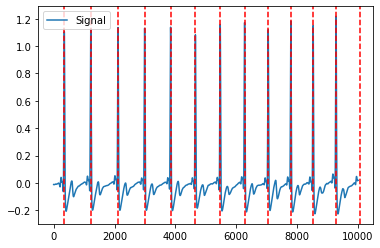

In [4]:
# Plot ecg with R peaks (only a subset, otherwise the plot becomes unreadable!)
ecg_processed, ecg_info = nk.ecg_process(signals['ECG'], sampling_rate=fs)
rpeaks = ecg_info["ECG_R_Peaks"]
cleaned_ecg = ecg_processed["ECG_Clean"]
plot = nk.events_plot(rpeaks[0:13], cleaned_ecg[0:10000])

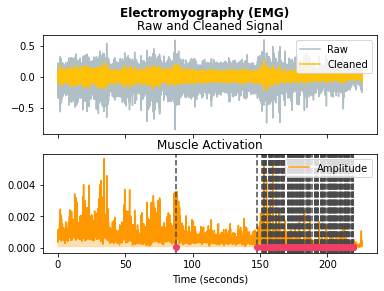

In [5]:
# Plot filtered emg
emg_processed, _ = nk.emg_process(signals['EMG'], sampling_rate=fs)
plot = nk.emg_plot(emg_processed, fs)

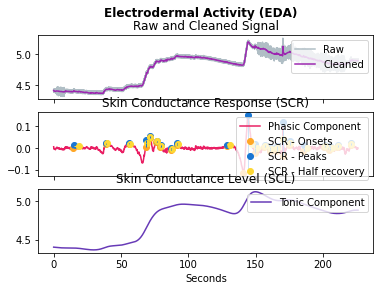

In [6]:
# Plot filtered eda
eda_processed, features = nk.eda_process(signals['EDA'], sampling_rate=fs, method="neurokit")
plot = nk.eda_plot(eda_processed, fs)

In [7]:
# Extraction of features

fs = 1000
window = 30
experiment_types = ['manual', 'cobot', 'stroopeasy', 'stroophard', 'rest']

If you did not already, please run the patient divider before the following part of the code to have the right project structure.

In [8]:
def extract_and_save_ECG(load_path, experiment_type):
    # ECG 
    # if file 06-05-30_10-53-13 is present please delete it.
    for directory in os.listdir(load_path):
        path = os.path.join(load_path, directory)
        patient_id = int(directory.split('-')[-1])
        dataframe_ECG = sis.extract_plux_data_windowed(path, 0, window, 'ECG')

        ecg_time_and_freq_features = sis.extract_time_and_freq_hrv_features(dataframe_ECG, fs, patient_id)
        ecg_time_and_freq_features.to_csv(Path("saved_data", directory, f"ecg_{experiment_type}_{patient_id}.csv"), index=False)

In [9]:
def extract_and_save_EDA(load_path, experiment_type):
    # EDA
    for directory in os.listdir(load_path):
        path = os.path.join(load_path, directory)
        patient_id = int(directory.split('-')[-1])
        dataframe_EDA = sis.extract_plux_data_windowed(path, 0, window, 'EDA')
        eda_time_and_freq_features = sis.extract_eda_time_and_frequency_features(dataframe_EDA, fs, window, patient_id)
        eda_time_and_freq_features.to_csv(Path("saved_data", directory, f"eda_{experiment_type}_{patient_id}.csv"), index=False)

In [10]:
def extract_and_save_EMG(load_path, experiment_type):
    # EMG
    for directory in os.listdir(load_path):
        path = os.path.join(load_path, directory)
        patient_id = int(directory.split('-')[-1])
        dataframe_EMG = sis.extract_plux_data_windowed(path, 0, window, 'EMG')

        emg_time_and_freq_features = sis.extract_emg_featues(dataframe_EMG, fs, patient_id)
        emg_time_and_freq_features.to_csv(Path("saved_data", directory, f"emg_{experiment_type}_{patient_id}.csv"), index=False)

In [11]:
    for t in experiment_types:
        load_path = os.path.join(os.getcwd(), 'experiments', t)

        extract_and_save_ECG(load_path, t)
        extract_and_save_EDA(load_path, t)
        extract_and_save_EMG(load_path, t)

  0%|          | 0/86 [00:00<?, ?it/s]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.2643e+04 -2.2618e+04  3e+04  2e+02  2e+02
 1: -2.2619e+04 -2.3149e+04  5e+02  3e+00  3e+00
 2: -2.2622e+04 -2.2649e+04  3e+01  3e-02  3e-02
 3: -2.2643e+04 -2.2644e+04  1e+00  7e-04  7e-04
 4: -2.2644e+04 -2.2644e+04  3e-01  1e-04  1e-04
 5: -2.2644e+04 -2.2644e+04  1e-01  3e-06  3e-06
 6: -2.2644e+04 -2.2644e+04  9e-02  2e-06  2e-06
 7: -2.2644e+04 -2.2644e+04  2e-02  4e-07  4e-07
 8: -2.2644e+04 -2.2644e+04  2e-02  2e-07  2e-07
 9: -2.2644e+04 -2.2644e+04  6e-03  6e-08  7e-08
10: -2.2644e+04 -2.2644e+04  6e-03  5e-08  6e-08
11: -2.2644e+04 -2.2644e+04  2e-03  8e-09  4e-08


  1%|          | 1/86 [00:02<03:26,  2.43s/it]

12: -2.2644e+04 -2.2644e+04  7e-04  2e-09  5e-08
13: -2.2644e+04 -2.2644e+04  3e-04  7e-10  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.8094e+04 -1.8069e+04  3e+04  2e+02  2e+02
 1: -1.8070e+04 -1.8625e+04  6e+02  3e+00  3e+00
 2: -1.8073e+04 -1.8100e+04  3e+01  3e-02  3e-02
 3: -1.8093e+04 -1.8095e+04  2e+00  1e-03  2e-03
 4: -1.8094e+04 -1.8095e+04  5e-01  3e-04  3e-04
 5: -1.8094e+04 -1.8095e+04  4e-01  1e-04  1e-04
 6: -1.8095e+04 -1.8095e+04  9e-02  2e-05  2e-05
 7: -1.8095e+04 -1.8095e+04  7e-02  1e-05  1e-05
 8: -1.8095e+04 -1.8095e+04  2e-02  3e-06  3e-06
 9: -1.8095e+04 -1.8095e+04  2e-02  2e-06  3e-06
10: -1.8095e+04 -1.8095e+04  8e-03  6e-07  7e-07
11: -1.8095e+04 -1.8095e+04  8e-03  5e-07  6e-07
12: -1.8095e+04 -1.8095e+04  2e-03  1e-07  1e-07
13: -1.

  2%|▏         | 2/86 [00:05<03:56,  2.82s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1908e+04 -1.1872e+04  3e+04  2e+02  3e+02
 1: -1.1896e+04 -1.3127e+04  1e+03  7e+00  1e+01
 2: -1.1901e+04 -1.1955e+04  5e+01  2e-01  3e-01
 3: -1.1917e+04 -1.1925e+04  8e+00  2e-03  3e-03
 4: -1.1923e+04 -1.1925e+04  2e+00  3e-04  4e-04
 5: -1.1924e+04 -1.1924e+04  6e-01  8e-05  1e-04
 6: -1.1924e+04 -1.1924e+04  5e-01  5e-05  7e-05
 7: -1.1924e+04 -1.1924e+04  1e-01  1e-05  2e-05
 8: -1.1924e+04 -1.1924e+04  1e-01  8e-06  1e-05
 9: -1.1924e+04 -1.1924e+04  3e-02  1e-06  1e-06
10: -1.1924e+04 -1.1924e+04  3e-02  7e-07  1e-06
11: -1.1924e+04 -1.1924e+04  1e-02  2e-07  3e-07
12: -1.1924e+04 -1.1924e+04  1e-02  2e-07  3e-07
13: -1.1924e+04 -1.1924e+04  4e-03  2e-08  7e-08
14: -1.1924e+04 -1.1924e+04  3e-03  1e-08  5e-08
15: -1.

  3%|▎         | 3/86 [00:08<04:15,  3.08s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.6740e+03 -3.6492e+03  3e+04  2e+02  4e+02
 1: -3.6497e+03 -4.1445e+03  5e+02  3e+00  7e+00
 2: -3.6533e+03 -3.6803e+03  3e+01  3e-02  8e-02
 3: -3.6735e+03 -3.6751e+03  2e+00  1e-03  3e-03
 4: -3.6745e+03 -3.6749e+03  4e-01  2e-04  5e-04
 5: -3.6746e+03 -3.6749e+03  3e-01  1e-04  3e-04
 6: -3.6747e+03 -3.6748e+03  8e-02  3e-05  6e-05
 7: -3.6748e+03 -3.6748e+03  7e-02  2e-05  4e-05
 8: -3.6748e+03 -3.6748e+03  2e-02  4e-06  1e-05
 9: -3.6748e+03 -3.6748e+03  2e-02  3e-06  7e-06
10: -3.6748e+03 -3.6748e+03  7e-03  9e-07  2e-06
11: -3.6748e+03 -3.6748e+03  7e-03  7e-07  2e-06
12: -3.6748e+03 -3.6748e+03  2e-03  1e-07  3e-07
13: -3.6748e+03 -3.6748e+03  8e-04  2e-08  1e-07
14: -3.6748e+03 -3.6748e+03  8e-04  2e-08  1e-07
15: -3.6748e+03 -3.6748e+03  3e-04  3e-09

  5%|▍         | 4/86 [00:11<04:08,  3.03s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.6626e+03 -1.6364e+03  3e+04  2e+02  6e+02
 1: -1.6404e+03 -2.3829e+03  8e+02  4e+00  1e+01
 2: -1.6447e+03 -1.6786e+03  3e+01  7e-02  2e-01
 3: -1.6644e+03 -1.6673e+03  3e+00  7e-04  2e-03
 4: -1.6663e+03 -1.6671e+03  7e-01  1e-04  5e-04
 5: -1.6664e+03 -1.6670e+03  7e-01  1e-04  4e-04
 6: -1.6667e+03 -1.6669e+03  2e-01  2e-05  7e-05
 7: -1.6668e+03 -1.6669e+03  8e-02  3e-06  1e-05
 8: -1.6668e+03 -1.6669e+03  2e-02  3e-07  1e-06
 9: -1.6668e+03 -1.6669e+03  2e-02  2e-07  6e-07
10: -1.6669e+03 -1.6669e+03  5e-03  4e-08  2e-07
11: -1.6669e+03 -1.6669e+03  4e-03  3e-08  1e-07
12: -1.6669e+03 -1.6669e+03  1e-03  4e-09  1e-07
13: -1.6669e+03 -1.6669e+03  9e-04  3e-09  8e-08
14: -1.6669e+03 -1.6669e+03  3e-04  2e-09  1e-07


  6%|▌         | 5/86 [00:14<03:56,  2.93s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1955e+03 -1.1661e+03  3e+04  2e+02  7e+02
 1: -1.1734e+03 -1.8861e+03  7e+02  4e+00  2e+01
 2: -1.1772e+03 -1.2068e+03  3e+01  4e-02  2e-01
 3: -1.1984e+03 -1.2001e+03  2e+00  6e-04  2e-03
 4: -1.1993e+03 -1.1998e+03  5e-01  1e-04  5e-04
 5: -1.1994e+03 -1.1998e+03  4e-01  6e-05  2e-04
 6: -1.1996e+03 -1.1997e+03  1e-01  1e-05  6e-05
 7: -1.1996e+03 -1.1997e+03  1e-01  1e-05  4e-05
 8: -1.1997e+03 -1.1997e+03  2e-02  1e-06  5e-06
 9: -1.1997e+03 -1.1997e+03  2e-02  1e-06  4e-06
10: -1.1997e+03 -1.1997e+03  6e-03  1e-07  5e-07
11: -1.1997e+03 -1.1997e+03  5e-03  8e-08  3e-07
12: -1.1997e+03 -1.1997e+03  2e-03  2e-08  2e-07
13: -1.1997e+03 -1.1997e+03  2e-03  2e-08  2e-07
14: -1.1997e+03 -1.1997e+03  7e-04  3e-09  2e-07
15: -1.

  7%|▋         | 6/86 [00:18<04:16,  3.21s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.5862e+03 -4.5211e+03  3e+04  2e+02  7e+02
 1: -4.5906e+03 -6.8145e+03  2e+03  1e+01  5e+01
 2: -4.6237e+03 -4.8168e+03  2e+02  9e-01  3e+00
 3: -4.6309e+03 -4.6515e+03  2e+01  9e-03  3e-02
 4: -4.6467e+03 -4.6496e+03  3e+00  1e-03  5e-03
 5: -4.6478e+03 -4.6490e+03  1e+00  4e-04  1e-03
 6: -4.6484e+03 -4.6487e+03  4e-01  8e-05  3e-04
 7: -4.6485e+03 -4.6487e+03  3e-01  4e-05  1e-04
 8: -4.6486e+03 -4.6487e+03  8e-02  8e-06  3e-05
 9: -4.6486e+03 -4.6487e+03  6e-02  4e-06  2e-05
10: -4.6486e+03 -4.6487e+03  2e-02  1e-06  5e-06
11: -4.6486e+03 -4.6487e+03  2e-02  1e-06  4e-06
12: -4.6487e+03 -4.6487e+03  8e-03  1e-07  6e-07
13: -4.6487e+03 -4.6487e+03  3e-03  3e-08  2e-07
14: -4.6487e+03 -4.6487e+03  2e-03  1e-08  2e-07
15: -4.6487e+03 -4.6487e+03  5e-04  1e-08

  8%|▊         | 7/86 [00:23<04:56,  3.75s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3643e+04 -1.3611e+04  3e+04  2e+02  2e+02
 1: -1.3632e+04 -1.4861e+04  1e+03  7e+00  9e+00
 2: -1.3642e+04 -1.3710e+04  7e+01  2e-01  3e-01
 3: -1.3656e+04 -1.3666e+04  1e+01  2e-03  3e-03
 4: -1.3664e+04 -1.3666e+04  1e+00  3e-04  4e-04
 5: -1.3665e+04 -1.3666e+04  9e-01  1e-04  2e-04
 6: -1.3665e+04 -1.3665e+04  3e-01  3e-05  4e-05
 7: -1.3665e+04 -1.3665e+04  2e-01  2e-05  3e-05
 8: -1.3665e+04 -1.3665e+04  6e-02  4e-06  5e-06
 9: -1.3665e+04 -1.3665e+04  4e-02  1e-06  2e-06
10: -1.3665e+04 -1.3665e+04  1e-02  3e-07  4e-07
11: -1.3665e+04 -1.3665e+04  1e-02  2e-07  3e-07
12: -1.3665e+04 -1.3665e+04  3e-03  4e-08  8e-08
13: -1.3665e+04 -1.3665e+04  3e-03  3e-08  5e-08
14: -1.3665e+04 -1.3665e+04  1e-03  8e-09  5e-08
15: -1.3665e+04 -1.3665e+04  8e-04  6e-09

  9%|▉         | 8/86 [00:27<05:16,  4.06s/it]

16: -1.3665e+04 -1.3665e+04  3e-04  5e-09  7e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.4719e+04 -2.4688e+04  3e+04  2e+02  2e+02
 1: -2.4697e+04 -2.5454e+04  8e+02  4e+00  4e+00
 2: -2.4702e+04 -2.4750e+04  5e+01  2e-01  1e-01
 3: -2.4718e+04 -2.4725e+04  7e+00  2e-03  1e-03
 4: -2.4724e+04 -2.4725e+04  1e+00  2e-04  2e-04
 5: -2.4724e+04 -2.4725e+04  9e-01  2e-04  2e-04
 6: -2.4724e+04 -2.4724e+04  2e-01  3e-05  3e-05
 7: -2.4724e+04 -2.4724e+04  2e-01  2e-05  2e-05
 8: -2.4724e+04 -2.4724e+04  6e-02  3e-06  3e-06
 9: -2.4724e+04 -2.4724e+04  5e-02  2e-06  2e-06
10: -2.4724e+04 -2.4724e+04  2e-02  4e-07  4e-07
11: -2.4724e+04 -2.4724e+04  1e-02  4e-07  4e-07
12: -2.4724e+04 -2.4724e+04  4e-03  4e-08  9e-08
13: -2.4724e+04 -2.4724e+04  4e-03  3e-08  7e-08
14: -2.

 10%|█         | 9/86 [00:32<05:20,  4.16s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.3619e+04 -4.3580e+04  3e+04  2e+02  1e+02
 1: -4.3606e+04 -4.5101e+04  2e+03  8e+00  6e+00
 2: -4.3615e+04 -4.3685e+04  7e+01  2e-01  2e-01
 3: -4.3629e+04 -4.3640e+04  1e+01  2e-03  2e-03
 4: -4.3637e+04 -4.3639e+04  2e+00  4e-04  3e-04
 5: -4.3638e+04 -4.3639e+04  7e-01  1e-04  1e-04
 6: -4.3639e+04 -4.3639e+04  2e-01  3e-05  2e-05
 7: -4.3639e+04 -4.3639e+04  7e-02  3e-07  2e-07
 8: -4.3639e+04 -4.3639e+04  2e-02  4e-08  5e-08
 9: -4.3639e+04 -4.3639e+04  2e-02  3e-08  4e-08
10: -4.3639e+04 -4.3639e+04  7e-03  7e-09  5e-08
11: -4.3639e+04 -4.3639e+04  6e-03  6e-09  4e-08
12: -4.3639e+04 -4.3639e+04  2e-03  4e-09  6e-08
13: -4.3639e+04 -4.3639e+04  2e-03  4e-09  4e-08


 12%|█▏        | 10/86 [00:36<05:08,  4.05s/it]

14: -4.3639e+04 -4.3639e+04  7e-04  4e-09  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.2731e+04 -2.2704e+04  3e+04  2e+02  2e+02
 1: -2.2706e+04 -2.3255e+04  6e+02  3e+00  3e+00
 2: -2.2710e+04 -2.2749e+04  4e+01  1e-01  1e-01
 3: -2.2728e+04 -2.2732e+04  5e+00  1e-03  1e-03
 4: -2.2731e+04 -2.2732e+04  6e-01  1e-04  1e-04
 5: -2.2732e+04 -2.2732e+04  2e-01  2e-05  3e-05
 6: -2.2732e+04 -2.2732e+04  1e-01  1e-05  1e-05
 7: -2.2732e+04 -2.2732e+04  2e-02  2e-06  2e-06
 8: -2.2732e+04 -2.2732e+04  2e-02  9e-07  9e-07
 9: -2.2732e+04 -2.2732e+04  4e-03  2e-07  2e-07
10: -2.2732e+04 -2.2732e+04  4e-03  1e-07  1e-07
11: -2.2732e+04 -2.2732e+04  9e-04  2e-08  7e-08
12: -2.2732e+04 -2.2732e+04  7e-04  1e-08  5e-08


 13%|█▎        | 11/86 [00:40<05:20,  4.27s/it]

13: -2.2732e+04 -2.2732e+04  2e-04  2e-09  9e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.2027e+03 -9.1748e+03  3e+04  2e+02  3e+02
 1: -9.1857e+03 -9.9684e+03  8e+02  4e+00  7e+00
 2: -9.1886e+03 -9.2187e+03  3e+01  4e-02  7e-02
 3: -9.2083e+03 -9.2112e+03  3e+00  3e-03  5e-03
 4: -9.2097e+03 -9.2105e+03  8e-01  4e-04  7e-04
 5: -9.2100e+03 -9.2103e+03  3e-01  1e-04  2e-04
 6: -9.2101e+03 -9.2102e+03  1e-01  4e-05  6e-05
 7: -9.2102e+03 -9.2102e+03  4e-02  8e-06  1e-05
 8: -9.2102e+03 -9.2102e+03  9e-03  1e-06  2e-06
 9: -9.2102e+03 -9.2102e+03  7e-03  6e-07  9e-07
10: -9.2102e+03 -9.2102e+03  2e-03  1e-07  3e-07
11: -9.2102e+03 -9.2102e+03  2e-03  1e-07  2e-07
12: -9.2102e+03 -9.2102e+03  6e-04  1e-08  2e-07


 14%|█▍        | 12/86 [00:47<06:05,  4.94s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.7906e+03 -5.7528e+03  3e+04  2e+02  4e+02
 1: -5.7838e+03 -6.8035e+03  1e+03  6e+00  1e+01
 2: -5.7917e+03 -5.8404e+03  5e+01  1e-01  3e-01
 3: -5.8091e+03 -5.8157e+03  7e+00  1e-03  3e-03
 4: -5.8136e+03 -5.8152e+03  2e+00  3e-04  6e-04
 5: -5.8142e+03 -5.8148e+03  6e-01  8e-05  1e-04
 6: -5.8143e+03 -5.8147e+03  4e-01  4e-05  7e-05
 7: -5.8145e+03 -5.8146e+03  9e-02  7e-06  1e-05
 8: -5.8145e+03 -5.8146e+03  6e-02  2e-06  5e-06
 9: -5.8146e+03 -5.8146e+03  1e-02  5e-07  1e-06
10: -5.8146e+03 -5.8146e+03  1e-02  2e-07  5e-07
11: -5.8146e+03 -5.8146e+03  3e-03  5e-08  1e-07
12: -5.8146e+03 -5.8146e+03  3e-03  4e-08  1e-07
13: -5.8146e+03 -5.8146e+03  9e-04  1e-08  1e-07


 15%|█▌        | 13/86 [00:52<05:56,  4.88s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.3667e+03 -2.3263e+03  3e+04  2e+02  5e+02
 1: -2.3530e+03 -3.6809e+03  1e+03  7e+00  2e+01
 2: -2.3603e+03 -2.4248e+03  6e+01  2e-01  7e-01
 3: -2.3743e+03 -2.3843e+03  1e+01  2e-03  7e-03
 4: -2.3824e+03 -2.3838e+03  1e+00  3e-04  9e-04
 5: -2.3831e+03 -2.3835e+03  4e-01  6e-05  2e-04
 6: -2.3833e+03 -2.3834e+03  1e-01  1e-05  3e-05
 7: -2.3834e+03 -2.3834e+03  3e-02  1e-06  4e-06
 8: -2.3834e+03 -2.3834e+03  2e-02  6e-07  2e-06
 9: -2.3834e+03 -2.3834e+03  6e-03  1e-07  4e-07
10: -2.3834e+03 -2.3834e+03  6e-03  1e-07  3e-07
11: -2.3834e+03 -2.3834e+03  2e-03  2e-08  2e-07
12: -2.3834e+03 -2.3834e+03  2e-03  2e-08  2e-07


 16%|█▋        | 14/86 [00:58<06:25,  5.35s/it]

13: -2.3834e+03 -2.3834e+03  6e-04  4e-09  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.4484e+03 -3.4204e+03  3e+04  2e+02  4e+02
 1: -3.4254e+03 -4.0280e+03  6e+02  3e+00  8e+00
 2: -3.4300e+03 -3.4580e+03  3e+01  3e-02  8e-02
 3: -3.4505e+03 -3.4524e+03  2e+00  2e-03  4e-03
 4: -3.4516e+03 -3.4521e+03  5e-01  3e-04  7e-04
 5: -3.4516e+03 -3.4521e+03  4e-01  2e-04  6e-04
 6: -3.4518e+03 -3.4520e+03  1e-01  6e-05  1e-04
 7: -3.4519e+03 -3.4519e+03  4e-02  1e-05  3e-05
 8: -3.4519e+03 -3.4519e+03  4e-02  1e-05  3e-05
 9: -3.4519e+03 -3.4519e+03  2e-02  4e-06  1e-05
10: -3.4519e+03 -3.4519e+03  6e-03  8e-07  2e-06
11: -3.4519e+03 -3.4519e+03  5e-03  6e-07  2e-06
12: -3.4519e+03 -3.4519e+03  2e-03  1e-07  4e-07
13: -3.4519e+03 -3.4519e+03  2e-03  9e-08  3e-07
14: -3.

 17%|█▋        | 15/86 [01:02<05:54,  4.99s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.3272e+03 -4.2973e+03  3e+04  2e+02  4e+02
 1: -4.3011e+03 -5.0376e+03  8e+02  4e+00  9e+00
 2: -4.3073e+03 -4.3626e+03  6e+01  2e-01  4e-01
 3: -4.3223e+03 -4.3307e+03  8e+00  2e-03  4e-03
 4: -4.3295e+03 -4.3304e+03  9e-01  2e-04  5e-04
 5: -4.3299e+03 -4.3302e+03  3e-01  4e-05  9e-05
 6: -4.3300e+03 -4.3302e+03  2e-01  2e-05  5e-05
 7: -4.3301e+03 -4.3301e+03  5e-02  4e-06  9e-06
 8: -4.3301e+03 -4.3301e+03  3e-02  2e-06  4e-06
 9: -4.3301e+03 -4.3301e+03  8e-03  4e-07  8e-07
10: -4.3301e+03 -4.3301e+03  7e-03  3e-07  6e-07
11: -4.3301e+03 -4.3301e+03  2e-03  6e-08  1e-07
12: -4.3301e+03 -4.3301e+03  2e-03  4e-08  1e-07
13: -4.3301e+03 -4.3301e+03  7e-04  9e-09  1e-07
14: -4.3301e+03 -4.3301e+03  6e-04  6e-09  7e-08
15: -4.3301e+03 -4.3301e+03  2e-04  2e-09

 19%|█▊        | 16/86 [01:06<05:24,  4.64s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.3609e+03 -2.3188e+03  3e+04  2e+02  6e+02
 1: -2.3433e+03 -3.7066e+03  1e+03  8e+00  2e+01
 2: -2.3601e+03 -2.4340e+03  7e+01  2e-01  7e-01
 3: -2.3754e+03 -2.3867e+03  1e+01  2e-03  7e-03
 4: -2.3833e+03 -2.3858e+03  2e+00  5e-04  1e-03
 5: -2.3838e+03 -2.3849e+03  1e+00  1e-04  3e-04
 6: -2.3844e+03 -2.3847e+03  3e-01  2e-05  6e-05
 7: -2.3844e+03 -2.3846e+03  2e-01  1e-05  4e-05
 8: -2.3845e+03 -2.3846e+03  6e-02  3e-06  8e-06
 9: -2.3845e+03 -2.3846e+03  5e-02  2e-06  6e-06
10: -2.3846e+03 -2.3846e+03  1e-02  3e-07  1e-06
11: -2.3846e+03 -2.3846e+03  1e-02  2e-07  6e-07
12: -2.3846e+03 -2.3846e+03  3e-03  4e-08  3e-07
13: -2.3846e+03 -2.3846e+03  3e-03  3e-08  2e-07


 20%|█▉        | 17/86 [01:10<05:07,  4.46s/it]

14: -2.3846e+03 -2.3846e+03  9e-04  7e-09  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.6183e+03 -8.5415e+03  3e+04  2e+02  3e+02
 1: -8.6456e+03 -1.0248e+04  2e+03  9e+00  2e+01
 2: -8.6819e+03 -8.8072e+03  1e+02  5e-01  9e-01
 3: -8.6912e+03 -8.7082e+03  2e+01  5e-03  9e-03
 4: -8.7041e+03 -8.7065e+03  2e+00  7e-04  1e-03
 5: -8.7050e+03 -8.7055e+03  5e-01  1e-04  2e-04
 6: -8.7051e+03 -8.7054e+03  3e-01  4e-05  7e-05
 7: -8.7053e+03 -8.7053e+03  7e-02  7e-06  1e-05
 8: -8.7053e+03 -8.7053e+03  5e-02  3e-06  4e-06
 9: -8.7053e+03 -8.7053e+03  1e-02  5e-07  9e-07
10: -8.7053e+03 -8.7053e+03  1e-02  4e-07  6e-07
11: -8.7053e+03 -8.7053e+03  3e-03  7e-08  2e-07
12: -8.7053e+03 -8.7053e+03  3e-03  6e-08  1e-07
13: -8.7053e+03 -8.7053e+03  1e-03  1e-08  1e-07


 21%|██        | 18/86 [01:15<05:02,  4.45s/it]

14: -8.7053e+03 -8.7053e+03  7e-04  1e-08  8e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.1173e+04 -3.1026e+04  4e+04  2e+02  2e+02
 1: -3.1232e+04 -3.3594e+04  3e+03  1e+01  1e+01
 2: -3.1264e+04 -3.1446e+04  2e+02  8e-01  7e-01
 3: -3.1272e+04 -3.1292e+04  2e+01  8e-03  7e-03
 4: -3.1287e+04 -3.1290e+04  3e+00  1e-03  1e-03
 5: -3.1288e+04 -3.1290e+04  1e+00  1e-04  1e-04
 6: -3.1289e+04 -3.1290e+04  1e+00  6e-05  5e-05
 7: -3.1289e+04 -3.1289e+04  3e-01  1e-05  1e-05
 8: -3.1289e+04 -3.1289e+04  2e-01  1e-05  9e-06
 9: -3.1289e+04 -3.1289e+04  5e-02  1e-06  1e-06
10: -3.1289e+04 -3.1289e+04  4e-02  7e-07  7e-07
11: -3.1289e+04 -3.1289e+04  1e-02  2e-07  2e-07
12: -3.1289e+04 -3.1289e+04  1e-02  2e-07  1e-07
13: -3.1289e+04 -3.1289e+04  3e-03  2e-08  3e-08
14: -3.

 22%|██▏       | 19/86 [01:20<05:13,  4.68s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.1407e+04 -5.1285e+04  4e+04  2e+02  1e+02
 1: -5.1458e+04 -5.4245e+04  3e+03  2e+01  1e+01
 2: -5.1497e+04 -5.1662e+04  2e+02  7e-01  5e-01
 3: -5.1506e+04 -5.1525e+04  2e+01  7e-03  5e-03
 4: -5.1521e+04 -5.1523e+04  2e+00  8e-04  6e-04
 5: -5.1522e+04 -5.1523e+04  8e-01  2e-04  1e-04
 6: -5.1522e+04 -5.1522e+04  2e-01  3e-05  2e-05
 7: -5.1522e+04 -5.1522e+04  1e-01  1e-05  7e-06
 8: -5.1522e+04 -5.1522e+04  2e-02  2e-06  1e-06
 9: -5.1522e+04 -5.1522e+04  2e-02  8e-07  6e-07
10: -5.1522e+04 -5.1522e+04  5e-03  2e-07  1e-07
11: -5.1522e+04 -5.1522e+04  5e-03  1e-07  1e-07
12: -5.1522e+04 -5.1522e+04  2e-03  4e-08  4e-08
13: -5.1522e+04 -5.1522e+04  2e-03  3e-08  3e-08
14: -5.1522e+04 -5.1522e+04  5e-04  1e-08  3e-08
15: -5.1522e+04 -5.1522e+04  4e-04  9e-09

 23%|██▎       | 20/86 [01:26<05:30,  5.02s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.9342e+04 -1.9155e+04  4e+04  2e+02  2e+02
 1: -1.9439e+04 -2.3499e+04  5e+03  2e+01  3e+01
 2: -1.9562e+04 -2.0072e+04  5e+02  2e+00  2e+00
 3: -1.9571e+04 -1.9638e+04  7e+01  2e-01  2e-01
 4: -1.9585e+04 -1.9599e+04  1e+01  2e-03  2e-03
 5: -1.9594e+04 -1.9596e+04  2e+00  2e-04  2e-04
 6: -1.9595e+04 -1.9596e+04  9e-01  5e-05  6e-05
 7: -1.9595e+04 -1.9595e+04  3e-01  1e-05  1e-05
 8: -1.9595e+04 -1.9595e+04  8e-02  2e-06  2e-06
 9: -1.9595e+04 -1.9595e+04  6e-02  1e-06  1e-06
10: -1.9595e+04 -1.9595e+04  2e-02  2e-07  3e-07
11: -1.9595e+04 -1.9595e+04  1e-02  1e-07  1e-07
12: -1.9595e+04 -1.9595e+04  4e-03  3e-08  9e-08
13: -1.9595e+04 -1.9595e+04  3e-03  3e-08  7e-08


 24%|██▍       | 21/86 [01:30<05:12,  4.81s/it]

14: -1.9595e+04 -1.9595e+04  1e-03  2e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.6307e+03 -3.9389e+03  5e+04  2e+02  1e+03
 1: -5.2188e+03 -1.3146e+04  1e+04  4e+01  2e+02
 2: -5.5251e+03 -6.7579e+03  1e+03  4e+00  2e+01
 3: -5.5360e+03 -5.6212e+03  9e+01  2e-01  8e-01
 4: -5.5563e+03 -5.5683e+03  1e+01  2e-03  8e-03
 5: -5.5631e+03 -5.5663e+03  3e+00  3e-04  2e-03
 6: -5.5644e+03 -5.5655e+03  1e+00  7e-05  3e-04
 7: -5.5644e+03 -5.5655e+03  1e+00  6e-05  3e-04
 8: -5.5649e+03 -5.5653e+03  4e-01  2e-05  8e-05
 9: -5.5651e+03 -5.5652e+03  1e-01  2e-06  1e-05
10: -5.5651e+03 -5.5652e+03  9e-02  2e-06  8e-06
11: -5.5652e+03 -5.5652e+03  2e-02  2e-07  9e-07
12: -5.5652e+03 -5.5652e+03  2e-02  1e-07  5e-07
13: -5.5652e+03 -5.5652e+03  6e-03  4e-08  2e-07
14: -5.

 26%|██▌       | 22/86 [01:34<04:56,  4.63s/it]

17: -5.5652e+03 -5.5652e+03  3e-04  3e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.8294e+03 -9.7341e+03  4e+04  2e+02  4e+02
 1: -9.8933e+03 -1.2735e+04  3e+03  2e+01  3e+01
 2: -9.9936e+03 -1.0561e+04  6e+02  2e+00  4e+00
 3: -1.0001e+04 -1.0121e+04  1e+02  4e-01  8e-01
 4: -1.0011e+04 -1.0033e+04  2e+01  4e-03  8e-03
 5: -1.0025e+04 -1.0030e+04  5e+00  8e-04  2e-03
 6: -1.0026e+04 -1.0029e+04  3e+00  3e-04  5e-04
 7: -1.0028e+04 -1.0029e+04  9e-01  7e-05  1e-04
 8: -1.0028e+04 -1.0029e+04  8e-01  6e-05  1e-04
 9: -1.0028e+04 -1.0028e+04  4e-01  3e-05  5e-05
10: -1.0028e+04 -1.0028e+04  1e-01  6e-06  1e-05
11: -1.0028e+04 -1.0028e+04  1e-01  4e-06  8e-06
12: -1.0028e+04 -1.0028e+04  4e-02  1e-06  2e-06
13: -1.0028e+04 -1.0028e+04  3e-02  8e-07  2e-06
14: -1.

 27%|██▋       | 23/86 [01:38<04:39,  4.44s/it]


Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0465e+03 -1.0174e+03  3e+04  2e+02  8e+02
 1: -1.0230e+03 -1.7967e+03  8e+02  4e+00  2e+01
 2: -1.0270e+03 -1.1001e+03  7e+01  3e-01  1e+00
 3: -1.0381e+03 -1.0506e+03  1e+01  3e-03  1e-02
 4: -1.0485e+03 -1.0501e+03  2e+00  4e-04  2e-03
 5: -1.0494e+03 -1.0498e+03  4e-01  6e-05  3e-04
 6: -1.0496e+03 -1.0497e+03  1e-01  1e-05  5e-05
 7: -1.0496e+03 -1.0497e+03  6e-02  3e-06  2e-05
 8: -1.0496e+03 -1.0497e+03  1e-02  5e-07  3e-06
 9: -1.0496e+03 -1.0497e+03  1e-02  3e-07  1e-06
10: -1.0497e+03 -1.0497e+03  3e-03  5e-08  4e-07
11: -1.0497e+03 -1.0497e+03  2e-03  3e-08  3e-07
12: -1.0497e+03 -1.0497e+03  7e-04  7e-09  4e-07
13: -1.0497e+03 -1.0497e+03  7e-04  6e-09  3e-07


 28%|██▊       | 24/86 [01:42<04:24,  4.27s/it]

14: -1.0497e+03 -1.0497e+03  2e-04  2e-09  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0440e+04 -1.0401e+04  3e+04  2e+02  3e+02
 1: -1.0421e+04 -1.1501e+04  1e+03  6e+00  9e+00
 2: -1.0428e+04 -1.0489e+04  6e+01  2e-01  3e-01
 3: -1.0443e+04 -1.0452e+04  9e+00  2e-03  3e-03
 4: -1.0450e+04 -1.0452e+04  1e+00  3e-04  4e-04
 5: -1.0451e+04 -1.0451e+04  5e-01  3e-06  4e-06
 6: -1.0451e+04 -1.0451e+04  1e-01  6e-07  8e-07
 7: -1.0451e+04 -1.0451e+04  8e-02  2e-07  3e-07
 8: -1.0451e+04 -1.0451e+04  2e-02  4e-08  8e-08
 9: -1.0451e+04 -1.0451e+04  1e-02  2e-08  5e-08
10: -1.0451e+04 -1.0451e+04  4e-03  6e-09  8e-08
11: -1.0451e+04 -1.0451e+04  4e-03  6e-09  6e-08
12: -1.0451e+04 -1.0451e+04  1e-03  5e-09  9e-08
13: -1.0451e+04 -1.0451e+04  1e-03  5e-09  7e-08
14: -1.

 29%|██▉       | 25/86 [01:45<04:06,  4.03s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.8999e+04 -1.8880e+04  4e+04  2e+02  2e+02
 1: -1.9037e+04 -2.1737e+04  3e+03  1e+01  2e+01
 2: -1.9068e+04 -1.9297e+04  2e+02  1e+00  1e+00
 3: -1.9075e+04 -1.9097e+04  2e+01  1e-02  1e-02
 4: -1.9091e+04 -1.9095e+04  3e+00  1e-03  2e-03
 5: -1.9093e+04 -1.9094e+04  1e+00  6e-04  7e-04
 6: -1.9093e+04 -1.9094e+04  4e-01  1e-04  1e-04
 7: -1.9093e+04 -1.9094e+04  3e-01  1e-04  1e-04
 8: -1.9093e+04 -1.9094e+04  1e-01  2e-05  2e-05
 9: -1.9093e+04 -1.9094e+04  3e-02  6e-07  8e-07
10: -1.9093e+04 -1.9093e+04  3e-02  5e-07  6e-07
11: -1.9093e+04 -1.9093e+04  8e-03  9e-08  1e-07
12: -1.9093e+04 -1.9093e+04  4e-03  2e-08  5e-08
13: -1.9093e+04 -1.9093e+04  1e-03  9e-09  8e-08
14: -1.9093e+04 -1.9093e+04  1e-03  9e-09  5e-08


 30%|███       | 26/86 [01:49<03:52,  3.87s/it]

15: -1.9093e+04 -1.9093e+04  4e-04  9e-09  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.1336e+03 -4.7558e+03  5e+04  2e+02  1e+03
 1: -5.4204e+03 -1.1011e+04  7e+03  3e+01  2e+02
 2: -5.6744e+03 -6.6146e+03  9e+02  3e+00  2e+01
 3: -5.6905e+03 -5.8023e+03  1e+02  3e-01  2e+00
 4: -5.7073e+03 -5.7239e+03  2e+01  3e-03  2e-02
 5: -5.7174e+03 -5.7208e+03  3e+00  4e-04  2e-03
 6: -5.7189e+03 -5.7198e+03  9e-01  7e-05  4e-04
 7: -5.7190e+03 -5.7197e+03  7e-01  4e-05  2e-04
 8: -5.7194e+03 -5.7195e+03  2e-01  8e-06  4e-05
 9: -5.7194e+03 -5.7195e+03  2e-01  6e-06  4e-05
10: -5.7194e+03 -5.7195e+03  6e-02  2e-06  1e-05
11: -5.7195e+03 -5.7195e+03  2e-02  3e-07  2e-06
12: -5.7195e+03 -5.7195e+03  2e-02  2e-07  1e-06
13: -5.7195e+03 -5.7195e+03  7e-03  5e-08  3e-07
14: -5.

 31%|███▏      | 27/86 [01:53<03:49,  3.89s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.9630e+03 -3.8724e+03  4e+04  2e+02  6e+02
 1: -4.0466e+03 -7.5842e+03  4e+03  2e+01  6e+01
 2: -4.1628e+03 -4.5017e+03  3e+02  1e+00  4e+00
 3: -4.1710e+03 -4.2150e+03  4e+01  9e-02  3e-01
 4: -4.1874e+03 -4.1947e+03  7e+00  9e-04  3e-03
 5: -4.1910e+03 -4.1930e+03  2e+00  2e-04  6e-04
 6: -4.1917e+03 -4.1926e+03  9e-01  6e-05  2e-04
 7: -4.1921e+03 -4.1924e+03  3e-01  2e-05  5e-05
 8: -4.1922e+03 -4.1923e+03  2e-01  7e-06  2e-05
 9: -4.1923e+03 -4.1923e+03  5e-02  2e-06  6e-06
10: -4.1923e+03 -4.1923e+03  5e-02  2e-06  5e-06
11: -4.1923e+03 -4.1923e+03  2e-02  6e-07  2e-06
12: -4.1923e+03 -4.1923e+03  9e-03  2e-07  6e-07
13: -4.1923e+03 -4.1923e+03  9e-03  1e-07  5e-07
14: -4.1923e+03 -4.1923e+03  4e-03  4e-08  2e-07
15: -4.

 33%|███▎      | 28/86 [01:57<03:45,  3.88s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.2040e+04 -5.1144e+04  5e+04  2e+02  2e+02
 1: -5.2808e+04 -5.9440e+04  8e+03  4e+01  3e+01
 2: -5.3234e+04 -5.4181e+04  1e+03  3e+00  2e+00
 3: -5.3248e+04 -5.3348e+04  1e+02  2e-01  2e-01
 4: -5.3266e+04 -5.3281e+04  2e+01  2e-03  2e-03
 5: -5.3275e+04 -5.3278e+04  3e+00  4e-04  3e-04
 6: -5.3276e+04 -5.3277e+04  9e-01  2e-05  2e-05
 7: -5.3276e+04 -5.3277e+04  3e-01  4e-06  3e-06
 8: -5.3277e+04 -5.3277e+04  2e-01  2e-06  2e-06
 9: -5.3277e+04 -5.3277e+04  6e-02  5e-07  4e-07
10: -5.3277e+04 -5.3277e+04  6e-02  4e-07  3e-07
11: -5.3277e+04 -5.3277e+04  2e-02  7e-08  6e-08
12: -5.3277e+04 -5.3277e+04  2e-02  7e-08  5e-08
13: -5.3277e+04 -5.3277e+04  6e-03  4e-08  4e-08
14: -5.3277e+04 -5.3277e+04  5e-03  4e-08  3e-08
15: -5.

 34%|███▎      | 29/86 [02:01<03:43,  3.92s/it]

17: -5.3277e+04 -5.3277e+04  7e-04  4e-08  4e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.7846e+04 -2.7729e+04  4e+04  2e+02  2e+02
 1: -2.7883e+04 -3.0177e+04  2e+03  1e+01  1e+01
 2: -2.7954e+04 -2.8229e+04  3e+02  1e+00  1e+00
 3: -2.7960e+04 -2.7995e+04  3e+01  5e-02  5e-02
 4: -2.7979e+04 -2.7983e+04  5e+00  6e-03  6e-03
 5: -2.7979e+04 -2.7983e+04  4e+00  4e-03  4e-03
 6: -2.7981e+04 -2.7982e+04  9e-01  7e-04  7e-04
 7: -2.7981e+04 -2.7981e+04  5e-01  2e-04  2e-04
 8: -2.7981e+04 -2.7981e+04  1e-01  6e-05  5e-05
 9: -2.7981e+04 -2.7981e+04  1e-01  4e-05  3e-05
10: -2.7981e+04 -2.7981e+04  4e-02  8e-06  8e-06
11: -2.7981e+04 -2.7981e+04  3e-02  6e-06  6e-06
12: -2.7981e+04 -2.7981e+04  1e-02  1e-06  1e-06
13: -2.7981e+04 -2.7981e+04  1e-02  1e-06  1e-06
14: -2.

 35%|███▍      | 30/86 [02:04<03:35,  3.86s/it]

16: -2.7981e+04 -2.7981e+04  7e-04  2e-08  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.4066e+03 -8.0879e+03  4e+04  2e+02  4e+02
 1: -8.5967e+03 -1.1768e+04  3e+03  2e+01  3e+01
 2: -8.6603e+03 -8.8849e+03  2e+02  1e+00  2e+00
 3: -8.6679e+03 -8.6929e+03  2e+01  3e-02  5e-02
 4: -8.6830e+03 -8.6874e+03  4e+00  5e-03  1e-02
 5: -8.6843e+03 -8.6868e+03  2e+00  8e-04  1e-03
 6: -8.6855e+03 -8.6862e+03  8e-01  2e-04  4e-04
 7: -8.6856e+03 -8.6862e+03  6e-01  1e-04  2e-04
 8: -8.6859e+03 -8.6861e+03  1e-01  2e-05  3e-05
 9: -8.6860e+03 -8.6861e+03  1e-01  1e-05  2e-05
10: -8.6860e+03 -8.6860e+03  3e-02  2e-06  4e-06
11: -8.6860e+03 -8.6860e+03  2e-02  1e-06  3e-06
12: -8.6860e+03 -8.6860e+03  7e-03  3e-07  6e-07
13: -8.6860e+03 -8.6860e+03  7e-03  2e-07  5e-07
14: -8.

 36%|███▌      | 31/86 [02:08<03:30,  3.82s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.3604e+03 -3.1265e+03  4e+04  2e+02  1e+03
 1: -3.5169e+03 -8.5346e+03  6e+03  3e+01  2e+02
 2: -3.6640e+03 -4.5134e+03  9e+02  3e+00  2e+01
 3: -3.6725e+03 -3.7380e+03  7e+01  1e-01  7e-01
 4: -3.6955e+03 -3.7042e+03  9e+00  1e-03  7e-03
 5: -3.7006e+03 -3.7027e+03  2e+00  2e-04  1e-03
 6: -3.7014e+03 -3.7022e+03  8e-01  5e-05  3e-04
 7: -3.7017e+03 -3.7020e+03  2e-01  1e-05  7e-05
 8: -3.7018e+03 -3.7020e+03  2e-01  8e-06  5e-05
 9: -3.7019e+03 -3.7019e+03  5e-02  2e-06  1e-05
10: -3.7019e+03 -3.7019e+03  5e-02  1e-06  8e-06
11: -3.7019e+03 -3.7019e+03  1e-02  3e-07  1e-06
12: -3.7019e+03 -3.7019e+03  1e-02  2e-07  1e-06
13: -3.7019e+03 -3.7019e+03  3e-03  4e-08  4e-07
14: -3.7019e+03 -3.7019e+03  3e-03  3e-08  3e-07
15: -3.

 37%|███▋      | 32/86 [02:13<03:35,  3.98s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1607e+04 -1.1538e+04  3e+04  2e+02  3e+02
 1: -1.1610e+04 -1.3853e+04  2e+03  1e+01  2e+01
 2: -1.1634e+04 -1.1798e+04  2e+02  7e-01  1e+00
 3: -1.1642e+04 -1.1662e+04  2e+01  7e-03  1e-02
 4: -1.1657e+04 -1.1660e+04  3e+00  1e-03  2e-03
 5: -1.1658e+04 -1.1659e+04  9e-01  2e-04  3e-04
 6: -1.1659e+04 -1.1659e+04  6e-01  8e-05  1e-04
 7: -1.1659e+04 -1.1659e+04  2e-01  2e-05  3e-05
 8: -1.1659e+04 -1.1659e+04  9e-02  3e-06  4e-06
 9: -1.1659e+04 -1.1659e+04  2e-02  6e-07  9e-07
10: -1.1659e+04 -1.1659e+04  2e-02  4e-07  7e-07
11: -1.1659e+04 -1.1659e+04  6e-03  7e-08  2e-07
12: -1.1659e+04 -1.1659e+04  5e-03  5e-08  1e-07
13: -1.1659e+04 -1.1659e+04  2e-03  1e-08  1e-07


 38%|███▊      | 33/86 [02:16<03:27,  3.92s/it]

14: -1.1659e+04 -1.1659e+04  1e-03  1e-08  1e-07
15: -1.1659e+04 -1.1659e+04  5e-04  8e-09  8e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.1655e+04 -2.1532e+04  4e+04  2e+02  2e+02
 1: -2.1696e+04 -2.4160e+04  3e+03  1e+01  2e+01
 2: -2.1756e+04 -2.2001e+04  2e+02  1e+00  1e+00
 3: -2.1762e+04 -2.1785e+04  2e+01  1e-02  1e-02
 4: -2.1779e+04 -2.1783e+04  3e+00  2e-03  2e-03
 5: -2.1781e+04 -2.1782e+04  8e-01  2e-04  2e-04
 6: -2.1781e+04 -2.1782e+04  5e-01  8e-05  9e-05
 7: -2.1781e+04 -2.1781e+04  1e-01  2e-05  2e-05
 8: -2.1781e+04 -2.1781e+04  1e-01  1e-05  1e-05
 9: -2.1781e+04 -2.1781e+04  4e-02  3e-06  3e-06
10: -2.1781e+04 -2.1781e+04  2e-02  8e-07  9e-07
11: -2.1781e+04 -2.1781e+04  7e-03  2e-07  2e-07
12: -2.1781e+04 -2.1781e+04  6e-03  1e-07  1e-07
13: -2.

 40%|███▉      | 34/86 [02:19<03:03,  3.54s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.1372e+03 -5.7532e+03  5e+04  2e+02  6e+02
 1: -6.3909e+03 -1.1352e+04  6e+03  3e+01  7e+01
 2: -6.5399e+03 -7.3224e+03  8e+02  3e+00  9e+00
 3: -6.5520e+03 -6.6095e+03  6e+01  1e-01  3e-01
 4: -6.5713e+03 -6.5793e+03  8e+00  1e-03  3e-03
 5: -6.5760e+03 -6.5778e+03  2e+00  2e-04  6e-04
 6: -6.5767e+03 -6.5774e+03  7e-01  5e-05  1e-04
 7: -6.5768e+03 -6.5773e+03  5e-01  2e-05  5e-05
 8: -6.5771e+03 -6.5772e+03  1e-01  4e-06  1e-05
 9: -6.5771e+03 -6.5772e+03  9e-02  2e-06  6e-06
10: -6.5772e+03 -6.5772e+03  3e-02  5e-07  1e-06
11: -6.5772e+03 -6.5772e+03  3e-02  3e-07  9e-07
12: -6.5772e+03 -6.5772e+03  7e-03  6e-08  2e-07
13: -6.5772e+03 -6.5772e+03  7e-03  5e-08  2e-07
14: -6.5772e+03 -6.5772e+03  2e-03  2e-08  1e-07


 41%|████      | 35/86 [02:22<02:49,  3.32s/it]

15: -6.5772e+03 -6.5772e+03  1e-03  2e-08  1e-07
16: -6.5772e+03 -6.5772e+03  4e-04  2e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.9107e+03 -8.5029e+03  4e+04  2e+02  4e+02
 1: -9.1348e+03 -1.3086e+04  4e+03  2e+01  4e+01
 2: -9.2625e+03 -9.7428e+03  5e+02  2e+00  4e+00
 3: -9.2757e+03 -9.3338e+03  6e+01  1e-01  2e-01
 4: -9.2943e+03 -9.3044e+03  1e+01  1e-02  2e-02
 5: -9.2957e+03 -9.3021e+03  6e+00  5e-03  1e-02
 6: -9.2981e+03 -9.3000e+03  2e+00  1e-03  2e-03
 7: -9.2986e+03 -9.2996e+03  1e+00  3e-04  6e-04
 8: -9.2990e+03 -9.2993e+03  3e-01  7e-05  1e-04
 9: -9.2990e+03 -9.2993e+03  3e-01  5e-05  1e-04
10: -9.2991e+03 -9.2992e+03  7e-02  8e-06  2e-05
11: -9.2991e+03 -9.2992e+03  6e-02  6e-06  1e-05
12: -9.2992e+03 -9.2992e+03  2e-02  1e-06  2e-06
13: -9.

 42%|████▏     | 36/86 [02:25<02:37,  3.15s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.0412e+04 -4.9840e+04  5e+04  2e+02  2e+02
 1: -5.0864e+04 -5.7330e+04  8e+03  4e+01  3e+01
 2: -5.1233e+04 -5.2533e+04  1e+03  4e+00  3e+00
 3: -5.1251e+04 -5.1381e+04  1e+02  3e-01  3e-01
 4: -5.1264e+04 -5.1285e+04  2e+01  3e-03  3e-03
 5: -5.1278e+04 -5.1282e+04  4e+00  5e-04  4e-04
 6: -5.1279e+04 -5.1280e+04  1e+00  8e-05  6e-05
 7: -5.1279e+04 -5.1280e+04  6e-01  1e-05  8e-06
 8: -5.1279e+04 -5.1280e+04  2e-01  3e-06  2e-06
 9: -5.1279e+04 -5.1280e+04  1e-01  2e-06  1e-06
10: -5.1280e+04 -5.1280e+04  4e-02  3e-07  2e-07
11: -5.1280e+04 -5.1280e+04  3e-02  2e-07  1e-07
12: -5.1280e+04 -5.1280e+04  1e-02  5e-08  7e-08
13: -5.1280e+04 -5.1280e+04  1e-02  5e-08  6e-08
14: -5.1280e+04 -5.1280e+04  3e-03  3e-08  7e-08


 43%|████▎     | 37/86 [02:27<02:30,  3.06s/it]

15: -5.1280e+04 -5.1280e+04  3e-03  3e-08  6e-08
16: -5.1280e+04 -5.1280e+04  1e-03  3e-08  7e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.0203e+04 -2.9632e+04  5e+04  2e+02  2e+02
 1: -3.0586e+04 -3.6480e+04  7e+03  3e+01  3e+01
 2: -3.0770e+04 -3.1496e+04  7e+02  3e+00  3e+00
 3: -3.0779e+04 -3.0825e+04  5e+01  6e-02  6e-02
 4: -3.0800e+04 -3.0808e+04  7e+00  8e-03  8e-03
 5: -3.0803e+04 -3.0804e+04  2e+00  9e-04  9e-04
 6: -3.0803e+04 -3.0804e+04  5e-01  9e-06  9e-06
 7: -3.0804e+04 -3.0804e+04  1e-01  2e-06  2e-06
 8: -3.0804e+04 -3.0804e+04  8e-02  7e-07  7e-07
 9: -3.0804e+04 -3.0804e+04  2e-02  1e-07  2e-07
10: -3.0804e+04 -3.0804e+04  2e-02  1e-07  2e-07
11: -3.0804e+04 -3.0804e+04  6e-03  3e-08  2e-07
12: -3.0804e+04 -3.0804e+04  5e-03  2e-08  1e-07
13: -3.

 44%|████▍     | 38/86 [02:30<02:26,  3.06s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2632e+04 -1.2501e+04  4e+04  2e+02  3e+02
 1: -1.2696e+04 -1.5757e+04  3e+03  2e+01  3e+01
 2: -1.2754e+04 -1.3074e+04  3e+02  1e+00  2e+00
 3: -1.2760e+04 -1.2786e+04  3e+01  1e-02  2e-02
 4: -1.2778e+04 -1.2783e+04  5e+00  2e-03  3e-03
 5: -1.2780e+04 -1.2782e+04  1e+00  4e-04  6e-04
 6: -1.2781e+04 -1.2781e+04  3e-01  6e-05  9e-05
 7: -1.2781e+04 -1.2781e+04  9e-02  8e-06  1e-05
 8: -1.2781e+04 -1.2781e+04  3e-02  2e-06  2e-06
 9: -1.2781e+04 -1.2781e+04  2e-02  1e-06  1e-06
10: -1.2781e+04 -1.2781e+04  8e-03  3e-07  4e-07
11: -1.2781e+04 -1.2781e+04  7e-03  2e-07  3e-07
12: -1.2781e+04 -1.2781e+04  2e-03  4e-08  2e-07
13: -1.2781e+04 -1.2781e+04  2e-03  3e-08  1e-07


 45%|████▌     | 39/86 [02:34<02:30,  3.21s/it]

14: -1.2781e+04 -1.2781e+04  7e-04  2e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.4436e+03 -2.3569e+03  4e+04  2e+02  6e+02
 1: -2.4568e+03 -4.8347e+03  3e+03  1e+01  4e+01
 2: -2.4994e+03 -2.6838e+03  2e+02  7e-01  2e+00
 3: -2.5087e+03 -2.5296e+03  2e+01  7e-03  2e-02
 4: -2.5245e+03 -2.5274e+03  3e+00  1e-03  3e-03
 5: -2.5260e+03 -2.5267e+03  6e-01  1e-04  4e-04
 6: -2.5263e+03 -2.5265e+03  3e-01  6e-06  2e-05
 7: -2.5263e+03 -2.5265e+03  2e-01  4e-06  1e-05
 8: -2.5264e+03 -2.5264e+03  6e-02  9e-07  3e-06
 9: -2.5264e+03 -2.5264e+03  4e-02  5e-07  1e-06
10: -2.5264e+03 -2.5264e+03  1e-02  1e-07  3e-07
11: -2.5264e+03 -2.5264e+03  1e-02  6e-08  2e-07
12: -2.5264e+03 -2.5264e+03  3e-03  2e-08  2e-07
13: -2.5264e+03 -2.5264e+03  3e-03  1e-08  1e-07
14: -2.

 47%|████▋     | 40/86 [02:37<02:31,  3.29s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.4321e+02 -7.6643e+02  4e+04  2e+02  1e+03
 1: -1.0239e+03 -4.8366e+03  4e+03  2e+01  2e+02
 2: -1.1121e+03 -1.6841e+03  6e+02  2e+00  2e+01
 3: -1.1189e+03 -1.1609e+03  4e+01  7e-02  5e-01
 4: -1.1395e+03 -1.1454e+03  6e+00  6e-03  4e-02
 5: -1.1414e+03 -1.1435e+03  2e+00  7e-04  5e-03
 6: -1.1424e+03 -1.1430e+03  5e-01  7e-06  5e-05
 7: -1.1427e+03 -1.1428e+03  1e-01  1e-06  9e-06
 8: -1.1427e+03 -1.1428e+03  9e-02  5e-07  4e-06
 9: -1.1427e+03 -1.1428e+03  3e-02  1e-07  1e-06
10: -1.1427e+03 -1.1428e+03  2e-02  9e-08  7e-07
11: -1.1427e+03 -1.1428e+03  7e-03  2e-08  5e-07
12: -1.1427e+03 -1.1428e+03  6e-03  2e-08  4e-07
13: -1.1428e+03 -1.1428e+03  2e-03  1e-08  6e-07
14: -1.1428e+03 -1.1428e+03  2e-03  1e-08  4e-07
15: -1.1428e+03 -1.1428e+03  1e-03  1e-08

 48%|████▊     | 41/86 [02:42<02:45,  3.67s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0053e+04 -9.6550e+03  5e+04  2e+02  7e+02
 1: -1.0408e+04 -1.6189e+04  7e+03  3e+01  1e+02
 2: -1.0620e+04 -1.1382e+04  8e+02  3e+00  9e+00
 3: -1.0635e+04 -1.0755e+04  1e+02  4e-01  1e+00
 4: -1.0641e+04 -1.0668e+04  3e+01  4e-03  1e-02
 5: -1.0656e+04 -1.0664e+04  8e+00  1e-03  3e-03
 6: -1.0658e+04 -1.0661e+04  3e+00  2e-04  6e-04
 7: -1.0658e+04 -1.0661e+04  2e+00  9e-05  3e-04
 8: -1.0659e+04 -1.0660e+04  8e-01  3e-05  9e-05
 9: -1.0660e+04 -1.0660e+04  7e-01  2e-05  6e-05
10: -1.0660e+04 -1.0660e+04  2e-01  3e-06  9e-06
11: -1.0660e+04 -1.0660e+04  1e-01  2e-06  5e-06
12: -1.0660e+04 -1.0660e+04  4e-02  3e-07  1e-06
13: -1.0660e+04 -1.0660e+04  3e-02  2e-07  7e-07
14: -1.0660e+04 -1.0660e+04  9e-03  5e-08  2e-07
15: -1.0660e+04 -1.0660e+04  8e-03  4e-08

 49%|████▉     | 42/86 [02:45<02:34,  3.51s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.2200e+04 -2.1870e+04  5e+04  2e+02  3e+02
 1: -2.2526e+04 -2.9564e+04  9e+03  4e+01  5e+01
 2: -2.3031e+04 -2.4542e+04  2e+03  4e+00  5e+00
 3: -2.3075e+04 -2.3307e+04  2e+02  4e-01  6e-01
 4: -2.3083e+04 -2.3148e+04  7e+01  6e-02  7e-02
 5: -2.3109e+04 -2.3122e+04  1e+01  2e-03  2e-03
 6: -2.3113e+04 -2.3118e+04  5e+00  6e-04  7e-04
 7: -2.3115e+04 -2.3117e+04  2e+00  1e-04  2e-04
 8: -2.3116e+04 -2.3117e+04  1e+00  9e-05  1e-04
 9: -2.3116e+04 -2.3117e+04  5e-01  2e-05  3e-05
10: -2.3117e+04 -2.3117e+04  2e-01  5e-06  7e-06
11: -2.3117e+04 -2.3117e+04  5e-02  1e-06  1e-06
12: -2.3117e+04 -2.3117e+04  2e-02  2e-07  3e-07
13: -2.3117e+04 -2.3117e+04  2e-02  1e-07  1e-07
14: -2.3117e+04 -2.3117e+04  5e-03  5e-08  1e-07


 50%|█████     | 43/86 [02:48<02:23,  3.35s/it]

15: -2.3117e+04 -2.3117e+04  4e-03  4e-08  9e-08
16: -2.3117e+04 -2.3117e+04  2e-03  4e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5238e+04 -1.5195e+04  3e+04  2e+02  3e+02
 1: -1.5247e+04 -1.7608e+04  3e+03  1e+01  2e+01
 2: -1.5329e+04 -1.5779e+04  5e+02  2e+00  2e+00
 3: -1.5335e+04 -1.5393e+04  6e+01  1e-01  2e-01
 4: -1.5355e+04 -1.5362e+04  8e+00  1e-03  2e-03
 5: -1.5359e+04 -1.5361e+04  2e+00  3e-04  5e-04
 6: -1.5359e+04 -1.5361e+04  2e+00  3e-04  4e-04
 7: -1.5360e+04 -1.5361e+04  9e-01  1e-04  1e-04
 8: -1.5360e+04 -1.5360e+04  3e-01  2e-05  3e-05
 9: -1.5360e+04 -1.5360e+04  1e-01  9e-06  1e-05
10: -1.5360e+04 -1.5360e+04  4e-02  2e-06  3e-06
11: -1.5360e+04 -1.5360e+04  3e-02  1e-06  2e-06
12: -1.5360e+04 -1.5360e+04  1e-02  3e-07  4e-07
13: -1.

 51%|█████     | 44/86 [02:51<02:10,  3.12s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.0553e+03 -8.0157e+03  3e+04  2e+02  3e+02
 1: -8.0395e+03 -9.0610e+03  1e+03  6e+00  1e+01
 2: -8.0477e+03 -8.1166e+03  7e+01  3e-01  5e-01
 3: -8.0600e+03 -8.0718e+03  1e+01  3e-03  5e-03
 4: -8.0691e+03 -8.0711e+03  2e+00  4e-04  8e-04
 5: -8.0696e+03 -8.0706e+03  1e+00  1e-04  2e-04
 6: -8.0701e+03 -8.0703e+03  3e-01  2e-05  3e-05
 7: -8.0701e+03 -8.0703e+03  2e-01  9e-06  2e-05
 8: -8.0702e+03 -8.0703e+03  6e-02  2e-06  4e-06
 9: -8.0702e+03 -8.0703e+03  5e-02  1e-06  2e-06
10: -8.0703e+03 -8.0703e+03  2e-02  3e-07  6e-07
11: -8.0703e+03 -8.0703e+03  1e-02  2e-07  4e-07
12: -8.0703e+03 -8.0703e+03  5e-03  5e-08  1e-07
13: -8.0703e+03 -8.0703e+03  4e-03  4e-08  1e-07
14: -8.0703e+03 -8.0703e+03  1e-03  9e-09  1e-07


 52%|█████▏    | 45/86 [02:54<02:15,  3.30s/it]

15: -8.0703e+03 -8.0703e+03  1e-03  7e-09  7e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.9528e+04 -2.9457e+04  3e+04  2e+02  2e+02
 1: -2.9528e+04 -3.0970e+04  2e+03  8e+00  7e+00
 2: -2.9555e+04 -2.9672e+04  1e+02  5e-01  4e-01
 3: -2.9564e+04 -2.9582e+04  2e+01  5e-03  4e-03
 4: -2.9578e+04 -2.9581e+04  3e+00  8e-04  7e-04
 5: -2.9579e+04 -2.9580e+04  2e+00  3e-04  3e-04
 6: -2.9579e+04 -2.9580e+04  5e-01  8e-05  7e-05
 7: -2.9580e+04 -2.9580e+04  3e-01  3e-05  2e-05
 8: -2.9580e+04 -2.9580e+04  9e-02  6e-06  5e-06
 9: -2.9580e+04 -2.9580e+04  7e-02  3e-06  3e-06
10: -2.9580e+04 -2.9580e+04  2e-02  8e-07  7e-07
11: -2.9580e+04 -2.9580e+04  2e-02  6e-07  6e-07
12: -2.9580e+04 -2.9580e+04  6e-03  9e-08  9e-08
13: -2.9580e+04 -2.9580e+04  3e-03  2e-08  4e-08
14: -2.

 53%|█████▎    | 46/86 [02:58<02:11,  3.29s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.7773e+04 -1.7197e+04  4e+04  2e+02  6e+02
 1: -1.8115e+04 -2.2273e+04  5e+03  2e+01  7e+01
 2: -1.8335e+04 -1.9202e+04  9e+02  4e+00  1e+01
 3: -1.8349e+04 -1.8474e+04  1e+02  4e-01  1e+00
 4: -1.8362e+04 -1.8383e+04  2e+01  2e-02  5e-02
 5: -1.8373e+04 -1.8378e+04  5e+00  3e-04  7e-04
 6: -1.8374e+04 -1.8376e+04  2e+00  6e-05  2e-04
 7: -1.8375e+04 -1.8376e+04  1e+00  3e-05  8e-05
 8: -1.8375e+04 -1.8376e+04  3e-01  6e-06  2e-05
 9: -1.8375e+04 -1.8376e+04  2e-01  3e-06  8e-06
10: -1.8375e+04 -1.8376e+04  7e-02  7e-07  2e-06
11: -1.8375e+04 -1.8376e+04  6e-02  5e-07  2e-06
12: -1.8376e+04 -1.8376e+04  2e-02  1e-07  3e-07
13: -1.8376e+04 -1.8376e+04  2e-02  9e-08  3e-07
14: -1.8376e+04 -1.8376e+04  7e-03  4e-08  2e-07
15: -1.

 55%|█████▍    | 47/86 [03:01<02:04,  3.20s/it]

16: -1.8376e+04 -1.8376e+04  2e-03  3e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.1257e+03 -9.0122e+03  4e+04  2e+02  3e+02
 1: -9.2281e+03 -1.2825e+04  4e+03  2e+01  4e+01
 2: -9.3522e+03 -9.9918e+03  6e+02  3e+00  5e+00
 3: -9.3642e+03 -9.4414e+03  8e+01  2e-01  4e-01
 4: -9.3767e+03 -9.3930e+03  2e+01  1e-02  2e-02
 5: -9.3857e+03 -9.3894e+03  4e+00  1e-04  2e-04
 6: -9.3870e+03 -9.3885e+03  1e+00  3e-05  5e-05
 7: -9.3877e+03 -9.3882e+03  5e-01  3e-06  5e-06
 8: -9.3879e+03 -9.3881e+03  1e-01  5e-07  8e-07
 9: -9.3880e+03 -9.3881e+03  6e-02  6e-08  1e-07
10: -9.3880e+03 -9.3881e+03  2e-02  3e-08  1e-07
11: -9.3880e+03 -9.3881e+03  2e-02  3e-08  1e-07
12: -9.3880e+03 -9.3880e+03  6e-03  3e-08  1e-07


 56%|█████▌    | 48/86 [03:03<01:54,  3.01s/it]

13: -9.3880e+03 -9.3880e+03  6e-03  3e-08  1e-07
14: -9.3880e+03 -9.3880e+03  2e-03  3e-08  8e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0233e+04 -1.0155e+04  4e+04  2e+02  3e+02
 1: -1.0274e+04 -1.3175e+04  3e+03  2e+01  3e+01
 2: -1.0325e+04 -1.0747e+04  4e+02  2e+00  3e+00
 3: -1.0331e+04 -1.0388e+04  6e+01  2e-01  3e-01
 4: -1.0347e+04 -1.0356e+04  8e+00  2e-03  3e-03
 5: -1.0351e+04 -1.0354e+04  3e+00  4e-04  6e-04
 6: -1.0353e+04 -1.0353e+04  8e-01  9e-05  1e-04
 7: -1.0353e+04 -1.0353e+04  4e-01  2e-05  4e-05
 8: -1.0353e+04 -1.0353e+04  1e-01  6e-06  1e-05
 9: -1.0353e+04 -1.0353e+04  1e-01  4e-06  6e-06
10: -1.0353e+04 -1.0353e+04  3e-02  7e-07  1e-06
11: -1.0353e+04 -1.0353e+04  2e-02  5e-07  8e-07
12: -1.0353e+04 -1.0353e+04  7e-03  9e-08  3e-07
13: -1.

 57%|█████▋    | 49/86 [03:06<01:47,  2.91s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.0812e+03 -1.9958e+03  4e+04  2e+02  1e+03
 1: -2.0948e+03 -4.1828e+03  2e+03  1e+01  7e+01
 2: -2.1093e+03 -2.1892e+03  8e+01  3e-01  2e+00
 3: -2.1227e+03 -2.1350e+03  1e+01  3e-03  2e-02
 4: -2.1327e+03 -2.1343e+03  2e+00  3e-04  2e-03
 5: -2.1334e+03 -2.1339e+03  4e-01  7e-05  4e-04
 6: -2.1335e+03 -2.1338e+03  3e-01  3e-05  2e-04
 7: -2.1336e+03 -2.1337e+03  9e-02  7e-06  4e-05
 8: -2.1336e+03 -2.1337e+03  8e-02  4e-06  2e-05
 9: -2.1337e+03 -2.1337e+03  2e-02  1e-06  6e-06
10: -2.1337e+03 -2.1337e+03  2e-02  8e-07  5e-06
11: -2.1337e+03 -2.1337e+03  8e-03  1e-07  8e-07
12: -2.1337e+03 -2.1337e+03  6e-03  9e-08  5e-07
13: -2.1337e+03 -2.1337e+03  2e-03  2e-08  2e-07
14: -2.1337e+03 -2.1337e+03  2e-03  2e-08  2e-07
15: -2.

 58%|█████▊    | 50/86 [03:09<01:43,  2.87s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.6019e+04 -2.5983e+04  3e+04  2e+02  2e+02
 1: -2.6004e+04 -2.7056e+04  1e+03  6e+00  6e+00
 2: -2.6009e+04 -2.6044e+04  4e+01  7e-02  6e-02
 3: -2.6030e+04 -2.6033e+04  3e+00  7e-04  6e-04
 4: -2.6031e+04 -2.6032e+04  8e-01  1e-04  1e-04
 5: -2.6032e+04 -2.6032e+04  2e-01  2e-05  2e-05
 6: -2.6032e+04 -2.6032e+04  1e-01  8e-06  8e-06
 7: -2.6032e+04 -2.6032e+04  3e-02  2e-06  2e-06
 8: -2.6032e+04 -2.6032e+04  2e-02  1e-06  1e-06
 9: -2.6032e+04 -2.6032e+04  6e-03  2e-07  2e-07
10: -2.6032e+04 -2.6032e+04  4e-03  9e-08  9e-08
11: -2.6032e+04 -2.6032e+04  1e-03  2e-08  4e-08
12: -2.6032e+04 -2.6032e+04  1e-03  2e-08  4e-08
13: -2.6032e+04 -2.6032e+04  4e-04  4e-09  5e-08


 59%|█████▉    | 51/86 [03:12<01:40,  2.88s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.8378e+04 -1.8341e+04  3e+04  2e+02  2e+02
 1: -1.8368e+04 -1.9651e+04  1e+03  7e+00  8e+00
 2: -1.8378e+04 -1.8448e+04  7e+01  3e-01  3e-01
 3: -1.8391e+04 -1.8402e+04  1e+01  3e-03  3e-03
 4: -1.8400e+04 -1.8401e+04  2e+00  4e-04  4e-04
 5: -1.8400e+04 -1.8401e+04  7e-01  2e-05  2e-05
 6: -1.8400e+04 -1.8401e+04  2e-01  2e-07  2e-07
 7: -1.8401e+04 -1.8401e+04  5e-02  3e-08  5e-08
 8: -1.8401e+04 -1.8401e+04  4e-02  2e-08  3e-08
 9: -1.8401e+04 -1.8401e+04  9e-03  6e-09  4e-08
10: -1.8401e+04 -1.8401e+04  7e-03  6e-09  3e-08
11: -1.8401e+04 -1.8401e+04  2e-03  5e-09  5e-08
12: -1.8401e+04 -1.8401e+04  1e-03  5e-09  3e-08
13: -1.8401e+04 -1.8401e+04  4e-04  5e-09  5e-08
Terminated (singular KKT matrix).


 60%|██████    | 52/86 [03:15<01:41,  2.99s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.2429e+03 -5.2101e+03  3e+04  2e+02  4e+02
 1: -5.2234e+03 -6.2404e+03  1e+03  6e+00  1e+01
 2: -5.2272e+03 -5.2658e+03  4e+01  9e-02  2e-01
 3: -5.2468e+03 -5.2509e+03  4e+00  9e-04  2e-03
 4: -5.2497e+03 -5.2507e+03  1e+00  2e-04  4e-04
 5: -5.2503e+03 -5.2505e+03  2e-01  2e-05  3e-05
 6: -5.2504e+03 -5.2504e+03  6e-02  3e-06  6e-06
 7: -5.2504e+03 -5.2504e+03  5e-02  2e-06  4e-06
 8: -5.2504e+03 -5.2504e+03  1e-02  3e-07  5e-07
 9: -5.2504e+03 -5.2504e+03  8e-03  1e-07  3e-07
10: -5.2504e+03 -5.2504e+03  2e-03  3e-08  9e-08
11: -5.2504e+03 -5.2504e+03  2e-03  2e-08  6e-08
12: -5.2504e+03 -5.2504e+03  6e-04  4e-09  8e-08
13: -5.2504e+03 -5.2504e+03  5e-04  4e-09  6e-08


 62%|██████▏   | 53/86 [03:18<01:37,  2.96s/it]

14: -5.2504e+03 -5.2504e+03  2e-04  3e-09  8e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.5014e+03 -5.4643e+03  3e+04  2e+02  4e+02
 1: -5.4852e+03 -6.5013e+03  1e+03  6e+00  1e+01
 2: -5.4895e+03 -5.5361e+03  5e+01  1e-01  3e-01
 3: -5.5069e+03 -5.5132e+03  6e+00  1e-03  3e-03
 4: -5.5119e+03 -5.5130e+03  1e+00  2e-04  4e-04
 5: -5.5124e+03 -5.5126e+03  2e-01  1e-05  3e-05
 6: -5.5125e+03 -5.5126e+03  6e-02  1e-07  3e-07
 7: -5.5125e+03 -5.5126e+03  2e-02  3e-08  9e-08
 8: -5.5126e+03 -5.5126e+03  2e-02  2e-08  7e-08
 9: -5.5126e+03 -5.5126e+03  5e-03  6e-09  9e-08
10: -5.5126e+03 -5.5126e+03  4e-03  5e-09  7e-08
11: -5.5126e+03 -5.5126e+03  1e-03  3e-09  1e-07
12: -5.5126e+03 -5.5126e+03  1e-03  3e-09  9e-08


 63%|██████▎   | 54/86 [03:20<01:29,  2.81s/it]

13: -5.5126e+03 -5.5126e+03  4e-04  3e-09  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.5977e+03 -4.5674e+03  3e+04  2e+02  4e+02
 1: -4.5808e+03 -5.6504e+03  1e+03  6e+00  1e+01
 2: -4.5848e+03 -4.6351e+03  5e+01  2e-01  3e-01
 3: -4.6013e+03 -4.6085e+03  7e+00  2e-03  3e-03
 4: -4.6070e+03 -4.6082e+03  1e+00  2e-04  5e-04
 5: -4.6075e+03 -4.6079e+03  3e-01  4e-05  1e-04
 6: -4.6076e+03 -4.6078e+03  3e-01  3e-05  6e-05
 7: -4.6077e+03 -4.6078e+03  8e-02  7e-06  2e-05
 8: -4.6078e+03 -4.6078e+03  3e-02  2e-06  4e-06
 9: -4.6078e+03 -4.6078e+03  9e-03  2e-07  5e-07
10: -4.6078e+03 -4.6078e+03  4e-03  4e-08  1e-07
11: -4.6078e+03 -4.6078e+03  1e-03  8e-09  2e-07
12: -4.6078e+03 -4.6078e+03  1e-03  6e-09  1e-07
13: -4.6078e+03 -4.6078e+03  4e-04  3e-09  2e-07
Termina

 64%|██████▍   | 55/86 [03:23<01:25,  2.76s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0850e+03 -1.0344e+03  3e+04  2e+02  1e+03
 1: -1.0794e+03 -2.4167e+03  1e+03  8e+00  5e+01
 2: -1.0890e+03 -1.1723e+03  8e+01  3e-01  2e+00
 3: -1.1009e+03 -1.1137e+03  1e+01  3e-03  2e-02
 4: -1.1108e+03 -1.1129e+03  2e+00  5e-04  3e-03
 5: -1.1114e+03 -1.1121e+03  7e-01  9e-05  6e-04
 6: -1.1117e+03 -1.1120e+03  3e-01  9e-07  6e-06
 7: -1.1118e+03 -1.1119e+03  7e-02  2e-07  1e-06
 8: -1.1118e+03 -1.1119e+03  5e-02  9e-08  6e-07
 9: -1.1118e+03 -1.1119e+03  1e-02  2e-08  2e-07
10: -1.1118e+03 -1.1119e+03  1e-02  1e-08  2e-07
11: -1.1119e+03 -1.1119e+03  4e-03  7e-09  3e-07
12: -1.1119e+03 -1.1119e+03  3e-03  7e-09  2e-07


 65%|██████▌   | 56/86 [03:25<01:21,  2.70s/it]

13: -1.1119e+03 -1.1119e+03  1e-03  7e-09  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.4703e+03 -7.4058e+03  4e+04  2e+02  4e+02
 1: -7.5026e+03 -1.0262e+04  3e+03  2e+01  3e+01
 2: -7.5362e+03 -7.7406e+03  2e+02  8e-01  2e+00
 3: -7.5433e+03 -7.5645e+03  2e+01  8e-03  2e-02
 4: -7.5599e+03 -7.5624e+03  3e+00  1e-03  2e-03
 5: -7.5609e+03 -7.5616e+03  7e-01  1e-04  3e-04
 6: -7.5611e+03 -7.5613e+03  2e-01  2e-06  4e-06
 7: -7.5612e+03 -7.5613e+03  1e-01  7e-07  1e-06
 8: -7.5612e+03 -7.5613e+03  3e-02  2e-07  3e-07
 9: -7.5613e+03 -7.5613e+03  2e-02  7e-08  1e-07
10: -7.5613e+03 -7.5613e+03  6e-03  2e-08  7e-08
11: -7.5613e+03 -7.5613e+03  5e-03  1e-08  4e-08
12: -7.5613e+03 -7.5613e+03  2e-03  9e-09  7e-08
13: -7.5613e+03 -7.5613e+03  1e-03  9e-09  5e-08


 66%|██████▋   | 57/86 [03:28<01:18,  2.72s/it]

14: -7.5613e+03 -7.5613e+03  6e-04  9e-09  6e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.5294e+04 -2.5237e+04  3e+04  2e+02  2e+02
 1: -2.5292e+04 -2.6602e+04  1e+03  8e+00  7e+00
 2: -2.5316e+04 -2.5399e+04  8e+01  3e-01  3e-01
 3: -2.5330e+04 -2.5342e+04  1e+01  3e-03  3e-03
 4: -2.5339e+04 -2.5341e+04  2e+00  5e-04  4e-04
 5: -2.5340e+04 -2.5341e+04  1e+00  2e-04  1e-04
 6: -2.5340e+04 -2.5340e+04  2e-01  2e-05  2e-05
 7: -2.5340e+04 -2.5340e+04  6e-02  9e-07  9e-07
 8: -2.5340e+04 -2.5340e+04  5e-02  5e-07  5e-07
 9: -2.5340e+04 -2.5340e+04  1e-02  1e-07  1e-07
10: -2.5340e+04 -2.5340e+04  1e-02  8e-08  8e-08
11: -2.5340e+04 -2.5340e+04  3e-03  2e-08  4e-08


 67%|██████▋   | 58/86 [03:31<01:15,  2.70s/it]

12: -2.5340e+04 -2.5340e+04  3e-03  1e-08  3e-08
13: -2.5340e+04 -2.5340e+04  9e-04  6e-09  4e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.2912e+04 -3.2843e+04  4e+04  2e+02  2e+02
 1: -3.2921e+04 -3.5208e+04  2e+03  1e+01  1e+01
 2: -3.2953e+04 -3.3118e+04  2e+02  7e-01  6e-01
 3: -3.2962e+04 -3.2981e+04  2e+01  7e-03  6e-03
 4: -3.2976e+04 -3.2979e+04  3e+00  1e-03  1e-03
 5: -3.2978e+04 -3.2978e+04  8e-01  1e-04  1e-04
 6: -3.2978e+04 -3.2978e+04  2e-01  2e-05  2e-05
 7: -3.2978e+04 -3.2978e+04  7e-02  1e-06  1e-06
 8: -3.2978e+04 -3.2978e+04  2e-02  3e-07  3e-07
 9: -3.2978e+04 -3.2978e+04  2e-02  2e-07  2e-07
10: -3.2978e+04 -3.2978e+04  5e-03  4e-08  1e-07
11: -3.2978e+04 -3.2978e+04  4e-03  3e-08  9e-08
12: -3.2978e+04 -3.2978e+04  1e-03  1e-08  2e-07


 69%|██████▊   | 59/86 [03:33<01:09,  2.59s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.2025e+04 -7.1211e+04  5e+04  2e+02  2e+02
 1: -7.2688e+04 -7.9303e+04  8e+03  3e+01  3e+01
 2: -7.2941e+04 -7.3549e+04  6e+02  2e+00  2e+00
 3: -7.2949e+04 -7.3001e+04  5e+01  9e-02  7e-02
 4: -7.2969e+04 -7.2977e+04  7e+00  3e-03  3e-03
 5: -7.2972e+04 -7.2975e+04  2e+00  7e-04  5e-04
 6: -7.2973e+04 -7.2974e+04  1e+00  3e-04  2e-04
 7: -7.2973e+04 -7.2974e+04  4e-01  6e-05  5e-05
 8: -7.2974e+04 -7.2974e+04  2e-01  2e-06  2e-06
 9: -7.2974e+04 -7.2974e+04  4e-02  5e-07  4e-07
10: -7.2974e+04 -7.2974e+04  4e-02  3e-07  2e-07
11: -7.2974e+04 -7.2974e+04  1e-02  6e-08  8e-08
12: -7.2974e+04 -7.2974e+04  9e-03  5e-08  6e-08
13: -7.2974e+04 -7.2974e+04  3e-03  4e-08  9e-08
14: -7.2974e+04 -7.2974e+04  3e-03  4e-08  7e-08
15: -7.

 70%|██████▉   | 60/86 [03:36<01:08,  2.62s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0099e+04 -9.5888e+03  5e+04  2e+02  9e+02
 1: -1.0559e+04 -1.7594e+04  9e+03  4e+01  1e+02
 2: -1.0908e+04 -1.2245e+04  1e+03  4e+00  2e+01
 3: -1.0926e+04 -1.1080e+04  2e+02  3e-01  1e+00
 4: -1.0943e+04 -1.0968e+04  3e+01  1e-02  4e-02
 5: -1.0956e+04 -1.0963e+04  8e+00  2e-03  7e-03
 6: -1.0960e+04 -1.0961e+04  2e+00  2e-04  9e-04
 7: -1.0960e+04 -1.0961e+04  9e-01  2e-05  6e-05
 8: -1.0961e+04 -1.0961e+04  2e-01  2e-06  9e-06
 9: -1.0961e+04 -1.0961e+04  2e-01  2e-06  6e-06
10: -1.0961e+04 -1.0961e+04  5e-02  3e-07  1e-06
11: -1.0961e+04 -1.0961e+04  4e-02  2e-07  8e-07
12: -1.0961e+04 -1.0961e+04  1e-02  6e-08  3e-07
13: -1.0961e+04 -1.0961e+04  1e-02  5e-08  2e-07
14: -1.0961e+04 -1.0961e+04  4e-03  3e-08  2e-07
15: -1.

 71%|███████   | 61/86 [03:39<01:08,  2.73s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.4951e+04 -2.4761e+04  4e+04  2e+02  2e+02
 1: -2.5060e+04 -2.8263e+04  4e+03  2e+01  2e+01
 2: -2.5179e+04 -2.5695e+04  5e+02  2e+00  2e+00
 3: -2.5189e+04 -2.5255e+04  7e+01  1e-01  2e-01
 4: -2.5210e+04 -2.5219e+04  1e+01  3e-03  4e-03
 5: -2.5213e+04 -2.5218e+04  4e+00  1e-03  1e-03
 6: -2.5216e+04 -2.5217e+04  1e+00  2e-04  3e-04
 7: -2.5216e+04 -2.5216e+04  5e-01  7e-05  8e-05
 8: -2.5216e+04 -2.5216e+04  1e-01  1e-05  2e-05
 9: -2.5216e+04 -2.5216e+04  1e-01  9e-06  1e-05
10: -2.5216e+04 -2.5216e+04  3e-02  2e-06  2e-06
11: -2.5216e+04 -2.5216e+04  1e-02  2e-07  2e-07
12: -2.5216e+04 -2.5216e+04  6e-03  6e-08  1e-07
13: -2.5216e+04 -2.5216e+04  2e-03  2e-08  1e-07
14: -2.5216e+04 -2.5216e+04  2e-03  2e-08  1e-07
15: -2.

 72%|███████▏  | 62/86 [03:42<01:05,  2.72s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0623e+04 -9.9733e+03  5e+04  2e+02  4e+02
 1: -1.1066e+04 -1.7638e+04  8e+03  3e+01  6e+01
 2: -1.1230e+04 -1.1739e+04  5e+02  2e+00  3e+00
 3: -1.1238e+04 -1.1288e+04  5e+01  8e-02  2e-01
 4: -1.1259e+04 -1.1265e+04  6e+00  2e-03  5e-03
 5: -1.1262e+04 -1.1263e+04  2e+00  5e-04  9e-04
 6: -1.1262e+04 -1.1263e+04  1e+00  3e-04  6e-04
 7: -1.1262e+04 -1.1263e+04  5e-01  1e-04  2e-04
 8: -1.1262e+04 -1.1263e+04  2e-01  3e-05  5e-05
 9: -1.1263e+04 -1.1263e+04  5e-02  4e-06  8e-06
10: -1.1263e+04 -1.1263e+04  4e-02  2e-06  3e-06
11: -1.1263e+04 -1.1263e+04  1e-02  5e-07  9e-07
12: -1.1263e+04 -1.1263e+04  1e-02  4e-07  7e-07
13: -1.1263e+04 -1.1263e+04  3e-03  7e-08  2e-07
14: -1.1263e+04 -1.1263e+04  3e-03  5e-08  1e-07
15: -1.1263e+04 -1.1263e+04  1e-03  2e-08

 73%|███████▎  | 63/86 [03:44<01:03,  2.75s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.3346e+03 -1.9391e+03  5e+04  2e+02  8e+02
 1: -2.6050e+03 -7.9782e+03  6e+03  3e+01  1e+02
 2: -2.7307e+03 -3.1928e+03  5e+02  2e+00  6e+00
 3: -2.7383e+03 -2.7888e+03  5e+01  1e-01  4e-01
 4: -2.7571e+03 -2.7642e+03  7e+00  1e-03  4e-03
 5: -2.7603e+03 -2.7628e+03  3e+00  3e-04  1e-03
 6: -2.7613e+03 -2.7624e+03  1e+00  9e-05  4e-04
 7: -2.7614e+03 -2.7623e+03  9e-01  6e-05  2e-04
 8: -2.7619e+03 -2.7621e+03  3e-01  1e-05  5e-05
 9: -2.7619e+03 -2.7621e+03  2e-01  7e-06  3e-05
10: -2.7621e+03 -2.7621e+03  5e-02  1e-06  6e-06
11: -2.7621e+03 -2.7621e+03  4e-02  1e-06  4e-06
12: -2.7621e+03 -2.7621e+03  1e-02  2e-07  8e-07
13: -2.7621e+03 -2.7621e+03  1e-02  2e-07  7e-07
14: -2.7621e+03 -2.7621e+03  4e-03  4e-08  3e-07
15: -2.7621e+03 -2.7621e+03  3e-03  3e-08

 74%|███████▍  | 64/86 [03:47<01:01,  2.81s/it]

18: -2.7621e+03 -2.7621e+03  3e-04  2e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.7314e+02 -9.0442e+02  4e+04  2e+02  1e+03
 1: -9.8978e+02 -3.0395e+03  2e+03  1e+01  8e+01
 2: -1.0250e+03 -1.3254e+03  3e+02  1e+00  1e+01
 3: -1.0314e+03 -1.0630e+03  3e+01  5e-02  3e-01
 4: -1.0503e+03 -1.0535e+03  3e+00  2e-03  1e-02
 5: -1.0516e+03 -1.0527e+03  1e+00  4e-04  3e-03
 6: -1.0521e+03 -1.0525e+03  4e-01  1e-04  8e-04
 7: -1.0521e+03 -1.0525e+03  4e-01  8e-05  5e-04
 8: -1.0523e+03 -1.0524e+03  1e-01  2e-05  1e-04
 9: -1.0523e+03 -1.0524e+03  9e-02  1e-05  8e-05
10: -1.0524e+03 -1.0524e+03  2e-02  2e-06  2e-05
11: -1.0524e+03 -1.0524e+03  2e-02  2e-06  1e-05
12: -1.0524e+03 -1.0524e+03  6e-03  3e-07  2e-06
13: -1.0524e+03 -1.0524e+03  5e-03  2e-07  1e-06
14: -1.

 76%|███████▌  | 65/86 [03:50<00:58,  2.80s/it]

16: -1.0524e+03 -1.0524e+03  3e-04  1e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.6309e+03 -6.2903e+03  4e+04  2e+02  5e+02
 1: -6.8667e+03 -1.0438e+04  4e+03  2e+01  5e+01
 2: -7.0837e+03 -7.7914e+03  7e+02  2e+00  5e+00
 3: -7.0951e+03 -7.1631e+03  7e+01  1e-01  3e-01
 4: -7.1133e+03 -7.1243e+03  1e+01  3e-03  6e-03
 5: -7.1166e+03 -7.1206e+03  4e+00  7e-04  2e-03
 6: -7.1176e+03 -7.1197e+03  2e+00  7e-05  2e-04
 7: -7.1185e+03 -7.1190e+03  5e-01  1e-05  3e-05
 8: -7.1186e+03 -7.1190e+03  4e-01  9e-06  2e-05
 9: -7.1188e+03 -7.1189e+03  9e-02  2e-06  4e-06
10: -7.1188e+03 -7.1189e+03  7e-02  9e-07  2e-06
11: -7.1188e+03 -7.1188e+03  2e-02  2e-07  5e-07
12: -7.1188e+03 -7.1188e+03  2e-02  2e-07  4e-07
13: -7.1188e+03 -7.1188e+03  7e-03  5e-08  2e-07
14: -7.

 77%|███████▋  | 66/86 [03:53<00:57,  2.89s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.8282e+03 -1.7460e+03  4e+04  2e+02  1e+03
 1: -1.8572e+03 -4.1262e+03  2e+03  1e+01  8e+01
 2: -1.8884e+03 -2.0219e+03  1e+02  5e-01  3e+00
 3: -1.8978e+03 -1.9153e+03  2e+01  5e-03  3e-02
 4: -1.9114e+03 -1.9139e+03  3e+00  8e-04  5e-03
 5: -1.9123e+03 -1.9130e+03  7e-01  8e-05  5e-04
 6: -1.9126e+03 -1.9128e+03  2e-01  1e-05  8e-05
 7: -1.9127e+03 -1.9128e+03  8e-02  1e-06  9e-06
 8: -1.9127e+03 -1.9127e+03  2e-02  3e-07  2e-06
 9: -1.9127e+03 -1.9127e+03  1e-02  1e-07  8e-07
10: -1.9127e+03 -1.9127e+03  4e-03  3e-08  4e-07
11: -1.9127e+03 -1.9127e+03  4e-03  3e-08  4e-07
12: -1.9127e+03 -1.9127e+03  1e-03  8e-09  4e-07


 78%|███████▊  | 67/86 [03:56<00:53,  2.84s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.5765e+03 -2.4678e+03  4e+04  2e+02  6e+02
 1: -2.6061e+03 -5.3126e+03  3e+03  1e+01  5e+01
 2: -2.6340e+03 -2.7732e+03  1e+02  5e-01  2e+00
 3: -2.6434e+03 -2.6614e+03  2e+01  5e-03  2e-02
 4: -2.6578e+03 -2.6601e+03  2e+00  7e-04  2e-03
 5: -2.6589e+03 -2.6596e+03  7e-01  2e-04  5e-04
 6: -2.6592e+03 -2.6594e+03  2e-01  3e-05  9e-05
 7: -2.6593e+03 -2.6593e+03  5e-02  5e-06  2e-05
 8: -2.6593e+03 -2.6593e+03  2e-02  9e-08  3e-07
 9: -2.6593e+03 -2.6593e+03  7e-03  3e-08  2e-07
10: -2.6593e+03 -2.6593e+03  6e-03  2e-08  1e-07
11: -2.6593e+03 -2.6593e+03  2e-03  9e-09  2e-07


 79%|███████▉  | 68/86 [03:59<00:50,  2.82s/it]

12: -2.6593e+03 -2.6593e+03  2e-03  9e-09  1e-07
13: -2.6593e+03 -2.6593e+03  6e-04  8e-09  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.8090e+04 -4.8046e+04  3e+04  2e+02  1e+02
 1: -4.8081e+04 -4.9252e+04  1e+03  7e+00  5e+00
 2: -4.8098e+04 -4.8350e+04  3e+02  1e+00  9e-01
 3: -4.8099e+04 -4.8144e+04  5e+01  8e-02  6e-02
 4: -4.8121e+04 -4.8126e+04  6e+00  5e-03  4e-03
 5: -4.8122e+04 -4.8125e+04  3e+00  2e-03  2e-03
 6: -4.8123e+04 -4.8124e+04  9e-01  6e-04  4e-04
 7: -4.8123e+04 -4.8124e+04  6e-01  3e-04  2e-04
 8: -4.8124e+04 -4.8124e+04  2e-01  8e-05  6e-05
 9: -4.8124e+04 -4.8124e+04  9e-02  3e-05  2e-05
10: -4.8124e+04 -4.8124e+04  3e-02  7e-06  5e-06
11: -4.8124e+04 -4.8124e+04  3e-02  5e-06  4e-06
12: -4.8124e+04 -4.8124e+04  9e-03  1e-06  8e-07
13: -4.

 80%|████████  | 69/86 [04:01<00:47,  2.80s/it]

16: -4.8124e+04 -4.8124e+04  8e-04  3e-08  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.8200e+03 -2.7591e+03  4e+04  2e+02  8e+02
 1: -2.8662e+03 -5.6181e+03  3e+03  2e+01  6e+01
 2: -2.9240e+03 -3.3646e+03  4e+02  2e+00  9e+00
 3: -2.9313e+03 -2.9721e+03  4e+01  8e-02  3e-01
 4: -2.9479e+03 -2.9549e+03  7e+00  8e-04  3e-03
 5: -2.9519e+03 -2.9534e+03  1e+00  1e-04  6e-04
 6: -2.9524e+03 -2.9529e+03  4e-01  3e-05  1e-04
 7: -2.9525e+03 -2.9528e+03  4e-01  2e-05  8e-05
 8: -2.9526e+03 -2.9527e+03  9e-02  3e-06  1e-05
 9: -2.9526e+03 -2.9527e+03  8e-02  2e-06  1e-05
10: -2.9527e+03 -2.9527e+03  2e-02  3e-07  1e-06
11: -2.9527e+03 -2.9527e+03  2e-02  2e-07  8e-07
12: -2.9527e+03 -2.9527e+03  5e-03  4e-08  3e-07
13: -2.9527e+03 -2.9527e+03  4e-03  3e-08  2e-07
14: -2.

 81%|████████▏ | 70/86 [04:04<00:44,  2.78s/it]

16: -2.9527e+03 -2.9527e+03  4e-04  2e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.8454e+02 -4.5967e+02  3e+04  2e+02  1e+03
 1: -4.6071e+02 -9.7847e+02  5e+02  3e+00  2e+01
 2: -4.6403e+02 -4.9666e+02  3e+01  6e-02  4e-01
 3: -4.8351e+02 -4.8623e+02  3e+00  6e-04  4e-03
 4: -4.8501e+02 -4.8604e+02  1e+00  2e-04  1e-03
 5: -4.8525e+02 -4.8594e+02  7e-01  1e-04  9e-04
 6: -4.8546e+02 -4.8586e+02  4e-01  8e-05  5e-04
 7: -4.8561e+02 -4.8580e+02  2e-01  3e-05  2e-04
 8: -4.8568e+02 -4.8577e+02  9e-02  1e-05  8e-05
 9: -4.8572e+02 -4.8575e+02  3e-02  4e-06  2e-05
10: -4.8574e+02 -4.8575e+02  1e-02  9e-07  5e-06
11: -4.8574e+02 -4.8575e+02  9e-03  7e-07  4e-06
12: -4.8575e+02 -4.8575e+02  2e-03  7e-08  7e-07
13: -4.8575e+02 -4.8575e+02  1e-03  3e-08  4e-07
14: -4.

 83%|████████▎ | 71/86 [04:07<00:40,  2.71s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.9891e+03 -1.9648e+03  3e+04  2e+02  6e+02
 1: -1.9655e+03 -2.5555e+03  6e+02  3e+00  1e+01
 2: -1.9697e+03 -2.0076e+03  4e+01  1e-01  3e-01
 3: -1.9880e+03 -1.9922e+03  4e+00  1e-03  3e-03
 4: -1.9909e+03 -1.9919e+03  1e+00  2e-04  7e-04
 5: -1.9913e+03 -1.9916e+03  3e-01  2e-06  7e-06
 6: -1.9915e+03 -1.9915e+03  7e-02  3e-07  8e-07
 7: -1.9915e+03 -1.9915e+03  5e-02  9e-08  3e-07
 8: -1.9915e+03 -1.9915e+03  1e-02  2e-08  2e-07
 9: -1.9915e+03 -1.9915e+03  9e-03  1e-08  1e-07
10: -1.9915e+03 -1.9915e+03  3e-03  3e-09  2e-07
11: -1.9915e+03 -1.9915e+03  2e-03  3e-09  1e-07
12: -1.9915e+03 -1.9915e+03  8e-04  2e-09  2e-07
13: -1.9915e+03 -1.9915e+03  7e-04  3e-09  1e-07
14: -1.9915e+03 -1.9915e+03  3e-04  2e-09  1e-07


 84%|████████▎ | 72/86 [04:09<00:37,  2.66s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1461e+04 -1.1391e+04  3e+04  2e+02  3e+02
 1: -1.1457e+04 -1.3332e+04  2e+03  1e+01  2e+01
 2: -1.1485e+04 -1.1656e+04  2e+02  8e-01  1e+00
 3: -1.1493e+04 -1.1513e+04  2e+01  8e-03  1e-02
 4: -1.1508e+04 -1.1511e+04  3e+00  1e-03  1e-03
 5: -1.1510e+04 -1.1511e+04  9e-01  2e-04  3e-04
 6: -1.1510e+04 -1.1510e+04  5e-01  4e-05  6e-05
 7: -1.1510e+04 -1.1510e+04  2e-01  1e-05  2e-05
 8: -1.1510e+04 -1.1510e+04  1e-01  7e-06  1e-05
 9: -1.1510e+04 -1.1510e+04  4e-02  1e-06  2e-06
10: -1.1510e+04 -1.1510e+04  4e-02  1e-06  2e-06
11: -1.1510e+04 -1.1510e+04  1e-02  2e-07  3e-07
12: -1.1510e+04 -1.1510e+04  1e-02  1e-07  2e-07
13: -1.1510e+04 -1.1510e+04  4e-03  3e-08  1e-07
14: -1.1510e+04 -1.1510e+04  4e-03  3e-08  1e-07
15: -1.

 85%|████████▍ | 73/86 [04:12<00:35,  2.69s/it]

16: -1.1510e+04 -1.1510e+04  1e-03  8e-09  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.8733e+03 -3.8306e+03  3e+04  2e+02  4e+02
 1: -3.8674e+03 -5.3246e+03  2e+03  8e+00  2e+01
 2: -3.8920e+03 -3.9867e+03  9e+01  3e-01  8e-01
 3: -3.9052e+03 -3.9192e+03  1e+01  3e-03  8e-03
 4: -3.9153e+03 -3.9178e+03  2e+00  6e-04  1e-03
 5: -3.9160e+03 -3.9171e+03  1e+00  2e-04  5e-04
 6: -3.9163e+03 -3.9168e+03  4e-01  5e-05  1e-04
 7: -3.9164e+03 -3.9167e+03  3e-01  2e-05  5e-05
 8: -3.9166e+03 -3.9167e+03  9e-02  5e-06  1e-05
 9: -3.9166e+03 -3.9167e+03  7e-02  3e-06  7e-06
10: -3.9166e+03 -3.9166e+03  2e-02  6e-07  1e-06
11: -3.9166e+03 -3.9166e+03  2e-02  4e-07  8e-07
12: -3.9166e+03 -3.9166e+03  5e-03  8e-08  2e-07
13: -3.9166e+03 -3.9166e+03  5e-03  7e-08  2e-07
14: -3.

 86%|████████▌ | 74/86 [04:15<00:32,  2.69s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.5381e+02 -6.7950e+02  3e+04  2e+02  1e+03
 1: -7.8085e+02 -2.9313e+03  2e+03  1e+01  8e+01
 2: -8.2424e+02 -9.6006e+02  1e+02  6e-01  4e+00
 3: -8.3357e+02 -8.5101e+02  2e+01  6e-03  4e-02
 4: -8.4653e+02 -8.4934e+02  3e+00  9e-04  6e-03
 5: -8.4712e+02 -8.4864e+02  2e+00  1e-04  8e-04
 6: -8.4786e+02 -8.4826e+02  4e-01  3e-05  2e-04
 7: -8.4794e+02 -8.4823e+02  3e-01  2e-05  1e-04
 8: -8.4808e+02 -8.4816e+02  8e-02  3e-06  2e-05
 9: -8.4809e+02 -8.4815e+02  6e-02  2e-06  1e-05
10: -8.4812e+02 -8.4814e+02  2e-02  3e-07  2e-06
11: -8.4813e+02 -8.4814e+02  1e-02  2e-07  1e-06
12: -8.4813e+02 -8.4814e+02  5e-03  6e-08  5e-07
13: -8.4813e+02 -8.4814e+02  5e-03  5e-08  4e-07
14: -8.4814e+02 -8.4814e+02  2e-03  1e-08  4e-07
15: -8.4814e+02 -8.4814e+02  2e-03  1e-08

 87%|████████▋ | 75/86 [04:17<00:29,  2.70s/it]

16: -8.4814e+02 -8.4814e+02  5e-04  1e-08  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.4215e+04 -1.4042e+04  4e+04  2e+02  2e+02
 1: -1.4287e+04 -1.6199e+04  2e+03  1e+01  1e+01
 2: -1.4316e+04 -1.4426e+04  1e+02  5e-01  6e-01
 3: -1.4327e+04 -1.4342e+04  2e+01  5e-03  6e-03
 4: -1.4339e+04 -1.4341e+04  2e+00  6e-04  8e-04
 5: -1.4339e+04 -1.4340e+04  8e-01  2e-04  2e-04
 6: -1.4339e+04 -1.4340e+04  2e-01  3e-05  4e-05
 7: -1.4340e+04 -1.4340e+04  1e-01  1e-05  1e-05
 8: -1.4340e+04 -1.4340e+04  3e-02  2e-06  3e-06
 9: -1.4340e+04 -1.4340e+04  3e-02  1e-06  2e-06
10: -1.4340e+04 -1.4340e+04  8e-03  3e-07  3e-07
11: -1.4340e+04 -1.4340e+04  7e-03  2e-07  2e-07
12: -1.4340e+04 -1.4340e+04  2e-03  4e-08  9e-08


 88%|████████▊ | 76/86 [04:20<00:26,  2.66s/it]

13: -1.4340e+04 -1.4340e+04  2e-03  3e-08  8e-08
14: -1.4340e+04 -1.4340e+04  7e-04  1e-08  9e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.4436e+04 -2.4297e+04  4e+04  2e+02  2e+02
 1: -2.4549e+04 -2.7564e+04  3e+03  2e+01  2e+01
 2: -2.4638e+04 -2.4993e+04  4e+02  2e+00  2e+00
 3: -2.4644e+04 -2.4675e+04  3e+01  3e-02  3e-02
 4: -2.4663e+04 -2.4668e+04  5e+00  4e-03  4e-03
 5: -2.4664e+04 -2.4668e+04  4e+00  3e-03  3e-03
 6: -2.4664e+04 -2.4667e+04  3e+00  2e-03  2e-03
 7: -2.4665e+04 -2.4666e+04  1e+00  9e-04  1e-03
 8: -2.4665e+04 -2.4666e+04  6e-01  3e-04  4e-04
 9: -2.4666e+04 -2.4666e+04  2e-01  9e-05  9e-05
10: -2.4666e+04 -2.4666e+04  7e-02  2e-05  2e-05
11: -2.4666e+04 -2.4666e+04  3e-02  7e-06  7e-06
12: -2.4666e+04 -2.4666e+04  1e-02  1e-06  2e-06
13: -2.

 90%|████████▉ | 77/86 [04:23<00:23,  2.64s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.4842e+04 -1.4431e+04  5e+04  2e+02  3e+02
 1: -1.5175e+04 -2.0755e+04  7e+03  3e+01  5e+01
 2: -1.5451e+04 -1.6253e+04  8e+02  3e+00  4e+00
 3: -1.5461e+04 -1.5563e+04  1e+02  3e-01  4e-01
 4: -1.5472e+04 -1.5493e+04  2e+01  3e-03  4e-03
 5: -1.5484e+04 -1.5489e+04  5e+00  5e-04  9e-04
 6: -1.5485e+04 -1.5487e+04  2e+00  1e-04  2e-04
 7: -1.5485e+04 -1.5487e+04  1e+00  8e-05  1e-04
 8: -1.5486e+04 -1.5486e+04  4e-01  2e-05  3e-05
 9: -1.5486e+04 -1.5486e+04  1e-01  5e-06  8e-06
10: -1.5486e+04 -1.5486e+04  1e-01  4e-06  6e-06
11: -1.5486e+04 -1.5486e+04  3e-02  5e-07  8e-07
12: -1.5486e+04 -1.5486e+04  3e-02  3e-07  5e-07
13: -1.5486e+04 -1.5486e+04  7e-03  6e-08  2e-07
14: -1.5486e+04 -1.5486e+04  5e-03  4e-08  1e-07
15: -1.

 91%|█████████ | 78/86 [04:25<00:21,  2.68s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.4457e+04 -3.4356e+04  4e+04  2e+02  2e+02
 1: -3.4502e+04 -3.7253e+04  3e+03  2e+01  1e+01
 2: -3.4543e+04 -3.4710e+04  2e+02  7e-01  6e-01
 3: -3.4553e+04 -3.4573e+04  2e+01  7e-03  6e-03
 4: -3.4567e+04 -3.4570e+04  3e+00  1e-03  9e-04
 5: -3.4569e+04 -3.4570e+04  1e+00  2e-04  2e-04
 6: -3.4569e+04 -3.4569e+04  8e-01  2e-04  1e-04
 7: -3.4569e+04 -3.4569e+04  2e-01  4e-05  3e-05
 8: -3.4569e+04 -3.4569e+04  2e-01  2e-05  2e-05
 9: -3.4569e+04 -3.4569e+04  7e-02  7e-06  6e-06
10: -3.4569e+04 -3.4569e+04  3e-02  1e-06  1e-06
11: -3.4569e+04 -3.4569e+04  8e-03  2e-07  1e-07
12: -3.4569e+04 -3.4569e+04  8e-03  1e-07  1e-07
13: -3.4569e+04 -3.4569e+04  3e-03  2e-08  5e-08
14: -3.4569e+04 -3.4569e+04  2e-03  2e-08  4e-08


 92%|█████████▏| 79/86 [04:28<00:19,  2.72s/it]

15: -3.4569e+04 -3.4569e+04  8e-04  1e-08  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.6503e+04 -1.6478e+04  3e+04  2e+02  2e+02
 1: -1.6478e+04 -1.7006e+04  5e+02  3e+00  3e+00
 2: -1.6482e+04 -1.6514e+04  3e+01  6e-02  7e-02
 3: -1.6502e+04 -1.6504e+04  2e+00  6e-04  7e-04
 4: -1.6503e+04 -1.6504e+04  6e-01  1e-04  2e-04
 5: -1.6503e+04 -1.6504e+04  5e-01  1e-04  1e-04
 6: -1.6504e+04 -1.6504e+04  1e-01  1e-05  1e-05
 7: -1.6504e+04 -1.6504e+04  4e-02  1e-07  1e-07
 8: -1.6504e+04 -1.6504e+04  1e-02  3e-08  5e-08
 9: -1.6504e+04 -1.6504e+04  1e-02  2e-08  3e-08
10: -1.6504e+04 -1.6504e+04  3e-03  4e-09  4e-08
11: -1.6504e+04 -1.6504e+04  3e-03  3e-09  3e-08
12: -1.6504e+04 -1.6504e+04  6e-04  8e-10  7e-08
13: -1.6504e+04 -1.6504e+04  4e-04  8e-10  4e-08


 93%|█████████▎| 80/86 [04:31<00:15,  2.66s/it]

14: -1.6504e+04 -1.6504e+04  1e-04  7e-10  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.1850e+03 -6.1568e+03  3e+04  2e+02  3e+02
 1: -6.1629e+03 -7.0661e+03  9e+02  5e+00  1e+01
 2: -6.1675e+03 -6.2091e+03  4e+01  1e-01  2e-01
 3: -6.1859e+03 -6.1910e+03  5e+00  1e-03  2e-03
 4: -6.1900e+03 -6.1907e+03  8e-01  2e-04  3e-04
 5: -6.1903e+03 -6.1906e+03  3e-01  5e-05  9e-05
 6: -6.1904e+03 -6.1905e+03  9e-02  1e-05  2e-05
 7: -6.1904e+03 -6.1905e+03  8e-02  8e-06  2e-05
 8: -6.1905e+03 -6.1905e+03  4e-02  3e-06  6e-06
 9: -6.1905e+03 -6.1905e+03  1e-02  8e-07  2e-06
10: -6.1905e+03 -6.1905e+03  8e-03  4e-07  7e-07
11: -6.1905e+03 -6.1905e+03  2e-03  8e-08  2e-07
12: -6.1905e+03 -6.1905e+03  2e-03  6e-08  1e-07
13: -6.1905e+03 -6.1905e+03  7e-04  2e-08  1e-07


 94%|█████████▍| 81/86 [04:33<00:13,  2.65s/it]

14: -6.1905e+03 -6.1905e+03  7e-04  1e-08  9e-08
15: -6.1905e+03 -6.1905e+03  2e-04  3e-09  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.5667e+02 -2.3005e+02  3e+04  2e+02  1e+03
 1: -2.3164e+02 -7.5219e+02  5e+02  3e+00  2e+01
 2: -2.3611e+02 -2.6935e+02  3e+01  7e-02  5e-01
 3: -2.5529e+02 -2.5822e+02  3e+00  7e-04  5e-03
 4: -2.5721e+02 -2.5800e+02  8e-01  2e-04  1e-03
 5: -2.5735e+02 -2.5796e+02  6e-01  9e-05  6e-04
 6: -2.5772e+02 -2.5788e+02  2e-01  2e-05  2e-04
 7: -2.5775e+02 -2.5788e+02  1e-01  1e-05  1e-04
 8: -2.5783e+02 -2.5787e+02  4e-02  3e-06  2e-05
 9: -2.5784e+02 -2.5787e+02  3e-02  2e-06  1e-05
10: -2.5786e+02 -2.5786e+02  8e-03  4e-07  3e-06
11: -2.5786e+02 -2.5786e+02  7e-03  3e-07  2e-06
12: -2.5786e+02 -2.5786e+02  2e-03  3e-08  3e-07
13: -2.

 95%|█████████▌| 82/86 [04:36<00:10,  2.64s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2089e+03 -1.1767e+03  3e+04  2e+02  7e+02
 1: -1.1900e+03 -2.4193e+03  1e+03  7e+00  3e+01
 2: -1.1979e+03 -1.2752e+03  8e+01  3e-01  1e+00
 3: -1.2102e+03 -1.2224e+03  1e+01  3e-03  1e-02
 4: -1.2207e+03 -1.2219e+03  1e+00  3e-04  1e-03
 5: -1.2215e+03 -1.2217e+03  3e-01  1e-05  6e-05
 6: -1.2216e+03 -1.2217e+03  8e-02  3e-06  1e-05
 7: -1.2216e+03 -1.2217e+03  7e-02  2e-06  9e-06
 8: -1.2216e+03 -1.2216e+03  3e-02  6e-07  3e-06
 9: -1.2216e+03 -1.2216e+03  9e-03  1e-07  5e-07
10: -1.2216e+03 -1.2216e+03  8e-03  9e-08  4e-07
11: -1.2216e+03 -1.2216e+03  3e-03  2e-08  2e-07
12: -1.2216e+03 -1.2216e+03  9e-04  5e-09  1e-07
13: -1.2216e+03 -1.2216e+03  6e-04  4e-09  9e-08
14: -1.2216e+03 -1.2216e+03  2e-04  4e-09  1e-07
Terminated (singular KKT matrix).


 97%|█████████▋| 83/86 [04:39<00:08,  2.70s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.7489e+03 -4.7152e+03  3e+04  2e+02  4e+02
 1: -4.7317e+03 -5.6913e+03  1e+03  5e+00  1e+01
 2: -4.7364e+03 -4.7770e+03  4e+01  1e-01  2e-01
 3: -4.7554e+03 -4.7601e+03  5e+00  1e-03  2e-03
 4: -4.7588e+03 -4.7598e+03  1e+00  2e-04  4e-04
 5: -4.7591e+03 -4.7597e+03  6e-01  3e-05  7e-05
 6: -4.7594e+03 -4.7596e+03  2e-01  9e-06  2e-05
 7: -4.7595e+03 -4.7596e+03  1e-01  4e-06  8e-06
 8: -4.7595e+03 -4.7596e+03  3e-02  8e-07  2e-06
 9: -4.7596e+03 -4.7596e+03  2e-02  4e-07  8e-07
10: -4.7596e+03 -4.7596e+03  6e-03  8e-08  2e-07
11: -4.7596e+03 -4.7596e+03  6e-03  6e-08  1e-07
12: -4.7596e+03 -4.7596e+03  2e-03  1e-08  6e-08
13: -4.7596e+03 -4.7596e+03  2e-03  1e-08  5e-08
14: -4.7596e+03 -4.7596e+03  5e-04  4e-09  7e-08


 98%|█████████▊| 84/86 [04:42<00:05,  2.71s/it]

15: -4.7596e+03 -4.7596e+03  4e-04  4e-09  5e-08
16: -4.7596e+03 -4.7596e+03  1e-04  3e-09  6e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.4485e+04 -1.4461e+04  3e+04  2e+02  2e+02
 1: -1.4460e+04 -1.4880e+04  4e+02  2e+00  3e+00
 2: -1.4463e+04 -1.4489e+04  3e+01  2e-02  3e-02
 3: -1.4484e+04 -1.4485e+04  1e+00  9e-04  1e-03
 4: -1.4485e+04 -1.4485e+04  3e-01  2e-04  2e-04
 5: -1.4485e+04 -1.4485e+04  8e-02  4e-05  5e-05
 6: -1.4485e+04 -1.4485e+04  7e-02  3e-05  3e-05
 7: -1.4485e+04 -1.4485e+04  2e-02  5e-06  6e-06
 8: -1.4485e+04 -1.4485e+04  1e-02  2e-06  3e-06
 9: -1.4485e+04 -1.4485e+04  5e-03  6e-07  8e-07
10: -1.4485e+04 -1.4485e+04  4e-03  4e-07  5e-07
11: -1.4485e+04 -1.4485e+04  9e-04  7e-08  1e-07


 99%|█████████▉| 85/86 [04:44<00:02,  2.66s/it]

12: -1.4485e+04 -1.4485e+04  8e-04  4e-08  9e-08
13: -1.4485e+04 -1.4485e+04  3e-04  1e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.1007e+04 -3.0984e+04  3e+04  2e+02  2e+02
 1: -3.0984e+04 -3.1531e+04  6e+02  3e+00  3e+00
 2: -3.0987e+04 -3.1014e+04  3e+01  3e-02  3e-02
 3: -3.1008e+04 -3.1009e+04  1e+00  6e-04  5e-04
 4: -3.1008e+04 -3.1009e+04  3e-01  8e-05  7e-05
 5: -3.1009e+04 -3.1009e+04  8e-02  2e-05  1e-05
 6: -3.1009e+04 -3.1009e+04  4e-02  3e-06  3e-06
 7: -3.1009e+04 -3.1009e+04  1e-02  7e-07  6e-07
 8: -3.1009e+04 -3.1009e+04  1e-02  4e-07  4e-07
 9: -3.1009e+04 -3.1009e+04  3e-03  8e-08  8e-08
10: -3.1009e+04 -3.1009e+04  3e-03  6e-08  6e-08
11: -3.1009e+04 -3.1009e+04  9e-04  1e-08  5e-08
12: -3.1009e+04 -3.1009e+04  8e-04  1e-08  4e-08


100%|██████████| 86/86 [04:47<00:00,  3.34s/it]


13: -3.1009e+04 -3.1009e+04  3e-04  2e-09  7e-08
Terminated (singular KKT matrix).


  0%|          | 0/99 [00:00<?, ?it/s]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.1291e+04 -5.1264e+04  3e+04  2e+02  1e+02
 1: -5.1268e+04 -5.1978e+04  7e+02  4e+00  3e+00
 2: -5.1275e+04 -5.1341e+04  7e+01  3e-01  2e-01
 3: -5.1287e+04 -5.1298e+04  1e+01  3e-03  2e-03
 4: -5.1296e+04 -5.1298e+04  2e+00  4e-04  3e-04
 5: -5.1296e+04 -5.1297e+04  1e+00  2e-04  1e-04
 6: -5.1297e+04 -5.1297e+04  4e-01  7e-05  5e-05
 7: -5.1297e+04 -5.1297e+04  2e-01  2e-05  1e-05
 8: -5.1297e+04 -5.1297e+04  9e-02  7e-06  4e-06
 9: -5.1297e+04 -5.1297e+04  9e-02  6e-06  4e-06
10: -5.1297e+04 -5.1297e+04  3e-02  1e-06  9e-07
11: -5.1297e+04 -5.1297e+04  2e-02  4e-07  3e-07
12: -5.1297e+04 -5.1297e+04  6e-03  9e-08  7e-08
13: -5.1297e+04 -5.1297e+04  5e-03  4e-08  4e-08
14: -5.1297e+04 -5.1297e+04  1e-03  1e-08  4e-08


  1%|          | 1/99 [00:02<04:26,  2.72s/it]

15: -5.1297e+04 -5.1297e+04  1e-03  7e-09  3e-08
16: -5.1297e+04 -5.1297e+04  3e-04  4e-09  3e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.7883e+04 -2.7856e+04  3e+04  2e+02  2e+02
 1: -2.7861e+04 -2.8696e+04  9e+02  5e+00  4e+00
 2: -2.7867e+04 -2.7939e+04  7e+01  3e-01  3e-01
 3: -2.7877e+04 -2.7890e+04  1e+01  3e-03  3e-03
 4: -2.7887e+04 -2.7890e+04  2e+00  4e-04  4e-04
 5: -2.7889e+04 -2.7889e+04  7e-01  9e-05  8e-05
 6: -2.7889e+04 -2.7889e+04  4e-01  3e-05  3e-05
 7: -2.7889e+04 -2.7889e+04  1e-01  7e-06  7e-06
 8: -2.7889e+04 -2.7889e+04  1e-01  6e-06  5e-06
 9: -2.7889e+04 -2.7889e+04  4e-02  1e-06  1e-06
10: -2.7889e+04 -2.7889e+04  3e-02  1e-06  9e-07
11: -2.7889e+04 -2.7889e+04  1e-02  2e-07  2e-07
12: -2.7889e+04 -2.7889e+04  1e-02  1e-07  1e-07
13: -2.

  2%|▏         | 2/99 [00:05<04:34,  2.83s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1938e+04 -1.1912e+04  3e+04  2e+02  2e+02
 1: -1.1913e+04 -1.2548e+04  6e+02  4e+00  5e+00
 2: -1.1918e+04 -1.1967e+04  5e+01  2e-01  2e-01
 3: -1.1933e+04 -1.1940e+04  7e+00  2e-03  2e-03
 4: -1.1938e+04 -1.1940e+04  2e+00  4e-04  5e-04
 5: -1.1939e+04 -1.1940e+04  1e+00  2e-04  2e-04
 6: -1.1939e+04 -1.1940e+04  3e-01  5e-05  7e-05
 7: -1.1939e+04 -1.1940e+04  3e-01  3e-05  4e-05
 8: -1.1940e+04 -1.1940e+04  1e-01  9e-06  1e-05
 9: -1.1940e+04 -1.1940e+04  9e-02  6e-06  9e-06
10: -1.1940e+04 -1.1940e+04  2e-02  7e-07  1e-06
11: -1.1940e+04 -1.1940e+04  2e-02  5e-07  7e-07
12: -1.1940e+04 -1.1940e+04  5e-03  7e-08  1e-07
13: -1.1940e+04 -1.1940e+04  2e-03  3e-08  7e-08
14: -1.1940e+04 -1.1940e+04  6e-04  4e-09  8e-08


  3%|▎         | 3/99 [00:08<04:25,  2.77s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.4766e+03 -2.4528e+03  3e+04  2e+02  5e+02
 1: -2.4538e+03 -3.1308e+03  7e+02  4e+00  1e+01
 2: -2.4575e+03 -2.5121e+03  5e+01  2e-01  6e-01
 3: -2.4697e+03 -2.4804e+03  1e+01  2e-03  6e-03
 4: -2.4779e+03 -2.4798e+03  2e+00  3e-04  1e-03
 5: -2.4789e+03 -2.4795e+03  6e-01  7e-05  2e-04
 6: -2.4789e+03 -2.4794e+03  5e-01  6e-05  2e-04
 7: -2.4791e+03 -2.4794e+03  3e-01  2e-05  7e-05
 8: -2.4793e+03 -2.4794e+03  9e-02  6e-06  2e-05
 9: -2.4793e+03 -2.4794e+03  8e-02  4e-06  1e-05
10: -2.4793e+03 -2.4794e+03  3e-02  1e-06  3e-06
11: -2.4793e+03 -2.4794e+03  1e-02  2e-07  7e-07
12: -2.4794e+03 -2.4794e+03  4e-03  5e-08  3e-07
13: -2.4794e+03 -2.4794e+03  4e-03  3e-08  2e-07
14: -2.4794e+03 -2.4794e+03  1e-03  7e-09  3e-07


  4%|▍         | 4/99 [00:11<04:24,  2.79s/it]

15: -2.4794e+03 -2.4794e+03  8e-04  4e-09  1e-07
16: -2.4794e+03 -2.4794e+03  2e-04  3e-09  9e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.2299e+02 -4.9425e+02  3e+04  2e+02  9e+02
 1: -4.9791e+02 -1.2815e+03  8e+02  4e+00  2e+01
 2: -5.0445e+02 -5.6298e+02  6e+01  2e-01  1e+00
 3: -5.1832e+02 -5.2815e+02  1e+01  2e-03  1e-02
 4: -5.2590e+02 -5.2758e+02  2e+00  3e-04  2e-03
 5: -5.2610e+02 -5.2749e+02  1e+00  2e-04  1e-03
 6: -5.2687e+02 -5.2727e+02  4e-01  6e-05  3e-04
 7: -5.2693e+02 -5.2726e+02  3e-01  4e-05  2e-04
 8: -5.2710e+02 -5.2721e+02  1e-01  1e-05  5e-05
 9: -5.2711e+02 -5.2721e+02  1e-01  8e-06  4e-05
10: -5.2717e+02 -5.2721e+02  4e-02  2e-06  9e-06
11: -5.2717e+02 -5.2721e+02  3e-02  1e-06  7e-06
12: -5.2719e+02 -5.2720e+02  9e-03  3e-07  1e-06
13: -5.

  5%|▌         | 5/99 [00:13<04:22,  2.79s/it]

15: -5.2720e+02 -5.2720e+02  2e-03  2e-08  2e-07
16: -5.2720e+02 -5.2720e+02  6e-04  5e-09  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.6371e+03 -2.6055e+03  3e+04  2e+02  5e+02
 1: -2.6162e+03 -3.4196e+03  8e+02  5e+00  1e+01
 2: -2.6218e+03 -2.6933e+03  7e+01  3e-01  8e-01
 3: -2.6323e+03 -2.6460e+03  1e+01  3e-03  8e-03
 4: -2.6439e+03 -2.6454e+03  1e+00  3e-04  8e-04
 5: -2.6446e+03 -2.6451e+03  5e-01  7e-05  2e-04
 6: -2.6447e+03 -2.6451e+03  5e-01  6e-05  2e-04
 7: -2.6448e+03 -2.6451e+03  3e-01  3e-05  9e-05
 8: -2.6450e+03 -2.6451e+03  1e-01  8e-06  2e-05
 9: -2.6450e+03 -2.6451e+03  8e-02  5e-06  1e-05
10: -2.6450e+03 -2.6451e+03  2e-02  6e-07  2e-06
11: -2.6450e+03 -2.6451e+03  1e-02  4e-07  1e-06
12: -2.6451e+03 -2.6451e+03  5e-03  9e-08  3e-07
13: -2.

  6%|▌         | 6/99 [00:16<04:19,  2.79s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.0904e+03 -2.0587e+03  3e+04  2e+02  6e+02
 1: -2.0683e+03 -2.8356e+03  8e+02  4e+00  1e+01
 2: -2.0740e+03 -2.1224e+03  5e+01  2e-01  5e-01
 3: -2.0900e+03 -2.0971e+03  7e+00  2e-03  5e-03
 4: -2.0949e+03 -2.0968e+03  2e+00  4e-04  1e-03
 5: -2.0949e+03 -2.0968e+03  2e+00  4e-04  1e-03
 6: -2.0957e+03 -2.0967e+03  1e+00  1e-04  5e-04
 7: -2.0963e+03 -2.0966e+03  3e-01  5e-05  1e-04
 8: -2.0963e+03 -2.0966e+03  3e-01  4e-05  1e-04
 9: -2.0965e+03 -2.0966e+03  9e-02  5e-06  2e-05
10: -2.0965e+03 -2.0966e+03  8e-02  4e-06  1e-05
11: -2.0965e+03 -2.0966e+03  3e-02  1e-06  4e-06
12: -2.0966e+03 -2.0966e+03  1e-02  2e-07  8e-07
13: -2.0966e+03 -2.0966e+03  8e-03  9e-08  3e-07
14: -2.0966e+03 -2.0966e+03  3e-03  2e-08  1e-07
15: -2.0966e+03 -2.0966e+03  2e-03  7e-09

  7%|▋         | 7/99 [00:19<04:23,  2.87s/it]

18: -2.0966e+03 -2.0966e+03  8e-05  3e-09  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.7600e+03 -1.7337e+03  3e+04  2e+02  6e+02
 1: -1.7362e+03 -2.4278e+03  7e+02  4e+00  1e+01
 2: -1.7401e+03 -1.7846e+03  4e+01  1e-01  4e-01
 3: -1.7567e+03 -1.7628e+03  6e+00  1e-03  4e-03
 4: -1.7615e+03 -1.7625e+03  1e+00  2e-04  7e-04
 5: -1.7615e+03 -1.7624e+03  9e-01  2e-04  5e-04
 6: -1.7619e+03 -1.7623e+03  3e-01  5e-05  2e-04
 7: -1.7620e+03 -1.7623e+03  3e-01  4e-05  1e-04
 8: -1.7621e+03 -1.7622e+03  1e-01  7e-06  2e-05
 9: -1.7621e+03 -1.7622e+03  9e-02  5e-06  2e-05
10: -1.7622e+03 -1.7622e+03  4e-02  2e-06  6e-06
11: -1.7622e+03 -1.7622e+03  3e-02  1e-06  5e-06
12: -1.7622e+03 -1.7622e+03  9e-03  2e-07  6e-07
13: -1.7622e+03 -1.7622e+03  8e-03  1e-07  4e-07
14: -1.

  8%|▊         | 8/99 [00:22<04:21,  2.87s/it]

15: -1.7622e+03 -1.7622e+03  9e-04  4e-09  2e-07
16: -1.7622e+03 -1.7622e+03  4e-04  2e-09  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0640e+04 -1.0615e+04  3e+04  2e+02  3e+02
 1: -1.0615e+04 -1.1141e+04  5e+02  3e+00  4e+00
 2: -1.0618e+04 -1.0651e+04  3e+01  6e-02  9e-02
 3: -1.0638e+04 -1.0640e+04  3e+00  6e-04  9e-04
 4: -1.0640e+04 -1.0640e+04  5e-01  6e-05  8e-05
 5: -1.0640e+04 -1.0640e+04  3e-01  2e-05  4e-05
 6: -1.0640e+04 -1.0640e+04  1e-01  8e-06  1e-05
 7: -1.0640e+04 -1.0640e+04  1e-01  6e-06  9e-06
 8: -1.0640e+04 -1.0640e+04  4e-02  1e-06  2e-06
 9: -1.0640e+04 -1.0640e+04  3e-02  1e-06  2e-06
10: -1.0640e+04 -1.0640e+04  1e-02  3e-07  4e-07
11: -1.0640e+04 -1.0640e+04  1e-02  2e-07  3e-07
12: -1.0640e+04 -1.0640e+04  3e-03  3e-08  6e-08
13: -1.

  9%|▉         | 9/99 [00:25<04:14,  2.82s/it]

16: -1.0640e+04 -1.0640e+04  8e-05  2e-09  3e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.2965e+04 -2.2940e+04  3e+04  2e+02  2e+02
 1: -2.2940e+04 -2.3438e+04  5e+02  3e+00  3e+00
 2: -2.2944e+04 -2.2981e+04  4e+01  9e-02  9e-02
 3: -2.2962e+04 -2.2966e+04  5e+00  9e-04  9e-04
 4: -2.2965e+04 -2.2966e+04  9e-01  2e-04  2e-04
 5: -2.2965e+04 -2.2966e+04  3e-01  4e-05  4e-05
 6: -2.2965e+04 -2.2966e+04  3e-01  3e-05  3e-05
 7: -2.2966e+04 -2.2966e+04  7e-02  3e-06  3e-06
 8: -2.2966e+04 -2.2966e+04  5e-02  1e-06  1e-06
 9: -2.2966e+04 -2.2966e+04  1e-02  2e-07  2e-07
10: -2.2966e+04 -2.2966e+04  1e-02  1e-07  1e-07
11: -2.2966e+04 -2.2966e+04  3e-03  3e-08  5e-08
12: -2.2966e+04 -2.2966e+04  3e-03  2e-08  4e-08
13: -2.2966e+04 -2.2966e+04  1e-03  6e-09  3e-08
14: -2.

 10%|█         | 10/99 [00:28<04:10,  2.81s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.8546e+04 -3.8521e+04  3e+04  2e+02  1e+02
 1: -3.8523e+04 -3.9185e+04  7e+02  4e+00  3e+00
 2: -3.8528e+04 -3.8602e+04  7e+01  3e-01  2e-01
 3: -3.8538e+04 -3.8552e+04  1e+01  3e-03  2e-03
 4: -3.8549e+04 -3.8551e+04  2e+00  4e-04  3e-04
 5: -3.8550e+04 -3.8551e+04  7e-01  1e-04  9e-05
 6: -3.8550e+04 -3.8551e+04  7e-01  1e-04  8e-05
 7: -3.8550e+04 -3.8551e+04  3e-01  4e-05  3e-05
 8: -3.8550e+04 -3.8551e+04  1e-01  8e-06  6e-06
 9: -3.8550e+04 -3.8551e+04  1e-01  8e-06  6e-06
10: -3.8550e+04 -3.8551e+04  6e-02  4e-06  3e-06
11: -3.8550e+04 -3.8551e+04  2e-02  1e-06  9e-07
12: -3.8550e+04 -3.8551e+04  2e-02  8e-07  6e-07
13: -3.8551e+04 -3.8551e+04  5e-03  1e-07  1e-07
14: -3.8551e+04 -3.8551e+04  4e-03  8e-08  6e-08
15: -3.

 11%|█         | 11/99 [00:31<04:12,  2.87s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.8681e+04 -1.8654e+04  3e+04  2e+02  2e+02
 1: -1.8661e+04 -1.9694e+04  1e+03  6e+00  7e+00
 2: -1.8667e+04 -1.8770e+04  1e+02  4e-01  5e-01
 3: -1.8672e+04 -1.8693e+04  2e+01  4e-03  5e-03
 4: -1.8687e+04 -1.8692e+04  5e+00  1e-03  1e-03
 5: -1.8689e+04 -1.8691e+04  2e+00  2e-04  2e-04
 6: -1.8690e+04 -1.8691e+04  1e+00  1e-04  1e-04
 7: -1.8690e+04 -1.8691e+04  4e-01  3e-05  3e-05
 8: -1.8690e+04 -1.8691e+04  4e-01  2e-05  3e-05
 9: -1.8690e+04 -1.8691e+04  2e-01  8e-06  9e-06
10: -1.8691e+04 -1.8691e+04  5e-02  2e-06  2e-06
11: -1.8691e+04 -1.8691e+04  5e-02  1e-06  2e-06
12: -1.8691e+04 -1.8691e+04  3e-02  8e-07  9e-07
13: -1.8691e+04 -1.8691e+04  8e-03  1e-07  2e-07
14: -1.8691e+04 -1.8691e+04  8e-03  1e-07  1e-07
15: -1.8691e+04 -1.8691e+04  5e-03  5e-08

 12%|█▏        | 12/99 [00:34<04:18,  2.97s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.7741e+03 -4.7483e+03  3e+04  2e+02  4e+02
 1: -4.7506e+03 -5.5017e+03  8e+02  4e+00  9e+00
 2: -4.7538e+03 -4.8265e+03  7e+01  3e-01  7e-01
 3: -4.7641e+03 -4.7772e+03  1e+01  3e-03  7e-03
 4: -4.7742e+03 -4.7766e+03  2e+00  5e-04  1e-03
 5: -4.7750e+03 -4.7764e+03  1e+00  3e-04  6e-04
 6: -4.7756e+03 -4.7763e+03  7e-01  1e-04  2e-04
 7: -4.7759e+03 -4.7762e+03  3e-01  5e-05  1e-04
 8: -4.7761e+03 -4.7762e+03  1e-01  2e-05  4e-05
 9: -4.7761e+03 -4.7762e+03  4e-02  3e-06  6e-06
10: -4.7761e+03 -4.7762e+03  4e-02  2e-06  5e-06
11: -4.7762e+03 -4.7762e+03  1e-02  5e-07  1e-06
12: -4.7762e+03 -4.7762e+03  1e-02  4e-07  8e-07
13: -4.7762e+03 -4.7762e+03  3e-03  4e-08  2e-07
14: -4.7762e+03 -4.7762e+03  2e-03  3e-08  2e-07
15: -4.7762e+03 -4.7762e+03  6e-04  5e-09

 13%|█▎        | 13/99 [00:37<04:12,  2.94s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.5580e+02 -3.3103e+02  3e+04  2e+02  1e+03
 1: -3.3114e+02 -8.3978e+02  5e+02  3e+00  2e+01
 2: -3.3445e+02 -3.6107e+02  3e+01  3e-02  2e-01
 3: -3.5491e+02 -3.5646e+02  2e+00  1e-03  7e-03
 4: -3.5596e+02 -3.5629e+02  3e-01  2e-04  1e-03
 5: -3.5610e+02 -3.5623e+02  1e-01  6e-05  4e-04
 6: -3.5611e+02 -3.5622e+02  1e-01  4e-05  3e-04
 7: -3.5617e+02 -3.5621e+02  4e-02  9e-06  6e-05
 8: -3.5618e+02 -3.5621e+02  3e-02  6e-06  4e-05
 9: -3.5620e+02 -3.5621e+02  8e-03  1e-06  6e-06
10: -3.5620e+02 -3.5621e+02  7e-03  7e-07  4e-06
11: -3.5620e+02 -3.5621e+02  2e-03  8e-08  5e-07
12: -3.5620e+02 -3.5621e+02  1e-03  4e-08  3e-07
13: -3.5621e+02 -3.5621e+02  2e-04  6e-09  2e-07


 14%|█▍        | 14/99 [00:40<04:07,  2.91s/it]

14: -3.5621e+02 -3.5621e+02  1e-04  2e-09  5e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5531e+03 -1.5286e+03  3e+04  2e+02  6e+02
 1: -1.5284e+03 -1.9458e+03  4e+02  2e+00  8e+00
 2: -1.5320e+03 -1.5572e+03  3e+01  2e-02  8e-02
 3: -1.5523e+03 -1.5535e+03  1e+00  7e-04  3e-03
 4: -1.5531e+03 -1.5534e+03  3e-01  2e-04  6e-04
 5: -1.5531e+03 -1.5534e+03  3e-01  1e-04  4e-04
 6: -1.5533e+03 -1.5534e+03  6e-02  2e-05  7e-05
 7: -1.5533e+03 -1.5534e+03  5e-02  1e-05  4e-05
 8: -1.5533e+03 -1.5534e+03  2e-02  3e-06  1e-05
 9: -1.5533e+03 -1.5534e+03  2e-02  3e-06  9e-06
10: -1.5534e+03 -1.5534e+03  6e-03  7e-07  3e-06
11: -1.5534e+03 -1.5534e+03  3e-03  2e-07  8e-07
12: -1.5534e+03 -1.5534e+03  3e-03  2e-07  7e-07
13: -1.5534e+03 -1.5534e+03  1e-03  4e-08  2e-07
14: -1.

 15%|█▌        | 15/99 [00:42<04:02,  2.89s/it]

16: -1.5534e+03 -1.5534e+03  1e-04  2e-09  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.4988e+03 -8.4739e+03  3e+04  2e+02  3e+02
 1: -8.4739e+03 -8.9449e+03  5e+02  3e+00  4e+00
 2: -8.4773e+03 -8.5034e+03  3e+01  3e-02  4e-02
 3: -8.4979e+03 -8.4992e+03  1e+00  7e-04  1e-03
 4: -8.4987e+03 -8.4991e+03  3e-01  1e-04  2e-04
 5: -8.4989e+03 -8.4990e+03  1e-01  4e-05  7e-05
 6: -8.4989e+03 -8.4990e+03  9e-02  3e-05  5e-05
 7: -8.4990e+03 -8.4990e+03  2e-02  4e-06  7e-06
 8: -8.4990e+03 -8.4990e+03  2e-02  3e-06  4e-06
 9: -8.4990e+03 -8.4990e+03  6e-03  6e-07  1e-06
10: -8.4990e+03 -8.4990e+03  5e-03  4e-07  6e-07
11: -8.4990e+03 -8.4990e+03  1e-03  8e-08  1e-07
12: -8.4990e+03 -8.4990e+03  1e-03  6e-08  1e-07


 16%|█▌        | 16/99 [00:45<03:52,  2.80s/it]

13: -8.4990e+03 -8.4990e+03  4e-04  9e-09  9e-08
14: -8.4990e+03 -8.4990e+03  3e-04  5e-09  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.9252e+04 -1.9227e+04  3e+04  2e+02  2e+02
 1: -1.9227e+04 -1.9695e+04  5e+02  3e+00  3e+00
 2: -1.9230e+04 -1.9256e+04  3e+01  3e-02  3e-02
 3: -1.9250e+04 -1.9252e+04  2e+00  1e-03  1e-03
 4: -1.9251e+04 -1.9252e+04  4e-01  2e-04  2e-04
 5: -1.9252e+04 -1.9252e+04  9e-02  3e-05  4e-05
 6: -1.9252e+04 -1.9252e+04  6e-02  1e-05  1e-05
 7: -1.9252e+04 -1.9252e+04  2e-02  4e-06  4e-06
 8: -1.9252e+04 -1.9252e+04  2e-02  3e-06  3e-06
 9: -1.9252e+04 -1.9252e+04  6e-03  4e-07  4e-07
10: -1.9252e+04 -1.9252e+04  5e-03  3e-07  3e-07
11: -1.9252e+04 -1.9252e+04  2e-03  8e-08  9e-08
12: -1.9252e+04 -1.9252e+04  2e-03  7e-08  8e-08
13: -1.

 17%|█▋        | 17/99 [00:48<03:49,  2.80s/it]

15: -1.9252e+04 -1.9252e+04  2e-04  1e-09  3e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.2191e+04 -3.2159e+04  3e+04  2e+02  2e+02
 1: -3.2168e+04 -3.3022e+04  9e+02  5e+00  4e+00
 2: -3.2183e+04 -3.2287e+04  1e+02  5e-01  4e-01
 3: -3.2187e+04 -3.2212e+04  2e+01  2e-02  2e-02
 4: -3.2201e+04 -3.2207e+04  6e+00  6e-03  5e-03
 5: -3.2203e+04 -3.2207e+04  4e+00  3e-03  2e-03
 6: -3.2205e+04 -3.2206e+04  2e+00  9e-04  7e-04
 7: -3.2205e+04 -3.2206e+04  1e+00  7e-04  6e-04
 8: -3.2205e+04 -3.2206e+04  4e-01  2e-04  1e-04
 9: -3.2205e+04 -3.2206e+04  4e-01  1e-04  1e-04
10: -3.2206e+04 -3.2206e+04  1e-01  2e-05  2e-05
11: -3.2206e+04 -3.2206e+04  1e-01  2e-05  1e-05
12: -3.2206e+04 -3.2206e+04  3e-02  2e-06  1e-06
13: -3.2206e+04 -3.2206e+04  2e-02  1e-06  9e-07
14: -3.

 18%|█▊        | 18/99 [00:51<03:55,  2.91s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2963e+04 -1.2929e+04  3e+04  2e+02  2e+02
 1: -1.2942e+04 -1.3985e+04  1e+03  6e+00  8e+00
 2: -1.2953e+04 -1.3053e+04  1e+02  5e-01  6e-01
 3: -1.2962e+04 -1.2987e+04  2e+01  7e-02  9e-02
 4: -1.2971e+04 -1.2978e+04  8e+00  7e-04  9e-04
 5: -1.2975e+04 -1.2977e+04  2e+00  2e-04  2e-04
 6: -1.2975e+04 -1.2977e+04  2e+00  1e-04  2e-04
 7: -1.2976e+04 -1.2977e+04  7e-01  4e-05  5e-05
 8: -1.2977e+04 -1.2977e+04  6e-01  3e-05  4e-05
 9: -1.2977e+04 -1.2977e+04  2e-01  6e-06  9e-06
10: -1.2977e+04 -1.2977e+04  1e-01  1e-06  2e-06
11: -1.2977e+04 -1.2977e+04  3e-02  3e-07  3e-07
12: -1.2977e+04 -1.2977e+04  2e-02  2e-07  2e-07
13: -1.2977e+04 -1.2977e+04  7e-03  3e-08  6e-08
14: -1.2977e+04 -1.2977e+04  2e-03  9e-09  5e-08
15: -1.

 19%|█▉        | 19/99 [00:54<03:48,  2.86s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.7493e+03 -3.7201e+03  3e+04  2e+02  4e+02
 1: -3.7333e+03 -4.7063e+03  1e+03  6e+00  1e+01
 2: -3.7467e+03 -3.8917e+03  1e+02  7e-01  2e+00
 3: -3.7503e+03 -3.7979e+03  5e+01  1e-01  3e-01
 4: -3.7622e+03 -3.7739e+03  1e+01  1e-03  3e-03
 5: -3.7682e+03 -3.7727e+03  5e+00  5e-04  1e-03
 6: -3.7684e+03 -3.7726e+03  4e+00  4e-04  9e-04
 7: -3.7706e+03 -3.7721e+03  2e+00  1e-04  2e-04
 8: -3.7707e+03 -3.7721e+03  1e+00  7e-05  2e-04
 9: -3.7715e+03 -3.7720e+03  5e-01  2e-05  5e-05
10: -3.7717e+03 -3.7719e+03  2e-01  4e-06  1e-05
11: -3.7718e+03 -3.7719e+03  7e-02  1e-06  3e-06
12: -3.7718e+03 -3.7719e+03  7e-02  8e-07  2e-06
13: -3.7719e+03 -3.7719e+03  2e-02  1e-07  3e-07
14: -3.7719e+03 -3.7719e+03  1e-02  4e-08  1e-07
15: -3.

 20%|██        | 20/99 [00:56<03:44,  2.84s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.7999e+02 -4.5571e+02  3e+04  2e+02  1e+03
 1: -4.5753e+02 -1.0021e+03  6e+02  3e+00  2e+01
 2: -4.6160e+02 -4.9721e+02  4e+01  8e-02  5e-01
 3: -4.8005e+02 -4.8376e+02  4e+00  8e-04  5e-03
 4: -4.8231e+02 -4.8340e+02  1e+00  2e-04  1e-03
 5: -4.8243e+02 -4.8335e+02  9e-01  1e-04  6e-04
 6: -4.8287e+02 -4.8323e+02  4e-01  3e-05  2e-04
 7: -4.8291e+02 -4.8322e+02  3e-01  3e-05  2e-04
 8: -4.8309e+02 -4.8320e+02  1e-01  6e-06  4e-05
 9: -4.8311e+02 -4.8319e+02  9e-02  4e-06  2e-05
10: -4.8316e+02 -4.8319e+02  3e-02  8e-07  5e-06
11: -4.8317e+02 -4.8319e+02  2e-02  5e-07  3e-06
12: -4.8318e+02 -4.8319e+02  6e-03  8e-08  6e-07
13: -4.8319e+02 -4.8319e+02  3e-03  2e-08  2e-07
14: -4.8319e+02 -4.8319e+02  1e-03  5e-09  2e-07
15: -4.

 21%|██        | 21/99 [00:59<03:38,  2.81s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.5525e+03 -8.5219e+03  3e+04  2e+02  3e+02
 1: -8.5351e+03 -9.9102e+03  1e+03  8e+00  1e+01
 2: -8.5470e+03 -8.6931e+03  1e+02  7e-01  1e+00
 3: -8.5534e+03 -8.5886e+03  4e+01  9e-02  2e-01
 4: -8.5600e+03 -8.5763e+03  2e+01  1e-02  3e-02
 5: -8.5698e+03 -8.5738e+03  4e+00  4e-03  7e-03
 6: -8.5700e+03 -8.5737e+03  4e+00  3e-03  5e-03
 7: -8.5716e+03 -8.5733e+03  2e+00  1e-03  2e-03
 8: -8.5725e+03 -8.5731e+03  6e-01  2e-04  3e-04
 9: -8.5725e+03 -8.5731e+03  6e-01  2e-04  3e-04
10: -8.5727e+03 -8.5730e+03  3e-01  6e-05  1e-04
11: -8.5729e+03 -8.5730e+03  2e-01  3e-05  5e-05
12: -8.5730e+03 -8.5730e+03  6e-02  6e-06  1e-05
13: -8.5730e+03 -8.5730e+03  5e-02  4e-06  8e-06
14: -8.5730e+03 -8.5730e+03  1e-02  6e-07  1e-06
15: -8.

 22%|██▏       | 22/99 [01:02<03:41,  2.88s/it]

18: -8.5730e+03 -8.5730e+03  2e-04  7e-09  7e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.7475e+04 -1.7367e+04  4e+04  2e+02  2e+02
 1: -1.7507e+04 -2.0207e+04  3e+03  1e+01  2e+01
 2: -1.7535e+04 -1.7730e+04  2e+02  8e-01  1e+00
 3: -1.7542e+04 -1.7583e+04  4e+01  1e-01  1e-01
 4: -1.7554e+04 -1.7566e+04  1e+01  1e-03  1e-03
 5: -1.7559e+04 -1.7565e+04  6e+00  1e-04  1e-04
 6: -1.7563e+04 -1.7565e+04  2e+00  3e-05  4e-05
 7: -1.7563e+04 -1.7565e+04  2e+00  3e-05  3e-05
 8: -1.7564e+04 -1.7564e+04  7e-01  7e-06  9e-06
 9: -1.7564e+04 -1.7564e+04  7e-01  6e-06  7e-06
10: -1.7564e+04 -1.7564e+04  2e-01  1e-06  1e-06
11: -1.7564e+04 -1.7564e+04  2e-01  7e-07  8e-07
12: -1.7564e+04 -1.7564e+04  6e-02  1e-07  2e-07
13: -1.7564e+04 -1.7564e+04  6e-02  1e-07  1e-07
14: -1.

 23%|██▎       | 23/99 [01:05<03:40,  2.90s/it]

19: -1.7564e+04 -1.7564e+04  3e-04  1e-08  1e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.0089e+03 -3.9846e+03  3e+04  2e+02  4e+02
 1: -3.9843e+03 -4.4264e+03  4e+02  2e+00  6e+00
 2: -3.9877e+03 -4.0133e+03  3e+01  2e-02  6e-02
 3: -4.0077e+03 -4.0094e+03  2e+00  1e-03  3e-03
 4: -4.0089e+03 -4.0093e+03  4e-01  2e-04  5e-04
 5: -4.0090e+03 -4.0092e+03  2e-01  7e-05  2e-04
 6: -4.0091e+03 -4.0091e+03  5e-02  2e-05  4e-05
 7: -4.0091e+03 -4.0091e+03  5e-02  1e-05  3e-05
 8: -4.0091e+03 -4.0091e+03  2e-02  3e-06  8e-06
 9: -4.0091e+03 -4.0091e+03  5e-03  7e-07  2e-06
10: -4.0091e+03 -4.0091e+03  5e-03  5e-07  1e-06
11: -4.0091e+03 -4.0091e+03  1e-03  7e-08  2e-07
12: -4.0091e+03 -4.0091e+03  8e-04  3e-08  1e-07


 24%|██▍       | 24/99 [01:08<03:28,  2.78s/it]

13: -4.0091e+03 -4.0091e+03  3e-04  9e-09  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.0577e+03 -5.0336e+03  3e+04  2e+02  4e+02
 1: -5.0332e+03 -5.4956e+03  5e+02  3e+00  5e+00
 2: -5.0363e+03 -5.0622e+03  3e+01  3e-02  5e-02
 3: -5.0566e+03 -5.0581e+03  1e+00  1e-03  2e-03
 4: -5.0576e+03 -5.0580e+03  3e-01  2e-04  4e-04
 5: -5.0578e+03 -5.0579e+03  9e-02  4e-05  8e-05
 6: -5.0578e+03 -5.0579e+03  6e-02  2e-05  3e-05
 7: -5.0579e+03 -5.0579e+03  2e-02  4e-06  8e-06
 8: -5.0579e+03 -5.0579e+03  1e-02  3e-06  5e-06
 9: -5.0579e+03 -5.0579e+03  5e-03  7e-07  1e-06
10: -5.0579e+03 -5.0579e+03  4e-03  5e-07  1e-06
11: -5.0579e+03 -5.0579e+03  1e-03  8e-08  2e-07


 25%|██▌       | 25/99 [01:10<03:22,  2.73s/it]

12: -5.0579e+03 -5.0579e+03  8e-04  3e-08  8e-08
13: -5.0579e+03 -5.0579e+03  2e-04  4e-09  9e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.7534e+03 -6.7289e+03  3e+04  2e+02  3e+02
 1: -6.7286e+03 -7.1628e+03  4e+02  2e+00  4e+00
 2: -6.7318e+03 -6.7574e+03  3e+01  2e-02  4e-02
 3: -6.7518e+03 -6.7535e+03  2e+00  1e-03  2e-03
 4: -6.7532e+03 -6.7535e+03  3e-01  2e-04  3e-04
 5: -6.7534e+03 -6.7535e+03  6e-02  3e-05  5e-05
 6: -6.7534e+03 -6.7534e+03  5e-02  1e-05  3e-05
 7: -6.7534e+03 -6.7534e+03  1e-02  4e-06  7e-06
 8: -6.7534e+03 -6.7534e+03  1e-02  3e-06  5e-06
 9: -6.7534e+03 -6.7534e+03  4e-03  5e-07  8e-07
10: -6.7534e+03 -6.7534e+03  3e-03  3e-07  5e-07
11: -6.7534e+03 -6.7534e+03  6e-04  4e-08  8e-08
12: -6.7534e+03 -6.7534e+03  5e-04  2e-08  4e-08
13: -6.

 26%|██▋       | 26/99 [01:13<03:17,  2.70s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.3505e+03 -5.3250e+03  3e+04  2e+02  4e+02
 1: -5.3264e+03 -5.9348e+03  6e+02  3e+00  7e+00
 2: -5.3295e+03 -5.3576e+03  3e+01  3e-02  7e-02
 3: -5.3497e+03 -5.3520e+03  2e+00  2e-03  4e-03
 4: -5.3513e+03 -5.3518e+03  6e-01  3e-04  6e-04
 5: -5.3516e+03 -5.3517e+03  1e-01  5e-05  1e-04
 6: -5.3517e+03 -5.3517e+03  8e-02  2e-05  4e-05
 7: -5.3517e+03 -5.3517e+03  2e-02  6e-06  1e-05
 8: -5.3517e+03 -5.3517e+03  2e-02  4e-06  9e-06
 9: -5.3517e+03 -5.3517e+03  7e-03  9e-07  2e-06
10: -5.3517e+03 -5.3517e+03  6e-03  7e-07  1e-06
11: -5.3517e+03 -5.3517e+03  2e-03  2e-07  3e-07
12: -5.3517e+03 -5.3517e+03  2e-03  1e-07  3e-07
13: -5.3517e+03 -5.3517e+03  5e-04  2e-08  5e-08
14: -5.3517e+03 -5.3517e+03  4e-04  1e-08  4e-08


 27%|██▋       | 27/99 [01:16<03:15,  2.72s/it]

15: -5.3517e+03 -5.3517e+03  1e-04  3e-09  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.7393e+03 -3.7127e+03  3e+04  2e+02  4e+02
 1: -3.7202e+03 -4.6518e+03  1e+03  5e+00  1e+01
 2: -3.7240e+03 -3.7575e+03  3e+01  6e-02  1e-01
 3: -3.7444e+03 -3.7471e+03  3e+00  6e-04  1e-03
 4: -3.7458e+03 -3.7467e+03  9e-01  2e-04  4e-04
 5: -3.7462e+03 -3.7464e+03  2e-01  2e-05  6e-05
 6: -3.7462e+03 -3.7464e+03  2e-01  2e-05  4e-05
 7: -3.7463e+03 -3.7464e+03  7e-02  4e-06  1e-05
 8: -3.7463e+03 -3.7464e+03  6e-02  3e-06  8e-06
 9: -3.7463e+03 -3.7464e+03  2e-02  6e-07  2e-06
10: -3.7463e+03 -3.7464e+03  2e-02  5e-07  1e-06
11: -3.7463e+03 -3.7464e+03  6e-03  7e-08  2e-07
12: -3.7463e+03 -3.7464e+03  5e-03  5e-08  2e-07
13: -3.7463e+03 -3.7463e+03  2e-03  1e-08  1e-07
14: -3.

 28%|██▊       | 28/99 [01:18<03:12,  2.71s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.7257e+03 -5.6764e+03  3e+04  2e+02  5e+02
 1: -5.7280e+03 -7.3585e+03  2e+03  9e+00  2e+01
 2: -5.7416e+03 -5.8717e+03  1e+02  6e-01  2e+00
 3: -5.7496e+03 -5.7674e+03  2e+01  6e-03  2e-02
 4: -5.7635e+03 -5.7661e+03  3e+00  8e-04  2e-03
 5: -5.7648e+03 -5.7654e+03  6e-01  8e-06  2e-05
 6: -5.7650e+03 -5.7653e+03  3e-01  2e-06  5e-06
 7: -5.7651e+03 -5.7652e+03  9e-02  4e-07  1e-06
 8: -5.7651e+03 -5.7652e+03  8e-02  3e-07  9e-07
 9: -5.7652e+03 -5.7652e+03  2e-02  4e-08  1e-07
10: -5.7652e+03 -5.7652e+03  2e-02  3e-08  1e-07
11: -5.7652e+03 -5.7652e+03  6e-03  8e-09  1e-07
12: -5.7652e+03 -5.7652e+03  5e-03  7e-09  7e-08
13: -5.7652e+03 -5.7652e+03  1e-03  7e-09  1e-07
14: -5.7652e+03 -5.7652e+03  1e-03  7e-09  7e-08


 29%|██▉       | 29/99 [01:21<03:10,  2.72s/it]

15: -5.7652e+03 -5.7652e+03  4e-04  7e-09  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.9739e+04 -5.9700e+04  3e+04  2e+02  1e+02
 1: -5.9723e+04 -6.1050e+04  1e+03  8e+00  5e+00
 2: -5.9733e+04 -5.9830e+04  1e+02  4e-01  3e-01
 3: -5.9744e+04 -5.9758e+04  1e+01  4e-03  3e-03
 4: -5.9755e+04 -5.9758e+04  3e+00  9e-04  6e-04
 5: -5.9755e+04 -5.9758e+04  2e+00  5e-04  3e-04
 6: -5.9757e+04 -5.9757e+04  6e-01  1e-04  6e-05
 7: -5.9757e+04 -5.9757e+04  5e-01  6e-05  4e-05
 8: -5.9757e+04 -5.9757e+04  1e-01  1e-05  8e-06
 9: -5.9757e+04 -5.9757e+04  1e-01  7e-06  5e-06
10: -5.9757e+04 -5.9757e+04  3e-02  2e-06  1e-06
11: -5.9757e+04 -5.9757e+04  3e-02  1e-06  7e-07
12: -5.9757e+04 -5.9757e+04  8e-03  2e-07  1e-07
13: -5.9757e+04 -5.9757e+04  6e-03  9e-08  6e-08
14: -5.

 30%|███       | 30/99 [01:24<03:10,  2.76s/it]

16: -5.9757e+04 -5.9757e+04  8e-04  7e-09  2e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.9190e+04 -2.9165e+04  3e+04  2e+02  2e+02
 1: -2.9168e+04 -2.9762e+04  6e+02  3e+00  3e+00
 2: -2.9171e+04 -2.9199e+04  3e+01  3e-02  3e-02
 3: -2.9191e+04 -2.9193e+04  2e+00  2e-03  2e-03
 4: -2.9192e+04 -2.9193e+04  7e-01  3e-04  2e-04
 5: -2.9192e+04 -2.9193e+04  2e-01  6e-05  5e-05
 6: -2.9192e+04 -2.9193e+04  1e-01  4e-05  3e-05
 7: -2.9192e+04 -2.9193e+04  4e-02  8e-06  7e-06
 8: -2.9192e+04 -2.9193e+04  3e-02  6e-06  5e-06
 9: -2.9192e+04 -2.9193e+04  1e-02  1e-06  1e-06
10: -2.9192e+04 -2.9193e+04  1e-02  9e-07  8e-07
11: -2.9193e+04 -2.9193e+04  2e-03  1e-07  1e-07
12: -2.9193e+04 -2.9193e+04  2e-03  7e-08  7e-08
13: -2.9193e+04 -2.9193e+04  7e-04  2e-08  4e-08
14: -2.

 31%|███▏      | 31/99 [01:27<03:08,  2.77s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.0658e+04 -2.0630e+04  3e+04  2e+02  2e+02
 1: -2.0636e+04 -2.1230e+04  6e+02  3e+00  3e+00
 2: -2.0640e+04 -2.0670e+04  3e+01  4e-02  5e-02
 3: -2.0660e+04 -2.0662e+04  2e+00  1e-03  1e-03
 4: -2.0661e+04 -2.0662e+04  6e-01  3e-04  3e-04
 5: -2.0662e+04 -2.0662e+04  2e-01  5e-05  5e-05
 6: -2.0662e+04 -2.0662e+04  2e-01  3e-05  3e-05
 7: -2.0662e+04 -2.0662e+04  4e-02  6e-06  6e-06
 8: -2.0662e+04 -2.0662e+04  3e-02  3e-06  3e-06
 9: -2.0662e+04 -2.0662e+04  8e-03  7e-07  7e-07
10: -2.0662e+04 -2.0662e+04  7e-03  5e-07  5e-07
11: -2.0662e+04 -2.0662e+04  2e-03  9e-08  1e-07
12: -2.0662e+04 -2.0662e+04  2e-03  6e-08  1e-07


 32%|███▏      | 32/99 [01:29<03:02,  2.72s/it]

13: -2.0662e+04 -2.0662e+04  5e-04  1e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.5991e+03 -5.5459e+03  3e+04  2e+02  5e+02
 1: -5.6130e+03 -7.1766e+03  2e+03  9e+00  2e+01
 2: -5.6339e+03 -5.7104e+03  8e+01  3e-01  7e-01
 3: -5.6470e+03 -5.6587e+03  1e+01  3e-03  7e-03
 4: -5.6561e+03 -5.6578e+03  2e+00  4e-04  1e-03
 5: -5.6568e+03 -5.6572e+03  4e-01  6e-05  1e-04
 6: -5.6568e+03 -5.6571e+03  3e-01  3e-05  7e-05
 7: -5.6570e+03 -5.6570e+03  8e-02  6e-06  2e-05
 8: -5.6570e+03 -5.6570e+03  7e-02  4e-06  1e-05
 9: -5.6570e+03 -5.6570e+03  2e-02  7e-07  2e-06
10: -5.6570e+03 -5.6570e+03  1e-02  3e-07  8e-07
11: -5.6570e+03 -5.6570e+03  3e-03  7e-08  2e-07
12: -5.6570e+03 -5.6570e+03  3e-03  4e-08  1e-07
13: -5.6570e+03 -5.6570e+03  9e-04  1e-08  9e-08
14: -5.

 33%|███▎      | 33/99 [01:32<03:00,  2.73s/it]

15: -5.6570e+03 -5.6570e+03  3e-04  9e-09  7e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.7711e+03 -3.7143e+03  3e+04  2e+02  5e+02
 1: -3.7697e+03 -5.7092e+03  2e+03  1e+01  3e+01
 2: -3.7829e+03 -3.8615e+03  8e+01  3e-01  7e-01
 3: -3.7961e+03 -3.8083e+03  1e+01  3e-03  7e-03
 4: -3.8064e+03 -3.8077e+03  1e+00  3e-04  7e-04
 5: -3.8069e+03 -3.8075e+03  6e-01  8e-05  2e-04
 6: -3.8072e+03 -3.8073e+03  1e-01  1e-05  4e-05
 7: -3.8072e+03 -3.8073e+03  9e-02  5e-06  1e-05
 8: -3.8073e+03 -3.8073e+03  2e-02  1e-06  3e-06
 9: -3.8073e+03 -3.8073e+03  2e-02  8e-07  2e-06
10: -3.8073e+03 -3.8073e+03  6e-03  1e-07  4e-07
11: -3.8073e+03 -3.8073e+03  5e-03  1e-07  3e-07
12: -3.8073e+03 -3.8073e+03  1e-03  2e-08  8e-08
13: -3.8073e+03 -3.8073e+03  1e-03  1e-08  5e-08
14: -3.

 34%|███▍      | 34/99 [01:35<02:58,  2.74s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.8114e+03 -4.7844e+03  3e+04  2e+02  4e+02
 1: -4.7880e+03 -5.4844e+03  7e+02  4e+00  8e+00
 2: -4.7920e+03 -4.8246e+03  3e+01  6e-02  1e-01
 3: -4.8121e+03 -4.8147e+03  3e+00  6e-04  1e-03
 4: -4.8138e+03 -4.8144e+03  6e-01  1e-04  2e-04
 5: -4.8139e+03 -4.8143e+03  4e-01  6e-05  1e-04
 6: -4.8141e+03 -4.8142e+03  1e-01  2e-05  3e-05
 7: -4.8141e+03 -4.8142e+03  1e-01  1e-05  3e-05
 8: -4.8142e+03 -4.8142e+03  4e-02  3e-06  6e-06
 9: -4.8142e+03 -4.8142e+03  4e-02  2e-06  4e-06
10: -4.8142e+03 -4.8142e+03  1e-02  4e-07  8e-07
11: -4.8142e+03 -4.8142e+03  9e-03  3e-07  6e-07
12: -4.8142e+03 -4.8142e+03  3e-03  6e-08  1e-07
13: -4.8142e+03 -4.8142e+03  3e-03  5e-08  1e-07
14: -4.8142e+03 -4.8142e+03  1e-03  1e-08  7e-08
15: -4.

 35%|███▌      | 35/99 [01:38<02:56,  2.76s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0430e+04 -1.0345e+04  4e+04  2e+02  3e+02
 1: -1.0450e+04 -1.2585e+04  2e+03  1e+01  2e+01
 2: -1.0487e+04 -1.0642e+04  2e+02  7e-01  1e+00
 3: -1.0496e+04 -1.0514e+04  2e+01  7e-03  1e-02
 4: -1.0510e+04 -1.0513e+04  2e+00  9e-04  1e-03
 5: -1.0511e+04 -1.0512e+04  8e-01  2e-04  3e-04
 6: -1.0511e+04 -1.0512e+04  6e-01  1e-04  2e-04
 7: -1.0512e+04 -1.0512e+04  1e-01  2e-05  3e-05
 8: -1.0512e+04 -1.0512e+04  1e-01  1e-05  2e-05
 9: -1.0512e+04 -1.0512e+04  3e-02  2e-06  3e-06
10: -1.0512e+04 -1.0512e+04  3e-02  2e-06  3e-06
11: -1.0512e+04 -1.0512e+04  9e-03  3e-07  5e-07
12: -1.0512e+04 -1.0512e+04  8e-03  2e-07  4e-07
13: -1.0512e+04 -1.0512e+04  2e-03  3e-08  1e-07
14: -1.0512e+04 -1.0512e+04  2e-03  2e-08  1e-07
15: -1.

 36%|███▋      | 36/99 [01:41<02:54,  2.77s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.8732e+04 -2.8706e+04  3e+04  2e+02  2e+02
 1: -2.8709e+04 -2.9316e+04  6e+02  3e+00  3e+00
 2: -2.8713e+04 -2.8754e+04  4e+01  1e-01  1e-01
 3: -2.8730e+04 -2.8735e+04  5e+00  1e-03  1e-03
 4: -2.8734e+04 -2.8735e+04  1e+00  2e-04  2e-04
 5: -2.8734e+04 -2.8735e+04  1e+00  2e-04  2e-04
 6: -2.8734e+04 -2.8735e+04  5e-01  8e-05  7e-05
 7: -2.8735e+04 -2.8735e+04  2e-01  2e-05  2e-05
 8: -2.8735e+04 -2.8735e+04  2e-01  2e-05  2e-05
 9: -2.8735e+04 -2.8735e+04  5e-02  3e-06  3e-06
10: -2.8735e+04 -2.8735e+04  4e-02  2e-06  2e-06
11: -2.8735e+04 -2.8735e+04  1e-02  4e-07  3e-07
12: -2.8735e+04 -2.8735e+04  1e-02  2e-07  2e-07
13: -2.8735e+04 -2.8735e+04  3e-03  5e-08  7e-08
14: -2.8735e+04 -2.8735e+04  3e-03  4e-08  5e-08


 37%|███▋      | 37/99 [01:44<02:57,  2.87s/it]

15: -2.8735e+04 -2.8735e+04  7e-04  6e-09  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.4150e+04 -1.4116e+04  3e+04  2e+02  2e+02
 1: -1.4134e+04 -1.5312e+04  1e+03  7e+00  9e+00
 2: -1.4142e+04 -1.4215e+04  7e+01  3e-01  4e-01
 3: -1.4155e+04 -1.4167e+04  1e+01  3e-03  4e-03
 4: -1.4163e+04 -1.4166e+04  3e+00  7e-04  8e-04
 5: -1.4164e+04 -1.4166e+04  2e+00  3e-04  4e-04
 6: -1.4165e+04 -1.4166e+04  6e-01  9e-05  1e-04
 7: -1.4165e+04 -1.4166e+04  5e-01  6e-05  8e-05
 8: -1.4165e+04 -1.4166e+04  2e-01  2e-05  2e-05
 9: -1.4165e+04 -1.4166e+04  2e-01  1e-05  2e-05
10: -1.4166e+04 -1.4166e+04  5e-02  2e-06  3e-06
11: -1.4166e+04 -1.4166e+04  4e-02  1e-06  2e-06
12: -1.4166e+04 -1.4166e+04  2e-02  4e-07  5e-07
13: -1.4166e+04 -1.4166e+04  1e-02  3e-07  4e-07
14: -1.

 38%|███▊      | 38/99 [01:47<02:59,  2.94s/it]

18: -1.4166e+04 -1.4166e+04  1e-04  4e-09  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.0849e+03 -9.0578e+03  3e+04  2e+02  3e+02
 1: -9.0632e+03 -9.7481e+03  7e+02  4e+00  6e+00
 2: -9.0681e+03 -9.1440e+03  8e+01  3e-01  5e-01
 3: -9.0747e+03 -9.0923e+03  2e+01  3e-03  5e-03
 4: -9.0880e+03 -9.0912e+03  3e+00  5e-04  8e-04
 5: -9.0892e+03 -9.0907e+03  1e+00  2e-04  3e-04
 6: -9.0899e+03 -9.0904e+03  5e-01  5e-05  8e-05
 7: -9.0899e+03 -9.0904e+03  4e-01  4e-05  7e-05
 8: -9.0901e+03 -9.0903e+03  2e-01  2e-05  2e-05
 9: -9.0902e+03 -9.0903e+03  6e-02  3e-06  4e-06
10: -9.0902e+03 -9.0903e+03  5e-02  2e-06  3e-06
11: -9.0902e+03 -9.0903e+03  2e-02  4e-07  7e-07
12: -9.0902e+03 -9.0903e+03  2e-02  4e-07  6e-07
13: -9.0903e+03 -9.0903e+03  6e-03  8e-08  2e-07
14: -9.

 39%|███▉      | 39/99 [01:50<02:57,  2.96s/it]

16: -9.0903e+03 -9.0903e+03  1e-03  6e-09  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5388e+03 -1.5139e+03  3e+04  2e+02  7e+02
 1: -1.5140e+03 -2.0077e+03  5e+02  3e+00  1e+01
 2: -1.5175e+03 -1.5439e+03  3e+01  3e-02  1e-01
 3: -1.5381e+03 -1.5395e+03  1e+00  8e-04  3e-03
 4: -1.5389e+03 -1.5392e+03  3e-01  9e-05  3e-04
 5: -1.5390e+03 -1.5392e+03  2e-01  4e-05  2e-04
 6: -1.5391e+03 -1.5392e+03  7e-02  1e-05  6e-05
 7: -1.5391e+03 -1.5392e+03  7e-02  1e-05  5e-05
 8: -1.5391e+03 -1.5392e+03  3e-02  3e-06  1e-05
 9: -1.5392e+03 -1.5392e+03  8e-03  5e-07  2e-06
10: -1.5392e+03 -1.5392e+03  7e-03  4e-07  1e-06
11: -1.5392e+03 -1.5392e+03  2e-03  5e-08  2e-07


 40%|████      | 40/99 [01:53<02:53,  2.94s/it]

12: -1.5392e+03 -1.5392e+03  1e-03  3e-08  1e-07
13: -1.5392e+03 -1.5392e+03  3e-04  5e-09  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.7170e+03 -3.6922e+03  3e+04  2e+02  4e+02
 1: -3.6931e+03 -4.2937e+03  6e+02  3e+00  8e+00
 2: -3.6959e+03 -3.7239e+03  3e+01  3e-02  8e-02
 3: -3.7167e+03 -3.7183e+03  2e+00  8e-04  2e-03
 4: -3.7176e+03 -3.7182e+03  5e-01  3e-04  6e-04
 5: -3.7177e+03 -3.7181e+03  5e-01  2e-04  5e-04
 6: -3.7179e+03 -3.7181e+03  2e-01  5e-05  1e-04
 7: -3.7179e+03 -3.7181e+03  1e-01  4e-05  9e-05
 8: -3.7180e+03 -3.7181e+03  5e-02  9e-06  2e-05
 9: -3.7180e+03 -3.7181e+03  5e-02  6e-06  2e-05
10: -3.7180e+03 -3.7181e+03  1e-02  1e-06  3e-06
11: -3.7180e+03 -3.7181e+03  1e-02  9e-07  2e-06
12: -3.7181e+03 -3.7181e+03  3e-03  2e-07  5e-07
13: -3.

 41%|████▏     | 41/99 [01:56<02:50,  2.94s/it]

16: -3.7181e+03 -3.7181e+03  2e-04  3e-09  9e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.3105e+04 -2.3076e+04  3e+04  2e+02  2e+02
 1: -2.3083e+04 -2.3900e+04  8e+02  5e+00  5e+00
 2: -2.3089e+04 -2.3188e+04  1e+02  4e-01  4e-01
 3: -2.3094e+04 -2.3115e+04  2e+01  4e-03  4e-03
 4: -2.3108e+04 -2.3114e+04  5e+00  1e-03  1e-03
 5: -2.3111e+04 -2.3113e+04  2e+00  2e-04  2e-04
 6: -2.3112e+04 -2.3112e+04  7e-01  3e-05  3e-05
 7: -2.3112e+04 -2.3112e+04  6e-01  2e-05  2e-05
 8: -2.3112e+04 -2.3112e+04  2e-01  6e-06  6e-06
 9: -2.3112e+04 -2.3112e+04  8e-02  1e-06  1e-06
10: -2.3112e+04 -2.3112e+04  8e-02  1e-06  1e-06
11: -2.3112e+04 -2.3112e+04  4e-02  5e-07  5e-07
12: -2.3112e+04 -2.3112e+04  1e-02  1e-07  1e-07
13: -2.3112e+04 -2.3112e+04  1e-02  9e-08  1e-07
14: -2.

 42%|████▏     | 42/99 [01:58<02:46,  2.92s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.4061e+04 -2.3938e+04  4e+04  2e+02  2e+02
 1: -2.4099e+04 -2.6318e+04  2e+03  1e+01  1e+01
 2: -2.4128e+04 -2.4515e+04  4e+02  2e+00  2e+00
 3: -2.4132e+04 -2.4196e+04  6e+01  2e-01  2e-01
 4: -2.4149e+04 -2.4160e+04  1e+01  4e-03  4e-03
 5: -2.4151e+04 -2.4159e+04  8e+00  3e-03  3e-03
 6: -2.4154e+04 -2.4157e+04  4e+00  1e-03  1e-03
 7: -2.4155e+04 -2.4156e+04  1e+00  3e-04  3e-04
 8: -2.4155e+04 -2.4156e+04  1e+00  2e-04  2e-04
 9: -2.4156e+04 -2.4156e+04  4e-01  5e-05  5e-05
10: -2.4156e+04 -2.4156e+04  3e-01  4e-05  4e-05
11: -2.4156e+04 -2.4156e+04  1e-01  8e-06  8e-06
12: -2.4156e+04 -2.4156e+04  1e-01  6e-06  6e-06
13: -2.4156e+04 -2.4156e+04  3e-02  9e-07  9e-07
14: -2.4156e+04 -2.4156e+04  3e-02  7e-07  6e-07
15: -2.4156e+04 -2.4156e+04  9e-03  1e-07

 43%|████▎     | 43/99 [02:01<02:43,  2.93s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.6234e+04 -3.6209e+04  3e+04  2e+02  1e+02
 1: -3.6210e+04 -3.6756e+04  6e+02  3e+00  2e+00
 2: -3.6213e+04 -3.6249e+04  4e+01  8e-02  6e-02
 3: -3.6232e+04 -3.6236e+04  4e+00  8e-04  6e-04
 4: -3.6235e+04 -3.6235e+04  8e-01  2e-04  1e-04
 5: -3.6235e+04 -3.6235e+04  8e-01  1e-04  1e-04
 6: -3.6235e+04 -3.6235e+04  3e-01  5e-05  4e-05
 7: -3.6235e+04 -3.6235e+04  1e-01  1e-05  8e-06
 8: -3.6235e+04 -3.6235e+04  9e-02  5e-06  4e-06
 9: -3.6235e+04 -3.6235e+04  2e-02  1e-06  1e-06
10: -3.6235e+04 -3.6235e+04  2e-02  9e-07  8e-07
11: -3.6235e+04 -3.6235e+04  1e-02  4e-07  3e-07
12: -3.6235e+04 -3.6235e+04  4e-03  1e-07  8e-08
13: -3.6235e+04 -3.6235e+04  3e-03  5e-08  4e-08
14: -3.6235e+04 -3.6235e+04  8e-04  9e-09  3e-08


 44%|████▍     | 44/99 [02:04<02:40,  2.92s/it]

15: -3.6235e+04 -3.6235e+04  5e-04  4e-09  2e-08
16: -3.6235e+04 -3.6235e+04  1e-04  1e-09  4e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.0695e+04 -3.0671e+04  3e+04  2e+02  2e+02
 1: -3.0675e+04 -3.1442e+04  8e+02  4e+00  4e+00
 2: -3.0679e+04 -3.0728e+04  5e+01  2e-01  1e-01
 3: -3.0694e+04 -3.0702e+04  7e+00  2e-03  1e-03
 4: -3.0700e+04 -3.0701e+04  2e+00  3e-04  3e-04
 5: -3.0700e+04 -3.0701e+04  1e+00  1e-04  1e-04
 6: -3.0701e+04 -3.0701e+04  3e-01  3e-05  2e-05
 7: -3.0701e+04 -3.0701e+04  2e-01  1e-05  1e-05
 8: -3.0701e+04 -3.0701e+04  5e-02  3e-06  2e-06
 9: -3.0701e+04 -3.0701e+04  4e-02  2e-06  1e-06
10: -3.0701e+04 -3.0701e+04  1e-02  2e-07  2e-07
11: -3.0701e+04 -3.0701e+04  1e-02  2e-07  1e-07
12: -3.0701e+04 -3.0701e+04  4e-03  4e-08  4e-08
13: -3.

 45%|████▌     | 45/99 [02:08<02:44,  3.05s/it]

15: -3.0701e+04 -3.0701e+04  7e-04  4e-09  2e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.0125e+03 -6.9705e+03  3e+04  2e+02  7e+02
 1: -7.0045e+03 -8.1389e+03  1e+03  7e+00  2e+01
 2: -7.0213e+03 -7.1388e+03  1e+02  6e-01  2e+00
 3: -7.0290e+03 -7.0471e+03  2e+01  6e-03  2e-02
 4: -7.0412e+03 -7.0456e+03  4e+00  1e-03  5e-03
 5: -7.0413e+03 -7.0456e+03  4e+00  1e-03  4e-03
 6: -7.0435e+03 -7.0449e+03  1e+00  2e-04  6e-04
 7: -7.0437e+03 -7.0448e+03  1e+00  1e-04  4e-04
 8: -7.0443e+03 -7.0446e+03  3e-01  2e-05  7e-05
 9: -7.0444e+03 -7.0446e+03  3e-01  1e-05  5e-05
10: -7.0445e+03 -7.0446e+03  9e-02  4e-06  1e-05
11: -7.0445e+03 -7.0446e+03  3e-02  4e-07  1e-06
12: -7.0446e+03 -7.0446e+03  2e-02  1e-07  5e-07
13: -7.0446e+03 -7.0446e+03  6e-03  3e-08  2e-07
14: -7.

 46%|████▋     | 46/99 [02:11<02:43,  3.08s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.9740e+03 -6.9496e+03  3e+04  2e+02  3e+02
 1: -6.9496e+03 -7.4845e+03  5e+02  3e+00  5e+00
 2: -6.9528e+03 -6.9924e+03  4e+01  1e-01  2e-01
 3: -6.9701e+03 -6.9749e+03  5e+00  1e-03  2e-03
 4: -6.9737e+03 -6.9747e+03  1e+00  2e-04  3e-04
 5: -6.9740e+03 -6.9746e+03  7e-01  1e-04  2e-04
 6: -6.9743e+03 -6.9746e+03  2e-01  3e-05  6e-05
 7: -6.9744e+03 -6.9745e+03  1e-01  1e-05  2e-05
 8: -6.9745e+03 -6.9745e+03  3e-02  1e-06  2e-06
 9: -6.9745e+03 -6.9745e+03  3e-02  8e-07  1e-06
10: -6.9745e+03 -6.9745e+03  6e-03  1e-07  2e-07
11: -6.9745e+03 -6.9745e+03  6e-03  1e-07  2e-07
12: -6.9745e+03 -6.9745e+03  2e-03  2e-08  5e-08
13: -6.9745e+03 -6.9745e+03  2e-03  2e-08  5e-08
14: -6.9745e+03 -6.9745e+03  7e-04  5e-09  4e-08
15: -6.

 47%|████▋     | 47/99 [02:14<02:35,  2.98s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.0367e+03 -8.8881e+03  4e+04  2e+02  4e+02
 1: -9.1626e+03 -1.3042e+04  4e+03  2e+01  5e+01
 2: -9.2421e+03 -9.4087e+03  2e+02  6e-01  1e+00
 3: -9.2505e+03 -9.2786e+03  3e+01  5e-02  1e-01
 4: -9.2653e+03 -9.2695e+03  4e+00  5e-04  1e-03
 5: -9.2675e+03 -9.2687e+03  1e+00  1e-04  2e-04
 6: -9.2677e+03 -9.2686e+03  9e-01  7e-05  1e-04
 7: -9.2681e+03 -9.2684e+03  3e-01  1e-05  3e-05
 8: -9.2681e+03 -9.2683e+03  2e-01  1e-05  2e-05
 9: -9.2682e+03 -9.2683e+03  8e-02  2e-06  5e-06
10: -9.2682e+03 -9.2683e+03  7e-02  2e-06  4e-06
11: -9.2683e+03 -9.2683e+03  2e-02  2e-07  4e-07
12: -9.2683e+03 -9.2683e+03  1e-02  1e-07  3e-07
13: -9.2683e+03 -9.2683e+03  5e-03  3e-08  1e-07
14: -9.2683e+03 -9.2683e+03  4e-03  3e-08  1e-07
15: -9.

 48%|████▊     | 48/99 [02:16<02:28,  2.90s/it]

16: -9.2683e+03 -9.2683e+03  1e-03  1e-08  9e-08
17: -9.2683e+03 -9.2683e+03  3e-04  1e-08  1e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.6407e+04 -1.6377e+04  3e+04  2e+02  2e+02
 1: -1.6391e+04 -1.7397e+04  1e+03  6e+00  7e+00
 2: -1.6403e+04 -1.6528e+04  1e+02  6e-01  7e-01
 3: -1.6406e+04 -1.6440e+04  3e+01  6e-02  7e-02
 4: -1.6419e+04 -1.6430e+04  1e+01  2e-02  2e-02
 5: -1.6420e+04 -1.6429e+04  8e+00  1e-02  2e-02
 6: -1.6423e+04 -1.6427e+04  5e+00  7e-03  8e-03
 7: -1.6424e+04 -1.6427e+04  2e+00  3e-03  3e-03
 8: -1.6425e+04 -1.6426e+04  8e-01  3e-04  4e-04
 9: -1.6425e+04 -1.6426e+04  7e-01  2e-04  3e-04
10: -1.6426e+04 -1.6426e+04  2e-01  4e-05  5e-05
11: -1.6426e+04 -1.6426e+04  2e-01  3e-05  3e-05
12: -1.6426e+04 -1.6426e+04  6e-02  7e-06  8e-06
13: -1.

 49%|████▉     | 49/99 [02:20<02:36,  3.12s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.6379e+03 -4.6110e+03  3e+04  2e+02  4e+02
 1: -4.6132e+03 -5.2947e+03  7e+02  4e+00  9e+00
 2: -4.6190e+03 -4.6624e+03  4e+01  1e-01  3e-01
 3: -4.6361e+03 -4.6418e+03  6e+00  1e-03  3e-03
 4: -4.6406e+03 -4.6414e+03  8e-01  9e-05  2e-04
 5: -4.6408e+03 -4.6413e+03  5e-01  3e-05  6e-05
 6: -4.6411e+03 -4.6412e+03  2e-01  9e-06  2e-05
 7: -4.6411e+03 -4.6412e+03  2e-01  8e-06  2e-05
 8: -4.6412e+03 -4.6412e+03  6e-02  1e-06  3e-06
 9: -4.6412e+03 -4.6412e+03  5e-02  1e-06  2e-06
10: -4.6412e+03 -4.6412e+03  2e-02  1e-07  3e-07
11: -4.6412e+03 -4.6412e+03  1e-02  9e-08  2e-07
12: -4.6412e+03 -4.6412e+03  5e-03  2e-08  8e-08
13: -4.6412e+03 -4.6412e+03  3e-03  7e-09  4e-08
14: -4.6412e+03 -4.6412e+03  9e-04  3e-09  6e-08


 51%|█████     | 50/99 [02:23<02:31,  3.08s/it]

15: -4.6412e+03 -4.6412e+03  4e-04  3e-09  4e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.8523e+04 -3.8488e+04  3e+04  2e+02  1e+02
 1: -3.8508e+04 -3.9362e+04  9e+02  5e+00  4e+00
 2: -3.8521e+04 -3.8626e+04  1e+02  5e-01  4e-01
 3: -3.8526e+04 -3.8552e+04  3e+01  3e-02  3e-02
 4: -3.8541e+04 -3.8545e+04  4e+00  2e-03  1e-03
 5: -3.8543e+04 -3.8545e+04  2e+00  4e-04  3e-04
 6: -3.8543e+04 -3.8545e+04  1e+00  3e-04  2e-04
 7: -3.8544e+04 -3.8544e+04  5e-01  8e-05  6e-05
 8: -3.8544e+04 -3.8544e+04  5e-01  7e-05  5e-05
 9: -3.8544e+04 -3.8544e+04  2e-01  1e-05  1e-05
10: -3.8544e+04 -3.8544e+04  1e-01  1e-05  8e-06
11: -3.8544e+04 -3.8544e+04  4e-02  2e-06  1e-06
12: -3.8544e+04 -3.8544e+04  3e-02  1e-06  9e-07
13: -3.8544e+04 -3.8544e+04  1e-02  2e-07  2e-07
14: -3.

 52%|█████▏    | 51/99 [02:26<02:26,  3.05s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1804e+04 -1.1776e+04  3e+04  2e+02  3e+02
 1: -1.1783e+04 -1.2548e+04  8e+02  4e+00  6e+00
 2: -1.1789e+04 -1.1873e+04  8e+01  4e-01  5e-01
 3: -1.1796e+04 -1.1814e+04  2e+01  4e-03  5e-03
 4: -1.1810e+04 -1.1813e+04  3e+00  6e-04  8e-04
 5: -1.1810e+04 -1.1812e+04  3e+00  4e-04  6e-04
 6: -1.1811e+04 -1.1812e+04  8e-01  1e-04  1e-04
 7: -1.1811e+04 -1.1812e+04  6e-01  6e-05  8e-05
 8: -1.1812e+04 -1.1812e+04  2e-01  1e-05  2e-05
 9: -1.1812e+04 -1.1812e+04  2e-01  1e-05  2e-05
10: -1.1812e+04 -1.1812e+04  6e-02  2e-06  2e-06
11: -1.1812e+04 -1.1812e+04  5e-02  1e-06  2e-06
12: -1.1812e+04 -1.1812e+04  2e-02  2e-07  3e-07
13: -1.1812e+04 -1.1812e+04  7e-03  5e-08  7e-08
14: -1.1812e+04 -1.1812e+04  2e-03  9e-09  3e-08


 53%|█████▎    | 52/99 [02:29<02:22,  3.02s/it]

15: -1.1812e+04 -1.1812e+04  2e-03  5e-09  2e-08
16: -1.1812e+04 -1.1812e+04  3e-04  4e-09  3e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.4526e+03 -2.4000e+03  3e+04  2e+02  6e+02
 1: -2.4578e+03 -3.9283e+03  2e+03  8e+00  3e+01
 2: -2.4724e+03 -2.5634e+03  9e+01  4e-01  1e+00
 3: -2.4834e+03 -2.4982e+03  1e+01  9e-03  3e-02
 4: -2.4922e+03 -2.4970e+03  5e+00  9e-05  3e-04
 5: -2.4950e+03 -2.4964e+03  1e+00  2e-05  8e-05
 6: -2.4952e+03 -2.4963e+03  1e+00  1e-05  5e-05
 7: -2.4957e+03 -2.4961e+03  4e-01  5e-06  1e-05
 8: -2.4958e+03 -2.4961e+03  4e-01  4e-06  1e-05
 9: -2.4960e+03 -2.4961e+03  1e-01  7e-07  2e-06
10: -2.4960e+03 -2.4961e+03  1e-01  5e-07  2e-06
11: -2.4961e+03 -2.4961e+03  3e-02  8e-08  3e-07
12: -2.4961e+03 -2.4961e+03  3e-02  5e-08  2e-07
13: -2.

 54%|█████▎    | 53/99 [02:32<02:18,  3.00s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0939e+03 -1.0648e+03  3e+04  2e+02  8e+02
 1: -1.0705e+03 -1.9090e+03  9e+02  5e+00  2e+01
 2: -1.0764e+03 -1.1350e+03  6e+01  2e-01  1e+00
 3: -1.0903e+03 -1.0997e+03  9e+00  2e-03  1e-02
 4: -1.0967e+03 -1.0994e+03  3e+00  6e-04  3e-03
 5: -1.0969e+03 -1.0994e+03  2e+00  5e-04  2e-03
 6: -1.0986e+03 -1.0993e+03  6e-01  4e-05  2e-04
 7: -1.0987e+03 -1.0992e+03  5e-01  3e-05  1e-04
 8: -1.0990e+03 -1.0992e+03  2e-01  1e-05  4e-05
 9: -1.0990e+03 -1.0992e+03  2e-01  8e-06  4e-05
10: -1.0991e+03 -1.0992e+03  7e-02  2e-06  9e-06
11: -1.0991e+03 -1.0992e+03  5e-02  1e-06  5e-06
12: -1.0992e+03 -1.0992e+03  2e-02  2e-07  1e-06
13: -1.0992e+03 -1.0992e+03  1e-02  1e-07  6e-07
14: -1.0992e+03 -1.0992e+03  4e-03  3e-08  2e-07
15: -1.0992e+03 -1.0992e+03  3e-03  2e-08

 55%|█████▍    | 54/99 [02:35<02:13,  2.97s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.0457e+03 -4.0092e+03  3e+04  2e+02  5e+02
 1: -4.0281e+03 -5.2256e+03  1e+03  7e+00  2e+01
 2: -4.0380e+03 -4.2096e+03  2e+02  8e-01  2e+00
 3: -4.0405e+03 -4.0810e+03  4e+01  9e-02  3e-01
 4: -4.0550e+03 -4.0636e+03  9e+00  9e-04  3e-03
 5: -4.0596e+03 -4.0629e+03  3e+00  3e-04  8e-04
 6: -4.0596e+03 -4.0628e+03  3e+00  3e-04  8e-04
 7: -4.0598e+03 -4.0628e+03  3e+00  3e-04  7e-04
 8: -4.0603e+03 -4.0626e+03  2e+00  2e-04  5e-04
 9: -4.0615e+03 -4.0623e+03  8e-01  5e-05  1e-04
10: -4.0615e+03 -4.0623e+03  8e-01  4e-05  1e-04
11: -4.0619e+03 -4.0623e+03  3e-01  9e-06  2e-05
12: -4.0620e+03 -4.0623e+03  3e-01  7e-06  2e-05
13: -4.0621e+03 -4.0622e+03  9e-02  1e-06  3e-06
14: -4.0622e+03 -4.0622e+03  8e-02  8e-07  2e-06
15: -4.

 56%|█████▌    | 55/99 [02:38<02:13,  3.04s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5383e+04 -1.5300e+04  4e+04  2e+02  2e+02
 1: -1.5398e+04 -1.7429e+04  2e+03  1e+01  1e+01
 2: -1.5421e+04 -1.5610e+04  2e+02  9e-01  1e+00
 3: -1.5427e+04 -1.5465e+04  4e+01  7e-02  9e-02
 4: -1.5439e+04 -1.5451e+04  1e+01  7e-04  9e-04
 5: -1.5444e+04 -1.5450e+04  5e+00  3e-04  3e-04
 6: -1.5445e+04 -1.5450e+04  5e+00  2e-04  3e-04
 7: -1.5447e+04 -1.5449e+04  2e+00  5e-05  7e-05
 8: -1.5447e+04 -1.5449e+04  2e+00  4e-05  5e-05
 9: -1.5448e+04 -1.5449e+04  7e-01  1e-05  1e-05
10: -1.5448e+04 -1.5449e+04  5e-01  5e-06  6e-06
11: -1.5448e+04 -1.5449e+04  2e-01  1e-06  2e-06
12: -1.5448e+04 -1.5449e+04  2e-01  1e-06  2e-06
13: -1.5449e+04 -1.5449e+04  8e-02  3e-07  4e-07
14: -1.5449e+04 -1.5449e+04  7e-02  2e-07  3e-07
15: -1.

 57%|█████▋    | 56/99 [02:41<02:10,  3.04s/it]

19: -1.5449e+04 -1.5449e+04  2e-03  1e-08  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.6001e+04 -2.5973e+04  3e+04  2e+02  2e+02
 1: -2.5986e+04 -2.6881e+04  9e+02  5e+00  5e+00
 2: -2.5996e+04 -2.6079e+04  8e+01  4e-01  3e-01
 3: -2.6003e+04 -2.6021e+04  2e+01  4e-03  3e-03
 4: -2.6014e+04 -2.6020e+04  6e+00  1e-03  9e-04
 5: -2.6015e+04 -2.6020e+04  5e+00  9e-04  8e-04
 6: -2.6017e+04 -2.6019e+04  3e+00  4e-04  4e-04
 7: -2.6018e+04 -2.6019e+04  1e+00  1e-04  1e-04
 8: -2.6018e+04 -2.6019e+04  9e-01  8e-05  7e-05
 9: -2.6019e+04 -2.6019e+04  2e-01  1e-05  1e-05
10: -2.6019e+04 -2.6019e+04  2e-01  1e-05  9e-06
11: -2.6019e+04 -2.6019e+04  7e-02  2e-06  2e-06
12: -2.6019e+04 -2.6019e+04  7e-02  2e-06  2e-06
13: -2.6019e+04 -2.6019e+04  2e-02  3e-07  3e-07
14: -2.

 58%|█████▊    | 57/99 [02:44<02:05,  2.98s/it]

16: -2.6019e+04 -2.6019e+04  1e-03  9e-09  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.7446e+04 -1.7354e+04  4e+04  2e+02  2e+02
 1: -1.7476e+04 -1.9623e+04  2e+03  1e+01  1e+01
 2: -1.7503e+04 -1.7636e+04  1e+02  6e-01  7e-01
 3: -1.7513e+04 -1.7541e+04  3e+01  7e-02  8e-02
 4: -1.7523e+04 -1.7531e+04  8e+00  7e-04  8e-04
 5: -1.7528e+04 -1.7530e+04  2e+00  2e-04  2e-04
 6: -1.7528e+04 -1.7530e+04  2e+00  1e-04  2e-04
 7: -1.7529e+04 -1.7530e+04  8e-01  4e-05  5e-05
 8: -1.7529e+04 -1.7530e+04  7e-01  3e-05  3e-05
 9: -1.7530e+04 -1.7530e+04  2e-01  5e-06  6e-06
10: -1.7530e+04 -1.7530e+04  2e-01  4e-06  4e-06
11: -1.7530e+04 -1.7530e+04  5e-02  8e-07  9e-07
12: -1.7530e+04 -1.7530e+04  5e-02  6e-07  7e-07
13: -1.7530e+04 -1.7530e+04  2e-02  1e-07  2e-07
14: -1.

 59%|█████▊    | 58/99 [02:47<02:02,  2.99s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.6955e+04 -1.6919e+04  3e+04  2e+02  2e+02
 1: -1.6943e+04 -1.8046e+04  1e+03  6e+00  7e+00
 2: -1.6954e+04 -1.7095e+04  1e+02  7e-01  8e-01
 3: -1.6961e+04 -1.7000e+04  4e+01  1e-01  2e-01
 4: -1.6963e+04 -1.6991e+04  3e+01  7e-02  9e-02
 5: -1.6975e+04 -1.6980e+04  6e+00  1e-02  1e-02
 6: -1.6975e+04 -1.6980e+04  4e+00  7e-03  8e-03
 7: -1.6978e+04 -1.6979e+04  1e+00  2e-03  2e-03
 8: -1.6978e+04 -1.6979e+04  1e+00  1e-03  1e-03
 9: -1.6979e+04 -1.6979e+04  4e-01  3e-04  3e-04
10: -1.6979e+04 -1.6979e+04  3e-01  2e-04  2e-04
11: -1.6979e+04 -1.6979e+04  1e-01  4e-05  5e-05
12: -1.6979e+04 -1.6979e+04  9e-02  3e-05  4e-05
13: -1.6979e+04 -1.6979e+04  2e-02  4e-06  4e-06
14: -1.6979e+04 -1.6979e+04  2e-02  2e-06  2e-06
15: -1.6979e+04 -1.6979e+04  4e-03  2e-07

 60%|█████▉    | 59/99 [02:50<02:01,  3.05s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.9053e+03 -5.8741e+03  3e+04  2e+02  4e+02
 1: -5.8890e+03 -6.9015e+03  1e+03  6e+00  1e+01
 2: -5.9022e+03 -6.0617e+03  2e+02  8e-01  2e+00
 3: -5.9071e+03 -5.9422e+03  4e+01  7e-02  1e-01
 4: -5.9238e+03 -5.9291e+03  5e+00  7e-03  1e-02
 5: -5.9247e+03 -5.9286e+03  4e+00  4e-03  9e-03
 6: -5.9266e+03 -5.9280e+03  1e+00  1e-03  2e-03
 7: -5.9267e+03 -5.9279e+03  1e+00  8e-04  2e-03
 8: -5.9274e+03 -5.9278e+03  4e-01  2e-04  4e-04
 9: -5.9274e+03 -5.9278e+03  4e-01  2e-04  3e-04
10: -5.9276e+03 -5.9278e+03  2e-01  5e-05  1e-04
11: -5.9276e+03 -5.9278e+03  2e-01  4e-05  9e-05
12: -5.9277e+03 -5.9278e+03  5e-02  8e-06  2e-05
13: -5.9277e+03 -5.9278e+03  4e-02  4e-06  9e-06
14: -5.9278e+03 -5.9278e+03  1e-02  1e-06  2e-06
15: -5.

 61%|██████    | 60/99 [02:53<02:01,  3.12s/it]

18: -5.9278e+03 -5.9278e+03  3e-04  1e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1642e+03 -1.1320e+03  3e+04  2e+02  7e+02
 1: -1.1502e+03 -2.0043e+03  9e+02  5e+00  2e+01
 2: -1.1634e+03 -1.2578e+03  9e+01  4e-01  2e+00
 3: -1.1709e+03 -1.1951e+03  2e+01  4e-02  2e-01
 4: -1.1829e+03 -1.1885e+03  6e+00  2e-03  7e-03
 5: -1.1835e+03 -1.1882e+03  5e+00  1e-03  5e-03
 6: -1.1860e+03 -1.1875e+03  2e+00  3e-04  1e-03
 7: -1.1861e+03 -1.1875e+03  1e+00  2e-04  9e-04
 8: -1.1869e+03 -1.1873e+03  4e-01  4e-05  2e-04
 9: -1.1869e+03 -1.1873e+03  4e-01  3e-05  1e-04
10: -1.1872e+03 -1.1873e+03  1e-01  6e-06  2e-05
11: -1.1872e+03 -1.1873e+03  1e-01  5e-06  2e-05
12: -1.1872e+03 -1.1873e+03  5e-02  1e-06  6e-06
13: -1.1873e+03 -1.1873e+03  2e-02  4e-07  2e-06
14: -1.

 62%|██████▏   | 61/99 [02:56<01:58,  3.12s/it]

17: -1.1873e+03 -1.1873e+03  2e-04  1e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2183e+03 -1.1891e+03  3e+04  2e+02  1e+03
 1: -1.2027e+03 -2.5757e+03  1e+03  8e+00  4e+01
 2: -1.2189e+03 -1.3826e+03  2e+02  8e-01  4e+00
 3: -1.2227e+03 -1.2661e+03  4e+01  9e-02  5e-01
 4: -1.2356e+03 -1.2474e+03  1e+01  9e-04  5e-03
 5: -1.2420e+03 -1.2463e+03  4e+00  3e-04  2e-03
 6: -1.2422e+03 -1.2463e+03  4e+00  3e-04  1e-03
 7: -1.2442e+03 -1.2459e+03  2e+00  7e-05  4e-04
 8: -1.2449e+03 -1.2458e+03  8e-01  1e-05  6e-05
 9: -1.2454e+03 -1.2457e+03  3e-01  3e-06  2e-05
10: -1.2455e+03 -1.2457e+03  2e-01  1e-06  6e-06
11: -1.2456e+03 -1.2457e+03  7e-02  3e-07  1e-06
12: -1.2456e+03 -1.2457e+03  5e-02  1e-07  8e-07
13: -1.2457e+03 -1.2457e+03  2e-02  3e-08  3e-07
14: -1.

 63%|██████▎   | 62/99 [02:59<01:54,  3.09s/it]

16: -1.2457e+03 -1.2457e+03  1e-03  1e-08  3e-07
17: -1.2457e+03 -1.2457e+03  4e-04  1e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.1523e+04 -2.1493e+04  3e+04  2e+02  2e+02
 1: -2.1502e+04 -2.2301e+04  8e+02  5e+00  5e+00
 2: -2.1513e+04 -2.1645e+04  1e+02  6e-01  7e-01
 3: -2.1516e+04 -2.1559e+04  4e+01  1e-01  1e-01
 4: -2.1530e+04 -2.1541e+04  1e+01  2e-02  2e-02
 5: -2.1531e+04 -2.1540e+04  9e+00  1e-02  1e-02
 6: -2.1536e+04 -2.1539e+04  3e+00  3e-03  3e-03
 7: -2.1536e+04 -2.1539e+04  3e+00  2e-03  2e-03
 8: -2.1538e+04 -2.1539e+04  1e+00  5e-04  5e-04
 9: -2.1538e+04 -2.1539e+04  1e+00  4e-04  4e-04
10: -2.1538e+04 -2.1539e+04  4e-01  1e-04  1e-04
11: -2.1538e+04 -2.1539e+04  4e-01  9e-05  1e-04
12: -2.1538e+04 -2.1539e+04  1e-01  1e-05  1e-05
13: -2.

 64%|██████▎   | 63/99 [03:02<01:51,  3.10s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.4000e+04 -3.3871e+04  4e+04  2e+02  2e+02
 1: -3.4075e+04 -3.6470e+04  3e+03  1e+01  1e+01
 2: -3.4117e+04 -3.4431e+04  3e+02  2e+00  1e+00
 3: -3.4122e+04 -3.4197e+04  7e+01  2e-01  2e-01
 4: -3.4136e+04 -3.4154e+04  2e+01  3e-02  3e-02
 5: -3.4138e+04 -3.4152e+04  1e+01  2e-02  2e-02
 6: -3.4145e+04 -3.4149e+04  4e+00  5e-03  4e-03
 7: -3.4145e+04 -3.4149e+04  4e+00  4e-03  3e-03
 8: -3.4147e+04 -3.4148e+04  2e+00  1e-03  1e-03
 9: -3.4147e+04 -3.4148e+04  2e+00  1e-03  8e-04
10: -3.4148e+04 -3.4148e+04  5e-01  1e-04  1e-04
11: -3.4148e+04 -3.4148e+04  4e-01  1e-04  9e-05
12: -3.4148e+04 -3.4148e+04  1e-01  2e-05  2e-05
13: -3.4148e+04 -3.4148e+04  7e-02  6e-06  5e-06
14: -3.4148e+04 -3.4148e+04  2e-02  1e-06  1e-06
15: -3.4148e+04 -3.4148e+04  1e-02  3e-07

 65%|██████▍   | 64/99 [03:06<01:49,  3.13s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.5470e+03 -3.5128e+03  3e+04  2e+02  4e+02
 1: -3.5313e+03 -4.8055e+03  1e+03  7e+00  2e+01
 2: -3.5469e+03 -3.6733e+03  1e+02  6e-01  1e+00
 3: -3.5527e+03 -3.5805e+03  3e+01  4e-02  9e-02
 4: -3.5666e+03 -3.5733e+03  7e+00  4e-04  1e-03
 5: -3.5687e+03 -3.5730e+03  4e+00  1e-04  4e-04
 6: -3.5712e+03 -3.5726e+03  1e+00  4e-05  9e-05
 7: -3.5714e+03 -3.5726e+03  1e+00  3e-05  7e-05
 8: -3.5721e+03 -3.5725e+03  4e-01  6e-06  1e-05
 9: -3.5722e+03 -3.5725e+03  4e-01  5e-06  1e-05
10: -3.5724e+03 -3.5725e+03  1e-01  1e-06  2e-06
11: -3.5724e+03 -3.5725e+03  1e-01  7e-07  2e-06
12: -3.5725e+03 -3.5725e+03  3e-02  9e-08  2e-07
13: -3.5725e+03 -3.5725e+03  2e-02  3e-08  9e-08
14: -3.5725e+03 -3.5725e+03  3e-03  1e-08  7e-08
15: -3.

 66%|██████▌   | 65/99 [03:09<01:48,  3.18s/it]

16: -3.5725e+03 -3.5725e+03  7e-05  1e-08  4e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0553e+04 -1.0480e+04  3e+04  2e+02  3e+02
 1: -1.0565e+04 -1.2932e+04  3e+03  1e+01  2e+01
 2: -1.0606e+04 -1.1029e+04  4e+02  2e+00  3e+00
 3: -1.0612e+04 -1.0688e+04  8e+01  2e-01  3e-01
 4: -1.0623e+04 -1.0645e+04  2e+01  2e-02  3e-02
 5: -1.0629e+04 -1.0642e+04  1e+01  6e-03  1e-02
 6: -1.0636e+04 -1.0640e+04  4e+00  2e-03  3e-03
 7: -1.0636e+04 -1.0640e+04  4e+00  2e-03  2e-03
 8: -1.0638e+04 -1.0639e+04  1e+00  4e-04  6e-04
 9: -1.0638e+04 -1.0639e+04  1e+00  3e-04  5e-04
10: -1.0639e+04 -1.0639e+04  7e-01  2e-04  2e-04
11: -1.0639e+04 -1.0639e+04  2e-01  3e-05  5e-05
12: -1.0639e+04 -1.0639e+04  2e-01  2e-05  3e-05
13: -1.0639e+04 -1.0639e+04  6e-02  5e-06  7e-06
14: -1.

 67%|██████▋   | 66/99 [03:13<01:48,  3.30s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5491e+04 -1.5465e+04  3e+04  2e+02  2e+02
 1: -1.5470e+04 -1.6119e+04  7e+02  4e+00  4e+00
 2: -1.5476e+04 -1.5546e+04  7e+01  3e-01  4e-01
 3: -1.5484e+04 -1.5506e+04  2e+01  5e-02  6e-02
 4: -1.5488e+04 -1.5502e+04  1e+01  2e-02  2e-02
 5: -1.5496e+04 -1.5499e+04  3e+00  4e-03  5e-03
 6: -1.5496e+04 -1.5499e+04  3e+00  4e-03  4e-03
 7: -1.5497e+04 -1.5499e+04  2e+00  1e-03  2e-03
 8: -1.5498e+04 -1.5499e+04  6e-01  4e-04  5e-04
 9: -1.5498e+04 -1.5499e+04  5e-01  3e-04  4e-04
10: -1.5499e+04 -1.5499e+04  2e-01  1e-04  1e-04
11: -1.5499e+04 -1.5499e+04  8e-02  2e-05  2e-05
12: -1.5499e+04 -1.5499e+04  3e-02  4e-06  5e-06
13: -1.5499e+04 -1.5499e+04  1e-02  6e-07  7e-07
14: -1.5499e+04 -1.5499e+04  6e-03  2e-07  3e-07


 68%|██████▊   | 67/99 [03:15<01:41,  3.16s/it]

15: -1.5499e+04 -1.5499e+04  2e-03  1e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.1015e+03 -6.0651e+03  3e+04  2e+02  3e+02
 1: -6.0848e+03 -7.2427e+03  1e+03  7e+00  1e+01
 2: -6.1017e+03 -6.2105e+03  1e+02  5e-01  9e-01
 3: -6.1090e+03 -6.1403e+03  3e+01  8e-02  2e-01
 4: -6.1119e+03 -6.1340e+03  2e+01  4e-02  8e-02
 5: -6.1222e+03 -6.1278e+03  6e+00  1e-02  2e-02
 6: -6.1226e+03 -6.1276e+03  5e+00  7e-03  1e-02
 7: -6.1249e+03 -6.1268e+03  2e+00  2e-03  4e-03
 8: -6.1251e+03 -6.1267e+03  2e+00  2e-03  3e-03
 9: -6.1259e+03 -6.1266e+03  7e-01  5e-04  1e-03
10: -6.1259e+03 -6.1266e+03  7e-01  4e-04  8e-04
11: -6.1263e+03 -6.1265e+03  2e-01  6e-05  1e-04
12: -6.1264e+03 -6.1265e+03  1e-01  2e-05  4e-05
13: -6.1265e+03 -6.1265e+03  3e-02  4e-06  7e-06
14: -6.

 69%|██████▊   | 68/99 [03:18<01:36,  3.10s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3417e+03 -1.3074e+03  3e+04  2e+02  1e+03
 1: -1.3284e+03 -2.3139e+03  1e+03  6e+00  3e+01
 2: -1.3496e+03 -1.5185e+03  2e+02  8e-01  5e+00
 3: -1.3556e+03 -1.4114e+03  6e+01  2e-01  1e+00
 4: -1.3606e+03 -1.3881e+03  3e+01  4e-02  2e-01
 5: -1.3645e+03 -1.3829e+03  2e+01  2e-02  9e-02
 6: -1.3738e+03 -1.3794e+03  6e+00  4e-03  2e-02
 7: -1.3740e+03 -1.3793e+03  5e+00  3e-03  2e-02
 8: -1.3767e+03 -1.3787e+03  2e+00  9e-04  5e-03
 9: -1.3768e+03 -1.3787e+03  2e+00  7e-04  4e-03
10: -1.3781e+03 -1.3786e+03  5e-01  7e-05  4e-04
11: -1.3781e+03 -1.3786e+03  5e-01  5e-05  3e-04
12: -1.3784e+03 -1.3786e+03  1e-01  9e-06  5e-05
13: -1.3785e+03 -1.3786e+03  6e-02  2e-06  1e-05
14: -1.3785e+03 -1.3786e+03  5e-02  1e-06  6e-06
15: -1.

 70%|██████▉   | 69/99 [03:21<01:33,  3.11s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.1295e+04 -2.1264e+04  3e+04  2e+02  2e+02
 1: -2.1279e+04 -2.2378e+04  1e+03  6e+00  7e+00
 2: -2.1298e+04 -2.1473e+04  2e+02  9e-01  1e+00
 3: -2.1301e+04 -2.1370e+04  7e+01  2e-01  2e-01
 4: -2.1309e+04 -2.1332e+04  2e+01  2e-02  2e-02
 5: -2.1320e+04 -2.1328e+04  7e+00  4e-03  4e-03
 6: -2.1321e+04 -2.1327e+04  6e+00  3e-03  3e-03
 7: -2.1324e+04 -2.1327e+04  2e+00  6e-04  7e-04
 8: -2.1325e+04 -2.1327e+04  2e+00  5e-04  5e-04
 9: -2.1326e+04 -2.1326e+04  8e-01  1e-04  1e-04
10: -2.1326e+04 -2.1326e+04  8e-01  1e-04  1e-04
11: -2.1326e+04 -2.1326e+04  4e-01  3e-05  4e-05
12: -2.1326e+04 -2.1326e+04  2e-01  9e-06  9e-06
13: -2.1326e+04 -2.1326e+04  1e-01  4e-06  4e-06
14: -2.1326e+04 -2.1326e+04  4e-02  7e-07  8e-07
15: -2.

 71%|███████   | 70/99 [03:25<01:31,  3.14s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.6999e+04 -2.6955e+04  3e+04  2e+02  2e+02
 1: -2.6993e+04 -2.8108e+04  1e+03  6e+00  6e+00
 2: -2.7007e+04 -2.7235e+04  2e+02  1e+00  1e+00
 3: -2.7008e+04 -2.7078e+04  7e+01  2e-01  2e-01
 4: -2.7022e+04 -2.7036e+04  1e+01  5e-03  5e-03
 5: -2.7029e+04 -2.7034e+04  5e+00  5e-05  5e-05
 6: -2.7032e+04 -2.7034e+04  2e+00  1e-05  1e-05
 7: -2.7033e+04 -2.7034e+04  1e+00  4e-06  3e-06
 8: -2.7033e+04 -2.7034e+04  9e-01  3e-06  3e-06
 9: -2.7034e+04 -2.7034e+04  3e-01  5e-07  5e-07
10: -2.7034e+04 -2.7034e+04  2e-01  2e-07  1e-07
11: -2.7034e+04 -2.7034e+04  5e-02  3e-08  3e-08
12: -2.7034e+04 -2.7034e+04  5e-02  2e-08  2e-08
13: -2.7034e+04 -2.7034e+04  1e-02  1e-08  2e-08
14: -2.7034e+04 -2.7034e+04  1e-02  1e-08  2e-08
15: -2.

 72%|███████▏  | 71/99 [03:28<01:27,  3.13s/it]

17: -2.7034e+04 -2.7034e+04  3e-04  1e-08  2e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.0524e+03 -7.0140e+03  3e+04  2e+02  4e+02
 1: -7.0340e+03 -8.0338e+03  1e+03  6e+00  1e+01
 2: -7.0520e+03 -7.1987e+03  1e+02  7e-01  1e+00
 3: -7.0578e+03 -7.1059e+03  5e+01  1e-01  2e-01
 4: -7.0654e+03 -7.0829e+03  2e+01  6e-03  1e-02
 5: -7.0750e+03 -7.0807e+03  6e+00  1e-03  2e-03
 6: -7.0771e+03 -7.0801e+03  3e+00  4e-04  8e-04
 7: -7.0782e+03 -7.0799e+03  2e+00  2e-04  3e-04
 8: -7.0790e+03 -7.0797e+03  7e-01  5e-05  1e-04
 9: -7.0792e+03 -7.0797e+03  5e-01  3e-05  5e-05
10: -7.0795e+03 -7.0797e+03  1e-01  5e-06  1e-05
11: -7.0795e+03 -7.0797e+03  1e-01  5e-06  9e-06
12: -7.0796e+03 -7.0797e+03  7e-02  1e-06  3e-06
13: -7.0796e+03 -7.0797e+03  2e-02  4e-07  8e-07
14: -7.

 73%|███████▎  | 72/99 [03:31<01:22,  3.06s/it]

16: -7.0797e+03 -7.0797e+03  4e-03  3e-08  7e-08
17: -7.0797e+03 -7.0797e+03  1e-03  2e-08  7e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.2530e+04 -2.2497e+04  3e+04  2e+02  2e+02
 1: -2.2520e+04 -2.3874e+04  1e+03  8e+00  8e+00
 2: -2.2552e+04 -2.2735e+04  2e+02  9e-01  9e-01
 3: -2.2561e+04 -2.2612e+04  5e+01  2e-01  2e-01
 4: -2.2569e+04 -2.2586e+04  2e+01  6e-03  6e-03
 5: -2.2578e+04 -2.2584e+04  6e+00  2e-03  2e-03
 6: -2.2581e+04 -2.2583e+04  2e+00  3e-04  4e-04
 7: -2.2581e+04 -2.2583e+04  2e+00  1e-04  1e-04
 8: -2.2582e+04 -2.2583e+04  6e-01  5e-05  5e-05
 9: -2.2582e+04 -2.2583e+04  5e-01  4e-05  4e-05
10: -2.2582e+04 -2.2583e+04  2e-01  6e-06  6e-06
11: -2.2582e+04 -2.2583e+04  1e-01  4e-06  4e-06
12: -2.2583e+04 -2.2583e+04  5e-02  1e-06  1e-06
13: -2.

 74%|███████▎  | 73/99 [03:34<01:18,  3.00s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5901e+04 -1.5875e+04  3e+04  2e+02  2e+02
 1: -1.5883e+04 -1.6992e+04  1e+03  6e+00  8e+00
 2: -1.5898e+04 -1.6061e+04  2e+02  7e-01  9e-01
 3: -1.5906e+04 -1.5943e+04  4e+01  1e-01  1e-01
 4: -1.5915e+04 -1.5927e+04  1e+01  1e-03  1e-03
 5: -1.5923e+04 -1.5926e+04  3e+00  2e-04  3e-04
 6: -1.5924e+04 -1.5926e+04  2e+00  1e-04  1e-04
 7: -1.5925e+04 -1.5926e+04  7e-01  3e-05  3e-05
 8: -1.5925e+04 -1.5926e+04  6e-01  2e-05  2e-05
 9: -1.5925e+04 -1.5926e+04  2e-01  6e-06  7e-06
10: -1.5925e+04 -1.5926e+04  2e-01  5e-06  6e-06
11: -1.5926e+04 -1.5926e+04  7e-02  8e-07  1e-06
12: -1.5926e+04 -1.5926e+04  3e-02  1e-07  1e-07
13: -1.5926e+04 -1.5926e+04  1e-02  3e-08  5e-08
14: -1.5926e+04 -1.5926e+04  6e-03  1e-08  3e-08
15: -1.

 75%|███████▍  | 74/99 [03:37<01:14,  2.98s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.3011e+02 -7.0410e+02  3e+04  2e+02  1e+03
 1: -7.0960e+02 -1.4094e+03  7e+02  4e+00  2e+01
 2: -7.1631e+02 -7.8738e+02  7e+01  3e-01  2e+00
 3: -7.2613e+02 -7.4280e+02  2e+01  3e-02  2e-01
 4: -7.3044e+02 -7.4019e+02  1e+01  1e-02  6e-02
 5: -7.3658e+02 -7.3892e+02  2e+00  2e-03  1e-02
 6: -7.3682e+02 -7.3885e+02  2e+00  2e-03  1e-02
 7: -7.3777e+02 -7.3863e+02  9e-01  6e-04  4e-03
 8: -7.3781e+02 -7.3863e+02  8e-01  5e-04  3e-03
 9: -7.3830e+02 -7.3856e+02  3e-01  1e-04  6e-04
10: -7.3833e+02 -7.3856e+02  2e-01  7e-05  4e-04
11: -7.3847e+02 -7.3854e+02  7e-02  1e-05  9e-05
12: -7.3848e+02 -7.3854e+02  6e-02  9e-06  6e-05
13: -7.3852e+02 -7.3854e+02  2e-02  1e-06  8e-06
14: -7.3852e+02 -7.3854e+02  2e-02  9e-07  6e-06
15: -7.

 76%|███████▌  | 75/99 [03:39<01:11,  2.98s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.4814e+03 -3.4380e+03  3e+04  2e+02  5e+02
 1: -3.4662e+03 -4.6100e+03  1e+03  6e+00  2e+01
 2: -3.4861e+03 -3.6686e+03  2e+02  9e-01  3e+00
 3: -3.4933e+03 -3.5406e+03  5e+01  1e-01  4e-01
 4: -3.4984e+03 -3.5217e+03  2e+01  2e-02  6e-02
 5: -3.5018e+03 -3.5195e+03  2e+01  1e-02  4e-02
 6: -3.5112e+03 -3.5163e+03  5e+00  4e-03  1e-02
 7: -3.5119e+03 -3.5161e+03  4e+00  3e-03  8e-03
 8: -3.5139e+03 -3.5157e+03  2e+00  9e-04  3e-03
 9: -3.5148e+03 -3.5156e+03  7e-01  2e-04  4e-04
10: -3.5151e+03 -3.5155e+03  4e-01  7e-05  2e-04
11: -3.5153e+03 -3.5155e+03  2e-01  2e-05  6e-05
12: -3.5154e+03 -3.5155e+03  1e-01  1e-05  4e-05
13: -3.5155e+03 -3.5155e+03  4e-02  3e-06  7e-06
14: -3.5155e+03 -3.5155e+03  3e-02  1e-06  3e-06
15: -3.

 77%|███████▋  | 76/99 [03:43<01:09,  3.00s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.1786e+04 -2.1753e+04  3e+04  2e+02  2e+02
 1: -2.1772e+04 -2.3068e+04  1e+03  7e+00  8e+00
 2: -2.1793e+04 -2.1939e+04  1e+02  7e-01  7e-01
 3: -2.1802e+04 -2.1853e+04  5e+01  2e-01  2e-01
 4: -2.1807e+04 -2.1832e+04  2e+01  4e-02  4e-02
 5: -2.1817e+04 -2.1825e+04  7e+00  9e-03  1e-02
 6: -2.1818e+04 -2.1824e+04  6e+00  7e-03  7e-03
 7: -2.1821e+04 -2.1823e+04  2e+00  2e-03  2e-03
 8: -2.1821e+04 -2.1823e+04  2e+00  1e-03  1e-03
 9: -2.1822e+04 -2.1823e+04  7e-01  3e-04  3e-04
10: -2.1822e+04 -2.1823e+04  7e-01  3e-04  3e-04
11: -2.1823e+04 -2.1823e+04  3e-01  8e-05  9e-05
12: -2.1823e+04 -2.1823e+04  1e-01  7e-06  7e-06
13: -2.1823e+04 -2.1823e+04  9e-02  5e-06  6e-06
14: -2.1823e+04 -2.1823e+04  3e-02  7e-07  8e-07
15: -2.

 78%|███████▊  | 77/99 [03:46<01:06,  3.00s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.9650e+04 -1.9552e+04  4e+04  2e+02  2e+02
 1: -1.9662e+04 -2.1145e+04  2e+03  8e+00  9e+00
 2: -1.9687e+04 -1.9849e+04  2e+02  8e-01  9e-01
 3: -1.9696e+04 -1.9735e+04  4e+01  1e-01  1e-01
 4: -1.9702e+04 -1.9719e+04  2e+01  1e-02  1e-02
 5: -1.9712e+04 -1.9716e+04  4e+00  3e-03  4e-03
 6: -1.9712e+04 -1.9716e+04  4e+00  3e-03  3e-03
 7: -1.9714e+04 -1.9715e+04  2e+00  7e-04  8e-04
 8: -1.9714e+04 -1.9715e+04  8e-01  2e-04  2e-04
 9: -1.9715e+04 -1.9715e+04  3e-01  2e-05  2e-05
10: -1.9715e+04 -1.9715e+04  3e-01  2e-05  2e-05
11: -1.9715e+04 -1.9715e+04  8e-02  3e-06  4e-06
12: -1.9715e+04 -1.9715e+04  7e-02  2e-06  3e-06
13: -1.9715e+04 -1.9715e+04  2e-02  4e-07  4e-07
14: -1.9715e+04 -1.9715e+04  1e-02  2e-07  2e-07
15: -1.

 79%|███████▉  | 78/99 [03:49<01:03,  3.01s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.4049e+04 -1.3950e+04  4e+04  2e+02  3e+02
 1: -1.4071e+04 -1.5860e+04  2e+03  1e+01  1e+01
 2: -1.4122e+04 -1.4564e+04  4e+02  2e+00  3e+00
 3: -1.4144e+04 -1.4318e+04  2e+02  5e-01  6e-01
 4: -1.4150e+04 -1.4201e+04  5e+01  7e-02  1e-01
 5: -1.4160e+04 -1.4183e+04  2e+01  9e-03  1e-02
 6: -1.4171e+04 -1.4179e+04  8e+00  8e-04  1e-03
 7: -1.4172e+04 -1.4179e+04  7e+00  6e-04  8e-04
 8: -1.4176e+04 -1.4178e+04  2e+00  9e-05  1e-04
 9: -1.4177e+04 -1.4178e+04  1e+00  6e-05  8e-05
10: -1.4177e+04 -1.4178e+04  5e-01  1e-05  2e-05
11: -1.4178e+04 -1.4178e+04  3e-01  5e-06  7e-06
12: -1.4178e+04 -1.4178e+04  1e-01  2e-06  2e-06
13: -1.4178e+04 -1.4178e+04  1e-01  1e-06  2e-06
14: -1.4178e+04 -1.4178e+04  5e-02  4e-07  6e-07
15: -1.

 80%|███████▉  | 79/99 [03:52<01:00,  3.04s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.6282e+04 -1.6216e+04  4e+04  2e+02  2e+02
 1: -1.6300e+04 -1.8588e+04  2e+03  1e+01  2e+01
 2: -1.6346e+04 -1.6642e+04  3e+02  1e+00  2e+00
 3: -1.6357e+04 -1.6423e+04  7e+01  2e-01  3e-01
 4: -1.6366e+04 -1.6387e+04  2e+01  3e-02  3e-02
 5: -1.6374e+04 -1.6382e+04  9e+00  4e-03  6e-03
 6: -1.6378e+04 -1.6381e+04  3e+00  1e-03  2e-03
 7: -1.6378e+04 -1.6381e+04  3e+00  1e-03  1e-03
 8: -1.6380e+04 -1.6381e+04  1e+00  2e-04  3e-04
 9: -1.6380e+04 -1.6381e+04  9e-01  2e-04  2e-04
10: -1.6380e+04 -1.6381e+04  3e-01  4e-05  5e-05
11: -1.6381e+04 -1.6381e+04  1e-01  8e-06  1e-05
12: -1.6381e+04 -1.6381e+04  4e-02  1e-06  2e-06
13: -1.6381e+04 -1.6381e+04  4e-02  9e-07  1e-06
14: -1.6381e+04 -1.6381e+04  1e-02  2e-07  2e-07


 81%|████████  | 80/99 [03:55<00:58,  3.06s/it]

15: -1.6381e+04 -1.6381e+04  3e-03  3e-08  7e-08
16: -1.6381e+04 -1.6381e+04  8e-04  2e-08  7e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.0889e+03 -5.0468e+03  3e+04  2e+02  4e+02
 1: -5.0825e+03 -6.4970e+03  1e+03  8e+00  2e+01
 2: -5.1077e+03 -5.3393e+03  2e+02  1e+00  3e+00
 3: -5.1098e+03 -5.1807e+03  7e+01  2e-01  4e-01
 4: -5.1186e+03 -5.1419e+03  2e+01  1e-02  3e-02
 5: -5.1276e+03 -5.1386e+03  1e+01  3e-03  7e-03
 6: -5.1331e+03 -5.1373e+03  4e+00  1e-03  2e-03
 7: -5.1334e+03 -5.1373e+03  4e+00  8e-04  2e-03
 8: -5.1356e+03 -5.1369e+03  1e+00  2e-04  4e-04
 9: -5.1358e+03 -5.1369e+03  1e+00  1e-04  2e-04
10: -5.1365e+03 -5.1368e+03  3e-01  3e-05  6e-05
11: -5.1365e+03 -5.1368e+03  3e-01  2e-05  5e-05
12: -5.1367e+03 -5.1368e+03  1e-01  3e-06  6e-06
13: -5.

 82%|████████▏ | 81/99 [03:58<00:54,  3.05s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.9793e+02 -9.6211e+02  3e+04  2e+02  8e+02
 1: -9.8179e+02 -1.8981e+03  9e+02  5e+00  2e+01
 2: -9.9445e+02 -1.1275e+03  1e+02  7e-01  3e+00
 3: -1.0000e+03 -1.0404e+03  4e+01  1e-01  5e-01
 4: -1.0067e+03 -1.0218e+03  2e+01  2e-03  7e-03
 5: -1.0116e+03 -1.0207e+03  9e+00  7e-04  3e-03
 6: -1.0161e+03 -1.0197e+03  4e+00  3e-04  1e-03
 7: -1.0164e+03 -1.0197e+03  3e+00  2e-04  9e-04
 8: -1.0180e+03 -1.0194e+03  1e+00  6e-05  3e-04
 9: -1.0181e+03 -1.0194e+03  1e+00  6e-05  3e-04
10: -1.0188e+03 -1.0193e+03  5e-01  1e-05  6e-05
11: -1.0191e+03 -1.0193e+03  1e-01  1e-06  7e-06
12: -1.0191e+03 -1.0193e+03  1e-01  1e-06  5e-06
13: -1.0192e+03 -1.0193e+03  5e-02  2e-07  1e-06
14: -1.0192e+03 -1.0193e+03  4e-02  2e-07  9e-07
15: -1.

 83%|████████▎ | 82/99 [04:01<00:51,  3.04s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.2866e+03 -8.2255e+03  3e+04  2e+02  3e+02
 1: -8.2921e+03 -1.0209e+04  2e+03  1e+01  2e+01
 2: -8.3208e+03 -8.6062e+03  3e+02  1e+00  2e+00
 3: -8.3285e+03 -8.3918e+03  6e+01  2e-01  4e-01
 4: -8.3327e+03 -8.3612e+03  3e+01  4e-02  7e-02
 5: -8.3446e+03 -8.3524e+03  8e+00  5e-04  9e-04
 6: -8.3457e+03 -8.3522e+03  6e+00  3e-04  6e-04
 7: -8.3491e+03 -8.3515e+03  2e+00  1e-04  2e-04
 8: -8.3492e+03 -8.3515e+03  2e+00  9e-05  2e-04
 9: -8.3505e+03 -8.3514e+03  9e-01  2e-05  4e-05
10: -8.3510e+03 -8.3513e+03  3e-01  4e-06  7e-06
11: -8.3510e+03 -8.3513e+03  3e-01  3e-06  6e-06
12: -8.3512e+03 -8.3513e+03  1e-01  6e-07  1e-06
13: -8.3513e+03 -8.3513e+03  5e-02  7e-08  1e-07
14: -8.3513e+03 -8.3513e+03  3e-02  3e-08  9e-08
15: -8.

 84%|████████▍ | 83/99 [04:04<00:47,  2.97s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.4051e+04 -3.4023e+04  3e+04  2e+02  1e+02
 1: -3.4031e+04 -3.4892e+04  9e+02  5e+00  4e+00
 2: -3.4047e+04 -3.4230e+04  2e+02  9e-01  8e-01
 3: -3.4052e+04 -3.4109e+04  6e+01  2e-01  1e-01
 4: -3.4063e+04 -3.4081e+04  2e+01  2e-02  2e-02
 5: -3.4067e+04 -3.4079e+04  1e+01  8e-03  7e-03
 6: -3.4073e+04 -3.4077e+04  4e+00  2e-03  2e-03
 7: -3.4073e+04 -3.4077e+04  4e+00  2e-03  1e-03
 8: -3.4075e+04 -3.4077e+04  1e+00  4e-04  4e-04
 9: -3.4075e+04 -3.4077e+04  1e+00  4e-04  3e-04
10: -3.4076e+04 -3.4077e+04  5e-01  1e-04  9e-05
11: -3.4076e+04 -3.4077e+04  3e-01  4e-05  3e-05
12: -3.4076e+04 -3.4077e+04  1e-01  1e-05  1e-05
13: -3.4076e+04 -3.4077e+04  1e-01  1e-05  9e-06
14: -3.4077e+04 -3.4077e+04  4e-02  2e-06  1e-06
15: -3.4077e+04 -3.4077e+04  3e-02  1e-06

 85%|████████▍ | 84/99 [04:06<00:43,  2.93s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.4976e+03 -9.2156e+03  4e+04  2e+02  7e+02
 1: -9.6777e+03 -1.3486e+04  4e+03  2e+01  7e+01
 2: -9.8144e+03 -1.0442e+04  6e+02  2e+00  8e+00
 3: -9.8272e+03 -9.9252e+03  1e+02  3e-01  9e-01
 4: -9.8352e+03 -9.8699e+03  3e+01  4e-02  1e-01
 5: -9.8468e+03 -9.8604e+03  1e+01  1e-03  4e-03
 6: -9.8531e+03 -9.8587e+03  6e+00  4e-04  1e-03
 7: -9.8534e+03 -9.8587e+03  5e+00  3e-04  1e-03
 8: -9.8560e+03 -9.8581e+03  2e+00  8e-05  3e-04
 9: -9.8571e+03 -9.8579e+03  8e-01  1e-05  4e-05
10: -9.8572e+03 -9.8579e+03  7e-01  1e-05  4e-05
11: -9.8576e+03 -9.8579e+03  2e-01  2e-06  6e-06
12: -9.8577e+03 -9.8579e+03  2e-01  9e-07  3e-06
13: -9.8578e+03 -9.8579e+03  6e-02  2e-07  7e-07
14: -9.8578e+03 -9.8579e+03  5e-02  2e-07  6e-07
15: -9.

 86%|████████▌ | 85/99 [04:09<00:39,  2.85s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.4520e+02 -1.8279e+02  3e+04  2e+02  1e+03
 1: -2.6634e+02 -1.9183e+03  2e+03  9e+00  7e+01
 2: -3.3303e+02 -6.9982e+02  4e+02  2e+00  1e+01
 3: -3.4855e+02 -4.6011e+02  1e+02  3e-01  2e+00
 4: -3.5594e+02 -4.1028e+02  5e+01  9e-02  6e-01
 5: -3.6090e+02 -4.0012e+02  4e+01  5e-02  3e-01
 6: -3.7642e+02 -3.8706e+02  1e+01  1e-02  8e-02
 7: -3.7793e+02 -3.8655e+02  9e+00  7e-03  5e-02
 8: -3.8202e+02 -3.8547e+02  3e+00  2e-03  2e-02
 9: -3.8225e+02 -3.8543e+02  3e+00  2e-03  1e-02
10: -3.8423e+02 -3.8513e+02  9e-01  3e-04  2e-03
11: -3.8434e+02 -3.8513e+02  8e-01  2e-04  2e-03
12: -3.8483e+02 -3.8510e+02  3e-01  6e-05  4e-04
13: -3.8484e+02 -3.8510e+02  3e-01  5e-05  3e-04
14: -3.8500e+02 -3.8509e+02  1e-01  1e-05  7e-05
15: -3.8503e+02 -3.8509e+02  6e-02  4e-06

 87%|████████▋ | 86/99 [04:12<00:36,  2.81s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.2289e+02 -8.5421e+02  4e+04  2e+02  9e+02
 1: -9.3755e+02 -2.6866e+03  2e+03  1e+01  5e+01
 2: -9.8824e+02 -1.2649e+03  3e+02  1e+00  6e+00
 3: -1.0024e+03 -1.0946e+03  9e+01  3e-01  1e+00
 4: -1.0115e+03 -1.0434e+03  3e+01  5e-02  2e-01
 5: -1.0169e+03 -1.0378e+03  2e+01  2e-02  9e-02
 6: -1.0272e+03 -1.0334e+03  6e+00  5e-03  2e-02
 7: -1.0276e+03 -1.0333e+03  6e+00  4e-03  2e-02
 8: -1.0306e+03 -1.0327e+03  2e+00  1e-03  5e-03
 9: -1.0307e+03 -1.0327e+03  2e+00  8e-04  4e-03
10: -1.0319e+03 -1.0326e+03  7e-01  2e-04  9e-04
11: -1.0319e+03 -1.0326e+03  7e-01  2e-04  7e-04
12: -1.0323e+03 -1.0325e+03  3e-01  4e-05  2e-04
13: -1.0324e+03 -1.0325e+03  9e-02  8e-06  4e-05
14: -1.0325e+03 -1.0325e+03  6e-02  3e-06  2e-05
15: -1.

 88%|████████▊ | 87/99 [04:15<00:33,  2.78s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3508e+04 -1.3462e+04  3e+04  2e+02  3e+02
 1: -1.3509e+04 -1.5024e+04  2e+03  9e+00  1e+01
 2: -1.3540e+04 -1.3847e+04  3e+02  2e+00  2e+00
 3: -1.3548e+04 -1.3656e+04  1e+02  3e-01  5e-01
 4: -1.3556e+04 -1.3612e+04  6e+01  1e-01  2e-01
 5: -1.3558e+04 -1.3606e+04  5e+01  8e-02  1e-01
 6: -1.3572e+04 -1.3588e+04  2e+01  2e-02  3e-02
 7: -1.3574e+04 -1.3587e+04  1e+01  1e-02  2e-02
 8: -1.3580e+04 -1.3585e+04  4e+00  3e-03  4e-03
 9: -1.3581e+04 -1.3585e+04  4e+00  2e-03  3e-03
10: -1.3583e+04 -1.3584e+04  1e+00  5e-04  8e-04
11: -1.3583e+04 -1.3584e+04  1e+00  4e-04  6e-04
12: -1.3584e+04 -1.3584e+04  5e-01  1e-04  2e-04
13: -1.3584e+04 -1.3584e+04  5e-01  1e-04  2e-04
14: -1.3584e+04 -1.3584e+04  2e-01  2e-05  3e-05
15: -1.3584e+04 -1.3584e+04  1e-01  8e-06

 89%|████████▉ | 88/99 [04:17<00:30,  2.81s/it]

19: -1.3584e+04 -1.3584e+04  4e-03  1e-07  1e-07
20: -1.3584e+04 -1.3584e+04  4e-04  5e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.2639e+04 -1.9999e+04  8e+04  2e+02  6e+02
 1: -2.4925e+04 -3.7974e+04  2e+04  6e+01  1e+02
 2: -2.5716e+04 -2.7142e+04  1e+03  4e+00  1e+01
 3: -2.5777e+04 -2.6033e+04  3e+02  6e-01  1e+00
 4: -2.5787e+04 -2.5915e+04  1e+02  2e-01  5e-01
 5: -2.5789e+04 -2.5896e+04  1e+02  1e-01  3e-01
 6: -2.5806e+04 -2.5845e+04  4e+01  3e-02  9e-02
 7: -2.5808e+04 -2.5842e+04  3e+01  3e-02  7e-02
 8: -2.5821e+04 -2.5832e+04  1e+01  6e-03  2e-02
 9: -2.5822e+04 -2.5832e+04  9e+00  4e-03  1e-02
10: -2.5826e+04 -2.5830e+04  4e+00  1e-03  4e-03
11: -2.5827e+04 -2.5830e+04  4e+00  1e-03  3e-03
12: -2.5829e+04 -2.5830e+04  1e+00  2e-04  5e-04
13: -2.

 90%|████████▉ | 89/99 [04:20<00:28,  2.82s/it]

19: -2.5830e+04 -2.5830e+04  7e-03  1e-07  2e-07
20: -2.5830e+04 -2.5830e+04  9e-04  9e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.8019e+03 -3.7071e+03  4e+04  2e+02  6e+02
 1: -3.8162e+03 -6.1125e+03  2e+03  1e+01  4e+01
 2: -3.9423e+03 -4.7658e+03  8e+02  4e+00  1e+01
 3: -3.9790e+03 -4.2275e+03  2e+02  8e-01  3e+00
 4: -3.9943e+03 -4.1212e+03  1e+02  3e-01  8e-01
 5: -4.0011e+03 -4.0966e+03  1e+02  1e-01  4e-01
 6: -4.0194e+03 -4.0564e+03  4e+01  4e-02  1e-01
 7: -4.0206e+03 -4.0553e+03  3e+01  3e-02  1e-01
 8: -4.0334e+03 -4.0464e+03  1e+01  9e-03  3e-02
 9: -4.0346e+03 -4.0460e+03  1e+01  6e-03  2e-02
10: -4.0401e+03 -4.0445e+03  4e+00  2e-03  6e-03
11: -4.0401e+03 -4.0445e+03  4e+00  2e-03  5e-03
12: -4.0424e+03 -4.0442e+03  2e+00  4e-04  1e-03
13: -4.

 91%|█████████ | 90/99 [04:23<00:24,  2.77s/it]

19: -4.0441e+03 -4.0441e+03  7e-05  1e-07  5e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.9500e+03 -5.8504e+03  4e+04  2e+02  4e+02
 1: -5.9810e+03 -8.1158e+03  2e+03  1e+01  2e+01
 2: -6.0310e+03 -6.4536e+03  4e+02  2e+00  4e+00
 3: -6.0458e+03 -6.2116e+03  2e+02  5e-01  1e+00
 4: -6.0558e+03 -6.1454e+03  9e+01  2e-01  4e-01
 5: -6.0580e+03 -6.1391e+03  8e+01  1e-01  3e-01
 6: -6.0735e+03 -6.1049e+03  3e+01  5e-02  9e-02
 7: -6.0751e+03 -6.1027e+03  3e+01  3e-02  7e-02
 8: -6.0864e+03 -6.0949e+03  9e+00  7e-03  1e-02
 9: -6.0871e+03 -6.0947e+03  8e+00  5e-03  1e-02
10: -6.0913e+03 -6.0937e+03  2e+00  9e-04  2e-03
11: -6.0915e+03 -6.0937e+03  2e+00  7e-04  1e-03
12: -6.0928e+03 -6.0936e+03  8e-01  1e-04  3e-04
13: -6.0931e+03 -6.0936e+03  5e-01  4e-05  8e-05
14: -6.

 92%|█████████▏| 91/99 [04:26<00:22,  2.77s/it]

18: -6.0936e+03 -6.0936e+03  4e-03  8e-08  1e-07
19: -6.0936e+03 -6.0936e+03  5e-04  7e-08  2e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.2320e+03 -3.1414e+03  4e+04  2e+02  6e+02
 1: -3.2597e+03 -5.7881e+03  3e+03  1e+01  4e+01
 2: -3.2968e+03 -3.5131e+03  2e+02  1e+00  3e+00
 3: -3.3068e+03 -3.3796e+03  7e+01  3e-01  8e-01
 4: -3.3090e+03 -3.3724e+03  6e+01  2e-01  6e-01
 5: -3.3188e+03 -3.3439e+03  3e+01  7e-02  2e-01
 6: -3.3198e+03 -3.3420e+03  2e+01  5e-02  1e-01
 7: -3.3278e+03 -3.3349e+03  7e+00  1e-02  4e-02
 8: -3.3284e+03 -3.3347e+03  6e+00  9e-03  3e-02
 9: -3.3313e+03 -3.3337e+03  2e+00  3e-03  8e-03
10: -3.3315e+03 -3.3337e+03  2e+00  2e-03  5e-03
11: -3.3328e+03 -3.3335e+03  7e-01  4e-04  1e-03
12: -3.3329e+03 -3.3335e+03  6e-01  3e-04  8e-04
13: -3.

 93%|█████████▎| 92/99 [04:28<00:19,  2.77s/it]

19: -3.3335e+03 -3.3335e+03  2e-04  4e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.1025e+04 -2.0774e+04  4e+04  2e+02  4e+02
 1: -2.1240e+04 -2.7381e+04  7e+03  3e+01  6e+01
 2: -2.1607e+04 -2.3400e+04  2e+03  5e+00  1e+01
 3: -2.1672e+04 -2.2037e+04  4e+02  1e+00  2e+00
 4: -2.1699e+04 -2.1852e+04  2e+02  2e-01  5e-01
 5: -2.1707e+04 -2.1776e+04  7e+01  6e-02  1e-01
 6: -2.1715e+04 -2.1756e+04  4e+01  2e-02  4e-02
 7: -2.1728e+04 -2.1743e+04  2e+01  7e-03  1e-02
 8: -2.1729e+04 -2.1743e+04  1e+01  5e-03  1e-02
 9: -2.1735e+04 -2.1740e+04  4e+00  1e-03  2e-03
10: -2.1736e+04 -2.1740e+04  4e+00  8e-04  2e-03
11: -2.1738e+04 -2.1739e+04  1e+00  2e-04  4e-04
12: -2.1738e+04 -2.1739e+04  1e+00  1e-04  3e-04
13: -2.1739e+04 -2.1739e+04  4e-01  3e-05  6e-05
14: -2.

 94%|█████████▍| 93/99 [04:31<00:16,  2.77s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.1215e+03 -8.0605e+03  3e+04  2e+02  3e+02
 1: -8.1386e+03 -1.0097e+04  2e+03  1e+01  2e+01
 2: -8.2370e+03 -8.7072e+03  5e+02  2e+00  4e+00
 3: -8.2655e+03 -8.4470e+03  2e+02  5e-01  9e-01
 4: -8.2797e+03 -8.3357e+03  6e+01  1e-01  2e-01
 5: -8.2888e+03 -8.3170e+03  3e+01  3e-02  5e-02
 6: -8.2917e+03 -8.3135e+03  2e+01  2e-02  3e-02
 7: -8.2997e+03 -8.3073e+03  8e+00  6e-03  1e-02
 8: -8.3004e+03 -8.3070e+03  7e+00  4e-03  7e-03
 9: -8.3038e+03 -8.3057e+03  2e+00  8e-04  1e-03
10: -8.3042e+03 -8.3057e+03  2e+00  4e-04  7e-04
11: -8.3051e+03 -8.3056e+03  5e-01  8e-05  1e-04
12: -8.3053e+03 -8.3055e+03  3e-01  3e-05  5e-05
13: -8.3054e+03 -8.3055e+03  1e-01  7e-06  1e-05
14: -8.3054e+03 -8.3055e+03  1e-01  7e-06  1e-05
15: -8.

 95%|█████████▍| 94/99 [04:34<00:13,  2.74s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.0966e+03 -8.0578e+03  3e+04  2e+02  4e+02
 1: -8.1010e+03 -9.3434e+03  1e+03  7e+00  2e+01
 2: -8.1423e+03 -8.3585e+03  2e+02  1e+00  2e+00
 3: -8.1510e+03 -8.2402e+03  9e+01  3e-01  6e-01
 4: -8.1579e+03 -8.1881e+03  3e+01  4e-02  8e-02
 5: -8.1655e+03 -8.1814e+03  2e+01  9e-03  2e-02
 6: -8.1726e+03 -8.1790e+03  6e+00  3e-03  7e-03
 7: -8.1729e+03 -8.1789e+03  6e+00  2e-03  5e-03
 8: -8.1760e+03 -8.1783e+03  2e+00  7e-04  2e-03
 9: -8.1761e+03 -8.1783e+03  2e+00  6e-04  1e-03
10: -8.1775e+03 -8.1781e+03  6e-01  7e-05  1e-04
11: -8.1776e+03 -8.1781e+03  6e-01  5e-05  1e-04
12: -8.1779e+03 -8.1781e+03  2e-01  1e-05  3e-05
13: -8.1780e+03 -8.1781e+03  1e-01  4e-06  9e-06
14: -8.1780e+03 -8.1781e+03  9e-02  3e-06  7e-06
15: -8.1781e+03 -8.1781e+03  3e-02  5e-07

 96%|█████████▌| 95/99 [04:37<00:11,  2.76s/it]

19: -8.1781e+03 -8.1781e+03  2e-03  4e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.8438e+03 -1.7842e+03  3e+04  2e+02  1e+03
 1: -1.8527e+03 -4.0021e+03  2e+03  1e+01  7e+01
 2: -1.9023e+03 -2.1795e+03  3e+02  1e+00  7e+00
 3: -1.9140e+03 -1.9794e+03  7e+01  2e-01  1e+00
 4: -1.9179e+03 -1.9590e+03  4e+01  9e-02  5e-01
 5: -1.9311e+03 -1.9415e+03  1e+01  2e-02  1e-01
 6: -1.9325e+03 -1.9406e+03  8e+00  1e-02  6e-02
 7: -1.9368e+03 -1.9392e+03  2e+00  3e-03  1e-02
 8: -1.9371e+03 -1.9391e+03  2e+00  2e-03  1e-02
 9: -1.9383e+03 -1.9389e+03  6e-01  4e-04  2e-03
10: -1.9383e+03 -1.9389e+03  6e-01  3e-04  2e-03
11: -1.9387e+03 -1.9389e+03  2e-01  7e-05  4e-04
12: -1.9387e+03 -1.9389e+03  2e-01  6e-05  3e-04
13: -1.9388e+03 -1.9389e+03  7e-02  1e-05  7e-05
14: -1.

 97%|█████████▋| 96/99 [04:39<00:08,  2.72s/it]

17: -1.9389e+03 -1.9389e+03  3e-03  6e-08  1e-06
18: -1.9389e+03 -1.9389e+03  5e-04  3e-08  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.9299e+03 -8.7886e+03  4e+04  2e+02  3e+02
 1: -9.0023e+03 -1.1634e+04  3e+03  1e+01  3e+01
 2: -9.0854e+03 -9.7094e+03  6e+02  3e+00  5e+00
 3: -9.1078e+03 -9.3787e+03  3e+02  8e-01  1e+00
 4: -9.1214e+03 -9.2096e+03  9e+01  2e-01  4e-01
 5: -9.1250e+03 -9.1945e+03  7e+01  1e-01  3e-01
 6: -9.1387e+03 -9.1599e+03  2e+01  4e-02  6e-02
 7: -9.1410e+03 -9.1581e+03  2e+01  2e-02  4e-02
 8: -9.1472e+03 -9.1540e+03  7e+00  7e-03  1e-02
 9: -9.1474e+03 -9.1539e+03  6e+00  6e-03  1e-02
10: -9.1504e+03 -9.1529e+03  3e+00  1e-03  2e-03
11: -9.1505e+03 -9.1529e+03  2e+00  1e-03  2e-03
12: -9.1517e+03 -9.1527e+03  1e+00  2e-04  4e-04
13: -9.

 98%|█████████▊| 97/99 [04:42<00:05,  2.71s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.7516e+04 -1.7420e+04  4e+04  2e+02  2e+02
 1: -1.7539e+04 -1.9510e+04  2e+03  1e+01  1e+01
 2: -1.7571e+04 -1.7997e+04  4e+02  2e+00  3e+00
 3: -1.7582e+04 -1.7730e+04  1e+02  5e-01  6e-01
 4: -1.7587e+04 -1.7653e+04  7e+01  1e-01  2e-01
 5: -1.7598e+04 -1.7621e+04  2e+01  2e-02  2e-02
 6: -1.7604e+04 -1.7618e+04  1e+01  6e-03  8e-03
 7: -1.7611e+04 -1.7616e+04  6e+00  2e-03  3e-03
 8: -1.7611e+04 -1.7616e+04  5e+00  2e-03  2e-03
 9: -1.7614e+04 -1.7616e+04  2e+00  4e-04  5e-04
10: -1.7615e+04 -1.7616e+04  8e-01  6e-05  8e-05
11: -1.7615e+04 -1.7616e+04  8e-01  5e-05  7e-05
12: -1.7616e+04 -1.7616e+04  3e-01  1e-05  1e-05
13: -1.7616e+04 -1.7616e+04  3e-01  9e-06  1e-05
14: -1.7616e+04 -1.7616e+04  9e-02  1e-06  2e-06
15: -1.7616e+04 -1.7616e+04  4e-02  1e-07

 99%|█████████▉| 98/99 [04:45<00:02,  2.72s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0193e+04 -1.0055e+04  4e+04  2e+02  6e+02
 1: -1.0253e+04 -1.3140e+04  3e+03  2e+01  5e+01
 2: -1.0319e+04 -1.0937e+04  6e+02  3e+00  1e+01
 3: -1.0330e+04 -1.0453e+04  1e+02  4e-01  1e+00
 4: -1.0338e+04 -1.0384e+04  5e+01  8e-02  3e-01
 5: -1.0347e+04 -1.0367e+04  2e+01  5e-03  2e-02
 6: -1.0350e+04 -1.0366e+04  2e+01  3e-03  1e-02
 7: -1.0358e+04 -1.0364e+04  6e+00  1e-03  3e-03
 8: -1.0358e+04 -1.0364e+04  5e+00  8e-04  3e-03
 9: -1.0361e+04 -1.0363e+04  2e+00  2e-04  7e-04
10: -1.0361e+04 -1.0363e+04  2e+00  1e-04  5e-04
11: -1.0362e+04 -1.0363e+04  7e-01  4e-05  1e-04
12: -1.0362e+04 -1.0363e+04  6e-01  4e-05  1e-04
13: -1.0363e+04 -1.0363e+04  2e-01  6e-06  2e-05
14: -1.0363e+04 -1.0363e+04  7e-02  9e-07  3e-06
15: -1.

100%|██████████| 99/99 [04:48<00:00,  2.91s/it]


Terminated (singular KKT matrix).


  0%|          | 0/76 [00:00<?, ?it/s]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.7213e+04 -1.7156e+04  4e+04  2e+02  2e+02
 1: -1.7235e+04 -2.0285e+04  3e+03  2e+01  2e+01
 2: -1.7283e+04 -1.7651e+04  4e+02  1e+00  2e+00
 3: -1.7291e+04 -1.7350e+04  6e+01  1e-01  2e-01
 4: -1.7306e+04 -1.7319e+04  1e+01  1e-03  2e-03
 5: -1.7314e+04 -1.7318e+04  4e+00  1e-04  1e-04
 6: -1.7316e+04 -1.7317e+04  1e+00  2e-05  3e-05
 7: -1.7316e+04 -1.7317e+04  1e+00  2e-05  2e-05
 8: -1.7316e+04 -1.7317e+04  4e-01  5e-06  6e-06
 9: -1.7316e+04 -1.7317e+04  3e-01  4e-06  5e-06
10: -1.7317e+04 -1.7317e+04  1e-01  5e-07  6e-07
11: -1.7317e+04 -1.7317e+04  9e-02  4e-07  5e-07
12: -1.7317e+04 -1.7317e+04  3e-02  9e-08  1e-07
13: -1.7317e+04 -1.7317e+04  3e-02  7e-08  1e-07
14: -1.7317e+04 -1.7317e+04  9e-03  2e-08  5e-08
15: -1.7317e+04 -1.7317e+04  7e-03  1e-08

  1%|▏         | 1/76 [00:02<03:18,  2.64s/it]

17: -1.7317e+04 -1.7317e+04  5e-04  1e-08  8e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2144e+04 -1.2112e+04  3e+04  2e+02  3e+02
 1: -1.2131e+04 -1.3552e+04  1e+03  8e+00  1e+01
 2: -1.2141e+04 -1.2324e+04  2e+02  9e-01  1e+00
 3: -1.2148e+04 -1.2210e+04  6e+01  2e-01  3e-01
 4: -1.2153e+04 -1.2182e+04  3e+01  4e-02  6e-02
 5: -1.2164e+04 -1.2174e+04  9e+00  1e-02  2e-02
 6: -1.2165e+04 -1.2173e+04  8e+00  7e-03  1e-02
 7: -1.2169e+04 -1.2172e+04  3e+00  2e-03  3e-03
 8: -1.2169e+04 -1.2172e+04  3e+00  2e-03  3e-03
 9: -1.2171e+04 -1.2172e+04  1e+00  5e-04  7e-04
10: -1.2171e+04 -1.2172e+04  1e+00  4e-04  5e-04
11: -1.2171e+04 -1.2172e+04  5e-01  1e-04  2e-04
12: -1.2171e+04 -1.2172e+04  2e-01  3e-06  4e-06
13: -1.2172e+04 -1.2172e+04  8e-02  8e-07  1e-06
14: -1.

  3%|▎         | 2/76 [00:05<03:20,  2.71s/it]

19: -1.2172e+04 -1.2172e+04  3e-04  2e-08  9e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2088e+04 -1.2062e+04  3e+04  2e+02  2e+02
 1: -1.2067e+04 -1.2790e+04  7e+02  4e+00  6e+00
 2: -1.2074e+04 -1.2159e+04  8e+01  4e-01  5e-01
 3: -1.2080e+04 -1.2107e+04  3e+01  6e-02  8e-02
 4: -1.2092e+04 -1.2098e+04  6e+00  4e-03  6e-03
 5: -1.2095e+04 -1.2097e+04  2e+00  1e-03  2e-03
 6: -1.2096e+04 -1.2097e+04  1e+00  6e-04  8e-04
 7: -1.2096e+04 -1.2097e+04  5e-01  2e-04  2e-04
 8: -1.2096e+04 -1.2097e+04  5e-01  1e-04  2e-04
 9: -1.2097e+04 -1.2097e+04  2e-01  4e-05  6e-05
10: -1.2097e+04 -1.2097e+04  1e-01  1e-05  1e-05
11: -1.2097e+04 -1.2097e+04  4e-02  3e-06  4e-06
12: -1.2097e+04 -1.2097e+04  4e-02  3e-06  4e-06
13: -1.2097e+04 -1.2097e+04  2e-02  8e-07  1e-06
14: -1.

  4%|▍         | 3/76 [00:07<03:10,  2.61s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.9662e+03 -7.8978e+03  4e+04  2e+02  3e+02
 1: -7.9767e+03 -1.0299e+04  3e+03  1e+01  2e+01
 2: -8.0067e+03 -8.3326e+03  3e+02  2e+00  3e+00
 3: -8.0176e+03 -8.0908e+03  7e+01  2e-01  4e-01
 4: -8.0261e+03 -8.0473e+03  2e+01  2e-03  4e-03
 5: -8.0343e+03 -8.0447e+03  1e+01  9e-04  2e-03
 6: -8.0397e+03 -8.0430e+03  3e+00  2e-04  4e-04
 7: -8.0401e+03 -8.0429e+03  3e+00  1e-04  3e-04
 8: -8.0414e+03 -8.0425e+03  1e+00  5e-05  9e-05
 9: -8.0414e+03 -8.0425e+03  1e+00  4e-05  8e-05
10: -8.0420e+03 -8.0423e+03  3e-01  7e-06  1e-05
11: -8.0421e+03 -8.0423e+03  3e-01  5e-06  8e-06
12: -8.0422e+03 -8.0423e+03  9e-02  1e-06  2e-06
13: -8.0423e+03 -8.0423e+03  5e-02  2e-07  4e-07
14: -8.0423e+03 -8.0423e+03  2e-02  6e-08  2e-07
15: -8.

  5%|▌         | 4/76 [00:10<03:06,  2.59s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.4264e+02 -8.0235e+02  3e+04  2e+02  9e+02
 1: -8.2972e+02 -2.3556e+03  2e+03  9e+00  4e+01
 2: -8.4781e+02 -1.0527e+03  2e+02  9e-01  5e+00
 3: -8.5696e+02 -9.0243e+02  5e+01  1e-01  6e-01
 4: -8.6824e+02 -8.8028e+02  1e+01  1e-03  6e-03
 5: -8.7489e+02 -8.7875e+02  4e+00  4e-04  2e-03
 6: -8.7522e+02 -8.7866e+02  3e+00  3e-04  1e-03
 7: -8.7683e+02 -8.7820e+02  1e+00  9e-05  5e-04
 8: -8.7756e+02 -8.7806e+02  5e-01  6e-06  3e-05
 9: -8.7784e+02 -8.7801e+02  2e-01  1e-06  5e-06
10: -8.7791e+02 -8.7800e+02  9e-02  2e-07  1e-06
11: -8.7797e+02 -8.7799e+02  2e-02  4e-08  4e-07
12: -8.7797e+02 -8.7799e+02  2e-02  4e-08  3e-07
13: -8.7799e+02 -8.7799e+02  6e-03  2e-08  5e-07
14: -8.7799e+02 -8.7799e+02  4e-03  2e-08  2e-07
15: -8.

  7%|▋         | 5/76 [00:12<03:02,  2.57s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.7308e+01 -1.0869e+01  3e+04  2e+02  1e+03
 1: -2.5115e+01 -8.8590e+02  9e+02  5e+00  3e+01
 2: -3.9426e+01 -1.5196e+02  1e+02  5e-01  4e+00
 3: -4.5759e+01 -7.7659e+01  3e+01  9e-02  6e-01
 4: -5.2825e+01 -6.5487e+01  1e+01  5e-03  3e-02
 5: -6.1016e+01 -6.3814e+01  3e+00  9e-04  7e-03
 6: -6.1154e+01 -6.3732e+01  3e+00  7e-04  5e-03
 7: -6.2307e+01 -6.3319e+01  1e+00  2e-04  1e-03
 8: -6.2367e+01 -6.3309e+01  9e-01  2e-04  1e-03
 9: -6.2815e+01 -6.3207e+01  4e-01  5e-05  3e-04
10: -6.2831e+01 -6.3205e+01  4e-01  4e-05  3e-04
11: -6.3052e+01 -6.3174e+01  1e-01  6e-06  4e-05
12: -6.3091e+01 -6.3171e+01  8e-02  2e-06  2e-05
13: -6.3136e+01 -6.3167e+01  3e-02  8e-07  6e-06
14: -6.3143e+01 -6.3166e+01  2e-02  4e-07  3e-06
15: -6.

  8%|▊         | 6/76 [00:15<03:00,  2.57s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.3714e+03 -3.3350e+03  3e+04  2e+02  5e+02
 1: -3.3702e+03 -4.8055e+03  2e+03  8e+00  2e+01
 2: -3.4076e+03 -3.8300e+03  4e+02  2e+00  6e+00
 3: -3.4202e+03 -3.6296e+03  2e+02  7e-01  2e+00
 4: -3.4211e+03 -3.5121e+03  9e+01  2e-01  5e-01
 5: -3.4297e+03 -3.4645e+03  3e+01  3e-02  7e-02
 6: -3.4327e+03 -3.4615e+03  3e+01  2e-02  4e-02
 7: -3.4473e+03 -3.4562e+03  9e+00  4e-03  1e-02
 8: -3.4480e+03 -3.4558e+03  8e+00  3e-03  8e-03
 9: -3.4516e+03 -3.4545e+03  3e+00  8e-04  2e-03
10: -3.4526e+03 -3.4542e+03  2e+00  2e-04  6e-04
11: -3.4534e+03 -3.4540e+03  7e-01  7e-05  2e-04
12: -3.4534e+03 -3.4540e+03  6e-01  6e-05  2e-04
13: -3.4537e+03 -3.4540e+03  3e-01  1e-05  4e-05
14: -3.4538e+03 -3.4539e+03  1e-01  4e-06  1e-05
15: -3.4538e+03 -3.4539e+03  1e-01  4e-06

  9%|▉         | 7/76 [00:18<03:04,  2.68s/it]

20: -3.4539e+03 -3.4539e+03  3e-03  3e-08  2e-07
21: -3.4539e+03 -3.4539e+03  6e-04  3e-08  5e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.4490e+03 -9.4120e+03  3e+04  2e+02  3e+02
 1: -9.4377e+03 -1.0941e+04  2e+03  9e+00  1e+01
 2: -9.4620e+03 -9.6818e+03  2e+02  1e+00  2e+00
 3: -9.4711e+03 -9.5641e+03  9e+01  4e-01  6e-01
 4: -9.4733e+03 -9.5418e+03  7e+01  2e-01  3e-01
 5: -9.4846e+03 -9.5044e+03  2e+01  5e-02  8e-02
 6: -9.4863e+03 -9.5020e+03  2e+01  3e-02  4e-02
 7: -9.4925e+03 -9.4977e+03  5e+00  7e-03  1e-02
 8: -9.4929e+03 -9.4976e+03  5e+00  5e-03  9e-03
 9: -9.4950e+03 -9.4969e+03  2e+00  2e-03  3e-03
10: -9.4952e+03 -9.4969e+03  2e+00  1e-03  2e-03
11: -9.4961e+03 -9.4967e+03  6e-01  2e-04  4e-04
12: -9.4962e+03 -9.4967e+03  5e-01  2e-04  3e-04
13: -9.

 11%|█         | 8/76 [00:21<03:05,  2.73s/it]

17: -9.4967e+03 -9.4967e+03  2e-02  5e-07  9e-07
18: -9.4967e+03 -9.4967e+03  7e-03  2e-07  3e-07
19: -9.4967e+03 -9.4967e+03  1e-03  4e-08  6e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.5161e+04 -2.5087e+04  3e+04  2e+02  2e+02
 1: -2.5171e+04 -2.6608e+04  2e+03  8e+00  8e+00
 2: -2.5222e+04 -2.5454e+04  2e+02  1e+00  1e+00
 3: -2.5234e+04 -2.5310e+04  8e+01  2e-01  2e-01
 4: -2.5239e+04 -2.5276e+04  4e+01  5e-02  5e-02
 5: -2.5245e+04 -2.5268e+04  2e+01  2e-02  2e-02
 6: -2.5255e+04 -2.5262e+04  7e+00  5e-03  5e-03
 7: -2.5255e+04 -2.5262e+04  6e+00  4e-03  4e-03
 8: -2.5258e+04 -2.5261e+04  3e+00  1e-03  1e-03
 9: -2.5258e+04 -2.5261e+04  3e+00  1e-03  9e-04
10: -2.5260e+04 -2.5261e+04  1e+00  2e-04  2e-04
11: -2.5260e+04 -2.5261e+04  6e-01  5e-05  5e-05
12: -2.

 12%|█▏        | 9/76 [00:23<03:01,  2.71s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.6729e+03 -1.6150e+03  4e+04  2e+02  8e+02
 1: -1.6964e+03 -3.5856e+03  2e+03  1e+01  5e+01
 2: -1.8261e+03 -2.3615e+03  5e+02  2e+00  9e+00
 3: -1.8514e+03 -2.0028e+03  2e+02  5e-01  2e+00
 4: -1.8578e+03 -1.9405e+03  8e+01  2e-01  7e-01
 5: -1.8641e+03 -1.8987e+03  3e+01  2e-02  8e-02
 6: -1.8743e+03 -1.8923e+03  2e+01  4e-03  2e-02
 7: -1.8837e+03 -1.8900e+03  6e+00  8e-04  3e-03
 8: -1.8842e+03 -1.8899e+03  6e+00  6e-04  2e-03
 9: -1.8868e+03 -1.8894e+03  3e+00  2e-04  9e-04
10: -1.8882e+03 -1.8892e+03  1e+00  4e-05  2e-04
11: -1.8883e+03 -1.8892e+03  9e-01  3e-05  1e-04
12: -1.8889e+03 -1.8892e+03  3e-01  6e-06  2e-05
13: -1.8889e+03 -1.8892e+03  3e-01  4e-06  2e-05
14: -1.8891e+03 -1.8891e+03  8e-02  7e-07  3e-06
15: -1.8891e+03 -1.8891e+03  6e-02  3e-07

 13%|█▎        | 10/76 [00:26<03:04,  2.79s/it]

20: -1.8891e+03 -1.8891e+03  1e-03  5e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.6518e+02 -3.6006e+02  4e+04  2e+02  1e+03
 1: -5.1051e+02 -2.8679e+03  3e+03  1e+01  9e+01
 2: -5.6744e+02 -9.9443e+02  4e+02  2e+00  1e+01
 3: -5.8968e+02 -7.7303e+02  2e+02  6e-01  4e+00
 4: -5.9860e+02 -6.8660e+02  9e+01  2e-01  1e+00
 5: -6.0509e+02 -6.4864e+02  4e+01  4e-02  3e-01
 6: -6.2005e+02 -6.3392e+02  1e+01  1e-02  8e-02
 7: -6.2130e+02 -6.3330e+02  1e+01  8e-03  5e-02
 8: -6.2604e+02 -6.3118e+02  5e+00  3e-03  2e-02
 9: -6.2616e+02 -6.3115e+02  5e+00  2e-03  2e-02
10: -6.2873e+02 -6.3045e+02  2e+00  2e-04  1e-03
11: -6.2917e+02 -6.3038e+02  1e+00  1e-04  7e-04
12: -6.2985e+02 -6.3027e+02  4e-01  3e-05  2e-04
13: -6.2987e+02 -6.3027e+02  4e-01  2e-05  2e-04
14: -6.

 14%|█▍        | 11/76 [00:29<03:02,  2.81s/it]

20: -6.3025e+02 -6.3025e+02  1e-03  7e-08  9e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.3903e+03 -3.2397e+03  4e+04  2e+02  5e+02
 1: -3.5006e+03 -6.5812e+03  3e+03  2e+01  5e+01
 2: -3.6751e+03 -4.4671e+03  8e+02  4e+00  1e+01
 3: -3.7542e+03 -4.1747e+03  4e+02  1e+00  4e+00
 4: -3.7778e+03 -4.0040e+03  2e+02  5e-01  1e+00
 5: -3.7866e+03 -3.9162e+03  1e+02  2e-01  5e-01
 6: -3.8070e+03 -3.8413e+03  3e+01  3e-02  8e-02
 7: -3.8138e+03 -3.8334e+03  2e+01  9e-03  2e-02
 8: -3.8207e+03 -3.8287e+03  8e+00  3e-03  9e-03
 9: -3.8209e+03 -3.8286e+03  8e+00  3e-03  8e-03
10: -3.8247e+03 -3.8273e+03  3e+00  5e-04  1e-03
11: -3.8248e+03 -3.8273e+03  2e+00  4e-04  1e-03
12: -3.8261e+03 -3.8270e+03  1e+00  1e-04  3e-04
13: -3.8261e+03 -3.8270e+03  9e-01  8e-05  2e-04
14: -3.

 16%|█▌        | 12/76 [00:32<02:55,  2.75s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.5034e+03 -6.4085e+03  4e+04  2e+02  4e+02
 1: -6.5459e+03 -8.9314e+03  3e+03  1e+01  3e+01
 2: -6.6938e+03 -7.2211e+03  5e+02  3e+00  5e+00
 3: -6.7240e+03 -6.9102e+03  2e+02  6e-01  1e+00
 4: -6.7350e+03 -6.7972e+03  6e+01  1e-01  3e-01
 5: -6.7370e+03 -6.7854e+03  5e+01  8e-02  1e-01
 6: -6.7506e+03 -6.7665e+03  2e+01  2e-02  4e-02
 7: -6.7510e+03 -6.7662e+03  2e+01  2e-02  4e-02
 8: -6.7570e+03 -6.7628e+03  6e+00  4e-03  8e-03
 9: -6.7574e+03 -6.7627e+03  5e+00  4e-03  7e-03
10: -6.7602e+03 -6.7621e+03  2e+00  8e-04  2e-03
11: -6.7603e+03 -6.7621e+03  2e+00  7e-04  1e-03
12: -6.7614e+03 -6.7619e+03  6e-01  1e-04  2e-04
13: -6.7614e+03 -6.7619e+03  5e-01  8e-05  1e-04
14: -6.7617e+03 -6.7619e+03  2e-01  2e-05  3e-05
15: -6.

 17%|█▋        | 13/76 [00:35<02:58,  2.83s/it]

19: -6.7619e+03 -6.7619e+03  1e-03  5e-08  9e-08
20: -6.7619e+03 -6.7619e+03  2e-04  5e-08  4e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.9806e+03 -1.8590e+03  4e+04  2e+02  1e+03
 1: -2.0236e+03 -4.4536e+03  3e+03  1e+01  7e+01
 2: -2.0945e+03 -2.6005e+03  5e+02  3e+00  1e+01
 3: -2.1266e+03 -2.3723e+03  2e+02  9e-01  5e+00
 4: -2.1456e+03 -2.3223e+03  2e+02  5e-01  2e+00
 5: -2.1613e+03 -2.2825e+03  1e+02  2e-01  1e+00
 6: -2.1670e+03 -2.2426e+03  8e+01  8e-02  4e-01
 7: -2.1719e+03 -2.2287e+03  6e+01  4e-02  2e-01
 8: -2.1887e+03 -2.2097e+03  2e+01  1e-02  6e-02
 9: -2.1896e+03 -2.2092e+03  2e+01  9e-03  5e-02
10: -2.1974e+03 -2.2055e+03  8e+00  2e-03  1e-02
11: -2.1978e+03 -2.2054e+03  8e+00  2e-03  1e-02
12: -2.2018e+03 -2.2043e+03  3e+00  3e-04  2e-03
13: -2.

 18%|█▊        | 14/76 [00:38<02:59,  2.90s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.3878e+03 -5.3235e+03  4e+04  2e+02  4e+02
 1: -5.4126e+03 -7.2582e+03  2e+03  1e+01  2e+01
 2: -5.4873e+03 -5.9390e+03  5e+02  2e+00  5e+00
 3: -5.5407e+03 -5.8214e+03  3e+02  1e+00  2e+00
 4: -5.5711e+03 -5.7189e+03  1e+02  5e-01  9e-01
 5: -5.5879e+03 -5.7306e+03  1e+02  4e-01  8e-01
 6: -5.6210e+03 -5.7068e+03  9e+01  2e-01  4e-01
 7: -5.6295e+03 -5.7099e+03  8e+01  1e-01  3e-01
 8: -5.6437e+03 -5.7009e+03  6e+01  8e-02  2e-01
 9: -5.6452e+03 -5.7018e+03  6e+01  8e-02  2e-01
10: -5.6569e+03 -5.6927e+03  4e+01  4e-02  7e-02
11: -5.6582e+03 -5.6918e+03  3e+01  3e-02  6e-02
12: -5.6688e+03 -5.6822e+03  1e+01  9e-03  2e-02
13: -5.6692e+03 -5.6820e+03  1e+01  7e-03  1e-02
14: -5.6746e+03 -5.6799e+03  5e+00  2e-03  3e-03
15: -5.6748e+03 -5.6798e+03  5e+00  1e-03

 20%|█▉        | 15/76 [00:41<02:58,  2.93s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.9390e+03 -9.8936e+03  3e+04  2e+02  3e+02
 1: -9.9345e+03 -1.1542e+04  2e+03  9e+00  1e+01
 2: -9.9550e+03 -1.0162e+04  2e+02  1e+00  2e+00
 3: -9.9613e+03 -1.0003e+04  4e+01  9e-02  1e-01
 4: -9.9741e+03 -9.9873e+03  1e+01  2e-02  3e-02
 5: -9.9750e+03 -9.9865e+03  1e+01  1e-02  2e-02
 6: -9.9815e+03 -9.9845e+03  3e+00  3e-03  4e-03
 7: -9.9820e+03 -9.9843e+03  2e+00  2e-03  2e-03
 8: -9.9833e+03 -9.9840e+03  8e-01  4e-04  6e-04
 9: -9.9833e+03 -9.9840e+03  7e-01  3e-04  5e-04
10: -9.9837e+03 -9.9840e+03  3e-01  9e-05  1e-04
11: -9.9839e+03 -9.9840e+03  1e-01  2e-05  2e-05
12: -9.9839e+03 -9.9840e+03  6e-02  6e-06  1e-05
13: -9.9839e+03 -9.9840e+03  2e-02  1e-06  2e-06
14: -9.9839e+03 -9.9840e+03  2e-02  1e-06  2e-06
15: -9.

 21%|██        | 16/76 [00:44<02:49,  2.82s/it]

16: -9.9840e+03 -9.9840e+03  1e-03  2e-08  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.5381e+03 -5.4796e+03  3e+04  2e+02  4e+02
 1: -5.5456e+03 -7.2378e+03  2e+03  1e+01  2e+01
 2: -5.5746e+03 -5.7990e+03  2e+02  1e+00  2e+00
 3: -5.5835e+03 -5.6372e+03  5e+01  2e-01  3e-01
 4: -5.5933e+03 -5.6103e+03  2e+01  1e-02  3e-02
 5: -5.5950e+03 -5.6090e+03  1e+01  8e-03  2e-02
 6: -5.6018e+03 -5.6066e+03  5e+00  3e-03  5e-03
 7: -5.6020e+03 -5.6065e+03  4e+00  2e-03  4e-03
 8: -5.6042e+03 -5.6058e+03  2e+00  5e-04  9e-04
 9: -5.6043e+03 -5.6057e+03  1e+00  4e-04  7e-04
10: -5.6051e+03 -5.6056e+03  5e-01  7e-05  1e-04
11: -5.6051e+03 -5.6056e+03  4e-01  6e-05  1e-04
12: -5.6053e+03 -5.6055e+03  2e-01  2e-05  4e-05
13: -5.6054e+03 -5.6055e+03  1e-01  1e-05  2e-05
14: -5.

 22%|██▏       | 17/76 [00:46<02:45,  2.81s/it]

17: -5.6055e+03 -5.6055e+03  5e-03  7e-08  2e-07
18: -5.6055e+03 -5.6055e+03  2e-03  2e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.0487e+03 -2.0153e+03  3e+04  2e+02  6e+02
 1: -2.0337e+03 -3.0664e+03  1e+03  6e+00  2e+01
 2: -2.0473e+03 -2.1847e+03  1e+02  7e-01  2e+00
 3: -2.0531e+03 -2.0988e+03  5e+01  1e-01  4e-01
 4: -2.0582e+03 -2.0791e+03  2e+01  2e-02  5e-02
 5: -2.0679e+03 -2.0748e+03  7e+00  2e-03  5e-03
 6: -2.0686e+03 -2.0746e+03  6e+00  1e-03  4e-03
 7: -2.0715e+03 -2.0738e+03  2e+00  3e-04  1e-03
 8: -2.0718e+03 -2.0737e+03  2e+00  2e-04  7e-04
 9: -2.0728e+03 -2.0735e+03  7e-01  6e-05  2e-04
10: -2.0728e+03 -2.0735e+03  7e-01  5e-05  2e-04
11: -2.0733e+03 -2.0735e+03  2e-01  9e-06  3e-05
12: -2.0733e+03 -2.0735e+03  2e-01  5e-06  1e-05
13: -2.

 24%|██▎       | 18/76 [00:49<02:42,  2.79s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5405e+03 -1.4874e+03  3e+04  2e+02  6e+02
 1: -1.5446e+03 -2.8866e+03  1e+03  8e+00  3e+01
 2: -1.5839e+03 -1.7811e+03  2e+02  1e+00  3e+00
 3: -1.5954e+03 -1.7027e+03  1e+02  4e-01  1e+00
 4: -1.6004e+03 -1.6527e+03  5e+01  1e-01  4e-01
 5: -1.6054e+03 -1.6336e+03  3e+01  3e-02  1e-01
 6: -1.6058e+03 -1.6328e+03  3e+01  3e-02  1e-01
 7: -1.6154e+03 -1.6253e+03  1e+01  7e-03  2e-02
 8: -1.6159e+03 -1.6250e+03  9e+00  6e-03  2e-02
 9: -1.6198e+03 -1.6235e+03  4e+00  2e-03  6e-03
10: -1.6200e+03 -1.6234e+03  3e+00  1e-03  4e-03
11: -1.6219e+03 -1.6230e+03  1e+00  2e-04  8e-04
12: -1.6220e+03 -1.6230e+03  1e+00  2e-04  6e-04
13: -1.6225e+03 -1.6229e+03  4e-01  5e-05  2e-04
14: -1.6227e+03 -1.6229e+03  1e-01  9e-06  3e-05
15: -1.6228e+03 -1.6229e+03  1e-01  7e-06

 25%|██▌       | 19/76 [00:52<02:42,  2.85s/it]

20: -1.6229e+03 -1.6229e+03  6e-04  4e-08  4e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.7477e+03 -1.6475e+03  4e+04  2e+02  9e+02
 1: -1.7673e+03 -4.3587e+03  3e+03  2e+01  7e+01
 2: -1.8729e+03 -2.5745e+03  7e+02  3e+00  1e+01
 3: -1.8934e+03 -2.1063e+03  2e+02  7e-01  3e+00
 4: -1.9097e+03 -2.0385e+03  1e+02  3e-01  1e+00
 5: -1.9158e+03 -2.0237e+03  1e+02  2e-01  9e-01
 6: -1.9313e+03 -1.9757e+03  4e+01  6e-02  3e-01
 7: -1.9344e+03 -1.9706e+03  4e+01  3e-02  2e-01
 8: -1.9479e+03 -1.9594e+03  1e+01  8e-03  4e-02
 9: -1.9490e+03 -1.9590e+03  1e+01  6e-03  3e-02
10: -1.9538e+03 -1.9574e+03  4e+00  1e-03  6e-03
11: -1.9543e+03 -1.9574e+03  3e+00  8e-04  4e-03
12: -1.9559e+03 -1.9571e+03  1e+00  2e-04  1e-03
13: -1.9559e+03 -1.9571e+03  1e+00  2e-04  1e-03
14: -1.

 26%|██▋       | 20/76 [00:55<02:46,  2.97s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.9163e+04 -2.9116e+04  3e+04  2e+02  2e+02
 1: -2.9152e+04 -3.0701e+04  2e+03  9e+00  8e+00
 2: -2.9173e+04 -2.9419e+04  2e+02  1e+00  1e+00
 3: -2.9188e+04 -2.9264e+04  8e+01  3e-01  3e-01
 4: -2.9193e+04 -2.9254e+04  6e+01  2e-01  2e-01
 5: -2.9204e+04 -2.9229e+04  3e+01  7e-02  6e-02
 6: -2.9206e+04 -2.9227e+04  2e+01  5e-02  4e-02
 7: -2.9213e+04 -2.9221e+04  7e+00  1e-02  1e-02
 8: -2.9214e+04 -2.9220e+04  7e+00  9e-03  8e-03
 9: -2.9217e+04 -2.9219e+04  3e+00  2e-03  2e-03
10: -2.9217e+04 -2.9219e+04  2e+00  2e-03  2e-03
11: -2.9218e+04 -2.9219e+04  8e-01  4e-04  3e-04
12: -2.9218e+04 -2.9219e+04  7e-01  3e-04  3e-04
13: -2.9219e+04 -2.9219e+04  2e-01  7e-05  6e-05
14: -2.9219e+04 -2.9219e+04  2e-01  6e-05  6e-05
15: -2.9219e+04 -2.9219e+04  9e-02  1e-05

 28%|██▊       | 21/76 [00:58<02:42,  2.96s/it]

18: -2.9219e+04 -2.9219e+04  4e-03  6e-08  5e-08
19: -2.9219e+04 -2.9219e+04  1e-03  5e-08  6e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.5486e+02 -5.1823e+02  3e+04  2e+02  1e+03
 1: -5.3967e+02 -1.5235e+03  1e+03  6e+00  4e+01
 2: -5.5625e+02 -7.4432e+02  2e+02  1e+00  6e+00
 3: -5.5965e+02 -6.7503e+02  1e+02  4e-01  3e+00
 4: -5.6793e+02 -6.0741e+02  4e+01  1e-01  7e-01
 5: -5.6910e+02 -6.0182e+02  3e+01  8e-02  5e-01
 6: -5.7813e+02 -5.8977e+02  1e+01  2e-02  2e-01
 7: -5.7836e+02 -5.8946e+02  1e+01  2e-02  1e-01
 8: -5.8329e+02 -5.8677e+02  3e+00  4e-03  2e-02
 9: -5.8363e+02 -5.8671e+02  3e+00  3e-03  2e-02
10: -5.8525e+02 -5.8640e+02  1e+00  7e-04  5e-03
11: -5.8535e+02 -5.8639e+02  1e+00  6e-04  4e-03
12: -5.8599e+02 -5.8631e+02  3e-01  1e-04  7e-04
13: -5.

 29%|██▉       | 22/76 [01:01<02:36,  2.90s/it]

16: -5.8628e+02 -5.8630e+02  1e-02  6e-07  4e-06
17: -5.8629e+02 -5.8630e+02  4e-03  2e-07  1e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.1624e+03 -3.1219e+03  3e+04  2e+02  5e+02
 1: -3.1541e+03 -4.5243e+03  1e+03  8e+00  2e+01
 2: -3.1878e+03 -3.5560e+03  4e+02  2e+00  5e+00
 3: -3.1992e+03 -3.4736e+03  3e+02  1e+00  3e+00
 4: -3.2129e+03 -3.2719e+03  6e+01  2e-01  5e-01
 5: -3.2191e+03 -3.2644e+03  5e+01  1e-01  3e-01
 6: -3.2236e+03 -3.2519e+03  3e+01  4e-02  1e-01
 7: -3.2287e+03 -3.2431e+03  1e+01  6e-03  2e-02
 8: -3.2297e+03 -3.2425e+03  1e+01  5e-03  1e-02
 9: -3.2352e+03 -3.2400e+03  5e+00  1e-03  3e-03
10: -3.2355e+03 -3.2399e+03  4e+00  1e-03  3e-03
11: -3.2379e+03 -3.2393e+03  1e+00  2e-04  4e-04
12: -3.2380e+03 -3.2393e+03  1e+00  1e-04  3e-04
13: -3.

 30%|███       | 23/76 [01:04<02:31,  2.86s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.1647e+03 -9.1332e+03  3e+04  2e+02  3e+02
 1: -9.1445e+03 -1.0004e+04  9e+02  5e+00  8e+00
 2: -9.1558e+03 -9.2502e+03  9e+01  4e-01  7e-01
 3: -9.1630e+03 -9.1880e+03  2e+01  5e-02  8e-02
 4: -9.1715e+03 -9.1809e+03  9e+00  5e-04  8e-04
 5: -9.1760e+03 -9.1798e+03  4e+00  2e-04  3e-04
 6: -9.1761e+03 -9.1798e+03  4e+00  2e-04  3e-04
 7: -9.1779e+03 -9.1795e+03  2e+00  4e-05  6e-05
 8: -9.1787e+03 -9.1794e+03  7e-01  4e-06  7e-06
 9: -9.1790e+03 -9.1793e+03  3e-01  8e-07  1e-06
10: -9.1792e+03 -9.1793e+03  1e-01  8e-08  1e-07
11: -9.1792e+03 -9.1793e+03  7e-02  4e-08  6e-08
12: -9.1793e+03 -9.1793e+03  2e-02  1e-08  5e-08
13: -9.1793e+03 -9.1793e+03  2e-02  1e-08  4e-08
14: -9.1793e+03 -9.1793e+03  5e-03  1e-08  6e-08
15: -9.1793e+03 -9.1793e+03  3e-03  1e-08

 32%|███▏      | 24/76 [01:06<02:26,  2.81s/it]

16: -9.1793e+03 -9.1793e+03  5e-04  1e-08  4e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.3260e+03 -5.2542e+03  4e+04  2e+02  4e+02
 1: -5.3373e+03 -6.9126e+03  2e+03  9e+00  2e+01
 2: -5.3892e+03 -5.9155e+03  5e+02  3e+00  5e+00
 3: -5.4051e+03 -5.8673e+03  5e+02  2e+00  4e+00
 4: -5.4279e+03 -5.5519e+03  1e+02  5e-01  9e-01
 5: -5.4373e+03 -5.5173e+03  8e+01  2e-01  4e-01
 6: -5.4379e+03 -5.5171e+03  8e+01  2e-01  4e-01
 7: -5.4452e+03 -5.4929e+03  5e+01  9e-02  2e-01
 8: -5.4468e+03 -5.4856e+03  4e+01  5e-02  1e-01
 9: -5.4587e+03 -5.4705e+03  1e+01  1e-02  2e-02
10: -5.4592e+03 -5.4701e+03  1e+01  9e-03  2e-02
11: -5.4634e+03 -5.4678e+03  4e+00  3e-03  5e-03
12: -5.4635e+03 -5.4677e+03  4e+00  3e-03  5e-03
13: -5.4653e+03 -5.4672e+03  2e+00  6e-04  1e-03
14: -5.

 33%|███▎      | 25/76 [01:09<02:23,  2.81s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.8053e+03 -4.7202e+03  4e+04  2e+02  4e+02
 1: -4.8281e+03 -6.3051e+03  2e+03  8e+00  2e+01
 2: -4.8665e+03 -5.1572e+03  3e+02  2e+00  4e+00
 3: -4.8853e+03 -5.0892e+03  2e+02  8e-01  2e+00
 4: -4.9034e+03 -4.9731e+03  7e+01  3e-01  6e-01
 5: -4.9097e+03 -4.9730e+03  6e+01  2e-01  5e-01
 6: -4.9226e+03 -4.9561e+03  3e+01  8e-02  2e-01
 7: -4.9251e+03 -4.9557e+03  3e+01  6e-02  1e-01
 8: -4.9319e+03 -4.9498e+03  2e+01  3e-02  6e-02
 9: -4.9325e+03 -4.9493e+03  2e+01  2e-02  5e-02
10: -4.9386e+03 -4.9459e+03  7e+00  7e-03  2e-02
11: -4.9388e+03 -4.9458e+03  7e+00  6e-03  1e-02
12: -4.9423e+03 -4.9449e+03  3e+00  1e-03  3e-03
13: -4.9427e+03 -4.9448e+03  2e+00  8e-04  2e-03
14: -4.9439e+03 -4.9447e+03  8e-01  3e-04  6e-04
15: -4.

 34%|███▍      | 26/76 [01:12<02:24,  2.88s/it]

21: -4.9447e+03 -4.9447e+03  2e-04  1e-07  8e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.9080e+04 -1.9053e+04  3e+04  2e+02  2e+02
 1: -1.9062e+04 -1.9898e+04  9e+02  5e+00  5e+00
 2: -1.9081e+04 -1.9280e+04  2e+02  1e+00  1e+00
 3: -1.9092e+04 -1.9220e+04  1e+02  5e-01  6e-01
 4: -1.9094e+04 -1.9208e+04  1e+02  4e-01  4e-01
 5: -1.9107e+04 -1.9140e+04  3e+01  9e-02  9e-02
 6: -1.9110e+04 -1.9136e+04  3e+01  6e-02  6e-02
 7: -1.9110e+04 -1.9136e+04  3e+01  6e-02  6e-02
 8: -1.9111e+04 -1.9134e+04  2e+01  4e-02  5e-02
 9: -1.9119e+04 -1.9127e+04  8e+00  1e-02  1e-02
10: -1.9120e+04 -1.9127e+04  7e+00  9e-03  9e-03
11: -1.9124e+04 -1.9126e+04  2e+00  2e-03  2e-03
12: -1.9124e+04 -1.9126e+04  2e+00  9e-04  1e-03
13: -1.9125e+04 -1.9126e+04  7e-01  2e-04  2e-04
14: -1.

 36%|███▌      | 27/76 [01:15<02:21,  2.88s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.0142e+03 -6.9601e+03  3e+04  2e+02  3e+02
 1: -7.0184e+03 -8.2615e+03  1e+03  7e+00  1e+01
 2: -7.0447e+03 -7.2701e+03  2e+02  1e+00  2e+00
 3: -7.0524e+03 -7.1193e+03  7e+01  2e-01  3e-01
 4: -7.0650e+03 -7.0819e+03  2e+01  2e-02  4e-02
 5: -7.0671e+03 -7.0803e+03  1e+01  1e-02  2e-02
 6: -7.0732e+03 -7.0779e+03  5e+00  4e-03  6e-03
 7: -7.0736e+03 -7.0778e+03  4e+00  3e-03  5e-03
 8: -7.0759e+03 -7.0773e+03  1e+00  6e-04  1e-03
 9: -7.0764e+03 -7.0772e+03  8e-01  2e-04  3e-04
10: -7.0768e+03 -7.0772e+03  3e-01  6e-05  1e-04
11: -7.0769e+03 -7.0771e+03  3e-01  4e-05  6e-05
12: -7.0771e+03 -7.0771e+03  7e-02  7e-06  1e-05
13: -7.0771e+03 -7.0771e+03  5e-02  3e-06  5e-06
14: -7.0771e+03 -7.0771e+03  1e-02  5e-07  9e-07
15: -7.0771e+03 -7.0771e+03  7e-03  1e-07

 37%|███▋      | 28/76 [01:18<02:14,  2.79s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0545e+04 -1.0514e+04  3e+04  2e+02  3e+02
 1: -1.0523e+04 -1.1351e+04  9e+02  5e+00  7e+00
 2: -1.0536e+04 -1.0647e+04  1e+02  5e-01  8e-01
 3: -1.0543e+04 -1.0574e+04  3e+01  7e-02  1e-01
 4: -1.0552e+04 -1.0562e+04  1e+01  3e-03  4e-03
 5: -1.0557e+04 -1.0561e+04  4e+00  5e-04  7e-04
 6: -1.0557e+04 -1.0561e+04  4e+00  4e-04  6e-04
 7: -1.0559e+04 -1.0561e+04  1e+00  9e-05  1e-04
 8: -1.0559e+04 -1.0561e+04  1e+00  7e-05  1e-04
 9: -1.0560e+04 -1.0561e+04  4e-01  1e-05  2e-05
10: -1.0560e+04 -1.0561e+04  3e-01  9e-06  1e-05
11: -1.0561e+04 -1.0561e+04  1e-01  1e-06  2e-06
12: -1.0561e+04 -1.0561e+04  4e-02  2e-07  3e-07
13: -1.0561e+04 -1.0561e+04  2e-02  5e-08  1e-07
14: -1.0561e+04 -1.0561e+04  1e-02  3e-08  6e-08
15: -1.0561e+04 -1.0561e+04  3e-03  2e-08

 38%|███▊      | 29/76 [01:20<02:09,  2.75s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.1359e+03 -7.0790e+03  3e+04  2e+02  3e+02
 1: -7.1231e+03 -8.2327e+03  1e+03  6e+00  1e+01
 2: -7.1533e+03 -7.3165e+03  2e+02  7e-01  1e+00
 3: -7.1541e+03 -7.2253e+03  7e+01  2e-01  3e-01
 4: -7.1602e+03 -7.1883e+03  3e+01  2e-02  3e-02
 5: -7.1745e+03 -7.1836e+03  9e+00  1e-03  3e-03
 6: -7.1787e+03 -7.1828e+03  4e+00  3e-04  5e-04
 7: -7.1789e+03 -7.1828e+03  4e+00  2e-04  4e-04
 8: -7.1808e+03 -7.1825e+03  2e+00  7e-05  1e-04
 9: -7.1809e+03 -7.1825e+03  2e+00  6e-05  1e-04
10: -7.1818e+03 -7.1824e+03  6e-01  8e-06  2e-05
11: -7.1821e+03 -7.1824e+03  3e-01  2e-06  3e-06
12: -7.1822e+03 -7.1823e+03  1e-01  4e-07  8e-07
13: -7.1823e+03 -7.1823e+03  1e-01  4e-07  7e-07
14: -7.1823e+03 -7.1823e+03  3e-02  6e-08  1e-07
15: -7.

 39%|███▉      | 30/76 [01:23<02:07,  2.77s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.4623e+03 -1.4260e+03  3e+04  2e+02  7e+02
 1: -1.4550e+03 -2.9264e+03  2e+03  8e+00  3e+01
 2: -1.4746e+03 -1.6603e+03  2e+02  9e-01  3e+00
 3: -1.4827e+03 -1.5672e+03  8e+01  3e-01  1e+00
 4: -1.4860e+03 -1.5432e+03  6e+01  1e-01  5e-01
 5: -1.4868e+03 -1.5379e+03  5e+01  1e-01  4e-01
 6: -1.4989e+03 -1.5170e+03  2e+01  3e-02  1e-01
 7: -1.5006e+03 -1.5154e+03  1e+01  2e-02  6e-02
 8: -1.5064e+03 -1.5125e+03  6e+00  5e-03  2e-02
 9: -1.5066e+03 -1.5125e+03  6e+00  4e-03  2e-02
10: -1.5092e+03 -1.5118e+03  3e+00  2e-03  6e-03
11: -1.5093e+03 -1.5118e+03  2e+00  1e-03  5e-03
12: -1.5106e+03 -1.5116e+03  1e+00  3e-04  1e-03
13: -1.5110e+03 -1.5115e+03  5e-01  7e-05  3e-04
14: -1.5113e+03 -1.5115e+03  2e-01  2e-05  9e-05
15: -1.

 41%|████      | 31/76 [01:26<02:06,  2.82s/it]

19: -1.5115e+03 -1.5115e+03  8e-03  2e-07  7e-07
20: -1.5115e+03 -1.5115e+03  2e-03  6e-08  2e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.5854e+03 -6.4862e+03  4e+04  2e+02  4e+02
 1: -6.6223e+03 -9.6741e+03  3e+03  2e+01  3e+01
 2: -6.6883e+03 -7.3048e+03  6e+02  3e+00  5e+00
 3: -6.7082e+03 -6.8943e+03  2e+02  6e-01  1e+00
 4: -6.7203e+03 -6.8225e+03  1e+02  2e-01  4e-01
 5: -6.7273e+03 -6.7866e+03  6e+01  8e-02  2e-01
 6: -6.7289e+03 -6.7808e+03  5e+01  6e-02  1e-01
 7: -6.7442e+03 -6.7623e+03  2e+01  2e-02  3e-02
 8: -6.7451e+03 -6.7616e+03  2e+01  1e-02  2e-02
 9: -6.7518e+03 -6.7585e+03  7e+00  4e-03  8e-03
10: -6.7520e+03 -6.7585e+03  6e+00  3e-03  6e-03
11: -6.7553e+03 -6.7578e+03  3e+00  8e-04  2e-03
12: -6.7557e+03 -6.7577e+03  2e+00  5e-04  1e-03
13: -6.

 42%|████▏     | 32/76 [01:29<02:07,  2.89s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.9579e+03 -4.9315e+03  3e+04  2e+02  4e+02
 1: -4.9400e+03 -5.7822e+03  9e+02  5e+00  1e+01
 2: -4.9520e+03 -5.1410e+03  2e+02  9e-01  2e+00
 3: -4.9528e+03 -5.0132e+03  6e+01  1e-01  3e-01
 4: -4.9684e+03 -4.9808e+03  1e+01  1e-02  3e-02
 5: -4.9738e+03 -4.9786e+03  5e+00  2e-03  3e-03
 6: -4.9761e+03 -4.9781e+03  2e+00  5e-04  1e-03
 7: -4.9761e+03 -4.9781e+03  2e+00  5e-04  1e-03
 8: -4.9772e+03 -4.9780e+03  8e-01  1e-04  2e-04
 9: -4.9772e+03 -4.9780e+03  7e-01  8e-05  2e-04
10: -4.9777e+03 -4.9779e+03  2e-01  1e-05  3e-05
11: -4.9777e+03 -4.9779e+03  2e-01  1e-05  3e-05
12: -4.9778e+03 -4.9779e+03  9e-02  2e-06  5e-06
13: -4.9779e+03 -4.9779e+03  4e-02  5e-07  1e-06
14: -4.9779e+03 -4.9779e+03  1e-02  1e-07  3e-07
15: -4.

 43%|████▎     | 33/76 [01:32<02:02,  2.86s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.0777e+03 -8.0259e+03  3e+04  2e+02  3e+02
 1: -8.0721e+03 -9.3151e+03  1e+03  7e+00  1e+01
 2: -8.0883e+03 -8.2300e+03  1e+02  7e-01  1e+00
 3: -8.0932e+03 -8.1360e+03  4e+01  1e-01  2e-01
 4: -8.0994e+03 -8.1174e+03  2e+01  9e-03  2e-02
 5: -8.1020e+03 -8.1163e+03  1e+01  7e-03  1e-02
 6: -8.1063e+03 -8.1145e+03  8e+00  4e-03  6e-03
 7: -8.1099e+03 -8.1132e+03  3e+00  1e-03  2e-03
 8: -8.1109e+03 -8.1130e+03  2e+00  4e-04  7e-04
 9: -8.1120e+03 -8.1127e+03  7e-01  1e-04  2e-04
10: -8.1120e+03 -8.1127e+03  7e-01  1e-04  2e-04
11: -8.1124e+03 -8.1126e+03  2e-01  1e-05  2e-05
12: -8.1125e+03 -8.1126e+03  2e-01  1e-05  2e-05
13: -8.1126e+03 -8.1126e+03  6e-02  2e-06  4e-06
14: -8.1126e+03 -8.1126e+03  5e-02  2e-06  3e-06
15: -8.

 45%|████▍     | 34/76 [01:35<01:58,  2.82s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2062e+04 -1.2026e+04  3e+04  2e+02  2e+02
 1: -1.2052e+04 -1.3034e+04  1e+03  6e+00  8e+00
 2: -1.2069e+04 -1.2216e+04  1e+02  7e-01  1e+00
 3: -1.2075e+04 -1.2130e+04  6e+01  2e-01  2e-01
 4: -1.2079e+04 -1.2104e+04  3e+01  3e-02  4e-02
 5: -1.2090e+04 -1.2097e+04  8e+00  9e-03  1e-02
 6: -1.2092e+04 -1.2096e+04  4e+00  4e-03  6e-03
 7: -1.2093e+04 -1.2095e+04  2e+00  1e-03  2e-03
 8: -1.2094e+04 -1.2095e+04  2e+00  1e-03  1e-03
 9: -1.2094e+04 -1.2095e+04  5e-01  2e-04  2e-04
10: -1.2094e+04 -1.2095e+04  5e-01  1e-04  2e-04
11: -1.2095e+04 -1.2095e+04  2e-01  4e-05  5e-05
12: -1.2095e+04 -1.2095e+04  2e-01  3e-05  4e-05
13: -1.2095e+04 -1.2095e+04  6e-02  8e-06  1e-05
14: -1.2095e+04 -1.2095e+04  6e-02  6e-06  8e-06
15: -1.

 46%|████▌     | 35/76 [01:38<01:56,  2.84s/it]

19: -1.2095e+04 -1.2095e+04  2e-03  3e-08  9e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1357e+04 -1.1330e+04  3e+04  2e+02  2e+02
 1: -1.1334e+04 -1.2022e+04  7e+02  4e+00  5e+00
 2: -1.1340e+04 -1.1401e+04  6e+01  2e-01  3e-01
 3: -1.1350e+04 -1.1365e+04  2e+01  2e-02  2e-02
 4: -1.1358e+04 -1.1363e+04  5e+00  3e-03  5e-03
 5: -1.1361e+04 -1.1363e+04  2e+00  1e-03  2e-03
 6: -1.1361e+04 -1.1363e+04  2e+00  1e-03  1e-03
 7: -1.1361e+04 -1.1363e+04  1e+00  5e-04  7e-04
 8: -1.1362e+04 -1.1362e+04  4e-01  1e-04  2e-04
 9: -1.1362e+04 -1.1362e+04  4e-01  1e-04  1e-04
10: -1.1362e+04 -1.1362e+04  1e-01  2e-05  3e-05
11: -1.1362e+04 -1.1362e+04  1e-01  2e-05  3e-05
12: -1.1362e+04 -1.1362e+04  4e-02  3e-06  5e-06
13: -1.1362e+04 -1.1362e+04  2e-02  1e-06  1e-06
14: -1.

 47%|████▋     | 36/76 [01:40<01:51,  2.79s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.7264e+03 -6.6871e+03  3e+04  2e+02  7e+02
 1: -6.7250e+03 -8.3135e+03  2e+03  9e+00  3e+01
 2: -6.7578e+03 -7.0258e+03  3e+02  1e+00  5e+00
 3: -6.7716e+03 -6.8595e+03  9e+01  3e-01  1e+00
 4: -6.7762e+03 -6.8280e+03  5e+01  1e-01  4e-01
 5: -6.7824e+03 -6.8080e+03  3e+01  2e-02  8e-02
 6: -6.7939e+03 -6.8020e+03  8e+00  6e-03  2e-02
 7: -6.7945e+03 -6.8018e+03  7e+00  4e-03  2e-02
 8: -6.7979e+03 -6.8008e+03  3e+00  1e-03  5e-03
 9: -6.7980e+03 -6.8007e+03  3e+00  1e-03  4e-03
10: -6.7995e+03 -6.8004e+03  9e-01  2e-04  6e-04
11: -6.7997e+03 -6.8004e+03  7e-01  8e-05  3e-04
12: -6.8001e+03 -6.8003e+03  3e-01  2e-05  8e-05
13: -6.8001e+03 -6.8003e+03  2e-01  2e-05  6e-05
14: -6.8002e+03 -6.8003e+03  8e-02  4e-06  1e-05
15: -6.8003e+03 -6.8003e+03  7e-02  3e-06

 49%|████▊     | 37/76 [01:43<01:49,  2.81s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.7368e+04 -1.7303e+04  3e+04  2e+02  2e+02
 1: -1.7373e+04 -1.8592e+04  1e+03  7e+00  8e+00
 2: -1.7414e+04 -1.7617e+04  2e+02  1e+00  1e+00
 3: -1.7428e+04 -1.7519e+04  9e+01  3e-01  3e-01
 4: -1.7433e+04 -1.7484e+04  5e+01  1e-01  1e-01
 5: -1.7436e+04 -1.7469e+04  3e+01  4e-02  4e-02
 6: -1.7449e+04 -1.7459e+04  1e+01  1e-02  1e-02
 7: -1.7449e+04 -1.7459e+04  1e+01  8e-03  9e-03
 8: -1.7454e+04 -1.7457e+04  4e+00  2e-03  2e-03
 9: -1.7454e+04 -1.7457e+04  4e+00  2e-03  2e-03
10: -1.7456e+04 -1.7457e+04  1e+00  2e-04  2e-04
11: -1.7456e+04 -1.7457e+04  1e+00  1e-04  2e-04
12: -1.7457e+04 -1.7457e+04  4e-01  4e-05  4e-05
13: -1.7457e+04 -1.7457e+04  4e-01  3e-05  3e-05
14: -1.7457e+04 -1.7457e+04  1e-01  6e-06  7e-06
15: -1.

 50%|█████     | 38/76 [01:46<01:46,  2.80s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3036e+04 -1.2974e+04  4e+04  2e+02  3e+02
 1: -1.3043e+04 -1.5143e+04  2e+03  1e+01  2e+01
 2: -1.3069e+04 -1.3335e+04  3e+02  1e+00  2e+00
 3: -1.3077e+04 -1.3145e+04  7e+01  2e-01  3e-01
 4: -1.3084e+04 -1.3113e+04  3e+01  4e-02  6e-02
 5: -1.3092e+04 -1.3105e+04  1e+01  4e-04  6e-04
 6: -1.3097e+04 -1.3104e+04  7e+00  1e-04  2e-04
 7: -1.3101e+04 -1.3103e+04  2e+00  3e-05  4e-05
 8: -1.3101e+04 -1.3103e+04  2e+00  2e-05  3e-05
 9: -1.3103e+04 -1.3103e+04  8e-01  4e-06  5e-06
10: -1.3103e+04 -1.3103e+04  7e-01  3e-06  4e-06
11: -1.3103e+04 -1.3103e+04  2e-01  4e-07  5e-07
12: -1.3103e+04 -1.3103e+04  2e-01  2e-07  3e-07
13: -1.3103e+04 -1.3103e+04  8e-02  7e-08  1e-07
14: -1.3103e+04 -1.3103e+04  7e-02  6e-08  8e-08
15: -1.

 51%|█████▏    | 39/76 [01:49<01:44,  2.81s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.9813e+02 -8.2674e+02  4e+04  2e+02  1e+03
 1: -9.1244e+02 -2.8345e+03  2e+03  1e+01  6e+01
 2: -9.5717e+02 -1.2754e+03  3e+02  2e+00  8e+00
 3: -9.7457e+02 -1.1353e+03  2e+02  5e-01  3e+00
 4: -9.8652e+02 -1.0289e+03  4e+01  1e-01  5e-01
 5: -9.9016e+02 -1.0198e+03  3e+01  5e-02  3e-01
 6: -9.9943e+02 -1.0095e+03  1e+01  2e-02  8e-02
 7: -9.9982e+02 -1.0092e+03  9e+00  1e-02  6e-02
 8: -1.0037e+03 -1.0071e+03  3e+00  3e-03  2e-02
 9: -1.0038e+03 -1.0070e+03  3e+00  3e-03  1e-02
10: -1.0044e+03 -1.0069e+03  2e+00  2e-03  1e-02
11: -1.0057e+03 -1.0066e+03  9e-01  5e-04  3e-03
12: -1.0060e+03 -1.0065e+03  5e-01  1e-04  8e-04
13: -1.0063e+03 -1.0065e+03  2e-01  3e-05  2e-04
14: -1.0063e+03 -1.0065e+03  1e-01  3e-05  1e-04
15: -1.

 53%|█████▎    | 40/76 [01:52<01:41,  2.81s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.9882e+03 -1.9289e+03  3e+04  2e+02  6e+02
 1: -1.9916e+03 -3.7163e+03  2e+03  1e+01  3e+01
 2: -2.0584e+03 -2.3869e+03  3e+02  2e+00  5e+00
 3: -2.0805e+03 -2.1866e+03  1e+02  4e-01  1e+00
 4: -2.0917e+03 -2.1305e+03  4e+01  7e-02  2e-01
 5: -2.1025e+03 -2.1155e+03  1e+01  1e-02  5e-02
 6: -2.1031e+03 -2.1151e+03  1e+01  1e-02  4e-02
 7: -2.1081e+03 -2.1124e+03  4e+00  3e-03  1e-02
 8: -2.1084e+03 -2.1124e+03  4e+00  2e-03  7e-03
 9: -2.1107e+03 -2.1118e+03  1e+00  4e-04  1e-03
10: -2.1109e+03 -2.1118e+03  9e-01  2e-04  7e-04
11: -2.1115e+03 -2.1117e+03  2e-01  4e-05  1e-04
12: -2.1115e+03 -2.1117e+03  2e-01  3e-05  1e-04
13: -2.1116e+03 -2.1117e+03  9e-02  7e-06  2e-05
14: -2.1116e+03 -2.1117e+03  9e-02  6e-06  2e-05
15: -2.

 54%|█████▍    | 41/76 [01:55<01:40,  2.87s/it]

18: -2.1117e+03 -2.1117e+03  1e-03  6e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.0336e+03 -5.0020e+03  3e+04  2e+02  4e+02
 1: -5.0173e+03 -5.9811e+03  1e+03  6e+00  1e+01
 2: -5.0468e+03 -5.2472e+03  2e+02  1e+00  2e+00
 3: -5.0534e+03 -5.1685e+03  1e+02  5e-01  1e+00
 4: -5.0633e+03 -5.0923e+03  3e+01  9e-02  2e-01
 5: -5.0673e+03 -5.0851e+03  2e+01  3e-02  7e-02
 6: -5.0743e+03 -5.0802e+03  6e+00  8e-03  2e-02
 7: -5.0746e+03 -5.0800e+03  5e+00  7e-03  1e-02
 8: -5.0768e+03 -5.0792e+03  2e+00  2e-03  5e-03
 9: -5.0780e+03 -5.0789e+03  9e-01  3e-04  6e-04
10: -5.0780e+03 -5.0789e+03  9e-01  3e-04  6e-04
11: -5.0785e+03 -5.0789e+03  4e-01  5e-05  1e-04
12: -5.0787e+03 -5.0788e+03  1e-01  8e-06  2e-05
13: -5.0788e+03 -5.0788e+03  7e-02  2e-06  4e-06
14: -5.

 55%|█████▌    | 42/76 [01:57<01:36,  2.83s/it]

16: -5.0788e+03 -5.0788e+03  3e-03  3e-08  1e-07
17: -5.0788e+03 -5.0788e+03  1e-03  3e-08  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0896e+04 -1.0834e+04  4e+04  2e+02  3e+02
 1: -1.0914e+04 -1.2742e+04  2e+03  1e+01  2e+01
 2: -1.0990e+04 -1.1387e+04  4e+02  2e+00  3e+00
 3: -1.1022e+04 -1.1232e+04  2e+02  8e-01  1e+00
 4: -1.1037e+04 -1.1168e+04  1e+02  3e-01  5e-01
 5: -1.1044e+04 -1.1141e+04  1e+02  2e-01  3e-01
 6: -1.1061e+04 -1.1096e+04  4e+01  5e-02  7e-02
 7: -1.1063e+04 -1.1094e+04  3e+01  3e-02  5e-02
 8: -1.1074e+04 -1.1087e+04  1e+01  1e-02  2e-02
 9: -1.1074e+04 -1.1087e+04  1e+01  9e-03  1e-02
10: -1.1080e+04 -1.1084e+04  5e+00  2e-03  3e-03
11: -1.1080e+04 -1.1084e+04  4e+00  1e-03  2e-03
12: -1.1083e+04 -1.1084e+04  1e+00  2e-04  4e-04
13: -1.

 57%|█████▋    | 43/76 [02:00<01:36,  2.92s/it]

19: -1.1084e+04 -1.1084e+04  2e-03  1e-07  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.6457e+03 -2.5871e+03  3e+04  2e+02  5e+02
 1: -2.6485e+03 -4.4836e+03  2e+03  1e+01  3e+01
 2: -2.6975e+03 -3.0243e+03  3e+02  2e+00  5e+00
 3: -2.7195e+03 -2.9124e+03  2e+02  7e-01  2e+00
 4: -2.7303e+03 -2.8922e+03  2e+02  5e-01  1e+00
 5: -2.7450e+03 -2.8288e+03  8e+01  2e-01  6e-01
 6: -2.7463e+03 -2.8276e+03  8e+01  2e-01  6e-01
 7: -2.7581e+03 -2.7982e+03  4e+01  7e-02  2e-01
 8: -2.7594e+03 -2.7948e+03  4e+01  5e-02  1e-01
 9: -2.7703e+03 -2.7827e+03  1e+01  1e-02  4e-02
10: -2.7716e+03 -2.7821e+03  1e+01  1e-02  3e-02
11: -2.7765e+03 -2.7803e+03  4e+00  2e-03  7e-03
12: -2.7766e+03 -2.7803e+03  4e+00  2e-03  6e-03
13: -2.7786e+03 -2.7799e+03  1e+00  4e-04  1e-03
14: -2.

 58%|█████▊    | 44/76 [02:04<01:35,  2.97s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.4523e+04 -1.4483e+04  3e+04  2e+02  2e+02
 1: -1.4510e+04 -1.5616e+04  1e+03  6e+00  8e+00
 2: -1.4534e+04 -1.4687e+04  2e+02  7e-01  9e-01
 3: -1.4544e+04 -1.4610e+04  7e+01  2e-01  3e-01
 4: -1.4549e+04 -1.4598e+04  5e+01  1e-01  1e-01
 5: -1.4557e+04 -1.4582e+04  3e+01  4e-02  5e-02
 6: -1.4558e+04 -1.4581e+04  2e+01  3e-02  3e-02
 7: -1.4567e+04 -1.4575e+04  9e+00  8e-03  1e-02
 8: -1.4567e+04 -1.4575e+04  8e+00  6e-03  8e-03
 9: -1.4571e+04 -1.4574e+04  3e+00  2e-03  2e-03
10: -1.4571e+04 -1.4574e+04  3e+00  1e-03  2e-03
11: -1.4573e+04 -1.4574e+04  1e+00  4e-04  5e-04
12: -1.4573e+04 -1.4574e+04  1e+00  3e-04  4e-04
13: -1.4574e+04 -1.4574e+04  4e-01  8e-05  1e-04
14: -1.4574e+04 -1.4574e+04  4e-01  7e-05  9e-05
15: -1.

 59%|█████▉    | 45/76 [02:07<01:33,  3.02s/it]

18: -1.4574e+04 -1.4574e+04  7e-03  1e-07  9e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.7998e+04 -1.7966e+04  3e+04  2e+02  2e+02
 1: -1.7977e+04 -1.8679e+04  7e+02  4e+00  4e+00
 2: -1.7986e+04 -1.8120e+04  1e+02  7e-01  7e-01
 3: -1.7989e+04 -1.8053e+04  6e+01  2e-01  2e-01
 4: -1.7996e+04 -1.8018e+04  2e+01  2e-02  2e-02
 5: -1.8000e+04 -1.8015e+04  2e+01  1e-02  1e-02
 6: -1.8008e+04 -1.8013e+04  5e+00  4e-03  4e-03
 7: -1.8009e+04 -1.8012e+04  4e+00  2e-03  3e-03
 8: -1.8011e+04 -1.8012e+04  1e+00  4e-04  5e-04
 9: -1.8011e+04 -1.8012e+04  7e-01  2e-04  2e-04
10: -1.8011e+04 -1.8012e+04  2e-01  5e-05  5e-05
11: -1.8011e+04 -1.8012e+04  2e-01  3e-05  4e-05
12: -1.8011e+04 -1.8012e+04  7e-02  6e-06  7e-06
13: -1.8011e+04 -1.8012e+04  6e-02  5e-06  5e-06
14: -1.

 61%|██████    | 46/76 [02:09<01:28,  2.94s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3126e+04 -1.3054e+04  4e+04  2e+02  3e+02
 1: -1.3136e+04 -1.4851e+04  2e+03  1e+01  1e+01
 2: -1.3154e+04 -1.3308e+04  2e+02  7e-01  9e-01
 3: -1.3162e+04 -1.3210e+04  5e+01  2e-01  2e-01
 4: -1.3167e+04 -1.3187e+04  2e+01  1e-02  2e-02
 5: -1.3177e+04 -1.3183e+04  6e+00  4e-03  5e-03
 6: -1.3178e+04 -1.3182e+04  4e+00  2e-03  3e-03
 7: -1.3180e+04 -1.3181e+04  2e+00  9e-04  1e-03
 8: -1.3180e+04 -1.3181e+04  5e-01  9e-05  1e-04
 9: -1.3181e+04 -1.3181e+04  5e-01  6e-05  8e-05
10: -1.3181e+04 -1.3181e+04  1e-01  1e-05  2e-05
11: -1.3181e+04 -1.3181e+04  1e-01  8e-06  1e-05
12: -1.3181e+04 -1.3181e+04  4e-02  2e-06  3e-06
13: -1.3181e+04 -1.3181e+04  4e-02  1e-06  2e-06
14: -1.3181e+04 -1.3181e+04  1e-02  4e-07  5e-07
15: -1.

 62%|██████▏   | 47/76 [02:12<01:22,  2.84s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.2278e+03 -3.1927e+03  3e+04  2e+02  5e+02
 1: -3.2099e+03 -4.4014e+03  1e+03  7e+00  2e+01
 2: -3.2200e+03 -3.3024e+03  8e+01  3e-01  9e-01
 3: -3.2296e+03 -3.2448e+03  2e+01  3e-03  9e-03
 4: -3.2404e+03 -3.2437e+03  3e+00  6e-04  1e-03
 5: -3.2410e+03 -3.2434e+03  2e+00  4e-04  1e-03
 6: -3.2422e+03 -3.2431e+03  1e+00  1e-04  3e-04
 7: -3.2425e+03 -3.2431e+03  5e-01  4e-05  1e-04
 8: -3.2428e+03 -3.2430e+03  2e-01  1e-05  3e-05
 9: -3.2428e+03 -3.2430e+03  2e-01  9e-06  2e-05
10: -3.2429e+03 -3.2430e+03  6e-02  2e-06  4e-06
11: -3.2429e+03 -3.2430e+03  5e-02  1e-06  3e-06
12: -3.2430e+03 -3.2430e+03  2e-02  3e-07  8e-07
13: -3.2430e+03 -3.2430e+03  2e-02  2e-07  6e-07
14: -3.2430e+03 -3.2430e+03  6e-03  4e-08  4e-07
15: -3.

 63%|██████▎   | 48/76 [02:15<01:16,  2.74s/it]

16: -3.2430e+03 -3.2430e+03  1e-03  9e-09  5e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.1092e+03 -4.9496e+03  4e+04  2e+02  9e+02
 1: -5.1737e+03 -8.0078e+03  3e+03  2e+01  7e+01
 2: -5.2119e+03 -5.5347e+03  3e+02  2e+00  7e+00
 3: -5.2194e+03 -5.3108e+03  9e+01  3e-01  2e+00
 4: -5.2220e+03 -5.2652e+03  4e+01  8e-02  4e-01
 5: -5.2320e+03 -5.2483e+03  2e+01  7e-03  3e-02
 6: -5.2351e+03 -5.2472e+03  1e+01  4e-03  2e-02
 7: -5.2416e+03 -5.2457e+03  4e+00  1e-03  4e-03
 8: -5.2417e+03 -5.2456e+03  4e+00  8e-04  4e-03
 9: -5.2435e+03 -5.2452e+03  2e+00  3e-04  1e-03
10: -5.2444e+03 -5.2450e+03  6e-01  2e-05  1e-04
11: -5.2445e+03 -5.2450e+03  6e-01  2e-05  9e-05
12: -5.2448e+03 -5.2450e+03  2e-01  2e-06  1e-05
13: -5.2449e+03 -5.2450e+03  7e-02  6e-07  3e-06
14: -5.

 64%|██████▍   | 49/76 [02:17<01:15,  2.79s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.0110e+04 -2.0032e+04  4e+04  2e+02  2e+02
 1: -2.0128e+04 -2.2000e+04  2e+03  1e+01  1e+01
 2: -2.0159e+04 -2.0412e+04  3e+02  1e+00  1e+00
 3: -2.0166e+04 -2.0272e+04  1e+02  4e-01  4e-01
 4: -2.0168e+04 -2.0213e+04  5e+01  7e-02  7e-02
 5: -2.0183e+04 -2.0196e+04  1e+01  6e-03  7e-03
 6: -2.0186e+04 -2.0195e+04  9e+00  3e-03  3e-03
 7: -2.0191e+04 -2.0194e+04  3e+00  8e-04  9e-04
 8: -2.0191e+04 -2.0194e+04  3e+00  6e-04  7e-04
 9: -2.0193e+04 -2.0194e+04  1e+00  1e-04  1e-04
10: -2.0193e+04 -2.0194e+04  1e+00  1e-04  1e-04
11: -2.0194e+04 -2.0194e+04  3e-01  2e-05  2e-05
12: -2.0194e+04 -2.0194e+04  2e-01  1e-05  1e-05
13: -2.0194e+04 -2.0194e+04  7e-02  2e-06  2e-06
14: -2.0194e+04 -2.0194e+04  6e-02  2e-06  2e-06
15: -2.

 66%|██████▌   | 50/76 [02:20<01:10,  2.72s/it]

19: -2.0194e+04 -2.0194e+04  1e-04  3e-08  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.1075e+04 -2.1049e+04  3e+04  2e+02  2e+02
 1: -2.1051e+04 -2.1582e+04  5e+02  3e+00  3e+00
 2: -2.1056e+04 -2.1115e+04  6e+01  2e-01  2e-01
 3: -2.1063e+04 -2.1078e+04  2e+01  2e-03  2e-03
 4: -2.1073e+04 -2.1078e+04  4e+00  6e-04  6e-04
 5: -2.1073e+04 -2.1077e+04  4e+00  6e-04  6e-04
 6: -2.1075e+04 -2.1077e+04  2e+00  2e-04  2e-04
 7: -2.1075e+04 -2.1077e+04  2e+00  2e-04  2e-04
 8: -2.1076e+04 -2.1077e+04  7e-01  4e-05  5e-05
 9: -2.1076e+04 -2.1077e+04  6e-01  4e-05  4e-05
10: -2.1077e+04 -2.1077e+04  3e-01  1e-05  1e-05
11: -2.1077e+04 -2.1077e+04  3e-01  9e-06  9e-06
12: -2.1077e+04 -2.1077e+04  1e-01  2e-06  2e-06
13: -2.1077e+04 -2.1077e+04  1e-01  2e-06  2e-06
14: -2.

 67%|██████▋   | 51/76 [02:23<01:09,  2.78s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.7061e+03 -6.6038e+03  4e+04  2e+02  4e+02
 1: -6.7491e+03 -8.5459e+03  2e+03  1e+01  2e+01
 2: -6.8242e+03 -7.1791e+03  4e+02  2e+00  3e+00
 3: -6.8501e+03 -7.0329e+03  2e+02  7e-01  1e+00
 4: -6.8576e+03 -7.0173e+03  2e+02  5e-01  1e+00
 5: -6.8741e+03 -6.9255e+03  5e+01  1e-01  3e-01
 6: -6.8773e+03 -6.9217e+03  4e+01  1e-01  2e-01
 7: -6.8882e+03 -6.9023e+03  1e+01  2e-02  4e-02
 8: -6.8896e+03 -6.9015e+03  1e+01  2e-02  3e-02
 9: -6.8945e+03 -6.8985e+03  4e+00  4e-03  7e-03
10: -6.8948e+03 -6.8985e+03  4e+00  3e-03  5e-03
11: -6.8966e+03 -6.8979e+03  1e+00  7e-04  1e-03
12: -6.8967e+03 -6.8979e+03  1e+00  6e-04  1e-03
13: -6.8974e+03 -6.8978e+03  4e-01  9e-05  2e-04
14: -6.8974e+03 -6.8978e+03  4e-01  7e-05  1e-04
15: -6.8977e+03 -6.8978e+03  1e-01  2e-05

 68%|██████▊   | 52/76 [02:26<01:07,  2.80s/it]

20: -6.8978e+03 -6.8978e+03  3e-04  9e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.4218e+03 -2.3509e+03  4e+04  2e+02  1e+03
 1: -2.4655e+03 -4.9276e+03  3e+03  1e+01  8e+01
 2: -2.5380e+03 -2.9558e+03  4e+02  2e+00  1e+01
 3: -2.5564e+03 -2.6980e+03  1e+02  5e-01  3e+00
 4: -2.5621e+03 -2.6293e+03  7e+01  1e-01  8e-01
 5: -2.5691e+03 -2.6008e+03  3e+01  3e-02  2e-01
 6: -2.5824e+03 -2.5920e+03  1e+01  6e-03  3e-02
 7: -2.5832e+03 -2.5917e+03  9e+00  5e-03  3e-02
 8: -2.5878e+03 -2.5905e+03  3e+00  9e-04  5e-03
 9: -2.5879e+03 -2.5905e+03  3e+00  7e-04  4e-03
10: -2.5894e+03 -2.5903e+03  9e-01  2e-04  9e-04
11: -2.5894e+03 -2.5903e+03  9e-01  1e-04  8e-04
12: -2.5900e+03 -2.5903e+03  3e-01  2e-05  1e-04
13: -2.5900e+03 -2.5903e+03  3e-01  2e-05  9e-05
14: -2.

 70%|██████▉   | 53/76 [02:28<01:02,  2.72s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1136e+03 -1.0626e+03  3e+04  2e+02  1e+03
 1: -1.1168e+03 -3.0385e+03  2e+03  1e+01  6e+01
 2: -1.1829e+03 -1.5182e+03  3e+02  2e+00  9e+00
 3: -1.2034e+03 -1.3562e+03  2e+02  6e-01  3e+00
 4: -1.2058e+03 -1.3456e+03  1e+02  5e-01  2e+00
 5: -1.2181e+03 -1.2599e+03  4e+01  1e-01  5e-01
 6: -1.2238e+03 -1.2482e+03  2e+01  3e-02  1e-01
 7: -1.2331e+03 -1.2409e+03  8e+00  4e-03  2e-02
 8: -1.2337e+03 -1.2407e+03  7e+00  3e-03  2e-02
 9: -1.2370e+03 -1.2398e+03  3e+00  9e-04  5e-03
10: -1.2372e+03 -1.2397e+03  3e+00  7e-04  4e-03
11: -1.2386e+03 -1.2395e+03  9e-01  2e-04  9e-04
12: -1.2386e+03 -1.2395e+03  9e-01  1e-04  7e-04
13: -1.2392e+03 -1.2394e+03  3e-01  2e-05  1e-04
14: -1.2392e+03 -1.2394e+03  2e-01  1e-05  8e-05
15: -1.

 71%|███████   | 54/76 [02:31<01:00,  2.74s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.8897e+03 -2.8324e+03  3e+04  2e+02  7e+02
 1: -2.9041e+03 -4.7477e+03  2e+03  1e+01  4e+01
 2: -2.9861e+03 -3.5401e+03  6e+02  3e+00  1e+01
 3: -3.0249e+03 -3.2396e+03  2e+02  7e-01  3e+00
 4: -3.0371e+03 -3.2162e+03  2e+02  5e-01  2e+00
 5: -3.0537e+03 -3.1340e+03  8e+01  2e-01  7e-01
 6: -3.0581e+03 -3.1282e+03  7e+01  1e-01  5e-01
 7: -3.0709e+03 -3.1034e+03  3e+01  5e-02  2e-01
 8: -3.0725e+03 -3.1021e+03  3e+01  4e-02  1e-01
 9: -3.0810e+03 -3.0951e+03  1e+01  1e-02  5e-02
10: -3.0824e+03 -3.0944e+03  1e+01  1e-02  4e-02
11: -3.0877e+03 -3.0924e+03  5e+00  3e-03  1e-02
12: -3.0879e+03 -3.0923e+03  4e+00  2e-03  9e-03
13: -3.0903e+03 -3.0919e+03  2e+00  5e-04  2e-03
14: -3.0903e+03 -3.0919e+03  2e+00  4e-04  2e-03
15: -3.

 72%|███████▏  | 55/76 [02:34<00:58,  2.77s/it]

19: -3.0918e+03 -3.0918e+03  2e-02  5e-07  2e-06
20: -3.0918e+03 -3.0918e+03  1e-02  2e-07  6e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1368e+04 -1.1290e+04  3e+04  2e+02  3e+02
 1: -1.1376e+04 -1.3046e+04  2e+03  1e+01  1e+01
 2: -1.1439e+04 -1.1818e+04  4e+02  2e+00  3e+00
 3: -1.1464e+04 -1.1635e+04  2e+02  6e-01  9e-01
 4: -1.1474e+04 -1.1594e+04  1e+02  3e-01  4e-01
 5: -1.1487e+04 -1.1539e+04  5e+01  1e-01  1e-01
 6: -1.1490e+04 -1.1535e+04  5e+01  7e-02  9e-02
 7: -1.1501e+04 -1.1521e+04  2e+01  2e-02  3e-02
 8: -1.1503e+04 -1.1519e+04  2e+01  1e-02  2e-02
 9: -1.1510e+04 -1.1515e+04  6e+00  4e-03  5e-03
10: -1.1510e+04 -1.1515e+04  5e+00  3e-03  5e-03
11: -1.1513e+04 -1.1515e+04  2e+00  8e-04  1e-03
12: -1.1514e+04 -1.1515e+04  1e+00  2e-04  3e-04
13: -1.

 74%|███████▎  | 56/76 [02:36<00:54,  2.70s/it]

17: -1.1515e+04 -1.1515e+04  4e-03  9e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.6012e+03 -4.5283e+03  4e+04  2e+02  4e+02
 1: -4.6260e+03 -6.7503e+03  2e+03  1e+01  3e+01
 2: -4.7218e+03 -5.5036e+03  8e+02  4e+00  8e+00
 3: -4.7653e+03 -5.3905e+03  6e+02  2e+00  5e+00
 4: -4.8021e+03 -4.9591e+03  2e+02  6e-01  1e+00
 5: -4.8170e+03 -4.9460e+03  1e+02  4e-01  8e-01
 6: -4.8305e+03 -4.9133e+03  8e+01  2e-01  4e-01
 7: -4.8342e+03 -4.9137e+03  8e+01  2e-01  4e-01
 8: -4.8469e+03 -4.8861e+03  4e+01  7e-02  1e-01
 9: -4.8483e+03 -4.8845e+03  4e+01  5e-02  1e-01
10: -4.8570e+03 -4.8680e+03  1e+01  1e-02  2e-02
11: -4.8584e+03 -4.8671e+03  9e+00  6e-03  1e-02
12: -4.8618e+03 -4.8648e+03  3e+00  2e-03  4e-03
13: -4.8621e+03 -4.8647e+03  3e+00  1e-03  2e-03
14: -4.

 75%|███████▌  | 57/76 [02:39<00:51,  2.74s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.3423e+03 -3.3095e+03  3e+04  2e+02  5e+02
 1: -3.3313e+03 -4.3908e+03  1e+03  6e+00  2e+01
 2: -3.3626e+03 -3.5588e+03  2e+02  1e+00  3e+00
 3: -3.3752e+03 -3.4585e+03  8e+01  3e-01  7e-01
 4: -3.3832e+03 -3.4111e+03  3e+01  5e-02  1e-01
 5: -3.3867e+03 -3.4062e+03  2e+01  2e-02  5e-02
 6: -3.3958e+03 -3.4017e+03  6e+00  6e-03  1e-02
 7: -3.3963e+03 -3.4015e+03  5e+00  4e-03  9e-03
 8: -3.3989e+03 -3.4008e+03  2e+00  1e-03  3e-03
 9: -3.3991e+03 -3.4007e+03  2e+00  8e-04  2e-03
10: -3.3999e+03 -3.4006e+03  7e-01  2e-04  6e-04
11: -3.4000e+03 -3.4006e+03  6e-01  2e-04  5e-04
12: -3.4003e+03 -3.4006e+03  2e-01  4e-05  1e-04
13: -3.4004e+03 -3.4006e+03  2e-01  3e-05  8e-05
14: -3.4005e+03 -3.4006e+03  6e-02  6e-06  1e-05
15: -3.4005e+03 -3.4006e+03  3e-02  2e-06

 76%|███████▋  | 58/76 [02:42<00:49,  2.73s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.4241e+03 -6.3666e+03  3e+04  2e+02  3e+02
 1: -6.4220e+03 -7.9775e+03  2e+03  9e+00  2e+01
 2: -6.4605e+03 -6.7476e+03  3e+02  1e+00  2e+00
 3: -6.4681e+03 -6.5639e+03  1e+02  4e-01  6e-01
 4: -6.4692e+03 -6.5390e+03  7e+01  2e-01  3e-01
 5: -6.4749e+03 -6.5089e+03  3e+01  4e-02  8e-02
 6: -6.4772e+03 -6.5058e+03  3e+01  3e-02  5e-02
 7: -6.4905e+03 -6.4992e+03  9e+00  7e-03  1e-02
 8: -6.4910e+03 -6.4989e+03  8e+00  6e-03  1e-02
 9: -6.4946e+03 -6.4979e+03  3e+00  2e-03  3e-03
10: -6.4948e+03 -6.4978e+03  3e+00  1e-03  3e-03
11: -6.4964e+03 -6.4975e+03  1e+00  3e-04  6e-04
12: -6.4969e+03 -6.4975e+03  6e-01  7e-05  1e-04
13: -6.4971e+03 -6.4975e+03  3e-01  2e-05  4e-05
14: -6.4973e+03 -6.4974e+03  1e-01  4e-06  8e-06
15: -6.4974e+03 -6.4974e+03  4e-02  6e-07

 78%|███████▊  | 59/76 [02:45<00:47,  2.77s/it]

20: -6.4974e+03 -6.4974e+03  8e-05  3e-08  4e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1909e+04 -1.1840e+04  4e+04  2e+02  3e+02
 1: -1.1934e+04 -1.4087e+04  2e+03  1e+01  2e+01
 2: -1.2006e+04 -1.2474e+04  5e+02  2e+00  4e+00
 3: -1.2038e+04 -1.2255e+04  2e+02  7e-01  1e+00
 4: -1.2051e+04 -1.2176e+04  1e+02  3e-01  4e-01
 5: -1.2060e+04 -1.2139e+04  8e+01  1e-01  2e-01
 6: -1.2062e+04 -1.2133e+04  7e+01  9e-02  1e-01
 7: -1.2077e+04 -1.2108e+04  3e+01  3e-02  5e-02
 8: -1.2078e+04 -1.2107e+04  3e+01  2e-02  4e-02
 9: -1.2087e+04 -1.2101e+04  1e+01  1e-02  2e-02
10: -1.2087e+04 -1.2101e+04  1e+01  9e-03  1e-02
11: -1.2093e+04 -1.2099e+04  5e+00  2e-03  4e-03
12: -1.2094e+04 -1.2098e+04  5e+00  2e-03  3e-03
13: -1.2096e+04 -1.2098e+04  2e+00  4e-04  6e-04
14: -1.

 79%|███████▉  | 60/76 [02:48<00:44,  2.79s/it]

20: -1.2098e+04 -1.2098e+04  5e-03  1e-07  4e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.9587e+03 -7.9228e+03  3e+04  2e+02  3e+02
 1: -7.9402e+03 -8.8831e+03  1e+03  5e+00  9e+00
 2: -7.9521e+03 -8.0811e+03  1e+02  6e-01  1e+00
 3: -7.9583e+03 -8.0129e+03  5e+01  2e-01  3e-01
 4: -7.9639e+03 -7.9904e+03  3e+01  4e-02  8e-02
 5: -7.9701e+03 -7.9827e+03  1e+01  3e-03  5e-03
 6: -7.9766e+03 -7.9815e+03  5e+00  6e-04  1e-03
 7: -7.9768e+03 -7.9815e+03  5e+00  5e-04  9e-04
 8: -7.9795e+03 -7.9812e+03  2e+00  1e-04  2e-04
 9: -7.9797e+03 -7.9812e+03  1e+00  7e-05  1e-04
10: -7.9806e+03 -7.9812e+03  6e-01  2e-05  3e-05
11: -7.9806e+03 -7.9812e+03  5e-01  2e-05  3e-05
12: -7.9809e+03 -7.9811e+03  2e-01  4e-06  6e-06
13: -7.9809e+03 -7.9811e+03  2e-01  3e-06  5e-06
14: -7.

 80%|████████  | 61/76 [02:50<00:40,  2.68s/it]

16: -7.9811e+03 -7.9811e+03  6e-03  2e-08  4e-08
17: -7.9811e+03 -7.9811e+03  6e-04  2e-08  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.4526e+04 -2.4411e+04  4e+04  2e+02  2e+02
 1: -2.4587e+04 -2.7074e+04  3e+03  1e+01  1e+01
 2: -2.4687e+04 -2.5252e+04  6e+02  2e+00  2e+00
 3: -2.4708e+04 -2.4969e+04  3e+02  1e+00  9e-01
 4: -2.4714e+04 -2.4954e+04  2e+02  8e-01  7e-01
 5: -2.4730e+04 -2.4807e+04  8e+01  2e-01  2e-01
 6: -2.4738e+04 -2.4788e+04  5e+01  9e-02  8e-02
 7: -2.4745e+04 -2.4770e+04  2e+01  2e-02  2e-02
 8: -2.4747e+04 -2.4768e+04  2e+01  2e-02  1e-02
 9: -2.4754e+04 -2.4763e+04  9e+00  5e-03  5e-03
10: -2.4758e+04 -2.4761e+04  3e+00  9e-04  8e-04
11: -2.4759e+04 -2.4761e+04  2e+00  3e-04  3e-04
12: -2.4760e+04 -2.4760e+04  6e-01  9e-05  8e-05
13: -2.

 82%|████████▏ | 62/76 [02:53<00:39,  2.82s/it]

20: -2.4760e+04 -2.4760e+04  1e-03  9e-08  7e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.3563e+03 -8.2878e+03  4e+04  2e+02  3e+02
 1: -8.3768e+03 -1.0239e+04  2e+03  1e+01  2e+01
 2: -8.4399e+03 -8.7248e+03  3e+02  1e+00  2e+00
 3: -8.4560e+03 -8.6297e+03  2e+02  6e-01  1e+00
 4: -8.4608e+03 -8.5753e+03  1e+02  3e-01  5e-01
 5: -8.4765e+03 -8.5064e+03  3e+01  6e-02  9e-02
 6: -8.4814e+03 -8.5005e+03  2e+01  2e-02  4e-02
 7: -8.4896e+03 -8.4954e+03  6e+00  6e-03  1e-02
 8: -8.4901e+03 -8.4952e+03  5e+00  4e-03  7e-03
 9: -8.4928e+03 -8.4945e+03  2e+00  1e-03  2e-03
10: -8.4929e+03 -8.4945e+03  2e+00  8e-04  1e-03
11: -8.4937e+03 -8.4943e+03  6e-01  2e-04  3e-04
12: -8.4938e+03 -8.4943e+03  5e-01  2e-04  3e-04
13: -8.4941e+03 -8.4943e+03  2e-01  3e-05  5e-05
14: -8.

 83%|████████▎ | 63/76 [02:56<00:36,  2.83s/it]

18: -8.4943e+03 -8.4943e+03  3e-03  8e-08  1e-07
19: -8.4943e+03 -8.4943e+03  7e-04  7e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.0570e+03 -2.0238e+03  3e+04  2e+02  7e+02
 1: -2.0344e+03 -2.7307e+03  7e+02  4e+00  2e+01
 2: -2.0416e+03 -2.1224e+03  8e+01  4e-01  1e+00
 3: -2.0445e+03 -2.0706e+03  3e+01  2e-02  9e-02
 4: -2.0611e+03 -2.0656e+03  5e+00  5e-04  2e-03
 5: -2.0623e+03 -2.0648e+03  2e+00  2e-04  6e-04
 6: -2.0626e+03 -2.0647e+03  2e+00  1e-04  4e-04
 7: -2.0638e+03 -2.0646e+03  8e-01  3e-05  1e-04
 8: -2.0638e+03 -2.0646e+03  7e-01  2e-05  9e-05
 9: -2.0642e+03 -2.0645e+03  3e-01  7e-06  3e-05
10: -2.0644e+03 -2.0645e+03  1e-01  1e-06  4e-06
11: -2.0645e+03 -2.0645e+03  4e-02  2e-07  9e-07
12: -2.0645e+03 -2.0645e+03  4e-02  2e-07  8e-07
13: -2.

 84%|████████▍ | 64/76 [02:59<00:33,  2.77s/it]

17: -2.0645e+03 -2.0645e+03  3e-04  8e-09  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.0594e+03 -5.8476e+03  4e+04  2e+02  4e+02
 1: -6.2123e+03 -9.7202e+03  4e+03  2e+01  4e+01
 2: -6.3398e+03 -6.8953e+03  6e+02  3e+00  5e+00
 3: -6.3737e+03 -6.5960e+03  2e+02  7e-01  2e+00
 4: -6.3807e+03 -6.5462e+03  2e+02  4e-01  8e-01
 5: -6.3954e+03 -6.4449e+03  5e+01  1e-01  2e-01
 6: -6.3980e+03 -6.4394e+03  4e+01  7e-02  1e-01
 7: -6.4096e+03 -6.4250e+03  2e+01  2e-02  4e-02
 8: -6.4103e+03 -6.4246e+03  1e+01  2e-02  3e-02
 9: -6.4165e+03 -6.4218e+03  5e+00  3e-03  7e-03
10: -6.4167e+03 -6.4218e+03  5e+00  3e-03  6e-03
11: -6.4191e+03 -6.4213e+03  2e+00  8e-04  2e-03
12: -6.4192e+03 -6.4213e+03  2e+00  7e-04  1e-03
13: -6.4204e+03 -6.4211e+03  7e-01  9e-05  2e-04
14: -6.

 86%|████████▌ | 65/76 [03:02<00:30,  2.80s/it]

21: -6.4211e+03 -6.4211e+03  3e-03  7e-08  8e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.0703e+03 -5.0147e+03  3e+04  2e+02  4e+02
 1: -5.0671e+03 -6.5953e+03  2e+03  9e+00  2e+01
 2: -5.1125e+03 -5.3311e+03  2e+02  1e+00  2e+00
 3: -5.1246e+03 -5.2196e+03  1e+02  3e-01  7e-01
 4: -5.1295e+03 -5.1855e+03  6e+01  1e-01  3e-01
 5: -5.1323e+03 -5.1717e+03  4e+01  5e-02  1e-01
 6: -5.1442e+03 -5.1584e+03  1e+01  1e-02  2e-02
 7: -5.1458e+03 -5.1576e+03  1e+01  6e-03  1e-02
 8: -5.1517e+03 -5.1558e+03  4e+00  1e-03  3e-03
 9: -5.1521e+03 -5.1558e+03  4e+00  1e-03  2e-03
10: -5.1540e+03 -5.1555e+03  2e+00  3e-04  7e-04
11: -5.1540e+03 -5.1555e+03  1e+00  3e-04  6e-04
12: -5.1549e+03 -5.1554e+03  5e-01  5e-05  1e-04
13: -5.1549e+03 -5.1554e+03  5e-01  4e-05  8e-05
14: -5.

 87%|████████▋ | 66/76 [03:06<00:31,  3.19s/it]

18: -5.1554e+03 -5.1554e+03  5e-03  6e-08  2e-07
19: -5.1554e+03 -5.1554e+03  4e-04  6e-08  9e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.0690e+04 -2.0632e+04  4e+04  2e+02  2e+02
 1: -2.0716e+04 -2.2459e+04  2e+03  1e+01  1e+01
 2: -2.0781e+04 -2.1100e+04  3e+02  2e+00  2e+00
 3: -2.0804e+04 -2.0930e+04  1e+02  5e-01  5e-01
 4: -2.0816e+04 -2.0857e+04  4e+01  9e-02  1e-01
 5: -2.0824e+04 -2.0841e+04  2e+01  8e-03  1e-02
 6: -2.0826e+04 -2.0840e+04  1e+01  5e-03  6e-03
 7: -2.0832e+04 -2.0837e+04  5e+00  1e-03  2e-03
 8: -2.0833e+04 -2.0837e+04  4e+00  1e-03  1e-03
 9: -2.0835e+04 -2.0836e+04  1e+00  2e-04  2e-04
10: -2.0835e+04 -2.0836e+04  1e+00  1e-04  2e-04
11: -2.0836e+04 -2.0836e+04  3e-01  3e-05  3e-05
12: -2.0836e+04 -2.0836e+04  3e-01  2e-05  3e-05
13: -2.

 88%|████████▊ | 67/76 [03:09<00:29,  3.24s/it]

18: -2.0836e+04 -2.0836e+04  2e-03  5e-08  9e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.7741e+03 -1.6993e+03  4e+04  2e+02  1e+03
 1: -1.7922e+03 -3.2537e+03  2e+03  8e+00  4e+01
 2: -1.8404e+03 -2.0767e+03  2e+02  1e+00  6e+00
 3: -1.8558e+03 -1.9826e+03  1e+02  5e-01  3e+00
 4: -1.8603e+03 -1.9637e+03  1e+02  3e-01  2e+00
 5: -1.8721e+03 -1.9035e+03  3e+01  8e-02  4e-01
 6: -1.8750e+03 -1.8984e+03  2e+01  4e-02  2e-01
 7: -1.8835e+03 -1.8901e+03  7e+00  1e-02  5e-02
 8: -1.8841e+03 -1.8898e+03  6e+00  7e-03  4e-02
 9: -1.8868e+03 -1.8888e+03  2e+00  2e-03  8e-03
10: -1.8870e+03 -1.8888e+03  2e+00  1e-03  6e-03
11: -1.8879e+03 -1.8886e+03  7e-01  3e-04  1e-03
12: -1.8880e+03 -1.8886e+03  6e-01  2e-04  1e-03
13: -1.8884e+03 -1.8886e+03  2e-01  5e-05  2e-04
14: -1.

 89%|████████▉ | 68/76 [03:12<00:26,  3.25s/it]

18: -1.8885e+03 -1.8886e+03  4e-03  1e-07  5e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.4113e+03 -3.3834e+03  3e+04  2e+02  4e+02
 1: -3.3900e+03 -4.1315e+03  8e+02  4e+00  1e+01
 2: -3.3957e+03 -3.4986e+03  1e+02  5e-01  1e+00
 3: -3.3988e+03 -3.4559e+03  6e+01  2e-01  6e-01
 4: -3.3991e+03 -3.4558e+03  6e+01  2e-01  5e-01
 5: -3.4044e+03 -3.4341e+03  3e+01  8e-02  2e-01
 6: -3.4155e+03 -3.4219e+03  6e+00  1e-02  3e-02
 7: -3.4162e+03 -3.4215e+03  5e+00  8e-03  2e-02
 8: -3.4188e+03 -3.4206e+03  2e+00  2e-03  6e-03
 9: -3.4190e+03 -3.4206e+03  2e+00  2e-03  4e-03
10: -3.4198e+03 -3.4204e+03  6e-01  6e-04  1e-03
11: -3.4198e+03 -3.4204e+03  6e-01  4e-04  1e-03
12: -3.4202e+03 -3.4204e+03  2e-01  9e-05  2e-04
13: -3.4202e+03 -3.4204e+03  2e-01  7e-05  2e-04
14: -3.

 91%|█████████ | 69/76 [03:16<00:22,  3.24s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.3369e+03 -3.2385e+03  4e+04  2e+02  8e+02
 1: -3.3510e+03 -5.3661e+03  2e+03  1e+01  5e+01
 2: -3.4115e+03 -3.7429e+03  3e+02  2e+00  7e+00
 3: -3.4409e+03 -3.5895e+03  1e+02  5e-01  2e+00
 4: -3.4503e+03 -3.5401e+03  9e+01  2e-01  1e+00
 5: -3.4638e+03 -3.4908e+03  3e+01  5e-02  2e-01
 6: -3.4653e+03 -3.4891e+03  2e+01  3e-02  1e-01
 7: -3.4741e+03 -3.4825e+03  8e+00  9e-03  4e-02
 8: -3.4743e+03 -3.4824e+03  8e+00  8e-03  3e-02
 9: -3.4781e+03 -3.4811e+03  3e+00  1e-03  7e-03
10: -3.4784e+03 -3.4811e+03  3e+00  1e-03  5e-03
11: -3.4799e+03 -3.4808e+03  9e-01  2e-04  1e-03
12: -3.4800e+03 -3.4808e+03  8e-01  2e-04  8e-04
13: -3.4805e+03 -3.4808e+03  2e-01  3e-05  1e-04
14: -3.4806e+03 -3.4808e+03  2e-01  2e-05  8e-05
15: -3.

 92%|█████████▏| 70/76 [03:19<00:19,  3.18s/it]

20: -3.4807e+03 -3.4808e+03  9e-03  3e-07  2e-06
21: -3.4808e+03 -3.4808e+03  2e-03  9e-08  1e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.8977e+04 -1.8816e+04  4e+04  2e+02  2e+02
 1: -1.9038e+04 -2.2105e+04  3e+03  2e+01  2e+01
 2: -1.9097e+04 -1.9485e+04  4e+02  2e+00  2e+00
 3: -1.9113e+04 -1.9231e+04  1e+02  4e-01  5e-01
 4: -1.9118e+04 -1.9190e+04  7e+01  2e-01  2e-01
 5: -1.9121e+04 -1.9177e+04  6e+01  9e-02  1e-01
 6: -1.9136e+04 -1.9154e+04  2e+01  3e-02  3e-02
 7: -1.9137e+04 -1.9153e+04  2e+01  2e-02  2e-02
 8: -1.9144e+04 -1.9149e+04  6e+00  4e-03  5e-03
 9: -1.9144e+04 -1.9149e+04  5e+00  3e-03  4e-03
10: -1.9147e+04 -1.9149e+04  2e+00  9e-04  1e-03
11: -1.9147e+04 -1.9149e+04  2e+00  7e-04  8e-04
12: -1.9148e+04 -1.9149e+04  6e-01  1e-04  2e-04
13: -1.

 93%|█████████▎| 71/76 [03:21<00:15,  3.04s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0745e+04 -1.0720e+04  3e+04  2e+02  3e+02
 1: -1.0725e+04 -1.1474e+04  8e+02  4e+00  6e+00
 2: -1.0737e+04 -1.0853e+04  1e+02  6e-01  8e-01
 3: -1.0744e+04 -1.0771e+04  3e+01  6e-02  9e-02
 4: -1.0756e+04 -1.0762e+04  6e+00  8e-03  1e-02
 5: -1.0758e+04 -1.0760e+04  3e+00  3e-03  4e-03
 6: -1.0759e+04 -1.0760e+04  1e+00  7e-04  1e-03
 7: -1.0759e+04 -1.0760e+04  9e-01  6e-04  8e-04
 8: -1.0759e+04 -1.0760e+04  4e-01  2e-04  3e-04
 9: -1.0760e+04 -1.0760e+04  1e-01  4e-05  5e-05
10: -1.0760e+04 -1.0760e+04  1e-01  3e-05  4e-05
11: -1.0760e+04 -1.0760e+04  6e-02  1e-05  2e-05
12: -1.0760e+04 -1.0760e+04  2e-02  3e-06  4e-06
13: -1.0760e+04 -1.0760e+04  2e-02  2e-06  3e-06
14: -1.0760e+04 -1.0760e+04  7e-03  5e-07  7e-07
15: -1.0760e+04 -1.0760e+04  4e-03  1e-07

 95%|█████████▍| 72/76 [03:24<00:11,  2.93s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.6088e+03 -5.5590e+03  3e+04  2e+02  4e+02
 1: -5.6023e+03 -7.0283e+03  1e+03  8e+00  2e+01
 2: -5.6136e+03 -5.7670e+03  2e+02  7e-01  2e+00
 3: -5.6194e+03 -5.6413e+03  2e+01  9e-03  2e-02
 4: -5.6351e+03 -5.6391e+03  4e+00  2e-03  3e-03
 5: -5.6357e+03 -5.6387e+03  3e+00  1e-03  2e-03
 6: -5.6371e+03 -5.6380e+03  9e-01  2e-04  5e-04
 7: -5.6372e+03 -5.6380e+03  8e-01  2e-04  3e-04
 8: -5.6376e+03 -5.6379e+03  3e-01  5e-05  1e-04
 9: -5.6376e+03 -5.6379e+03  3e-01  4e-05  8e-05
10: -5.6377e+03 -5.6378e+03  1e-01  1e-05  2e-05
11: -5.6377e+03 -5.6378e+03  1e-01  9e-06  2e-05
12: -5.6378e+03 -5.6378e+03  3e-02  1e-06  3e-06
13: -5.6378e+03 -5.6378e+03  3e-02  1e-06  2e-06
14: -5.6378e+03 -5.6378e+03  8e-03  2e-07  4e-07
15: -5.6378e+03 -5.6378e+03  7e-03  1e-07

 96%|█████████▌| 73/76 [03:27<00:08,  2.88s/it]

17: -5.6378e+03 -5.6378e+03  8e-04  1e-08  7e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2564e+04 -1.2538e+04  3e+04  2e+02  2e+02
 1: -1.2539e+04 -1.3165e+04  6e+02  4e+00  5e+00
 2: -1.2544e+04 -1.2593e+04  5e+01  2e-01  2e-01
 3: -1.2559e+04 -1.2567e+04  8e+00  2e-03  2e-03
 4: -1.2564e+04 -1.2567e+04  3e+00  5e-04  7e-04
 5: -1.2564e+04 -1.2567e+04  3e+00  5e-04  6e-04
 6: -1.2566e+04 -1.2567e+04  8e-01  6e-05  8e-05
 7: -1.2566e+04 -1.2567e+04  7e-01  4e-05  5e-05
 8: -1.2566e+04 -1.2567e+04  2e-01  9e-06  1e-05
 9: -1.2566e+04 -1.2567e+04  2e-01  6e-06  8e-06
10: -1.2566e+04 -1.2567e+04  6e-02  2e-06  2e-06
11: -1.2566e+04 -1.2567e+04  6e-02  1e-06  2e-06
12: -1.2566e+04 -1.2567e+04  2e-02  3e-07  4e-07
13: -1.2566e+04 -1.2567e+04  2e-02  3e-07  3e-07
14: -1.

 97%|█████████▋| 74/76 [03:30<00:05,  2.85s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3916e+04 -1.3855e+04  3e+04  2e+02  5e+02
 1: -1.3944e+04 -1.5692e+04  2e+03  1e+01  2e+01
 2: -1.3991e+04 -1.4233e+04  2e+02  1e+00  3e+00
 3: -1.3999e+04 -1.4058e+04  6e+01  2e-01  4e-01
 4: -1.4003e+04 -1.4027e+04  2e+01  2e-02  4e-02
 5: -1.4008e+04 -1.4024e+04  2e+01  6e-03  1e-02
 6: -1.4016e+04 -1.4022e+04  5e+00  2e-03  4e-03
 7: -1.4017e+04 -1.4021e+04  5e+00  1e-03  3e-03
 8: -1.4019e+04 -1.4021e+04  2e+00  3e-04  8e-04
 9: -1.4019e+04 -1.4021e+04  1e+00  3e-04  6e-04
10: -1.4020e+04 -1.4021e+04  6e-01  7e-05  2e-04
11: -1.4020e+04 -1.4021e+04  3e-01  2e-05  4e-05
12: -1.4021e+04 -1.4021e+04  1e-01  3e-06  8e-06
13: -1.4021e+04 -1.4021e+04  7e-02  1e-06  3e-06
14: -1.4021e+04 -1.4021e+04  3e-02  4e-07  1e-06
15: -1.4021e+04 -1.4021e+04  3e-02  3e-07

 99%|█████████▊| 75/76 [03:32<00:02,  2.81s/it]

17: -1.4021e+04 -1.4021e+04  5e-03  3e-08  1e-07
18: -1.4021e+04 -1.4021e+04  1e-03  2e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.6832e+04 -2.6805e+04  3e+04  2e+02  2e+02
 1: -2.6813e+04 -2.7480e+04  7e+02  4e+00  3e+00
 2: -2.6822e+04 -2.6929e+04  1e+02  5e-01  5e-01
 3: -2.6826e+04 -2.6863e+04  4e+01  1e-01  1e-01
 4: -2.6834e+04 -2.6848e+04  1e+01  1e-02  1e-02
 5: -2.6837e+04 -2.6847e+04  1e+01  5e-03  5e-03
 6: -2.6843e+04 -2.6846e+04  3e+00  2e-03  1e-03
 7: -2.6843e+04 -2.6846e+04  3e+00  1e-03  1e-03
 8: -2.6845e+04 -2.6846e+04  1e+00  2e-04  2e-04
 9: -2.6845e+04 -2.6846e+04  8e-01  1e-04  1e-04
10: -2.6845e+04 -2.6846e+04  2e-01  2e-05  2e-05
11: -2.6845e+04 -2.6846e+04  2e-01  2e-05  2e-05
12: -2.6846e+04 -2.6846e+04  7e-02  2e-06  2e-06
13: -2.

100%|██████████| 76/76 [03:35<00:00,  2.84s/it]


Terminated (singular KKT matrix).


  0%|          | 0/108 [00:00<?, ?it/s]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.7461e+03 -1.7146e+03  3e+04  2e+02  6e+02
 1: -1.7319e+03 -2.5804e+03  9e+02  5e+00  2e+01
 2: -1.7478e+03 -1.9254e+03  2e+02  9e-01  3e+00
 3: -1.7630e+03 -1.8947e+03  1e+02  5e-01  2e+00
 4: -1.7849e+03 -1.8729e+03  9e+01  3e-01  9e-01
 5: -1.7894e+03 -1.8770e+03  9e+01  3e-01  9e-01
 6: -1.8134e+03 -1.8748e+03  6e+01  1e-01  5e-01
 7: -1.8190e+03 -1.8791e+03  6e+01  1e-01  4e-01
 8: -1.8386e+03 -1.8720e+03  3e+01  4e-02  1e-01
 9: -1.8399e+03 -1.8711e+03  3e+01  3e-02  1e-01
10: -1.8504e+03 -1.8626e+03  1e+01  1e-02  3e-02
11: -1.8509e+03 -1.8622e+03  1e+01  8e-03  3e-02
12: -1.8563e+03 -1.8603e+03  4e+00  2e-03  7e-03
13: -1.8565e+03 -1.8603e+03  4e+00  2e-03  5e-03
14: -1.8587e+03 -1.8600e+03  1e+00  3e-04  1e-03
15: -1.8589e+03 -1.8600e+03  1e+00  2e-04

  1%|          | 1/108 [00:03<06:03,  3.40s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.0518e+02 -3.6751e+02  3e+04  2e+02  1e+03
 1: -3.9966e+02 -1.8549e+03  2e+03  8e+00  5e+01
 2: -4.2140e+02 -6.4913e+02  2e+02  1e+00  6e+00
 3: -4.3268e+02 -5.4454e+02  1e+02  4e-01  2e+00
 4: -4.4402e+02 -5.2917e+02  9e+01  2e-01  1e+00
 5: -4.4820e+02 -5.3219e+02  8e+01  2e-01  1e+00
 6: -4.6879e+02 -5.2816e+02  6e+01  1e-01  7e-01
 7: -4.7246e+02 -5.3176e+02  6e+01  1e-01  7e-01
 8: -4.9301e+02 -5.3613e+02  4e+01  6e-02  3e-01
 9: -4.9414e+02 -5.3597e+02  4e+01  5e-02  3e-01
10: -5.0838e+02 -5.2426e+02  2e+01  9e-03  5e-02
11: -5.1037e+02 -5.2307e+02  1e+01  5e-03  3e-02
12: -5.1741e+02 -5.2120e+02  4e+00  1e-03  7e-03
13: -5.1788e+02 -5.2115e+02  3e+00  8e-04  5e-03
14: -5.1989e+02 -5.2096e+02  1e+00  2e-04  1e-03
15: -5.

  2%|▏         | 2/108 [00:07<06:29,  3.67s/it]

20: -5.2091e+02 -5.2091e+02  3e-04  2e-07  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.9844e+02 -5.6521e+02  3e+04  2e+02  9e+02
 1: -5.7763e+02 -1.6296e+03  1e+03  6e+00  3e+01
 2: -6.0614e+02 -8.4455e+02  2e+02  1e+00  6e+00
 3: -6.1730e+02 -8.1352e+02  2e+02  8e-01  4e+00
 4: -6.3594e+02 -7.1261e+02  8e+01  3e-01  1e+00
 5: -6.4390e+02 -7.1809e+02  7e+01  2e-01  1e+00
 6: -6.6489e+02 -7.1923e+02  5e+01  1e-01  7e-01
 7: -6.6829e+02 -7.2219e+02  5e+01  1e-01  6e-01
 8: -6.8559e+02 -7.1846e+02  3e+01  6e-02  3e-01
 9: -6.8647e+02 -7.1788e+02  3e+01  5e-02  2e-01
10: -6.9833e+02 -7.0779e+02  9e+00  8e-03  4e-02
11: -6.9951e+02 -7.0733e+02  8e+00  5e-03  2e-02
12: -7.0399e+02 -7.0632e+02  2e+00  1e-03  5e-03
13: -7.0413e+02 -7.0631e+02  2e+00  8e-04  4e-03
14: -7.

  3%|▎         | 3/108 [00:12<07:46,  4.44s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.6278e+03 -1.5938e+03  3e+04  2e+02  6e+02
 1: -1.6130e+03 -2.5549e+03  1e+03  5e+00  2e+01
 2: -1.6283e+03 -1.8115e+03  2e+02  9e-01  3e+00
 3: -1.6376e+03 -1.7641e+03  1e+02  5e-01  2e+00
 4: -1.6548e+03 -1.7177e+03  6e+01  2e-01  7e-01
 5: -1.6650e+03 -1.7286e+03  6e+01  2e-01  7e-01
 6: -1.6957e+03 -1.7551e+03  6e+01  1e-01  5e-01
 7: -1.7057e+03 -1.7649e+03  6e+01  1e-01  4e-01
 8: -1.7383e+03 -1.7600e+03  2e+01  1e-02  4e-02
 9: -1.7422e+03 -1.7528e+03  1e+01  2e-03  6e-03
10: -1.7435e+03 -1.7526e+03  9e+00  1e-03  5e-03
11: -1.7488e+03 -1.7520e+03  3e+00  3e-04  1e-03
12: -1.7505e+03 -1.7519e+03  1e+00  1e-04  3e-04
13: -1.7513e+03 -1.7518e+03  5e-01  3e-05  1e-04
14: -1.7515e+03 -1.7518e+03  3e-01  4e-06  1e-05
15: -1.

  4%|▎         | 4/108 [00:16<07:16,  4.20s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.0328e+03 -1.9942e+03  3e+04  2e+02  7e+02
 1: -2.0223e+03 -3.7343e+03  2e+03  1e+01  4e+01
 2: -2.0720e+03 -2.4747e+03  4e+02  2e+00  7e+00
 3: -2.1057e+03 -2.3363e+03  2e+02  7e-01  3e+00
 4: -2.1278e+03 -2.2318e+03  1e+02  3e-01  1e+00
 5: -2.1387e+03 -2.2378e+03  1e+02  2e-01  8e-01
 6: -2.1602e+03 -2.2343e+03  7e+01  1e-01  5e-01
 7: -2.1640e+03 -2.2376e+03  7e+01  1e-01  5e-01
 8: -2.1879e+03 -2.2327e+03  4e+01  5e-02  2e-01
 9: -2.1900e+03 -2.2321e+03  4e+01  4e-02  2e-01
10: -2.2066e+03 -2.2199e+03  1e+01  7e-03  3e-02
11: -2.2080e+03 -2.2192e+03  1e+01  5e-03  2e-02
12: -2.2138e+03 -2.2179e+03  4e+00  1e-03  5e-03
13: -2.2139e+03 -2.2178e+03  4e+00  1e-03  5e-03
14: -2.2160e+03 -2.2176e+03  2e+00  3e-04  1e-03
15: -2.

  5%|▍         | 5/108 [00:21<07:31,  4.39s/it]

20: -2.2175e+03 -2.2175e+03  5e-04  3e-07  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.1244e+03 -5.0670e+03  4e+04  2e+02  4e+02
 1: -5.1305e+03 -7.2863e+03  2e+03  1e+01  3e+01
 2: -5.1696e+03 -5.5784e+03  4e+02  2e+00  4e+00
 3: -5.1967e+03 -5.4192e+03  2e+02  7e-01  2e+00
 4: -5.2125e+03 -5.4107e+03  2e+02  5e-01  1e+00
 5: -5.2407e+03 -5.3498e+03  1e+02  3e-01  5e-01
 6: -5.2568e+03 -5.3643e+03  1e+02  2e-01  5e-01
 7: -5.2938e+03 -5.3775e+03  8e+01  1e-01  3e-01
 8: -5.2995e+03 -5.3806e+03  8e+01  1e-01  2e-01
 9: -5.3235e+03 -5.3613e+03  4e+01  3e-02  7e-02
10: -5.3249e+03 -5.3594e+03  3e+01  2e-02  5e-02
11: -5.3400e+03 -5.3492e+03  9e+00  4e-03  9e-03
12: -5.3412e+03 -5.3490e+03  8e+00  3e-03  6e-03
13: -5.3458e+03 -5.3482e+03  2e+00  6e-04  1e-03
14: -5.

  6%|▌         | 6/108 [00:26<07:50,  4.61s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.6294e+02 -4.3097e+02  3e+04  2e+02  9e+02
 1: -4.4520e+02 -1.5730e+03  1e+03  6e+00  3e+01
 2: -4.6832e+02 -6.5702e+02  2e+02  1e+00  5e+00
 3: -4.8814e+02 -6.0597e+02  1e+02  5e-01  2e+00
 4: -4.9745e+02 -6.0964e+02  1e+02  4e-01  2e+00
 5: -5.2102e+02 -5.9235e+02  7e+01  2e-01  1e+00
 6: -5.3471e+02 -6.0718e+02  7e+01  2e-01  9e-01
 7: -5.6337e+02 -6.2241e+02  6e+01  1e-01  6e-01
 8: -5.6543e+02 -6.2406e+02  6e+01  1e-01  5e-01
 9: -5.8608e+02 -6.1182e+02  3e+01  2e-02  1e-01
10: -5.8986e+02 -6.0716e+02  2e+01  7e-03  4e-02
11: -5.9883e+02 -6.0406e+02  5e+00  2e-03  9e-03
12: -5.9921e+02 -6.0400e+02  5e+00  1e-03  7e-03
13: -6.0180e+02 -6.0369e+02  2e+00  3e-04  2e-03
14: -6.0206e+02 -6.0366e+02  2e+00  2e-04  1e-03
15: -6.

  6%|▋         | 7/108 [00:30<07:48,  4.64s/it]

22: -6.0359e+02 -6.0359e+02  6e-05  3e-07  2e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3700e+02 -1.0673e+02  3e+04  2e+02  1e+03
 1: -1.1451e+02 -1.0564e+03  1e+03  5e+00  4e+01
 2: -1.2959e+02 -3.0714e+02  2e+02  9e-01  6e+00
 3: -1.4417e+02 -2.5521e+02  1e+02  4e-01  3e+00
 4: -1.5208e+02 -2.5759e+02  1e+02  3e-01  2e+00
 5: -1.7115e+02 -2.4071e+02  7e+01  2e-01  1e+00
 6: -1.7585e+02 -2.4578e+02  7e+01  2e-01  1e+00
 7: -2.0402e+02 -2.5865e+02  5e+01  1e-01  7e-01
 8: -2.0649e+02 -2.6065e+02  5e+01  9e-02  6e-01
 9: -2.2560e+02 -2.5472e+02  3e+01  3e-02  2e-01
10: -2.2978e+02 -2.4885e+02  2e+01  1e-02  7e-02
11: -2.3835e+02 -2.4486e+02  7e+00  3e-03  2e-02
12: -2.3850e+02 -2.4479e+02  6e+00  3e-03  2e-02
13: -2.4186e+02 -2.4415e+02  2e+00  5e-04  3e-03
14: -2.

  7%|▋         | 8/108 [00:35<07:31,  4.51s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.8905e+04 -6.8856e+04  3e+04  2e+02  1e+02
 1: -6.8897e+04 -7.0411e+04  2e+03  9e+00  5e+00
 2: -6.8916e+04 -6.9096e+04  2e+02  9e-01  5e-01
 3: -6.8922e+04 -6.8955e+04  3e+01  8e-02  5e-02
 4: -6.8935e+04 -6.8943e+04  7e+00  8e-04  5e-04
 5: -6.8939e+04 -6.8942e+04  2e+00  2e-04  1e-04
 6: -6.8940e+04 -6.8942e+04  2e+00  2e-04  9e-05
 7: -6.8941e+04 -6.8941e+04  7e-01  4e-05  2e-05
 8: -6.8941e+04 -6.8941e+04  3e-01  1e-05  7e-06
 9: -6.8941e+04 -6.8941e+04  1e-01  3e-06  2e-06
10: -6.8941e+04 -6.8941e+04  5e-02  8e-07  4e-07
11: -6.8941e+04 -6.8941e+04  2e-02  1e-07  8e-08
12: -6.8941e+04 -6.8941e+04  9e-03  3e-08  4e-08
13: -6.8941e+04 -6.8941e+04  3e-03  1e-08  5e-08
14: -6.8941e+04 -6.8941e+04  2e-03  1e-08  4e-08
15: -6.

  8%|▊         | 9/108 [00:39<07:07,  4.31s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.7100e+03 -5.6371e+03  4e+04  2e+02  4e+02
 1: -5.7186e+03 -7.1973e+03  2e+03  9e+00  2e+01
 2: -5.7487e+03 -5.9148e+03  2e+02  8e-01  2e+00
 3: -5.7572e+03 -5.8073e+03  5e+01  2e-01  3e-01
 4: -5.7686e+03 -5.7800e+03  1e+01  2e-03  3e-03
 5: -5.7749e+03 -5.7782e+03  3e+00  4e-04  9e-04
 6: -5.7753e+03 -5.7781e+03  3e+00  3e-04  6e-04
 7: -5.7768e+03 -5.7776e+03  9e-01  7e-05  1e-04
 8: -5.7769e+03 -5.7776e+03  7e-01  5e-05  1e-04
 9: -5.7773e+03 -5.7775e+03  2e-01  9e-06  2e-05
10: -5.7774e+03 -5.7775e+03  2e-01  6e-06  1e-05
11: -5.7775e+03 -5.7775e+03  4e-02  9e-07  2e-06
12: -5.7775e+03 -5.7775e+03  3e-02  4e-07  8e-07
13: -5.7775e+03 -5.7775e+03  9e-03  9e-08  2e-07
14: -5.7775e+03 -5.7775e+03  7e-03  5e-08  1e-07
15: -5.

  9%|▉         | 10/108 [00:43<06:57,  4.26s/it]

17: -5.7775e+03 -5.7775e+03  3e-04  2e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.2864e+03 -5.2423e+03  3e+04  2e+02  4e+02
 1: -5.2707e+03 -6.4638e+03  1e+03  7e+00  1e+01
 2: -5.2854e+03 -5.4398e+03  2e+02  8e-01  2e+00
 3: -5.2893e+03 -5.3217e+03  3e+01  4e-02  1e-01
 4: -5.3069e+03 -5.3125e+03  6e+00  4e-04  1e-03
 5: -5.3092e+03 -5.3114e+03  2e+00  1e-04  3e-04
 6: -5.3102e+03 -5.3110e+03  8e-01  3e-05  7e-05
 7: -5.3103e+03 -5.3110e+03  7e-01  2e-05  5e-05
 8: -5.3107e+03 -5.3109e+03  2e-01  5e-06  1e-05
 9: -5.3107e+03 -5.3109e+03  2e-01  4e-06  8e-06
10: -5.3108e+03 -5.3109e+03  6e-02  7e-07  2e-06
11: -5.3108e+03 -5.3109e+03  5e-02  4e-07  1e-06
12: -5.3109e+03 -5.3109e+03  1e-02  9e-08  2e-07
13: -5.3109e+03 -5.3109e+03  1e-02  6e-08  1e-07
14: -5.

 10%|█         | 11/108 [00:46<06:40,  4.13s/it]

16: -5.3109e+03 -5.3109e+03  4e-04  1e-08  7e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.4261e+02 -2.0653e+02  3e+04  2e+02  1e+03
 1: -2.3384e+02 -1.2874e+03  1e+03  6e+00  4e+01
 2: -2.4077e+02 -3.4037e+02  1e+02  4e-01  3e+00
 3: -2.4582e+02 -2.6611e+02  2e+01  4e-03  3e-02
 4: -2.6132e+02 -2.6491e+02  4e+00  8e-04  5e-03
 5: -2.6294e+02 -2.6420e+02  1e+00  2e-04  1e-03
 6: -2.6313e+02 -2.6412e+02  1e+00  1e-04  7e-04
 7: -2.6362e+02 -2.6397e+02  4e-01  3e-05  2e-04
 8: -2.6366e+02 -2.6397e+02  3e-01  2e-05  1e-04
 9: -2.6384e+02 -2.6394e+02  1e-01  4e-06  3e-05
10: -2.6385e+02 -2.6394e+02  8e-02  3e-06  2e-05
11: -2.6390e+02 -2.6393e+02  3e-02  1e-06  7e-06
12: -2.6390e+02 -2.6393e+02  3e-02  9e-07  6e-06
13: -2.6392e+02 -2.6393e+02  1e-02  2e-07  1e-06
14: -2.

 11%|█         | 12/108 [00:50<06:25,  4.02s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.8226e+03 -4.7481e+03  3e+04  2e+02  4e+02
 1: -4.8270e+03 -6.2742e+03  2e+03  8e+00  2e+01
 2: -4.8428e+03 -5.0227e+03  2e+02  9e-01  2e+00
 3: -4.8427e+03 -4.9009e+03  6e+01  1e-01  3e-01
 4: -4.8629e+03 -4.8721e+03  9e+00  9e-03  2e-02
 5: -4.8675e+03 -4.8702e+03  3e+00  2e-03  5e-03
 6: -4.8678e+03 -4.8700e+03  2e+00  1e-03  3e-03
 7: -4.8690e+03 -4.8696e+03  6e-01  3e-04  7e-04
 8: -4.8690e+03 -4.8696e+03  6e-01  2e-04  5e-04
 9: -4.8693e+03 -4.8695e+03  2e-01  5e-05  1e-04
10: -4.8694e+03 -4.8695e+03  2e-01  3e-05  8e-05
11: -4.8695e+03 -4.8695e+03  5e-02  7e-06  2e-05
12: -4.8695e+03 -4.8695e+03  4e-02  5e-06  1e-05
13: -4.8695e+03 -4.8695e+03  1e-02  1e-06  3e-06
14: -4.8695e+03 -4.8695e+03  1e-02  6e-07  1e-06


 12%|█▏        | 13/108 [00:54<06:08,  3.88s/it]

15: -4.8695e+03 -4.8695e+03  3e-03  1e-07  3e-07
16: -4.8695e+03 -4.8695e+03  1e-03  4e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5339e+04 -1.5264e+04  4e+04  2e+02  2e+02
 1: -1.5362e+04 -1.7050e+04  2e+03  9e+00  1e+01
 2: -1.5378e+04 -1.5541e+04  2e+02  8e-01  1e+00
 3: -1.5384e+04 -1.5413e+04  3e+01  6e-02  7e-02
 4: -1.5397e+04 -1.5404e+04  7e+00  6e-04  7e-04
 5: -1.5400e+04 -1.5403e+04  2e+00  2e-04  2e-04
 6: -1.5400e+04 -1.5403e+04  2e+00  1e-04  2e-04
 7: -1.5402e+04 -1.5402e+04  7e-01  3e-05  4e-05
 8: -1.5402e+04 -1.5402e+04  7e-01  2e-05  3e-05
 9: -1.5402e+04 -1.5402e+04  2e-01  5e-06  6e-06
10: -1.5402e+04 -1.5402e+04  2e-01  3e-06  4e-06
11: -1.5402e+04 -1.5402e+04  7e-02  9e-07  1e-06
12: -1.5402e+04 -1.5402e+04  2e-02  8e-08  1e-07
13: -1.

 13%|█▎        | 14/108 [00:57<05:40,  3.62s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.7411e+03 -7.7078e+03  3e+04  2e+02  3e+02
 1: -7.7241e+03 -8.4538e+03  7e+02  4e+00  7e+00
 2: -7.7317e+03 -7.8246e+03  9e+01  4e-01  7e-01
 3: -7.7378e+03 -7.7631e+03  3e+01  5e-02  8e-02
 4: -7.7514e+03 -7.7556e+03  4e+00  3e-03  5e-03
 5: -7.7525e+03 -7.7548e+03  2e+00  1e-03  2e-03
 6: -7.7534e+03 -7.7543e+03  1e+00  5e-04  8e-04
 7: -7.7536e+03 -7.7543e+03  6e-01  3e-04  5e-04
 8: -7.7540e+03 -7.7542e+03  2e-01  6e-05  1e-04
 9: -7.7540e+03 -7.7542e+03  1e-01  2e-05  4e-05
10: -7.7541e+03 -7.7541e+03  4e-02  5e-06  9e-06
11: -7.7541e+03 -7.7541e+03  4e-02  3e-06  6e-06
12: -7.7541e+03 -7.7541e+03  1e-02  7e-07  1e-06
13: -7.7541e+03 -7.7541e+03  1e-02  6e-07  1e-06
14: -7.7541e+03 -7.7541e+03  4e-03  1e-07  4e-07
15: -7.7541e+03 -7.7541e+03  3e-03  9e-08

 14%|█▍        | 15/108 [01:00<05:27,  3.52s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.5768e+04 -3.5743e+04  3e+04  2e+02  1e+02
 1: -3.5745e+04 -3.6336e+04  6e+02  3e+00  3e+00
 2: -3.5749e+04 -3.5786e+04  4e+01  9e-02  7e-02
 3: -3.5767e+04 -3.5771e+04  4e+00  9e-04  7e-04
 4: -3.5770e+04 -3.5771e+04  1e+00  2e-04  2e-04
 5: -3.5770e+04 -3.5771e+04  4e-01  4e-05  3e-05
 6: -3.5770e+04 -3.5771e+04  1e-01  8e-06  7e-06
 7: -3.5770e+04 -3.5771e+04  1e-01  6e-06  5e-06
 8: -3.5770e+04 -3.5770e+04  4e-02  1e-06  1e-06
 9: -3.5770e+04 -3.5770e+04  3e-02  9e-07  7e-07
10: -3.5770e+04 -3.5770e+04  1e-02  2e-07  1e-07
11: -3.5770e+04 -3.5770e+04  9e-03  1e-07  1e-07
12: -3.5770e+04 -3.5770e+04  3e-03  2e-08  5e-08
13: -3.5770e+04 -3.5770e+04  2e-03  7e-09  3e-08


 15%|█▍        | 16/108 [01:04<05:34,  3.64s/it]

14: -3.5770e+04 -3.5770e+04  5e-04  2e-09  4e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.3235e+04 -2.3209e+04  3e+04  2e+02  2e+02
 1: -2.3215e+04 -2.3917e+04  7e+02  4e+00  4e+00
 2: -2.3222e+04 -2.3287e+04  7e+01  3e-01  3e-01
 3: -2.3235e+04 -2.3246e+04  1e+01  3e-03  3e-03
 4: -2.3243e+04 -2.3245e+04  2e+00  4e-04  4e-04
 5: -2.3244e+04 -2.3245e+04  7e-01  5e-05  5e-05
 6: -2.3244e+04 -2.3245e+04  2e-01  1e-05  1e-05
 7: -2.3244e+04 -2.3245e+04  2e-01  1e-05  1e-05
 8: -2.3244e+04 -2.3245e+04  6e-02  2e-06  2e-06
 9: -2.3244e+04 -2.3245e+04  6e-02  1e-06  1e-06
10: -2.3245e+04 -2.3245e+04  1e-02  2e-07  2e-07
11: -2.3245e+04 -2.3245e+04  1e-02  1e-07  1e-07
12: -2.3245e+04 -2.3245e+04  4e-03  4e-08  5e-08
13: -2.3245e+04 -2.3245e+04  4e-03  3e-08  4e-08
14: -2.

 16%|█▌        | 17/108 [01:08<05:28,  3.61s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.1244e+03 -3.0716e+03  3e+04  2e+02  6e+02
 1: -3.1160e+03 -4.2066e+03  1e+03  6e+00  2e+01
 2: -3.1387e+03 -3.2639e+03  1e+02  6e-01  2e+00
 3: -3.1476e+03 -3.1708e+03  2e+01  4e-02  2e-01
 4: -3.1595e+03 -3.1642e+03  5e+00  4e-04  2e-03
 5: -3.1614e+03 -3.1630e+03  2e+00  1e-04  5e-04
 6: -3.1618e+03 -3.1628e+03  1e+00  7e-05  2e-04
 7: -3.1622e+03 -3.1626e+03  4e-01  2e-05  7e-05
 8: -3.1624e+03 -3.1625e+03  2e-01  6e-06  2e-05
 9: -3.1625e+03 -3.1625e+03  5e-02  1e-06  4e-06
10: -3.1625e+03 -3.1625e+03  2e-02  2e-07  6e-07
11: -3.1625e+03 -3.1625e+03  1e-02  6e-08  3e-07
12: -3.1625e+03 -3.1625e+03  4e-03  2e-08  2e-07
13: -3.1625e+03 -3.1625e+03  3e-03  1e-08  2e-07
14: -3.1625e+03 -3.1625e+03  1e-03  1e-08  3e-07
15: -3.1625e+03 -3.1625e+03  1e-03  1e-08

 17%|█▋        | 18/108 [01:11<05:25,  3.62s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.4777e+02 -8.1224e+02  3e+04  2e+02  9e+02
 1: -8.3098e+02 -1.7770e+03  1e+03  5e+00  3e+01
 2: -8.3556e+02 -8.9909e+02  6e+01  2e-01  1e+00
 3: -8.4930e+02 -8.5945e+02  1e+01  2e-03  1e-02
 4: -8.5719e+02 -8.5899e+02  2e+00  4e-04  2e-03
 5: -8.5738e+02 -8.5895e+02  2e+00  3e-04  2e-03
 6: -8.5826e+02 -8.5881e+02  5e-01  9e-05  4e-04
 7: -8.5850e+02 -8.5875e+02  3e-01  3e-05  1e-04
 8: -8.5864e+02 -8.5872e+02  9e-02  7e-06  3e-05
 9: -8.5868e+02 -8.5872e+02  4e-02  1e-06  6e-06
10: -8.5870e+02 -8.5871e+02  2e-02  3e-07  2e-06
11: -8.5870e+02 -8.5871e+02  1e-02  3e-07  1e-06
12: -8.5871e+02 -8.5871e+02  4e-03  4e-08  3e-07
13: -8.5871e+02 -8.5871e+02  3e-03  2e-08  2e-07
14: -8.5871e+02 -8.5871e+02  8e-04  5e-09  3e-07


 18%|█▊        | 19/108 [01:15<05:14,  3.54s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.4526e+03 -5.3542e+03  4e+04  2e+02  6e+02
 1: -5.4749e+03 -7.5776e+03  2e+03  1e+01  4e+01
 2: -5.4989e+03 -5.6312e+03  1e+02  6e-01  2e+00
 3: -5.5086e+03 -5.5261e+03  2e+01  6e-03  2e-02
 4: -5.5216e+03 -5.5248e+03  3e+00  1e-03  3e-03
 5: -5.5227e+03 -5.5238e+03  1e+00  1e-04  4e-04
 6: -5.5231e+03 -5.5236e+03  6e-01  2e-05  7e-05
 7: -5.5233e+03 -5.5235e+03  2e-01  7e-06  2e-05
 8: -5.5233e+03 -5.5235e+03  2e-01  6e-06  2e-05
 9: -5.5234e+03 -5.5235e+03  5e-02  1e-06  3e-06
10: -5.5234e+03 -5.5235e+03  5e-02  7e-07  2e-06
11: -5.5235e+03 -5.5235e+03  1e-02  1e-07  4e-07
12: -5.5235e+03 -5.5235e+03  1e-02  1e-07  3e-07
13: -5.5235e+03 -5.5235e+03  4e-03  3e-08  2e-07
14: -5.5235e+03 -5.5235e+03  3e-03  2e-08  1e-07


 19%|█▊        | 20/108 [01:18<05:07,  3.49s/it]

15: -5.5235e+03 -5.5235e+03  1e-03  1e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.6497e+03 -5.6235e+03  3e+04  2e+02  4e+02
 1: -5.6407e+03 -7.2224e+03  2e+03  9e+00  2e+01
 2: -5.6499e+03 -5.7567e+03  1e+02  4e-01  1e+00
 3: -5.6591e+03 -5.6812e+03  2e+01  4e-02  1e-01
 4: -5.6691e+03 -5.6760e+03  7e+00  4e-04  1e-03
 5: -5.6743e+03 -5.6756e+03  1e+00  7e-05  2e-04
 6: -5.6747e+03 -5.6755e+03  7e-01  2e-05  4e-05
 7: -5.6752e+03 -5.6754e+03  2e-01  4e-06  9e-06
 8: -5.6752e+03 -5.6754e+03  2e-01  3e-06  6e-06
 9: -5.6753e+03 -5.6754e+03  6e-02  7e-07  2e-06
10: -5.6753e+03 -5.6754e+03  4e-02  4e-07  9e-07
11: -5.6753e+03 -5.6754e+03  1e-02  7e-08  2e-07
12: -5.6753e+03 -5.6754e+03  9e-03  3e-08  1e-07
13: -5.6754e+03 -5.6754e+03  2e-03  8e-09  1e-07
14: -5.

 19%|█▉        | 21/108 [01:21<04:47,  3.31s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.4785e+04 -2.4750e+04  3e+04  2e+02  2e+02
 1: -2.4778e+04 -2.5962e+04  1e+03  7e+00  7e+00
 2: -2.4786e+04 -2.4859e+04  7e+01  3e-01  3e-01
 3: -2.4799e+04 -2.4811e+04  1e+01  3e-03  3e-03
 4: -2.4808e+04 -2.4810e+04  2e+00  3e-04  3e-04
 5: -2.4809e+04 -2.4810e+04  6e-01  6e-05  5e-05
 6: -2.4809e+04 -2.4809e+04  5e-01  3e-05  3e-05
 7: -2.4809e+04 -2.4809e+04  2e-01  9e-06  9e-06
 8: -2.4809e+04 -2.4809e+04  2e-01  7e-06  7e-06
 9: -2.4809e+04 -2.4809e+04  4e-02  1e-06  1e-06
10: -2.4809e+04 -2.4809e+04  3e-02  6e-07  6e-07
11: -2.4809e+04 -2.4809e+04  1e-02  2e-07  2e-07
12: -2.4809e+04 -2.4809e+04  1e-02  1e-07  1e-07
13: -2.4809e+04 -2.4809e+04  5e-03  4e-08  6e-08
14: -2.4809e+04 -2.4809e+04  3e-03  9e-09  5e-08


 20%|██        | 22/108 [01:24<04:28,  3.12s/it]

15: -2.4809e+04 -2.4809e+04  9e-04  7e-09  7e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.6156e+03 -9.5825e+03  3e+04  2e+02  4e+02
 1: -9.6076e+03 -1.0679e+04  1e+03  6e+00  1e+01
 2: -9.6287e+03 -9.7907e+03  2e+02  8e-01  2e+00
 3: -9.6357e+03 -9.6769e+03  4e+01  1e-01  2e-01
 4: -9.6474e+03 -9.6577e+03  1e+01  1e-03  2e-03
 5: -9.6522e+03 -9.6566e+03  4e+00  4e-04  9e-04
 6: -9.6544e+03 -9.6562e+03  2e+00  1e-04  3e-04
 7: -9.6555e+03 -9.6560e+03  5e-01  3e-05  6e-05
 8: -9.6555e+03 -9.6560e+03  4e-01  2e-05  4e-05
 9: -9.6558e+03 -9.6559e+03  1e-01  3e-06  8e-06
10: -9.6558e+03 -9.6559e+03  1e-01  2e-06  5e-06
11: -9.6559e+03 -9.6559e+03  3e-02  4e-07  1e-06
12: -9.6559e+03 -9.6559e+03  2e-02  1e-07  4e-07
13: -9.6559e+03 -9.6559e+03  5e-03  3e-08  7e-07
14: -9.

 21%|██▏       | 23/108 [01:26<04:12,  2.97s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.8120e+04 -4.8059e+04  4e+04  2e+02  1e+02
 1: -4.8129e+04 -5.0184e+04  2e+03  1e+01  8e+00
 2: -4.8179e+04 -4.8520e+04  3e+02  2e+00  1e+00
 3: -4.8185e+04 -4.8254e+04  7e+01  2e-01  1e-01
 4: -4.8202e+04 -4.8215e+04  1e+01  5e-03  3e-03
 5: -4.8206e+04 -4.8213e+04  7e+00  1e-03  7e-04
 6: -4.8210e+04 -4.8212e+04  2e+00  3e-04  2e-04
 7: -4.8210e+04 -4.8212e+04  2e+00  2e-04  1e-04
 8: -4.8211e+04 -4.8212e+04  5e-01  4e-05  3e-05
 9: -4.8211e+04 -4.8212e+04  4e-01  2e-05  2e-05
10: -4.8212e+04 -4.8212e+04  1e-01  5e-06  4e-06
11: -4.8212e+04 -4.8212e+04  1e-01  4e-06  3e-06
12: -4.8212e+04 -4.8212e+04  4e-02  9e-07  6e-07
13: -4.8212e+04 -4.8212e+04  3e-02  6e-07  4e-07
14: -4.8212e+04 -4.8212e+04  1e-02  1e-07  1e-07
15: -4.8212e+04 -4.8212e+04  8e-03  8e-08

 22%|██▏       | 24/108 [01:29<04:00,  2.87s/it]

16: -4.8212e+04 -4.8212e+04  2e-03  2e-08  6e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.8815e+04 -1.8783e+04  3e+04  2e+02  2e+02
 1: -1.8799e+04 -1.9912e+04  1e+03  6e+00  8e+00
 2: -1.8818e+04 -1.8946e+04  1e+02  6e-01  8e-01
 3: -1.8825e+04 -1.8858e+04  3e+01  9e-02  1e-01
 4: -1.8835e+04 -1.8845e+04  1e+01  9e-04  1e-03
 5: -1.8841e+04 -1.8844e+04  3e+00  2e-04  3e-04
 6: -1.8842e+04 -1.8844e+04  2e+00  1e-04  1e-04
 7: -1.8843e+04 -1.8844e+04  6e-01  3e-05  4e-05
 8: -1.8843e+04 -1.8844e+04  5e-01  2e-05  2e-05
 9: -1.8844e+04 -1.8844e+04  2e-01  5e-06  6e-06
10: -1.8844e+04 -1.8844e+04  2e-01  4e-06  4e-06
11: -1.8844e+04 -1.8844e+04  5e-02  6e-07  8e-07
12: -1.8844e+04 -1.8844e+04  4e-02  4e-07  5e-07
13: -1.8844e+04 -1.8844e+04  1e-02  9e-08  1e-07
14: -1.

 23%|██▎       | 25/108 [01:31<03:53,  2.82s/it]

15: -1.8844e+04 -1.8844e+04  2e-03  2e-08  6e-08
16: -1.8844e+04 -1.8844e+04  9e-04  2e-08  4e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.5696e+03 -4.5437e+03  3e+04  2e+02  4e+02
 1: -4.5486e+03 -5.3141e+03  8e+02  4e+00  1e+01
 2: -4.5523e+03 -4.5908e+03  4e+01  9e-02  2e-01
 3: -4.5706e+03 -4.5750e+03  4e+00  9e-04  2e-03
 4: -4.5735e+03 -4.5746e+03  1e+00  2e-04  5e-04
 5: -4.5735e+03 -4.5745e+03  1e+00  2e-04  4e-04
 6: -4.5739e+03 -4.5743e+03  4e-01  5e-05  1e-04
 7: -4.5741e+03 -4.5743e+03  2e-01  5e-06  1e-05
 8: -4.5741e+03 -4.5743e+03  1e-01  4e-06  1e-05
 9: -4.5742e+03 -4.5743e+03  5e-02  1e-06  3e-06
10: -4.5742e+03 -4.5743e+03  5e-02  9e-07  2e-06
11: -4.5742e+03 -4.5742e+03  1e-02  1e-07  3e-07
12: -4.5742e+03 -4.5742e+03  1e-02  9e-08  2e-07
13: -4.

 24%|██▍       | 26/108 [01:34<03:45,  2.75s/it]

15: -4.5742e+03 -4.5742e+03  7e-04  3e-09  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.4611e+03 -9.4178e+03  3e+04  2e+02  3e+02
 1: -9.4516e+03 -1.0921e+04  2e+03  8e+00  1e+01
 2: -9.4626e+03 -9.5477e+03  9e+01  3e-01  5e-01
 3: -9.4761e+03 -9.4891e+03  1e+01  3e-03  5e-03
 4: -9.4842e+03 -9.4885e+03  4e+00  1e-03  2e-03
 5: -9.4846e+03 -9.4884e+03  4e+00  7e-04  1e-03
 6: -9.4870e+03 -9.4880e+03  1e+00  1e-04  2e-04
 7: -9.4871e+03 -9.4880e+03  9e-01  1e-04  1e-04
 8: -9.4876e+03 -9.4878e+03  3e-01  2e-05  4e-05
 9: -9.4876e+03 -9.4878e+03  3e-01  1e-05  2e-05
10: -9.4877e+03 -9.4878e+03  8e-02  4e-06  6e-06
11: -9.4877e+03 -9.4878e+03  7e-02  3e-06  4e-06
12: -9.4878e+03 -9.4878e+03  3e-02  7e-07  1e-06
13: -9.4878e+03 -9.4878e+03  2e-02  6e-07  9e-07
14: -9.

 25%|██▌       | 27/108 [01:37<03:43,  2.76s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3519e+04 -1.3491e+04  3e+04  2e+02  2e+02
 1: -1.3499e+04 -1.4398e+04  9e+02  5e+00  7e+00
 2: -1.3508e+04 -1.3578e+04  7e+01  3e-01  4e-01
 3: -1.3520e+04 -1.3532e+04  1e+01  3e-03  4e-03
 4: -1.3530e+04 -1.3531e+04  2e+00  3e-04  4e-04
 5: -1.3530e+04 -1.3531e+04  5e-01  6e-05  8e-05
 6: -1.3531e+04 -1.3531e+04  5e-01  5e-05  7e-05
 7: -1.3531e+04 -1.3531e+04  2e-01  1e-05  2e-05
 8: -1.3531e+04 -1.3531e+04  9e-02  2e-06  3e-06
 9: -1.3531e+04 -1.3531e+04  3e-02  6e-07  8e-07
10: -1.3531e+04 -1.3531e+04  3e-02  5e-07  7e-07
11: -1.3531e+04 -1.3531e+04  2e-02  2e-07  2e-07
12: -1.3531e+04 -1.3531e+04  6e-03  5e-08  7e-08
13: -1.3531e+04 -1.3531e+04  6e-03  4e-08  7e-08
14: -1.3531e+04 -1.3531e+04  2e-03  8e-09  5e-08
15: -1.

 26%|██▌       | 28/108 [01:40<03:42,  2.78s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.8475e+03 -6.7384e+03  4e+04  2e+02  6e+02
 1: -6.8826e+03 -9.5767e+03  3e+03  2e+01  5e+01
 2: -6.9230e+03 -7.1244e+03  2e+02  8e-01  3e+00
 3: -6.9300e+03 -6.9762e+03  5e+01  1e-01  4e-01
 4: -6.9397e+03 -6.9549e+03  2e+01  2e-03  8e-03
 5: -6.9447e+03 -6.9540e+03  9e+00  9e-04  3e-03
 6: -6.9509e+03 -6.9532e+03  2e+00  2e-04  7e-04
 7: -6.9511e+03 -6.9531e+03  2e+00  2e-04  5e-04
 8: -6.9519e+03 -6.9529e+03  1e+00  7e-05  2e-04
 9: -6.9524e+03 -6.9528e+03  4e-01  2e-05  6e-05
10: -6.9525e+03 -6.9528e+03  3e-01  2e-05  5e-05
11: -6.9527e+03 -6.9528e+03  1e-01  3e-06  1e-05
12: -6.9527e+03 -6.9528e+03  1e-01  2e-06  8e-06
13: -6.9528e+03 -6.9528e+03  3e-02  5e-07  2e-06
14: -6.9528e+03 -6.9528e+03  3e-02  4e-07  1e-06
15: -6.9528e+03 -6.9528e+03  8e-03  6e-08

 27%|██▋       | 29/108 [01:43<03:44,  2.84s/it]

19: -6.9528e+03 -6.9528e+03  5e-04  1e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.4368e+04 -2.4040e+04  4e+04  2e+02  4e+02
 1: -2.4641e+04 -3.0373e+04  7e+03  3e+01  7e+01
 2: -2.4969e+04 -2.6880e+04  2e+03  6e+00  1e+01
 3: -2.5028e+04 -2.5518e+04  5e+02  1e+00  3e+00
 4: -2.5057e+04 -2.5184e+04  1e+02  3e-01  6e-01
 5: -2.5069e+04 -2.5124e+04  6e+01  5e-02  1e-01
 6: -2.5081e+04 -2.5105e+04  2e+01  2e-02  4e-02
 7: -2.5089e+04 -2.5097e+04  9e+00  6e-03  1e-02
 8: -2.5092e+04 -2.5095e+04  3e+00  1e-03  3e-03
 9: -2.5093e+04 -2.5094e+04  1e+00  4e-04  8e-04
10: -2.5094e+04 -2.5094e+04  5e-01  7e-05  2e-04
11: -2.5094e+04 -2.5094e+04  4e-01  5e-05  1e-04
12: -2.5094e+04 -2.5094e+04  1e-01  1e-05  2e-05
13: -2.5094e+04 -2.5094e+04  1e-01  7e-06  2e-05
14: -2.

 28%|██▊       | 30/108 [01:46<03:42,  2.85s/it]

18: -2.5094e+04 -2.5094e+04  2e-03  9e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.4028e+03 -4.0166e+03  4e+04  2e+02  5e+02
 1: -4.6829e+03 -8.8017e+03  5e+03  2e+01  6e+01
 2: -5.0060e+03 -6.0380e+03  1e+03  5e+00  1e+01
 3: -5.0929e+03 -5.4506e+03  4e+02  1e+00  3e+00
 4: -5.1146e+03 -5.3144e+03  2e+02  4e-01  1e+00
 5: -5.1312e+03 -5.1844e+03  5e+01  9e-02  2e-01
 6: -5.1386e+03 -5.1606e+03  2e+01  2e-03  4e-03
 7: -5.1468e+03 -5.1548e+03  8e+00  5e-04  1e-03
 8: -5.1500e+03 -5.1532e+03  3e+00  1e-04  3e-04
 9: -5.1501e+03 -5.1532e+03  3e+00  1e-04  3e-04
10: -5.1517e+03 -5.1526e+03  9e-01  1e-05  4e-05
11: -5.1519e+03 -5.1525e+03  6e-01  8e-06  2e-05
12: -5.1522e+03 -5.1525e+03  2e-01  2e-06  6e-06
13: -5.1523e+03 -5.1525e+03  2e-01  2e-06  4e-06
14: -5.

 29%|██▊       | 31/108 [01:48<03:38,  2.84s/it]

18: -5.1524e+03 -5.1524e+03  4e-03  8e-08  6e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.4684e+04 -1.4648e+04  3e+04  2e+02  3e+02
 1: -1.4683e+04 -1.5977e+04  1e+03  7e+00  1e+01
 2: -1.4696e+04 -1.4826e+04  1e+02  6e-01  9e-01
 3: -1.4702e+04 -1.4727e+04  2e+01  3e-02  5e-02
 4: -1.4717e+04 -1.4721e+04  4e+00  3e-04  5e-04
 5: -1.4718e+04 -1.4720e+04  1e+00  2e-05  3e-05
 6: -1.4719e+04 -1.4720e+04  1e+00  1e-05  2e-05
 7: -1.4719e+04 -1.4720e+04  4e-01  3e-06  5e-06
 8: -1.4719e+04 -1.4720e+04  4e-01  2e-06  4e-06
 9: -1.4720e+04 -1.4720e+04  2e-01  8e-07  1e-06
10: -1.4720e+04 -1.4720e+04  1e-01  5e-07  8e-07
11: -1.4720e+04 -1.4720e+04  5e-02  2e-07  3e-07
12: -1.4720e+04 -1.4720e+04  5e-02  1e-07  2e-07
13: -1.4720e+04 -1.4720e+04  1e-02  2e-08  9e-08
14: -1.

 30%|██▉       | 32/108 [01:51<03:34,  2.82s/it]

15: -1.4720e+04 -1.4720e+04  2e-03  1e-08  1e-07
16: -1.4720e+04 -1.4720e+04  7e-04  1e-08  4e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.0892e+04 -3.0615e+04  5e+04  2e+02  2e+02
 1: -3.1087e+04 -3.6909e+04  7e+03  3e+01  3e+01
 2: -3.1305e+04 -3.2788e+04  2e+03  5e+00  4e+00
 3: -3.1324e+04 -3.1607e+04  3e+02  8e-01  8e-01
 4: -3.1334e+04 -3.1461e+04  1e+02  3e-01  3e-01
 5: -3.1342e+04 -3.1393e+04  5e+01  4e-02  4e-02
 6: -3.1359e+04 -3.1377e+04  2e+01  6e-03  6e-03
 7: -3.1361e+04 -3.1376e+04  2e+01  5e-03  4e-03
 8: -3.1365e+04 -3.1374e+04  9e+00  3e-03  3e-03
 9: -3.1369e+04 -3.1372e+04  4e+00  9e-04  9e-04
10: -3.1370e+04 -3.1372e+04  1e+00  2e-04  2e-04
11: -3.1371e+04 -3.1372e+04  1e+00  1e-04  1e-04
12: -3.1371e+04 -3.1372e+04  4e-01  4e-05  4e-05
13: -3.

 31%|███       | 33/108 [01:54<03:31,  2.82s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.6936e+03 -3.5962e+03  4e+04  2e+02  6e+02
 1: -3.7229e+03 -6.0359e+03  2e+03  1e+01  4e+01
 2: -3.7665e+03 -4.1346e+03  4e+02  2e+00  6e+00
 3: -3.7758e+03 -3.8882e+03  1e+02  3e-01  1e+00
 4: -3.7853e+03 -3.8145e+03  3e+01  4e-02  1e-01
 5: -3.7934e+03 -3.8073e+03  1e+01  1e-02  4e-02
 6: -3.7998e+03 -3.8042e+03  4e+00  4e-03  1e-02
 7: -3.8002e+03 -3.8041e+03  4e+00  3e-03  8e-03
 8: -3.8021e+03 -3.8033e+03  1e+00  6e-04  2e-03
 9: -3.8025e+03 -3.8033e+03  8e-01  2e-04  7e-04
10: -3.8029e+03 -3.8032e+03  3e-01  5e-05  1e-04
11: -3.8029e+03 -3.8032e+03  3e-01  4e-05  1e-04
12: -3.8031e+03 -3.8032e+03  1e-01  8e-06  2e-05
13: -3.8031e+03 -3.8032e+03  3e-02  1e-06  3e-06
14: -3.8031e+03 -3.8032e+03  3e-02  7e-07  2e-06
15: -3.8032e+03 -3.8032e+03  8e-03  1e-07

 31%|███▏      | 34/108 [01:57<03:29,  2.83s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.4408e+04 -1.4355e+04  4e+04  2e+02  3e+02
 1: -1.4424e+04 -1.7005e+04  3e+03  1e+01  2e+01
 2: -1.4494e+04 -1.5143e+04  7e+02  3e+00  4e+00
 3: -1.4515e+04 -1.4693e+04  2e+02  6e-01  8e-01
 4: -1.4524e+04 -1.4587e+04  6e+01  1e-01  2e-01
 5: -1.4535e+04 -1.4555e+04  2e+01  9e-03  1e-02
 6: -1.4540e+04 -1.4552e+04  1e+01  3e-03  4e-03
 7: -1.4545e+04 -1.4549e+04  4e+00  8e-04  1e-03
 8: -1.4546e+04 -1.4549e+04  3e+00  6e-04  9e-04
 9: -1.4547e+04 -1.4549e+04  2e+00  2e-04  3e-04
10: -1.4548e+04 -1.4548e+04  6e-01  5e-05  8e-05
11: -1.4548e+04 -1.4548e+04  5e-01  4e-05  6e-05
12: -1.4548e+04 -1.4548e+04  3e-01  2e-05  2e-05
13: -1.4548e+04 -1.4548e+04  1e-01  9e-07  1e-06
14: -1.4548e+04 -1.4548e+04  7e-02  5e-07  7e-07
15: -1.4548e+04 -1.4548e+04  3e-02  2e-07

 32%|███▏      | 35/108 [02:00<03:29,  2.87s/it]

19: -1.4548e+04 -1.4548e+04  2e-03  4e-08  7e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3704e+04 -1.3671e+04  3e+04  2e+02  3e+02
 1: -1.3700e+04 -1.5256e+04  2e+03  9e+00  1e+01
 2: -1.3714e+04 -1.4008e+04  3e+02  1e+00  2e+00
 3: -1.3714e+04 -1.3784e+04  7e+01  2e-01  3e-01
 4: -1.3729e+04 -1.3745e+04  2e+01  2e-02  2e-02
 5: -1.3733e+04 -1.3743e+04  9e+00  5e-03  7e-03
 6: -1.3738e+04 -1.3741e+04  3e+00  1e-03  2e-03
 7: -1.3739e+04 -1.3741e+04  2e+00  9e-04  1e-03
 8: -1.3740e+04 -1.3741e+04  8e-01  2e-04  3e-04
 9: -1.3740e+04 -1.3741e+04  7e-01  2e-04  3e-04
10: -1.3740e+04 -1.3741e+04  3e-01  5e-05  7e-05
11: -1.3740e+04 -1.3741e+04  2e-01  4e-05  5e-05
12: -1.3741e+04 -1.3741e+04  9e-02  1e-05  1e-05
13: -1.3741e+04 -1.3741e+04  8e-02  8e-06  1e-05
14: -1.

 33%|███▎      | 36/108 [02:03<03:31,  2.93s/it]

20: -1.3741e+04 -1.3741e+04  8e-04  1e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.4484e+04 -2.4186e+04  4e+04  2e+02  2e+02
 1: -2.4710e+04 -2.8856e+04  5e+03  2e+01  3e+01
 2: -2.4866e+04 -2.5704e+04  9e+02  3e+00  4e+00
 3: -2.4897e+04 -2.5143e+04  2e+02  7e-01  9e-01
 4: -2.4909e+04 -2.5009e+04  1e+02  2e-01  2e-01
 5: -2.4928e+04 -2.4947e+04  2e+01  7e-03  8e-03
 6: -2.4938e+04 -2.4943e+04  5e+00  3e-04  4e-04
 7: -2.4939e+04 -2.4943e+04  4e+00  2e-04  3e-04
 8: -2.4941e+04 -2.4942e+04  1e+00  4e-05  5e-05
 9: -2.4941e+04 -2.4942e+04  1e+00  3e-05  3e-05
10: -2.4942e+04 -2.4942e+04  3e-01  4e-06  5e-06
11: -2.4942e+04 -2.4942e+04  2e-01  2e-06  3e-06
12: -2.4942e+04 -2.4942e+04  7e-02  6e-07  7e-07
13: -2.4942e+04 -2.4942e+04  6e-02  5e-07  6e-07


 34%|███▍      | 37/108 [02:05<03:19,  2.81s/it]

14: -2.4942e+04 -2.4942e+04  2e-02  1e-07  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.3533e+04 -2.3427e+04  4e+04  2e+02  2e+02
 1: -2.3591e+04 -2.5598e+04  2e+03  1e+01  1e+01
 2: -2.3644e+04 -2.4046e+04  4e+02  2e+00  2e+00
 3: -2.3660e+04 -2.3811e+04  2e+02  5e-01  5e-01
 4: -2.3663e+04 -2.3711e+04  5e+01  6e-02  6e-02
 5: -2.3678e+04 -2.3694e+04  2e+01  1e-02  1e-02
 6: -2.3684e+04 -2.3690e+04  6e+00  4e-03  4e-03
 7: -2.3686e+04 -2.3689e+04  3e+00  1e-03  1e-03
 8: -2.3688e+04 -2.3689e+04  9e-01  3e-04  3e-04
 9: -2.3688e+04 -2.3688e+04  8e-01  2e-04  2e-04
10: -2.3688e+04 -2.3688e+04  3e-01  6e-05  6e-05
11: -2.3688e+04 -2.3688e+04  2e-01  4e-05  4e-05
12: -2.3688e+04 -2.3688e+04  6e-02  7e-06  7e-06
13: -2.3688e+04 -2.3688e+04  5e-02  5e-06  5e-06
14: -2.

 35%|███▌      | 38/108 [02:08<03:20,  2.86s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1098e+04 -1.1065e+04  3e+04  2e+02  4e+02
 1: -1.1079e+04 -1.2095e+04  1e+03  6e+00  1e+01
 2: -1.1087e+04 -1.1161e+04  7e+01  3e-01  7e-01
 3: -1.1099e+04 -1.1111e+04  1e+01  3e-03  7e-03
 4: -1.1106e+04 -1.1110e+04  4e+00  1e-03  2e-03
 5: -1.1107e+04 -1.1110e+04  4e+00  8e-04  2e-03
 6: -1.1109e+04 -1.1110e+04  1e+00  6e-05  1e-04
 7: -1.1109e+04 -1.1110e+04  9e-01  4e-05  1e-04
 8: -1.1109e+04 -1.1110e+04  3e-01  1e-05  3e-05
 9: -1.1109e+04 -1.1110e+04  3e-01  1e-05  2e-05
10: -1.1110e+04 -1.1110e+04  9e-02  2e-06  4e-06
11: -1.1110e+04 -1.1110e+04  7e-02  1e-06  3e-06
12: -1.1110e+04 -1.1110e+04  2e-02  2e-07  5e-07
13: -1.1110e+04 -1.1110e+04  2e-02  1e-07  3e-07
14: -1.1110e+04 -1.1110e+04  4e-03  2e-08  2e-07


 36%|███▌      | 39/108 [02:11<03:17,  2.86s/it]

15: -1.1110e+04 -1.1110e+04  3e-03  1e-08  1e-07
16: -1.1110e+04 -1.1110e+04  6e-04  7e-09  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.9224e+04 -2.9180e+04  3e+04  2e+02  2e+02
 1: -2.9214e+04 -3.0759e+04  2e+03  9e+00  8e+00
 2: -2.9227e+04 -2.9350e+04  1e+02  5e-01  5e-01
 3: -2.9236e+04 -2.9256e+04  2e+01  3e-02  3e-02
 4: -2.9247e+04 -2.9252e+04  5e+00  3e-04  3e-04
 5: -2.9250e+04 -2.9251e+04  2e+00  7e-05  6e-05
 6: -2.9250e+04 -2.9251e+04  1e+00  4e-05  4e-05
 7: -2.9251e+04 -2.9251e+04  4e-01  1e-05  1e-05
 8: -2.9251e+04 -2.9251e+04  4e-01  1e-05  9e-06
 9: -2.9251e+04 -2.9251e+04  1e-01  2e-06  2e-06
10: -2.9251e+04 -2.9251e+04  1e-01  2e-06  2e-06
11: -2.9251e+04 -2.9251e+04  4e-02  4e-07  4e-07
12: -2.9251e+04 -2.9251e+04  4e-02  4e-07  3e-07
13: -2.

 37%|███▋      | 40/108 [02:14<03:12,  2.83s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.7373e+03 -7.4658e+03  4e+04  2e+02  8e+02
 1: -7.9337e+03 -1.3710e+04  7e+03  3e+01  1e+02
 2: -8.1322e+03 -9.0516e+03  9e+02  3e+00  1e+01
 3: -8.1451e+03 -8.2553e+03  1e+02  3e-01  1e+00
 4: -8.1532e+03 -8.1942e+03  4e+01  5e-02  2e-01
 5: -8.1692e+03 -8.1814e+03  1e+01  1e-02  4e-02
 6: -8.1703e+03 -8.1807e+03  1e+01  7e-03  3e-02
 7: -8.1757e+03 -8.1785e+03  3e+00  1e-03  6e-03
 8: -8.1761e+03 -8.1784e+03  2e+00  9e-04  4e-03
 9: -8.1772e+03 -8.1780e+03  8e-01  2e-04  9e-04
10: -8.1773e+03 -8.1780e+03  7e-01  2e-04  6e-04
11: -8.1777e+03 -8.1779e+03  2e-01  3e-05  1e-04
12: -8.1777e+03 -8.1779e+03  2e-01  2e-05  8e-05
13: -8.1778e+03 -8.1779e+03  5e-02  3e-06  1e-05
14: -8.1778e+03 -8.1779e+03  5e-02  2e-06  9e-06
15: -8.

 38%|███▊      | 41/108 [02:17<03:12,  2.88s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1774e+03 -1.1375e+03  3e+04  2e+02  8e+02
 1: -1.1726e+03 -2.5730e+03  1e+03  8e+00  3e+01
 2: -1.1915e+03 -1.3096e+03  1e+02  5e-01  2e+00
 3: -1.2012e+03 -1.2203e+03  2e+01  1e-02  6e-02
 4: -1.2113e+03 -1.2179e+03  7e+00  2e-03  8e-03
 5: -1.2149e+03 -1.2169e+03  2e+00  5e-04  2e-03
 6: -1.2152e+03 -1.2169e+03  2e+00  3e-04  1e-03
 7: -1.2161e+03 -1.2166e+03  6e-01  9e-05  4e-04
 8: -1.2161e+03 -1.2166e+03  5e-01  7e-05  3e-04
 9: -1.2164e+03 -1.2166e+03  2e-01  2e-05  7e-05
10: -1.2164e+03 -1.2166e+03  1e-01  1e-05  4e-05
11: -1.2165e+03 -1.2166e+03  4e-02  2e-06  8e-06
12: -1.2165e+03 -1.2166e+03  3e-02  1e-06  5e-06
13: -1.2165e+03 -1.2166e+03  1e-02  3e-07  1e-06
14: -1.2165e+03 -1.2166e+03  9e-03  2e-07  8e-07
15: -1.2166e+03 -1.2166e+03  2e-03  3e-08

 39%|███▉      | 42/108 [02:20<03:09,  2.88s/it]

17: -1.2166e+03 -1.2166e+03  4e-04  1e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.2860e+03 -2.2454e+03  3e+04  2e+02  1e+03
 1: -2.2788e+03 -3.6437e+03  1e+03  8e+00  5e+01
 2: -2.3035e+03 -2.5881e+03  3e+02  1e+00  8e+00
 3: -2.3070e+03 -2.3864e+03  8e+01  2e-01  1e+00
 4: -2.3232e+03 -2.3369e+03  1e+01  3e-03  2e-02
 5: -2.3272e+03 -2.3360e+03  9e+00  1e-03  6e-03
 6: -2.3328e+03 -2.3350e+03  2e+00  2e-04  1e-03
 7: -2.3332e+03 -2.3349e+03  2e+00  1e-04  7e-04
 8: -2.3341e+03 -2.3347e+03  6e-01  3e-05  2e-04
 9: -2.3342e+03 -2.3347e+03  5e-01  2e-05  1e-04
10: -2.3345e+03 -2.3347e+03  2e-01  6e-06  4e-05
11: -2.3345e+03 -2.3347e+03  2e-01  5e-06  3e-05
12: -2.3346e+03 -2.3346e+03  5e-02  9e-07  5e-06
13: -2.3346e+03 -2.3346e+03  5e-02  8e-07  4e-06
14: -2.

 40%|███▉      | 43/108 [02:23<03:06,  2.88s/it]

16: -2.3346e+03 -2.3346e+03  2e-03  2e-08  5e-07
17: -2.3346e+03 -2.3346e+03  2e-03  1e-08  3e-07
18: -2.3346e+03 -2.3346e+03  2e-04  1e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.0618e+04 -5.0568e+04  3e+04  2e+02  1e+02
 1: -5.0630e+04 -5.2642e+04  2e+03  1e+01  8e+00
 2: -5.0676e+04 -5.0909e+04  2e+02  1e+00  7e-01
 3: -5.0689e+04 -5.0766e+04  8e+01  2e-01  2e-01
 4: -5.0694e+04 -5.0729e+04  4e+01  4e-02  3e-02
 5: -5.0710e+04 -5.0717e+04  7e+00  7e-03  5e-03
 6: -5.0713e+04 -5.0716e+04  3e+00  2e-03  1e-03
 7: -5.0713e+04 -5.0715e+04  2e+00  1e-03  9e-04
 8: -5.0714e+04 -5.0715e+04  7e-01  3e-04  2e-04
 9: -5.0714e+04 -5.0715e+04  6e-01  2e-04  2e-04
10: -5.0715e+04 -5.0715e+04  2e-01  2e-05  1e-05
11: -5.0715e+04 -5.0715e+04  1e-01  1e-05  9e-06
12: -5.

 41%|████      | 44/108 [02:25<03:02,  2.85s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.6390e+04 -2.6314e+04  4e+04  2e+02  2e+02
 1: -2.6397e+04 -2.8356e+04  2e+03  1e+01  1e+01
 2: -2.6422e+04 -2.6656e+04  2e+02  1e+00  1e+00
 3: -2.6430e+04 -2.6484e+04  5e+01  2e-01  2e-01
 4: -2.6441e+04 -2.6455e+04  1e+01  2e-03  2e-03
 5: -2.6449e+04 -2.6453e+04  4e+00  4e-04  4e-04
 6: -2.6449e+04 -2.6453e+04  3e+00  2e-04  2e-04
 7: -2.6451e+04 -2.6452e+04  9e-01  5e-05  5e-05
 8: -2.6451e+04 -2.6452e+04  7e-01  3e-05  3e-05
 9: -2.6452e+04 -2.6452e+04  2e-01  8e-06  8e-06
10: -2.6452e+04 -2.6452e+04  2e-01  7e-06  7e-06
11: -2.6452e+04 -2.6452e+04  6e-02  8e-07  8e-07
12: -2.6452e+04 -2.6452e+04  5e-02  5e-07  5e-07
13: -2.6452e+04 -2.6452e+04  2e-02  1e-07  1e-07
14: -2.6452e+04 -2.6452e+04  1e-02  7e-08  7e-08
15: -2.6452e+04 -2.6452e+04  5e-03  3e-08

 42%|████▏     | 45/108 [02:28<02:59,  2.85s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0294e+04 -1.0268e+04  3e+04  2e+02  3e+02
 1: -1.0272e+04 -1.1121e+04  9e+02  5e+00  9e+00
 2: -1.0282e+04 -1.0405e+04  1e+02  6e-01  1e+00
 3: -1.0289e+04 -1.0311e+04  2e+01  2e-02  4e-02
 4: -1.0303e+04 -1.0307e+04  4e+00  1e-03  2e-03
 5: -1.0305e+04 -1.0307e+04  2e+00  1e-04  2e-04
 6: -1.0306e+04 -1.0307e+04  7e-01  3e-05  5e-05
 7: -1.0306e+04 -1.0307e+04  6e-01  2e-05  4e-05
 8: -1.0306e+04 -1.0306e+04  2e-01  4e-06  8e-06
 9: -1.0306e+04 -1.0306e+04  2e-01  3e-06  6e-06
10: -1.0306e+04 -1.0306e+04  6e-02  6e-07  1e-06
11: -1.0306e+04 -1.0306e+04  5e-02  5e-07  9e-07
12: -1.0306e+04 -1.0306e+04  2e-02  1e-07  2e-07
13: -1.0306e+04 -1.0306e+04  7e-03  2e-08  7e-08
14: -1.0306e+04 -1.0306e+04  5e-03  1e-08  5e-08
15: -1.

 43%|████▎     | 46/108 [02:31<02:52,  2.78s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.4571e+03 -5.4093e+03  3e+04  2e+02  4e+02
 1: -5.4422e+03 -7.4575e+03  2e+03  1e+01  2e+01
 2: -5.4790e+03 -5.8067e+03  3e+02  1e+00  3e+00
 3: -5.4854e+03 -5.5217e+03  4e+01  6e-02  1e-01
 4: -5.5033e+03 -5.5110e+03  8e+00  6e-03  1e-02
 5: -5.5041e+03 -5.5108e+03  7e+00  4e-03  9e-03
 6: -5.5072e+03 -5.5104e+03  3e+00  2e-03  4e-03
 7: -5.5088e+03 -5.5102e+03  1e+00  6e-04  1e-03
 8: -5.5096e+03 -5.5100e+03  4e-01  9e-05  2e-04
 9: -5.5098e+03 -5.5100e+03  2e-01  2e-05  5e-05
10: -5.5099e+03 -5.5100e+03  8e-02  8e-06  2e-05
11: -5.5099e+03 -5.5100e+03  8e-02  6e-06  1e-05
12: -5.5099e+03 -5.5100e+03  3e-02  1e-06  3e-06
13: -5.5099e+03 -5.5100e+03  3e-02  1e-06  3e-06
14: -5.5099e+03 -5.5100e+03  9e-03  2e-07  4e-07
15: -5.

 44%|████▎     | 47/108 [02:34<02:52,  2.82s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.2499e+01 -2.5539e+01  3e+04  2e+02  1e+03
 1: -2.9286e+01 -6.9714e+02  7e+02  4e+00  3e+01
 2: -3.5807e+01 -8.5404e+01  5e+01  2e-01  1e+00
 3: -5.0034e+01 -5.8409e+01  8e+00  2e-03  1e-02
 4: -5.5482e+01 -5.7891e+01  2e+00  5e-04  3e-03
 5: -5.5662e+01 -5.7864e+01  2e+00  4e-04  3e-03
 6: -5.6962e+01 -5.7613e+01  7e-01  7e-05  5e-04
 7: -5.7202e+01 -5.7569e+01  4e-01  3e-05  2e-04
 8: -5.7417e+01 -5.7529e+01  1e-01  4e-06  3e-05
 9: -5.7420e+01 -5.7529e+01  1e-01  4e-06  3e-05
10: -5.7485e+01 -5.7523e+01  4e-02  7e-07  5e-06
11: -5.7502e+01 -5.7522e+01  2e-02  2e-07  1e-06
12: -5.7514e+01 -5.7521e+01  7e-03  3e-08  4e-07
13: -5.7516e+01 -5.7521e+01  5e-03  2e-08  2e-07
14: -5.7520e+01 -5.7521e+01  1e-03  6e-09  4e-07


 44%|████▍     | 48/108 [02:37<02:48,  2.81s/it]

15: -5.7520e+01 -5.7521e+01  9e-04  5e-09  2e-07
16: -5.7521e+01 -5.7521e+01  3e-04  5e-09  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.4788e+02 -2.7920e+02  3e+04  2e+02  1e+03
 1: -3.4964e+02 -2.2402e+03  2e+03  1e+01  8e+01
 2: -3.6704e+02 -5.2401e+02  2e+02  7e-01  5e+00
 3: -3.7560e+02 -4.0628e+02  3e+01  7e-02  5e-01
 4: -3.8638e+02 -3.9543e+02  9e+00  7e-04  5e-03
 5: -3.9268e+02 -3.9447e+02  2e+00  1e-04  9e-04
 6: -3.9311e+02 -3.9430e+02  1e+00  6e-05  4e-04
 7: -3.9373e+02 -3.9412e+02  4e-01  2e-05  1e-04
 8: -3.9378e+02 -3.9411e+02  3e-01  1e-05  7e-05
 9: -3.9397e+02 -3.9408e+02  1e-01  2e-06  2e-05
10: -3.9398e+02 -3.9407e+02  1e-01  2e-06  1e-05
11: -3.9404e+02 -3.9407e+02  3e-02  3e-07  2e-06
12: -3.9404e+02 -3.9407e+02  3e-02  3e-07  2e-06
13: -3.

 45%|████▌     | 49/108 [02:40<02:46,  2.82s/it]

15: -3.9406e+02 -3.9407e+02  3e-03  1e-08  3e-07
16: -3.9407e+02 -3.9407e+02  8e-04  1e-08  4e-07
17: -3.9407e+02 -3.9407e+02  4e-04  1e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.0429e+03 -5.0193e+03  3e+04  2e+02  4e+02
 1: -5.0203e+03 -5.5395e+03  5e+02  3e+00  6e+00
 2: -5.0241e+03 -5.0820e+03  6e+01  2e-01  5e-01
 3: -5.0360e+03 -5.0465e+03  1e+01  2e-03  5e-03
 4: -5.0444e+03 -5.0461e+03  2e+00  3e-04  7e-04
 5: -5.0446e+03 -5.0460e+03  1e+00  2e-04  5e-04
 6: -5.0454e+03 -5.0459e+03  5e-01  6e-05  1e-04
 7: -5.0456e+03 -5.0458e+03  3e-01  2e-05  5e-05
 8: -5.0457e+03 -5.0458e+03  8e-02  5e-06  1e-05
 9: -5.0457e+03 -5.0458e+03  8e-02  4e-06  9e-06
10: -5.0458e+03 -5.0458e+03  2e-02  5e-07  1e-06
11: -5.0458e+03 -5.0458e+03  2e-02  3e-07  7e-07
12: -5.

 46%|████▋     | 50/108 [02:42<02:42,  2.80s/it]

16: -5.0458e+03 -5.0458e+03  1e-04  3e-09  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.7329e+04 -1.7305e+04  3e+04  2e+02  2e+02
 1: -1.7305e+04 -1.7762e+04  5e+02  3e+00  3e+00
 2: -1.7308e+04 -1.7334e+04  3e+01  3e-02  3e-02
 3: -1.7328e+04 -1.7330e+04  1e+00  9e-04  1e-03
 4: -1.7329e+04 -1.7330e+04  3e-01  1e-04  1e-04
 5: -1.7329e+04 -1.7329e+04  1e-01  3e-05  3e-05
 6: -1.7329e+04 -1.7329e+04  1e-01  2e-05  2e-05
 7: -1.7329e+04 -1.7329e+04  6e-02  7e-06  8e-06
 8: -1.7329e+04 -1.7329e+04  5e-02  6e-06  6e-06
 9: -1.7329e+04 -1.7329e+04  2e-02  1e-06  1e-06
10: -1.7329e+04 -1.7329e+04  2e-02  8e-07  1e-06
11: -1.7329e+04 -1.7329e+04  4e-03  4e-08  5e-08
12: -1.7329e+04 -1.7329e+04  3e-03  2e-08  3e-08
13: -1.7329e+04 -1.7329e+04  1e-03  5e-09  3e-08
14: -1.

 47%|████▋     | 51/108 [02:45<02:39,  2.80s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.8849e+04 -1.8822e+04  3e+04  2e+02  2e+02
 1: -1.8826e+04 -1.9411e+04  6e+02  3e+00  4e+00
 2: -1.8829e+04 -1.8857e+04  3e+01  3e-02  4e-02
 3: -1.8850e+04 -1.8852e+04  2e+00  1e-03  1e-03
 4: -1.8851e+04 -1.8851e+04  5e-01  2e-04  3e-04
 5: -1.8851e+04 -1.8851e+04  5e-01  2e-04  2e-04
 6: -1.8851e+04 -1.8851e+04  2e-01  5e-05  6e-05
 7: -1.8851e+04 -1.8851e+04  2e-01  4e-05  4e-05
 8: -1.8851e+04 -1.8851e+04  5e-02  8e-06  8e-06
 9: -1.8851e+04 -1.8851e+04  5e-02  6e-06  6e-06
10: -1.8851e+04 -1.8851e+04  2e-02  2e-06  2e-06
11: -1.8851e+04 -1.8851e+04  1e-02  1e-06  1e-06
12: -1.8851e+04 -1.8851e+04  5e-03  3e-07  3e-07
13: -1.8851e+04 -1.8851e+04  4e-03  2e-07  3e-07
14: -1.8851e+04 -1.8851e+04  2e-03  5e-08  7e-08


 48%|████▊     | 52/108 [02:48<02:32,  2.73s/it]

15: -1.8851e+04 -1.8851e+04  9e-04  1e-08  3e-08
16: -1.8851e+04 -1.8851e+04  2e-04  2e-09  8e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.9412e+04 -3.9351e+04  3e+04  2e+02  1e+02
 1: -3.9408e+04 -4.1183e+04  2e+03  1e+01  8e+00
 2: -3.9498e+04 -4.0123e+04  6e+02  3e+00  2e+00
 3: -3.9510e+04 -3.9599e+04  9e+01  3e-01  2e-01
 4: -3.9520e+04 -3.9541e+04  2e+01  3e-03  2e-03
 5: -3.9532e+04 -3.9537e+04  6e+00  6e-04  4e-04
 6: -3.9532e+04 -3.9537e+04  5e+00  5e-04  4e-04
 7: -3.9534e+04 -3.9537e+04  3e+00  2e-04  2e-04
 8: -3.9535e+04 -3.9536e+04  1e+00  7e-05  5e-05
 9: -3.9535e+04 -3.9536e+04  1e+00  5e-05  4e-05
10: -3.9536e+04 -3.9536e+04  3e-01  1e-05  8e-06
11: -3.9536e+04 -3.9536e+04  3e-01  9e-06  7e-06
12: -3.9536e+04 -3.9536e+04  1e-01  1e-06  1e-06
13: -3.

 49%|████▉     | 53/108 [02:51<02:33,  2.78s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.3711e+04 -2.3631e+04  3e+04  2e+02  2e+02
 1: -2.3727e+04 -2.5473e+04  2e+03  1e+01  1e+01
 2: -2.3778e+04 -2.4026e+04  2e+02  1e+00  1e+00
 3: -2.3787e+04 -2.3869e+04  8e+01  3e-01  3e-01
 4: -2.3798e+04 -2.3818e+04  2e+01  3e-02  3e-02
 5: -2.3803e+04 -2.3813e+04  1e+01  1e-02  1e-02
 6: -2.3808e+04 -2.3811e+04  3e+00  3e-03  3e-03
 7: -2.3808e+04 -2.3811e+04  3e+00  2e-03  2e-03
 8: -2.3810e+04 -2.3811e+04  8e-01  4e-04  4e-04
 9: -2.3810e+04 -2.3810e+04  7e-01  3e-04  3e-04
10: -2.3810e+04 -2.3810e+04  3e-01  8e-05  8e-05
11: -2.3810e+04 -2.3810e+04  3e-01  6e-05  6e-05
12: -2.3810e+04 -2.3810e+04  7e-02  7e-06  7e-06
13: -2.3810e+04 -2.3810e+04  6e-02  4e-06  4e-06
14: -2.3810e+04 -2.3810e+04  2e-02  1e-06  1e-06
15: -2.

 50%|█████     | 54/108 [02:53<02:31,  2.80s/it]

16: -2.3810e+04 -2.3810e+04  3e-03  5e-08  8e-08
17: -2.3810e+04 -2.3810e+04  1e-03  2e-08  9e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.1082e+03 -3.0836e+03  3e+04  2e+02  7e+02
 1: -3.0841e+03 -3.6434e+03  6e+02  3e+00  1e+01
 2: -3.0880e+03 -3.1420e+03  5e+01  2e-01  8e-01
 3: -3.0999e+03 -3.1106e+03  1e+01  2e-03  8e-03
 4: -3.1082e+03 -3.1102e+03  2e+00  4e-04  1e-03
 5: -3.1086e+03 -3.1101e+03  2e+00  2e-04  7e-04
 6: -3.1094e+03 -3.1100e+03  6e-01  6e-05  2e-04
 7: -3.1095e+03 -3.1100e+03  5e-01  5e-05  2e-04
 8: -3.1098e+03 -3.1100e+03  2e-01  1e-05  4e-05
 9: -3.1098e+03 -3.1100e+03  2e-01  6e-06  2e-05
10: -3.1099e+03 -3.1099e+03  6e-02  2e-06  8e-06
11: -3.1099e+03 -3.1099e+03  5e-02  2e-06  6e-06
12: -3.1099e+03 -3.1099e+03  2e-02  4e-07  2e-06
13: -3.

 51%|█████     | 55/108 [02:56<02:27,  2.79s/it]

18: -3.1099e+03 -3.1099e+03  1e-04  2e-09  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1479e+04 -1.1450e+04  3e+04  2e+02  3e+02
 1: -1.1456e+04 -1.2342e+04  9e+02  5e+00  7e+00
 2: -1.1462e+04 -1.1525e+04  6e+01  2e-01  3e-01
 3: -1.1475e+04 -1.1486e+04  1e+01  2e-03  3e-03
 4: -1.1483e+04 -1.1485e+04  3e+00  5e-04  7e-04
 5: -1.1484e+04 -1.1485e+04  1e+00  2e-04  3e-04
 6: -1.1484e+04 -1.1485e+04  5e-01  6e-05  8e-05
 7: -1.1484e+04 -1.1485e+04  5e-01  4e-05  6e-05
 8: -1.1485e+04 -1.1485e+04  2e-01  1e-05  2e-05
 9: -1.1485e+04 -1.1485e+04  2e-01  8e-06  1e-05
10: -1.1485e+04 -1.1485e+04  6e-02  2e-06  3e-06
11: -1.1485e+04 -1.1485e+04  6e-02  2e-06  2e-06
12: -1.1485e+04 -1.1485e+04  2e-02  3e-07  4e-07
13: -1.1485e+04 -1.1485e+04  2e-02  2e-07  3e-07
14: -1.

 52%|█████▏    | 56/108 [02:59<02:23,  2.75s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2068e+04 -1.1972e+04  4e+04  2e+02  3e+02
 1: -1.2090e+04 -1.4656e+04  3e+03  1e+01  2e+01
 2: -1.2120e+04 -1.2313e+04  2e+02  8e-01  1e+00
 3: -1.2126e+04 -1.2167e+04  4e+01  7e-02  1e-01
 4: -1.2143e+04 -1.2151e+04  8e+00  7e-04  1e-03
 5: -1.2147e+04 -1.2150e+04  3e+00  2e-04  3e-04
 6: -1.2148e+04 -1.2150e+04  2e+00  7e-05  1e-04
 7: -1.2149e+04 -1.2150e+04  7e-01  2e-05  4e-05
 8: -1.2149e+04 -1.2150e+04  7e-01  2e-05  3e-05
 9: -1.2149e+04 -1.2150e+04  2e-01  3e-06  5e-06
10: -1.2149e+04 -1.2150e+04  2e-01  2e-06  4e-06
11: -1.2149e+04 -1.2150e+04  7e-02  6e-07  1e-06
12: -1.2149e+04 -1.2150e+04  4e-02  2e-07  3e-07
13: -1.2149e+04 -1.2150e+04  2e-02  5e-08  1e-07
14: -1.2150e+04 -1.2150e+04  6e-03  1e-08  7e-08
15: -1.2150e+04 -1.2150e+04  5e-03  1e-08

 53%|█████▎    | 57/108 [03:02<02:26,  2.87s/it]

17: -1.2150e+04 -1.2150e+04  1e-03  1e-08  4e-08
18: -1.2150e+04 -1.2150e+04  4e-04  1e-08  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.9837e+03 -2.9467e+03  3e+04  2e+02  5e+02
 1: -2.9646e+03 -4.4480e+03  2e+03  9e+00  2e+01
 2: -2.9786e+03 -3.0907e+03  1e+02  4e-01  1e+00
 3: -2.9895e+03 -3.0095e+03  2e+01  3e-02  8e-02
 4: -3.0009e+03 -3.0056e+03  5e+00  3e-04  8e-04
 5: -3.0038e+03 -3.0052e+03  1e+00  8e-05  2e-04
 6: -3.0039e+03 -3.0051e+03  1e+00  6e-05  2e-04
 7: -3.0045e+03 -3.0050e+03  5e-01  2e-05  6e-05
 8: -3.0047e+03 -3.0050e+03  2e-01  4e-06  1e-05
 9: -3.0048e+03 -3.0050e+03  2e-01  3e-06  9e-06
10: -3.0049e+03 -3.0050e+03  8e-02  9e-07  3e-06
11: -3.0049e+03 -3.0050e+03  7e-02  8e-07  2e-06
12: -3.0049e+03 -3.0050e+03  2e-02  1e-07  4e-07
13: -3.

 54%|█████▎    | 58/108 [03:05<02:25,  2.91s/it]

18: -3.0050e+03 -3.0050e+03  3e-04  4e-09  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.4134e+03 -9.3851e+03  3e+04  2e+02  3e+02
 1: -9.3906e+03 -9.9801e+03  6e+02  3e+00  5e+00
 2: -9.3952e+03 -9.4459e+03  5e+01  2e-01  3e-01
 3: -9.4083e+03 -9.4178e+03  9e+00  2e-03  3e-03
 4: -9.4158e+03 -9.4173e+03  2e+00  3e-04  4e-04
 5: -9.4159e+03 -9.4173e+03  1e+00  2e-04  3e-04
 6: -9.4165e+03 -9.4171e+03  6e-01  7e-05  1e-04
 7: -9.4168e+03 -9.4170e+03  3e-01  2e-05  2e-05
 8: -9.4169e+03 -9.4170e+03  1e-01  3e-06  5e-06
 9: -9.4169e+03 -9.4170e+03  6e-02  1e-06  2e-06
10: -9.4170e+03 -9.4170e+03  2e-02  3e-07  4e-07
11: -9.4170e+03 -9.4170e+03  2e-02  2e-07  3e-07
12: -9.4170e+03 -9.4170e+03  6e-03  4e-08  9e-08
13: -9.4170e+03 -9.4170e+03  4e-03  2e-08  5e-08
14: -9.

 55%|█████▍    | 59/108 [03:08<02:19,  2.85s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5338e+03 -1.4712e+03  3e+04  2e+02  9e+02
 1: -1.5298e+03 -2.5977e+03  1e+03  6e+00  3e+01
 2: -1.5565e+03 -1.6895e+03  1e+02  6e-01  3e+00
 3: -1.5615e+03 -1.6038e+03  4e+01  8e-02  4e-01
 4: -1.5698e+03 -1.5900e+03  2e+01  2e-02  1e-01
 5: -1.5702e+03 -1.5896e+03  2e+01  2e-02  9e-02
 6: -1.5794e+03 -1.5859e+03  6e+00  3e-03  1e-02
 7: -1.5804e+03 -1.5856e+03  5e+00  2e-03  8e-03
 8: -1.5830e+03 -1.5851e+03  2e+00  6e-04  3e-03
 9: -1.5831e+03 -1.5851e+03  2e+00  6e-04  3e-03
10: -1.5842e+03 -1.5850e+03  8e-01  9e-05  4e-04
11: -1.5847e+03 -1.5850e+03  3e-01  7e-06  3e-05
12: -1.5847e+03 -1.5850e+03  2e-01  5e-06  2e-05
13: -1.5849e+03 -1.5850e+03  6e-02  1e-06  5e-06
14: -1.5849e+03 -1.5850e+03  6e-02  7e-07  3e-06
15: -1.

 56%|█████▌    | 60/108 [03:11<02:19,  2.90s/it]

20: -1.5850e+03 -1.5850e+03  2e-04  1e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2716e+04 -1.2635e+04  4e+04  2e+02  3e+02
 1: -1.2766e+04 -1.5253e+04  3e+03  1e+01  2e+01
 2: -1.2887e+04 -1.3417e+04  5e+02  2e+00  4e+00
 3: -1.2910e+04 -1.3110e+04  2e+02  6e-01  9e-01
 4: -1.2919e+04 -1.3028e+04  1e+02  2e-01  4e-01
 5: -1.2923e+04 -1.2984e+04  6e+01  7e-02  1e-01
 6: -1.2942e+04 -1.2959e+04  2e+01  1e-02  2e-02
 7: -1.2944e+04 -1.2958e+04  1e+01  9e-03  1e-02
 8: -1.2950e+04 -1.2956e+04  5e+00  3e-03  4e-03
 9: -1.2951e+04 -1.2955e+04  5e+00  2e-03  3e-03
10: -1.2953e+04 -1.2955e+04  2e+00  5e-04  8e-04
11: -1.2953e+04 -1.2955e+04  2e+00  4e-04  6e-04
12: -1.2954e+04 -1.2955e+04  6e-01  1e-04  2e-04
13: -1.2954e+04 -1.2955e+04  6e-01  9e-05  1e-04
14: -1.

 56%|█████▋    | 61/108 [03:14<02:15,  2.89s/it]

19: -1.2955e+04 -1.2955e+04  4e-03  9e-08  1e-07
20: -1.2955e+04 -1.2955e+04  4e-04  7e-08  4e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.3187e+04 -2.3143e+04  3e+04  2e+02  2e+02
 1: -2.3184e+04 -2.4495e+04  1e+03  8e+00  8e+00
 2: -2.3221e+04 -2.3503e+04  3e+02  1e+00  1e+00
 3: -2.3233e+04 -2.3355e+04  1e+02  4e-01  4e-01
 4: -2.3243e+04 -2.3285e+04  4e+01  1e-01  1e-01
 5: -2.3248e+04 -2.3273e+04  3e+01  3e-02  3e-02
 6: -2.3256e+04 -2.3266e+04  1e+01  1e-02  1e-02
 7: -2.3257e+04 -2.3266e+04  9e+00  8e-03  8e-03
 8: -2.3261e+04 -2.3264e+04  3e+00  1e-03  1e-03
 9: -2.3261e+04 -2.3264e+04  2e+00  9e-04  9e-04
10: -2.3263e+04 -2.3264e+04  8e-01  2e-04  2e-04
11: -2.3263e+04 -2.3264e+04  5e-01  7e-05  7e-05
12: -2.3264e+04 -2.3264e+04  1e-01  2e-05  2e-05
13: -2.

 57%|█████▋    | 62/108 [03:16<02:10,  2.83s/it]

15: -2.3264e+04 -2.3264e+04  6e-03  1e-07  1e-07
16: -2.3264e+04 -2.3264e+04  1e-03  5e-08  6e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.3984e+03 -7.3414e+03  3e+04  2e+02  5e+02
 1: -7.3920e+03 -8.5840e+03  1e+03  7e+00  2e+01
 2: -7.4172e+03 -7.6757e+03  3e+02  1e+00  3e+00
 3: -7.4229e+03 -7.4976e+03  7e+01  2e-01  6e-01
 4: -7.4333e+03 -7.4550e+03  2e+01  3e-02  8e-02
 5: -7.4358e+03 -7.4530e+03  2e+01  2e-02  5e-02
 6: -7.4438e+03 -7.4498e+03  6e+00  7e-03  2e-02
 7: -7.4441e+03 -7.4497e+03  6e+00  5e-03  1e-02
 8: -7.4466e+03 -7.4491e+03  3e+00  2e-03  5e-03
 9: -7.4467e+03 -7.4491e+03  2e+00  1e-03  4e-03
10: -7.4479e+03 -7.4489e+03  1e+00  4e-04  1e-03
11: -7.4485e+03 -7.4488e+03  4e-01  9e-05  2e-04
12: -7.4485e+03 -7.4488e+03  3e-01  7e-05  2e-04
13: -7.

 58%|█████▊    | 63/108 [03:19<02:08,  2.85s/it]

18: -7.4488e+03 -7.4488e+03  2e-03  4e-08  1e-07
19: -7.4488e+03 -7.4488e+03  2e-04  2e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.9794e+03 -7.9094e+03  4e+04  2e+02  3e+02
 1: -7.9849e+03 -1.0275e+04  2e+03  1e+01  2e+01
 2: -8.0040e+03 -8.1756e+03  2e+02  7e-01  1e+00
 3: -8.0119e+03 -8.0478e+03  4e+01  8e-02  1e-01
 4: -8.0252e+03 -8.0336e+03  8e+00  2e-03  3e-03
 5: -8.0273e+03 -8.0333e+03  6e+00  9e-04  2e-03
 6: -8.0309e+03 -8.0330e+03  2e+00  3e-04  5e-04
 7: -8.0310e+03 -8.0330e+03  2e+00  2e-04  4e-04
 8: -8.0322e+03 -8.0329e+03  7e-01  5e-05  1e-04
 9: -8.0322e+03 -8.0329e+03  7e-01  4e-05  8e-05
10: -8.0327e+03 -8.0329e+03  2e-01  7e-06  1e-05
11: -8.0328e+03 -8.0329e+03  7e-02  1e-06  2e-06
12: -8.0328e+03 -8.0329e+03  3e-02  1e-07  3e-07
13: -8.

 59%|█████▉    | 64/108 [03:22<02:04,  2.82s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.4210e+04 -1.4164e+04  3e+04  2e+02  2e+02
 1: -1.4199e+04 -1.5445e+04  1e+03  7e+00  9e+00
 2: -1.4220e+04 -1.4384e+04  2e+02  8e-01  1e+00
 3: -1.4230e+04 -1.4299e+04  7e+01  2e-01  3e-01
 4: -1.4231e+04 -1.4292e+04  6e+01  2e-01  2e-01
 5: -1.4242e+04 -1.4261e+04  2e+01  4e-02  4e-02
 6: -1.4244e+04 -1.4259e+04  2e+01  2e-02  3e-02
 7: -1.4250e+04 -1.4256e+04  5e+00  6e-03  8e-03
 8: -1.4251e+04 -1.4256e+04  5e+00  5e-03  7e-03
 9: -1.4253e+04 -1.4255e+04  2e+00  2e-03  2e-03
10: -1.4253e+04 -1.4255e+04  2e+00  2e-03  2e-03
11: -1.4254e+04 -1.4255e+04  1e+00  4e-04  5e-04
12: -1.4255e+04 -1.4255e+04  5e-01  5e-05  6e-05
13: -1.4255e+04 -1.4255e+04  1e-01  5e-06  7e-06
14: -1.4255e+04 -1.4255e+04  1e-01  4e-06  5e-06
15: -1.4255e+04 -1.4255e+04  5e-02  1e-06

 60%|██████    | 65/108 [03:25<02:02,  2.85s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.6751e+03 -1.6432e+03  3e+04  2e+02  6e+02
 1: -1.6632e+03 -3.1247e+03  2e+03  8e+00  3e+01
 2: -1.6927e+03 -1.8917e+03  2e+02  1e+00  3e+00
 3: -1.7047e+03 -1.7818e+03  8e+01  3e-01  1e+00
 4: -1.7056e+03 -1.7767e+03  7e+01  2e-01  8e-01
 5: -1.7152e+03 -1.7415e+03  3e+01  6e-02  2e-01
 6: -1.7169e+03 -1.7379e+03  2e+01  4e-02  1e-01
 7: -1.7224e+03 -1.7331e+03  1e+01  1e-02  5e-02
 8: -1.7226e+03 -1.7330e+03  1e+01  1e-02  4e-02
 9: -1.7267e+03 -1.7314e+03  5e+00  3e-03  1e-02
10: -1.7291e+03 -1.7309e+03  2e+00  5e-04  2e-03
11: -1.7292e+03 -1.7309e+03  2e+00  4e-04  2e-03
12: -1.7302e+03 -1.7308e+03  6e-01  1e-04  4e-04
13: -1.7302e+03 -1.7308e+03  6e-01  7e-05  3e-04
14: -1.7306e+03 -1.7308e+03  2e-01  1e-05  5e-05
15: -1.7306e+03 -1.7308e+03  2e-01  1e-05

 61%|██████    | 66/108 [03:28<02:01,  2.88s/it]

20: -1.7308e+03 -1.7308e+03  1e-04  3e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.1312e+03 -3.0174e+03  4e+04  2e+02  5e+02
 1: -3.1643e+03 -5.3452e+03  2e+03  1e+01  3e+01
 2: -3.2536e+03 -3.8621e+03  6e+02  3e+00  9e+00
 3: -3.2974e+03 -3.5306e+03  2e+02  7e-01  2e+00
 4: -3.3085e+03 -3.3798e+03  7e+01  1e-01  4e-01
 5: -3.3138e+03 -3.3561e+03  4e+01  5e-02  1e-01
 6: -3.3276e+03 -3.3415e+03  1e+01  1e-02  4e-02
 7: -3.3285e+03 -3.3409e+03  1e+01  1e-02  3e-02
 8: -3.3344e+03 -3.3381e+03  4e+00  2e-03  6e-03
 9: -3.3350e+03 -3.3381e+03  3e+00  1e-03  4e-03
10: -3.3368e+03 -3.3377e+03  9e-01  3e-04  7e-04
11: -3.3368e+03 -3.3377e+03  9e-01  2e-04  6e-04
12: -3.3373e+03 -3.3376e+03  3e-01  5e-05  1e-04
13: -3.3373e+03 -3.3376e+03  3e-01  4e-05  1e-04
14: -3.

 62%|██████▏   | 67/108 [03:31<01:58,  2.90s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.1300e+03 -7.0423e+03  4e+04  2e+02  3e+02
 1: -7.1649e+03 -9.2503e+03  2e+03  1e+01  2e+01
 2: -7.2576e+03 -7.6629e+03  4e+02  2e+00  3e+00
 3: -7.2898e+03 -7.4261e+03  1e+02  5e-01  8e-01
 4: -7.3035e+03 -7.3752e+03  7e+01  1e-01  3e-01
 5: -7.3102e+03 -7.3411e+03  3e+01  2e-02  3e-02
 6: -7.3190e+03 -7.3357e+03  2e+01  5e-03  1e-02
 7: -7.3269e+03 -7.3327e+03  6e+00  1e-03  3e-03
 8: -7.3275e+03 -7.3327e+03  5e+00  1e-03  2e-03
 9: -7.3304e+03 -7.3321e+03  2e+00  2e-04  4e-04
10: -7.3306e+03 -7.3321e+03  1e+00  2e-04  3e-04
11: -7.3315e+03 -7.3320e+03  5e-01  3e-05  6e-05
12: -7.3316e+03 -7.3320e+03  4e-01  2e-05  4e-05
13: -7.3318e+03 -7.3320e+03  1e-01  6e-06  1e-05
14: -7.3319e+03 -7.3320e+03  1e-01  4e-06  8e-06
15: -7.3319e+03 -7.3320e+03  3e-02  5e-07

 63%|██████▎   | 68/108 [03:33<01:54,  2.86s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0756e+04 -1.0712e+04  3e+04  2e+02  3e+02
 1: -1.0757e+04 -1.2336e+04  2e+03  9e+00  1e+01
 2: -1.0805e+04 -1.1313e+04  5e+02  2e+00  3e+00
 3: -1.0813e+04 -1.0982e+04  2e+02  5e-01  8e-01
 4: -1.0819e+04 -1.0894e+04  7e+01  2e-01  2e-01
 5: -1.0827e+04 -1.0861e+04  3e+01  3e-02  5e-02
 6: -1.0838e+04 -1.0853e+04  2e+01  1e-03  2e-03
 7: -1.0840e+04 -1.0852e+04  1e+01  7e-04  1e-03
 8: -1.0847e+04 -1.0851e+04  4e+00  2e-04  2e-04
 9: -1.0847e+04 -1.0851e+04  4e+00  1e-04  2e-04
10: -1.0849e+04 -1.0851e+04  1e+00  3e-05  4e-05
11: -1.0850e+04 -1.0851e+04  1e+00  2e-05  3e-05
12: -1.0850e+04 -1.0851e+04  4e-01  4e-06  6e-06
13: -1.0850e+04 -1.0851e+04  3e-01  3e-06  5e-06
14: -1.0851e+04 -1.0851e+04  1e-01  6e-07  8e-07
15: -1.0851e+04 -1.0851e+04  5e-02  2e-07

 64%|██████▍   | 69/108 [03:36<01:49,  2.80s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.3797e+03 -3.3491e+03  3e+04  2e+02  6e+02
 1: -3.3595e+03 -4.3440e+03  1e+03  6e+00  2e+01
 2: -3.3693e+03 -3.4732e+03  1e+02  5e-01  2e+00
 3: -3.3750e+03 -3.4201e+03  5e+01  1e-01  5e-01
 4: -3.3774e+03 -3.4111e+03  3e+01  8e-02  3e-01
 5: -3.3877e+03 -3.3986e+03  1e+01  2e-02  7e-02
 6: -3.3882e+03 -3.3982e+03  1e+01  2e-02  6e-02
 7: -3.3929e+03 -3.3963e+03  3e+00  4e-03  1e-02
 8: -3.3931e+03 -3.3962e+03  3e+00  3e-03  1e-02
 9: -3.3947e+03 -3.3960e+03  1e+00  9e-04  3e-03
10: -3.3948e+03 -3.3960e+03  1e+00  7e-04  2e-03
11: -3.3955e+03 -3.3959e+03  4e-01  1e-04  5e-04
12: -3.3956e+03 -3.3959e+03  3e-01  1e-04  3e-04
13: -3.3958e+03 -3.3959e+03  1e-01  2e-05  8e-05
14: -3.3958e+03 -3.3959e+03  1e-01  2e-05  6e-05
15: -3.3958e+03 -3.3959e+03  3e-02  3e-06

 65%|██████▍   | 70/108 [03:39<01:47,  2.82s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.2962e+03 -9.2209e+03  4e+04  2e+02  3e+02
 1: -9.3049e+03 -1.1582e+04  2e+03  1e+01  2e+01
 2: -9.3382e+03 -9.6386e+03  3e+02  1e+00  2e+00
 3: -9.3498e+03 -9.4482e+03  1e+02  3e-01  5e-01
 4: -9.3548e+03 -9.4080e+03  5e+01  9e-02  1e-01
 5: -9.3676e+03 -9.3866e+03  2e+01  1e-02  2e-02
 6: -9.3691e+03 -9.3859e+03  2e+01  1e-02  2e-02
 7: -9.3766e+03 -9.3835e+03  7e+00  4e-03  6e-03
 8: -9.3768e+03 -9.3835e+03  7e+00  3e-03  6e-03
 9: -9.3803e+03 -9.3829e+03  3e+00  7e-04  1e-03
10: -9.3807e+03 -9.3829e+03  2e+00  4e-04  8e-04
11: -9.3820e+03 -9.3827e+03  7e-01  1e-04  2e-04
12: -9.3821e+03 -9.3827e+03  6e-01  8e-05  1e-04
13: -9.3825e+03 -9.3827e+03  2e-01  2e-05  4e-05
14: -9.3826e+03 -9.3827e+03  7e-02  3e-06  6e-06
15: -9.

 66%|██████▌   | 71/108 [03:42<01:47,  2.90s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.6501e+03 -1.6140e+03  3e+04  2e+02  7e+02
 1: -1.6358e+03 -2.5966e+03  1e+03  5e+00  2e+01
 2: -1.6648e+03 -1.8445e+03  2e+02  9e-01  3e+00
 3: -1.6787e+03 -1.7807e+03  1e+02  4e-01  1e+00
 4: -1.6817e+03 -1.7677e+03  9e+01  3e-01  9e-01
 5: -1.6934e+03 -1.7235e+03  3e+01  7e-02  3e-01
 6: -1.6955e+03 -1.7202e+03  2e+01  4e-02  2e-01
 7: -1.7032e+03 -1.7126e+03  9e+00  1e-02  5e-02
 8: -1.7043e+03 -1.7122e+03  8e+00  8e-03  3e-02
 9: -1.7079e+03 -1.7110e+03  3e+00  2e-03  9e-03
10: -1.7080e+03 -1.7109e+03  3e+00  2e-03  8e-03
11: -1.7094e+03 -1.7107e+03  1e+00  5e-04  2e-03
12: -1.7101e+03 -1.7106e+03  5e-01  1e-04  4e-04
13: -1.7101e+03 -1.7106e+03  5e-01  9e-05  3e-04
14: -1.7104e+03 -1.7106e+03  2e-01  2e-05  7e-05
15: -1.7104e+03 -1.7106e+03  2e-01  2e-05

 67%|██████▋   | 72/108 [03:45<01:46,  2.96s/it]

20: -1.7106e+03 -1.7106e+03  5e-04  7e-08  9e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.5160e+03 -4.3947e+03  4e+04  2e+02  4e+02
 1: -4.5623e+03 -6.4569e+03  2e+03  1e+01  2e+01
 2: -4.6092e+03 -4.8814e+03  3e+02  1e+00  3e+00
 3: -4.6226e+03 -4.7044e+03  8e+01  3e-01  6e-01
 4: -4.6276e+03 -4.6797e+03  5e+01  1e-01  3e-01
 5: -4.6293e+03 -4.6723e+03  4e+01  8e-02  2e-01
 6: -4.6412e+03 -4.6563e+03  2e+01  2e-02  4e-02
 7: -4.6423e+03 -4.6556e+03  1e+01  1e-02  3e-02
 8: -4.6486e+03 -4.6531e+03  5e+00  4e-03  8e-03
 9: -4.6489e+03 -4.6531e+03  4e+00  3e-03  6e-03
10: -4.6509e+03 -4.6527e+03  2e+00  9e-04  2e-03
11: -4.6510e+03 -4.6527e+03  2e+00  8e-04  2e-03
12: -4.6519e+03 -4.6526e+03  7e-01  1e-04  3e-04
13: -4.6523e+03 -4.6525e+03  2e-01  2e-05  4e-05
14: -4.

 68%|██████▊   | 73/108 [03:48<01:42,  2.94s/it]

18: -4.6525e+03 -4.6525e+03  7e-03  7e-08  3e-07
19: -4.6525e+03 -4.6525e+03  1e-03  5e-08  8e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.9468e+04 -3.9355e+04  4e+04  2e+02  2e+02
 1: -3.9522e+04 -4.2482e+04  3e+03  2e+01  1e+01
 2: -3.9622e+04 -4.0301e+04  7e+02  3e+00  2e+00
 3: -3.9648e+04 -3.9869e+04  2e+02  7e-01  6e-01
 4: -3.9653e+04 -3.9750e+04  1e+02  2e-01  1e-01
 5: -3.9662e+04 -3.9698e+04  4e+01  3e-02  2e-02
 6: -3.9667e+04 -3.9693e+04  3e+01  1e-02  1e-02
 7: -3.9679e+04 -3.9688e+04  9e+00  4e-03  4e-03
 8: -3.9679e+04 -3.9687e+04  8e+00  3e-03  3e-03
 9: -3.9683e+04 -3.9686e+04  3e+00  8e-04  6e-04
10: -3.9684e+04 -3.9686e+04  3e+00  6e-04  5e-04
11: -3.9685e+04 -3.9686e+04  9e-01  2e-04  1e-04
12: -3.9685e+04 -3.9686e+04  9e-01  1e-04  1e-04
13: -3.

 69%|██████▊   | 74/108 [03:51<01:39,  2.91s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.3708e+03 -6.3387e+03  3e+04  2e+02  4e+02
 1: -6.3535e+03 -7.7300e+03  1e+03  8e+00  2e+01
 2: -6.3923e+03 -6.7139e+03  3e+02  2e+00  4e+00
 3: -6.4061e+03 -6.4942e+03  9e+01  3e-01  7e-01
 4: -6.4102e+03 -6.4479e+03  4e+01  5e-02  1e-01
 5: -6.4132e+03 -6.4423e+03  3e+01  3e-02  7e-02
 6: -6.4250e+03 -6.4344e+03  9e+00  1e-02  2e-02
 7: -6.4256e+03 -6.4341e+03  8e+00  7e-03  2e-02
 8: -6.4296e+03 -6.4327e+03  3e+00  2e-03  4e-03
 9: -6.4298e+03 -6.4326e+03  3e+00  1e-03  3e-03
10: -6.4313e+03 -6.4323e+03  1e+00  4e-04  8e-04
11: -6.4314e+03 -6.4323e+03  9e-01  3e-04  6e-04
12: -6.4320e+03 -6.4322e+03  3e-01  6e-05  1e-04
13: -6.4320e+03 -6.4322e+03  2e-01  3e-05  7e-05
14: -6.4322e+03 -6.4322e+03  7e-02  7e-06  2e-05
15: -6.4322e+03 -6.4322e+03  6e-02  5e-06

 69%|██████▉   | 75/108 [03:54<01:36,  2.93s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.7513e+03 -1.7234e+03  3e+04  2e+02  6e+02
 1: -1.7270e+03 -2.2910e+03  6e+02  3e+00  1e+01
 2: -1.7317e+03 -1.7850e+03  5e+01  2e-01  6e-01
 3: -1.7407e+03 -1.7547e+03  1e+01  2e-03  6e-03
 4: -1.7511e+03 -1.7541e+03  3e+00  4e-04  1e-03
 5: -1.7514e+03 -1.7540e+03  3e+00  3e-04  9e-04
 6: -1.7529e+03 -1.7539e+03  1e+00  9e-05  3e-04
 7: -1.7529e+03 -1.7539e+03  9e-01  7e-05  2e-04
 8: -1.7534e+03 -1.7538e+03  4e-01  2e-05  7e-05
 9: -1.7535e+03 -1.7538e+03  4e-01  2e-05  6e-05
10: -1.7537e+03 -1.7538e+03  1e-01  4e-06  1e-05
11: -1.7537e+03 -1.7538e+03  1e-01  3e-06  8e-06
12: -1.7538e+03 -1.7538e+03  4e-02  7e-07  2e-06
13: -1.7538e+03 -1.7538e+03  4e-02  6e-07  2e-06
14: -1.7538e+03 -1.7538e+03  1e-02  1e-07  3e-07
15: -1.7538e+03 -1.7538e+03  9e-03  7e-08

 70%|███████   | 76/108 [03:57<01:33,  2.91s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.1130e+03 -6.0334e+03  4e+04  2e+02  4e+02
 1: -6.1438e+03 -8.6961e+03  3e+03  1e+01  3e+01
 2: -6.1801e+03 -6.4087e+03  2e+02  9e-01  2e+00
 3: -6.1879e+03 -6.2429e+03  5e+01  2e-01  3e-01
 4: -6.1936e+03 -6.2192e+03  3e+01  3e-02  5e-02
 5: -6.1968e+03 -6.2165e+03  2e+01  2e-02  3e-02
 6: -6.2083e+03 -6.2130e+03  5e+00  3e-03  7e-03
 7: -6.2091e+03 -6.2128e+03  4e+00  2e-03  4e-03
 8: -6.2109e+03 -6.2125e+03  2e+00  5e-04  1e-03
 9: -6.2118e+03 -6.2124e+03  6e-01  1e-04  2e-04
10: -6.2121e+03 -6.2123e+03  2e-01  1e-05  3e-05
11: -6.2121e+03 -6.2123e+03  2e-01  1e-05  2e-05
12: -6.2123e+03 -6.2123e+03  6e-02  2e-06  4e-06
13: -6.2123e+03 -6.2123e+03  5e-02  1e-06  3e-06
14: -6.2123e+03 -6.2123e+03  2e-02  4e-07  7e-07
15: -6.

 71%|███████▏  | 77/108 [04:00<01:29,  2.89s/it]

17: -6.2123e+03 -6.2123e+03  3e-03  3e-08  1e-07
18: -6.2123e+03 -6.2123e+03  3e-04  2e-08  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.3744e+03 -2.3487e+03  3e+04  2e+02  6e+02
 1: -2.3547e+03 -3.1938e+03  9e+02  5e+00  1e+01
 2: -2.3634e+03 -2.4648e+03  1e+02  5e-01  1e+00
 3: -2.3680e+03 -2.4021e+03  3e+01  8e-02  2e-01
 4: -2.3764e+03 -2.3891e+03  1e+01  3e-03  9e-03
 5: -2.3808e+03 -2.3882e+03  7e+00  9e-04  3e-03
 6: -2.3844e+03 -2.3877e+03  3e+00  3e-04  1e-03
 7: -2.3846e+03 -2.3877e+03  3e+00  3e-04  9e-04
 8: -2.3864e+03 -2.3875e+03  1e+00  4e-05  1e-04
 9: -2.3865e+03 -2.3875e+03  1e+00  3e-05  1e-04
10: -2.3871e+03 -2.3874e+03  4e-01  8e-06  3e-05
11: -2.3871e+03 -2.3874e+03  3e-01  7e-06  2e-05
12: -2.3873e+03 -2.3874e+03  1e-01  1e-06  3e-06
13: -2.

 72%|███████▏  | 78/108 [04:03<01:28,  2.93s/it]

17: -2.3874e+03 -2.3874e+03  5e-03  2e-08  7e-08
18: -2.3874e+03 -2.3874e+03  6e-04  1e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2539e+04 -1.2498e+04  3e+04  2e+02  2e+02
 1: -1.2526e+04 -1.3812e+04  1e+03  7e+00  1e+01
 2: -1.2556e+04 -1.2739e+04  2e+02  8e-01  1e+00
 3: -1.2562e+04 -1.2619e+04  6e+01  2e-01  2e-01
 4: -1.2566e+04 -1.2594e+04  3e+01  3e-02  4e-02
 5: -1.2578e+04 -1.2588e+04  1e+01  1e-02  1e-02
 6: -1.2579e+04 -1.2587e+04  9e+00  7e-03  1e-02
 7: -1.2583e+04 -1.2586e+04  3e+00  2e-03  3e-03
 8: -1.2583e+04 -1.2586e+04  3e+00  2e-03  3e-03
 9: -1.2584e+04 -1.2586e+04  1e+00  5e-04  7e-04
10: -1.2584e+04 -1.2586e+04  1e+00  4e-04  6e-04
11: -1.2585e+04 -1.2586e+04  5e-01  8e-05  1e-04
12: -1.2585e+04 -1.2586e+04  4e-01  7e-05  9e-05
13: -1.

 73%|███████▎  | 79/108 [04:06<01:25,  2.96s/it]

20: -1.2586e+04 -1.2586e+04  7e-04  2e-08  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.0798e+03 -3.0395e+03  3e+04  2e+02  7e+02
 1: -3.0656e+03 -4.2642e+03  1e+03  7e+00  3e+01
 2: -3.0896e+03 -3.4199e+03  3e+02  2e+00  7e+00
 3: -3.0952e+03 -3.1969e+03  1e+02  3e-01  1e+00
 4: -3.0995e+03 -3.1363e+03  4e+01  4e-02  2e-01
 5: -3.1138e+03 -3.1260e+03  1e+01  2e-03  9e-03
 6: -3.1160e+03 -3.1254e+03  9e+00  1e-03  5e-03
 7: -3.1210e+03 -3.1244e+03  3e+00  4e-04  1e-03
 8: -3.1214e+03 -3.1244e+03  3e+00  3e-04  1e-03
 9: -3.1230e+03 -3.1241e+03  1e+00  8e-05  3e-04
10: -3.1230e+03 -3.1241e+03  1e+00  6e-05  2e-04
11: -3.1236e+03 -3.1240e+03  5e-01  2e-05  8e-05
12: -3.1236e+03 -3.1240e+03  5e-01  2e-05  7e-05
13: -3.1238e+03 -3.1240e+03  2e-01  3e-06  1e-05
14: -3.

 74%|███████▍  | 80/108 [04:09<01:24,  3.01s/it]

21: -3.1240e+03 -3.1240e+03  2e-04  2e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.6773e+04 -4.6722e+04  3e+04  2e+02  1e+02
 1: -4.6773e+04 -4.8462e+04  2e+03  1e+01  7e+00
 2: -4.6845e+04 -4.7368e+04  5e+02  3e+00  2e+00
 3: -4.6870e+04 -4.7063e+04  2e+02  6e-01  4e-01
 4: -4.6877e+04 -4.6935e+04  6e+01  9e-02  6e-02
 5: -4.6895e+04 -4.6910e+04  1e+01  9e-03  6e-03
 6: -4.6897e+04 -4.6909e+04  1e+01  6e-03  4e-03
 7: -4.6902e+04 -4.6907e+04  5e+00  2e-03  1e-03
 8: -4.6903e+04 -4.6907e+04  4e+00  1e-03  8e-04
 9: -4.6905e+04 -4.6906e+04  2e+00  3e-04  2e-04
10: -4.6905e+04 -4.6906e+04  1e+00  3e-04  2e-04
11: -4.6906e+04 -4.6906e+04  5e-01  4e-05  3e-05
12: -4.6906e+04 -4.6906e+04  5e-01  4e-05  3e-05
13: -4.6906e+04 -4.6906e+04  2e-01  1e-05  1e-05
14: -4.

 75%|███████▌  | 81/108 [04:12<01:21,  3.02s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.1125e+03 -5.0446e+03  3e+04  2e+02  5e+02
 1: -5.1205e+03 -6.6303e+03  2e+03  9e+00  2e+01
 2: -5.1513e+03 -5.4373e+03  3e+02  1e+00  4e+00
 3: -5.1570e+03 -5.2759e+03  1e+02  4e-01  1e+00
 4: -5.1654e+03 -5.1927e+03  3e+01  3e-02  7e-02
 5: -5.1756e+03 -5.1865e+03  1e+01  3e-03  7e-03
 6: -5.1807e+03 -5.1851e+03  4e+00  9e-04  2e-03
 7: -5.1809e+03 -5.1850e+03  4e+00  8e-04  2e-03
 8: -5.1829e+03 -5.1846e+03  2e+00  2e-04  5e-04
 9: -5.1837e+03 -5.1845e+03  8e-01  4e-05  1e-04
10: -5.1841e+03 -5.1844e+03  4e-01  2e-05  4e-05
11: -5.1842e+03 -5.1844e+03  2e-01  6e-06  1e-05
12: -5.1843e+03 -5.1844e+03  6e-02  2e-06  4e-06
13: -5.1844e+03 -5.1844e+03  3e-02  4e-07  1e-06
14: -5.1844e+03 -5.1844e+03  1e-02  1e-07  3e-07
15: -5.1844e+03 -5.1844e+03  1e-02  7e-08

 76%|███████▌  | 82/108 [04:15<01:18,  3.03s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.4687e+03 -4.4431e+03  3e+04  2e+02  4e+02
 1: -4.4458e+03 -5.0518e+03  6e+02  3e+00  9e+00
 2: -4.4501e+03 -4.5004e+03  5e+01  2e-01  4e-01
 3: -4.4613e+03 -4.4729e+03  1e+01  2e-03  4e-03
 4: -4.4693e+03 -4.4724e+03  3e+00  4e-04  1e-03
 5: -4.4697e+03 -4.4724e+03  3e+00  3e-04  8e-04
 6: -4.4710e+03 -4.4722e+03  1e+00  1e-04  3e-04
 7: -4.4711e+03 -4.4722e+03  1e+00  1e-04  3e-04
 8: -4.4718e+03 -4.4722e+03  4e-01  2e-05  6e-05
 9: -4.4718e+03 -4.4722e+03  4e-01  2e-05  4e-05
10: -4.4720e+03 -4.4722e+03  1e-01  4e-06  1e-05
11: -4.4721e+03 -4.4722e+03  1e-01  3e-06  8e-06
12: -4.4721e+03 -4.4722e+03  2e-02  4e-07  1e-06
13: -4.4722e+03 -4.4722e+03  2e-02  1e-07  4e-07
14: -4.4722e+03 -4.4722e+03  5e-03  4e-08  1e-07
15: -4.4722e+03 -4.4722e+03  4e-03  3e-08

 77%|███████▋  | 83/108 [04:18<01:14,  2.97s/it]

17: -4.4722e+03 -4.4722e+03  1e-04  4e-09  4e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.0197e+04 -2.0169e+04  3e+04  2e+02  2e+02
 1: -2.0172e+04 -2.0802e+04  6e+02  4e+00  4e+00
 2: -2.0177e+04 -2.0227e+04  5e+01  2e-01  2e-01
 3: -2.0190e+04 -2.0200e+04  1e+01  2e-03  2e-03
 4: -2.0197e+04 -2.0200e+04  3e+00  4e-04  5e-04
 5: -2.0197e+04 -2.0200e+04  3e+00  4e-04  4e-04
 6: -2.0199e+04 -2.0200e+04  1e+00  1e-04  1e-04
 7: -2.0199e+04 -2.0200e+04  9e-01  8e-05  8e-05
 8: -2.0199e+04 -2.0200e+04  3e-01  2e-05  2e-05
 9: -2.0199e+04 -2.0200e+04  3e-01  2e-05  2e-05
10: -2.0199e+04 -2.0200e+04  1e-01  4e-06  4e-06
11: -2.0199e+04 -2.0200e+04  9e-02  3e-06  3e-06
12: -2.0200e+04 -2.0200e+04  2e-02  3e-07  4e-07
13: -2.0200e+04 -2.0200e+04  8e-03  7e-08  7e-08
14: -2.

 78%|███████▊  | 84/108 [04:20<01:09,  2.91s/it]

16: -2.0200e+04 -2.0200e+04  3e-04  3e-09  2e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.7550e+03 -3.7269e+03  3e+04  2e+02  5e+02
 1: -3.7402e+03 -4.6711e+03  1e+03  5e+00  2e+01
 2: -3.7565e+03 -3.9088e+03  2e+02  8e-01  2e+00
 3: -3.7618e+03 -3.8038e+03  4e+01  1e-01  3e-01
 4: -3.7733e+03 -3.7854e+03  1e+01  4e-03  1e-02
 5: -3.7768e+03 -3.7845e+03  8e+00  2e-03  6e-03
 6: -3.7805e+03 -3.7838e+03  3e+00  8e-04  2e-03
 7: -3.7806e+03 -3.7838e+03  3e+00  7e-04  2e-03
 8: -3.7821e+03 -3.7835e+03  1e+00  2e-04  5e-04
 9: -3.7822e+03 -3.7835e+03  1e+00  2e-04  5e-04
10: -3.7829e+03 -3.7834e+03  5e-01  2e-05  6e-05
11: -3.7832e+03 -3.7834e+03  2e-01  1e-06  4e-06
12: -3.7833e+03 -3.7834e+03  1e-01  6e-07  2e-06
13: -3.7834e+03 -3.7834e+03  3e-02  1e-07  3e-07
14: -3.

 79%|███████▊  | 85/108 [04:23<01:06,  2.89s/it]

17: -3.7834e+03 -3.7834e+03  3e-04  2e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.1220e+03 -2.0763e+03  3e+04  2e+02  5e+02
 1: -2.1122e+03 -3.3838e+03  1e+03  7e+00  2e+01
 2: -2.1430e+03 -2.3140e+03  2e+02  8e-01  2e+00
 3: -2.1477e+03 -2.1931e+03  5e+01  1e-01  3e-01
 4: -2.1599e+03 -2.1732e+03  1e+01  3e-03  9e-03
 5: -2.1619e+03 -2.1727e+03  1e+01  2e-03  6e-03
 6: -2.1676e+03 -2.1717e+03  4e+00  6e-04  2e-03
 7: -2.1678e+03 -2.1717e+03  4e+00  5e-04  2e-03
 8: -2.1700e+03 -2.1714e+03  1e+00  1e-04  3e-04
 9: -2.1701e+03 -2.1714e+03  1e+00  8e-05  2e-04
10: -2.1710e+03 -2.1713e+03  3e-01  7e-06  2e-05
11: -2.1710e+03 -2.1713e+03  2e-01  4e-06  1e-05
12: -2.1712e+03 -2.1713e+03  6e-02  5e-07  2e-06
13: -2.1712e+03 -2.1713e+03  5e-02  4e-07  1e-06
14: -2.

 80%|███████▉  | 86/108 [04:26<01:03,  2.87s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2459e+03 -1.2176e+03  3e+04  2e+02  9e+02
 1: -1.2230e+03 -1.8350e+03  6e+02  3e+00  2e+01
 2: -1.2292e+03 -1.3073e+03  8e+01  3e-01  2e+00
 3: -1.2354e+03 -1.2644e+03  3e+01  7e-02  3e-01
 4: -1.2424e+03 -1.2543e+03  1e+01  5e-03  2e-02
 5: -1.2487e+03 -1.2528e+03  4e+00  4e-04  2e-03
 6: -1.2490e+03 -1.2528e+03  4e+00  3e-04  2e-03
 7: -1.2510e+03 -1.2525e+03  1e+00  9e-05  4e-04
 8: -1.2511e+03 -1.2525e+03  1e+00  7e-05  4e-04
 9: -1.2519e+03 -1.2524e+03  5e-01  1e-05  5e-05
10: -1.2520e+03 -1.2524e+03  4e-01  6e-06  3e-05
11: -1.2523e+03 -1.2524e+03  1e-01  2e-06  8e-06
12: -1.2523e+03 -1.2524e+03  1e-01  1e-06  6e-06
13: -1.2524e+03 -1.2524e+03  4e-02  2e-07  8e-07
14: -1.2524e+03 -1.2524e+03  1e-02  4e-08  2e-07
15: -1.2524e+03 -1.2524e+03  4e-03  2e-08

 81%|████████  | 87/108 [04:29<00:59,  2.84s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.8514e+03 -4.6389e+03  4e+04  2e+02  9e+02
 1: -4.9985e+03 -7.8321e+03  3e+03  2e+01  7e+01
 2: -5.0997e+03 -5.5020e+03  4e+02  2e+00  9e+00
 3: -5.1232e+03 -5.2917e+03  2e+02  7e-01  3e+00
 4: -5.1288e+03 -5.1931e+03  6e+01  1e-01  5e-01
 5: -5.1425e+03 -5.1597e+03  2e+01  2e-03  1e-02
 6: -5.1483e+03 -5.1564e+03  8e+00  2e-04  9e-04
 7: -5.1522e+03 -5.1549e+03  3e+00  5e-05  2e-04
 8: -5.1525e+03 -5.1549e+03  2e+00  4e-05  2e-04
 9: -5.1538e+03 -5.1545e+03  7e-01  6e-06  3e-05
10: -5.1539e+03 -5.1545e+03  6e-01  4e-06  2e-05
11: -5.1542e+03 -5.1544e+03  2e-01  9e-07  4e-06
12: -5.1543e+03 -5.1544e+03  2e-01  6e-07  3e-06
13: -5.1544e+03 -5.1544e+03  5e-02  1e-07  6e-07
14: -5.1544e+03 -5.1544e+03  4e-02  8e-08  4e-07
15: -5.1544e+03 -5.1544e+03  9e-03  5e-08

 81%|████████▏ | 88/108 [04:32<00:56,  2.81s/it]

17: -5.1544e+03 -5.1544e+03  1e-03  4e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.8116e+03 -1.7677e+03  3e+04  2e+02  8e+02
 1: -1.8029e+03 -2.8917e+03  1e+03  6e+00  3e+01
 2: -1.8374e+03 -2.1087e+03  3e+02  1e+00  6e+00
 3: -1.8464e+03 -1.9403e+03  9e+01  3e-01  1e+00
 4: -1.8554e+03 -1.8776e+03  2e+01  1e-02  6e-02
 5: -1.8621e+03 -1.8751e+03  1e+01  5e-03  2e-02
 6: -1.8690e+03 -1.8732e+03  4e+00  1e-03  6e-03
 7: -1.8693e+03 -1.8731e+03  4e+00  1e-03  5e-03
 8: -1.8712e+03 -1.8725e+03  1e+00  2e-04  1e-03
 9: -1.8713e+03 -1.8725e+03  1e+00  2e-04  8e-04
10: -1.8719e+03 -1.8724e+03  5e-01  6e-05  3e-04
11: -1.8719e+03 -1.8724e+03  4e-01  4e-05  2e-04
12: -1.8722e+03 -1.8723e+03  1e-01  7e-06  3e-05
13: -1.8722e+03 -1.8723e+03  1e-01  6e-06  3e-05
14: -1.

 82%|████████▏ | 89/108 [04:34<00:53,  2.81s/it]

17: -1.8723e+03 -1.8723e+03  7e-03  6e-08  3e-07
18: -1.8723e+03 -1.8723e+03  2e-03  3e-08  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.9549e+03 -1.9267e+03  3e+04  2e+02  9e+02
 1: -1.9350e+03 -2.8932e+03  1e+03  5e+00  3e+01
 2: -1.9408e+03 -1.9880e+03  5e+01  1e-01  7e-01
 3: -1.9571e+03 -1.9640e+03  7e+00  1e-03  7e-03
 4: -1.9613e+03 -1.9637e+03  2e+00  4e-04  2e-03
 5: -1.9615e+03 -1.9637e+03  2e+00  3e-04  2e-03
 6: -1.9630e+03 -1.9636e+03  6e-01  3e-05  2e-04
 7: -1.9630e+03 -1.9636e+03  5e-01  2e-05  1e-04
 8: -1.9633e+03 -1.9635e+03  2e-01  7e-06  3e-05
 9: -1.9634e+03 -1.9635e+03  2e-01  4e-06  2e-05
10: -1.9634e+03 -1.9635e+03  5e-02  1e-06  5e-06
11: -1.9635e+03 -1.9635e+03  5e-02  7e-07  4e-06
12: -1.9635e+03 -1.9635e+03  1e-02  1e-07  6e-07
13: -1.

 83%|████████▎ | 90/108 [04:37<00:50,  2.80s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.1774e+04 -2.1730e+04  3e+04  2e+02  2e+02
 1: -2.1765e+04 -2.3276e+04  2e+03  8e+00  9e+00
 2: -2.1776e+04 -2.1889e+04  1e+02  5e-01  5e-01
 3: -2.1783e+04 -2.1802e+04  2e+01  5e-03  5e-03
 4: -2.1796e+04 -2.1801e+04  5e+00  1e-03  1e-03
 5: -2.1797e+04 -2.1801e+04  4e+00  1e-03  1e-03
 6: -2.1797e+04 -2.1801e+04  3e+00  8e-04  8e-04
 7: -2.1799e+04 -2.1800e+04  2e+00  3e-04  4e-04
 8: -2.1800e+04 -2.1800e+04  7e-01  1e-04  1e-04
 9: -2.1800e+04 -2.1800e+04  7e-01  8e-05  9e-05
10: -2.1800e+04 -2.1800e+04  2e-01  1e-05  1e-05
11: -2.1800e+04 -2.1800e+04  2e-01  8e-06  9e-06
12: -2.1800e+04 -2.1800e+04  7e-02  3e-06  3e-06
13: -2.1800e+04 -2.1800e+04  6e-02  2e-06  2e-06
14: -2.1800e+04 -2.1800e+04  2e-02  3e-07  3e-07


 84%|████████▍ | 91/108 [04:40<00:47,  2.80s/it]

15: -2.1800e+04 -2.1800e+04  9e-03  6e-08  7e-08
16: -2.1800e+04 -2.1800e+04  2e-03  1e-08  3e-08
17: -2.1800e+04 -2.1800e+04  7e-04  7e-09  3e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0048e+04 -1.0003e+04  3e+04  2e+02  3e+02
 1: -1.0044e+04 -1.1312e+04  1e+03  7e+00  1e+01
 2: -1.0067e+04 -1.0177e+04  1e+02  5e-01  7e-01
 3: -1.0078e+04 -1.0095e+04  2e+01  2e-02  3e-02
 4: -1.0089e+04 -1.0093e+04  3e+00  2e-04  3e-04
 5: -1.0091e+04 -1.0092e+04  1e+00  6e-05  9e-05
 6: -1.0091e+04 -1.0092e+04  1e+00  5e-05  7e-05
 7: -1.0091e+04 -1.0092e+04  4e-01  1e-05  1e-05
 8: -1.0091e+04 -1.0092e+04  4e-01  7e-06  1e-05
 9: -1.0092e+04 -1.0092e+04  1e-01  1e-06  2e-06
10: -1.0092e+04 -1.0092e+04  1e-01  1e-06  2e-06
11: -1.0092e+04 -1.0092e+04  4e-02  3e-07  4e-07
12: -1.

 85%|████████▌ | 92/108 [04:43<00:44,  2.77s/it]

13: -1.0092e+04 -1.0092e+04  1e-02  3e-08  8e-08
14: -1.0092e+04 -1.0092e+04  6e-03  1e-08  5e-08
15: -1.0092e+04 -1.0092e+04  1e-03  1e-08  8e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0982e+04 -1.0889e+04  4e+04  2e+02  8e+02
 1: -1.1050e+04 -1.3275e+04  2e+03  1e+01  6e+01
 2: -1.1116e+04 -1.1423e+04  3e+02  1e+00  6e+00
 3: -1.1126e+04 -1.1206e+04  8e+01  3e-01  1e+00
 4: -1.1137e+04 -1.1156e+04  2e+01  3e-02  1e-01
 5: -1.1141e+04 -1.1153e+04  1e+01  1e-02  4e-02
 6: -1.1147e+04 -1.1151e+04  4e+00  3e-03  1e-02
 7: -1.1148e+04 -1.1151e+04  3e+00  2e-03  7e-03
 8: -1.1149e+04 -1.1150e+04  1e+00  5e-04  2e-03
 9: -1.1149e+04 -1.1150e+04  1e+00  4e-04  2e-03
10: -1.1150e+04 -1.1150e+04  3e-01  8e-05  3e-04
11: -1.1150e+04 -1.1150e+04  3e-01  6e-05  3e-04
12: -1.

 86%|████████▌ | 93/108 [04:46<00:41,  2.78s/it]

18: -1.1150e+04 -1.1150e+04  1e-03  2e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.1790e+04 -3.1680e+04  4e+04  2e+02  2e+02
 1: -3.1836e+04 -3.3513e+04  2e+03  1e+01  8e+00
 2: -3.1882e+04 -3.2115e+04  2e+02  1e+00  1e+00
 3: -3.1894e+04 -3.1950e+04  6e+01  2e-01  2e-01
 4: -3.1902e+04 -3.1918e+04  2e+01  2e-03  2e-03
 5: -3.1911e+04 -3.1916e+04  5e+00  6e-04  5e-04
 6: -3.1911e+04 -3.1916e+04  5e+00  5e-04  4e-04
 7: -3.1913e+04 -3.1915e+04  2e+00  1e-04  1e-04
 8: -3.1913e+04 -3.1915e+04  2e+00  1e-04  1e-04
 9: -3.1914e+04 -3.1915e+04  6e-01  3e-05  2e-05
10: -3.1914e+04 -3.1915e+04  5e-01  2e-05  2e-05
11: -3.1915e+04 -3.1915e+04  2e-01  5e-06  4e-06
12: -3.1915e+04 -3.1915e+04  2e-01  4e-06  4e-06
13: -3.1915e+04 -3.1915e+04  6e-02  5e-07  4e-07
14: -3.

 87%|████████▋ | 94/108 [04:48<00:39,  2.81s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.0240e+04 -5.0189e+04  3e+04  2e+02  1e+02
 1: -5.0256e+04 -5.2115e+04  2e+03  1e+01  7e+00
 2: -5.0299e+04 -5.0630e+04  3e+02  2e+00  1e+00
 3: -5.0317e+04 -5.0438e+04  1e+02  4e-01  3e-01
 4: -5.0323e+04 -5.0369e+04  5e+01  8e-02  6e-02
 5: -5.0334e+04 -5.0348e+04  1e+01  2e-03  1e-03
 6: -5.0339e+04 -5.0345e+04  6e+00  7e-04  5e-04
 7: -5.0342e+04 -5.0344e+04  2e+00  2e-04  1e-04
 8: -5.0342e+04 -5.0344e+04  2e+00  1e-04  9e-05
 9: -5.0343e+04 -5.0344e+04  8e-01  5e-05  3e-05
10: -5.0343e+04 -5.0344e+04  3e-01  1e-05  8e-06
11: -5.0343e+04 -5.0344e+04  2e-01  9e-06  6e-06
12: -5.0344e+04 -5.0344e+04  1e-01  3e-06  2e-06
13: -5.0344e+04 -5.0344e+04  4e-02  6e-07  5e-07
14: -5.0344e+04 -5.0344e+04  3e-02  4e-07  3e-07
15: -5.0344e+04 -5.0344e+04  1e-02  2e-07

 88%|████████▊ | 95/108 [04:51<00:37,  2.85s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.0616e+04 -2.0581e+04  3e+04  2e+02  2e+02
 1: -2.0597e+04 -2.1677e+04  1e+03  6e+00  7e+00
 2: -2.0606e+04 -2.0769e+04  2e+02  8e-01  9e-01
 3: -2.0612e+04 -2.0686e+04  7e+01  3e-01  3e-01
 4: -2.0615e+04 -2.0647e+04  3e+01  4e-02  4e-02
 5: -2.0623e+04 -2.0640e+04  2e+01  2e-02  2e-02
 6: -2.0631e+04 -2.0637e+04  6e+00  6e-03  6e-03
 7: -2.0633e+04 -2.0636e+04  3e+00  3e-03  3e-03
 8: -2.0634e+04 -2.0636e+04  2e+00  1e-03  1e-03
 9: -2.0635e+04 -2.0636e+04  6e-01  3e-04  3e-04
10: -2.0635e+04 -2.0636e+04  3e-01  6e-05  6e-05
11: -2.0636e+04 -2.0636e+04  8e-02  1e-05  1e-05
12: -2.0636e+04 -2.0636e+04  7e-02  9e-06  1e-05
13: -2.0636e+04 -2.0636e+04  2e-02  2e-06  2e-06
14: -2.0636e+04 -2.0636e+04  8e-03  3e-07  4e-07
15: -2.0636e+04 -2.0636e+04  5e-03  1e-07

 89%|████████▉ | 96/108 [04:54<00:34,  2.91s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.7751e+03 -2.7437e+03  3e+04  2e+02  9e+02
 1: -2.7546e+03 -3.7582e+03  1e+03  6e+00  3e+01
 2: -2.7585e+03 -2.8506e+03  9e+01  4e-01  2e+00
 3: -2.7637e+03 -2.7838e+03  2e+01  4e-03  2e-02
 4: -2.7788e+03 -2.7829e+03  4e+00  8e-04  4e-03
 5: -2.7808e+03 -2.7825e+03  2e+00  2e-04  1e-03
 6: -2.7810e+03 -2.7824e+03  1e+00  2e-04  7e-04
 7: -2.7818e+03 -2.7823e+03  5e-01  4e-05  2e-04
 8: -2.7818e+03 -2.7823e+03  5e-01  3e-05  2e-04
 9: -2.7821e+03 -2.7823e+03  2e-01  1e-05  5e-05
10: -2.7821e+03 -2.7823e+03  2e-01  8e-06  4e-05
11: -2.7822e+03 -2.7823e+03  6e-02  2e-06  1e-05
12: -2.7822e+03 -2.7823e+03  6e-02  1e-06  7e-06
13: -2.7823e+03 -2.7823e+03  2e-02  3e-07  1e-06
14: -2.7823e+03 -2.7823e+03  1e-02  2e-07  1e-06
15: -2.

 90%|████████▉ | 97/108 [04:57<00:32,  2.93s/it]

18: -2.7823e+03 -2.7823e+03  9e-04  5e-09  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.8030e+04 -1.8003e+04  3e+04  2e+02  2e+02
 1: -1.8005e+04 -1.8606e+04  6e+02  3e+00  4e+00
 2: -1.8009e+04 -1.8055e+04  5e+01  1e-01  2e-01
 3: -1.8025e+04 -1.8032e+04  6e+00  1e-03  2e-03
 4: -1.8030e+04 -1.8031e+04  2e+00  4e-04  5e-04
 5: -1.8030e+04 -1.8031e+04  2e+00  4e-04  4e-04
 6: -1.8031e+04 -1.8031e+04  7e-01  4e-05  4e-05
 7: -1.8031e+04 -1.8031e+04  5e-01  2e-05  2e-05
 8: -1.8031e+04 -1.8031e+04  2e-01  7e-06  8e-06
 9: -1.8031e+04 -1.8031e+04  2e-01  5e-06  6e-06
10: -1.8031e+04 -1.8031e+04  3e-02  3e-07  3e-07
11: -1.8031e+04 -1.8031e+04  3e-02  1e-07  2e-07
12: -1.8031e+04 -1.8031e+04  1e-02  5e-08  6e-08
13: -1.8031e+04 -1.8031e+04  1e-02  4e-08  5e-08
14: -1.

 91%|█████████ | 98/108 [05:00<00:29,  2.94s/it]

17: -1.8031e+04 -1.8031e+04  2e-04  1e-09  9e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2784e+04 -1.2730e+04  3e+04  2e+02  3e+02
 1: -1.2772e+04 -1.4112e+04  1e+03  8e+00  1e+01
 2: -1.2784e+04 -1.2905e+04  1e+02  6e-01  8e-01
 3: -1.2792e+04 -1.2814e+04  2e+01  4e-02  6e-02
 4: -1.2804e+04 -1.2808e+04  4e+00  4e-04  6e-04
 5: -1.2806e+04 -1.2808e+04  1e+00  1e-04  2e-04
 6: -1.2806e+04 -1.2808e+04  1e+00  9e-05  1e-04
 7: -1.2807e+04 -1.2808e+04  5e-01  3e-05  4e-05
 8: -1.2807e+04 -1.2808e+04  5e-01  2e-05  3e-05
 9: -1.2807e+04 -1.2808e+04  1e-01  2e-06  3e-06
10: -1.2807e+04 -1.2808e+04  1e-01  2e-06  2e-06
11: -1.2807e+04 -1.2808e+04  3e-02  3e-07  4e-07
12: -1.2807e+04 -1.2808e+04  3e-02  2e-07  3e-07
13: -1.2807e+04 -1.2808e+04  1e-02  4e-08  8e-08
14: -1.

 92%|█████████▏| 99/108 [05:03<00:26,  2.93s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.7378e+03 -6.7071e+03  3e+04  2e+02  3e+02
 1: -6.7153e+03 -7.4664e+03  8e+02  4e+00  8e+00
 2: -6.7228e+03 -6.7835e+03  6e+01  2e-01  4e-01
 3: -6.7359e+03 -6.7459e+03  1e+01  2e-03  4e-03
 4: -6.7422e+03 -6.7454e+03  3e+00  7e-04  1e-03
 5: -6.7422e+03 -6.7454e+03  3e+00  6e-04  1e-03
 6: -6.7442e+03 -6.7451e+03  9e-01  3e-05  5e-05
 7: -6.7443e+03 -6.7451e+03  7e-01  2e-05  3e-05
 8: -6.7447e+03 -6.7450e+03  3e-01  5e-06  9e-06
 9: -6.7447e+03 -6.7450e+03  3e-01  4e-06  8e-06
10: -6.7449e+03 -6.7449e+03  8e-02  6e-07  1e-06
11: -6.7449e+03 -6.7449e+03  7e-02  4e-07  8e-07
12: -6.7449e+03 -6.7449e+03  2e-02  8e-08  2e-07
13: -6.7449e+03 -6.7449e+03  2e-02  6e-08  1e-07
14: -6.7449e+03 -6.7449e+03  7e-03  1e-08  1e-07
15: -6.7449e+03 -6.7449e+03  6e-03  1e-08

 93%|█████████▎| 100/108 [05:06<00:23,  2.94s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2565e+03 -1.2259e+03  3e+04  2e+02  1e+03
 1: -1.2429e+03 -2.2916e+03  1e+03  6e+00  4e+01
 2: -1.2503e+03 -1.3576e+03  1e+02  5e-01  3e+00
 3: -1.2594e+03 -1.2759e+03  2e+01  1e-02  8e-02
 4: -1.2711e+03 -1.2741e+03  3e+00  2e-03  1e-02
 5: -1.2722e+03 -1.2737e+03  2e+00  8e-04  5e-03
 6: -1.2729e+03 -1.2735e+03  6e-01  3e-04  2e-03
 7: -1.2729e+03 -1.2735e+03  6e-01  2e-04  1e-03
 8: -1.2732e+03 -1.2734e+03  2e-01  5e-05  3e-04
 9: -1.2733e+03 -1.2734e+03  2e-01  3e-05  2e-04
10: -1.2734e+03 -1.2734e+03  5e-02  7e-06  4e-05
11: -1.2734e+03 -1.2734e+03  5e-02  5e-06  3e-05
12: -1.2734e+03 -1.2734e+03  1e-02  6e-07  4e-06
13: -1.2734e+03 -1.2734e+03  1e-02  5e-07  3e-06
14: -1.2734e+03 -1.2734e+03  4e-03  1e-07  9e-07
15: -1.

 94%|█████████▎| 101/108 [05:09<00:20,  2.94s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5210e+04 -1.5133e+04  4e+04  2e+02  2e+02
 1: -1.5231e+04 -1.7350e+04  2e+03  1e+01  2e+01
 2: -1.5286e+04 -1.5641e+04  4e+02  2e+00  2e+00
 3: -1.5316e+04 -1.5460e+04  1e+02  6e-01  8e-01
 4: -1.5325e+04 -1.5385e+04  6e+01  1e-01  2e-01
 5: -1.5335e+04 -1.5352e+04  2e+01  1e-03  2e-03
 6: -1.5339e+04 -1.5349e+04  1e+01  4e-04  5e-04
 7: -1.5344e+04 -1.5347e+04  3e+00  1e-04  1e-04
 8: -1.5344e+04 -1.5347e+04  3e+00  7e-05  9e-05
 9: -1.5346e+04 -1.5347e+04  8e-01  1e-05  2e-05
10: -1.5346e+04 -1.5347e+04  7e-01  9e-06  1e-05
11: -1.5346e+04 -1.5347e+04  2e-01  2e-06  3e-06
12: -1.5346e+04 -1.5347e+04  2e-01  2e-06  2e-06
13: -1.5347e+04 -1.5347e+04  6e-02  3e-07  5e-07
14: -1.5347e+04 -1.5347e+04  6e-02  3e-07  4e-07
15: -1.

 94%|█████████▍| 102/108 [05:12<00:17,  2.94s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.4689e+04 -2.4617e+04  4e+04  2e+02  2e+02
 1: -2.4707e+04 -2.6907e+04  2e+03  1e+01  1e+01
 2: -2.4751e+04 -2.5206e+04  5e+02  2e+00  2e+00
 3: -2.4775e+04 -2.4974e+04  2e+02  7e-01  6e-01
 4: -2.4785e+04 -2.4829e+04  4e+01  7e-02  7e-02
 5: -2.4801e+04 -2.4812e+04  1e+01  7e-03  7e-03
 6: -2.4802e+04 -2.4811e+04  9e+00  5e-03  5e-03
 7: -2.4807e+04 -2.4810e+04  3e+00  1e-03  1e-03
 8: -2.4808e+04 -2.4809e+04  2e+00  4e-04  4e-04
 9: -2.4809e+04 -2.4809e+04  6e-01  9e-05  9e-05
10: -2.4809e+04 -2.4809e+04  5e-01  7e-05  6e-05
11: -2.4809e+04 -2.4809e+04  2e-01  2e-05  2e-05
12: -2.4809e+04 -2.4809e+04  2e-01  1e-05  1e-05
13: -2.4809e+04 -2.4809e+04  5e-02  3e-06  3e-06
14: -2.4809e+04 -2.4809e+04  4e-02  1e-06  1e-06
15: -2.4809e+04 -2.4809e+04  1e-02  2e-07

 95%|█████████▌| 103/108 [05:15<00:14,  2.95s/it]

18: -2.4809e+04 -2.4809e+04  2e-03  4e-08  3e-08
19: -2.4809e+04 -2.4809e+04  4e-04  4e-08  2e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.3268e+03 -8.3035e+03  3e+04  2e+02  4e+02
 1: -8.3029e+03 -8.7265e+03  4e+02  2e+00  5e+00
 2: -8.3065e+03 -8.3321e+03  3e+01  3e-02  5e-02
 3: -8.3261e+03 -8.3280e+03  2e+00  1e-03  3e-03
 4: -8.3270e+03 -8.3278e+03  8e-01  5e-04  1e-03
 5: -8.3271e+03 -8.3278e+03  7e-01  4e-04  8e-04
 6: -8.3275e+03 -8.3277e+03  3e-01  1e-04  2e-04
 7: -8.3275e+03 -8.3277e+03  2e-01  8e-05  2e-04
 8: -8.3276e+03 -8.3277e+03  1e-01  3e-05  6e-05
 9: -8.3276e+03 -8.3277e+03  1e-01  2e-05  5e-05
10: -8.3277e+03 -8.3277e+03  4e-02  6e-06  1e-05
11: -8.3277e+03 -8.3277e+03  3e-02  5e-06  1e-05
12: -8.3277e+03 -8.3277e+03  9e-03  5e-07  1e-06
13: -8.

 96%|█████████▋| 104/108 [05:18<00:11,  2.92s/it]

16: -8.3277e+03 -8.3277e+03  2e-04  2e-09  8e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2926e+03 -1.2556e+03  3e+04  2e+02  1e+03
 1: -1.2863e+03 -2.3944e+03  1e+03  6e+00  4e+01
 2: -1.2981e+03 -1.4469e+03  1e+02  7e-01  4e+00
 3: -1.3025e+03 -1.3386e+03  4e+01  7e-02  4e-01
 4: -1.3184e+03 -1.3247e+03  6e+00  9e-03  6e-02
 5: -1.3193e+03 -1.3241e+03  5e+00  7e-03  4e-02
 6: -1.3212e+03 -1.3231e+03  2e+00  2e-03  1e-02
 7: -1.3219e+03 -1.3229e+03  1e+00  5e-04  3e-03
 8: -1.3224e+03 -1.3227e+03  3e-01  6e-05  4e-04
 9: -1.3224e+03 -1.3227e+03  3e-01  5e-05  3e-04
10: -1.3226e+03 -1.3227e+03  9e-02  8e-06  5e-05
11: -1.3226e+03 -1.3227e+03  8e-02  5e-06  3e-05
12: -1.3227e+03 -1.3227e+03  2e-02  8e-07  5e-06
13: -1.3227e+03 -1.3227e+03  2e-02  5e-07  3e-06


 97%|█████████▋| 105/108 [05:21<00:08,  2.90s/it]

14: -1.3227e+03 -1.3227e+03  4e-03  7e-08  5e-07
15: -1.3227e+03 -1.3227e+03  2e-03  2e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1784e+03 -1.1516e+03  3e+04  2e+02  1e+03
 1: -1.1548e+03 -1.8592e+03  7e+02  4e+00  2e+01
 2: -1.1622e+03 -1.2489e+03  9e+01  4e-01  2e+00
 3: -1.1705e+03 -1.1866e+03  2e+01  4e-03  2e-02
 4: -1.1823e+03 -1.1854e+03  3e+00  7e-04  4e-03
 5: -1.1838e+03 -1.1850e+03  1e+00  2e-04  1e-03
 6: -1.1838e+03 -1.1850e+03  1e+00  2e-04  1e-03
 7: -1.1844e+03 -1.1849e+03  6e-01  6e-05  4e-04
 8: -1.1847e+03 -1.1849e+03  2e-01  1e-05  8e-05
 9: -1.1847e+03 -1.1849e+03  2e-01  1e-05  6e-05
10: -1.1848e+03 -1.1849e+03  6e-02  2e-06  9e-06
11: -1.1848e+03 -1.1849e+03  5e-02  1e-06  7e-06
12: -1.1849e+03 -1.1849e+03  2e-02  2e-07  1e-06
13: -1.

 98%|█████████▊| 106/108 [05:24<00:05,  2.87s/it]

16: -1.1849e+03 -1.1849e+03  6e-04  6e-09  3e-07
17: -1.1849e+03 -1.1849e+03  2e-04  5e-09  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.7984e+04 -1.7958e+04  3e+04  2e+02  2e+02
 1: -1.7959e+04 -1.8545e+04  6e+02  3e+00  4e+00
 2: -1.7965e+04 -1.8018e+04  5e+01  2e-01  2e-01
 3: -1.7977e+04 -1.7988e+04  1e+01  2e-03  2e-03
 4: -1.7984e+04 -1.7988e+04  4e+00  7e-04  8e-04
 5: -1.7984e+04 -1.7988e+04  4e+00  6e-04  7e-04
 6: -1.7986e+04 -1.7987e+04  2e+00  2e-04  2e-04
 7: -1.7987e+04 -1.7987e+04  5e-01  3e-05  4e-05
 8: -1.7987e+04 -1.7987e+04  5e-01  3e-05  3e-05
 9: -1.7987e+04 -1.7987e+04  2e-01  5e-06  6e-06
10: -1.7987e+04 -1.7987e+04  2e-01  4e-06  5e-06
11: -1.7987e+04 -1.7987e+04  5e-02  8e-07  9e-07
12: -1.7987e+04 -1.7987e+04  5e-02  6e-07  7e-07
13: -1.

 99%|█████████▉| 107/108 [05:26<00:02,  2.88s/it]

18: -1.7987e+04 -1.7987e+04  1e-04  5e-09  6e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.8810e+04 -2.8778e+04  3e+04  2e+02  2e+02
 1: -2.8801e+04 -3.0440e+04  2e+03  9e+00  9e+00
 2: -2.8826e+04 -2.9022e+04  2e+02  8e-01  7e-01
 3: -2.8833e+04 -2.8859e+04  3e+01  3e-02  3e-02
 4: -2.8849e+04 -2.8853e+04  4e+00  3e-04  3e-04
 5: -2.8851e+04 -2.8852e+04  2e+00  8e-05  7e-05
 6: -2.8851e+04 -2.8852e+04  2e+00  7e-05  6e-05
 7: -2.8852e+04 -2.8852e+04  6e-01  2e-05  1e-05
 8: -2.8852e+04 -2.8852e+04  5e-01  8e-06  7e-06
 9: -2.8852e+04 -2.8852e+04  2e-01  3e-06  2e-06
10: -2.8852e+04 -2.8852e+04  2e-01  2e-06  2e-06
11: -2.8852e+04 -2.8852e+04  7e-02  5e-07  4e-07
12: -2.8852e+04 -2.8852e+04  7e-02  4e-07  4e-07
13: -2.8852e+04 -2.8852e+04  3e-02  1e-07  1e-07
14: -2.

100%|██████████| 108/108 [05:29<00:00,  3.05s/it]


18: -2.8852e+04 -2.8852e+04  3e-04  9e-09  4e-08
Terminated (singular KKT matrix).


  0%|          | 0/96 [00:00<?, ?it/s]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.0523e+04 -2.0010e+04  5e+04  2e+02  4e+02
 1: -2.0889e+04 -2.7317e+04  8e+03  3e+01  7e+01
 2: -2.1080e+04 -2.1962e+04  9e+02  3e+00  6e+00
 3: -2.1117e+04 -2.1447e+04  3e+02  1e+00  2e+00
 4: -2.1128e+04 -2.1427e+04  3e+02  8e-01  2e+00
 5: -2.1152e+04 -2.1259e+04  1e+02  2e-01  5e-01
 6: -2.1156e+04 -2.1249e+04  9e+01  2e-01  3e-01
 7: -2.1173e+04 -2.1202e+04  3e+01  4e-02  8e-02
 8: -2.1175e+04 -2.1200e+04  3e+01  3e-02  6e-02
 9: -2.1185e+04 -2.1193e+04  8e+00  7e-03  1e-02
10: -2.1186e+04 -2.1193e+04  8e+00  6e-03  1e-02
11: -2.1189e+04 -2.1192e+04  3e+00  1e-03  2e-03
12: -2.1190e+04 -2.1192e+04  2e+00  9e-04  2e-03
13: -2.1191e+04 -2.1192e+04  9e-01  2e-04  4e-04
14: -2.1191e+04 -2.1192e+04  8e-01  1e-04  2e-04
15: -2.1192e+04 -2.1192e+04  3e-01  3e-05

  1%|          | 1/96 [00:02<04:29,  2.83s/it]

19: -2.1192e+04 -2.1192e+04  8e-03  1e-07  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.4330e+02 -1.1001e+02  3e+04  2e+02  1e+03
 1: -1.3612e+02 -1.3901e+03  1e+03  7e+00  5e+01
 2: -1.9492e+02 -5.3321e+02  3e+02  2e+00  1e+01
 3: -2.2505e+02 -4.4757e+02  2e+02  9e-01  6e+00
 4: -2.4128e+02 -3.1640e+02  8e+01  3e-01  2e+00
 5: -2.4616e+02 -3.0129e+02  6e+01  1e-01  9e-01
 6: -2.5803e+02 -2.7451e+02  2e+01  3e-02  2e-01
 7: -2.5889e+02 -2.7381e+02  1e+01  3e-02  2e-01
 8: -2.6529e+02 -2.6981e+02  5e+00  5e-03  3e-02
 9: -2.6566e+02 -2.6973e+02  4e+00  3e-03  2e-02
10: -2.6794e+02 -2.6924e+02  1e+00  7e-04  5e-03
11: -2.6801e+02 -2.6923e+02  1e+00  6e-04  4e-03
12: -2.6870e+02 -2.6915e+02  4e-01  1e-04  8e-04
13: -2.6877e+02 -2.6914e+02  4e-01  8e-05  5e-04
14: -2.

  2%|▏         | 2/96 [00:05<04:33,  2.91s/it]

19: -2.6913e+02 -2.6913e+02  2e-04  7e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.2436e+02 -1.4431e+02  4e+04  2e+02  1e+03
 1: -2.5580e+02 -2.3836e+03  2e+03  1e+01  9e+01
 2: -3.6735e+02 -7.0479e+02  3e+02  2e+00  1e+01
 3: -3.8913e+02 -4.9372e+02  1e+02  4e-01  3e+00
 4: -3.9616e+02 -4.5436e+02  6e+01  1e-01  8e-01
 5: -3.9799e+02 -4.4164e+02  4e+01  6e-02  4e-01
 6: -4.1152e+02 -4.2354e+02  1e+01  2e-02  1e-01
 7: -4.1233e+02 -4.2284e+02  1e+01  1e-02  8e-02
 8: -4.1646e+02 -4.2032e+02  4e+00  3e-03  2e-02
 9: -4.1665e+02 -4.2030e+02  4e+00  3e-03  2e-02
10: -4.1844e+02 -4.1988e+02  1e+00  6e-04  4e-03
11: -4.1853e+02 -4.1987e+02  1e+00  5e-04  4e-03
12: -4.1923e+02 -4.1976e+02  5e-01  1e-04  1e-03
13: -4.1925e+02 -4.1975e+02  5e-01  1e-04  8e-04
14: -4.

  3%|▎         | 3/96 [00:09<05:06,  3.29s/it]

19: -4.1972e+02 -4.1972e+02  5e-04  5e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2610e+02 -9.7605e+01  3e+04  2e+02  1e+03
 1: -1.1142e+02 -1.0751e+03  1e+03  5e+00  4e+01
 2: -1.3464e+02 -2.7796e+02  1e+02  7e-01  5e+00
 3: -1.4358e+02 -1.9805e+02  5e+01  2e-01  1e+00
 4: -1.5314e+02 -1.7148e+02  2e+01  2e-02  2e-01
 5: -1.5777e+02 -1.6836e+02  1e+01  6e-03  4e-02
 6: -1.6257e+02 -1.6693e+02  4e+00  2e-03  1e-02
 7: -1.6276e+02 -1.6691e+02  4e+00  2e-03  1e-02
 8: -1.6505e+02 -1.6653e+02  1e+00  4e-04  2e-03
 9: -1.6520e+02 -1.6652e+02  1e+00  3e-04  2e-03
10: -1.6594e+02 -1.6644e+02  5e-01  7e-05  5e-04
11: -1.6596e+02 -1.6644e+02  5e-01  6e-05  4e-04
12: -1.6626e+02 -1.6642e+02  2e-01  1e-05  8e-05
13: -1.6631e+02 -1.6642e+02  1e-01  5e-06  3e-05
14: -1.

  4%|▍         | 4/96 [00:14<05:54,  3.85s/it]

17: -1.6641e+02 -1.6641e+02  1e-03  3e-08  1e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.6328e+02 -9.6683e+01  4e+04  2e+02  1e+03
 1: -1.7249e+02 -2.2722e+03  2e+03  1e+01  9e+01
 2: -2.2374e+02 -6.2839e+02  4e+02  2e+00  1e+01
 3: -2.5142e+02 -4.2104e+02  2e+02  6e-01  4e+00
 4: -2.5902e+02 -3.3929e+02  8e+01  2e-01  1e+00
 5: -2.7527e+02 -2.9470e+02  2e+01  2e-02  2e-01
 6: -2.7775e+02 -2.9232e+02  1e+01  1e-02  9e-02
 7: -2.8365e+02 -2.8892e+02  5e+00  4e-03  3e-02
 8: -2.8392e+02 -2.8886e+02  5e+00  3e-03  2e-02
 9: -2.8637e+02 -2.8816e+02  2e+00  7e-04  5e-03
10: -2.8648e+02 -2.8815e+02  2e+00  6e-04  4e-03
11: -2.8739e+02 -2.8802e+02  6e-01  1e-04  9e-04
12: -2.8748e+02 -2.8801e+02  5e-01  9e-05  6e-04
13: -2.8780e+02 -2.8798e+02  2e-01  2e-05  2e-04
14: -2.

  5%|▌         | 5/96 [00:18<05:59,  3.95s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5817e+02 -7.4813e+01  3e+04  2e+02  1e+03
 1: -1.7473e+02 -1.7084e+03  2e+03  9e+00  6e+01
 2: -2.2879e+02 -5.3218e+02  3e+02  1e+00  1e+01
 3: -2.4019e+02 -3.4601e+02  1e+02  3e-01  2e+00
 4: -2.4725e+02 -3.0128e+02  5e+01  1e-01  7e-01
 5: -2.5279e+02 -2.8522e+02  3e+01  3e-02  2e-01
 6: -2.5658e+02 -2.8145e+02  2e+01  2e-02  1e-01
 7: -2.6695e+02 -2.7571e+02  9e+00  6e-03  4e-02
 8: -2.6748e+02 -2.7556e+02  8e+00  5e-03  3e-02
 9: -2.7124e+02 -2.7462e+02  3e+00  1e-03  9e-03
10: -2.7133e+02 -2.7461e+02  3e+00  1e-03  8e-03
11: -2.7309e+02 -2.7438e+02  1e+00  2e-04  2e-03
12: -2.7357e+02 -2.7433e+02  8e-01  7e-05  5e-04
13: -2.7404e+02 -2.7430e+02  3e-01  9e-06  7e-05
14: -2.7420e+02 -2.7429e+02  1e-01  1e-06  9e-06
15: -2.

  6%|▋         | 6/96 [00:22<05:55,  3.95s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2786e+03 -1.1749e+03  4e+04  2e+02  8e+02
 1: -1.3344e+03 -3.6765e+03  3e+03  1e+01  6e+01
 2: -1.4031e+03 -1.8295e+03  4e+02  2e+00  1e+01
 3: -1.4177e+03 -1.5488e+03  1e+02  5e-01  2e+00
 4: -1.4234e+03 -1.5039e+03  8e+01  2e-01  9e-01
 5: -1.4250e+03 -1.4948e+03  7e+01  1e-01  7e-01
 6: -1.4389e+03 -1.4596e+03  2e+01  3e-02  1e-01
 7: -1.4404e+03 -1.4581e+03  2e+01  2e-02  1e-01
 8: -1.4475e+03 -1.4538e+03  6e+00  6e-03  3e-02
 9: -1.4480e+03 -1.4536e+03  6e+00  5e-03  2e-02
10: -1.4507e+03 -1.4530e+03  2e+00  1e-03  6e-03
11: -1.4507e+03 -1.4530e+03  2e+00  1e-03  6e-03
12: -1.4518e+03 -1.4528e+03  1e+00  3e-04  1e-03
13: -1.4519e+03 -1.4528e+03  1e+00  2e-04  1e-03
14: -1.4524e+03 -1.4528e+03  3e-01  3e-05  1e-04
15: -1.

  7%|▋         | 7/96 [00:25<05:40,  3.83s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.4305e+03 -3.3947e+03  3e+04  2e+02  5e+02
 1: -3.4086e+03 -4.2037e+03  8e+02  4e+00  1e+01
 2: -3.4250e+03 -3.5657e+03  1e+02  7e-01  2e+00
 3: -3.4310e+03 -3.4954e+03  6e+01  2e-01  5e-01
 4: -3.4368e+03 -3.4662e+03  3e+01  4e-02  1e-01
 5: -3.4462e+03 -3.4574e+03  1e+01  2e-03  6e-03
 6: -3.4472e+03 -3.4571e+03  1e+01  2e-03  4e-03
 7: -3.4525e+03 -3.4559e+03  3e+00  4e-04  1e-03
 8: -3.4528e+03 -3.4559e+03  3e+00  3e-04  8e-04
 9: -3.4547e+03 -3.4556e+03  1e+00  7e-05  2e-04
10: -3.4547e+03 -3.4556e+03  9e-01  6e-05  1e-04
11: -3.4553e+03 -3.4556e+03  3e-01  1e-05  2e-05
12: -3.4553e+03 -3.4556e+03  3e-01  7e-06  2e-05
13: -3.4555e+03 -3.4556e+03  1e-01  2e-06  4e-06
14: -3.4555e+03 -3.4556e+03  9e-02  1e-06  3e-06
15: -3.4555e+03 -3.4556e+03  3e-02  3e-07

  8%|▊         | 8/96 [00:30<05:53,  4.02s/it]

17: -3.4556e+03 -3.4556e+03  2e-03  3e-08  1e-07
18: -3.4556e+03 -3.4556e+03  4e-04  3e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.6171e+02 -3.3483e+02  3e+04  2e+02  1e+03
 1: -3.3984e+02 -1.2256e+03  9e+02  5e+00  3e+01
 2: -3.5464e+02 -5.3557e+02  2e+02  9e-01  5e+00
 3: -3.5940e+02 -4.6651e+02  1e+02  4e-01  2e+00
 4: -3.7003e+02 -4.0013e+02  3e+01  8e-02  4e-01
 5: -3.7262e+02 -3.9551e+02  2e+01  4e-02  2e-01
 6: -3.8147e+02 -3.8845e+02  7e+00  1e-02  6e-02
 7: -3.8195e+02 -3.8821e+02  6e+00  8e-03  4e-02
 8: -3.8506e+02 -3.8717e+02  2e+00  2e-03  9e-03
 9: -3.8531e+02 -3.8714e+02  2e+00  1e-03  6e-03
10: -3.8639e+02 -3.8698e+02  6e-01  2e-04  1e-03
11: -3.8642e+02 -3.8698e+02  6e-01  2e-04  9e-04
12: -3.8675e+02 -3.8695e+02  2e-01  4e-05  2e-04
13: -3.

  9%|▉         | 9/96 [00:33<05:28,  3.78s/it]

18: -3.8694e+02 -3.8695e+02  2e-03  5e-08  4e-07
19: -3.8695e+02 -3.8695e+02  2e-04  3e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.0603e+01 -6.5265e+01  3e+04  2e+02  1e+03
 1: -6.9445e+01 -9.5685e+02  9e+02  5e+00  3e+01
 2: -8.7030e+01 -2.7642e+02  2e+02  1e+00  7e+00
 3: -9.8992e+01 -2.2163e+02  1e+02  4e-01  3e+00
 4: -1.1021e+02 -1.5355e+02  4e+01  1e-01  8e-01
 5: -1.1222e+02 -1.5087e+02  4e+01  9e-02  6e-01
 6: -1.2169e+02 -1.3766e+02  2e+01  3e-02  2e-01
 7: -1.2246e+02 -1.3701e+02  1e+01  2e-02  2e-01
 8: -1.2876e+02 -1.3346e+02  5e+00  5e-03  3e-02
 9: -1.2912e+02 -1.3341e+02  4e+00  4e-03  3e-02
10: -1.3126e+02 -1.3299e+02  2e+00  1e-03  7e-03
11: -1.3135e+02 -1.3298e+02  2e+00  9e-04  6e-03
12: -1.3224e+02 -1.3288e+02  6e-01  2e-04  2e-03
13: -1.

 10%|█         | 10/96 [00:36<05:06,  3.57s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.9779e+01 -4.5774e+01  3e+04  2e+02  1e+03
 1: -5.2178e+01 -7.7273e+02  7e+02  4e+00  3e+01
 2: -6.8233e+01 -2.1058e+02  1e+02  7e-01  5e+00
 3: -7.4228e+01 -1.5505e+02  8e+01  3e-01  2e+00
 4: -7.7277e+01 -1.2545e+02  5e+01  9e-02  6e-01
 5: -8.9736e+01 -1.0695e+02  2e+01  3e-02  2e-01
 6: -9.0790e+01 -1.0599e+02  2e+01  2e-02  1e-01
 7: -9.7424e+01 -1.0282e+02  5e+00  5e-03  4e-02
 8: -9.7817e+01 -1.0274e+02  5e+00  4e-03  3e-02
 9: -1.0023e+02 -1.0228e+02  2e+00  1e-03  9e-03
10: -1.0029e+02 -1.0228e+02  2e+00  1e-03  8e-03
11: -1.0134e+02 -1.0217e+02  8e-01  3e-04  2e-03
12: -1.0139e+02 -1.0217e+02  8e-01  2e-04  1e-03
13: -1.0190e+02 -1.0213e+02  2e-01  3e-05  2e-04
14: -1.0197e+02 -1.0213e+02  2e-01  1e-05  8e-05
15: -1.

 11%|█▏        | 11/96 [00:39<04:43,  3.34s/it]

18: -1.0213e+02 -1.0213e+02  6e-04  5e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.3006e+02 -5.9106e+02  3e+04  2e+02  1e+03
 1: -6.1671e+02 -1.7906e+03  1e+03  7e+00  4e+01
 2: -6.4758e+02 -8.8022e+02  2e+02  1e+00  8e+00
 3: -6.5720e+02 -7.7267e+02  1e+02  4e-01  2e+00
 4: -6.6200e+02 -7.1655e+02  5e+01  1e-01  7e-01
 5: -6.6603e+02 -7.0267e+02  4e+01  4e-02  3e-01
 6: -6.7915e+02 -6.9181e+02  1e+01  1e-02  8e-02
 7: -6.7976e+02 -6.9154e+02  1e+01  1e-02  6e-02
 8: -6.8537e+02 -6.8971e+02  4e+00  3e-03  2e-02
 9: -6.8572e+02 -6.8967e+02  4e+00  2e-03  1e-02
10: -6.8779e+02 -6.8938e+02  2e+00  5e-04  3e-03
11: -6.8784e+02 -6.8938e+02  2e+00  5e-04  3e-03
12: -6.8872e+02 -6.8931e+02  6e-01  8e-05  5e-04
13: -6.8908e+02 -6.8929e+02  2e-01  1e-05  8e-05
14: -6.

 12%|█▎        | 12/96 [00:42<04:28,  3.20s/it]

18: -6.8928e+02 -6.8928e+02  3e-04  5e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.9712e+03 -1.9420e+03  3e+04  2e+02  6e+02
 1: -1.9586e+03 -2.9920e+03  1e+03  6e+00  2e+01
 2: -1.9818e+03 -2.1802e+03  2e+02  1e+00  3e+00
 3: -1.9934e+03 -2.0881e+03  9e+01  3e-01  1e+00
 4: -1.9981e+03 -2.0473e+03  5e+01  9e-02  3e-01
 5: -2.0056e+03 -2.0318e+03  3e+01  3e-02  9e-02
 6: -2.0066e+03 -2.0305e+03  2e+01  2e-02  7e-02
 7: -2.0159e+03 -2.0246e+03  9e+00  7e-03  2e-02
 8: -2.0163e+03 -2.0245e+03  8e+00  5e-03  2e-02
 9: -2.0199e+03 -2.0234e+03  4e+00  2e-03  5e-03
10: -2.0201e+03 -2.0234e+03  3e+00  1e-03  4e-03
11: -2.0218e+03 -2.0231e+03  1e+00  3e-04  1e-03
12: -2.0218e+03 -2.0231e+03  1e+00  3e-04  1e-03
13: -2.0223e+03 -2.0231e+03  7e-01  1e-04  3e-04
14: -2.

 14%|█▎        | 13/96 [00:45<04:18,  3.11s/it]

18: -2.0230e+03 -2.0230e+03  1e-03  7e-08  2e-07
19: -2.0230e+03 -2.0230e+03  2e-05  7e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.4826e+03 -2.4525e+03  3e+04  2e+02  5e+02
 1: -2.4615e+03 -3.3456e+03  9e+02  5e+00  1e+01
 2: -2.4784e+03 -2.7397e+03  3e+02  1e+00  4e+00
 3: -2.4832e+03 -2.7150e+03  2e+02  1e+00  3e+00
 4: -2.4941e+03 -2.5989e+03  1e+02  4e-01  1e+00
 5: -2.4967e+03 -2.5959e+03  1e+02  3e-01  1e+00
 6: -2.5099e+03 -2.5489e+03  4e+01  1e-01  3e-01
 7: -2.5137e+03 -2.5457e+03  3e+01  6e-02  2e-01
 8: -2.5142e+03 -2.5449e+03  3e+01  5e-02  2e-01
 9: -2.5224e+03 -2.5351e+03  1e+01  2e-02  4e-02
10: -2.5242e+03 -2.5337e+03  9e+00  7e-03  2e-02
11: -2.5270e+03 -2.5322e+03  5e+00  6e-04  2e-03
12: -2.5296e+03 -2.5317e+03  2e+00  1e-04  3e-04
13: -2.

 15%|█▍        | 14/96 [00:48<04:16,  3.12s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.9653e+02 -7.7030e+02  3e+04  2e+02  8e+02
 1: -7.7601e+02 -1.5508e+03  8e+02  4e+00  2e+01
 2: -7.8759e+02 -9.4658e+02  2e+02  8e-01  4e+00
 3: -7.9131e+02 -8.7623e+02  9e+01  3e-01  1e+00
 4: -7.9612e+02 -8.3683e+02  4e+01  7e-02  3e-01
 5: -8.0384e+02 -8.2347e+02  2e+01  1e-02  6e-02
 6: -8.0690e+02 -8.2173e+02  1e+01  7e-03  3e-02
 7: -8.1446e+02 -8.1940e+02  5e+00  2e-03  9e-03
 8: -8.1506e+02 -8.1933e+02  4e+00  1e-03  6e-03
 9: -8.1744e+02 -8.1895e+02  2e+00  4e-04  2e-03
10: -8.1755e+02 -8.1894e+02  1e+00  3e-04  1e-03
11: -8.1841e+02 -8.1886e+02  5e-01  6e-05  3e-04
12: -8.1852e+02 -8.1886e+02  3e-01  3e-05  1e-04
13: -8.1873e+02 -8.1885e+02  1e-01  9e-06  4e-05
14: -8.1880e+02 -8.1885e+02  5e-02  2e-06  8e-06
15: -8.1881e+02 -8.1885e+02  4e-02  1e-06

 16%|█▌        | 15/96 [00:51<04:06,  3.05s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0133e+02 -6.9471e+01  3e+04  2e+02  1e+03
 1: -9.0135e+01 -1.3490e+03  1e+03  7e+00  5e+01
 2: -1.1099e+02 -3.0164e+02  2e+02  1e+00  7e+00
 3: -1.2690e+02 -2.3011e+02  1e+02  4e-01  3e+00
 4: -1.3390e+02 -2.0427e+02  7e+01  2e-01  1e+00
 5: -1.3588e+02 -1.9953e+02  6e+01  1e-01  9e-01
 6: -1.4784e+02 -1.7310e+02  3e+01  4e-02  3e-01
 7: -1.4908e+02 -1.7207e+02  2e+01  3e-02  2e-01
 8: -1.5750e+02 -1.6638e+02  9e+00  8e-03  6e-02
 9: -1.5800e+02 -1.6628e+02  8e+00  7e-03  5e-02
10: -1.6190e+02 -1.6529e+02  3e+00  2e-03  1e-02
11: -1.6219e+02 -1.6524e+02  3e+00  1e-03  1e-02
12: -1.6397e+02 -1.6499e+02  1e+00  3e-04  2e-03
13: -1.6413e+02 -1.6498e+02  8e-01  2e-04  2e-03
14: -1.6463e+02 -1.6495e+02  3e-01  5e-05  4e-04
15: -1.6465e+02 -1.6495e+02  3e-01  5e-05

 17%|█▋        | 16/96 [00:54<04:00,  3.01s/it]

17: -1.6492e+02 -1.6494e+02  2e-02  8e-07  6e-06
18: -1.6493e+02 -1.6494e+02  3e-03  1e-07  7e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0733e+02 -8.0060e+01  3e+04  2e+02  1e+03
 1: -8.7952e+01 -1.0913e+03  1e+03  6e+00  4e+01
 2: -1.0772e+02 -2.6958e+02  2e+02  8e-01  5e+00
 3: -1.1799e+02 -2.0355e+02  9e+01  3e-01  2e+00
 4: -1.2189e+02 -1.9181e+02  7e+01  2e-01  1e+00
 5: -1.3283e+02 -1.5878e+02  3e+01  6e-02  4e-01
 6: -1.3423e+02 -1.5713e+02  2e+01  5e-02  3e-01
 7: -1.4149e+02 -1.5081e+02  9e+00  2e-02  1e-01
 8: -1.4203e+02 -1.5055e+02  9e+00  1e-02  8e-02
 9: -1.4617e+02 -1.4914e+02  3e+00  3e-03  2e-02
10: -1.4650e+02 -1.4910e+02  3e+00  2e-03  1e-02
11: -1.4802e+02 -1.4891e+02  9e-01  4e-04  3e-03
12: -1.4817e+02 -1.4890e+02  7e-01  2e-04  2e-03
13: -1.

 18%|█▊        | 17/96 [00:57<04:00,  3.04s/it]

17: -1.4886e+02 -1.4886e+02  4e-03  2e-07  1e-06
18: -1.4886e+02 -1.4886e+02  1e-04  5e-08  2e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.3427e+02 -6.1228e+02  3e+04  2e+02  9e+02
 1: -6.2486e+02 -1.6618e+03  1e+03  6e+00  3e+01
 2: -6.4965e+02 -8.5649e+02  2e+02  1e+00  5e+00
 3: -6.6712e+02 -7.9485e+02  1e+02  5e-01  2e+00
 4: -6.7695e+02 -7.5267e+02  8e+01  2e-01  9e-01
 5: -6.8158e+02 -7.4792e+02  7e+01  1e-01  6e-01
 6: -6.9629e+02 -7.2010e+02  2e+01  4e-02  2e-01
 7: -6.9741e+02 -7.1937e+02  2e+01  3e-02  1e-01
 8: -7.0574e+02 -7.1415e+02  8e+00  8e-03  4e-02
 9: -7.0605e+02 -7.1406e+02  8e+00  7e-03  3e-02
10: -7.0979e+02 -7.1306e+02  3e+00  2e-03  8e-03
11: -7.0996e+02 -7.1302e+02  3e+00  1e-03  7e-03
12: -7.1152e+02 -7.1279e+02  1e+00  4e-04  2e-03
13: -7.

 19%|█▉        | 18/96 [01:00<03:54,  3.01s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.8304e+02 -9.3320e+02  3e+04  2e+02  8e+02
 1: -9.8183e+02 -2.4245e+03  2e+03  8e+00  4e+01
 2: -1.0178e+03 -1.2796e+03  3e+02  1e+00  6e+00
 3: -1.0306e+03 -1.1626e+03  1e+02  4e-01  2e+00
 4: -1.0365e+03 -1.0987e+03  6e+01  1e-01  5e-01
 5: -1.0458e+03 -1.0788e+03  3e+01  4e-02  2e-01
 6: -1.0484e+03 -1.0744e+03  3e+01  2e-02  1e-01
 7: -1.0592e+03 -1.0675e+03  8e+00  6e-03  3e-02
 8: -1.0600e+03 -1.0673e+03  7e+00  4e-03  2e-02
 9: -1.0637e+03 -1.0663e+03  3e+00  1e-03  5e-03
10: -1.0640e+03 -1.0663e+03  2e+00  8e-04  3e-03
11: -1.0652e+03 -1.0661e+03  9e-01  2e-04  1e-03
12: -1.0652e+03 -1.0661e+03  8e-01  2e-04  9e-04
13: -1.0657e+03 -1.0660e+03  4e-01  4e-05  2e-04
14: -1.0658e+03 -1.0660e+03  2e-01  2e-05  8e-05
15: -1.

 20%|█▉        | 19/96 [01:03<03:50,  2.99s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.7615e+03 -3.7351e+03  3e+04  2e+02  4e+02
 1: -3.7487e+03 -4.7631e+03  1e+03  6e+00  1e+01
 2: -3.7923e+03 -4.0067e+03  2e+02  1e+00  3e+00
 3: -3.8099e+03 -3.8892e+03  8e+01  2e-01  6e-01
 4: -3.8151e+03 -3.8542e+03  4e+01  7e-02  2e-01
 5: -3.8160e+03 -3.8502e+03  3e+01  5e-02  1e-01
 6: -3.8282e+03 -3.8379e+03  1e+01  1e-02  3e-02
 7: -3.8290e+03 -3.8375e+03  8e+00  8e-03  2e-02
 8: -3.8331e+03 -3.8359e+03  3e+00  2e-03  4e-03
 9: -3.8335e+03 -3.8359e+03  2e+00  1e-03  3e-03
10: -3.8348e+03 -3.8356e+03  9e-01  3e-04  7e-04
11: -3.8348e+03 -3.8356e+03  8e-01  3e-04  6e-04
12: -3.8352e+03 -3.8356e+03  4e-01  8e-05  2e-04
13: -3.8355e+03 -3.8356e+03  1e-01  1e-05  4e-05
14: -3.8355e+03 -3.8356e+03  6e-02  4e-06  9e-06
15: -3.

 21%|██        | 20/96 [01:06<03:42,  2.93s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.8846e+03 -1.8441e+03  3e+04  2e+02  6e+02
 1: -1.8759e+03 -3.3687e+03  2e+03  9e+00  3e+01
 2: -1.9122e+03 -2.1706e+03  3e+02  1e+00  4e+00
 3: -1.9308e+03 -2.0759e+03  1e+02  5e-01  2e+00
 4: -1.9360e+03 -2.0377e+03  1e+02  3e-01  9e-01
 5: -1.9494e+03 -1.9744e+03  3e+01  5e-02  2e-01
 6: -1.9526e+03 -1.9700e+03  2e+01  2e-02  7e-02
 7: -1.9588e+03 -1.9654e+03  7e+00  8e-03  2e-02
 8: -1.9590e+03 -1.9653e+03  6e+00  6e-03  2e-02
 9: -1.9619e+03 -1.9642e+03  2e+00  1e-03  5e-03
10: -1.9620e+03 -1.9641e+03  2e+00  1e-03  3e-03
11: -1.9632e+03 -1.9639e+03  7e-01  3e-04  9e-04
12: -1.9632e+03 -1.9639e+03  7e-01  2e-04  7e-04
13: -1.9636e+03 -1.9639e+03  3e-01  5e-05  2e-04
14: -1.9636e+03 -1.9639e+03  2e-01  3e-05  1e-04
15: -1.9638e+03 -1.9639e+03  7e-02  6e-06

 22%|██▏       | 21/96 [01:09<03:44,  3.00s/it]

18: -1.9638e+03 -1.9639e+03  7e-03  2e-07  5e-07
19: -1.9638e+03 -1.9639e+03  4e-04  4e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.3652e+03 -2.3214e+03  3e+04  2e+02  5e+02
 1: -2.3551e+03 -3.9185e+03  2e+03  9e+00  3e+01
 2: -2.3925e+03 -2.6581e+03  3e+02  1e+00  4e+00
 3: -2.4129e+03 -2.5247e+03  1e+02  4e-01  1e+00
 4: -2.4166e+03 -2.5153e+03  1e+02  3e-01  9e-01
 5: -2.4292e+03 -2.4615e+03  3e+01  7e-02  2e-01
 6: -2.4312e+03 -2.4586e+03  3e+01  5e-02  1e-01
 7: -2.4407e+03 -2.4503e+03  1e+01  1e-02  4e-02
 8: -2.4414e+03 -2.4499e+03  8e+00  1e-02  3e-02
 9: -2.4451e+03 -2.4486e+03  4e+00  3e-03  9e-03
10: -2.4453e+03 -2.4486e+03  3e+00  2e-03  7e-03
11: -2.4470e+03 -2.4483e+03  1e+00  6e-04  2e-03
12: -2.4471e+03 -2.4482e+03  1e+00  5e-04  1e-03
13: -2.

 23%|██▎       | 22/96 [01:12<03:51,  3.13s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.7922e+03 -2.6980e+03  4e+04  2e+02  5e+02
 1: -2.8516e+03 -5.3058e+03  3e+03  1e+01  4e+01
 2: -3.0259e+03 -3.5951e+03  6e+02  3e+00  7e+00
 3: -3.0578e+03 -3.2637e+03  2e+02  6e-01  2e+00
 4: -3.0721e+03 -3.1799e+03  1e+02  2e-01  6e-01
 5: -3.0780e+03 -3.1484e+03  7e+01  9e-02  2e-01
 6: -3.0802e+03 -3.1406e+03  6e+01  6e-02  2e-01
 7: -3.0970e+03 -3.1181e+03  2e+01  2e-02  5e-02
 8: -3.0987e+03 -3.1171e+03  2e+01  1e-02  3e-02
 9: -3.1067e+03 -3.1134e+03  7e+00  3e-03  9e-03
10: -3.1070e+03 -3.1133e+03  6e+00  3e-03  7e-03
11: -3.1104e+03 -3.1126e+03  2e+00  5e-04  1e-03
12: -3.1105e+03 -3.1126e+03  2e+00  5e-04  1e-03
13: -3.1117e+03 -3.1125e+03  8e-01  6e-05  2e-04
14: -3.1122e+03 -3.1125e+03  3e-01  1e-05  4e-05
15: -3.

 24%|██▍       | 23/96 [01:15<03:46,  3.10s/it]

17: -3.1125e+03 -3.1125e+03  1e-02  1e-07  3e-07
18: -3.1125e+03 -3.1125e+03  4e-03  9e-08  9e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.7123e+03 -6.6473e+03  3e+04  2e+02  6e+02
 1: -6.7138e+03 -8.3132e+03  2e+03  9e+00  3e+01
 2: -6.7661e+03 -7.1874e+03  4e+02  2e+00  7e+00
 3: -6.8073e+03 -7.0670e+03  3e+02  9e-01  3e+00
 4: -6.8153e+03 -7.0476e+03  2e+02  7e-01  2e+00
 5: -6.8329e+03 -6.9180e+03  9e+01  2e-01  7e-01
 6: -6.8358e+03 -6.9128e+03  8e+01  2e-01  6e-01
 7: -6.8489e+03 -6.8726e+03  2e+01  4e-02  1e-01
 8: -6.8521e+03 -6.8690e+03  2e+01  2e-02  5e-02
 9: -6.8585e+03 -6.8645e+03  6e+00  5e-03  2e-02
10: -6.8589e+03 -6.8644e+03  6e+00  4e-03  1e-02
11: -6.8616e+03 -6.8636e+03  2e+00  9e-04  3e-03
12: -6.8617e+03 -6.8636e+03  2e+00  7e-04  2e-03
13: -6.

 25%|██▌       | 24/96 [01:18<03:43,  3.11s/it]

18: -6.8634e+03 -6.8634e+03  1e-02  2e-07  2e-06
19: -6.8634e+03 -6.8634e+03  2e-03  9e-08  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.2887e+04 -2.2673e+04  4e+04  2e+02  2e+02
 1: -2.3025e+04 -2.6842e+04  4e+03  2e+01  2e+01
 2: -2.3155e+04 -2.4330e+04  1e+03  5e+00  6e+00
 3: -2.3224e+04 -2.3789e+04  6e+02  2e+00  2e+00
 4: -2.3252e+04 -2.3430e+04  2e+02  4e-01  4e-01
 5: -2.3260e+04 -2.3365e+04  1e+02  1e-01  2e-01
 6: -2.3283e+04 -2.3308e+04  3e+01  2e-02  3e-02
 7: -2.3285e+04 -2.3306e+04  2e+01  1e-02  2e-02
 8: -2.3294e+04 -2.3301e+04  7e+00  4e-03  4e-03
 9: -2.3295e+04 -2.3301e+04  6e+00  3e-03  3e-03
10: -2.3298e+04 -2.3300e+04  2e+00  8e-04  9e-04
11: -2.3298e+04 -2.3300e+04  2e+00  7e-04  7e-04
12: -2.3299e+04 -2.3300e+04  8e-01  1e-04  2e-04
13: -2.

 26%|██▌       | 25/96 [01:21<03:39,  3.09s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3800e+04 -1.3742e+04  3e+04  2e+02  2e+02
 1: -1.3804e+04 -1.5459e+04  2e+03  1e+01  1e+01
 2: -1.3839e+04 -1.4067e+04  2e+02  1e+00  1e+00
 3: -1.3845e+04 -1.3932e+04  9e+01  3e-01  3e-01
 4: -1.3848e+04 -1.3894e+04  5e+01  8e-02  1e-01
 5: -1.3864e+04 -1.3876e+04  1e+01  1e-02  2e-02
 6: -1.3865e+04 -1.3875e+04  1e+01  1e-02  1e-02
 7: -1.3870e+04 -1.3873e+04  4e+00  3e-03  4e-03
 8: -1.3870e+04 -1.3873e+04  3e+00  3e-03  3e-03
 9: -1.3872e+04 -1.3873e+04  1e+00  6e-04  8e-04
10: -1.3872e+04 -1.3873e+04  1e+00  6e-04  7e-04
11: -1.3872e+04 -1.3873e+04  5e-01  1e-04  1e-04
12: -1.3872e+04 -1.3873e+04  5e-01  1e-04  1e-04
13: -1.3873e+04 -1.3873e+04  2e-01  2e-05  2e-05
14: -1.3873e+04 -1.3873e+04  8e-02  2e-06  2e-06
15: -1.3873e+04 -1.3873e+04  3e-02  4e-07

 27%|██▋       | 26/96 [01:25<03:38,  3.11s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.9027e+03 -7.8754e+03  3e+04  2e+02  3e+02
 1: -7.8838e+03 -8.9741e+03  1e+03  6e+00  1e+01
 2: -7.9020e+03 -8.0988e+03  2e+02  1e+00  2e+00
 3: -7.9130e+03 -8.0072e+03  9e+01  3e-01  6e-01
 4: -7.9177e+03 -7.9772e+03  6e+01  1e-01  2e-01
 5: -7.9295e+03 -7.9489e+03  2e+01  4e-02  6e-02
 6: -7.9309e+03 -7.9474e+03  2e+01  2e-02  4e-02
 7: -7.9374e+03 -7.9433e+03  6e+00  7e-03  1e-02
 8: -7.9379e+03 -7.9432e+03  5e+00  5e-03  9e-03
 9: -7.9406e+03 -7.9425e+03  2e+00  1e-03  2e-03
10: -7.9407e+03 -7.9425e+03  2e+00  1e-03  2e-03
11: -7.9417e+03 -7.9423e+03  6e-01  2e-04  3e-04
12: -7.9418e+03 -7.9423e+03  5e-01  1e-04  2e-04
13: -7.9421e+03 -7.9423e+03  2e-01  3e-05  5e-05
14: -7.9422e+03 -7.9423e+03  7e-02  4e-06  7e-06
15: -7.9423e+03 -7.9423e+03  4e-02  1e-06

 28%|██▊       | 27/96 [01:27<03:30,  3.05s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.8216e+03 -1.7852e+03  3e+04  2e+02  7e+02
 1: -1.8083e+03 -3.0541e+03  1e+03  7e+00  3e+01
 2: -1.8383e+03 -2.0499e+03  2e+02  1e+00  4e+00
 3: -1.8500e+03 -1.9603e+03  1e+02  4e-01  2e+00
 4: -1.8539e+03 -1.9357e+03  8e+01  2e-01  9e-01
 5: -1.8658e+03 -1.8956e+03  3e+01  6e-02  3e-01
 6: -1.8668e+03 -1.8944e+03  3e+01  5e-02  2e-01
 7: -1.8759e+03 -1.8857e+03  1e+01  1e-02  5e-02
 8: -1.8765e+03 -1.8854e+03  9e+00  1e-02  4e-02
 9: -1.8805e+03 -1.8840e+03  3e+00  3e-03  1e-02
10: -1.8808e+03 -1.8839e+03  3e+00  2e-03  9e-03
11: -1.8824e+03 -1.8836e+03  1e+00  6e-04  2e-03
12: -1.8825e+03 -1.8836e+03  1e+00  5e-04  2e-03
13: -1.8831e+03 -1.8835e+03  4e-01  1e-04  4e-04
14: -1.8832e+03 -1.8835e+03  4e-01  7e-05  3e-04
15: -1.8834e+03 -1.8835e+03  1e-01  2e-05

 29%|██▉       | 28/96 [01:30<03:27,  3.05s/it]

19: -1.8835e+03 -1.8835e+03  8e-03  4e-07  2e-06
20: -1.8835e+03 -1.8835e+03  2e-03  7e-08  5e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.7864e+02 -5.3257e+02  3e+04  2e+02  1e+03
 1: -5.8627e+02 -2.2253e+03  2e+03  9e+00  5e+01
 2: -6.4452e+02 -1.0216e+03  4e+02  2e+00  1e+01
 3: -6.7177e+02 -8.2459e+02  2e+02  5e-01  3e+00
 4: -6.7872e+02 -7.7446e+02  1e+02  2e-01  1e+00
 5: -6.8317e+02 -7.5882e+02  8e+01  1e-01  8e-01
 6: -6.9798e+02 -7.2509e+02  3e+01  4e-02  2e-01
 7: -7.0180e+02 -7.2218e+02  2e+01  2e-02  9e-02
 8: -7.0992e+02 -7.1776e+02  8e+00  5e-03  3e-02
 9: -7.1030e+02 -7.1765e+02  7e+00  4e-03  2e-02
10: -7.1404e+02 -7.1674e+02  3e+00  1e-03  6e-03
11: -7.1430e+02 -7.1671e+02  2e+00  8e-04  4e-03
12: -7.1572e+02 -7.1653e+02  8e-01  2e-04  1e-03
13: -7.

 30%|███       | 29/96 [01:33<03:20,  2.99s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.2794e+03 -3.1709e+03  4e+04  2e+02  5e+02
 1: -3.3219e+03 -5.9696e+03  3e+03  1e+01  4e+01
 2: -3.4089e+03 -3.9434e+03  5e+02  3e+00  7e+00
 3: -3.4463e+03 -3.7085e+03  3e+02  1e+00  3e+00
 4: -3.4633e+03 -3.5986e+03  1e+02  3e-01  9e-01
 5: -3.4708e+03 -3.5470e+03  8e+01  1e-01  3e-01
 6: -3.4772e+03 -3.5209e+03  4e+01  3e-02  8e-02
 7: -3.4911e+03 -3.5074e+03  2e+01  7e-03  2e-02
 8: -3.4917e+03 -3.5073e+03  2e+01  6e-03  2e-02
 9: -3.4994e+03 -3.5047e+03  5e+00  1e-03  3e-03
10: -3.5000e+03 -3.5046e+03  5e+00  7e-04  2e-03
11: -3.5025e+03 -3.5042e+03  2e+00  2e-04  5e-04
12: -3.5026e+03 -3.5042e+03  2e+00  1e-04  4e-04
13: -3.5036e+03 -3.5041e+03  5e-01  3e-05  7e-05
14: -3.5036e+03 -3.5041e+03  5e-01  2e-05  6e-05
15: -3.

 31%|███▏      | 30/96 [01:36<03:18,  3.01s/it]

19: -3.5041e+03 -3.5041e+03  1e-03  9e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5934e+04 -1.5694e+04  4e+04  2e+02  3e+02
 1: -1.6044e+04 -1.8309e+04  2e+03  1e+01  2e+01
 2: -1.6112e+04 -1.6448e+04  3e+02  2e+00  2e+00
 3: -1.6129e+04 -1.6271e+04  1e+02  5e-01  6e-01
 4: -1.6140e+04 -1.6194e+04  5e+01  1e-01  2e-01
 5: -1.6142e+04 -1.6189e+04  5e+01  1e-01  1e-01
 6: -1.6153e+04 -1.6170e+04  2e+01  3e-02  4e-02
 7: -1.6155e+04 -1.6168e+04  1e+01  2e-02  2e-02
 8: -1.6160e+04 -1.6165e+04  5e+00  5e-03  7e-03
 9: -1.6161e+04 -1.6165e+04  4e+00  4e-03  5e-03
10: -1.6163e+04 -1.6164e+04  1e+00  9e-04  1e-03
11: -1.6163e+04 -1.6164e+04  1e+00  7e-04  8e-04
12: -1.6164e+04 -1.6164e+04  4e-01  1e-04  2e-04
13: -1.6164e+04 -1.6164e+04  4e-01  1e-04  1e-04
14: -1.

 32%|███▏      | 31/96 [01:39<03:16,  3.02s/it]

18: -1.6164e+04 -1.6164e+04  4e-03  6e-08  9e-08
19: -1.6164e+04 -1.6164e+04  4e-03  6e-08  6e-08
20: -1.6164e+04 -1.6164e+04  8e-04  6e-08  7e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.0135e+03 -2.9446e+03  4e+04  2e+02  5e+02
 1: -3.0349e+03 -4.7612e+03  2e+03  1e+01  3e+01
 2: -3.1116e+03 -3.5356e+03  4e+02  2e+00  6e+00
 3: -3.1446e+03 -3.3218e+03  2e+02  6e-01  2e+00
 4: -3.1523e+03 -3.2187e+03  7e+01  1e-01  3e-01
 5: -3.1589e+03 -3.1957e+03  4e+01  3e-02  9e-02
 6: -3.1652e+03 -3.1887e+03  2e+01  1e-02  3e-02
 7: -3.1758e+03 -3.1839e+03  8e+00  4e-03  1e-02
 8: -3.1767e+03 -3.1837e+03  7e+00  3e-03  7e-03
 9: -3.1803e+03 -3.1829e+03  3e+00  7e-04  2e-03
10: -3.1804e+03 -3.1829e+03  2e+00  6e-04  2e-03
11: -3.1819e+03 -3.1827e+03  8e-01  1e-04  3e-04
12: -3.

 33%|███▎      | 32/96 [01:42<03:10,  2.98s/it]

19: -3.1827e+03 -3.1827e+03  1e-04  6e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.1899e+03 -2.1529e+03  3e+04  2e+02  5e+02
 1: -2.1835e+03 -3.5008e+03  1e+03  8e+00  2e+01
 2: -2.2103e+03 -2.4593e+03  3e+02  1e+00  4e+00
 3: -2.2175e+03 -2.3099e+03  9e+01  3e-01  9e-01
 4: -2.2225e+03 -2.2687e+03  5e+01  9e-02  3e-01
 5: -2.2299e+03 -2.2510e+03  2e+01  1e-02  3e-02
 6: -2.2333e+03 -2.2493e+03  2e+01  6e-03  2e-02
 7: -2.2415e+03 -2.2469e+03  5e+00  2e-03  5e-03
 8: -2.2416e+03 -2.2469e+03  5e+00  2e-03  4e-03
 9: -2.2444e+03 -2.2465e+03  2e+00  4e-04  1e-03
10: -2.2444e+03 -2.2465e+03  2e+00  3e-04  9e-04
11: -2.2456e+03 -2.2464e+03  9e-01  7e-05  2e-04
12: -2.2458e+03 -2.2464e+03  6e-01  2e-05  6e-05
13: -2.2462e+03 -2.2464e+03  2e-01  6e-06  2e-05
14: -2.

 34%|███▍      | 33/96 [01:45<03:04,  2.93s/it]

18: -2.2464e+03 -2.2464e+03  1e-03  4e-08  7e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.3888e+02 -5.9626e+02  3e+04  2e+02  1e+03
 1: -6.3986e+02 -2.1059e+03  2e+03  8e+00  4e+01
 2: -6.7946e+02 -9.3540e+02  3e+02  1e+00  7e+00
 3: -7.0092e+02 -8.4312e+02  1e+02  6e-01  3e+00
 4: -7.0775e+02 -8.3353e+02  1e+02  4e-01  2e+00
 5: -7.2119e+02 -7.8172e+02  6e+01  2e-01  1e+00
 6: -7.2464e+02 -7.8246e+02  6e+01  1e-01  8e-01
 7: -7.3455e+02 -7.7095e+02  4e+01  8e-02  4e-01
 8: -7.3550e+02 -7.7093e+02  4e+01  7e-02  4e-01
 9: -7.4322e+02 -7.6456e+02  2e+01  3e-02  2e-01
10: -7.4466e+02 -7.6366e+02  2e+01  2e-02  1e-01
11: -7.5217e+02 -7.5883e+02  7e+00  5e-03  3e-02
12: -7.5252e+02 -7.5874e+02  6e+00  4e-03  2e-02
13: -7.5578e+02 -7.5801e+02  2e+00  1e-03  5e-03
14: -7.

 35%|███▌      | 34/96 [01:48<03:05,  3.00s/it]

21: -7.5780e+02 -7.5781e+02  6e-03  2e-07  3e-07
22: -7.5781e+02 -7.5781e+02  8e-04  1e-07  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.5578e+02 -6.1855e+02  3e+04  2e+02  9e+02
 1: -6.4446e+02 -2.2518e+03  2e+03  9e+00  4e+01
 2: -7.0845e+02 -1.1445e+03  4e+02  2e+00  1e+01
 3: -7.4407e+02 -9.8561e+02  2e+02  9e-01  4e+00
 4: -7.5853e+02 -9.4884e+02  2e+02  5e-01  2e+00
 5: -7.7681e+02 -8.5212e+02  8e+01  2e-01  8e-01
 6: -7.8133e+02 -8.5127e+02  7e+01  1e-01  6e-01
 7: -7.9423e+02 -8.3192e+02  4e+01  6e-02  3e-01
 8: -7.9569e+02 -8.3108e+02  4e+01  5e-02  2e-01
 9: -8.0509e+02 -8.2205e+02  2e+01  2e-02  9e-02
10: -8.0571e+02 -8.2178e+02  2e+01  2e-02  7e-02
11: -8.1216e+02 -8.1877e+02  7e+00  4e-03  2e-02
12: -8.1229e+02 -8.1873e+02  6e+00  4e-03  2e-02
13: -8.

 36%|███▋      | 35/96 [01:51<03:02,  3.00s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.3817e+03 -3.3279e+03  4e+04  2e+02  5e+02
 1: -3.3918e+03 -5.0585e+03  2e+03  1e+01  2e+01
 2: -3.4648e+03 -3.7778e+03  3e+02  2e+00  4e+00
 3: -3.5091e+03 -3.6433e+03  1e+02  5e-01  1e+00
 4: -3.5327e+03 -3.6394e+03  1e+02  3e-01  7e-01
 5: -3.5392e+03 -3.6444e+03  1e+02  3e-01  6e-01
 6: -3.5644e+03 -3.6223e+03  6e+01  1e-01  3e-01
 7: -3.5701e+03 -3.6231e+03  5e+01  8e-02  2e-01
 8: -3.5825e+03 -3.6075e+03  3e+01  3e-02  6e-02
 9: -3.5831e+03 -3.6071e+03  2e+01  2e-02  5e-02
10: -3.5913e+03 -3.6002e+03  9e+00  5e-03  1e-02
11: -3.5915e+03 -3.6002e+03  9e+00  4e-03  1e-02
12: -3.5953e+03 -3.5989e+03  4e+00  9e-04  2e-03
13: -3.5957e+03 -3.5988e+03  3e+00  7e-04  2e-03
14: -3.5976e+03 -3.5985e+03  9e-01  1e-04  3e-04
15: -3.5977e+03 -3.5985e+03  8e-01  8e-05

 38%|███▊      | 36/96 [01:54<02:59,  3.00s/it]

18: -3.5984e+03 -3.5984e+03  4e-02  5e-07  2e-06
19: -3.5984e+03 -3.5984e+03  2e-02  3e-07  8e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0805e+03 -1.0242e+03  3e+04  2e+02  7e+02
 1: -1.0851e+03 -2.7882e+03  2e+03  1e+01  4e+01
 2: -1.1272e+03 -1.4244e+03  3e+02  2e+00  6e+00
 3: -1.1418e+03 -1.2723e+03  1e+02  5e-01  2e+00
 4: -1.1480e+03 -1.2192e+03  7e+01  2e-01  7e-01
 5: -1.1538e+03 -1.1967e+03  4e+01  6e-02  3e-01
 6: -1.1652e+03 -1.1823e+03  2e+01  2e-02  8e-02
 7: -1.1657e+03 -1.1818e+03  2e+01  2e-02  7e-02
 8: -1.1726e+03 -1.1786e+03  6e+00  5e-03  2e-02
 9: -1.1729e+03 -1.1785e+03  6e+00  4e-03  2e-02
10: -1.1758e+03 -1.1779e+03  2e+00  8e-04  3e-03
11: -1.1760e+03 -1.1779e+03  2e+00  6e-04  3e-03
12: -1.1770e+03 -1.1778e+03  8e-01  2e-04  7e-04
13: -1.

 39%|███▊      | 37/96 [01:57<02:56,  2.99s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.1694e+02 -2.4168e+02  4e+04  2e+02  1e+03
 1: -3.5489e+02 -2.3693e+03  2e+03  1e+01  8e+01
 2: -4.5383e+02 -9.7278e+02  5e+02  2e+00  2e+01
 3: -4.8500e+02 -7.0110e+02  2e+02  8e-01  5e+00
 4: -4.9152e+02 -6.9734e+02  2e+02  7e-01  5e+00
 5: -5.0911e+02 -5.9035e+02  8e+01  2e-01  1e+00
 6: -5.1365e+02 -5.7326e+02  6e+01  1e-01  7e-01
 7: -5.2847e+02 -5.4455e+02  2e+01  2e-02  1e-01
 8: -5.2994e+02 -5.4354e+02  1e+01  1e-02  9e-02
 9: -5.3580e+02 -5.4029e+02  4e+00  3e-03  2e-02
10: -5.3611e+02 -5.4024e+02  4e+00  3e-03  2e-02
11: -5.3835e+02 -5.3973e+02  1e+00  5e-04  3e-03
12: -5.3842e+02 -5.3972e+02  1e+00  4e-04  3e-03
13: -5.3914e+02 -5.3964e+02  5e-01  9e-05  6e-04
14: -5.3918e+02 -5.3963e+02  5e-01  7e-05  5e-04
15: -5.3945e+02 -5.3961e+02  2e-01  2e-05

 40%|███▉      | 38/96 [02:00<02:51,  2.96s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.2075e+02 -4.7251e+02  3e+04  2e+02  1e+03
 1: -5.1983e+02 -1.5761e+03  1e+03  6e+00  3e+01
 2: -5.8006e+02 -8.2337e+02  2e+02  1e+00  6e+00
 3: -5.9731e+02 -7.1323e+02  1e+02  4e-01  2e+00
 4: -6.0145e+02 -6.8047e+02  8e+01  2e-01  1e+00
 5: -6.1571e+02 -6.3623e+02  2e+01  4e-02  2e-01
 6: -6.1868e+02 -6.3363e+02  1e+01  2e-02  9e-02
 7: -6.2454e+02 -6.3013e+02  6e+00  6e-03  3e-02
 8: -6.2471e+02 -6.3008e+02  5e+00  5e-03  3e-02
 9: -6.2737e+02 -6.2929e+02  2e+00  1e-03  5e-03
10: -6.2753e+02 -6.2927e+02  2e+00  8e-04  4e-03
11: -6.2845e+02 -6.2913e+02  7e-01  2e-04  1e-03
12: -6.2846e+02 -6.2913e+02  7e-01  2e-04  1e-03
13: -6.2886e+02 -6.2910e+02  2e-01  3e-05  1e-04
14: -6.2895e+02 -6.2909e+02  1e-01  9e-06  4e-05
15: -6.

 41%|████      | 39/96 [02:03<02:48,  2.96s/it]

18: -6.2909e+02 -6.2909e+02  5e-04  6e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.5066e+01 -3.2108e+01  3e+04  2e+02  1e+03
 1: -4.7449e+01 -1.2542e+03  1e+03  7e+00  5e+01
 2: -6.9427e+01 -2.1801e+02  1e+02  7e-01  5e+00
 3: -7.7282e+01 -1.4590e+02  7e+01  2e-01  2e+00
 4: -7.9813e+01 -1.3388e+02  5e+01  1e-01  1e+00
 5: -9.2732e+01 -1.0805e+02  2e+01  3e-02  2e-01
 6: -9.4498e+01 -1.0695e+02  1e+01  2e-02  1e-01
 7: -1.0018e+02 -1.0462e+02  4e+00  5e-03  4e-02
 8: -1.0043e+02 -1.0456e+02  4e+00  4e-03  3e-02
 9: -1.0261e+02 -1.0415e+02  2e+00  1e-03  7e-03
10: -1.0268e+02 -1.0414e+02  1e+00  8e-04  6e-03
11: -1.0356e+02 -1.0405e+02  5e-01  2e-04  1e-03
12: -1.0361e+02 -1.0405e+02  4e-01  1e-04  9e-04
13: -1.0391e+02 -1.0403e+02  1e-01  2e-05  1e-04
14: -1.

 42%|████▏     | 40/96 [02:06<02:45,  2.95s/it]

17: -1.0403e+02 -1.0403e+02  3e-03  9e-08  6e-07
18: -1.0403e+02 -1.0403e+02  3e-04  4e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.1118e+02 -1.6845e+02  3e+04  2e+02  1e+03
 1: -1.9721e+02 -1.2370e+03  1e+03  6e+00  4e+01
 2: -2.2965e+02 -4.6013e+02  2e+02  1e+00  8e+00
 3: -2.4046e+02 -3.6383e+02  1e+02  4e-01  3e+00
 4: -2.4344e+02 -3.3370e+02  9e+01  2e-01  2e+00
 5: -2.5624e+02 -2.8653e+02  3e+01  7e-02  5e-01
 6: -2.5835e+02 -2.8242e+02  2e+01  4e-02  3e-01
 7: -2.6681e+02 -2.7563e+02  9e+00  1e-02  8e-02
 8: -2.6725e+02 -2.7543e+02  8e+00  1e-02  7e-02
 9: -2.7102e+02 -2.7428e+02  3e+00  2e-03  2e-02
10: -2.7119e+02 -2.7426e+02  3e+00  2e-03  1e-02
11: -2.7285e+02 -2.7405e+02  1e+00  5e-04  3e-03
12: -2.7294e+02 -2.7404e+02  1e+00  4e-04  3e-03
13: -2.

 43%|████▎     | 41/96 [02:09<02:44,  3.00s/it]

20: -2.7398e+02 -2.7398e+02  5e-04  5e-08  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.4347e+02 -6.8860e+02  4e+04  2e+02  1e+03
 1: -9.4080e+02 -5.1958e+03  5e+03  2e+01  1e+02
 2: -1.0566e+03 -1.8207e+03  8e+02  3e+00  1e+01
 3: -1.0843e+03 -1.3601e+03  3e+02  7e-01  4e+00
 4: -1.0993e+03 -1.2186e+03  1e+02  2e-01  1e+00
 5: -1.1094e+03 -1.1831e+03  7e+01  9e-02  5e-01
 6: -1.1121e+03 -1.1771e+03  6e+01  7e-02  3e-01
 7: -1.1295e+03 -1.1526e+03  2e+01  2e-02  1e-01
 8: -1.1312e+03 -1.1514e+03  2e+01  1e-02  7e-02
 9: -1.1396e+03 -1.1471e+03  7e+00  4e-03  2e-02
10: -1.1402e+03 -1.1470e+03  7e+00  3e-03  1e-02
11: -1.1437e+03 -1.1462e+03  2e+00  7e-04  3e-03
12: -1.1441e+03 -1.1461e+03  2e+00  4e-04  2e-03
13: -1.1452e+03 -1.1460e+03  8e-01  1e-04  6e-04
14: -1.

 44%|████▍     | 42/96 [02:12<02:40,  2.97s/it]

19: -1.1460e+03 -1.1460e+03  1e-02  2e-07  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.3431e+02 -5.0677e+02  3e+04  2e+02  1e+03
 1: -5.1314e+02 -1.4395e+03  1e+03  5e+00  3e+01
 2: -5.3260e+02 -7.4046e+02  2e+02  1e+00  6e+00
 3: -5.4735e+02 -6.6123e+02  1e+02  4e-01  2e+00
 4: -5.5108e+02 -6.5527e+02  1e+02  3e-01  2e+00
 5: -5.6412e+02 -6.1369e+02  5e+01  1e-01  7e-01
 6: -5.6732e+02 -6.1129e+02  4e+01  9e-02  5e-01
 7: -5.7745e+02 -5.9670e+02  2e+01  3e-02  2e-01
 8: -5.7851e+02 -5.9615e+02  2e+01  2e-02  1e-01
 9: -5.8430e+02 -5.9289e+02  9e+00  8e-03  5e-02
10: -5.8457e+02 -5.9281e+02  8e+00  7e-03  4e-02
11: -5.8784e+02 -5.9185e+02  4e+00  3e-03  1e-02
12: -5.8803e+02 -5.9181e+02  4e+00  2e-03  1e-02
13: -5.9026e+02 -5.9146e+02  1e+00  4e-04  2e-03
14: -5.

 45%|████▍     | 43/96 [02:15<02:41,  3.05s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.7444e+03 -9.6005e+03  4e+04  2e+02  3e+02
 1: -9.8313e+03 -1.3448e+04  4e+03  2e+01  4e+01
 2: -9.9469e+03 -1.0402e+04  5e+02  2e+00  3e+00
 3: -9.9697e+03 -1.0106e+04  1e+02  5e-01  9e-01
 4: -9.9797e+03 -1.0054e+04  7e+01  2e-01  3e-01
 5: -9.9837e+03 -1.0025e+04  4e+01  5e-02  8e-02
 6: -9.9995e+03 -1.0009e+04  1e+01  1e-02  2e-02
 7: -1.0001e+04 -1.0008e+04  7e+00  5e-03  9e-03
 8: -1.0004e+04 -1.0007e+04  3e+00  1e-03  3e-03
 9: -1.0004e+04 -1.0007e+04  2e+00  1e-03  2e-03
10: -1.0005e+04 -1.0006e+04  1e+00  3e-04  5e-04
11: -1.0006e+04 -1.0006e+04  5e-01  6e-05  1e-04
12: -1.0006e+04 -1.0006e+04  2e-01  2e-05  3e-05
13: -1.0006e+04 -1.0006e+04  2e-01  8e-06  2e-05
14: -1.0006e+04 -1.0006e+04  5e-02  1e-06  3e-06
15: -1.

 46%|████▌     | 44/96 [02:18<02:34,  2.97s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.4277e+03 -3.3921e+03  3e+04  2e+02  5e+02
 1: -3.4201e+03 -4.6137e+03  1e+03  7e+00  2e+01
 2: -3.4603e+03 -3.7293e+03  3e+02  1e+00  4e+00
 3: -3.4740e+03 -3.6054e+03  1e+02  5e-01  1e+00
 4: -3.4789e+03 -3.5424e+03  6e+01  1e-01  3e-01
 5: -3.4897e+03 -3.5101e+03  2e+01  1e-02  3e-02
 6: -3.4949e+03 -3.5077e+03  1e+01  5e-03  1e-02
 7: -3.5009e+03 -3.5056e+03  5e+00  1e-03  4e-03
 8: -3.5013e+03 -3.5055e+03  4e+00  1e-03  3e-03
 9: -3.5035e+03 -3.5051e+03  2e+00  3e-04  7e-04
10: -3.5043e+03 -3.5050e+03  6e-01  6e-05  2e-04
11: -3.5047e+03 -3.5050e+03  3e-01  8e-06  2e-05
12: -3.5048e+03 -3.5049e+03  1e-01  2e-06  5e-06
13: -3.5048e+03 -3.5049e+03  1e-01  2e-06  4e-06
14: -3.5049e+03 -3.5049e+03  4e-02  3e-07  9e-07
15: -3.

 47%|████▋     | 45/96 [02:21<02:30,  2.95s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.7182e+03 -4.6737e+03  3e+04  2e+02  4e+02
 1: -4.7072e+03 -6.0782e+03  1e+03  8e+00  2e+01
 2: -4.7335e+03 -4.9408e+03  2e+02  1e+00  2e+00
 3: -4.7410e+03 -4.8349e+03  9e+01  3e-01  8e-01
 4: -4.7427e+03 -4.8064e+03  6e+01  2e-01  4e-01
 5: -4.7565e+03 -4.7710e+03  1e+01  3e-02  6e-02
 6: -4.7580e+03 -4.7693e+03  1e+01  1e-02  3e-02
 7: -4.7627e+03 -4.7665e+03  4e+00  4e-03  9e-03
 8: -4.7631e+03 -4.7664e+03  3e+00  3e-03  7e-03
 9: -4.7647e+03 -4.7660e+03  1e+00  9e-04  2e-03
10: -4.7648e+03 -4.7660e+03  1e+00  7e-04  1e-03
11: -4.7655e+03 -4.7659e+03  4e-01  2e-04  3e-04
12: -4.7655e+03 -4.7659e+03  4e-01  1e-04  3e-04
13: -4.7657e+03 -4.7659e+03  1e-01  2e-05  4e-05
14: -4.7658e+03 -4.7659e+03  1e-01  1e-05  2e-05
15: -4.7658e+03 -4.7659e+03  3e-02  2e-06

 48%|████▊     | 46/96 [02:24<02:26,  2.93s/it]

18: -4.7659e+03 -4.7659e+03  8e-04  3e-08  9e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.2701e+03 -2.2389e+03  3e+04  2e+02  9e+02
 1: -2.2583e+03 -3.4161e+03  1e+03  7e+00  3e+01
 2: -2.2760e+03 -2.4234e+03  1e+02  7e-01  3e+00
 3: -2.2827e+03 -2.3534e+03  7e+01  2e-01  1e+00
 4: -2.2834e+03 -2.3479e+03  6e+01  2e-01  9e-01
 5: -2.2940e+03 -2.3175e+03  2e+01  6e-02  3e-01
 6: -2.2951e+03 -2.3153e+03  2e+01  4e-02  2e-01
 7: -2.3023e+03 -2.3099e+03  8e+00  1e-02  6e-02
 8: -2.3030e+03 -2.3096e+03  7e+00  8e-03  4e-02
 9: -2.3062e+03 -2.3086e+03  2e+00  2e-03  1e-02
10: -2.3063e+03 -2.3086e+03  2e+00  2e-03  8e-03
11: -2.3075e+03 -2.3084e+03  1e+00  5e-04  2e-03
12: -2.3075e+03 -2.3084e+03  9e-01  4e-04  2e-03
13: -2.3081e+03 -2.3084e+03  3e-01  8e-05  4e-04
14: -2.

 49%|████▉     | 47/96 [02:27<02:26,  2.98s/it]

21: -2.3084e+03 -2.3084e+03  5e-05  3e-08  9e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2079e+04 -1.1917e+04  4e+04  2e+02  3e+02
 1: -1.2160e+04 -1.5316e+04  3e+03  2e+01  2e+01
 2: -1.2270e+04 -1.2986e+04  7e+02  3e+00  4e+00
 3: -1.2298e+04 -1.2594e+04  3e+02  8e-01  1e+00
 4: -1.2302e+04 -1.2470e+04  2e+02  3e-01  4e-01
 5: -1.2306e+04 -1.2383e+04  8e+01  7e-02  9e-02
 6: -1.2331e+04 -1.2357e+04  3e+01  2e-02  2e-02
 7: -1.2333e+04 -1.2355e+04  2e+01  1e-02  1e-02
 8: -1.2343e+04 -1.2352e+04  8e+00  3e-03  4e-03
 9: -1.2344e+04 -1.2351e+04  8e+00  3e-03  3e-03
10: -1.2348e+04 -1.2351e+04  3e+00  5e-04  7e-04
11: -1.2348e+04 -1.2351e+04  3e+00  4e-04  6e-04
12: -1.2350e+04 -1.2350e+04  9e-01  9e-05  1e-04
13: -1.2350e+04 -1.2350e+04  9e-01  7e-05  1e-04
14: -1.

 50%|█████     | 48/96 [02:30<02:22,  2.98s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.0151e+03 -7.9827e+03  3e+04  2e+02  3e+02
 1: -7.9986e+03 -9.4611e+03  2e+03  8e+00  2e+01
 2: -8.0253e+03 -8.3475e+03  3e+02  1e+00  3e+00
 3: -8.0387e+03 -8.1825e+03  1e+02  5e-01  9e-01
 4: -8.0484e+03 -8.1284e+03  8e+01  2e-01  3e-01
 5: -8.0594e+03 -8.0944e+03  3e+01  5e-02  1e-01
 6: -8.0607e+03 -8.0923e+03  3e+01  4e-02  8e-02
 7: -8.0711e+03 -8.0829e+03  1e+01  1e-02  2e-02
 8: -8.0715e+03 -8.0828e+03  1e+01  1e-02  2e-02
 9: -8.0765e+03 -8.0810e+03  5e+00  2e-03  4e-03
10: -8.0767e+03 -8.0809e+03  4e+00  2e-03  4e-03
11: -8.0790e+03 -8.0805e+03  2e+00  4e-04  8e-04
12: -8.0790e+03 -8.0805e+03  2e+00  4e-04  7e-04
13: -8.0797e+03 -8.0805e+03  7e-01  9e-05  2e-04
14: -8.0802e+03 -8.0804e+03  3e-01  2e-05  3e-05
15: -8.

 51%|█████     | 49/96 [02:33<02:18,  2.95s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.0567e+03 -4.0206e+03  3e+04  2e+02  4e+02
 1: -4.0491e+03 -5.2186e+03  1e+03  7e+00  2e+01
 2: -4.0743e+03 -4.2326e+03  2e+02  8e-01  2e+00
 3: -4.0826e+03 -4.1398e+03  6e+01  2e-01  5e-01
 4: -4.0858e+03 -4.1162e+03  3e+01  5e-02  1e-01
 5: -4.0986e+03 -4.1053e+03  7e+00  9e-03  2e-02
 6: -4.0992e+03 -4.1047e+03  6e+00  6e-03  1e-02
 7: -4.1012e+03 -4.1034e+03  2e+00  2e-03  5e-03
 8: -4.1014e+03 -4.1033e+03  2e+00  2e-03  4e-03
 9: -4.1024e+03 -4.1030e+03  7e-01  4e-04  8e-04
10: -4.1024e+03 -4.1030e+03  6e-01  2e-04  5e-04
11: -4.1028e+03 -4.1030e+03  2e-01  5e-05  1e-04
12: -4.1028e+03 -4.1030e+03  2e-01  3e-05  8e-05
13: -4.1029e+03 -4.1030e+03  6e-02  1e-05  2e-05
14: -4.1029e+03 -4.1030e+03  5e-02  7e-06  2e-05
15: -4.1029e+03 -4.1030e+03  2e-02  2e-06

 52%|█████▏    | 50/96 [02:36<02:12,  2.88s/it]

16: -4.1029e+03 -4.1030e+03  8e-03  3e-07  7e-07
17: -4.1030e+03 -4.1030e+03  1e-03  4e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.6659e+03 -6.6174e+03  3e+04  2e+02  3e+02
 1: -6.6624e+03 -7.9529e+03  1e+03  7e+00  1e+01
 2: -6.6883e+03 -6.8314e+03  1e+02  7e-01  1e+00
 3: -6.6957e+03 -6.7271e+03  3e+01  5e-02  1e-01
 4: -6.7099e+03 -6.7165e+03  7e+00  1e-03  2e-03
 5: -6.7107e+03 -6.7162e+03  5e+00  6e-04  1e-03
 6: -6.7130e+03 -6.7155e+03  2e+00  2e-04  4e-04
 7: -6.7132e+03 -6.7155e+03  2e+00  2e-04  3e-04
 8: -6.7145e+03 -6.7153e+03  8e-01  4e-05  7e-05
 9: -6.7145e+03 -6.7153e+03  7e-01  3e-05  6e-05
10: -6.7150e+03 -6.7152e+03  3e-01  6e-06  1e-05
11: -6.7150e+03 -6.7152e+03  2e-01  4e-06  8e-06
12: -6.7151e+03 -6.7152e+03  8e-02  8e-07  1e-06
13: -6.

 53%|█████▎    | 51/96 [02:38<02:09,  2.88s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.8669e+03 -5.8390e+03  3e+04  2e+02  3e+02
 1: -5.8465e+03 -6.6337e+03  8e+02  4e+00  9e+00
 2: -5.8549e+03 -5.9631e+03  1e+02  5e-01  1e+00
 3: -5.8615e+03 -5.9074e+03  5e+01  2e-01  3e-01
 4: -5.8638e+03 -5.8960e+03  3e+01  8e-02  1e-01
 5: -5.8752e+03 -5.8833e+03  8e+00  2e-02  3e-02
 6: -5.8762e+03 -5.8826e+03  6e+00  9e-03  2e-02
 7: -5.8793e+03 -5.8816e+03  2e+00  3e-03  5e-03
 8: -5.8794e+03 -5.8816e+03  2e+00  2e-03  4e-03
 9: -5.8806e+03 -5.8814e+03  8e-01  6e-04  1e-03
10: -5.8806e+03 -5.8814e+03  8e-01  5e-04  9e-04
11: -5.8810e+03 -5.8813e+03  3e-01  1e-04  2e-04
12: -5.8811e+03 -5.8813e+03  3e-01  9e-05  2e-04
13: -5.8812e+03 -5.8813e+03  1e-01  2e-05  4e-05
14: -5.8813e+03 -5.8813e+03  3e-02  2e-06  5e-06
15: -5.8813e+03 -5.8813e+03  9e-03  4e-07

 54%|█████▍    | 52/96 [02:41<02:06,  2.87s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.3968e+03 -6.3667e+03  3e+04  2e+02  3e+02
 1: -6.3747e+03 -7.1197e+03  8e+02  4e+00  8e+00
 2: -6.3869e+03 -6.4791e+03  9e+01  4e-01  8e-01
 3: -6.3956e+03 -6.4128e+03  2e+01  1e-02  2e-02
 4: -6.4058e+03 -6.4107e+03  5e+00  3e-03  5e-03
 5: -6.4059e+03 -6.4106e+03  5e+00  2e-03  4e-03
 6: -6.4084e+03 -6.4101e+03  2e+00  5e-04  9e-04
 7: -6.4086e+03 -6.4101e+03  1e+00  3e-04  6e-04
 8: -6.4095e+03 -6.4100e+03  5e-01  8e-05  1e-04
 9: -6.4095e+03 -6.4100e+03  5e-01  6e-05  1e-04
10: -6.4098e+03 -6.4100e+03  2e-01  1e-05  2e-05
11: -6.4098e+03 -6.4100e+03  1e-01  9e-06  2e-05
12: -6.4099e+03 -6.4100e+03  4e-02  1e-06  2e-06
13: -6.4100e+03 -6.4100e+03  2e-02  3e-07  6e-07
14: -6.4100e+03 -6.4100e+03  4e-03  4e-08  1e-07
15: -6.

 55%|█████▌    | 53/96 [02:44<02:03,  2.88s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.9168e+03 -7.8692e+03  3e+04  2e+02  5e+02
 1: -7.9139e+03 -8.9825e+03  1e+03  6e+00  2e+01
 2: -7.9228e+03 -8.0220e+03  1e+02  4e-01  1e+00
 3: -7.9298e+03 -7.9503e+03  2e+01  2e-02  5e-02
 4: -7.9434e+03 -7.9469e+03  4e+00  3e-03  8e-03
 5: -7.9439e+03 -7.9466e+03  3e+00  2e-03  5e-03
 6: -7.9452e+03 -7.9462e+03  1e+00  5e-04  1e-03
 7: -7.9453e+03 -7.9462e+03  9e-01  4e-04  1e-03
 8: -7.9458e+03 -7.9461e+03  3e-01  7e-05  2e-04
 9: -7.9458e+03 -7.9461e+03  3e-01  6e-05  2e-04
10: -7.9460e+03 -7.9461e+03  1e-01  1e-05  3e-05
11: -7.9460e+03 -7.9461e+03  1e-01  9e-06  2e-05
12: -7.9461e+03 -7.9461e+03  4e-02  2e-06  4e-06
13: -7.9461e+03 -7.9461e+03  4e-02  1e-06  4e-06
14: -7.9461e+03 -7.9461e+03  1e-02  1e-07  3e-07
15: -7.9461e+03 -7.9461e+03  4e-03  2e-08

 56%|█████▋    | 54/96 [02:47<02:00,  2.86s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.7937e+04 -3.7881e+04  3e+04  2e+02  1e+02
 1: -3.7943e+04 -3.9527e+04  2e+03  9e+00  7e+00
 2: -3.7979e+04 -3.8278e+04  3e+02  2e+00  1e+00
 3: -3.7989e+04 -3.8076e+04  9e+01  3e-01  2e-01
 4: -3.7993e+04 -3.8028e+04  4e+01  5e-02  4e-02
 5: -3.8005e+04 -3.8016e+04  1e+01  4e-03  3e-03
 6: -3.8006e+04 -3.8015e+04  9e+00  2e-03  2e-03
 7: -3.8011e+04 -3.8014e+04  3e+00  7e-04  5e-04
 8: -3.8011e+04 -3.8014e+04  3e+00  5e-04  4e-04
 9: -3.8013e+04 -3.8014e+04  1e+00  1e-04  1e-04
10: -3.8013e+04 -3.8014e+04  1e+00  1e-04  9e-05
11: -3.8013e+04 -3.8014e+04  4e-01  2e-05  2e-05
12: -3.8013e+04 -3.8014e+04  4e-01  2e-05  2e-05
13: -3.8014e+04 -3.8014e+04  1e-01  5e-06  4e-06
14: -3.8014e+04 -3.8014e+04  1e-01  4e-06  3e-06
15: -3.

 57%|█████▋    | 55/96 [02:50<01:58,  2.88s/it]

19: -3.8014e+04 -3.8014e+04  6e-03  4e-08  4e-08
20: -3.8014e+04 -3.8014e+04  2e-03  3e-08  3e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1804e+04 -1.1780e+04  3e+04  2e+02  2e+02
 1: -1.1779e+04 -1.2197e+04  4e+02  2e+00  3e+00
 2: -1.1782e+04 -1.1807e+04  3e+01  2e-02  3e-02
 3: -1.1802e+04 -1.1804e+04  2e+00  1e-03  2e-03
 4: -1.1803e+04 -1.1804e+04  4e-01  2e-04  3e-04
 5: -1.1804e+04 -1.1804e+04  7e-02  2e-05  3e-05
 6: -1.1804e+04 -1.1804e+04  2e-02  4e-06  6e-06
 7: -1.1804e+04 -1.1804e+04  2e-02  3e-06  4e-06
 8: -1.1804e+04 -1.1804e+04  6e-03  9e-07  1e-06
 9: -1.1804e+04 -1.1804e+04  6e-03  7e-07  1e-06
10: -1.1804e+04 -1.1804e+04  2e-03  1e-07  2e-07
11: -1.1804e+04 -1.1804e+04  7e-04  1e-08  6e-08
12: -1.1804e+04 -1.1804e+04  7e-04  1e-08  5e-08
13: -1.

 58%|█████▊    | 56/96 [02:52<01:51,  2.80s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1262e+04 -1.1238e+04  3e+04  2e+02  2e+02
 1: -1.1237e+04 -1.1660e+04  4e+02  2e+00  3e+00
 2: -1.1241e+04 -1.1266e+04  3e+01  2e-02  3e-02
 3: -1.1261e+04 -1.1262e+04  2e+00  1e-03  2e-03
 4: -1.1262e+04 -1.1262e+04  3e-01  2e-04  3e-04
 5: -1.1262e+04 -1.1262e+04  7e-02  2e-05  3e-05
 6: -1.1262e+04 -1.1262e+04  6e-02  1e-05  2e-05
 7: -1.1262e+04 -1.1262e+04  2e-02  3e-06  5e-06
 8: -1.1262e+04 -1.1262e+04  2e-02  2e-06  3e-06
 9: -1.1262e+04 -1.1262e+04  5e-03  5e-07  8e-07
10: -1.1262e+04 -1.1262e+04  4e-03  4e-07  5e-07
11: -1.1262e+04 -1.1262e+04  1e-03  5e-08  8e-08
12: -1.1262e+04 -1.1262e+04  9e-04  3e-08  5e-08
13: -1.1262e+04 -1.1262e+04  3e-04  9e-09  4e-08


 59%|█████▉    | 57/96 [02:55<01:47,  2.75s/it]

14: -1.1262e+04 -1.1262e+04  3e-04  7e-09  3e-08
15: -1.1262e+04 -1.1262e+04  9e-05  1e-09  7e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.6636e+03 -8.6380e+03  3e+04  2e+02  3e+02
 1: -8.6396e+03 -9.1477e+03  5e+02  3e+00  5e+00
 2: -8.6428e+03 -8.6721e+03  3e+01  4e-02  7e-02
 3: -8.6633e+03 -8.6650e+03  2e+00  4e-04  7e-04
 4: -8.6645e+03 -8.6649e+03  4e-01  9e-05  2e-04
 5: -8.6646e+03 -8.6649e+03  3e-01  6e-05  9e-05
 6: -8.6648e+03 -8.6648e+03  7e-02  8e-06  1e-05
 7: -8.6648e+03 -8.6648e+03  4e-02  2e-06  4e-06
 8: -8.6648e+03 -8.6648e+03  1e-02  5e-07  8e-07
 9: -8.6648e+03 -8.6648e+03  9e-03  3e-07  5e-07
10: -8.6648e+03 -8.6648e+03  3e-03  5e-08  1e-07
11: -8.6648e+03 -8.6648e+03  1e-03  1e-08  7e-08
12: -8.6648e+03 -8.6648e+03  1e-03  1e-08  6e-08
13: -8.

 60%|██████    | 58/96 [02:58<01:41,  2.67s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.6531e+03 -4.6197e+03  3e+04  2e+02  4e+02
 1: -4.6291e+03 -5.4435e+03  8e+02  5e+00  1e+01
 2: -4.6352e+03 -4.6827e+03  5e+01  1e-01  3e-01
 3: -4.6521e+03 -4.6587e+03  7e+00  1e-03  3e-03
 4: -4.6572e+03 -4.6584e+03  1e+00  2e-04  5e-04
 5: -4.6575e+03 -4.6580e+03  5e-01  9e-06  2e-05
 6: -4.6577e+03 -4.6580e+03  3e-01  1e-06  3e-06
 7: -4.6578e+03 -4.6579e+03  9e-02  3e-07  7e-07
 8: -4.6579e+03 -4.6579e+03  8e-02  2e-07  5e-07
 9: -4.6579e+03 -4.6579e+03  2e-02  4e-08  2e-07
10: -4.6579e+03 -4.6579e+03  2e-02  3e-08  1e-07
11: -4.6579e+03 -4.6579e+03  8e-03  8e-09  2e-07
12: -4.6579e+03 -4.6579e+03  7e-03  7e-09  1e-07
13: -4.6579e+03 -4.6579e+03  2e-03  3e-09  2e-07


 61%|██████▏   | 59/96 [03:00<01:39,  2.69s/it]

14: -4.6579e+03 -4.6579e+03  2e-03  3e-09  2e-07
15: -4.6579e+03 -4.6579e+03  9e-04  3e-09  3e-07
16: -4.6579e+03 -4.6579e+03  8e-04  3e-09  1e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.9444e+04 -1.9385e+04  3e+04  2e+02  2e+02
 1: -1.9460e+04 -2.1098e+04  2e+03  9e+00  1e+01
 2: -1.9480e+04 -1.9590e+04  1e+02  5e-01  6e-01
 3: -1.9490e+04 -1.9507e+04  2e+01  5e-03  6e-03
 4: -1.9502e+04 -1.9505e+04  3e+00  7e-04  8e-04
 5: -1.9503e+04 -1.9504e+04  1e+00  7e-05  8e-05
 6: -1.9503e+04 -1.9504e+04  5e-01  3e-06  4e-06
 7: -1.9504e+04 -1.9504e+04  1e-01  8e-07  9e-07
 8: -1.9504e+04 -1.9504e+04  1e-01  6e-07  7e-07
 9: -1.9504e+04 -1.9504e+04  3e-02  9e-08  1e-07
10: -1.9504e+04 -1.9504e+04  3e-02  6e-08  8e-08
11: -1.9504e+04 -1.9504e+04  1e-02  2e-08  7e-08
12: -1.

 62%|██████▎   | 60/96 [03:03<01:37,  2.70s/it]

14: -1.9504e+04 -1.9504e+04  3e-03  9e-09  6e-08
15: -1.9504e+04 -1.9504e+04  8e-04  9e-09  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.8787e+04 -2.8761e+04  3e+04  2e+02  2e+02
 1: -2.8762e+04 -2.9230e+04  5e+02  3e+00  2e+00
 2: -2.8766e+04 -2.8792e+04  3e+01  3e-02  2e-02
 3: -2.8786e+04 -2.8788e+04  2e+00  1e-03  1e-03
 4: -2.8787e+04 -2.8787e+04  3e-01  2e-04  2e-04
 5: -2.8787e+04 -2.8787e+04  1e-01  5e-05  4e-05
 6: -2.8787e+04 -2.8787e+04  1e-01  4e-05  3e-05
 7: -2.8787e+04 -2.8787e+04  3e-02  6e-06  5e-06
 8: -2.8787e+04 -2.8787e+04  2e-02  2e-06  2e-06
 9: -2.8787e+04 -2.8787e+04  6e-03  6e-07  6e-07
10: -2.8787e+04 -2.8787e+04  6e-03  4e-07  4e-07
11: -2.8787e+04 -2.8787e+04  2e-03  1e-07  1e-07
12: -2.8787e+04 -2.8787e+04  2e-03  9e-08  9e-08
13: -2.

 64%|██████▎   | 61/96 [03:06<01:33,  2.67s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.6529e+03 -3.5781e+03  4e+04  2e+02  5e+02
 1: -3.6946e+03 -5.6037e+03  2e+03  1e+01  3e+01
 2: -3.7616e+03 -4.1776e+03  4e+02  2e+00  5e+00
 3: -3.7914e+03 -3.9861e+03  2e+02  6e-01  2e+00
 4: -3.7967e+03 -3.8664e+03  7e+01  1e-01  3e-01
 5: -3.8137e+03 -3.8295e+03  2e+01  1e-02  3e-02
 6: -3.8165e+03 -3.8265e+03  1e+01  6e-03  1e-02
 7: -3.8209e+03 -3.8236e+03  3e+00  1e-03  3e-03
 8: -3.8216e+03 -3.8234e+03  2e+00  4e-04  1e-03
 9: -3.8225e+03 -3.8230e+03  5e-01  9e-05  2e-04
10: -3.8225e+03 -3.8229e+03  4e-01  5e-05  1e-04
11: -3.8228e+03 -3.8229e+03  1e-01  1e-05  2e-05
12: -3.8228e+03 -3.8229e+03  9e-02  7e-06  2e-05
13: -3.8228e+03 -3.8229e+03  3e-02  1e-06  3e-06
14: -3.8229e+03 -3.8229e+03  2e-02  8e-07  2e-06
15: -3.

 65%|██████▍   | 62/96 [03:08<01:31,  2.69s/it]

16: -3.8229e+03 -3.8229e+03  3e-03  6e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1035e+04 -1.0986e+04  3e+04  2e+02  3e+02
 1: -1.1027e+04 -1.2345e+04  1e+03  8e+00  1e+01
 2: -1.1060e+04 -1.1323e+04  3e+02  1e+00  2e+00
 3: -1.1067e+04 -1.1154e+04  9e+01  3e-01  4e-01
 4: -1.1069e+04 -1.1109e+04  4e+01  5e-02  8e-02
 5: -1.1088e+04 -1.1096e+04  8e+00  8e-03  1e-02
 6: -1.1089e+04 -1.1096e+04  7e+00  7e-03  1e-02
 7: -1.1090e+04 -1.1094e+04  4e+00  3e-03  5e-03
 8: -1.1092e+04 -1.1094e+04  1e+00  1e-03  1e-03
 9: -1.1092e+04 -1.1094e+04  1e+00  6e-04  9e-04
10: -1.1093e+04 -1.1093e+04  4e-01  1e-04  2e-04
11: -1.1093e+04 -1.1093e+04  3e-01  1e-04  1e-04
12: -1.1093e+04 -1.1093e+04  9e-02  2e-05  3e-05
13: -1.1093e+04 -1.1093e+04  8e-02  1e-05  2e-05
14: -1.

 66%|██████▌   | 63/96 [03:11<01:31,  2.76s/it]

19: -1.1093e+04 -1.1093e+04  3e-04  2e-08  4e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.1554e+04 -2.1514e+04  3e+04  2e+02  2e+02
 1: -2.1538e+04 -2.2733e+04  1e+03  7e+00  7e+00
 2: -2.1568e+04 -2.1721e+04  2e+02  7e-01  8e-01
 3: -2.1576e+04 -2.1609e+04  3e+01  1e-01  1e-01
 4: -2.1585e+04 -2.1596e+04  1e+01  1e-03  1e-03
 5: -2.1592e+04 -2.1594e+04  2e+00  2e-04  2e-04
 6: -2.1592e+04 -2.1594e+04  2e+00  1e-04  1e-04
 7: -2.1593e+04 -2.1593e+04  7e-01  3e-05  3e-05
 8: -2.1593e+04 -2.1593e+04  6e-01  2e-05  2e-05
 9: -2.1593e+04 -2.1593e+04  2e-01  5e-06  5e-06
10: -2.1593e+04 -2.1593e+04  2e-01  4e-06  4e-06
11: -2.1593e+04 -2.1593e+04  6e-02  7e-07  7e-07
12: -2.1593e+04 -2.1593e+04  6e-02  6e-07  6e-07
13: -2.1593e+04 -2.1593e+04  2e-02  6e-08  9e-08
14: -2.

 67%|██████▋   | 64/96 [03:14<01:29,  2.80s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.2175e+03 -9.0293e+03  4e+04  2e+02  3e+02
 1: -9.2963e+03 -1.1585e+04  2e+03  1e+01  2e+01
 2: -9.4078e+03 -9.7737e+03  4e+02  2e+00  3e+00
 3: -9.4280e+03 -9.5051e+03  8e+01  2e-01  4e-01
 4: -9.4404e+03 -9.4588e+03  2e+01  3e-02  5e-02
 5: -9.4460e+03 -9.4534e+03  7e+00  2e-03  4e-03
 6: -9.4492e+03 -9.4514e+03  2e+00  5e-04  9e-04
 7: -9.4493e+03 -9.4514e+03  2e+00  4e-04  7e-04
 8: -9.4504e+03 -9.4510e+03  7e-01  7e-05  1e-04
 9: -9.4504e+03 -9.4510e+03  6e-01  6e-05  1e-04
10: -9.4508e+03 -9.4510e+03  2e-01  6e-06  1e-05
11: -9.4508e+03 -9.4510e+03  2e-01  5e-06  9e-06
12: -9.4509e+03 -9.4509e+03  6e-02  9e-07  2e-06
13: -9.4509e+03 -9.4509e+03  2e-02  1e-07  3e-07
14: -9.4509e+03 -9.4509e+03  2e-02  8e-08  2e-07
15: -9.

 68%|██████▊   | 65/96 [03:17<01:27,  2.84s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3837e+04 -1.3788e+04  3e+04  2e+02  2e+02
 1: -1.3840e+04 -1.5513e+04  2e+03  1e+01  1e+01
 2: -1.3865e+04 -1.4243e+04  4e+02  2e+00  3e+00
 3: -1.3870e+04 -1.4013e+04  1e+02  5e-01  6e-01
 4: -1.3874e+04 -1.3909e+04  3e+01  3e-02  4e-02
 5: -1.3891e+04 -1.3900e+04  9e+00  7e-03  9e-03
 6: -1.3893e+04 -1.3899e+04  5e+00  3e-03  5e-03
 7: -1.3896e+04 -1.3898e+04  2e+00  9e-04  1e-03
 8: -1.3896e+04 -1.3897e+04  1e+00  6e-04  8e-04
 9: -1.3897e+04 -1.3897e+04  5e-01  1e-04  2e-04
10: -1.3897e+04 -1.3897e+04  4e-01  1e-04  1e-04
11: -1.3897e+04 -1.3897e+04  2e-01  2e-05  2e-05
12: -1.3897e+04 -1.3897e+04  1e-01  1e-05  2e-05
13: -1.3897e+04 -1.3897e+04  5e-02  3e-06  4e-06
14: -1.3897e+04 -1.3897e+04  4e-02  2e-06  3e-06
15: -1.

 69%|██████▉   | 66/96 [03:20<01:25,  2.86s/it]

19: -1.3897e+04 -1.3897e+04  7e-04  2e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3367e+03 -1.3112e+03  3e+04  2e+02  1e+03
 1: -1.3114e+03 -1.8239e+03  5e+02  3e+00  2e+01
 2: -1.3155e+03 -1.3423e+03  3e+01  3e-02  2e-01
 3: -1.3356e+03 -1.3374e+03  2e+00  1e-03  8e-03
 4: -1.3368e+03 -1.3372e+03  4e-01  3e-04  1e-03
 5: -1.3369e+03 -1.3372e+03  3e-01  2e-04  1e-03
 6: -1.3370e+03 -1.3372e+03  1e-01  4e-05  3e-04
 7: -1.3371e+03 -1.3372e+03  1e-01  3e-05  2e-04
 8: -1.3371e+03 -1.3371e+03  4e-02  8e-06  5e-05
 9: -1.3371e+03 -1.3371e+03  3e-02  6e-06  3e-05
10: -1.3371e+03 -1.3371e+03  9e-03  1e-06  7e-06
11: -1.3371e+03 -1.3371e+03  8e-03  8e-07  5e-06
12: -1.3371e+03 -1.3371e+03  2e-03  1e-07  7e-07
13: -1.3371e+03 -1.3371e+03  2e-03  6e-08  4e-07
14: -1.

 70%|██████▉   | 67/96 [03:23<01:20,  2.77s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.7102e+04 -2.6988e+04  4e+04  2e+02  2e+02
 1: -2.7136e+04 -2.8645e+04  2e+03  9e+00  9e+00
 2: -2.7159e+04 -2.7273e+04  1e+02  5e-01  5e-01
 3: -2.7168e+04 -2.7188e+04  2e+01  5e-03  5e-03
 4: -2.7182e+04 -2.7186e+04  4e+00  6e-04  6e-04
 5: -2.7183e+04 -2.7185e+04  2e+00  1e-04  1e-04
 6: -2.7184e+04 -2.7185e+04  6e-01  3e-05  3e-05
 7: -2.7185e+04 -2.7185e+04  5e-01  2e-05  2e-05
 8: -2.7185e+04 -2.7185e+04  2e-01  6e-06  6e-06
 9: -2.7185e+04 -2.7185e+04  2e-01  4e-06  4e-06
10: -2.7185e+04 -2.7185e+04  4e-02  6e-07  6e-07
11: -2.7185e+04 -2.7185e+04  4e-02  4e-07  4e-07
12: -2.7185e+04 -2.7185e+04  1e-02  1e-07  1e-07
13: -2.7185e+04 -2.7185e+04  7e-03  3e-08  5e-08
14: -2.7185e+04 -2.7185e+04  2e-03  1e-08  7e-08
15: -2.7185e+04 -2.7185e+04  1e-03  1e-08

 71%|███████   | 68/96 [03:25<01:16,  2.74s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.2503e+03 -9.0211e+03  4e+04  2e+02  4e+02
 1: -9.3607e+03 -1.3742e+04  5e+03  3e+01  5e+01
 2: -9.5755e+03 -1.0895e+04  1e+03  4e+00  8e+00
 3: -9.5928e+03 -9.8440e+03  3e+02  7e-01  1e+00
 4: -9.5968e+03 -9.6526e+03  6e+01  7e-02  1e-01
 5: -9.6210e+03 -9.6318e+03  1e+01  8e-03  2e-02
 6: -9.6266e+03 -9.6298e+03  3e+00  2e-03  3e-03
 7: -9.6270e+03 -9.6295e+03  2e+00  9e-04  2e-03
 8: -9.6282e+03 -9.6290e+03  8e-01  2e-04  5e-04
 9: -9.6283e+03 -9.6290e+03  7e-01  2e-04  3e-04
10: -9.6287e+03 -9.6289e+03  2e-01  4e-05  8e-05
11: -9.6287e+03 -9.6289e+03  2e-01  3e-05  6e-05
12: -9.6288e+03 -9.6289e+03  7e-02  6e-06  1e-05
13: -9.6288e+03 -9.6289e+03  7e-02  5e-06  1e-05
14: -9.6289e+03 -9.6289e+03  2e-02  1e-06  2e-06
15: -9.6289e+03 -9.6289e+03  1e-02  4e-07

 72%|███████▏  | 69/96 [03:28<01:14,  2.77s/it]

19: -9.6289e+03 -9.6289e+03  5e-04  2e-08  6e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.0961e+03 -8.0716e+03  3e+04  2e+02  3e+02
 1: -8.0726e+03 -8.6504e+03  6e+02  3e+00  5e+00
 2: -8.0769e+03 -8.1304e+03  5e+01  2e-01  3e-01
 3: -8.0906e+03 -8.0994e+03  9e+00  2e-03  3e-03
 4: -8.0969e+03 -8.0989e+03  2e+00  4e-04  7e-04
 5: -8.0975e+03 -8.0986e+03  1e+00  2e-04  3e-04
 6: -8.0981e+03 -8.0984e+03  3e-01  5e-05  8e-05
 7: -8.0981e+03 -8.0984e+03  2e-01  2e-05  4e-05
 8: -8.0983e+03 -8.0983e+03  7e-02  5e-06  9e-06
 9: -8.0983e+03 -8.0983e+03  5e-02  3e-06  5e-06
10: -8.0983e+03 -8.0983e+03  2e-02  7e-07  1e-06
11: -8.0983e+03 -8.0983e+03  1e-02  5e-07  8e-07
12: -8.0983e+03 -8.0983e+03  3e-03  6e-08  2e-07
13: -8.0983e+03 -8.0983e+03  3e-03  3e-08  1e-07
14: -8.

 73%|███████▎  | 70/96 [03:31<01:11,  2.73s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0503e+04 -1.0475e+04  3e+04  2e+02  3e+02
 1: -1.0482e+04 -1.1238e+04  8e+02  4e+00  6e+00
 2: -1.0489e+04 -1.0554e+04  6e+01  3e-01  4e-01
 3: -1.0501e+04 -1.0512e+04  1e+01  3e-03  4e-03
 4: -1.0510e+04 -1.0512e+04  2e+00  4e-04  6e-04
 5: -1.0511e+04 -1.0511e+04  9e-01  2e-04  2e-04
 6: -1.0511e+04 -1.0511e+04  3e-01  5e-05  8e-05
 7: -1.0511e+04 -1.0511e+04  2e-01  2e-05  4e-05
 8: -1.0511e+04 -1.0511e+04  7e-02  8e-06  1e-05
 9: -1.0511e+04 -1.0511e+04  4e-02  3e-06  5e-06
10: -1.0511e+04 -1.0511e+04  1e-02  8e-07  1e-06
11: -1.0511e+04 -1.0511e+04  8e-03  3e-07  5e-07
12: -1.0511e+04 -1.0511e+04  2e-03  7e-08  1e-07
13: -1.0511e+04 -1.0511e+04  2e-03  5e-08  1e-07
14: -1.0511e+04 -1.0511e+04  5e-04  9e-09  9e-08
Terminated (singular KKT matrix).


 74%|███████▍  | 71/96 [03:33<01:07,  2.69s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0658e+04 -1.0631e+04  3e+04  2e+02  3e+02
 1: -1.0634e+04 -1.1341e+04  7e+02  4e+00  6e+00
 2: -1.0638e+04 -1.0667e+04  3e+01  4e-02  6e-02
 3: -1.0658e+04 -1.0661e+04  3e+00  3e-03  4e-03
 4: -1.0660e+04 -1.0660e+04  7e-01  5e-04  7e-04
 5: -1.0660e+04 -1.0660e+04  2e-01  1e-04  2e-04
 6: -1.0660e+04 -1.0660e+04  1e-01  3e-05  4e-05
 7: -1.0660e+04 -1.0660e+04  3e-02  7e-06  1e-05
 8: -1.0660e+04 -1.0660e+04  3e-02  6e-06  8e-06
 9: -1.0660e+04 -1.0660e+04  1e-02  1e-06  2e-06
10: -1.0660e+04 -1.0660e+04  4e-03  2e-07  4e-07
11: -1.0660e+04 -1.0660e+04  3e-03  2e-07  3e-07
12: -1.0660e+04 -1.0660e+04  1e-03  4e-08  1e-07
Terminated (singular KKT matrix).


 75%|███████▌  | 72/96 [03:36<01:03,  2.63s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.5152e+03 -3.4397e+03  3e+04  2e+02  6e+02
 1: -3.5166e+03 -4.9728e+03  2e+03  8e+00  3e+01
 2: -3.5469e+03 -3.6627e+03  1e+02  5e-01  2e+00
 3: -3.5569e+03 -3.5737e+03  2e+01  5e-03  2e-02
 4: -3.5690e+03 -3.5720e+03  3e+00  8e-04  3e-03
 5: -3.5699e+03 -3.5708e+03  1e+00  1e-04  4e-04
 6: -3.5702e+03 -3.5706e+03  4e-01  1e-06  5e-06
 7: -3.5704e+03 -3.5705e+03  1e-01  3e-07  9e-07
 8: -3.5704e+03 -3.5705e+03  8e-02  2e-07  5e-07
 9: -3.5704e+03 -3.5705e+03  3e-02  4e-08  5e-07
10: -3.5704e+03 -3.5705e+03  2e-02  3e-08  3e-07
11: -3.5705e+03 -3.5705e+03  8e-03  1e-08  5e-07
12: -3.5705e+03 -3.5705e+03  7e-03  1e-08  4e-07
13: -3.5705e+03 -3.5705e+03  2e-03  1e-08  6e-07
Terminated (singular KKT matrix).


 76%|███████▌  | 73/96 [03:38<00:59,  2.58s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.1461e+04 -3.1334e+04  4e+04  2e+02  2e+02
 1: -3.1500e+04 -3.3425e+04  2e+03  1e+01  9e+00
 2: -3.1537e+04 -3.1665e+04  1e+02  5e-01  4e-01
 3: -3.1547e+04 -3.1565e+04  2e+01  5e-03  4e-03
 4: -3.1560e+04 -3.1563e+04  3e+00  6e-04  5e-04
 5: -3.1561e+04 -3.1562e+04  1e+00  1e-04  1e-04
 6: -3.1562e+04 -3.1562e+04  5e-01  2e-05  2e-05
 7: -3.1562e+04 -3.1562e+04  1e-01  5e-06  4e-06
 8: -3.1562e+04 -3.1562e+04  1e-01  3e-06  2e-06
 9: -3.1562e+04 -3.1562e+04  3e-02  7e-07  6e-07
10: -3.1562e+04 -3.1562e+04  3e-02  5e-07  5e-07
11: -3.1562e+04 -3.1562e+04  1e-02  1e-07  1e-07
12: -3.1562e+04 -3.1562e+04  9e-03  9e-08  8e-08
13: -3.1562e+04 -3.1562e+04  3e-03  2e-08  5e-08


 77%|███████▋  | 74/96 [03:41<00:56,  2.56s/it]

14: -3.1562e+04 -3.1562e+04  3e-03  2e-08  4e-08
15: -3.1562e+04 -3.1562e+04  9e-04  1e-08  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.5461e+04 -2.5436e+04  3e+04  2e+02  2e+02
 1: -2.5436e+04 -2.5907e+04  5e+02  3e+00  2e+00
 2: -2.5439e+04 -2.5465e+04  3e+01  3e-02  2e-02
 3: -2.5460e+04 -2.5461e+04  1e+00  7e-04  6e-04
 4: -2.5460e+04 -2.5461e+04  4e-01  1e-04  1e-04
 5: -2.5461e+04 -2.5461e+04  2e-01  5e-05  5e-05
 6: -2.5461e+04 -2.5461e+04  5e-02  1e-05  1e-05
 7: -2.5461e+04 -2.5461e+04  4e-02  5e-06  5e-06
 8: -2.5461e+04 -2.5461e+04  9e-03  1e-06  1e-06
 9: -2.5461e+04 -2.5461e+04  8e-03  7e-07  7e-07
10: -2.5461e+04 -2.5461e+04  2e-03  1e-07  1e-07
11: -2.5461e+04 -2.5461e+04  2e-03  9e-08  1e-07
12: -2.5461e+04 -2.5461e+04  5e-04  2e-08  4e-08


 78%|███████▊  | 75/96 [03:43<00:53,  2.56s/it]

13: -2.5461e+04 -2.5461e+04  5e-04  1e-08  3e-08
14: -2.5461e+04 -2.5461e+04  2e-04  2e-09  8e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0615e+04 -1.0433e+04  4e+04  2e+02  3e+02
 1: -1.0721e+04 -1.4173e+04  4e+03  2e+01  3e+01
 2: -1.0813e+04 -1.1149e+04  3e+02  1e+00  2e+00
 3: -1.0816e+04 -1.0863e+04  5e+01  7e-02  1e-01
 4: -1.0837e+04 -1.0845e+04  7e+00  9e-03  1e-02
 5: -1.0839e+04 -1.0842e+04  2e+00  2e-03  3e-03
 6: -1.0840e+04 -1.0841e+04  1e+00  2e-04  4e-04
 7: -1.0841e+04 -1.0841e+04  3e-01  5e-05  8e-05
 8: -1.0841e+04 -1.0841e+04  3e-01  4e-05  6e-05
 9: -1.0841e+04 -1.0841e+04  9e-02  1e-05  2e-05
10: -1.0841e+04 -1.0841e+04  3e-02  2e-06  3e-06
11: -1.0841e+04 -1.0841e+04  3e-02  1e-06  2e-06
12: -1.0841e+04 -1.0841e+04  9e-03  3e-07  5e-07
13: -1.

 79%|███████▉  | 76/96 [03:46<00:51,  2.57s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2334e+04 -1.2282e+04  3e+04  2e+02  3e+02
 1: -1.2343e+04 -1.4085e+04  2e+03  1e+01  1e+01
 2: -1.2367e+04 -1.2482e+04  1e+02  5e-01  7e-01
 3: -1.2374e+04 -1.2395e+04  2e+01  5e-03  7e-03
 4: -1.2388e+04 -1.2393e+04  5e+00  1e-03  1e-03
 5: -1.2390e+04 -1.2392e+04  2e+00  3e-04  5e-04
 6: -1.2391e+04 -1.2391e+04  6e-01  7e-05  9e-05
 7: -1.2391e+04 -1.2391e+04  4e-01  3e-05  4e-05
 8: -1.2391e+04 -1.2391e+04  1e-01  7e-06  9e-06
 9: -1.2391e+04 -1.2391e+04  8e-02  3e-06  5e-06
10: -1.2391e+04 -1.2391e+04  2e-02  8e-07  1e-06
11: -1.2391e+04 -1.2391e+04  2e-02  5e-07  8e-07
12: -1.2391e+04 -1.2391e+04  5e-03  1e-07  2e-07
13: -1.2391e+04 -1.2391e+04  5e-03  8e-08  2e-07
14: -1.2391e+04 -1.2391e+04  2e-03  2e-08  1e-07


 80%|████████  | 77/96 [03:49<00:48,  2.58s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.6833e+04 -1.6781e+04  4e+04  2e+02  2e+02
 1: -1.6844e+04 -1.9092e+04  2e+03  1e+01  2e+01
 2: -1.6873e+04 -1.7044e+04  2e+02  7e-01  9e-01
 3: -1.6880e+04 -1.6904e+04  2e+01  2e-02  3e-02
 4: -1.6897e+04 -1.6900e+04  4e+00  1e-03  1e-03
 5: -1.6898e+04 -1.6899e+04  1e+00  2e-04  3e-04
 6: -1.6898e+04 -1.6899e+04  8e-01  1e-04  1e-04
 7: -1.6899e+04 -1.6899e+04  3e-01  3e-05  3e-05
 8: -1.6899e+04 -1.6899e+04  2e-01  2e-05  3e-05
 9: -1.6899e+04 -1.6899e+04  7e-02  5e-06  6e-06
10: -1.6899e+04 -1.6899e+04  6e-02  3e-06  4e-06
11: -1.6899e+04 -1.6899e+04  2e-02  6e-07  7e-07
12: -1.6899e+04 -1.6899e+04  1e-02  4e-07  5e-07
13: -1.6899e+04 -1.6899e+04  5e-03  1e-07  2e-07
14: -1.6899e+04 -1.6899e+04  4e-03  7e-08  9e-08


 81%|████████▏ | 78/96 [03:51<00:47,  2.62s/it]

15: -1.6899e+04 -1.6899e+04  1e-03  2e-08  8e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.0563e+03 -7.8924e+03  4e+04  2e+02  4e+02
 1: -8.1952e+03 -1.1673e+04  4e+03  2e+01  4e+01
 2: -8.3060e+03 -8.6906e+03  4e+02  2e+00  4e+00
 3: -8.3168e+03 -8.3831e+03  7e+01  2e-01  4e-01
 4: -8.3299e+03 -8.3424e+03  1e+01  2e-03  4e-03
 5: -8.3358e+03 -8.3398e+03  4e+00  3e-04  7e-04
 6: -8.3376e+03 -8.3389e+03  1e+00  8e-05  2e-04
 7: -8.3379e+03 -8.3387e+03  9e-01  4e-05  1e-04
 8: -8.3384e+03 -8.3386e+03  2e-01  8e-06  2e-05
 9: -8.3384e+03 -8.3386e+03  2e-01  4e-06  1e-05
10: -8.3385e+03 -8.3385e+03  5e-02  1e-06  2e-06
11: -8.3385e+03 -8.3385e+03  4e-02  8e-07  2e-06
12: -8.3385e+03 -8.3385e+03  2e-02  2e-07  5e-07
13: -8.3385e+03 -8.3385e+03  2e-02  2e-07  5e-07
14: -8.

 82%|████████▏ | 79/96 [03:54<00:45,  2.67s/it]

17: -8.3385e+03 -8.3385e+03  7e-04  3e-08  8e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.1779e+03 -7.0386e+03  4e+04  2e+02  4e+02
 1: -7.2479e+03 -9.6129e+03  3e+03  1e+01  3e+01
 2: -7.3550e+03 -7.6398e+03  3e+02  1e+00  2e+00
 3: -7.3624e+03 -7.3937e+03  3e+01  2e-02  5e-02
 4: -7.3804e+03 -7.3867e+03  6e+00  5e-03  9e-03
 5: -7.3826e+03 -7.3845e+03  2e+00  1e-03  2e-03
 6: -7.3831e+03 -7.3842e+03  1e+00  2e-04  4e-04
 7: -7.3835e+03 -7.3839e+03  3e-01  6e-05  1e-04
 8: -7.3836e+03 -7.3839e+03  3e-01  4e-05  7e-05
 9: -7.3837e+03 -7.3838e+03  7e-02  7e-06  1e-05
10: -7.3837e+03 -7.3838e+03  6e-02  4e-06  8e-06
11: -7.3838e+03 -7.3838e+03  2e-02  7e-07  1e-06
12: -7.3838e+03 -7.3838e+03  2e-02  5e-07  1e-06
13: -7.3838e+03 -7.3838e+03  5e-03  1e-07  2e-07


 83%|████████▎ | 80/96 [03:57<00:42,  2.68s/it]

14: -7.3838e+03 -7.3838e+03  3e-03  5e-08  1e-07
15: -7.3838e+03 -7.3838e+03  1e-03  2e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.2506e+04 -3.2362e+04  4e+04  2e+02  2e+02
 1: -3.2563e+04 -3.5565e+04  3e+03  2e+01  2e+01
 2: -3.2646e+04 -3.2972e+04  3e+02  1e+00  1e+00
 3: -3.2655e+04 -3.2684e+04  3e+01  2e-02  1e-02
 4: -3.2673e+04 -3.2679e+04  6e+00  3e-03  3e-03
 5: -3.2675e+04 -3.2677e+04  2e+00  1e-03  9e-04
 6: -3.2675e+04 -3.2677e+04  2e+00  6e-04  5e-04
 7: -3.2676e+04 -3.2677e+04  4e-01  1e-04  9e-05
 8: -3.2676e+04 -3.2677e+04  2e-01  3e-05  2e-05
 9: -3.2677e+04 -3.2677e+04  6e-02  5e-06  4e-06
10: -3.2677e+04 -3.2677e+04  6e-02  4e-06  4e-06
11: -3.2677e+04 -3.2677e+04  3e-02  2e-06  2e-06
12: -3.2677e+04 -3.2677e+04  1e-02  5e-07  4e-07
13: -3.

 84%|████████▍ | 81/96 [04:00<00:40,  2.70s/it]

15: -3.2677e+04 -3.2677e+04  1e-03  2e-08  6e-08
16: -3.2677e+04 -3.2677e+04  1e-03  2e-08  5e-08
17: -3.2677e+04 -3.2677e+04  4e-04  1e-08  8e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.0280e+03 -4.9977e+03  3e+04  2e+02  4e+02
 1: -5.0072e+03 -5.6703e+03  7e+02  4e+00  8e+00
 2: -5.0111e+03 -5.0484e+03  4e+01  9e-02  2e-01
 3: -5.0298e+03 -5.0338e+03  4e+00  9e-04  2e-03
 4: -5.0324e+03 -5.0333e+03  9e-01  2e-04  4e-04
 5: -5.0328e+03 -5.0331e+03  3e-01  3e-05  7e-05
 6: -5.0329e+03 -5.0331e+03  2e-01  1e-05  2e-05
 7: -5.0330e+03 -5.0331e+03  5e-02  2e-06  5e-06
 8: -5.0330e+03 -5.0331e+03  4e-02  1e-06  3e-06
 9: -5.0331e+03 -5.0331e+03  9e-03  2e-07  5e-07
10: -5.0331e+03 -5.0331e+03  7e-03  1e-07  3e-07
11: -5.0331e+03 -5.0331e+03  2e-03  2e-08  2e-07


 85%|████████▌ | 82/96 [04:02<00:36,  2.62s/it]

12: -5.0331e+03 -5.0331e+03  1e-03  1e-08  9e-08
13: -5.0331e+03 -5.0331e+03  3e-04  4e-09  8e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1885e+04 -1.1858e+04  3e+04  2e+02  2e+02
 1: -1.1864e+04 -1.2450e+04  6e+02  3e+00  5e+00
 2: -1.1867e+04 -1.1898e+04  3e+01  5e-02  7e-02
 3: -1.1887e+04 -1.1890e+04  2e+00  1e-03  2e-03
 4: -1.1889e+04 -1.1889e+04  5e-01  1e-04  2e-04
 5: -1.1889e+04 -1.1889e+04  2e-01  1e-05  2e-05
 6: -1.1889e+04 -1.1889e+04  8e-02  4e-06  6e-06
 7: -1.1889e+04 -1.1889e+04  8e-02  3e-06  5e-06
 8: -1.1889e+04 -1.1889e+04  2e-02  4e-07  5e-07
 9: -1.1889e+04 -1.1889e+04  7e-03  5e-08  9e-08


 86%|████████▋ | 83/96 [04:04<00:33,  2.57s/it]

10: -1.1889e+04 -1.1889e+04  2e-03  6e-09  9e-08
11: -1.1889e+04 -1.1889e+04  2e-03  4e-09  6e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.1196e+04 -2.1148e+04  3e+04  2e+02  2e+02
 1: -2.1181e+04 -2.2042e+04  9e+02  5e+00  5e+00
 2: -2.1190e+04 -2.1241e+04  5e+01  2e-01  2e-01
 3: -2.1206e+04 -2.1214e+04  7e+00  2e-03  2e-03
 4: -2.1211e+04 -2.1213e+04  2e+00  3e-04  3e-04
 5: -2.1212e+04 -2.1212e+04  5e-01  8e-05  9e-05
 6: -2.1212e+04 -2.1212e+04  4e-01  5e-05  5e-05
 7: -2.1212e+04 -2.1212e+04  1e-01  9e-06  9e-06
 8: -2.1212e+04 -2.1212e+04  8e-02  5e-06  5e-06
 9: -2.1212e+04 -2.1212e+04  2e-02  9e-07  1e-06
10: -2.1212e+04 -2.1212e+04  2e-02  5e-07  5e-07
11: -2.1212e+04 -2.1212e+04  4e-03  9e-08  1e-07
12: -2.1212e+04 -2.1212e+04  3e-03  6e-08  7e-08
13: -2.

 88%|████████▊ | 84/96 [04:07<00:30,  2.54s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.5814e+03 -2.4248e+03  4e+04  2e+02  9e+02
 1: -2.6695e+03 -5.2210e+03  3e+03  1e+01  7e+01
 2: -2.7324e+03 -2.9105e+03  2e+02  8e-01  4e+00
 3: -2.7408e+03 -2.7618e+03  2e+01  8e-03  4e-02
 4: -2.7561e+03 -2.7594e+03  3e+00  1e-03  5e-03
 5: -2.7565e+03 -2.7590e+03  3e+00  7e-04  3e-03
 6: -2.7575e+03 -2.7583e+03  8e-01  2e-04  8e-04
 7: -2.7577e+03 -2.7582e+03  6e-01  1e-04  4e-04
 8: -2.7579e+03 -2.7581e+03  3e-01  4e-05  2e-04
 9: -2.7580e+03 -2.7581e+03  1e-01  1e-05  6e-05
10: -2.7580e+03 -2.7580e+03  4e-02  3e-06  2e-05
11: -2.7580e+03 -2.7580e+03  1e-02  7e-07  3e-06
12: -2.7580e+03 -2.7580e+03  3e-03  5e-08  6e-07
13: -2.7580e+03 -2.7580e+03  3e-03  3e-08  4e-07


 89%|████████▊ | 85/96 [04:09<00:28,  2.56s/it]

14: -2.7580e+03 -2.7580e+03  9e-04  2e-08  7e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3164e+04 -1.3113e+04  3e+04  2e+02  3e+02
 1: -1.3166e+04 -1.4639e+04  2e+03  9e+00  2e+01
 2: -1.3200e+04 -1.3385e+04  2e+02  9e-01  2e+00
 3: -1.3208e+04 -1.3229e+04  2e+01  9e-03  2e-02
 4: -1.3222e+04 -1.3227e+04  4e+00  2e-03  3e-03
 5: -1.3224e+04 -1.3226e+04  1e+00  8e-05  1e-04
 6: -1.3225e+04 -1.3225e+04  3e-01  8e-07  1e-06
 7: -1.3225e+04 -1.3225e+04  2e-01  3e-07  6e-07
 8: -1.3225e+04 -1.3225e+04  5e-02  6e-08  1e-07
 9: -1.3225e+04 -1.3225e+04  4e-02  4e-08  9e-08
10: -1.3225e+04 -1.3225e+04  1e-02  1e-08  1e-07
11: -1.3225e+04 -1.3225e+04  8e-03  1e-08  7e-08
12: -1.3225e+04 -1.3225e+04  3e-03  1e-08  9e-08
13: -1.3225e+04 -1.3225e+04  3e-03  1e-08  8e-08


 90%|████████▉ | 86/96 [04:12<00:25,  2.59s/it]

14: -1.3225e+04 -1.3225e+04  1e-03  1e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.7279e+04 -3.7250e+04  3e+04  2e+02  1e+02
 1: -3.7259e+04 -3.7999e+04  8e+02  4e+00  3e+00
 2: -3.7267e+04 -3.7334e+04  7e+01  3e-01  2e-01
 3: -3.7280e+04 -3.7291e+04  1e+01  3e-03  2e-03
 4: -3.7287e+04 -3.7290e+04  3e+00  7e-04  6e-04
 5: -3.7287e+04 -3.7290e+04  3e+00  6e-04  5e-04
 6: -3.7289e+04 -3.7289e+04  9e-01  1e-04  1e-04
 7: -3.7289e+04 -3.7289e+04  8e-01  9e-05  8e-05
 8: -3.7289e+04 -3.7289e+04  2e-01  2e-05  1e-05
 9: -3.7289e+04 -3.7289e+04  2e-01  8e-06  6e-06
10: -3.7289e+04 -3.7289e+04  4e-02  1e-06  1e-06
11: -3.7289e+04 -3.7289e+04  3e-02  9e-07  8e-07
12: -3.7289e+04 -3.7289e+04  8e-03  2e-07  2e-07
13: -3.7289e+04 -3.7289e+04  7e-03  1e-07  1e-07


 91%|█████████ | 87/96 [04:15<00:23,  2.61s/it]

14: -3.7289e+04 -3.7289e+04  2e-03  2e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.8142e+03 -8.7776e+03  3e+04  2e+02  3e+02
 1: -8.7994e+03 -9.7412e+03  1e+03  5e+00  9e+00
 2: -8.8056e+03 -8.8782e+03  7e+01  3e-01  5e-01
 3: -8.8172e+03 -8.8294e+03  1e+01  3e-03  5e-03
 4: -8.8269e+03 -8.8288e+03  2e+00  4e-04  7e-04
 5: -8.8279e+03 -8.8284e+03  5e-01  3e-05  5e-05
 6: -8.8281e+03 -8.8283e+03  2e-01  7e-06  1e-05
 7: -8.8282e+03 -8.8283e+03  1e-01  4e-06  6e-06
 8: -8.8282e+03 -8.8283e+03  3e-02  7e-07  1e-06
 9: -8.8283e+03 -8.8283e+03  2e-02  5e-07  7e-07
10: -8.8283e+03 -8.8283e+03  7e-03  1e-07  2e-07
11: -8.8283e+03 -8.8283e+03  6e-03  6e-08  1e-07
12: -8.8283e+03 -8.8283e+03  2e-03  2e-08  1e-07
13: -8.8283e+03 -8.8283e+03  2e-03  1e-08  9e-08
14: -8.

 92%|█████████▏| 88/96 [04:17<00:20,  2.57s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.7185e+04 -2.7156e+04  3e+04  2e+02  2e+02
 1: -2.7161e+04 -2.7906e+04  8e+02  4e+00  4e+00
 2: -2.7165e+04 -2.7212e+04  5e+01  1e-01  1e-01
 3: -2.7182e+04 -2.7188e+04  6e+00  1e-03  1e-03
 4: -2.7187e+04 -2.7188e+04  1e+00  2e-04  2e-04
 5: -2.7187e+04 -2.7188e+04  4e-01  6e-05  5e-05
 6: -2.7188e+04 -2.7188e+04  1e-01  1e-05  1e-05
 7: -2.7188e+04 -2.7188e+04  9e-02  7e-06  6e-06
 8: -2.7188e+04 -2.7188e+04  2e-02  1e-06  1e-06
 9: -2.7188e+04 -2.7188e+04  2e-02  9e-07  8e-07
10: -2.7188e+04 -2.7188e+04  6e-03  2e-07  2e-07
11: -2.7188e+04 -2.7188e+04  5e-03  1e-07  1e-07
12: -2.7188e+04 -2.7188e+04  1e-03  3e-08  6e-08
13: -2.7188e+04 -2.7188e+04  9e-04  1e-08  3e-08


 93%|█████████▎| 89/96 [04:20<00:18,  2.57s/it]

14: -2.7188e+04 -2.7188e+04  3e-04  3e-09  7e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0756e+04 -1.0619e+04  4e+04  2e+02  3e+02
 1: -1.0826e+04 -1.3911e+04  3e+03  2e+01  3e+01
 2: -1.0881e+04 -1.1080e+04  2e+02  8e-01  1e+00
 3: -1.0889e+04 -1.0911e+04  2e+01  8e-03  1e-02
 4: -1.0905e+04 -1.0908e+04  3e+00  1e-03  2e-03
 5: -1.0906e+04 -1.0907e+04  8e-01  2e-04  3e-04
 6: -1.0907e+04 -1.0907e+04  4e-01  3e-05  5e-05
 7: -1.0907e+04 -1.0907e+04  1e-01  8e-06  1e-05
 8: -1.0907e+04 -1.0907e+04  1e-01  5e-06  9e-06
 9: -1.0907e+04 -1.0907e+04  2e-02  5e-07  9e-07
10: -1.0907e+04 -1.0907e+04  1e-02  3e-07  4e-07
11: -1.0907e+04 -1.0907e+04  4e-03  5e-08  1e-07
12: -1.0907e+04 -1.0907e+04  3e-03  4e-08  8e-08
13: -1.0907e+04 -1.0907e+04  1e-03  1e-08  7e-08
14: -1.

 94%|█████████▍| 90/96 [04:22<00:15,  2.58s/it]

15: -1.0907e+04 -1.0907e+04  3e-04  1e-08  4e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.9468e+03 -2.9170e+03  3e+04  2e+02  5e+02
 1: -2.9245e+03 -3.6708e+03  8e+02  4e+00  1e+01
 2: -2.9294e+03 -2.9977e+03  7e+01  3e-01  7e-01
 3: -2.9408e+03 -2.9531e+03  1e+01  3e-03  7e-03
 4: -2.9509e+03 -2.9526e+03  2e+00  4e-04  1e-03
 5: -2.9518e+03 -2.9523e+03  5e-01  7e-05  2e-04
 6: -2.9519e+03 -2.9522e+03  3e-01  2e-05  6e-05
 7: -2.9520e+03 -2.9521e+03  1e-01  7e-06  2e-05
 8: -2.9521e+03 -2.9521e+03  9e-02  5e-06  1e-05
 9: -2.9521e+03 -2.9521e+03  2e-02  8e-07  2e-06
10: -2.9521e+03 -2.9521e+03  2e-02  4e-07  1e-06
11: -2.9521e+03 -2.9521e+03  4e-03  5e-08  3e-07
12: -2.9521e+03 -2.9521e+03  3e-03  3e-08  2e-07
13: -2.9521e+03 -2.9521e+03  7e-04  5e-09  3e-07
14: -2.

 95%|█████████▍| 91/96 [04:25<00:12,  2.58s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5211e+04 -1.4709e+04  5e+04  2e+02  4e+02
 1: -1.5467e+04 -1.9480e+04  4e+03  2e+01  4e+01
 2: -1.5552e+04 -1.5969e+04  4e+02  2e+00  4e+00
 3: -1.5560e+04 -1.5605e+04  4e+01  1e-01  2e-01
 4: -1.5577e+04 -1.5584e+04  8e+00  1e-03  2e-03
 5: -1.5581e+04 -1.5583e+04  2e+00  2e-04  4e-04
 6: -1.5582e+04 -1.5583e+04  7e-01  4e-05  7e-05
 7: -1.5582e+04 -1.5583e+04  2e-01  7e-06  1e-05
 8: -1.5582e+04 -1.5583e+04  2e-01  6e-06  1e-05
 9: -1.5582e+04 -1.5583e+04  1e-01  3e-06  5e-06
10: -1.5582e+04 -1.5583e+04  3e-02  5e-07  1e-06
11: -1.5582e+04 -1.5583e+04  2e-02  3e-07  6e-07
12: -1.5583e+04 -1.5583e+04  7e-03  8e-08  2e-07
13: -1.5583e+04 -1.5583e+04  7e-03  7e-08  1e-07
14: -1.5583e+04 -1.5583e+04  2e-03  2e-08  8e-08


 96%|█████████▌| 92/96 [04:28<00:10,  2.68s/it]

15: -1.5583e+04 -1.5583e+04  2e-03  2e-08  6e-08
16: -1.5583e+04 -1.5583e+04  6e-04  2e-08  8e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.3984e+04 -4.3438e+04  5e+04  2e+02  2e+02
 1: -4.4395e+04 -4.9074e+04  5e+03  3e+01  2e+01
 2: -4.4565e+04 -4.5171e+04  6e+02  2e+00  2e+00
 3: -4.4575e+04 -4.4637e+04  6e+01  2e-01  1e-01
 4: -4.4592e+04 -4.4601e+04  9e+00  2e-03  1e-03
 5: -4.4597e+04 -4.4599e+04  2e+00  3e-04  3e-04
 6: -4.4598e+04 -4.4598e+04  9e-01  4e-05  4e-05
 7: -4.4598e+04 -4.4598e+04  3e-01  4e-07  4e-07
 8: -4.4598e+04 -4.4598e+04  8e-02  1e-07  8e-08
 9: -4.4598e+04 -4.4598e+04  6e-02  6e-08  5e-08
10: -4.4598e+04 -4.4598e+04  2e-02  3e-08  4e-08
11: -4.4598e+04 -4.4598e+04  1e-02  2e-08  2e-08
12: -4.4598e+04 -4.4598e+04  5e-03  2e-08  4e-08
13: -4.

 97%|█████████▋| 93/96 [04:30<00:07,  2.63s/it]

14: -4.4598e+04 -4.4598e+04  9e-04  2e-08  4e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.1352e+04 -2.1327e+04  3e+04  2e+02  2e+02
 1: -2.1327e+04 -2.1797e+04  5e+02  3e+00  3e+00
 2: -2.1331e+04 -2.1357e+04  3e+01  3e-02  3e-02
 3: -2.1351e+04 -2.1353e+04  1e+00  1e-03  1e-03
 4: -2.1352e+04 -2.1353e+04  5e-01  3e-04  3e-04
 5: -2.1352e+04 -2.1353e+04  1e-01  5e-05  6e-05
 6: -2.1352e+04 -2.1353e+04  1e-01  4e-05  4e-05
 7: -2.1352e+04 -2.1353e+04  4e-02  1e-05  1e-05
 8: -2.1352e+04 -2.1353e+04  3e-02  7e-06  7e-06
 9: -2.1352e+04 -2.1352e+04  1e-02  1e-06  2e-06
10: -2.1352e+04 -2.1352e+04  8e-03  8e-07  9e-07
11: -2.1352e+04 -2.1352e+04  2e-03  1e-07  2e-07
12: -2.1352e+04 -2.1352e+04  2e-03  1e-07  1e-07
13: -2.1352e+04 -2.1352e+04  6e-04  3e-08  1e-07
14: -2.

 98%|█████████▊| 94/96 [04:33<00:05,  2.62s/it]

15: -2.1352e+04 -2.1352e+04  2e-04  5e-09  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.0441e+03 -3.0015e+03  3e+04  2e+02  5e+02
 1: -3.0307e+03 -4.1913e+03  1e+03  7e+00  2e+01
 2: -3.0383e+03 -3.1268e+03  9e+01  4e-01  1e+00
 3: -3.0497e+03 -3.0630e+03  1e+01  4e-03  1e-02
 4: -3.0607e+03 -3.0623e+03  2e+00  4e-04  1e-03
 5: -3.0611e+03 -3.0619e+03  8e-01  1e-04  4e-04
 6: -3.0615e+03 -3.0617e+03  2e-01  3e-05  9e-05
 7: -3.0615e+03 -3.0617e+03  2e-01  1e-05  4e-05
 8: -3.0616e+03 -3.0617e+03  4e-02  3e-06  7e-06
 9: -3.0616e+03 -3.0617e+03  3e-02  1e-06  4e-06
10: -3.0617e+03 -3.0617e+03  9e-03  3e-07  8e-07
11: -3.0617e+03 -3.0617e+03  8e-03  2e-07  6e-07
12: -3.0617e+03 -3.0617e+03  3e-03  5e-08  2e-07
13: -3.0617e+03 -3.0617e+03  1e-03  8e-09  8e-08


 99%|█████████▉| 95/96 [04:36<00:02,  2.61s/it]

14: -3.0617e+03 -3.0617e+03  5e-04  5e-09  6e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.8089e+03 -1.7709e+03  3e+04  2e+02  7e+02
 1: -1.7937e+03 -2.9754e+03  1e+03  7e+00  3e+01
 2: -1.8024e+03 -1.9549e+03  2e+02  7e-01  3e+00
 3: -1.8053e+03 -1.8343e+03  3e+01  3e-02  1e-01
 4: -1.8152e+03 -1.8287e+03  1e+01  2e-02  6e-02
 5: -1.8165e+03 -1.8279e+03  1e+01  1e-02  5e-02
 6: -1.8195e+03 -1.8266e+03  7e+00  7e-03  3e-02
 7: -1.8217e+03 -1.8257e+03  4e+00  4e-03  1e-02
 8: -1.8233e+03 -1.8251e+03  2e+00  1e-03  6e-03
 9: -1.8241e+03 -1.8248e+03  8e-01  5e-04  2e-03
10: -1.8245e+03 -1.8247e+03  2e-01  9e-05  4e-04
11: -1.8245e+03 -1.8247e+03  2e-01  4e-05  2e-04
12: -1.8246e+03 -1.8246e+03  3e-02  8e-06  3e-05
13: -1.8246e+03 -1.8246e+03  2e-02  3e-06  1e-05
14: -1.

100%|██████████| 96/96 [04:38<00:00,  2.90s/it]


Terminated (singular KKT matrix).


  0%|          | 0/91 [00:00<?, ?it/s]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.7694e+03 -9.7230e+03  3e+04  2e+02  3e+02
 1: -9.7570e+03 -1.0915e+04  1e+03  7e+00  1e+01
 2: -9.7726e+03 -9.9351e+03  2e+02  8e-01  1e+00
 3: -9.7799e+03 -9.8359e+03  6e+01  2e-01  3e-01
 4: -9.7852e+03 -9.8123e+03  3e+01  4e-02  5e-02
 5: -9.7921e+03 -9.8058e+03  1e+01  8e-03  1e-02
 6: -9.7985e+03 -9.8038e+03  5e+00  2e-03  4e-03
 7: -9.7987e+03 -9.8037e+03  5e+00  2e-03  3e-03
 8: -9.8014e+03 -9.8032e+03  2e+00  4e-04  7e-04
 9: -9.8016e+03 -9.8032e+03  2e+00  3e-04  4e-04
10: -9.8026e+03 -9.8031e+03  6e-01  7e-05  1e-04
11: -9.8026e+03 -9.8031e+03  5e-01  6e-05  9e-05
12: -9.8029e+03 -9.8031e+03  2e-01  2e-05  3e-05
13: -9.8030e+03 -9.8031e+03  7e-02  2e-06  3e-06
14: -9.8030e+03 -9.8031e+03  4e-02  8e-07  1e-06
15: -9.8031e+03 -9.8031e+03  2e-02  2e-07

  1%|          | 1/91 [00:02<04:11,  2.80s/it]

18: -9.8031e+03 -9.8031e+03  1e-03  2e-08  4e-08
19: -9.8031e+03 -9.8031e+03  2e-05  2e-08  7e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.4272e+03 -3.4004e+03  3e+04  2e+02  4e+02
 1: -3.4078e+03 -4.1480e+03  8e+02  4e+00  1e+01
 2: -3.4209e+03 -3.5795e+03  2e+02  8e-01  2e+00
 3: -3.4262e+03 -3.5008e+03  7e+01  2e-01  6e-01
 4: -3.4333e+03 -3.4603e+03  3e+01  4e-02  9e-02
 5: -3.4392e+03 -3.4535e+03  1e+01  7e-03  2e-02
 6: -3.4463e+03 -3.4513e+03  5e+00  2e-03  4e-03
 7: -3.4467e+03 -3.4513e+03  5e+00  1e-03  3e-03
 8: -3.4491e+03 -3.4508e+03  2e+00  3e-04  7e-04
 9: -3.4492e+03 -3.4508e+03  2e+00  2e-04  6e-04
10: -3.4501e+03 -3.4507e+03  6e-01  4e-05  1e-04
11: -3.4502e+03 -3.4507e+03  6e-01  4e-05  9e-05
12: -3.4505e+03 -3.4507e+03  2e-01  6e-06  2e-05
13: -3.

  2%|▏         | 2/91 [00:05<04:04,  2.74s/it]

18: -3.4507e+03 -3.4507e+03  2e-04  3e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.2973e+02 -6.8440e+02  3e+04  2e+02  9e+02
 1: -7.1591e+02 -1.9830e+03  1e+03  7e+00  4e+01
 2: -7.3381e+02 -9.1191e+02  2e+02  9e-01  4e+00
 3: -7.4392e+02 -8.1414e+02  7e+01  2e-01  1e+00
 4: -7.4950e+02 -7.8458e+02  4e+01  6e-02  3e-01
 5: -7.5833e+02 -7.7234e+02  1e+01  7e-03  4e-02
 6: -7.6062e+02 -7.7127e+02  1e+01  4e-03  2e-02
 7: -7.6580e+02 -7.6962e+02  4e+00  1e-03  6e-03
 8: -7.6602e+02 -7.6960e+02  4e+00  1e-03  5e-03
 9: -7.6789e+02 -7.6927e+02  1e+00  2e-04  1e-03
10: -7.6858e+02 -7.6920e+02  6e-01  4e-05  2e-04
11: -7.6895e+02 -7.6916e+02  2e-01  5e-06  3e-05
12: -7.6905e+02 -7.6916e+02  1e-01  1e-06  7e-06
13: -7.6912e+02 -7.6915e+02  3e-02  1e-07  7e-07
14: -7.

  3%|▎         | 3/91 [00:08<03:55,  2.68s/it]

15: -7.6915e+02 -7.6915e+02  4e-03  3e-08  4e-07
16: -7.6915e+02 -7.6915e+02  9e-04  3e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.2263e+01 -3.7359e+01  3e+04  2e+02  1e+03
 1: -5.0816e+01 -9.9855e+02  1e+03  5e+00  4e+01
 2: -6.2337e+01 -2.1055e+02  1e+02  7e-01  5e+00
 3: -6.4758e+01 -1.1736e+02  5e+01  1e-01  1e+00
 4: -7.4006e+01 -9.3065e+01  2e+01  3e-02  2e-01
 5: -7.6911e+01 -9.0551e+01  1e+01  1e-02  8e-02
 6: -8.3823e+01 -8.8379e+01  5e+00  4e-03  3e-02
 7: -8.4188e+01 -8.8290e+01  4e+00  3e-03  2e-02
 8: -8.6175e+01 -8.7881e+01  2e+00  9e-04  7e-03
 9: -8.6234e+01 -8.7878e+01  2e+00  8e-04  6e-03
10: -8.7156e+01 -8.7771e+01  6e-01  1e-04  1e-03
11: -8.7248e+01 -8.7765e+01  5e-01  9e-05  6e-04
12: -8.7578e+01 -8.7738e+01  2e-01  2e-05  1e-04
13: -8.

  4%|▍         | 4/91 [00:10<03:58,  2.74s/it]

19: -8.7732e+01 -8.7733e+01  3e-05  2e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.4717e+02 -6.0337e+02  3e+04  2e+02  9e+02
 1: -6.4667e+02 -1.9634e+03  1e+03  8e+00  4e+01
 2: -6.6992e+02 -8.8491e+02  2e+02  1e+00  5e+00
 3: -6.7988e+02 -7.6805e+02  9e+01  3e-01  1e+00
 4: -6.8198e+02 -7.5124e+02  7e+01  2e-01  9e-01
 5: -6.9367e+02 -7.1501e+02  2e+01  4e-02  2e-01
 6: -6.9481e+02 -7.1343e+02  2e+01  3e-02  1e-01
 7: -7.0124e+02 -7.0858e+02  7e+00  1e-02  5e-02
 8: -7.0156e+02 -7.0844e+02  7e+00  8e-03  4e-02
 9: -7.0497e+02 -7.0716e+02  2e+00  1e-03  6e-03
10: -7.0514e+02 -7.0715e+02  2e+00  1e-03  5e-03
11: -7.0623e+02 -7.0697e+02  7e-01  2e-04  8e-04
12: -7.0628e+02 -7.0697e+02  7e-01  1e-04  7e-04
13: -7.0669e+02 -7.0692e+02  2e-01  3e-05  1e-04
14: -7.

  5%|▌         | 5/91 [00:13<03:57,  2.76s/it]

18: -7.0691e+02 -7.0691e+02  9e-04  4e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.3099e+03 -3.2806e+03  3e+04  2e+02  4e+02
 1: -3.2922e+03 -4.3137e+03  1e+03  6e+00  1e+01
 2: -3.3069e+03 -3.5835e+03  3e+02  1e+00  4e+00
 3: -3.3107e+03 -3.5156e+03  2e+02  8e-01  2e+00
 4: -3.3202e+03 -3.3824e+03  6e+01  2e-01  5e-01
 5: -3.3217e+03 -3.3736e+03  5e+01  1e-01  4e-01
 6: -3.3309e+03 -3.3509e+03  2e+01  4e-02  1e-01
 7: -3.3319e+03 -3.3494e+03  2e+01  3e-02  8e-02
 8: -3.3384e+03 -3.3444e+03  6e+00  7e-03  2e-02
 9: -3.3388e+03 -3.3442e+03  5e+00  6e-03  1e-02
10: -3.3411e+03 -3.3435e+03  2e+00  2e-03  5e-03
11: -3.3412e+03 -3.3435e+03  2e+00  2e-03  4e-03
12: -3.3424e+03 -3.3433e+03  9e-01  4e-04  9e-04
13: -3.3425e+03 -3.3433e+03  8e-01  3e-04  8e-04
14: -3.

  7%|▋         | 6/91 [00:16<04:03,  2.86s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.7793e+03 -7.7427e+03  3e+04  2e+02  3e+02
 1: -7.7696e+03 -8.9312e+03  1e+03  7e+00  1e+01
 2: -7.7912e+03 -8.0020e+03  2e+02  1e+00  2e+00
 3: -7.8022e+03 -7.9217e+03  1e+02  4e-01  7e-01
 4: -7.8104e+03 -7.8865e+03  8e+01  2e-01  3e-01
 5: -7.8122e+03 -7.8830e+03  7e+01  1e-01  2e-01
 6: -7.8251e+03 -7.8545e+03  3e+01  5e-02  9e-02
 7: -7.8287e+03 -7.8510e+03  2e+01  2e-02  4e-02
 8: -7.8336e+03 -7.8463e+03  1e+01  4e-03  6e-03
 9: -7.8395e+03 -7.8445e+03  5e+00  1e-03  2e-03
10: -7.8398e+03 -7.8445e+03  5e+00  8e-04  1e-03
11: -7.8426e+03 -7.8442e+03  2e+00  1e-04  2e-04
12: -7.8427e+03 -7.8442e+03  1e+00  8e-05  1e-04
13: -7.8436e+03 -7.8441e+03  5e-01  2e-05  3e-05
14: -7.8438e+03 -7.8441e+03  3e-01  5e-06  8e-06


  8%|▊         | 7/91 [00:19<03:58,  2.84s/it]

15: -7.8440e+03 -7.8441e+03  9e-02  1e-06  2e-06
16: -7.8440e+03 -7.8441e+03  5e-02  3e-07  5e-07
17: -7.8441e+03 -7.8441e+03  5e-03  9e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.8816e+03 -7.8507e+03  3e+04  2e+02  3e+02
 1: -7.8606e+03 -8.7559e+03  9e+02  5e+00  8e+00
 2: -7.8823e+03 -8.0559e+03  2e+02  9e-01  1e+00
 3: -7.8961e+03 -7.9936e+03  1e+02  3e-01  5e-01
 4: -7.9032e+03 -7.9583e+03  6e+01  1e-01  2e-01
 5: -7.9045e+03 -7.9544e+03  5e+01  8e-02  1e-01
 6: -7.9188e+03 -7.9345e+03  2e+01  2e-02  3e-02
 7: -7.9199e+03 -7.9339e+03  1e+01  1e-02  2e-02
 8: -7.9259e+03 -7.9314e+03  5e+00  4e-03  7e-03
 9: -7.9261e+03 -7.9313e+03  5e+00  4e-03  6e-03
10: -7.9289e+03 -7.9308e+03  2e+00  7e-04  1e-03
11: -7.9290e+03 -7.9308e+03  2e+00  6e-04  1e-03
12: -7.

  9%|▉         | 8/91 [00:22<04:00,  2.90s/it]

19: -7.9307e+03 -7.9307e+03  3e-04  7e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.9050e+03 -5.8720e+03  3e+04  2e+02  3e+02
 1: -5.8940e+03 -7.0597e+03  1e+03  7e+00  1e+01
 2: -5.9236e+03 -6.1796e+03  3e+02  1e+00  3e+00
 3: -5.9390e+03 -6.0487e+03  1e+02  3e-01  6e-01
 4: -5.9455e+03 -6.0120e+03  7e+01  1e-01  2e-01
 5: -5.9496e+03 -5.9876e+03  4e+01  3e-02  6e-02
 6: -5.9638e+03 -5.9763e+03  1e+01  6e-03  1e-02
 7: -5.9645e+03 -5.9761e+03  1e+01  5e-03  1e-02
 8: -5.9698e+03 -5.9746e+03  5e+00  2e-03  3e-03
 9: -5.9699e+03 -5.9746e+03  5e+00  1e-03  3e-03
10: -5.9725e+03 -5.9742e+03  2e+00  1e-04  3e-04
11: -5.9731e+03 -5.9742e+03  1e+00  5e-05  1e-04
12: -5.9738e+03 -5.9741e+03  4e-01  1e-05  2e-05
13: -5.9738e+03 -5.9741e+03  3e-01  1e-05  2e-05
14: -5.

 10%|▉         | 9/91 [00:25<03:59,  2.92s/it]

20: -5.9741e+03 -5.9741e+03  2e-03  5e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.9085e+03 -4.8787e+03  3e+04  2e+02  4e+02
 1: -4.8877e+03 -5.8474e+03  1e+03  5e+00  1e+01
 2: -4.9081e+03 -5.1278e+03  2e+02  1e+00  2e+00
 3: -4.9180e+03 -5.0768e+03  2e+02  6e-01  1e+00
 4: -4.9318e+03 -4.9865e+03  5e+01  2e-01  4e-01
 5: -4.9346e+03 -4.9863e+03  5e+01  2e-01  3e-01
 6: -4.9442e+03 -4.9719e+03  3e+01  6e-02  1e-01
 7: -4.9465e+03 -4.9701e+03  2e+01  4e-02  9e-02
 8: -4.9550e+03 -4.9628e+03  8e+00  1e-02  2e-02
 9: -4.9554e+03 -4.9627e+03  7e+00  8e-03  2e-02
10: -4.9590e+03 -4.9616e+03  3e+00  2e-03  4e-03
11: -4.9595e+03 -4.9615e+03  2e+00  1e-03  2e-03
12: -4.9607e+03 -4.9614e+03  6e-01  2e-04  5e-04
13: -4.9608e+03 -4.9614e+03  6e-01  2e-04  4e-04
14: -4.

 11%|█         | 10/91 [00:28<03:57,  2.93s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.8365e+03 -4.8114e+03  3e+04  2e+02  4e+02
 1: -4.8182e+03 -5.7374e+03  9e+02  5e+00  1e+01
 2: -4.8374e+03 -5.2220e+03  4e+02  2e+00  4e+00
 3: -4.8458e+03 -5.2036e+03  4e+02  2e+00  3e+00
 4: -4.8689e+03 -4.9924e+03  1e+02  5e-01  1e+00
 5: -4.8847e+03 -4.9740e+03  9e+01  2e-01  5e-01
 6: -4.8960e+03 -4.9520e+03  6e+01  1e-01  2e-01
 7: -4.8986e+03 -4.9490e+03  5e+01  8e-02  2e-01
 8: -4.9095e+03 -4.9298e+03  2e+01  3e-02  6e-02
 9: -4.9104e+03 -4.9294e+03  2e+01  2e-02  4e-02
10: -4.9170e+03 -4.9245e+03  8e+00  6e-03  1e-02
11: -4.9174e+03 -4.9244e+03  7e+00  5e-03  1e-02
12: -4.9205e+03 -4.9234e+03  3e+00  1e-03  3e-03
13: -4.9206e+03 -4.9234e+03  3e+00  1e-03  2e-03
14: -4.9219e+03 -4.9231e+03  1e+00  3e-04  7e-04
15: -4.

 12%|█▏        | 11/91 [00:31<03:57,  2.97s/it]

21: -4.9230e+03 -4.9230e+03  7e-03  2e-07  9e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.8809e+03 -8.8390e+03  4e+04  2e+02  3e+02
 1: -8.8929e+03 -1.1441e+04  3e+03  1e+01  3e+01
 2: -9.0308e+03 -9.8566e+03  8e+02  4e+00  6e+00
 3: -9.0468e+03 -9.8603e+03  8e+02  3e+00  6e+00
 4: -9.0934e+03 -9.5453e+03  5e+02  1e+00  2e+00
 5: -9.1149e+03 -9.2270e+03  1e+02  3e-01  6e-01
 6: -9.1231e+03 -9.2123e+03  9e+01  2e-01  3e-01
 7: -9.1399e+03 -9.1659e+03  3e+01  4e-02  7e-02
 8: -9.1428e+03 -9.1629e+03  2e+01  2e-02  4e-02
 9: -9.1507e+03 -9.1573e+03  7e+00  6e-03  1e-02
10: -9.1510e+03 -9.1572e+03  6e+00  5e-03  9e-03
11: -9.1537e+03 -9.1563e+03  3e+00  2e-03  3e-03
12: -9.1538e+03 -9.1563e+03  2e+00  1e-03  2e-03
13: -9.1552e+03 -9.1561e+03  9e-01  3e-04  4e-04
14: -9.

 13%|█▎        | 12/91 [00:34<03:57,  3.00s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1701e+04 -1.1672e+04  3e+04  2e+02  2e+02
 1: -1.1681e+04 -1.2533e+04  9e+02  5e+00  7e+00
 2: -1.1697e+04 -1.1854e+04  2e+02  8e-01  1e+00
 3: -1.1706e+04 -1.1783e+04  8e+01  2e-01  3e-01
 4: -1.1709e+04 -1.1762e+04  5e+01  1e-01  1e-01
 5: -1.1722e+04 -1.1738e+04  2e+01  2e-02  3e-02
 6: -1.1723e+04 -1.1737e+04  1e+01  2e-02  3e-02
 7: -1.1729e+04 -1.1734e+04  5e+00  6e-03  8e-03
 8: -1.1729e+04 -1.1734e+04  5e+00  5e-03  7e-03
 9: -1.1731e+04 -1.1733e+04  2e+00  1e-03  1e-03
10: -1.1731e+04 -1.1733e+04  2e+00  7e-04  1e-03
11: -1.1732e+04 -1.1733e+04  6e-01  2e-04  2e-04
12: -1.1732e+04 -1.1733e+04  6e-01  1e-04  2e-04
13: -1.1733e+04 -1.1733e+04  2e-01  3e-05  4e-05
14: -1.1733e+04 -1.1733e+04  2e-01  2e-05  2e-05
15: -1.

 14%|█▍        | 13/91 [00:37<03:50,  2.96s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2388e+04 -1.2242e+04  4e+04  2e+02  3e+02
 1: -1.2440e+04 -1.4490e+04  2e+03  1e+01  2e+01
 2: -1.2507e+04 -1.3043e+04  5e+02  3e+00  4e+00
 3: -1.2533e+04 -1.2833e+04  3e+02  1e+00  1e+00
 4: -1.2548e+04 -1.2644e+04  1e+02  2e-01  3e-01
 5: -1.2554e+04 -1.2630e+04  8e+01  1e-01  2e-01
 6: -1.2567e+04 -1.2595e+04  3e+01  3e-02  5e-02
 7: -1.2569e+04 -1.2593e+04  2e+01  2e-02  3e-02
 8: -1.2578e+04 -1.2587e+04  9e+00  7e-03  9e-03
 9: -1.2578e+04 -1.2587e+04  8e+00  6e-03  8e-03
10: -1.2582e+04 -1.2586e+04  3e+00  1e-03  2e-03
11: -1.2583e+04 -1.2586e+04  3e+00  9e-04  1e-03
12: -1.2584e+04 -1.2585e+04  1e+00  3e-04  4e-04
13: -1.2584e+04 -1.2585e+04  1e+00  2e-04  3e-04
14: -1.2585e+04 -1.2585e+04  4e-01  4e-05  6e-05
15: -1.

 15%|█▌        | 14/91 [00:40<03:44,  2.92s/it]

18: -1.2585e+04 -1.2585e+04  2e-02  2e-07  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.7708e+03 -2.7400e+03  3e+04  2e+02  5e+02
 1: -2.7532e+03 -3.5565e+03  8e+02  5e+00  1e+01
 2: -2.7807e+03 -3.0631e+03  3e+02  2e+00  4e+00
 3: -2.8011e+03 -3.0197e+03  2e+02  9e-01  2e+00
 4: -2.8230e+03 -2.9079e+03  9e+01  3e-01  8e-01
 5: -2.8300e+03 -2.9095e+03  8e+01  2e-01  6e-01
 6: -2.8437e+03 -2.8765e+03  3e+01  8e-02  2e-01
 7: -2.8466e+03 -2.8748e+03  3e+01  5e-02  1e-01
 8: -2.8543e+03 -2.8650e+03  1e+01  1e-02  4e-02
 9: -2.8547e+03 -2.8648e+03  1e+01  1e-02  3e-02
10: -2.8590e+03 -2.8625e+03  4e+00  2e-03  6e-03
11: -2.8592e+03 -2.8624e+03  3e+00  2e-03  5e-03
12: -2.8609e+03 -2.8620e+03  1e+00  4e-04  1e-03
13: -2.8610e+03 -2.8620e+03  1e+00  3e-04  8e-04
14: -2.

 16%|█▋        | 15/91 [00:43<03:37,  2.86s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.7130e+02 -5.3762e+02  3e+04  2e+02  9e+02
 1: -5.5283e+02 -1.5484e+03  1e+03  6e+00  3e+01
 2: -5.8367e+02 -8.6339e+02  3e+02  1e+00  7e+00
 3: -6.0816e+02 -7.7377e+02  2e+02  6e-01  3e+00
 4: -6.1605e+02 -7.6280e+02  1e+02  5e-01  2e+00
 5: -6.3137e+02 -6.9355e+02  6e+01  2e-01  8e-01
 6: -6.3533e+02 -6.8717e+02  5e+01  9e-02  5e-01
 7: -6.4596e+02 -6.6657e+02  2e+01  2e-02  8e-02
 8: -6.4796e+02 -6.6509e+02  2e+01  1e-02  5e-02
 9: -6.5590e+02 -6.6171e+02  6e+00  2e-03  1e-02
10: -6.5643e+02 -6.6159e+02  5e+00  2e-03  9e-03
11: -6.5910e+02 -6.6105e+02  2e+00  5e-04  2e-03
12: -6.5926e+02 -6.6103e+02  2e+00  3e-04  2e-03
13: -6.6032e+02 -6.6090e+02  6e-01  8e-05  4e-04
14: -6.6036e+02 -6.6089e+02  5e-01  6e-05  3e-04
15: -6.6069e+02 -6.6087e+02  2e-01  1e-05

 18%|█▊        | 16/91 [00:46<03:37,  2.90s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0985e+02 -8.1569e+01  3e+04  2e+02  1e+03
 1: -9.1676e+01 -1.0379e+03  1e+03  5e+00  4e+01
 2: -1.1626e+02 -4.4770e+02  3e+02  2e+00  1e+01
 3: -1.2805e+02 -3.8840e+02  3e+02  1e+00  7e+00
 4: -1.4417e+02 -2.3932e+02  1e+02  4e-01  3e+00
 5: -1.4919e+02 -2.3576e+02  9e+01  3e-01  2e+00
 6: -1.6054e+02 -1.9507e+02  3e+01  9e-02  6e-01
 7: -1.6281e+02 -1.9220e+02  3e+01  6e-02  4e-01
 8: -1.6976e+02 -1.8197e+02  1e+01  2e-02  1e-01
 9: -1.7017e+02 -1.8170e+02  1e+01  2e-02  1e-01
10: -1.7406e+02 -1.7910e+02  5e+00  5e-03  4e-02
11: -1.7420e+02 -1.7906e+02  5e+00  5e-03  3e-02
12: -1.7668e+02 -1.7828e+02  2e+00  7e-04  4e-03
13: -1.7696e+02 -1.7824e+02  1e+00  4e-04  3e-03
14: -1.7774e+02 -1.7813e+02  4e-01  8e-05  5e-04
15: -1.7776e+02 -1.7813e+02  4e-01  6e-05

 19%|█▊        | 17/91 [00:48<03:28,  2.82s/it]

16: -1.7798e+02 -1.7811e+02  1e-01  1e-05  9e-05
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.9189e+02 -8.6331e+02  3e+04  2e+02  7e+02
 1: -8.7458e+02 -1.8121e+03  1e+03  5e+00  2e+01
 2: -8.9957e+02 -1.1010e+03  2e+02  1e+00  4e+00
 3: -9.1911e+02 -1.0130e+03  9e+01  3e-01  1e+00
 4: -9.2909e+02 -9.9994e+02  7e+01  2e-01  8e-01
 5: -9.3203e+02 -9.9421e+02  6e+01  1e-01  5e-01
 6: -9.4362e+02 -9.6588e+02  2e+01  4e-02  2e-01
 7: -9.4482e+02 -9.6498e+02  2e+01  3e-02  1e-01
 8: -9.5179e+02 -9.5868e+02  7e+00  7e-03  3e-02
 9: -9.5227e+02 -9.5853e+02  6e+00  6e-03  2e-02
10: -9.5517e+02 -9.5755e+02  2e+00  1e-03  6e-03
11: -9.5525e+02 -9.5753e+02  2e+00  1e-03  5e-03
12: -9.5649e+02 -9.5732e+02  8e-01  2e-04  1e-03
13: -9.5665e+02 -9.5730e+02  6e-01  1e-04  5e-04
14: -9.

 20%|█▉        | 18/91 [00:51<03:26,  2.82s/it]

17: -9.5725e+02 -9.5726e+02  1e-02  3e-07  2e-06
18: -9.5725e+02 -9.5726e+02  1e-02  2e-07  2e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.6921e+03 -2.6646e+03  3e+04  2e+02  5e+02
 1: -2.6760e+03 -3.6044e+03  1e+03  5e+00  1e+01
 2: -2.7032e+03 -2.9186e+03  2e+02  1e+00  3e+00
 3: -2.7212e+03 -2.8347e+03  1e+02  4e-01  1e+00
 4: -2.7235e+03 -2.8349e+03  1e+02  4e-01  1e+00
 5: -2.7359e+03 -2.7816e+03  5e+01  1e-01  3e-01
 6: -2.7388e+03 -2.7751e+03  4e+01  7e-02  2e-01
 7: -2.7476e+03 -2.7599e+03  1e+01  2e-02  6e-02
 8: -2.7483e+03 -2.7595e+03  1e+01  2e-02  4e-02
 9: -2.7527e+03 -2.7565e+03  4e+00  3e-03  1e-02
10: -2.7529e+03 -2.7565e+03  4e+00  3e-03  8e-03
11: -2.7545e+03 -2.7560e+03  2e+00  8e-04  2e-03
12: -2.7552e+03 -2.7559e+03  7e-01  2e-04  6e-04
13: -2.

 21%|██        | 19/91 [00:55<03:38,  3.04s/it]

17: -2.7558e+03 -2.7558e+03  2e-02  1e-06  3e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.9050e+03 -5.8463e+03  3e+04  2e+02  4e+02
 1: -5.9090e+03 -8.0537e+03  2e+03  1e+01  2e+01
 2: -5.9563e+03 -6.5003e+03  6e+02  3e+00  5e+00
 3: -5.9816e+03 -6.2623e+03  3e+02  1e+00  2e+00
 4: -5.9989e+03 -6.1433e+03  1e+02  3e-01  7e-01
 5: -6.0078e+03 -6.1062e+03  1e+02  1e-01  3e-01
 6: -6.0098e+03 -6.0972e+03  9e+01  1e-01  2e-01
 7: -6.0277e+03 -6.0565e+03  3e+01  2e-02  5e-02
 8: -6.0296e+03 -6.0545e+03  2e+01  2e-02  3e-02
 9: -6.0382e+03 -6.0483e+03  1e+01  5e-03  1e-02
10: -6.0385e+03 -6.0482e+03  1e+01  5e-03  9e-03
11: -6.0428e+03 -6.0467e+03  4e+00  1e-03  2e-03
12: -6.0447e+03 -6.0463e+03  2e+00  2e-04  4e-04
13: -6.0450e+03 -6.0463e+03  1e+00  1e-04  2e-04
14: -6.

 22%|██▏       | 20/91 [00:59<04:03,  3.42s/it]

20: -6.0461e+03 -6.0461e+03  3e-02  3e-07  6e-07
21: -6.0461e+03 -6.0461e+03  4e-03  1e-07  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0455e+04 -1.0258e+04  4e+04  2e+02  3e+02
 1: -1.0546e+04 -1.2316e+04  2e+03  1e+01  1e+01
 2: -1.0608e+04 -1.0960e+04  4e+02  2e+00  3e+00
 3: -1.0640e+04 -1.0874e+04  2e+02  8e-01  1e+00
 4: -1.0648e+04 -1.0773e+04  1e+02  3e-01  4e-01
 5: -1.0652e+04 -1.0719e+04  7e+01  9e-02  1e-01
 6: -1.0671e+04 -1.0688e+04  2e+01  2e-02  3e-02
 7: -1.0673e+04 -1.0686e+04  1e+01  1e-02  1e-02
 8: -1.0678e+04 -1.0683e+04  5e+00  3e-03  5e-03
 9: -1.0678e+04 -1.0683e+04  5e+00  3e-03  4e-03
10: -1.0680e+04 -1.0682e+04  2e+00  5e-04  6e-04
11: -1.0681e+04 -1.0682e+04  1e+00  3e-04  4e-04
12: -1.0681e+04 -1.0682e+04  5e-01  6e-05  8e-05
13: -1.

 23%|██▎       | 21/91 [01:02<04:01,  3.45s/it]

18: -1.0682e+04 -1.0682e+04  4e-03  8e-08  6e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.0705e+03 -4.0435e+03  3e+04  2e+02  4e+02
 1: -4.0582e+03 -5.1125e+03  1e+03  6e+00  1e+01
 2: -4.0930e+03 -4.3795e+03  3e+02  1e+00  3e+00
 3: -4.1172e+03 -4.2665e+03  1e+02  5e-01  1e+00
 4: -4.1312e+03 -4.2153e+03  8e+01  2e-01  4e-01
 5: -4.1404e+03 -4.1858e+03  5e+01  6e-02  1e-01
 6: -4.1417e+03 -4.1835e+03  4e+01  4e-02  1e-01
 7: -4.1548e+03 -4.1684e+03  1e+01  1e-02  2e-02
 8: -4.1559e+03 -4.1681e+03  1e+01  8e-03  2e-02
 9: -4.1615e+03 -4.1659e+03  4e+00  2e-03  4e-03
10: -4.1616e+03 -4.1658e+03  4e+00  2e-03  4e-03
11: -4.1640e+03 -4.1654e+03  1e+00  3e-04  6e-04
12: -4.1641e+03 -4.1654e+03  1e+00  2e-04  4e-04
13: -4.1648e+03 -4.1653e+03  5e-01  5e-05  1e-04
14: -4.

 24%|██▍       | 22/91 [01:06<03:56,  3.42s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2367e+03 -1.1832e+03  4e+04  2e+02  7e+02
 1: -1.2427e+03 -2.9373e+03  2e+03  1e+01  4e+01
 2: -1.3008e+03 -1.8264e+03  5e+02  3e+00  1e+01
 3: -1.3498e+03 -1.6401e+03  3e+02  1e+00  4e+00
 4: -1.3732e+03 -1.5274e+03  2e+02  4e-01  1e+00
 5: -1.3828e+03 -1.5194e+03  1e+02  3e-01  1e+00
 6: -1.4020e+03 -1.4603e+03  6e+01  9e-02  3e-01
 7: -1.4043e+03 -1.4591e+03  5e+01  7e-02  3e-01
 8: -1.4180e+03 -1.4408e+03  2e+01  2e-02  8e-02
 9: -1.4195e+03 -1.4400e+03  2e+01  2e-02  6e-02
10: -1.4280e+03 -1.4357e+03  8e+00  4e-03  2e-02
11: -1.4282e+03 -1.4357e+03  7e+00  4e-03  1e-02
12: -1.4320e+03 -1.4349e+03  3e+00  7e-04  3e-03
13: -1.4321e+03 -1.4349e+03  3e+00  6e-04  2e-03
14: -1.4337e+03 -1.4347e+03  1e+00  1e-04  5e-04
15: -1.

 25%|██▌       | 23/91 [01:10<04:00,  3.54s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3731e+02 -1.1040e+02  3e+04  2e+02  1e+03
 1: -1.1903e+02 -1.2234e+03  1e+03  6e+00  4e+01
 2: -1.5141e+02 -3.9340e+02  2e+02  1e+00  9e+00
 3: -1.8038e+02 -3.5818e+02  2e+02  7e-01  5e+00
 4: -1.8531e+02 -3.5840e+02  2e+02  7e-01  4e+00
 5: -2.0770e+02 -2.8259e+02  7e+01  2e-01  2e+00
 6: -2.1638e+02 -2.8173e+02  7e+01  2e-01  1e+00
 7: -2.2846e+02 -2.6124e+02  3e+01  6e-02  4e-01
 8: -2.2977e+02 -2.6037e+02  3e+01  5e-02  3e-01
 9: -2.3856e+02 -2.5130e+02  1e+01  2e-02  1e-01
10: -2.3975e+02 -2.5065e+02  1e+01  9e-03  6e-02
11: -2.4476e+02 -2.4861e+02  4e+00  2e-03  2e-02
12: -2.4497e+02 -2.4857e+02  4e+00  2e-03  1e-02
13: -2.4695e+02 -2.4824e+02  1e+00  3e-04  2e-03
14: -2.4703e+02 -2.4824e+02  1e+00  3e-04  2e-03
15: -2.

 26%|██▋       | 24/91 [01:14<04:10,  3.74s/it]

22: -2.4816e+02 -2.4816e+02  2e-03  2e-07  9e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.3852e+02 -6.0807e+02  3e+04  2e+02  9e+02
 1: -6.2469e+02 -1.8790e+03  1e+03  7e+00  3e+01
 2: -6.6628e+02 -9.3927e+02  3e+02  1e+00  7e+00
 3: -6.9044e+02 -9.0353e+02  2e+02  9e-01  4e+00
 4: -6.9277e+02 -9.0563e+02  2e+02  9e-01  4e+00
 5: -7.1468e+02 -8.8603e+02  2e+02  6e-01  3e+00
 6: -7.3876e+02 -8.3723e+02  1e+02  3e-01  1e+00
 7: -7.4189e+02 -8.4019e+02  1e+02  3e-01  1e+00
 8: -7.5905e+02 -8.3634e+02  8e+01  2e-01  8e-01
 9: -7.7462e+02 -8.1194e+02  4e+01  7e-02  3e-01
10: -7.7563e+02 -8.1273e+02  4e+01  6e-02  3e-01
11: -7.8218e+02 -8.0668e+02  2e+01  3e-02  1e-01
12: -7.8270e+02 -8.0628e+02  2e+01  2e-02  1e-01
13: -7.8882e+02 -7.9838e+02  1e+01  7e-03  3e-02
14: -7.

 27%|██▋       | 25/91 [01:18<04:21,  3.96s/it]

21: -7.9549e+02 -7.9555e+02  7e-02  2e-06  8e-06
22: -7.9549e+02 -7.9555e+02  6e-02  1e-06  6e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.5693e+03 -2.5388e+03  3e+04  2e+02  5e+02
 1: -2.5548e+03 -3.5218e+03  1e+03  6e+00  2e+01
 2: -2.5903e+03 -2.8500e+03  3e+02  1e+00  4e+00
 3: -2.6065e+03 -2.8110e+03  2e+02  8e-01  2e+00
 4: -2.6247e+03 -2.7061e+03  8e+01  3e-01  8e-01
 5: -2.6296e+03 -2.7059e+03  8e+01  2e-01  6e-01
 6: -2.6424e+03 -2.6812e+03  4e+01  1e-01  3e-01
 7: -2.6446e+03 -2.6810e+03  4e+01  8e-02  2e-01
 8: -2.6540e+03 -2.6686e+03  1e+01  2e-02  7e-02
 9: -2.6550e+03 -2.6681e+03  1e+01  2e-02  5e-02
10: -2.6598e+03 -2.6653e+03  5e+00  6e-03  2e-02
11: -2.6602e+03 -2.6651e+03  5e+00  4e-03  1e-02
12: -2.6627e+03 -2.6644e+03  2e+00  1e-03  3e-03
13: -2.

 29%|██▊       | 26/91 [01:22<04:05,  3.77s/it]

21: -2.6643e+03 -2.6643e+03  7e-04  1e-07  5e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.2305e+03 -5.1936e+03  3e+04  2e+02  4e+02
 1: -5.2186e+03 -6.4458e+03  1e+03  7e+00  1e+01
 2: -5.2647e+03 -5.5101e+03  2e+02  1e+00  2e+00
 3: -5.2849e+03 -5.4114e+03  1e+02  4e-01  8e-01
 4: -5.2896e+03 -5.3926e+03  1e+02  3e-01  5e-01
 5: -5.3039e+03 -5.3416e+03  4e+01  8e-02  2e-01
 6: -5.3052e+03 -5.3404e+03  4e+01  6e-02  1e-01
 7: -5.3152e+03 -5.3300e+03  1e+01  2e-02  4e-02
 8: -5.3159e+03 -5.3295e+03  1e+01  2e-02  3e-02
 9: -5.3217e+03 -5.3269e+03  5e+00  4e-03  8e-03
10: -5.3222e+03 -5.3268e+03  5e+00  3e-03  6e-03
11: -5.3245e+03 -5.3263e+03  2e+00  8e-04  2e-03
12: -5.3246e+03 -5.3263e+03  2e+00  7e-04  1e-03
13: -5.3257e+03 -5.3262e+03  5e-01  1e-04  2e-04
14: -5.

 30%|██▉       | 27/91 [01:25<03:48,  3.57s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.4687e+03 -8.4173e+03  3e+04  2e+02  3e+02
 1: -8.4639e+03 -9.8872e+03  1e+03  8e+00  1e+01
 2: -8.4945e+03 -8.6882e+03  2e+02  9e-01  1e+00
 3: -8.5061e+03 -8.6123e+03  1e+02  3e-01  5e-01
 4: -8.5076e+03 -8.6006e+03  9e+01  2e-01  4e-01
 5: -8.5185e+03 -8.5543e+03  4e+01  8e-02  1e-01
 6: -8.5192e+03 -8.5523e+03  3e+01  6e-02  1e-01
 7: -8.5280e+03 -8.5405e+03  1e+01  2e-02  3e-02
 8: -8.5288e+03 -8.5399e+03  1e+01  1e-02  2e-02
 9: -8.5331e+03 -8.5375e+03  4e+00  4e-03  6e-03
10: -8.5333e+03 -8.5375e+03  4e+00  3e-03  5e-03
11: -8.5354e+03 -8.5369e+03  2e+00  7e-04  1e-03
12: -8.5355e+03 -8.5369e+03  1e+00  6e-04  1e-03
13: -8.5362e+03 -8.5368e+03  6e-01  1e-04  2e-04
14: -8.5365e+03 -8.5368e+03  3e-01  4e-05  7e-05
15: -8.

 31%|███       | 28/91 [01:28<03:33,  3.39s/it]

20: -8.5367e+03 -8.5367e+03  4e-03  6e-08  9e-08
21: -8.5367e+03 -8.5367e+03  5e-04  5e-08  8e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.0158e+03 -2.9862e+03  3e+04  2e+02  5e+02
 1: -2.9963e+03 -3.8803e+03  9e+02  5e+00  1e+01
 2: -3.0239e+03 -3.2444e+03  2e+02  1e+00  3e+00
 3: -3.0433e+03 -3.1421e+03  1e+02  3e-01  9e-01
 4: -3.0535e+03 -3.1188e+03  7e+01  1e-01  4e-01
 5: -3.0640e+03 -3.0940e+03  3e+01  5e-02  1e-01
 6: -3.0663e+03 -3.0910e+03  2e+01  3e-02  7e-02
 7: -3.0748e+03 -3.0827e+03  8e+00  7e-03  2e-02
 8: -3.0753e+03 -3.0826e+03  7e+00  6e-03  1e-02
 9: -3.0787e+03 -3.0813e+03  3e+00  1e-03  3e-03
10: -3.0788e+03 -3.0813e+03  3e+00  9e-04  2e-03
11: -3.0801e+03 -3.0811e+03  9e-01  2e-04  5e-04
12: -3.0802e+03 -3.0811e+03  9e-01  2e-04  4e-04
13: -3.

 32%|███▏      | 29/91 [01:30<03:15,  3.16s/it]

18: -3.0810e+03 -3.0810e+03  3e-03  1e-07  7e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.9797e+02 -7.6403e+02  3e+04  2e+02  8e+02
 1: -7.8389e+02 -2.5123e+03  2e+03  1e+01  5e+01
 2: -8.2091e+02 -1.3940e+03  6e+02  3e+00  1e+01
 3: -8.3388e+02 -1.3994e+03  6e+02  3e+00  1e+01
 4: -8.7048e+02 -1.0523e+03  2e+02  6e-01  3e+00
 5: -8.8489e+02 -1.0075e+03  1e+02  3e-01  1e+00
 6: -8.9435e+02 -9.7385e+02  8e+01  1e-01  6e-01
 7: -9.1223e+02 -9.3646e+02  2e+01  3e-02  1e-01
 8: -9.1337e+02 -9.3528e+02  2e+01  2e-02  9e-02
 9: -9.2206e+02 -9.3040e+02  8e+00  6e-03  3e-02
10: -9.2244e+02 -9.3024e+02  8e+00  5e-03  2e-02
11: -9.2616e+02 -9.2907e+02  3e+00  1e-03  6e-03
12: -9.2632e+02 -9.2905e+02  3e+00  1e-03  5e-03
13: -9.2762e+02 -9.2884e+02  1e+00  3e-04  1e-03
14: -9.

 33%|███▎      | 30/91 [01:33<03:03,  3.01s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1699e+02 -8.1632e+01  3e+04  2e+02  1e+03
 1: -1.0131e+02 -1.2266e+03  1e+03  6e+00  5e+01
 2: -1.4556e+02 -5.0628e+02  4e+02  2e+00  1e+01
 3: -1.8282e+02 -3.6412e+02  2e+02  6e-01  4e+00
 4: -2.0410e+02 -3.0706e+02  1e+02  3e-01  2e+00
 5: -2.1396e+02 -2.8486e+02  7e+01  1e-01  8e-01
 6: -2.1766e+02 -2.7043e+02  5e+01  6e-02  4e-01
 7: -2.3090e+02 -2.4659e+02  2e+01  1e-02  1e-01
 8: -2.3286e+02 -2.4557e+02  1e+01  9e-03  6e-02
 9: -2.3827e+02 -2.4249e+02  4e+00  2e-03  1e-02
10: -2.3859e+02 -2.4243e+02  4e+00  2e-03  1e-02
11: -2.4044e+02 -2.4199e+02  2e+00  4e-04  3e-03
12: -2.4120e+02 -2.4186e+02  7e-01  6e-05  4e-04
13: -2.4137e+02 -2.4184e+02  5e-01  3e-05  2e-04
14: -2.4165e+02 -2.4182e+02  2e-01  9e-06  6e-05
15: -2.

 34%|███▍      | 31/91 [01:35<02:51,  2.86s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.7810e+02 -7.5252e+02  3e+04  2e+02  8e+02
 1: -7.5759e+02 -1.6833e+03  1e+03  5e+00  2e+01
 2: -7.7858e+02 -1.0211e+03  2e+02  1e+00  5e+00
 3: -7.8999e+02 -9.5543e+02  2e+02  6e-01  3e+00
 4: -8.0308e+02 -8.7276e+02  7e+01  2e-01  1e+00
 5: -8.0542e+02 -8.6960e+02  6e+01  2e-01  8e-01
 6: -8.1608e+02 -8.4141e+02  3e+01  6e-02  2e-01
 7: -8.1727e+02 -8.3939e+02  2e+01  4e-02  2e-01
 8: -8.2384e+02 -8.3279e+02  9e+00  1e-02  5e-02
 9: -8.2429e+02 -8.3252e+02  8e+00  9e-03  4e-02
10: -8.2772e+02 -8.3106e+02  3e+00  2e-03  1e-02
11: -8.2796e+02 -8.3102e+02  3e+00  2e-03  8e-03
12: -8.2952e+02 -8.3072e+02  1e+00  5e-04  2e-03
13: -8.3022e+02 -8.3064e+02  4e-01  6e-05  3e-04
14: -8.3032e+02 -8.3063e+02  3e-01  3e-05  1e-04
15: -8.

 35%|███▌      | 32/91 [01:38<02:44,  2.79s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.8197e+03 -2.7933e+03  3e+04  2e+02  5e+02
 1: -2.8051e+03 -4.4002e+03  2e+03  9e+00  2e+01
 2: -2.8460e+03 -3.3834e+03  5e+02  3e+00  7e+00
 3: -2.8865e+03 -3.3580e+03  5e+02  2e+00  5e+00
 4: -2.9307e+03 -3.1121e+03  2e+02  6e-01  2e+00
 5: -2.9562e+03 -3.1156e+03  2e+02  4e-01  1e+00
 6: -2.9887e+03 -3.0777e+03  9e+01  2e-01  5e-01
 7: -2.9925e+03 -3.0802e+03  9e+01  2e-01  4e-01
 8: -3.0080e+03 -3.0646e+03  6e+01  8e-02  2e-01
 9: -3.0102e+03 -3.0643e+03  5e+01  7e-02  2e-01
10: -3.0220e+03 -3.0456e+03  2e+01  2e-02  7e-02
11: -3.0228e+03 -3.0450e+03  2e+01  2e-02  6e-02
12: -3.0303e+03 -3.0383e+03  8e+00  4e-03  1e-02
13: -3.0308e+03 -3.0381e+03  7e+00  3e-03  9e-03
14: -3.0338e+03 -3.0371e+03  3e+00  1e-03  3e-03
15: -3.

 36%|███▋      | 33/91 [01:41<02:39,  2.75s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.0308e+03 -6.9886e+03  3e+04  2e+02  3e+02
 1: -7.0236e+03 -8.2225e+03  1e+03  7e+00  1e+01
 2: -7.1029e+03 -7.5377e+03  4e+02  2e+00  4e+00
 3: -7.1575e+03 -7.3928e+03  2e+02  9e-01  1e+00
 4: -7.1738e+03 -7.3825e+03  2e+02  6e-01  1e+00
 5: -7.1954e+03 -7.3036e+03  1e+02  3e-01  5e-01
 6: -7.1986e+03 -7.3021e+03  1e+02  3e-01  4e-01
 7: -7.2157e+03 -7.2523e+03  4e+01  6e-02  1e-01
 8: -7.2195e+03 -7.2476e+03  3e+01  3e-02  5e-02
 9: -7.2292e+03 -7.2382e+03  9e+00  6e-03  1e-02
10: -7.2302e+03 -7.2379e+03  8e+00  4e-03  8e-03
11: -7.2336e+03 -7.2367e+03  3e+00  1e-03  2e-03
12: -7.2337e+03 -7.2367e+03  3e+00  1e-03  2e-03
13: -7.2353e+03 -7.2364e+03  1e+00  2e-04  4e-04
14: -7.2353e+03 -7.2363e+03  1e+00  2e-04  3e-04
15: -7.2359e+03 -7.2363e+03  4e-01  4e-05

 37%|███▋      | 34/91 [01:43<02:35,  2.72s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.5436e+03 -3.5155e+03  3e+04  2e+02  4e+02
 1: -3.5234e+03 -4.5479e+03  1e+03  6e+00  1e+01
 2: -3.5730e+03 -3.8922e+03  3e+02  2e+00  4e+00
 3: -3.5973e+03 -3.8923e+03  3e+02  1e+00  3e+00
 4: -3.6421e+03 -3.7570e+03  1e+02  4e-01  1e+00
 5: -3.6556e+03 -3.7656e+03  1e+02  4e-01  9e-01
 6: -3.6793e+03 -3.7395e+03  6e+01  1e-01  3e-01
 7: -3.6850e+03 -3.7421e+03  6e+01  1e-01  3e-01
 8: -3.6963e+03 -3.7226e+03  3e+01  4e-02  9e-02
 9: -3.6977e+03 -3.7228e+03  3e+01  3e-02  7e-02
10: -3.7049e+03 -3.7146e+03  1e+01  7e-03  2e-02
11: -3.7053e+03 -3.7144e+03  9e+00  6e-03  1e-02
12: -3.7087e+03 -3.7126e+03  4e+00  1e-03  3e-03
13: -3.7090e+03 -3.7125e+03  4e+00  1e-03  3e-03
14: -3.7108e+03 -3.7120e+03  1e+00  2e-04  5e-04
15: -3.

 38%|███▊      | 35/91 [01:46<02:29,  2.68s/it]

20: -3.7118e+03 -3.7119e+03  2e-02  3e-07  8e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.7624e+02 -8.3777e+02  3e+04  2e+02  8e+02
 1: -8.6164e+02 -2.1985e+03  1e+03  8e+00  3e+01
 2: -9.3377e+02 -1.4711e+03  5e+02  3e+00  1e+01
 3: -9.9508e+02 -1.3667e+03  4e+02  1e+00  5e+00
 4: -1.0291e+03 -1.2530e+03  2e+02  5e-01  2e+00
 5: -1.0379e+03 -1.2311e+03  2e+02  4e-01  2e+00
 6: -1.0554e+03 -1.1363e+03  8e+01  1e-01  6e-01
 7: -1.0584e+03 -1.1328e+03  7e+01  1e-01  4e-01
 8: -1.0735e+03 -1.1001e+03  3e+01  3e-02  1e-01
 9: -1.0747e+03 -1.0987e+03  2e+01  2e-02  9e-02
10: -1.0834e+03 -1.0915e+03  8e+00  5e-03  2e-02
11: -1.0839e+03 -1.0913e+03  7e+00  4e-03  2e-02
12: -1.0874e+03 -1.0901e+03  3e+00  1e-03  4e-03
13: -1.0875e+03 -1.0900e+03  3e+00  8e-04  3e-03
14: -1.

 40%|███▉      | 36/91 [01:49<02:26,  2.67s/it]

20: -1.0897e+03 -1.0897e+03  6e-03  2e-07  7e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.2989e+02 -2.9549e+02  3e+04  2e+02  1e+03
 1: -3.1634e+02 -1.4349e+03  1e+03  6e+00  4e+01
 2: -3.7125e+02 -7.1880e+02  4e+02  2e+00  9e+00
 3: -4.1010e+02 -5.7375e+02  2e+02  6e-01  3e+00
 4: -4.2739e+02 -5.6797e+02  1e+02  4e-01  2e+00
 5: -4.4849e+02 -5.1351e+02  7e+01  2e-01  8e-01
 6: -4.5014e+02 -5.1465e+02  6e+01  1e-01  8e-01
 7: -4.6377e+02 -4.9854e+02  3e+01  6e-02  3e-01
 8: -4.6580e+02 -4.9609e+02  3e+01  3e-02  2e-01
 9: -4.7472e+02 -4.8563e+02  1e+01  9e-03  5e-02
10: -4.7533e+02 -4.8524e+02  1e+01  7e-03  4e-02
11: -4.7919e+02 -4.8329e+02  4e+00  2e-03  1e-02
12: -4.7929e+02 -4.8327e+02  4e+00  2e-03  1e-02
13: -4.8106e+02 -4.8285e+02  2e+00  5e-04  3e-03
14: -4.

 41%|████      | 37/91 [01:51<02:19,  2.58s/it]

15: -4.8234e+02 -4.8266e+02  3e-01  2e-05  1e-04
16: -4.8247e+02 -4.8265e+02  2e-01  5e-06  3e-05
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0277e+02 -5.2643e+01  4e+04  2e+02  1e+03
 1: -1.1255e+02 -1.6205e+03  2e+03  9e+00  6e+01
 2: -2.3926e+02 -9.4194e+02  7e+02  4e+00  2e+01
 3: -3.0873e+02 -9.0654e+02  6e+02  2e+00  2e+01
 4: -3.8868e+02 -6.8137e+02  3e+02  1e+00  7e+00
 5: -4.1184e+02 -7.0400e+02  3e+02  9e-01  6e+00
 6: -5.0054e+02 -6.4804e+02  1e+02  4e-01  2e+00
 7: -5.0677e+02 -6.5509e+02  1e+02  4e-01  2e+00
 8: -5.5897e+02 -6.5746e+02  1e+02  1e-01  9e-01
 9: -5.6861e+02 -6.4591e+02  8e+01  7e-02  5e-01
10: -5.7633e+02 -6.2608e+02  5e+01  4e-02  2e-01
11: -5.7704e+02 -6.2440e+02  5e+01  3e-02  2e-01
12: -5.8768e+02 -6.0602e+02  2e+01  1e-02  6e-02
13: -5.

 42%|████▏     | 38/91 [01:54<02:17,  2.60s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.6909e+02 -6.1632e+02  3e+04  2e+02  9e+02
 1: -6.7985e+02 -2.6237e+03  2e+03  1e+01  5e+01
 2: -8.1614e+02 -1.3526e+03  5e+02  3e+00  1e+01
 3: -9.1907e+02 -1.2297e+03  3e+02  1e+00  6e+00
 4: -9.6987e+02 -1.2653e+03  3e+02  1e+00  5e+00
 5: -1.0593e+03 -1.2182e+03  2e+02  4e-01  2e+00
 6: -1.1167e+03 -1.2748e+03  2e+02  3e-01  2e+00
 7: -1.1736e+03 -1.2714e+03  1e+02  1e-01  7e-01
 8: -1.1805e+03 -1.2778e+03  1e+02  1e-01  6e-01
 9: -1.2008e+03 -1.2634e+03  6e+01  6e-02  3e-01
10: -1.2019e+03 -1.2641e+03  6e+01  6e-02  3e-01
11: -1.2127e+03 -1.2502e+03  4e+01  2e-02  1e-01
12: -1.2220e+03 -1.2356e+03  1e+01  5e-03  2e-02
13: -1.2232e+03 -1.2350e+03  1e+01  3e-03  2e-02
14: -1.2281e+03 -1.2324e+03  4e+00  8e-04  4e-03
15: -1.2284e+03 -1.2324e+03  4e+00  6e-04

 43%|████▎     | 39/91 [01:57<02:20,  2.70s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.6000e+03 -1.5618e+03  3e+04  2e+02  6e+02
 1: -1.5917e+03 -2.8777e+03  1e+03  7e+00  2e+01
 2: -1.6550e+03 -2.2257e+03  6e+02  3e+00  9e+00
 3: -1.6781e+03 -2.2336e+03  6e+02  2e+00  8e+00
 4: -1.7534e+03 -2.0015e+03  2e+02  1e+00  3e+00
 5: -1.7741e+03 -2.0218e+03  2e+02  9e-01  3e+00
 6: -1.8414e+03 -2.0232e+03  2e+02  5e-01  2e+00
 7: -1.8481e+03 -2.0310e+03  2e+02  5e-01  2e+00
 8: -1.8856e+03 -2.0563e+03  2e+02  4e-01  1e+00
 9: -1.9257e+03 -2.0457e+03  1e+02  2e-01  7e-01
10: -1.9280e+03 -2.0478e+03  1e+02  2e-01  7e-01
11: -1.9452e+03 -2.0431e+03  1e+02  1e-01  4e-01
12: -1.9618e+03 -2.0063e+03  4e+01  5e-02  1e-01
13: -1.9634e+03 -2.0042e+03  4e+01  3e-02  1e-01
14: -1.9736e+03 -1.9869e+03  1e+01  7e-03  2e-02
15: -1.9744e+03 -1.9866e+03  1e+01  6e-03

 44%|████▍     | 40/91 [02:00<02:25,  2.85s/it]

26: -1.9829e+03 -1.9829e+03  1e-02  5e-07  6e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.5170e+03 -3.4821e+03  3e+04  2e+02  4e+02
 1: -3.5047e+03 -4.5349e+03  1e+03  6e+00  1e+01
 2: -3.5572e+03 -3.8519e+03  3e+02  2e+00  4e+00
 3: -3.5810e+03 -3.8162e+03  2e+02  1e+00  2e+00
 4: -3.6022e+03 -3.6847e+03  8e+01  3e-01  7e-01
 5: -3.6162e+03 -3.6734e+03  6e+01  1e-01  3e-01
 6: -3.6197e+03 -3.6743e+03  5e+01  1e-01  3e-01
 7: -3.6325e+03 -3.6576e+03  3e+01  4e-02  1e-01
 8: -3.6349e+03 -3.6562e+03  2e+01  3e-02  6e-02
 9: -3.6411e+03 -3.6519e+03  1e+01  1e-02  2e-02
10: -3.6421e+03 -3.6514e+03  9e+00  6e-03  2e-02
11: -3.6466e+03 -3.6498e+03  3e+00  2e-03  4e-03
12: -3.6468e+03 -3.6498e+03  3e+00  1e-03  3e-03
13: -3.6482e+03 -3.6496e+03  1e+00  5e-04  1e-03
14: -3.

 45%|████▌     | 41/91 [02:02<02:18,  2.77s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5656e+03 -1.5130e+03  3e+04  2e+02  7e+02
 1: -1.5662e+03 -3.1670e+03  2e+03  9e+00  3e+01
 2: -1.6150e+03 -2.1200e+03  5e+02  3e+00  9e+00
 3: -1.6423e+03 -2.0661e+03  4e+02  2e+00  6e+00
 4: -1.6777e+03 -1.8145e+03  1e+02  5e-01  2e+00
 5: -1.7016e+03 -1.7994e+03  1e+02  3e-01  1e+00
 6: -1.7133e+03 -1.8026e+03  9e+01  2e-01  7e-01
 7: -1.7300e+03 -1.7755e+03  5e+01  8e-02  3e-01
 8: -1.7312e+03 -1.7759e+03  4e+01  8e-02  3e-01
 9: -1.7423e+03 -1.7645e+03  2e+01  3e-02  9e-02
10: -1.7441e+03 -1.7635e+03  2e+01  2e-02  6e-02
11: -1.7509e+03 -1.7595e+03  9e+00  6e-03  2e-02
12: -1.7512e+03 -1.7593e+03  8e+00  5e-03  2e-02
13: -1.7551e+03 -1.7582e+03  3e+00  1e-03  4e-03
14: -1.7554e+03 -1.7582e+03  3e+00  9e-04  3e-03
15: -1.7570e+03 -1.7579e+03  1e+00  2e-04

 46%|████▌     | 42/91 [02:05<02:16,  2.79s/it]

21: -1.7579e+03 -1.7579e+03  1e-03  2e-07  7e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.2846e+02 -2.8613e+02  3e+04  2e+02  1e+03
 1: -3.1858e+02 -1.9080e+03  2e+03  9e+00  6e+01
 2: -4.1200e+02 -9.7392e+02  6e+02  3e+00  2e+01
 3: -4.7866e+02 -9.3932e+02  5e+02  2e+00  1e+01
 4: -5.5582e+02 -7.8512e+02  2e+02  8e-01  5e+00
 5: -5.7013e+02 -7.9609e+02  2e+02  7e-01  4e+00
 6: -6.1572e+02 -7.1841e+02  1e+02  3e-01  2e+00
 7: -6.2770e+02 -7.1488e+02  9e+01  1e-01  9e-01
 8: -6.4093e+02 -6.8428e+02  4e+01  5e-02  3e-01
 9: -6.4295e+02 -6.8062e+02  4e+01  3e-02  2e-01
10: -6.4421e+02 -6.7745e+02  3e+01  2e-02  1e-01
11: -6.5528e+02 -6.6637e+02  1e+01  7e-03  4e-02
12: -6.5598e+02 -6.6608e+02  1e+01  5e-03  3e-02
13: -6.6062e+02 -6.6425e+02  4e+00  1e-03  7e-03
14: -6.

 47%|████▋     | 43/91 [02:08<02:12,  2.77s/it]

21: -6.6376e+02 -6.6380e+02  4e-02  9e-07  6e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.4264e+01 -3.8051e+01  3e+04  2e+02  1e+03
 1: -6.7278e+01 -1.5334e+03  2e+03  8e+00  6e+01
 2: -1.3256e+02 -6.1939e+02  5e+02  2e+00  2e+01
 3: -1.8032e+02 -4.0418e+02  2e+02  7e-01  5e+00
 4: -2.1440e+02 -3.3937e+02  1e+02  3e-01  2e+00
 5: -2.3303e+02 -3.3820e+02  1e+02  2e-01  1e+00
 6: -2.4822e+02 -3.0734e+02  6e+01  8e-02  5e-01
 7: -2.4987e+02 -3.0573e+02  6e+01  7e-02  5e-01
 8: -2.6157e+02 -2.8615e+02  2e+01  2e-02  1e-01
 9: -2.6247e+02 -2.8550e+02  2e+01  2e-02  1e-01
10: -2.7080e+02 -2.7958e+02  9e+00  4e-03  3e-02
11: -2.7117e+02 -2.7950e+02  8e+00  3e-03  2e-02
12: -2.7509e+02 -2.7846e+02  3e+00  7e-04  5e-03
13: -2.7522e+02 -2.7843e+02  3e+00  6e-04  4e-03
14: -2.

 48%|████▊     | 44/91 [02:11<02:07,  2.71s/it]

19: -2.7807e+02 -2.7808e+02  6e-03  2e-07  5e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.9976e+02 -2.6870e+02  3e+04  2e+02  1e+03
 1: -2.8324e+02 -1.2620e+03  1e+03  6e+00  3e+01
 2: -3.0587e+02 -5.7487e+02  3e+02  1e+00  8e+00
 3: -3.2044e+02 -4.4737e+02  1e+02  4e-01  2e+00
 4: -3.2786e+02 -4.0046e+02  7e+01  2e-01  9e-01
 5: -3.3230e+02 -3.8376e+02  5e+01  8e-02  5e-01
 6: -3.3268e+02 -3.8196e+02  5e+01  7e-02  4e-01
 7: -3.4402e+02 -3.6532e+02  2e+01  3e-02  1e-01
 8: -3.4491e+02 -3.6440e+02  2e+01  2e-02  1e-01
 9: -3.5270e+02 -3.5981e+02  7e+00  6e-03  3e-02
10: -3.5289e+02 -3.5977e+02  7e+00  5e-03  3e-02
11: -3.5624e+02 -3.5900e+02  3e+00  1e-03  5e-03
12: -3.5744e+02 -3.5884e+02  1e+00  2e-04  1e-03
13: -3.5826e+02 -3.5876e+02  5e-01  2e-05  9e-05
14: -3.

 49%|████▉     | 45/91 [02:13<02:03,  2.69s/it]

18: -3.5874e+02 -3.5874e+02  3e-03  8e-08  3e-07
19: -3.5874e+02 -3.5874e+02  1e-04  8e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2744e+03 -1.2362e+03  3e+04  2e+02  7e+02
 1: -1.2695e+03 -3.3921e+03  2e+03  1e+01  5e+01
 2: -1.3786e+03 -2.2049e+03  8e+02  4e+00  1e+01
 3: -1.4519e+03 -2.0708e+03  6e+02  2e+00  8e+00
 4: -1.5076e+03 -1.8043e+03  3e+02  9e-01  3e+00
 5: -1.5387e+03 -1.8297e+03  3e+02  8e-01  3e+00
 6: -1.6165e+03 -1.7905e+03  2e+02  4e-01  1e+00
 7: -1.6348e+03 -1.8092e+03  2e+02  3e-01  1e+00
 8: -1.6923e+03 -1.8110e+03  1e+02  2e-01  6e-01
 9: -1.6983e+03 -1.8174e+03  1e+02  2e-01  6e-01
10: -1.7308e+03 -1.8209e+03  9e+01  9e-02  3e-01
11: -1.7324e+03 -1.8222e+03  9e+01  8e-02  3e-01
12: -1.7447e+03 -1.8161e+03  7e+01  5e-02  2e-01
13: -1.

 51%|█████     | 46/91 [02:16<02:04,  2.77s/it]

22: -1.7840e+03 -1.7847e+03  7e-01  9e-06  4e-05
23: -1.7844e+03 -1.7847e+03  3e-01  2e-06  6e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.1544e+03 -3.1216e+03  3e+04  2e+02  5e+02
 1: -3.1497e+03 -4.6633e+03  2e+03  9e+00  2e+01
 2: -3.2217e+03 -3.9146e+03  7e+02  3e+00  8e+00
 3: -3.2760e+03 -3.8957e+03  6e+02  2e+00  6e+00
 4: -3.3588e+03 -3.6080e+03  3e+02  9e-01  2e+00
 5: -3.4404e+03 -3.6477e+03  2e+02  5e-01  1e+00
 6: -3.4547e+03 -3.6567e+03  2e+02  4e-01  1e+00
 7: -3.4914e+03 -3.6121e+03  1e+02  2e-01  5e-01
 8: -3.5011e+03 -3.6163e+03  1e+02  2e-01  4e-01
 9: -3.5225e+03 -3.5852e+03  6e+01  5e-02  1e-01
10: -3.5257e+03 -3.5816e+03  6e+01  4e-02  9e-02
11: -3.5438e+03 -3.5643e+03  2e+01  1e-02  2e-02
12: -3.5456e+03 -3.5636e+03  2e+01  7e-03  2e-02
13: -3.

 52%|█████▏    | 47/91 [02:19<02:01,  2.77s/it]

22: -3.5600e+03 -3.5600e+03  1e-02  4e-07  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.5742e+04 -2.5685e+04  3e+04  2e+02  2e+02
 1: -2.5734e+04 -2.7396e+04  2e+03  9e+00  9e+00
 2: -2.5769e+04 -2.6128e+04  4e+02  2e+00  2e+00
 3: -2.5786e+04 -2.5967e+04  2e+02  7e-01  7e-01
 4: -2.5793e+04 -2.5940e+04  1e+02  4e-01  4e-01
 5: -2.5807e+04 -2.5849e+04  4e+01  9e-02  9e-02
 6: -2.5812e+04 -2.5840e+04  3e+01  4e-02  4e-02
 7: -2.5822e+04 -2.5832e+04  9e+00  1e-02  1e-02
 8: -2.5823e+04 -2.5831e+04  9e+00  8e-03  8e-03
 9: -2.5827e+04 -2.5830e+04  3e+00  2e-03  2e-03
10: -2.5827e+04 -2.5830e+04  3e+00  2e-03  2e-03
11: -2.5829e+04 -2.5830e+04  1e+00  3e-04  3e-04
12: -2.5829e+04 -2.5830e+04  1e+00  2e-04  2e-04
13: -2.5829e+04 -2.5829e+04  4e-01  5e-05  5e-05
14: -2.

 53%|█████▎    | 48/91 [02:22<01:57,  2.73s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.0908e+03 -5.0401e+03  3e+04  2e+02  4e+02
 1: -5.0771e+03 -6.2758e+03  1e+03  7e+00  1e+01
 2: -5.1041e+03 -5.4164e+03  3e+02  2e+00  3e+00
 3: -5.1179e+03 -5.2670e+03  1e+02  5e-01  1e+00
 4: -5.1243e+03 -5.1818e+03  6e+01  1e-01  2e-01
 5: -5.1333e+03 -5.1554e+03  2e+01  7e-03  1e-02
 6: -5.1368e+03 -5.1540e+03  2e+01  5e-03  1e-02
 7: -5.1412e+03 -5.1524e+03  1e+01  3e-03  6e-03
 8: -5.1465e+03 -5.1509e+03  4e+00  1e-03  2e-03
 9: -5.1483e+03 -5.1507e+03  2e+00  2e-04  5e-04
10: -5.1496e+03 -5.1504e+03  9e-01  6e-05  1e-04
11: -5.1496e+03 -5.1504e+03  9e-01  6e-05  1e-04
12: -5.1500e+03 -5.1504e+03  4e-01  1e-05  3e-05
13: -5.1502e+03 -5.1504e+03  1e-01  3e-06  6e-06
14: -5.1503e+03 -5.1504e+03  1e-01  2e-06  4e-06
15: -5.1503e+03 -5.1504e+03  4e-02  3e-07

 54%|█████▍    | 49/91 [02:24<01:53,  2.69s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1617e+03 -1.1106e+03  3e+04  2e+02  1e+03
 1: -1.1552e+03 -2.5882e+03  2e+03  8e+00  4e+01
 2: -1.1893e+03 -1.4660e+03  3e+02  1e+00  7e+00
 3: -1.2063e+03 -1.3339e+03  1e+02  4e-01  2e+00
 4: -1.2151e+03 -1.2632e+03  5e+01  9e-02  5e-01
 5: -1.2217e+03 -1.2479e+03  3e+01  3e-02  1e-01
 6: -1.2315e+03 -1.2393e+03  8e+00  7e-03  3e-02
 7: -1.2322e+03 -1.2390e+03  7e+00  5e-03  2e-02
 8: -1.2352e+03 -1.2376e+03  2e+00  1e-03  7e-03
 9: -1.2353e+03 -1.2376e+03  2e+00  1e-03  6e-03
10: -1.2365e+03 -1.2374e+03  8e-01  2e-04  9e-04
11: -1.2366e+03 -1.2373e+03  7e-01  1e-04  7e-04
12: -1.2370e+03 -1.2373e+03  2e-01  3e-05  1e-04
13: -1.2371e+03 -1.2373e+03  2e-01  1e-05  6e-05
14: -1.2372e+03 -1.2373e+03  7e-02  4e-06  2e-05
15: -1.2372e+03 -1.2373e+03  5e-02  2e-06

 55%|█████▍    | 50/91 [02:27<01:48,  2.65s/it]

17: -1.2373e+03 -1.2373e+03  1e-02  2e-07  1e-06
18: -1.2373e+03 -1.2373e+03  2e-03  6e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.3511e+02 -5.8549e+02  3e+04  2e+02  1e+03
 1: -6.3244e+02 -2.0759e+03  2e+03  8e+00  4e+01
 2: -6.5852e+02 -9.5205e+02  3e+02  2e+00  8e+00
 3: -6.7259e+02 -8.3181e+02  2e+02  6e-01  3e+00
 4: -6.7949e+02 -7.6298e+02  8e+01  2e-01  1e+00
 5: -6.9160e+02 -7.1863e+02  3e+01  6e-02  3e-01
 6: -6.9359e+02 -7.1483e+02  2e+01  3e-02  2e-01
 7: -7.0160e+02 -7.0813e+02  7e+00  8e-03  4e-02
 8: -7.0222e+02 -7.0785e+02  6e+00  6e-03  3e-02
 9: -7.0501e+02 -7.0676e+02  2e+00  1e-03  7e-03
10: -7.0523e+02 -7.0673e+02  2e+00  8e-04  4e-03
11: -7.0598e+02 -7.0659e+02  6e-01  2e-04  1e-03
12: -7.0601e+02 -7.0658e+02  6e-01  2e-04  1e-03
13: -7.

 56%|█████▌    | 51/91 [02:29<01:43,  2.59s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.0576e+03 -3.0126e+03  3e+04  2e+02  5e+02
 1: -3.0434e+03 -4.5389e+03  2e+03  8e+00  2e+01
 2: -3.0692e+03 -3.3260e+03  3e+02  1e+00  3e+00
 3: -3.0814e+03 -3.1909e+03  1e+02  4e-01  9e-01
 4: -3.0894e+03 -3.1458e+03  6e+01  1e-01  4e-01
 5: -3.0911e+03 -3.1384e+03  5e+01  1e-01  3e-01
 6: -3.1017e+03 -3.1176e+03  2e+01  3e-02  7e-02
 7: -3.1023e+03 -3.1168e+03  1e+01  2e-02  6e-02
 8: -3.1074e+03 -3.1130e+03  6e+00  6e-03  2e-02
 9: -3.1075e+03 -3.1130e+03  5e+00  6e-03  2e-02
10: -3.1102e+03 -3.1121e+03  2e+00  7e-04  2e-03
11: -3.1103e+03 -3.1121e+03  2e+00  6e-04  2e-03
12: -3.1108e+03 -3.1120e+03  1e+00  3e-04  9e-04
13: -3.1115e+03 -3.1119e+03  4e-01  7e-05  2e-04
14: -3.1116e+03 -3.1119e+03  3e-01  4e-05  1e-04
15: -3.

 57%|█████▋    | 52/91 [02:32<01:42,  2.63s/it]

19: -3.1119e+03 -3.1119e+03  2e-03  6e-08  5e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.7124e+03 -5.6754e+03  3e+04  2e+02  4e+02
 1: -5.6971e+03 -7.2687e+03  2e+03  9e+00  2e+01
 2: -5.7153e+03 -5.9720e+03  3e+02  1e+00  3e+00
 3: -5.7229e+03 -5.8040e+03  8e+01  2e-01  5e-01
 4: -5.7329e+03 -5.7584e+03  3e+01  4e-02  7e-02
 5: -5.7375e+03 -5.7541e+03  2e+01  2e-02  3e-02
 6: -5.7457e+03 -5.7509e+03  5e+00  5e-03  9e-03
 7: -5.7463e+03 -5.7508e+03  5e+00  3e-03  7e-03
 8: -5.7488e+03 -5.7502e+03  1e+00  7e-04  1e-03
 9: -5.7489e+03 -5.7502e+03  1e+00  5e-04  1e-03
10: -5.7496e+03 -5.7501e+03  5e-01  1e-04  3e-04
11: -5.7496e+03 -5.7501e+03  5e-01  1e-04  2e-04
12: -5.7499e+03 -5.7501e+03  2e-01  3e-05  5e-05
13: -5.7499e+03 -5.7501e+03  2e-01  2e-05  4e-05
14: -5.

 58%|█████▊    | 53/91 [02:34<01:39,  2.62s/it]

18: -5.7501e+03 -5.7501e+03  1e-03  2e-08  9e-08
19: -5.7501e+03 -5.7501e+03  4e-05  2e-08  3e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.5196e+02 -7.7258e+02  4e+04  2e+02  1e+03
 1: -8.6057e+02 -2.4803e+03  2e+03  9e+00  6e+01
 2: -9.4458e+02 -1.4353e+03  5e+02  2e+00  1e+01
 3: -9.7328e+02 -1.2066e+03  2e+02  8e-01  5e+00
 4: -9.9524e+02 -1.1108e+03  1e+02  2e-01  1e+00
 5: -1.0022e+03 -1.0905e+03  9e+01  1e-01  8e-01
 6: -1.0041e+03 -1.0825e+03  8e+01  1e-01  6e-01
 7: -1.0221e+03 -1.0443e+03  2e+01  2e-02  1e-01
 8: -1.0237e+03 -1.0429e+03  2e+01  2e-02  1e-01
 9: -1.0305e+03 -1.0377e+03  7e+00  5e-03  3e-02
10: -1.0309e+03 -1.0376e+03  7e+00  4e-03  2e-02
11: -1.0339e+03 -1.0366e+03  3e+00  1e-03  7e-03
12: -1.0339e+03 -1.0366e+03  3e+00  1e-03  6e-03
13: -1.

 59%|█████▉    | 54/91 [02:37<01:35,  2.59s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.8563e+02 -6.2592e+02  3e+04  2e+02  1e+03
 1: -6.9903e+02 -2.8326e+03  2e+03  1e+01  6e+01
 2: -7.7163e+02 -1.2510e+03  5e+02  2e+00  1e+01
 3: -8.0016e+02 -1.0240e+03  2e+02  7e-01  4e+00
 4: -8.1200e+02 -9.7813e+02  2e+02  4e-01  2e+00
 5: -8.2832e+02 -8.8392e+02  6e+01  1e-01  6e-01
 6: -8.3342e+02 -8.7431e+02  4e+01  5e-02  3e-01
 7: -8.4595e+02 -8.5892e+02  1e+01  1e-02  7e-02
 8: -8.4666e+02 -8.5863e+02  1e+01  1e-02  6e-02
 9: -8.5181e+02 -8.5632e+02  5e+00  3e-03  2e-02
10: -8.5206e+02 -8.5627e+02  4e+00  2e-03  1e-02
11: -8.5421e+02 -8.5578e+02  2e+00  5e-04  3e-03
12: -8.5431e+02 -8.5577e+02  1e+00  4e-04  2e-03
13: -8.5522e+02 -8.5567e+02  5e-01  7e-05  3e-04
14: -8.5528e+02 -8.5566e+02  4e-01  5e-05  2e-04
15: -8.

 60%|██████    | 55/91 [02:40<01:33,  2.60s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.1036e+02 -8.8093e+02  3e+04  2e+02  8e+02
 1: -9.0933e+02 -2.4818e+03  2e+03  9e+00  4e+01
 2: -9.5951e+02 -1.4079e+03  5e+02  2e+00  1e+01
 3: -1.0030e+03 -1.3126e+03  3e+02  1e+00  5e+00
 4: -1.0393e+03 -1.1554e+03  1e+02  4e-01  2e+00
 5: -1.0576e+03 -1.1494e+03  9e+01  2e-01  9e-01
 6: -1.0672e+03 -1.1321e+03  6e+01  8e-02  4e-01
 7: -1.0691e+03 -1.1251e+03  6e+01  6e-02  3e-01
 8: -1.0839e+03 -1.1001e+03  2e+01  1e-02  6e-02
 9: -1.0850e+03 -1.0996e+03  1e+01  1e-02  5e-02
10: -1.0910e+03 -1.0962e+03  5e+00  2e-03  1e-02
11: -1.0912e+03 -1.0961e+03  5e+00  2e-03  9e-03
12: -1.0936e+03 -1.0955e+03  2e+00  4e-04  2e-03
13: -1.0938e+03 -1.0955e+03  2e+00  3e-04  1e-03
14: -1.0947e+03 -1.0953e+03  6e-01  8e-05  4e-04
15: -1.0948e+03 -1.0953e+03  5e-01  4e-05

 62%|██████▏   | 56/91 [02:42<01:32,  2.65s/it]

20: -1.0953e+03 -1.0953e+03  7e-03  2e-07  8e-06
21: -1.0953e+03 -1.0953e+03  2e-03  2e-07  3e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.3823e+02 -2.9721e+02  3e+04  2e+02  1e+03
 1: -3.4622e+02 -2.4455e+03  2e+03  1e+01  8e+01
 2: -4.1200e+02 -9.3393e+02  5e+02  3e+00  2e+01
 3: -4.4579e+02 -6.9902e+02  3e+02  9e-01  6e+00
 4: -4.5752e+02 -6.8752e+02  2e+02  7e-01  5e+00
 5: -4.8307e+02 -5.5894e+02  8e+01  2e-01  1e+00
 6: -4.8988e+02 -5.6113e+02  7e+01  2e-01  1e+00
 7: -5.0006e+02 -5.4776e+02  5e+01  9e-02  6e-01
 8: -5.0091e+02 -5.4785e+02  5e+01  8e-02  6e-01
 9: -5.0976e+02 -5.3509e+02  3e+01  3e-02  2e-01
10: -5.1076e+02 -5.3413e+02  2e+01  2e-02  2e-01
11: -5.1776e+02 -5.2690e+02  9e+00  7e-03  5e-02
12: -5.1822e+02 -5.2663e+02  8e+00  6e-03  4e-02
13: -5.

 63%|██████▎   | 57/91 [02:45<01:27,  2.59s/it]

17: -5.2426e+02 -5.2441e+02  2e-01  6e-06  4e-05
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.8265e+02 -2.3061e+02  3e+04  2e+02  1e+03
 1: -2.8601e+02 -2.2738e+03  2e+03  1e+01  8e+01
 2: -3.2781e+02 -8.3203e+02  5e+02  3e+00  2e+01
 3: -3.6493e+02 -7.1968e+02  4e+02  1e+00  9e+00
 4: -3.9324e+02 -5.2361e+02  1e+02  4e-01  3e+00
 5: -4.0193e+02 -5.3016e+02  1e+02  4e-01  3e+00
 6: -4.2294e+02 -5.1580e+02  9e+01  2e-01  2e+00
 7: -4.2584e+02 -5.1814e+02  9e+01  2e-01  2e+00
 8: -4.4262e+02 -5.0734e+02  6e+01  1e-01  9e-01
 9: -4.5187e+02 -5.0335e+02  5e+01  8e-02  5e-01
10: -4.5297e+02 -5.0377e+02  5e+01  7e-02  5e-01
11: -4.6326e+02 -4.9025e+02  3e+01  3e-02  2e-01
12: -4.6442e+02 -4.8886e+02  2e+01  2e-02  1e-01
13: -4.7247e+02 -4.8071e+02  8e+00  5e-03  3e-02
14: -4.

 64%|██████▎   | 58/91 [02:47<01:25,  2.61s/it]

20: -4.7864e+02 -4.7885e+02  2e-01  2e-05  1e-04
21: -4.7873e+02 -4.7885e+02  1e-01  5e-06  3e-05
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.2191e+03 -3.1367e+03  4e+04  2e+02  5e+02
 1: -3.2315e+03 -4.9156e+03  2e+03  1e+01  3e+01
 2: -3.3531e+03 -3.8103e+03  5e+02  2e+00  6e+00
 3: -3.4055e+03 -3.6498e+03  2e+02  1e+00  3e+00
 4: -3.4494e+03 -3.6542e+03  2e+02  6e-01  2e+00
 5: -3.4829e+03 -3.5884e+03  1e+02  3e-01  7e-01
 6: -3.4901e+03 -3.5892e+03  1e+02  2e-01  5e-01
 7: -3.5072e+03 -3.5514e+03  4e+01  7e-02  2e-01
 8: -3.5094e+03 -3.5502e+03  4e+01  6e-02  2e-01
 9: -3.5183e+03 -3.5366e+03  2e+01  2e-02  6e-02
10: -3.5198e+03 -3.5357e+03  2e+01  1e-02  4e-02
11: -3.5251e+03 -3.5313e+03  6e+00  4e-03  9e-03
12: -3.5254e+03 -3.5312e+03  6e+00  3e-03  8e-03
13: -3.

 65%|██████▍   | 59/91 [02:50<01:23,  2.60s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.0651e+03 -2.9410e+03  4e+04  2e+02  5e+02
 1: -3.1247e+03 -5.6566e+03  3e+03  1e+01  4e+01
 2: -3.2969e+03 -4.6920e+03  1e+03  6e+00  2e+01
 3: -3.4225e+03 -4.7366e+03  1e+03  5e+00  1e+01
 4: -3.6078e+03 -4.0577e+03  5e+02  1e+00  4e+00
 5: -3.7015e+03 -3.9666e+03  3e+02  6e-01  2e+00
 6: -3.7213e+03 -3.9735e+03  3e+02  5e-01  1e+00
 7: -3.7603e+03 -3.9011e+03  1e+02  2e-01  7e-01
 8: -3.7661e+03 -3.9050e+03  1e+02  2e-01  6e-01
 9: -3.7912e+03 -3.8701e+03  8e+01  9e-02  3e-01
10: -3.7934e+03 -3.8703e+03  8e+01  8e-02  2e-01
11: -3.8104e+03 -3.8393e+03  3e+01  2e-02  5e-02
12: -3.8114e+03 -3.8385e+03  3e+01  2e-02  4e-02
13: -3.8135e+03 -3.8362e+03  2e+01  8e-03  2e-02
14: -3.8221e+03 -3.8293e+03  7e+00  2e-03  6e-03
15: -3.8228e+03 -3.8292e+03  6e+00  2e-03

 66%|██████▌   | 60/91 [02:53<01:23,  2.70s/it]

23: -3.8280e+03 -3.8280e+03  2e-02  4e-07  5e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3670e+03 -1.2635e+03  4e+04  2e+02  8e+02
 1: -1.4014e+03 -3.3188e+03  2e+03  1e+01  4e+01
 2: -1.5674e+03 -2.1893e+03  6e+02  3e+00  1e+01
 3: -1.6559e+03 -1.8779e+03  2e+02  8e-01  3e+00
 4: -1.6775e+03 -1.8954e+03  2e+02  7e-01  3e+00
 5: -1.7303e+03 -1.8588e+03  1e+02  3e-01  1e+00
 6: -1.7372e+03 -1.8633e+03  1e+02  3e-01  1e+00
 7: -1.7633e+03 -1.8313e+03  7e+01  1e-01  5e-01
 8: -1.7708e+03 -1.8191e+03  5e+01  5e-02  2e-01
 9: -1.7718e+03 -1.8161e+03  4e+01  4e-02  1e-01
10: -1.7821e+03 -1.7992e+03  2e+01  1e-02  4e-02
11: -1.7830e+03 -1.7986e+03  2e+01  8e-03  3e-02
12: -1.7891e+03 -1.7948e+03  6e+00  2e-03  9e-03
13: -1.7894e+03 -1.7947e+03  5e+00  2e-03  7e-03
14: -1.

 67%|██████▋   | 61/91 [02:56<01:21,  2.72s/it]

20: -1.7938e+03 -1.7938e+03  9e-03  2e-07  7e-07
21: -1.7938e+03 -1.7938e+03  3e-04  3e-07  5e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.7838e+02 -4.9499e+02  3e+04  2e+02  1e+03
 1: -6.0276e+02 -2.2817e+03  2e+03  1e+01  6e+01
 2: -7.0738e+02 -1.6398e+03  1e+03  5e+00  3e+01
 3: -7.6742e+02 -1.6515e+03  9e+02  4e+00  2e+01
 4: -8.7237e+02 -1.1124e+03  2e+02  9e-01  5e+00
 5: -9.0957e+02 -1.0850e+03  2e+02  5e-01  3e+00
 6: -9.1508e+02 -1.0875e+03  2e+02  4e-01  2e+00
 7: -9.4320e+02 -1.0234e+03  8e+01  1e-01  9e-01
 8: -9.4912e+02 -1.0202e+03  7e+01  1e-01  6e-01
 9: -9.6388e+02 -9.9315e+02  3e+01  3e-02  2e-01
10: -9.6646e+02 -9.9098e+02  2e+01  2e-02  1e-01
11: -9.7529e+02 -9.8307e+02  8e+00  5e-03  3e-02
12: -9.7586e+02 -9.8291e+02  7e+00  4e-03  2e-02
13: -9.

 68%|██████▊   | 62/91 [02:58<01:18,  2.71s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.1426e+02 -4.4342e+02  4e+04  2e+02  1e+03
 1: -5.3375e+02 -2.4606e+03  2e+03  1e+01  7e+01
 2: -6.1367e+02 -1.1740e+03  6e+02  3e+00  2e+01
 3: -6.6847e+02 -9.7638e+02  3e+02  1e+00  7e+00
 4: -7.0316e+02 -9.4607e+02  2e+02  7e-01  5e+00
 5: -7.3617e+02 -9.3044e+02  2e+02  5e-01  3e+00
 6: -7.4137e+02 -9.3463e+02  2e+02  4e-01  3e+00
 7: -7.7542e+02 -9.0969e+02  1e+02  2e-01  1e+00
 8: -7.9513e+02 -8.8826e+02  9e+01  1e-01  8e-01
 9: -7.9645e+02 -8.8758e+02  9e+01  1e-01  7e-01
10: -8.1139e+02 -8.5596e+02  4e+01  4e-02  2e-01
11: -8.2289e+02 -8.4002e+02  2e+01  8e-03  5e-02
12: -8.2419e+02 -8.3924e+02  2e+01  6e-03  4e-02
13: -8.3020e+02 -8.3640e+02  6e+00  2e-03  1e-02
14: -8.3276e+02 -8.3575e+02  3e+00  4e-04  3e-03
15: -8.3437e+02 -8.3544e+02  1e+00  8e-05

 69%|██████▉   | 63/91 [03:01<01:15,  2.71s/it]

18: -8.3520e+02 -8.3536e+02  2e-01  2e-06  2e-05
19: -8.3531e+02 -8.3536e+02  4e-02  5e-07  3e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1259e+03 -1.0208e+03  4e+04  2e+02  1e+03
 1: -1.1895e+03 -4.7384e+03  4e+03  2e+01  1e+02
 2: -1.3321e+03 -2.1532e+03  8e+02  3e+00  2e+01
 3: -1.3920e+03 -1.8017e+03  4e+02  1e+00  7e+00
 4: -1.4297e+03 -1.6633e+03  2e+02  5e-01  2e+00
 5: -1.4476e+03 -1.6243e+03  2e+02  3e-01  1e+00
 6: -1.4697e+03 -1.5437e+03  7e+01  9e-02  5e-01
 7: -1.4762e+03 -1.5411e+03  6e+01  6e-02  3e-01
 8: -1.4930e+03 -1.5153e+03  2e+01  2e-02  9e-02
 9: -1.4943e+03 -1.5147e+03  2e+01  1e-02  7e-02
10: -1.5022e+03 -1.5098e+03  8e+00  3e-03  2e-02
11: -1.5026e+03 -1.5097e+03  7e+00  3e-03  1e-02
12: -1.5058e+03 -1.5088e+03  3e+00  7e-04  4e-03
13: -1.

 70%|███████   | 64/91 [03:04<01:10,  2.62s/it]

15: -1.5079e+03 -1.5084e+03  6e-01  5e-05  3e-04
16: -1.5082e+03 -1.5084e+03  2e-01  6e-06  3e-05
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.6778e+03 -1.6246e+03  3e+04  2e+02  7e+02
 1: -1.6822e+03 -3.6441e+03  2e+03  1e+01  4e+01
 2: -1.7415e+03 -2.1090e+03  4e+02  2e+00  7e+00
 3: -1.7783e+03 -1.9794e+03  2e+02  7e-01  3e+00
 4: -1.8017e+03 -1.9116e+03  1e+02  3e-01  1e+00
 5: -1.8085e+03 -1.9157e+03  1e+02  3e-01  1e+00
 6: -1.8288e+03 -1.8908e+03  6e+01  1e-01  5e-01
 7: -1.8314e+03 -1.8920e+03  6e+01  1e-01  4e-01
 8: -1.8458e+03 -1.8736e+03  3e+01  4e-02  1e-01
 9: -1.8479e+03 -1.8723e+03  2e+01  2e-02  9e-02
10: -1.8557e+03 -1.8646e+03  9e+00  7e-03  3e-02
11: -1.8562e+03 -1.8643e+03  8e+00  5e-03  2e-02
12: -1.8598e+03 -1.8628e+03  3e+00  1e-03  4e-03
13: -1.

 71%|███████▏  | 65/91 [03:06<01:08,  2.63s/it]

20: -1.8623e+03 -1.8624e+03  1e-02  6e-07  2e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.2240e+03 -8.1418e+03  4e+04  2e+02  3e+02
 1: -8.2484e+03 -1.0031e+04  2e+03  1e+01  2e+01
 2: -8.3219e+03 -8.7142e+03  4e+02  2e+00  3e+00
 3: -8.3603e+03 -8.5803e+03  2e+02  7e-01  1e+00
 4: -8.3695e+03 -8.4887e+03  1e+02  3e-01  4e-01
 5: -8.3767e+03 -8.4397e+03  6e+01  1e-01  2e-01
 6: -8.3799e+03 -8.4218e+03  4e+01  3e-02  6e-02
 7: -8.3928e+03 -8.4054e+03  1e+01  9e-03  1e-02
 8: -8.3935e+03 -8.4051e+03  1e+01  7e-03  1e-02
 9: -8.3983e+03 -8.4025e+03  4e+00  2e-03  3e-03
10: -8.3989e+03 -8.4023e+03  3e+00  9e-04  2e-03
11: -8.4006e+03 -8.4018e+03  1e+00  3e-04  4e-04
12: -8.4007e+03 -8.4018e+03  1e+00  2e-04  3e-04
13: -8.4013e+03 -8.4017e+03  4e-01  5e-05  8e-05
14: -8.

 73%|███████▎  | 66/91 [03:09<01:06,  2.65s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.6041e+03 -3.5076e+03  4e+04  2e+02  5e+02
 1: -3.6293e+03 -6.0249e+03  3e+03  1e+01  4e+01
 2: -3.7055e+03 -4.2943e+03  6e+02  3e+00  7e+00
 3: -3.7469e+03 -3.9758e+03  2e+02  8e-01  2e+00
 4: -3.7615e+03 -3.8574e+03  1e+02  2e-01  6e-01
 5: -3.7641e+03 -3.8522e+03  9e+01  2e-01  5e-01
 6: -3.7774e+03 -3.8093e+03  3e+01  6e-02  2e-01
 7: -3.7805e+03 -3.8047e+03  2e+01  3e-02  8e-02
 8: -3.7888e+03 -3.7966e+03  8e+00  8e-03  2e-02
 9: -3.7893e+03 -3.7964e+03  7e+00  6e-03  2e-02
10: -3.7926e+03 -3.7952e+03  3e+00  1e-03  4e-03
11: -3.7927e+03 -3.7952e+03  2e+00  1e-03  3e-03
12: -3.7940e+03 -3.7949e+03  1e+00  3e-04  7e-04
13: -3.7940e+03 -3.7949e+03  9e-01  2e-04  6e-04
14: -3.7945e+03 -3.7949e+03  3e-01  5e-05  1e-04
15: -3.

 74%|███████▎  | 67/91 [03:12<01:07,  2.82s/it]

20: -3.7948e+03 -3.7948e+03  2e-03  9e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5321e+03 -1.4897e+03  3e+04  2e+02  7e+02
 1: -1.5334e+03 -3.0852e+03  2e+03  9e+00  3e+01
 2: -1.5819e+03 -1.9189e+03  3e+02  2e+00  7e+00
 3: -1.6068e+03 -1.8066e+03  2e+02  8e-01  3e+00
 4: -1.6233e+03 -1.7180e+03  9e+01  3e-01  1e+00
 5: -1.6285e+03 -1.7103e+03  8e+01  2e-01  8e-01
 6: -1.6349e+03 -1.6967e+03  6e+01  1e-01  5e-01
 7: -1.6360e+03 -1.6942e+03  6e+01  1e-01  4e-01
 8: -1.6482e+03 -1.6662e+03  2e+01  2e-02  9e-02
 9: -1.6501e+03 -1.6647e+03  1e+01  1e-02  5e-02
10: -1.6555e+03 -1.6606e+03  5e+00  3e-03  1e-02
11: -1.6559e+03 -1.6605e+03  5e+00  3e-03  1e-02
12: -1.6581e+03 -1.6598e+03  2e+00  6e-04  2e-03
13: -1.6584e+03 -1.6598e+03  1e+00  3e-04  1e-03
14: -1.

 75%|███████▍  | 68/91 [03:15<01:05,  2.85s/it]

19: -1.6596e+03 -1.6596e+03  3e-02  1e-06  4e-06
20: -1.6596e+03 -1.6596e+03  6e-03  2e-07  2e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.0902e+02 -2.0923e+02  4e+04  2e+02  1e+03
 1: -3.4495e+02 -2.5114e+03  2e+03  1e+01  8e+01
 2: -4.1229e+02 -9.8950e+02  6e+02  3e+00  2e+01
 3: -4.4241e+02 -8.0859e+02  4e+02  1e+00  9e+00
 4: -4.6182e+02 -6.1565e+02  2e+02  4e-01  3e+00
 5: -4.6947e+02 -5.9462e+02  1e+02  3e-01  2e+00
 6: -4.8484e+02 -5.2586e+02  4e+01  6e-02  4e-01
 7: -4.8852e+02 -5.2149e+02  3e+01  3e-02  2e-01
 8: -5.0032e+02 -5.1073e+02  1e+01  9e-03  6e-02
 9: -5.0105e+02 -5.1054e+02  9e+00  7e-03  4e-02
10: -5.0559e+02 -5.0889e+02  3e+00  2e-03  1e-02
11: -5.0576e+02 -5.0886e+02  3e+00  1e-03  9e-03
12: -5.0745e+02 -5.0854e+02  1e+00  2e-04  2e-03
13: -5.

 76%|███████▌  | 69/91 [03:18<01:03,  2.87s/it]

20: -5.0844e+02 -5.0845e+02  1e-03  1e-07  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5899e+03 -1.5377e+03  3e+04  2e+02  7e+02
 1: -1.5996e+03 -3.0037e+03  1e+03  8e+00  3e+01
 2: -1.6597e+03 -2.1479e+03  5e+02  2e+00  9e+00
 3: -1.6971e+03 -2.0311e+03  3e+02  1e+00  5e+00
 4: -1.7238e+03 -1.8590e+03  1e+02  4e-01  1e+00
 5: -1.7372e+03 -1.8402e+03  1e+02  2e-01  8e-01
 6: -1.7408e+03 -1.8395e+03  1e+02  2e-01  7e-01
 7: -1.7560e+03 -1.7973e+03  4e+01  7e-02  2e-01
 8: -1.7579e+03 -1.7983e+03  4e+01  6e-02  2e-01
 9: -1.7688e+03 -1.7850e+03  2e+01  1e-02  5e-02
10: -1.7696e+03 -1.7843e+03  1e+01  1e-02  4e-02
11: -1.7748e+03 -1.7800e+03  5e+00  3e-03  1e-02
12: -1.7753e+03 -1.7799e+03  5e+00  2e-03  7e-03
13: -1.7775e+03 -1.7792e+03  2e+00  5e-04  2e-03
14: -1.

 77%|███████▋  | 70/91 [03:21<01:00,  2.86s/it]

20: -1.7789e+03 -1.7790e+03  3e-02  6e-07  3e-06
21: -1.7789e+03 -1.7790e+03  9e-03  3e-07  9e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.9441e+03 -4.8918e+03  3e+04  2e+02  4e+02
 1: -4.9354e+03 -6.7113e+03  2e+03  1e+01  2e+01
 2: -5.0278e+03 -5.5548e+03  5e+02  2e+00  5e+00
 3: -5.0807e+03 -5.3982e+03  3e+02  1e+00  2e+00
 4: -5.1248e+03 -5.3551e+03  2e+02  5e-01  1e+00
 5: -5.1596e+03 -5.3252e+03  2e+02  3e-01  6e-01
 6: -5.1663e+03 -5.3212e+03  2e+02  2e-01  5e-01
 7: -5.1855e+03 -5.2608e+03  8e+01  7e-02  2e-01
 8: -5.1874e+03 -5.2565e+03  7e+01  6e-02  1e-01
 9: -5.2045e+03 -5.2239e+03  2e+01  1e-02  3e-02
10: -5.2062e+03 -5.2227e+03  2e+01  8e-03  2e-02
11: -5.2124e+03 -5.2181e+03  6e+00  2e-03  4e-03
12: -5.2128e+03 -5.2180e+03  5e+00  2e-03  3e-03
13: -5.

 78%|███████▊  | 71/91 [03:23<00:55,  2.80s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5448e+03 -1.4228e+03  4e+04  2e+02  1e+03
 1: -1.5851e+03 -3.5026e+03  2e+03  1e+01  6e+01
 2: -1.7035e+03 -2.4598e+03  8e+02  4e+00  2e+01
 3: -1.7625e+03 -2.2696e+03  5e+02  2e+00  8e+00
 4: -1.7978e+03 -1.9873e+03  2e+02  5e-01  3e+00
 5: -1.8139e+03 -1.9465e+03  1e+02  2e-01  1e+00
 6: -1.8180e+03 -1.9213e+03  1e+02  1e-01  7e-01
 7: -1.8380e+03 -1.8644e+03  3e+01  3e-02  1e-01
 8: -1.8406e+03 -1.8612e+03  2e+01  2e-02  8e-02
 9: -1.8483e+03 -1.8551e+03  7e+00  4e-03  2e-02
10: -1.8490e+03 -1.8549e+03  6e+00  3e-03  1e-02
11: -1.8519e+03 -1.8540e+03  2e+00  7e-04  3e-03
12: -1.8520e+03 -1.8540e+03  2e+00  6e-04  3e-03
13: -1.8530e+03 -1.8539e+03  9e-01  1e-04  7e-04
14: -1.8533e+03 -1.8538e+03  5e-01  5e-05  2e-04
15: -1.8536e+03 -1.8538e+03  2e-01  1e-05

 79%|███████▉  | 72/91 [03:26<00:52,  2.76s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.3371e+03 -5.1668e+03  4e+04  2e+02  4e+02
 1: -5.4463e+03 -8.4868e+03  3e+03  2e+01  4e+01
 2: -5.6287e+03 -6.4765e+03  9e+02  4e+00  8e+00
 3: -5.6858e+03 -6.1292e+03  4e+02  1e+00  3e+00
 4: -5.7119e+03 -6.0411e+03  3e+02  8e-01  2e+00
 5: -5.7358e+03 -5.8320e+03  1e+02  2e-01  4e-01
 6: -5.7461e+03 -5.8074e+03  6e+01  7e-02  2e-01
 7: -5.7609e+03 -5.7786e+03  2e+01  2e-02  4e-02
 8: -5.7620e+03 -5.7778e+03  2e+01  1e-02  3e-02
 9: -5.7681e+03 -5.7738e+03  6e+00  3e-03  7e-03
10: -5.7684e+03 -5.7737e+03  5e+00  3e-03  6e-03
11: -5.7708e+03 -5.7730e+03  2e+00  7e-04  1e-03
12: -5.7719e+03 -5.7727e+03  8e-01  8e-05  2e-04
13: -5.7721e+03 -5.7727e+03  7e-01  5e-05  1e-04
14: -5.7725e+03 -5.7727e+03  2e-01  1e-05  3e-05
15: -5.7725e+03 -5.7727e+03  2e-01  1e-05

 80%|████████  | 73/91 [03:29<00:48,  2.70s/it]

18: -5.7727e+03 -5.7727e+03  8e-03  1e-07  7e-07
19: -5.7727e+03 -5.7727e+03  1e-03  1e-07  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5648e+03 -1.4376e+03  4e+04  2e+02  8e+02
 1: -1.6583e+03 -5.3936e+03  4e+03  2e+01  9e+01
 2: -1.8268e+03 -3.2911e+03  2e+03  6e+00  2e+01
 3: -1.9149e+03 -3.0004e+03  1e+03  4e+00  1e+01
 4: -2.0083e+03 -2.4533e+03  4e+02  1e+00  5e+00
 5: -2.0719e+03 -2.4826e+03  4e+02  1e+00  4e+00
 6: -2.1458e+03 -2.4182e+03  3e+02  6e-01  2e+00
 7: -2.1563e+03 -2.4300e+03  3e+02  5e-01  2e+00
 8: -2.2188e+03 -2.4329e+03  2e+02  3e-01  1e+00
 9: -2.2636e+03 -2.4211e+03  2e+02  2e-01  7e-01
10: -2.2673e+03 -2.4237e+03  2e+02  2e-01  7e-01
11: -2.2921e+03 -2.3850e+03  9e+01  7e-02  3e-01
12: -2.3024e+03 -2.3609e+03  6e+01  3e-02  1e-01
13: -2.

 81%|████████▏ | 74/91 [03:32<00:47,  2.81s/it]

25: -2.3274e+03 -2.3274e+03  3e-02  6e-07  2e-06
26: -2.3274e+03 -2.3274e+03  1e-02  5e-07  1e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1775e+03 -1.0261e+03  4e+04  2e+02  1e+03
 1: -1.2774e+03 -5.4141e+03  5e+03  2e+01  2e+02
 2: -1.4110e+03 -2.6700e+03  1e+03  5e+00  4e+01
 3: -1.5175e+03 -2.3041e+03  8e+02  2e+00  2e+01
 4: -1.5707e+03 -2.2007e+03  6e+02  2e+00  1e+01
 5: -1.6397e+03 -2.0156e+03  4e+02  8e-01  6e+00
 6: -1.6531e+03 -2.0292e+03  4e+02  8e-01  5e+00
 7: -1.7345e+03 -1.9927e+03  3e+02  4e-01  3e+00
 8: -1.7819e+03 -1.9633e+03  2e+02  2e-01  2e+00
 9: -1.7942e+03 -1.9695e+03  2e+02  2e-01  1e+00
10: -1.8276e+03 -1.9027e+03  8e+01  5e-02  4e-01
11: -1.8304e+03 -1.8988e+03  7e+01  4e-02  3e-01
12: -1.8461e+03 -1.8703e+03  2e+01  9e-03  6e-02
13: -1.

 82%|████████▏ | 75/91 [03:34<00:44,  2.78s/it]

21: -1.8621e+03 -1.8626e+03  4e-01  1e-05  7e-05
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.1519e+03 -2.0981e+03  4e+04  2e+02  8e+02
 1: -2.1877e+03 -5.0999e+03  3e+03  2e+01  7e+01
 2: -2.3338e+03 -3.1863e+03  9e+02  4e+00  2e+01
 3: -2.4272e+03 -2.8934e+03  5e+02  1e+00  6e+00
 4: -2.5043e+03 -2.8248e+03  3e+02  7e-01  3e+00
 5: -2.5226e+03 -2.8395e+03  3e+02  7e-01  3e+00
 6: -2.5782e+03 -2.7664e+03  2e+02  3e-01  1e+00
 7: -2.5887e+03 -2.7733e+03  2e+02  3e-01  1e+00
 8: -2.6168e+03 -2.7435e+03  1e+02  2e-01  7e-01
 9: -2.6203e+03 -2.7458e+03  1e+02  2e-01  7e-01
10: -2.6403e+03 -2.7210e+03  8e+01  8e-02  3e-01
11: -2.6428e+03 -2.7193e+03  8e+01  6e-02  3e-01
12: -2.6565e+03 -2.6883e+03  3e+01  2e-02  9e-02
13: -2.6578e+03 -2.6868e+03  3e+01  1e-02  7e-02
14: -2.

 84%|████████▎ | 76/91 [03:37<00:42,  2.82s/it]

23: -2.6739e+03 -2.6739e+03  3e-02  6e-07  1e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.5115e+03 -2.3241e+03  4e+04  2e+02  6e+02
 1: -2.6153e+03 -5.6687e+03  3e+03  2e+01  5e+01
 2: -2.8303e+03 -3.7765e+03  1e+03  4e+00  1e+01
 3: -2.9204e+03 -3.4304e+03  5e+02  2e+00  5e+00
 4: -2.9822e+03 -3.3906e+03  4e+02  1e+00  3e+00
 5: -3.0502e+03 -3.2804e+03  2e+02  5e-01  1e+00
 6: -3.0626e+03 -3.2918e+03  2e+02  4e-01  1e+00
 7: -3.1139e+03 -3.2789e+03  2e+02  2e-01  7e-01
 8: -3.1177e+03 -3.2834e+03  2e+02  2e-01  7e-01
 9: -3.1491e+03 -3.2983e+03  1e+02  2e-01  5e-01
10: -3.1734e+03 -3.2776e+03  1e+02  1e-01  3e-01
11: -3.1752e+03 -3.2792e+03  1e+02  9e-02  3e-01
12: -3.1914e+03 -3.2573e+03  7e+01  4e-02  1e-01
13: -3.1947e+03 -3.2496e+03  5e+01  2e-02  7e-02
14: -3.

 85%|████████▍ | 77/91 [03:40<00:39,  2.85s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.6567e+03 -8.6088e+03  3e+04  2e+02  3e+02
 1: -8.6630e+03 -1.0335e+04  2e+03  1e+01  2e+01
 2: -8.7967e+03 -9.6441e+03  9e+02  4e+00  7e+00
 3: -8.8757e+03 -9.6039e+03  7e+02  3e+00  5e+00
 4: -8.9657e+03 -9.2705e+03  3e+02  1e+00  2e+00
 5: -8.9921e+03 -9.2942e+03  3e+02  1e+00  2e+00
 6: -9.0583e+03 -9.2491e+03  2e+02  5e-01  8e-01
 7: -9.0631e+03 -9.2548e+03  2e+02  5e-01  8e-01
 8: -9.1058e+03 -9.2524e+03  1e+02  3e-01  5e-01
 9: -9.1159e+03 -9.2611e+03  1e+02  3e-01  4e-01
10: -9.1460e+03 -9.2412e+03  1e+02  1e-01  2e-01
11: -9.1508e+03 -9.2430e+03  9e+01  1e-01  2e-01
12: -9.1622e+03 -9.2310e+03  7e+01  6e-02  1e-01
13: -9.1630e+03 -9.2304e+03  7e+01  5e-02  9e-02
14: -9.1776e+03 -9.2026e+03  2e+01  1e-02  2e-02
15: -9.1811e+03 -9.2004e+03  2e+01  6e-03

 86%|████████▌ | 78/91 [03:43<00:37,  2.88s/it]

24: -9.1949e+03 -9.1950e+03  3e-02  5e-07  5e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.7706e+02 -6.9073e+02  4e+04  2e+02  1e+03
 1: -8.1919e+02 -3.8076e+03  3e+03  2e+01  1e+02
 2: -1.0010e+03 -2.1074e+03  1e+03  5e+00  3e+01
 3: -1.1036e+03 -1.9521e+03  9e+02  3e+00  2e+01
 4: -1.1842e+03 -1.4596e+03  3e+02  8e-01  5e+00
 5: -1.2233e+03 -1.3913e+03  2e+02  4e-01  2e+00
 6: -1.2388e+03 -1.3612e+03  1e+02  2e-01  1e+00
 7: -1.2570e+03 -1.3014e+03  4e+01  5e-02  3e-01
 8: -1.2602e+03 -1.2966e+03  4e+01  3e-02  2e-01
 9: -1.2720e+03 -1.2832e+03  1e+01  7e-03  5e-02
10: -1.2735e+03 -1.2828e+03  9e+00  4e-03  3e-02
11: -1.2779e+03 -1.2811e+03  3e+00  1e-03  8e-03
12: -1.2784e+03 -1.2810e+03  3e+00  7e-04  5e-03
13: -1.2798e+03 -1.2808e+03  1e+00  2e-04  1e-03
14: -1.

 87%|████████▋ | 79/91 [03:46<00:33,  2.79s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.5888e+02 -2.9364e+02  3e+04  2e+02  1e+03
 1: -3.5629e+02 -2.2622e+03  2e+03  1e+01  8e+01
 2: -4.4883e+02 -1.1919e+03  8e+02  4e+00  3e+01
 3: -4.8463e+02 -1.1521e+03  7e+02  3e+00  2e+01
 4: -5.3635e+02 -6.8855e+02  2e+02  6e-01  4e+00
 5: -5.6283e+02 -6.8140e+02  1e+02  3e-01  2e+00
 6: -5.6836e+02 -6.8542e+02  1e+02  3e-01  2e+00
 7: -5.8866e+02 -6.5280e+02  6e+01  1e-01  9e-01
 8: -5.9288e+02 -6.5053e+02  6e+01  9e-02  7e-01
 9: -6.0342e+02 -6.2726e+02  2e+01  3e-02  2e-01
10: -6.0473e+02 -6.2594e+02  2e+01  2e-02  1e-01
11: -6.1186e+02 -6.1857e+02  7e+00  4e-03  3e-02
12: -6.1243e+02 -6.1848e+02  6e+00  3e-03  2e-02
13: -6.1508e+02 -6.1760e+02  3e+00  9e-04  7e-03
14: -6.1528e+02 -6.1755e+02  2e+00  7e-04  5e-03
15: -6.

 88%|████████▊ | 80/91 [03:49<00:30,  2.79s/it]

21: -6.1722e+02 -6.1722e+02  5e-03  2e-07  1e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.8683e+03 -2.8183e+03  3e+04  2e+02  5e+02
 1: -2.8643e+03 -4.3912e+03  2e+03  9e+00  2e+01
 2: -2.9447e+03 -3.6398e+03  7e+02  4e+00  1e+01
 3: -2.9830e+03 -3.6323e+03  7e+02  3e+00  8e+00
 4: -3.0453e+03 -3.3318e+03  3e+02  1e+00  3e+00
 5: -3.0618e+03 -3.3475e+03  3e+02  1e+00  3e+00
 6: -3.1303e+03 -3.3128e+03  2e+02  5e-01  1e+00
 7: -3.1437e+03 -3.3234e+03  2e+02  5e-01  1e+00
 8: -3.1820e+03 -3.2828e+03  1e+02  2e-01  5e-01
 9: -3.1887e+03 -3.2820e+03  9e+01  2e-01  4e-01
10: -3.2055e+03 -3.2587e+03  5e+01  8e-02  2e-01
11: -3.2089e+03 -3.2590e+03  5e+01  6e-02  2e-01
12: -3.2207e+03 -3.2445e+03  2e+01  2e-02  6e-02
13: -3.2213e+03 -3.2442e+03  2e+01  2e-02  5e-02
14: -3.

 89%|████████▉ | 81/91 [03:52<00:28,  2.86s/it]

25: -3.2365e+03 -3.2365e+03  4e-04  3e-07  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.1238e+03 -3.0776e+03  3e+04  2e+02  5e+02
 1: -3.1282e+03 -5.0999e+03  2e+03  1e+01  3e+01
 2: -3.2333e+03 -3.8578e+03  6e+02  3e+00  8e+00
 3: -3.2955e+03 -3.7318e+03  4e+02  1e+00  4e+00
 4: -3.3353e+03 -3.5266e+03  2e+02  6e-01  2e+00
 5: -3.3449e+03 -3.5292e+03  2e+02  5e-01  1e+00
 6: -3.3752e+03 -3.4560e+03  8e+01  2e-01  5e-01
 7: -3.3839e+03 -3.4590e+03  8e+01  1e-01  4e-01
 8: -3.3985e+03 -3.4434e+03  4e+01  7e-02  2e-01
 9: -3.4005e+03 -3.4430e+03  4e+01  6e-02  2e-01
10: -3.4117e+03 -3.4318e+03  2e+01  2e-02  5e-02
11: -3.4125e+03 -3.4311e+03  2e+01  2e-02  4e-02
12: -3.4201e+03 -3.4265e+03  6e+00  3e-03  9e-03
13: -3.4207e+03 -3.4263e+03  6e+00  2e-03  6e-03
14: -3.

 90%|█████████ | 82/91 [03:54<00:24,  2.77s/it]

19: -3.4255e+03 -3.4255e+03  5e-02  3e-07  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.4920e+03 -1.4194e+03  4e+04  2e+02  7e+02
 1: -1.5181e+03 -3.6657e+03  2e+03  1e+01  4e+01
 2: -1.6637e+03 -2.2949e+03  6e+02  3e+00  1e+01
 3: -1.7568e+03 -2.2045e+03  5e+02  1e+00  5e+00
 4: -1.8165e+03 -1.9869e+03  2e+02  4e-01  2e+00
 5: -1.8468e+03 -1.9841e+03  1e+02  2e-01  9e-01
 6: -1.8602e+03 -1.9795e+03  1e+02  1e-01  5e-01
 7: -1.8820e+03 -1.9292e+03  5e+01  5e-02  2e-01
 8: -1.8869e+03 -1.9236e+03  4e+01  2e-02  8e-02
 9: -1.8967e+03 -1.9127e+03  2e+01  2e-03  7e-03
10: -1.9017e+03 -1.9112e+03  1e+01  7e-04  3e-03
11: -1.9070e+03 -1.9101e+03  3e+00  1e-04  4e-04
12: -1.9073e+03 -1.9101e+03  3e+00  9e-05  3e-04
13: -1.9090e+03 -1.9099e+03  1e+00  2e-05  7e-05
14: -1.

 91%|█████████ | 83/91 [03:57<00:21,  2.71s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.7229e+03 -6.5108e+03  4e+04  2e+02  5e+02
 1: -6.8299e+03 -9.6652e+03  3e+03  2e+01  4e+01
 2: -6.8983e+03 -7.5408e+03  7e+02  3e+00  7e+00
 3: -6.9321e+03 -7.2046e+03  3e+02  9e-01  2e+00
 4: -6.9427e+03 -7.1910e+03  2e+02  7e-01  2e+00
 5: -6.9657e+03 -7.0634e+03  1e+02  2e-01  6e-01
 6: -6.9752e+03 -7.0483e+03  7e+01  1e-01  3e-01
 7: -6.9822e+03 -7.0287e+03  5e+01  4e-02  1e-01
 8: -6.9872e+03 -7.0208e+03  3e+01  2e-02  4e-02
 9: -6.9996e+03 -7.0133e+03  1e+01  7e-03  2e-02
10: -6.9999e+03 -7.0131e+03  1e+01  6e-03  1e-02
11: -7.0057e+03 -7.0114e+03  6e+00  1e-03  3e-03
12: -7.0069e+03 -7.0112e+03  4e+00  7e-04  2e-03
13: -7.0093e+03 -7.0108e+03  2e+00  2e-04  5e-04
14: -7.0093e+03 -7.0108e+03  2e+00  2e-04  4e-04
15: -7.0101e+03 -7.0108e+03  6e-01  4e-05

 92%|█████████▏| 84/91 [04:00<00:19,  2.82s/it]

22: -7.0107e+03 -7.0107e+03  2e-03  1e-07  7e-08
23: -7.0107e+03 -7.0107e+03  4e-04  1e-07  7e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.4258e+03 -2.3863e+03  3e+04  2e+02  7e+02
 1: -2.4145e+03 -3.9430e+03  2e+03  9e+00  3e+01
 2: -2.4740e+03 -2.9288e+03  5e+02  2e+00  8e+00
 3: -2.5130e+03 -2.7825e+03  3e+02  9e-01  3e+00
 4: -2.5313e+03 -2.7721e+03  2e+02  7e-01  3e+00
 5: -2.5579e+03 -2.6822e+03  1e+02  3e-01  1e+00
 6: -2.5617e+03 -2.6830e+03  1e+02  3e-01  1e+00
 7: -2.5794e+03 -2.6509e+03  7e+01  1e-01  5e-01
 8: -2.5822e+03 -2.6476e+03  7e+01  9e-02  4e-01
 9: -2.5917e+03 -2.6255e+03  3e+01  2e-02  9e-02
10: -2.5935e+03 -2.6232e+03  3e+01  2e-02  7e-02
11: -2.5943e+03 -2.6223e+03  3e+01  2e-02  6e-02
12: -2.6048e+03 -2.6138e+03  9e+00  4e-03  2e-02
13: -2.

 93%|█████████▎| 85/91 [04:02<00:16,  2.72s/it]

18: -2.6117e+03 -2.6120e+03  3e-01  1e-05  5e-05
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2147e+02 -9.3242e+01  3e+04  2e+02  1e+03
 1: -1.0318e+02 -1.5163e+03  1e+03  8e+00  6e+01
 2: -1.5592e+02 -5.3550e+02  4e+02  2e+00  1e+01
 3: -1.8924e+02 -4.0958e+02  2e+02  7e-01  5e+00
 4: -2.1634e+02 -3.5072e+02  1e+02  3e-01  2e+00
 5: -2.2842e+02 -3.2506e+02  1e+02  2e-01  1e+00
 6: -2.3395e+02 -3.0645e+02  7e+01  8e-02  5e-01
 7: -2.3805e+02 -2.9215e+02  5e+01  4e-02  3e-01
 8: -2.5258e+02 -2.7174e+02  2e+01  1e-02  8e-02
 9: -2.5441e+02 -2.7009e+02  2e+01  7e-03  5e-02
10: -2.5990e+02 -2.6672e+02  7e+00  3e-03  2e-02
11: -2.6288e+02 -2.6562e+02  3e+00  7e-04  5e-03
12: -2.6315e+02 -2.6557e+02  2e+00  5e-04  3e-03
13: -2.6444e+02 -2.6532e+02  9e-01  1e-04  8e-04
14: -2.

 95%|█████████▍| 86/91 [04:05<00:13,  2.68s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.0988e+01 -4.8917e+01  3e+04  2e+02  1e+03
 1: -8.5894e+01 -1.5647e+03  2e+03  9e+00  6e+01
 2: -1.5895e+02 -5.3496e+02  4e+02  2e+00  1e+01
 3: -2.2836e+02 -4.6283e+02  2e+02  8e-01  5e+00
 4: -2.6922e+02 -4.8218e+02  2e+02  6e-01  4e+00
 5: -3.1908e+02 -4.4227e+02  1e+02  3e-01  2e+00
 6: -3.2366e+02 -4.4742e+02  1e+02  3e-01  2e+00
 7: -3.5378e+02 -4.5318e+02  1e+02  2e-01  1e+00
 8: -3.6947e+02 -4.3416e+02  6e+01  9e-02  6e-01
 9: -3.7061e+02 -4.3479e+02  6e+01  8e-02  5e-01
10: -3.8147e+02 -4.0780e+02  3e+01  2e-02  1e-01
11: -3.8355e+02 -4.0505e+02  2e+01  9e-03  6e-02
12: -3.8388e+02 -4.0437e+02  2e+01  8e-03  5e-02
13: -3.8791e+02 -3.9910e+02  1e+01  3e-03  2e-02
14: -3.9173e+02 -3.9586e+02  4e+00  8e-04  6e-03
15: -3.

 96%|█████████▌| 87/91 [04:08<00:10,  2.67s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.6420e+03 -2.5900e+03  4e+04  2e+02  5e+02
 1: -2.6477e+03 -4.8316e+03  2e+03  1e+01  3e+01
 2: -2.8368e+03 -3.7647e+03  9e+02  4e+00  1e+01
 3: -2.9109e+03 -3.8292e+03  9e+02  4e+00  1e+01
 4: -3.1274e+03 -3.5765e+03  5e+02  2e+00  4e+00
 5: -3.1595e+03 -3.6136e+03  5e+02  2e+00  4e+00
 6: -3.3205e+03 -3.7243e+03  4e+02  1e+00  3e+00
 7: -3.4899e+03 -3.7858e+03  3e+02  6e-01  2e+00
 8: -3.5088e+03 -3.8077e+03  3e+02  5e-01  1e+00
 9: -3.5678e+03 -3.8448e+03  3e+02  4e-01  1e+00
10: -3.5726e+03 -3.8508e+03  3e+02  4e-01  1e+00
11: -3.6107e+03 -3.8932e+03  3e+02  4e-01  1e+00
12: -3.7200e+03 -3.9137e+03  2e+02  2e-01  5e-01
13: -3.7287e+03 -3.9230e+03  2e+02  2e-01  5e-01
14: -3.7672e+03 -3.9265e+03  2e+02  9e-02  2e-01
15: -3.

 97%|█████████▋| 88/91 [04:11<00:08,  2.78s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.2276e+03 -2.1600e+03  4e+04  2e+02  6e+02
 1: -2.2521e+03 -4.4300e+03  2e+03  1e+01  4e+01
 2: -2.4658e+03 -3.7900e+03  1e+03  6e+00  2e+01
 3: -2.5542e+03 -3.8522e+03  1e+03  6e+00  2e+01
 4: -2.7886e+03 -3.3887e+03  6e+02  2e+00  7e+00
 5: -3.0509e+03 -3.6135e+03  6e+02  2e+00  5e+00
 6: -3.2606e+03 -3.8225e+03  6e+02  1e+00  4e+00
 7: -3.2712e+03 -3.8365e+03  6e+02  1e+00  4e+00
 8: -3.3460e+03 -3.9279e+03  6e+02  1e+00  3e+00
 9: -3.6711e+03 -4.1850e+03  5e+02  7e-01  2e+00
10: -3.7924e+03 -4.3331e+03  5e+02  6e-01  2e+00
11: -4.0459e+03 -4.5088e+03  5e+02  4e-01  1e+00
12: -4.0796e+03 -4.5498e+03  5e+02  4e-01  1e+00
13: -4.2697e+03 -4.6839e+03  4e+02  2e-01  7e-01
14: -4.3683e+03 -4.7069e+03  3e+02  1e-01  4e-01
15: -4.

 98%|█████████▊| 89/91 [04:14<00:05,  2.98s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.4360e+03 -1.3684e+03  4e+04  2e+02  9e+02
 1: -1.4616e+03 -3.5873e+03  2e+03  1e+01  5e+01
 2: -1.5769e+03 -2.2740e+03  7e+02  3e+00  1e+01
 3: -1.7049e+03 -2.0688e+03  4e+02  1e+00  5e+00
 4: -1.7710e+03 -2.0163e+03  2e+02  7e-01  3e+00
 5: -1.7994e+03 -2.0486e+03  2e+02  6e-01  3e+00
 6: -1.8932e+03 -2.0782e+03  2e+02  4e-01  2e+00
 7: -1.9249e+03 -2.1166e+03  2e+02  3e-01  1e+00
 8: -2.0061e+03 -2.1668e+03  2e+02  2e-01  9e-01
 9: -2.0094e+03 -2.1709e+03  2e+02  2e-01  9e-01
10: -2.0645e+03 -2.2222e+03  2e+02  1e-01  7e-01
11: -2.1154e+03 -2.2292e+03  1e+02  7e-02  3e-01
12: -2.1183e+03 -2.2313e+03  1e+02  6e-02  3e-01
13: -2.1329e+03 -2.2167e+03  8e+01  3e-02  1e-01
14: -2.1352e+03 -2.2096e+03  7e+01  2e-02  9e-02
15: -2.1509e+03 -2.1755e+03  2e+01  5e-03

 99%|█████████▉| 90/91 [04:17<00:02,  2.99s/it]

24: -2.1663e+03 -2.1665e+03  3e-01  5e-06  2e-05
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0425e+04 -1.0393e+04  3e+04  2e+02  3e+02
 1: -1.0408e+04 -1.1686e+04  1e+03  7e+00  1e+01
 2: -1.0424e+04 -1.0604e+04  2e+02  9e-01  1e+00
 3: -1.0429e+04 -1.0506e+04  8e+01  2e-01  3e-01
 4: -1.0432e+04 -1.0471e+04  4e+01  4e-02  6e-02
 5: -1.0438e+04 -1.0463e+04  3e+01  1e-02  2e-02
 6: -1.0451e+04 -1.0459e+04  8e+00  4e-03  6e-03
 7: -1.0452e+04 -1.0458e+04  7e+00  3e-03  4e-03
 8: -1.0455e+04 -1.0458e+04  3e+00  9e-04  1e-03
 9: -1.0455e+04 -1.0458e+04  3e+00  7e-04  1e-03
10: -1.0457e+04 -1.0458e+04  8e-01  1e-04  2e-04
11: -1.0457e+04 -1.0458e+04  7e-01  7e-05  1e-04
12: -1.0457e+04 -1.0457e+04  3e-01  2e-05  3e-05
13: -1.0457e+04 -1.0457e+04  3e-01  2e-05  3e-05
14: -1.

100%|██████████| 91/91 [04:20<00:00,  2.86s/it]


Terminated (singular KKT matrix).


  0%|          | 0/103 [00:00<?, ?it/s]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.8652e+03 -9.8375e+03  3e+04  2e+02  3e+02
 1: -9.8446e+03 -1.0752e+04  9e+02  5e+00  8e+00
 2: -9.8537e+03 -1.0018e+04  2e+02  8e-01  1e+00
 3: -9.8556e+03 -9.8986e+03  4e+01  8e-02  1e-01
 4: -9.8734e+03 -9.8810e+03  8e+00  1e-02  1e-02
 5: -9.8748e+03 -9.8801e+03  5e+00  6e-03  9e-03
 6: -9.8768e+03 -9.8792e+03  2e+00  2e-03  4e-03
 7: -9.8780e+03 -9.8789e+03  9e-01  6e-04  9e-04
 8: -9.8781e+03 -9.8789e+03  8e-01  4e-04  7e-04
 9: -9.8785e+03 -9.8788e+03  3e-01  1e-04  2e-04
10: -9.8787e+03 -9.8788e+03  1e-01  7e-06  1e-05
11: -9.8787e+03 -9.8788e+03  9e-02  5e-06  7e-06
12: -9.8787e+03 -9.8788e+03  3e-02  9e-07  1e-06
13: -9.8787e+03 -9.8788e+03  2e-02  7e-07  1e-06
14: -9.8788e+03 -9.8788e+03  9e-03  2e-07  3e-07


  1%|          | 1/103 [00:02<04:06,  2.42s/it]

15: -9.8788e+03 -9.8788e+03  4e-03  3e-08  2e-07
16: -9.8788e+03 -9.8788e+03  1e-03  1e-08  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3121e+04 -1.3094e+04  3e+04  2e+02  2e+02
 1: -1.3098e+04 -1.3915e+04  8e+02  5e+00  6e+00
 2: -1.3107e+04 -1.3260e+04  2e+02  8e-01  1e+00
 3: -1.3109e+04 -1.3167e+04  6e+01  1e-01  2e-01
 4: -1.3119e+04 -1.3137e+04  2e+01  1e-02  1e-02
 5: -1.3128e+04 -1.3134e+04  6e+00  2e-03  2e-03
 6: -1.3131e+04 -1.3133e+04  2e+00  4e-04  5e-04
 7: -1.3131e+04 -1.3133e+04  2e+00  3e-04  4e-04
 8: -1.3132e+04 -1.3133e+04  7e-01  7e-05  1e-04
 9: -1.3132e+04 -1.3133e+04  7e-01  6e-05  8e-05
10: -1.3133e+04 -1.3133e+04  2e-01  1e-05  2e-05
11: -1.3133e+04 -1.3133e+04  2e-01  8e-06  1e-05
12: -1.3133e+04 -1.3133e+04  6e-02  2e-06  2e-06
13: -1.

  2%|▏         | 2/103 [00:04<04:09,  2.47s/it]

17: -1.3133e+04 -1.3133e+04  1e-03  1e-08  5e-08
18: -1.3133e+04 -1.3133e+04  1e-04  1e-08  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5000e+04 -1.4967e+04  3e+04  2e+02  2e+02
 1: -1.4977e+04 -1.5829e+04  9e+02  5e+00  6e+00
 2: -1.4985e+04 -1.5115e+04  1e+02  6e-01  8e-01
 3: -1.4989e+04 -1.5041e+04  5e+01  2e-01  2e-01
 4: -1.4996e+04 -1.5013e+04  2e+01  5e-03  7e-03
 5: -1.5000e+04 -1.5012e+04  1e+01  3e-03  3e-03
 6: -1.5007e+04 -1.5011e+04  4e+00  8e-04  1e-03
 7: -1.5007e+04 -1.5011e+04  4e+00  6e-04  8e-04
 8: -1.5009e+04 -1.5010e+04  1e+00  2e-04  2e-04
 9: -1.5009e+04 -1.5010e+04  1e+00  1e-04  2e-04
10: -1.5010e+04 -1.5010e+04  5e-01  3e-05  4e-05
11: -1.5010e+04 -1.5010e+04  2e-01  6e-06  7e-06
12: -1.5010e+04 -1.5010e+04  2e-01  5e-06  6e-06
13: -1.

  3%|▎         | 3/103 [00:07<04:08,  2.48s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.4120e+03 -1.3684e+03  3e+04  2e+02  1e+03
 1: -1.4041e+03 -3.0935e+03  2e+03  1e+01  6e+01
 2: -1.4315e+03 -1.6505e+03  2e+02  1e+00  6e+00
 3: -1.4428e+03 -1.5059e+03  6e+01  2e-01  1e+00
 4: -1.4470e+03 -1.4880e+03  4e+01  9e-02  6e-01
 5: -1.4599e+03 -1.4695e+03  1e+01  2e-02  9e-02
 6: -1.4611e+03 -1.4687e+03  8e+00  9e-03  6e-02
 7: -1.4646e+03 -1.4674e+03  3e+00  2e-03  1e-02
 8: -1.4647e+03 -1.4673e+03  3e+00  2e-03  1e-02
 9: -1.4663e+03 -1.4670e+03  8e-01  3e-04  2e-03
10: -1.4664e+03 -1.4670e+03  7e-01  2e-04  1e-03
11: -1.4668e+03 -1.4670e+03  2e-01  4e-05  2e-04
12: -1.4668e+03 -1.4670e+03  2e-01  2e-05  1e-04
13: -1.4669e+03 -1.4670e+03  6e-02  5e-06  3e-05
14: -1.4670e+03 -1.4670e+03  5e-02  3e-06  2e-05
15: -1.

  4%|▍         | 4/103 [00:09<04:09,  2.52s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.8484e+03 -4.8211e+03  3e+04  2e+02  4e+02
 1: -4.8262e+03 -5.5059e+03  7e+02  4e+00  8e+00
 2: -4.8359e+03 -4.9646e+03  1e+02  6e-01  1e+00
 3: -4.8384e+03 -4.8828e+03  4e+01  1e-01  2e-01
 4: -4.8424e+03 -4.8675e+03  3e+01  2e-02  5e-02
 5: -4.8547e+03 -4.8622e+03  8e+00  7e-03  1e-02
 6: -4.8553e+03 -4.8619e+03  7e+00  5e-03  1e-02
 7: -4.8585e+03 -4.8611e+03  3e+00  2e-03  3e-03
 8: -4.8587e+03 -4.8610e+03  2e+00  1e-03  3e-03
 9: -4.8600e+03 -4.8608e+03  8e-01  3e-04  6e-04
10: -4.8601e+03 -4.8608e+03  7e-01  2e-04  5e-04
11: -4.8605e+03 -4.8608e+03  3e-01  6e-05  1e-04
12: -4.8606e+03 -4.8608e+03  2e-01  3e-05  6e-05
13: -4.8607e+03 -4.8608e+03  6e-02  6e-06  1e-05
14: -4.8607e+03 -4.8608e+03  6e-02  5e-06  1e-05
15: -4.8608e+03 -4.8608e+03  2e-02  6e-07

  5%|▍         | 5/103 [00:12<04:10,  2.56s/it]

17: -4.8608e+03 -4.8608e+03  4e-03  6e-08  1e-07
18: -4.8608e+03 -4.8608e+03  6e-04  2e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.9883e+03 -4.9484e+03  3e+04  2e+02  4e+02
 1: -4.9732e+03 -6.0658e+03  1e+03  6e+00  1e+01
 2: -5.0033e+03 -5.1492e+03  1e+02  7e-01  1e+00
 3: -5.0099e+03 -5.0637e+03  5e+01  1e-01  3e-01
 4: -5.0154e+03 -5.0404e+03  3e+01  2e-02  5e-02
 5: -5.0261e+03 -5.0349e+03  9e+00  4e-03  8e-03
 6: -5.0305e+03 -5.0338e+03  3e+00  1e-03  2e-03
 7: -5.0307e+03 -5.0338e+03  3e+00  9e-04  2e-03
 8: -5.0324e+03 -5.0335e+03  1e+00  2e-04  5e-04
 9: -5.0325e+03 -5.0335e+03  1e+00  2e-04  4e-04
10: -5.0332e+03 -5.0335e+03  3e-01  3e-05  6e-05
11: -5.0333e+03 -5.0334e+03  2e-01  1e-05  2e-05
12: -5.0334e+03 -5.0334e+03  6e-02  2e-06  5e-06
13: -5.

  6%|▌         | 6/103 [00:15<04:04,  2.52s/it]

17: -5.0334e+03 -5.0334e+03  4e-04  2e-08  8e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.1280e+04 -3.0705e+04  5e+04  2e+02  2e+02
 1: -3.1803e+04 -4.0610e+04  1e+04  5e+01  5e+01
 2: -3.2301e+04 -3.5003e+04  3e+03  8e+00  9e+00
 3: -3.2375e+04 -3.3012e+04  6e+02  2e+00  2e+00
 4: -3.2427e+04 -3.2648e+04  2e+02  4e-01  4e-01
 5: -3.2446e+04 -3.2564e+04  1e+02  1e-01  2e-01
 6: -3.2464e+04 -3.2501e+04  4e+01  4e-02  4e-02
 7: -3.2472e+04 -3.2488e+04  2e+01  1e-03  1e-03
 8: -3.2476e+04 -3.2484e+04  8e+00  5e-04  5e-04
 9: -3.2480e+04 -3.2482e+04  3e+00  1e-04  1e-04
10: -3.2480e+04 -3.2482e+04  3e+00  9e-05  9e-05
11: -3.2481e+04 -3.2482e+04  9e-01  1e-05  1e-05
12: -3.2481e+04 -3.2482e+04  8e-01  1e-05  1e-05
13: -3.2482e+04 -3.2482e+04  3e-01  2e-06  2e-06
14: -3.

  7%|▋         | 7/103 [00:17<04:08,  2.59s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.6669e+03 -9.6417e+03  3e+04  2e+02  3e+02
 1: -9.6432e+03 -1.0207e+04  6e+02  3e+00  5e+00
 2: -9.6492e+03 -9.7399e+03  9e+01  4e-01  6e-01
 3: -9.6532e+03 -9.6773e+03  2e+01  3e-02  4e-02
 4: -9.6680e+03 -9.6725e+03  5e+00  4e-03  6e-03
 5: -9.6694e+03 -9.6719e+03  3e+00  2e-03  3e-03
 6: -9.6706e+03 -9.6715e+03  9e-01  6e-04  1e-03
 7: -9.6707e+03 -9.6715e+03  8e-01  5e-04  7e-04
 8: -9.6711e+03 -9.6714e+03  3e-01  2e-04  3e-04
 9: -9.6713e+03 -9.6714e+03  2e-01  4e-05  7e-05
10: -9.6713e+03 -9.6714e+03  7e-02  1e-05  2e-05
11: -9.6714e+03 -9.6714e+03  5e-02  5e-06  7e-06
12: -9.6714e+03 -9.6714e+03  2e-02  1e-06  2e-06
13: -9.6714e+03 -9.6714e+03  1e-02  9e-07  1e-06
14: -9.6714e+03 -9.6714e+03  5e-03  2e-07  3e-07
15: -9.

  8%|▊         | 8/103 [00:20<04:00,  2.54s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1475e+04 -1.1449e+04  3e+04  2e+02  2e+02
 1: -1.1452e+04 -1.2089e+04  7e+02  4e+00  5e+00
 2: -1.1459e+04 -1.1536e+04  8e+01  3e-01  5e-01
 3: -1.1465e+04 -1.1485e+04  2e+01  1e-02  2e-02
 4: -1.1478e+04 -1.1482e+04  4e+00  3e-03  4e-03
 5: -1.1480e+04 -1.1482e+04  1e+00  8e-04  1e-03
 6: -1.1480e+04 -1.1482e+04  1e+00  7e-04  1e-03
 7: -1.1481e+04 -1.1481e+04  6e-01  2e-04  3e-04
 8: -1.1481e+04 -1.1481e+04  2e-01  6e-05  9e-05
 9: -1.1481e+04 -1.1481e+04  2e-01  5e-05  6e-05
10: -1.1481e+04 -1.1481e+04  8e-02  1e-05  2e-05
11: -1.1481e+04 -1.1481e+04  7e-02  1e-05  1e-05
12: -1.1481e+04 -1.1481e+04  2e-02  1e-06  2e-06
13: -1.1481e+04 -1.1481e+04  1e-02  7e-07  9e-07
14: -1.1481e+04 -1.1481e+04  5e-03  1e-07  2e-07
15: -1.1481e+04 -1.1481e+04  3e-03  4e-08

  9%|▊         | 9/103 [00:22<03:58,  2.53s/it]

17: -1.1481e+04 -1.1481e+04  5e-04  7e-09  4e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2740e+04 -1.2717e+04  3e+04  2e+02  2e+02
 1: -1.2716e+04 -1.3193e+04  5e+02  3e+00  3e+00
 2: -1.2721e+04 -1.2796e+04  8e+01  3e-01  4e-01
 3: -1.2725e+04 -1.2745e+04  2e+01  5e-03  6e-03
 4: -1.2738e+04 -1.2743e+04  5e+00  8e-04  1e-03
 5: -1.2740e+04 -1.2743e+04  2e+00  3e-04  3e-04
 6: -1.2741e+04 -1.2742e+04  1e+00  8e-05  1e-04
 7: -1.2742e+04 -1.2742e+04  4e-01  2e-05  3e-05
 8: -1.2742e+04 -1.2742e+04  2e-01  4e-06  5e-06
 9: -1.2742e+04 -1.2742e+04  1e-01  2e-06  2e-06
10: -1.2742e+04 -1.2742e+04  4e-02  4e-07  6e-07
11: -1.2742e+04 -1.2742e+04  4e-02  3e-07  4e-07
12: -1.2742e+04 -1.2742e+04  1e-02  5e-08  1e-07
13: -1.2742e+04 -1.2742e+04  6e-03  1e-08  6e-08


 10%|▉         | 10/103 [00:25<03:50,  2.48s/it]

14: -1.2742e+04 -1.2742e+04  3e-03  7e-09  5e-08
15: -1.2742e+04 -1.2742e+04  7e-04  6e-09  7e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.4664e+03 -4.4253e+03  3e+04  2e+02  5e+02
 1: -4.4594e+03 -5.9784e+03  2e+03  9e+00  2e+01
 2: -4.4741e+03 -4.5926e+03  1e+02  5e-01  1e+00
 3: -4.4808e+03 -4.5161e+03  4e+01  7e-02  2e-01
 4: -4.4907e+03 -4.5044e+03  1e+01  8e-03  2e-02
 5: -4.4931e+03 -4.5036e+03  1e+01  4e-03  1e-02
 6: -4.4991e+03 -4.5025e+03  3e+00  1e-03  4e-03
 7: -4.4993e+03 -4.5025e+03  3e+00  1e-03  3e-03
 8: -4.5010e+03 -4.5022e+03  1e+00  3e-04  9e-04
 9: -4.5010e+03 -4.5022e+03  1e+00  3e-04  8e-04
10: -4.5017e+03 -4.5021e+03  4e-01  5e-05  1e-04
11: -4.5018e+03 -4.5021e+03  4e-01  4e-05  1e-04
12: -4.5020e+03 -4.5021e+03  1e-01  7e-06  2e-05
13: -4.

 11%|█         | 11/103 [00:27<03:50,  2.51s/it]

18: -4.5021e+03 -4.5021e+03  2e-03  1e-08  1e-07
19: -4.5021e+03 -4.5021e+03  1e-04  1e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.3203e+03 -8.2509e+03  4e+04  2e+02  3e+02
 1: -8.3411e+03 -1.0946e+04  3e+03  1e+01  3e+01
 2: -8.3876e+03 -8.7268e+03  3e+02  2e+00  3e+00
 3: -8.3956e+03 -8.4702e+03  7e+01  2e-01  4e-01
 4: -8.4032e+03 -8.4286e+03  3e+01  2e-02  3e-02
 5: -8.4153e+03 -8.4231e+03  8e+00  4e-03  6e-03
 6: -8.4157e+03 -8.4229e+03  7e+00  3e-03  5e-03
 7: -8.4192e+03 -8.4217e+03  3e+00  6e-04  1e-03
 8: -8.4194e+03 -8.4217e+03  2e+00  5e-04  9e-04
 9: -8.4207e+03 -8.4215e+03  8e-01  1e-04  2e-04
10: -8.4207e+03 -8.4215e+03  8e-01  9e-05  2e-04
11: -8.4211e+03 -8.4215e+03  3e-01  2e-05  4e-05
12: -8.4213e+03 -8.4214e+03  1e-01  5e-06  8e-06
13: -8.

 12%|█▏        | 12/103 [00:30<03:48,  2.51s/it]

18: -8.4214e+03 -8.4214e+03  5e-04  2e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.6313e+04 -1.6244e+04  4e+04  2e+02  2e+02
 1: -1.6320e+04 -1.9145e+04  3e+03  2e+01  2e+01
 2: -1.6407e+04 -1.7151e+04  8e+02  3e+00  4e+00
 3: -1.6420e+04 -1.6680e+04  3e+02  8e-01  1e+00
 4: -1.6428e+04 -1.6547e+04  1e+02  3e-01  3e-01
 5: -1.6429e+04 -1.6518e+04  9e+01  2e-01  2e-01
 6: -1.6447e+04 -1.6469e+04  2e+01  2e-02  3e-02
 7: -1.6452e+04 -1.6464e+04  1e+01  6e-03  7e-03
 8: -1.6458e+04 -1.6461e+04  4e+00  1e-03  2e-03
 9: -1.6458e+04 -1.6461e+04  3e+00  1e-03  1e-03
10: -1.6459e+04 -1.6461e+04  1e+00  3e-04  4e-04
11: -1.6460e+04 -1.6461e+04  9e-01  1e-04  1e-04
12: -1.6460e+04 -1.6461e+04  3e-01  3e-05  4e-05
13: -1.6460e+04 -1.6461e+04  3e-01  3e-05  4e-05
14: -1.

 13%|█▎        | 13/103 [00:32<03:48,  2.54s/it]

18: -1.6460e+04 -1.6461e+04  6e-03  5e-08  2e-07
19: -1.6461e+04 -1.6461e+04  7e-04  4e-08  4e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.0648e+04 -2.0604e+04  3e+04  2e+02  2e+02
 1: -2.0644e+04 -2.2079e+04  2e+03  8e+00  9e+00
 2: -2.0675e+04 -2.0910e+04  2e+02  1e+00  1e+00
 3: -2.0683e+04 -2.0760e+04  8e+01  3e-01  3e-01
 4: -2.0688e+04 -2.0715e+04  3e+01  2e-02  2e-02
 5: -2.0698e+04 -2.0710e+04  1e+01  7e-03  8e-03
 6: -2.0701e+04 -2.0708e+04  8e+00  4e-03  5e-03
 7: -2.0704e+04 -2.0707e+04  3e+00  1e-03  1e-03
 8: -2.0704e+04 -2.0707e+04  3e+00  1e-03  1e-03
 9: -2.0706e+04 -2.0707e+04  9e-01  2e-04  2e-04
10: -2.0706e+04 -2.0707e+04  6e-01  7e-05  8e-05
11: -2.0706e+04 -2.0707e+04  2e-01  2e-05  2e-05
12: -2.0706e+04 -2.0707e+04  2e-01  1e-05  2e-05
13: -2.

 14%|█▎        | 14/103 [00:35<03:45,  2.53s/it]

17: -2.0707e+04 -2.0707e+04  3e-03  3e-08  8e-08
18: -2.0707e+04 -2.0707e+04  5e-04  2e-08  4e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.4932e+04 -3.4885e+04  3e+04  2e+02  2e+02
 1: -3.4928e+04 -3.6155e+04  1e+03  7e+00  6e+00
 2: -3.4977e+04 -3.5268e+04  3e+02  1e+00  1e+00
 3: -3.4994e+04 -3.5108e+04  1e+02  4e-01  3e-01
 4: -3.5001e+04 -3.5053e+04  5e+01  1e-01  8e-02
 5: -3.5007e+04 -3.5032e+04  2e+01  2e-02  1e-02
 6: -3.5014e+04 -3.5028e+04  1e+01  7e-03  6e-03
 7: -3.5021e+04 -3.5025e+04  4e+00  1e-03  1e-03
 8: -3.5021e+04 -3.5025e+04  4e+00  1e-03  1e-03
 9: -3.5023e+04 -3.5024e+04  2e+00  3e-04  3e-04
10: -3.5024e+04 -3.5024e+04  7e-01  6e-05  5e-05
11: -3.5024e+04 -3.5024e+04  3e-01  1e-05  8e-06
12: -3.5024e+04 -3.5024e+04  1e-01  3e-06  2e-06
13: -3.

 15%|█▍        | 15/103 [00:37<03:40,  2.50s/it]

16: -3.5024e+04 -3.5024e+04  7e-03  6e-08  5e-08
17: -3.5024e+04 -3.5024e+04  9e-04  5e-08  7e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.2066e+03 -2.1546e+03  3e+04  2e+02  6e+02
 1: -2.2193e+03 -4.1996e+03  2e+03  1e+01  4e+01
 2: -2.3141e+03 -2.7043e+03  4e+02  2e+00  6e+00
 3: -2.3436e+03 -2.5156e+03  2e+02  5e-01  2e+00
 4: -2.3528e+03 -2.4416e+03  9e+01  2e-01  6e-01
 5: -2.3582e+03 -2.3943e+03  4e+01  1e-02  3e-02
 6: -2.3730e+03 -2.3860e+03  1e+01  3e-03  8e-03
 7: -2.3739e+03 -2.3857e+03  1e+01  2e-03  6e-03
 8: -2.3793e+03 -2.3838e+03  5e+00  5e-04  2e-03
 9: -2.3796e+03 -2.3838e+03  4e+00  4e-04  1e-03
10: -2.3820e+03 -2.3833e+03  1e+00  6e-05  2e-04
11: -2.3820e+03 -2.3833e+03  1e+00  5e-05  2e-04
12: -2.3828e+03 -2.3832e+03  4e-01  1e-05  4e-05
13: -2.

 16%|█▌        | 16/103 [00:40<03:42,  2.56s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.9658e+02 -4.3993e+02  3e+04  2e+02  1e+03
 1: -4.9859e+02 -2.2548e+03  2e+03  1e+01  5e+01
 2: -5.4267e+02 -8.4756e+02  3e+02  2e+00  8e+00
 3: -5.5924e+02 -6.6882e+02  1e+02  4e-01  2e+00
 4: -5.6940e+02 -6.1054e+02  4e+01  1e-01  5e-01
 5: -5.7219e+02 -6.0241e+02  3e+01  5e-02  3e-01
 6: -5.8195e+02 -5.9238e+02  1e+01  2e-02  8e-02
 7: -5.8229e+02 -5.9211e+02  1e+01  1e-02  7e-02
 8: -5.8648e+02 -5.9000e+02  4e+00  3e-03  2e-02
 9: -5.8666e+02 -5.8997e+02  3e+00  3e-03  1e-02
10: -5.8844e+02 -5.8958e+02  1e+00  5e-04  3e-03
11: -5.8869e+02 -5.8954e+02  9e-01  2e-04  1e-03
12: -5.8917e+02 -5.8948e+02  3e-01  6e-05  3e-04
13: -5.8918e+02 -5.8948e+02  3e-01  5e-05  3e-04
14: -5.8936e+02 -5.8947e+02  1e-01  9e-06  5e-05
15: -5.8938e+02 -5.8946e+02  8e-02  5e-06

 17%|█▋        | 17/103 [00:43<03:53,  2.71s/it]

19: -5.8946e+02 -5.8946e+02  5e-03  1e-07  5e-07
20: -5.8946e+02 -5.8946e+02  7e-04  4e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.4015e+02 -1.0064e+02  3e+04  2e+02  1e+03
 1: -1.3033e+02 -1.2154e+03  1e+03  6e+00  4e+01
 2: -1.5540e+02 -3.2715e+02  2e+02  9e-01  6e+00
 3: -1.6374e+02 -2.5629e+02  9e+01  3e-01  2e+00
 4: -1.6791e+02 -2.0927e+02  4e+01  7e-02  5e-01
 5: -1.7100e+02 -2.0225e+02  3e+01  4e-02  3e-01
 6: -1.8405e+02 -1.9258e+02  9e+00  9e-03  6e-02
 7: -1.8448e+02 -1.9236e+02  8e+00  7e-03  5e-02
 8: -1.8820e+02 -1.9100e+02  3e+00  2e-03  1e-02
 9: -1.8843e+02 -1.9098e+02  3e+00  1e-03  9e-03
10: -1.8972e+02 -1.9076e+02  1e+00  3e-04  2e-03
11: -1.9011e+02 -1.9071e+02  6e-01  9e-05  6e-04
12: -1.9048e+02 -1.9068e+02  2e-01  2e-05  1e-04
13: -1.

 17%|█▋        | 18/103 [00:45<03:44,  2.64s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.1899e+03 -4.1229e+03  4e+04  2e+02  4e+02
 1: -4.2039e+03 -6.6348e+03  3e+03  1e+01  3e+01
 2: -4.2639e+03 -4.6764e+03  4e+02  2e+00  5e+00
 3: -4.2852e+03 -4.4095e+03  1e+02  4e-01  1e+00
 4: -4.2928e+03 -4.3525e+03  6e+01  1e-01  3e-01
 5: -4.3041e+03 -4.3229e+03  2e+01  8e-03  2e-02
 6: -4.3059e+03 -4.3222e+03  2e+01  6e-03  1e-02
 7: -4.3137e+03 -4.3195e+03  6e+00  2e-03  4e-03
 8: -4.3140e+03 -4.3195e+03  5e+00  1e-03  3e-03
 9: -4.3169e+03 -4.3190e+03  2e+00  3e-04  7e-04
10: -4.3170e+03 -4.3190e+03  2e+00  2e-04  6e-04
11: -4.3181e+03 -4.3188e+03  7e-01  4e-05  1e-04
12: -4.3182e+03 -4.3188e+03  6e-01  3e-05  8e-05
13: -4.3186e+03 -4.3188e+03  2e-01  6e-06  1e-05
14: -4.3186e+03 -4.3188e+03  2e-01  3e-06  8e-06
15: -4.3187e+03 -4.3188e+03  5e-02  9e-07

 18%|█▊        | 19/103 [00:48<03:46,  2.69s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.6825e+03 -4.6387e+03  3e+04  2e+02  4e+02
 1: -4.6608e+03 -5.8727e+03  1e+03  7e+00  1e+01
 2: -4.6962e+03 -4.9722e+03  3e+02  1e+00  3e+00
 3: -4.7073e+03 -4.7992e+03  9e+01  3e-01  6e-01
 4: -4.7114e+03 -4.7512e+03  4e+01  5e-02  1e-01
 5: -4.7142e+03 -4.7456e+03  3e+01  3e-02  7e-02
 6: -4.7262e+03 -4.7375e+03  1e+01  1e-02  2e-02
 7: -4.7267e+03 -4.7372e+03  1e+01  9e-03  2e-02
 8: -4.7316e+03 -4.7351e+03  4e+00  2e-03  4e-03
 9: -4.7317e+03 -4.7351e+03  3e+00  2e-03  4e-03
10: -4.7336e+03 -4.7348e+03  1e+00  3e-04  6e-04
11: -4.7336e+03 -4.7348e+03  1e+00  2e-04  5e-04
12: -4.7342e+03 -4.7347e+03  5e-01  4e-05  9e-05
13: -4.7345e+03 -4.7347e+03  2e-01  9e-06  2e-05
14: -4.7346e+03 -4.7347e+03  1e-01  2e-06  5e-06
15: -4.

 19%|█▉        | 20/103 [00:51<03:42,  2.69s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.3021e+03 -3.2491e+03  3e+04  2e+02  5e+02
 1: -3.2874e+03 -4.7077e+03  1e+03  8e+00  2e+01
 2: -3.3295e+03 -3.6662e+03  3e+02  2e+00  4e+00
 3: -3.3415e+03 -3.4639e+03  1e+02  4e-01  1e+00
 4: -3.3470e+03 -3.4156e+03  7e+01  1e-01  3e-01
 5: -3.3507e+03 -3.3864e+03  4e+01  2e-02  5e-02
 6: -3.3622e+03 -3.3788e+03  2e+01  7e-03  2e-02
 7: -3.3693e+03 -3.3757e+03  6e+00  2e-03  6e-03
 8: -3.3697e+03 -3.3757e+03  6e+00  2e-03  5e-03
 9: -3.3726e+03 -3.3750e+03  2e+00  5e-04  1e-03
10: -3.3726e+03 -3.3750e+03  2e+00  5e-04  1e-03
11: -3.3736e+03 -3.3748e+03  1e+00  2e-04  5e-04
12: -3.3742e+03 -3.3747e+03  5e-01  5e-05  1e-04
13: -3.3743e+03 -3.3747e+03  4e-01  2e-05  6e-05
14: -3.3746e+03 -3.3747e+03  1e-01  6e-06  2e-05
15: -3.

 20%|██        | 21/103 [00:54<03:45,  2.75s/it]

19: -3.3747e+03 -3.3747e+03  3e-03  5e-08  1e-07
20: -3.3747e+03 -3.3747e+03  4e-04  4e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.0523e+03 -3.9479e+03  4e+04  2e+02  6e+02
 1: -4.1183e+03 -8.4795e+03  5e+03  2e+01  7e+01
 2: -4.3003e+03 -5.8656e+03  2e+03  6e+00  2e+01
 3: -4.3459e+03 -4.8285e+03  5e+02  1e+00  4e+00
 4: -4.3609e+03 -4.5485e+03  2e+02  4e-01  1e+00
 5: -4.3659e+03 -4.4865e+03  1e+02  2e-01  5e-01
 6: -4.3744e+03 -4.4248e+03  5e+01  3e-02  9e-02
 7: -4.3886e+03 -4.4104e+03  2e+01  1e-02  4e-02
 8: -4.3959e+03 -4.4042e+03  8e+00  4e-03  1e-02
 9: -4.3962e+03 -4.4040e+03  8e+00  3e-03  1e-02
10: -4.3992e+03 -4.4021e+03  3e+00  8e-04  2e-03
11: -4.3994e+03 -4.4021e+03  3e+00  6e-04  2e-03
12: -4.4007e+03 -4.4016e+03  1e+00  1e-04  4e-04
13: -4.

 21%|██▏       | 22/103 [00:57<03:40,  2.73s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.2152e+03 -4.1866e+03  3e+04  2e+02  4e+02
 1: -4.1933e+03 -5.0104e+03  8e+02  5e+00  1e+01
 2: -4.2001e+03 -4.3403e+03  1e+02  7e-01  2e+00
 3: -4.2018e+03 -4.2446e+03  4e+01  9e-02  2e-01
 4: -4.2183e+03 -4.2257e+03  7e+00  9e-04  2e-03
 5: -4.2223e+03 -4.2247e+03  2e+00  2e-04  5e-04
 6: -4.2224e+03 -4.2247e+03  2e+00  2e-04  4e-04
 7: -4.2235e+03 -4.2244e+03  9e-01  5e-05  1e-04
 8: -4.2240e+03 -4.2243e+03  3e-01  7e-06  2e-05
 9: -4.2241e+03 -4.2243e+03  2e-01  2e-06  4e-06
10: -4.2242e+03 -4.2243e+03  6e-02  5e-07  1e-06
11: -4.2242e+03 -4.2243e+03  6e-02  4e-07  8e-07
12: -4.2243e+03 -4.2243e+03  2e-02  9e-08  2e-07
13: -4.2243e+03 -4.2243e+03  1e-02  3e-08  1e-07
14: -4.2243e+03 -4.2243e+03  4e-03  1e-08  1e-07
15: -4.2243e+03 -4.2243e+03  2e-03  1e-08

 22%|██▏       | 23/103 [00:59<03:32,  2.65s/it]

16: -4.2243e+03 -4.2243e+03  5e-04  1e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.4704e+03 -4.4391e+03  3e+04  2e+02  4e+02
 1: -4.4508e+03 -5.3082e+03  9e+02  5e+00  1e+01
 2: -4.4597e+03 -4.5322e+03  7e+01  3e-01  7e-01
 3: -4.4701e+03 -4.4840e+03  1e+01  4e-03  9e-03
 4: -4.4795e+03 -4.4825e+03  3e+00  1e-04  2e-04
 5: -4.4806e+03 -4.4820e+03  1e+00  4e-05  9e-05
 6: -4.4811e+03 -4.4818e+03  6e-01  1e-05  3e-05
 7: -4.4814e+03 -4.4817e+03  2e-01  3e-06  6e-06
 8: -4.4815e+03 -4.4817e+03  2e-01  2e-06  5e-06
 9: -4.4816e+03 -4.4816e+03  7e-02  5e-07  1e-06
10: -4.4816e+03 -4.4816e+03  7e-02  4e-07  9e-07
11: -4.4816e+03 -4.4816e+03  2e-02  5e-08  2e-07
12: -4.4816e+03 -4.4816e+03  2e-02  3e-08  1e-07
13: -4.4816e+03 -4.4816e+03  6e-03  1e-08  2e-07
14: -4.

 23%|██▎       | 24/103 [01:01<03:24,  2.59s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.2563e+03 -6.2232e+03  3e+04  2e+02  3e+02
 1: -6.2378e+03 -6.9127e+03  7e+02  4e+00  7e+00
 2: -6.2525e+03 -6.3669e+03  1e+02  6e-01  1e+00
 3: -6.2571e+03 -6.2954e+03  4e+01  1e-01  2e-01
 4: -6.2700e+03 -6.2782e+03  8e+00  8e-03  1e-02
 5: -6.2710e+03 -6.2774e+03  6e+00  4e-03  7e-03
 6: -6.2737e+03 -6.2762e+03  2e+00  1e-03  2e-03
 7: -6.2738e+03 -6.2761e+03  2e+00  1e-03  2e-03
 8: -6.2750e+03 -6.2758e+03  8e-01  2e-04  4e-04
 9: -6.2750e+03 -6.2758e+03  7e-01  2e-04  3e-04
10: -6.2754e+03 -6.2757e+03  3e-01  5e-05  9e-05
11: -6.2754e+03 -6.2757e+03  3e-01  4e-05  7e-05
12: -6.2755e+03 -6.2757e+03  1e-01  1e-05  2e-05
13: -6.2756e+03 -6.2757e+03  1e-01  1e-05  2e-05
14: -6.2756e+03 -6.2757e+03  4e-02  2e-06  3e-06
15: -6.

 24%|██▍       | 25/103 [01:04<03:24,  2.62s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.6543e+03 -6.6277e+03  3e+04  2e+02  3e+02
 1: -6.6301e+03 -7.2632e+03  6e+02  4e+00  6e+00
 2: -6.6364e+03 -6.6982e+03  6e+01  2e-01  4e-01
 3: -6.6454e+03 -6.6607e+03  2e+01  1e-02  2e-02
 4: -6.6563e+03 -6.6589e+03  3e+00  1e-04  2e-04
 5: -6.6575e+03 -6.6586e+03  1e+00  2e-05  4e-05
 6: -6.6580e+03 -6.6585e+03  5e-01  4e-06  7e-06
 7: -6.6583e+03 -6.6584e+03  2e-01  5e-07  1e-06
 8: -6.6583e+03 -6.6584e+03  1e-01  4e-07  8e-07
 9: -6.6584e+03 -6.6584e+03  5e-02  9e-08  2e-07
10: -6.6584e+03 -6.6584e+03  5e-02  7e-08  1e-07
11: -6.6584e+03 -6.6584e+03  1e-02  1e-08  9e-08
12: -6.6584e+03 -6.6584e+03  1e-02  1e-08  6e-08
13: -6.6584e+03 -6.6584e+03  3e-03  6e-09  8e-08
14: -6.6584e+03 -6.6584e+03  9e-04  6e-09  8e-08
15: -6.

 25%|██▌       | 26/103 [01:07<03:16,  2.56s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.6956e+03 -2.6710e+03  3e+04  2e+02  5e+02
 1: -2.6734e+03 -3.4000e+03  7e+02  4e+00  1e+01
 2: -2.6795e+03 -2.7756e+03  1e+02  4e-01  1e+00
 3: -2.6848e+03 -2.7104e+03  3e+01  5e-02  1e-01
 4: -2.6976e+03 -2.7031e+03  6e+00  5e-04  1e-03
 5: -2.7006e+03 -2.7025e+03  2e+00  9e-05  3e-04
 6: -2.7007e+03 -2.7024e+03  2e+00  7e-05  2e-04
 7: -2.7014e+03 -2.7022e+03  8e-01  3e-05  7e-05
 8: -2.7015e+03 -2.7022e+03  8e-01  2e-05  6e-05
 9: -2.7018e+03 -2.7022e+03  3e-01  5e-06  2e-05
10: -2.7019e+03 -2.7022e+03  3e-01  5e-06  1e-05
11: -2.7020e+03 -2.7021e+03  1e-01  6e-07  2e-06
12: -2.7021e+03 -2.7021e+03  8e-02  3e-07  1e-06
13: -2.7021e+03 -2.7021e+03  2e-02  6e-08  2e-07
14: -2.7021e+03 -2.7021e+03  2e-02  4e-08  1e-07
15: -2.7021e+03 -2.7021e+03  5e-03  9e-09

 26%|██▌       | 27/103 [01:09<03:18,  2.61s/it]

19: -2.7021e+03 -2.7021e+03  5e-05  7e-09  9e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.0516e+03 -8.0078e+03  3e+04  2e+02  3e+02
 1: -8.0399e+03 -8.9997e+03  1e+03  5e+00  1e+01
 2: -8.0621e+03 -8.1955e+03  1e+02  7e-01  1e+00
 3: -8.0697e+03 -8.1193e+03  5e+01  2e-01  3e-01
 4: -8.0719e+03 -8.1042e+03  3e+01  7e-02  1e-01
 5: -8.0849e+03 -8.0917e+03  7e+00  1e-02  2e-02
 6: -8.0858e+03 -8.0911e+03  5e+00  6e-03  1e-02
 7: -8.0884e+03 -8.0900e+03  2e+00  2e-03  3e-03
 8: -8.0885e+03 -8.0900e+03  1e+00  1e-03  2e-03
 9: -8.0893e+03 -8.0898e+03  5e-01  2e-04  4e-04
10: -8.0893e+03 -8.0898e+03  5e-01  2e-04  4e-04
11: -8.0896e+03 -8.0898e+03  2e-01  4e-05  7e-05
12: -8.0896e+03 -8.0898e+03  2e-01  3e-05  6e-05
13: -8.0897e+03 -8.0898e+03  5e-02  6e-06  1e-05
14: -8.

 27%|██▋       | 28/103 [01:12<03:14,  2.59s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.2298e+04 -4.2243e+04  3e+04  2e+02  1e+02
 1: -4.2297e+04 -4.3642e+04  1e+03  8e+00  6e+00
 2: -4.2320e+04 -4.2503e+04  2e+02  9e-01  7e-01
 3: -4.2330e+04 -4.2380e+04  5e+01  2e-01  1e-01
 4: -4.2336e+04 -4.2354e+04  2e+01  4e-03  3e-03
 5: -4.2345e+04 -4.2351e+04  5e+00  1e-03  9e-04
 6: -4.2345e+04 -4.2350e+04  5e+00  1e-03  8e-04
 7: -4.2347e+04 -4.2350e+04  2e+00  3e-04  3e-04
 8: -4.2349e+04 -4.2349e+04  9e-01  7e-05  5e-05
 9: -4.2349e+04 -4.2349e+04  8e-01  5e-05  4e-05
10: -4.2349e+04 -4.2349e+04  3e-01  1e-05  9e-06
11: -4.2349e+04 -4.2349e+04  3e-01  9e-06  7e-06
12: -4.2349e+04 -4.2349e+04  8e-02  1e-06  1e-06
13: -4.2349e+04 -4.2349e+04  7e-02  9e-07  7e-07
14: -4.2349e+04 -4.2349e+04  2e-02  2e-07  1e-07
15: -4.

 28%|██▊       | 29/103 [01:15<03:13,  2.62s/it]

18: -4.2349e+04 -4.2349e+04  1e-03  2e-08  3e-08
19: -4.2349e+04 -4.2349e+04  3e-04  2e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.3697e+03 -5.2829e+03  4e+04  2e+02  4e+02
 1: -5.4052e+03 -7.4943e+03  2e+03  1e+01  3e+01
 2: -5.6024e+03 -6.3099e+03  7e+02  3e+00  7e+00
 3: -5.6602e+03 -5.9228e+03  3e+02  7e-01  2e+00
 4: -5.6747e+03 -5.7464e+03  7e+01  1e-01  3e-01
 5: -5.6858e+03 -5.7074e+03  2e+01  1e-03  3e-03
 6: -5.6896e+03 -5.7043e+03  1e+01  8e-04  2e-03
 7: -5.6947e+03 -5.7005e+03  6e+00  3e-04  6e-04
 8: -5.6975e+03 -5.6990e+03  2e+00  2e-05  4e-05
 9: -5.6980e+03 -5.6988e+03  8e-01  5e-06  1e-05
10: -5.6984e+03 -5.6986e+03  3e-01  1e-06  2e-06
11: -5.6984e+03 -5.6986e+03  2e-01  8e-07  2e-06
12: -5.6985e+03 -5.6986e+03  7e-02  1e-07  4e-07
13: -5.

 29%|██▉       | 30/103 [01:17<03:11,  2.63s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.5896e+03 -4.5435e+03  3e+04  2e+02  4e+02
 1: -4.5935e+03 -5.8844e+03  1e+03  7e+00  2e+01
 2: -4.6521e+03 -5.0687e+03  4e+02  2e+00  5e+00
 3: -4.6725e+03 -4.8306e+03  2e+02  5e-01  1e+00
 4: -4.6806e+03 -4.7329e+03  5e+01  9e-02  2e-01
 5: -4.6948e+03 -4.7078e+03  1e+01  1e-03  3e-03
 6: -4.7000e+03 -4.7051e+03  5e+00  2e-04  6e-04
 7: -4.7025e+03 -4.7041e+03  2e+00  6e-05  1e-04
 8: -4.7027e+03 -4.7040e+03  1e+00  4e-05  9e-05
 9: -4.7034e+03 -4.7039e+03  5e-01  1e-05  2e-05
10: -4.7035e+03 -4.7038e+03  3e-01  3e-06  7e-06
11: -4.7037e+03 -4.7038e+03  9e-02  7e-07  2e-06
12: -4.7037e+03 -4.7038e+03  9e-02  6e-07  1e-06
13: -4.7038e+03 -4.7038e+03  3e-02  9e-08  4e-07
14: -4.7038e+03 -4.7038e+03  1e-02  5e-08  2e-07
15: -4.7038e+03 -4.7038e+03  5e-03  4e-08

 30%|███       | 31/103 [01:20<03:21,  2.80s/it]

17: -4.7038e+03 -4.7038e+03  1e-03  4e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0692e+04 -1.0536e+04  4e+04  2e+02  3e+02
 1: -1.0759e+04 -1.3601e+04  3e+03  2e+01  3e+01
 2: -1.0834e+04 -1.1399e+04  6e+02  3e+00  4e+00
 3: -1.0874e+04 -1.1069e+04  2e+02  7e-01  1e+00
 4: -1.0891e+04 -1.0962e+04  7e+01  2e-01  3e-01
 5: -1.0900e+04 -1.0924e+04  2e+01  2e-03  3e-03
 6: -1.0912e+04 -1.0918e+04  7e+00  3e-04  4e-04
 7: -1.0912e+04 -1.0918e+04  6e+00  2e-04  3e-04
 8: -1.0915e+04 -1.0917e+04  2e+00  7e-05  1e-04
 9: -1.0916e+04 -1.0917e+04  8e-01  1e-05  2e-05
10: -1.0916e+04 -1.0917e+04  5e-01  6e-06  1e-05
11: -1.0917e+04 -1.0917e+04  2e-01  1e-06  2e-06
12: -1.0917e+04 -1.0917e+04  1e-01  9e-07  2e-06
13: -1.0917e+04 -1.0917e+04  5e-02  2e-07  4e-07
14: -1.

 31%|███       | 32/103 [01:24<03:29,  2.95s/it]

17: -1.0917e+04 -1.0917e+04  3e-03  5e-08  2e-07
18: -1.0917e+04 -1.0917e+04  9e-04  5e-08  6e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.6358e+04 -2.6255e+04  4e+04  2e+02  2e+02
 1: -2.6400e+04 -2.9315e+04  3e+03  2e+01  2e+01
 2: -2.6545e+04 -2.7427e+04  9e+02  4e+00  3e+00
 3: -2.6579e+04 -2.6881e+04  3e+02  9e-01  9e-01
 4: -2.6588e+04 -2.6701e+04  1e+02  2e-01  2e-01
 5: -2.6599e+04 -2.6637e+04  4e+01  3e-02  3e-02
 6: -2.6606e+04 -2.6630e+04  2e+01  2e-02  1e-02
 7: -2.6615e+04 -2.6623e+04  8e+00  5e-03  5e-03
 8: -2.6618e+04 -2.6622e+04  4e+00  2e-03  2e-03
 9: -2.6619e+04 -2.6621e+04  2e+00  5e-04  5e-04
10: -2.6620e+04 -2.6621e+04  5e-01  1e-04  1e-04
11: -2.6620e+04 -2.6621e+04  5e-01  9e-05  8e-05
12: -2.6620e+04 -2.6621e+04  2e-01  1e-05  1e-05
13: -2.

 32%|███▏      | 33/103 [01:26<03:19,  2.85s/it]

17: -2.6621e+04 -2.6621e+04  5e-03  6e-08  9e-08
18: -2.6621e+04 -2.6621e+04  2e-03  5e-08  6e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.6016e+03 -8.3975e+03  4e+04  2e+02  5e+02
 1: -8.7243e+03 -1.1965e+04  4e+03  2e+01  4e+01
 2: -8.8212e+03 -9.4529e+03  6e+02  3e+00  7e+00
 3: -8.8410e+03 -8.9799e+03  1e+02  5e-01  1e+00
 4: -8.8479e+03 -8.8809e+03  3e+01  4e-02  9e-02
 5: -8.8611e+03 -8.8715e+03  1e+01  1e-02  3e-02
 6: -8.8635e+03 -8.8699e+03  6e+00  7e-03  2e-02
 7: -8.8660e+03 -8.8687e+03  3e+00  2e-03  5e-03
 8: -8.8673e+03 -8.8681e+03  8e-01  4e-04  8e-04
 9: -8.8674e+03 -8.8681e+03  7e-01  2e-04  6e-04
10: -8.8678e+03 -8.8680e+03  2e-01  6e-05  1e-04
11: -8.8678e+03 -8.8680e+03  2e-01  5e-05  1e-04
12: -8.8679e+03 -8.8680e+03  8e-02  6e-06  1e-05
13: -8.

 33%|███▎      | 34/103 [01:29<03:10,  2.76s/it]

17: -8.8680e+03 -8.8680e+03  2e-03  3e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3817e+04 -1.3730e+04  4e+04  2e+02  3e+02
 1: -1.3851e+04 -1.5643e+04  2e+03  1e+01  1e+01
 2: -1.3961e+04 -1.4375e+04  4e+02  2e+00  3e+00
 3: -1.4007e+04 -1.4265e+04  3e+02  9e-01  1e+00
 4: -1.4015e+04 -1.4130e+04  1e+02  2e-01  3e-01
 5: -1.4028e+04 -1.4056e+04  3e+01  1e-02  1e-02
 6: -1.4041e+04 -1.4048e+04  7e+00  2e-03  3e-03
 7: -1.4042e+04 -1.4047e+04  5e+00  9e-04  1e-03
 8: -1.4045e+04 -1.4046e+04  1e+00  2e-04  3e-04
 9: -1.4045e+04 -1.4046e+04  1e+00  1e-04  2e-04
10: -1.4045e+04 -1.4046e+04  4e-01  3e-05  4e-05
11: -1.4045e+04 -1.4046e+04  4e-01  2e-05  3e-05
12: -1.4046e+04 -1.4046e+04  1e-01  5e-06  7e-06
13: -1.4046e+04 -1.4046e+04  1e-01  4e-06  6e-06
14: -1.

 34%|███▍      | 35/103 [01:31<03:02,  2.69s/it]

17: -1.4046e+04 -1.4046e+04  4e-03  7e-08  1e-07
18: -1.4046e+04 -1.4046e+04  2e-03  7e-08  9e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.4497e+04 -3.4467e+04  3e+04  2e+02  2e+02
 1: -3.4483e+04 -3.5542e+04  1e+03  6e+00  5e+00
 2: -3.4519e+04 -3.4731e+04  2e+02  1e+00  9e-01
 3: -3.4536e+04 -3.4617e+04  8e+01  3e-01  2e-01
 4: -3.4541e+04 -3.4575e+04  3e+01  4e-02  4e-02
 5: -3.4549e+04 -3.4564e+04  2e+01  5e-03  4e-03
 6: -3.4557e+04 -3.4561e+04  4e+00  1e-03  1e-03
 7: -3.4557e+04 -3.4561e+04  4e+00  9e-04  8e-04
 8: -3.4559e+04 -3.4560e+04  1e+00  2e-04  2e-04
 9: -3.4559e+04 -3.4560e+04  1e+00  1e-04  1e-04
10: -3.4560e+04 -3.4560e+04  3e-01  3e-05  2e-05
11: -3.4560e+04 -3.4560e+04  3e-01  2e-05  1e-05
12: -3.4560e+04 -3.4560e+04  9e-02  4e-06  3e-06
13: -3.

 35%|███▍      | 36/103 [01:34<02:59,  2.68s/it]

18: -3.4560e+04 -3.4560e+04  1e-03  3e-08  7e-08
19: -3.4560e+04 -3.4560e+04  3e-04  3e-08  3e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.2066e+04 -3.2016e+04  3e+04  2e+02  2e+02
 1: -3.2069e+04 -3.3666e+04  2e+03  9e+00  8e+00
 2: -3.2110e+04 -3.2486e+04  4e+02  2e+00  2e+00
 3: -3.2131e+04 -3.2312e+04  2e+02  7e-01  6e-01
 4: -3.2135e+04 -3.2194e+04  6e+01  8e-02  7e-02
 5: -3.2152e+04 -3.2166e+04  1e+01  1e-03  1e-03
 6: -3.2157e+04 -3.2164e+04  6e+00  5e-04  5e-04
 7: -3.2160e+04 -3.2163e+04  2e+00  2e-04  1e-04
 8: -3.2161e+04 -3.2163e+04  1e+00  6e-05  5e-05
 9: -3.2162e+04 -3.2162e+04  4e-01  2e-05  1e-05
10: -3.2162e+04 -3.2162e+04  1e-01  3e-06  2e-06
11: -3.2162e+04 -3.2162e+04  6e-02  7e-07  6e-07
12: -3.2162e+04 -3.2162e+04  2e-02  2e-07  2e-07
13: -3.

 36%|███▌      | 37/103 [01:36<02:52,  2.61s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.0115e+03 -7.9772e+03  3e+04  2e+02  3e+02
 1: -8.0019e+03 -9.3882e+03  1e+03  8e+00  1e+01
 2: -8.0254e+03 -8.2415e+03  2e+02  1e+00  2e+00
 3: -8.0358e+03 -8.1022e+03  7e+01  2e-01  4e-01
 4: -8.0445e+03 -8.0615e+03  2e+01  2e-03  4e-03
 5: -8.0534e+03 -8.0586e+03  5e+00  6e-04  1e-03
 6: -8.0559e+03 -8.0577e+03  2e+00  9e-05  2e-04
 7: -8.0563e+03 -8.0576e+03  1e+00  4e-05  8e-05
 8: -8.0570e+03 -8.0574e+03  3e-01  8e-06  1e-05
 9: -8.0571e+03 -8.0574e+03  2e-01  4e-06  7e-06
10: -8.0573e+03 -8.0573e+03  6e-02  9e-07  2e-06
11: -8.0573e+03 -8.0573e+03  5e-02  5e-07  9e-07
12: -8.0573e+03 -8.0573e+03  1e-02  9e-08  3e-07
13: -8.0573e+03 -8.0573e+03  7e-03  3e-08  2e-07
14: -8.0573e+03 -8.0573e+03  2e-03  2e-08  2e-07
Terminated (singular KKT matrix).


 37%|███▋      | 38/103 [01:39<02:45,  2.55s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.0020e+03 -3.9666e+03  3e+04  2e+02  4e+02
 1: -3.9866e+03 -4.8410e+03  9e+02  5e+00  1e+01
 2: -4.0006e+03 -4.1280e+03  1e+02  6e-01  1e+00
 3: -4.0051e+03 -4.0300e+03  2e+01  1e-02  3e-02
 4: -4.0184e+03 -4.0270e+03  9e+00  5e-03  1e-02
 5: -4.0214e+03 -4.0257e+03  4e+00  5e-04  1e-03
 6: -4.0240e+03 -4.0251e+03  1e+00  7e-05  2e-04
 7: -4.0242e+03 -4.0251e+03  1e+00  6e-05  1e-04
 8: -4.0247e+03 -4.0250e+03  3e-01  1e-05  3e-05
 9: -4.0248e+03 -4.0250e+03  2e-01  7e-06  2e-05
10: -4.0249e+03 -4.0250e+03  7e-02  1e-06  4e-06
11: -4.0249e+03 -4.0250e+03  6e-02  1e-06  2e-06
12: -4.0249e+03 -4.0250e+03  1e-02  2e-07  4e-07
13: -4.0249e+03 -4.0250e+03  1e-02  9e-08  2e-07
14: -4.0250e+03 -4.0250e+03  4e-03  2e-08  1e-07
15: -4.0250e+03 -4.0250e+03  2e-03  1e-08

 38%|███▊      | 39/103 [01:41<02:42,  2.54s/it]

16: -4.0250e+03 -4.0250e+03  8e-04  1e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.4494e+04 -1.4462e+04  3e+04  2e+02  2e+02
 1: -1.4476e+04 -1.5274e+04  8e+02  5e+00  6e+00
 2: -1.4488e+04 -1.4552e+04  6e+01  3e-01  3e-01
 3: -1.4500e+04 -1.4511e+04  1e+01  3e-03  3e-03
 4: -1.4508e+04 -1.4510e+04  3e+00  3e-05  3e-05
 5: -1.4509e+04 -1.4510e+04  9e-01  8e-06  1e-05
 6: -1.4509e+04 -1.4510e+04  8e-01  6e-06  7e-06
 7: -1.4509e+04 -1.4510e+04  2e-01  9e-07  1e-06
 8: -1.4510e+04 -1.4510e+04  1e-01  4e-07  6e-07
 9: -1.4510e+04 -1.4510e+04  4e-02  1e-07  1e-07
10: -1.4510e+04 -1.4510e+04  4e-02  8e-08  1e-07
11: -1.4510e+04 -1.4510e+04  1e-02  1e-08  5e-08
12: -1.4510e+04 -1.4510e+04  9e-03  1e-08  4e-08
13: -1.4510e+04 -1.4510e+04  4e-03  8e-09  5e-08
14: -1.

 39%|███▉      | 40/103 [01:44<02:40,  2.55s/it]

15: -1.4510e+04 -1.4510e+04  4e-04  8e-09  4e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.0081e+04 -2.0053e+04  3e+04  2e+02  2e+02
 1: -2.0059e+04 -2.0720e+04  7e+02  4e+00  4e+00
 2: -2.0063e+04 -2.0107e+04  4e+01  1e-01  1e-01
 3: -2.0079e+04 -2.0085e+04  6e+00  1e-03  1e-03
 4: -2.0083e+04 -2.0085e+04  2e+00  4e-04  5e-04
 5: -2.0083e+04 -2.0085e+04  1e+00  2e-04  3e-04
 6: -2.0084e+04 -2.0085e+04  6e-01  1e-04  1e-04
 7: -2.0084e+04 -2.0085e+04  3e-01  5e-05  5e-05
 8: -2.0084e+04 -2.0085e+04  1e-01  2e-05  2e-05
 9: -2.0084e+04 -2.0085e+04  4e-02  4e-06  4e-06
10: -2.0085e+04 -2.0085e+04  2e-02  5e-07  5e-07
11: -2.0085e+04 -2.0085e+04  4e-03  9e-08  1e-07
12: -2.0085e+04 -2.0085e+04  4e-03  7e-08  1e-07
13: -2.0085e+04 -2.0085e+04  1e-03  1e-08  1e-07
14: -2.

 40%|███▉      | 41/103 [01:46<02:35,  2.51s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1311e+04 -1.1279e+04  3e+04  2e+02  3e+02
 1: -1.1291e+04 -1.2268e+04  1e+03  6e+00  9e+00
 2: -1.1302e+04 -1.1387e+04  9e+01  4e-01  6e-01
 3: -1.1313e+04 -1.1326e+04  1e+01  4e-03  6e-03
 4: -1.1323e+04 -1.1325e+04  2e+00  6e-04  9e-04
 5: -1.1324e+04 -1.1325e+04  1e+00  2e-04  3e-04
 6: -1.1324e+04 -1.1324e+04  3e-01  4e-05  7e-05
 7: -1.1324e+04 -1.1324e+04  1e-01  9e-06  1e-05
 8: -1.1324e+04 -1.1324e+04  4e-02  1e-06  2e-06
 9: -1.1324e+04 -1.1324e+04  4e-02  1e-06  2e-06
10: -1.1324e+04 -1.1324e+04  2e-02  3e-07  5e-07
11: -1.1324e+04 -1.1324e+04  6e-03  5e-08  1e-07
12: -1.1324e+04 -1.1324e+04  6e-03  5e-08  1e-07
13: -1.1324e+04 -1.1324e+04  2e-03  9e-09  1e-07
14: -1.1324e+04 -1.1324e+04  2e-03  7e-09  9e-08
15: -1.

 41%|████      | 42/103 [01:49<02:29,  2.45s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.1275e+03 -9.0675e+03  3e+04  2e+02  3e+02
 1: -9.1316e+03 -1.0717e+04  2e+03  9e+00  1e+01
 2: -9.1552e+03 -9.3680e+03  2e+02  1e+00  2e+00
 3: -9.1593e+03 -9.1980e+03  4e+01  6e-02  1e-01
 4: -9.1778e+03 -9.1848e+03  7e+00  1e-02  2e-02
 5: -9.1795e+03 -9.1827e+03  3e+00  2e-03  4e-03
 6: -9.1803e+03 -9.1823e+03  2e+00  9e-04  1e-03
 7: -9.1813e+03 -9.1819e+03  6e-01  2e-04  4e-04
 8: -9.1814e+03 -9.1819e+03  5e-01  2e-04  3e-04
 9: -9.1817e+03 -9.1818e+03  1e-01  3e-05  5e-05
10: -9.1817e+03 -9.1818e+03  1e-01  2e-05  3e-05
11: -9.1818e+03 -9.1818e+03  3e-02  3e-06  5e-06
12: -9.1818e+03 -9.1818e+03  3e-02  2e-06  3e-06
13: -9.1818e+03 -9.1818e+03  7e-03  4e-07  6e-07
14: -9.1818e+03 -9.1818e+03  5e-03  2e-07  3e-07
15: -9.

 42%|████▏     | 43/103 [01:51<02:26,  2.44s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1037e+03 -1.0700e+03  3e+04  2e+02  8e+02
 1: -1.0965e+03 -2.1714e+03  1e+03  6e+00  3e+01
 2: -1.1197e+03 -1.2930e+03  2e+02  9e-01  4e+00
 3: -1.1272e+03 -1.1738e+03  5e+01  1e-01  6e-01
 4: -1.1385e+03 -1.1494e+03  1e+01  3e-03  1e-02
 5: -1.1397e+03 -1.1488e+03  9e+00  3e-03  1e-02
 6: -1.1431e+03 -1.1475e+03  4e+00  1e-03  5e-03
 7: -1.1455e+03 -1.1466e+03  1e+00  2e-04  9e-04
 8: -1.1457e+03 -1.1466e+03  9e-01  1e-04  6e-04
 9: -1.1462e+03 -1.1465e+03  3e-01  4e-05  1e-04
10: -1.1463e+03 -1.1464e+03  9e-02  6e-06  3e-05
11: -1.1464e+03 -1.1464e+03  4e-02  2e-06  8e-06
12: -1.1464e+03 -1.1464e+03  1e-02  3e-07  1e-06
13: -1.1464e+03 -1.1464e+03  9e-03  2e-07  7e-07
14: -1.1464e+03 -1.1464e+03  3e-03  4e-08  3e-07


 43%|████▎     | 44/103 [01:54<02:25,  2.47s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.7086e+03 -9.6770e+03  3e+04  2e+02  3e+02
 1: -9.6855e+03 -1.0435e+04  8e+02  4e+00  6e+00
 2: -9.7001e+03 -9.8417e+03  1e+02  7e-01  1e+00
 3: -9.7039e+03 -9.7380e+03  3e+01  5e-02  8e-02
 4: -9.7205e+03 -9.7268e+03  6e+00  9e-03  1e-02
 5: -9.7225e+03 -9.7251e+03  3e+00  3e-03  4e-03
 6: -9.7234e+03 -9.7245e+03  1e+00  1e-03  2e-03
 7: -9.7240e+03 -9.7243e+03  3e-01  2e-04  3e-04
 8: -9.7240e+03 -9.7243e+03  3e-01  1e-04  2e-04
 9: -9.7242e+03 -9.7243e+03  6e-02  2e-05  3e-05
10: -9.7242e+03 -9.7243e+03  3e-02  6e-06  8e-06
11: -9.7243e+03 -9.7243e+03  9e-03  9e-07  1e-06
12: -9.7243e+03 -9.7243e+03  8e-03  6e-07  9e-07


 44%|████▎     | 45/103 [01:56<02:21,  2.44s/it]

13: -9.7243e+03 -9.7243e+03  3e-03  1e-07  3e-07
14: -9.7243e+03 -9.7243e+03  8e-04  2e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.3664e+04 -2.3629e+04  3e+04  2e+02  2e+02
 1: -2.3647e+04 -2.4937e+04  1e+03  7e+00  7e+00
 2: -2.3655e+04 -2.3725e+04  7e+01  3e-01  3e-01
 3: -2.3669e+04 -2.3680e+04  1e+01  3e-03  3e-03
 4: -2.3677e+04 -2.3680e+04  3e+00  6e-04  6e-04
 5: -2.3677e+04 -2.3680e+04  2e+00  4e-04  4e-04
 6: -2.3679e+04 -2.3679e+04  6e-01  7e-05  7e-05
 7: -2.3679e+04 -2.3679e+04  4e-01  4e-05  4e-05
 8: -2.3679e+04 -2.3679e+04  1e-01  8e-06  8e-06
 9: -2.3679e+04 -2.3679e+04  9e-02  4e-06  4e-06
10: -2.3679e+04 -2.3679e+04  2e-02  8e-07  8e-07
11: -2.3679e+04 -2.3679e+04  2e-02  3e-07  3e-07
12: -2.3679e+04 -2.3679e+04  4e-03  6e-08  8e-08
13: -2.

 45%|████▍     | 46/103 [01:58<02:19,  2.44s/it]

15: -2.3679e+04 -2.3679e+04  6e-04  5e-09  4e-08
16: -2.3679e+04 -2.3679e+04  2e-04  5e-09  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5403e+04 -1.5364e+04  3e+04  2e+02  2e+02
 1: -1.5386e+04 -1.6875e+04  2e+03  8e+00  1e+01
 2: -1.5406e+04 -1.5571e+04  2e+02  8e-01  1e+00
 3: -1.5414e+04 -1.5442e+04  3e+01  6e-02  8e-02
 4: -1.5427e+04 -1.5433e+04  6e+00  6e-04  8e-04
 5: -1.5430e+04 -1.5432e+04  2e+00  2e-04  2e-04
 6: -1.5430e+04 -1.5432e+04  1e+00  6e-05  8e-05
 7: -1.5431e+04 -1.5431e+04  3e-01  1e-05  2e-05
 8: -1.5431e+04 -1.5431e+04  2e-01  7e-06  8e-06
 9: -1.5431e+04 -1.5431e+04  5e-02  1e-06  1e-06
10: -1.5431e+04 -1.5431e+04  3e-02  5e-07  6e-07
11: -1.5431e+04 -1.5431e+04  8e-03  9e-08  2e-07
12: -1.5431e+04 -1.5431e+04  7e-03  5e-08  1e-07
13: -1.

 46%|████▌     | 47/103 [02:01<02:24,  2.59s/it]

14: -1.5431e+04 -1.5431e+04  1e-03  9e-09  6e-08
15: -1.5431e+04 -1.5431e+04  4e-04  9e-09  9e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.3558e+03 -5.2724e+03  4e+04  2e+02  5e+02
 1: -5.3718e+03 -7.0315e+03  2e+03  1e+01  3e+01
 2: -5.4062e+03 -5.5295e+03  1e+02  6e-01  2e+00
 3: -5.4155e+03 -5.4374e+03  2e+01  4e-02  1e-01
 4: -5.4277e+03 -5.4322e+03  4e+00  4e-04  1e-03
 5: -5.4298e+03 -5.4313e+03  1e+00  1e-04  3e-04
 6: -5.4300e+03 -5.4312e+03  1e+00  7e-05  2e-04
 7: -5.4306e+03 -5.4309e+03  3e-01  2e-05  5e-05
 8: -5.4306e+03 -5.4309e+03  3e-01  1e-05  3e-05
 9: -5.4308e+03 -5.4309e+03  1e-01  3e-06  8e-06
10: -5.4308e+03 -5.4309e+03  3e-02  6e-07  2e-06
11: -5.4309e+03 -5.4309e+03  3e-02  4e-07  1e-06
12: -5.4309e+03 -5.4309e+03  9e-03  1e-07  3e-07
13: -5.

 47%|████▋     | 48/103 [02:04<02:20,  2.55s/it]

15: -5.4309e+03 -5.4309e+03  2e-03  1e-08  1e-07
16: -5.4309e+03 -5.4309e+03  7e-04  1e-08  9e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.1411e+04 -3.1333e+04  4e+04  2e+02  2e+02
 1: -3.1442e+04 -3.3611e+04  2e+03  1e+01  1e+01
 2: -3.1496e+04 -3.1865e+04  4e+02  2e+00  2e+00
 3: -3.1506e+04 -3.1608e+04  1e+02  3e-01  3e-01
 4: -3.1511e+04 -3.1546e+04  4e+01  4e-02  3e-02
 5: -3.1528e+04 -3.1536e+04  8e+00  2e-03  2e-03
 6: -3.1529e+04 -3.1535e+04  6e+00  1e-03  1e-03
 7: -3.1532e+04 -3.1534e+04  2e+00  3e-04  3e-04
 8: -3.1532e+04 -3.1534e+04  1e+00  2e-04  1e-04
 9: -3.1533e+04 -3.1534e+04  4e-01  4e-05  3e-05
10: -3.1533e+04 -3.1534e+04  3e-01  2e-05  2e-05
11: -3.1533e+04 -3.1533e+04  8e-02  4e-06  3e-06
12: -3.1533e+04 -3.1533e+04  3e-02  6e-07  6e-07
13: -3.

 48%|████▊     | 49/103 [02:06<02:16,  2.53s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.9689e+04 -1.9616e+04  3e+04  2e+02  2e+02
 1: -1.9711e+04 -2.0934e+04  1e+03  7e+00  8e+00
 2: -1.9741e+04 -1.9998e+04  3e+02  1e+00  1e+00
 3: -1.9749e+04 -1.9855e+04  1e+02  3e-01  4e-01
 4: -1.9756e+04 -1.9785e+04  3e+01  3e-02  4e-02
 5: -1.9763e+04 -1.9780e+04  2e+01  1e-02  1e-02
 6: -1.9772e+04 -1.9776e+04  4e+00  3e-03  3e-03
 7: -1.9772e+04 -1.9776e+04  3e+00  2e-03  2e-03
 8: -1.9774e+04 -1.9775e+04  1e+00  6e-04  7e-04
 9: -1.9774e+04 -1.9775e+04  5e-01  1e-04  1e-04
10: -1.9774e+04 -1.9775e+04  3e-01  5e-05  5e-05
11: -1.9775e+04 -1.9775e+04  7e-02  1e-05  1e-05
12: -1.9775e+04 -1.9775e+04  5e-02  6e-06  6e-06
13: -1.9775e+04 -1.9775e+04  1e-02  1e-06  1e-06
14: -1.9775e+04 -1.9775e+04  1e-02  8e-07  9e-07
15: -1.9775e+04 -1.9775e+04  5e-03  2e-07

 49%|████▊     | 50/103 [02:09<02:14,  2.54s/it]

16: -1.9775e+04 -1.9775e+04  4e-03  1e-07  2e-07
17: -1.9775e+04 -1.9775e+04  1e-03  4e-08  9e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.9387e+04 -4.9349e+04  3e+04  2e+02  1e+02
 1: -4.9376e+04 -5.0564e+04  1e+03  7e+00  5e+00
 2: -4.9412e+04 -4.9656e+04  2e+02  1e+00  9e-01
 3: -4.9425e+04 -4.9504e+04  8e+01  3e-01  2e-01
 4: -4.9434e+04 -4.9459e+04  3e+01  4e-02  3e-02
 5: -4.9438e+04 -4.9454e+04  2e+01  2e-02  1e-02
 6: -4.9446e+04 -4.9449e+04  4e+00  4e-03  3e-03
 7: -4.9446e+04 -4.9449e+04  3e+00  2e-03  2e-03
 8: -4.9448e+04 -4.9449e+04  9e-01  5e-04  4e-04
 9: -4.9448e+04 -4.9448e+04  7e-01  2e-04  2e-04
10: -4.9448e+04 -4.9448e+04  2e-01  5e-05  4e-05
11: -4.9448e+04 -4.9448e+04  2e-01  4e-05  3e-05
12: -4.9448e+04 -4.9448e+04  5e-02  8e-06  6e-06
13: -4.

 50%|████▉     | 51/103 [02:11<02:10,  2.51s/it]

15: -4.9448e+04 -4.9448e+04  7e-03  2e-07  2e-07
16: -4.9448e+04 -4.9448e+04  2e-03  5e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.9699e+04 -1.9665e+04  3e+04  2e+02  2e+02
 1: -1.9694e+04 -2.1171e+04  2e+03  8e+00  9e+00
 2: -1.9727e+04 -1.9953e+04  2e+02  1e+00  1e+00
 3: -1.9734e+04 -1.9784e+04  5e+01  2e-01  2e-01
 4: -1.9744e+04 -1.9758e+04  1e+01  2e-03  2e-03
 5: -1.9752e+04 -1.9756e+04  4e+00  4e-04  4e-04
 6: -1.9752e+04 -1.9756e+04  4e+00  4e-04  4e-04
 7: -1.9753e+04 -1.9755e+04  3e+00  2e-04  2e-04
 8: -1.9754e+04 -1.9755e+04  1e+00  9e-05  1e-04
 9: -1.9754e+04 -1.9755e+04  7e-01  4e-05  5e-05
10: -1.9754e+04 -1.9755e+04  3e-01  1e-05  1e-05
11: -1.9755e+04 -1.9755e+04  1e-01  4e-06  4e-06
12: -1.9755e+04 -1.9755e+04  5e-02  1e-06  1e-06
13: -1.

 50%|█████     | 52/103 [02:14<02:10,  2.55s/it]

17: -1.9755e+04 -1.9755e+04  4e-03  3e-08  7e-08
18: -1.9755e+04 -1.9755e+04  1e-03  2e-08  9e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.9214e+03 -1.8911e+03  3e+04  2e+02  7e+02
 1: -1.8997e+03 -2.6994e+03  8e+02  5e+00  2e+01
 2: -1.9109e+03 -2.0119e+03  1e+02  5e-01  2e+00
 3: -1.9179e+03 -1.9371e+03  2e+01  8e-03  3e-02
 4: -1.9312e+03 -1.9348e+03  4e+00  1e-03  5e-03
 5: -1.9313e+03 -1.9348e+03  4e+00  1e-03  4e-03
 6: -1.9315e+03 -1.9347e+03  3e+00  1e-03  4e-03
 7: -1.9320e+03 -1.9345e+03  2e+00  8e-04  3e-03
 8: -1.9330e+03 -1.9341e+03  1e+00  3e-04  1e-03
 9: -1.9335e+03 -1.9340e+03  4e-01  9e-05  3e-04
10: -1.9338e+03 -1.9339e+03  1e-01  9e-06  3e-05
11: -1.9338e+03 -1.9339e+03  1e-01  7e-06  3e-05
12: -1.9339e+03 -1.9339e+03  4e-02  1e-06  5e-06
13: -1.

 51%|█████▏    | 53/103 [02:17<02:09,  2.59s/it]

17: -1.9339e+03 -1.9339e+03  3e-03  2e-08  2e-07
18: -1.9339e+03 -1.9339e+03  5e-04  7e-09  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.8076e+02 -5.9066e+02  4e+04  2e+02  1e+03
 1: -7.1480e+02 -4.1202e+03  4e+03  2e+01  1e+02
 2: -7.8273e+02 -1.3347e+03  6e+02  2e+00  1e+01
 3: -7.9031e+02 -8.5778e+02  7e+01  2e-01  1e+00
 4: -8.0395e+02 -8.1722e+02  1e+01  3e-03  2e-02
 5: -8.1123e+02 -8.1556e+02  4e+00  9e-04  5e-03
 6: -8.1337e+02 -8.1473e+02  1e+00  2e-04  1e-03
 7: -8.1396e+02 -8.1457e+02  6e-01  2e-05  1e-04
 8: -8.1428e+02 -8.1446e+02  2e-01  5e-06  3e-05
 9: -8.1430e+02 -8.1446e+02  2e-01  4e-06  2e-05
10: -8.1439e+02 -8.1444e+02  5e-02  7e-07  4e-06
11: -8.1440e+02 -8.1444e+02  3e-02  3e-07  2e-06
12: -8.1442e+02 -8.1443e+02  1e-02  6e-08  9e-07


 52%|█████▏    | 54/103 [02:19<02:03,  2.52s/it]

13: -8.1443e+02 -8.1443e+02  9e-03  4e-08  8e-07
14: -8.1443e+02 -8.1443e+02  3e-03  2e-08  1e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.9649e+03 -3.9395e+03  3e+04  2e+02  4e+02
 1: -3.9418e+03 -4.6925e+03  8e+02  4e+00  1e+01
 2: -3.9458e+03 -4.0236e+03  8e+01  3e-01  8e-01
 3: -3.9549e+03 -3.9697e+03  1e+01  3e-03  8e-03
 4: -3.9665e+03 -3.9689e+03  2e+00  5e-04  1e-03
 5: -3.9673e+03 -3.9687e+03  1e+00  3e-04  6e-04
 6: -3.9679e+03 -3.9685e+03  6e-01  1e-04  2e-04
 7: -3.9682e+03 -3.9684e+03  3e-01  3e-05  8e-05
 8: -3.9683e+03 -3.9684e+03  1e-01  1e-05  4e-05
 9: -3.9683e+03 -3.9684e+03  5e-02  3e-06  8e-06
10: -3.9683e+03 -3.9684e+03  5e-02  3e-06  7e-06
11: -3.9684e+03 -3.9684e+03  2e-02  4e-07  1e-06
12: -3.9684e+03 -3.9684e+03  1e-02  2e-07  5e-07
13: -3.

 53%|█████▎    | 55/103 [02:21<02:00,  2.50s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0657e+04 -1.0623e+04  3e+04  2e+02  3e+02
 1: -1.0642e+04 -1.2409e+04  2e+03  1e+01  2e+01
 2: -1.0664e+04 -1.0904e+04  2e+02  1e+00  2e+00
 3: -1.0670e+04 -1.0736e+04  7e+01  2e-01  3e-01
 4: -1.0678e+04 -1.0696e+04  2e+01  2e-03  3e-03
 5: -1.0681e+04 -1.0695e+04  1e+01  2e-03  2e-03
 6: -1.0684e+04 -1.0694e+04  1e+01  1e-03  2e-03
 7: -1.0688e+04 -1.0694e+04  5e+00  5e-04  8e-04
 8: -1.0691e+04 -1.0693e+04  2e+00  2e-04  3e-04
 9: -1.0692e+04 -1.0693e+04  9e-01  7e-05  1e-04
10: -1.0692e+04 -1.0692e+04  3e-01  1e-05  2e-05
11: -1.0692e+04 -1.0692e+04  2e-01  2e-06  3e-06
12: -1.0692e+04 -1.0692e+04  5e-02  5e-07  8e-07
13: -1.0692e+04 -1.0692e+04  5e-02  4e-07  7e-07
14: -1.0692e+04 -1.0692e+04  2e-02  8e-08  2e-07
15: -1.0692e+04 -1.0692e+04  2e-02  7e-08

 54%|█████▍    | 56/103 [02:24<01:58,  2.53s/it]

16: -1.0692e+04 -1.0692e+04  6e-03  2e-08  1e-07
17: -1.0692e+04 -1.0692e+04  3e-03  2e-08  8e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.6829e+04 -1.6803e+04  3e+04  2e+02  2e+02
 1: -1.6804e+04 -1.7343e+04  5e+02  3e+00  3e+00
 2: -1.6807e+04 -1.6834e+04  3e+01  3e-02  3e-02
 3: -1.6827e+04 -1.6829e+04  2e+00  1e-03  2e-03
 4: -1.6829e+04 -1.6829e+04  5e-01  3e-04  3e-04
 5: -1.6829e+04 -1.6829e+04  3e-01  1e-04  2e-04
 6: -1.6829e+04 -1.6829e+04  1e-01  4e-05  5e-05
 7: -1.6829e+04 -1.6829e+04  1e-01  3e-05  4e-05
 8: -1.6829e+04 -1.6829e+04  4e-02  9e-06  1e-05
 9: -1.6829e+04 -1.6829e+04  4e-02  7e-06  8e-06
10: -1.6829e+04 -1.6829e+04  1e-02  8e-07  1e-06
11: -1.6829e+04 -1.6829e+04  1e-02  6e-07  7e-07
12: -1.6829e+04 -1.6829e+04  3e-03  1e-07  1e-07
13: -1.

 55%|█████▌    | 57/103 [02:27<02:03,  2.69s/it]

15: -1.6829e+04 -1.6829e+04  5e-04  6e-09  2e-08
16: -1.6829e+04 -1.6829e+04  1e-04  3e-09  3e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.1585e+04 -3.1538e+04  3e+04  2e+02  2e+02
 1: -3.1581e+04 -3.3112e+04  2e+03  9e+00  8e+00
 2: -3.1648e+04 -3.1906e+04  3e+02  1e+00  1e+00
 3: -3.1667e+04 -3.1748e+04  8e+01  2e-01  2e-01
 4: -3.1676e+04 -3.1705e+04  3e+01  3e-02  3e-02
 5: -3.1686e+04 -3.1697e+04  1e+01  9e-03  8e-03
 6: -3.1691e+04 -3.1695e+04  4e+00  2e-03  2e-03
 7: -3.1692e+04 -3.1694e+04  2e+00  3e-04  3e-04
 8: -3.1693e+04 -3.1694e+04  6e-01  5e-05  4e-05
 9: -3.1693e+04 -3.1694e+04  5e-01  4e-05  3e-05
10: -3.1694e+04 -3.1694e+04  2e-01  9e-06  8e-06
11: -3.1694e+04 -3.1694e+04  2e-01  7e-06  6e-06
12: -3.1694e+04 -3.1694e+04  8e-02  2e-06  2e-06
13: -3.

 56%|█████▋    | 58/103 [02:30<01:57,  2.62s/it]

16: -3.1694e+04 -3.1694e+04  1e-03  4e-08  3e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.6960e+03 -1.6387e+03  3e+04  2e+02  8e+02
 1: -1.6994e+03 -3.3201e+03  2e+03  9e+00  4e+01
 2: -1.7586e+03 -2.1754e+03  4e+02  2e+00  9e+00
 3: -1.7869e+03 -1.9598e+03  2e+02  6e-01  2e+00
 4: -1.7961e+03 -1.8578e+03  6e+01  1e-01  5e-01
 5: -1.8069e+03 -1.8277e+03  2e+01  8e-03  3e-02
 6: -1.8120e+03 -1.8254e+03  1e+01  5e-03  2e-02
 7: -1.8184e+03 -1.8231e+03  5e+00  1e-03  5e-03
 8: -1.8197e+03 -1.8228e+03  3e+00  5e-04  2e-03
 9: -1.8215e+03 -1.8224e+03  9e-01  1e-04  5e-04
10: -1.8215e+03 -1.8224e+03  9e-01  9e-05  4e-04
11: -1.8220e+03 -1.8223e+03  3e-01  2e-05  9e-05
12: -1.8222e+03 -1.8223e+03  2e-01  6e-06  3e-05
13: -1.8223e+03 -1.8223e+03  7e-02  1e-06  4e-06
14: -1.

 57%|█████▋    | 59/103 [02:32<01:54,  2.61s/it]

17: -1.8223e+03 -1.8223e+03  3e-03  4e-08  2e-07
18: -1.8223e+03 -1.8223e+03  3e-04  4e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0019e+04 -8.5516e+03  8e+04  2e+02  1e+03
 1: -1.1952e+04 -2.8731e+04  2e+04  8e+01  5e+02
 2: -1.3976e+04 -2.5342e+04  1e+04  2e+01  2e+02
 3: -1.4198e+04 -1.6540e+04  2e+03  5e+00  3e+01
 4: -1.4454e+04 -1.5844e+04  1e+03  2e+00  2e+01
 5: -1.4615e+04 -1.5943e+04  1e+03  2e+00  1e+01
 6: -1.4811e+04 -1.5537e+04  7e+02  9e-01  5e+00
 7: -1.4836e+04 -1.5556e+04  7e+02  8e-01  5e+00
 8: -1.4942e+04 -1.5416e+04  5e+02  4e-01  3e+00
 9: -1.4954e+04 -1.5419e+04  5e+02  4e-01  2e+00
10: -1.5004e+04 -1.5311e+04  3e+02  2e-01  1e+00
11: -1.5029e+04 -1.5189e+04  2e+02  7e-02  5e-01
12: -1.5032e+04 -1.5166e+04  1e+02  4e-02  3e-01
13: -1.

 58%|█████▊    | 60/103 [02:35<01:59,  2.79s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.3920e+03 -8.3298e+03  3e+04  2e+02  3e+02
 1: -8.4024e+03 -9.9447e+03  2e+03  9e+00  2e+01
 2: -8.4556e+03 -8.8255e+03  4e+02  2e+00  3e+00
 3: -8.4768e+03 -8.6219e+03  1e+02  5e-01  9e-01
 4: -8.4868e+03 -8.5482e+03  6e+01  1e-01  2e-01
 5: -8.4908e+03 -8.5280e+03  4e+01  4e-02  8e-02
 6: -8.5041e+03 -8.5156e+03  1e+01  1e-02  2e-02
 7: -8.5047e+03 -8.5152e+03  1e+01  9e-03  2e-02
 8: -8.5093e+03 -8.5133e+03  4e+00  2e-03  4e-03
 9: -8.5095e+03 -8.5133e+03  4e+00  2e-03  4e-03
10: -8.5114e+03 -8.5128e+03  1e+00  5e-04  8e-04
11: -8.5115e+03 -8.5128e+03  1e+00  4e-04  7e-04
12: -8.5122e+03 -8.5127e+03  5e-01  1e-04  2e-04
13: -8.5122e+03 -8.5127e+03  5e-01  8e-05  1e-04
14: -8.5125e+03 -8.5127e+03  2e-01  2e-05  3e-05
15: -8.

 59%|█████▉    | 61/103 [02:38<01:55,  2.75s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.9770e+04 -1.9281e+04  5e+04  2e+02  3e+02
 1: -2.0151e+04 -2.8762e+04  1e+04  5e+01  7e+01
 2: -2.1221e+04 -2.6058e+04  5e+03  1e+01  2e+01
 3: -2.1387e+04 -2.2971e+04  2e+03  4e+00  6e+00
 4: -2.1787e+04 -2.3094e+04  1e+03  2e+00  3e+00
 5: -2.2011e+04 -2.2668e+04  7e+02  8e-01  1e+00
 6: -2.2058e+04 -2.2688e+04  6e+02  6e-01  9e-01
 7: -2.2066e+04 -2.2696e+04  6e+02  6e-01  9e-01
 8: -2.2133e+04 -2.2546e+04  4e+02  2e-01  4e-01
 9: -2.2141e+04 -2.2425e+04  3e+02  1e-01  2e-01
10: -2.2141e+04 -2.2396e+04  3e+02  8e-02  1e-01
11: -2.2193e+04 -2.2253e+04  6e+01  1e-02  2e-02
12: -2.2198e+04 -2.2242e+04  4e+01  7e-03  1e-02
13: -2.2211e+04 -2.2228e+04  2e+01  9e-04  1e-03
14: -2.2213e+04 -2.2227e+04  1e+01  6e-04  9e-04
15: -2.

 60%|██████    | 62/103 [02:41<01:53,  2.78s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.3202e+03 -3.2810e+03  3e+04  2e+02  7e+02
 1: -3.2985e+03 -4.4182e+03  1e+03  6e+00  2e+01
 2: -3.3155e+03 -3.4240e+03  1e+02  5e-01  2e+00
 3: -3.3249e+03 -3.3587e+03  3e+01  1e-01  5e-01
 4: -3.3268e+03 -3.3525e+03  3e+01  7e-02  3e-01
 5: -3.3369e+03 -3.3430e+03  6e+00  1e-02  5e-02
 6: -3.3376e+03 -3.3426e+03  5e+00  8e-03  3e-02
 7: -3.3400e+03 -3.3418e+03  2e+00  2e-03  9e-03
 8: -3.3401e+03 -3.3418e+03  2e+00  2e-03  7e-03
 9: -3.3410e+03 -3.3416e+03  6e-01  5e-04  2e-03
10: -3.3410e+03 -3.3416e+03  6e-01  4e-04  2e-03
11: -3.3414e+03 -3.3416e+03  2e-01  4e-05  2e-04
12: -3.3414e+03 -3.3415e+03  1e-01  2e-05  7e-05
13: -3.3415e+03 -3.3415e+03  4e-02  3e-06  1e-05
14: -3.3415e+03 -3.3415e+03  3e-02  2e-06  1e-05
15: -3.3415e+03 -3.3415e+03  9e-03  4e-07

 61%|██████    | 63/103 [02:44<01:51,  2.79s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.0900e+03 -4.7777e+03  4e+04  2e+02  9e+02
 1: -5.2954e+03 -1.0267e+04  6e+03  3e+01  1e+02
 2: -5.6047e+03 -7.0029e+03  1e+03  5e+00  2e+01
 3: -5.6685e+03 -6.1549e+03  5e+02  2e+00  7e+00
 4: -5.7011e+03 -6.0130e+03  3e+02  7e-01  3e+00
 5: -5.7099e+03 -5.8883e+03  2e+02  3e-01  1e+00
 6: -5.7283e+03 -5.7729e+03  4e+01  5e-02  2e-01
 7: -5.7306e+03 -5.7668e+03  4e+01  3e-02  1e-01
 8: -5.7404e+03 -5.7540e+03  1e+01  1e-02  5e-02
 9: -5.7410e+03 -5.7534e+03  1e+01  8e-03  4e-02
10: -5.7457e+03 -5.7496e+03  4e+00  1e-03  7e-03
11: -5.7459e+03 -5.7495e+03  4e+00  1e-03  5e-03
12: -5.7476e+03 -5.7489e+03  1e+00  2e-04  1e-03
13: -5.7482e+03 -5.7487e+03  5e-01  3e-05  1e-04
14: -5.7484e+03 -5.7487e+03  3e-01  8e-06  4e-05
15: -5.

 62%|██████▏   | 64/103 [02:46<01:48,  2.77s/it]

18: -5.7486e+03 -5.7487e+03  2e-02  1e-07  4e-07
19: -5.7487e+03 -5.7487e+03  4e-03  1e-07  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.4308e+03 -1.3449e+03  4e+04  2e+02  7e+02
 1: -1.4593e+03 -3.7093e+03  2e+03  1e+01  5e+01
 2: -1.5355e+03 -2.0474e+03  5e+02  3e+00  1e+01
 3: -1.5748e+03 -1.7766e+03  2e+02  7e-01  3e+00
 4: -1.5822e+03 -1.6603e+03  8e+01  1e-01  6e-01
 5: -1.5985e+03 -1.6172e+03  2e+01  1e-02  5e-02
 6: -1.6051e+03 -1.6140e+03  9e+00  3e-03  1e-02
 7: -1.6097e+03 -1.6125e+03  3e+00  8e-04  3e-03
 8: -1.6101e+03 -1.6124e+03  2e+00  6e-04  2e-03
 9: -1.6112e+03 -1.6121e+03  9e-01  2e-04  7e-04
10: -1.6117e+03 -1.6120e+03  3e-01  3e-05  1e-04
11: -1.6118e+03 -1.6120e+03  2e-01  1e-05  5e-05
12: -1.6119e+03 -1.6120e+03  5e-02  2e-06  8e-06
13: -1.

 63%|██████▎   | 65/103 [02:49<01:42,  2.69s/it]

17: -1.6120e+03 -1.6120e+03  1e-03  5e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.7401e+03 -2.6554e+03  4e+04  2e+02  7e+02
 1: -2.7705e+03 -4.3950e+03  2e+03  9e+00  3e+01
 2: -2.8420e+03 -3.2792e+03  4e+02  2e+00  9e+00
 3: -2.8789e+03 -3.0978e+03  2e+02  7e-01  3e+00
 4: -2.8855e+03 -2.9710e+03  9e+01  2e-01  6e-01
 5: -2.8948e+03 -2.9231e+03  3e+01  2e-03  6e-03
 6: -2.9076e+03 -2.9176e+03  1e+01  5e-04  2e-03
 7: -2.9089e+03 -2.9171e+03  8e+00  3e-04  1e-03
 8: -2.9129e+03 -2.9153e+03  2e+00  7e-05  3e-04
 9: -2.9130e+03 -2.9153e+03  2e+00  6e-05  2e-04
10: -2.9141e+03 -2.9149e+03  8e-01  1e-05  5e-05
11: -2.9146e+03 -2.9148e+03  2e-01  3e-06  1e-05
12: -2.9146e+03 -2.9148e+03  2e-01  2e-06  8e-06
13: -2.9147e+03 -2.9148e+03  1e-01  7e-07  3e-06
14: -2.

 64%|██████▍   | 66/103 [02:51<01:37,  2.64s/it]

17: -2.9148e+03 -2.9148e+03  3e-03  6e-08  4e-07
18: -2.9148e+03 -2.9148e+03  1e-03  6e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.0589e+04 -2.0534e+04  3e+04  2e+02  2e+02
 1: -2.0587e+04 -2.1992e+04  1e+03  8e+00  9e+00
 2: -2.0633e+04 -2.0903e+04  3e+02  1e+00  2e+00
 3: -2.0651e+04 -2.0754e+04  1e+02  4e-01  4e-01
 4: -2.0658e+04 -2.0683e+04  2e+01  2e-02  2e-02
 5: -2.0669e+04 -2.0678e+04  9e+00  6e-03  6e-03
 6: -2.0673e+04 -2.0676e+04  4e+00  2e-03  2e-03
 7: -2.0674e+04 -2.0676e+04  2e+00  8e-04  8e-04
 8: -2.0675e+04 -2.0676e+04  9e-01  3e-04  3e-04
 9: -2.0675e+04 -2.0676e+04  3e-01  9e-05  1e-04
10: -2.0676e+04 -2.0676e+04  2e-01  2e-05  2e-05
11: -2.0676e+04 -2.0676e+04  6e-02  3e-06  3e-06
12: -2.0676e+04 -2.0676e+04  5e-02  2e-06  2e-06
13: -2.

 65%|██████▌   | 67/103 [02:54<01:32,  2.57s/it]

16: -2.0676e+04 -2.0676e+04  3e-03  3e-08  6e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.8659e+04 -1.8380e+04  5e+04  2e+02  3e+02
 1: -1.8891e+04 -2.5013e+04  7e+03  3e+01  4e+01
 2: -1.9142e+04 -2.0743e+04  2e+03  5e+00  7e+00
 3: -1.9192e+04 -1.9471e+04  3e+02  8e-01  1e+00
 4: -1.9217e+04 -1.9348e+04  1e+02  3e-01  4e-01
 5: -1.9226e+04 -1.9270e+04  4e+01  4e-02  6e-02
 6: -1.9234e+04 -1.9255e+04  2e+01  2e-02  2e-02
 7: -1.9240e+04 -1.9247e+04  7e+00  5e-03  7e-03
 8: -1.9242e+04 -1.9245e+04  2e+00  1e-03  2e-03
 9: -1.9243e+04 -1.9244e+04  7e-01  2e-04  3e-04
10: -1.9243e+04 -1.9244e+04  6e-01  2e-04  2e-04
11: -1.9244e+04 -1.9244e+04  2e-01  4e-05  6e-05
12: -1.9244e+04 -1.9244e+04  8e-02  7e-06  1e-05
13: -1.9244e+04 -1.9244e+04  8e-02  6e-06  9e-06


 66%|██████▌   | 68/103 [02:56<01:28,  2.53s/it]

14: -1.9244e+04 -1.9244e+04  3e-02  1e-06  2e-06
15: -1.9244e+04 -1.9244e+04  1e-02  3e-07  5e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1381e+04 -1.1328e+04  3e+04  2e+02  3e+02
 1: -1.1373e+04 -1.2713e+04  1e+03  8e+00  1e+01
 2: -1.1401e+04 -1.1606e+04  2e+02  1e+00  2e+00
 3: -1.1410e+04 -1.1463e+04  5e+01  2e-01  3e-01
 4: -1.1417e+04 -1.1434e+04  2e+01  2e-03  3e-03
 5: -1.1427e+04 -1.1431e+04  4e+00  4e-04  6e-04
 6: -1.1429e+04 -1.1430e+04  2e+00  5e-05  8e-05
 7: -1.1429e+04 -1.1430e+04  5e-01  8e-06  1e-05
 8: -1.1430e+04 -1.1430e+04  4e-01  6e-06  9e-06
 9: -1.1430e+04 -1.1430e+04  1e-01  9e-07  1e-06
10: -1.1430e+04 -1.1430e+04  5e-02  2e-07  2e-07
11: -1.1430e+04 -1.1430e+04  5e-02  1e-07  2e-07
12: -1.1430e+04 -1.1430e+04  2e-02  4e-08  1e-07
13: -1.

 67%|██████▋   | 69/103 [02:59<01:25,  2.52s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.0147e+04 -2.0048e+04  4e+04  2e+02  2e+02
 1: -2.0205e+04 -2.2801e+04  3e+03  2e+01  2e+01
 2: -2.0325e+04 -2.0784e+04  5e+02  2e+00  2e+00
 3: -2.0345e+04 -2.0426e+04  8e+01  3e-01  3e-01
 4: -2.0355e+04 -2.0375e+04  2e+01  3e-03  3e-03
 5: -2.0365e+04 -2.0371e+04  6e+00  7e-04  7e-04
 6: -2.0366e+04 -2.0370e+04  4e+00  3e-04  3e-04
 7: -2.0368e+04 -2.0369e+04  1e+00  8e-05  8e-05
 8: -2.0368e+04 -2.0369e+04  1e+00  6e-05  6e-05
 9: -2.0369e+04 -2.0369e+04  3e-01  1e-05  1e-05
10: -2.0369e+04 -2.0369e+04  3e-01  8e-06  9e-06
11: -2.0369e+04 -2.0369e+04  1e-01  2e-06  3e-06
12: -2.0369e+04 -2.0369e+04  5e-02  4e-07  4e-07
13: -2.0369e+04 -2.0369e+04  2e-02  1e-07  1e-07
14: -2.0369e+04 -2.0369e+04  2e-02  7e-08  9e-08
15: -2.

 68%|██████▊   | 70/103 [03:02<01:25,  2.60s/it]

19: -2.0369e+04 -2.0369e+04  5e-04  3e-08  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.7925e+04 -2.7876e+04  3e+04  2e+02  2e+02
 1: -2.7919e+04 -2.9513e+04  2e+03  9e+00  9e+00
 2: -2.7958e+04 -2.8347e+04  4e+02  2e+00  2e+00
 3: -2.7986e+04 -2.8219e+04  2e+02  8e-01  8e-01
 4: -2.7997e+04 -2.8073e+04  8e+01  2e-01  2e-01
 5: -2.7998e+04 -2.8067e+04  7e+01  1e-01  1e-01
 6: -2.8013e+04 -2.8032e+04  2e+01  3e-02  3e-02
 7: -2.8015e+04 -2.8030e+04  2e+01  2e-02  2e-02
 8: -2.8021e+04 -2.8025e+04  4e+00  4e-03  4e-03
 9: -2.8021e+04 -2.8025e+04  3e+00  2e-03  2e-03
10: -2.8023e+04 -2.8024e+04  1e+00  8e-04  8e-04
11: -2.8023e+04 -2.8024e+04  4e-01  2e-04  2e-04
12: -2.8023e+04 -2.8024e+04  3e-01  6e-05  6e-05
13: -2.8023e+04 -2.8024e+04  1e-01  2e-05  2e-05
14: -2.

 69%|██████▉   | 71/103 [03:04<01:23,  2.60s/it]

18: -2.8024e+04 -2.8024e+04  2e-03  7e-08  9e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.8537e+01 -4.7343e+01  3e+04  2e+02  1e+03
 1: -5.8219e+01 -9.8431e+02  1e+03  5e+00  4e+01
 2: -7.5703e+01 -2.3244e+02  2e+02  8e-01  6e+00
 3: -7.9938e+01 -1.3717e+02  6e+01  1e-01  1e+00
 4: -9.3537e+01 -1.0591e+02  1e+01  8e-03  6e-02
 5: -9.7838e+01 -1.0407e+02  6e+00  2e-03  1e-02
 6: -1.0129e+02 -1.0306e+02  2e+00  5e-04  3e-03
 7: -1.0137e+02 -1.0304e+02  2e+00  4e-04  3e-03
 8: -1.0176e+02 -1.0290e+02  1e+00  2e-04  2e-03
 9: -1.0225e+02 -1.0274e+02  5e-01  9e-05  6e-04
10: -1.0243e+02 -1.0270e+02  3e-01  3e-05  2e-04
11: -1.0259e+02 -1.0266e+02  7e-02  7e-06  5e-05
12: -1.0261e+02 -1.0266e+02  5e-02  4e-06  2e-05
13: -1.0265e+02 -1.0266e+02  1e-02  6e-07  4e-06
14: -1.

 70%|██████▉   | 72/103 [03:07<01:20,  2.60s/it]

16: -1.0265e+02 -1.0266e+02  3e-03  8e-08  7e-07
17: -1.0266e+02 -1.0266e+02  1e-03  2e-08  6e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.8592e+03 -3.8169e+03  3e+04  2e+02  4e+02
 1: -3.8408e+03 -4.8525e+03  1e+03  6e+00  1e+01
 2: -3.8619e+03 -4.0000e+03  1e+02  7e-01  2e+00
 3: -3.8697e+03 -3.9017e+03  3e+01  7e-02  2e-01
 4: -3.8833e+03 -3.8889e+03  6e+00  5e-03  1e-02
 5: -3.8849e+03 -3.8879e+03  3e+00  2e-03  5e-03
 6: -3.8862e+03 -3.8872e+03  1e+00  6e-04  1e-03
 7: -3.8867e+03 -3.8870e+03  3e-01  1e-04  3e-04
 8: -3.8868e+03 -3.8870e+03  1e-01  3e-05  7e-05
 9: -3.8869e+03 -3.8869e+03  4e-02  8e-06  2e-05
10: -3.8869e+03 -3.8869e+03  2e-02  2e-06  6e-06


 71%|███████   | 73/103 [03:09<01:14,  2.48s/it]

11: -3.8869e+03 -3.8869e+03  7e-03  7e-07  2e-06
12: -3.8869e+03 -3.8869e+03  3e-03  3e-07  8e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.4920e+03 -8.4568e+03  3e+04  2e+02  3e+02
 1: -8.4744e+03 -9.4164e+03  1e+03  5e+00  9e+00
 2: -8.4847e+03 -8.5708e+03  9e+01  4e-01  6e-01
 3: -8.4952e+03 -8.5099e+03  1e+01  4e-03  6e-03
 4: -8.5050e+03 -8.5087e+03  4e+00  9e-04  1e-03
 5: -8.5052e+03 -8.5086e+03  3e+00  8e-04  1e-03
 6: -8.5066e+03 -8.5084e+03  2e+00  3e-04  5e-04
 7: -8.5077e+03 -8.5081e+03  5e-01  7e-05  1e-04
 8: -8.5077e+03 -8.5081e+03  4e-01  5e-05  8e-05
 9: -8.5080e+03 -8.5081e+03  1e-01  1e-05  2e-05
10: -8.5080e+03 -8.5081e+03  4e-02  1e-06  2e-06
11: -8.5081e+03 -8.5081e+03  1e-02  3e-07  4e-07
12: -8.5081e+03 -8.5081e+03  1e-02  2e-07  3e-07
13: -8.

 72%|███████▏  | 74/103 [03:11<01:11,  2.47s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3098e+04 -1.3031e+04  3e+04  2e+02  2e+02
 1: -1.3101e+04 -1.4629e+04  2e+03  9e+00  1e+01
 2: -1.3118e+04 -1.3263e+04  1e+02  7e-01  9e-01
 3: -1.3123e+04 -1.3145e+04  2e+01  7e-03  9e-03
 4: -1.3139e+04 -1.3143e+04  4e+00  1e-03  2e-03
 5: -1.3140e+04 -1.3142e+04  1e+00  3e-04  4e-04
 6: -1.3141e+04 -1.3142e+04  1e+00  2e-04  3e-04
 7: -1.3141e+04 -1.3142e+04  4e-01  6e-05  8e-05
 8: -1.3141e+04 -1.3142e+04  4e-01  5e-05  6e-05
 9: -1.3141e+04 -1.3141e+04  1e-01  8e-06  1e-05
10: -1.3141e+04 -1.3141e+04  8e-02  5e-06  7e-06
11: -1.3141e+04 -1.3141e+04  2e-02  1e-06  1e-06
12: -1.3141e+04 -1.3141e+04  2e-02  6e-07  9e-07
13: -1.3141e+04 -1.3141e+04  6e-03  2e-07  2e-07
14: -1.3141e+04 -1.3141e+04  6e-03  1e-07  2e-07
15: -1.3141e+04 -1.3141e+04  2e-03  3e-08

 73%|███████▎  | 75/103 [03:14<01:09,  2.50s/it]

16: -1.3141e+04 -1.3141e+04  1e-03  1e-08  6e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.3659e+03 -9.3384e+03  3e+04  2e+02  3e+02
 1: -9.3428e+03 -9.9907e+03  7e+02  4e+00  6e+00
 2: -9.3478e+03 -9.3910e+03  4e+01  1e-01  2e-01
 3: -9.3646e+03 -9.3703e+03  6e+00  1e-03  2e-03
 4: -9.3687e+03 -9.3700e+03  1e+00  3e-04  4e-04
 5: -9.3689e+03 -9.3699e+03  1e+00  1e-04  2e-04
 6: -9.3694e+03 -9.3697e+03  3e-01  4e-05  6e-05
 7: -9.3695e+03 -9.3697e+03  2e-01  2e-05  2e-05
 8: -9.3696e+03 -9.3697e+03  5e-02  4e-06  6e-06
 9: -9.3696e+03 -9.3697e+03  2e-02  9e-07  1e-06
10: -9.3696e+03 -9.3696e+03  7e-03  2e-07  3e-07
11: -9.3696e+03 -9.3696e+03  7e-03  2e-07  3e-07
12: -9.3696e+03 -9.3696e+03  2e-03  2e-08  1e-07


 74%|███████▍  | 76/103 [03:16<01:06,  2.45s/it]

13: -9.3696e+03 -9.3696e+03  1e-03  7e-09  7e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.0801e+03 -6.0413e+03  3e+04  2e+02  7e+02
 1: -6.0759e+03 -7.1968e+03  1e+03  6e+00  2e+01
 2: -6.0965e+03 -6.1756e+03  8e+01  3e-01  1e+00
 3: -6.1082e+03 -6.1213e+03  1e+01  3e-03  1e-02
 4: -6.1176e+03 -6.1200e+03  2e+00  6e-04  2e-03
 5: -6.1180e+03 -6.1198e+03  2e+00  2e-04  9e-04
 6: -6.1189e+03 -6.1193e+03  4e-01  5e-05  2e-04
 7: -6.1190e+03 -6.1193e+03  3e-01  3e-05  1e-04
 8: -6.1191e+03 -6.1192e+03  1e-01  6e-06  2e-05
 9: -6.1192e+03 -6.1192e+03  9e-02  5e-06  2e-05
10: -6.1192e+03 -6.1192e+03  3e-02  1e-06  4e-06
11: -6.1192e+03 -6.1192e+03  1e-02  2e-07  7e-07
12: -6.1192e+03 -6.1192e+03  4e-03  3e-08  3e-07
13: -6.1192e+03 -6.1192e+03  4e-03  2e-08  2e-07


 75%|███████▍  | 77/103 [03:19<01:03,  2.43s/it]

14: -6.1192e+03 -6.1192e+03  1e-03  1e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.4765e+04 -2.4696e+04  4e+04  2e+02  2e+02
 1: -2.4771e+04 -2.6654e+04  2e+03  1e+01  1e+01
 2: -2.4795e+04 -2.4959e+04  2e+02  8e-01  7e-01
 3: -2.4803e+04 -2.4825e+04  2e+01  2e-02  2e-02
 4: -2.4816e+04 -2.4822e+04  6e+00  5e-03  5e-03
 5: -2.4817e+04 -2.4822e+04  5e+00  4e-03  4e-03
 6: -2.4819e+04 -2.4821e+04  2e+00  2e-03  2e-03
 7: -2.4820e+04 -2.4820e+04  6e-01  4e-04  4e-04
 8: -2.4820e+04 -2.4820e+04  5e-01  2e-04  2e-04
 9: -2.4820e+04 -2.4820e+04  1e-01  3e-05  3e-05
10: -2.4820e+04 -2.4820e+04  7e-02  1e-05  1e-05
11: -2.4820e+04 -2.4820e+04  2e-02  3e-06  3e-06
12: -2.4820e+04 -2.4820e+04  2e-02  2e-06  2e-06
13: -2.4820e+04 -2.4820e+04  6e-03  4e-07  4e-07
14: -2.

 76%|███████▌  | 78/103 [03:21<01:03,  2.52s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.6522e+03 -9.4798e+03  4e+04  2e+02  4e+02
 1: -9.7602e+03 -1.2605e+04  3e+03  2e+01  3e+01
 2: -1.0027e+04 -1.1142e+04  1e+03  4e+00  8e+00
 3: -1.0078e+04 -1.0473e+04  4e+02  1e+00  3e+00
 4: -1.0111e+04 -1.0341e+04  2e+02  5e-01  1e+00
 5: -1.0118e+04 -1.0261e+04  1e+02  2e-01  4e-01
 6: -1.0139e+04 -1.0173e+04  3e+01  4e-02  8e-02
 7: -1.0143e+04 -1.0165e+04  2e+01  2e-02  3e-02
 8: -1.0152e+04 -1.0157e+04  5e+00  3e-03  6e-03
 9: -1.0152e+04 -1.0157e+04  4e+00  2e-03  5e-03
10: -1.0153e+04 -1.0156e+04  2e+00  9e-04  2e-03
11: -1.0154e+04 -1.0155e+04  6e-01  2e-04  4e-04
12: -1.0154e+04 -1.0155e+04  6e-01  2e-04  3e-04
13: -1.0154e+04 -1.0155e+04  3e-01  8e-05  2e-04
14: -1.0155e+04 -1.0155e+04  1e-01  2e-05  4e-05
15: -1.

 77%|███████▋  | 79/103 [03:25<01:06,  2.75s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1738e+04 -1.1423e+04  4e+04  2e+02  3e+02
 1: -1.2007e+04 -1.5945e+04  4e+03  2e+01  4e+01
 2: -1.2455e+04 -1.4154e+04  2e+03  7e+00  1e+01
 3: -1.2618e+04 -1.3351e+04  7e+02  2e+00  3e+00
 4: -1.2682e+04 -1.2991e+04  3e+02  6e-01  1e+00
 5: -1.2717e+04 -1.2908e+04  2e+02  2e-01  4e-01
 6: -1.2744e+04 -1.2787e+04  4e+01  3e-02  5e-02
 7: -1.2750e+04 -1.2778e+04  3e+01  1e-02  2e-02
 8: -1.2760e+04 -1.2767e+04  6e+00  2e-03  4e-03
 9: -1.2761e+04 -1.2766e+04  6e+00  2e-03  3e-03
10: -1.2762e+04 -1.2765e+04  3e+00  8e-04  1e-03
11: -1.2764e+04 -1.2764e+04  8e-01  2e-04  3e-04
12: -1.2764e+04 -1.2764e+04  7e-01  1e-04  2e-04
13: -1.2764e+04 -1.2764e+04  2e-01  2e-05  3e-05
14: -1.2764e+04 -1.2764e+04  1e-01  7e-06  1e-05
15: -1.

 78%|███████▊  | 80/103 [03:28<01:04,  2.80s/it]

17: -1.2764e+04 -1.2764e+04  6e-03  2e-07  5e-07
18: -1.2764e+04 -1.2764e+04  3e-03  2e-07  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.8005e+04 -2.7503e+04  5e+04  2e+02  2e+02
 1: -2.8347e+04 -3.3163e+04  5e+03  3e+01  3e+01
 2: -2.8686e+04 -3.0492e+04  2e+03  8e+00  8e+00
 3: -2.8808e+04 -2.9572e+04  8e+02  2e+00  2e+00
 4: -2.8839e+04 -2.9155e+04  3e+02  7e-01  7e-01
 5: -2.8848e+04 -2.9068e+04  2e+02  3e-01  3e-01
 6: -2.8869e+04 -2.8930e+04  6e+01  7e-02  7e-02
 7: -2.8873e+04 -2.8916e+04  4e+01  3e-02  3e-02
 8: -2.8889e+04 -2.8898e+04  9e+00  6e-03  6e-03
 9: -2.8890e+04 -2.8897e+04  7e+00  4e-03  4e-03
10: -2.8892e+04 -2.8895e+04  3e+00  1e-03  1e-03
11: -2.8893e+04 -2.8894e+04  8e-01  2e-04  2e-04
12: -2.8894e+04 -2.8894e+04  5e-01  9e-05  9e-05
13: -2.

 79%|███████▊  | 81/103 [03:30<01:01,  2.78s/it]

18: -2.8894e+04 -2.8894e+04  6e-03  2e-07  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.2080e+03 -4.0127e+03  4e+04  2e+02  7e+02
 1: -4.3617e+03 -7.4450e+03  3e+03  2e+01  6e+01
 2: -4.5528e+03 -5.3616e+03  8e+02  4e+00  1e+01
 3: -4.6315e+03 -5.0602e+03  4e+02  1e+00  4e+00
 4: -4.6569e+03 -4.8379e+03  2e+02  4e-01  1e+00
 5: -4.6612e+03 -4.7326e+03  7e+01  5e-02  1e-01
 6: -4.6840e+03 -4.7076e+03  2e+01  1e-02  4e-02
 7: -4.6900e+03 -4.7026e+03  1e+01  6e-03  2e-02
 8: -4.6939e+03 -4.6999e+03  6e+00  3e-03  9e-03
 9: -4.6960e+03 -4.6988e+03  3e+00  1e-03  4e-03
10: -4.6971e+03 -4.6982e+03  1e+00  4e-04  1e-03
11: -4.6977e+03 -4.6981e+03  4e-01  1e-04  3e-04
12: -4.6979e+03 -4.6980e+03  1e-01  2e-05  5e-05
13: -4.6980e+03 -4.6980e+03  5e-02  3e-06  8e-06
14: -4.

 80%|███████▉  | 82/103 [03:33<00:57,  2.74s/it]

17: -4.6980e+03 -4.6980e+03  3e-03  9e-08  3e-07
18: -4.6980e+03 -4.6980e+03  9e-04  8e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5003e+04 -1.3978e+04  6e+04  2e+02  8e+02
 1: -1.5899e+04 -2.4535e+04  1e+04  4e+01  1e+02
 2: -1.6318e+04 -1.7486e+04  1e+03  4e+00  1e+01
 3: -1.6387e+04 -1.6646e+04  3e+02  6e-01  2e+00
 4: -1.6402e+04 -1.6486e+04  8e+01  1e-01  4e-01
 5: -1.6419e+04 -1.6438e+04  2e+01  6e-03  2e-02
 6: -1.6427e+04 -1.6433e+04  6e+00  6e-05  2e-04
 7: -1.6430e+04 -1.6431e+04  1e+00  3e-06  9e-06
 8: -1.6430e+04 -1.6431e+04  9e-01  1e-06  4e-06
 9: -1.6431e+04 -1.6431e+04  3e-01  3e-07  9e-07
10: -1.6431e+04 -1.6431e+04  2e-01  1e-07  5e-07
11: -1.6431e+04 -1.6431e+04  6e-02  6e-08  3e-07
12: -1.6431e+04 -1.6431e+04  4e-02  6e-08  2e-07
13: -1.

 81%|████████  | 83/103 [03:36<00:54,  2.71s/it]

17: -1.6431e+04 -1.6431e+04  9e-04  6e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.4515e+04 -3.3848e+04  5e+04  2e+02  2e+02
 1: -3.4942e+04 -4.0650e+04  7e+03  3e+01  3e+01
 2: -3.5121e+04 -3.6256e+04  1e+03  5e+00  4e+00
 3: -3.5174e+04 -3.5527e+04  4e+02  1e+00  1e+00
 4: -3.5199e+04 -3.5366e+04  2e+02  4e-01  4e-01
 5: -3.5211e+04 -3.5280e+04  7e+01  9e-02  8e-02
 6: -3.5224e+04 -3.5245e+04  2e+01  2e-03  2e-03
 7: -3.5227e+04 -3.5243e+04  2e+01  1e-03  1e-03
 8: -3.5233e+04 -3.5239e+04  6e+00  4e-04  4e-04
 9: -3.5235e+04 -3.5238e+04  3e+00  2e-04  2e-04
10: -3.5236e+04 -3.5238e+04  1e+00  5e-05  5e-05
11: -3.5237e+04 -3.5237e+04  5e-01  1e-05  1e-05
12: -3.5237e+04 -3.5237e+04  1e-01  3e-06  2e-06
13: -3.5237e+04 -3.5237e+04  1e-01  1e-06  1e-06
14: -3.

 82%|████████▏ | 84/103 [03:39<00:54,  2.86s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.4418e+03 -9.3685e+03  3e+04  2e+02  3e+02
 1: -9.4703e+03 -1.1093e+04  2e+03  9e+00  2e+01
 2: -9.5489e+03 -9.8523e+03  3e+02  1e+00  3e+00
 3: -9.5691e+03 -9.6836e+03  1e+02  3e-01  6e-01
 4: -9.5802e+03 -9.6090e+03  3e+01  5e-02  9e-02
 5: -9.5897e+03 -9.5986e+03  9e+00  5e-04  9e-04
 6: -9.5934e+03 -9.5969e+03  3e+00  2e-04  3e-04
 7: -9.5943e+03 -9.5965e+03  2e+00  9e-05  2e-04
 8: -9.5952e+03 -9.5962e+03  1e+00  4e-05  6e-05
 9: -9.5957e+03 -9.5960e+03  4e-01  1e-05  2e-05
10: -9.5959e+03 -9.5960e+03  1e-01  2e-06  4e-06
11: -9.5959e+03 -9.5960e+03  4e-02  2e-07  4e-07
12: -9.5960e+03 -9.5960e+03  3e-02  8e-08  2e-07
13: -9.5960e+03 -9.5960e+03  7e-03  3e-08  2e-07
14: -9.5960e+03 -9.5960e+03  6e-03  3e-08  1e-07
15: -9.

 83%|████████▎ | 85/103 [03:42<00:51,  2.88s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.2721e+03 -4.1891e+03  4e+04  2e+02  6e+02
 1: -4.3299e+03 -7.4349e+03  3e+03  2e+01  5e+01
 2: -4.3866e+03 -4.8696e+03  5e+02  2e+00  7e+00
 3: -4.3997e+03 -4.6155e+03  2e+02  6e-01  2e+00
 4: -4.4108e+03 -4.4530e+03  4e+01  6e-02  2e-01
 5: -4.4221e+03 -4.4393e+03  2e+01  6e-03  2e-02
 6: -4.4316e+03 -4.4361e+03  5e+00  2e-03  5e-03
 7: -4.4324e+03 -4.4353e+03  3e+00  4e-04  1e-03
 8: -4.4339e+03 -4.4347e+03  7e-01  9e-05  3e-04
 9: -4.4341e+03 -4.4346e+03  5e-01  5e-05  2e-04
10: -4.4344e+03 -4.4345e+03  1e-01  1e-05  3e-05
11: -4.4344e+03 -4.4345e+03  6e-02  3e-06  8e-06
12: -4.4345e+03 -4.4345e+03  2e-02  7e-07  2e-06
13: -4.4345e+03 -4.4345e+03  2e-02  6e-07  2e-06
14: -4.4345e+03 -4.4345e+03  6e-03  1e-07  5e-07


 83%|████████▎ | 86/103 [03:45<00:48,  2.84s/it]

15: -4.4345e+03 -4.4345e+03  6e-03  8e-08  4e-07
16: -4.4345e+03 -4.4345e+03  2e-03  3e-08  6e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.0066e+04 -5.9897e+04  4e+04  2e+02  1e+02
 1: -6.0193e+04 -6.3058e+04  3e+03  2e+01  1e+01
 2: -6.0390e+04 -6.1350e+04  1e+03  4e+00  3e+00
 3: -6.0434e+04 -6.0782e+04  3e+02  1e+00  6e-01
 4: -6.0445e+04 -6.0539e+04  9e+01  2e-01  1e-01
 5: -6.0458e+04 -6.0485e+04  3e+01  2e-03  1e-03
 6: -6.0472e+04 -6.0479e+04  7e+00  4e-04  3e-04
 7: -6.0472e+04 -6.0478e+04  6e+00  3e-04  2e-04
 8: -6.0475e+04 -6.0477e+04  2e+00  6e-05  4e-05
 9: -6.0476e+04 -6.0476e+04  7e-01  8e-06  5e-06
10: -6.0476e+04 -6.0476e+04  2e-01  2e-06  1e-06
11: -6.0476e+04 -6.0476e+04  2e-01  1e-06  7e-07
12: -6.0476e+04 -6.0476e+04  5e-02  2e-07  1e-07
13: -6.

 84%|████████▍ | 87/103 [03:47<00:44,  2.78s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.0112e+03 -4.9509e+03  4e+04  2e+02  5e+02
 1: -5.0270e+03 -6.8461e+03  2e+03  1e+01  3e+01
 2: -5.0946e+03 -5.5254e+03  4e+02  2e+00  5e+00
 3: -5.1376e+03 -5.3581e+03  2e+02  7e-01  2e+00
 4: -5.1495e+03 -5.2211e+03  7e+01  1e-01  3e-01
 5: -5.1563e+03 -5.1912e+03  3e+01  3e-02  7e-02
 6: -5.1600e+03 -5.1866e+03  3e+01  2e-02  5e-02
 7: -5.1700e+03 -5.1786e+03  9e+00  6e-03  2e-02
 8: -5.1731e+03 -5.1765e+03  3e+00  2e-03  5e-03
 9: -5.1744e+03 -5.1759e+03  1e+00  4e-04  9e-04
10: -5.1752e+03 -5.1755e+03  4e-01  8e-05  2e-04
11: -5.1752e+03 -5.1755e+03  3e-01  6e-05  1e-04
12: -5.1754e+03 -5.1755e+03  1e-01  1e-05  4e-05
13: -5.1755e+03 -5.1755e+03  3e-02  2e-06  5e-06
14: -5.1755e+03 -5.1755e+03  1e-02  5e-07  1e-06


 85%|████████▌ | 88/103 [03:50<00:41,  2.78s/it]

15: -5.1755e+03 -5.1755e+03  4e-03  1e-07  6e-07
16: -5.1755e+03 -5.1755e+03  3e-03  8e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.7157e+03 -4.6607e+03  3e+04  2e+02  4e+02
 1: -4.7251e+03 -6.4978e+03  2e+03  1e+01  2e+01
 2: -4.7787e+03 -5.0541e+03  3e+02  1e+00  3e+00
 3: -4.7915e+03 -4.8586e+03  7e+01  2e-01  5e-01
 4: -4.8044e+03 -4.8188e+03  1e+01  1e-02  3e-02
 5: -4.8093e+03 -4.8165e+03  7e+00  4e-03  9e-03
 6: -4.8133e+03 -4.8151e+03  2e+00  8e-04  2e-03
 7: -4.8137e+03 -4.8149e+03  1e+00  4e-04  9e-04
 8: -4.8144e+03 -4.8147e+03  3e-01  9e-05  2e-04
 9: -4.8144e+03 -4.8147e+03  3e-01  6e-05  1e-04
10: -4.8146e+03 -4.8147e+03  1e-01  2e-05  4e-05
11: -4.8146e+03 -4.8146e+03  4e-02  6e-06  1e-05
12: -4.8146e+03 -4.8146e+03  4e-02  5e-06  1e-05
13: -4.

 86%|████████▋ | 89/103 [03:53<00:38,  2.73s/it]

16: -4.8146e+03 -4.8146e+03  2e-03  3e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5112e+04 -1.5049e+04  3e+04  2e+02  2e+02
 1: -1.5117e+04 -1.6862e+04  2e+03  1e+01  1e+01
 2: -1.5164e+04 -1.5526e+04  4e+02  2e+00  2e+00
 3: -1.5177e+04 -1.5246e+04  7e+01  2e-01  3e-01
 4: -1.5187e+04 -1.5208e+04  2e+01  2e-02  2e-02
 5: -1.5197e+04 -1.5202e+04  4e+00  3e-03  3e-03
 6: -1.5198e+04 -1.5201e+04  3e+00  2e-03  2e-03
 7: -1.5199e+04 -1.5200e+04  8e-01  3e-04  4e-04
 8: -1.5200e+04 -1.5200e+04  7e-01  2e-04  3e-04
 9: -1.5200e+04 -1.5200e+04  2e-01  6e-05  7e-05
10: -1.5200e+04 -1.5200e+04  8e-02  1e-05  1e-05
11: -1.5200e+04 -1.5200e+04  7e-02  7e-06  9e-06
12: -1.5200e+04 -1.5200e+04  2e-02  1e-06  2e-06
13: -1.5200e+04 -1.5200e+04  2e-02  1e-06  1e-06
14: -1.

 87%|████████▋ | 90/103 [03:55<00:34,  2.68s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.9784e+04 -1.9740e+04  3e+04  2e+02  2e+02
 1: -1.9774e+04 -2.0770e+04  1e+03  6e+00  6e+00
 2: -1.9781e+04 -1.9853e+04  7e+01  3e-01  3e-01
 3: -1.9794e+04 -1.9805e+04  1e+01  3e-03  3e-03
 4: -1.9803e+04 -1.9805e+04  2e+00  4e-04  5e-04
 5: -1.9803e+04 -1.9805e+04  2e+00  3e-04  4e-04
 6: -1.9803e+04 -1.9804e+04  1e+00  2e-04  2e-04
 7: -1.9804e+04 -1.9804e+04  5e-01  1e-04  1e-04
 8: -1.9804e+04 -1.9804e+04  2e-01  3e-05  3e-05
 9: -1.9804e+04 -1.9804e+04  1e-01  2e-05  2e-05
10: -1.9804e+04 -1.9804e+04  4e-02  4e-06  4e-06
11: -1.9804e+04 -1.9804e+04  3e-02  2e-06  2e-06
12: -1.9804e+04 -1.9804e+04  9e-03  4e-07  5e-07
13: -1.9804e+04 -1.9804e+04  8e-03  3e-07  3e-07
14: -1.9804e+04 -1.9804e+04  3e-03  7e-08  1e-07
15: -1.9804e+04 -1.9804e+04  2e-03  4e-08

 88%|████████▊ | 91/103 [03:58<00:31,  2.66s/it]

16: -1.9804e+04 -1.9804e+04  9e-04  1e-08  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.0628e+03 -4.9979e+03  3e+04  2e+02  4e+02
 1: -5.0799e+03 -6.8673e+03  2e+03  1e+01  2e+01
 2: -5.1164e+03 -5.3788e+03  3e+02  1e+00  3e+00
 3: -5.1212e+03 -5.1882e+03  7e+01  2e-01  5e-01
 4: -5.1295e+03 -5.1469e+03  2e+01  2e-03  5e-03
 5: -5.1391e+03 -5.1448e+03  6e+00  6e-04  1e-03
 6: -5.1416e+03 -5.1437e+03  2e+00  2e-04  4e-04
 7: -5.1427e+03 -5.1432e+03  5e-01  1e-05  3e-05
 8: -5.1428e+03 -5.1432e+03  4e-01  6e-06  1e-05
 9: -5.1430e+03 -5.1431e+03  1e-01  1e-06  3e-06
10: -5.1430e+03 -5.1431e+03  7e-02  5e-07  1e-06
11: -5.1431e+03 -5.1431e+03  2e-02  1e-07  3e-07
12: -5.1431e+03 -5.1431e+03  2e-02  1e-07  3e-07
13: -5.1431e+03 -5.1431e+03  7e-03  3e-08  2e-07
14: -5.

 89%|████████▉ | 92/103 [04:00<00:28,  2.62s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.7920e+03 -2.6665e+03  4e+04  2e+02  7e+02
 1: -2.8397e+03 -4.9778e+03  2e+03  1e+01  4e+01
 2: -2.8998e+03 -3.2507e+03  4e+02  2e+00  5e+00
 3: -2.9069e+03 -3.0117e+03  1e+02  3e-01  1e+00
 4: -2.9163e+03 -2.9411e+03  2e+01  3e-02  8e-02
 5: -2.9271e+03 -2.9350e+03  8e+00  1e-03  4e-03
 6: -2.9307e+03 -2.9335e+03  3e+00  4e-04  1e-03
 7: -2.9309e+03 -2.9334e+03  2e+00  3e-04  1e-03
 8: -2.9323e+03 -2.9328e+03  6e-01  4e-05  1e-04
 9: -2.9323e+03 -2.9328e+03  5e-01  3e-05  1e-04
10: -2.9326e+03 -2.9327e+03  1e-01  4e-06  1e-05
11: -2.9326e+03 -2.9327e+03  7e-02  2e-06  7e-06
12: -2.9326e+03 -2.9327e+03  3e-02  4e-07  1e-06
13: -2.9327e+03 -2.9327e+03  8e-03  7e-08  3e-07


 90%|█████████ | 93/103 [04:03<00:25,  2.56s/it]

14: -2.9327e+03 -2.9327e+03  8e-03  6e-08  2e-07
15: -2.9327e+03 -2.9327e+03  3e-03  3e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.4626e+03 -2.4118e+03  3e+04  2e+02  7e+02
 1: -2.4525e+03 -3.9414e+03  2e+03  9e+00  3e+01
 2: -2.4756e+03 -2.5840e+03  1e+02  4e-01  2e+00
 3: -2.4867e+03 -2.5039e+03  2e+01  4e-03  2e-02
 4: -2.4995e+03 -2.5024e+03  3e+00  7e-04  2e-03
 5: -2.5007e+03 -2.5014e+03  7e-01  7e-05  3e-04
 6: -2.5010e+03 -2.5011e+03  1e-01  9e-06  3e-05
 7: -2.5010e+03 -2.5011e+03  3e-02  9e-08  4e-07
 8: -2.5010e+03 -2.5010e+03  1e-02  7e-09  2e-07
 9: -2.5010e+03 -2.5010e+03  8e-03  7e-09  2e-07
10: -2.5010e+03 -2.5010e+03  3e-03  6e-09  3e-07


 91%|█████████▏| 94/103 [04:05<00:22,  2.46s/it]

11: -2.5010e+03 -2.5010e+03  3e-03  7e-09  2e-07
12: -2.5010e+03 -2.5010e+03  9e-04  6e-09  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.6386e+03 -3.0475e+03  5e+04  2e+02  1e+03
 1: -4.0123e+03 -9.5122e+03  6e+03  3e+01  1e+02
 2: -4.1745e+03 -5.0729e+03  9e+02  4e+00  2e+01
 3: -4.2278e+03 -4.4710e+03  2e+02  8e-01  4e+00
 4: -4.2465e+03 -4.3648e+03  1e+02  3e-01  1e+00
 5: -4.2498e+03 -4.3535e+03  1e+02  2e-01  1e+00
 6: -4.2642e+03 -4.2962e+03  3e+01  5e-02  2e-01
 7: -4.2710e+03 -4.2841e+03  1e+01  3e-03  2e-02
 8: -4.2716e+03 -4.2836e+03  1e+01  3e-03  1e-02
 9: -4.2743e+03 -4.2816e+03  7e+00  2e-03  8e-03
10: -4.2770e+03 -4.2799e+03  3e+00  5e-04  3e-03
11: -4.2781e+03 -4.2793e+03  1e+00  2e-04  9e-04
12: -4.2786e+03 -4.2791e+03  5e-01  5e-05  3e-04
13: -4.

 92%|█████████▏| 95/103 [04:08<00:20,  2.54s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.1069e+03 -2.8587e+03  4e+04  2e+02  8e+02
 1: -3.2931e+03 -6.5546e+03  4e+03  2e+01  7e+01
 2: -3.5831e+03 -4.7467e+03  1e+03  5e+00  2e+01
 3: -3.7173e+03 -4.2934e+03  6e+02  2e+00  6e+00
 4: -3.7494e+03 -4.0029e+03  3e+02  6e-01  2e+00
 5: -3.7592e+03 -3.9510e+03  2e+02  3e-01  1e+00
 6: -3.7788e+03 -3.8167e+03  4e+01  5e-02  2e-01
 7: -3.7891e+03 -3.8007e+03  1e+01  5e-04  2e-03
 8: -3.7926e+03 -3.7978e+03  5e+00  1e-04  5e-04
 9: -3.7946e+03 -3.7964e+03  2e+00  4e-05  1e-04
10: -3.7952e+03 -3.7961e+03  8e-01  1e-05  6e-05
11: -3.7956e+03 -3.7959e+03  2e-01  3e-06  1e-05
12: -3.7957e+03 -3.7958e+03  2e-01  2e-06  6e-06
13: -3.7958e+03 -3.7958e+03  4e-02  4e-07  1e-06
14: -3.7958e+03 -3.7958e+03  3e-02  2e-07  9e-07
15: -3.7958e+03 -3.7958e+03  9e-03  1e-07

 93%|█████████▎| 96/103 [04:10<00:17,  2.56s/it]

17: -3.7958e+03 -3.7958e+03  3e-03  1e-07  1e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.0426e+04 -3.0369e+04  4e+04  2e+02  2e+02
 1: -3.0437e+04 -3.2230e+04  2e+03  1e+01  9e+00
 2: -3.0481e+04 -3.0817e+04  3e+02  2e+00  1e+00
 3: -3.0500e+04 -3.0657e+04  2e+02  5e-01  5e-01
 4: -3.0503e+04 -3.0604e+04  1e+02  2e-01  2e-01
 5: -3.0520e+04 -3.0538e+04  2e+01  2e-02  2e-02
 6: -3.0524e+04 -3.0535e+04  1e+01  1e-02  9e-03
 7: -3.0530e+04 -3.0532e+04  3e+00  2e-03  2e-03
 8: -3.0530e+04 -3.0532e+04  3e+00  2e-03  2e-03
 9: -3.0531e+04 -3.0532e+04  1e+00  8e-04  7e-04
10: -3.0531e+04 -3.0532e+04  4e-01  2e-04  2e-04
11: -3.0531e+04 -3.0532e+04  4e-01  1e-04  1e-04
12: -3.0532e+04 -3.0532e+04  1e-01  3e-05  2e-05
13: -3.0532e+04 -3.0532e+04  8e-02  1e-05  1e-05
14: -3.

 94%|█████████▍| 97/103 [04:13<00:15,  2.60s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.3424e+04 -2.3246e+04  4e+04  2e+02  2e+02
 1: -2.3570e+04 -2.7686e+04  5e+03  2e+01  3e+01
 2: -2.3722e+04 -2.4310e+04  6e+02  2e+00  3e+00
 3: -2.3757e+04 -2.3921e+04  2e+02  5e-01  6e-01
 4: -2.3769e+04 -2.3829e+04  6e+01  1e-01  1e-01
 5: -2.3784e+04 -2.3797e+04  1e+01  9e-03  1e-02
 6: -2.3786e+04 -2.3795e+04  1e+01  6e-03  6e-03
 7: -2.3790e+04 -2.3792e+04  3e+00  1e-03  1e-03
 8: -2.3791e+04 -2.3792e+04  2e+00  6e-04  6e-04
 9: -2.3791e+04 -2.3792e+04  5e-01  1e-04  1e-04
10: -2.3792e+04 -2.3792e+04  2e-01  3e-05  3e-05
11: -2.3792e+04 -2.3792e+04  5e-02  6e-06  6e-06
12: -2.3792e+04 -2.3792e+04  4e-02  3e-06  4e-06
13: -2.3792e+04 -2.3792e+04  1e-02  6e-07  6e-07
14: -2.3792e+04 -2.3792e+04  1e-02  4e-07  5e-07
15: -2.

 95%|█████████▌| 98/103 [04:16<00:13,  2.64s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1784e+04 -1.1404e+04  4e+04  2e+02  3e+02
 1: -1.2039e+04 -1.6171e+04  5e+03  2e+01  4e+01
 2: -1.2163e+04 -1.2644e+04  5e+02  2e+00  4e+00
 3: -1.2187e+04 -1.2285e+04  1e+02  3e-01  6e-01
 4: -1.2195e+04 -1.2233e+04  4e+01  7e-02  1e-01
 5: -1.2205e+04 -1.2216e+04  1e+01  7e-04  1e-03
 6: -1.2209e+04 -1.2214e+04  6e+00  2e-04  4e-04
 7: -1.2212e+04 -1.2213e+04  1e+00  4e-05  7e-05
 8: -1.2212e+04 -1.2213e+04  1e+00  2e-05  4e-05
 9: -1.2212e+04 -1.2213e+04  3e-01  5e-06  8e-06
10: -1.2212e+04 -1.2213e+04  2e-01  3e-06  5e-06
11: -1.2213e+04 -1.2213e+04  6e-02  5e-07  9e-07
12: -1.2213e+04 -1.2213e+04  5e-02  4e-07  6e-07
13: -1.2213e+04 -1.2213e+04  1e-02  8e-08  2e-07
14: -1.2213e+04 -1.2213e+04  1e-02  6e-08  2e-07
15: -1.

 96%|█████████▌| 99/103 [04:18<00:10,  2.67s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.9818e+03 -7.8698e+03  4e+04  2e+02  3e+02
 1: -8.0762e+03 -1.1226e+04  3e+03  2e+01  3e+01
 2: -8.2591e+03 -8.8445e+03  6e+02  2e+00  4e+00
 3: -8.2778e+03 -8.3803e+03  1e+02  3e-01  6e-01
 4: -8.2897e+03 -8.3118e+03  2e+01  2e-02  4e-02
 5: -8.3003e+03 -8.3048e+03  5e+00  1e-03  2e-03
 6: -8.3016e+03 -8.3041e+03  2e+00  4e-04  7e-04
 7: -8.3028e+03 -8.3034e+03  6e-01  9e-05  2e-04
 8: -8.3029e+03 -8.3034e+03  6e-01  7e-05  1e-04
 9: -8.3031e+03 -8.3033e+03  2e-01  2e-05  3e-05
10: -8.3032e+03 -8.3033e+03  5e-02  3e-06  5e-06
11: -8.3032e+03 -8.3033e+03  5e-02  2e-06  4e-06
12: -8.3033e+03 -8.3033e+03  1e-02  4e-07  7e-07
13: -8.3033e+03 -8.3033e+03  1e-02  3e-07  5e-07
14: -8.3033e+03 -8.3033e+03  5e-03  8e-08  2e-07
15: -8.3033e+03 -8.3033e+03  4e-03  5e-08

 97%|█████████▋| 100/103 [04:21<00:08,  2.68s/it]

16: -8.3033e+03 -8.3033e+03  1e-03  4e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.8465e+04 -2.8254e+04  4e+04  2e+02  2e+02
 1: -2.8631e+04 -3.2055e+04  4e+03  2e+01  2e+01
 2: -2.8829e+04 -2.9378e+04  6e+02  2e+00  2e+00
 3: -2.8858e+04 -2.8994e+04  1e+02  4e-01  4e-01
 4: -2.8872e+04 -2.8905e+04  3e+01  5e-02  5e-02
 5: -2.8884e+04 -2.8892e+04  8e+00  3e-03  3e-03
 6: -2.8885e+04 -2.8891e+04  6e+00  2e-03  2e-03
 7: -2.8888e+04 -2.8890e+04  2e+00  4e-04  3e-04
 8: -2.8888e+04 -2.8890e+04  1e+00  2e-04  2e-04
 9: -2.8889e+04 -2.8889e+04  3e-01  4e-05  3e-05
10: -2.8889e+04 -2.8889e+04  1e-01  6e-06  5e-06
11: -2.8889e+04 -2.8889e+04  9e-02  5e-06  4e-06
12: -2.8889e+04 -2.8889e+04  3e-02  7e-07  7e-07
13: -2.8889e+04 -2.8889e+04  2e-02  5e-07  4e-07
14: -2.

 98%|█████████▊| 101/103 [04:24<00:05,  2.68s/it]

16: -2.8889e+04 -2.8889e+04  2e-03  4e-08  7e-08
17: -2.8889e+04 -2.8889e+04  1e-03  4e-08  3e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.2541e+04 -2.2470e+04  4e+04  2e+02  2e+02
 1: -2.2554e+04 -2.4623e+04  2e+03  1e+01  1e+01
 2: -2.2597e+04 -2.2825e+04  2e+02  1e+00  1e+00
 3: -2.2605e+04 -2.2649e+04  4e+01  9e-02  1e-01
 4: -2.2622e+04 -2.2629e+04  7e+00  6e-03  6e-03
 5: -2.2624e+04 -2.2628e+04  4e+00  3e-03  3e-03
 6: -2.2626e+04 -2.2627e+04  9e-01  6e-04  6e-04
 7: -2.2626e+04 -2.2627e+04  5e-01  2e-04  2e-04
 8: -2.2627e+04 -2.2627e+04  1e-01  5e-05  5e-05
 9: -2.2627e+04 -2.2627e+04  6e-02  1e-05  1e-05
10: -2.2627e+04 -2.2627e+04  2e-02  3e-06  3e-06
11: -2.2627e+04 -2.2627e+04  2e-02  2e-06  2e-06
12: -2.2627e+04 -2.2627e+04  6e-03  4e-07  5e-07
13: -2.

 99%|█████████▉| 102/103 [04:26<00:02,  2.56s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.7337e+03 -1.6884e+03  3e+04  2e+02  7e+02
 1: -1.7242e+03 -3.0579e+03  1e+03  7e+00  3e+01
 2: -1.7303e+03 -1.7803e+03  5e+01  1e-01  6e-01
 3: -1.7474e+03 -1.7544e+03  7e+00  1e-03  6e-03
 4: -1.7529e+03 -1.7541e+03  1e+00  2e-04  9e-04
 5: -1.7534e+03 -1.7538e+03  4e-01  5e-05  2e-04
 6: -1.7537e+03 -1.7537e+03  7e-02  7e-06  3e-05
 7: -1.7537e+03 -1.7537e+03  3e-02  7e-08  3e-07
 8: -1.7537e+03 -1.7537e+03  2e-02  3e-08  1e-07
 9: -1.7537e+03 -1.7537e+03  5e-03  7e-09  2e-07
10: -1.7537e+03 -1.7537e+03  5e-03  7e-09  1e-07
11: -1.7537e+03 -1.7537e+03  1e-03  4e-09  2e-07
12: -1.7537e+03 -1.7537e+03  1e-03  4e-09  1e-07
13: -1.7537e+03 -1.7537e+03  4e-04  4e-09  2e-07
Terminated (singular KKT matrix).


  0%|          | 0/109 [00:00<?, ?it/s]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5971e+04 -1.5946e+04  3e+04  2e+02  2e+02
 1: -1.5953e+04 -1.6721e+04  8e+02  4e+00  5e+00
 2: -1.5961e+04 -1.6100e+04  1e+02  7e-01  8e-01
 3: -1.5961e+04 -1.6015e+04  5e+01  1e-01  2e-01
 4: -1.5975e+04 -1.5988e+04  1e+01  7e-03  8e-03
 5: -1.5977e+04 -1.5987e+04  1e+01  3e-03  4e-03
 6: -1.5982e+04 -1.5986e+04  4e+00  1e-03  1e-03
 7: -1.5982e+04 -1.5986e+04  3e+00  9e-04  1e-03
 8: -1.5984e+04 -1.5985e+04  1e+00  2e-04  3e-04
 9: -1.5984e+04 -1.5985e+04  1e+00  2e-04  2e-04
10: -1.5985e+04 -1.5985e+04  4e-01  3e-05  4e-05
11: -1.5985e+04 -1.5985e+04  4e-01  2e-05  3e-05
12: -1.5985e+04 -1.5985e+04  1e-01  4e-06  5e-06
13: -1.5985e+04 -1.5985e+04  1e-01  3e-06  4e-06
14: -1.5985e+04 -1.5985e+04  4e-02  6e-07  7e-07
15: -1.5985e+04 -1.5985e+04  2e-02  2e-07

  1%|          | 1/109 [00:02<04:50,  2.69s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.3903e+03 -8.3613e+03  3e+04  2e+02  3e+02
 1: -8.3670e+03 -8.9497e+03  6e+02  3e+00  5e+00
 2: -8.3726e+03 -8.4406e+03  7e+01  3e-01  5e-01
 3: -8.3817e+03 -8.3967e+03  1e+01  7e-03  1e-02
 4: -8.3923e+03 -8.3953e+03  3e+00  1e-03  2e-03
 5: -8.3924e+03 -8.3953e+03  3e+00  8e-04  1e-03
 6: -8.3940e+03 -8.3950e+03  1e+00  2e-04  3e-04
 7: -8.3941e+03 -8.3950e+03  8e-01  1e-04  2e-04
 8: -8.3946e+03 -8.3949e+03  3e-01  4e-05  7e-05
 9: -8.3947e+03 -8.3949e+03  3e-01  3e-05  5e-05
10: -8.3948e+03 -8.3949e+03  1e-01  7e-06  1e-05
11: -8.3948e+03 -8.3949e+03  9e-02  5e-06  8e-06
12: -8.3949e+03 -8.3949e+03  2e-02  7e-07  1e-06
13: -8.3949e+03 -8.3949e+03  2e-02  3e-07  6e-07
14: -8.3949e+03 -8.3949e+03  6e-03  1e-07  2e-07
15: -8.3949e+03 -8.3949e+03  5e-03  7e-08

  2%|▏         | 2/109 [00:05<04:49,  2.71s/it]

16: -8.3949e+03 -8.3949e+03  1e-03  1e-08  6e-08
17: -8.3949e+03 -8.3949e+03  2e-04  5e-09  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.3009e+03 -3.2757e+03  3e+04  2e+02  4e+02
 1: -3.2775e+03 -3.8444e+03  6e+02  3e+00  8e+00
 2: -3.2840e+03 -3.3741e+03  9e+01  4e-01  1e+00
 3: -3.2890e+03 -3.3235e+03  3e+01  1e-01  2e-01
 4: -3.2966e+03 -3.3090e+03  1e+01  5e-03  1e-02
 5: -3.2988e+03 -3.3085e+03  1e+01  3e-03  7e-03
 6: -3.3045e+03 -3.3076e+03  3e+00  8e-04  2e-03
 7: -3.3046e+03 -3.3076e+03  3e+00  7e-04  2e-03
 8: -3.3061e+03 -3.3073e+03  1e+00  2e-04  5e-04
 9: -3.3061e+03 -3.3073e+03  1e+00  2e-04  4e-04
10: -3.3065e+03 -3.3073e+03  8e-01  9e-05  2e-04
11: -3.3069e+03 -3.3072e+03  3e-01  3e-05  6e-05
12: -3.3070e+03 -3.3072e+03  3e-01  2e-05  5e-05
13: -3.

  3%|▎         | 3/109 [00:08<04:45,  2.69s/it]

18: -3.3072e+03 -3.3072e+03  8e-04  1e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3248e+03 -1.2973e+03  3e+04  2e+02  7e+02
 1: -1.3024e+03 -2.1324e+03  9e+02  5e+00  2e+01
 2: -1.3086e+03 -1.3977e+03  9e+01  4e-01  1e+00
 3: -1.3182e+03 -1.3328e+03  1e+01  4e-03  1e-02
 4: -1.3282e+03 -1.3317e+03  4e+00  3e-04  1e-03
 5: -1.3301e+03 -1.3313e+03  1e+00  7e-05  2e-04
 6: -1.3302e+03 -1.3313e+03  1e+00  5e-05  2e-04
 7: -1.3307e+03 -1.3312e+03  4e-01  2e-05  6e-05
 8: -1.3307e+03 -1.3312e+03  4e-01  1e-05  5e-05
 9: -1.3310e+03 -1.3311e+03  2e-01  3e-06  1e-05
10: -1.3310e+03 -1.3311e+03  1e-01  2e-06  9e-06
11: -1.3311e+03 -1.3311e+03  5e-02  5e-07  2e-06
12: -1.3311e+03 -1.3311e+03  5e-02  5e-07  2e-06
13: -1.3311e+03 -1.3311e+03  2e-02  1e-07  4e-07
14: -1.

  4%|▎         | 4/109 [00:10<04:37,  2.64s/it]

15: -1.3311e+03 -1.3311e+03  2e-03  6e-09  4e-07
16: -1.3311e+03 -1.3311e+03  3e-04  6e-09  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.0447e+02 -4.7069e+02  3e+04  2e+02  9e+02
 1: -4.8849e+02 -1.6434e+03  1e+03  7e+00  3e+01
 2: -5.0058e+02 -6.6130e+02  2e+02  8e-01  4e+00
 3: -5.0409e+02 -5.5263e+02  5e+01  1e-01  7e-01
 4: -5.1636e+02 -5.2851e+02  1e+01  5e-03  3e-02
 5: -5.2183e+02 -5.2717e+02  5e+00  1e-03  5e-03
 6: -5.2471e+02 -5.2660e+02  2e+00  2e-04  1e-03
 7: -5.2484e+02 -5.2659e+02  2e+00  2e-04  1e-03
 8: -5.2591e+02 -5.2645e+02  5e-01  3e-05  2e-04
 9: -5.2600e+02 -5.2644e+02  4e-01  2e-05  1e-04
10: -5.2626e+02 -5.2642e+02  2e-01  4e-06  2e-05
11: -5.2627e+02 -5.2642e+02  1e-01  4e-06  2e-05
12: -5.2636e+02 -5.2641e+02  5e-02  6e-07  3e-06
13: -5.

  5%|▍         | 5/109 [00:13<04:34,  2.64s/it]

16: -5.2641e+02 -5.2641e+02  3e-03  2e-08  8e-08
17: -5.2641e+02 -5.2641e+02  5e-04  1e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0338e+02 -7.7251e+01  3e+04  2e+02  1e+03
 1: -7.9573e+01 -7.6712e+02  7e+02  4e+00  3e+01
 2: -8.5794e+01 -1.8820e+02  1e+02  5e-01  3e+00
 3: -8.8102e+01 -1.2886e+02  4e+01  1e-01  7e-01
 4: -9.1230e+01 -1.1857e+02  3e+01  4e-02  3e-01
 5: -1.0508e+02 -1.1029e+02  5e+00  7e-03  5e-02
 6: -1.0562e+02 -1.1002e+02  4e+00  5e-03  4e-02
 7: -1.0775e+02 -1.0939e+02  2e+00  2e-03  1e-02
 8: -1.0787e+02 -1.0937e+02  2e+00  1e-03  8e-03
 9: -1.0862e+02 -1.0925e+02  6e-01  4e-04  3e-03
10: -1.0867e+02 -1.0925e+02  6e-01  3e-04  2e-03
11: -1.0899e+02 -1.0922e+02  2e-01  8e-05  6e-04
12: -1.0904e+02 -1.0922e+02  2e-01  4e-05  3e-04
13: -1.

  6%|▌         | 6/109 [00:15<04:34,  2.66s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.1314e+02 -2.8476e+02  3e+04  2e+02  1e+03
 1: -2.9592e+02 -1.3314e+03  1e+03  6e+00  3e+01
 2: -3.1904e+02 -5.1535e+02  2e+02  1e+00  6e+00
 3: -3.3270e+02 -4.5823e+02  1e+02  4e-01  3e+00
 4: -3.3879e+02 -4.3795e+02  1e+02  3e-01  2e+00
 5: -3.4911e+02 -4.0494e+02  6e+01  1e-01  7e-01
 6: -3.5037e+02 -4.0393e+02  5e+01  1e-01  6e-01
 7: -3.6215e+02 -3.8471e+02  2e+01  2e-02  1e-01
 8: -3.6826e+02 -3.8062e+02  1e+01  4e-03  3e-02
 9: -3.7041e+02 -3.7980e+02  9e+00  2e-03  1e-02
10: -3.7506e+02 -3.7862e+02  4e+00  7e-04  4e-03
11: -3.7519e+02 -3.7861e+02  3e+00  6e-04  4e-03
12: -3.7714e+02 -3.7837e+02  1e+00  1e-04  6e-04
13: -3.7753e+02 -3.7834e+02  8e-01  4e-05  3e-04
14: -3.7798e+02 -3.7831e+02  3e-01  1e-05  8e-05
15: -3.7800e+02 -3.7831e+02  3e-01  1e-05

  6%|▋         | 7/109 [00:18<04:40,  2.75s/it]

19: -3.7830e+02 -3.7830e+02  2e-03  1e-07  4e-07
20: -3.7830e+02 -3.7830e+02  7e-04  1e-07  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.0950e+03 -2.0665e+03  3e+04  2e+02  5e+02
 1: -2.0746e+03 -3.1463e+03  1e+03  6e+00  2e+01
 2: -2.1028e+03 -2.2854e+03  2e+02  9e-01  3e+00
 3: -2.1183e+03 -2.2301e+03  1e+02  4e-01  1e+00
 4: -2.1233e+03 -2.2234e+03  1e+02  3e-01  9e-01
 5: -2.1373e+03 -2.1762e+03  4e+01  1e-01  3e-01
 6: -2.1392e+03 -2.1755e+03  4e+01  8e-02  2e-01
 7: -2.1471e+03 -2.1667e+03  2e+01  4e-02  1e-01
 8: -2.1475e+03 -2.1665e+03  2e+01  3e-02  1e-01
 9: -2.1533e+03 -2.1625e+03  9e+00  1e-02  4e-02
10: -2.1535e+03 -2.1625e+03  9e+00  1e-02  3e-02
11: -2.1574e+03 -2.1610e+03  4e+00  2e-03  6e-03
12: -2.1577e+03 -2.1609e+03  3e+00  1e-03  4e-03
13: -2.

  7%|▋         | 8/109 [00:21<04:38,  2.76s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.7078e+03 -4.6796e+03  3e+04  2e+02  4e+02
 1: -4.6910e+03 -5.5260e+03  9e+02  5e+00  1e+01
 2: -4.7140e+03 -4.9171e+03  2e+02  1e+00  2e+00
 3: -4.7293e+03 -4.8595e+03  1e+02  5e-01  1e+00
 4: -4.7365e+03 -4.8104e+03  7e+01  2e-01  3e-01
 5: -4.7474e+03 -4.7786e+03  3e+01  4e-02  9e-02
 6: -4.7486e+03 -4.7773e+03  3e+01  3e-02  7e-02
 7: -4.7576e+03 -4.7703e+03  1e+01  1e-02  2e-02
 8: -4.7580e+03 -4.7701e+03  1e+01  1e-02  2e-02
 9: -4.7636e+03 -4.7681e+03  4e+00  2e-03  5e-03
10: -4.7638e+03 -4.7681e+03  4e+00  2e-03  4e-03
11: -4.7657e+03 -4.7678e+03  2e+00  6e-04  1e-03
12: -4.7668e+03 -4.7676e+03  8e-01  1e-04  3e-04
13: -4.7669e+03 -4.7676e+03  7e-01  1e-04  2e-04
14: -4.7673e+03 -4.7676e+03  3e-01  2e-05  5e-05
15: -4.7675e+03 -4.7676e+03  9e-02  3e-06

  8%|▊         | 9/109 [00:24<04:33,  2.74s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.3436e+03 -8.3130e+03  3e+04  2e+02  3e+02
 1: -8.3247e+03 -9.2973e+03  1e+03  5e+00  9e+00
 2: -8.3412e+03 -8.5272e+03  2e+02  9e-01  2e+00
 3: -8.3520e+03 -8.4470e+03  1e+02  3e-01  5e-01
 4: -8.3572e+03 -8.4223e+03  7e+01  2e-01  3e-01
 5: -8.3586e+03 -8.4186e+03  6e+01  1e-01  2e-01
 6: -8.3693e+03 -8.3972e+03  3e+01  5e-02  8e-02
 7: -8.3699e+03 -8.3965e+03  3e+01  4e-02  7e-02
 8: -8.3775e+03 -8.3899e+03  1e+01  2e-02  2e-02
 9: -8.3779e+03 -8.3897e+03  1e+01  1e-02  2e-02
10: -8.3829e+03 -8.3877e+03  5e+00  3e-03  5e-03
11: -8.3831e+03 -8.3877e+03  5e+00  3e-03  5e-03
12: -8.3853e+03 -8.3873e+03  2e+00  7e-04  1e-03
13: -8.3863e+03 -8.3872e+03  8e-01  1e-04  2e-04
14: -8.3867e+03 -8.3872e+03  4e-01  4e-05  7e-05
15: -8.

  9%|▉         | 10/109 [00:27<04:32,  2.75s/it]

18: -8.3871e+03 -8.3871e+03  1e-02  1e-07  2e-07
19: -8.3871e+03 -8.3871e+03  8e-04  8e-08  7e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3199e+04 -1.3168e+04  3e+04  2e+02  2e+02
 1: -1.3178e+04 -1.4188e+04  1e+03  6e+00  7e+00
 2: -1.3194e+04 -1.3346e+04  2e+02  8e-01  1e+00
 3: -1.3201e+04 -1.3275e+04  7e+01  2e-01  3e-01
 4: -1.3205e+04 -1.3250e+04  4e+01  1e-01  1e-01
 5: -1.3206e+04 -1.3244e+04  4e+01  7e-02  9e-02
 6: -1.3218e+04 -1.3231e+04  1e+01  2e-02  3e-02
 7: -1.3218e+04 -1.3231e+04  1e+01  2e-02  2e-02
 8: -1.3223e+04 -1.3228e+04  5e+00  4e-03  5e-03
 9: -1.3223e+04 -1.3228e+04  5e+00  3e-03  4e-03
10: -1.3226e+04 -1.3227e+04  2e+00  7e-04  9e-04
11: -1.3226e+04 -1.3227e+04  1e+00  5e-04  6e-04
12: -1.3227e+04 -1.3227e+04  5e-01  1e-04  2e-04
13: -1.

 10%|█         | 11/109 [00:30<04:34,  2.80s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5241e+04 -1.5214e+04  3e+04  2e+02  2e+02
 1: -1.5218e+04 -1.6009e+04  8e+02  4e+00  5e+00
 2: -1.5226e+04 -1.5319e+04  9e+01  4e-01  5e-01
 3: -1.5231e+04 -1.5282e+04  5e+01  2e-01  2e-01
 4: -1.5231e+04 -1.5278e+04  5e+01  2e-01  2e-01
 5: -1.5240e+04 -1.5257e+04  2e+01  4e-02  5e-02
 6: -1.5241e+04 -1.5255e+04  1e+01  2e-02  3e-02
 7: -1.5247e+04 -1.5252e+04  4e+00  6e-03  8e-03
 8: -1.5248e+04 -1.5251e+04  4e+00  5e-03  6e-03
 9: -1.5249e+04 -1.5251e+04  1e+00  1e-03  2e-03
10: -1.5250e+04 -1.5251e+04  1e+00  9e-04  1e-03
11: -1.5250e+04 -1.5251e+04  4e-01  2e-04  3e-04
12: -1.5250e+04 -1.5251e+04  4e-01  2e-04  2e-04
13: -1.5251e+04 -1.5251e+04  1e-01  3e-05  3e-05
14: -1.5251e+04 -1.5251e+04  1e-01  2e-05  3e-05
15: -1.5251e+04 -1.5251e+04  4e-02  3e-06

 11%|█         | 12/109 [00:33<04:36,  2.85s/it]

19: -1.5251e+04 -1.5251e+04  2e-03  4e-08  1e-07
20: -1.5251e+04 -1.5251e+04  1e-04  2e-08  3e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.6211e+03 -9.5066e+03  4e+04  2e+02  3e+02
 1: -9.6603e+03 -1.2776e+04  3e+03  2e+01  3e+01
 2: -9.7284e+03 -1.0273e+04  6e+02  2e+00  4e+00
 3: -9.7350e+03 -9.8142e+03  8e+01  2e-01  3e-01
 4: -9.7527e+03 -9.7678e+03  2e+01  1e-02  2e-02
 5: -9.7597e+03 -9.7657e+03  6e+00  4e-04  7e-04
 6: -9.7608e+03 -9.7655e+03  5e+00  2e-04  4e-04
 7: -9.7633e+03 -9.7650e+03  2e+00  6e-05  1e-04
 8: -9.7634e+03 -9.7650e+03  2e+00  5e-05  9e-05
 9: -9.7643e+03 -9.7649e+03  6e-01  1e-05  2e-05
10: -9.7643e+03 -9.7649e+03  6e-01  1e-05  2e-05
11: -9.7647e+03 -9.7649e+03  2e-01  2e-06  3e-06
12: -9.7647e+03 -9.7649e+03  1e-01  8e-07  1e-06
13: -9.

 12%|█▏        | 13/109 [00:35<04:31,  2.83s/it]

20: -9.7649e+03 -9.7649e+03  1e-03  2e-08  9e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.1828e+03 -4.1556e+03  3e+04  2e+02  4e+02
 1: -4.1596e+03 -4.9078e+03  8e+02  4e+00  1e+01
 2: -4.1704e+03 -4.3011e+03  1e+02  6e-01  1e+00
 3: -4.1736e+03 -4.2209e+03  5e+01  1e-01  3e-01
 4: -4.1798e+03 -4.1980e+03  2e+01  1e-03  3e-03
 5: -4.1895e+03 -4.1965e+03  7e+00  5e-04  1e-03
 6: -4.1901e+03 -4.1963e+03  6e+00  3e-04  8e-04
 7: -4.1935e+03 -4.1956e+03  2e+00  9e-05  2e-04
 8: -4.1936e+03 -4.1956e+03  2e+00  7e-05  2e-04
 9: -4.1947e+03 -4.1954e+03  7e-01  1e-05  3e-05
10: -4.1947e+03 -4.1954e+03  7e-01  1e-05  3e-05
11: -4.1951e+03 -4.1954e+03  3e-01  2e-06  4e-06
12: -4.1952e+03 -4.1954e+03  1e-01  5e-07  1e-06
13: -4.1953e+03 -4.1954e+03  5e-02  1e-07  3e-07
14: -4.

 13%|█▎        | 14/109 [00:38<04:24,  2.78s/it]

18: -4.1954e+03 -4.1954e+03  8e-04  1e-08  9e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.7087e+03 -1.6745e+03  3e+04  2e+02  6e+02
 1: -1.6902e+03 -3.0884e+03  1e+03  8e+00  3e+01
 2: -1.6992e+03 -1.8206e+03  1e+02  5e-01  2e+00
 3: -1.7046e+03 -1.7362e+03  3e+01  5e-02  2e-01
 4: -1.7122e+03 -1.7279e+03  2e+01  1e-02  3e-02
 5: -1.7173e+03 -1.7265e+03  9e+00  3e-03  1e-02
 6: -1.7223e+03 -1.7256e+03  3e+00  1e-03  3e-03
 7: -1.7224e+03 -1.7256e+03  3e+00  9e-04  3e-03
 8: -1.7239e+03 -1.7253e+03  1e+00  2e-04  7e-04
 9: -1.7246e+03 -1.7251e+03  5e-01  4e-05  1e-04
10: -1.7248e+03 -1.7251e+03  3e-01  1e-05  5e-05
11: -1.7250e+03 -1.7251e+03  1e-01  4e-06  1e-05
12: -1.7250e+03 -1.7251e+03  9e-02  2e-06  5e-06
13: -1.7251e+03 -1.7251e+03  3e-02  4e-07  1e-06
14: -1.

 14%|█▍        | 15/109 [00:41<04:18,  2.75s/it]

18: -1.7251e+03 -1.7251e+03  2e-04  9e-09  5e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.7779e+02 -8.4508e+02  3e+04  2e+02  7e+02
 1: -8.5644e+02 -1.7159e+03  9e+02  5e+00  2e+01
 2: -8.6761e+02 -1.0032e+03  1e+02  7e-01  3e+00
 3: -8.7178e+02 -9.5942e+02  9e+01  3e-01  1e+00
 4: -8.7458e+02 -9.3739e+02  6e+01  1e-01  6e-01
 5: -8.8649e+02 -9.0936e+02  2e+01  4e-02  2e-01
 6: -8.8762e+02 -9.0825e+02  2e+01  3e-02  1e-01
 7: -8.9620e+02 -9.0351e+02  7e+00  7e-03  3e-02
 8: -8.9665e+02 -9.0336e+02  7e+00  6e-03  2e-02
 9: -9.0025e+02 -9.0251e+02  2e+00  1e-03  5e-03
10: -9.0040e+02 -9.0250e+02  2e+00  9e-04  4e-03
11: -9.0155e+02 -9.0238e+02  8e-01  3e-04  1e-03
12: -9.0158e+02 -9.0238e+02  8e-01  2e-04  9e-04
13: -9.0205e+02 -9.0235e+02  3e-01  4e-05  2e-04
14: -9.

 15%|█▍        | 16/109 [00:44<04:21,  2.81s/it]

20: -9.0234e+02 -9.0234e+02  2e-04  5e-08  6e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.2818e+02 -8.9745e+02  3e+04  2e+02  7e+02
 1: -9.0240e+02 -1.6467e+03  8e+02  4e+00  2e+01
 2: -9.2221e+02 -1.1195e+03  2e+02  1e+00  4e+00
 3: -9.2851e+02 -1.0476e+03  1e+02  4e-01  2e+00
 4: -9.3799e+02 -9.9310e+02  6e+01  2e-01  6e-01
 5: -9.3937e+02 -9.8835e+02  5e+01  1e-01  5e-01
 6: -9.5044e+02 -9.6759e+02  2e+01  3e-02  1e-01
 7: -9.5211e+02 -9.6628e+02  1e+01  2e-02  7e-02
 8: -9.5722e+02 -9.6378e+02  7e+00  7e-03  3e-02
 9: -9.5733e+02 -9.6374e+02  6e+00  6e-03  2e-02
10: -9.5998e+02 -9.6306e+02  3e+00  2e-03  8e-03
11: -9.6005e+02 -9.6305e+02  3e+00  2e-03  7e-03
12: -9.6173e+02 -9.6281e+02  1e+00  2e-04  9e-04
13: -9.6201e+02 -9.6279e+02  8e-01  1e-04  5e-04
14: -9.

 16%|█▌        | 17/109 [00:47<04:20,  2.83s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3965e+03 -1.3334e+03  3e+04  2e+02  7e+02
 1: -1.3886e+03 -2.9982e+03  2e+03  9e+00  3e+01
 2: -1.4224e+03 -1.7418e+03  3e+02  2e+00  6e+00
 3: -1.4326e+03 -1.5699e+03  1e+02  5e-01  2e+00
 4: -1.4376e+03 -1.5373e+03  1e+02  2e-01  9e-01
 5: -1.4386e+03 -1.5328e+03  9e+01  2e-01  7e-01
 6: -1.4525e+03 -1.4894e+03  4e+01  6e-02  2e-01
 7: -1.4540e+03 -1.4879e+03  3e+01  5e-02  2e-01
 8: -1.4662e+03 -1.4775e+03  1e+01  1e-02  3e-02
 9: -1.4667e+03 -1.4774e+03  1e+01  8e-03  3e-02
10: -1.4723e+03 -1.4758e+03  4e+00  1e-03  5e-03
11: -1.4725e+03 -1.4758e+03  3e+00  1e-03  4e-03
12: -1.4744e+03 -1.4756e+03  1e+00  2e-04  7e-04
13: -1.4749e+03 -1.4755e+03  6e-01  6e-05  2e-04
14: -1.4753e+03 -1.4755e+03  2e-01  6e-06  2e-05
15: -1.

 17%|█▋        | 18/109 [00:49<04:18,  2.84s/it]

20: -1.4755e+03 -1.4755e+03  2e-04  7e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.4268e+03 -2.3928e+03  3e+04  2e+02  5e+02
 1: -2.4075e+03 -3.3363e+03  1e+03  5e+00  2e+01
 2: -2.4226e+03 -2.5835e+03  2e+02  8e-01  2e+00
 3: -2.4250e+03 -2.4956e+03  7e+01  2e-01  5e-01
 4: -2.4333e+03 -2.4562e+03  2e+01  1e-02  4e-02
 5: -2.4396e+03 -2.4537e+03  1e+01  3e-03  9e-03
 6: -2.4474e+03 -2.4521e+03  5e+00  1e-03  3e-03
 7: -2.4476e+03 -2.4521e+03  4e+00  8e-04  2e-03
 8: -2.4503e+03 -2.4517e+03  1e+00  1e-04  4e-04
 9: -2.4504e+03 -2.4517e+03  1e+00  9e-05  3e-04
10: -2.4512e+03 -2.4516e+03  4e-01  1e-05  4e-05
11: -2.4512e+03 -2.4516e+03  3e-01  1e-05  3e-05
12: -2.4514e+03 -2.4516e+03  2e-01  3e-06  1e-05
13: -2.4514e+03 -2.4516e+03  1e-01  3e-06  8e-06
14: -2.

 17%|█▋        | 19/109 [00:52<04:12,  2.81s/it]

18: -2.4516e+03 -2.4516e+03  1e-03  2e-08  2e-07
19: -2.4516e+03 -2.4516e+03  7e-05  2e-08  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.3076e+02 -6.0515e+02  3e+04  2e+02  8e+02
 1: -6.1143e+02 -1.4664e+03  9e+02  5e+00  2e+01
 2: -6.2228e+02 -7.4256e+02  1e+02  6e-01  3e+00
 3: -6.2581e+02 -6.8089e+02  6e+01  2e-01  7e-01
 4: -6.3133e+02 -6.5393e+02  2e+01  2e-02  7e-02
 5: -6.4118e+02 -6.4977e+02  9e+00  1e-03  6e-03
 6: -6.4482e+02 -6.4894e+02  4e+00  5e-04  2e-03
 7: -6.4500e+02 -6.4893e+02  4e+00  4e-04  2e-03
 8: -6.4719e+02 -6.4857e+02  1e+00  7e-05  3e-04
 9: -6.4729e+02 -6.4857e+02  1e+00  5e-05  2e-04
10: -6.4804e+02 -6.4850e+02  5e-01  1e-05  5e-05
11: -6.4818e+02 -6.4848e+02  3e-01  4e-06  2e-05
12: -6.4838e+02 -6.4847e+02  9e-02  1e-06  5e-06
13: -6.

 18%|█▊        | 20/109 [00:55<04:07,  2.78s/it]

17: -6.4847e+02 -6.4847e+02  1e-03  2e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.3319e+02 -4.0911e+02  3e+04  2e+02  9e+02
 1: -4.1220e+02 -1.2203e+03  8e+02  5e+00  2e+01
 2: -4.2228e+02 -5.6532e+02  1e+02  7e-01  4e+00
 3: -4.2507e+02 -4.7321e+02  5e+01  1e-01  7e-01
 4: -4.3288e+02 -4.5172e+02  2e+01  2e-02  1e-01
 5: -4.3411e+02 -4.5068e+02  2e+01  1e-02  8e-02
 6: -4.4358e+02 -4.4784e+02  4e+00  3e-03  1e-02
 7: -4.4378e+02 -4.4776e+02  4e+00  2e-03  1e-02
 8: -4.4572e+02 -4.4726e+02  2e+00  5e-04  3e-03
 9: -4.4584e+02 -4.4725e+02  1e+00  4e-04  2e-03
10: -4.4658e+02 -4.4712e+02  5e-01  1e-04  6e-04
11: -4.4662e+02 -4.4712e+02  5e-01  9e-05  5e-04
12: -4.4687e+02 -4.4710e+02  2e-01  3e-05  1e-04
13: -4.4689e+02 -4.4709e+02  2e-01  2e-05  1e-04
14: -4.

 19%|█▉        | 21/109 [00:58<04:05,  2.79s/it]

19: -4.4708e+02 -4.4708e+02  9e-04  1e-08  3e-07
20: -4.4708e+02 -4.4708e+02  6e-04  1e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.1633e+02 -1.9086e+02  3e+04  2e+02  1e+03
 1: -1.9286e+02 -8.5828e+02  7e+02  4e+00  2e+01
 2: -2.0363e+02 -3.4059e+02  1e+02  7e-01  4e+00
 3: -2.0931e+02 -2.5988e+02  5e+01  1e-01  9e-01
 4: -2.1606e+02 -2.3968e+02  2e+01  4e-02  2e-01
 5: -2.2411e+02 -2.3329e+02  9e+00  5e-03  3e-02
 6: -2.2491e+02 -2.3304e+02  8e+00  4e-03  2e-02
 7: -2.2888e+02 -2.3205e+02  3e+00  1e-03  7e-03
 8: -2.2899e+02 -2.3203e+02  3e+00  1e-03  6e-03
 9: -2.3075e+02 -2.3177e+02  1e+00  1e-04  9e-04
10: -2.3134e+02 -2.3171e+02  4e-01  1e-05  8e-05
11: -2.3135e+02 -2.3171e+02  4e-01  1e-05  7e-05
12: -2.3156e+02 -2.3170e+02  1e-01  2e-06  1e-05
13: -2.

 20%|██        | 22/109 [01:01<04:04,  2.82s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.0911e+02 -2.7081e+02  3e+04  2e+02  1e+03
 1: -2.9804e+02 -1.6208e+03  1e+03  8e+00  5e+01
 2: -3.3415e+02 -5.3488e+02  2e+02  1e+00  6e+00
 3: -3.4619e+02 -4.5751e+02  1e+02  4e-01  2e+00
 4: -3.5405e+02 -4.1612e+02  6e+01  2e-01  1e+00
 5: -3.5719e+02 -4.0823e+02  5e+01  1e-01  6e-01
 6: -3.6939e+02 -3.8865e+02  2e+01  3e-02  2e-01
 7: -3.7027e+02 -3.8827e+02  2e+01  2e-02  1e-01
 8: -3.7705e+02 -3.8477e+02  8e+00  7e-03  4e-02
 9: -3.7718e+02 -3.8473e+02  8e+00  6e-03  4e-02
10: -3.8081e+02 -3.8382e+02  3e+00  1e-03  8e-03
11: -3.8095e+02 -3.8381e+02  3e+00  1e-03  7e-03
12: -3.8266e+02 -3.8360e+02  9e-01  1e-04  9e-04
13: -3.8274e+02 -3.8360e+02  9e-01  1e-04  7e-04
14: -3.8330e+02 -3.8356e+02  3e-01  2e-05  1e-04
15: -3.

 21%|██        | 23/109 [01:04<04:12,  2.93s/it]

20: -3.8355e+02 -3.8356e+02  7e-04  7e-08  2e-07
21: -3.8356e+02 -3.8356e+02  3e-05  8e-08  7e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.7161e+03 -2.6812e+03  3e+04  2e+02  5e+02
 1: -2.6948e+03 -3.6059e+03  9e+02  5e+00  1e+01
 2: -2.7303e+03 -2.9686e+03  2e+02  1e+00  3e+00
 3: -2.7502e+03 -2.8751e+03  1e+02  4e-01  1e+00
 4: -2.7601e+03 -2.8359e+03  8e+01  2e-01  4e-01
 5: -2.7628e+03 -2.8286e+03  7e+01  1e-01  3e-01
 6: -2.7758e+03 -2.8046e+03  3e+01  4e-02  1e-01
 7: -2.7765e+03 -2.8040e+03  3e+01  3e-02  9e-02
 8: -2.7850e+03 -2.7978e+03  1e+01  1e-02  3e-02
 9: -2.7858e+03 -2.7974e+03  1e+01  9e-03  2e-02
10: -2.7908e+03 -2.7956e+03  5e+00  3e-03  8e-03
11: -2.7909e+03 -2.7956e+03  5e+00  3e-03  7e-03
12: -2.7933e+03 -2.7952e+03  2e+00  2e-04  7e-04
13: -2.

 22%|██▏       | 24/109 [01:07<04:06,  2.90s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.9530e+03 -2.8497e+03  4e+04  2e+02  6e+02
 1: -2.9789e+03 -5.1979e+03  2e+03  1e+01  4e+01
 2: -3.0539e+03 -3.3864e+03  3e+02  2e+00  5e+00
 3: -3.0702e+03 -3.1677e+03  1e+02  4e-01  1e+00
 4: -3.0736e+03 -3.1401e+03  7e+01  2e-01  5e-01
 5: -3.0750e+03 -3.1271e+03  5e+01  1e-01  3e-01
 6: -3.0896e+03 -3.1040e+03  1e+01  2e-02  6e-02
 7: -3.0911e+03 -3.1027e+03  1e+01  1e-02  3e-02
 8: -3.0960e+03 -3.1002e+03  4e+00  3e-03  1e-02
 9: -3.0963e+03 -3.1002e+03  4e+00  3e-03  8e-03
10: -3.0985e+03 -3.0997e+03  1e+00  5e-04  1e-03
11: -3.0985e+03 -3.0997e+03  1e+00  4e-04  1e-03
12: -3.0992e+03 -3.0997e+03  5e-01  8e-05  2e-04
13: -3.0992e+03 -3.0997e+03  5e-01  7e-05  2e-04
14: -3.0995e+03 -3.0996e+03  2e-01  1e-05  4e-05
15: -3.0995e+03 -3.0996e+03  1e-01  1e-05

 23%|██▎       | 25/109 [01:10<04:06,  2.94s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.1568e+03 -6.0367e+03  4e+04  2e+02  5e+02
 1: -6.2047e+03 -9.7763e+03  4e+03  2e+01  5e+01
 2: -6.2715e+03 -6.9533e+03  7e+02  3e+00  6e+00
 3: -6.2881e+03 -6.4716e+03  2e+02  6e-01  1e+00
 4: -6.2937e+03 -6.3895e+03  1e+02  2e-01  5e-01
 5: -6.3048e+03 -6.3370e+03  3e+01  2e-02  6e-02
 6: -6.3173e+03 -6.3294e+03  1e+01  3e-03  7e-03
 7: -6.3230e+03 -6.3275e+03  4e+00  7e-04  2e-03
 8: -6.3233e+03 -6.3275e+03  4e+00  6e-04  1e-03
 9: -6.3256e+03 -6.3271e+03  2e+00  1e-04  3e-04
10: -6.3260e+03 -6.3271e+03  1e+00  6e-05  1e-04
11: -6.3266e+03 -6.3270e+03  3e-01  1e-05  3e-05
12: -6.3268e+03 -6.3270e+03  2e-01  6e-06  1e-05
13: -6.3269e+03 -6.3270e+03  9e-02  2e-06  4e-06
14: -6.3269e+03 -6.3270e+03  8e-02  1e-06  3e-06
15: -6.3269e+03 -6.3270e+03  2e-02  2e-07

 24%|██▍       | 26/109 [01:13<04:05,  2.95s/it]

18: -6.3270e+03 -6.3270e+03  9e-04  5e-08  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.9589e+01  8.2208e+00  3e+04  2e+02  1e+03
 1: -1.9399e+00 -9.8478e+02  1e+03  6e+00  4e+01
 2: -2.3034e+01 -1.8408e+02  2e+02  8e-01  6e+00
 3: -3.2686e+01 -8.9940e+01  6e+01  2e-01  1e+00
 4: -3.6207e+01 -7.0261e+01  3e+01  7e-02  5e-01
 5: -4.2441e+01 -5.7580e+01  2e+01  5e-03  4e-02
 6: -4.8365e+01 -5.5796e+01  7e+00  2e-03  1e-02
 7: -5.2638e+01 -5.4980e+01  2e+00  3e-04  2e-03
 8: -5.2775e+01 -5.4977e+01  2e+00  2e-04  2e-03
 9: -5.4122e+01 -5.4833e+01  7e-01  4e-05  3e-04
10: -5.4211e+01 -5.4828e+01  6e-01  2e-05  2e-04
11: -5.4573e+01 -5.4801e+01  2e-01  7e-06  5e-05
12: -5.4594e+01 -5.4800e+01  2e-01  5e-06  4e-05
13: -5.4712e+01 -5.4794e+01  8e-02  2e-06  1e-05
14: -5.

 25%|██▍       | 27/109 [01:15<03:58,  2.91s/it]

18: -5.4792e+01 -5.4792e+01  4e-04  3e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.9939e+00  2.1329e+01  3e+04  2e+02  1e+03
 1:  1.8101e+01 -6.6434e+02  7e+02  4e+00  3e+01
 2:  9.6355e+00 -1.0278e+02  1e+02  5e-01  4e+00
 3:  5.9969e+00 -3.8926e+01  4e+01  1e-01  9e-01
 4:  1.8960e+00 -2.0935e+01  2e+01  2e-02  1e-01
 5: -4.1841e+00 -1.7376e+01  1e+01  6e-03  4e-02
 6: -1.0451e+01 -1.5778e+01  5e+00  2e-03  1e-02
 7: -1.0751e+01 -1.5715e+01  5e+00  2e-03  1e-02
 8: -1.3356e+01 -1.5190e+01  2e+00  4e-04  3e-03
 9: -1.3940e+01 -1.5140e+01  1e+00  2e-04  1e-03
10: -1.4706e+01 -1.5053e+01  3e-01  3e-05  2e-04
11: -1.4730e+01 -1.5054e+01  3e-01  2e-05  2e-04
12: -1.4949e+01 -1.5044e+01  9e-02  3e-06  2e-05
13: -1.4967e+01 -1.5043e+01  8e-02  2e-06  2e-05
14: -1.

 26%|██▌       | 28/109 [01:18<03:51,  2.86s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.8013e+00  2.0846e+01  3e+04  2e+02  1e+03
 1:  1.8480e+01 -6.7944e+02  7e+02  4e+00  3e+01
 2:  9.9950e+00 -1.0275e+02  1e+02  6e-01  4e+00
 3:  5.0068e+00 -3.4613e+01  4e+01  1e-01  8e-01
 4: -4.7936e+00 -1.6731e+01  1e+01  4e-03  3e-02
 5: -8.4273e+00 -1.5494e+01  7e+00  2e-03  2e-02
 6: -1.0640e+01 -1.4859e+01  4e+00  1e-03  9e-03
 7: -1.2582e+01 -1.4440e+01  2e+00  4e-04  3e-03
 8: -1.3632e+01 -1.4297e+01  7e-01  8e-05  6e-04
 9: -1.3909e+01 -1.4266e+01  4e-01  3e-05  2e-04
10: -1.4131e+01 -1.4245e+01  1e-01  4e-06  3e-05
11: -1.4138e+01 -1.4245e+01  1e-01  3e-06  2e-05
12: -1.4204e+01 -1.4242e+01  4e-02  8e-07  6e-06
13: -1.4209e+01 -1.4242e+01  3e-02  5e-07  4e-06
14: -1.4232e+01 -1.4241e+01  9e-03  8e-08  8e-07
15: -1.4234e+01 -1.4241e+01  6e-03  4e-08

 27%|██▋       | 29/109 [01:21<03:49,  2.87s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.3418e+02 -3.0018e+02  3e+04  2e+02  1e+03
 1: -3.1438e+02 -1.1407e+03  8e+02  5e+00  3e+01
 2: -3.3596e+02 -5.0237e+02  2e+02  9e-01  5e+00
 3: -3.4344e+02 -4.3448e+02  9e+01  3e-01  2e+00
 4: -3.4837e+02 -3.9439e+02  5e+01  8e-02  4e-01
 5: -3.6087e+02 -3.7738e+02  2e+01  2e-02  1e-01
 6: -3.6142e+02 -3.7687e+02  2e+01  2e-02  9e-02
 7: -3.6785e+02 -3.7385e+02  6e+00  4e-03  2e-02
 8: -3.6827e+02 -3.7376e+02  5e+00  3e-03  2e-02
 9: -3.7094e+02 -3.7321e+02  2e+00  1e-03  6e-03
10: -3.7100e+02 -3.7321e+02  2e+00  9e-04  5e-03
11: -3.7220e+02 -3.7309e+02  9e-01  2e-04  9e-04
12: -3.7273e+02 -3.7305e+02  3e-01  3e-05  2e-04
13: -3.7274e+02 -3.7305e+02  3e-01  3e-05  1e-04
14: -3.7296e+02 -3.7304e+02  8e-02  3e-06  2e-05
15: -3.7298e+02 -3.7304e+02  6e-02  1e-06

 28%|██▊       | 30/109 [01:25<04:10,  3.17s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.3376e+02 -7.0338e+02  3e+04  2e+02  8e+02
 1: -7.1751e+02 -1.6064e+03  9e+02  5e+00  2e+01
 2: -7.4257e+02 -9.6969e+02  2e+02  1e+00  5e+00
 3: -7.6060e+02 -9.0568e+02  1e+02  5e-01  2e+00
 4: -7.7258e+02 -8.9470e+02  1e+02  3e-01  2e+00
 5: -7.9021e+02 -8.4586e+02  6e+01  1e-01  6e-01
 6: -7.9172e+02 -8.4622e+02  5e+01  1e-01  6e-01
 7: -8.0319e+02 -8.3333e+02  3e+01  5e-02  2e-01
 8: -8.0529e+02 -8.3217e+02  3e+01  4e-02  2e-01
 9: -8.1418e+02 -8.2513e+02  1e+01  1e-02  5e-02
10: -8.1471e+02 -8.2493e+02  1e+01  9e-03  4e-02
11: -8.1946e+02 -8.2341e+02  4e+00  2e-03  9e-03
12: -8.2027e+02 -8.2329e+02  3e+00  1e-03  5e-03
13: -8.2192e+02 -8.2309e+02  1e+00  3e-04  1e-03
14: -8.2233e+02 -8.2306e+02  7e-01  9e-05  4e-04
15: -8.

 28%|██▊       | 31/109 [01:28<03:58,  3.06s/it]

17: -8.2299e+02 -8.2303e+02  4e-02  4e-07  2e-06
18: -8.2302e+02 -8.2303e+02  4e-03  2e-07  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.7222e+02 -4.0863e+02  3e+04  2e+02  1e+03
 1: -4.7349e+02 -1.7572e+03  1e+03  7e+00  4e+01
 2: -4.9063e+02 -8.0419e+02  3e+02  2e+00  9e+00
 3: -4.9599e+02 -7.2797e+02  2e+02  9e-01  5e+00
 4: -5.0581e+02 -5.6899e+02  6e+01  2e-01  1e+00
 5: -5.0823e+02 -5.5358e+02  5e+01  1e-01  6e-01
 6: -5.1966e+02 -5.3435e+02  1e+01  3e-02  1e-01
 7: -5.2072e+02 -5.3341e+02  1e+01  2e-02  1e-01
 8: -5.2630e+02 -5.3059e+02  4e+00  4e-03  2e-02
 9: -5.2661e+02 -5.3050e+02  4e+00  3e-03  2e-02
10: -5.2855e+02 -5.2999e+02  1e+00  8e-04  5e-03
11: -5.2868e+02 -5.2998e+02  1e+00  6e-04  3e-03
12: -5.2930e+02 -5.2989e+02  6e-01  2e-04  1e-03
13: -5.

 29%|██▉       | 32/109 [01:30<03:48,  2.96s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.9059e+03 -1.8784e+03  3e+04  2e+02  6e+02
 1: -1.8925e+03 -3.0300e+03  1e+03  7e+00  2e+01
 2: -1.9077e+03 -2.0297e+03  1e+02  6e-01  2e+00
 3: -1.9142e+03 -1.9578e+03  4e+01  1e-01  4e-01
 4: -1.9200e+03 -1.9401e+03  2e+01  1e-02  4e-02
 5: -1.9298e+03 -1.9367e+03  7e+00  4e-03  1e-02
 6: -1.9300e+03 -1.9366e+03  7e+00  3e-03  1e-02
 7: -1.9330e+03 -1.9358e+03  3e+00  1e-03  4e-03
 8: -1.9331e+03 -1.9358e+03  3e+00  9e-04  3e-03
 9: -1.9344e+03 -1.9356e+03  1e+00  3e-04  1e-03
10: -1.9351e+03 -1.9355e+03  4e-01  5e-05  2e-04
11: -1.9352e+03 -1.9355e+03  4e-01  4e-05  1e-04
12: -1.9354e+03 -1.9355e+03  1e-01  6e-06  2e-05
13: -1.9354e+03 -1.9355e+03  6e-02  2e-06  6e-06
14: -1.9355e+03 -1.9355e+03  2e-02  3e-07  1e-06
15: -1.9355e+03 -1.9355e+03  1e-02  2e-07

 30%|███       | 33/109 [01:33<03:43,  2.93s/it]

18: -1.9355e+03 -1.9355e+03  9e-05  3e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.7914e+02 -4.4605e+02  3e+04  2e+02  9e+02
 1: -4.6078e+02 -1.4721e+03  1e+03  6e+00  3e+01
 2: -4.8105e+02 -6.0614e+02  1e+02  6e-01  3e+00
 3: -4.9056e+02 -5.4737e+02  6e+01  2e-01  1e+00
 4: -4.9345e+02 -5.3175e+02  4e+01  9e-02  5e-01
 5: -4.9425e+02 -5.2808e+02  3e+01  7e-02  3e-01
 6: -5.0495e+02 -5.1460e+02  1e+01  2e-02  8e-02
 7: -5.0575e+02 -5.1407e+02  8e+00  1e-02  6e-02
 8: -5.0944e+02 -5.1230e+02  3e+00  3e-03  1e-02
 9: -5.0966e+02 -5.1226e+02  3e+00  2e-03  1e-02
10: -5.1098e+02 -5.1201e+02  1e+00  6e-04  3e-03
11: -5.1101e+02 -5.1201e+02  1e+00  5e-04  3e-03
12: -5.1150e+02 -5.1194e+02  4e-01  2e-04  8e-04
13: -5.1175e+02 -5.1192e+02  2e-01  1e-05  7e-05
14: -5.

 31%|███       | 34/109 [01:36<03:35,  2.88s/it]

17: -5.1191e+02 -5.1191e+02  4e-03  4e-08  1e-06
18: -5.1191e+02 -5.1191e+02  1e-03  4e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.9665e+02 -2.7054e+02  3e+04  2e+02  1e+03
 1: -2.7633e+02 -1.1267e+03  9e+02  5e+00  3e+01
 2: -2.8749e+02 -4.7262e+02  2e+02  9e-01  5e+00
 3: -2.8917e+02 -3.6627e+02  8e+01  2e-01  1e+00
 4: -2.9783e+02 -3.1913e+02  2e+01  5e-03  3e-02
 5: -3.0360e+02 -3.1767e+02  1e+01  3e-03  2e-02
 6: -3.1041e+02 -3.1615e+02  6e+00  1e-03  6e-03
 7: -3.1235e+02 -3.1574e+02  3e+00  5e-04  3e-03
 8: -3.1402e+02 -3.1544e+02  1e+00  2e-04  1e-03
 9: -3.1469e+02 -3.1536e+02  7e-01  5e-05  3e-04
10: -3.1511e+02 -3.1532e+02  2e-01  5e-06  3e-05
11: -3.1516e+02 -3.1532e+02  2e-01  2e-06  1e-05
12: -3.1526e+02 -3.1531e+02  5e-02  4e-07  2e-06
13: -3.

 32%|███▏      | 35/109 [01:39<03:25,  2.77s/it]

14: -3.1530e+02 -3.1531e+02  8e-03  5e-08  6e-07
15: -3.1531e+02 -3.1531e+02  2e-03  2e-08  5e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.1456e+02 -1.8392e+02  3e+04  2e+02  1e+03
 1: -1.9341e+02 -1.1269e+03  1e+03  5e+00  3e+01
 2: -2.0503e+02 -3.5333e+02  1e+02  7e-01  4e+00
 3: -2.1271e+02 -2.6922e+02  6e+01  2e-01  1e+00
 4: -2.1606e+02 -2.4857e+02  3e+01  5e-02  3e-01
 5: -2.2557e+02 -2.3768e+02  1e+01  7e-03  4e-02
 6: -2.2800e+02 -2.3688e+02  9e+00  4e-03  2e-02
 7: -2.3268e+02 -2.3583e+02  3e+00  1e-03  6e-03
 8: -2.3284e+02 -2.3582e+02  3e+00  9e-04  5e-03
 9: -2.3429e+02 -2.3564e+02  1e+00  3e-04  2e-03
10: -2.3514e+02 -2.3555e+02  4e-01  5e-05  3e-04
11: -2.3517e+02 -2.3555e+02  4e-01  4e-05  2e-04
12: -2.3542e+02 -2.3554e+02  1e-01  5e-06  3e-05
13: -2.

 33%|███▎      | 36/109 [01:41<03:24,  2.80s/it]

18: -2.3554e+02 -2.3554e+02  4e-04  3e-08  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.3179e+02 -1.9490e+02  3e+04  2e+02  1e+03
 1: -2.1596e+02 -1.4920e+03  1e+03  7e+00  4e+01
 2: -2.3035e+02 -3.8755e+02  2e+02  8e-01  5e+00
 3: -2.4068e+02 -3.0720e+02  7e+01  2e-01  1e+00
 4: -2.4404e+02 -2.9092e+02  5e+01  1e-01  7e-01
 5: -2.5445e+02 -2.7084e+02  2e+01  3e-02  2e-01
 6: -2.5569e+02 -2.6906e+02  1e+01  2e-02  1e-01
 7: -2.6168e+02 -2.6582e+02  4e+00  4e-03  3e-02
 8: -2.6195e+02 -2.6575e+02  4e+00  3e-03  2e-02
 9: -2.6394e+02 -2.6527e+02  1e+00  5e-04  3e-03
10: -2.6409e+02 -2.6526e+02  1e+00  4e-04  2e-03
11: -2.6482e+02 -2.6518e+02  4e-01  6e-05  4e-04
12: -2.6485e+02 -2.6518e+02  3e-01  5e-05  3e-04
13: -2.6507e+02 -2.6517e+02  1e-01  7e-06  4e-05
14: -2.

 34%|███▍      | 37/109 [01:44<03:18,  2.76s/it]

17: -2.6516e+02 -2.6516e+02  2e-03  4e-08  7e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0316e+03 -1.0014e+03  3e+04  2e+02  7e+02
 1: -1.0097e+03 -2.0795e+03  1e+03  6e+00  2e+01
 2: -1.0279e+03 -1.2353e+03  2e+02  1e+00  4e+00
 3: -1.0431e+03 -1.1593e+03  1e+02  4e-01  2e+00
 4: -1.0562e+03 -1.1094e+03  5e+01  2e-01  7e-01
 5: -1.0607e+03 -1.1073e+03  5e+01  1e-01  4e-01
 6: -1.0709e+03 -1.0913e+03  2e+01  4e-02  2e-01
 7: -1.0718e+03 -1.0907e+03  2e+01  3e-02  1e-01
 8: -1.0777e+03 -1.0865e+03  9e+00  1e-02  5e-02
 9: -1.0779e+03 -1.0864e+03  8e+00  1e-02  4e-02
10: -1.0818e+03 -1.0849e+03  3e+00  2e-03  9e-03
11: -1.0820e+03 -1.0849e+03  3e+00  2e-03  8e-03
12: -1.0833e+03 -1.0847e+03  1e+00  5e-04  2e-03
13: -1.0834e+03 -1.0847e+03  1e+00  5e-04  2e-03
14: -1.

 35%|███▍      | 38/109 [01:47<03:17,  2.78s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.5393e+03 -2.4961e+03  3e+04  2e+02  6e+02
 1: -2.5420e+03 -4.4275e+03  2e+03  1e+01  3e+01
 2: -2.5664e+03 -2.8554e+03  3e+02  1e+00  4e+00
 3: -2.5853e+03 -2.7088e+03  1e+02  5e-01  2e+00
 4: -2.5982e+03 -2.6824e+03  8e+01  2e-01  7e-01
 5: -2.6037e+03 -2.6797e+03  8e+01  2e-01  5e-01
 6: -2.6142e+03 -2.6623e+03  5e+01  1e-01  3e-01
 7: -2.6158e+03 -2.6625e+03  5e+01  9e-02  3e-01
 8: -2.6251e+03 -2.6528e+03  3e+01  4e-02  1e-01
 9: -2.6264e+03 -2.6524e+03  3e+01  3e-02  1e-01
10: -2.6336e+03 -2.6460e+03  1e+01  1e-02  4e-02
11: -2.6344e+03 -2.6455e+03  1e+01  9e-03  3e-02
12: -2.6387e+03 -2.6432e+03  5e+00  3e-03  8e-03
13: -2.6395e+03 -2.6430e+03  3e+00  1e-03  4e-03
14: -2.6414e+03 -2.6426e+03  1e+00  3e-04  1e-03
15: -2.

 36%|███▌      | 39/109 [01:50<03:20,  2.86s/it]

21: -2.6425e+03 -2.6425e+03  7e-03  2e-07  6e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3350e+03 -1.2881e+03  3e+04  2e+02  8e+02
 1: -1.3341e+03 -2.8154e+03  2e+03  9e+00  4e+01
 2: -1.3698e+03 -1.5704e+03  2e+02  1e+00  4e+00
 3: -1.3818e+03 -1.4616e+03  8e+01  3e-01  1e+00
 4: -1.3877e+03 -1.4356e+03  5e+01  1e-01  4e-01
 5: -1.3898e+03 -1.4275e+03  4e+01  6e-02  3e-01
 6: -1.4021e+03 -1.4123e+03  1e+01  1e-02  5e-02
 7: -1.4028e+03 -1.4120e+03  9e+00  9e-03  4e-02
 8: -1.4068e+03 -1.4104e+03  4e+00  3e-03  1e-02
 9: -1.4069e+03 -1.4104e+03  3e+00  2e-03  1e-02
10: -1.4086e+03 -1.4100e+03  1e+00  6e-04  3e-03
11: -1.4086e+03 -1.4100e+03  1e+00  5e-04  2e-03
12: -1.4094e+03 -1.4099e+03  5e-01  1e-04  4e-04
13: -1.4095e+03 -1.4099e+03  4e-01  7e-05  3e-04
14: -1.

 37%|███▋      | 40/109 [01:53<03:17,  2.86s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.3790e+02 -2.0965e+02  3e+04  2e+02  1e+03
 1: -2.1771e+02 -1.1445e+03  1e+03  5e+00  3e+01
 2: -2.3177e+02 -4.4836e+02  2e+02  1e+00  7e+00
 3: -2.3608e+02 -3.2359e+02  9e+01  3e-01  2e+00
 4: -2.4583e+02 -2.7636e+02  3e+01  5e-02  3e-01
 5: -2.4801e+02 -2.7257e+02  2e+01  3e-02  2e-01
 6: -2.5794e+02 -2.6648e+02  9e+00  1e-02  6e-02
 7: -2.5829e+02 -2.6628e+02  8e+00  8e-03  5e-02
 8: -2.6223e+02 -2.6485e+02  3e+00  2e-03  1e-02
 9: -2.6252e+02 -2.6481e+02  2e+00  1e-03  8e-03
10: -2.6380e+02 -2.6460e+02  8e-01  3e-04  2e-03
11: -2.6387e+02 -2.6459e+02  7e-01  2e-04  1e-03
12: -2.6424e+02 -2.6455e+02  3e-01  7e-05  4e-04
13: -2.6425e+02 -2.6455e+02  3e-01  6e-05  4e-04
14: -2.6441e+02 -2.6454e+02  1e-01  1e-05  9e-05
15: -2.

 38%|███▊      | 41/109 [01:56<03:16,  2.88s/it]

19: -2.6453e+02 -2.6453e+02  2e-03  3e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.3564e+01 -4.5272e+01  3e+04  2e+02  1e+03
 1: -5.0568e+01 -7.6324e+02  7e+02  4e+00  3e+01
 2: -6.1465e+01 -1.9859e+02  1e+02  7e-01  5e+00
 3: -6.2314e+01 -1.1712e+02  5e+01  1e-01  9e-01
 4: -7.6066e+01 -8.8907e+01  1e+01  5e-03  3e-02
 5: -7.8605e+01 -8.7967e+01  9e+00  3e-03  2e-02
 6: -8.3346e+01 -8.6739e+01  3e+00  7e-04  5e-03
 7: -8.3463e+01 -8.6719e+01  3e+00  6e-04  4e-03
 8: -8.4559e+01 -8.6438e+01  2e+00  3e-04  2e-03
 9: -8.5609e+01 -8.6234e+01  6e-01  5e-05  3e-04
10: -8.5638e+01 -8.6235e+01  6e-01  4e-05  3e-04
11: -8.5971e+01 -8.6197e+01  2e-01  9e-06  6e-05
12: -8.5994e+01 -8.6195e+01  2e-01  7e-06  5e-05
13: -8.6129e+01 -8.6185e+01  6e-02  1e-06  7e-06
14: -8.

 39%|███▊      | 42/109 [01:59<03:12,  2.87s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.1113e+01 -5.3388e+01  3e+04  2e+02  1e+03
 1: -5.8030e+01 -7.6742e+02  7e+02  4e+00  3e+01
 2: -6.5794e+01 -1.8642e+02  1e+02  6e-01  4e+00
 3: -7.0662e+01 -1.0967e+02  4e+01  1e-01  7e-01
 4: -7.5517e+01 -9.5477e+01  2e+01  2e-02  2e-01
 5: -8.5433e+01 -9.1054e+01  6e+00  6e-03  4e-02
 6: -8.7621e+01 -9.0082e+01  2e+00  1e-03  9e-03
 7: -8.8602e+01 -8.9901e+01  1e+00  3e-04  2e-03
 8: -8.9362e+01 -8.9768e+01  4e-01  5e-05  4e-04
 9: -8.9404e+01 -8.9767e+01  4e-01  4e-05  3e-04
10: -8.9621e+01 -8.9749e+01  1e-01  9e-06  6e-05
11: -8.9631e+01 -8.9748e+01  1e-01  7e-06  5e-05
12: -8.9711e+01 -8.9744e+01  3e-02  1e-06  7e-06
13: -8.9722e+01 -8.9743e+01  2e-02  3e-07  2e-06
14: -8.9736e+01 -8.9743e+01  7e-03  9e-08  8e-07
15: -8.

 39%|███▉      | 43/109 [02:02<03:13,  2.93s/it]

18: -8.9743e+01 -8.9743e+01  2e-04  1e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.3114e+02 -2.9959e+02  3e+04  2e+02  1e+03
 1: -3.1167e+02 -1.1548e+03  9e+02  5e+00  3e+01
 2: -3.2243e+02 -5.2139e+02  2e+02  1e+00  6e+00
 3: -3.2502e+02 -4.5395e+02  1e+02  5e-01  3e+00
 4: -3.3400e+02 -3.8200e+02  5e+01  1e-01  8e-01
 5: -3.3492e+02 -3.7782e+02  4e+01  1e-01  6e-01
 6: -3.4385e+02 -3.6045e+02  2e+01  3e-02  2e-01
 7: -3.4437e+02 -3.5975e+02  2e+01  3e-02  2e-01
 8: -3.4999e+02 -3.5620e+02  6e+00  9e-03  5e-02
 9: -3.5023e+02 -3.5611e+02  6e+00  8e-03  4e-02
10: -3.5303e+02 -3.5533e+02  2e+00  2e-03  9e-03
11: -3.5308e+02 -3.5532e+02  2e+00  1e-03  8e-03
12: -3.5416e+02 -3.5519e+02  1e+00  3e-04  2e-03
13: -3.5475e+02 -3.5513e+02  4e-01  4e-05  2e-04
14: -3.

 40%|████      | 44/109 [02:04<03:07,  2.89s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.6542e+02 -4.3669e+02  3e+04  2e+02  9e+02
 1: -4.4644e+02 -1.3508e+03  9e+02  5e+00  3e+01
 2: -4.6695e+02 -6.2673e+02  2e+02  8e-01  4e+00
 3: -4.8200e+02 -5.7759e+02  1e+02  3e-01  2e+00
 4: -4.8897e+02 -5.6604e+02  8e+01  2e-01  1e+00
 5: -4.9936e+02 -5.4283e+02  4e+01  9e-02  4e-01
 6: -5.0119e+02 -5.4085e+02  4e+01  7e-02  3e-01
 7: -5.1255e+02 -5.2773e+02  2e+01  2e-02  1e-01
 8: -5.1333e+02 -5.2736e+02  1e+01  2e-02  8e-02
 9: -5.1955e+02 -5.2479e+02  5e+00  4e-03  2e-02
10: -5.1971e+02 -5.2477e+02  5e+00  3e-03  2e-02
11: -5.2229e+02 -5.2433e+02  2e+00  6e-04  3e-03
12: -5.2286e+02 -5.2426e+02  1e+00  3e-04  2e-03
13: -5.2362e+02 -5.2420e+02  6e-01  1e-04  5e-04
14: -5.2367e+02 -5.2419e+02  5e-01  7e-05  4e-04
15: -5.

 41%|████▏     | 45/109 [02:07<03:04,  2.89s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.0413e+02 -4.4780e+02  3e+04  2e+02  1e+03
 1: -4.9881e+02 -1.9750e+03  2e+03  8e+00  5e+01
 2: -5.2897e+02 -8.8665e+02  4e+02  2e+00  1e+01
 3: -5.4513e+02 -7.1777e+02  2e+02  6e-01  4e+00
 4: -5.5614e+02 -6.4867e+02  9e+01  2e-01  1e+00
 5: -5.6039e+02 -6.3550e+02  8e+01  1e-01  8e-01
 6: -5.7555e+02 -5.9869e+02  2e+01  3e-02  2e-01
 7: -5.7713e+02 -5.9771e+02  2e+01  2e-02  2e-01
 8: -5.8435e+02 -5.9283e+02  8e+00  8e-03  5e-02
 9: -5.8453e+02 -5.9277e+02  8e+00  7e-03  4e-02
10: -5.8809e+02 -5.9155e+02  3e+00  1e-03  9e-03
11: -5.8826e+02 -5.9151e+02  3e+00  1e-03  7e-03
12: -5.9001e+02 -5.9115e+02  1e+00  3e-04  2e-03
13: -5.9012e+02 -5.9114e+02  1e+00  2e-04  1e-03
14: -5.9064e+02 -5.9108e+02  4e-01  6e-05  4e-04
15: -5.9070e+02 -5.9108e+02  4e-01  4e-05

 42%|████▏     | 46/109 [02:10<02:59,  2.85s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0933e+03 -1.0669e+03  3e+04  2e+02  8e+02
 1: -1.0796e+03 -2.0869e+03  1e+03  6e+00  3e+01
 2: -1.1000e+03 -1.2617e+03  2e+02  8e-01  4e+00
 3: -1.1124e+03 -1.1904e+03  8e+01  3e-01  1e+00
 4: -1.1155e+03 -1.1663e+03  5e+01  1e-01  5e-01
 5: -1.1273e+03 -1.1419e+03  1e+01  3e-02  1e-01
 6: -1.1285e+03 -1.1407e+03  1e+01  2e-02  8e-02
 7: -1.1333e+03 -1.1378e+03  4e+00  6e-03  3e-02
 8: -1.1336e+03 -1.1377e+03  4e+00  5e-03  2e-02
 9: -1.1356e+03 -1.1371e+03  2e+00  1e-03  5e-03
10: -1.1357e+03 -1.1371e+03  1e+00  1e-03  4e-03
11: -1.1365e+03 -1.1370e+03  6e-01  2e-04  8e-04
12: -1.1366e+03 -1.1370e+03  4e-01  7e-05  3e-04
13: -1.1369e+03 -1.1370e+03  1e-01  2e-05  8e-05
14: -1.1369e+03 -1.1370e+03  4e-02  4e-06  2e-05
15: -1.1369e+03 -1.1370e+03  2e-02  1e-06

 43%|████▎     | 47/109 [02:13<02:53,  2.80s/it]

17: -1.1370e+03 -1.1370e+03  1e-03  4e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.6222e+01 -3.4824e+00  3e+04  2e+02  1e+03
 1: -1.5009e+01 -9.1971e+02  9e+02  5e+00  4e+01
 2: -3.2936e+01 -1.7505e+02  1e+02  7e-01  5e+00
 3: -4.0926e+01 -1.1200e+02  7e+01  2e-01  2e+00
 4: -4.3660e+01 -9.1967e+01  5e+01  1e-01  8e-01
 5: -5.6097e+01 -6.9100e+01  1e+01  2e-02  1e-01
 6: -5.7213e+01 -6.8305e+01  1e+01  1e-02  1e-01
 7: -6.2616e+01 -6.5979e+01  3e+00  3e-03  2e-02
 8: -6.2869e+01 -6.5937e+01  3e+00  2e-03  2e-02
 9: -6.4534e+01 -6.5621e+01  1e+00  6e-04  4e-03
10: -6.4639e+01 -6.5612e+01  1e+00  4e-04  3e-03
11: -6.5211e+01 -6.5554e+01  3e-01  1e-04  7e-04
12: -6.5243e+01 -6.5552e+01  3e-01  7e-05  5e-04
13: -6.5455e+01 -6.5539e+01  8e-02  9e-06  7e-05
14: -6.

 44%|████▍     | 48/109 [02:16<02:55,  2.88s/it]

19: -6.5536e+01 -6.5536e+01  4e-04  4e-08  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.5804e+01  4.4782e+00  3e+04  2e+02  1e+03
 1: -2.7511e+00 -7.0275e+02  7e+02  4e+00  3e+01
 2: -1.0851e+01 -1.0447e+02  9e+01  4e-01  3e+00
 3: -1.6013e+01 -4.7893e+01  3e+01  7e-02  5e-01
 4: -2.7123e+01 -3.5504e+01  8e+00  7e-04  5e-03
 5: -3.1440e+01 -3.4593e+01  3e+00  1e-04  1e-03
 6: -3.1700e+01 -3.4570e+01  3e+00  1e-04  7e-04
 7: -3.3200e+01 -3.4322e+01  1e+00  3e-05  2e-04
 8: -3.3250e+01 -3.4323e+01  1e+00  3e-05  2e-04
 9: -3.3934e+01 -3.4262e+01  3e-01  3e-06  2e-05
10: -3.3985e+01 -3.4257e+01  3e-01  2e-06  1e-05
11: -3.4159e+01 -3.4243e+01  8e-02  4e-07  3e-06
12: -3.4164e+01 -3.4243e+01  8e-02  3e-07  2e-06
13: -3.4219e+01 -3.4241e+01  2e-02  4e-08  4e-07
14: -3.

 45%|████▍     | 49/109 [02:18<02:46,  2.77s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.8583e+01  5.2578e+00  3e+04  2e+02  1e+03
 1:  4.7949e+00 -5.4674e+02  6e+02  3e+00  2e+01
 2: -2.6713e+00 -9.0307e+01  9e+01  4e-01  3e+00
 3: -7.2507e+00 -4.7148e+01  4e+01  1e-01  8e-01
 4: -1.2289e+01 -3.0599e+01  2e+01  1e-02  7e-02
 5: -1.8333e+01 -2.8251e+01  1e+01  3e-03  2e-02
 6: -2.3996e+01 -2.7029e+01  3e+00  6e-04  4e-03
 7: -2.4515e+01 -2.6949e+01  2e+00  4e-04  3e-03
 8: -2.5746e+01 -2.6743e+01  1e+00  1e-04  9e-04
 9: -2.5777e+01 -2.6743e+01  1e+00  1e-04  8e-04
10: -2.6350e+01 -2.6685e+01  3e-01  2e-05  1e-04
11: -2.6456e+01 -2.6680e+01  2e-01  6e-06  4e-05
12: -2.6591e+01 -2.6671e+01  8e-02  2e-06  1e-05
13: -2.6592e+01 -2.6671e+01  8e-02  2e-06  1e-05
14: -2.6642e+01 -2.6669e+01  3e-02  2e-07  1e-06
15: -2.6655e+01 -2.6668e+01  1e-02  4e-08

 46%|████▌     | 50/109 [02:21<02:40,  2.71s/it]

16: -2.6666e+01 -2.6668e+01  3e-03  2e-08  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.1842e+02 -1.8466e+02  3e+04  2e+02  1e+03
 1: -2.0263e+02 -1.5475e+03  1e+03  8e+00  5e+01
 2: -2.3392e+02 -4.4810e+02  2e+02  1e+00  7e+00
 3: -2.4903e+02 -3.4769e+02  1e+02  4e-01  2e+00
 4: -2.5596e+02 -3.1258e+02  6e+01  1e-01  8e-01
 5: -2.6011e+02 -2.9647e+02  4e+01  4e-02  2e-01
 6: -2.7046e+02 -2.8512e+02  1e+01  5e-03  3e-02
 7: -2.7133e+02 -2.8491e+02  1e+01  4e-03  2e-02
 8: -2.7787e+02 -2.8315e+02  5e+00  1e-03  6e-03
 9: -2.7814e+02 -2.8314e+02  5e+00  8e-04  5e-03
10: -2.8092e+02 -2.8278e+02  2e+00  1e-04  9e-04
11: -2.8102e+02 -2.8277e+02  2e+00  1e-04  7e-04
12: -2.8202e+02 -2.8267e+02  6e-01  3e-05  2e-04
13: -2.8225e+02 -2.8265e+02  4e-01  1e-05  6e-05
14: -2.

 47%|████▋     | 51/109 [02:24<02:37,  2.72s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3585e+02 -1.0316e+02  3e+04  2e+02  1e+03
 1: -1.1382e+02 -1.0348e+03  9e+02  5e+00  3e+01
 2: -1.3613e+02 -3.7648e+02  2e+02  1e+00  8e+00
 3: -1.4505e+02 -3.3891e+02  2e+02  8e-01  5e+00
 4: -1.5999e+02 -2.2694e+02  7e+01  2e-01  2e+00
 5: -1.6705e+02 -2.1892e+02  5e+01  1e-01  9e-01
 6: -1.7427e+02 -2.0816e+02  3e+01  6e-02  4e-01
 7: -1.7610e+02 -2.0640e+02  3e+01  4e-02  3e-01
 8: -1.8569e+02 -1.9800e+02  1e+01  1e-02  1e-01
 9: -1.8632e+02 -1.9771e+02  1e+01  1e-02  8e-02
10: -1.9151e+02 -1.9589e+02  4e+00  3e-03  2e-02
11: -1.9168e+02 -1.9586e+02  4e+00  2e-03  2e-02
12: -1.9410e+02 -1.9553e+02  1e+00  4e-04  3e-03
13: -1.9433e+02 -1.9551e+02  1e+00  3e-04  2e-03
14: -1.9508e+02 -1.9546e+02  4e-01  6e-05  4e-04
15: -1.

 48%|████▊     | 52/109 [02:27<02:38,  2.78s/it]

20: -1.9545e+02 -1.9545e+02  4e-05  9e-08  5e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.6992e+02 -4.3736e+02  3e+04  2e+02  1e+03
 1: -4.6879e+02 -2.0132e+03  2e+03  9e+00  6e+01
 2: -4.9416e+02 -7.2810e+02  2e+02  1e+00  7e+00
 3: -5.0858e+02 -6.1608e+02  1e+02  4e-01  2e+00
 4: -5.1208e+02 -5.8741e+02  8e+01  2e-01  1e+00
 5: -5.2551e+02 -5.5141e+02  3e+01  5e-02  3e-01
 6: -5.2639e+02 -5.4981e+02  2e+01  4e-02  2e-01
 7: -5.3490e+02 -5.4263e+02  8e+00  8e-03  5e-02
 8: -5.3513e+02 -5.4256e+02  7e+00  7e-03  5e-02
 9: -5.3846e+02 -5.4156e+02  3e+00  2e-03  1e-02
10: -5.3867e+02 -5.4153e+02  3e+00  1e-03  9e-03
11: -5.4028e+02 -5.4129e+02  1e+00  3e-04  2e-03
12: -5.4032e+02 -5.4129e+02  1e+00  2e-04  1e-03
13: -5.4095e+02 -5.4124e+02  3e-01  2e-05  2e-04
14: -5.

 49%|████▊     | 53/109 [02:29<02:36,  2.79s/it]

21: -5.4123e+02 -5.4123e+02  3e-05  5e-08  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.6124e+02 -8.2883e+02  3e+04  2e+02  8e+02
 1: -8.5231e+02 -2.0906e+03  1e+03  7e+00  3e+01
 2: -8.7262e+02 -1.0450e+03  2e+02  9e-01  4e+00
 3: -8.8043e+02 -9.3075e+02  5e+01  1e-01  6e-01
 4: -8.8770e+02 -9.0894e+02  2e+01  3e-02  1e-01
 5: -8.9442e+02 -9.0421e+02  1e+01  4e-03  2e-02
 6: -8.9974e+02 -9.0292e+02  3e+00  7e-04  3e-03
 7: -9.0016e+02 -9.0290e+02  3e+00  4e-04  2e-03
 8: -9.0179e+02 -9.0270e+02  9e-01  1e-04  4e-04
 9: -9.0181e+02 -9.0270e+02  9e-01  9e-05  4e-04
10: -9.0237e+02 -9.0266e+02  3e-01  1e-05  5e-05
11: -9.0243e+02 -9.0266e+02  2e-01  6e-06  3e-05
12: -9.0258e+02 -9.0265e+02  7e-02  1e-06  6e-06
13: -9.0260e+02 -9.0265e+02  6e-02  9e-07  4e-06


 50%|████▉     | 54/109 [02:32<02:28,  2.69s/it]

14: -9.0264e+02 -9.0265e+02  1e-02  1e-07  5e-07
15: -9.0265e+02 -9.0265e+02  3e-03  3e-08  4e-07
16: -9.0265e+02 -9.0265e+02  5e-04  3e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.9123e+02 -2.6157e+02  3e+04  2e+02  1e+03
 1: -2.7518e+02 -1.1312e+03  9e+02  5e+00  3e+01
 2: -2.9624e+02 -5.0502e+02  2e+02  1e+00  6e+00
 3: -3.0238e+02 -3.8473e+02  8e+01  2e-01  1e+00
 4: -3.0944e+02 -3.4300e+02  3e+01  5e-02  3e-01
 5: -3.1221e+02 -3.3760e+02  3e+01  3e-02  2e-01
 6: -3.2412e+02 -3.3045e+02  6e+00  7e-03  4e-02
 7: -3.2483e+02 -3.3017e+02  5e+00  4e-03  2e-02
 8: -3.2736e+02 -3.2940e+02  2e+00  1e-03  7e-03
 9: -3.2753e+02 -3.2938e+02  2e+00  1e-03  6e-03
10: -3.2862e+02 -3.2923e+02  6e-01  2e-04  1e-03
11: -3.2868e+02 -3.2922e+02  5e-01  1e-04  9e-04
12: -3.

 50%|█████     | 55/109 [02:35<02:26,  2.71s/it]

17: -3.2919e+02 -3.2919e+02  9e-04  3e-08  3e-07
18: -3.2919e+02 -3.2919e+02  6e-05  3e-08  8e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.1203e+01 -5.0466e+01  3e+04  2e+02  1e+03
 1: -5.8940e+01 -8.6550e+02  8e+02  5e+00  3e+01
 2: -6.8529e+01 -2.1042e+02  1e+02  7e-01  5e+00
 3: -7.1038e+01 -1.3683e+02  7e+01  2e-01  1e+00
 4: -7.6162e+01 -1.0425e+02  3e+01  4e-02  3e-01
 5: -8.3574e+01 -9.8127e+01  1e+01  1e-02  7e-02
 6: -9.0602e+01 -9.5950e+01  5e+00  3e-03  2e-02
 7: -9.0998e+01 -9.5856e+01  5e+00  3e-03  2e-02
 8: -9.3750e+01 -9.5335e+01  2e+00  5e-04  4e-03
 9: -9.4008e+01 -9.5318e+01  1e+00  3e-04  2e-03
10: -9.4770e+01 -9.5234e+01  5e-01  9e-05  6e-04
11: -9.4833e+01 -9.5230e+01  4e-01  6e-05  4e-04
12: -9.5074e+01 -9.5212e+01  1e-01  2e-05  1e-04
13: -9.

 51%|█████▏    | 56/109 [02:38<02:27,  2.77s/it]

19: -9.5205e+01 -9.5206e+01  2e-03  2e-08  3e-07
20: -9.5206e+01 -9.5206e+01  3e-04  2e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.7031e+01 -4.7241e-01  3e+04  2e+02  1e+03
 1: -7.3140e+00 -9.5117e+02  1e+03  5e+00  4e+01
 2: -2.0665e+01 -1.6163e+02  1e+02  7e-01  5e+00
 3: -2.8781e+01 -8.0069e+01  5e+01  2e-01  1e+00
 4: -3.3453e+01 -5.6805e+01  2e+01  2e-02  2e-01
 5: -4.3954e+01 -5.0840e+01  7e+00  4e-03  3e-02
 6: -4.5004e+01 -5.0454e+01  5e+00  3e-03  2e-02
 7: -4.8061e+01 -4.9645e+01  2e+00  5e-04  4e-03
 8: -4.8233e+01 -4.9639e+01  1e+00  4e-04  3e-03
 9: -4.9037e+01 -4.9541e+01  5e-01  9e-05  6e-04
10: -4.9073e+01 -4.9540e+01  5e-01  7e-05  5e-04
11: -4.9376e+01 -4.9518e+01  1e-01  1e-05  8e-05
12: -4.9391e+01 -4.9517e+01  1e-01  8e-06  6e-05
13: -4.

 52%|█████▏    | 57/109 [02:40<02:21,  2.71s/it]

17: -4.9511e+01 -4.9513e+01  2e-03  3e-08  5e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.9778e+01 -2.1978e+01  3e+04  2e+02  1e+03
 1: -2.8251e+01 -8.7029e+02  9e+02  5e+00  3e+01
 2: -4.9382e+01 -2.6864e+02  2e+02  1e+00  8e+00
 3: -5.6161e+01 -2.0381e+02  1e+02  5e-01  4e+00
 4: -6.7345e+01 -1.0796e+02  4e+01  1e-01  8e-01
 5: -7.0705e+01 -9.8050e+01  3e+01  4e-02  3e-01
 6: -7.2273e+01 -9.5064e+01  2e+01  3e-02  2e-01
 7: -8.2644e+01 -8.9499e+01  7e+00  7e-03  5e-02
 8: -8.3028e+01 -8.9390e+01  6e+00  6e-03  4e-02
 9: -8.6146e+01 -8.8645e+01  2e+00  1e-03  9e-03
10: -8.6378e+01 -8.8613e+01  2e+00  1e-03  7e-03
11: -8.7749e+01 -8.8434e+01  7e-01  2e-04  1e-03
12: -8.7798e+01 -8.8433e+01  6e-01  1e-04  1e-03
13: -8.8218e+01 -8.8407e+01  2e-01  2e-05  2e-04
14: -8.

 53%|█████▎    | 58/109 [02:43<02:16,  2.67s/it]

19: -8.8402e+01 -8.8402e+01  3e-04  4e-08  8e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.6106e+02 -1.3605e+02  3e+04  2e+02  1e+03
 1: -1.4213e+02 -9.8549e+02  9e+02  5e+00  3e+01
 2: -1.6447e+02 -3.6549e+02  2e+02  1e+00  7e+00
 3: -1.8069e+02 -2.8891e+02  1e+02  4e-01  2e+00
 4: -1.8993e+02 -2.5224e+02  6e+01  1e-01  8e-01
 5: -1.9441e+02 -2.4591e+02  5e+01  7e-02  5e-01
 6: -2.0915e+02 -2.2562e+02  2e+01  2e-02  1e-01
 7: -2.1020e+02 -2.2520e+02  2e+01  1e-02  9e-02
 8: -2.1683e+02 -2.2246e+02  6e+00  4e-03  2e-02
 9: -2.1816e+02 -2.2221e+02  4e+00  2e-03  1e-02
10: -2.2030e+02 -2.2186e+02  2e+00  3e-04  2e-03
11: -2.2034e+02 -2.2186e+02  2e+00  2e-04  2e-03
12: -2.2118e+02 -2.2178e+02  6e-01  5e-05  3e-04
13: -2.2152e+02 -2.2177e+02  2e-01  7e-06  4e-05
14: -2.

 54%|█████▍    | 59/109 [02:45<02:11,  2.64s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0556e+03 -1.0252e+03  3e+04  2e+02  8e+02
 1: -1.0486e+03 -2.5059e+03  2e+03  8e+00  3e+01
 2: -1.0747e+03 -1.3650e+03  3e+02  1e+00  6e+00
 3: -1.0932e+03 -1.2405e+03  1e+02  5e-01  2e+00
 4: -1.1025e+03 -1.1833e+03  8e+01  2e-01  9e-01
 5: -1.1058e+03 -1.1713e+03  7e+01  1e-01  5e-01
 6: -1.1176e+03 -1.1463e+03  3e+01  4e-02  2e-01
 7: -1.1213e+03 -1.1422e+03  2e+01  2e-02  7e-02
 8: -1.1248e+03 -1.1386e+03  1e+01  1e-03  6e-03
 9: -1.1318e+03 -1.1369e+03  5e+00  4e-04  2e-03
10: -1.1321e+03 -1.1368e+03  5e+00  3e-04  1e-03
11: -1.1349e+03 -1.1365e+03  2e+00  6e-05  3e-04
12: -1.1350e+03 -1.1365e+03  2e+00  5e-05  2e-04
13: -1.1359e+03 -1.1364e+03  5e-01  1e-05  4e-05
14: -1.1360e+03 -1.1364e+03  4e-01  6e-06  3e-05
15: -1.1363e+03 -1.1364e+03  1e-01  1e-06

 55%|█████▌    | 60/109 [02:48<02:12,  2.70s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1654e+03 -1.1311e+03  3e+04  2e+02  7e+02
 1: -1.1489e+03 -2.1224e+03  1e+03  6e+00  2e+01
 2: -1.1724e+03 -1.4344e+03  3e+02  1e+00  5e+00
 3: -1.1839e+03 -1.3227e+03  1e+02  5e-01  2e+00
 4: -1.1890e+03 -1.2648e+03  8e+01  2e-01  7e-01
 5: -1.1899e+03 -1.2579e+03  7e+01  1e-01  5e-01
 6: -1.2053e+03 -1.2239e+03  2e+01  3e-02  1e-01
 7: -1.2069e+03 -1.2225e+03  2e+01  2e-02  7e-02
 8: -1.2129e+03 -1.2192e+03  6e+00  6e-03  2e-02
 9: -1.2131e+03 -1.2191e+03  6e+00  5e-03  2e-02
10: -1.2158e+03 -1.2184e+03  3e+00  1e-03  5e-03
11: -1.2159e+03 -1.2184e+03  3e+00  1e-03  5e-03
12: -1.2173e+03 -1.2182e+03  9e-01  2e-04  7e-04
13: -1.2174e+03 -1.2182e+03  8e-01  1e-04  5e-04
14: -1.2179e+03 -1.2181e+03  3e-01  3e-05  1e-04
15: -1.

 56%|█████▌    | 61/109 [02:51<02:08,  2.68s/it]

19: -1.2181e+03 -1.2181e+03  1e-02  2e-07  7e-07
20: -1.2181e+03 -1.2181e+03  1e-03  6e-08  5e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.8343e+03 -1.8064e+03  3e+04  2e+02  6e+02
 1: -1.8148e+03 -2.6231e+03  8e+02  5e+00  1e+01
 2: -1.8260e+03 -1.9805e+03  2e+02  8e-01  3e+00
 3: -1.8320e+03 -1.9122e+03  8e+01  3e-01  8e-01
 4: -1.8356e+03 -1.8843e+03  5e+01  1e-01  3e-01
 5: -1.8485e+03 -1.8635e+03  1e+01  2e-02  7e-02
 6: -1.8503e+03 -1.8620e+03  1e+01  1e-02  4e-02
 7: -1.8558e+03 -1.8596e+03  4e+00  3e-03  1e-02
 8: -1.8562e+03 -1.8596e+03  3e+00  2e-03  8e-03
 9: -1.8580e+03 -1.8592e+03  1e+00  6e-04  2e-03
10: -1.8581e+03 -1.8592e+03  1e+00  5e-04  1e-03
11: -1.8588e+03 -1.8591e+03  3e-01  8e-05  3e-04
12: -1.8589e+03 -1.8591e+03  3e-01  5e-05  2e-04
13: -1.

 57%|█████▋    | 62/109 [02:53<02:03,  2.63s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.3537e+02 -6.1049e+02  3e+04  2e+02  8e+02
 1: -6.1290e+02 -1.4492e+03  9e+02  5e+00  2e+01
 2: -6.2510e+02 -7.2163e+02  1e+02  4e-01  2e+00
 3: -6.3197e+02 -6.6411e+02  3e+01  7e-02  3e-01
 4: -6.4103e+02 -6.5347e+02  1e+01  8e-03  4e-02
 5: -6.4306e+02 -6.5267e+02  1e+01  5e-03  2e-02
 6: -6.4842e+02 -6.5139e+02  3e+00  1e-03  6e-03
 7: -6.4887e+02 -6.5134e+02  2e+00  8e-04  4e-03
 8: -6.5035e+02 -6.5113e+02  8e-01  2e-04  9e-04
 9: -6.5037e+02 -6.5113e+02  8e-01  2e-04  8e-04
10: -6.5064e+02 -6.5111e+02  5e-01  8e-05  4e-04
11: -6.5092e+02 -6.5109e+02  2e-01  2e-05  1e-04
12: -6.5093e+02 -6.5109e+02  2e-01  2e-05  8e-05
13: -6.5103e+02 -6.5108e+02  5e-02  4e-06  2e-05
14: -6.5103e+02 -6.5108e+02  5e-02  3e-06  1e-05
15: -6.

 58%|█████▊    | 63/109 [02:56<02:01,  2.65s/it]

16: -6.5108e+02 -6.5108e+02  5e-03  6e-08  4e-07
17: -6.5108e+02 -6.5108e+02  2e-03  2e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.4712e+02 -2.1946e+02  3e+04  2e+02  1e+03
 1: -2.2533e+02 -1.0467e+03  8e+02  5e+00  3e+01
 2: -2.3798e+02 -3.3738e+02  1e+02  5e-01  3e+00
 3: -2.4156e+02 -2.7526e+02  3e+01  6e-02  3e-01
 4: -2.5536e+02 -2.6329e+02  8e+00  6e-04  3e-03
 5: -2.5942e+02 -2.6242e+02  3e+00  2e-04  1e-03
 6: -2.5964e+02 -2.6240e+02  3e+00  2e-04  9e-04
 7: -2.6124e+02 -2.6219e+02  1e+00  3e-05  2e-04
 8: -2.6128e+02 -2.6219e+02  9e-01  3e-05  2e-04
 9: -2.6188e+02 -2.6214e+02  3e-01  3e-06  2e-05
10: -2.6198e+02 -2.6213e+02  1e-01  9e-07  5e-06
11: -2.6207e+02 -2.6212e+02  5e-02  1e-07  8e-07
12: -2.6208e+02 -2.6212e+02  5e-02  1e-07  7e-07
13: -2.

 59%|█████▊    | 64/109 [02:59<01:58,  2.62s/it]

17: -2.6212e+02 -2.6212e+02  3e-04  1e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.6332e+01 -3.0246e+01  3e+04  2e+02  1e+03
 1: -3.4035e+01 -6.9916e+02  7e+02  4e+00  3e+01
 2: -4.5353e+01 -1.9783e+02  2e+02  8e-01  6e+00
 3: -5.0698e+01 -1.3929e+02  9e+01  3e-01  2e+00
 4: -5.2851e+01 -1.2326e+02  7e+01  2e-01  1e+00
 5: -6.4191e+01 -8.8021e+01  2e+01  4e-02  3e-01
 6: -6.5431e+01 -8.6116e+01  2e+01  3e-02  2e-01
 7: -7.4186e+01 -8.0382e+01  6e+00  6e-03  4e-02
 8: -7.5160e+01 -7.9997e+01  5e+00  3e-03  2e-02
 9: -7.7651e+01 -7.9276e+01  2e+00  8e-04  6e-03
10: -7.7776e+01 -7.9269e+01  1e+00  6e-04  4e-03
11: -7.8628e+01 -7.9156e+01  5e-01  2e-04  1e-03
12: -7.8650e+01 -7.9154e+01  5e-01  1e-04  9e-04
13: -7.8957e+01 -7.9124e+01  2e-01  2e-05  2e-04
14: -7.

 60%|█████▉    | 65/109 [03:01<01:58,  2.70s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0085e+03 -9.8394e+02  3e+04  2e+02  7e+02
 1: -9.9296e+02 -1.9225e+03  1e+03  5e+00  2e+01
 2: -1.0213e+03 -1.2042e+03  2e+02  9e-01  4e+00
 3: -1.0387e+03 -1.1420e+03  1e+02  4e-01  2e+00
 4: -1.0473e+03 -1.1286e+03  8e+01  2e-01  9e-01
 5: -1.0598e+03 -1.0958e+03  4e+01  8e-02  3e-01
 6: -1.0626e+03 -1.0934e+03  3e+01  5e-02  2e-01
 7: -1.0716e+03 -1.0843e+03  1e+01  2e-02  7e-02
 8: -1.0721e+03 -1.0841e+03  1e+01  1e-02  6e-02
 9: -1.0773e+03 -1.0821e+03  5e+00  4e-03  1e-02
10: -1.0776e+03 -1.0820e+03  4e+00  3e-03  1e-02
11: -1.0797e+03 -1.0816e+03  2e+00  8e-04  3e-03
12: -1.0798e+03 -1.0816e+03  2e+00  8e-04  3e-03
13: -1.0807e+03 -1.0815e+03  8e-01  2e-04  7e-04
14: -1.0812e+03 -1.0815e+03  2e-01  2e-05  8e-05
15: -1.

 61%|██████    | 66/109 [03:04<01:55,  2.69s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.7399e+03 -2.7116e+03  3e+04  2e+02  5e+02
 1: -2.7184e+03 -3.4697e+03  8e+02  4e+00  1e+01
 2: -2.7398e+03 -2.9230e+03  2e+02  1e+00  3e+00
 3: -2.7551e+03 -2.8768e+03  1e+02  5e-01  1e+00
 4: -2.7615e+03 -2.8701e+03  1e+02  4e-01  1e+00
 5: -2.7764e+03 -2.8230e+03  5e+01  1e-01  4e-01
 6: -2.7786e+03 -2.8222e+03  4e+01  1e-01  3e-01
 7: -2.7870e+03 -2.8124e+03  3e+01  6e-02  1e-01
 8: -2.7876e+03 -2.8121e+03  2e+01  5e-02  1e-01
 9: -2.7959e+03 -2.8054e+03  1e+01  1e-02  3e-02
10: -2.7966e+03 -2.8050e+03  8e+00  8e-03  2e-02
11: -2.8006e+03 -2.8039e+03  3e+00  2e-03  6e-03
12: -2.8010e+03 -2.8038e+03  3e+00  1e-03  4e-03
13: -2.8025e+03 -2.8036e+03  1e+00  5e-04  1e-03
14: -2.8025e+03 -2.8036e+03  1e+00  5e-04  1e-03
15: -2.8031e+03 -2.8036e+03  5e-01  7e-05

 61%|██████▏   | 67/109 [03:07<01:55,  2.74s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0132e+04 -1.0098e+04  3e+04  2e+02  3e+02
 1: -1.0115e+04 -1.1458e+04  1e+03  8e+00  1e+01
 2: -1.0132e+04 -1.0314e+04  2e+02  9e-01  1e+00
 3: -1.0137e+04 -1.0205e+04  7e+01  2e-01  3e-01
 4: -1.0141e+04 -1.0180e+04  4e+01  7e-02  1e-01
 5: -1.0146e+04 -1.0170e+04  2e+01  2e-02  3e-02
 6: -1.0155e+04 -1.0164e+04  8e+00  2e-04  3e-04
 7: -1.0160e+04 -1.0163e+04  3e+00  4e-05  6e-05
 8: -1.0161e+04 -1.0163e+04  2e+00  6e-06  1e-05
 9: -1.0162e+04 -1.0163e+04  5e-01  2e-06  2e-06
10: -1.0162e+04 -1.0163e+04  3e-01  3e-07  5e-07
11: -1.0163e+04 -1.0163e+04  8e-02  6e-08  9e-08
12: -1.0163e+04 -1.0163e+04  6e-02  4e-08  6e-08
13: -1.0163e+04 -1.0163e+04  2e-02  3e-08  6e-08
14: -1.0163e+04 -1.0163e+04  6e-03  3e-08  7e-08


 62%|██████▏   | 68/109 [03:09<01:49,  2.67s/it]

15: -1.0163e+04 -1.0163e+04  6e-04  3e-08  8e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.1583e+03 -3.1296e+03  3e+04  2e+02  5e+02
 1: -3.1388e+03 -3.8812e+03  8e+02  4e+00  1e+01
 2: -3.1527e+03 -3.2488e+03  1e+02  5e-01  1e+00
 3: -3.1601e+03 -3.1943e+03  3e+01  1e-01  3e-01
 4: -3.1666e+03 -3.1800e+03  1e+01  1e-03  3e-03
 5: -3.1735e+03 -3.1782e+03  5e+00  3e-04  6e-04
 6: -3.1739e+03 -3.1781e+03  4e+00  2e-04  5e-04
 7: -3.1762e+03 -3.1777e+03  1e+00  5e-05  1e-04
 8: -3.1763e+03 -3.1777e+03  1e+00  4e-05  1e-04
 9: -3.1771e+03 -3.1776e+03  4e-01  7e-06  2e-05
10: -3.1774e+03 -3.1776e+03  2e-01  9e-07  2e-06
11: -3.1775e+03 -3.1776e+03  8e-02  2e-07  5e-07
12: -3.1775e+03 -3.1776e+03  3e-02  5e-08  2e-07
13: -3.1775e+03 -3.1776e+03  2e-02  3e-08  1e-07
14: -3.

 63%|██████▎   | 69/109 [03:12<01:45,  2.65s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.2251e+02 -5.8123e+02  3e+04  2e+02  9e+02
 1: -6.0706e+02 -2.0021e+03  1e+03  8e+00  4e+01
 2: -6.2057e+02 -7.9301e+02  2e+02  9e-01  4e+00
 3: -6.2616e+02 -6.8157e+02  6e+01  2e-01  9e-01
 4: -6.3062e+02 -6.5697e+02  3e+01  3e-02  2e-01
 5: -6.3771e+02 -6.5055e+02  1e+01  3e-03  2e-02
 6: -6.4489e+02 -6.4904e+02  4e+00  7e-04  3e-03
 7: -6.4517e+02 -6.4901e+02  4e+00  6e-04  3e-03
 8: -6.4714e+02 -6.4871e+02  2e+00  2e-04  8e-04
 9: -6.4719e+02 -6.4871e+02  2e+00  1e-04  7e-04
10: -6.4815e+02 -6.4861e+02  5e-01  1e-05  7e-05
11: -6.4828e+02 -6.4860e+02  3e-01  5e-06  3e-05
12: -6.4847e+02 -6.4858e+02  1e-01  1e-06  7e-06
13: -6.4848e+02 -6.4858e+02  1e-01  1e-06  6e-06
14: -6.4855e+02 -6.4858e+02  4e-02  2e-07  1e-06
15: -6.4857e+02 -6.4858e+02  1e-02  3e-08

 64%|██████▍   | 70/109 [03:15<01:42,  2.63s/it]

17: -6.4858e+02 -6.4858e+02  2e-03  2e-08  1e-07
18: -6.4858e+02 -6.4858e+02  1e-04  2e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.1723e+01 -4.5530e+01  3e+04  2e+02  1e+03
 1: -4.8884e+01 -6.7703e+02  6e+02  4e+00  2e+01
 2: -5.7077e+01 -1.5217e+02  1e+02  5e-01  3e+00
 3: -6.1550e+01 -8.6549e+01  3e+01  3e-02  2e-01
 4: -7.6961e+01 -8.0685e+01  4e+00  3e-04  2e-03
 5: -7.7916e+01 -8.0213e+01  2e+00  1e-04  7e-04
 6: -7.9018e+01 -7.9962e+01  9e-01  3e-05  2e-04
 7: -7.9102e+01 -7.9956e+01  9e-01  2e-05  1e-04
 8: -7.9614e+01 -7.9891e+01  3e-01  4e-06  3e-05
 9: -7.9635e+01 -7.9890e+01  3e-01  3e-06  2e-05
10: -7.9795e+01 -7.9878e+01  8e-02  6e-07  5e-06
11: -7.9799e+01 -7.9878e+01  8e-02  5e-07  4e-06
12: -7.9852e+01 -7.9876e+01  2e-02  8e-08  6e-07
13: -7.

 65%|██████▌   | 71/109 [03:17<01:37,  2.57s/it]

16: -7.9874e+01 -7.9875e+01  9e-04  9e-09  2e-07
17: -7.9875e+01 -7.9875e+01  8e-05  9e-09  9e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.4861e+02 -8.2080e+02  3e+04  2e+02  8e+02
 1: -8.2674e+02 -1.5985e+03  8e+02  4e+00  2e+01
 2: -8.4468e+02 -1.0161e+03  2e+02  9e-01  4e+00
 3: -8.5431e+02 -9.7767e+02  1e+02  5e-01  2e+00
 4: -8.6458e+02 -9.0991e+02  5e+01  1e-01  6e-01
 5: -8.6601e+02 -9.0622e+02  4e+01  9e-02  4e-01
 6: -8.7574e+02 -8.9027e+02  1e+01  2e-02  9e-02
 7: -8.7660e+02 -8.8963e+02  1e+01  2e-02  7e-02
 8: -8.8133e+02 -8.8732e+02  6e+00  6e-03  3e-02
 9: -8.8146e+02 -8.8728e+02  6e+00  5e-03  2e-02
10: -8.8433e+02 -8.8649e+02  2e+00  1e-03  4e-03
11: -8.8490e+02 -8.8641e+02  2e+00  5e-04  2e-03
12: -8.8578e+02 -8.8629e+02  5e-01  8e-05  3e-04
13: -8.

 66%|██████▌   | 72/109 [03:20<01:38,  2.67s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.7253e+03 -3.6945e+03  3e+04  2e+02  4e+02
 1: -3.7041e+03 -4.7368e+03  1e+03  6e+00  1e+01
 2: -3.7289e+03 -3.9211e+03  2e+02  1e+00  2e+00
 3: -3.7463e+03 -3.8577e+03  1e+02  4e-01  1e+00
 4: -3.7581e+03 -3.8315e+03  7e+01  2e-01  5e-01
 5: -3.7605e+03 -3.8270e+03  7e+01  1e-01  3e-01
 6: -3.7719e+03 -3.8017e+03  3e+01  5e-02  1e-01
 7: -3.7738e+03 -3.7993e+03  3e+01  4e-02  8e-02
 8: -3.7802e+03 -3.7934e+03  1e+01  1e-02  3e-02
 9: -3.7807e+03 -3.7931e+03  1e+01  1e-02  3e-02
10: -3.7859e+03 -3.7908e+03  5e+00  3e-03  8e-03
11: -3.7860e+03 -3.7908e+03  5e+00  3e-03  8e-03
12: -3.7883e+03 -3.7904e+03  2e+00  7e-04  2e-03
13: -3.7883e+03 -3.7904e+03  2e+00  6e-04  2e-03
14: -3.7894e+03 -3.7903e+03  9e-01  1e-04  3e-04
15: -3.7896e+03 -3.7903e+03  6e-01  5e-05

 67%|██████▋   | 73/109 [03:23<01:42,  2.84s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.3974e+03 -7.3156e+03  4e+04  2e+02  4e+02
 1: -7.4412e+03 -1.0898e+04  4e+03  2e+01  4e+01
 2: -7.5280e+03 -8.1855e+03  7e+02  3e+00  5e+00
 3: -7.5541e+03 -7.7335e+03  2e+02  7e-01  1e+00
 4: -7.5646e+03 -7.7086e+03  1e+02  4e-01  8e-01
 5: -7.5788e+03 -7.6244e+03  5e+01  1e-01  2e-01
 6: -7.5814e+03 -7.6201e+03  4e+01  7e-02  1e-01
 7: -7.5908e+03 -7.6065e+03  2e+01  2e-02  5e-02
 8: -7.5914e+03 -7.6061e+03  1e+01  2e-02  4e-02
 9: -7.5971e+03 -7.6026e+03  5e+00  5e-03  9e-03
10: -7.5972e+03 -7.6025e+03  5e+00  4e-03  8e-03
11: -7.5996e+03 -7.6019e+03  2e+00  1e-03  2e-03
12: -7.5997e+03 -7.6019e+03  2e+00  9e-04  2e-03
13: -7.6009e+03 -7.6017e+03  8e-01  2e-04  3e-04
14: -7.6011e+03 -7.6016e+03  5e-01  8e-05  1e-04
15: -7.

 68%|██████▊   | 74/109 [03:26<01:39,  2.85s/it]

20: -7.6016e+03 -7.6016e+03  3e-03  8e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.1685e+04 -2.1659e+04  3e+04  2e+02  2e+02
 1: -2.1665e+04 -2.2419e+04  8e+02  4e+00  5e+00
 2: -2.1676e+04 -2.1835e+04  2e+02  8e-01  9e-01
 3: -2.1681e+04 -2.1764e+04  8e+01  3e-01  3e-01
 4: -2.1682e+04 -2.1748e+04  7e+01  2e-01  2e-01
 5: -2.1695e+04 -2.1714e+04  2e+01  4e-02  4e-02
 6: -2.1697e+04 -2.1711e+04  1e+01  2e-02  2e-02
 7: -2.1704e+04 -2.1708e+04  4e+00  3e-03  4e-03
 8: -2.1704e+04 -2.1708e+04  4e+00  3e-03  3e-03
 9: -2.1706e+04 -2.1707e+04  1e+00  6e-04  6e-04
10: -2.1706e+04 -2.1707e+04  1e+00  5e-04  5e-04
11: -2.1707e+04 -2.1707e+04  4e-01  1e-04  1e-04
12: -2.1707e+04 -2.1707e+04  4e-01  8e-05  9e-05
13: -2.1707e+04 -2.1707e+04  1e-01  2e-05  3e-05
14: -2.

 69%|██████▉   | 75/109 [03:29<01:36,  2.84s/it]

17: -2.1707e+04 -2.1707e+04  1e-02  1e-06  1e-06
18: -2.1707e+04 -2.1707e+04  4e-03  1e-07  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5549e+03 -1.5266e+03  3e+04  2e+02  7e+02
 1: -1.5363e+03 -2.4314e+03  9e+02  5e+00  2e+01
 2: -1.5552e+03 -1.6961e+03  1e+02  7e-01  3e+00
 3: -1.5621e+03 -1.6308e+03  7e+01  2e-01  9e-01
 4: -1.5651e+03 -1.6042e+03  4e+01  8e-02  3e-01
 5: -1.5760e+03 -1.5886e+03  1e+01  1e-02  5e-02
 6: -1.5772e+03 -1.5878e+03  1e+01  8e-03  3e-02
 7: -1.5827e+03 -1.5859e+03  3e+00  2e-03  7e-03
 8: -1.5829e+03 -1.5858e+03  3e+00  2e-03  6e-03
 9: -1.5845e+03 -1.5856e+03  1e+00  3e-04  1e-03
10: -1.5846e+03 -1.5856e+03  1e+00  3e-04  1e-03
11: -1.5851e+03 -1.5855e+03  4e-01  6e-05  2e-04
12: -1.5852e+03 -1.5855e+03  4e-01  5e-05  2e-04
13: -1.

 70%|██████▉   | 76/109 [03:32<01:33,  2.84s/it]

19: -1.5855e+03 -1.5855e+03  2e-04  3e-08  1e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.4461e+01 -3.8613e+01  3e+04  2e+02  1e+03
 1: -4.0026e+01 -6.6555e+02  6e+02  4e+00  2e+01
 2: -4.8208e+01 -1.5106e+02  1e+02  5e-01  3e+00
 3: -5.2239e+01 -9.2538e+01  4e+01  1e-01  8e-01
 4: -5.9831e+01 -7.3469e+01  1e+01  1e-03  8e-03
 5: -6.7204e+01 -7.1978e+01  5e+00  4e-04  3e-03
 6: -6.8164e+01 -7.1765e+01  4e+00  2e-04  1e-03
 7: -7.0107e+01 -7.1331e+01  1e+00  6e-05  4e-04
 8: -7.0224e+01 -7.1329e+01  1e+00  4e-05  3e-04
 9: -7.0910e+01 -7.1237e+01  3e-01  7e-06  5e-05
10: -7.0947e+01 -7.1236e+01  3e-01  5e-06  4e-05
11: -7.1122e+01 -7.1222e+01  1e-01  1e-06  9e-06
12: -7.1133e+01 -7.1221e+01  9e-02  8e-07  6e-06
13: -7.1194e+01 -7.1218e+01  2e-02  1e-07  1e-06
14: -7.

 71%|███████   | 77/109 [03:34<01:30,  2.82s/it]

17: -7.1217e+01 -7.1218e+01  3e-04  1e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.4616e+02 -5.2325e+02  3e+04  2e+02  9e+02
 1: -5.2445e+02 -1.2107e+03  7e+02  4e+00  2e+01
 2: -5.3165e+02 -6.4787e+02  1e+02  6e-01  3e+00
 3: -5.3335e+02 -5.8289e+02  5e+01  1e-01  7e-01
 4: -5.3775e+02 -5.6612e+02  3e+01  5e-02  3e-01
 5: -5.3936e+02 -5.6327e+02  2e+01  3e-02  2e-01
 6: -5.4831e+02 -5.5769e+02  9e+00  1e-02  6e-02
 7: -5.4854e+02 -5.5754e+02  9e+00  1e-02  5e-02
 8: -5.5314e+02 -5.5607e+02  3e+00  2e-03  9e-03
 9: -5.5337e+02 -5.5604e+02  3e+00  1e-03  7e-03
10: -5.5492e+02 -5.5583e+02  9e-01  3e-04  1e-03
11: -5.5498e+02 -5.5583e+02  8e-01  2e-04  1e-03
12: -5.5552e+02 -5.5579e+02  3e-01  4e-05  2e-04
13: -5.5555e+02 -5.5578e+02  2e-01  3e-05  1e-04
14: -5.

 72%|███████▏  | 78/109 [03:37<01:27,  2.81s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3269e+03 -1.2970e+03  3e+04  2e+02  7e+02
 1: -1.3090e+03 -2.3106e+03  1e+03  6e+00  2e+01
 2: -1.3383e+03 -1.5766e+03  2e+02  1e+00  5e+00
 3: -1.3552e+03 -1.5124e+03  2e+02  6e-01  2e+00
 4: -1.3604e+03 -1.4989e+03  1e+02  4e-01  2e+00
 5: -1.3744e+03 -1.4284e+03  5e+01  1e-01  5e-01
 6: -1.3769e+03 -1.4261e+03  5e+01  1e-01  4e-01
 7: -1.3867e+03 -1.4113e+03  2e+01  4e-02  2e-01
 8: -1.3882e+03 -1.4099e+03  2e+01  3e-02  1e-01
 9: -1.3956e+03 -1.4045e+03  9e+00  9e-03  3e-02
10: -1.3962e+03 -1.4042e+03  8e+00  7e-03  3e-02
11: -1.3997e+03 -1.4032e+03  4e+00  2e-03  9e-03
12: -1.3999e+03 -1.4032e+03  3e+00  2e-03  7e-03
13: -1.4017e+03 -1.4029e+03  1e+00  4e-04  2e-03
14: -1.4019e+03 -1.4029e+03  9e-01  2e-04  8e-04
15: -1.4025e+03 -1.4028e+03  3e-01  5e-05

 72%|███████▏  | 79/109 [03:40<01:24,  2.82s/it]

21: -1.4028e+03 -1.4028e+03  1e-03  9e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.9339e+03 -2.8941e+03  3e+04  2e+02  5e+02
 1: -2.9174e+03 -4.1318e+03  1e+03  7e+00  2e+01
 2: -2.9489e+03 -3.2680e+03  3e+02  2e+00  4e+00
 3: -2.9656e+03 -3.2171e+03  3e+02  1e+00  3e+00
 4: -2.9867e+03 -3.0753e+03  9e+01  3e-01  9e-01
 5: -2.9972e+03 -3.0708e+03  7e+01  2e-01  5e-01
 6: -3.0103e+03 -3.0477e+03  4e+01  8e-02  2e-01
 7: -3.0123e+03 -3.0476e+03  4e+01  7e-02  2e-01
 8: -3.0197e+03 -3.0403e+03  2e+01  2e-02  6e-02
 9: -3.0211e+03 -3.0389e+03  2e+01  2e-02  4e-02
10: -3.0276e+03 -3.0348e+03  7e+00  5e-03  1e-02
11: -3.0279e+03 -3.0348e+03  7e+00  5e-03  1e-02
12: -3.0312e+03 -3.0339e+03  3e+00  8e-04  2e-03
13: -3.0318e+03 -3.0338e+03  2e+00  4e-04  1e-03
14: -3.

 73%|███████▎  | 80/109 [03:43<01:23,  2.87s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.4958e+03 -4.3925e+03  4e+04  2e+02  4e+02
 1: -4.5478e+03 -7.3244e+03  3e+03  2e+01  3e+01
 2: -4.6076e+03 -5.0695e+03  5e+02  2e+00  5e+00
 3: -4.6331e+03 -4.8599e+03  2e+02  8e-01  2e+00
 4: -4.6450e+03 -4.8442e+03  2e+02  6e-01  1e+00
 5: -4.6637e+03 -4.7675e+03  1e+02  2e-01  5e-01
 6: -4.6676e+03 -4.7633e+03  1e+02  2e-01  4e-01
 7: -4.6838e+03 -4.7242e+03  4e+01  6e-02  1e-01
 8: -4.6875e+03 -4.7192e+03  3e+01  4e-02  8e-02
 9: -4.6988e+03 -4.7097e+03  1e+01  9e-03  2e-02
10: -4.6995e+03 -4.7094e+03  1e+01  7e-03  2e-02
11: -4.7041e+03 -4.7078e+03  4e+00  2e-03  4e-03
12: -4.7044e+03 -4.7078e+03  3e+00  1e-03  3e-03
13: -4.7064e+03 -4.7075e+03  1e+00  2e-04  5e-04
14: -4.7065e+03 -4.7075e+03  9e-01  2e-04  3e-04
15: -4.7072e+03 -4.7074e+03  3e-01  3e-05

 74%|███████▍  | 81/109 [03:46<01:20,  2.87s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1496e+04 -1.1465e+04  3e+04  2e+02  3e+02
 1: -1.1479e+04 -1.2606e+04  1e+03  6e+00  1e+01
 2: -1.1496e+04 -1.1644e+04  1e+02  7e-01  1e+00
 3: -1.1507e+04 -1.1551e+04  4e+01  1e-01  2e-01
 4: -1.1513e+04 -1.1536e+04  2e+01  5e-02  7e-02
 5: -1.1514e+04 -1.1533e+04  2e+01  3e-02  4e-02
 6: -1.1523e+04 -1.1528e+04  5e+00  6e-03  9e-03
 7: -1.1523e+04 -1.1528e+04  5e+00  5e-03  7e-03
 8: -1.1525e+04 -1.1527e+04  2e+00  1e-03  2e-03
 9: -1.1526e+04 -1.1527e+04  9e-01  3e-04  5e-04
10: -1.1527e+04 -1.1527e+04  3e-01  9e-05  1e-04
11: -1.1527e+04 -1.1527e+04  3e-01  8e-05  1e-04
12: -1.1527e+04 -1.1527e+04  1e-01  9e-06  1e-05
13: -1.1527e+04 -1.1527e+04  7e-02  4e-06  6e-06
14: -1.1527e+04 -1.1527e+04  2e-02  9e-07  1e-06
15: -1.

 75%|███████▌  | 82/109 [03:48<01:14,  2.74s/it]

16: -1.1527e+04 -1.1527e+04  3e-03  6e-08  2e-07
17: -1.1527e+04 -1.1527e+04  7e-04  2e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.8849e+03 -1.8531e+03  3e+04  2e+02  6e+02
 1: -1.8654e+03 -3.0719e+03  1e+03  7e+00  2e+01
 2: -1.8817e+03 -2.0175e+03  1e+02  6e-01  2e+00
 3: -1.8919e+03 -1.9344e+03  4e+01  2e-01  5e-01
 4: -1.8961e+03 -1.9179e+03  2e+01  2e-02  8e-02
 5: -1.9007e+03 -1.9138e+03  1e+01  7e-03  2e-02
 6: -1.9074e+03 -1.9117e+03  4e+00  2e-03  7e-03
 7: -1.9077e+03 -1.9117e+03  4e+00  2e-03  6e-03
 8: -1.9099e+03 -1.9113e+03  1e+00  3e-04  1e-03
 9: -1.9107e+03 -1.9112e+03  5e-01  5e-05  2e-04
10: -1.9108e+03 -1.9112e+03  3e-01  2e-05  8e-05
11: -1.9110e+03 -1.9112e+03  1e-01  7e-06  2e-05
12: -1.9111e+03 -1.9112e+03  1e-01  5e-06  2e-05
13: -1.

 76%|███████▌  | 83/109 [03:51<01:10,  2.72s/it]

17: -1.9112e+03 -1.9112e+03  4e-04  2e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.8275e+01 -6.2227e+01  3e+04  2e+02  1e+03
 1: -6.3688e+01 -6.7098e+02  6e+02  3e+00  2e+01
 2: -6.9680e+01 -1.5609e+02  9e+01  4e-01  3e+00
 3: -7.4119e+01 -1.0033e+02  3e+01  4e-02  3e-01
 4: -8.9060e+01 -9.2927e+01  4e+00  4e-04  3e-03
 5: -9.0637e+01 -9.2413e+01  2e+00  6e-05  4e-04
 6: -9.1608e+01 -9.2286e+01  7e-01  8e-06  5e-05
 7: -9.2005e+01 -9.2248e+01  2e-01  8e-07  5e-06
 8: -9.2162e+01 -9.2235e+01  7e-02  6e-08  5e-07
 9: -9.2191e+01 -9.2234e+01  4e-02  2e-08  2e-07
10: -9.2219e+01 -9.2233e+01  1e-02  9e-09  3e-07
11: -9.2220e+01 -9.2233e+01  1e-02  1e-08  2e-07
12: -9.2229e+01 -9.2233e+01  4e-03  8e-09  3e-07
13: -9.2231e+01 -9.2233e+01  2e-03  8e-09  3e-07


 77%|███████▋  | 84/109 [03:53<01:05,  2.60s/it]

14: -9.2232e+01 -9.2233e+01  5e-04  8e-09  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.1055e+02 -3.8497e+02  3e+04  2e+02  9e+02
 1: -3.8753e+02 -1.0442e+03  7e+02  4e+00  2e+01
 2: -3.9664e+02 -4.9925e+02  1e+02  5e-01  3e+00
 3: -4.0383e+02 -4.3403e+02  3e+01  8e-02  4e-01
 4: -4.0750e+02 -4.2618e+02  2e+01  3e-02  1e-01
 5: -4.1648e+02 -4.2167e+02  5e+00  7e-03  4e-02
 6: -4.1684e+02 -4.2151e+02  5e+00  6e-03  3e-02
 7: -4.1906e+02 -4.2080e+02  2e+00  1e-03  8e-03
 8: -4.1922e+02 -4.2078e+02  2e+00  1e-03  6e-03
 9: -4.2006e+02 -4.2064e+02  6e-01  3e-04  2e-03
10: -4.2009e+02 -4.2064e+02  6e-01  2e-04  1e-03
11: -4.2043e+02 -4.2061e+02  2e-01  4e-05  2e-04
12: -4.2044e+02 -4.2061e+02  2e-01  3e-05  2e-04
13: -4.2054e+02 -4.2060e+02  6e-02  7e-06  4e-05
14: -4.

 78%|███████▊  | 85/109 [03:56<01:02,  2.61s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.4664e+02 -9.2211e+02  3e+04  2e+02  7e+02
 1: -9.2737e+02 -1.7170e+03  8e+02  4e+00  2e+01
 2: -9.4356e+02 -1.1752e+03  2e+02  1e+00  5e+00
 3: -9.5372e+02 -1.1467e+03  2e+02  8e-01  3e+00
 4: -9.6761e+02 -1.0498e+03  8e+01  3e-01  1e+00
 5: -9.6993e+02 -1.0500e+03  8e+01  3e-01  1e+00
 6: -9.8104e+02 -1.0294e+03  5e+01  1e-01  6e-01
 7: -9.8251e+02 -1.0294e+03  5e+01  1e-01  5e-01
 8: -9.9097e+02 -1.0187e+03  3e+01  6e-02  2e-01
 9: -9.9142e+02 -1.0184e+03  3e+01  5e-02  2e-01
10: -9.9808e+02 -1.0119e+03  1e+01  2e-02  9e-02
11: -9.9855e+02 -1.0116e+03  1e+01  2e-02  7e-02
12: -1.0035e+03 -1.0090e+03  6e+00  5e-03  2e-02
13: -1.0036e+03 -1.0089e+03  5e+00  5e-03  2e-02
14: -1.0062e+03 -1.0082e+03  2e+00  7e-04  3e-03
15: -1.

 79%|███████▉  | 86/109 [03:59<01:02,  2.73s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.7690e+03 -1.7354e+03  3e+04  2e+02  6e+02
 1: -1.7570e+03 -3.0752e+03  1e+03  8e+00  3e+01
 2: -1.7963e+03 -2.1187e+03  3e+02  2e+00  5e+00
 3: -1.8189e+03 -1.9541e+03  1e+02  5e-01  2e+00
 4: -1.8331e+03 -1.9468e+03  1e+02  3e-01  1e+00
 5: -1.8491e+03 -1.9140e+03  6e+01  2e-01  5e-01
 6: -1.8515e+03 -1.9154e+03  6e+01  1e-01  5e-01
 7: -1.8636e+03 -1.9058e+03  4e+01  7e-02  2e-01
 8: -1.8654e+03 -1.9064e+03  4e+01  6e-02  2e-01
 9: -1.8768e+03 -1.8977e+03  2e+01  2e-02  8e-02
10: -1.8771e+03 -1.8975e+03  2e+01  2e-02  7e-02
11: -1.8831e+03 -1.8938e+03  1e+01  8e-03  3e-02
12: -1.8835e+03 -1.8936e+03  1e+01  7e-03  2e-02
13: -1.8878e+03 -1.8922e+03  4e+00  2e-03  7e-03
14: -1.8880e+03 -1.8921e+03  4e+00  2e-03  6e-03
15: -1.8900e+03 -1.8918e+03  2e+00  4e-04

 80%|███████▉  | 87/109 [04:02<01:02,  2.85s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.4325e+03 -3.4070e+03  3e+04  2e+02  4e+02
 1: -3.4257e+03 -4.6720e+03  1e+03  7e+00  2e+01
 2: -3.4562e+03 -3.7456e+03  3e+02  2e+00  4e+00
 3: -3.4805e+03 -3.6205e+03  1e+02  5e-01  1e+00
 4: -3.4933e+03 -3.6052e+03  1e+02  3e-01  7e-01
 5: -3.5079e+03 -3.5541e+03  5e+01  1e-01  2e-01
 6: -3.5122e+03 -3.5464e+03  3e+01  4e-02  1e-01
 7: -3.5203e+03 -3.5365e+03  2e+01  9e-03  2e-02
 8: -3.5212e+03 -3.5361e+03  1e+01  7e-03  2e-02
 9: -3.5278e+03 -3.5339e+03  6e+00  2e-03  5e-03
10: -3.5280e+03 -3.5339e+03  6e+00  2e-03  5e-03
11: -3.5314e+03 -3.5334e+03  2e+00  3e-04  7e-04
12: -3.5317e+03 -3.5334e+03  2e+00  2e-04  5e-04
13: -3.5328e+03 -3.5333e+03  5e-01  3e-05  8e-05
14: -3.5329e+03 -3.5333e+03  4e-01  2e-05  4e-05
15: -3.5332e+03 -3.5333e+03  1e-01  3e-06

 81%|████████  | 88/109 [04:05<00:59,  2.84s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.3435e+03 -7.2986e+03  3e+04  2e+02  3e+02
 1: -7.3366e+03 -8.6555e+03  1e+03  7e+00  1e+01
 2: -7.3627e+03 -7.5409e+03  2e+02  9e-01  2e+00
 3: -7.3694e+03 -7.4498e+03  8e+01  2e-01  4e-01
 4: -7.3744e+03 -7.4087e+03  3e+01  5e-02  9e-02
 5: -7.3798e+03 -7.4006e+03  2e+01  1e-02  3e-02
 6: -7.3903e+03 -7.3966e+03  6e+00  4e-03  7e-03
 7: -7.3911e+03 -7.3963e+03  5e+00  2e-03  4e-03
 8: -7.3934e+03 -7.3958e+03  2e+00  9e-04  2e-03
 9: -7.3935e+03 -7.3958e+03  2e+00  9e-04  2e-03
10: -7.3946e+03 -7.3956e+03  1e+00  1e-04  3e-04
11: -7.3952e+03 -7.3956e+03  4e-01  4e-05  8e-05
12: -7.3952e+03 -7.3956e+03  3e-01  4e-05  7e-05
13: -7.3954e+03 -7.3956e+03  2e-01  1e-05  2e-05
14: -7.3955e+03 -7.3956e+03  6e-02  3e-06  6e-06
15: -7.3955e+03 -7.3956e+03  5e-02  3e-06

 82%|████████▏ | 89/109 [04:08<00:56,  2.84s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.7918e+02 -5.4194e+02  3e+04  2e+02  1e+03
 1: -5.6486e+02 -1.7230e+03  1e+03  7e+00  3e+01
 2: -5.9540e+02 -7.8227e+02  2e+02  9e-01  5e+00
 3: -6.0343e+02 -6.8344e+02  8e+01  3e-01  1e+00
 4: -6.0660e+02 -6.5347e+02  5e+01  8e-02  4e-01
 5: -6.1722e+02 -6.3468e+02  2e+01  1e-02  7e-02
 6: -6.2328e+02 -6.3179e+02  9e+00  4e-03  2e-02
 7: -6.2735e+02 -6.3055e+02  3e+00  1e-03  5e-03
 8: -6.2747e+02 -6.3054e+02  3e+00  8e-04  4e-03
 9: -6.2892e+02 -6.3028e+02  1e+00  2e-04  1e-03
10: -6.2966e+02 -6.3017e+02  5e-01  6e-05  3e-04
11: -6.2971e+02 -6.3016e+02  5e-01  4e-05  2e-04
12: -6.2999e+02 -6.3014e+02  1e-01  9e-06  5e-05
13: -6.3000e+02 -6.3014e+02  1e-01  8e-06  4e-05
14: -6.3009e+02 -6.3013e+02  5e-02  1e-06  7e-06
15: -6.3010e+02 -6.3013e+02  4e-02  6e-07

 83%|████████▎ | 90/109 [04:11<00:53,  2.81s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.6913e+02 -1.4236e+02  3e+04  2e+02  1e+03
 1: -1.4700e+02 -7.6244e+02  6e+02  3e+00  2e+01
 2: -1.5806e+02 -2.7152e+02  1e+02  6e-01  4e+00
 3: -1.6482e+02 -2.1688e+02  5e+01  2e-01  1e+00
 4: -1.7152e+02 -1.8931e+02  2e+01  7e-03  5e-02
 5: -1.7781e+02 -1.8679e+02  9e+00  2e-03  1e-02
 6: -1.8256e+02 -1.8548e+02  3e+00  4e-04  2e-03
 7: -1.8275e+02 -1.8546e+02  3e+00  3e-04  2e-03
 8: -1.8391e+02 -1.8525e+02  1e+00  1e-04  7e-04
 9: -1.8470e+02 -1.8512e+02  4e-01  2e-05  1e-04
10: -1.8471e+02 -1.8512e+02  4e-01  2e-05  1e-04
11: -1.8493e+02 -1.8511e+02  2e-01  6e-06  4e-05
12: -1.8504e+02 -1.8510e+02  5e-02  7e-07  4e-06
13: -1.8505e+02 -1.8510e+02  5e-02  5e-07  3e-06
14: -1.8508e+02 -1.8510e+02  2e-02  1e-07  8e-07
15: -1.8509e+02 -1.8510e+02  8e-03  2e-08

 83%|████████▎ | 91/109 [04:13<00:50,  2.78s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.8427e+02 -7.5516e+02  3e+04  2e+02  8e+02
 1: -7.6128e+02 -1.5194e+03  8e+02  4e+00  2e+01
 2: -7.7496e+02 -9.7506e+02  2e+02  1e+00  5e+00
 3: -7.8067e+02 -9.3323e+02  2e+02  7e-01  3e+00
 4: -7.8829e+02 -8.7319e+02  9e+01  3e-01  1e+00
 5: -7.8872e+02 -8.7326e+02  8e+01  3e-01  1e+00
 6: -7.9242e+02 -8.6404e+02  7e+01  2e-01  1e+00
 7: -8.0241e+02 -8.3068e+02  3e+01  8e-02  3e-01
 8: -8.0336e+02 -8.2767e+02  2e+01  5e-02  2e-01
 9: -8.1120e+02 -8.1977e+02  9e+00  2e-02  7e-02
10: -8.1175e+02 -8.1947e+02  8e+00  1e-02  5e-02
11: -8.1522e+02 -8.1827e+02  3e+00  3e-03  1e-02
12: -8.1538e+02 -8.1824e+02  3e+00  3e-03  1e-02
13: -8.1699e+02 -8.1795e+02  1e+00  5e-04  2e-03
14: -8.1705e+02 -8.1795e+02  9e-01  4e-04  2e-03
15: -8.1762e+02 -8.1790e+02  3e-01  8e-05

 84%|████████▍ | 92/109 [04:16<00:48,  2.83s/it]

22: -8.1789e+02 -8.1789e+02  3e-05  4e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.7393e+02 -8.3670e+02  3e+04  2e+02  8e+02
 1: -8.5913e+02 -2.2024e+03  1e+03  8e+00  3e+01
 2: -9.0243e+02 -1.2422e+03  3e+02  2e+00  7e+00
 3: -9.3531e+02 -1.1106e+03  2e+02  6e-01  3e+00
 4: -9.4808e+02 -1.1081e+03  2e+02  4e-01  2e+00
 5: -9.7007e+02 -1.0526e+03  8e+01  2e-01  8e-01
 6: -9.7275e+02 -1.0521e+03  8e+01  2e-01  7e-01
 7: -9.8734e+02 -1.0266e+03  4e+01  6e-02  3e-01
 8: -9.8845e+02 -1.0263e+03  4e+01  5e-02  2e-01
 9: -9.9775e+02 -1.0177e+03  2e+01  2e-02  9e-02
10: -9.9857e+02 -1.0172e+03  2e+01  2e-02  7e-02
11: -1.0058e+03 -1.0137e+03  8e+00  5e-03  2e-02
12: -1.0064e+03 -1.0135e+03  7e+00  3e-03  1e-02
13: -1.0103e+03 -1.0128e+03  3e+00  7e-04  3e-03
14: -1.

 85%|████████▌ | 93/109 [04:19<00:44,  2.80s/it]

20: -1.0126e+03 -1.0126e+03  8e-03  2e-07  6e-07
21: -1.0126e+03 -1.0126e+03  5e-04  2e-07  7e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.6127e+03 -2.5721e+03  3e+04  2e+02  5e+02
 1: -2.6065e+03 -4.1265e+03  2e+03  9e+00  2e+01
 2: -2.6446e+03 -2.9952e+03  4e+02  2e+00  5e+00
 3: -2.6747e+03 -2.8799e+03  2e+02  8e-01  2e+00
 4: -2.6822e+03 -2.8755e+03  2e+02  6e-01  2e+00
 5: -2.7028e+03 -2.7758e+03  7e+01  2e-01  6e-01
 6: -2.7055e+03 -2.7772e+03  7e+01  2e-01  5e-01
 7: -2.7199e+03 -2.7539e+03  3e+01  6e-02  2e-01
 8: -2.7217e+03 -2.7526e+03  3e+01  4e-02  1e-01
 9: -2.7317e+03 -2.7436e+03  1e+01  1e-02  3e-02
10: -2.7321e+03 -2.7435e+03  1e+01  1e-02  3e-02
11: -2.7369e+03 -2.7417e+03  5e+00  3e-03  7e-03
12: -2.7370e+03 -2.7416e+03  5e+00  2e-03  6e-03
13: -2.

 86%|████████▌ | 94/109 [04:22<00:41,  2.78s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.6823e+03 -3.5967e+03  4e+04  2e+02  9e+02
 1: -3.7110e+03 -5.4879e+03  2e+03  1e+01  5e+01
 2: -3.7569e+03 -4.1023e+03  3e+02  2e+00  8e+00
 3: -3.7788e+03 -3.8812e+03  1e+02  3e-01  2e+00
 4: -3.7883e+03 -3.8377e+03  5e+01  1e-01  6e-01
 5: -3.7897e+03 -3.8309e+03  4e+01  7e-02  3e-01
 6: -3.8016e+03 -3.8141e+03  1e+01  2e-02  8e-02
 7: -3.8022e+03 -3.8136e+03  1e+01  1e-02  6e-02
 8: -3.8067e+03 -3.8113e+03  5e+00  4e-03  2e-02
 9: -3.8070e+03 -3.8112e+03  4e+00  3e-03  1e-02
10: -3.8093e+03 -3.8107e+03  1e+00  5e-04  2e-03
11: -3.8094e+03 -3.8107e+03  1e+00  4e-04  2e-03
12: -3.8101e+03 -3.8106e+03  5e-01  7e-05  3e-04
13: -3.8104e+03 -3.8106e+03  2e-01  1e-05  6e-05
14: -3.8105e+03 -3.8106e+03  7e-02  2e-06  1e-05
15: -3.

 87%|████████▋ | 95/109 [04:25<00:39,  2.86s/it]

17: -3.8106e+03 -3.8106e+03  1e-02  2e-07  8e-07
18: -3.8106e+03 -3.8106e+03  1e-03  6e-08  6e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0222e+03 -9.8728e+02  3e+04  2e+02  7e+02
 1: -1.0074e+03 -2.2326e+03  1e+03  7e+00  3e+01
 2: -1.0354e+03 -1.1947e+03  2e+02  8e-01  3e+00
 3: -1.0450e+03 -1.1043e+03  6e+01  2e-01  7e-01
 4: -1.0495e+03 -1.0882e+03  4e+01  7e-02  3e-01
 5: -1.0503e+03 -1.0845e+03  3e+01  5e-02  2e-01
 6: -1.0633e+03 -1.0721e+03  9e+00  8e-03  3e-02
 7: -1.0639e+03 -1.0717e+03  8e+00  6e-03  2e-02
 8: -1.0675e+03 -1.0703e+03  3e+00  2e-03  7e-03
 9: -1.0677e+03 -1.0703e+03  3e+00  1e-03  5e-03
10: -1.0692e+03 -1.0700e+03  7e-01  1e-04  6e-04
11: -1.0693e+03 -1.0700e+03  7e-01  1e-04  5e-04
12: -1.0696e+03 -1.0699e+03  3e-01  4e-05  2e-04
13: -1.

 88%|████████▊ | 96/109 [04:28<00:37,  2.85s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.6279e+01 -2.0109e+01  3e+04  2e+02  1e+03
 1: -4.7374e+01 -1.5457e+03  2e+03  9e+00  6e+01
 2: -8.2303e+01 -2.8981e+02  2e+02  1e+00  7e+00
 3: -9.4139e+01 -1.6327e+02  7e+01  2e-01  2e+00
 4: -1.0137e+02 -1.3322e+02  3e+01  6e-02  4e-01
 5: -1.0384e+02 -1.2853e+02  2e+01  3e-02  2e-01
 6: -1.1482e+02 -1.2154e+02  7e+00  8e-03  6e-02
 7: -1.1537e+02 -1.2138e+02  6e+00  5e-03  4e-02
 8: -1.1846e+02 -1.2058e+02  2e+00  1e-03  1e-02
 9: -1.1855e+02 -1.2058e+02  2e+00  1e-03  8e-03
10: -1.1972e+02 -1.2044e+02  7e-01  2e-04  1e-03
11: -1.1999e+02 -1.2042e+02  4e-01  5e-05  4e-04
12: -1.2026e+02 -1.2040e+02  1e-01  1e-05  9e-05
13: -1.2027e+02 -1.2040e+02  1e-01  9e-06  7e-05
14: -1.2036e+02 -1.2040e+02  4e-02  2e-06  1e-05
15: -1.

 89%|████████▉ | 97/109 [04:30<00:33,  2.77s/it]

17: -1.2040e+02 -1.2040e+02  7e-04  4e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.8453e+01 -4.9126e+01  3e+04  2e+02  1e+03
 1: -6.0506e+01 -1.0543e+03  1e+03  6e+00  4e+01
 2: -7.1989e+01 -2.1536e+02  1e+02  7e-01  5e+00
 3: -7.7157e+01 -1.2664e+02  5e+01  1e-01  9e-01
 4: -7.9197e+01 -1.1517e+02  4e+01  7e-02  5e-01
 5: -9.3026e+01 -1.0059e+02  8e+00  1e-02  8e-02
 6: -9.4013e+01 -9.9878e+01  6e+00  7e-03  5e-02
 7: -9.6784e+01 -9.8842e+01  2e+00  2e-03  1e-02
 8: -9.6981e+01 -9.8804e+01  2e+00  2e-03  1e-02
 9: -9.7985e+01 -9.8600e+01  6e-01  4e-04  3e-03
10: -9.8014e+01 -9.8600e+01  6e-01  3e-04  2e-03
11: -9.8356e+01 -9.8565e+01  2e-01  6e-05  4e-04
12: -9.8413e+01 -9.8561e+01  1e-01  3e-05  2e-04
13: -9.8501e+01 -9.8555e+01  5e-02  8e-06  5e-05
14: -9.

 90%|████████▉ | 98/109 [04:33<00:30,  2.75s/it]

18: -9.8553e+01 -9.8553e+01  3e-04  2e-08  8e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.7438e+02 -1.4483e+02  3e+04  2e+02  1e+03
 1: -1.5688e+02 -1.2531e+03  1e+03  6e+00  4e+01
 2: -1.7521e+02 -3.2366e+02  1e+02  7e-01  5e+00
 3: -1.8550e+02 -2.4167e+02  6e+01  2e-01  1e+00
 4: -1.9303e+02 -2.1483e+02  2e+01  2e-02  1e-01
 5: -2.0031e+02 -2.1001e+02  1e+01  4e-03  3e-02
 6: -2.0480e+02 -2.0864e+02  4e+00  8e-04  5e-03
 7: -2.0681e+02 -2.0827e+02  1e+00  1e-04  8e-04
 8: -2.0735e+02 -2.0821e+02  9e-01  3e-05  2e-04
 9: -2.0784e+02 -2.0814e+02  3e-01  7e-06  4e-05
10: -2.0785e+02 -2.0814e+02  3e-01  6e-06  4e-05
11: -2.0803e+02 -2.0813e+02  1e-01  9e-07  6e-06
12: -2.0808e+02 -2.0813e+02  4e-02  2e-07  1e-06
13: -2.0811e+02 -2.0812e+02  1e-02  4e-08  3e-07


 91%|█████████ | 99/109 [04:35<00:27,  2.71s/it]

14: -2.0812e+02 -2.0812e+02  8e-03  3e-08  2e-07
15: -2.0812e+02 -2.0812e+02  9e-04  3e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.9479e+02 -1.6929e+02  3e+04  2e+02  1e+03
 1: -1.7596e+02 -1.0455e+03  9e+02  5e+00  3e+01
 2: -1.9593e+02 -4.6928e+02  3e+02  1e+00  9e+00
 3: -2.0381e+02 -4.0261e+02  2e+02  7e-01  5e+00
 4: -2.1370e+02 -2.9845e+02  8e+01  3e-01  2e+00
 5: -2.1565e+02 -2.9700e+02  8e+01  3e-01  2e+00
 6: -2.2597e+02 -2.6936e+02  4e+01  1e-01  7e-01
 7: -2.2813e+02 -2.6833e+02  4e+01  8e-02  5e-01
 8: -2.3746e+02 -2.5767e+02  2e+01  3e-02  2e-01
 9: -2.3878e+02 -2.5675e+02  2e+01  2e-02  1e-01
10: -2.4350e+02 -2.5322e+02  1e+01  4e-03  2e-02
11: -2.4464e+02 -2.5280e+02  8e+00  3e-03  2e-02
12: -2.4866e+02 -2.5184e+02  3e+00  8e-04  5e-03
13: -2.

 92%|█████████▏| 100/109 [04:39<00:25,  2.85s/it]

24: -2.5147e+02 -2.5147e+02  1e-03  1e-07  1e-05
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.4502e+01  3.2906e+00  3e+04  2e+02  1e+03
 1: -3.0005e+01 -1.6041e+03  2e+03  9e+00  6e+01
 2: -9.0162e+01 -4.5659e+02  4e+02  2e+00  1e+01
 3: -1.2328e+02 -3.0979e+02  2e+02  7e-01  5e+00
 4: -1.4001e+02 -3.1676e+02  2e+02  6e-01  4e+00
 5: -1.7010e+02 -2.5616e+02  9e+01  2e-01  2e+00
 6: -1.7584e+02 -2.6031e+02  8e+01  2e-01  1e+00
 7: -1.9370e+02 -2.4852e+02  5e+01  1e-01  8e-01
 8: -1.9545e+02 -2.4998e+02  5e+01  1e-01  7e-01
 9: -2.0620e+02 -2.4594e+02  4e+01  6e-02  4e-01
10: -2.0737e+02 -2.4677e+02  4e+01  6e-02  4e-01
11: -2.1775e+02 -2.3983e+02  2e+01  2e-02  1e-01
12: -2.2041e+02 -2.3771e+02  2e+01  9e-03  6e-02
13: -2.2711e+02 -2.3453e+02  7e+00  3e-03  2e-02
14: -2.

 93%|█████████▎| 101/109 [04:41<00:22,  2.83s/it]

20: -2.3332e+02 -2.3345e+02  1e-01  3e-06  2e-05
21: -2.3341e+02 -2.3344e+02  3e-02  5e-07  3e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.1981e+02 -2.8032e+02  3e+04  2e+02  1e+03
 1: -3.2485e+02 -1.9416e+03  2e+03  9e+00  5e+01
 2: -3.8094e+02 -7.6858e+02  4e+02  2e+00  1e+01
 3: -4.1670e+02 -6.4739e+02  2e+02  9e-01  5e+00
 4: -4.4090e+02 -5.7638e+02  1e+02  3e-01  2e+00
 5: -4.5198e+02 -5.7412e+02  1e+02  2e-01  1e+00
 6: -4.7018e+02 -5.3513e+02  6e+01  1e-01  7e-01
 7: -4.7245e+02 -5.3469e+02  6e+01  1e-01  6e-01
 8: -4.8615e+02 -5.1633e+02  3e+01  3e-02  2e-01
 9: -4.8694e+02 -5.1578e+02  3e+01  3e-02  2e-01
10: -4.9583e+02 -5.0945e+02  1e+01  1e-02  6e-02
11: -4.9654e+02 -5.0906e+02  1e+01  8e-03  5e-02
12: -5.0156e+02 -5.0718e+02  6e+00  3e-03  2e-02
13: -5.

 94%|█████████▎| 102/109 [04:45<00:20,  2.90s/it]

22: -5.0644e+02 -5.0644e+02  3e-03  2e-07  9e-07
23: -5.0644e+02 -5.0644e+02  1e-04  2e-07  2e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.5323e+02 -4.1367e+02  3e+04  2e+02  1e+03
 1: -4.3647e+02 -1.5456e+03  1e+03  6e+00  4e+01
 2: -4.6224e+02 -6.6706e+02  2e+02  1e+00  7e+00
 3: -4.7103e+02 -5.5772e+02  9e+01  3e-01  2e+00
 4: -4.7735e+02 -5.1687e+02  4e+01  8e-02  5e-01
 5: -4.8058e+02 -5.0845e+02  3e+01  4e-02  2e-01
 6: -4.8981e+02 -5.0054e+02  1e+01  1e-02  6e-02
 7: -4.9018e+02 -5.0034e+02  1e+01  8e-03  5e-02
 8: -4.9445e+02 -4.9879e+02  4e+00  2e-03  2e-02
 9: -4.9465e+02 -4.9875e+02  4e+00  2e-03  1e-02
10: -4.9689e+02 -4.9830e+02  1e+00  4e-04  2e-03
11: -4.9696e+02 -4.9829e+02  1e+00  3e-04  2e-03
12: -4.9767e+02 -4.9821e+02  5e-01  8e-05  5e-04
13: -4.

 94%|█████████▍| 103/109 [04:47<00:16,  2.80s/it]

17: -4.9817e+02 -4.9818e+02  9e-03  6e-08  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.1829e+02 -1.8324e+02  3e+04  2e+02  1e+03
 1: -2.0210e+02 -1.3233e+03  1e+03  6e+00  4e+01
 2: -2.2523e+02 -4.7523e+02  3e+02  1e+00  8e+00
 3: -2.3465e+02 -3.5726e+02  1e+02  4e-01  2e+00
 4: -2.4085e+02 -2.8992e+02  5e+01  9e-02  6e-01
 5: -2.4578e+02 -2.7691e+02  3e+01  3e-02  2e-01
 6: -2.5359e+02 -2.6855e+02  1e+01  2e-03  1e-02
 7: -2.6014e+02 -2.6692e+02  7e+00  6e-04  4e-03
 8: -2.6395e+02 -2.6623e+02  2e+00  9e-05  6e-04
 9: -2.6406e+02 -2.6623e+02  2e+00  8e-05  5e-04
10: -2.6514e+02 -2.6612e+02  1e+00  2e-05  1e-04
11: -2.6569e+02 -2.6607e+02  4e-01  6e-06  3e-05
12: -2.6570e+02 -2.6606e+02  4e-01  5e-06  3e-05
13: -2.6593e+02 -2.6605e+02  1e-01  8e-07  5e-06
14: -2.

 95%|█████████▌| 104/109 [04:50<00:13,  2.75s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.6730e+01 -2.5005e+01  3e+04  2e+02  1e+03
 1: -4.2095e+01 -1.6178e+03  2e+03  9e+00  6e+01
 2: -5.7293e+01 -2.1656e+02  2e+02  7e-01  5e+00
 3: -6.5172e+01 -1.1667e+02  5e+01  2e-01  1e+00
 4: -7.0416e+01 -9.6300e+01  3e+01  4e-02  3e-01
 5: -7.9542e+01 -8.8160e+01  9e+00  4e-04  3e-03
 6: -8.4002e+01 -8.7397e+01  3e+00  7e-05  5e-04
 7: -8.5915e+01 -8.7085e+01  1e+00  2e-05  1e-04
 8: -8.6016e+01 -8.7085e+01  1e+00  1e-05  8e-05
 9: -8.6674e+01 -8.7017e+01  3e-01  2e-06  2e-05
10: -8.6694e+01 -8.7017e+01  3e-01  2e-06  1e-05
11: -8.6888e+01 -8.7004e+01  1e-01  4e-07  3e-06
12: -8.6963e+01 -8.7001e+01  4e-02  3e-08  3e-07
13: -8.6972e+01 -8.7000e+01  3e-02  2e-08  2e-07
14: -8.6993e+01 -8.7000e+01  7e-03  2e-08  3e-07
15: -8.

 96%|█████████▋| 105/109 [04:52<00:10,  2.69s/it]

16: -8.6999e+01 -8.7000e+01  1e-03  2e-08  3e-07
17: -8.7000e+01 -8.7000e+01  1e-04  2e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.4412e+01 -1.3658e+00  3e+04  2e+02  1e+03
 1: -1.6396e+01 -1.1910e+03  1e+03  7e+00  5e+01
 2: -5.9332e+01 -3.9277e+02  3e+02  2e+00  1e+01
 3: -8.8380e+01 -3.0708e+02  2e+02  8e-01  6e+00
 4: -9.4101e+01 -2.9454e+02  2e+02  6e-01  4e+00
 5: -1.0788e+02 -2.0945e+02  1e+02  3e-01  2e+00
 6: -1.1028e+02 -2.0498e+02  9e+01  2e-01  2e+00
 7: -1.1928e+02 -1.8303e+02  6e+01  1e-01  8e-01
 8: -1.2531e+02 -1.7811e+02  5e+01  7e-02  5e-01
 9: -1.2578e+02 -1.7789e+02  5e+01  7e-02  5e-01
10: -1.3848e+02 -1.6444e+02  3e+01  2e-02  2e-01
11: -1.3912e+02 -1.6367e+02  2e+01  2e-02  1e-01
12: -1.4755e+02 -1.5907e+02  1e+01  7e-03  5e-02
13: -1.

 97%|█████████▋| 106/109 [04:56<00:08,  2.93s/it]

22: -1.5682e+02 -1.5683e+02  3e-03  2e-07  4e-07
23: -1.5683e+02 -1.5683e+02  5e-04  2e-07  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.4219e+02 -2.9777e+02  3e+04  2e+02  1e+03
 1: -3.3515e+02 -1.6625e+03  1e+03  8e+00  4e+01
 2: -3.8213e+02 -7.0504e+02  3e+02  2e+00  9e+00
 3: -4.1947e+02 -6.3849e+02  2e+02  9e-01  5e+00
 4: -4.3779e+02 -6.3813e+02  2e+02  6e-01  3e+00
 5: -4.7187e+02 -5.7770e+02  1e+02  3e-01  1e+00
 6: -4.8215e+02 -5.8671e+02  1e+02  2e-01  1e+00
 7: -5.1113e+02 -5.8464e+02  7e+01  1e-01  7e-01
 8: -5.1783e+02 -5.8850e+02  7e+01  1e-01  5e-01
 9: -5.3088e+02 -5.7918e+02  5e+01  6e-02  3e-01
10: -5.3218e+02 -5.7910e+02  5e+01  5e-02  3e-01
11: -5.4446e+02 -5.6825e+02  2e+01  2e-02  9e-02
12: -5.4546e+02 -5.6754e+02  2e+01  1e-02  8e-02
13: -5.

 98%|█████████▊| 107/109 [04:59<00:06,  3.02s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.8964e+02 -8.4205e+02  4e+04  2e+02  1e+03
 1: -9.0931e+02 -3.6651e+03  3e+03  2e+01  1e+02
 2: -9.8171e+02 -1.7009e+03  7e+02  3e+00  2e+01
 3: -1.0089e+03 -1.2318e+03  2e+02  8e-01  5e+00
 4: -1.0267e+03 -1.1993e+03  2e+02  4e-01  3e+00
 5: -1.0450e+03 -1.1269e+03  8e+01  2e-01  1e+00
 6: -1.0472e+03 -1.1274e+03  8e+01  2e-01  1e+00
 7: -1.0596e+03 -1.1148e+03  6e+01  1e-01  7e-01
 8: -1.0615e+03 -1.1148e+03  5e+01  9e-02  6e-01
 9: -1.0739e+03 -1.1015e+03  3e+01  3e-02  2e-01
10: -1.0749e+03 -1.1012e+03  3e+01  3e-02  2e-01
11: -1.0821e+03 -1.0964e+03  1e+01  1e-02  8e-02
12: -1.0832e+03 -1.0958e+03  1e+01  8e-03  6e-02
13: -1.0877e+03 -1.0939e+03  6e+00  4e-03  2e-02
14: -1.0892e+03 -1.0934e+03  4e+00  1e-03  8e-03
15: -1.

 99%|█████████▉| 108/109 [05:02<00:02,  2.99s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.2028e+02 -2.0466e+02  4e+04  2e+02  1e+03
 1: -3.7702e+02 -3.3907e+03  3e+03  2e+01  1e+02
 2: -4.5694e+02 -1.1619e+03  7e+02  3e+00  2e+01
 3: -4.7218e+02 -7.7999e+02  3e+02  8e-01  6e+00
 4: -4.8784e+02 -5.7277e+02  9e+01  2e-01  1e+00
 5: -4.9219e+02 -5.6028e+02  7e+01  1e-01  8e-01
 6: -5.0956e+02 -5.2617e+02  2e+01  2e-02  1e-01
 7: -5.1215e+02 -5.2446e+02  1e+01  9e-03  6e-02
 8: -5.1787e+02 -5.2183e+02  4e+00  2e-03  2e-02
 9: -5.1821e+02 -5.2176e+02  4e+00  2e-03  1e-02
10: -5.2012e+02 -5.2128e+02  1e+00  4e-04  3e-03
11: -5.2017e+02 -5.2128e+02  1e+00  3e-04  2e-03
12: -5.2079e+02 -5.2120e+02  4e-01  7e-05  5e-04
13: -5.2100e+02 -5.2118e+02  2e-01  2e-05  1e-04
14: -5.2108e+02 -5.2118e+02  1e-01  4e-06  3e-05
15: -5.

100%|██████████| 109/109 [05:05<00:00,  2.80s/it]


18: -5.2117e+02 -5.2117e+02  9e-04  7e-08  3e-07
Terminated (singular KKT matrix).


  0%|          | 0/86 [00:00<?, ?it/s]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5300e+04 -1.4862e+04  5e+04  2e+02  9e+02
 1: -1.5636e+04 -2.0254e+04  5e+03  3e+01  1e+02
 2: -1.6086e+04 -1.8008e+04  2e+03  8e+00  3e+01
 3: -1.6305e+04 -1.7196e+04  9e+02  3e+00  1e+01
 4: -1.6352e+04 -1.7175e+04  8e+02  2e+00  1e+01
 5: -1.6437e+04 -1.6719e+04  3e+02  7e-01  3e+00
 6: -1.6463e+04 -1.6693e+04  2e+02  4e-01  2e+00
 7: -1.6469e+04 -1.6695e+04  2e+02  4e-01  2e+00
 8: -1.6504e+04 -1.6609e+04  1e+02  1e-01  5e-01
 9: -1.6517e+04 -1.6577e+04  6e+01  4e-02  2e-01
10: -1.6520e+04 -1.6572e+04  5e+01  3e-02  1e-01
11: -1.6539e+04 -1.6554e+04  1e+01  6e-03  3e-02
12: -1.6541e+04 -1.6553e+04  1e+01  4e-03  2e-02
13: -1.6547e+04 -1.6551e+04  4e+00  1e-03  4e-03
14: -1.6547e+04 -1.6550e+04  3e+00  6e-04  2e-03
15: -1.6549e+04 -1.6550e+04  9e-01  1e-04

  1%|          | 1/86 [00:02<04:13,  2.98s/it]

22: -1.6550e+04 -1.6550e+04  1e-02  3e-07  6e-07
23: -1.6550e+04 -1.6550e+04  4e-03  2e-07  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.6912e+03 -3.1188e+03  5e+04  2e+02  7e+02
 1: -4.1131e+03 -9.1375e+03  6e+03  3e+01  1e+02
 2: -4.7767e+03 -7.1993e+03  3e+03  9e+00  3e+01
 3: -4.9830e+03 -6.9382e+03  2e+03  6e+00  2e+01
 4: -5.1288e+03 -5.9771e+03  9e+02  2e+00  7e+00
 5: -5.2251e+03 -5.7964e+03  6e+02  9e-01  3e+00
 6: -5.2814e+03 -5.6847e+03  4e+02  5e-01  1e+00
 7: -5.3054e+03 -5.5718e+03  3e+02  2e-01  6e-01
 8: -5.3069e+03 -5.5622e+03  3e+02  2e-01  6e-01
 9: -5.3363e+03 -5.4219e+03  9e+01  5e-02  1e-01
10: -5.3487e+03 -5.3967e+03  5e+01  1e-02  4e-02
11: -5.3629e+03 -5.3817e+03  2e+01  3e-03  1e-02
12: -5.3700e+03 -5.3769e+03  7e+00  8e-04  2e-03
13: -5.

  2%|▏         | 2/86 [00:05<04:02,  2.89s/it]

18: -5.3751e+03 -5.3751e+03  6e-02  6e-07  2e-06
19: -5.3751e+03 -5.3751e+03  2e-02  5e-07  1e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.4793e+03 -9.2403e+02  5e+04  2e+02  1e+03
 1: -1.9492e+03 -7.0202e+03  6e+03  3e+01  2e+02
 2: -2.3984e+03 -4.7273e+03  2e+03  1e+01  6e+01
 3: -2.6342e+03 -4.7153e+03  2e+03  7e+00  4e+01
 4: -2.8968e+03 -3.5963e+03  7e+02  2e+00  1e+01
 5: -3.0335e+03 -3.4174e+03  4e+02  7e-01  5e+00
 6: -3.0678e+03 -3.3713e+03  3e+02  4e-01  3e+00
 7: -3.0988e+03 -3.2199e+03  1e+02  1e-01  9e-01
 8: -3.1066e+03 -3.1853e+03  8e+01  4e-02  3e-01
 9: -3.1142e+03 -3.1642e+03  5e+01  2e-02  1e-01
10: -3.1308e+03 -3.1434e+03  1e+01  4e-03  3e-02
11: -3.1343e+03 -3.1417e+03  7e+00  1e-03  9e-03
12: -3.1376e+03 -3.1400e+03  2e+00  4e-04  2e-03
13: -3.

  3%|▎         | 3/86 [00:08<03:57,  2.86s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.6623e+03 -4.2946e+03  4e+04  2e+02  6e+02
 1: -4.9565e+03 -8.5687e+03  4e+03  2e+01  6e+01
 2: -5.2603e+03 -6.2807e+03  1e+03  5e+00  1e+01
 3: -5.3927e+03 -5.9127e+03  5e+02  2e+00  5e+00
 4: -5.4331e+03 -5.7766e+03  3e+02  8e-01  2e+00
 5: -5.4612e+03 -5.5793e+03  1e+02  3e-01  7e-01
 6: -5.4714e+03 -5.5748e+03  1e+02  2e-01  4e-01
 7: -5.4865e+03 -5.5294e+03  4e+01  6e-02  1e-01
 8: -5.4897e+03 -5.5230e+03  3e+01  3e-02  8e-02
 9: -5.5001e+03 -5.5092e+03  9e+00  7e-03  2e-02
10: -5.5016e+03 -5.5085e+03  7e+00  4e-03  9e-03
11: -5.5046e+03 -5.5071e+03  2e+00  1e-03  3e-03
12: -5.5048e+03 -5.5070e+03  2e+00  7e-04  2e-03
13: -5.5060e+03 -5.5067e+03  7e-01  1e-04  4e-04
14: -5.5061e+03 -5.5067e+03  6e-01  1e-04  3e-04
15: -5.5064e+03 -5.5066e+03  3e-01  3e-05

  5%|▍         | 4/86 [00:11<03:50,  2.81s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.8948e+04 -2.7040e+04  7e+04  3e+02  7e+02
 1: -3.0707e+04 -4.3715e+04  2e+04  6e+01  2e+02
 2: -3.2175e+04 -3.6603e+04  5e+03  1e+01  4e+01
 3: -3.2624e+04 -3.4508e+04  2e+03  4e+00  1e+01
 4: -3.2854e+04 -3.3515e+04  7e+02  1e+00  3e+00
 5: -3.2901e+04 -3.3364e+04  5e+02  5e-01  1e+00
 6: -3.2944e+04 -3.3094e+04  1e+02  1e-01  4e-01
 7: -3.2957e+04 -3.3056e+04  1e+02  6e-02  2e-01
 8: -3.2985e+04 -3.3013e+04  3e+01  1e-02  4e-02
 9: -3.2989e+04 -3.3009e+04  2e+01  6e-03  2e-02
10: -3.2997e+04 -3.3005e+04  8e+00  2e-03  5e-03
11: -3.2998e+04 -3.3005e+04  7e+00  2e-03  4e-03
12: -3.3002e+04 -3.3004e+04  2e+00  3e-04  7e-04
13: -3.3002e+04 -3.3004e+04  2e+00  2e-04  5e-04
14: -3.3003e+04 -3.3004e+04  6e-01  4e-05  1e-04
15: -3.3003e+04 -3.3004e+04  3e-01  1e-05

  6%|▌         | 5/86 [00:14<03:45,  2.78s/it]

20: -3.3004e+04 -3.3004e+04  7e-04  2e-07  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.6941e+04 -1.6841e+04  4e+04  2e+02  2e+02
 1: -1.7001e+04 -1.9721e+04  3e+03  2e+01  2e+01
 2: -1.7192e+04 -1.7998e+04  8e+02  4e+00  5e+00
 3: -1.7256e+04 -1.7602e+04  3e+02  1e+00  1e+00
 4: -1.7293e+04 -1.7488e+04  2e+02  5e-01  6e-01
 5: -1.7320e+04 -1.7442e+04  1e+02  2e-01  2e-01
 6: -1.7329e+04 -1.7433e+04  1e+02  1e-01  1e-01
 7: -1.7352e+04 -1.7382e+04  3e+01  3e-02  3e-02
 8: -1.7354e+04 -1.7380e+04  3e+01  2e-02  2e-02
 9: -1.7366e+04 -1.7373e+04  7e+00  3e-03  4e-03
10: -1.7367e+04 -1.7373e+04  6e+00  2e-03  3e-03
11: -1.7370e+04 -1.7372e+04  2e+00  4e-04  5e-04
12: -1.7370e+04 -1.7372e+04  1e+00  2e-04  2e-04
13: -1.7371e+04 -1.7372e+04  5e-01  6e-05  7e-05
14: -1.

  7%|▋         | 6/86 [00:16<03:42,  2.78s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5483e+04 -1.5065e+04  5e+04  2e+02  3e+02
 1: -1.5784e+04 -2.1627e+04  7e+03  3e+01  5e+01
 2: -1.6234e+04 -1.8054e+04  2e+03  7e+00  9e+00
 3: -1.6434e+04 -1.7217e+04  8e+02  2e+00  3e+00
 4: -1.6503e+04 -1.6789e+04  3e+02  6e-01  8e-01
 5: -1.6527e+04 -1.6712e+04  2e+02  3e-01  4e-01
 6: -1.6531e+04 -1.6703e+04  2e+02  2e-01  3e-01
 7: -1.6550e+04 -1.6630e+04  8e+01  9e-02  1e-01
 8: -1.6551e+04 -1.6628e+04  8e+01  8e-02  1e-01
 9: -1.6566e+04 -1.6594e+04  3e+01  2e-02  2e-02
10: -1.6576e+04 -1.6585e+04  9e+00  2e-03  3e-03
11: -1.6577e+04 -1.6585e+04  8e+00  2e-03  2e-03
12: -1.6581e+04 -1.6584e+04  3e+00  5e-04  7e-04
13: -1.6582e+04 -1.6583e+04  1e+00  8e-05  1e-04
14: -1.6582e+04 -1.6583e+04  1e+00  7e-05  1e-04
15: -1.6583e+04 -1.6583e+04  4e-01  1e-05

  8%|▊         | 7/86 [00:19<03:41,  2.80s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.7209e+03 -4.6179e+03  4e+04  2e+02  6e+02
 1: -4.7746e+03 -6.9747e+03  2e+03  1e+01  4e+01
 2: -5.0082e+03 -5.9193e+03  9e+02  4e+00  1e+01
 3: -5.2001e+03 -5.8925e+03  7e+02  2e+00  6e+00
 4: -5.2749e+03 -5.5311e+03  3e+02  7e-01  2e+00
 5: -5.3100e+03 -5.4792e+03  2e+02  3e-01  1e+00
 6: -5.3281e+03 -5.4296e+03  1e+02  1e-01  4e-01
 7: -5.3322e+03 -5.4135e+03  8e+01  8e-02  2e-01
 8: -5.3475e+03 -5.3742e+03  3e+01  2e-02  6e-02
 9: -5.3484e+03 -5.3730e+03  2e+01  2e-02  5e-02
10: -5.3571e+03 -5.3648e+03  8e+00  3e-03  9e-03
11: -5.3597e+03 -5.3639e+03  4e+00  7e-04  2e-03
12: -5.3616e+03 -5.3632e+03  2e+00  2e-04  6e-04
13: -5.3617e+03 -5.3632e+03  2e+00  2e-04  5e-04
14: -5.3626e+03 -5.3631e+03  5e-01  3e-05  8e-05
15: -5.3626e+03 -5.3631e+03  5e-01  2e-05

  9%|▉         | 8/86 [00:22<03:39,  2.82s/it]

18: -5.3630e+03 -5.3630e+03  5e-02  4e-07  1e-06
19: -5.3630e+03 -5.3630e+03  9e-03  2e-07  5e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.0167e+04 -2.0022e+04  4e+04  2e+02  2e+02
 1: -2.0271e+04 -2.3122e+04  3e+03  2e+01  2e+01
 2: -2.0445e+04 -2.1106e+04  7e+02  3e+00  4e+00
 3: -2.0519e+04 -2.0802e+04  3e+02  1e+00  1e+00
 4: -2.0550e+04 -2.0732e+04  2e+02  4e-01  5e-01
 5: -2.0570e+04 -2.0651e+04  8e+01  1e-01  2e-01
 6: -2.0575e+04 -2.0642e+04  7e+01  1e-01  1e-01
 7: -2.0589e+04 -2.0611e+04  2e+01  3e-02  3e-02
 8: -2.0590e+04 -2.0610e+04  2e+01  2e-02  2e-02
 9: -2.0597e+04 -2.0603e+04  6e+00  5e-03  5e-03
10: -2.0598e+04 -2.0603e+04  5e+00  3e-03  4e-03
11: -2.0600e+04 -2.0602e+04  2e+00  5e-04  5e-04
12: -2.0600e+04 -2.0602e+04  2e+00  3e-04  4e-04
13: -2.

 10%|█         | 9/86 [00:25<03:33,  2.77s/it]

17: -2.0602e+04 -2.0602e+04  3e-02  6e-07  6e-07
18: -2.0602e+04 -2.0602e+04  2e-02  3e-07  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.8697e+04 -2.8056e+04  5e+04  3e+02  2e+02
 1: -2.9191e+04 -3.5803e+04  8e+03  4e+01  3e+01
 2: -2.9914e+04 -3.3499e+04  4e+03  1e+01  1e+01
 3: -3.0346e+04 -3.3050e+04  3e+03  8e+00  6e+00
 4: -3.0464e+04 -3.3109e+04  3e+03  7e+00  5e+00
 5: -3.0757e+04 -3.2085e+04  1e+03  3e+00  2e+00
 6: -3.0897e+04 -3.2133e+04  1e+03  2e+00  2e+00
 7: -3.1105e+04 -3.1605e+04  5e+02  8e-01  7e-01
 8: -3.1174e+04 -3.1640e+04  5e+02  6e-01  5e-01
 9: -3.1246e+04 -3.1495e+04  2e+02  3e-01  2e-01
10: -3.1256e+04 -3.1492e+04  2e+02  2e-01  2e-01
11: -3.1290e+04 -3.1370e+04  8e+01  6e-02  4e-02
12: -3.1298e+04 -3.1358e+04  6e+01  2e-02  2e-02
13: -3.

 12%|█▏        | 10/86 [00:28<03:36,  2.85s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2400e+04 -1.2176e+04  4e+04  2e+02  3e+02
 1: -1.2601e+04 -1.6275e+04  4e+03  2e+01  3e+01
 2: -1.3093e+04 -1.5165e+04  2e+03  9e+00  1e+01
 3: -1.3215e+04 -1.5209e+04  2e+03  8e+00  1e+01
 4: -1.3457e+04 -1.4148e+04  7e+02  2e+00  3e+00
 5: -1.3600e+04 -1.4041e+04  4e+02  1e+00  2e+00
 6: -1.3663e+04 -1.4053e+04  4e+02  8e-01  1e+00
 7: -1.3723e+04 -1.3912e+04  2e+02  3e-01  4e-01
 8: -1.3737e+04 -1.3919e+04  2e+02  3e-01  4e-01
 9: -1.3773e+04 -1.3841e+04  7e+01  8e-02  1e-01
10: -1.3780e+04 -1.3829e+04  5e+01  4e-02  5e-02
11: -1.3794e+04 -1.3807e+04  1e+01  7e-03  9e-03
12: -1.3795e+04 -1.3807e+04  1e+01  5e-03  6e-03
13: -1.3800e+04 -1.3804e+04  4e+00  1e-03  2e-03
14: -1.3801e+04 -1.3804e+04  4e+00  9e-04  1e-03
15: -1.

 13%|█▎        | 11/86 [00:31<03:40,  2.94s/it]

25: -1.3803e+04 -1.3803e+04  1e-03  3e-07  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.7208e+03 -3.7907e+03  5e+04  2e+02  7e+02
 1: -5.6188e+03 -1.2865e+04  9e+03  4e+01  1e+02
 2: -6.8460e+03 -9.6570e+03  3e+03  1e+01  3e+01
 3: -7.2502e+03 -8.7042e+03  1e+03  3e+00  9e+00
 4: -7.3503e+03 -7.9801e+03  6e+02  1e+00  3e+00
 5: -7.3925e+03 -7.9544e+03  6e+02  8e-01  2e+00
 6: -7.4478e+03 -7.6764e+03  2e+02  3e-01  8e-01
 7: -7.4671e+03 -7.6453e+03  2e+02  2e-01  4e-01
 8: -7.5029e+03 -7.5491e+03  5e+01  3e-02  8e-02
 9: -7.5102e+03 -7.5421e+03  3e+01  1e-02  3e-02
10: -7.5225e+03 -7.5327e+03  1e+01  3e-03  9e-03
11: -7.5234e+03 -7.5324e+03  9e+00  2e-03  6e-03
12: -7.5277e+03 -7.5309e+03  3e+00  4e-04  1e-03
13: -7.5279e+03 -7.5308e+03  3e+00  3e-04  1e-03
14: -7.

 14%|█▍        | 12/86 [00:34<03:31,  2.86s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.2517e+03 -7.7602e+03  5e+04  2e+02  4e+02
 1: -8.8410e+03 -1.5590e+04  8e+03  4e+01  8e+01
 2: -9.8248e+03 -1.2485e+04  3e+03  9e+00  2e+01
 3: -1.0154e+04 -1.1555e+04  1e+03  3e+00  7e+00
 4: -1.0285e+04 -1.0974e+04  7e+02  1e+00  2e+00
 5: -1.0362e+04 -1.0792e+04  4e+02  5e-01  1e+00
 6: -1.0410e+04 -1.0587e+04  2e+02  2e-01  3e-01
 7: -1.0418e+04 -1.0564e+04  1e+02  1e-01  2e-01
 8: -1.0451e+04 -1.0487e+04  4e+01  2e-02  4e-02
 9: -1.0456e+04 -1.0483e+04  3e+01  1e-02  2e-02
10: -1.0467e+04 -1.0475e+04  8e+00  2e-03  4e-03
11: -1.0470e+04 -1.0475e+04  4e+00  5e-04  1e-03
12: -1.0472e+04 -1.0474e+04  2e+00  1e-04  3e-04
13: -1.0472e+04 -1.0474e+04  2e+00  1e-04  2e-04
14: -1.0473e+04 -1.0474e+04  7e-01  4e-05  8e-05
15: -1.

 15%|█▌        | 13/86 [00:37<03:33,  2.92s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1915e+04 -1.1586e+04  5e+04  2e+02  3e+02
 1: -1.2219e+04 -1.7145e+04  6e+03  3e+01  4e+01
 2: -1.2712e+04 -1.4589e+04  2e+03  7e+00  1e+01
 3: -1.2834e+04 -1.3475e+04  6e+02  2e+00  2e+00
 4: -1.2888e+04 -1.3143e+04  3e+02  6e-01  8e-01
 5: -1.2912e+04 -1.3075e+04  2e+02  2e-01  3e-01
 6: -1.2932e+04 -1.3002e+04  7e+01  7e-02  1e-01
 7: -1.2937e+04 -1.2991e+04  5e+01  4e-02  6e-02
 8: -1.2955e+04 -1.2971e+04  2e+01  1e-02  1e-02
 9: -1.2957e+04 -1.2971e+04  1e+01  7e-03  1e-02
10: -1.2963e+04 -1.2968e+04  5e+00  2e-03  3e-03
11: -1.2964e+04 -1.2968e+04  5e+00  1e-03  2e-03
12: -1.2966e+04 -1.2968e+04  2e+00  3e-04  4e-04
13: -1.2966e+04 -1.2968e+04  1e+00  2e-04  3e-04
14: -1.2967e+04 -1.2967e+04  6e-01  7e-05  9e-05
15: -1.2967e+04 -1.2967e+04  6e-01  6e-05

 16%|█▋        | 14/86 [00:39<03:25,  2.86s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.4794e+03 -6.0873e+03  5e+04  2e+02  4e+02
 1: -6.8513e+03 -1.1250e+04  5e+03  3e+01  5e+01
 2: -7.4082e+03 -9.0709e+03  2e+03  6e+00  1e+01
 3: -7.5460e+03 -8.4284e+03  9e+02  2e+00  5e+00
 4: -7.6159e+03 -8.1401e+03  5e+02  1e+00  2e+00
 5: -7.6576e+03 -7.8166e+03  2e+02  3e-01  6e-01
 6: -7.6715e+03 -7.7987e+03  1e+02  2e-01  3e-01
 7: -7.6913e+03 -7.7459e+03  5e+01  5e-02  1e-01
 8: -7.6955e+03 -7.7400e+03  4e+01  3e-02  6e-02
 9: -7.7101e+03 -7.7249e+03  1e+01  8e-03  2e-02
10: -7.7109e+03 -7.7246e+03  1e+01  6e-03  1e-02
11: -7.7170e+03 -7.7220e+03  5e+00  2e-03  3e-03
12: -7.7173e+03 -7.7220e+03  5e+00  1e-03  2e-03
13: -7.7197e+03 -7.7214e+03  2e+00  3e-04  7e-04
14: -7.7197e+03 -7.7214e+03  2e+00  3e-04  6e-04
15: -7.

 17%|█▋        | 15/86 [00:42<03:20,  2.82s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.7740e+03 -1.5546e+03  4e+04  2e+02  1e+03
 1: -1.9355e+03 -6.7414e+03  6e+03  3e+01  2e+02
 2: -2.2582e+03 -3.8893e+03  2e+03  6e+00  4e+01
 3: -2.4005e+03 -3.3262e+03  9e+02  3e+00  1e+01
 4: -2.4600e+03 -3.2583e+03  8e+02  2e+00  1e+01
 5: -2.5168e+03 -2.8084e+03  3e+02  6e-01  3e+00
 6: -2.5326e+03 -2.8093e+03  3e+02  5e-01  3e+00
 7: -2.5727e+03 -2.6927e+03  1e+02  2e-01  1e+00
 8: -2.5883e+03 -2.6787e+03  9e+01  9e-02  5e-01
 9: -2.5931e+03 -2.6698e+03  8e+01  6e-02  3e-01
10: -2.6134e+03 -2.6380e+03  2e+01  2e-02  9e-02
11: -2.6158e+03 -2.6362e+03  2e+01  1e-02  6e-02
12: -2.6240e+03 -2.6313e+03  7e+00  3e-03  2e-02
13: -2.6245e+03 -2.6312e+03  7e+00  2e-03  1e-02
14: -2.6278e+03 -2.6303e+03  2e+00  5e-04  3e-03
15: -2.6286e+03 -2.6302e+03  2e+00  2e-04

 19%|█▊        | 16/86 [00:45<03:22,  2.90s/it]

19: -2.6300e+03 -2.6300e+03  5e-02  9e-07  5e-06
20: -2.6300e+03 -2.6300e+03  3e-02  4e-07  2e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.1468e+03 -6.9568e+03  4e+04  2e+02  4e+02
 1: -7.2925e+03 -1.0394e+04  3e+03  2e+01  3e+01
 2: -7.5042e+03 -8.7999e+03  1e+03  6e+00  1e+01
 3: -7.7095e+03 -8.5021e+03  8e+02  3e+00  5e+00
 4: -7.7806e+03 -8.3448e+03  6e+02  1e+00  3e+00
 5: -7.8324e+03 -8.0984e+03  3e+02  6e-01  1e+00
 6: -7.8472e+03 -8.0949e+03  2e+02  4e-01  8e-01
 7: -7.8802e+03 -7.9703e+03  9e+01  1e-01  2e-01
 8: -7.8916e+03 -7.9534e+03  6e+01  5e-02  9e-02
 9: -7.9014e+03 -7.9276e+03  3e+01  4e-03  8e-03
10: -7.9035e+03 -7.9261e+03  2e+01  3e-03  6e-03
11: -7.9115e+03 -7.9208e+03  9e+00  1e-03  2e-03
12: -7.9158e+03 -7.9191e+03  3e+00  2e-04  3e-04
13: -7.

 20%|█▉        | 17/86 [00:48<03:19,  2.89s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.6996e+04 -1.5812e+04  6e+04  3e+02  3e+02
 1: -1.7779e+04 -2.2726e+04  6e+03  3e+01  3e+01
 2: -1.8184e+04 -1.9684e+04  2e+03  8e+00  8e+00
 3: -1.8309e+04 -1.9537e+04  1e+03  5e+00  5e+00
 4: -1.8379e+04 -1.8921e+04  5e+02  2e+00  2e+00
 5: -1.8449e+04 -1.8882e+04  4e+02  1e+00  1e+00
 6: -1.8494e+04 -1.8780e+04  3e+02  6e-01  6e-01
 7: -1.8516e+04 -1.8788e+04  3e+02  5e-01  5e-01
 8: -1.8564e+04 -1.8686e+04  1e+02  2e-01  2e-01
 9: -1.8581e+04 -1.8683e+04  1e+02  1e-01  1e-01
10: -1.8602e+04 -1.8642e+04  4e+01  3e-02  3e-02
11: -1.8610e+04 -1.8633e+04  2e+01  5e-03  5e-03
12: -1.8618e+04 -1.8627e+04  8e+00  8e-04  8e-04
13: -1.8622e+04 -1.8625e+04  3e+00  2e-04  2e-04
14: -1.8624e+04 -1.8625e+04  1e+00  4e-05  4e-05
15: -1.

 21%|██        | 18/86 [00:51<03:21,  2.96s/it]

21: -1.8625e+04 -1.8625e+04  8e-03  4e-07  6e-08
22: -1.8625e+04 -1.8625e+04  6e-04  4e-07  4e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.6887e+03 -9.1940e+03  5e+04  2e+02  4e+02
 1: -1.0166e+04 -1.4794e+04  5e+03  3e+01  5e+01
 2: -1.0784e+04 -1.2661e+04  2e+03  7e+00  1e+01
 3: -1.0996e+04 -1.2128e+04  1e+03  3e+00  5e+00
 4: -1.1092e+04 -1.2036e+04  9e+02  2e+00  3e+00
 5: -1.1190e+04 -1.1510e+04  3e+02  6e-01  1e+00
 6: -1.1243e+04 -1.1512e+04  3e+02  4e-01  6e-01
 7: -1.1282e+04 -1.1411e+04  1e+02  1e-01  2e-01
 8: -1.1291e+04 -1.1406e+04  1e+02  1e-01  2e-01
 9: -1.1316e+04 -1.1347e+04  3e+01  2e-02  3e-02
10: -1.1325e+04 -1.1341e+04  2e+01  4e-03  6e-03
11: -1.1332e+04 -1.1336e+04  5e+00  8e-04  1e-03
12: -1.1332e+04 -1.1336e+04  4e+00  6e-04  9e-04
13: -1.

 22%|██▏       | 19/86 [00:54<03:15,  2.92s/it]

18: -1.1335e+04 -1.1335e+04  9e-02  2e-06  3e-06
19: -1.1335e+04 -1.1335e+04  2e-02  4e-07  5e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.7719e+03 -8.4290e+03  4e+04  2e+02  3e+02
 1: -9.1139e+03 -1.3108e+04  5e+03  2e+01  4e+01
 2: -9.7834e+03 -1.1548e+04  2e+03  7e+00  1e+01
 3: -1.0032e+04 -1.0948e+04  9e+02  3e+00  4e+00
 4: -1.0154e+04 -1.0716e+04  6e+02  9e-01  1e+00
 5: -1.0189e+04 -1.0489e+04  3e+02  3e-01  5e-01
 6: -1.0207e+04 -1.0353e+04  1e+02  1e-01  2e-01
 7: -1.0217e+04 -1.0304e+04  9e+01  3e-02  4e-02
 8: -1.0248e+04 -1.0271e+04  2e+01  6e-03  9e-03
 9: -1.0250e+04 -1.0270e+04  2e+01  4e-03  6e-03
10: -1.0259e+04 -1.0265e+04  6e+00  9e-04  1e-03
11: -1.0259e+04 -1.0265e+04  6e+00  8e-04  1e-03
12: -1.0262e+04 -1.0264e+04  2e+00  1e-04  2e-04
13: -1.

 23%|██▎       | 20/86 [00:57<03:11,  2.90s/it]

21: -1.0264e+04 -1.0264e+04  7e-04  3e-07  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.1108e+04 -1.7567e+04  1e+05  3e+02  6e+02
 1: -2.4643e+04 -4.6202e+04  3e+04  8e+01  2e+02
 2: -2.6712e+04 -3.4304e+04  8e+03  1e+01  3e+01
 3: -2.7075e+04 -2.9978e+04  3e+03  4e+00  9e+00
 4: -2.7367e+04 -2.9539e+04  2e+03  2e+00  5e+00
 5: -2.7594e+04 -2.8741e+04  1e+03  1e+00  2e+00
 6: -2.7671e+04 -2.8786e+04  1e+03  9e-01  2e+00
 7: -2.7847e+04 -2.8471e+04  6e+02  4e-01  1e+00
 8: -2.7868e+04 -2.8492e+04  6e+02  4e-01  9e-01
 9: -2.7988e+04 -2.8387e+04  4e+02  2e-01  4e-01
10: -2.8020e+04 -2.8394e+04  4e+02  2e-01  3e-01
11: -2.8058e+04 -2.8263e+04  2e+02  7e-02  2e-01
12: -2.8062e+04 -2.8261e+04  2e+02  6e-02  1e-01
13: -2.8082e+04 -2.8174e+04  9e+01  2e-02  5e-02
14: -2.

 24%|██▍       | 21/86 [01:00<03:06,  2.87s/it]

20: -2.8109e+04 -2.8111e+04  2e+00  8e-05  2e-04
21: -2.8109e+04 -2.8111e+04  1e+00  4e-05  9e-05
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.8230e+04 -1.7921e+04  4e+04  2e+02  3e+02
 1: -1.8482e+04 -2.3452e+04  6e+03  3e+01  3e+01
 2: -1.8798e+04 -2.0471e+04  2e+03  7e+00  9e+00
 3: -1.8901e+04 -1.9640e+04  7e+02  2e+00  2e+00
 4: -1.8942e+04 -1.9321e+04  4e+02  8e-01  1e+00
 5: -1.8965e+04 -1.9273e+04  3e+02  5e-01  6e-01
 6: -1.8997e+04 -1.9123e+04  1e+02  2e-01  2e-01
 7: -1.9010e+04 -1.9101e+04  9e+01  8e-02  1e-01
 8: -1.9013e+04 -1.9091e+04  8e+01  6e-02  7e-02
 9: -1.9036e+04 -1.9056e+04  2e+01  9e-03  1e-02
10: -1.9040e+04 -1.9054e+04  1e+01  4e-03  5e-03
11: -1.9047e+04 -1.9051e+04  4e+00  1e-03  1e-03
12: -1.9047e+04 -1.9051e+04  4e+00  6e-04  8e-04
13: -1.

 26%|██▌       | 22/86 [01:03<03:15,  3.05s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1658e+04 -1.1555e+04  4e+04  2e+02  3e+02
 1: -1.1735e+04 -1.4862e+04  3e+03  2e+01  3e+01
 2: -1.1954e+04 -1.3226e+04  1e+03  6e+00  8e+00
 3: -1.2042e+04 -1.3154e+04  1e+03  4e+00  6e+00
 4: -1.2119e+04 -1.2467e+04  3e+02  1e+00  2e+00
 5: -1.2158e+04 -1.2408e+04  3e+02  6e-01  8e-01
 6: -1.2175e+04 -1.2361e+04  2e+02  3e-01  4e-01
 7: -1.2179e+04 -1.2348e+04  2e+02  2e-01  3e-01
 8: -1.2200e+04 -1.2267e+04  7e+01  8e-02  1e-01
 9: -1.2203e+04 -1.2259e+04  6e+01  5e-02  7e-02
10: -1.2219e+04 -1.2233e+04  1e+01  1e-02  1e-02
11: -1.2221e+04 -1.2232e+04  1e+01  5e-03  8e-03
12: -1.2226e+04 -1.2229e+04  4e+00  2e-03  2e-03
13: -1.2227e+04 -1.2229e+04  2e+00  3e-04  4e-04
14: -1.2228e+04 -1.2229e+04  8e-01  7e-05  1e-04
15: -1.2228e+04 -1.2229e+04  3e-01  1e-05

 27%|██▋       | 23/86 [01:06<03:07,  2.98s/it]

18: -1.2229e+04 -1.2229e+04  5e-02  6e-07  1e-06
19: -1.2229e+04 -1.2229e+04  4e-02  3e-07  5e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.1227e+02 -6.2863e+02  4e+04  2e+02  1e+03
 1: -7.5433e+02 -3.8576e+03  3e+03  2e+01  1e+02
 2: -9.0901e+02 -1.9836e+03  1e+03  5e+00  3e+01
 3: -9.7754e+02 -1.4434e+03  5e+02  1e+00  8e+00
 4: -9.9555e+02 -1.3184e+03  3e+02  7e-01  4e+00
 5: -1.0200e+03 -1.1930e+03  2e+02  3e-01  2e+00
 6: -1.0322e+03 -1.1913e+03  2e+02  3e-01  1e+00
 7: -1.0569e+03 -1.1281e+03  7e+01  1e-01  5e-01
 8: -1.0617e+03 -1.1188e+03  6e+01  6e-02  3e-01
 9: -1.0777e+03 -1.0935e+03  2e+01  1e-02  7e-02
10: -1.0800e+03 -1.0918e+03  1e+01  7e-03  4e-02
11: -1.0849e+03 -1.0889e+03  4e+00  2e-03  1e-02
12: -1.0851e+03 -1.0889e+03  4e+00  2e-03  9e-03
13: -1.

 28%|██▊       | 24/86 [01:09<03:06,  3.01s/it]

22: -1.0882e+03 -1.0882e+03  2e-03  2e-07  5e-06
23: -1.0882e+03 -1.0882e+03  9e-04  2e-07  7e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.0589e+03 -1.8587e+03  4e+04  2e+02  8e+02
 1: -2.1593e+03 -5.4418e+03  4e+03  2e+01  7e+01
 2: -2.3339e+03 -3.3730e+03  1e+03  4e+00  2e+01
 3: -2.3869e+03 -2.7946e+03  4e+02  1e+00  5e+00
 4: -2.4216e+03 -2.6761e+03  3e+02  6e-01  2e+00
 5: -2.4390e+03 -2.5861e+03  1e+02  2e-01  8e-01
 6: -2.4478e+03 -2.5405e+03  9e+01  8e-02  3e-01
 7: -2.4564e+03 -2.5119e+03  6e+01  2e-02  8e-02
 8: -2.4804e+03 -2.4943e+03  1e+01  3e-03  1e-02
 9: -2.4826e+03 -2.4928e+03  1e+01  2e-03  7e-03
10: -2.4863e+03 -2.4908e+03  4e+00  8e-04  3e-03
11: -2.4881e+03 -2.4902e+03  2e+00  2e-04  5e-04
12: -2.4891e+03 -2.4899e+03  8e-01  4e-05  1e-04
13: -2.

 29%|██▉       | 25/86 [01:12<02:54,  2.86s/it]

16: -2.4898e+03 -2.4898e+03  4e-02  5e-07  2e-06
17: -2.4898e+03 -2.4898e+03  3e-02  3e-07  1e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.1185e+03 -4.9156e+03  4e+04  2e+02  6e+02
 1: -5.2095e+03 -7.5981e+03  3e+03  1e+01  4e+01
 2: -5.3932e+03 -6.2295e+03  9e+02  4e+00  1e+01
 3: -5.4707e+03 -6.1917e+03  7e+02  3e+00  9e+00
 4: -5.5365e+03 -5.7544e+03  2e+02  8e-01  3e+00
 5: -5.5540e+03 -5.7015e+03  1e+02  4e-01  1e+00
 6: -5.5678e+03 -5.6537e+03  9e+01  1e-01  5e-01
 7: -5.5761e+03 -5.6313e+03  6e+01  6e-02  2e-01
 8: -5.5828e+03 -5.6163e+03  3e+01  2e-02  6e-02
 9: -5.5961e+03 -5.6059e+03  1e+01  5e-03  1e-02
10: -5.5995e+03 -5.6044e+03  5e+00  2e-03  5e-03
11: -5.6020e+03 -5.6036e+03  2e+00  4e-04  1e-03
12: -5.6025e+03 -5.6035e+03  1e+00  1e-04  4e-04
13: -5.

 30%|███       | 26/86 [01:14<02:45,  2.77s/it]

18: -5.6034e+03 -5.6034e+03  3e-02  5e-07  1e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0817e+03 -8.7363e+02  4e+04  2e+02  1e+03
 1: -1.2247e+03 -4.1375e+03  3e+03  2e+01  1e+02
 2: -1.5786e+03 -2.8259e+03  1e+03  5e+00  3e+01
 3: -1.6866e+03 -2.6858e+03  1e+03  3e+00  2e+01
 4: -1.7641e+03 -2.0381e+03  3e+02  8e-01  5e+00
 5: -1.8058e+03 -1.9920e+03  2e+02  4e-01  3e+00
 6: -1.8148e+03 -1.9876e+03  2e+02  3e-01  2e+00
 7: -1.8393e+03 -1.9004e+03  6e+01  8e-02  5e-01
 8: -1.8482e+03 -1.8805e+03  3e+01  2e-02  1e-01
 9: -1.8591e+03 -1.8678e+03  9e+00  2e-03  2e-02
10: -1.8609e+03 -1.8671e+03  6e+00  1e-03  8e-03
11: -1.8641e+03 -1.8657e+03  2e+00  2e-04  1e-03
12: -1.8643e+03 -1.8657e+03  1e+00  1e-04  1e-03
13: -1.8651e+03 -1.8655e+03  5e-01  3e-05  2e-04
14: -1.

 31%|███▏      | 27/86 [01:17<02:39,  2.70s/it]

17: -1.8655e+03 -1.8655e+03  2e-02  3e-07  2e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0472e+04 -9.8127e+03  5e+04  2e+02  3e+02
 1: -1.1041e+04 -1.6921e+04  7e+03  4e+01  5e+01
 2: -1.1709e+04 -1.4169e+04  3e+03  9e+00  1e+01
 3: -1.1922e+04 -1.3160e+04  1e+03  3e+00  5e+00
 4: -1.2005e+04 -1.3069e+04  1e+03  2e+00  3e+00
 5: -1.2085e+04 -1.2472e+04  4e+02  8e-01  1e+00
 6: -1.2136e+04 -1.2411e+04  3e+02  4e-01  6e-01
 7: -1.2154e+04 -1.2393e+04  2e+02  2e-01  4e-01
 8: -1.2188e+04 -1.2263e+04  8e+01  6e-02  9e-02
 9: -1.2203e+04 -1.2235e+04  3e+01  6e-03  9e-03
10: -1.2216e+04 -1.2225e+04  9e+00  1e-03  2e-03
11: -1.2217e+04 -1.2225e+04  8e+00  9e-04  1e-03
12: -1.2221e+04 -1.2223e+04  2e+00  2e-04  2e-04
13: -1.2221e+04 -1.2223e+04  2e+00  1e-04  2e-04
14: -1.

 33%|███▎      | 28/86 [01:19<02:39,  2.75s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.1746e+04 -2.0604e+04  6e+04  3e+02  3e+02
 1: -2.2758e+04 -3.0890e+04  1e+04  5e+01  4e+01
 2: -2.3722e+04 -2.6497e+04  3e+03  1e+01  1e+01
 3: -2.3995e+04 -2.5429e+04  1e+03  4e+00  3e+00
 4: -2.4071e+04 -2.4695e+04  6e+02  1e+00  1e+00
 5: -2.4096e+04 -2.4411e+04  3e+02  4e-01  4e-01
 6: -2.4123e+04 -2.4202e+04  8e+01  8e-02  8e-02
 7: -2.4134e+04 -2.4176e+04  4e+01  2e-02  2e-02
 8: -2.4149e+04 -2.4161e+04  1e+01  5e-03  5e-03
 9: -2.4151e+04 -2.4160e+04  9e+00  3e-03  3e-03
10: -2.4155e+04 -2.4158e+04  3e+00  6e-04  6e-04
11: -2.4156e+04 -2.4158e+04  2e+00  4e-04  4e-04
12: -2.4157e+04 -2.4158e+04  8e-01  9e-05  8e-05
13: -2.4157e+04 -2.4158e+04  6e-01  4e-05  4e-05
14: -2.4158e+04 -2.4158e+04  2e-01  1e-05  1e-05
15: -2.4158e+04 -2.4158e+04  2e-01  1e-05

 34%|███▎      | 29/86 [01:22<02:40,  2.82s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.0111e+03 -6.7341e+03  7e+04  2e+02  1e+03
 1: -9.1937e+03 -2.2895e+04  2e+04  6e+01  3e+02
 2: -1.0109e+04 -1.4263e+04  4e+03  9e+00  5e+01
 3: -1.0234e+04 -1.1083e+04  9e+02  2e+00  9e+00
 4: -1.0356e+04 -1.0901e+04  5e+02  9e-01  5e+00
 5: -1.0445e+04 -1.0925e+04  5e+02  6e-01  3e+00
 6: -1.0507e+04 -1.0720e+04  2e+02  2e-01  1e+00
 7: -1.0524e+04 -1.0691e+04  2e+02  1e-01  7e-01
 8: -1.0527e+04 -1.0679e+04  2e+02  9e-02  5e-01
 9: -1.0545e+04 -1.0605e+04  6e+01  3e-02  2e-01
10: -1.0548e+04 -1.0599e+04  5e+01  2e-02  1e-01
11: -1.0561e+04 -1.0578e+04  2e+01  5e-03  3e-02
12: -1.0563e+04 -1.0577e+04  1e+01  4e-03  2e-02
13: -1.0569e+04 -1.0573e+04  5e+00  8e-04  5e-03
14: -1.0569e+04 -1.0573e+04  4e+00  6e-04  3e-03
15: -1.0571e+04 -1.0573e+04  1e+00  1e-04

 35%|███▍      | 30/86 [01:25<02:36,  2.80s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.4353e+02 -3.0883e+02  4e+04  2e+02  1e+03
 1: -5.0989e+02 -3.2421e+03  3e+03  2e+01  1e+02
 2: -6.1527e+02 -1.1492e+03  5e+02  2e+00  2e+01
 3: -6.4047e+02 -8.8859e+02  2e+02  8e-01  6e+00
 4: -6.5193e+02 -8.1306e+02  2e+02  4e-01  3e+00
 5: -6.6894e+02 -7.2685e+02  6e+01  1e-01  8e-01
 6: -6.7482e+02 -7.2254e+02  5e+01  7e-02  5e-01
 7: -6.8849e+02 -7.0555e+02  2e+01  2e-02  1e-01
 8: -6.9002e+02 -7.0462e+02  1e+01  1e-02  9e-02
 9: -6.9644e+02 -7.0121e+02  5e+00  3e-03  2e-02
10: -6.9681e+02 -7.0114e+02  4e+00  2e-03  2e-02
11: -6.9942e+02 -7.0060e+02  1e+00  3e-04  2e-03
12: -6.9950e+02 -7.0060e+02  1e+00  2e-04  2e-03
13: -7.0015e+02 -7.0055e+02  4e-01  5e-05  4e-04
14: -7.0024e+02 -7.0054e+02  3e-01  3e-05  2e-04
15: -7.

 36%|███▌      | 31/86 [01:28<02:29,  2.71s/it]

16: -7.0050e+02 -7.0053e+02  3e-02  6e-07  4e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.9528e+04 -2.9373e+04  4e+04  2e+02  2e+02
 1: -2.9624e+04 -3.2683e+04  3e+03  2e+01  2e+01
 2: -2.9772e+04 -3.0547e+04  8e+02  3e+00  4e+00
 3: -2.9852e+04 -3.0184e+04  3e+02  9e-01  1e+00
 4: -2.9881e+04 -3.0056e+04  2e+02  4e-01  4e-01
 5: -2.9892e+04 -3.0044e+04  2e+02  3e-01  3e-01
 6: -2.9914e+04 -2.9983e+04  7e+01  1e-01  1e-01
 7: -2.9919e+04 -2.9981e+04  6e+01  8e-02  9e-02
 8: -2.9935e+04 -2.9958e+04  2e+01  2e-02  3e-02
 9: -2.9938e+04 -2.9956e+04  2e+01  1e-02  1e-02
10: -2.9945e+04 -2.9951e+04  6e+00  3e-03  4e-03
11: -2.9946e+04 -2.9951e+04  6e+00  3e-03  3e-03
12: -2.9949e+04 -2.9950e+04  2e+00  5e-04  6e-04
13: -2.9949e+04 -2.9950e+04  2e+00  4e-04  4e-04
14: -2.

 37%|███▋      | 32/86 [01:31<02:29,  2.77s/it]

21: -2.9950e+04 -2.9950e+04  3e-03  2e-07  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.1569e+04 -2.1047e+04  5e+04  2e+02  2e+02
 1: -2.2047e+04 -2.8111e+04  7e+03  4e+01  4e+01
 2: -2.3048e+04 -2.7760e+04  5e+03  2e+01  2e+01
 3: -2.3680e+04 -2.8030e+04  4e+03  1e+01  1e+01
 4: -2.3982e+04 -2.4988e+04  1e+03  2e+00  3e+00
 5: -2.4208e+04 -2.4945e+04  7e+02  1e+00  1e+00
 6: -2.4316e+04 -2.4919e+04  6e+02  8e-01  9e-01
 7: -2.4419e+04 -2.4726e+04  3e+02  3e-01  4e-01
 8: -2.4453e+04 -2.4745e+04  3e+02  3e-01  3e-01
 9: -2.4506e+04 -2.4678e+04  2e+02  1e-01  1e-01
10: -2.4529e+04 -2.4654e+04  1e+02  5e-02  5e-02
11: -2.4533e+04 -2.4641e+04  1e+02  3e-02  4e-02
12: -2.4566e+04 -2.4595e+04  3e+01  8e-03  8e-03
13: -2.4570e+04 -2.4592e+04  2e+01  4e-03  4e-03
14: -2.

 38%|███▊      | 33/86 [01:34<02:32,  2.87s/it]

24: -2.4586e+04 -2.4586e+04  7e-04  6e-07  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.9492e+03 -5.7594e+03  4e+04  2e+02  4e+02
 1: -6.0823e+03 -9.0451e+03  3e+03  2e+01  3e+01
 2: -6.2597e+03 -7.0577e+03  8e+02  4e+00  7e+00
 3: -6.3495e+03 -6.8414e+03  5e+02  2e+00  3e+00
 4: -6.4306e+03 -6.6791e+03  2e+02  6e-01  1e+00
 5: -6.4646e+03 -6.6432e+03  2e+02  3e-01  6e-01
 6: -6.4854e+03 -6.5744e+03  9e+01  1e-01  2e-01
 7: -6.4917e+03 -6.5569e+03  7e+01  5e-02  1e-01
 8: -6.5108e+03 -6.5286e+03  2e+01  1e-02  2e-02
 9: -6.5133e+03 -6.5272e+03  1e+01  6e-03  1e-02
10: -6.5201e+03 -6.5239e+03  4e+00  1e-03  2e-03
11: -6.5204e+03 -6.5239e+03  3e+00  9e-04  2e-03
12: -6.5221e+03 -6.5235e+03  1e+00  2e-04  5e-04
13: -6.5222e+03 -6.5235e+03  1e+00  2e-04  4e-04
14: -6.

 40%|███▉      | 34/86 [01:37<02:27,  2.84s/it]

20: -6.5234e+03 -6.5234e+03  3e-03  2e-07  6e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.9368e+03 -2.5530e+03  5e+04  2e+02  1e+03
 1: -3.3212e+03 -8.5715e+03  6e+03  3e+01  2e+02
 2: -4.0973e+03 -6.6463e+03  3e+03  1e+01  5e+01
 3: -4.4020e+03 -5.5039e+03  1e+03  3e+00  1e+01
 4: -4.4963e+03 -5.0398e+03  5e+02  9e-01  5e+00
 5: -4.5276e+03 -4.8298e+03  3e+02  3e-01  2e+00
 6: -4.5434e+03 -4.6892e+03  1e+02  9e-02  5e-01
 7: -4.5689e+03 -4.6169e+03  5e+01  7e-03  4e-02
 8: -4.5726e+03 -4.6141e+03  4e+01  5e-03  3e-02
 9: -4.5894e+03 -4.6043e+03  1e+01  1e-03  7e-03
10: -4.5908e+03 -4.6041e+03  1e+01  1e-03  5e-03
11: -4.5972e+03 -4.6019e+03  5e+00  3e-04  1e-03
12: -4.5974e+03 -4.6019e+03  4e+00  2e-04  1e-03
13: -4.5998e+03 -4.6014e+03  2e+00  4e-05  2e-04
14: -4.

 41%|████      | 35/86 [01:39<02:24,  2.83s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.4082e+04 -1.3727e+04  5e+04  2e+02  3e+02
 1: -1.4379e+04 -1.9957e+04  7e+03  3e+01  5e+01
 2: -1.4833e+04 -1.6699e+04  2e+03  8e+00  1e+01
 3: -1.5056e+04 -1.5981e+04  9e+02  3e+00  4e+00
 4: -1.5134e+04 -1.5648e+04  5e+02  1e+00  2e+00
 5: -1.5201e+04 -1.5555e+04  4e+02  5e-01  7e-01
 6: -1.5226e+04 -1.5468e+04  2e+02  3e-01  4e-01
 7: -1.5235e+04 -1.5447e+04  2e+02  2e-01  3e-01
 8: -1.5270e+04 -1.5332e+04  6e+01  4e-02  7e-02
 9: -1.5276e+04 -1.5325e+04  5e+01  3e-02  4e-02
10: -1.5294e+04 -1.5309e+04  2e+01  6e-03  9e-03
11: -1.5295e+04 -1.5309e+04  1e+01  5e-03  7e-03
12: -1.5300e+04 -1.5307e+04  7e+00  2e-03  3e-03
13: -1.5303e+04 -1.5306e+04  2e+00  4e-04  7e-04
14: -1.5303e+04 -1.5306e+04  2e+00  4e-04  6e-04
15: -1.5305e+04 -1.5306e+04  1e+00  1e-04

 42%|████▏     | 36/86 [01:42<02:23,  2.86s/it]

21: -1.5306e+04 -1.5306e+04  6e-03  3e-07  1e-07
22: -1.5306e+04 -1.5306e+04  1e-03  3e-07  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0920e+04 -1.0803e+04  4e+04  2e+02  3e+02
 1: -1.0995e+04 -1.4461e+04  4e+03  2e+01  3e+01
 2: -1.1209e+04 -1.2303e+04  1e+03  4e+00  7e+00
 3: -1.1274e+04 -1.1565e+04  3e+02  9e-01  1e+00
 4: -1.1313e+04 -1.1472e+04  2e+02  4e-01  6e-01
 5: -1.1327e+04 -1.1465e+04  1e+02  2e-01  4e-01
 6: -1.1349e+04 -1.1400e+04  5e+01  7e-02  1e-01
 7: -1.1353e+04 -1.1393e+04  4e+01  4e-02  6e-02
 8: -1.1366e+04 -1.1379e+04  1e+01  1e-02  2e-02
 9: -1.1366e+04 -1.1378e+04  1e+01  8e-03  1e-02
10: -1.1372e+04 -1.1376e+04  4e+00  2e-03  3e-03
11: -1.1372e+04 -1.1376e+04  4e+00  1e-03  2e-03
12: -1.1374e+04 -1.1376e+04  1e+00  2e-04  3e-04
13: -1.

 43%|████▎     | 37/86 [01:45<02:22,  2.92s/it]

19: -1.1376e+04 -1.1376e+04  2e-03  1e-07  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2619e+04 -1.2497e+04  4e+04  2e+02  3e+02
 1: -1.2681e+04 -1.5639e+04  3e+03  2e+01  2e+01
 2: -1.2821e+04 -1.3661e+04  9e+02  4e+00  5e+00
 3: -1.2894e+04 -1.3339e+04  4e+02  1e+00  2e+00
 4: -1.2934e+04 -1.3122e+04  2e+02  5e-01  6e-01
 5: -1.2963e+04 -1.3083e+04  1e+02  2e-01  3e-01
 6: -1.2974e+04 -1.3081e+04  1e+02  2e-01  2e-01
 7: -1.2991e+04 -1.3049e+04  6e+01  8e-02  1e-01
 8: -1.2995e+04 -1.3048e+04  5e+01  6e-02  8e-02
 9: -1.3008e+04 -1.3029e+04  2e+01  2e-02  2e-02
10: -1.3010e+04 -1.3027e+04  2e+01  1e-02  2e-02
11: -1.3018e+04 -1.3023e+04  5e+00  2e-03  3e-03
12: -1.3018e+04 -1.3023e+04  4e+00  1e-03  2e-03
13: -1.3021e+04 -1.3022e+04  1e+00  3e-04  4e-04
14: -1.

 44%|████▍     | 38/86 [01:48<02:16,  2.84s/it]

16: -1.3022e+04 -1.3022e+04  3e-01  3e-05  4e-05
17: -1.3022e+04 -1.3022e+04  1e-01  6e-06  8e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.0730e+04 -2.0638e+04  4e+04  2e+02  2e+02
 1: -2.0766e+04 -2.3249e+04  3e+03  1e+01  2e+01
 2: -2.0854e+04 -2.1293e+04  4e+02  2e+00  2e+00
 3: -2.0889e+04 -2.1101e+04  2e+02  7e-01  7e-01
 4: -2.0906e+04 -2.1022e+04  1e+02  3e-01  3e-01
 5: -2.0912e+04 -2.1019e+04  1e+02  2e-01  2e-01
 6: -2.0931e+04 -2.0978e+04  5e+01  8e-02  8e-02
 7: -2.0937e+04 -2.0973e+04  4e+01  4e-02  4e-02
 8: -2.0949e+04 -2.0962e+04  1e+01  1e-02  1e-02
 9: -2.0950e+04 -2.0961e+04  1e+01  9e-03  9e-03
10: -2.0956e+04 -2.0959e+04  4e+00  2e-03  2e-03
11: -2.0956e+04 -2.0959e+04  3e+00  1e-03  1e-03
12: -2.0958e+04 -2.0959e+04  1e+00  3e-04  3e-04
13: -2.

 45%|████▌     | 39/86 [01:51<02:13,  2.85s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.5622e+03 -3.1650e+03  5e+04  2e+02  1e+03
 1: -3.8854e+03 -7.6803e+03  4e+03  2e+01  1e+02
 2: -4.3643e+03 -5.8073e+03  1e+03  6e+00  3e+01
 3: -4.5909e+03 -5.3942e+03  8e+02  3e+00  1e+01
 4: -4.7164e+03 -5.1500e+03  4e+02  9e-01  5e+00
 5: -4.7707e+03 -5.0949e+03  3e+02  4e-01  2e+00
 6: -4.7916e+03 -5.0555e+03  3e+02  3e-01  2e+00
 7: -4.8261e+03 -4.9105e+03  8e+01  7e-02  4e-01
 8: -4.8316e+03 -4.9029e+03  7e+01  5e-02  3e-01
 9: -4.8528e+03 -4.8759e+03  2e+01  1e-02  6e-02
10: -4.8551e+03 -4.8748e+03  2e+01  8e-03  4e-02
11: -4.8640e+03 -4.8706e+03  7e+00  2e-03  1e-02
12: -4.8645e+03 -4.8705e+03  6e+00  1e-03  8e-03
13: -4.8676e+03 -4.8698e+03  2e+00  3e-04  2e-03
14: -4.8678e+03 -4.8698e+03  2e+00  2e-04  1e-03
15: -4.

 47%|████▋     | 40/86 [01:54<02:13,  2.90s/it]

19: -4.8695e+03 -4.8696e+03  6e-02  9e-07  5e-06
20: -4.8696e+03 -4.8696e+03  2e-02  3e-07  9e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.7680e+02 -8.4616e+02  4e+04  2e+02  1e+03
 1: -1.0793e+03 -4.1010e+03  3e+03  2e+01  1e+02
 2: -1.3134e+03 -2.1607e+03  9e+02  4e+00  2e+01
 3: -1.4531e+03 -2.0064e+03  6e+02  2e+00  1e+01
 4: -1.4797e+03 -1.9918e+03  5e+02  1e+00  8e+00
 5: -1.5336e+03 -1.7542e+03  2e+02  6e-01  3e+00
 6: -1.5558e+03 -1.7622e+03  2e+02  4e-01  2e+00
 7: -1.5944e+03 -1.7024e+03  1e+02  2e-01  1e+00
 8: -1.6048e+03 -1.7055e+03  1e+02  1e-01  8e-01
 9: -1.6252e+03 -1.6926e+03  7e+01  8e-02  5e-01
10: -1.6316e+03 -1.6963e+03  6e+01  7e-02  4e-01
11: -1.6489e+03 -1.6860e+03  4e+01  3e-02  2e-01
12: -1.6507e+03 -1.6850e+03  3e+01  2e-02  1e-01
13: -1.

 48%|████▊     | 41/86 [01:57<02:12,  2.94s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.0470e+03 -1.8997e+03  4e+04  2e+02  6e+02
 1: -2.1381e+03 -5.0492e+03  3e+03  2e+01  5e+01
 2: -2.3089e+03 -3.7280e+03  1e+03  6e+00  2e+01
 3: -2.3822e+03 -3.7435e+03  1e+03  5e+00  2e+01
 4: -2.5095e+03 -2.9477e+03  4e+02  2e+00  5e+00
 5: -2.6256e+03 -3.0016e+03  4e+02  1e+00  3e+00
 6: -2.6383e+03 -3.0128e+03  4e+02  1e+00  3e+00
 7: -2.7047e+03 -2.9559e+03  3e+02  5e-01  2e+00
 8: -2.7452e+03 -2.9549e+03  2e+02  3e-01  1e+00
 9: -2.7522e+03 -2.9619e+03  2e+02  3e-01  1e+00
10: -2.7986e+03 -2.9680e+03  2e+02  2e-01  6e-01
11: -2.8299e+03 -2.9421e+03  1e+02  9e-02  3e-01
12: -2.8327e+03 -2.9423e+03  1e+02  8e-02  3e-01
13: -2.8553e+03 -2.9076e+03  5e+01  3e-02  9e-02
14: -2.8590e+03 -2.9026e+03  4e+01  2e-02  6e-02
15: -2.8749e+03 -2.8889e+03  1e+01  4e-03

 49%|████▉     | 42/86 [02:00<02:12,  3.00s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.2379e+03 -8.1707e+03  4e+04  2e+02  3e+02
 1: -8.2682e+03 -1.0184e+04  2e+03  1e+01  2e+01
 2: -8.4039e+03 -9.2516e+03  9e+02  4e+00  8e+00
 3: -8.4383e+03 -9.2688e+03  8e+02  4e+00  7e+00
 4: -8.5322e+03 -8.9086e+03  4e+02  2e+00  3e+00
 5: -8.5698e+03 -8.9119e+03  3e+02  1e+00  2e+00
 6: -8.6097e+03 -8.7992e+03  2e+02  5e-01  9e-01
 7: -8.6173e+03 -8.8046e+03  2e+02  5e-01  8e-01
 8: -8.6479e+03 -8.7791e+03  1e+02  3e-01  5e-01
 9: -8.6494e+03 -8.7802e+03  1e+02  3e-01  5e-01
10: -8.6580e+03 -8.7793e+03  1e+02  2e-01  4e-01
11: -8.6818e+03 -8.7455e+03  6e+01  1e-01  2e-01
12: -8.6836e+03 -8.7463e+03  6e+01  9e-02  2e-01
13: -8.6955e+03 -8.7354e+03  4e+01  5e-02  8e-02
14: -8.6981e+03 -8.7332e+03  4e+01  3e-02  4e-02
15: -8.

 50%|█████     | 43/86 [02:03<02:14,  3.13s/it]

26: -8.7197e+03 -8.7197e+03  2e-02  4e-07  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.3874e+04 -2.3845e+04  3e+04  2e+02  2e+02
 1: -2.3854e+04 -2.4865e+04  1e+03  6e+00  6e+00
 2: -2.3865e+04 -2.4011e+04  1e+02  7e-01  7e-01
 3: -2.3870e+04 -2.3900e+04  3e+01  5e-02  5e-02
 4: -2.3884e+04 -2.3891e+04  6e+00  5e-04  5e-04
 5: -2.3886e+04 -2.3890e+04  4e+00  2e-04  2e-04
 6: -2.3888e+04 -2.3890e+04  1e+00  8e-05  8e-05
 7: -2.3889e+04 -2.3889e+04  8e-01  3e-05  3e-05
 8: -2.3889e+04 -2.3889e+04  2e-01  7e-06  7e-06
 9: -2.3889e+04 -2.3889e+04  2e-01  6e-06  6e-06
10: -2.3889e+04 -2.3889e+04  1e-01  2e-06  2e-06
11: -2.3889e+04 -2.3889e+04  3e-02  4e-07  4e-07
12: -2.3889e+04 -2.3889e+04  2e-02  1e-07  1e-07
13: -2.3889e+04 -2.3889e+04  6e-03  2e-08  1e-07
14: -2.

 51%|█████     | 44/86 [02:06<02:03,  2.94s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5706e+04 -1.5677e+04  3e+04  2e+02  2e+02
 1: -1.5685e+04 -1.6597e+04  9e+02  5e+00  6e+00
 2: -1.5708e+04 -1.5914e+04  2e+02  1e+00  1e+00
 3: -1.5715e+04 -1.5808e+04  9e+01  3e-01  3e-01
 4: -1.5726e+04 -1.5750e+04  2e+01  3e-02  4e-02
 5: -1.5729e+04 -1.5746e+04  2e+01  2e-02  2e-02
 6: -1.5738e+04 -1.5742e+04  4e+00  4e-03  5e-03
 7: -1.5738e+04 -1.5742e+04  3e+00  2e-03  3e-03
 8: -1.5740e+04 -1.5741e+04  1e+00  5e-04  6e-04
 9: -1.5740e+04 -1.5741e+04  8e-01  3e-04  4e-04
10: -1.5741e+04 -1.5741e+04  3e-01  9e-05  1e-04
11: -1.5741e+04 -1.5741e+04  2e-01  6e-05  7e-05
12: -1.5741e+04 -1.5741e+04  9e-02  2e-05  2e-05
13: -1.5741e+04 -1.5741e+04  8e-02  1e-05  1e-05
14: -1.5741e+04 -1.5741e+04  3e-02  2e-06  3e-06
15: -1.

 52%|█████▏    | 45/86 [02:09<01:55,  2.83s/it]

19: -1.5741e+04 -1.5741e+04  1e-03  3e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2595e+04 -1.2530e+04  4e+04  2e+02  4e+02
 1: -1.2654e+04 -1.4662e+04  2e+03  1e+01  3e+01
 2: -1.2733e+04 -1.3044e+04  3e+02  2e+00  4e+00
 3: -1.2746e+04 -1.2865e+04  1e+02  5e-01  1e+00
 4: -1.2751e+04 -1.2787e+04  4e+01  5e-02  1e-01
 5: -1.2764e+04 -1.2775e+04  1e+01  1e-02  3e-02
 6: -1.2768e+04 -1.2771e+04  3e+00  3e-03  6e-03
 7: -1.2769e+04 -1.2771e+04  2e+00  7e-04  2e-03
 8: -1.2770e+04 -1.2770e+04  7e-01  2e-04  5e-04
 9: -1.2770e+04 -1.2770e+04  7e-01  2e-04  4e-04
10: -1.2770e+04 -1.2770e+04  2e-01  3e-05  6e-05
11: -1.2770e+04 -1.2770e+04  2e-01  2e-05  5e-05
12: -1.2770e+04 -1.2770e+04  6e-02  3e-06  8e-06
13: -1.2770e+04 -1.2770e+04  6e-02  3e-06  6e-06
14: -1.

 53%|█████▎    | 46/86 [02:11<01:51,  2.78s/it]

17: -1.2770e+04 -1.2770e+04  2e-03  4e-08  2e-07
18: -1.2770e+04 -1.2770e+04  5e-04  4e-08  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3644e+04 -1.3526e+04  4e+04  2e+02  3e+02
 1: -1.3713e+04 -1.8180e+04  5e+03  2e+01  4e+01
 2: -1.3874e+04 -1.5109e+04  1e+03  5e+00  7e+00
 3: -1.3912e+04 -1.4418e+04  5e+02  2e+00  2e+00
 4: -1.3951e+04 -1.4271e+04  3e+02  8e-01  1e+00
 5: -1.3971e+04 -1.4179e+04  2e+02  3e-01  5e-01
 6: -1.3980e+04 -1.4086e+04  1e+02  1e-01  1e-01
 7: -1.3987e+04 -1.4048e+04  6e+01  3e-02  5e-02
 8: -1.3993e+04 -1.4040e+04  5e+01  2e-02  3e-02
 9: -1.4003e+04 -1.4026e+04  2e+01  1e-02  2e-02
10: -1.4011e+04 -1.4018e+04  7e+00  3e-03  4e-03
11: -1.4012e+04 -1.4018e+04  6e+00  2e-03  3e-03
12: -1.4015e+04 -1.4017e+04  2e+00  4e-04  6e-04
13: -1.

 55%|█████▍    | 47/86 [02:14<01:50,  2.84s/it]

19: -1.4016e+04 -1.4017e+04  3e-02  6e-07  1e-06
20: -1.4017e+04 -1.4017e+04  9e-03  2e-07  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3657e+04 -1.3627e+04  3e+04  2e+02  2e+02
 1: -1.3640e+04 -1.4713e+04  1e+03  6e+00  8e+00
 2: -1.3660e+04 -1.3809e+04  1e+02  7e-01  9e-01
 3: -1.3666e+04 -1.3712e+04  5e+01  1e-01  2e-01
 4: -1.3676e+04 -1.3691e+04  1e+01  5e-03  6e-03
 5: -1.3683e+04 -1.3689e+04  6e+00  9e-04  1e-03
 6: -1.3686e+04 -1.3688e+04  2e+00  2e-04  3e-04
 7: -1.3686e+04 -1.3688e+04  2e+00  2e-04  2e-04
 8: -1.3687e+04 -1.3688e+04  5e-01  3e-05  3e-05
 9: -1.3687e+04 -1.3688e+04  4e-01  1e-05  2e-05
10: -1.3688e+04 -1.3688e+04  1e-01  3e-06  3e-06
11: -1.3688e+04 -1.3688e+04  1e-01  2e-06  3e-06
12: -1.3688e+04 -1.3688e+04  3e-02  4e-07  5e-07
13: -1.

 56%|█████▌    | 48/86 [02:17<01:45,  2.78s/it]

15: -1.3688e+04 -1.3688e+04  2e-03  2e-08  8e-08
16: -1.3688e+04 -1.3688e+04  7e-04  2e-08  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.8878e+03 -8.8586e+03  3e+04  2e+02  3e+02
 1: -8.8691e+03 -9.7429e+03  9e+02  5e+00  8e+00
 2: -8.8913e+03 -9.1578e+03  3e+02  1e+00  2e+00
 3: -8.8959e+03 -9.0969e+03  2e+02  8e-01  1e+00
 4: -8.9057e+03 -8.9536e+03  5e+01  2e-01  2e-01
 5: -8.9097e+03 -8.9366e+03  3e+01  5e-02  7e-02
 6: -8.9189e+03 -8.9280e+03  9e+00  5e-03  9e-03
 7: -8.9217e+03 -8.9270e+03  5e+00  2e-03  3e-03
 8: -8.9246e+03 -8.9263e+03  2e+00  4e-04  7e-04
 9: -8.9246e+03 -8.9263e+03  2e+00  4e-04  6e-04
10: -8.9253e+03 -8.9261e+03  8e-01  1e-04  2e-04
11: -8.9258e+03 -8.9261e+03  2e-01  2e-05  3e-05
12: -8.9259e+03 -8.9261e+03  2e-01  1e-05  2e-05
13: -8.

 57%|█████▋    | 49/86 [02:19<01:41,  2.75s/it]

18: -8.9261e+03 -8.9261e+03  6e-04  2e-08  6e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.8937e+04 -2.8587e+04  4e+04  2e+02  2e+02
 1: -2.9138e+04 -3.3735e+04  5e+03  2e+01  2e+01
 2: -2.9286e+04 -3.0297e+04  1e+03  4e+00  4e+00
 3: -2.9388e+04 -2.9879e+04  5e+02  2e+00  2e+00
 4: -2.9460e+04 -2.9788e+04  3e+02  7e-01  7e-01
 5: -2.9490e+04 -2.9758e+04  3e+02  4e-01  4e-01
 6: -2.9528e+04 -2.9664e+04  1e+02  2e-01  2e-01
 7: -2.9536e+04 -2.9670e+04  1e+02  2e-01  2e-01
 8: -2.9569e+04 -2.9631e+04  6e+01  6e-02  6e-02
 9: -2.9577e+04 -2.9624e+04  5e+01  3e-02  3e-02
10: -2.9594e+04 -2.9606e+04  1e+01  5e-03  5e-03
11: -2.9595e+04 -2.9605e+04  1e+01  3e-03  3e-03
12: -2.9601e+04 -2.9604e+04  3e+00  7e-04  7e-04
13: -2.9602e+04 -2.9604e+04  2e+00  2e-04  2e-04
14: -2.

 58%|█████▊    | 50/86 [02:23<01:43,  2.87s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3041e+04 -1.2735e+04  5e+04  2e+02  3e+02
 1: -1.3270e+04 -1.8321e+04  6e+03  3e+01  4e+01
 2: -1.3661e+04 -1.5411e+04  2e+03  7e+00  9e+00
 3: -1.3843e+04 -1.4878e+04  1e+03  3e+00  4e+00
 4: -1.3939e+04 -1.4834e+04  9e+02  2e+00  3e+00
 5: -1.4042e+04 -1.4430e+04  4e+02  8e-01  1e+00
 6: -1.4100e+04 -1.4414e+04  3e+02  5e-01  6e-01
 7: -1.4115e+04 -1.4395e+04  3e+02  4e-01  5e-01
 8: -1.4152e+04 -1.4254e+04  1e+02  1e-01  1e-01
 9: -1.4158e+04 -1.4245e+04  9e+01  7e-02  9e-02
10: -1.4180e+04 -1.4206e+04  3e+01  2e-02  2e-02
11: -1.4183e+04 -1.4204e+04  2e+01  9e-03  1e-02
12: -1.4192e+04 -1.4198e+04  6e+00  2e-03  3e-03
13: -1.4193e+04 -1.4198e+04  5e+00  1e-03  2e-03
14: -1.4196e+04 -1.4197e+04  2e+00  3e-04  4e-04
15: -1.4196e+04 -1.4197e+04  1e+00  2e-04

 59%|█████▉    | 51/86 [02:26<01:42,  2.93s/it]

18: -1.4197e+04 -1.4197e+04  1e-01  5e-06  6e-06
19: -1.4197e+04 -1.4197e+04  4e-02  9e-07  1e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.7812e+03 -3.4420e+03  4e+04  2e+02  8e+02
 1: -4.0680e+03 -8.2858e+03  5e+03  2e+01  9e+01
 2: -4.4469e+03 -6.0820e+03  2e+03  7e+00  3e+01
 3: -4.6461e+03 -6.1637e+03  2e+03  5e+00  2e+01
 4: -4.8635e+03 -5.3393e+03  5e+02  2e+00  6e+00
 5: -4.9164e+03 -5.3612e+03  4e+02  1e+00  5e+00
 6: -4.9963e+03 -5.2191e+03  2e+02  5e-01  2e+00
 7: -5.0102e+03 -5.2145e+03  2e+02  4e-01  2e+00
 8: -5.0406e+03 -5.1291e+03  9e+01  1e-01  6e-01
 9: -5.0487e+03 -5.1178e+03  7e+01  8e-02  3e-01
10: -5.0641e+03 -5.0853e+03  2e+01  2e-02  8e-02
11: -5.0668e+03 -5.0835e+03  2e+01  1e-02  5e-02
12: -5.0736e+03 -5.0787e+03  5e+00  3e-03  1e-02
13: -5.

 60%|██████    | 52/86 [02:29<01:43,  3.03s/it]

21: -5.0777e+03 -5.0777e+03  9e-03  2e-07  8e-07
22: -5.0777e+03 -5.0777e+03  2e-03  2e-07  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.4275e+03 -6.2736e+03  4e+04  2e+02  4e+02
 1: -6.5623e+03 -1.0142e+04  4e+03  2e+01  4e+01
 2: -6.8242e+03 -8.5133e+03  2e+03  8e+00  1e+01
 3: -6.9679e+03 -7.8637e+03  9e+02  2e+00  4e+00
 4: -7.0052e+03 -7.3957e+03  4e+02  8e-01  1e+00
 5: -7.0307e+03 -7.2624e+03  2e+02  4e-01  7e-01
 6: -7.0332e+03 -7.2591e+03  2e+02  3e-01  6e-01
 7: -7.0574e+03 -7.1596e+03  1e+02  1e-01  2e-01
 8: -7.0659e+03 -7.1457e+03  8e+01  6e-02  1e-01
 9: -7.0688e+03 -7.1394e+03  7e+01  5e-02  8e-02
10: -7.0927e+03 -7.1128e+03  2e+01  1e-02  2e-02
11: -7.0948e+03 -7.1118e+03  2e+01  7e-03  1e-02
12: -7.1031e+03 -7.1083e+03  5e+00  1e-03  3e-03
13: -7.

 62%|██████▏   | 53/86 [02:32<01:40,  3.05s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.5366e+03 -4.3995e+03  4e+04  2e+02  4e+02
 1: -4.6127e+03 -6.6949e+03  2e+03  1e+01  3e+01
 2: -4.7985e+03 -5.5521e+03  8e+02  3e+00  7e+00
 3: -4.8676e+03 -5.2066e+03  3e+02  1e+00  2e+00
 4: -4.9069e+03 -5.1134e+03  2e+02  5e-01  1e+00
 5: -4.9238e+03 -5.1036e+03  2e+02  3e-01  7e-01
 6: -4.9501e+03 -5.0342e+03  8e+01  1e-01  3e-01
 7: -4.9591e+03 -5.0298e+03  7e+01  9e-02  2e-01
 8: -4.9778e+03 -5.0012e+03  2e+01  2e-02  5e-02
 9: -4.9830e+03 -4.9984e+03  2e+01  8e-03  2e-02
10: -4.9900e+03 -4.9949e+03  5e+00  2e-03  4e-03
11: -4.9904e+03 -4.9949e+03  5e+00  1e-03  3e-03
12: -4.9928e+03 -4.9944e+03  2e+00  3e-04  6e-04
13: -4.9929e+03 -4.9944e+03  1e+00  2e-04  5e-04
14: -4.9938e+03 -4.9943e+03  5e-01  4e-05  9e-05
15: -4.

 63%|██████▎   | 54/86 [02:35<01:36,  3.02s/it]

18: -4.9942e+03 -4.9943e+03  3e-02  3e-07  4e-07
19: -4.9943e+03 -4.9943e+03  4e-03  2e-07  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.9183e+03 -6.7182e+03  4e+04  2e+02  4e+02
 1: -7.0789e+03 -1.1054e+04  4e+03  2e+01  5e+01
 2: -7.3030e+03 -8.4288e+03  1e+03  5e+00  1e+01
 3: -7.4078e+03 -7.8264e+03  4e+02  1e+00  3e+00
 4: -7.4552e+03 -7.6761e+03  2e+02  5e-01  1e+00
 5: -7.4713e+03 -7.6822e+03  2e+02  5e-01  1e+00
 6: -7.5123e+03 -7.6156e+03  1e+02  2e-01  4e-01
 7: -7.5232e+03 -7.6198e+03  1e+02  2e-01  3e-01
 8: -7.5460e+03 -7.5945e+03  5e+01  6e-02  1e-01
 9: -7.5484e+03 -7.5937e+03  5e+01  5e-02  1e-01
10: -7.5618e+03 -7.5774e+03  2e+01  1e-02  3e-02
11: -7.5629e+03 -7.5768e+03  1e+01  9e-03  2e-02
12: -7.5685e+03 -7.5739e+03  5e+00  3e-03  6e-03
13: -7.

 64%|██████▍   | 55/86 [02:38<01:31,  2.96s/it]

20: -7.5729e+03 -7.5730e+03  6e-03  3e-07  2e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1690e+04 -1.1622e+04  4e+04  2e+02  3e+02
 1: -1.1730e+04 -1.3921e+04  2e+03  1e+01  2e+01
 2: -1.1843e+04 -1.2557e+04  7e+02  3e+00  5e+00
 3: -1.1918e+04 -1.2219e+04  3e+02  1e+00  2e+00
 4: -1.1947e+04 -1.2199e+04  3e+02  7e-01  1e+00
 5: -1.1976e+04 -1.2101e+04  1e+02  3e-01  4e-01
 6: -1.1990e+04 -1.2085e+04  9e+01  1e-01  2e-01
 7: -1.2003e+04 -1.2052e+04  5e+01  5e-02  8e-02
 8: -1.2004e+04 -1.2047e+04  4e+01  3e-02  5e-02
 9: -1.2018e+04 -1.2031e+04  1e+01  8e-03  1e-02
10: -1.2020e+04 -1.2030e+04  1e+01  5e-03  8e-03
11: -1.2024e+04 -1.2028e+04  4e+00  1e-03  2e-03
12: -1.2024e+04 -1.2028e+04  4e+00  1e-03  2e-03
13: -1.2026e+04 -1.2027e+04  1e+00  2e-04  3e-04
14: -1.

 65%|██████▌   | 56/86 [02:41<01:27,  2.92s/it]

19: -1.2027e+04 -1.2027e+04  8e-03  2e-07  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.3602e+04 -2.3411e+04  4e+04  2e+02  2e+02
 1: -2.3742e+04 -2.7134e+04  4e+03  2e+01  2e+01
 2: -2.4094e+04 -2.5560e+04  2e+03  7e+00  8e+00
 3: -2.4330e+04 -2.5370e+04  1e+03  3e+00  4e+00
 4: -2.4455e+04 -2.5055e+04  6e+02  1e+00  2e+00
 5: -2.4491e+04 -2.5070e+04  6e+02  1e+00  1e+00
 6: -2.4571e+04 -2.4869e+04  3e+02  5e-01  6e-01
 7: -2.4589e+04 -2.4881e+04  3e+02  5e-01  5e-01
 8: -2.4635e+04 -2.4788e+04  2e+02  2e-01  2e-01
 9: -2.4641e+04 -2.4786e+04  1e+02  2e-01  2e-01
10: -2.4669e+04 -2.4724e+04  6e+01  5e-02  5e-02
11: -2.4676e+04 -2.4717e+04  4e+01  2e-02  2e-02
12: -2.4689e+04 -2.4705e+04  2e+01  5e-03  5e-03
13: -2.4690e+04 -2.4705e+04  1e+01  4e-03  4e-03
14: -2.

 66%|██████▋   | 57/86 [02:44<01:24,  2.92s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.5730e+03 -7.3018e+03  5e+04  2e+02  5e+02
 1: -7.8273e+03 -1.3101e+04  6e+03  3e+01  7e+01
 2: -8.4818e+03 -1.1637e+04  3e+03  1e+01  3e+01
 3: -8.9371e+03 -1.0535e+04  2e+03  4e+00  1e+01
 4: -9.2933e+03 -1.0265e+04  1e+03  2e+00  4e+00
 5: -9.4445e+03 -1.0126e+04  7e+02  8e-01  2e+00
 6: -9.5316e+03 -1.0011e+04  5e+02  4e-01  8e-01
 7: -9.5851e+03 -9.8898e+03  3e+02  2e-01  4e-01
 8: -9.6053e+03 -9.8216e+03  2e+02  8e-02  2e-01
 9: -9.6533e+03 -9.7168e+03  6e+01  2e-02  4e-02
10: -9.6603e+03 -9.7093e+03  5e+01  1e-02  2e-02
11: -9.6799e+03 -9.6942e+03  1e+01  2e-03  5e-03
12: -9.6815e+03 -9.6938e+03  1e+01  2e-03  3e-03
13: -9.6875e+03 -9.6919e+03  4e+00  4e-04  9e-04
14: -9.6888e+03 -9.6916e+03  3e+00  2e-04  3e-04
15: -9.

 67%|██████▋   | 58/86 [02:47<01:22,  2.95s/it]

19: -9.6913e+03 -9.6913e+03  3e-02  5e-07  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.0475e+03 -4.9422e+03  4e+04  2e+02  4e+02
 1: -5.1157e+03 -7.5943e+03  3e+03  1e+01  3e+01
 2: -5.3599e+03 -6.3882e+03  1e+03  5e+00  1e+01
 3: -5.5387e+03 -6.2214e+03  7e+02  2e+00  5e+00
 4: -5.6395e+03 -5.9928e+03  4e+02  1e+00  2e+00
 5: -5.6819e+03 -6.0312e+03  4e+02  9e-01  2e+00
 6: -5.7720e+03 -5.9866e+03  2e+02  4e-01  9e-01
 7: -5.7884e+03 -6.0031e+03  2e+02  4e-01  8e-01
 8: -5.8449e+03 -6.0188e+03  2e+02  3e-01  6e-01
 9: -5.8535e+03 -6.0286e+03  2e+02  3e-01  5e-01
10: -5.9119e+03 -6.0584e+03  1e+02  2e-01  3e-01
11: -5.9548e+03 -6.0700e+03  1e+02  9e-02  2e-01
12: -5.9593e+03 -6.0733e+03  1e+02  8e-02  2e-01
13: -5.9849e+03 -6.0499e+03  7e+01  3e-02  7e-02
14: -5.

 69%|██████▊   | 59/86 [02:50<01:20,  2.99s/it]

23: -6.0202e+03 -6.0203e+03  9e-02  1e-06  3e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.3414e+03 -4.2302e+03  4e+04  2e+02  5e+02
 1: -4.3964e+03 -6.6545e+03  2e+03  1e+01  3e+01
 2: -4.7129e+03 -5.9671e+03  1e+03  5e+00  1e+01
 3: -4.8339e+03 -5.3820e+03  6e+02  2e+00  4e+00
 4: -4.9030e+03 -5.2620e+03  4e+02  8e-01  2e+00
 5: -4.9580e+03 -5.2499e+03  3e+02  5e-01  1e+00
 6: -5.0081e+03 -5.2041e+03  2e+02  2e-01  6e-01
 7: -5.0159e+03 -5.2083e+03  2e+02  2e-01  5e-01
 8: -5.0517e+03 -5.1533e+03  1e+02  8e-02  2e-01
 9: -5.0661e+03 -5.1294e+03  6e+01  4e-02  9e-02
10: -5.0673e+03 -5.1275e+03  6e+01  3e-02  8e-02
11: -5.0859e+03 -5.1056e+03  2e+01  7e-03  2e-02
12: -5.0880e+03 -5.1049e+03  2e+01  5e-03  1e-02
13: -5.0959e+03 -5.1020e+03  6e+00  1e-03  3e-03
14: -5.

 70%|██████▉   | 60/86 [02:53<01:19,  3.05s/it]

24: -5.1012e+03 -5.1012e+03  4e-03  4e-07  1e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.4680e+03 -4.3551e+03  4e+04  2e+02  5e+02
 1: -4.5419e+03 -7.7884e+03  4e+03  2e+01  4e+01
 2: -4.8019e+03 -6.1333e+03  1e+03  6e+00  1e+01
 3: -5.0088e+03 -5.8280e+03  8e+02  2e+00  5e+00
 4: -5.1153e+03 -5.7343e+03  6e+02  1e+00  3e+00
 5: -5.1585e+03 -5.7425e+03  6e+02  1e+00  2e+00
 6: -5.2422e+03 -5.5440e+03  3e+02  5e-01  1e+00
 7: -5.2712e+03 -5.5714e+03  3e+02  4e-01  9e-01
 8: -5.3578e+03 -5.5509e+03  2e+02  2e-01  5e-01
 9: -5.3835e+03 -5.5676e+03  2e+02  2e-01  3e-01
10: -5.4291e+03 -5.5200e+03  9e+01  6e-02  1e-01
11: -5.4373e+03 -5.5146e+03  8e+01  4e-02  9e-02
12: -5.4600e+03 -5.4855e+03  3e+01  1e-02  2e-02
13: -5.4613e+03 -5.4845e+03  2e+01  7e-03  2e-02
14: -5.

 71%|███████   | 61/86 [02:56<01:17,  3.09s/it]

22: -5.4777e+03 -5.4777e+03  9e-03  7e-07  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.6411e+03 -2.2253e+03  5e+04  2e+02  1e+03
 1: -2.9237e+03 -8.4443e+03  6e+03  3e+01  1e+02
 2: -3.2343e+03 -4.6162e+03  1e+03  5e+00  2e+01
 3: -3.4428e+03 -4.2969e+03  9e+02  3e+00  1e+01
 4: -3.5156e+03 -4.3110e+03  8e+02  2e+00  9e+00
 5: -3.6227e+03 -4.1871e+03  6e+02  1e+00  6e+00
 6: -3.6471e+03 -4.2140e+03  6e+02  1e+00  5e+00
 7: -3.8103e+03 -4.1716e+03  4e+02  6e-01  3e+00
 8: -3.8739e+03 -4.2221e+03  3e+02  4e-01  2e+00
 9: -3.9530e+03 -4.1880e+03  2e+02  2e-01  1e+00
10: -3.9628e+03 -4.1919e+03  2e+02  2e-01  8e-01
11: -3.9909e+03 -4.1427e+03  2e+02  1e-01  5e-01
12: -3.9930e+03 -4.1427e+03  1e+02  9e-02  4e-01
13: -4.0152e+03 -4.1009e+03  9e+01  4e-02  2e-01
14: -4.

 72%|███████▏  | 62/86 [02:59<01:15,  3.15s/it]

25: -4.0566e+03 -4.0567e+03  2e-02  7e-07  6e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.8414e+04 -1.7973e+04  5e+04  2e+02  2e+02
 1: -1.8710e+04 -2.2794e+04  5e+03  2e+01  3e+01
 2: -1.9055e+04 -2.0200e+04  1e+03  5e+00  6e+00
 3: -1.9191e+04 -1.9948e+04  8e+02  3e+00  3e+00
 4: -1.9275e+04 -1.9688e+04  4e+02  1e+00  1e+00
 5: -1.9300e+04 -1.9710e+04  4e+02  1e+00  1e+00
 6: -1.9390e+04 -1.9645e+04  3e+02  6e-01  7e-01
 7: -1.9421e+04 -1.9675e+04  3e+02  5e-01  6e-01
 8: -1.9498e+04 -1.9645e+04  1e+02  2e-01  3e-01
 9: -1.9513e+04 -1.9653e+04  1e+02  2e-01  2e-01
10: -1.9542e+04 -1.9629e+04  9e+01  7e-02  8e-02
11: -1.9545e+04 -1.9629e+04  8e+01  6e-02  7e-02
12: -1.9563e+04 -1.9603e+04  4e+01  2e-02  3e-02
13: -1.9566e+04 -1.9600e+04  3e+01  2e-02  2e-02
14: -1.

 73%|███████▎  | 63/86 [03:02<01:11,  3.10s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.4191e+03 -3.2342e+03  4e+04  2e+02  7e+02
 1: -3.6702e+03 -7.9749e+03  5e+03  3e+01  9e+01
 2: -4.6832e+03 -7.5226e+03  3e+03  1e+01  4e+01
 3: -5.3748e+03 -7.2436e+03  2e+03  5e+00  2e+01
 4: -5.6734e+03 -7.3352e+03  2e+03  4e+00  1e+01
 5: -5.9783e+03 -6.5858e+03  6e+02  1e+00  4e+00
 6: -6.1359e+03 -6.5922e+03  5e+02  6e-01  2e+00
 7: -6.1510e+03 -6.6030e+03  5e+02  5e-01  2e+00
 8: -6.2306e+03 -6.4750e+03  2e+02  2e-01  7e-01
 9: -6.2435e+03 -6.4707e+03  2e+02  2e-01  5e-01
10: -6.2803e+03 -6.3571e+03  8e+01  4e-02  1e-01
11: -6.2872e+03 -6.3438e+03  6e+01  2e-02  7e-02
12: -6.3039e+03 -6.3240e+03  2e+01  6e-03  2e-02
13: -6.3049e+03 -6.3232e+03  2e+01  5e-03  2e-02
14: -6.3128e+03 -6.3187e+03  6e+00  8e-04  3e-03
15: -6.3132e+03 -6.3186e+03  5e+00  7e-04

 74%|███████▍  | 64/86 [03:05<01:06,  3.03s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.2982e+04 -2.2054e+04  5e+04  2e+02  3e+02
 1: -2.3786e+04 -3.0068e+04  8e+03  4e+01  4e+01
 2: -2.4762e+04 -2.7548e+04  3e+03  1e+01  1e+01
 3: -2.5124e+04 -2.6735e+04  2e+03  4e+00  5e+00
 4: -2.5299e+04 -2.6152e+04  9e+02  1e+00  2e+00
 5: -2.5396e+04 -2.6081e+04  7e+02  9e-01  1e+00
 6: -2.5499e+04 -2.5866e+04  4e+02  4e-01  4e-01
 7: -2.5527e+04 -2.5858e+04  3e+02  3e-01  3e-01
 8: -2.5576e+04 -2.5704e+04  1e+02  8e-02  9e-02
 9: -2.5588e+04 -2.5681e+04  9e+01  4e-02  4e-02
10: -2.5592e+04 -2.5670e+04  8e+01  2e-02  3e-02
11: -2.5618e+04 -2.5640e+04  2e+01  5e-03  5e-03
12: -2.5620e+04 -2.5639e+04  2e+01  3e-03  4e-03
13: -2.5628e+04 -2.5635e+04  6e+00  8e-04  1e-03
14: -2.5629e+04 -2.5635e+04  6e+00  7e-04  8e-04
15: -2.5632e+04 -2.5634e+04  2e+00  1e-04

 76%|███████▌  | 65/86 [03:08<01:04,  3.06s/it]

20: -2.5634e+04 -2.5634e+04  3e-02  5e-07  4e-07
21: -2.5634e+04 -2.5634e+04  3e-02  5e-07  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.4738e+03 -4.8530e+03  5e+04  2e+02  7e+02
 1: -5.9367e+03 -1.4461e+04  1e+04  4e+01  1e+02
 2: -6.5606e+03 -1.0366e+04  4e+03  1e+01  3e+01
 3: -7.0336e+03 -8.8974e+03  2e+03  4e+00  1e+01
 4: -7.2388e+03 -8.3528e+03  1e+03  2e+00  5e+00
 5: -7.3457e+03 -8.3948e+03  1e+03  1e+00  4e+00
 6: -7.4995e+03 -8.1316e+03  6e+02  7e-01  2e+00
 7: -7.5577e+03 -8.1873e+03  6e+02  6e-01  2e+00
 8: -7.6988e+03 -8.1615e+03  5e+02  4e-01  1e+00
 9: -7.7299e+03 -8.1965e+03  5e+02  4e-01  1e+00
10: -7.8642e+03 -8.2222e+03  4e+02  2e-01  6e-01
11: -7.8818e+03 -8.2386e+03  4e+02  2e-01  6e-01
12: -7.9795e+03 -8.1578e+03  2e+02  6e-02  2e-01
13: -7.

 77%|███████▋  | 66/86 [03:12<01:02,  3.13s/it]

26: -8.0635e+03 -8.0635e+03  5e-03  1e-06  3e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.6775e+03 -4.4988e+03  4e+04  2e+02  5e+02
 1: -4.8139e+03 -9.5880e+03  6e+03  3e+01  7e+01
 2: -5.1736e+03 -7.0589e+03  2e+03  7e+00  2e+01
 3: -5.2209e+03 -5.6335e+03  4e+02  1e+00  3e+00
 4: -5.2525e+03 -5.5224e+03  3e+02  6e-01  2e+00
 5: -5.2713e+03 -5.5245e+03  3e+02  5e-01  1e+00
 6: -5.3090e+03 -5.4432e+03  1e+02  2e-01  6e-01
 7: -5.3151e+03 -5.4453e+03  1e+02  2e-01  5e-01
 8: -5.3371e+03 -5.4194e+03  8e+01  1e-01  3e-01
 9: -5.3394e+03 -5.4200e+03  8e+01  1e-01  2e-01
10: -5.3545e+03 -5.4030e+03  5e+01  5e-02  1e-01
11: -5.3572e+03 -5.4005e+03  4e+01  3e-02  8e-02
12: -5.3710e+03 -5.3851e+03  1e+01  7e-03  2e-02
13: -5.3726e+03 -5.3844e+03  1e+01  4e-03  1e-02
14: -5.

 78%|███████▊  | 67/86 [03:15<00:59,  3.14s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.4944e+03 -6.2465e+03  5e+04  2e+02  4e+02
 1: -6.6567e+03 -1.1328e+04  5e+03  3e+01  5e+01
 2: -6.8693e+03 -8.3707e+03  2e+03  6e+00  1e+01
 3: -7.0151e+03 -7.9391e+03  9e+02  3e+00  6e+00
 4: -7.0975e+03 -7.9461e+03  9e+02  2e+00  4e+00
 5: -7.2476e+03 -7.5795e+03  3e+02  8e-01  2e+00
 6: -7.3451e+03 -7.6561e+03  3e+02  5e-01  1e+00
 7: -7.4308e+03 -7.6647e+03  2e+02  3e-01  6e-01
 8: -7.4436e+03 -7.6761e+03  2e+02  3e-01  6e-01
 9: -7.4891e+03 -7.6651e+03  2e+02  2e-01  4e-01
10: -7.4955e+03 -7.6713e+03  2e+02  2e-01  3e-01
11: -7.5359e+03 -7.6468e+03  1e+02  8e-02  2e-01
12: -7.5421e+03 -7.6471e+03  1e+02  6e-02  1e-01
13: -7.5698e+03 -7.6112e+03  4e+01  2e-02  4e-02
14: -7.5710e+03 -7.6100e+03  4e+01  2e-02  3e-02
15: -7.

 79%|███████▉  | 68/86 [03:18<00:57,  3.21s/it]

24: -7.5966e+03 -7.5966e+03  6e-02  7e-07  8e-07
25: -7.5966e+03 -7.5966e+03  9e-03  7e-07  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.8630e+04 -1.8487e+04  4e+04  2e+02  2e+02
 1: -1.8728e+04 -2.2037e+04  4e+03  2e+01  2e+01
 2: -1.9142e+04 -2.0860e+04  2e+03  7e+00  8e+00
 3: -1.9337e+04 -2.0431e+04  1e+03  3e+00  3e+00
 4: -1.9450e+04 -1.9877e+04  4e+02  1e+00  1e+00
 5: -1.9503e+04 -1.9899e+04  4e+02  8e-01  9e-01
 6: -1.9556e+04 -1.9760e+04  2e+02  4e-01  4e-01
 7: -1.9567e+04 -1.9768e+04  2e+02  3e-01  4e-01
 8: -1.9598e+04 -1.9718e+04  1e+02  2e-01  2e-01
 9: -1.9600e+04 -1.9719e+04  1e+02  2e-01  2e-01
10: -1.9617e+04 -1.9701e+04  8e+01  9e-02  9e-02
11: -1.9634e+04 -1.9674e+04  4e+01  2e-02  3e-02
12: -1.9635e+04 -1.9672e+04  4e+01  2e-02  2e-02
13: -1.

 80%|████████  | 69/86 [03:21<00:54,  3.19s/it]

23: -1.9657e+04 -1.9657e+04  4e-03  4e-07  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.6781e+03 -5.4436e+03  5e+04  2e+02  9e+02
 1: -5.9078e+03 -1.1461e+04  7e+03  3e+01  1e+02
 2: -6.3576e+03 -8.2811e+03  2e+03  7e+00  3e+01
 3: -6.5419e+03 -7.5150e+03  1e+03  3e+00  1e+01
 4: -6.6680e+03 -7.4836e+03  8e+02  2e+00  7e+00
 5: -6.7887e+03 -7.0962e+03  3e+02  6e-01  2e+00
 6: -6.8459e+03 -7.1104e+03  3e+02  4e-01  2e+00
 7: -6.8911e+03 -7.0218e+03  1e+02  2e-01  7e-01
 8: -6.8964e+03 -7.0251e+03  1e+02  1e-01  6e-01
 9: -6.9222e+03 -6.9922e+03  7e+01  6e-02  2e-01
10: -6.9296e+03 -6.9817e+03  5e+01  2e-02  9e-02
11: -6.9462e+03 -6.9626e+03  2e+01  3e-03  1e-02
12: -6.9506e+03 -6.9613e+03  1e+01  1e-03  5e-03
13: -6.9557e+03 -6.9599e+03  4e+00  4e-04  2e-03
14: -6.

 81%|████████▏ | 70/86 [03:24<00:49,  3.12s/it]

19: -6.9594e+03 -6.9595e+03  2e-02  4e-07  4e-07
20: -6.9595e+03 -6.9595e+03  3e-03  4e-07  4e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.9298e+03 -7.6792e+03  4e+04  2e+02  4e+02
 1: -8.1477e+03 -1.3551e+04  6e+03  3e+01  6e+01
 2: -8.6306e+03 -1.0533e+04  2e+03  6e+00  1e+01
 3: -8.7553e+03 -9.3282e+03  6e+02  2e+00  3e+00
 4: -8.8339e+03 -9.2378e+03  4e+02  9e-01  2e+00
 5: -8.8803e+03 -9.2444e+03  4e+02  6e-01  1e+00
 6: -8.9435e+03 -9.1540e+03  2e+02  3e-01  6e-01
 7: -8.9703e+03 -9.1708e+03  2e+02  2e-01  5e-01
 8: -9.0113e+03 -9.1583e+03  1e+02  1e-01  3e-01
 9: -9.0196e+03 -9.1646e+03  1e+02  1e-01  2e-01
10: -9.0613e+03 -9.1269e+03  7e+01  4e-02  8e-02
11: -9.0685e+03 -9.1238e+03  6e+01  3e-02  5e-02
12: -9.0868e+03 -9.1056e+03  2e+01  6e-03  1e-02
13: -9.

 83%|████████▎ | 71/86 [03:27<00:46,  3.12s/it]

20: -9.1008e+03 -9.1009e+03  1e-01  2e-06  3e-06
21: -9.1009e+03 -9.1009e+03  4e-02  7e-07  8e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.3714e+03 -5.2474e+03  4e+04  2e+02  4e+02
 1: -5.4614e+03 -8.3553e+03  3e+03  2e+01  3e+01
 2: -5.6372e+03 -6.6073e+03  1e+03  5e+00  1e+01
 3: -5.7643e+03 -6.3018e+03  5e+02  2e+00  4e+00
 4: -5.8402e+03 -6.1238e+03  3e+02  8e-01  2e+00
 5: -5.8690e+03 -6.1424e+03  3e+02  7e-01  1e+00
 6: -5.9330e+03 -6.0670e+03  1e+02  3e-01  5e-01
 7: -5.9419e+03 -6.0741e+03  1e+02  2e-01  5e-01
 8: -5.9699e+03 -6.0504e+03  8e+01  1e-01  2e-01
 9: -5.9755e+03 -6.0536e+03  8e+01  1e-01  2e-01
10: -5.9953e+03 -6.0295e+03  3e+01  3e-02  6e-02
11: -5.9976e+03 -6.0278e+03  3e+01  2e-02  5e-02
12: -6.0078e+03 -6.0180e+03  1e+01  6e-03  1e-02
13: -6.

 84%|████████▎ | 72/86 [03:30<00:43,  3.08s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.4063e+03 -6.2960e+03  4e+04  2e+02  4e+02
 1: -6.4601e+03 -9.3290e+03  3e+03  2e+01  3e+01
 2: -6.6323e+03 -7.5424e+03  9e+02  4e+00  7e+00
 3: -6.7218e+03 -7.1318e+03  4e+02  2e+00  3e+00
 4: -6.7702e+03 -7.1378e+03  4e+02  1e+00  2e+00
 5: -6.8231e+03 -6.9982e+03  2e+02  5e-01  8e-01
 6: -6.8477e+03 -7.0033e+03  2e+02  3e-01  6e-01
 7: -6.8735e+03 -6.9587e+03  9e+01  1e-01  3e-01
 8: -6.8784e+03 -6.9612e+03  8e+01  1e-01  2e-01
 9: -6.8953e+03 -6.9410e+03  5e+01  5e-02  1e-01
10: -6.8971e+03 -6.9388e+03  4e+01  4e-02  7e-02
11: -6.9095e+03 -6.9219e+03  1e+01  9e-03  2e-02
12: -6.9107e+03 -6.9211e+03  1e+01  6e-03  1e-02
13: -6.9155e+03 -6.9186e+03  3e+00  1e-03  2e-03
14: -6.9160e+03 -6.9185e+03  2e+00  8e-04  1e-03
15: -6.9175e+03 -6.9181e+03  7e-01  1e-04

 85%|████████▍ | 73/86 [03:33<00:39,  3.06s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.9858e+03 -1.8649e+03  4e+04  2e+02  7e+02
 1: -2.0544e+03 -4.6872e+03  3e+03  2e+01  6e+01
 2: -2.2845e+03 -3.4892e+03  1e+03  6e+00  2e+01
 3: -2.4112e+03 -2.9870e+03  6e+02  2e+00  6e+00
 4: -2.4719e+03 -2.7551e+03  3e+02  7e-01  3e+00
 5: -2.5076e+03 -2.7376e+03  2e+02  4e-01  2e+00
 6: -2.5350e+03 -2.6276e+03  9e+01  1e-01  5e-01
 7: -2.5396e+03 -2.6199e+03  8e+01  9e-02  4e-01
 8: -2.5561e+03 -2.5779e+03  2e+01  2e-02  7e-02
 9: -2.5592e+03 -2.5753e+03  2e+01  9e-03  3e-02
10: -2.5655e+03 -2.5702e+03  5e+00  2e-03  8e-03
11: -2.5675e+03 -2.5695e+03  2e+00  3e-04  1e-03
12: -2.5685e+03 -2.5692e+03  8e-01  7e-05  3e-04
13: -2.5685e+03 -2.5692e+03  7e-01  5e-05  2e-04
14: -2.5690e+03 -2.5692e+03  2e-01  9e-06  3e-05
15: -2.5690e+03 -2.5692e+03  2e-01  7e-06

 86%|████████▌ | 74/86 [03:36<00:36,  3.06s/it]


18: -2.5691e+03 -2.5692e+03  7e-03  2e-07  9e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.3312e+03 -6.2269e+03  4e+04  2e+02  4e+02
 1: -6.3948e+03 -9.0142e+03  3e+03  2e+01  3e+01
 2: -6.6988e+03 -7.7721e+03  1e+03  5e+00  9e+00
 3: -6.9045e+03 -7.6011e+03  7e+02  2e+00  4e+00
 4: -6.9447e+03 -7.5915e+03  6e+02  2e+00  3e+00
 5: -7.0082e+03 -7.2501e+03  2e+02  5e-01  1e+00
 6: -7.0267e+03 -7.2379e+03  2e+02  4e-01  7e-01
 7: -7.0546e+03 -7.1501e+03  1e+02  1e-01  3e-01
 8: -7.0619e+03 -7.1435e+03  8e+01  9e-02  2e-01
 9: -7.0803e+03 -7.1058e+03  3e+01  2e-02  4e-02
10: -7.0831e+03 -7.1034e+03  2e+01  1e-02  2e-02
11: -7.0917e+03 -7.0975e+03  6e+00  3e-03  5e-03
12: -7.0925e+03 -7.0973e+03  5e+00  2e-03  3e-03
13: -7.0950e+03 -7.0966e+03  2e+00  4e-04  8e-04
14: -7

 87%|████████▋ | 75/86 [03:39<00:33,  3.04s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3344e+04 -1.3099e+04  4e+04  2e+02  3e+02
 1: -1.3547e+04 -1.7973e+04  5e+03  3e+01  4e+01
 2: -1.3983e+04 -1.5963e+04  2e+03  9e+00  1e+01
 3: -1.4156e+04 -1.5287e+04  1e+03  4e+00  6e+00
 4: -1.4258e+04 -1.4948e+04  7e+02  1e+00  2e+00
 5: -1.4291e+04 -1.4853e+04  6e+02  1e+00  2e+00
 6: -1.4334e+04 -1.4483e+04  1e+02  2e-01  4e-01
 7: -1.4350e+04 -1.4463e+04  1e+02  1e-01  2e-01
 8: -1.4360e+04 -1.4428e+04  7e+01  4e-02  6e-02
 9: -1.4374e+04 -1.4402e+04  3e+01  2e-03  3e-03
10: -1.4382e+04 -1.4398e+04  2e+01  7e-04  1e-03
11: -1.4391e+04 -1.4395e+04  4e+00  2e-04  2e-04
12: -1.4391e+04 -1.4395e+04  4e+00  1e-04  2e-04
13: -1.4393e+04 -1.4394e+04  1e+00  3e-05  5e-05
14: -1.4394e+04 -1.4394e+04  6e-01  6e-06  1e-05
15: -1.4394e+04 -1.4394e+04  2e-01  1e-06

 88%|████████▊ | 76/86 [03:42<00:30,  3.01s/it]

21: -1.4394e+04 -1.4394e+04  1e-03  2e-07  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2227e+03 -1.1502e+03  4e+04  2e+02  8e+02
 1: -1.2416e+03 -3.4079e+03  2e+03  1e+01  5e+01
 2: -1.3624e+03 -1.8868e+03  5e+02  2e+00  1e+01
 3: -1.4220e+03 -1.7380e+03  3e+02  1e+00  4e+00
 4: -1.4504e+03 -1.6653e+03  2e+02  5e-01  2e+00
 5: -1.4733e+03 -1.5641e+03  9e+01  2e-01  7e-01
 6: -1.4794e+03 -1.5593e+03  8e+01  1e-01  5e-01
 7: -1.4969e+03 -1.5230e+03  3e+01  3e-02  1e-01
 8: -1.5002e+03 -1.5207e+03  2e+01  2e-02  7e-02
 9: -1.5087e+03 -1.5146e+03  6e+00  4e-03  2e-02
10: -1.5099e+03 -1.5143e+03  4e+00  2e-03  7e-03
11: -1.5123e+03 -1.5136e+03  1e+00  4e-04  2e-03
12: -1.5124e+03 -1.5136e+03  1e+00  3e-04  1e-03
13: -1.5131e+03 -1.5135e+03  4e-01  5e-05  2e-04
14: -1.

 90%|████████▉ | 77/86 [03:45<00:26,  2.96s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.6552e+03 -1.4641e+03  4e+04  2e+02  9e+02
 1: -1.7673e+03 -4.8901e+03  3e+03  2e+01  8e+01
 2: -1.9109e+03 -2.4484e+03  5e+02  2e+00  1e+01
 3: -1.9704e+03 -2.1963e+03  2e+02  9e-01  4e+00
 4: -1.9963e+03 -2.2072e+03  2e+02  7e-01  3e+00
 5: -2.0523e+03 -2.1494e+03  1e+02  2e-01  1e+00
 6: -2.0636e+03 -2.1506e+03  9e+01  2e-01  7e-01
 7: -2.0822e+03 -2.1123e+03  3e+01  4e-02  2e-01
 8: -2.0869e+03 -2.1073e+03  2e+01  2e-02  8e-02
 9: -2.0945e+03 -2.1011e+03  7e+00  4e-03  2e-02
10: -2.0950e+03 -2.1009e+03  6e+00  3e-03  2e-02
11: -2.0979e+03 -2.1000e+03  2e+00  7e-04  3e-03
12: -2.0982e+03 -2.0999e+03  2e+00  5e-04  2e-03
13: -2.0991e+03 -2.0997e+03  6e-01  1e-04  5e-04
14: -2.0992e+03 -2.0997e+03  5e-01  7e-05  3e-04
15: -2.

 91%|█████████ | 78/86 [03:48<00:23,  2.94s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.6458e+04 -5.6142e+04  4e+04  2e+02  1e+02
 1: -5.6635e+04 -6.1023e+04  5e+03  2e+01  2e+01
 2: -5.6787e+04 -5.7771e+04  1e+03  4e+00  2e+00
 3: -5.6820e+04 -5.7159e+04  3e+02  1e+00  7e-01
 4: -5.6848e+04 -5.7098e+04  3e+02  6e-01  4e-01
 5: -5.6875e+04 -5.6994e+04  1e+02  2e-01  2e-01
 6: -5.6884e+04 -5.6994e+04  1e+02  2e-01  1e-01
 7: -5.6905e+04 -5.6967e+04  6e+01  9e-02  6e-02
 8: -5.6908e+04 -5.6967e+04  6e+01  7e-02  5e-02
 9: -5.6920e+04 -5.6956e+04  4e+01  3e-02  2e-02
10: -5.6922e+04 -5.6954e+04  3e+01  2e-02  2e-02
11: -5.6935e+04 -5.6943e+04  8e+00  5e-03  3e-03
12: -5.6936e+04 -5.6943e+04  6e+00  3e-03  2e-03
13: -5.6940e+04 -5.6942e+04  2e+00  6e-04  4e-04
14: -5.6940e+04 -5.6942e+04  2e+00  5e-04  3e-04
15: -5.

 92%|█████████▏| 79/86 [03:51<00:20,  2.91s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.7073e+04 -3.5877e+04  6e+04  2e+02  2e+02
 1: -3.7839e+04 -4.4585e+04  8e+03  3e+01  4e+01
 2: -3.8159e+04 -3.9401e+04  1e+03  5e+00  5e+00
 3: -3.8283e+04 -3.8823e+04  5e+02  1e+00  2e+00
 4: -3.8319e+04 -3.8539e+04  2e+02  4e-01  5e-01
 5: -3.8331e+04 -3.8429e+04  1e+02  1e-01  1e-01
 6: -3.8342e+04 -3.8382e+04  4e+01  3e-02  3e-02
 7: -3.8345e+04 -3.8377e+04  3e+01  2e-02  2e-02
 8: -3.8357e+04 -3.8365e+04  8e+00  3e-03  3e-03
 9: -3.8359e+04 -3.8364e+04  5e+00  2e-03  2e-03
10: -3.8361e+04 -3.8363e+04  2e+00  3e-04  4e-04
11: -3.8362e+04 -3.8362e+04  7e-01  7e-05  8e-05
12: -3.8362e+04 -3.8362e+04  2e-01  1e-05  1e-05
13: -3.8362e+04 -3.8362e+04  2e-01  9e-06  1e-05
14: -3.8362e+04 -3.8362e+04  8e-02  3e-06  3e-06
15: -3.8362e+04 -3.8362e+04  3e-02  3e-07

 93%|█████████▎| 80/86 [03:54<00:17,  2.98s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5689e+04 -1.5617e+04  3e+04  2e+02  2e+02
 1: -1.5710e+04 -1.7358e+04  2e+03  1e+01  1e+01
 2: -1.5821e+04 -1.6448e+04  6e+02  3e+00  4e+00
 3: -1.5870e+04 -1.6169e+04  3e+02  1e+00  1e+00
 4: -1.5888e+04 -1.5991e+04  1e+02  3e-01  3e-01
 5: -1.5894e+04 -1.5943e+04  5e+01  5e-02  7e-02
 6: -1.5906e+04 -1.5923e+04  2e+01  3e-03  4e-03
 7: -1.5911e+04 -1.5921e+04  1e+01  1e-03  1e-03
 8: -1.5916e+04 -1.5919e+04  3e+00  3e-04  3e-04
 9: -1.5916e+04 -1.5919e+04  3e+00  2e-04  2e-04
10: -1.5918e+04 -1.5918e+04  9e-01  5e-05  6e-05
11: -1.5918e+04 -1.5918e+04  3e-01  4e-06  5e-06
12: -1.5918e+04 -1.5918e+04  1e-01  1e-06  1e-06
13: -1.5918e+04 -1.5918e+04  4e-02  2e-07  2e-07
14: -1.5918e+04 -1.5918e+04  4e-02  2e-07  2e-07
15: -1.

 94%|█████████▍| 81/86 [03:57<00:14,  2.86s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.1056e+03 -6.0480e+03  3e+04  2e+02  4e+02
 1: -6.1326e+03 -8.2291e+03  2e+03  1e+01  3e+01
 2: -6.2400e+03 -6.8717e+03  6e+02  3e+00  7e+00
 3: -6.2855e+03 -6.5679e+03  3e+02  9e-01  2e+00
 4: -6.3032e+03 -6.3958e+03  9e+01  2e-01  5e-01
 5: -6.3099e+03 -6.3576e+03  5e+01  6e-02  1e-01
 6: -6.3229e+03 -6.3362e+03  1e+01  3e-03  7e-03
 7: -6.3255e+03 -6.3352e+03  1e+01  2e-03  4e-03
 8: -6.3303e+03 -6.3334e+03  3e+00  5e-04  1e-03
 9: -6.3308e+03 -6.3333e+03  2e+00  3e-04  6e-04
10: -6.3321e+03 -6.3330e+03  8e-01  8e-05  2e-04
11: -6.3322e+03 -6.3330e+03  7e-01  6e-05  1e-04
12: -6.3327e+03 -6.3329e+03  2e-01  8e-06  2e-05
13: -6.3327e+03 -6.3329e+03  2e-01  5e-06  1e-05
14: -6.3328e+03 -6.3329e+03  6e-02  1e-06  3e-06
15: -6.3328e+03 -6.3329e+03  6e-02  1e-06

 95%|█████████▌| 82/86 [04:00<00:11,  2.86s/it]

18: -6.3329e+03 -6.3329e+03  4e-03  7e-08  5e-07
19: -6.3329e+03 -6.3329e+03  1e-03  7e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.4864e+02 -3.9299e+02  4e+04  2e+02  1e+03
 1: -4.6541e+02 -2.5890e+03  2e+03  1e+01  7e+01
 2: -5.6034e+02 -1.1137e+03  6e+02  3e+00  2e+01
 3: -5.9341e+02 -7.6041e+02  2e+02  6e-01  3e+00
 4: -6.0356e+02 -6.7522e+02  7e+01  2e-01  9e-01
 5: -6.0832e+02 -6.5085e+02  4e+01  5e-02  3e-01
 6: -6.2235e+02 -6.3432e+02  1e+01  1e-02  8e-02
 7: -6.2382e+02 -6.3305e+02  9e+00  7e-03  4e-02
 8: -6.2780e+02 -6.3072e+02  3e+00  2e-03  1e-02
 9: -6.2803e+02 -6.3067e+02  3e+00  1e-03  9e-03
10: -6.2938e+02 -6.3025e+02  9e-01  3e-04  2e-03
11: -6.2946e+02 -6.3024e+02  8e-01  2e-04  1e-03
12: -6.2990e+02 -6.3015e+02  2e-01  6e-05  3e-04
13: -6.

 97%|█████████▋| 83/86 [04:02<00:08,  2.82s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.3970e+03 -2.3418e+03  4e+04  2e+02  6e+02
 1: -2.4143e+03 -4.5270e+03  2e+03  1e+01  4e+01
 2: -2.4907e+03 -3.0901e+03  6e+02  3e+00  9e+00
 3: -2.5356e+03 -2.7771e+03  2e+02  8e-01  3e+00
 4: -2.5570e+03 -2.6406e+03  8e+01  2e-01  7e-01
 5: -2.5655e+03 -2.6063e+03  4e+01  4e-02  1e-01
 6: -2.5800e+03 -2.5910e+03  1e+01  1e-02  3e-02
 7: -2.5811e+03 -2.5904e+03  9e+00  7e-03  2e-02
 8: -2.5850e+03 -2.5886e+03  4e+00  2e-03  7e-03
 9: -2.5870e+03 -2.5881e+03  1e+00  3e-04  1e-03
10: -2.5873e+03 -2.5881e+03  8e-01  2e-04  5e-04
11: -2.5877e+03 -2.5880e+03  3e-01  4e-05  1e-04
12: -2.5877e+03 -2.5880e+03  3e-01  4e-05  1e-04
13: -2.5879e+03 -2.5880e+03  8e-02  6e-06  2e-05
14: -2.5879e+03 -2.5880e+03  6e-02  3e-06  9e-06
15: -2.5880e+03 -2.5880e+03  2e-02  7e-07

 98%|█████████▊| 84/86 [04:05<00:05,  2.75s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2050e+04 -1.2015e+04  3e+04  2e+02  2e+02
 1: -1.2038e+04 -1.3162e+04  1e+03  6e+00  9e+00
 2: -1.2075e+04 -1.2305e+04  2e+02  1e+00  2e+00
 3: -1.2091e+04 -1.2190e+04  1e+02  3e-01  4e-01
 4: -1.2097e+04 -1.2146e+04  5e+01  1e-01  2e-01
 5: -1.2099e+04 -1.2134e+04  4e+01  6e-02  8e-02
 6: -1.2110e+04 -1.2120e+04  1e+01  1e-02  2e-02
 7: -1.2111e+04 -1.2119e+04  8e+00  9e-03  1e-02
 8: -1.2115e+04 -1.2117e+04  2e+00  2e-03  3e-03
 9: -1.2115e+04 -1.2117e+04  2e+00  1e-03  2e-03
10: -1.2116e+04 -1.2117e+04  7e-01  3e-04  4e-04
11: -1.2117e+04 -1.2117e+04  4e-01  9e-05  1e-04
12: -1.2117e+04 -1.2117e+04  1e-01  2e-05  2e-05
13: -1.2117e+04 -1.2117e+04  1e-01  1e-05  2e-05
14: -1.2117e+04 -1.2117e+04  4e-02  3e-06  3e-06
15: -1.

 99%|█████████▉| 85/86 [04:08<00:02,  2.79s/it]

16: -1.2117e+04 -1.2117e+04  1e-02  4e-07  6e-07
17: -1.2117e+04 -1.2117e+04  8e-03  2e-07  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.5839e+04 -2.5805e+04  3e+04  2e+02  2e+02
 1: -2.5824e+04 -2.6892e+04  1e+03  6e+00  6e+00
 2: -2.5846e+04 -2.6035e+04  2e+02  1e+00  9e-01
 3: -2.5856e+04 -2.5963e+04  1e+02  4e-01  3e-01
 4: -2.5860e+04 -2.5910e+04  5e+01  9e-02  8e-02
 5: -2.5875e+04 -2.5888e+04  1e+01  1e-02  1e-02
 6: -2.5877e+04 -2.5887e+04  1e+01  6e-03  6e-03
 7: -2.5880e+04 -2.5885e+04  5e+00  3e-03  2e-03
 8: -2.5882e+04 -2.5884e+04  2e+00  8e-04  7e-04
 9: -2.5883e+04 -2.5884e+04  9e-01  3e-04  3e-04
10: -2.5884e+04 -2.5884e+04  4e-01  9e-05  9e-05
11: -2.5884e+04 -2.5884e+04  2e-01  4e-05  3e-05
12: -2.5884e+04 -2.5884e+04  7e-02  8e-06  8e-06
13: -2.

100%|██████████| 86/86 [04:10<00:00,  2.92s/it]


17: -2.5884e+04 -2.5884e+04  4e-04  4e-08  2e-07
Terminated (singular KKT matrix).


  0%|          | 0/107 [00:00<?, ?it/s]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0749e+04 -1.0719e+04  3e+04  2e+02  3e+02
 1: -1.0725e+04 -1.1565e+04  9e+02  5e+00  7e+00
 2: -1.0741e+04 -1.0922e+04  2e+02  9e-01  1e+00
 3: -1.0756e+04 -1.0860e+04  1e+02  3e-01  5e-01
 4: -1.0761e+04 -1.0836e+04  8e+01  2e-01  3e-01
 5: -1.0761e+04 -1.0836e+04  8e+01  2e-01  3e-01
 6: -1.0763e+04 -1.0833e+04  7e+01  2e-01  2e-01
 7: -1.0774e+04 -1.0799e+04  3e+01  4e-02  6e-02
 8: -1.0779e+04 -1.0794e+04  2e+01  2e-02  2e-02
 9: -1.0779e+04 -1.0794e+04  2e+01  2e-02  2e-02
10: -1.0785e+04 -1.0791e+04  6e+00  3e-03  4e-03
11: -1.0787e+04 -1.0790e+04  4e+00  1e-03  1e-03
12: -1.0789e+04 -1.0790e+04  1e+00  3e-04  5e-04
13: -1.0789e+04 -1.0790e+04  1e+00  3e-04  4e-04
14: -1.0790e+04 -1.0790e+04  4e-01  3e-05  4e-05
15: -1.0790e+04 -1.0790e+04  3e-01  2e-05

  1%|          | 1/107 [00:02<05:16,  2.99s/it]

21: -1.0790e+04 -1.0790e+04  2e-03  5e-08  2e-07
22: -1.0790e+04 -1.0790e+04  1e-03  5e-08  7e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.8730e+03 -4.8467e+03  3e+04  2e+02  4e+02
 1: -4.8503e+03 -5.4982e+03  7e+02  4e+00  8e+00
 2: -4.8626e+03 -5.1263e+03  3e+02  1e+00  3e+00
 3: -4.8674e+03 -5.1173e+03  3e+02  1e+00  2e+00
 4: -4.8827e+03 -4.9864e+03  1e+02  4e-01  9e-01
 5: -4.8905e+03 -4.9828e+03  9e+01  3e-01  7e-01
 6: -4.9045e+03 -4.9546e+03  5e+01  1e-01  3e-01
 7: -4.9065e+03 -4.9536e+03  5e+01  1e-01  3e-01
 8: -4.9177e+03 -4.9369e+03  2e+01  4e-02  8e-02
 9: -4.9193e+03 -4.9349e+03  2e+01  2e-02  4e-02
10: -4.9197e+03 -4.9343e+03  1e+01  2e-02  4e-02
11: -4.9261e+03 -4.9305e+03  4e+00  4e-03  9e-03
12: -4.9265e+03 -4.9303e+03  4e+00  3e-03  7e-03
13: -4.

  2%|▏         | 2/107 [00:05<05:10,  2.95s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.9901e+03 -1.9598e+03  3e+04  2e+02  6e+02
 1: -1.9706e+03 -2.9179e+03  1e+03  5e+00  2e+01
 2: -1.9941e+03 -2.2921e+03  3e+02  2e+00  5e+00
 3: -2.0054e+03 -2.2641e+03  3e+02  1e+00  4e+00
 4: -2.0244e+03 -2.1207e+03  1e+02  4e-01  1e+00
 5: -2.0345e+03 -2.1069e+03  7e+01  2e-01  6e-01
 6: -2.0433e+03 -2.0858e+03  4e+01  9e-02  3e-01
 7: -2.0451e+03 -2.0839e+03  4e+01  7e-02  2e-01
 8: -2.0556e+03 -2.0697e+03  1e+01  2e-02  6e-02
 9: -2.0564e+03 -2.0694e+03  1e+01  1e-02  5e-02
10: -2.0618e+03 -2.0668e+03  5e+00  4e-03  1e-02
11: -2.0620e+03 -2.0668e+03  5e+00  4e-03  1e-02
12: -2.0642e+03 -2.0663e+03  2e+00  9e-04  3e-03
13: -2.0643e+03 -2.0662e+03  2e+00  8e-04  3e-03
14: -2.0653e+03 -2.0661e+03  8e-01  2e-04  6e-04
15: -2.0654e+03 -2.0661e+03  7e-01  2e-04

  3%|▎         | 3/107 [00:08<05:02,  2.91s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.3712e+02 -4.0815e+02  3e+04  2e+02  1e+03
 1: -4.1880e+02 -1.4581e+03  1e+03  6e+00  3e+01
 2: -4.3647e+02 -6.8481e+02  3e+02  1e+00  7e+00
 3: -4.4637e+02 -5.5250e+02  1e+02  4e-01  2e+00
 4: -4.5236e+02 -5.2718e+02  7e+01  2e-01  1e+00
 5: -4.6273e+02 -4.9820e+02  4e+01  6e-02  4e-01
 6: -4.6460e+02 -4.9666e+02  3e+01  5e-02  3e-01
 7: -4.7525e+02 -4.8742e+02  1e+01  1e-02  8e-02
 8: -4.7566e+02 -4.8730e+02  1e+01  1e-02  7e-02
 9: -4.8102e+02 -4.8544e+02  4e+00  2e-03  1e-02
10: -4.8130e+02 -4.8538e+02  4e+00  2e-03  1e-02
11: -4.8370e+02 -4.8498e+02  1e+00  4e-04  2e-03
12: -4.8385e+02 -4.8496e+02  1e+00  3e-04  2e-03
13: -4.8454e+02 -4.8491e+02  4e-01  5e-05  3e-04
14: -4.8456e+02 -4.8491e+02  4e-01  5e-05  3e-04
15: -4.

  4%|▎         | 4/107 [00:11<04:53,  2.85s/it]

18: -4.8490e+02 -4.8490e+02  4e-03  1e-07  4e-07
19: -4.8490e+02 -4.8490e+02  6e-04  1e-07  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.3774e+02 -9.0833e+02  3e+04  2e+02  8e+02
 1: -9.1601e+02 -1.7898e+03  9e+02  5e+00  2e+01
 2: -9.3293e+02 -1.1542e+03  2e+02  1e+00  5e+00
 3: -9.4782e+02 -1.0963e+03  1e+02  6e-01  2e+00
 4: -9.5197e+02 -1.0942e+03  1e+02  5e-01  2e+00
 5: -9.7024e+02 -1.0265e+03  6e+01  1e-01  6e-01
 6: -9.7492e+02 -1.0242e+03  5e+01  1e-01  4e-01
 7: -9.8582e+02 -1.0101e+03  2e+01  4e-02  2e-01
 8: -9.8702e+02 -1.0095e+03  2e+01  3e-02  1e-01
 9: -9.9426e+02 -1.0045e+03  1e+01  1e-02  5e-02
10: -9.9468e+02 -1.0043e+03  1e+01  1e-02  4e-02
11: -9.9898e+02 -1.0027e+03  4e+00  3e-03  1e-02
12: -9.9923e+02 -1.0026e+03  3e+00  2e-03  8e-03
13: -1.

  5%|▍         | 5/107 [00:14<04:56,  2.90s/it]

21: -1.0022e+03 -1.0022e+03  9e-05  1e-07  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.5282e+03 -2.4995e+03  3e+04  2e+02  5e+02
 1: -2.5073e+03 -3.4450e+03  1e+03  5e+00  1e+01
 2: -2.5258e+03 -2.7843e+03  3e+02  1e+00  4e+00
 3: -2.5411e+03 -2.7440e+03  2e+02  8e-01  2e+00
 4: -2.5579e+03 -2.6301e+03  7e+01  2e-01  7e-01
 5: -2.5608e+03 -2.6274e+03  7e+01  2e-01  5e-01
 6: -2.5722e+03 -2.6026e+03  3e+01  7e-02  2e-01
 7: -2.5747e+03 -2.6005e+03  3e+01  5e-02  1e-01
 8: -2.5832e+03 -2.5925e+03  9e+00  1e-02  3e-02
 9: -2.5843e+03 -2.5921e+03  8e+00  7e-03  2e-02
10: -2.5881e+03 -2.5910e+03  3e+00  2e-03  6e-03
11: -2.5883e+03 -2.5910e+03  3e+00  2e-03  4e-03
12: -2.5898e+03 -2.5908e+03  1e+00  4e-04  1e-03
13: -2.5898e+03 -2.5908e+03  1e+00  3e-04  9e-04
14: -2.

  6%|▌         | 6/107 [00:17<04:52,  2.90s/it]

19: -2.5907e+03 -2.5907e+03  1e-03  9e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.6834e+03 -3.6565e+03  3e+04  2e+02  4e+02
 1: -3.6614e+03 -4.6097e+03  1e+03  5e+00  1e+01
 2: -3.6787e+03 -3.9110e+03  2e+02  1e+00  3e+00
 3: -3.6935e+03 -3.8562e+03  2e+02  6e-01  1e+00
 4: -3.7110e+03 -3.7924e+03  8e+01  2e-01  6e-01
 5: -3.7150e+03 -3.7916e+03  8e+01  2e-01  5e-01
 6: -3.7308e+03 -3.7609e+03  3e+01  6e-02  1e-01
 7: -3.7328e+03 -3.7600e+03  3e+01  4e-02  1e-01
 8: -3.7412e+03 -3.7535e+03  1e+01  2e-02  4e-02
 9: -3.7419e+03 -3.7532e+03  1e+01  1e-02  3e-02
10: -3.7463e+03 -3.7512e+03  5e+00  4e-03  1e-02
11: -3.7464e+03 -3.7512e+03  5e+00  4e-03  9e-03
12: -3.7488e+03 -3.7506e+03  2e+00  9e-04  2e-03
13: -3.7491e+03 -3.7506e+03  1e+00  5e-04  1e-03
14: -3.

  7%|▋         | 7/107 [00:20<04:54,  2.94s/it]

21: -3.7505e+03 -3.7505e+03  3e-05  1e-07  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.0064e+03 -5.9754e+03  3e+04  2e+02  3e+02
 1: -5.9830e+03 -6.8949e+03  9e+02  5e+00  1e+01
 2: -6.0060e+03 -6.2001e+03  2e+02  1e+00  2e+00
 3: -6.0175e+03 -6.1154e+03  1e+02  3e-01  6e-01
 4: -6.0220e+03 -6.0919e+03  7e+01  2e-01  3e-01
 5: -6.0222e+03 -6.0913e+03  7e+01  2e-01  3e-01
 6: -6.0304e+03 -6.0647e+03  3e+01  4e-02  9e-02
 7: -6.0415e+03 -6.0542e+03  1e+01  1e-02  2e-02
 8: -6.0417e+03 -6.0541e+03  1e+01  1e-02  2e-02
 9: -6.0470e+03 -6.0523e+03  5e+00  2e-03  4e-03
10: -6.0476e+03 -6.0522e+03  5e+00  1e-03  3e-03
11: -6.0501e+03 -6.0518e+03  2e+00  3e-04  6e-04
12: -6.0502e+03 -6.0518e+03  2e+00  3e-04  6e-04
13: -6.0510e+03 -6.0517e+03  8e-01  8e-05  2e-04
14: -6.

  7%|▋         | 8/107 [00:23<04:45,  2.88s/it]

18: -6.0517e+03 -6.0517e+03  5e-03  6e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.0836e+03 -4.0532e+03  3e+04  2e+02  4e+02
 1: -4.0592e+03 -4.8106e+03  8e+02  4e+00  1e+01
 2: -4.0753e+03 -4.2446e+03  2e+02  9e-01  2e+00
 3: -4.0813e+03 -4.1916e+03  1e+02  4e-01  9e-01
 4: -4.0912e+03 -4.1319e+03  4e+01  1e-01  3e-01
 5: -4.0932e+03 -4.1285e+03  4e+01  9e-02  2e-01
 6: -4.1016e+03 -4.1154e+03  1e+01  3e-02  7e-02
 7: -4.1026e+03 -4.1148e+03  1e+01  2e-02  5e-02
 8: -4.1077e+03 -4.1120e+03  4e+00  5e-03  1e-02
 9: -4.1080e+03 -4.1119e+03  4e+00  4e-03  9e-03
10: -4.1101e+03 -4.1114e+03  1e+00  1e-03  2e-03
11: -4.1102e+03 -4.1114e+03  1e+00  8e-04  2e-03
12: -4.1109e+03 -4.1114e+03  5e-01  2e-04  4e-04
13: -4.1109e+03 -4.1114e+03  4e-01  2e-04  4e-04
14: -4.

  8%|▊         | 9/107 [00:26<04:41,  2.87s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3931e+03 -1.3664e+03  3e+04  2e+02  6e+02
 1: -1.3714e+03 -2.1900e+03  8e+02  5e+00  2e+01
 2: -1.3873e+03 -1.5979e+03  2e+02  1e+00  4e+00
 3: -1.3950e+03 -1.5786e+03  2e+02  8e-01  3e+00
 4: -1.4079e+03 -1.4660e+03  6e+01  2e-01  8e-01
 5: -1.4138e+03 -1.4537e+03  4e+01  1e-01  4e-01
 6: -1.4221e+03 -1.4405e+03  2e+01  4e-02  1e-01
 7: -1.4229e+03 -1.4396e+03  2e+01  3e-02  1e-01
 8: -1.4298e+03 -1.4349e+03  5e+00  6e-03  2e-02
 9: -1.4305e+03 -1.4347e+03  4e+00  4e-03  1e-02
10: -1.4328e+03 -1.4342e+03  1e+00  8e-04  3e-03
11: -1.4330e+03 -1.4341e+03  1e+00  5e-04  2e-03
12: -1.4337e+03 -1.4341e+03  4e-01  1e-04  5e-04
13: -1.4337e+03 -1.4341e+03  4e-01  1e-04  4e-04
14: -1.4339e+03 -1.4341e+03  1e-01  2e-05  7e-05
15: -1.4340e+03 -1.4341e+03  7e-02  5e-06

  9%|▉         | 10/107 [00:28<04:35,  2.84s/it]

17: -1.4340e+03 -1.4341e+03  8e-03  1e-07  5e-07
18: -1.4340e+03 -1.4341e+03  2e-03  6e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.6558e+02 -8.3757e+02  3e+04  2e+02  8e+02
 1: -8.4581e+02 -1.8196e+03  1e+03  6e+00  2e+01
 2: -8.6393e+02 -1.1507e+03  3e+02  1e+00  6e+00
 3: -8.7542e+02 -1.0768e+03  2e+02  8e-01  3e+00
 4: -8.8086e+02 -1.0662e+03  2e+02  6e-01  3e+00
 5: -8.9905e+02 -9.7164e+02  7e+01  2e-01  9e-01
 6: -9.0383e+02 -9.7266e+02  7e+01  2e-01  7e-01
 7: -9.1935e+02 -9.5065e+02  3e+01  6e-02  3e-01
 8: -9.2131e+02 -9.5009e+02  3e+01  5e-02  2e-01
 9: -9.3127e+02 -9.4048e+02  9e+00  1e-02  5e-02
10: -9.3249e+02 -9.4004e+02  8e+00  6e-03  3e-02
11: -9.3631e+02 -9.3878e+02  2e+00  2e-03  6e-03
12: -9.3661e+02 -9.3874e+02  2e+00  1e-03  4e-03
13: -9.

 10%|█         | 11/107 [00:31<04:34,  2.86s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.0946e+02 -5.7756e+02  3e+04  2e+02  9e+02
 1: -5.9332e+02 -1.7261e+03  1e+03  6e+00  3e+01
 2: -6.1446e+02 -7.8109e+02  2e+02  8e-01  4e+00
 3: -6.2651e+02 -7.3539e+02  1e+02  4e-01  2e+00
 4: -6.3093e+02 -7.3044e+02  1e+02  3e-01  1e+00
 5: -6.4446e+02 -6.8377e+02  4e+01  9e-02  4e-01
 6: -6.4794e+02 -6.7931e+02  3e+01  5e-02  3e-01
 7: -6.4846e+02 -6.7843e+02  3e+01  5e-02  2e-01
 8: -6.5809e+02 -6.6868e+02  1e+01  1e-02  6e-02
 9: -6.5866e+02 -6.6836e+02  1e+01  9e-03  4e-02
10: -6.6314e+02 -6.6650e+02  3e+00  2e-03  8e-03
11: -6.6325e+02 -6.6649e+02  3e+00  1e-03  7e-03
12: -6.6491e+02 -6.6620e+02  1e+00  3e-04  1e-03
13: -6.6496e+02 -6.6620e+02  1e+00  3e-04  1e-03
14: -6.6572e+02 -6.6612e+02  4e-01  3e-05  1e-04
15: -6.6573e+02 -6.6611e+02  4e-01  2e-05

 11%|█         | 12/107 [00:34<04:32,  2.87s/it]

20: -6.6609e+02 -6.6610e+02  4e-03  8e-08  7e-07
21: -6.6610e+02 -6.6610e+02  2e-04  8e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.7149e+01 -6.8354e+01  3e+04  2e+02  1e+03
 1: -7.7652e+01 -1.0617e+03  1e+03  6e+00  4e+01
 2: -1.0423e+02 -3.6572e+02  3e+02  1e+00  9e+00
 3: -1.1807e+02 -2.8739e+02  2e+02  6e-01  4e+00
 4: -1.2510e+02 -2.6957e+02  1e+02  4e-01  3e+00
 5: -1.4232e+02 -1.9694e+02  5e+01  1e-01  9e-01
 6: -1.4906e+02 -1.9381e+02  4e+01  8e-02  5e-01
 7: -1.5623e+02 -1.8590e+02  3e+01  4e-02  3e-01
 8: -1.5697e+02 -1.8543e+02  3e+01  4e-02  2e-01
 9: -1.6705e+02 -1.7735e+02  1e+01  8e-03  5e-02
10: -1.6767e+02 -1.7717e+02  9e+00  6e-03  4e-02
11: -1.7226e+02 -1.7596e+02  4e+00  2e-03  1e-02
12: -1.7238e+02 -1.7594e+02  4e+00  1e-03  9e-03
13: -1.

 12%|█▏        | 13/107 [00:37<04:35,  2.93s/it]

21: -1.7558e+02 -1.7559e+02  3e-03  2e-07  6e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.0768e+02 -1.8122e+02  3e+04  2e+02  1e+03
 1: -1.8393e+02 -8.2078e+02  7e+02  4e+00  2e+01
 2: -1.9480e+02 -3.5515e+02  2e+02  8e-01  5e+00
 3: -2.0285e+02 -3.0034e+02  1e+02  4e-01  2e+00
 4: -2.0689e+02 -2.9503e+02  9e+01  3e-01  2e+00
 5: -2.1941e+02 -2.5582e+02  4e+01  9e-02  5e-01
 6: -2.2079e+02 -2.5471e+02  3e+01  7e-02  4e-01
 7: -2.2906e+02 -2.4514e+02  2e+01  3e-02  2e-01
 8: -2.2922e+02 -2.4503e+02  2e+01  3e-02  2e-01
 9: -2.3433e+02 -2.4177e+02  7e+00  6e-03  4e-02
10: -2.3447e+02 -2.4171e+02  7e+00  6e-03  4e-02
11: -2.3772e+02 -2.4073e+02  3e+00  1e-03  8e-03
12: -2.3781e+02 -2.4072e+02  3e+00  1e-03  7e-03
13: -2.3945e+02 -2.4047e+02  1e+00  2e-04  1e-03
14: -2.

 13%|█▎        | 14/107 [00:40<04:30,  2.91s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.8202e+02 -7.5372e+02  3e+04  2e+02  8e+02
 1: -7.5763e+02 -1.3781e+03  6e+02  3e+00  2e+01
 2: -7.7560e+02 -9.3362e+02  2e+02  8e-01  4e+00
 3: -7.8797e+02 -8.9025e+02  1e+02  4e-01  2e+00
 4: -7.9244e+02 -8.8262e+02  9e+01  3e-01  1e+00
 5: -8.0465e+02 -8.3992e+02  4e+01  9e-02  4e-01
 6: -8.0786e+02 -8.3495e+02  3e+01  5e-02  2e-01
 7: -8.1629e+02 -8.2646e+02  1e+01  1e-02  5e-02
 8: -8.1720e+02 -8.2605e+02  9e+00  7e-03  3e-02
 9: -8.2171e+02 -8.2453e+02  3e+00  2e-03  7e-03
10: -8.2197e+02 -8.2449e+02  3e+00  1e-03  5e-03
11: -8.2332e+02 -8.2428e+02  1e+00  3e-04  1e-03
12: -8.2339e+02 -8.2427e+02  9e-01  2e-04  1e-03
13: -8.2389e+02 -8.2423e+02  3e-01  6e-05  3e-04
14: -8.2398e+02 -8.2422e+02  2e-01  3e-05  2e-04
15: -8.

 14%|█▍        | 15/107 [00:43<04:29,  2.93s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.9353e+03 -3.9091e+03  3e+04  2e+02  4e+02
 1: -3.9151e+03 -4.8642e+03  1e+03  5e+00  1e+01
 2: -3.9343e+03 -4.1456e+03  2e+02  1e+00  3e+00
 3: -3.9434e+03 -4.0563e+03  1e+02  4e-01  9e-01
 4: -3.9472e+03 -4.0194e+03  7e+01  2e-01  4e-01
 5: -3.9485e+03 -4.0124e+03  6e+01  1e-01  3e-01
 6: -3.9621e+03 -3.9839e+03  2e+01  3e-02  8e-02
 7: -3.9634e+03 -3.9823e+03  2e+01  2e-02  6e-02
 8: -3.9707e+03 -3.9775e+03  7e+00  6e-03  1e-02
 9: -3.9711e+03 -3.9774e+03  6e+00  5e-03  1e-02
10: -3.9740e+03 -3.9765e+03  3e+00  1e-03  3e-03
11: -3.9747e+03 -3.9764e+03  2e+00  6e-04  1e-03
12: -3.9756e+03 -3.9762e+03  6e-01  1e-04  3e-04
13: -3.9757e+03 -3.9762e+03  5e-01  1e-04  3e-04
14: -3.9760e+03 -3.9762e+03  2e-01  2e-05  5e-05
15: -3.9760e+03 -3.9762e+03  2e-01  2e-05

 15%|█▍        | 16/107 [00:46<04:31,  2.99s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.7755e+03 -6.7510e+03  3e+04  2e+02  3e+02
 1: -6.7552e+03 -7.6450e+03  9e+02  5e+00  9e+00
 2: -6.7747e+03 -6.9535e+03  2e+02  9e-01  2e+00
 3: -6.7824e+03 -6.8774e+03  1e+02  3e-01  5e-01
 4: -6.7832e+03 -6.8412e+03  6e+01  9e-02  2e-01
 5: -6.7956e+03 -6.8178e+03  2e+01  2e-02  3e-02
 6: -6.8010e+03 -6.8145e+03  1e+01  6e-03  1e-02
 7: -6.8074e+03 -6.8125e+03  5e+00  2e-03  3e-03
 8: -6.8076e+03 -6.8124e+03  5e+00  1e-03  2e-03
 9: -6.8103e+03 -6.8119e+03  2e+00  2e-04  4e-04
10: -6.8108e+03 -6.8118e+03  1e+00  8e-05  2e-04
11: -6.8114e+03 -6.8118e+03  4e-01  2e-05  4e-05
12: -6.8114e+03 -6.8118e+03  3e-01  2e-05  3e-05
13: -6.8116e+03 -6.8117e+03  1e-01  5e-06  9e-06
14: -6.8116e+03 -6.8117e+03  1e-01  4e-06  8e-06
15: -6.8117e+03 -6.8117e+03  6e-02  1e-06

 16%|█▌        | 17/107 [00:49<04:35,  3.06s/it]

19: -6.8117e+03 -6.8117e+03  2e-03  5e-08  2e-07
20: -6.8117e+03 -6.8117e+03  3e-04  5e-08  3e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.4978e+03 -2.4707e+03  3e+04  2e+02  5e+02
 1: -2.4768e+03 -3.2437e+03  8e+02  4e+00  1e+01
 2: -2.4914e+03 -2.6958e+03  2e+02  1e+00  3e+00
 3: -2.5017e+03 -2.6635e+03  2e+02  7e-01  2e+00
 4: -2.5162e+03 -2.5809e+03  6e+01  2e-01  7e-01
 5: -2.5248e+03 -2.5746e+03  5e+01  1e-01  4e-01
 6: -2.5361e+03 -2.5555e+03  2e+01  4e-02  1e-01
 7: -2.5375e+03 -2.5548e+03  2e+01  3e-02  9e-02
 8: -2.5445e+03 -2.5497e+03  5e+00  6e-03  2e-02
 9: -2.5451e+03 -2.5495e+03  4e+00  4e-03  1e-02
10: -2.5473e+03 -2.5488e+03  2e+00  1e-03  3e-03
11: -2.5474e+03 -2.5488e+03  1e+00  8e-04  2e-03
12: -2.5482e+03 -2.5487e+03  5e-01  2e-04  5e-04
13: -2.

 17%|█▋        | 18/107 [00:52<04:25,  2.98s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3773e+03 -1.3530e+03  3e+04  2e+02  6e+02
 1: -1.3552e+03 -2.0214e+03  7e+02  4e+00  1e+01
 2: -1.3673e+03 -1.5138e+03  1e+02  8e-01  3e+00
 3: -1.3761e+03 -1.4623e+03  9e+01  3e-01  1e+00
 4: -1.3778e+03 -1.4593e+03  8e+01  3e-01  1e+00
 5: -1.3862e+03 -1.4311e+03  4e+01  1e-01  5e-01
 6: -1.3866e+03 -1.4303e+03  4e+01  1e-01  4e-01
 7: -1.3906e+03 -1.4208e+03  3e+01  7e-02  2e-01
 8: -1.3979e+03 -1.4104e+03  1e+01  3e-02  9e-02
 9: -1.3981e+03 -1.4101e+03  1e+01  2e-02  8e-02
10: -1.4024e+03 -1.4072e+03  5e+00  7e-03  2e-02
11: -1.4025e+03 -1.4072e+03  5e+00  6e-03  2e-02
12: -1.4048e+03 -1.4065e+03  2e+00  1e-03  4e-03
13: -1.4050e+03 -1.4065e+03  2e+00  9e-04  3e-03
14: -1.4059e+03 -1.4064e+03  5e-01  1e-04  5e-04
15: -1.

 18%|█▊        | 19/107 [00:55<04:19,  2.95s/it]

20: -1.4064e+03 -1.4064e+03  3e-03  1e-07  5e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.3348e+02 -5.0520e+02  3e+04  2e+02  9e+02
 1: -5.0823e+02 -1.3316e+03  8e+02  5e+00  2e+01
 2: -5.2317e+02 -6.8273e+02  2e+02  8e-01  4e+00
 3: -5.3235e+02 -5.9710e+02  6e+01  2e-01  9e-01
 4: -5.4112e+02 -5.6786e+02  3e+01  5e-02  2e-01
 5: -5.4272e+02 -5.6508e+02  2e+01  3e-02  2e-01
 6: -5.5191e+02 -5.5885e+02  7e+00  7e-03  4e-02
 7: -5.5231e+02 -5.5870e+02  6e+00  6e-03  3e-02
 8: -5.5547e+02 -5.5775e+02  2e+00  1e-03  6e-03
 9: -5.5556e+02 -5.5774e+02  2e+00  1e-03  5e-03
10: -5.5680e+02 -5.5756e+02  8e-01  2e-04  9e-04
11: -5.5681e+02 -5.5756e+02  7e-01  2e-04  8e-04
12: -5.5723e+02 -5.5752e+02  3e-01  2e-05  1e-04
13: -5.5731e+02 -5.5751e+02  2e-01  1e-05  6e-05
14: -5.

 19%|█▊        | 20/107 [00:58<04:12,  2.90s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.1600e+01 -2.8582e+01  3e+04  2e+02  1e+03
 1: -3.2041e+01 -6.8111e+02  7e+02  4e+00  3e+01
 2: -4.1732e+01 -1.9388e+02  2e+02  8e-01  6e+00
 3: -4.9068e+01 -1.4086e+02  9e+01  3e-01  2e+00
 4: -5.8883e+01 -9.2830e+01  3e+01  9e-02  6e-01
 5: -6.0757e+01 -9.0030e+01  3e+01  7e-02  5e-01
 6: -7.0010e+01 -7.9845e+01  1e+01  2e-02  1e-01
 7: -7.1187e+01 -7.9340e+01  8e+00  1e-02  7e-02
 8: -7.5188e+01 -7.7979e+01  3e+00  3e-03  2e-02
 9: -7.5368e+01 -7.7957e+01  3e+00  2e-03  2e-02
10: -7.6738e+01 -7.7762e+01  1e+00  5e-04  4e-03
11: -7.6843e+01 -7.7750e+01  9e-01  4e-04  3e-03
12: -7.7401e+01 -7.7699e+01  3e-01  8e-05  5e-04
13: -7.7413e+01 -7.7698e+01  3e-01  6e-05  4e-04
14: -7.7605e+01 -7.7690e+01  8e-02  1e-05  7e-05
15: -7.

 20%|█▉        | 21/107 [01:01<04:04,  2.84s/it]

18: -7.7687e+01 -7.7688e+01  8e-04  6e-08  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.2783e+02 -5.0206e+02  3e+04  2e+02  9e+02
 1: -5.0468e+02 -1.2097e+03  7e+02  4e+00  2e+01
 2: -5.1353e+02 -6.5908e+02  1e+02  7e-01  4e+00
 3: -5.1697e+02 -5.9494e+02  8e+01  2e-01  1e+00
 4: -5.2725e+02 -5.5227e+02  3e+01  6e-02  3e-01
 5: -5.3066e+02 -5.4738e+02  2e+01  3e-02  1e-01
 6: -5.3745e+02 -5.4325e+02  6e+00  8e-03  4e-02
 7: -5.3776e+02 -5.4314e+02  5e+00  6e-03  3e-02
 8: -5.4025e+02 -5.4246e+02  2e+00  2e-03  9e-03
 9: -5.4035e+02 -5.4245e+02  2e+00  2e-03  8e-03
10: -5.4150e+02 -5.4232e+02  8e-01  3e-04  2e-03
11: -5.4155e+02 -5.4232e+02  8e-01  3e-04  1e-03
12: -5.4200e+02 -5.4228e+02  3e-01  5e-05  3e-04
13: -5.4203e+02 -5.4228e+02  2e-01  4e-05  2e-04
14: -5.

 21%|██        | 22/107 [01:03<03:59,  2.82s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.0818e+03 -3.0545e+03  3e+04  2e+02  5e+02
 1: -3.0603e+03 -3.7196e+03  7e+02  4e+00  9e+00
 2: -3.0738e+03 -3.1847e+03  1e+02  6e-01  1e+00
 3: -3.0794e+03 -3.1467e+03  7e+01  2e-01  6e-01
 4: -3.0818e+03 -3.1346e+03  5e+01  1e-01  4e-01
 5: -3.0897e+03 -3.1162e+03  3e+01  6e-02  2e-01
 6: -3.0908e+03 -3.1143e+03  2e+01  4e-02  1e-01
 7: -3.0995e+03 -3.1068e+03  7e+00  1e-02  3e-02
 8: -3.1001e+03 -3.1066e+03  6e+00  7e-03  2e-02
 9: -3.1028e+03 -3.1057e+03  3e+00  3e-03  6e-03
10: -3.1029e+03 -3.1056e+03  3e+00  2e-03  5e-03
11: -3.1042e+03 -3.1054e+03  1e+00  7e-04  2e-03
12: -3.1042e+03 -3.1054e+03  1e+00  6e-04  1e-03
13: -3.1049e+03 -3.1053e+03  4e-01  1e-04  3e-04
14: -3.1049e+03 -3.1053e+03  4e-01  8e-05  2e-04
15: -3.1052e+03 -3.1053e+03  1e-01  2e-05

 21%|██▏       | 23/107 [01:06<03:58,  2.85s/it]

21: -3.1053e+03 -3.1053e+03  2e-03  6e-08  7e-06
22: -3.1053e+03 -3.1053e+03  6e-04  5e-08  1e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.1541e+03 -7.1256e+03  3e+04  2e+02  3e+02
 1: -7.1297e+03 -7.8774e+03  8e+02  4e+00  7e+00
 2: -7.1439e+03 -7.3962e+03  3e+02  1e+00  2e+00
 3: -7.1494e+03 -7.3700e+03  2e+02  9e-01  2e+00
 4: -7.1623e+03 -7.2391e+03  8e+01  3e-01  5e-01
 5: -7.1669e+03 -7.2310e+03  6e+01  2e-01  3e-01
 6: -7.1765e+03 -7.2102e+03  3e+01  9e-02  2e-01
 7: -7.1781e+03 -7.2097e+03  3e+01  7e-02  1e-01
 8: -7.1846e+03 -7.2029e+03  2e+01  3e-02  6e-02
 9: -7.1851e+03 -7.2027e+03  2e+01  3e-02  5e-02
10: -7.1916e+03 -7.1981e+03  6e+00  7e-03  1e-02
11: -7.1928e+03 -7.1976e+03  5e+00  3e-03  4e-03
12: -7.1953e+03 -7.1969e+03  2e+00  6e-04  1e-03
13: -7.

 22%|██▏       | 24/107 [01:09<03:53,  2.82s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.0268e+03 -3.9906e+03  3e+04  2e+02  4e+02
 1: -4.0187e+03 -5.2966e+03  1e+03  7e+00  2e+01
 2: -4.0490e+03 -4.3429e+03  3e+02  1e+00  3e+00
 3: -4.0696e+03 -4.2616e+03  2e+02  7e-01  2e+00
 4: -4.0865e+03 -4.1830e+03  1e+02  3e-01  8e-01
 5: -4.0903e+03 -4.1847e+03  9e+01  3e-01  7e-01
 6: -4.1076e+03 -4.1548e+03  5e+01  1e-01  3e-01
 7: -4.1123e+03 -4.1540e+03  4e+01  8e-02  2e-01
 8: -4.1235e+03 -4.1402e+03  2e+01  2e-02  6e-02
 9: -4.1250e+03 -4.1392e+03  1e+01  1e-02  3e-02
10: -4.1306e+03 -4.1358e+03  5e+00  3e-03  8e-03
11: -4.1311e+03 -4.1357e+03  5e+00  2e-03  6e-03
12: -4.1335e+03 -4.1351e+03  2e+00  6e-04  1e-03
13: -4.1335e+03 -4.1351e+03  2e+00  6e-04  1e-03
14: -4.1343e+03 -4.1350e+03  7e-01  1e-04  3e-04
15: -4.

 23%|██▎       | 25/107 [01:12<03:54,  2.86s/it]

19: -4.1350e+03 -4.1350e+03  2e-02  5e-07  1e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.9445e+02 -9.6093e+02  3e+04  2e+02  7e+02
 1: -9.8078e+02 -1.9577e+03  1e+03  6e+00  2e+01
 2: -1.0016e+03 -1.2295e+03  2e+02  1e+00  5e+00
 3: -1.0163e+03 -1.1700e+03  2e+02  6e-01  2e+00
 4: -1.0288e+03 -1.1156e+03  9e+01  2e-01  9e-01
 5: -1.0381e+03 -1.0879e+03  5e+01  8e-02  3e-01
 6: -1.0422e+03 -1.0794e+03  4e+01  4e-02  2e-01
 7: -1.0560e+03 -1.0662e+03  1e+01  9e-03  4e-02
 8: -1.0572e+03 -1.0658e+03  9e+00  6e-03  3e-02
 9: -1.0615e+03 -1.0643e+03  3e+00  2e-03  6e-03
10: -1.0618e+03 -1.0643e+03  2e+00  1e-03  5e-03
11: -1.0633e+03 -1.0640e+03  8e-01  2e-04  1e-03
12: -1.0633e+03 -1.0640e+03  7e-01  2e-04  7e-04
13: -1.0638e+03 -1.0640e+03  2e-01  3e-05  1e-04
14: -1.

 24%|██▍       | 26/107 [01:15<03:49,  2.83s/it]

16: -1.0640e+03 -1.0640e+03  3e-02  1e-06  6e-06
17: -1.0640e+03 -1.0640e+03  9e-03  3e-07  1e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.6249e+02 -5.2636e+02  3e+04  2e+02  9e+02
 1: -5.4872e+02 -1.5519e+03  1e+03  6e+00  3e+01
 2: -5.7195e+02 -7.7722e+02  2e+02  1e+00  5e+00
 3: -5.8123e+02 -6.7184e+02  9e+01  3e-01  1e+00
 4: -5.8369e+02 -6.6176e+02  8e+01  2e-01  1e+00
 5: -5.9482e+02 -6.2595e+02  3e+01  7e-02  3e-01
 6: -5.9580e+02 -6.2449e+02  3e+01  5e-02  3e-01
 7: -6.0431e+02 -6.1527e+02  1e+01  2e-02  8e-02
 8: -6.0476e+02 -6.1502e+02  1e+01  1e-02  6e-02
 9: -6.0923e+02 -6.1307e+02  4e+00  3e-03  2e-02
10: -6.0956e+02 -6.1301e+02  3e+00  2e-03  1e-02
11: -6.1145e+02 -6.1265e+02  1e+00  5e-04  2e-03
12: -6.1182e+02 -6.1261e+02  8e-01  2e-04  9e-04
13: -6.

 25%|██▌       | 27/107 [01:18<03:49,  2.87s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0614e+02 -6.9509e+01  3e+04  2e+02  1e+03
 1: -9.0266e+01 -1.0494e+03  1e+03  5e+00  4e+01
 2: -1.1563e+02 -3.6380e+02  3e+02  1e+00  9e+00
 3: -1.2389e+02 -3.0824e+02  2e+02  7e-01  5e+00
 4: -1.3635e+02 -1.9948e+02  6e+01  2e-01  2e+00
 5: -1.3968e+02 -1.9551e+02  6e+01  2e-01  1e+00
 6: -1.4983e+02 -1.7455e+02  2e+01  6e-02  4e-01
 7: -1.5112e+02 -1.7305e+02  2e+01  4e-02  3e-01
 8: -1.5840e+02 -1.6668e+02  8e+00  1e-02  9e-02
 9: -1.5916e+02 -1.6637e+02  7e+00  9e-03  6e-02
10: -1.6250e+02 -1.6529e+02  3e+00  2e-03  2e-02
11: -1.6263e+02 -1.6527e+02  3e+00  2e-03  1e-02
12: -1.6400e+02 -1.6507e+02  1e+00  5e-04  4e-03
13: -1.6403e+02 -1.6506e+02  1e+00  5e-04  3e-03
14: -1.6462e+02 -1.6501e+02  4e-01  8e-05  6e-04
15: -1.

 26%|██▌       | 28/107 [01:21<03:54,  2.97s/it]

21: -1.6499e+02 -1.6499e+02  4e-04  7e-08  8e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3035e+03 -1.2628e+03  3e+04  2e+02  7e+02
 1: -1.2904e+03 -2.5158e+03  1e+03  7e+00  3e+01
 2: -1.3263e+03 -1.5645e+03  2e+02  1e+00  5e+00
 3: -1.3455e+03 -1.4943e+03  1e+02  5e-01  2e+00
 4: -1.3525e+03 -1.4562e+03  1e+02  3e-01  1e+00
 5: -1.3644e+03 -1.4089e+03  4e+01  8e-02  3e-01
 6: -1.3681e+03 -1.4024e+03  3e+01  4e-02  1e-01
 7: -1.3794e+03 -1.3923e+03  1e+01  1e-02  5e-02
 8: -1.3797e+03 -1.3921e+03  1e+01  1e-02  4e-02
 9: -1.3854e+03 -1.3900e+03  5e+00  2e-03  7e-03
10: -1.3856e+03 -1.3899e+03  4e+00  1e-03  6e-03
11: -1.3874e+03 -1.3896e+03  2e+00  6e-04  2e-03
12: -1.3887e+03 -1.3895e+03  8e-01  1e-04  4e-04
13: -1.3888e+03 -1.3895e+03  6e-01  7e-05  3e-04
14: -1.

 27%|██▋       | 29/107 [01:24<03:47,  2.92s/it]

19: -1.3894e+03 -1.3894e+03  4e-04  9e-08  7e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.1179e+02 -7.8250e+02  3e+04  2e+02  8e+02
 1: -7.9469e+02 -1.7462e+03  1e+03  5e+00  2e+01
 2: -8.1919e+02 -9.9773e+02  2e+02  9e-01  4e+00
 3: -8.3249e+02 -9.2030e+02  9e+01  3e-01  1e+00
 4: -8.3533e+02 -9.1456e+02  8e+01  2e-01  1e+00
 5: -8.4694e+02 -8.7879e+02  3e+01  8e-02  3e-01
 6: -8.4820e+02 -8.7745e+02  3e+01  6e-02  3e-01
 7: -8.5657e+02 -8.6903e+02  1e+01  2e-02  8e-02
 8: -8.5731e+02 -8.6871e+02  1e+01  1e-02  6e-02
 9: -8.6286e+02 -8.6668e+02  4e+00  3e-03  1e-02
10: -8.6300e+02 -8.6666e+02  4e+00  3e-03  1e-02
11: -8.6504e+02 -8.6635e+02  1e+00  6e-04  2e-03
12: -8.6511e+02 -8.6634e+02  1e+00  5e-04  2e-03
13: -8.6587e+02 -8.6629e+02  4e-01  8e-05  3e-04
14: -8.

 28%|██▊       | 30/107 [01:26<03:41,  2.88s/it]

17: -8.6627e+02 -8.6627e+02  4e-03  9e-08  6e-07
18: -8.6627e+02 -8.6627e+02  5e-04  7e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.6987e+03 -2.6660e+03  3e+04  2e+02  5e+02
 1: -2.6752e+03 -3.7376e+03  1e+03  6e+00  2e+01
 2: -2.6983e+03 -2.9171e+03  2e+02  1e+00  3e+00
 3: -2.7100e+03 -2.8811e+03  2e+02  7e-01  2e+00
 4: -2.7261e+03 -2.7945e+03  7e+01  2e-01  6e-01
 5: -2.7314e+03 -2.7901e+03  6e+01  2e-01  4e-01
 6: -2.7417e+03 -2.7732e+03  3e+01  6e-02  2e-01
 7: -2.7428e+03 -2.7726e+03  3e+01  5e-02  1e-01
 8: -2.7518e+03 -2.7642e+03  1e+01  2e-02  4e-02
 9: -2.7527e+03 -2.7636e+03  1e+01  1e-02  3e-02
10: -2.7574e+03 -2.7616e+03  4e+00  3e-03  9e-03
11: -2.7579e+03 -2.7615e+03  4e+00  2e-03  6e-03
12: -2.7598e+03 -2.7611e+03  1e+00  6e-04  2e-03
13: -2.

 29%|██▉       | 31/107 [01:29<03:41,  2.91s/it]

20: -2.7610e+03 -2.7610e+03  2e-04  1e-07  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.1588e+03 -8.1299e+03  3e+04  2e+02  3e+02
 1: -8.1383e+03 -9.1829e+03  1e+03  6e+00  1e+01
 2: -8.1526e+03 -8.3330e+03  2e+02  9e-01  2e+00
 3: -8.1621e+03 -8.2554e+03  9e+01  4e-01  6e-01
 4: -8.1673e+03 -8.2309e+03  6e+01  2e-01  3e-01
 5: -8.1784e+03 -8.2023e+03  2e+01  5e-02  8e-02
 6: -8.1794e+03 -8.2011e+03  2e+01  4e-02  6e-02
 7: -8.1873e+03 -8.1953e+03  8e+00  1e-02  2e-02
 8: -8.1876e+03 -8.1951e+03  8e+00  8e-03  1e-02
 9: -8.1911e+03 -8.1940e+03  3e+00  2e-03  3e-03
10: -8.1927e+03 -8.1937e+03  1e+00  3e-04  6e-04
11: -8.1927e+03 -8.1937e+03  1e+00  3e-04  5e-04
12: -8.1934e+03 -8.1936e+03  3e-01  3e-05  6e-05
13: -8.1934e+03 -8.1936e+03  2e-01  2e-05  4e-05
14: -8.

 30%|██▉       | 32/107 [01:32<03:37,  2.89s/it]

18: -8.1936e+03 -8.1936e+03  1e-03  5e-08  8e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.6673e+03 -4.6350e+03  3e+04  2e+02  4e+02
 1: -4.6489e+03 -5.6973e+03  1e+03  6e+00  1e+01
 2: -4.6632e+03 -4.8063e+03  1e+02  7e-01  2e+00
 3: -4.6739e+03 -4.7611e+03  9e+01  3e-01  7e-01
 4: -4.6766e+03 -4.7512e+03  7e+01  2e-01  5e-01
 5: -4.6884e+03 -4.7157e+03  3e+01  7e-02  1e-01
 6: -4.6899e+03 -4.7140e+03  2e+01  5e-02  1e-01
 7: -4.6987e+03 -4.7057e+03  7e+00  9e-03  2e-02
 8: -4.6996e+03 -4.7054e+03  6e+00  6e-03  1e-02
 9: -4.7023e+03 -4.7047e+03  2e+00  6e-04  1e-03
10: -4.7027e+03 -4.7046e+03  2e+00  4e-04  8e-04
11: -4.7038e+03 -4.7044e+03  6e-01  9e-05  2e-04
12: -4.7039e+03 -4.7044e+03  5e-01  7e-05  1e-04
13: -4.7043e+03 -4.7044e+03  2e-01  1e-05  2e-05
14: -4.

 31%|███       | 33/107 [01:35<03:27,  2.81s/it]

17: -4.7044e+03 -4.7044e+03  5e-03  1e-07  2e-07
18: -4.7044e+03 -4.7044e+03  1e-03  6e-08  5e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.8603e+03 -2.8310e+03  3e+04  2e+02  5e+02
 1: -2.8398e+03 -3.7661e+03  1e+03  5e+00  1e+01
 2: -2.8541e+03 -2.9970e+03  1e+02  7e-01  2e+00
 3: -2.8631e+03 -2.9479e+03  8e+01  3e-01  8e-01
 4: -2.8654e+03 -2.9369e+03  7e+01  2e-01  6e-01
 5: -2.8769e+03 -2.8988e+03  2e+01  5e-02  1e-01
 6: -2.8786e+03 -2.8970e+03  2e+01  3e-02  9e-02
 7: -2.8852e+03 -2.8915e+03  6e+00  9e-03  2e-02
 8: -2.8858e+03 -2.8914e+03  6e+00  6e-03  2e-02
 9: -2.8883e+03 -2.8905e+03  2e+00  2e-03  4e-03
10: -2.8883e+03 -2.8905e+03  2e+00  1e-03  4e-03
11: -2.8895e+03 -2.8903e+03  9e-01  3e-04  8e-04
12: -2.8895e+03 -2.8903e+03  8e-01  2e-04  7e-04
13: -2.

 32%|███▏      | 34/107 [01:38<03:25,  2.81s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.1237e+03 -2.0855e+03  3e+04  2e+02  8e+02
 1: -2.1101e+03 -3.5253e+03  1e+03  8e+00  4e+01
 2: -2.1277e+03 -2.3608e+03  2e+02  1e+00  5e+00
 3: -2.1348e+03 -2.2286e+03  9e+01  3e-01  1e+00
 4: -2.1386e+03 -2.1771e+03  4e+01  5e-02  2e-01
 5: -2.1489e+03 -2.1648e+03  2e+01  1e-03  5e-03
 6: -2.1514e+03 -2.1643e+03  1e+01  7e-04  3e-03
 7: -2.1580e+03 -2.1631e+03  5e+00  2e-04  1e-03
 8: -2.1583e+03 -2.1631e+03  5e+00  2e-04  8e-04
 9: -2.1607e+03 -2.1628e+03  2e+00  5e-05  2e-04
10: -2.1609e+03 -2.1628e+03  2e+00  4e-05  2e-04
11: -2.1621e+03 -2.1626e+03  5e-01  5e-06  2e-05
12: -2.1621e+03 -2.1626e+03  5e-01  5e-06  2e-05
13: -2.1624e+03 -2.1626e+03  3e-01  2e-06  8e-06
14: -2.1625e+03 -2.1626e+03  8e-02  3e-07  1e-06
15: -2.1625e+03 -2.1626e+03  6e-02  1e-07

 33%|███▎      | 35/107 [01:41<03:22,  2.82s/it]

18: -2.1626e+03 -2.1626e+03  1e-03  2e-08  2e-07
19: -2.1626e+03 -2.1626e+03  2e-04  2e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.9648e+03 -3.9383e+03  3e+04  2e+02  4e+02
 1: -3.9413e+03 -4.6999e+03  8e+02  4e+00  1e+01
 2: -3.9550e+03 -4.0875e+03  1e+02  7e-01  2e+00
 3: -3.9603e+03 -4.0175e+03  6e+01  2e-01  4e-01
 4: -3.9643e+03 -3.9936e+03  3e+01  3e-02  8e-02
 5: -3.9688e+03 -3.9885e+03  2e+01  1e-02  3e-02
 6: -3.9780e+03 -3.9849e+03  7e+00  4e-03  9e-03
 7: -3.9783e+03 -3.9848e+03  6e+00  3e-03  8e-03
 8: -3.9816e+03 -3.9841e+03  2e+00  8e-04  2e-03
 9: -3.9817e+03 -3.9841e+03  2e+00  7e-04  2e-03
10: -3.9828e+03 -3.9839e+03  1e+00  2e-04  5e-04
11: -3.9829e+03 -3.9839e+03  1e+00  2e-04  5e-04
12: -3.9834e+03 -3.9839e+03  4e-01  3e-05  8e-05
13: -3.

 34%|███▎      | 36/107 [01:43<03:22,  2.85s/it]

18: -3.9838e+03 -3.9838e+03  3e-03  3e-08  1e-07
19: -3.9838e+03 -3.9838e+03  5e-04  3e-08  7e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.5973e+03 -4.5361e+03  3e+04  2e+02  5e+02
 1: -4.5978e+03 -6.0540e+03  2e+03  8e+00  2e+01
 2: -4.6159e+03 -4.7753e+03  2e+02  8e-01  2e+00
 3: -4.6267e+03 -4.6953e+03  7e+01  3e-01  7e-01
 4: -4.6288e+03 -4.6913e+03  6e+01  2e-01  5e-01
 5: -4.6374e+03 -4.6687e+03  3e+01  9e-02  2e-01
 6: -4.6387e+03 -4.6675e+03  3e+01  7e-02  2e-01
 7: -4.6468e+03 -4.6579e+03  1e+01  2e-02  5e-02
 8: -4.6476e+03 -4.6574e+03  1e+01  1e-02  4e-02
 9: -4.6520e+03 -4.6555e+03  3e+00  4e-03  1e-02
10: -4.6522e+03 -4.6554e+03  3e+00  3e-03  8e-03
11: -4.6538e+03 -4.6551e+03  1e+00  7e-04  2e-03
12: -4.6539e+03 -4.6551e+03  1e+00  6e-04  2e-03
13: -4.

 35%|███▍      | 37/107 [01:46<03:19,  2.85s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1163e+04 -1.1133e+04  3e+04  2e+02  2e+02
 1: -1.1142e+04 -1.1905e+04  8e+02  4e+00  6e+00
 2: -1.1158e+04 -1.1349e+04  2e+02  1e+00  1e+00
 3: -1.1169e+04 -1.1289e+04  1e+02  4e-01  6e-01
 4: -1.1179e+04 -1.1235e+04  6e+01  2e-01  2e-01
 5: -1.1181e+04 -1.1230e+04  5e+01  1e-01  2e-01
 6: -1.1192e+04 -1.1210e+04  2e+01  3e-02  5e-02
 7: -1.1193e+04 -1.1210e+04  2e+01  3e-02  4e-02
 8: -1.1199e+04 -1.1205e+04  6e+00  6e-03  9e-03
 9: -1.1199e+04 -1.1205e+04  6e+00  5e-03  7e-03
10: -1.1202e+04 -1.1204e+04  2e+00  1e-03  2e-03
11: -1.1203e+04 -1.1204e+04  1e+00  3e-04  4e-04
12: -1.1203e+04 -1.1204e+04  8e-01  1e-04  1e-04
13: -1.1204e+04 -1.1204e+04  3e-01  2e-05  3e-05
14: -1.1204e+04 -1.1204e+04  2e-01  2e-05  2e-05
15: -1.1204e+04 -1.1204e+04  9e-02  5e-06

 36%|███▌      | 38/107 [01:49<03:14,  2.82s/it]

18: -1.1204e+04 -1.1204e+04  6e-03  8e-08  7e-08
19: -1.1204e+04 -1.1204e+04  6e-04  7e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.6356e+04 -4.6331e+04  3e+04  2e+02  1e+02
 1: -4.6336e+04 -4.7040e+04  7e+02  4e+00  3e+00
 2: -4.6342e+04 -4.6445e+04  1e+02  5e-01  4e-01
 3: -4.6345e+04 -4.6384e+04  4e+01  9e-02  6e-02
 4: -4.6352e+04 -4.6370e+04  2e+01  1e-02  9e-03
 5: -4.6361e+04 -4.6367e+04  6e+00  2e-03  1e-03
 6: -4.6364e+04 -4.6366e+04  2e+00  3e-04  2e-04
 7: -4.6365e+04 -4.6366e+04  2e+00  2e-04  2e-04
 8: -4.6365e+04 -4.6366e+04  7e-01  7e-05  5e-05
 9: -4.6366e+04 -4.6366e+04  4e-01  2e-05  1e-05
10: -4.6366e+04 -4.6366e+04  1e-01  4e-06  3e-06
11: -4.6366e+04 -4.6366e+04  1e-01  3e-06  2e-06
12: -4.6366e+04 -4.6366e+04  3e-02  4e-07  3e-07
13: -4.

 36%|███▋      | 39/107 [01:52<03:12,  2.83s/it]

16: -4.6366e+04 -4.6366e+04  6e-04  1e-08  4e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.0352e+03 -9.0062e+03  3e+04  2e+02  3e+02
 1: -9.0117e+03 -9.7252e+03  7e+02  4e+00  7e+00
 2: -9.0195e+03 -9.1043e+03  8e+01  4e-01  6e-01
 3: -9.0241e+03 -9.0585e+03  3e+01  8e-02  1e-01
 4: -9.0312e+03 -9.0459e+03  1e+01  9e-03  2e-02
 5: -9.0396e+03 -9.0438e+03  4e+00  7e-04  1e-03
 6: -9.0401e+03 -9.0437e+03  4e+00  5e-04  7e-04
 7: -9.0423e+03 -9.0434e+03  1e+00  1e-04  2e-04
 8: -9.0424e+03 -9.0434e+03  1e+00  8e-05  1e-04
 9: -9.0430e+03 -9.0434e+03  3e-01  2e-05  3e-05
10: -9.0431e+03 -9.0434e+03  3e-01  1e-05  2e-05
11: -9.0433e+03 -9.0433e+03  9e-02  2e-06  3e-06
12: -9.0433e+03 -9.0433e+03  8e-02  1e-06  2e-06
13: -9.0433e+03 -9.0433e+03  2e-02  2e-07  4e-07
14: -9.

 37%|███▋      | 40/107 [01:55<03:07,  2.79s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.8708e+02 -5.6127e+02  3e+04  2e+02  1e+03
 1: -5.6391e+02 -1.2303e+03  7e+02  4e+00  2e+01
 2: -5.6907e+02 -6.5320e+02  8e+01  4e-01  2e+00
 3: -5.7237e+02 -6.0001e+02  3e+01  4e-02  2e-01
 4: -5.8216e+02 -5.9282e+02  1e+01  4e-04  2e-03
 5: -5.8890e+02 -5.9180e+02  3e+00  5e-05  3e-04
 6: -5.8943e+02 -5.9163e+02  2e+00  2e-05  1e-04
 7: -5.9051e+02 -5.9137e+02  9e-01  8e-06  5e-05
 8: -5.9054e+02 -5.9137e+02  8e-01  7e-06  4e-05
 9: -5.9090e+02 -5.9132e+02  4e-01  3e-06  1e-05
10: -5.9115e+02 -5.9130e+02  1e-01  2e-07  1e-06
11: -5.9117e+02 -5.9130e+02  1e-01  1e-07  7e-07
12: -5.9126e+02 -5.9129e+02  3e-02  2e-08  3e-07
13: -5.9126e+02 -5.9129e+02  3e-02  1e-08  2e-07
14: -5.9128e+02 -5.9129e+02  7e-03  8e-09  2e-07
15: -5.9129e+02 -5.9129e+02  4e-03  8e-09

 38%|███▊      | 41/107 [01:57<03:02,  2.77s/it]

16: -5.9129e+02 -5.9129e+02  1e-03  8e-09  2e-07
17: -5.9129e+02 -5.9129e+02  2e-04  9e-09  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1622e+03 -1.1374e+03  3e+04  2e+02  7e+02
 1: -1.1381e+03 -1.6914e+03  6e+02  3e+00  1e+01
 2: -1.1450e+03 -1.2322e+03  9e+01  4e-01  2e+00
 3: -1.1479e+03 -1.1958e+03  5e+01  1e-01  6e-01
 4: -1.1483e+03 -1.1904e+03  4e+01  1e-01  4e-01
 5: -1.1605e+03 -1.1721e+03  1e+01  2e-02  8e-02
 6: -1.1625e+03 -1.1707e+03  8e+00  9e-03  3e-02
 7: -1.1665e+03 -1.1696e+03  3e+00  3e-03  1e-02
 8: -1.1667e+03 -1.1695e+03  3e+00  2e-03  9e-03
 9: -1.1682e+03 -1.1692e+03  1e+00  5e-04  2e-03
10: -1.1683e+03 -1.1692e+03  1e+00  5e-04  2e-03
11: -1.1689e+03 -1.1692e+03  3e-01  7e-05  3e-04
12: -1.1690e+03 -1.1692e+03  2e-01  3e-05  1e-04
13: -1.

 39%|███▉      | 42/107 [02:00<02:59,  2.76s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.3395e+03 -4.3144e+03  3e+04  2e+02  4e+02
 1: -4.3157e+03 -4.8955e+03  6e+02  3e+00  7e+00
 2: -4.3205e+03 -4.3979e+03  8e+01  3e-01  8e-01
 3: -4.3266e+03 -4.3487e+03  2e+01  3e-02  8e-02
 4: -4.3357e+03 -4.3434e+03  8e+00  2e-03  4e-03
 5: -4.3398e+03 -4.3428e+03  3e+00  7e-04  2e-03
 6: -4.3400e+03 -4.3427e+03  3e+00  6e-04  1e-03
 7: -4.3416e+03 -4.3425e+03  8e-01  9e-05  2e-04
 8: -4.3417e+03 -4.3424e+03  8e-01  8e-05  2e-04
 9: -4.3420e+03 -4.3424e+03  4e-01  2e-05  5e-05
10: -4.3422e+03 -4.3424e+03  1e-01  3e-06  6e-06
11: -4.3423e+03 -4.3424e+03  7e-02  7e-07  2e-06
12: -4.3423e+03 -4.3424e+03  2e-02  8e-08  2e-07
13: -4.3423e+03 -4.3424e+03  2e-02  7e-08  2e-07
14: -4.3424e+03 -4.3424e+03  6e-03  1e-08  2e-07
15: -4.3424e+03 -4.3424e+03  3e-03  7e-09

 40%|████      | 43/107 [02:03<02:56,  2.75s/it]

16: -4.3424e+03 -4.3424e+03  2e-03  6e-09  1e-07
17: -4.3424e+03 -4.3424e+03  3e-04  6e-09  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.2954e+03 -8.2689e+03  3e+04  2e+02  3e+02
 1: -8.2707e+03 -8.8320e+03  6e+02  3e+00  5e+00
 2: -8.2771e+03 -8.3647e+03  9e+01  4e-01  7e-01
 3: -8.2805e+03 -8.3153e+03  3e+01  8e-02  1e-01
 4: -8.2888e+03 -8.3014e+03  1e+01  8e-04  1e-03
 5: -8.2945e+03 -8.3006e+03  6e+00  3e-04  4e-04
 6: -8.2979e+03 -8.3001e+03  2e+00  8e-05  1e-04
 7: -8.2980e+03 -8.3001e+03  2e+00  7e-05  1e-04
 8: -8.2991e+03 -8.3000e+03  9e-01  2e-05  3e-05
 9: -8.2991e+03 -8.2999e+03  9e-01  2e-05  3e-05
10: -8.2996e+03 -8.2999e+03  3e-01  4e-06  7e-06
11: -8.2996e+03 -8.2999e+03  3e-01  4e-06  6e-06
12: -8.2998e+03 -8.2999e+03  9e-02  4e-07  7e-07
13: -8.

 41%|████      | 44/107 [02:06<02:52,  2.74s/it]

19: -8.2999e+03 -8.2999e+03  3e-04  8e-09  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3061e+04 -1.3035e+04  3e+04  2e+02  2e+02
 1: -1.3036e+04 -1.3556e+04  5e+02  3e+00  4e+00
 2: -1.3041e+04 -1.3115e+04  7e+01  3e-01  4e-01
 3: -1.3047e+04 -1.3075e+04  3e+01  8e-02  1e-01
 4: -1.3049e+04 -1.3069e+04  2e+01  3e-02  4e-02
 5: -1.3061e+04 -1.3064e+04  3e+00  5e-03  7e-03
 6: -1.3061e+04 -1.3064e+04  2e+00  3e-03  4e-03
 7: -1.3063e+04 -1.3063e+04  8e-01  7e-04  9e-04
 8: -1.3063e+04 -1.3063e+04  7e-01  6e-04  7e-04
 9: -1.3063e+04 -1.3063e+04  3e-01  2e-04  2e-04
10: -1.3063e+04 -1.3063e+04  3e-01  1e-04  2e-04
11: -1.3063e+04 -1.3063e+04  8e-02  2e-05  3e-05
12: -1.3063e+04 -1.3063e+04  8e-02  2e-05  2e-05
13: -1.3063e+04 -1.3063e+04  2e-02  2e-06  3e-06
14: -1.

 42%|████▏     | 45/107 [02:08<02:52,  2.78s/it]

20: -1.3063e+04 -1.3063e+04  1e-04  1e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2533e+02 -8.7532e+01  3e+04  2e+02  1e+03
 1: -1.1798e+02 -1.3269e+03  1e+03  7e+00  5e+01
 2: -1.4868e+02 -4.6390e+02  3e+02  2e+00  1e+01
 3: -1.7373e+02 -3.7888e+02  2e+02  8e-01  5e+00
 4: -1.8252e+02 -3.5748e+02  2e+02  5e-01  4e+00
 5: -2.0116e+02 -2.6781e+02  7e+01  2e-01  1e+00
 6: -2.0514e+02 -2.6644e+02  6e+01  1e-01  1e+00
 7: -2.1726e+02 -2.4765e+02  3e+01  5e-02  4e-01
 8: -2.1962e+02 -2.4565e+02  3e+01  4e-02  3e-01
 9: -2.2795e+02 -2.3885e+02  1e+01  1e-02  9e-02
10: -2.2861e+02 -2.3852e+02  1e+01  9e-03  7e-02
11: -2.3333e+02 -2.3671e+02  3e+00  2e-03  2e-02
12: -2.3376e+02 -2.3663e+02  3e+00  2e-03  1e-02
13: -2.3541e+02 -2.3639e+02  1e+00  4e-04  3e-03
14: -2.

 43%|████▎     | 46/107 [02:11<02:50,  2.80s/it]

19: -2.3633e+02 -2.3634e+02  5e-03  2e-07  1e-06
20: -2.3633e+02 -2.3634e+02  4e-03  2e-07  9e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.1812e+02 -1.7159e+02  3e+04  2e+02  1e+03
 1: -2.1316e+02 -1.7160e+03  2e+03  9e+00  5e+01
 2: -2.4219e+02 -5.1544e+02  3e+02  1e+00  9e+00
 3: -2.6067e+02 -4.3280e+02  2e+02  6e-01  4e+00
 4: -2.7569e+02 -3.7736e+02  1e+02  2e-01  1e+00
 5: -2.9082e+02 -3.3844e+02  5e+01  8e-02  5e-01
 6: -2.9383e+02 -3.3553e+02  4e+01  5e-02  3e-01
 7: -3.0303e+02 -3.2527e+02  2e+01  3e-02  2e-01
 8: -3.0400e+02 -3.2446e+02  2e+01  2e-02  1e-01
 9: -3.1152e+02 -3.1951e+02  8e+00  7e-03  4e-02
10: -3.1195e+02 -3.1936e+02  7e+00  5e-03  3e-02
11: -3.1562e+02 -3.1824e+02  3e+00  1e-03  8e-03
12: -3.1575e+02 -3.1822e+02  2e+00  1e-03  7e-03
13: -3.

 44%|████▍     | 47/107 [02:14<02:49,  2.83s/it]

19: -3.1797e+02 -3.1798e+02  6e-03  2e-07  9e-07
20: -3.1797e+02 -3.1798e+02  2e-03  1e-07  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0364e+02 -7.1789e+01  3e+04  2e+02  1e+03
 1: -8.4474e+01 -1.0398e+03  1e+03  5e+00  4e+01
 2: -1.0688e+02 -3.3480e+02  2e+02  1e+00  8e+00
 3: -1.2413e+02 -2.6019e+02  1e+02  5e-01  3e+00
 4: -1.3672e+02 -2.3048e+02  9e+01  2e-01  2e+00
 5: -1.5095e+02 -1.9291e+02  4e+01  8e-02  5e-01
 6: -1.5424e+02 -1.8953e+02  4e+01  5e-02  3e-01
 7: -1.6432e+02 -1.7853e+02  1e+01  2e-02  1e-01
 8: -1.6483e+02 -1.7823e+02  1e+01  1e-02  9e-02
 9: -1.7076e+02 -1.7534e+02  5e+00  3e-03  2e-02
10: -1.7150e+02 -1.7523e+02  4e+00  2e-03  1e-02
11: -1.7357e+02 -1.7485e+02  1e+00  3e-04  2e-03
12: -1.7375e+02 -1.7483e+02  1e+00  2e-04  1e-03
13: -1.

 45%|████▍     | 48/107 [02:17<02:46,  2.83s/it]

16: -1.7473e+02 -1.7475e+02  2e-02  5e-07  3e-06
17: -1.7474e+02 -1.7475e+02  6e-03  1e-07  8e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.3196e+01 -8.5749e+00  3e+04  2e+02  1e+03
 1: -1.2627e+01 -7.8646e+02  8e+02  4e+00  3e+01
 2: -2.5662e+01 -2.0441e+02  2e+02  9e-01  7e+00
 3: -3.4177e+01 -1.3769e+02  1e+02  4e-01  3e+00
 4: -3.7080e+01 -1.1487e+02  8e+01  2e-01  1e+00
 5: -4.8929e+01 -7.6944e+01  3e+01  6e-02  4e-01
 6: -5.1857e+01 -7.3981e+01  2e+01  3e-02  2e-01
 7: -6.0704e+01 -6.8185e+01  7e+00  8e-03  6e-02
 8: -6.1112e+01 -6.8057e+01  7e+00  6e-03  4e-02
 9: -6.4625e+01 -6.7187e+01  3e+00  2e-03  1e-02
10: -6.4718e+01 -6.7172e+01  2e+00  1e-03  9e-03
11: -6.6046e+01 -6.6992e+01  9e-01  3e-04  2e-03
12: -6.6170e+01 -6.6980e+01  8e-01  2e-04  1e-03
13: -6.

 46%|████▌     | 49/107 [02:20<02:46,  2.87s/it]

18: -6.6925e+01 -6.6931e+01  6e-03  1e-07  9e-07
19: -6.6930e+01 -6.6931e+01  8e-04  7e-08  2e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.4965e+01  5.8189e-01  3e+04  2e+02  1e+03
 1: -7.4058e+00 -7.7777e+02  8e+02  4e+00  3e+01
 2: -2.0812e+01 -2.0344e+02  2e+02  9e-01  7e+00
 3: -2.6631e+01 -1.4729e+02  1e+02  5e-01  3e+00
 4: -3.7343e+01 -8.5498e+01  5e+01  2e-01  1e+00
 5: -3.8714e+01 -8.3870e+01  5e+01  1e-01  9e-01
 6: -4.8516e+01 -6.4549e+01  2e+01  3e-02  2e-01
 7: -4.9711e+01 -6.3860e+01  1e+01  2e-02  2e-01
 8: -5.5074e+01 -6.0454e+01  5e+00  6e-03  5e-02
 9: -5.5310e+01 -6.0396e+01  5e+00  5e-03  4e-02
10: -5.7839e+01 -5.9685e+01  2e+00  1e-03  8e-03
11: -5.8616e+01 -5.9576e+01  1e+00  2e-04  2e-03
12: -5.9157e+01 -5.9507e+01  4e-01  6e-05  4e-04
13: -5.

 47%|████▋     | 50/107 [02:23<02:41,  2.84s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.3922e+01  1.1226e+01  3e+04  2e+02  1e+03
 1: -4.7466e+00 -1.0639e+03  1e+03  6e+00  4e+01
 2: -2.3339e+01 -1.9105e+02  2e+02  9e-01  6e+00
 3: -3.1763e+01 -1.4728e+02  1e+02  5e-01  4e+00
 4: -3.2626e+01 -1.4764e+02  1e+02  5e-01  4e+00
 5: -4.3427e+01 -1.1234e+02  7e+01  2e-01  2e+00
 6: -4.5948e+01 -1.1076e+02  6e+01  2e-01  1e+00
 7: -5.6313e+01 -9.1230e+01  3e+01  8e-02  6e-01
 8: -5.7358e+01 -9.0640e+01  3e+01  7e-02  5e-01
 9: -6.5131e+01 -8.2264e+01  2e+01  3e-02  2e-01
10: -6.6509e+01 -8.0967e+01  1e+01  2e-02  1e-01
11: -7.2568e+01 -7.7587e+01  5e+00  5e-03  4e-02
12: -7.3074e+01 -7.7443e+01  4e+00  3e-03  2e-02
13: -7.5160e+01 -7.6955e+01  2e+00  1e-03  7e-03
14: -7.5260e+01 -7.6939e+01  2e+00  9e-04  6e-03
15: -7.6209e+01 -7.6818e+01  6e-01  2e-04

 48%|████▊     | 51/107 [02:26<02:39,  2.85s/it]

22: -7.6786e+01 -7.6786e+01  5e-04  1e-07  5e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.5257e+01  4.6179e+00  3e+04  2e+02  1e+03
 1: -7.5604e+00 -9.1746e+02  9e+02  5e+00  4e+01
 2: -2.5101e+01 -2.3388e+02  2e+02  1e+00  8e+00
 3: -3.8374e+01 -1.2020e+02  8e+01  3e-01  2e+00
 4: -4.6420e+01 -8.9374e+01  4e+01  1e-01  7e-01
 5: -4.8224e+01 -8.6025e+01  4e+01  7e-02  5e-01
 6: -5.7879e+01 -7.3044e+01  2e+01  2e-02  1e-01
 7: -5.8417e+01 -7.2753e+01  1e+01  2e-02  1e-01
 8: -6.4478e+01 -6.9830e+01  5e+00  3e-03  2e-02
 9: -6.4684e+01 -6.9799e+01  5e+00  3e-03  2e-02
10: -6.6798e+01 -6.9374e+01  3e+00  1e-03  7e-03
11: -6.6860e+01 -6.9362e+01  3e+00  9e-04  6e-03
12: -6.7617e+01 -6.9241e+01  2e+00  4e-04  3e-03
13: -6.8533e+01 -6.9128e+01  6e-01  1e-04  8e-04
14: -6.

 49%|████▊     | 52/107 [02:28<02:35,  2.83s/it]

20: -6.9094e+01 -6.9095e+01  9e-04  7e-08  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.3446e+01 -4.3186e+01  3e+04  2e+02  1e+03
 1: -5.8927e+01 -1.2358e+03  1e+03  7e+00  5e+01
 2: -8.2315e+01 -3.2708e+02  2e+02  1e+00  9e+00
 3: -1.1066e+02 -3.0060e+02  2e+02  7e-01  5e+00
 4: -1.3122e+02 -2.4829e+02  1e+02  3e-01  2e+00
 5: -1.3611e+02 -2.4497e+02  1e+02  3e-01  2e+00
 6: -1.4887e+02 -2.1425e+02  7e+01  1e-01  1e+00
 7: -1.5048e+02 -2.1446e+02  6e+01  1e-01  9e-01
 8: -1.6158e+02 -1.9698e+02  4e+01  6e-02  4e-01
 9: -1.6320e+02 -1.9650e+02  3e+01  5e-02  3e-01
10: -1.7243e+02 -1.8720e+02  1e+01  2e-02  1e-01
11: -1.7303e+02 -1.8683e+02  1e+01  1e-02  9e-02
12: -1.7807e+02 -1.8414e+02  6e+00  4e-03  3e-02
13: -1.7834e+02 -1.8401e+02  6e+00  4e-03  3e-02
14: -1.

 50%|████▉     | 53/107 [02:31<02:38,  2.93s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.4544e+02 -9.1077e+02  3e+04  2e+02  8e+02
 1: -9.2863e+02 -1.9350e+03  1e+03  6e+00  3e+01
 2: -9.5636e+02 -1.2026e+03  2e+02  1e+00  6e+00
 3: -9.6695e+02 -1.0980e+03  1e+02  5e-01  2e+00
 4: -9.7346e+02 -1.0501e+03  8e+01  2e-01  7e-01
 5: -9.7537e+02 -1.0451e+03  7e+01  1e-01  6e-01
 6: -9.9071e+02 -1.0124e+03  2e+01  3e-02  1e-01
 7: -9.9319e+02 -1.0107e+03  2e+01  2e-02  7e-02
 8: -1.0006e+03 -1.0069e+03  6e+00  5e-03  2e-02
 9: -1.0009e+03 -1.0068e+03  6e+00  4e-03  2e-02
10: -1.0039e+03 -1.0060e+03  2e+00  7e-04  3e-03
11: -1.0040e+03 -1.0060e+03  2e+00  6e-04  3e-03
12: -1.0052e+03 -1.0059e+03  7e-01  9e-05  4e-04
13: -1.0053e+03 -1.0059e+03  6e-01  6e-05  3e-04
14: -1.0057e+03 -1.0059e+03  2e-01  1e-05  6e-05
15: -1.

 50%|█████     | 54/107 [02:34<02:32,  2.88s/it]

18: -1.0059e+03 -1.0059e+03  1e-02  8e-08  5e-07
19: -1.0059e+03 -1.0059e+03  1e-03  6e-08  4e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.8025e+01  1.1336e+01  3e+04  2e+02  1e+03
 1:  1.5891e-01 -9.0733e+02  9e+02  5e+00  4e+01
 2: -2.5674e+01 -2.5313e+02  2e+02  1e+00  8e+00
 3: -4.2455e+01 -1.5887e+02  1e+02  4e-01  3e+00
 4: -5.4318e+01 -1.1720e+02  6e+01  1e-01  1e+00
 5: -6.0353e+01 -1.0285e+02  4e+01  6e-02  4e-01
 6: -6.4203e+01 -9.5030e+01  3e+01  3e-02  2e-01
 7: -7.5571e+01 -8.6832e+01  1e+01  8e-03  6e-02
 8: -7.6115e+01 -8.6654e+01  1e+01  7e-03  5e-02
 9: -8.1394e+01 -8.5078e+01  4e+00  2e-03  1e-02
10: -8.1678e+01 -8.5045e+01  3e+00  1e-03  8e-03
11: -8.3674e+01 -8.4773e+01  1e+00  2e-04  2e-03
12: -8.3739e+01 -8.4767e+01  1e+00  2e-04  1e-03
13: -8.

 51%|█████▏    | 55/107 [02:37<02:28,  2.86s/it]

19: -8.4708e+01 -8.4708e+01  3e-05  1e-07  7e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.5642e+01 -2.0286e+01  3e+04  2e+02  1e+03
 1: -4.1049e+01 -1.1986e+03  1e+03  7e+00  5e+01
 2: -6.3578e+01 -3.1297e+02  3e+02  1e+00  9e+00
 3: -7.8202e+01 -2.0259e+02  1e+02  4e-01  3e+00
 4: -8.6039e+01 -1.6765e+02  8e+01  2e-01  1e+00
 5: -8.8641e+01 -1.5850e+02  7e+01  1e-01  8e-01
 6: -1.0432e+02 -1.2599e+02  2e+01  3e-02  2e-01
 7: -1.0638e+02 -1.2462e+02  2e+01  2e-02  1e-01
 8: -1.1418e+02 -1.2065e+02  6e+00  5e-03  3e-02
 9: -1.1451e+02 -1.2058e+02  6e+00  4e-03  3e-02
10: -1.1771e+02 -1.1989e+02  2e+00  8e-04  6e-03
11: -1.1812e+02 -1.1984e+02  2e+00  4e-04  3e-03
12: -1.1914e+02 -1.1973e+02  6e-01  1e-04  8e-04
13: -1.1930e+02 -1.1972e+02  4e-01  5e-05  3e-04
14: -1.

 52%|█████▏    | 56/107 [02:40<02:23,  2.80s/it]

18: -1.1970e+02 -1.1970e+02  1e-03  7e-08  5e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.9249e+01  5.3601e-01  3e+04  2e+02  1e+03
 1: -1.0040e+01 -9.8369e+02  1e+03  6e+00  4e+01
 2: -3.2889e+01 -2.5391e+02  2e+02  1e+00  8e+00
 3: -4.6960e+01 -1.8714e+02  1e+02  5e-01  3e+00
 4: -5.9048e+01 -1.2664e+02  7e+01  2e-01  1e+00
 5: -6.1513e+01 -1.2392e+02  6e+01  1e-01  1e+00
 6: -7.3578e+01 -1.0010e+02  3e+01  5e-02  3e-01
 7: -7.5489e+01 -9.8496e+01  2e+01  3e-02  2e-01
 8: -8.3010e+01 -9.2909e+01  1e+01  1e-02  8e-02
 9: -8.3845e+01 -9.2594e+01  9e+00  8e-03  5e-02
10: -8.8456e+01 -9.1212e+01  3e+00  2e-03  1e-02
11: -8.9035e+01 -9.1142e+01  2e+00  9e-04  6e-03
12: -9.0222e+01 -9.1005e+01  8e-01  2e-04  1e-03
13: -9.0442e+01 -9.0989e+01  5e-01  9e-05  6e-04
14: -9.

 53%|█████▎    | 57/107 [02:43<02:19,  2.79s/it]

18: -9.0966e+01 -9.0966e+01  7e-04  1e-07  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.6368e+02 -1.2735e+02  3e+04  2e+02  1e+03
 1: -1.4724e+02 -1.1197e+03  1e+03  5e+00  3e+01
 2: -1.6611e+02 -3.6124e+02  2e+02  1e+00  6e+00
 3: -1.8251e+02 -2.9473e+02  1e+02  4e-01  3e+00
 4: -1.8559e+02 -2.9203e+02  1e+02  3e-01  2e+00
 5: -1.9866e+02 -2.4820e+02  5e+01  1e-01  8e-01
 6: -2.0151e+02 -2.4772e+02  5e+01  1e-01  6e-01
 7: -2.1215e+02 -2.3494e+02  2e+01  4e-02  3e-01
 8: -2.1488e+02 -2.3355e+02  2e+01  2e-02  1e-01
 9: -2.1558e+02 -2.3296e+02  2e+01  2e-02  1e-01
10: -2.2251e+02 -2.2897e+02  6e+00  5e-03  3e-02
11: -2.2300e+02 -2.2883e+02  6e+00  4e-03  2e-02
12: -2.2599e+02 -2.2814e+02  2e+00  1e-03  6e-03
13: -2.2611e+02 -2.2813e+02  2e+00  8e-04  5e-03
14: -2.

 54%|█████▍    | 58/107 [02:45<02:17,  2.80s/it]

19: -2.2797e+02 -2.2797e+02  6e-03  1e-07  2e-07
20: -2.2797e+02 -2.2797e+02  8e-04  1e-07  4e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.9505e+02 -1.6544e+02  3e+04  2e+02  1e+03
 1: -1.7398e+02 -9.7264e+02  8e+02  4e+00  3e+01
 2: -1.9459e+02 -4.4617e+02  3e+02  1e+00  8e+00
 3: -2.0229e+02 -4.2010e+02  2e+02  9e-01  6e+00
 4: -2.1762e+02 -3.0263e+02  9e+01  3e-01  2e+00
 5: -2.2404e+02 -2.9424e+02  7e+01  2e-01  1e+00
 6: -2.3461e+02 -2.6588e+02  3e+01  7e-02  4e-01
 7: -2.3565e+02 -2.6507e+02  3e+01  6e-02  4e-01
 8: -2.4361e+02 -2.5651e+02  1e+01  2e-02  1e-01
 9: -2.4539e+02 -2.5570e+02  1e+01  1e-02  6e-02
10: -2.5036e+02 -2.5382e+02  3e+00  2e-03  1e-02
11: -2.5054e+02 -2.5381e+02  3e+00  2e-03  1e-02
12: -2.5226e+02 -2.5361e+02  1e+00  5e-04  3e-03
13: -2.

 55%|█████▌    | 59/107 [02:48<02:15,  2.83s/it]

19: -2.5353e+02 -2.5353e+02  1e-03  1e-07  5e-07
20: -2.5353e+02 -2.5353e+02  3e-04  8e-08  2e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.9660e+03 -2.9324e+03  3e+04  2e+02  5e+02
 1: -2.9550e+03 -3.9646e+03  1e+03  6e+00  2e+01
 2: -2.9830e+03 -3.1775e+03  2e+02  1e+00  3e+00
 3: -2.9979e+03 -3.1040e+03  1e+02  4e-01  1e+00
 4: -3.0038e+03 -3.0970e+03  9e+01  3e-01  7e-01
 5: -3.0168e+03 -3.0583e+03  4e+01  1e-01  3e-01
 6: -3.0184e+03 -3.0576e+03  4e+01  8e-02  2e-01
 7: -3.0290e+03 -3.0445e+03  2e+01  2e-02  6e-02
 8: -3.0295e+03 -3.0443e+03  1e+01  2e-02  5e-02
 9: -3.0358e+03 -3.0414e+03  6e+00  4e-03  1e-02
10: -3.0362e+03 -3.0412e+03  5e+00  3e-03  8e-03
11: -3.0389e+03 -3.0406e+03  2e+00  7e-04  2e-03
12: -3.0390e+03 -3.0406e+03  2e+00  6e-04  2e-03
13: -3.

 56%|█████▌    | 60/107 [02:51<02:14,  2.86s/it]

20: -3.0405e+03 -3.0405e+03  4e-04  1e-07  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0329e+02 -6.7078e+01  3e+04  2e+02  1e+03
 1: -8.9239e+01 -1.1181e+03  1e+03  6e+00  4e+01
 2: -1.2365e+02 -3.2974e+02  2e+02  1e+00  8e+00
 3: -1.4356e+02 -2.3849e+02  1e+02  4e-01  3e+00
 4: -1.5387e+02 -2.1644e+02  6e+01  2e-01  1e+00
 5: -1.5751e+02 -2.1681e+02  6e+01  2e-01  1e+00
 6: -1.6928e+02 -2.0037e+02  3e+01  7e-02  5e-01
 7: -1.7081e+02 -2.0018e+02  3e+01  6e-02  4e-01
 8: -1.7910e+02 -1.9307e+02  1e+01  2e-02  1e-01
 9: -1.7990e+02 -1.9255e+02  1e+01  1e-02  1e-01
10: -1.8516e+02 -1.8996e+02  5e+00  4e-03  3e-02
11: -1.8540e+02 -1.8990e+02  4e+00  3e-03  2e-02
12: -1.8791e+02 -1.8939e+02  1e+00  6e-04  4e-03
13: -1.8810e+02 -1.8937e+02  1e+00  4e-04  3e-03
14: -1.

 57%|█████▋    | 61/107 [02:54<02:10,  2.85s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3907e+02 -1.0244e+02  3e+04  2e+02  1e+03
 1: -1.2450e+02 -1.0632e+03  1e+03  5e+00  4e+01
 2: -1.5426e+02 -3.4253e+02  2e+02  1e+00  7e+00
 3: -1.6575e+02 -3.1040e+02  1e+02  6e-01  4e+00
 4: -1.7810e+02 -2.2497e+02  5e+01  2e-01  1e+00
 5: -1.8257e+02 -2.1792e+02  4e+01  8e-02  5e-01
 6: -1.9184e+02 -2.0522e+02  1e+01  2e-02  2e-01
 7: -1.9406e+02 -2.0406e+02  1e+01  1e-02  8e-02
 8: -1.9736e+02 -2.0247e+02  5e+00  1e-03  8e-03
 9: -1.9808e+02 -2.0233e+02  4e+00  8e-04  5e-03
10: -2.0053e+02 -2.0196e+02  1e+00  2e-04  1e-03
11: -2.0072e+02 -2.0195e+02  1e+00  1e-04  9e-04
12: -2.0155e+02 -2.0190e+02  4e-01  2e-05  1e-04
13: -2.0157e+02 -2.0190e+02  3e-01  2e-05  1e-04
14: -2.0178e+02 -2.0189e+02  1e-01  3e-06  2e-05
15: -2.

 58%|█████▊    | 62/107 [02:57<02:05,  2.79s/it]

18: -2.0189e+02 -2.0189e+02  9e-04  7e-08  6e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.0922e+02 -1.8107e+02  3e+04  2e+02  1e+03
 1: -1.8682e+02 -1.0500e+03  9e+02  5e+00  3e+01
 2: -2.0556e+02 -4.1036e+02  2e+02  1e+00  6e+00
 3: -2.1555e+02 -3.2838e+02  1e+02  4e-01  3e+00
 4: -2.1955e+02 -2.9983e+02  8e+01  2e-01  1e+00
 5: -2.2134e+02 -2.8771e+02  7e+01  1e-01  8e-01
 6: -2.3491e+02 -2.5891e+02  2e+01  3e-02  2e-01
 7: -2.3722e+02 -2.5641e+02  2e+01  2e-02  1e-01
 8: -2.4561e+02 -2.5212e+02  7e+00  5e-03  3e-02
 9: -2.4605e+02 -2.5200e+02  6e+00  4e-03  3e-02
10: -2.4926e+02 -2.5127e+02  2e+00  9e-04  5e-03
11: -2.4933e+02 -2.5127e+02  2e+00  8e-04  5e-03
12: -2.5039e+02 -2.5112e+02  7e-01  1e-04  7e-04
13: -2.5060e+02 -2.5110e+02  5e-01  5e-05  3e-04
14: -2.

 59%|█████▉    | 63/107 [03:00<02:04,  2.83s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.4625e+01 -3.7587e+01  3e+04  2e+02  1e+03
 1: -4.6014e+01 -8.8839e+02  9e+02  5e+00  3e+01
 2: -5.7593e+01 -2.3830e+02  2e+02  9e-01  6e+00
 3: -6.0409e+01 -1.8567e+02  1e+02  5e-01  3e+00
 4: -6.9804e+01 -1.1208e+02  4e+01  1e-01  9e-01
 5: -7.1776e+01 -1.0590e+02  3e+01  8e-02  6e-01
 6: -8.1235e+01 -9.3354e+01  1e+01  2e-02  2e-01
 7: -8.2078e+01 -9.2592e+01  1e+01  2e-02  1e-01
 8: -8.6747e+01 -9.0481e+01  4e+00  4e-03  3e-02
 9: -8.7013e+01 -9.0414e+01  3e+00  3e-03  2e-02
10: -8.8878e+01 -9.0034e+01  1e+00  7e-04  5e-03
11: -8.8951e+01 -9.0031e+01  1e+00  5e-04  4e-03
12: -8.9630e+01 -8.9965e+01  3e-01  1e-04  7e-04
13: -8.9659e+01 -8.9964e+01  3e-01  7e-05  5e-04
14: -8.9861e+01 -8.9953e+01  9e-02  1e-05  9e-05
15: -8.9882e+01 -8.9952e+01  7e-02  7e-06

 60%|█████▉    | 64/107 [03:02<02:00,  2.79s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.2816e+02 -5.9975e+02  3e+04  2e+02  9e+02
 1: -6.1261e+02 -1.6186e+03  1e+03  6e+00  3e+01
 2: -6.3233e+02 -8.0284e+02  2e+02  9e-01  4e+00
 3: -6.4028e+02 -7.1186e+02  7e+01  3e-01  1e+00
 4: -6.4257e+02 -6.9908e+02  6e+01  2e-01  8e-01
 5: -6.5176e+02 -6.7455e+02  2e+01  6e-02  3e-01
 6: -6.5272e+02 -6.7275e+02  2e+01  4e-02  2e-01
 7: -6.5990e+02 -6.6671e+02  7e+00  1e-02  5e-02
 8: -6.6042e+02 -6.6649e+02  6e+00  7e-03  3e-02
 9: -6.6330e+02 -6.6562e+02  2e+00  2e-03  1e-02
10: -6.6341e+02 -6.6561e+02  2e+00  2e-03  8e-03
11: -6.6462e+02 -6.6541e+02  8e-01  3e-04  2e-03
12: -6.6466e+02 -6.6541e+02  7e-01  3e-04  1e-03
13: -6.6502e+02 -6.6538e+02  4e-01  9e-05  4e-04
14: -6.6504e+02 -6.6538e+02  3e-01  8e-05  4e-04
15: -6.6525e+02 -6.6537e+02  1e-01  1e-05

 61%|██████    | 65/107 [03:05<01:58,  2.82s/it]

19: -6.6536e+02 -6.6536e+02  3e-03  5e-08  2e-07
20: -6.6536e+02 -6.6536e+02  3e-04  4e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.4659e+03 -1.4425e+03  3e+04  2e+02  6e+02
 1: -1.4450e+03 -2.0942e+03  7e+02  4e+00  1e+01
 2: -1.4560e+03 -1.6359e+03  2e+02  9e-01  3e+00
 3: -1.4606e+03 -1.6192e+03  2e+02  7e-01  2e+00
 4: -1.4707e+03 -1.5247e+03  5e+01  2e-01  7e-01
 5: -1.4723e+03 -1.5162e+03  4e+01  1e-01  4e-01
 6: -1.4831e+03 -1.4954e+03  1e+01  2e-02  9e-02
 7: -1.4844e+03 -1.4943e+03  1e+01  1e-02  5e-02
 8: -1.4888e+03 -1.4925e+03  4e+00  4e-03  1e-02
 9: -1.4890e+03 -1.4924e+03  3e+00  3e-03  1e-02
10: -1.4909e+03 -1.4920e+03  1e+00  7e-04  3e-03
11: -1.4910e+03 -1.4920e+03  1e+00  6e-04  2e-03
12: -1.4915e+03 -1.4919e+03  4e-01  1e-04  5e-04
13: -1.

 62%|██████▏   | 66/107 [03:08<01:55,  2.81s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.0053e+02 -6.6611e+02  3e+04  2e+02  9e+02
 1: -6.8251e+02 -1.7704e+03  1e+03  6e+00  3e+01
 2: -7.1187e+02 -8.7269e+02  2e+02  8e-01  4e+00
 3: -7.2384e+02 -8.0669e+02  8e+01  3e-01  1e+00
 4: -7.2694e+02 -7.8998e+02  6e+01  2e-01  8e-01
 5: -7.3790e+02 -7.6002e+02  2e+01  5e-02  2e-01
 6: -7.3940e+02 -7.5787e+02  2e+01  3e-02  2e-01
 7: -7.4555e+02 -7.5304e+02  7e+00  1e-02  5e-02
 8: -7.4587e+02 -7.5288e+02  7e+00  9e-03  4e-02
 9: -7.4922e+02 -7.5165e+02  2e+00  2e-03  1e-02
10: -7.4937e+02 -7.5163e+02  2e+00  2e-03  8e-03
11: -7.5060e+02 -7.5145e+02  8e-01  4e-04  2e-03
12: -7.5065e+02 -7.5145e+02  8e-01  3e-04  2e-03
13: -7.5116e+02 -7.5140e+02  2e-01  5e-05  2e-04
14: -7.5117e+02 -7.5140e+02  2e-01  4e-05  2e-04
15: -7.

 63%|██████▎   | 67/107 [03:11<01:54,  2.87s/it]

20: -7.5139e+02 -7.5139e+02  3e-03  7e-08  4e-07
21: -7.5139e+02 -7.5139e+02  3e-04  5e-08  5e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.1058e+01  5.0945e+00  3e+04  2e+02  1e+03
 1: -2.1710e+01 -1.3691e+03  1e+03  8e+00  6e+01
 2: -4.7943e+01 -3.1471e+02  3e+02  1e+00  1e+01
 3: -6.1293e+01 -2.2591e+02  2e+02  6e-01  4e+00
 4: -6.7035e+01 -1.8130e+02  1e+02  3e-01  2e+00
 5: -7.8120e+01 -1.2829e+02  5e+01  9e-02  7e-01
 6: -8.1313e+01 -1.2253e+02  4e+01  6e-02  4e-01
 7: -9.4417e+01 -1.0766e+02  1e+01  1e-02  1e-01
 8: -9.5649e+01 -1.0709e+02  1e+01  1e-02  7e-02
 9: -1.0109e+02 -1.0497e+02  4e+00  2e-03  2e-02
10: -1.0131e+02 -1.0494e+02  4e+00  2e-03  1e-02
11: -1.0319e+02 -1.0461e+02  1e+00  4e-04  3e-03
12: -1.0369e+02 -1.0455e+02  9e-01  1e-04  1e-03
13: -1.

 64%|██████▎   | 68/107 [03:14<01:51,  2.87s/it]

18: -1.0449e+02 -1.0449e+02  1e-03  8e-08  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.5812e+02 -3.3552e+02  3e+04  2e+02  1e+03
 1: -3.4299e+02 -1.1384e+03  8e+02  4e+00  2e+01
 2: -3.5904e+02 -5.1727e+02  2e+02  8e-01  4e+00
 3: -3.6763e+02 -4.5683e+02  9e+01  3e-01  2e+00
 4: -3.7177e+02 -4.4809e+02  8e+01  2e-01  1e+00
 5: -3.7951e+02 -4.2565e+02  5e+01  1e-01  7e-01
 6: -3.8017e+02 -4.2535e+02  5e+01  1e-01  6e-01
 7: -3.8771e+02 -4.1327e+02  3e+01  5e-02  3e-01
 8: -3.8863e+02 -4.1243e+02  2e+01  4e-02  2e-01
 9: -3.9632e+02 -4.0525e+02  9e+00  1e-02  6e-02
10: -3.9758e+02 -4.0473e+02  7e+00  6e-03  3e-02
11: -4.0117e+02 -4.0360e+02  2e+00  1e-03  8e-03
12: -4.0132e+02 -4.0358e+02  2e+00  1e-03  7e-03
13: -4.0246e+02 -4.0342e+02  1e+00  3e-04  2e-03
14: -4.

 64%|██████▍   | 69/107 [03:17<01:49,  2.87s/it]

18: -4.0332e+02 -4.0335e+02  3e-02  6e-07  3e-06
19: -4.0334e+02 -4.0335e+02  9e-03  1e-07  6e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2061e+02 -9.1874e+01  3e+04  2e+02  1e+03
 1: -9.9826e+01 -9.7557e+02  9e+02  5e+00  3e+01
 2: -1.1736e+02 -3.4308e+02  2e+02  1e+00  8e+00
 3: -1.2417e+02 -3.0538e+02  2e+02  7e-01  5e+00
 4: -1.3507e+02 -2.0770e+02  7e+01  3e-01  2e+00
 5: -1.3688e+02 -2.0422e+02  7e+01  2e-01  1e+00
 6: -1.4759e+02 -1.7168e+02  2e+01  5e-02  4e-01
 7: -1.5126e+02 -1.6715e+02  2e+01  1e-02  8e-02
 8: -1.5679e+02 -1.6330e+02  7e+00  2e-03  2e-02
 9: -1.5700e+02 -1.6329e+02  6e+00  2e-03  1e-02
10: -1.6030e+02 -1.6263e+02  2e+00  3e-04  2e-03
11: -1.6044e+02 -1.6262e+02  2e+00  2e-04  2e-03
12: -1.6156e+02 -1.6247e+02  9e-01  7e-05  5e-04
13: -1.

 65%|██████▌   | 70/107 [03:20<01:48,  2.93s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.3255e+01 -4.6401e+01  3e+04  2e+02  1e+03
 1: -5.3203e+01 -8.3431e+02  8e+02  4e+00  3e+01
 2: -6.8368e+01 -2.1705e+02  1e+02  8e-01  5e+00
 3: -8.4447e+01 -1.7114e+02  9e+01  3e-01  2e+00
 4: -9.0107e+01 -1.6481e+02  7e+01  2e-01  1e+00
 5: -1.0249e+02 -1.3448e+02  3e+01  7e-02  5e-01
 6: -1.0484e+02 -1.3300e+02  3e+01  5e-02  3e-01
 7: -1.1236e+02 -1.2565e+02  1e+01  2e-02  1e-01
 8: -1.1302e+02 -1.2522e+02  1e+01  1e-02  1e-01
 9: -1.1794e+02 -1.2290e+02  5e+00  4e-03  3e-02
10: -1.1812e+02 -1.2285e+02  5e+00  4e-03  3e-02
11: -1.2051e+02 -1.2233e+02  2e+00  8e-04  6e-03
12: -1.2108e+02 -1.2225e+02  1e+00  4e-04  3e-03
13: -1.2184e+02 -1.2218e+02  3e-01  6e-05  4e-04
14: -1.2187e+02 -1.2218e+02  3e-01  4e-05  3e-04
15: -1.

 66%|██████▋   | 71/107 [03:23<01:44,  2.91s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.2834e+02 -2.9918e+02  3e+04  2e+02  1e+03
 1: -3.1108e+02 -1.2228e+03  9e+02  5e+00  3e+01
 2: -3.2463e+02 -4.9195e+02  2e+02  9e-01  5e+00
 3: -3.4146e+02 -4.4888e+02  1e+02  4e-01  2e+00
 4: -3.4481e+02 -4.4837e+02  1e+02  4e-01  2e+00
 5: -3.5989e+02 -4.0516e+02  5e+01  1e-01  7e-01
 6: -3.6244e+02 -4.0221e+02  4e+01  9e-02  5e-01
 7: -3.7318e+02 -3.8657e+02  1e+01  2e-02  1e-01
 8: -3.7401e+02 -3.8611e+02  1e+01  2e-02  9e-02
 9: -3.7871e+02 -3.8403e+02  5e+00  5e-03  3e-02
10: -3.7917e+02 -3.8389e+02  5e+00  4e-03  2e-02
11: -3.8161e+02 -3.8339e+02  2e+00  1e-03  6e-03
12: -3.8178e+02 -3.8337e+02  2e+00  8e-04  4e-03
13: -3.8276e+02 -3.8328e+02  5e-01  2e-04  9e-04
14: -3.8289e+02 -3.8327e+02  4e-01  8e-05  4e-04
15: -3.

 67%|██████▋   | 72/107 [03:25<01:39,  2.85s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.5004e+02 -2.2478e+02  3e+04  2e+02  1e+03
 1: -2.3074e+02 -1.0286e+03  8e+02  5e+00  3e+01
 2: -2.5491e+02 -4.6607e+02  2e+02  1e+00  7e+00
 3: -2.8251e+02 -4.1612e+02  1e+02  5e-01  3e+00
 4: -2.9610e+02 -4.1427e+02  1e+02  3e-01  2e+00
 5: -3.1416e+02 -3.8100e+02  7e+01  2e-01  9e-01
 6: -3.2001e+02 -3.8100e+02  6e+01  1e-01  7e-01
 7: -3.2885e+02 -3.7245e+02  4e+01  7e-02  4e-01
 8: -3.2973e+02 -3.7266e+02  4e+01  7e-02  4e-01
 9: -3.4086e+02 -3.6104e+02  2e+01  2e-02  1e-01
10: -3.4188e+02 -3.6020e+02  2e+01  1e-02  9e-02
11: -3.4812e+02 -3.5641e+02  8e+00  6e-03  3e-02
12: -3.4830e+02 -3.5631e+02  8e+00  5e-03  3e-02
13: -3.5204e+02 -3.5500e+02  3e+00  1e-03  6e-03
14: -3.5226e+02 -3.5497e+02  3e+00  8e-04  5e-03
15: -3.5385e+02 -3.5475e+02  9e-01  2e-04

 68%|██████▊   | 73/107 [03:28<01:38,  2.90s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.4567e+03 -3.4173e+03  3e+04  2e+02  5e+02
 1: -3.4474e+03 -4.6580e+03  1e+03  7e+00  2e+01
 2: -3.4772e+03 -3.7585e+03  3e+02  1e+00  4e+00
 3: -3.4934e+03 -3.7327e+03  2e+02  1e+00  3e+00
 4: -3.5155e+03 -3.6106e+03  1e+02  4e-01  1e+00
 5: -3.5208e+03 -3.6107e+03  9e+01  3e-01  9e-01
 6: -3.5372e+03 -3.5810e+03  4e+01  1e-01  3e-01
 7: -3.5401e+03 -3.5817e+03  4e+01  1e-01  3e-01
 8: -3.5511e+03 -3.5687e+03  2e+01  3e-02  9e-02
 9: -3.5530e+03 -3.5677e+03  1e+01  2e-02  5e-02
10: -3.5586e+03 -3.5642e+03  6e+00  6e-03  2e-02
11: -3.5589e+03 -3.5641e+03  5e+00  5e-03  1e-02
12: -3.5615e+03 -3.5633e+03  2e+00  1e-03  3e-03
13: -3.5615e+03 -3.5633e+03  2e+00  9e-04  2e-03
14: -3.5625e+03 -3.5632e+03  7e-01  2e-04  6e-04
15: -3.5625e+03 -3.5632e+03  7e-01  2e-04

 69%|██████▉   | 74/107 [03:31<01:34,  2.86s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.4167e+02 -4.0530e+02  3e+04  2e+02  1e+03
 1: -4.3079e+02 -1.8047e+03  1e+03  8e+00  4e+01
 2: -4.6057e+02 -7.8792e+02  3e+02  2e+00  1e+01
 3: -4.8055e+02 -6.7843e+02  2e+02  7e-01  4e+00
 4: -5.0044e+02 -5.9960e+02  1e+02  3e-01  2e+00
 5: -5.0501e+02 -6.0033e+02  1e+02  2e-01  1e+00
 6: -5.2461e+02 -5.6691e+02  4e+01  8e-02  4e-01
 7: -5.2557e+02 -5.6696e+02  4e+01  7e-02  4e-01
 8: -5.3446e+02 -5.5842e+02  2e+01  3e-02  2e-01
 9: -5.3555e+02 -5.5757e+02  2e+01  2e-02  1e-01
10: -5.4324e+02 -5.5216e+02  9e+00  8e-03  5e-02
11: -5.4370e+02 -5.5200e+02  8e+00  6e-03  4e-02
12: -5.4780e+02 -5.5071e+02  3e+00  1e-03  8e-03
13: -5.4793e+02 -5.5069e+02  3e+00  1e-03  6e-03
14: -5.4953e+02 -5.5048e+02  9e-01  2e-04  1e-03
15: -5.4984e+02 -5.5045e+02  6e-01  1e-04

 70%|███████   | 75/107 [03:34<01:29,  2.80s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.6051e+02 -6.2918e+02  3e+04  2e+02  9e+02
 1: -6.4597e+02 -1.8963e+03  1e+03  7e+00  3e+01
 2: -6.6272e+02 -9.3957e+02  3e+02  1e+00  7e+00
 3: -6.6991e+02 -8.5529e+02  2e+02  7e-01  3e+00
 4: -6.7841e+02 -7.7652e+02  1e+02  3e-01  1e+00
 5: -6.8127e+02 -7.6799e+02  9e+01  2e-01  1e+00
 6: -6.9251e+02 -7.3230e+02  4e+01  8e-02  4e-01
 7: -6.9418e+02 -7.3136e+02  4e+01  6e-02  3e-01
 8: -7.0410e+02 -7.1954e+02  2e+01  2e-02  1e-01
 9: -7.0489e+02 -7.1903e+02  1e+01  2e-02  7e-02
10: -7.1073e+02 -7.1580e+02  5e+00  4e-03  2e-02
11: -7.1088e+02 -7.1579e+02  5e+00  3e-03  2e-02
12: -7.1323e+02 -7.1525e+02  2e+00  8e-04  4e-03
13: -7.1329e+02 -7.1524e+02  2e+00  7e-04  3e-03
14: -7.1441e+02 -7.1508e+02  7e-01  1e-04  5e-04
15: -7.

 71%|███████   | 76/107 [03:37<01:27,  2.82s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.5386e+02 -6.2713e+02  3e+04  2e+02  8e+02
 1: -6.3147e+02 -1.3571e+03  7e+02  4e+00  2e+01
 2: -6.4715e+02 -8.1673e+02  2e+02  9e-01  4e+00
 3: -6.5439e+02 -7.4695e+02  9e+01  3e-01  2e+00
 4: -6.5700e+02 -7.2858e+02  7e+01  2e-01  8e-01
 5: -6.6141e+02 -7.0237e+02  4e+01  6e-02  3e-01
 6: -6.6672e+02 -6.8990e+02  2e+01  1e-02  7e-02
 7: -6.7701e+02 -6.8509e+02  8e+00  3e-03  1e-02
 8: -6.7758e+02 -6.8497e+02  7e+00  2e-03  1e-02
 9: -6.8108e+02 -6.8423e+02  3e+00  7e-04  3e-03
10: -6.8122e+02 -6.8422e+02  3e+00  6e-04  3e-03
11: -6.8289e+02 -6.8400e+02  1e+00  1e-04  6e-04
12: -6.8294e+02 -6.8399e+02  1e+00  1e-04  5e-04
13: -6.8352e+02 -6.8394e+02  4e-01  3e-05  1e-04
14: -6.8360e+02 -6.8394e+02  3e-01  2e-05  8e-05
15: -6.

 72%|███████▏  | 77/107 [03:39<01:24,  2.81s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.8266e+01 -6.9628e+01  3e+04  2e+02  1e+03
 1: -7.7482e+01 -8.9975e+02  8e+02  5e+00  3e+01
 2: -1.0034e+02 -3.1229e+02  2e+02  1e+00  8e+00
 3: -1.2254e+02 -2.6032e+02  1e+02  5e-01  3e+00
 4: -1.2583e+02 -2.5668e+02  1e+02  4e-01  3e+00
 5: -1.3897e+02 -2.0239e+02  6e+01  2e-01  1e+00
 6: -1.4128e+02 -2.0075e+02  6e+01  1e-01  1e+00
 7: -1.5002e+02 -1.8356e+02  3e+01  7e-02  5e-01
 8: -1.5211e+02 -1.8131e+02  3e+01  5e-02  3e-01
 9: -1.6094e+02 -1.7170e+02  1e+01  1e-02  1e-01
10: -1.6159e+02 -1.7141e+02  1e+01  1e-02  7e-02
11: -1.6582e+02 -1.6957e+02  4e+00  3e-03  2e-02
12: -1.6605e+02 -1.6951e+02  3e+00  2e-03  2e-02
13: -1.6799e+02 -1.6911e+02  1e+00  4e-04  3e-03
14: -1.6811e+02 -1.6910e+02  1e+00  3e-04  2e-03
15: -1.

 73%|███████▎  | 78/107 [03:43<01:26,  2.97s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.9552e+02 -6.6597e+02  3e+04  2e+02  8e+02
 1: -6.7824e+02 -2.1776e+03  2e+03  9e+00  4e+01
 2: -7.2805e+02 -1.2819e+03  6e+02  2e+00  1e+01
 3: -7.6893e+02 -1.1698e+03  4e+02  1e+00  6e+00
 4: -7.9386e+02 -9.9098e+02  2e+02  6e-01  3e+00
 5: -8.0332e+02 -9.8714e+02  2e+02  5e-01  2e+00
 6: -8.2158e+02 -9.5094e+02  1e+02  3e-01  1e+00
 7: -8.2549e+02 -9.5262e+02  1e+02  3e-01  1e+00
 8: -8.4649e+02 -9.2144e+02  7e+01  1e-01  5e-01
 9: -8.4862e+02 -9.2205e+02  7e+01  1e-01  5e-01
10: -8.6109e+02 -9.0963e+02  5e+01  6e-02  3e-01
11: -8.6206e+02 -9.0883e+02  5e+01  5e-02  2e-01
12: -8.7581e+02 -8.9432e+02  2e+01  1e-02  6e-02
13: -8.7670e+02 -8.9347e+02  2e+01  1e-02  5e-02
14: -8.8439e+02 -8.8964e+02  5e+00  2e-03  1e-02
15: -8.8485e+02 -8.8955e+02  5e+00  2e-03

 74%|███████▍  | 79/107 [03:46<01:26,  3.07s/it]

22: -8.8889e+02 -8.8892e+02  3e-02  3e-07  4e-07
23: -8.8891e+02 -8.8892e+02  6e-03  3e-07  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.1441e+03 -4.1080e+03  3e+04  2e+02  4e+02
 1: -4.1275e+03 -5.3599e+03  1e+03  7e+00  2e+01
 2: -4.1581e+03 -4.4644e+03  3e+02  2e+00  4e+00
 3: -4.1766e+03 -4.3470e+03  2e+02  6e-01  1e+00
 4: -4.1889e+03 -4.3110e+03  1e+02  3e-01  7e-01
 5: -4.2012e+03 -4.2656e+03  6e+01  1e-01  3e-01
 6: -4.2066e+03 -4.2527e+03  5e+01  6e-02  1e-01
 7: -4.2217e+03 -4.2343e+03  1e+01  1e-02  3e-02
 8: -4.2230e+03 -4.2337e+03  1e+01  8e-03  2e-02
 9: -4.2279e+03 -4.2318e+03  4e+00  2e-03  5e-03
10: -4.2282e+03 -4.2317e+03  4e+00  2e-03  4e-03
11: -4.2302e+03 -4.2314e+03  1e+00  3e-04  7e-04
12: -4.2304e+03 -4.2313e+03  9e-01  2e-04  5e-04
13: -4.

 75%|███████▍  | 80/107 [03:49<01:22,  3.06s/it]

21: -4.2313e+03 -4.2313e+03  5e-04  9e-08  8e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5999e+03 -1.5675e+03  3e+04  2e+02  6e+02
 1: -1.5807e+03 -2.5862e+03  1e+03  6e+00  2e+01
 2: -1.6032e+03 -1.8030e+03  2e+02  1e+00  3e+00
 3: -1.6170e+03 -1.7056e+03  9e+01  3e-01  9e-01
 4: -1.6247e+03 -1.6884e+03  6e+01  1e-01  5e-01
 5: -1.6363e+03 -1.6624e+03  3e+01  4e-02  2e-01
 6: -1.6381e+03 -1.6607e+03  2e+01  3e-02  1e-01
 7: -1.6463e+03 -1.6547e+03  8e+00  9e-03  3e-02
 8: -1.6470e+03 -1.6545e+03  8e+00  7e-03  2e-02
 9: -1.6511e+03 -1.6534e+03  2e+00  1e-03  5e-03
10: -1.6512e+03 -1.6534e+03  2e+00  1e-03  4e-03
11: -1.6525e+03 -1.6533e+03  7e-01  2e-04  7e-04
12: -1.6527e+03 -1.6533e+03  6e-01  1e-04  4e-04
13: -1.6530e+03 -1.6532e+03  2e-01  4e-05  1e-04
14: -1.

 76%|███████▌  | 81/107 [03:52<01:16,  2.95s/it]

16: -1.6532e+03 -1.6532e+03  6e-03  9e-08  3e-07
17: -1.6532e+03 -1.6532e+03  6e-04  9e-08  7e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2241e+03 -1.1857e+03  3e+04  2e+02  7e+02
 1: -1.2111e+03 -2.1230e+03  9e+02  5e+00  2e+01
 2: -1.2477e+03 -1.4738e+03  2e+02  1e+00  4e+00
 3: -1.2666e+03 -1.4164e+03  2e+02  6e-01  2e+00
 4: -1.2787e+03 -1.3388e+03  6e+01  2e-01  7e-01
 5: -1.2809e+03 -1.3359e+03  6e+01  2e-01  6e-01
 6: -1.2901e+03 -1.3165e+03  3e+01  7e-02  2e-01
 7: -1.2908e+03 -1.3158e+03  2e+01  6e-02  2e-01
 8: -1.2993e+03 -1.3075e+03  8e+00  1e-02  3e-02
 9: -1.2997e+03 -1.3074e+03  8e+00  8e-03  3e-02
10: -1.3032e+03 -1.3063e+03  3e+00  2e-03  7e-03
11: -1.3036e+03 -1.3062e+03  3e+00  1e-03  5e-03
12: -1.3052e+03 -1.3060e+03  8e-01  3e-04  1e-03
13: -1.

 77%|███████▋  | 82/107 [03:55<01:11,  2.87s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.6655e+02 -4.3697e+02  3e+04  2e+02  9e+02
 1: -4.4647e+02 -1.2927e+03  9e+02  5e+00  3e+01
 2: -4.6276e+02 -6.8074e+02  2e+02  1e+00  6e+00
 3: -4.7133e+02 -6.1027e+02  1e+02  5e-01  3e+00
 4: -4.8381e+02 -5.4451e+02  6e+01  2e-01  1e+00
 5: -4.8697e+02 -5.4290e+02  6e+01  2e-01  8e-01
 6: -4.9766e+02 -5.2343e+02  3e+01  6e-02  3e-01
 7: -4.9986e+02 -5.2189e+02  2e+01  4e-02  2e-01
 8: -5.0723e+02 -5.1580e+02  9e+00  1e-02  6e-02
 9: -5.0757e+02 -5.1569e+02  8e+00  1e-02  5e-02
10: -5.1121e+02 -5.1437e+02  3e+00  2e-03  1e-02
11: -5.1143e+02 -5.1433e+02  3e+00  2e-03  1e-02
12: -5.1311e+02 -5.1407e+02  1e+00  4e-04  2e-03
13: -5.1324e+02 -5.1405e+02  8e-01  2e-04  1e-03
14: -5.1377e+02 -5.1401e+02  2e-01  4e-05  2e-04
15: -5.1388e+02 -5.1401e+02  1e-01  1e-05

 78%|███████▊  | 83/107 [03:57<01:06,  2.78s/it]

18: -5.1400e+02 -5.1401e+02  8e-03  2e-07  9e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.1155e+02 -1.8165e+02  3e+04  2e+02  1e+03
 1: -1.9619e+02 -1.0480e+03  9e+02  5e+00  3e+01
 2: -2.1416e+02 -3.6311e+02  1e+02  7e-01  5e+00
 3: -2.2526e+02 -2.7592e+02  5e+01  2e-01  1e+00
 4: -2.2932e+02 -2.6424e+02  3e+01  9e-02  6e-01
 5: -2.2956e+02 -2.6335e+02  3e+01  8e-02  5e-01
 6: -2.3781e+02 -2.5026e+02  1e+01  2e-02  1e-01
 7: -2.3833e+02 -2.4983e+02  1e+01  2e-02  1e-01
 8: -2.4278e+02 -2.4734e+02  5e+00  5e-03  3e-02
 9: -2.4298e+02 -2.4729e+02  4e+00  4e-03  2e-02
10: -2.4513e+02 -2.4672e+02  2e+00  9e-04  5e-03
11: -2.4528e+02 -2.4670e+02  1e+00  6e-04  4e-03
12: -2.4612e+02 -2.4658e+02  5e-01  1e-04  7e-04
13: -2.4615e+02 -2.4658e+02  4e-01  9e-05  5e-04
14: -2.

 79%|███████▊  | 84/107 [04:00<01:02,  2.73s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.1480e+03 -3.1214e+03  3e+04  2e+02  5e+02
 1: -3.1261e+03 -3.8835e+03  8e+02  4e+00  1e+01
 2: -3.1354e+03 -3.2948e+03  2e+02  8e-01  2e+00
 3: -3.1377e+03 -3.2505e+03  1e+02  4e-01  1e+00
 4: -3.1468e+03 -3.1843e+03  4e+01  1e-01  3e-01
 5: -3.1483e+03 -3.1789e+03  3e+01  8e-02  2e-01
 6: -3.1571e+03 -3.1678e+03  1e+01  2e-02  6e-02
 7: -3.1575e+03 -3.1673e+03  1e+01  2e-02  4e-02
 8: -3.1616e+03 -3.1652e+03  4e+00  5e-03  1e-02
 9: -3.1618e+03 -3.1652e+03  3e+00  4e-03  1e-02
10: -3.1635e+03 -3.1648e+03  1e+00  1e-03  3e-03
11: -3.1635e+03 -3.1648e+03  1e+00  8e-04  2e-03
12: -3.1642e+03 -3.1647e+03  5e-01  2e-04  5e-04
13: -3.1642e+03 -3.1647e+03  4e-01  2e-04  4e-04
14: -3.1645e+03 -3.1647e+03  2e-01  4e-05  1e-04
15: -3.1645e+03 -3.1647e+03  2e-01  3e-05

 79%|███████▉  | 85/107 [04:02<01:00,  2.73s/it]

20: -3.1647e+03 -3.1647e+03  8e-04  3e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.6482e+03 -6.6187e+03  3e+04  2e+02  3e+02
 1: -6.6271e+03 -7.3943e+03  8e+02  4e+00  8e+00
 2: -6.6424e+03 -6.8621e+03  2e+02  1e+00  2e+00
 3: -6.6504e+03 -6.8321e+03  2e+02  8e-01  1e+00
 4: -6.6646e+03 -6.7442e+03  8e+01  3e-01  6e-01
 5: -6.6688e+03 -6.7434e+03  7e+01  3e-01  4e-01
 6: -6.6812e+03 -6.7194e+03  4e+01  1e-01  2e-01
 7: -6.6833e+03 -6.7194e+03  4e+01  9e-02  2e-01
 8: -6.6920e+03 -6.7107e+03  2e+01  3e-02  6e-02
 9: -6.6926e+03 -6.7101e+03  2e+01  3e-02  5e-02
10: -6.6992e+03 -6.7049e+03  6e+00  6e-03  1e-02
11: -6.6995e+03 -6.7048e+03  5e+00  5e-03  9e-03
12: -6.7021e+03 -6.7040e+03  2e+00  1e-03  2e-03
13: -6.7023e+03 -6.7040e+03  2e+00  9e-04  2e-03
14: -6.

 80%|████████  | 86/107 [04:05<00:58,  2.81s/it]

19: -6.7038e+03 -6.7038e+03  7e-03  2e-07  3e-07
20: -6.7038e+03 -6.7038e+03  3e-03  1e-07  7e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.7606e+03 -2.7140e+03  3e+04  2e+02  5e+02
 1: -2.7526e+03 -4.2507e+03  2e+03  9e+00  2e+01
 2: -2.7975e+03 -3.2143e+03  4e+02  2e+00  6e+00
 3: -2.8145e+03 -3.1845e+03  4e+02  2e+00  4e+00
 4: -2.8389e+03 -2.9830e+03  1e+02  6e-01  2e+00
 5: -2.8497e+03 -2.9698e+03  1e+02  4e-01  1e+00
 6: -2.8673e+03 -2.9188e+03  5e+01  1e-01  4e-01
 7: -2.8707e+03 -2.9182e+03  5e+01  1e-01  3e-01
 8: -2.8833e+03 -2.9006e+03  2e+01  3e-02  8e-02
 9: -2.8844e+03 -2.9002e+03  2e+01  2e-02  6e-02
10: -2.8910e+03 -2.8965e+03  5e+00  5e-03  1e-02
11: -2.8913e+03 -2.8964e+03  5e+00  4e-03  1e-02
12: -2.8939e+03 -2.8957e+03  2e+00  8e-04  2e-03
13: -2.

 81%|████████▏ | 87/107 [04:08<00:56,  2.83s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.6487e+02 -4.2178e+02  3e+04  2e+02  9e+02
 1: -4.5547e+02 -1.6225e+03  1e+03  7e+00  3e+01
 2: -4.9533e+02 -7.9543e+02  3e+02  2e+00  8e+00
 3: -5.1176e+02 -7.2013e+02  2e+02  8e-01  4e+00
 4: -5.2944e+02 -6.3278e+02  1e+02  3e-01  1e+00
 5: -5.4075e+02 -6.2186e+02  8e+01  2e-01  8e-01
 6: -5.4503e+02 -6.1768e+02  7e+01  1e-01  6e-01
 7: -5.6010e+02 -5.9102e+02  3e+01  4e-02  2e-01
 8: -5.6270e+02 -5.8878e+02  3e+01  3e-02  1e-01
 9: -5.7227e+02 -5.8125e+02  9e+00  7e-03  4e-02
10: -5.7351e+02 -5.8090e+02  7e+00  4e-03  2e-02
11: -5.7748e+02 -5.7978e+02  2e+00  1e-03  5e-03
12: -5.7781e+02 -5.7974e+02  2e+00  6e-04  3e-03
13: -5.7906e+02 -5.7960e+02  5e-01  1e-04  6e-04
14: -5.7914e+02 -5.7960e+02  5e-01  8e-05  4e-04
15: -5.7942e+02 -5.7958e+02  2e-01  2e-05

 82%|████████▏ | 88/107 [04:11<00:52,  2.77s/it]

17: -5.7955e+02 -5.7958e+02  3e-02  1e-06  5e-06
18: -5.7956e+02 -5.7958e+02  2e-02  4e-07  2e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.2819e+02 -2.8991e+02  3e+04  2e+02  1e+03
 1: -3.1424e+02 -1.6790e+03  1e+03  8e+00  4e+01
 2: -3.3859e+02 -6.3824e+02  3e+02  2e+00  9e+00
 3: -3.4928e+02 -5.0041e+02  2e+02  5e-01  3e+00
 4: -3.5398e+02 -4.7969e+02  1e+02  4e-01  2e+00
 5: -3.6761e+02 -4.1147e+02  4e+01  1e-01  6e-01
 6: -3.6946e+02 -4.0823e+02  4e+01  8e-02  5e-01
 7: -3.7974e+02 -3.9376e+02  1e+01  2e-02  1e-01
 8: -3.8185e+02 -3.9244e+02  1e+01  1e-02  6e-02
 9: -3.8675e+02 -3.9055e+02  4e+00  3e-03  2e-02
10: -3.8698e+02 -3.9051e+02  4e+00  2e-03  1e-02
11: -3.8879e+02 -3.9021e+02  1e+00  6e-04  4e-03
12: -3.8959e+02 -3.9013e+02  5e-01  6e-05  3e-04
13: -3.

 83%|████████▎ | 89/107 [04:14<00:50,  2.81s/it]

18: -3.9010e+02 -3.9011e+02  2e-03  5e-08  3e-07
19: -3.9011e+02 -3.9011e+02  5e-04  5e-08  3e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.6103e+02 -2.3055e+02  3e+04  2e+02  1e+03
 1: -2.4379e+02 -1.2651e+03  1e+03  6e+00  3e+01
 2: -2.6678e+02 -4.8293e+02  2e+02  1e+00  7e+00
 3: -2.8156e+02 -3.7953e+02  1e+02  3e-01  2e+00
 4: -2.8842e+02 -3.4829e+02  6e+01  1e-01  8e-01
 5: -2.9131e+02 -3.3602e+02  4e+01  6e-02  4e-01
 6: -3.0413e+02 -3.1977e+02  2e+01  2e-02  1e-01
 7: -3.0500e+02 -3.1918e+02  1e+01  1e-02  8e-02
 8: -3.1174e+02 -3.1620e+02  4e+00  3e-03  2e-02
 9: -3.1201e+02 -3.1616e+02  4e+00  2e-03  1e-02
10: -3.1392e+02 -3.1580e+02  2e+00  6e-04  4e-03
11: -3.1487e+02 -3.1568e+02  8e-01  6e-05  4e-04
12: -3.1506e+02 -3.1567e+02  6e-01  3e-05  2e-04
13: -3.

 84%|████████▍ | 90/107 [04:17<00:48,  2.88s/it]

18: -3.1563e+02 -3.1563e+02  5e-03  7e-08  2e-07
19: -3.1563e+02 -3.1563e+02  2e-04  7e-08  6e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.4031e+02 -1.1228e+02  3e+04  2e+02  1e+03
 1: -1.1999e+02 -1.0017e+03  9e+02  5e+00  3e+01
 2: -1.3363e+02 -2.5773e+02  1e+02  6e-01  4e+00
 3: -1.4459e+02 -2.2268e+02  8e+01  3e-01  2e+00
 4: -1.4736e+02 -2.1147e+02  6e+01  2e-01  1e+00
 5: -1.5689e+02 -1.8333e+02  3e+01  6e-02  4e-01
 6: -1.5798e+02 -1.8133e+02  2e+01  5e-02  3e-01
 7: -1.6486e+02 -1.7358e+02  9e+00  1e-02  9e-02
 8: -1.6524e+02 -1.7338e+02  8e+00  1e-02  7e-02
 9: -1.6846e+02 -1.7191e+02  3e+00  3e-03  2e-02
10: -1.6886e+02 -1.7181e+02  3e+00  2e-03  1e-02
11: -1.7021e+02 -1.7149e+02  1e+00  8e-04  5e-03
12: -1.7028e+02 -1.7148e+02  1e+00  6e-04  4e-03
13: -1.

 85%|████████▌ | 91/107 [04:20<00:45,  2.84s/it]

20: -1.7137e+02 -1.7137e+02  2e-04  7e-08  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2512e+03 -1.2219e+03  3e+04  2e+02  7e+02
 1: -1.2322e+03 -2.1353e+03  9e+02  5e+00  2e+01
 2: -1.2483e+03 -1.4271e+03  2e+02  9e-01  3e+00
 3: -1.2573e+03 -1.3490e+03  9e+01  3e-01  1e+00
 4: -1.2597e+03 -1.3341e+03  7e+01  2e-01  7e-01
 5: -1.2707e+03 -1.3008e+03  3e+01  7e-02  3e-01
 6: -1.2716e+03 -1.2992e+03  3e+01  6e-02  2e-01
 7: -1.2796e+03 -1.2901e+03  1e+01  2e-02  6e-02
 8: -1.2801e+03 -1.2899e+03  1e+01  1e-02  5e-02
 9: -1.2846e+03 -1.2881e+03  4e+00  3e-03  1e-02
10: -1.2849e+03 -1.2881e+03  3e+00  2e-03  9e-03
11: -1.2867e+03 -1.2878e+03  1e+00  5e-04  2e-03
12: -1.2868e+03 -1.2878e+03  1e+00  4e-04  1e-03
13: -1.2874e+03 -1.2877e+03  3e-01  8e-05  3e-04
14: -1.

 86%|████████▌ | 92/107 [04:23<00:43,  2.88s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.1201e+03 -3.0836e+03  3e+04  2e+02  5e+02
 1: -3.1083e+03 -4.4601e+03  1e+03  8e+00  2e+01
 2: -3.1660e+03 -3.6983e+03  5e+02  3e+00  7e+00
 3: -3.1919e+03 -3.6717e+03  5e+02  2e+00  5e+00
 4: -3.2384e+03 -3.4160e+03  2e+02  7e-01  2e+00
 5: -3.2637e+03 -3.4264e+03  2e+02  5e-01  1e+00
 6: -3.3039e+03 -3.3962e+03  9e+01  2e-01  6e-01
 7: -3.3083e+03 -3.4010e+03  9e+01  2e-01  6e-01
 8: -3.3325e+03 -3.4067e+03  7e+01  1e-01  4e-01
 9: -3.3353e+03 -3.4092e+03  7e+01  1e-01  3e-01
10: -3.3516e+03 -3.4046e+03  5e+01  7e-02  2e-01
11: -3.3529e+03 -3.4055e+03  5e+01  7e-02  2e-01
12: -3.3658e+03 -3.3948e+03  3e+01  2e-02  6e-02
13: -3.3683e+03 -3.3919e+03  2e+01  1e-02  3e-02
14: -3.3772e+03 -3.3859e+03  9e+00  3e-03  8e-03
15: -3.

 87%|████████▋ | 93/107 [04:26<00:40,  2.91s/it]

24: -3.3843e+03 -3.3843e+03  1e-02  5e-07  2e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.8664e+03 -3.8323e+03  3e+04  2e+02  4e+02
 1: -3.8475e+03 -4.8282e+03  1e+03  6e+00  1e+01
 2: -3.8754e+03 -4.0762e+03  2e+02  1e+00  2e+00
 3: -3.8881e+03 -4.0001e+03  1e+02  4e-01  9e-01
 4: -3.8953e+03 -3.9723e+03  8e+01  2e-01  5e-01
 5: -3.9084e+03 -3.9367e+03  3e+01  6e-02  1e-01
 6: -3.9107e+03 -3.9354e+03  2e+01  4e-02  1e-01
 7: -3.9197e+03 -3.9278e+03  8e+00  1e-02  2e-02
 8: -3.9203e+03 -3.9277e+03  7e+00  8e-03  2e-02
 9: -3.9240e+03 -3.9265e+03  2e+00  2e-03  4e-03
10: -3.9242e+03 -3.9265e+03  2e+00  1e-03  3e-03
11: -3.9256e+03 -3.9263e+03  7e-01  2e-04  5e-04
12: -3.9256e+03 -3.9263e+03  6e-01  1e-04  3e-04
13: -3.9260e+03 -3.9262e+03  3e-01  5e-05  1e-04
14: -3.

 88%|████████▊ | 94/107 [04:28<00:37,  2.90s/it]

16: -3.9262e+03 -3.9262e+03  3e-02  1e-06  3e-06
17: -3.9262e+03 -3.9262e+03  9e-03  2e-07  5e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1593e+03 -1.1268e+03  3e+04  2e+02  7e+02
 1: -1.1400e+03 -2.0872e+03  1e+03  5e+00  2e+01
 2: -1.1700e+03 -1.4626e+03  3e+02  2e+00  6e+00
 3: -1.1905e+03 -1.3627e+03  2e+02  6e-01  2e+00
 4: -1.2035e+03 -1.3388e+03  1e+02  4e-01  1e+00
 5: -1.2215e+03 -1.2752e+03  5e+01  1e-01  5e-01
 6: -1.2233e+03 -1.2742e+03  5e+01  1e-01  4e-01
 7: -1.2355e+03 -1.2569e+03  2e+01  3e-02  1e-01
 8: -1.2373e+03 -1.2554e+03  2e+01  2e-02  8e-02
 9: -1.2447e+03 -1.2511e+03  6e+00  6e-03  2e-02
10: -1.2455e+03 -1.2509e+03  5e+00  4e-03  1e-02
11: -1.2485e+03 -1.2502e+03  2e+00  8e-04  3e-03
12: -1.2487e+03 -1.2502e+03  2e+00  6e-04  2e-03
13: -1.

 89%|████████▉ | 95/107 [04:31<00:34,  2.84s/it]

18: -1.2501e+03 -1.2501e+03  9e-03  3e-07  9e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.5606e+02 -3.2846e+02  3e+04  2e+02  1e+03
 1: -3.3955e+02 -1.2817e+03  1e+03  5e+00  3e+01
 2: -3.5721e+02 -5.3280e+02  2e+02  9e-01  5e+00
 3: -3.7083e+02 -4.7337e+02  1e+02  4e-01  2e+00
 4: -3.8025e+02 -4.4139e+02  6e+01  2e-01  1e+00
 5: -3.8231e+02 -4.4017e+02  6e+01  2e-01  8e-01
 6: -3.9333e+02 -4.1735e+02  2e+01  5e-02  3e-01
 7: -3.9498e+02 -4.1656e+02  2e+01  4e-02  2e-01
 8: -4.0156e+02 -4.1094e+02  9e+00  1e-02  7e-02
 9: -4.0229e+02 -4.1067e+02  8e+00  9e-03  5e-02
10: -4.0594e+02 -4.0929e+02  3e+00  3e-03  1e-02
11: -4.0606e+02 -4.0926e+02  3e+00  2e-03  1e-02
12: -4.0779e+02 -4.0894e+02  1e+00  4e-04  2e-03
13: -4.0815e+02 -4.0891e+02  8e-01  2e-04  9e-04
14: -4.

 90%|████████▉ | 96/107 [04:34<00:31,  2.87s/it]


If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2609e+02 -9.2175e+01  3e+04  2e+02  1e+03
 1: -1.0586e+02 -9.6730e+02  9e+02  5e+00  3e+01
 2: -1.3259e+02 -2.6335e+02  1e+02  7e-01  4e+00
 3: -1.4081e+02 -2.1768e+02  8e+01  3e-01  2e+00
 4: -1.4206e+02 -2.1091e+02  7e+01  2e-01  1e+00
 5: -1.5367e+02 -1.7630e+02  2e+01  5e-02  3e-01
 6: -1.5557e+02 -1.7425e+02  2e+01  3e-02  2e-01
 7: -1.6268e+02 -1.6959e+02  7e+00  1e-02  6e-02
 8: -1.6376e+02 -1.6923e+02  5e+00  5e-03  3e-02
 9: -1.6642e+02 -1.6854e+02  2e+00  2e-03  1e-02
10: -1.6653e+02 -1.6853e+02  2e+00  1e-03  8e-03
11: -1.6771e+02 -1.6838e+02  7e-01  2e-04  1e-03
12: -1.6774e+02 -1.6838e+02  6e-01  2e-04  1e-03
13: -1.6806e+02 -1.6835e+02  3e-01  5e-05  3e-04
14: -1.6811e+02 -1.6835e+02  2e-01  3e-05  2e-04
15: -1.6826e+02 -1.6834e+02  8e-02  7e-0

 91%|█████████ | 97/107 [04:37<00:29,  2.92s/it]

19: -1.6834e+02 -1.6834e+02  2e-03  4e-08  3e-07
20: -1.6834e+02 -1.6834e+02  4e-04  4e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2473e+02 -9.3354e+01  3e+04  2e+02  1e+03
 1: -1.0372e+02 -9.0868e+02  8e+02  5e+00  3e+01
 2: -1.2614e+02 -2.7333e+02  1e+02  8e-01  5e+00
 3: -1.3510e+02 -2.3347e+02  1e+02  4e-01  2e+00
 4: -1.4454e+02 -1.8596e+02  4e+01  1e-01  9e-01
 5: -1.4565e+02 -1.8460e+02  4e+01  1e-01  7e-01
 6: -1.5345e+02 -1.7186e+02  2e+01  4e-02  3e-01
 7: -1.5446e+02 -1.7083e+02  2e+01  3e-02  2e-01
 8: -1.6083e+02 -1.6651e+02  6e+00  7e-03  5e-02
 9: -1.6129e+02 -1.6637e+02  5e+00  5e-03  4e-02
10: -1.6403e+02 -1.6573e+02  2e+00  1e-03  8e-03
11: -1.6414e+02 -1.6572e+02  2e+00  9e-04  6e-03
12: -1.6508e+02 -1.6562e+02  5e-01  2e-04  1e-03
13: -1.

 92%|█████████▏| 98/107 [04:40<00:26,  2.92s/it]

20: -1.6560e+02 -1.6560e+02  3e-03  7e-08  8e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.4310e+03 -1.4055e+03  3e+04  2e+02  6e+02
 1: -1.4097e+03 -2.2740e+03  9e+02  5e+00  2e+01
 2: -1.4307e+03 -1.6650e+03  2e+02  1e+00  4e+00
 3: -1.4443e+03 -1.5758e+03  1e+02  5e-01  2e+00
 4: -1.4549e+03 -1.5517e+03  1e+02  2e-01  9e-01
 5: -1.4651e+03 -1.5218e+03  6e+01  9e-02  3e-01
 6: -1.4720e+03 -1.5091e+03  4e+01  3e-02  1e-01
 7: -1.4843e+03 -1.4978e+03  1e+01  7e-03  3e-02
 8: -1.4869e+03 -1.4969e+03  1e+01  4e-03  1e-02
 9: -1.4920e+03 -1.4955e+03  3e+00  9e-04  3e-03
10: -1.4922e+03 -1.4955e+03  3e+00  8e-04  3e-03
11: -1.4940e+03 -1.4953e+03  1e+00  2e-04  6e-04
12: -1.4944e+03 -1.4953e+03  9e-01  8e-05  3e-04
13: -1.4949e+03 -1.4952e+03  3e-01  2e-05  8e-05
14: -1.

 93%|█████████▎| 99/107 [04:43<00:23,  2.88s/it]

19: -1.4952e+03 -1.4952e+03  7e-05  1e-07  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.2566e+03 -4.2268e+03  3e+04  2e+02  4e+02
 1: -4.2349e+03 -5.0585e+03  8e+02  5e+00  1e+01
 2: -4.2561e+03 -4.5007e+03  2e+02  1e+00  3e+00
 3: -4.2697e+03 -4.4704e+03  2e+02  8e-01  2e+00
 4: -4.2894e+03 -4.3659e+03  8e+01  3e-01  6e-01
 5: -4.2987e+03 -4.3664e+03  7e+01  2e-01  5e-01
 6: -4.3113e+03 -4.3478e+03  4e+01  9e-02  2e-01
 7: -4.3124e+03 -4.3483e+03  4e+01  9e-02  2e-01
 8: -4.3207e+03 -4.3413e+03  2e+01  4e-02  9e-02
 9: -4.3228e+03 -4.3402e+03  2e+01  2e-02  5e-02
10: -4.3293e+03 -4.3357e+03  6e+00  7e-03  2e-02
11: -4.3296e+03 -4.3356e+03  6e+00  6e-03  1e-02
12: -4.3322e+03 -4.3348e+03  3e+00  2e-03  4e-03
13: -4.3324e+03 -4.3348e+03  2e+00  1e-03  3e-03
14: -4.

 93%|█████████▎| 100/107 [04:46<00:20,  2.87s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.2129e+03 -4.1694e+03  3e+04  2e+02  4e+02
 1: -4.2112e+03 -6.1533e+03  2e+03  1e+01  2e+01
 2: -4.2824e+03 -4.9663e+03  7e+02  3e+00  7e+00
 3: -4.3258e+03 -4.6385e+03  3e+02  1e+00  2e+00
 4: -4.3423e+03 -4.4930e+03  2e+02  4e-01  8e-01
 5: -4.3538e+03 -4.4530e+03  1e+02  2e-01  4e-01
 6: -4.3575e+03 -4.4417e+03  8e+01  1e-01  2e-01
 7: -4.3763e+03 -4.4037e+03  3e+01  3e-02  6e-02
 8: -4.3783e+03 -4.4015e+03  2e+01  2e-02  4e-02
 9: -4.3871e+03 -4.3950e+03  8e+00  5e-03  1e-02
10: -4.3879e+03 -4.3947e+03  7e+00  3e-03  8e-03
11: -4.3909e+03 -4.3936e+03  3e+00  1e-03  2e-03
12: -4.3911e+03 -4.3936e+03  2e+00  9e-04  2e-03
13: -4.3924e+03 -4.3933e+03  9e-01  2e-04  3e-04
14: -4.3925e+03 -4.3933e+03  8e-01  1e-04  3e-04
15: -4.

 94%|█████████▍| 101/107 [04:49<00:17,  2.89s/it]

20: -4.3932e+03 -4.3932e+03  4e-04  1e-07  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.6879e+02 -9.2068e+02  3e+04  2e+02  8e+02
 1: -9.6883e+02 -2.3537e+03  1e+03  8e+00  4e+01
 2: -1.0106e+03 -1.2615e+03  3e+02  1e+00  6e+00
 3: -1.0333e+03 -1.1540e+03  1e+02  5e-01  2e+00
 4: -1.0424e+03 -1.1436e+03  1e+02  3e-01  1e+00
 5: -1.0560e+03 -1.1005e+03  4e+01  1e-01  5e-01
 6: -1.0578e+03 -1.0991e+03  4e+01  1e-01  4e-01
 7: -1.0677e+03 -1.0838e+03  2e+01  3e-02  1e-01
 8: -1.0701e+03 -1.0823e+03  1e+01  1e-02  6e-02
 9: -1.0755e+03 -1.0796e+03  4e+00  4e-03  2e-02
10: -1.0760e+03 -1.0795e+03  4e+00  2e-03  1e-02
11: -1.0779e+03 -1.0792e+03  1e+00  7e-04  3e-03
12: -1.0780e+03 -1.0792e+03  1e+00  6e-04  3e-03
13: -1.0788e+03 -1.0792e+03  4e-01  1e-04  5e-04
14: -1.

 95%|█████████▌| 102/107 [04:51<00:14,  2.88s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.8375e+02 -3.4843e+02  3e+04  2e+02  1e+03
 1: -3.6961e+02 -1.5475e+03  1e+03  7e+00  4e+01
 2: -3.8380e+02 -5.5445e+02  2e+02  8e-01  5e+00
 3: -3.9457e+02 -4.8600e+02  9e+01  3e-01  2e+00
 4: -3.9785e+02 -4.7530e+02  8e+01  2e-01  1e+00
 5: -4.0960e+02 -4.3997e+02  3e+01  7e-02  4e-01
 6: -4.1089e+02 -4.3822e+02  3e+01  5e-02  3e-01
 7: -4.1987e+02 -4.2938e+02  1e+01  1e-02  8e-02
 8: -4.2043e+02 -4.2907e+02  9e+00  1e-02  6e-02
 9: -4.2445e+02 -4.2764e+02  3e+00  3e-03  2e-02
10: -4.2466e+02 -4.2762e+02  3e+00  2e-03  1e-02
11: -4.2651e+02 -4.2739e+02  9e-01  3e-04  2e-03
12: -4.2659e+02 -4.2738e+02  8e-01  2e-04  1e-03
13: -4.2706e+02 -4.2735e+02  3e-01  6e-05  3e-04
14: -4.2709e+02 -4.2735e+02  3e-01  5e-05  3e-04
15: -4.2726e+02 -4.2734e+02  8e-02  8e-06

 96%|█████████▋| 103/107 [04:54<00:11,  2.82s/it]

19: -4.2734e+02 -4.2734e+02  8e-04  6e-08  6e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1085e+02 -7.3688e+01  3e+04  2e+02  1e+03
 1: -9.2349e+01 -1.3674e+03  1e+03  7e+00  5e+01
 2: -1.2502e+02 -3.9708e+02  3e+02  1e+00  9e+00
 3: -1.4107e+02 -2.8735e+02  1e+02  4e-01  3e+00
 4: -1.4701e+02 -2.4971e+02  1e+02  2e-01  2e+00
 5: -1.4811e+02 -2.4398e+02  1e+02  2e-01  1e+00
 6: -1.6274e+02 -1.9826e+02  4e+01  6e-02  4e-01
 7: -1.6493e+02 -1.9598e+02  3e+01  4e-02  3e-01
 8: -1.7499e+02 -1.8681e+02  1e+01  1e-02  9e-02
 9: -1.7556e+02 -1.8656e+02  1e+01  1e-02  7e-02
10: -1.8056e+02 -1.8467e+02  4e+00  2e-03  2e-02
11: -1.8110e+02 -1.8459e+02  3e+00  2e-03  1e-02
12: -1.8302e+02 -1.8428e+02  1e+00  4e-04  3e-03
13: -1.8308e+02 -1.8428e+02  1e+00  4e-04  3e-03
14: -1.

 97%|█████████▋| 104/107 [04:57<00:08,  2.95s/it]

22: -1.8420e+02 -1.8420e+02  1e-04  9e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.1261e+02 -2.7737e+02  3e+04  2e+02  1e+03
 1: -2.9614e+02 -1.4553e+03  1e+03  7e+00  4e+01
 2: -3.2715e+02 -7.0188e+02  4e+02  2e+00  1e+01
 3: -3.3606e+02 -6.7660e+02  3e+02  2e+00  9e+00
 4: -3.5302e+02 -4.5562e+02  1e+02  4e-01  2e+00
 5: -3.6406e+02 -4.4231e+02  8e+01  2e-01  1e+00
 6: -3.7110e+02 -4.3415e+02  6e+01  2e-01  9e-01
 7: -3.8072e+02 -4.1587e+02  4e+01  7e-02  4e-01
 8: -3.8172e+02 -4.1531e+02  3e+01  6e-02  4e-01
 9: -3.9024e+02 -4.0405e+02  1e+01  2e-02  1e-01
10: -3.9070e+02 -4.0380e+02  1e+01  1e-02  9e-02
11: -3.9595e+02 -4.0048e+02  5e+00  3e-03  2e-02
12: -3.9617e+02 -4.0044e+02  4e+00  3e-03  2e-02
13: -3.9806e+02 -3.9994e+02  2e+00  8e-04  5e-03
14: -3.

 98%|█████████▊| 105/107 [05:01<00:06,  3.02s/it]

21: -3.9970e+02 -3.9970e+02  4e-03  1e-07  4e-07
22: -3.9970e+02 -3.9970e+02  8e-04  1e-07  1e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2519e+03 -1.2219e+03  3e+04  2e+02  7e+02
 1: -1.2334e+03 -2.1693e+03  1e+03  5e+00  2e+01
 2: -1.2447e+03 -1.4070e+03  2e+02  8e-01  3e+00
 3: -1.2557e+03 -1.3622e+03  1e+02  4e-01  1e+00
 4: -1.2605e+03 -1.3261e+03  7e+01  1e-01  6e-01
 5: -1.2642e+03 -1.3140e+03  5e+01  8e-02  3e-01
 6: -1.2761e+03 -1.2946e+03  2e+01  2e-02  9e-02
 7: -1.2798e+03 -1.2912e+03  1e+01  8e-03  3e-02
 8: -1.2850e+03 -1.2889e+03  4e+00  2e-03  6e-03
 9: -1.2852e+03 -1.2888e+03  4e+00  1e-03  5e-03
10: -1.2873e+03 -1.2885e+03  1e+00  2e-04  8e-04
11: -1.2874e+03 -1.2885e+03  1e+00  2e-04  7e-04
12: -1.2880e+03 -1.2884e+03  4e-01  4e-05  1e-04
13: -1.

 99%|█████████▉| 106/107 [05:03<00:02,  2.92s/it]

17: -1.2884e+03 -1.2884e+03  8e-03  8e-08  2e-07
18: -1.2884e+03 -1.2884e+03  1e-03  8e-08  2e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.3200e+03 -2.2803e+03  3e+04  2e+02  5e+02
 1: -2.3135e+03 -3.5985e+03  1e+03  7e+00  2e+01
 2: -2.3457e+03 -2.6961e+03  4e+02  2e+00  5e+00
 3: -2.3577e+03 -2.6598e+03  3e+02  1e+00  4e+00
 4: -2.3805e+03 -2.4901e+03  1e+02  4e-01  1e+00
 5: -2.3906e+03 -2.4885e+03  1e+02  3e-01  9e-01
 6: -2.4067e+03 -2.4542e+03  5e+01  1e-01  4e-01
 7: -2.4098e+03 -2.4531e+03  4e+01  1e-01  3e-01
 8: -2.4199e+03 -2.4403e+03  2e+01  4e-02  1e-01
 9: -2.4211e+03 -2.4395e+03  2e+01  3e-02  8e-02
10: -2.4277e+03 -2.4348e+03  7e+00  8e-03  2e-02
11: -2.4282e+03 -2.4346e+03  6e+00  6e-03  2e-02
12: -2.4313e+03 -2.4336e+03  2e+00  2e-03  5e-03
13: -2.

100%|██████████| 107/107 [05:06<00:00,  2.94s/it]

20: -2.4334e+03 -2.4334e+03  1e-02  6e-07  2e-06
21: -2.4334e+03 -2.4334e+03  6e-03  2e-07  6e-07
Terminated (singular KKT matrix).


  0%|          | 0/111 [00:00<?, ?it/s]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.9487e+03 -5.9055e+03  3e+04  2e+02  4e+02
 1: -5.9366e+03 -6.9593e+03  1e+03  6e+00  1e+01
 2: -5.9445e+03 -6.0276e+03  8e+01  3e-01  7e-01
 3: -5.9553e+03 -5.9691e+03  1e+01  3e-03  7e-03
 4: -5.9661e+03 -5.9683e+03  2e+00  6e-04  1e-03
 5: -5.9671e+03 -5.9678e+03  7e-01  1e-04  2e-04
 6: -5.9671e+03 -5.9677e+03  6e-01  1e-04  2e-04
 7: -5.9674e+03 -5.9676e+03  2e-01  3e-05  6e-05
 8: -5.9675e+03 -5.9676e+03  7e-02  7e-06  1e-05
 9: -5.9675e+03 -5.9676e+03  7e-02  5e-06  1e-05
10: -5.9676e+03 -5.9676e+03  2e-02  1e-06  2e-06
11: -5.9676e+03 -5.9676e+03  2e-02  6e-07  1e-06
12: -5.9676e+03 -5.9676e+03  5e-03  2e-07  3e-07
13: -5.9676e+03 -5.9676e+03  5e-03  1e-07  3e-07
14: -5.9676e+03 -5.9676e+03  2e-03  2e-08  9e-08
15: -5.9676e+03 -5.9676e+03  1e-03  2e-08

  1%|          | 1/111 [00:02<04:33,  2.49s/it]

16: -5.9676e+03 -5.9676e+03  4e-04  6e-09  7e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.7516e+04 -1.7455e+04  3e+04  2e+02  2e+02
 1: -1.7518e+04 -1.8913e+04  1e+03  8e+00  9e+00
 2: -1.7538e+04 -1.7673e+04  1e+02  6e-01  7e-01
 3: -1.7545e+04 -1.7567e+04  2e+01  2e-02  2e-02
 4: -1.7560e+04 -1.7563e+04  3e+00  3e-03  3e-03
 5: -1.7561e+04 -1.7562e+04  1e+00  2e-04  2e-04
 6: -1.7561e+04 -1.7562e+04  6e-01  2e-06  2e-06
 7: -1.7562e+04 -1.7562e+04  1e-01  4e-07  5e-07
 8: -1.7562e+04 -1.7562e+04  1e-01  2e-07  3e-07
 9: -1.7562e+04 -1.7562e+04  4e-02  7e-08  9e-08
10: -1.7562e+04 -1.7562e+04  4e-02  6e-08  8e-08
11: -1.7562e+04 -1.7562e+04  1e-02  1e-08  6e-08
12: -1.7562e+04 -1.7562e+04  1e-02  1e-08  5e-08
13: -1.7562e+04 -1.7562e+04  5e-03  9e-09  7e-08
14: -1.

  2%|▏         | 2/111 [00:05<04:33,  2.51s/it]

16: -1.7562e+04 -1.7562e+04  2e-03  9e-09  5e-08
17: -1.7562e+04 -1.7562e+04  4e-04  9e-09  7e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0528e+04 -1.0360e+04  4e+04  2e+02  7e+02
 1: -1.0667e+04 -1.5450e+04  6e+03  3e+01  1e+02
 2: -1.0899e+04 -1.2130e+04  1e+03  4e+00  2e+01
 3: -1.0911e+04 -1.1070e+04  2e+02  5e-01  2e+00
 4: -1.0922e+04 -1.0950e+04  3e+01  2e-02  7e-02
 5: -1.0938e+04 -1.0943e+04  5e+00  2e-03  9e-03
 6: -1.0940e+04 -1.0941e+04  1e+00  9e-05  3e-04
 7: -1.0940e+04 -1.0941e+04  5e-01  9e-07  3e-06
 8: -1.0940e+04 -1.0940e+04  2e-01  1e-07  5e-07
 9: -1.0940e+04 -1.0940e+04  1e-01  1e-07  4e-07
10: -1.0940e+04 -1.0940e+04  4e-02  4e-08  2e-07
11: -1.0940e+04 -1.0940e+04  4e-02  4e-08  1e-07
12: -1.0940e+04 -1.0940e+04  1e-02  3e-08  2e-07
13: -1.

  3%|▎         | 3/111 [00:07<04:45,  2.64s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.5201e+02 -2.1944e+02  3e+04  2e+02  1e+03
 1: -2.4143e+02 -1.4664e+03  1e+03  7e+00  5e+01
 2: -2.4806e+02 -3.4305e+02  1e+02  4e-01  3e+00
 3: -2.5688e+02 -2.7305e+02  2e+01  4e-03  3e-02
 4: -2.6966e+02 -2.7196e+02  2e+00  6e-04  4e-03
 5: -2.7078e+02 -2.7154e+02  8e-01  1e-04  7e-04
 6: -2.7117e+02 -2.7142e+02  3e-01  2e-05  1e-04
 7: -2.7121e+02 -2.7141e+02  2e-01  1e-05  9e-05
 8: -2.7134e+02 -2.7138e+02  5e-02  2e-06  1e-05
 9: -2.7135e+02 -2.7138e+02  3e-02  1e-06  6e-06
10: -2.7137e+02 -2.7138e+02  1e-02  2e-07  2e-06
11: -2.7137e+02 -2.7138e+02  9e-03  2e-07  1e-06
12: -2.7138e+02 -2.7138e+02  3e-03  2e-08  6e-07
13: -2.7138e+02 -2.7138e+02  2e-03  1e-08  4e-07


  4%|▎         | 4/111 [00:10<04:35,  2.57s/it]

14: -2.7138e+02 -2.7138e+02  5e-04  5e-09  5e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.8670e+02 -3.4006e+02  3e+04  2e+02  1e+03
 1: -3.9057e+02 -1.7507e+03  1e+03  8e+00  5e+01
 2: -4.0817e+02 -5.7346e+02  2e+02  8e-01  5e+00
 3: -4.1554e+02 -4.3946e+02  2e+01  2e-02  2e-01
 4: -4.2975e+02 -4.3470e+02  5e+00  4e-03  3e-02
 5: -4.2982e+02 -4.3464e+02  5e+00  4e-03  3e-02
 6: -4.3029e+02 -4.3437e+02  4e+00  3e-03  2e-02
 7: -4.3119e+02 -4.3391e+02  3e+00  2e-03  1e-02
 8: -4.3208e+02 -4.3348e+02  1e+00  9e-04  6e-03
 9: -4.3261e+02 -4.3327e+02  7e-01  3e-04  2e-03
10: -4.3291e+02 -4.3317e+02  3e-01  9e-05  6e-04
11: -4.3305e+02 -4.3313e+02  8e-02  2e-05  1e-04
12: -4.3305e+02 -4.3313e+02  8e-02  2e-05  1e-04
13: -4.3310e+02 -4.3312e+02  2e-02  2e-06  1e-05
14: -4.

  5%|▍         | 5/111 [00:12<04:32,  2.57s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2439e+03 -1.1687e+03  4e+04  2e+02  1e+03
 1: -1.2742e+03 -4.3396e+03  3e+03  2e+01  1e+02
 2: -1.3473e+03 -1.7397e+03  4e+02  2e+00  9e+00
 3: -1.3552e+03 -1.3968e+03  4e+01  7e-02  4e-01
 4: -1.3742e+03 -1.3815e+03  7e+00  1e-03  8e-03
 5: -1.3781e+03 -1.3803e+03  2e+00  2e-04  1e-03
 6: -1.3789e+03 -1.3800e+03  1e+00  7e-05  4e-04
 7: -1.3794e+03 -1.3798e+03  4e-01  2e-05  1e-04
 8: -1.3796e+03 -1.3798e+03  1e-01  4e-06  2e-05
 9: -1.3797e+03 -1.3797e+03  3e-02  4e-08  4e-07
10: -1.3797e+03 -1.3797e+03  2e-02  2e-08  3e-07
11: -1.3797e+03 -1.3797e+03  6e-03  1e-08  5e-07
12: -1.3797e+03 -1.3797e+03  5e-03  1e-08  4e-07
13: -1.3797e+03 -1.3797e+03  2e-03  1e-08  6e-07
14: -1.3797e+03 -1.3797e+03  2e-03  1e-08  5e-07
15: -1.3797e+03 -1.3797e+03  5e-04  1e-08

  5%|▌         | 6/111 [00:15<04:30,  2.57s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.9260e+02 -6.7081e+02  4e+04  2e+02  1e+03
 1: -8.3757e+02 -3.2086e+03  3e+03  1e+01  7e+01
 2: -8.6337e+02 -1.1497e+03  3e+02  1e+00  7e+00
 3: -8.6526e+02 -9.4021e+02  8e+01  2e-01  1e+00
 4: -8.7896e+02 -8.9271e+02  1e+01  2e-03  1e-02
 5: -8.8464e+02 -8.9132e+02  7e+00  9e-04  5e-03
 6: -8.8717e+02 -8.9051e+02  3e+00  4e-04  2e-03
 7: -8.8804e+02 -8.9017e+02  2e+00  2e-04  1e-03
 8: -8.8875e+02 -8.8988e+02  1e+00  1e-04  6e-04
 9: -8.8913e+02 -8.8972e+02  6e-01  5e-05  2e-04
10: -8.8936e+02 -8.8963e+02  3e-01  2e-05  9e-05
11: -8.8948e+02 -8.8959e+02  1e-01  6e-06  3e-05
12: -8.8953e+02 -8.8958e+02  5e-02  2e-06  9e-06
13: -8.8955e+02 -8.8957e+02  2e-02  5e-07  3e-06
14: -8.8956e+02 -8.8957e+02  6e-03  8e-08  5e-07
15: -8.8956e+02 -8.8957e+02  6e-03  6e-08

  6%|▋         | 7/111 [00:18<04:37,  2.67s/it]

18: -8.8957e+02 -8.8957e+02  4e-04  1e-08  1e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0167e+04 -1.0144e+04  3e+04  2e+02  3e+02
 1: -1.0144e+04 -1.0749e+04  6e+02  3e+00  5e+00
 2: -1.0149e+04 -1.0218e+04  7e+01  3e-01  4e-01
 3: -1.0159e+04 -1.0172e+04  1e+01  3e-03  4e-03
 4: -1.0167e+04 -1.0171e+04  4e+00  8e-04  1e-03
 5: -1.0169e+04 -1.0171e+04  1e+00  2e-04  4e-04
 6: -1.0170e+04 -1.0171e+04  7e-01  1e-04  1e-04
 7: -1.0170e+04 -1.0171e+04  2e-01  2e-05  3e-05
 8: -1.0170e+04 -1.0171e+04  1e-01  1e-05  2e-05
 9: -1.0171e+04 -1.0171e+04  5e-02  3e-06  5e-06
10: -1.0171e+04 -1.0171e+04  3e-02  1e-06  2e-06
11: -1.0171e+04 -1.0171e+04  8e-03  4e-07  6e-07
12: -1.0171e+04 -1.0171e+04  3e-03  7e-08  2e-07
13: -1.0171e+04 -1.0171e+04  1e-03  1e-08  2e-07


  7%|▋         | 8/111 [00:20<04:29,  2.62s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3500e+04 -1.3438e+04  4e+04  2e+02  3e+02
 1: -1.3511e+04 -1.5104e+04  2e+03  9e+00  1e+01
 2: -1.3531e+04 -1.3687e+04  2e+02  7e-01  1e+00
 3: -1.3538e+04 -1.3558e+04  2e+01  7e-03  1e-02
 4: -1.3553e+04 -1.3556e+04  3e+00  1e-03  2e-03
 5: -1.3555e+04 -1.3556e+04  9e-01  2e-04  3e-04
 6: -1.3555e+04 -1.3556e+04  7e-01  1e-04  2e-04
 7: -1.3555e+04 -1.3555e+04  2e-01  2e-05  4e-05
 8: -1.3555e+04 -1.3555e+04  1e-01  1e-05  1e-05
 9: -1.3555e+04 -1.3555e+04  4e-02  2e-06  3e-06
10: -1.3555e+04 -1.3555e+04  4e-02  2e-06  3e-06
11: -1.3555e+04 -1.3555e+04  2e-02  4e-07  5e-07
12: -1.3555e+04 -1.3555e+04  1e-02  1e-07  2e-07
13: -1.3555e+04 -1.3555e+04  4e-03  4e-08  1e-07


  8%|▊         | 9/111 [00:23<04:23,  2.58s/it]

14: -1.3555e+04 -1.3555e+04  3e-03  3e-08  8e-08
15: -1.3555e+04 -1.3555e+04  9e-04  9e-09  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.8553e+04 -4.8419e+04  4e+04  2e+02  2e+02
 1: -4.8614e+04 -5.0779e+04  2e+03  1e+01  1e+01
 2: -4.8682e+04 -4.9140e+04  5e+02  2e+00  2e+00
 3: -4.8698e+04 -4.8898e+04  2e+02  8e-01  6e-01
 4: -4.8701e+04 -4.8777e+04  8e+01  1e-01  1e-01
 5: -4.8717e+04 -4.8734e+04  2e+01  1e-03  1e-03
 6: -4.8726e+04 -4.8730e+04  4e+00  3e-04  2e-04
 7: -4.8727e+04 -4.8730e+04  3e+00  1e-04  8e-05
 8: -4.8728e+04 -4.8729e+04  8e-01  3e-05  2e-05
 9: -4.8728e+04 -4.8729e+04  7e-01  2e-05  2e-05
10: -4.8729e+04 -4.8729e+04  2e-01  3e-06  3e-06
11: -4.8729e+04 -4.8729e+04  7e-02  5e-07  4e-07
12: -4.8729e+04 -4.8729e+04  2e-02  7e-08  7e-08
13: -4.

  9%|▉         | 10/111 [00:25<04:21,  2.59s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.5623e+03 -4.5063e+03  3e+04  2e+02  5e+02
 1: -4.5523e+03 -6.3682e+03  2e+03  1e+01  3e+01
 2: -4.5899e+03 -4.8483e+03  3e+02  1e+00  3e+00
 3: -4.5952e+03 -4.6281e+03  3e+01  5e-02  1e-01
 4: -4.6142e+03 -4.6183e+03  4e+00  5e-03  1e-02
 5: -4.6148e+03 -4.6177e+03  3e+00  3e-03  8e-03
 6: -4.6159e+03 -4.6171e+03  1e+00  1e-03  2e-03
 7: -4.6164e+03 -4.6168e+03  4e-01  2e-04  5e-04
 8: -4.6164e+03 -4.6168e+03  3e-01  2e-04  4e-04
 9: -4.6166e+03 -4.6167e+03  1e-01  6e-05  1e-04
10: -4.6166e+03 -4.6167e+03  1e-01  5e-05  1e-04
11: -4.6167e+03 -4.6167e+03  6e-02  1e-05  3e-05
12: -4.6167e+03 -4.6167e+03  6e-02  9e-06  2e-05
13: -4.6167e+03 -4.6167e+03  2e-02  1e-06  3e-06
14: -4.6167e+03 -4.6167e+03  1e-02  4e-07  1e-06
15: -4.

 10%|▉         | 11/111 [00:28<04:22,  2.62s/it]

17: -4.6167e+03 -4.6167e+03  6e-04  1e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.4923e+03 -4.4290e+03  3e+04  2e+02  4e+02
 1: -4.4900e+03 -6.2250e+03  2e+03  1e+01  2e+01
 2: -4.5186e+03 -4.7394e+03  2e+02  1e+00  3e+00
 3: -4.5238e+03 -4.5491e+03  3e+01  1e-02  3e-02
 4: -4.5415e+03 -4.5461e+03  5e+00  2e-03  4e-03
 5: -4.5418e+03 -4.5460e+03  4e+00  2e-03  4e-03
 6: -4.5425e+03 -4.5458e+03  3e+00  1e-03  3e-03
 7: -4.5434e+03 -4.5454e+03  2e+00  8e-04  2e-03
 8: -4.5441e+03 -4.5452e+03  1e+00  3e-04  8e-04
 9: -4.5445e+03 -4.5451e+03  5e-01  1e-04  3e-04
10: -4.5446e+03 -4.5451e+03  5e-01  1e-04  3e-04
11: -4.5448e+03 -4.5450e+03  2e-01  2e-05  5e-05
12: -4.5449e+03 -4.5450e+03  7e-02  5e-06  1e-05
13: -4.5449e+03 -4.5450e+03  6e-02  3e-06  7e-06
14: -4.

 11%|█         | 12/111 [00:31<04:23,  2.66s/it]

18: -4.5450e+03 -4.5450e+03  1e-03  1e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5183e+04 -1.5119e+04  3e+04  2e+02  2e+02
 1: -1.5182e+04 -1.6863e+04  2e+03  9e+00  1e+01
 2: -1.5197e+04 -1.5327e+04  1e+02  6e-01  7e-01
 3: -1.5206e+04 -1.5225e+04  2e+01  1e-02  2e-02
 4: -1.5215e+04 -1.5223e+04  7e+00  5e-03  6e-03
 5: -1.5217e+04 -1.5222e+04  6e+00  3e-03  4e-03
 6: -1.5219e+04 -1.5222e+04  3e+00  2e-03  2e-03
 7: -1.5220e+04 -1.5221e+04  1e+00  6e-04  8e-04
 8: -1.5220e+04 -1.5221e+04  1e+00  5e-04  6e-04
 9: -1.5221e+04 -1.5221e+04  2e-01  3e-05  3e-05
10: -1.5221e+04 -1.5221e+04  2e-01  1e-05  1e-05
11: -1.5221e+04 -1.5221e+04  5e-02  2e-06  3e-06
12: -1.5221e+04 -1.5221e+04  4e-02  1e-06  2e-06
13: -1.5221e+04 -1.5221e+04  1e-02  4e-07  5e-07
14: -1.

 12%|█▏        | 13/111 [00:34<04:30,  2.76s/it]

16: -1.5221e+04 -1.5221e+04  5e-03  7e-08  1e-07
17: -1.5221e+04 -1.5221e+04  1e-03  1e-08  6e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.2852e+03 -5.1705e+03  4e+04  2e+02  5e+02
 1: -5.3288e+03 -8.3596e+03  3e+03  2e+01  5e+01
 2: -5.3956e+03 -5.6569e+03  3e+02  1e+00  3e+00
 3: -5.4052e+03 -5.4445e+03  4e+01  8e-02  2e-01
 4: -5.4214e+03 -5.4279e+03  6e+00  7e-03  2e-02
 5: -5.4226e+03 -5.4271e+03  4e+00  4e-03  1e-02
 6: -5.4246e+03 -5.4261e+03  1e+00  1e-03  3e-03
 7: -5.4251e+03 -5.4259e+03  8e-01  3e-04  9e-04
 8: -5.4254e+03 -5.4257e+03  3e-01  1e-04  3e-04
 9: -5.4254e+03 -5.4257e+03  3e-01  9e-05  2e-04
10: -5.4255e+03 -5.4257e+03  2e-01  3e-05  9e-05
11: -5.4256e+03 -5.4257e+03  6e-02  7e-06  2e-05
12: -5.4256e+03 -5.4257e+03  5e-02  6e-06  1e-05
13: -5.

 13%|█▎        | 14/111 [00:37<04:26,  2.74s/it]

17: -5.4257e+03 -5.4257e+03  1e-03  2e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0987e+04 -1.0944e+04  3e+04  2e+02  3e+02
 1: -1.0983e+04 -1.2100e+04  1e+03  6e+00  9e+00
 2: -1.1000e+04 -1.1127e+04  1e+02  6e-01  8e-01
 3: -1.1009e+04 -1.1029e+04  2e+01  6e-03  8e-03
 4: -1.1022e+04 -1.1027e+04  5e+00  1e-03  2e-03
 5: -1.1023e+04 -1.1027e+04  4e+00  9e-04  1e-03
 6: -1.1025e+04 -1.1026e+04  1e+00  3e-04  4e-04
 7: -1.1025e+04 -1.1026e+04  7e-01  1e-04  1e-04
 8: -1.1026e+04 -1.1026e+04  2e-01  2e-05  3e-05
 9: -1.1026e+04 -1.1026e+04  2e-01  2e-05  2e-05
10: -1.1026e+04 -1.1026e+04  6e-02  4e-06  5e-06
11: -1.1026e+04 -1.1026e+04  6e-02  3e-06  4e-06
12: -1.1026e+04 -1.1026e+04  2e-02  6e-07  8e-07
13: -1.1026e+04 -1.1026e+04  2e-02  5e-07  7e-07
14: -1.

 14%|█▎        | 15/111 [00:39<04:21,  2.72s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.8543e+03 -5.6197e+03  4e+04  2e+02  7e+02
 1: -5.9968e+03 -1.0639e+04  5e+03  3e+01  8e+01
 2: -6.1133e+03 -6.7769e+03  7e+02  3e+00  8e+00
 3: -6.1255e+03 -6.2346e+03  1e+02  2e-01  8e-01
 4: -6.1444e+03 -6.1637e+03  2e+01  1e-02  5e-02
 5: -6.1537e+03 -6.1594e+03  6e+00  2e-03  7e-03
 6: -6.1559e+03 -6.1582e+03  2e+00  5e-04  2e-03
 7: -6.1570e+03 -6.1578e+03  8e-01  1e-04  4e-04
 8: -6.1572e+03 -6.1578e+03  6e-01  6e-05  2e-04
 9: -6.1575e+03 -6.1577e+03  2e-01  1e-05  4e-05
10: -6.1575e+03 -6.1577e+03  2e-01  9e-06  3e-05
11: -6.1576e+03 -6.1577e+03  4e-02  1e-06  3e-06
12: -6.1576e+03 -6.1577e+03  3e-02  6e-07  2e-06
13: -6.1576e+03 -6.1577e+03  1e-02  8e-08  3e-07
14: -6.1576e+03 -6.1577e+03  7e-03  4e-08  2e-07
15: -6.

 14%|█▍        | 16/111 [00:42<04:20,  2.74s/it]

16: -6.1576e+03 -6.1577e+03  9e-04  2e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.7407e+03 -5.7068e+03  3e+04  2e+02  4e+02
 1: -5.7268e+03 -6.9290e+03  1e+03  7e+00  1e+01
 2: -5.7447e+03 -6.0101e+03  3e+02  1e+00  3e+00
 3: -5.7473e+03 -5.8021e+03  5e+01  1e-01  2e-01
 4: -5.7664e+03 -5.7748e+03  8e+00  1e-03  2e-03
 5: -5.7697e+03 -5.7737e+03  4e+00  5e-04  1e-03
 6: -5.7712e+03 -5.7731e+03  2e+00  2e-04  3e-04
 7: -5.7722e+03 -5.7727e+03  6e-01  4e-05  8e-05
 8: -5.7722e+03 -5.7727e+03  6e-01  3e-05  7e-05
 9: -5.7725e+03 -5.7727e+03  2e-01  8e-06  2e-05
10: -5.7726e+03 -5.7727e+03  8e-02  4e-07  9e-07
11: -5.7726e+03 -5.7727e+03  7e-02  3e-07  6e-07
12: -5.7726e+03 -5.7727e+03  2e-02  6e-08  1e-07
13: -5.7726e+03 -5.7727e+03  2e-02  5e-08  1e-07
14: -5.

 15%|█▌        | 17/111 [00:45<04:20,  2.77s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.8740e+04 -1.8539e+04  4e+04  2e+02  3e+02
 1: -1.8857e+04 -2.2565e+04  4e+03  2e+01  3e+01
 2: -1.8941e+04 -1.9317e+04  4e+02  2e+00  2e+00
 3: -1.8949e+04 -1.9009e+04  6e+01  2e-01  2e-01
 4: -1.8960e+04 -1.8974e+04  1e+01  2e-03  2e-03
 5: -1.8968e+04 -1.8972e+04  4e+00  4e-04  6e-04
 6: -1.8970e+04 -1.8971e+04  1e+00  7e-05  9e-05
 7: -1.8970e+04 -1.8971e+04  9e-01  3e-05  4e-05
 8: -1.8971e+04 -1.8971e+04  3e-01  9e-06  1e-05
 9: -1.8971e+04 -1.8971e+04  3e-01  6e-06  8e-06
10: -1.8971e+04 -1.8971e+04  8e-02  1e-06  1e-06
11: -1.8971e+04 -1.8971e+04  7e-02  7e-07  1e-06
12: -1.8971e+04 -1.8971e+04  2e-02  2e-07  2e-07
13: -1.8971e+04 -1.8971e+04  2e-02  1e-07  2e-07
14: -1.8971e+04 -1.8971e+04  6e-03  2e-08  7e-08
15: -1.8971e+04 -1.8971e+04  5e-03  2e-08

 16%|█▌        | 18/111 [00:47<04:09,  2.69s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0516e+04 -1.0492e+04  3e+04  2e+02  3e+02
 1: -1.0493e+04 -1.1045e+04  6e+02  3e+00  4e+00
 2: -1.0495e+04 -1.0531e+04  4e+01  8e-02  1e-01
 3: -1.0514e+04 -1.0518e+04  3e+00  8e-04  1e-03
 4: -1.0516e+04 -1.0517e+04  1e+00  2e-04  3e-04
 5: -1.0517e+04 -1.0517e+04  4e-01  8e-05  1e-04
 6: -1.0517e+04 -1.0517e+04  1e-01  2e-05  2e-05
 7: -1.0517e+04 -1.0517e+04  3e-02  2e-06  4e-06
 8: -1.0517e+04 -1.0517e+04  2e-02  5e-07  8e-07
 9: -1.0517e+04 -1.0517e+04  5e-03  1e-07  2e-07
10: -1.0517e+04 -1.0517e+04  5e-03  1e-07  2e-07
11: -1.0517e+04 -1.0517e+04  1e-03  2e-08  9e-08
12: -1.0517e+04 -1.0517e+04  1e-03  1e-08  7e-08
13: -1.0517e+04 -1.0517e+04  5e-04  4e-09  8e-08


 17%|█▋        | 19/111 [00:50<03:59,  2.60s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0991e+04 -1.0953e+04  3e+04  2e+02  3e+02
 1: -1.0978e+04 -1.2221e+04  1e+03  7e+00  1e+01
 2: -1.0983e+04 -1.1039e+04  6e+01  2e-01  3e-01
 3: -1.0999e+04 -1.1007e+04  8e+00  2e-03  3e-03
 4: -1.1005e+04 -1.1006e+04  2e+00  3e-04  4e-04
 5: -1.1006e+04 -1.1006e+04  7e-01  1e-04  2e-04
 6: -1.1006e+04 -1.1006e+04  2e-01  2e-05  4e-05
 7: -1.1006e+04 -1.1006e+04  7e-02  5e-06  8e-06
 8: -1.1006e+04 -1.1006e+04  2e-02  1e-06  2e-06
 9: -1.1006e+04 -1.1006e+04  2e-02  8e-07  1e-06
10: -1.1006e+04 -1.1006e+04  5e-03  1e-07  3e-07
11: -1.1006e+04 -1.1006e+04  4e-03  8e-08  2e-07


 18%|█▊        | 20/111 [00:52<03:46,  2.49s/it]

12: -1.1006e+04 -1.1006e+04  1e-03  2e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.7926e+03 -7.7550e+03  3e+04  2e+02  3e+02
 1: -7.7768e+03 -8.6847e+03  9e+02  5e+00  9e+00
 2: -7.7819e+03 -7.8327e+03  5e+01  2e-01  3e-01
 3: -7.7982e+03 -7.8055e+03  7e+00  2e-03  3e-03
 4: -7.8043e+03 -7.8052e+03  8e-01  2e-04  3e-04
 5: -7.8047e+03 -7.8050e+03  2e-01  2e-05  3e-05
 6: -7.8049e+03 -7.8049e+03  7e-02  4e-06  6e-06
 7: -7.8049e+03 -7.8049e+03  6e-02  3e-06  4e-06
 8: -7.8049e+03 -7.8049e+03  1e-02  4e-07  7e-07
 9: -7.8049e+03 -7.8049e+03  1e-02  2e-07  3e-07
10: -7.8049e+03 -7.8049e+03  3e-03  4e-08  9e-08
11: -7.8049e+03 -7.8049e+03  3e-03  3e-08  6e-08
12: -7.8049e+03 -7.8049e+03  8e-04  7e-09  5e-08


 19%|█▉        | 21/111 [00:54<03:44,  2.50s/it]

13: -7.8049e+03 -7.8049e+03  8e-04  6e-09  4e-08
14: -7.8049e+03 -7.8049e+03  2e-04  3e-09  4e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.2542e+03 -7.2281e+03  3e+04  2e+02  3e+02
 1: -7.2298e+03 -7.7778e+03  6e+02  3e+00  5e+00
 2: -7.2331e+03 -7.2653e+03  3e+01  6e-02  1e-01
 3: -7.2529e+03 -7.2554e+03  3e+00  6e-04  1e-03
 4: -7.2547e+03 -7.2553e+03  6e-01  1e-04  2e-04
 5: -7.2547e+03 -7.2552e+03  5e-01  9e-05  2e-04
 6: -7.2550e+03 -7.2551e+03  1e-01  1e-05  2e-05
 7: -7.2551e+03 -7.2551e+03  3e-02  2e-06  4e-06
 8: -7.2551e+03 -7.2551e+03  3e-02  1e-06  2e-06
 9: -7.2551e+03 -7.2551e+03  7e-03  2e-07  4e-07
10: -7.2551e+03 -7.2551e+03  6e-03  1e-07  2e-07
11: -7.2551e+03 -7.2551e+03  2e-03  3e-08  9e-08
12: -7.2551e+03 -7.2551e+03  2e-03  3e-08  8e-08
13: -7.

 20%|█▉        | 22/111 [00:57<03:49,  2.58s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.1424e+03 -2.0507e+03  4e+04  2e+02  8e+02
 1: -2.1601e+03 -3.9340e+03  2e+03  1e+01  4e+01
 2: -2.1738e+03 -2.2527e+03  8e+01  3e-01  1e+00
 3: -2.1866e+03 -2.1987e+03  1e+01  3e-03  1e-02
 4: -2.1959e+03 -2.1979e+03  2e+00  5e-04  2e-03
 5: -2.1967e+03 -2.1973e+03  6e-01  1e-04  4e-04
 6: -2.1970e+03 -2.1971e+03  1e-01  1e-05  4e-05
 7: -2.1970e+03 -2.1971e+03  3e-02  6e-07  2e-06
 8: -2.1970e+03 -2.1971e+03  3e-02  2e-07  1e-06
 9: -2.1970e+03 -2.1971e+03  9e-03  6e-08  4e-07
10: -2.1970e+03 -2.1971e+03  8e-03  5e-08  3e-07
11: -2.1970e+03 -2.1971e+03  3e-03  1e-08  2e-07
12: -2.1971e+03 -2.1971e+03  3e-03  9e-09  1e-07


 21%|██        | 23/111 [01:00<03:38,  2.49s/it]

13: -2.1971e+03 -2.1971e+03  9e-04  7e-09  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.2968e+03 -3.2605e+03  3e+04  2e+02  5e+02
 1: -3.2812e+03 -4.3594e+03  1e+03  6e+00  2e+01
 2: -3.2904e+03 -3.3368e+03  5e+01  1e-01  3e-01
 3: -3.3080e+03 -3.3142e+03  6e+00  1e-03  3e-03
 4: -3.3123e+03 -3.3137e+03  1e+00  3e-04  7e-04
 5: -3.3129e+03 -3.3133e+03  4e-01  5e-05  1e-04
 6: -3.3131e+03 -3.3132e+03  1e-01  1e-05  3e-05
 7: -3.3131e+03 -3.3132e+03  1e-01  7e-06  2e-05
 8: -3.3132e+03 -3.3132e+03  2e-02  1e-06  3e-06
 9: -3.3132e+03 -3.3132e+03  2e-02  8e-07  2e-06
10: -3.3132e+03 -3.3132e+03  7e-03  2e-07  5e-07
11: -3.3132e+03 -3.3132e+03  7e-03  1e-07  4e-07
12: -3.3132e+03 -3.3132e+03  2e-03  2e-08  1e-07


 22%|██▏       | 24/111 [01:02<03:34,  2.46s/it]

13: -3.3132e+03 -3.3132e+03  2e-03  2e-08  1e-07
14: -3.3132e+03 -3.3132e+03  6e-04  6e-09  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.0649e+04 -2.0523e+04  4e+04  2e+02  2e+02
 1: -2.0731e+04 -2.3649e+04  3e+03  2e+01  2e+01
 2: -2.0788e+04 -2.1017e+04  2e+02  1e+00  1e+00
 3: -2.0794e+04 -2.0816e+04  2e+01  1e-02  1e-02
 4: -2.0811e+04 -2.0814e+04  3e+00  1e-03  2e-03
 5: -2.0812e+04 -2.0813e+04  8e-01  2e-04  2e-04
 6: -2.0812e+04 -2.0813e+04  3e-01  2e-05  2e-05
 7: -2.0812e+04 -2.0812e+04  9e-02  2e-06  3e-06
 8: -2.0812e+04 -2.0812e+04  8e-02  2e-06  2e-06
 9: -2.0812e+04 -2.0812e+04  3e-02  3e-07  4e-07
10: -2.0812e+04 -2.0812e+04  2e-02  1e-07  1e-07
11: -2.0812e+04 -2.0812e+04  6e-03  3e-08  6e-08
12: -2.0812e+04 -2.0812e+04  6e-03  3e-08  5e-08
13: -2.

 23%|██▎       | 25/111 [01:04<03:30,  2.45s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0219e+04 -1.0187e+04  3e+04  2e+02  3e+02
 1: -1.0197e+04 -1.1026e+04  9e+02  5e+00  7e+00
 2: -1.0203e+04 -1.0295e+04  9e+01  4e-01  6e-01
 3: -1.0212e+04 -1.0227e+04  1e+01  4e-03  6e-03
 4: -1.0224e+04 -1.0226e+04  2e+00  5e-04  7e-04
 5: -1.0225e+04 -1.0225e+04  6e-01  1e-04  2e-04
 6: -1.0225e+04 -1.0225e+04  4e-01  5e-05  8e-05
 7: -1.0225e+04 -1.0225e+04  1e-01  1e-05  2e-05
 8: -1.0225e+04 -1.0225e+04  9e-02  7e-06  1e-05
 9: -1.0225e+04 -1.0225e+04  2e-02  1e-06  1e-06
10: -1.0225e+04 -1.0225e+04  2e-02  8e-07  1e-06
11: -1.0225e+04 -1.0225e+04  6e-03  1e-07  2e-07
12: -1.0225e+04 -1.0225e+04  5e-03  9e-08  1e-07
13: -1.0225e+04 -1.0225e+04  2e-03  2e-08  9e-08


 23%|██▎       | 26/111 [01:07<03:31,  2.48s/it]

14: -1.0225e+04 -1.0225e+04  1e-03  1e-08  6e-08
15: -1.0225e+04 -1.0225e+04  4e-04  4e-09  9e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1679e+04 -1.1653e+04  3e+04  2e+02  2e+02
 1: -1.1655e+04 -1.2328e+04  7e+02  4e+00  5e+00
 2: -1.1659e+04 -1.1706e+04  5e+01  1e-01  2e-01
 3: -1.1676e+04 -1.1682e+04  7e+00  1e-03  2e-03
 4: -1.1681e+04 -1.1682e+04  1e+00  3e-04  4e-04
 5: -1.1681e+04 -1.1682e+04  1e+00  2e-04  3e-04
 6: -1.1681e+04 -1.1682e+04  4e-01  4e-05  5e-05
 7: -1.1681e+04 -1.1682e+04  3e-01  2e-05  3e-05
 8: -1.1682e+04 -1.1682e+04  9e-02  5e-06  8e-06
 9: -1.1682e+04 -1.1682e+04  7e-02  3e-06  4e-06
10: -1.1682e+04 -1.1682e+04  2e-02  9e-07  1e-06
11: -1.1682e+04 -1.1682e+04  2e-02  7e-07  9e-07
12: -1.1682e+04 -1.1682e+04  7e-03  2e-07  2e-07
13: -1.

 24%|██▍       | 27/111 [01:09<03:29,  2.49s/it]

14: -1.1682e+04 -1.1682e+04  2e-03  1e-08  6e-08
15: -1.1682e+04 -1.1682e+04  1e-03  6e-09  3e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.8734e+04 -1.8702e+04  3e+04  2e+02  2e+02
 1: -1.8713e+04 -1.9453e+04  8e+02  4e+00  5e+00
 2: -1.8720e+04 -1.8770e+04  5e+01  2e-01  2e-01
 3: -1.8737e+04 -1.8744e+04  7e+00  2e-03  2e-03
 4: -1.8743e+04 -1.8743e+04  8e-01  2e-04  2e-04
 5: -1.8743e+04 -1.8743e+04  3e-01  3e-05  4e-05
 6: -1.8743e+04 -1.8743e+04  1e-01  7e-06  8e-06
 7: -1.8743e+04 -1.8743e+04  1e-01  6e-06  7e-06
 8: -1.8743e+04 -1.8743e+04  5e-02  1e-06  1e-06
 9: -1.8743e+04 -1.8743e+04  3e-02  3e-07  3e-07
10: -1.8743e+04 -1.8743e+04  1e-02  7e-08  8e-08
11: -1.8743e+04 -1.8743e+04  1e-02  6e-08  7e-08
12: -1.8743e+04 -1.8743e+04  3e-03  1e-08  3e-08
13: -1.

 25%|██▌       | 28/111 [01:12<03:25,  2.47s/it]

16: -1.8743e+04 -1.8743e+04  2e-04  3e-09  2e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.9866e+03 -5.9467e+03  3e+04  2e+02  4e+02
 1: -5.9715e+03 -7.2751e+03  1e+03  7e+00  2e+01
 2: -5.9816e+03 -6.0812e+03  1e+02  4e-01  9e-01
 3: -5.9918e+03 -6.0063e+03  1e+01  4e-03  9e-03
 4: -6.0039e+03 -6.0055e+03  2e+00  4e-04  9e-04
 5: -6.0041e+03 -6.0053e+03  1e+00  3e-04  6e-04
 6: -6.0046e+03 -6.0051e+03  4e-01  8e-05  2e-04
 7: -6.0046e+03 -6.0051e+03  4e-01  7e-05  2e-04
 8: -6.0048e+03 -6.0050e+03  2e-01  1e-05  2e-05
 9: -6.0049e+03 -6.0050e+03  4e-02  9e-07  2e-06
10: -6.0049e+03 -6.0050e+03  4e-02  7e-07  1e-06
11: -6.0049e+03 -6.0050e+03  1e-02  1e-07  3e-07
12: -6.0049e+03 -6.0050e+03  1e-02  1e-07  2e-07
13: -6.0050e+03 -6.0050e+03  4e-03  1e-08  1e-07
14: -6.

 26%|██▌       | 29/111 [01:15<03:27,  2.53s/it]

16: -6.0050e+03 -6.0050e+03  1e-03  6e-09  1e-07
17: -6.0050e+03 -6.0050e+03  5e-04  5e-09  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0578e+03 -1.0293e+03  3e+04  2e+02  1e+03
 1: -1.0380e+03 -1.9885e+03  1e+03  5e+00  3e+01
 2: -1.0463e+03 -1.1201e+03  7e+01  3e-01  2e+00
 3: -1.0566e+03 -1.0712e+03  1e+01  3e-03  2e-02
 4: -1.0681e+03 -1.0703e+03  2e+00  4e-04  2e-03
 5: -1.0682e+03 -1.0702e+03  2e+00  3e-04  2e-03
 6: -1.0687e+03 -1.0700e+03  1e+00  2e-04  1e-03
 7: -1.0693e+03 -1.0698e+03  5e-01  8e-05  4e-04
 8: -1.0695e+03 -1.0697e+03  2e-01  3e-05  1e-04
 9: -1.0695e+03 -1.0697e+03  2e-01  2e-05  1e-04
10: -1.0697e+03 -1.0697e+03  6e-02  2e-06  1e-05
11: -1.0697e+03 -1.0697e+03  4e-02  1e-06  7e-06
12: -1.0697e+03 -1.0697e+03  1e-02  2e-07  1e-06
13: -1.

 27%|██▋       | 30/111 [01:17<03:30,  2.60s/it]

16: -1.0697e+03 -1.0697e+03  7e-04  6e-09  3e-07
17: -1.0697e+03 -1.0697e+03  5e-04  5e-09  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2772e+04 -1.2728e+04  3e+04  2e+02  3e+02
 1: -1.2765e+04 -1.3883e+04  1e+03  6e+00  9e+00
 2: -1.2774e+04 -1.2862e+04  9e+01  4e-01  5e-01
 3: -1.2784e+04 -1.2799e+04  2e+01  4e-03  5e-03
 4: -1.2796e+04 -1.2798e+04  2e+00  5e-04  7e-04
 5: -1.2797e+04 -1.2798e+04  7e-01  7e-05  9e-05
 6: -1.2797e+04 -1.2798e+04  6e-01  3e-05  5e-05
 7: -1.2798e+04 -1.2798e+04  2e-01  8e-06  1e-05
 8: -1.2798e+04 -1.2798e+04  1e-01  5e-06  7e-06
 9: -1.2798e+04 -1.2798e+04  4e-02  9e-07  1e-06
10: -1.2798e+04 -1.2798e+04  3e-02  7e-07  9e-07
11: -1.2798e+04 -1.2798e+04  1e-02  1e-07  2e-07
12: -1.2798e+04 -1.2798e+04  1e-02  1e-07  2e-07
13: -1.

 28%|██▊       | 31/111 [01:20<03:29,  2.62s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.2889e+04 -3.2856e+04  3e+04  2e+02  1e+02
 1: -3.2874e+04 -3.3796e+04  9e+02  5e+00  4e+00
 2: -3.2888e+04 -3.2977e+04  9e+01  4e-01  3e-01
 3: -3.2895e+04 -3.2914e+04  2e+01  8e-03  6e-03
 4: -3.2904e+04 -3.2912e+04  8e+00  3e-03  3e-03
 5: -3.2905e+04 -3.2911e+04  7e+00  3e-03  2e-03
 6: -3.2906e+04 -3.2911e+04  4e+00  2e-03  1e-03
 7: -3.2908e+04 -3.2910e+04  2e+00  8e-04  7e-04
 8: -3.2909e+04 -3.2910e+04  8e-01  2e-04  2e-04
 9: -3.2909e+04 -3.2910e+04  2e-01  2e-05  2e-05
10: -3.2909e+04 -3.2910e+04  8e-02  2e-07  2e-07
11: -3.2909e+04 -3.2910e+04  3e-02  2e-08  2e-07
12: -3.2909e+04 -3.2910e+04  2e-02  1e-08  1e-07
13: -3.2909e+04 -3.2909e+04  5e-03  9e-09  2e-07
14: -3.2909e+04 -3.2909e+04  5e-03  1e-08  2e-07
15: -3.2909e+04 -3.2909e+04  2e-03  9e-09

 29%|██▉       | 32/111 [01:22<03:22,  2.56s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.0674e+03 -5.0136e+03  3e+04  2e+02  4e+02
 1: -5.0614e+03 -6.3419e+03  1e+03  7e+00  2e+01
 2: -5.0724e+03 -5.1982e+03  1e+02  6e-01  1e+00
 3: -5.0804e+03 -5.0986e+03  2e+01  6e-03  1e-02
 4: -5.0943e+03 -5.0973e+03  3e+00  9e-04  2e-03
 5: -5.0954e+03 -5.0965e+03  1e+00  1e-04  3e-04
 6: -5.0954e+03 -5.0965e+03  1e+00  1e-04  3e-04
 7: -5.0958e+03 -5.0963e+03  6e-01  5e-05  1e-04
 8: -5.0961e+03 -5.0962e+03  2e-01  9e-06  2e-05
 9: -5.0961e+03 -5.0962e+03  1e-01  6e-06  1e-05
10: -5.0962e+03 -5.0962e+03  4e-02  1e-06  2e-06
11: -5.0962e+03 -5.0962e+03  3e-02  7e-07  2e-06
12: -5.0962e+03 -5.0962e+03  8e-03  1e-07  3e-07
13: -5.0962e+03 -5.0962e+03  5e-03  4e-08  2e-07


 30%|██▉       | 33/111 [01:25<03:17,  2.53s/it]

14: -5.0962e+03 -5.0962e+03  2e-03  1e-08  3e-07
15: -5.0962e+03 -5.0962e+03  2e-03  1e-08  2e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.6367e+03 -7.6020e+03  3e+04  2e+02  3e+02
 1: -7.6210e+03 -8.9473e+03  1e+03  8e+00  1e+01
 2: -7.6323e+03 -7.7520e+03  1e+02  5e-01  1e+00
 3: -7.6413e+03 -7.6617e+03  2e+01  3e-02  6e-02
 4: -7.6531e+03 -7.6573e+03  4e+00  3e-04  6e-04
 5: -7.6555e+03 -7.6567e+03  1e+00  9e-05  2e-04
 6: -7.6556e+03 -7.6567e+03  1e+00  7e-05  1e-04
 7: -7.6561e+03 -7.6566e+03  4e-01  2e-05  3e-05
 8: -7.6561e+03 -7.6566e+03  4e-01  2e-05  3e-05
 9: -7.6564e+03 -7.6565e+03  1e-01  2e-06  4e-06
10: -7.6564e+03 -7.6565e+03  1e-01  1e-06  2e-06
11: -7.6565e+03 -7.6565e+03  4e-02  3e-07  6e-07
12: -7.6565e+03 -7.6565e+03  4e-02  3e-07  5e-07
13: -7.

 31%|███       | 34/111 [01:28<03:21,  2.62s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.9507e+04 -1.9473e+04  3e+04  2e+02  2e+02
 1: -1.9487e+04 -2.0531e+04  1e+03  6e+00  6e+00
 2: -1.9497e+04 -1.9612e+04  1e+02  5e-01  6e-01
 3: -1.9503e+04 -1.9523e+04  2e+01  5e-03  6e-03
 4: -1.9516e+04 -1.9522e+04  5e+00  1e-03  1e-03
 5: -1.9519e+04 -1.9521e+04  2e+00  2e-04  2e-04
 6: -1.9520e+04 -1.9521e+04  5e-01  4e-05  4e-05
 7: -1.9520e+04 -1.9521e+04  5e-01  2e-05  3e-05
 8: -1.9521e+04 -1.9521e+04  2e-01  4e-06  4e-06
 9: -1.9521e+04 -1.9521e+04  1e-01  2e-06  3e-06
10: -1.9521e+04 -1.9521e+04  5e-02  6e-07  7e-07
11: -1.9521e+04 -1.9521e+04  4e-02  5e-07  6e-07
12: -1.9521e+04 -1.9521e+04  1e-02  7e-08  8e-08
13: -1.9521e+04 -1.9521e+04  1e-02  6e-08  7e-08
14: -1.9521e+04 -1.9521e+04  4e-03  1e-08  4e-08
15: -1.

 32%|███▏      | 35/111 [01:30<03:17,  2.60s/it]

16: -1.9521e+04 -1.9521e+04  1e-03  6e-09  3e-08
17: -1.9521e+04 -1.9521e+04  3e-04  6e-09  4e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1185e+04 -1.1088e+04  4e+04  2e+02  3e+02
 1: -1.1207e+04 -1.3091e+04  2e+03  1e+01  2e+01
 2: -1.1226e+04 -1.1430e+04  2e+02  1e+00  1e+00
 3: -1.1233e+04 -1.1261e+04  3e+01  5e-02  7e-02
 4: -1.1248e+04 -1.1252e+04  4e+00  5e-03  8e-03
 5: -1.1249e+04 -1.1252e+04  3e+00  4e-03  6e-03
 6: -1.1250e+04 -1.1251e+04  2e+00  2e-03  3e-03
 7: -1.1250e+04 -1.1251e+04  5e-01  4e-04  6e-04
 8: -1.1251e+04 -1.1251e+04  4e-01  2e-04  4e-04
 9: -1.1251e+04 -1.1251e+04  1e-01  4e-05  6e-05
10: -1.1251e+04 -1.1251e+04  8e-02  2e-05  3e-05
11: -1.1251e+04 -1.1251e+04  3e-02  6e-06  9e-06
12: -1.1251e+04 -1.1251e+04  3e-02  6e-06  8e-06
13: -1.

 32%|███▏      | 36/111 [01:33<03:22,  2.70s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.7772e+03 -3.7239e+03  3e+04  2e+02  4e+02
 1: -3.7715e+03 -5.0354e+03  1e+03  7e+00  2e+01
 2: -3.7821e+03 -3.9059e+03  1e+02  6e-01  1e+00
 3: -3.7877e+03 -3.8086e+03  2e+01  6e-03  1e-02
 4: -3.8033e+03 -3.8071e+03  4e+00  1e-03  2e-03
 5: -3.8052e+03 -3.8064e+03  1e+00  1e-04  4e-04
 6: -3.8056e+03 -3.8063e+03  7e-01  5e-05  1e-04
 7: -3.8060e+03 -3.8062e+03  2e-01  8e-06  2e-05
 8: -3.8060e+03 -3.8062e+03  2e-01  6e-06  2e-05
 9: -3.8061e+03 -3.8061e+03  6e-02  1e-06  3e-06
10: -3.8061e+03 -3.8061e+03  6e-02  9e-07  2e-06
11: -3.8061e+03 -3.8061e+03  2e-02  2e-07  5e-07
12: -3.8061e+03 -3.8061e+03  2e-02  2e-07  4e-07
13: -3.8061e+03 -3.8061e+03  7e-03  5e-08  2e-07
14: -3.8061e+03 -3.8061e+03  5e-03  3e-08  1e-07
15: -3.8061e+03 -3.8061e+03  2e-03  1e-08

 33%|███▎      | 37/111 [01:36<03:30,  2.85s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.9841e+03 -3.8698e+03  4e+04  2e+02  7e+02
 1: -3.9987e+03 -7.0003e+03  3e+03  2e+01  6e+01
 2: -4.1158e+03 -4.6916e+03  6e+02  2e+00  9e+00
 3: -4.1254e+03 -4.2003e+03  7e+01  2e-01  7e-01
 4: -4.1425e+03 -4.1560e+03  1e+01  2e-03  7e-03
 5: -4.1495e+03 -4.1543e+03  5e+00  5e-04  2e-03
 6: -4.1496e+03 -4.1543e+03  5e+00  4e-04  2e-03
 7: -4.1522e+03 -4.1535e+03  1e+00  4e-05  1e-04
 8: -4.1522e+03 -4.1535e+03  1e+00  3e-05  1e-04
 9: -4.1528e+03 -4.1533e+03  5e-01  5e-06  2e-05
10: -4.1528e+03 -4.1533e+03  4e-01  4e-06  1e-05
11: -4.1531e+03 -4.1532e+03  1e-01  3e-07  1e-06
12: -4.1531e+03 -4.1532e+03  1e-01  3e-07  1e-06
13: -4.1531e+03 -4.1532e+03  4e-02  4e-08  2e-07
14: -4.1531e+03 -4.1532e+03  4e-02  4e-08  2e-07
15: -4.

 34%|███▍      | 38/111 [01:39<03:30,  2.89s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.4212e+04 -4.4181e+04  3e+04  2e+02  1e+02
 1: -4.4192e+04 -4.4911e+04  7e+02  4e+00  3e+00
 2: -4.4197e+04 -4.4262e+04  7e+01  3e-01  2e-01
 3: -4.4209e+04 -4.4221e+04  1e+01  3e-03  2e-03
 4: -4.4217e+04 -4.4220e+04  3e+00  7e-04  5e-04
 5: -4.4217e+04 -4.4220e+04  3e+00  5e-04  4e-04
 6: -4.4219e+04 -4.4220e+04  7e-01  7e-05  5e-05
 7: -4.4219e+04 -4.4220e+04  5e-01  4e-05  3e-05
 8: -4.4219e+04 -4.4219e+04  1e-01  9e-06  7e-06
 9: -4.4219e+04 -4.4219e+04  1e-01  7e-06  5e-06
10: -4.4219e+04 -4.4219e+04  5e-02  2e-06  1e-06
11: -4.4219e+04 -4.4219e+04  4e-02  1e-06  1e-06
12: -4.4219e+04 -4.4219e+04  1e-02  2e-07  1e-07
13: -4.4219e+04 -4.4219e+04  6e-03  2e-08  3e-08
14: -4.4219e+04 -4.4219e+04  2e-03  5e-09  2e-08
15: -4.4219e+04 -4.4219e+04  1e-03  5e-09

 35%|███▌      | 39/111 [01:42<03:20,  2.79s/it]

16: -4.4219e+04 -4.4219e+04  4e-04  5e-09  1e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.1239e+04 -2.1216e+04  3e+04  2e+02  2e+02
 1: -2.1218e+04 -2.1925e+04  7e+02  4e+00  4e+00
 2: -2.1228e+04 -2.1299e+04  7e+01  3e-01  3e-01
 3: -2.1238e+04 -2.1253e+04  1e+01  2e-02  2e-02
 4: -2.1246e+04 -2.1250e+04  4e+00  2e-03  2e-03
 5: -2.1248e+04 -2.1249e+04  1e+00  4e-04  4e-04
 6: -2.1248e+04 -2.1249e+04  1e+00  3e-04  3e-04
 7: -2.1249e+04 -2.1249e+04  4e-01  1e-04  1e-04
 8: -2.1249e+04 -2.1249e+04  2e-01  1e-05  1e-05
 9: -2.1249e+04 -2.1249e+04  2e-01  1e-05  1e-05
10: -2.1249e+04 -2.1249e+04  7e-02  3e-06  3e-06
11: -2.1249e+04 -2.1249e+04  3e-02  2e-07  2e-07
12: -2.1249e+04 -2.1249e+04  2e-02  7e-08  1e-07
13: -2.1249e+04 -2.1249e+04  9e-03  3e-08  8e-08


 36%|███▌      | 40/111 [01:44<03:11,  2.69s/it]

14: -2.1249e+04 -2.1249e+04  5e-03  9e-09  7e-08
15: -2.1249e+04 -2.1249e+04  1e-03  9e-09  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.5344e+04 -4.5314e+04  3e+04  2e+02  1e+02
 1: -4.5322e+04 -4.6210e+04  9e+02  5e+00  4e+00
 2: -4.5326e+04 -4.5377e+04  5e+01  2e-01  1e-01
 3: -4.5342e+04 -4.5350e+04  7e+00  2e-03  1e-03
 4: -4.5348e+04 -4.5349e+04  1e+00  2e-04  2e-04
 5: -4.5349e+04 -4.5349e+04  6e-01  9e-05  7e-05
 6: -4.5349e+04 -4.5349e+04  2e-01  2e-05  2e-05
 7: -4.5349e+04 -4.5349e+04  2e-01  2e-05  1e-05
 8: -4.5349e+04 -4.5349e+04  4e-02  2e-06  1e-06
 9: -4.5349e+04 -4.5349e+04  3e-02  3e-07  2e-07
10: -4.5349e+04 -4.5349e+04  6e-03  6e-08  6e-08
11: -4.5349e+04 -4.5349e+04  5e-03  4e-08  4e-08
12: -4.5349e+04 -4.5349e+04  2e-03  6e-09  5e-08


 37%|███▋      | 41/111 [01:47<03:05,  2.66s/it]

13: -4.5349e+04 -4.5349e+04  1e-03  5e-09  4e-08
14: -4.5349e+04 -4.5349e+04  6e-04  3e-09  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5203e+04 -1.5142e+04  3e+04  2e+02  2e+02
 1: -1.5207e+04 -1.6842e+04  2e+03  9e+00  1e+01
 2: -1.5228e+04 -1.5363e+04  1e+02  6e-01  7e-01
 3: -1.5235e+04 -1.5260e+04  3e+01  4e-02  5e-02
 4: -1.5249e+04 -1.5254e+04  6e+00  4e-04  5e-04
 5: -1.5252e+04 -1.5253e+04  1e+00  6e-05  7e-05
 6: -1.5252e+04 -1.5253e+04  1e+00  4e-05  5e-05
 7: -1.5253e+04 -1.5253e+04  4e-01  1e-05  1e-05
 8: -1.5253e+04 -1.5253e+04  3e-01  6e-06  8e-06
 9: -1.5253e+04 -1.5253e+04  8e-02  1e-06  2e-06
10: -1.5253e+04 -1.5253e+04  6e-02  7e-07  9e-07
11: -1.5253e+04 -1.5253e+04  1e-02  9e-08  1e-07
12: -1.5253e+04 -1.5253e+04  8e-03  3e-08  8e-08
13: -1.

 38%|███▊      | 42/111 [01:49<03:01,  2.63s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2805e+03 -1.2538e+03  3e+04  2e+02  7e+02
 1: -1.2592e+03 -1.9467e+03  7e+02  4e+00  2e+01
 2: -1.2630e+03 -1.3045e+03  4e+01  1e-01  5e-01
 3: -1.2806e+03 -1.2858e+03  5e+00  1e-03  5e-03
 4: -1.2844e+03 -1.2855e+03  1e+00  2e-04  9e-04
 5: -1.2844e+03 -1.2854e+03  1e+00  2e-04  8e-04
 6: -1.2848e+03 -1.2853e+03  4e-01  6e-05  3e-04
 7: -1.2851e+03 -1.2852e+03  1e-01  1e-05  6e-05
 8: -1.2851e+03 -1.2852e+03  1e-01  9e-06  4e-05
 9: -1.2851e+03 -1.2852e+03  4e-02  3e-06  1e-05
10: -1.2851e+03 -1.2852e+03  4e-02  3e-06  1e-05
11: -1.2851e+03 -1.2852e+03  1e-02  4e-07  1e-06
12: -1.2851e+03 -1.2852e+03  8e-03  2e-07  9e-07
13: -1.2851e+03 -1.2852e+03  3e-03  5e-08  2e-07
14: -1.2851e+03 -1.2852e+03  3e-03  4e-08  2e-07
15: -1.

 39%|███▊      | 43/111 [01:52<02:58,  2.63s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.6472e+02 -1.3845e+02  3e+04  2e+02  1e+03
 1: -1.4044e+02 -8.6239e+02  7e+02  4e+00  3e+01
 2: -1.4513e+02 -1.8596e+02  4e+01  1e-01  7e-01
 3: -1.6332e+02 -1.6823e+02  5e+00  1e-03  7e-03
 4: -1.6702e+02 -1.6794e+02  9e-01  2e-04  1e-03
 5: -1.6704e+02 -1.6792e+02  9e-01  2e-04  1e-03
 6: -1.6719e+02 -1.6783e+02  6e-01  1e-04  8e-04
 7: -1.6740e+02 -1.6772e+02  3e-01  5e-05  4e-04
 8: -1.6754e+02 -1.6766e+02  1e-01  2e-05  1e-04
 9: -1.6760e+02 -1.6765e+02  4e-02  3e-06  2e-05
10: -1.6763e+02 -1.6764e+02  1e-02  4e-07  3e-06
11: -1.6764e+02 -1.6764e+02  7e-03  2e-07  1e-06
12: -1.6764e+02 -1.6764e+02  2e-03  4e-08  4e-07
13: -1.6764e+02 -1.6764e+02  1e-03  2e-08  2e-07
14: -1.6764e+02 -1.6764e+02  5e-04  5e-09  3e-07


 40%|███▉      | 44/111 [01:55<02:53,  2.59s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.1140e+03 -4.0824e+03  3e+04  2e+02  4e+02
 1: -4.0987e+03 -5.1119e+03  1e+03  6e+00  1e+01
 2: -4.1055e+03 -4.2067e+03  1e+02  5e-01  1e+00
 3: -4.1149e+03 -4.1297e+03  1e+01  5e-03  1e-02
 4: -4.1271e+03 -4.1289e+03  2e+00  5e-04  1e-03
 5: -4.1279e+03 -4.1285e+03  5e-01  1e-04  3e-04
 6: -4.1281e+03 -4.1284e+03  3e-01  3e-05  6e-05
 7: -4.1282e+03 -4.1283e+03  8e-02  6e-06  1e-05
 8: -4.1282e+03 -4.1283e+03  7e-02  5e-06  1e-05
 9: -4.1283e+03 -4.1283e+03  2e-02  1e-06  2e-06
10: -4.1283e+03 -4.1283e+03  7e-03  4e-08  1e-07
11: -4.1283e+03 -4.1283e+03  5e-03  2e-08  7e-08
12: -4.1283e+03 -4.1283e+03  1e-03  4e-09  9e-08
13: -4.1283e+03 -4.1283e+03  1e-03  4e-09  7e-08


 41%|████      | 45/111 [01:57<02:50,  2.59s/it]

14: -4.1283e+03 -4.1283e+03  3e-04  3e-09  9e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.4662e+04 -1.4621e+04  3e+04  2e+02  2e+02
 1: -1.4655e+04 -1.6138e+04  2e+03  8e+00  1e+01
 2: -1.4664e+04 -1.4714e+04  5e+01  1e-01  2e-01
 3: -1.4682e+04 -1.4688e+04  7e+00  1e-03  2e-03
 4: -1.4686e+04 -1.4688e+04  1e+00  3e-04  3e-04
 5: -1.4687e+04 -1.4687e+04  4e-01  2e-05  3e-05
 6: -1.4687e+04 -1.4687e+04  2e-01  8e-06  1e-05
 7: -1.4687e+04 -1.4687e+04  6e-02  3e-06  3e-06
 8: -1.4687e+04 -1.4687e+04  3e-02  9e-07  1e-06
 9: -1.4687e+04 -1.4687e+04  9e-03  2e-07  2e-07
10: -1.4687e+04 -1.4687e+04  5e-03  2e-08  6e-08
11: -1.4687e+04 -1.4687e+04  1e-03  6e-09  1e-07


 41%|████▏     | 46/111 [02:00<02:44,  2.53s/it]

12: -1.4687e+04 -1.4687e+04  1e-03  6e-09  7e-08
13: -1.4687e+04 -1.4687e+04  3e-04  6e-09  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.0635e+04 -2.0593e+04  3e+04  2e+02  2e+02
 1: -2.0615e+04 -2.1591e+04  1e+03  6e+00  6e+00
 2: -2.0627e+04 -2.0685e+04  6e+01  2e-01  2e-01
 3: -2.0642e+04 -2.0651e+04  9e+00  2e-03  2e-03
 4: -2.0648e+04 -2.0651e+04  2e+00  5e-04  5e-04
 5: -2.0649e+04 -2.0650e+04  2e+00  2e-04  2e-04
 6: -2.0650e+04 -2.0650e+04  5e-01  5e-05  6e-05
 7: -2.0650e+04 -2.0650e+04  5e-01  4e-05  4e-05
 8: -2.0650e+04 -2.0650e+04  1e-01  7e-06  7e-06
 9: -2.0650e+04 -2.0650e+04  9e-02  4e-06  4e-06
10: -2.0650e+04 -2.0650e+04  3e-02  9e-07  1e-06
11: -2.0650e+04 -2.0650e+04  3e-02  8e-07  8e-07
12: -2.0650e+04 -2.0650e+04  1e-02  1e-07  1e-07
13: -2.

 42%|████▏     | 47/111 [02:02<02:42,  2.54s/it]

14: -2.0650e+04 -2.0650e+04  1e-03  5e-09  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.6770e+04 -1.6733e+04  3e+04  2e+02  2e+02
 1: -1.6756e+04 -1.7887e+04  1e+03  6e+00  8e+00
 2: -1.6765e+04 -1.6892e+04  1e+02  6e-01  7e-01
 3: -1.6770e+04 -1.6791e+04  2e+01  6e-03  7e-03
 4: -1.6786e+04 -1.6789e+04  3e+00  9e-04  1e-03
 5: -1.6788e+04 -1.6789e+04  8e-01  1e-04  2e-04
 6: -1.6788e+04 -1.6788e+04  4e-01  2e-05  2e-05
 7: -1.6788e+04 -1.6788e+04  1e-01  5e-06  6e-06
 8: -1.6788e+04 -1.6788e+04  1e-01  4e-06  4e-06
 9: -1.6788e+04 -1.6788e+04  3e-02  6e-07  7e-07
10: -1.6788e+04 -1.6788e+04  2e-02  4e-07  5e-07
11: -1.6788e+04 -1.6788e+04  8e-03  8e-08  1e-07
12: -1.6788e+04 -1.6788e+04  8e-03  8e-08  1e-07
13: -1.6788e+04 -1.6788e+04  4e-03  3e-08  4e-08
14: -1.

 43%|████▎     | 48/111 [02:05<02:40,  2.54s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.2088e+02 -7.8019e+02  3e+04  2e+02  1e+03
 1: -8.0461e+02 -1.8365e+03  1e+03  6e+00  3e+01
 2: -8.1168e+02 -9.0427e+02  9e+01  4e-01  2e+00
 3: -8.2192e+02 -8.3619e+02  1e+01  4e-03  2e-02
 4: -8.3329e+02 -8.3536e+02  2e+00  6e-04  3e-03
 5: -8.3421e+02 -8.3500e+02  8e-01  8e-05  5e-04
 6: -8.3457e+02 -8.3486e+02  3e-01  3e-05  2e-04
 7: -8.3458e+02 -8.3486e+02  3e-01  2e-05  1e-04
 8: -8.3472e+02 -8.3481e+02  9e-02  4e-06  3e-05
 9: -8.3477e+02 -8.3481e+02  3e-02  5e-07  3e-06
10: -8.3478e+02 -8.3480e+02  2e-02  2e-07  1e-06
11: -8.3479e+02 -8.3480e+02  6e-03  3e-08  3e-07
12: -8.3480e+02 -8.3480e+02  5e-03  2e-08  2e-07
13: -8.3480e+02 -8.3480e+02  2e-03  7e-09  2e-07


 44%|████▍     | 49/111 [02:07<02:35,  2.51s/it]

14: -8.3480e+02 -8.3480e+02  1e-03  6e-09  2e-07
15: -8.3480e+02 -8.3480e+02  4e-04  4e-09  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.6898e+02 -6.3741e+02  3e+04  2e+02  9e+02
 1: -6.4870e+02 -1.6128e+03  1e+03  5e+00  3e+01
 2: -6.5760e+02 -7.4568e+02  9e+01  4e-01  2e+00
 3: -6.6769e+02 -6.8197e+02  1e+01  4e-03  2e-02
 4: -6.7836e+02 -6.8104e+02  3e+00  7e-04  4e-03
 5: -6.7845e+02 -6.8100e+02  3e+00  6e-04  3e-03
 6: -6.7918e+02 -6.8076e+02  2e+00  4e-04  2e-03
 7: -6.8001e+02 -6.8048e+02  5e-01  1e-04  5e-04
 8: -6.8018e+02 -6.8044e+02  3e-01  4e-05  2e-04
 9: -6.8030e+02 -6.8040e+02  1e-01  8e-06  4e-05
10: -6.8031e+02 -6.8040e+02  9e-02  7e-06  4e-05
11: -6.8036e+02 -6.8039e+02  3e-02  1e-06  6e-06
12: -6.8036e+02 -6.8039e+02  3e-02  1e-06  6e-06
13: -6.

 45%|████▌     | 50/111 [02:10<02:39,  2.61s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.6690e+03 -2.6316e+03  3e+04  2e+02  5e+02
 1: -2.6513e+03 -3.7471e+03  1e+03  6e+00  2e+01
 2: -2.6587e+03 -2.7739e+03  1e+02  5e-01  2e+00
 3: -2.6653e+03 -2.6844e+03  2e+01  5e-03  2e-02
 4: -2.6797e+03 -2.6830e+03  3e+00  9e-04  2e-03
 5: -2.6813e+03 -2.6823e+03  1e+00  2e-04  6e-04
 6: -2.6814e+03 -2.6823e+03  9e-01  1e-04  4e-04
 7: -2.6819e+03 -2.6821e+03  2e-01  3e-05  8e-05
 8: -2.6819e+03 -2.6821e+03  2e-01  2e-05  6e-05
 9: -2.6820e+03 -2.6821e+03  8e-02  6e-06  2e-05
10: -2.6820e+03 -2.6821e+03  8e-02  5e-06  1e-05
11: -2.6821e+03 -2.6821e+03  3e-02  8e-07  2e-06
12: -2.6821e+03 -2.6821e+03  3e-02  8e-07  2e-06
13: -2.6821e+03 -2.6821e+03  1e-02  9e-08  3e-07
14: -2.6821e+03 -2.6821e+03  3e-03  1e-08  1e-07
15: -2.

 46%|████▌     | 51/111 [02:13<02:39,  2.66s/it]

17: -2.6821e+03 -2.6821e+03  6e-04  6e-09  1e-07
18: -2.6821e+03 -2.6821e+03  2e-04  6e-09  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.6382e+04 -1.6357e+04  3e+04  2e+02  2e+02
 1: -1.6358e+04 -1.7059e+04  7e+02  4e+00  5e+00
 2: -1.6362e+04 -1.6437e+04  8e+01  3e-01  4e-01
 3: -1.6371e+04 -1.6385e+04  1e+01  3e-03  4e-03
 4: -1.6382e+04 -1.6385e+04  2e+00  5e-04  6e-04
 5: -1.6383e+04 -1.6384e+04  9e-01  2e-04  2e-04
 6: -1.6384e+04 -1.6384e+04  3e-01  5e-05  6e-05
 7: -1.6384e+04 -1.6384e+04  2e-01  2e-05  2e-05
 8: -1.6384e+04 -1.6384e+04  6e-02  5e-06  6e-06
 9: -1.6384e+04 -1.6384e+04  6e-02  5e-06  5e-06
10: -1.6384e+04 -1.6384e+04  2e-02  7e-07  9e-07
11: -1.6384e+04 -1.6384e+04  6e-03  9e-08  1e-07
12: -1.6384e+04 -1.6384e+04  5e-03  6e-08  1e-07
13: -1.

 47%|████▋     | 52/111 [02:15<02:35,  2.63s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2895e+04 -1.2819e+04  3e+04  2e+02  3e+02
 1: -1.2894e+04 -1.4477e+04  2e+03  9e+00  1e+01
 2: -1.2913e+04 -1.3026e+04  1e+02  5e-01  7e-01
 3: -1.2922e+04 -1.2938e+04  2e+01  5e-03  7e-03
 4: -1.2935e+04 -1.2937e+04  2e+00  6e-04  9e-04
 5: -1.2936e+04 -1.2936e+04  4e-01  1e-04  1e-04
 6: -1.2936e+04 -1.2936e+04  2e-01  9e-06  1e-05
 7: -1.2936e+04 -1.2936e+04  6e-02  1e-06  2e-06
 8: -1.2936e+04 -1.2936e+04  5e-02  7e-07  1e-06
 9: -1.2936e+04 -1.2936e+04  1e-02  2e-07  2e-07
10: -1.2936e+04 -1.2936e+04  1e-02  1e-07  2e-07
11: -1.2936e+04 -1.2936e+04  4e-03  2e-08  9e-08
12: -1.2936e+04 -1.2936e+04  3e-03  2e-08  6e-08
13: -1.2936e+04 -1.2936e+04  1e-03  7e-09  9e-08


 48%|████▊     | 53/111 [02:18<02:29,  2.58s/it]

14: -1.2936e+04 -1.2936e+04  8e-04  7e-09  7e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1765e+04 -1.1492e+04  4e+04  2e+02  6e+02
 1: -1.1975e+04 -1.6125e+04  5e+03  2e+01  7e+01
 2: -1.2074e+04 -1.2367e+04  3e+02  1e+00  4e+00
 3: -1.2081e+04 -1.2113e+04  3e+01  5e-02  2e-01
 4: -1.2099e+04 -1.2103e+04  4e+00  3e-03  9e-03
 5: -1.2100e+04 -1.2102e+04  1e+00  3e-05  9e-05
 6: -1.2101e+04 -1.2101e+04  6e-01  3e-07  9e-07
 7: -1.2101e+04 -1.2101e+04  2e-01  7e-08  2e-07
 8: -1.2101e+04 -1.2101e+04  1e-01  5e-08  1e-07
 9: -1.2101e+04 -1.2101e+04  6e-02  2e-08  9e-08
10: -1.2101e+04 -1.2101e+04  5e-02  3e-08  8e-08
11: -1.2101e+04 -1.2101e+04  2e-02  2e-08  9e-08
12: -1.2101e+04 -1.2101e+04  2e-02  2e-08  6e-08
13: -1.2101e+04 -1.2101e+04  7e-03  2e-08  1e-07
14: -1.

 49%|████▊     | 54/111 [02:21<02:31,  2.65s/it]

16: -1.2101e+04 -1.2101e+04  2e-03  2e-08  9e-08
17: -1.2101e+04 -1.2101e+04  5e-04  2e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.3323e+04 -3.3253e+04  4e+04  2e+02  2e+02
 1: -3.3334e+04 -3.5578e+04  2e+03  1e+01  1e+01
 2: -3.3368e+04 -3.3658e+04  3e+02  1e+00  1e+00
 3: -3.3372e+04 -3.3433e+04  6e+01  2e-01  1e-01
 4: -3.3389e+04 -3.3398e+04  1e+01  8e-03  7e-03
 5: -3.3391e+04 -3.3397e+04  6e+00  4e-03  4e-03
 6: -3.3393e+04 -3.3396e+04  3e+00  2e-03  2e-03
 7: -3.3394e+04 -3.3395e+04  1e+00  9e-04  8e-04
 8: -3.3395e+04 -3.3395e+04  5e-01  2e-04  1e-04
 9: -3.3395e+04 -3.3395e+04  2e-01  3e-06  2e-06
10: -3.3395e+04 -3.3395e+04  7e-02  4e-07  4e-07
11: -3.3395e+04 -3.3395e+04  6e-02  3e-07  3e-07
12: -3.3395e+04 -3.3395e+04  2e-02  5e-08  1e-07
13: -3.

 50%|████▉     | 55/111 [02:23<02:31,  2.71s/it]

16: -3.3395e+04 -3.3395e+04  1e-03  1e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.2346e+04 -2.2273e+04  4e+04  2e+02  2e+02
 1: -2.2354e+04 -2.3500e+04  1e+03  7e+00  6e+00
 2: -2.2389e+04 -2.2598e+04  2e+02  1e+00  1e+00
 3: -2.2401e+04 -2.2506e+04  1e+02  4e-01  4e-01
 4: -2.2410e+04 -2.2440e+04  3e+01  6e-02  6e-02
 5: -2.2417e+04 -2.2430e+04  1e+01  2e-02  2e-02
 6: -2.2421e+04 -2.2425e+04  4e+00  4e-03  4e-03
 7: -2.2422e+04 -2.2425e+04  4e+00  4e-03  4e-03
 8: -2.2423e+04 -2.2424e+04  1e+00  9e-04  9e-04
 9: -2.2423e+04 -2.2424e+04  6e-01  1e-04  1e-04
10: -2.2423e+04 -2.2424e+04  6e-01  9e-05  9e-05
11: -2.2424e+04 -2.2424e+04  2e-01  2e-05  2e-05
12: -2.2424e+04 -2.2424e+04  9e-02  1e-06  1e-06
13: -2.2424e+04 -2.2424e+04  6e-02  7e-07  7e-07
14: -2.

 50%|█████     | 56/111 [02:26<02:30,  2.74s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.6598e+03 -5.6318e+03  3e+04  2e+02  4e+02
 1: -5.6434e+03 -6.5583e+03  9e+02  5e+00  1e+01
 2: -5.6504e+03 -5.6902e+03  4e+01  1e-01  2e-01
 3: -5.6691e+03 -5.6737e+03  5e+00  1e-03  2e-03
 4: -5.6714e+03 -5.6734e+03  2e+00  1e-04  3e-04
 5: -5.6714e+03 -5.6734e+03  2e+00  1e-04  3e-04
 6: -5.6725e+03 -5.6732e+03  7e-01  1e-05  3e-05
 7: -5.6729e+03 -5.6731e+03  2e-01  2e-06  5e-06
 8: -5.6729e+03 -5.6731e+03  2e-01  1e-06  3e-06
 9: -5.6730e+03 -5.6731e+03  5e-02  3e-07  8e-07
10: -5.6730e+03 -5.6731e+03  5e-02  2e-07  5e-07
11: -5.6731e+03 -5.6731e+03  1e-02  3e-08  1e-07
12: -5.6731e+03 -5.6731e+03  9e-03  2e-08  8e-08
13: -5.6731e+03 -5.6731e+03  2e-03  4e-09  1e-07
14: -5.6731e+03 -5.6731e+03  2e-03  4e-09  7e-08


 51%|█████▏    | 57/111 [02:29<02:22,  2.65s/it]

15: -5.6731e+03 -5.6731e+03  5e-04  4e-09  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.4046e+03 -1.3490e+03  3e+04  2e+02  7e+02
 1: -1.3989e+03 -2.6456e+03  1e+03  7e+00  3e+01
 2: -1.4158e+03 -1.5509e+03  1e+02  6e-01  2e+00
 3: -1.4225e+03 -1.4446e+03  2e+01  1e-02  4e-02
 4: -1.4373e+03 -1.4418e+03  4e+00  2e-03  8e-03
 5: -1.4386e+03 -1.4411e+03  2e+00  4e-04  1e-03
 6: -1.4399e+03 -1.4408e+03  9e-01  8e-05  3e-04
 7: -1.4399e+03 -1.4408e+03  8e-01  8e-05  3e-04
 8: -1.4404e+03 -1.4407e+03  3e-01  1e-05  5e-05
 9: -1.4405e+03 -1.4407e+03  1e-01  2e-06  9e-06
10: -1.4405e+03 -1.4407e+03  1e-01  2e-06  8e-06
11: -1.4406e+03 -1.4406e+03  5e-02  4e-07  2e-06
12: -1.4406e+03 -1.4406e+03  3e-02  1e-07  5e-07
13: -1.4406e+03 -1.4406e+03  1e-02  4e-08  2e-07
14: -1.

 52%|█████▏    | 58/111 [02:31<02:19,  2.63s/it]

17: -1.4406e+03 -1.4406e+03  5e-04  1e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.9036e+03 -7.8597e+03  3e+04  2e+02  3e+02
 1: -7.8947e+03 -9.3252e+03  1e+03  8e+00  1e+01
 2: -7.9101e+03 -8.0717e+03  2e+02  8e-01  1e+00
 3: -7.9165e+03 -7.9486e+03  3e+01  8e-02  1e-01
 4: -7.9305e+03 -7.9360e+03  6e+00  3e-03  5e-03
 5: -7.9318e+03 -7.9356e+03  4e+00  1e-03  2e-03
 6: -7.9341e+03 -7.9350e+03  1e+00  3e-04  5e-04
 7: -7.9342e+03 -7.9350e+03  8e-01  2e-04  4e-04
 8: -7.9346e+03 -7.9348e+03  2e-01  4e-05  7e-05
 9: -7.9346e+03 -7.9348e+03  2e-01  3e-05  4e-05
10: -7.9347e+03 -7.9348e+03  6e-02  6e-06  1e-05
11: -7.9348e+03 -7.9348e+03  5e-02  4e-06  6e-06
12: -7.9348e+03 -7.9348e+03  1e-02  7e-07  1e-06
13: -7.9348e+03 -7.9348e+03  1e-02  5e-07  8e-07
14: -7.

 53%|█████▎    | 59/111 [02:34<02:17,  2.65s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.8820e+04 -1.8762e+04  3e+04  2e+02  2e+02
 1: -1.8806e+04 -2.0112e+04  1e+03  8e+00  8e+00
 2: -1.8838e+04 -1.8986e+04  1e+02  6e-01  7e-01
 3: -1.8847e+04 -1.8868e+04  2e+01  1e-02  2e-02
 4: -1.8855e+04 -1.8866e+04  1e+01  1e-03  1e-03
 5: -1.8861e+04 -1.8864e+04  3e+00  3e-04  3e-04
 6: -1.8863e+04 -1.8864e+04  1e+00  8e-05  8e-05
 7: -1.8863e+04 -1.8864e+04  1e+00  7e-05  7e-05
 8: -1.8863e+04 -1.8864e+04  3e-01  1e-06  2e-06
 9: -1.8863e+04 -1.8864e+04  3e-01  1e-06  1e-06
10: -1.8863e+04 -1.8864e+04  8e-02  1e-07  1e-07
11: -1.8863e+04 -1.8864e+04  7e-02  9e-08  1e-07
12: -1.8863e+04 -1.8864e+04  3e-02  3e-08  5e-08
13: -1.8864e+04 -1.8864e+04  1e-02  1e-08  4e-08
14: -1.8864e+04 -1.8864e+04  6e-03  1e-08  3e-08
15: -1.

 54%|█████▍    | 60/111 [02:37<02:16,  2.67s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2911e+04 -1.2813e+04  4e+04  2e+02  3e+02
 1: -1.2928e+04 -1.5181e+04  2e+03  1e+01  2e+01
 2: -1.2954e+04 -1.3121e+04  2e+02  7e-01  1e+00
 3: -1.2962e+04 -1.2985e+04  2e+01  3e-02  4e-02
 4: -1.2977e+04 -1.2980e+04  3e+00  3e-04  4e-04
 5: -1.2979e+04 -1.2980e+04  1e+00  7e-05  1e-04
 6: -1.2979e+04 -1.2980e+04  8e-01  3e-05  5e-05
 7: -1.2979e+04 -1.2979e+04  3e-01  8e-06  1e-05
 8: -1.2979e+04 -1.2979e+04  3e-01  7e-06  1e-05
 9: -1.2979e+04 -1.2979e+04  9e-02  9e-07  1e-06
10: -1.2979e+04 -1.2979e+04  9e-02  8e-07  1e-06
11: -1.2979e+04 -1.2979e+04  4e-02  1e-07  2e-07
12: -1.2979e+04 -1.2979e+04  1e-02  2e-08  1e-07
13: -1.2979e+04 -1.2979e+04  1e-02  2e-08  8e-08
14: -1.2979e+04 -1.2979e+04  3e-03  1e-08  1e-07


 55%|█████▍    | 61/111 [02:39<02:09,  2.59s/it]

15: -1.2979e+04 -1.2979e+04  3e-03  1e-08  9e-08
16: -1.2979e+04 -1.2979e+04  8e-04  1e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.5536e+04 -2.5385e+04  4e+04  2e+02  2e+02
 1: -2.5634e+04 -2.8973e+04  4e+03  2e+01  2e+01
 2: -2.5717e+04 -2.6243e+04  5e+02  2e+00  3e+00
 3: -2.5729e+04 -2.5876e+04  1e+02  4e-01  4e-01
 4: -2.5739e+04 -2.5765e+04  3e+01  2e-02  2e-02
 5: -2.5750e+04 -2.5760e+04  1e+01  2e-04  2e-04
 6: -2.5755e+04 -2.5759e+04  3e+00  6e-05  6e-05
 7: -2.5755e+04 -2.5759e+04  3e+00  5e-05  5e-05
 8: -2.5757e+04 -2.5758e+04  1e+00  1e-05  1e-05
 9: -2.5757e+04 -2.5758e+04  1e+00  1e-05  1e-05
10: -2.5758e+04 -2.5758e+04  4e-01  1e-06  1e-06
11: -2.5758e+04 -2.5758e+04  4e-01  8e-07  8e-07
12: -2.5758e+04 -2.5758e+04  1e-01  2e-07  2e-07
13: -2.

 56%|█████▌    | 62/111 [02:42<02:11,  2.69s/it]

19: -2.5758e+04 -2.5758e+04  1e-03  2e-08  6e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.1707e+03 -5.9733e+03  4e+04  2e+02  4e+02
 1: -6.2645e+03 -8.3738e+03  2e+03  1e+01  3e+01
 2: -6.3112e+03 -6.5619e+03  3e+02  1e+00  2e+00
 3: -6.3204e+03 -6.3740e+03  5e+01  2e-01  3e-01
 4: -6.3283e+03 -6.3474e+03  2e+01  1e-02  3e-02
 5: -6.3369e+03 -6.3440e+03  7e+00  4e-03  1e-02
 6: -6.3369e+03 -6.3439e+03  7e+00  4e-03  9e-03
 7: -6.3402e+03 -6.3427e+03  3e+00  5e-04  1e-03
 8: -6.3416e+03 -6.3424e+03  8e-01  5e-05  1e-04
 9: -6.3416e+03 -6.3424e+03  7e-01  4e-05  9e-05
10: -6.3420e+03 -6.3423e+03  3e-01  1e-05  3e-05
11: -6.3422e+03 -6.3423e+03  1e-01  2e-06  5e-06
12: -6.3422e+03 -6.3423e+03  6e-02  9e-07  2e-06
13: -6.3422e+03 -6.3423e+03  3e-02  4e-07  9e-07
14: -6.

 57%|█████▋    | 63/111 [02:45<02:10,  2.72s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.9954e+03 -2.9711e+03  3e+04  2e+02  5e+02
 1: -2.9776e+03 -3.8106e+03  9e+02  5e+00  1e+01
 2: -2.9875e+03 -3.1519e+03  2e+02  8e-01  2e+00
 3: -2.9898e+03 -3.0356e+03  5e+01  1e-01  3e-01
 4: -3.0050e+03 -3.0142e+03  9e+00  1e-02  3e-02
 5: -3.0069e+03 -3.0127e+03  6e+00  4e-03  1e-02
 6: -3.0094e+03 -3.0116e+03  2e+00  1e-03  4e-03
 7: -3.0095e+03 -3.0116e+03  2e+00  1e-03  4e-03
 8: -3.0104e+03 -3.0113e+03  9e-01  4e-04  1e-03
 9: -3.0104e+03 -3.0113e+03  9e-01  4e-04  1e-03
10: -3.0108e+03 -3.0112e+03  4e-01  5e-05  2e-04
11: -3.0111e+03 -3.0112e+03  1e-01  1e-05  3e-05
12: -3.0111e+03 -3.0112e+03  1e-01  8e-06  3e-05
13: -3.0111e+03 -3.0112e+03  4e-02  2e-06  6e-06
14: -3.0112e+03 -3.0112e+03  3e-02  5e-07  2e-06
15: -3.0112e+03 -3.0112e+03  7e-03  1e-07

 58%|█████▊    | 64/111 [02:48<02:08,  2.74s/it]

17: -3.0112e+03 -3.0112e+03  2e-03  2e-08  5e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.3922e+03 -7.3224e+03  4e+04  2e+02  3e+02
 1: -7.4167e+03 -1.0083e+04  3e+03  2e+01  3e+01
 2: -7.4707e+03 -7.8389e+03  4e+02  2e+00  3e+00
 3: -7.4770e+03 -7.5288e+03  5e+01  1e-01  3e-01
 4: -7.4899e+03 -7.5027e+03  1e+01  3e-03  5e-03
 5: -7.4955e+03 -7.5016e+03  6e+00  5e-04  9e-04
 6: -7.4988e+03 -7.5010e+03  2e+00  5e-06  9e-06
 7: -7.5000e+03 -7.5007e+03  8e-01  9e-07  2e-06
 8: -7.5000e+03 -7.5007e+03  8e-01  9e-07  2e-06
 9: -7.5003e+03 -7.5007e+03  4e-01  3e-07  6e-07
10: -7.5005e+03 -7.5007e+03  1e-01  1e-08  4e-08
11: -7.5006e+03 -7.5007e+03  1e-01  1e-08  3e-08
12: -7.5006e+03 -7.5007e+03  4e-02  1e-08  5e-08
13: -7.5006e+03 -7.5007e+03  4e-02  1e-08  4e-08
14: -7.

 59%|█████▊    | 65/111 [02:50<02:04,  2.70s/it]

17: -7.5007e+03 -7.5007e+03  9e-04  1e-08  6e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.8340e+03 -3.6652e+03  4e+04  2e+02  6e+02
 1: -3.9409e+03 -7.5159e+03  4e+03  2e+01  6e+01
 2: -4.0351e+03 -4.3846e+03  4e+02  1e+00  4e+00
 3: -4.0427e+03 -4.1104e+03  7e+01  2e-01  6e-01
 4: -4.0502e+03 -4.0702e+03  2e+01  2e-03  6e-03
 5: -4.0613e+03 -4.0681e+03  7e+00  6e-04  2e-03
 6: -4.0613e+03 -4.0680e+03  7e+00  6e-04  2e-03
 7: -4.0641e+03 -4.0668e+03  3e+00  6e-05  2e-04
 8: -4.0655e+03 -4.0664e+03  1e+00  4e-06  1e-05
 9: -4.0660e+03 -4.0663e+03  3e-01  7e-07  2e-06
10: -4.0660e+03 -4.0663e+03  3e-01  6e-07  2e-06
11: -4.0662e+03 -4.0663e+03  1e-01  4e-08  2e-07
12: -4.0662e+03 -4.0663e+03  1e-01  4e-08  2e-07
13: -4.0662e+03 -4.0663e+03  3e-02  2e-08  2e-07
14: -4.

 59%|█████▉    | 66/111 [02:53<01:59,  2.66s/it]

17: -4.0663e+03 -4.0663e+03  2e-03  2e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.3779e+03 -2.3050e+03  4e+04  2e+02  6e+02
 1: -2.3965e+03 -4.7936e+03  3e+03  1e+01  4e+01
 2: -2.4262e+03 -2.6729e+03  2e+02  1e+00  4e+00
 3: -2.4347e+03 -2.4816e+03  5e+01  1e-01  4e-01
 4: -2.4437e+03 -2.4581e+03  1e+01  1e-03  4e-03
 5: -2.4516e+03 -2.4564e+03  5e+00  5e-04  1e-03
 6: -2.4518e+03 -2.4563e+03  5e+00  4e-04  1e-03
 7: -2.4541e+03 -2.4557e+03  2e+00  1e-04  3e-04
 8: -2.4541e+03 -2.4557e+03  2e+00  9e-05  3e-04
 9: -2.4549e+03 -2.4556e+03  6e-01  2e-05  6e-05
10: -2.4550e+03 -2.4556e+03  6e-01  1e-05  4e-05
11: -2.4553e+03 -2.4555e+03  2e-01  3e-06  9e-06
12: -2.4553e+03 -2.4555e+03  2e-01  3e-06  8e-06
13: -2.4554e+03 -2.4555e+03  7e-02  4e-07  1e-06
14: -2.

 60%|██████    | 67/111 [02:56<01:58,  2.70s/it]

18: -2.4555e+03 -2.4555e+03  7e-04  2e-08  9e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1822e+04 -1.1729e+04  4e+04  2e+02  3e+02
 1: -1.1867e+04 -1.4665e+04  3e+03  2e+01  2e+01
 2: -1.1916e+04 -1.2244e+04  3e+02  1e+00  2e+00
 3: -1.1921e+04 -1.1964e+04  4e+01  8e-02  1e-01
 4: -1.1933e+04 -1.1949e+04  2e+01  2e-02  4e-02
 5: -1.1933e+04 -1.1949e+04  2e+01  2e-02  4e-02
 6: -1.1940e+04 -1.1946e+04  5e+00  2e-03  4e-03
 7: -1.1941e+04 -1.1945e+04  4e+00  1e-03  2e-03
 8: -1.1943e+04 -1.1945e+04  1e+00  4e-04  6e-04
 9: -1.1943e+04 -1.1945e+04  1e+00  3e-04  4e-04
10: -1.1944e+04 -1.1944e+04  5e-01  9e-05  1e-04
11: -1.1944e+04 -1.1944e+04  5e-01  9e-05  1e-04
12: -1.1944e+04 -1.1944e+04  2e-01  2e-05  3e-05
13: -1.1944e+04 -1.1944e+04  6e-02  9e-07  1e-06
14: -1.

 61%|██████▏   | 68/111 [02:58<01:54,  2.67s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.2329e+04 -3.1993e+04  5e+04  2e+02  2e+02
 1: -3.2538e+04 -3.7323e+04  5e+03  3e+01  2e+01
 2: -3.2678e+04 -3.3517e+04  9e+02  4e+00  3e+00
 3: -3.2700e+04 -3.2929e+04  2e+02  7e-01  7e-01
 4: -3.2707e+04 -3.2786e+04  8e+01  2e-01  1e-01
 5: -3.2719e+04 -3.2742e+04  2e+01  7e-03  7e-03
 6: -3.2723e+04 -3.2740e+04  2e+01  5e-03  4e-03
 7: -3.2730e+04 -3.2737e+04  7e+00  1e-03  1e-03
 8: -3.2730e+04 -3.2737e+04  7e+00  1e-03  9e-04
 9: -3.2733e+04 -3.2736e+04  3e+00  2e-04  2e-04
10: -3.2733e+04 -3.2736e+04  3e+00  2e-04  2e-04
11: -3.2735e+04 -3.2736e+04  1e+00  3e-05  3e-05
12: -3.2735e+04 -3.2736e+04  1e+00  3e-05  3e-05
13: -3.2735e+04 -3.2736e+04  4e-01  6e-06  5e-06
14: -3.2735e+04 -3.2736e+04  1e-01  1e-06  9e-07
15: -3.

 62%|██████▏   | 69/111 [03:01<01:54,  2.73s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.5979e+03 -4.3574e+03  4e+04  2e+02  5e+02
 1: -4.7508e+03 -8.9518e+03  5e+03  2e+01  6e+01
 2: -4.9660e+03 -6.1034e+03  1e+03  4e+00  1e+01
 3: -5.0188e+03 -5.2404e+03  2e+02  7e-01  2e+00
 4: -5.0275e+03 -5.1008e+03  7e+01  1e-01  3e-01
 5: -5.0324e+03 -5.0703e+03  4e+01  1e-02  3e-02
 6: -5.0443e+03 -5.0624e+03  2e+01  2e-03  5e-03
 7: -5.0449e+03 -5.0621e+03  2e+01  2e-03  4e-03
 8: -5.0535e+03 -5.0589e+03  5e+00  2e-04  4e-04
 9: -5.0538e+03 -5.0589e+03  5e+00  1e-04  3e-04
10: -5.0561e+03 -5.0580e+03  2e+00  3e-05  7e-05
11: -5.0563e+03 -5.0580e+03  2e+00  2e-05  4e-05
12: -5.0571e+03 -5.0578e+03  7e-01  6e-06  1e-05
13: -5.0571e+03 -5.0578e+03  7e-01  5e-06  1e-05
14: -5.0574e+03 -5.0577e+03  3e-01  1e-06  3e-06
15: -5.

 63%|██████▎   | 70/111 [03:04<01:56,  2.85s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.2499e+03 -5.1444e+03  3e+04  2e+02  4e+02
 1: -5.2812e+03 -6.8960e+03  2e+03  9e+00  2e+01
 2: -5.3110e+03 -5.5049e+03  2e+02  9e-01  2e+00
 3: -5.3178e+03 -5.3595e+03  4e+01  1e-01  3e-01
 4: -5.3299e+03 -5.3400e+03  1e+01  1e-03  3e-03
 5: -5.3354e+03 -5.3388e+03  3e+00  3e-04  8e-04
 6: -5.3357e+03 -5.3387e+03  3e+00  2e-04  6e-04
 7: -5.3372e+03 -5.3383e+03  1e+00  7e-05  2e-04
 8: -5.3374e+03 -5.3383e+03  9e-01  4e-05  1e-04
 9: -5.3379e+03 -5.3382e+03  3e-01  9e-06  2e-05
10: -5.3380e+03 -5.3382e+03  3e-01  7e-06  2e-05
11: -5.3381e+03 -5.3382e+03  8e-02  1e-06  3e-06
12: -5.3381e+03 -5.3382e+03  7e-02  1e-06  2e-06
13: -5.3382e+03 -5.3382e+03  2e-02  2e-07  5e-07
14: -5.3382e+03 -5.3382e+03  1e-02  8e-08  2e-07
15: -5.

 64%|██████▍   | 71/111 [03:07<01:53,  2.85s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.1259e+03 -3.0336e+03  4e+04  2e+02  6e+02
 1: -3.1733e+03 -5.8981e+03  3e+03  2e+01  5e+01
 2: -3.2203e+03 -3.5581e+03  3e+02  2e+00  5e+00
 3: -3.2258e+03 -3.3181e+03  9e+01  3e-01  8e-01
 4: -3.2347e+03 -3.2602e+03  3e+01  3e-02  7e-02
 5: -3.2447e+03 -3.2542e+03  1e+01  2e-03  7e-03
 6: -3.2452e+03 -3.2541e+03  9e+00  2e-03  5e-03
 7: -3.2496e+03 -3.2527e+03  3e+00  3e-04  1e-03
 8: -3.2498e+03 -3.2527e+03  3e+00  3e-04  8e-04
 9: -3.2514e+03 -3.2524e+03  1e+00  4e-05  1e-04
10: -3.2514e+03 -3.2524e+03  1e+00  4e-05  1e-04
11: -3.2519e+03 -3.2523e+03  4e-01  7e-06  2e-05
12: -3.2521e+03 -3.2523e+03  2e-01  2e-06  6e-06
13: -3.2522e+03 -3.2522e+03  6e-02  3e-07  8e-07
14: -3.2522e+03 -3.2522e+03  5e-02  2e-07  6e-07
15: -3.2522e+03 -3.2522e+03  2e-02  6e-08

 65%|██████▍   | 72/111 [03:10<01:49,  2.80s/it]

16: -3.2522e+03 -3.2522e+03  7e-03  2e-08  2e-07
17: -3.2522e+03 -3.2522e+03  2e-03  2e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.8330e+02 -8.2777e+02  3e+04  2e+02  9e+02
 1: -8.9381e+02 -2.4709e+03  2e+03  9e+00  4e+01
 2: -9.3126e+02 -1.1538e+03  2e+02  1e+00  5e+00
 3: -9.3839e+02 -1.0009e+03  6e+01  2e-01  8e-01
 4: -9.5047e+02 -9.6559e+02  2e+01  1e-02  5e-02
 5: -9.5560e+02 -9.6355e+02  8e+00  4e-03  2e-02
 6: -9.5770e+02 -9.6287e+02  5e+00  1e-03  7e-03
 7: -9.6005e+02 -9.6220e+02  2e+00  5e-04  2e-03
 8: -9.6012e+02 -9.6220e+02  2e+00  4e-04  2e-03
 9: -9.6123e+02 -9.6199e+02  8e-01  6e-05  3e-04
10: -9.6125e+02 -9.6199e+02  7e-01  6e-05  3e-04
11: -9.6168e+02 -9.6192e+02  2e-01  6e-06  3e-05
12: -9.6168e+02 -9.6192e+02  2e-01  5e-06  2e-05
13: -9.

 66%|██████▌   | 73/111 [03:13<01:48,  2.85s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.2088e+03 -6.1753e+03  3e+04  2e+02  4e+02
 1: -6.1879e+03 -7.2760e+03  1e+03  6e+00  1e+01
 2: -6.1986e+03 -6.2933e+03  1e+02  4e-01  8e-01
 3: -6.2060e+03 -6.2259e+03  2e+01  1e-02  2e-02
 4: -6.2167e+03 -6.2241e+03  7e+00  2e-03  4e-03
 5: -6.2208e+03 -6.2236e+03  3e+00  7e-04  2e-03
 6: -6.2210e+03 -6.2236e+03  3e+00  6e-04  1e-03
 7: -6.2225e+03 -6.2233e+03  8e-01  1e-04  2e-04
 8: -6.2226e+03 -6.2233e+03  6e-01  6e-05  1e-04
 9: -6.2229e+03 -6.2232e+03  2e-01  2e-05  4e-05
10: -6.2230e+03 -6.2232e+03  2e-01  2e-05  3e-05
11: -6.2231e+03 -6.2232e+03  6e-02  2e-06  5e-06
12: -6.2231e+03 -6.2232e+03  4e-02  1e-06  2e-06
13: -6.2232e+03 -6.2232e+03  1e-02  2e-07  4e-07
14: -6.2232e+03 -6.2232e+03  8e-03  8e-08  2e-07
15: -6.

 67%|██████▋   | 74/111 [03:15<01:42,  2.77s/it]

17: -6.2232e+03 -6.2232e+03  4e-04  5e-09  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.8638e+04 -1.8546e+04  4e+04  2e+02  2e+02
 1: -1.8687e+04 -2.1659e+04  3e+03  2e+01  2e+01
 2: -1.8754e+04 -1.9120e+04  4e+02  2e+00  2e+00
 3: -1.8763e+04 -1.8848e+04  9e+01  3e-01  3e-01
 4: -1.8766e+04 -1.8800e+04  3e+01  2e-02  3e-02
 5: -1.8779e+04 -1.8793e+04  1e+01  1e-02  1e-02
 6: -1.8783e+04 -1.8789e+04  7e+00  3e-03  3e-03
 7: -1.8785e+04 -1.8788e+04  4e+00  4e-04  4e-04
 8: -1.8787e+04 -1.8788e+04  1e+00  8e-05  9e-05
 9: -1.8787e+04 -1.8788e+04  1e+00  6e-05  7e-05
10: -1.8787e+04 -1.8788e+04  4e-01  2e-05  2e-05
11: -1.8787e+04 -1.8788e+04  4e-01  1e-05  2e-05
12: -1.8787e+04 -1.8788e+04  2e-01  4e-06  4e-06
13: -1.8788e+04 -1.8788e+04  6e-02  1e-06  1e-06
14: -1.

 68%|██████▊   | 75/111 [03:18<01:40,  2.78s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.4293e+03 -5.2273e+03  4e+04  2e+02  1e+03
 1: -5.5674e+03 -9.2847e+03  4e+03  2e+01  1e+02
 2: -5.7198e+03 -6.1931e+03  5e+02  2e+00  9e+00
 3: -5.7346e+03 -5.8320e+03  1e+02  3e-01  1e+00
 4: -5.7438e+03 -5.7678e+03  2e+01  1e-02  5e-02
 5: -5.7548e+03 -5.7634e+03  9e+00  3e-03  2e-02
 6: -5.7549e+03 -5.7633e+03  8e+00  3e-03  1e-02
 7: -5.7580e+03 -5.7616e+03  4e+00  9e-04  4e-03
 8: -5.7595e+03 -5.7609e+03  1e+00  1e-04  6e-04
 9: -5.7602e+03 -5.7607e+03  5e-01  1e-06  6e-06
10: -5.7604e+03 -5.7606e+03  2e-01  2e-07  1e-06
11: -5.7604e+03 -5.7606e+03  1e-01  1e-07  8e-07
12: -5.7605e+03 -5.7606e+03  5e-02  4e-08  6e-07
13: -5.7605e+03 -5.7606e+03  5e-02  4e-08  5e-07
14: -5.7605e+03 -5.7606e+03  2e-02  3e-08  6e-07
15: -5.

 68%|██████▊   | 76/111 [03:21<01:37,  2.78s/it]

17: -5.7605e+03 -5.7606e+03  3e-03  3e-08  5e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.8690e+03 -2.6055e+03  4e+04  2e+02  1e+03
 1: -3.0486e+03 -6.5988e+03  4e+03  2e+01  1e+02
 2: -3.2242e+03 -3.8848e+03  7e+02  2e+00  1e+01
 3: -3.2399e+03 -3.3841e+03  1e+02  4e-01  2e+00
 4: -3.2443e+03 -3.2971e+03  5e+01  6e-02  3e-01
 5: -3.2643e+03 -3.2765e+03  1e+01  4e-03  2e-02
 6: -3.2662e+03 -3.2751e+03  9e+00  2e-03  1e-02
 7: -3.2705e+03 -3.2733e+03  3e+00  5e-04  3e-03
 8: -3.2708e+03 -3.2732e+03  2e+00  3e-04  2e-03
 9: -3.2718e+03 -3.2728e+03  1e+00  1e-04  6e-04
10: -3.2719e+03 -3.2728e+03  1e+00  9e-05  5e-04
11: -3.2723e+03 -3.2727e+03  4e-01  2e-05  1e-04
12: -3.2725e+03 -3.2727e+03  2e-01  4e-06  2e-05
13: -3.2726e+03 -3.2727e+03  7e-02  1e-06  5e-06
14: -3.

 69%|██████▉   | 77/111 [03:23<01:32,  2.72s/it]

18: -3.2727e+03 -3.2727e+03  3e-03  3e-08  1e-06
19: -3.2727e+03 -3.2727e+03  8e-04  3e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.2846e+03 -3.0192e+03  4e+04  2e+02  1e+03
 1: -3.4761e+03 -6.9461e+03  4e+03  2e+01  1e+02
 2: -3.5911e+03 -4.2039e+03  6e+02  3e+00  1e+01
 3: -3.6160e+03 -3.7726e+03  2e+02  5e-01  3e+00
 4: -3.6197e+03 -3.7051e+03  9e+01  2e-01  9e-01
 5: -3.6243e+03 -3.6606e+03  4e+01  2e-02  1e-01
 6: -3.6392e+03 -3.6512e+03  1e+01  2e-03  1e-02
 7: -3.6399e+03 -3.6508e+03  1e+01  2e-03  8e-03
 8: -3.6452e+03 -3.6487e+03  3e+00  3e-04  2e-03
 9: -3.6462e+03 -3.6484e+03  2e+00  2e-04  9e-04
10: -3.6472e+03 -3.6481e+03  9e-01  6e-05  3e-04
11: -3.6472e+03 -3.6481e+03  9e-01  5e-05  2e-04
12: -3.6477e+03 -3.6480e+03  3e-01  6e-06  3e-05
13: -3.

 70%|███████   | 78/111 [03:26<01:30,  2.75s/it]

16: -3.6480e+03 -3.6480e+03  7e-03  5e-08  1e-06
17: -3.6480e+03 -3.6480e+03  2e-03  5e-08  1e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.0405e+03 -4.6366e+03  4e+04  2e+02  8e+02
 1: -5.3316e+03 -1.0572e+04  6e+03  3e+01  1e+02
 2: -5.6231e+03 -6.6516e+03  1e+03  3e+00  1e+01
 3: -5.6514e+03 -5.9312e+03  3e+02  8e-01  3e+00
 4: -5.6557e+03 -5.7725e+03  1e+02  2e-01  7e-01
 5: -5.6683e+03 -5.7080e+03  4e+01  3e-02  1e-01
 6: -5.6769e+03 -5.6987e+03  2e+01  1e-02  5e-02
 7: -5.6862e+03 -5.6919e+03  6e+00  3e-03  1e-02
 8: -5.6866e+03 -5.6917e+03  5e+00  2e-03  8e-03
 9: -5.6885e+03 -5.6905e+03  2e+00  8e-04  3e-03
10: -5.6889e+03 -5.6903e+03  1e+00  3e-04  1e-03
11: -5.6896e+03 -5.6900e+03  4e-01  6e-05  2e-04
12: -5.6897e+03 -5.6900e+03  3e-01  3e-05  1e-04
13: -5.

 71%|███████   | 79/111 [03:29<01:29,  2.79s/it]

18: -5.6899e+03 -5.6899e+03  4e-03  6e-08  9e-07
19: -5.6899e+03 -5.6899e+03  3e-03  5e-08  5e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.6304e+04 -1.5471e+04  6e+04  2e+02  5e+02
 1: -1.6875e+04 -2.5350e+04  1e+04  4e+01  9e+01
 2: -1.7300e+04 -1.9503e+04  2e+03  8e+00  2e+01
 3: -1.7391e+04 -1.8243e+04  9e+02  2e+00  4e+00
 4: -1.7409e+04 -1.7602e+04  2e+02  4e-01  8e-01
 5: -1.7421e+04 -1.7475e+04  5e+01  5e-02  1e-01
 6: -1.7431e+04 -1.7461e+04  3e+01  2e-02  5e-02
 7: -1.7442e+04 -1.7450e+04  7e+00  5e-03  1e-02
 8: -1.7443e+04 -1.7449e+04  6e+00  4e-03  8e-03
 9: -1.7445e+04 -1.7447e+04  2e+00  9e-04  2e-03
10: -1.7446e+04 -1.7447e+04  7e-01  2e-04  4e-04
11: -1.7446e+04 -1.7447e+04  6e-01  1e-04  3e-04
12: -1.7446e+04 -1.7447e+04  2e-01  2e-05  5e-05
13: -1.

 72%|███████▏  | 80/111 [03:32<01:25,  2.75s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.8655e+03 -6.5981e+03  7e+04  3e+02  7e+02
 1: -8.8240e+03 -1.8863e+04  1e+04  5e+01  1e+02
 2: -9.2540e+03 -1.0689e+04  1e+03  4e+00  1e+01
 3: -9.2721e+03 -9.5423e+03  3e+02  7e-01  2e+00
 4: -9.2727e+03 -9.3456e+03  7e+01  7e-02  2e-01
 5: -9.2856e+03 -9.3272e+03  4e+01  4e-02  1e-01
 6: -9.2897e+03 -9.3202e+03  3e+01  2e-02  7e-02
 7: -9.2997e+03 -9.3103e+03  1e+01  7e-03  2e-02
 8: -9.3029e+03 -9.3066e+03  4e+00  2e-03  6e-03
 9: -9.3043e+03 -9.3054e+03  1e+00  2e-04  6e-04
10: -9.3044e+03 -9.3054e+03  9e-01  1e-04  3e-04
11: -9.3048e+03 -9.3051e+03  3e-01  3e-05  8e-05
12: -9.3048e+03 -9.3051e+03  2e-01  2e-05  6e-05
13: -9.3050e+03 -9.3050e+03  8e-02  5e-06  1e-05
14: -9.3050e+03 -9.3050e+03  7e-02  4e-06  1e-05
15: -9.

 73%|███████▎  | 81/111 [03:35<01:25,  2.84s/it]

19: -9.3050e+03 -9.3050e+03  2e-03  6e-08  2e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.9075e+03 -3.1961e+03  5e+04  2e+02  8e+02
 1: -4.4186e+03 -1.0258e+04  7e+03  3e+01  1e+02
 2: -4.6743e+03 -5.4307e+03  8e+02  3e+00  1e+01
 3: -4.6989e+03 -4.8943e+03  2e+02  6e-01  2e+00
 4: -4.7038e+03 -4.7736e+03  7e+01  1e-01  4e-01
 5: -4.7256e+03 -4.7396e+03  1e+01  1e-02  5e-02
 6: -4.7275e+03 -4.7379e+03  1e+01  8e-03  3e-02
 7: -4.7326e+03 -4.7354e+03  3e+00  2e-03  7e-03
 8: -4.7330e+03 -4.7352e+03  2e+00  1e-03  4e-03
 9: -4.7342e+03 -4.7349e+03  6e-01  2e-04  7e-04
10: -4.7344e+03 -4.7348e+03  4e-01  9e-05  4e-04
11: -4.7346e+03 -4.7348e+03  1e-01  2e-05  9e-05
12: -4.7347e+03 -4.7348e+03  1e-01  2e-05  7e-05
13: -4.7347e+03 -4.7348e+03  4e-02  3e-06  1e-05
14: -4.

 74%|███████▍  | 82/111 [03:38<01:22,  2.86s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.2442e+04 -2.2249e+04  4e+04  2e+02  2e+02
 1: -2.2602e+04 -2.6774e+04  5e+03  2e+01  3e+01
 2: -2.2711e+04 -2.3185e+04  5e+02  2e+00  2e+00
 3: -2.2721e+04 -2.2817e+04  1e+02  3e-01  4e-01
 4: -2.2726e+04 -2.2753e+04  3e+01  2e-02  3e-02
 5: -2.2740e+04 -2.2746e+04  5e+00  3e-03  4e-03
 6: -2.2741e+04 -2.2745e+04  3e+00  2e-03  2e-03
 7: -2.2743e+04 -2.2744e+04  1e+00  5e-04  5e-04
 8: -2.2743e+04 -2.2744e+04  5e-01  1e-04  1e-04
 9: -2.2743e+04 -2.2744e+04  2e-01  3e-05  3e-05
10: -2.2743e+04 -2.2744e+04  2e-01  2e-05  2e-05
11: -2.2744e+04 -2.2744e+04  5e-02  3e-06  4e-06
12: -2.2744e+04 -2.2744e+04  5e-02  3e-06  3e-06
13: -2.2744e+04 -2.2744e+04  2e-02  5e-07  6e-07


 75%|███████▍  | 83/111 [03:40<01:17,  2.75s/it]

14: -2.2744e+04 -2.2744e+04  9e-03  1e-07  2e-07
15: -2.2744e+04 -2.2744e+04  3e-03  3e-08  9e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.5616e+04 -2.5398e+04  4e+04  2e+02  2e+02
 1: -2.5764e+04 -3.0325e+04  5e+03  2e+01  3e+01
 2: -2.5891e+04 -2.6586e+04  7e+02  3e+00  3e+00
 3: -2.5903e+04 -2.6027e+04  1e+02  3e-01  4e-01
 4: -2.5913e+04 -2.5944e+04  3e+01  3e-02  3e-02
 5: -2.5923e+04 -2.5936e+04  1e+01  2e-03  2e-03
 6: -2.5929e+04 -2.5934e+04  6e+00  8e-04  9e-04
 7: -2.5929e+04 -2.5934e+04  5e+00  7e-04  8e-04
 8: -2.5931e+04 -2.5933e+04  2e+00  1e-04  1e-04
 9: -2.5931e+04 -2.5933e+04  2e+00  1e-04  1e-04
10: -2.5932e+04 -2.5933e+04  7e-01  3e-05  3e-05
11: -2.5932e+04 -2.5933e+04  5e-01  1e-05  1e-05
12: -2.5933e+04 -2.5933e+04  2e-01  3e-06  3e-06
13: -2.

 76%|███████▌  | 84/111 [03:43<01:16,  2.85s/it]

20: -2.5933e+04 -2.5933e+04  2e-03  3e-08  3e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1453e+04 -1.1417e+04  3e+04  2e+02  3e+02
 1: -1.1439e+04 -1.2640e+04  1e+03  7e+00  1e+01
 2: -1.1459e+04 -1.1664e+04  2e+02  1e+00  2e+00
 3: -1.1464e+04 -1.1536e+04  7e+01  2e-01  4e-01
 4: -1.1470e+04 -1.1504e+04  3e+01  7e-02  1e-01
 5: -1.1478e+04 -1.1491e+04  1e+01  4e-03  6e-03
 6: -1.1483e+04 -1.1490e+04  7e+00  1e-03  2e-03
 7: -1.1487e+04 -1.1490e+04  3e+00  5e-04  8e-04
 8: -1.1487e+04 -1.1490e+04  3e+00  4e-04  7e-04
 9: -1.1488e+04 -1.1489e+04  1e+00  9e-05  2e-04
10: -1.1489e+04 -1.1489e+04  4e-01  1e-05  2e-05
11: -1.1489e+04 -1.1489e+04  3e-01  9e-06  1e-05
12: -1.1489e+04 -1.1489e+04  1e-01  2e-06  3e-06
13: -1.1489e+04 -1.1489e+04  3e-02  2e-07  3e-07
14: -1.

 77%|███████▋  | 85/111 [03:46<01:14,  2.87s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.9773e+04 -1.9713e+04  3e+04  2e+02  2e+02
 1: -1.9784e+04 -2.1362e+04  2e+03  9e+00  1e+01
 2: -1.9845e+04 -2.0125e+04  3e+02  1e+00  1e+00
 3: -1.9861e+04 -1.9952e+04  9e+01  3e-01  3e-01
 4: -1.9867e+04 -1.9900e+04  3e+01  3e-02  3e-02
 5: -1.9881e+04 -1.9890e+04  9e+00  5e-03  6e-03
 6: -1.9882e+04 -1.9889e+04  7e+00  3e-03  4e-03
 7: -1.9886e+04 -1.9888e+04  2e+00  9e-04  1e-03
 8: -1.9886e+04 -1.9888e+04  2e+00  6e-04  7e-04
 9: -1.9887e+04 -1.9888e+04  7e-01  1e-04  1e-04
10: -1.9887e+04 -1.9888e+04  6e-01  1e-04  1e-04
11: -1.9887e+04 -1.9888e+04  2e-01  2e-05  2e-05
12: -1.9887e+04 -1.9888e+04  2e-01  1e-05  1e-05
13: -1.9888e+04 -1.9888e+04  6e-02  3e-06  4e-06
14: -1.9888e+04 -1.9888e+04  2e-02  8e-07  8e-07
15: -1.9888e+04 -1.9888e+04  1e-02  2e-07

 77%|███████▋  | 86/111 [03:49<01:10,  2.80s/it]

17: -1.9888e+04 -1.9888e+04  2e-03  3e-08  5e-08
18: -1.9888e+04 -1.9888e+04  3e-04  3e-08  4e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.6306e+03 -9.5314e+03  4e+04  2e+02  3e+02
 1: -9.6628e+03 -1.1762e+04  2e+03  1e+01  2e+01
 2: -9.7109e+03 -1.0110e+04  4e+02  2e+00  3e+00
 3: -9.7183e+03 -9.8231e+03  1e+02  3e-01  4e-01
 4: -9.7279e+03 -9.7568e+03  3e+01  3e-02  5e-02
 5: -9.7380e+03 -9.7490e+03  1e+01  7e-03  1e-02
 6: -9.7427e+03 -9.7464e+03  4e+00  2e-03  3e-03
 7: -9.7435e+03 -9.7461e+03  3e+00  8e-04  1e-03
 8: -9.7447e+03 -9.7456e+03  9e-01  2e-04  4e-04
 9: -9.7448e+03 -9.7456e+03  8e-01  2e-04  3e-04
10: -9.7453e+03 -9.7455e+03  3e-01  2e-05  4e-05
11: -9.7453e+03 -9.7455e+03  2e-01  2e-05  3e-05
12: -9.7454e+03 -9.7455e+03  9e-02  4e-06  7e-06
13: -9.

 78%|███████▊  | 87/111 [03:51<01:05,  2.74s/it]

16: -9.7455e+03 -9.7455e+03  5e-03  6e-08  2e-07
17: -9.7455e+03 -9.7455e+03  4e-03  4e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0076e+04 -9.9297e+03  4e+04  2e+02  3e+02
 1: -1.0188e+04 -1.3547e+04  4e+03  2e+01  3e+01
 2: -1.0314e+04 -1.0982e+04  7e+02  3e+00  5e+00
 3: -1.0340e+04 -1.0497e+04  2e+02  5e-01  9e-01
 4: -1.0351e+04 -1.0387e+04  4e+01  7e-02  1e-01
 5: -1.0360e+04 -1.0373e+04  1e+01  1e-03  2e-03
 6: -1.0365e+04 -1.0370e+04  5e+00  2e-04  4e-04
 7: -1.0367e+04 -1.0370e+04  3e+00  6e-05  1e-04
 8: -1.0368e+04 -1.0369e+04  1e+00  1e-05  2e-05
 9: -1.0368e+04 -1.0369e+04  1e+00  1e-05  2e-05
10: -1.0369e+04 -1.0369e+04  3e-01  2e-06  3e-06
11: -1.0369e+04 -1.0369e+04  3e-01  2e-06  3e-06
12: -1.0369e+04 -1.0369e+04  1e-01  4e-07  8e-07
13: -1.

 79%|███████▉  | 88/111 [03:54<01:03,  2.77s/it]

18: -1.0369e+04 -1.0369e+04  9e-04  4e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.3276e+03 -3.1957e+03  4e+04  2e+02  5e+02
 1: -3.3997e+03 -5.9485e+03  3e+03  1e+01  4e+01
 2: -3.4615e+03 -3.8329e+03  4e+02  2e+00  5e+00
 3: -3.4731e+03 -3.5501e+03  8e+01  2e-01  7e-01
 4: -3.4816e+03 -3.5066e+03  2e+01  4e-02  1e-01
 5: -3.4895e+03 -3.4999e+03  1e+01  9e-03  2e-02
 6: -3.4949e+03 -3.4976e+03  3e+00  9e-05  2e-04
 7: -3.4951e+03 -3.4976e+03  2e+00  6e-05  2e-04
 8: -3.4965e+03 -3.4973e+03  8e-01  1e-05  4e-05
 9: -3.4965e+03 -3.4973e+03  8e-01  1e-05  3e-05
10: -3.4969e+03 -3.4972e+03  3e-01  2e-06  6e-06
11: -3.4969e+03 -3.4972e+03  3e-01  2e-06  6e-06
12: -3.4971e+03 -3.4972e+03  9e-02  3e-07  8e-07
13: -3.4971e+03 -3.4972e+03  4e-02  6e-08  2e-07
14: -3.

 80%|████████  | 89/111 [03:57<01:00,  2.75s/it]

16: -3.4972e+03 -3.4972e+03  2e-03  2e-08  2e-07
17: -3.4972e+03 -3.4972e+03  7e-04  2e-08  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3962e+04 -1.3884e+04  4e+04  2e+02  3e+02
 1: -1.3990e+04 -1.5909e+04  2e+03  1e+01  1e+01
 2: -1.4043e+04 -1.4248e+04  2e+02  1e+00  1e+00
 3: -1.4048e+04 -1.4080e+04  3e+01  3e-02  4e-02
 4: -1.4065e+04 -1.4072e+04  7e+00  5e-03  7e-03
 5: -1.4065e+04 -1.4072e+04  7e+00  5e-03  6e-03
 6: -1.4066e+04 -1.4070e+04  4e+00  1e-03  1e-03
 7: -1.4067e+04 -1.4070e+04  3e+00  4e-04  6e-04
 8: -1.4069e+04 -1.4070e+04  1e+00  1e-04  2e-04
 9: -1.4069e+04 -1.4070e+04  1e+00  1e-04  2e-04
10: -1.4069e+04 -1.4069e+04  5e-01  3e-05  4e-05
11: -1.4069e+04 -1.4069e+04  1e-01  2e-06  2e-06
12: -1.4069e+04 -1.4069e+04  9e-02  7e-07  9e-07
13: -1.

 81%|████████  | 90/111 [04:00<00:57,  2.74s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.7799e+04 -3.7768e+04  3e+04  2e+02  1e+02
 1: -3.7783e+04 -3.8697e+04  9e+02  5e+00  4e+00
 2: -3.7796e+04 -3.7893e+04  1e+02  4e-01  3e-01
 3: -3.7804e+04 -3.7823e+04  2e+01  8e-03  6e-03
 4: -3.7816e+04 -3.7820e+04  4e+00  2e-03  1e-03
 5: -3.7817e+04 -3.7820e+04  3e+00  7e-04  5e-04
 6: -3.7818e+04 -3.7819e+04  1e+00  3e-04  2e-04
 7: -3.7818e+04 -3.7819e+04  1e+00  2e-04  2e-04
 8: -3.7819e+04 -3.7819e+04  5e-01  4e-05  3e-05
 9: -3.7819e+04 -3.7819e+04  1e-01  4e-07  3e-07
10: -3.7819e+04 -3.7819e+04  1e-01  3e-07  2e-07
11: -3.7819e+04 -3.7819e+04  4e-02  5e-08  6e-08
12: -3.7819e+04 -3.7819e+04  4e-02  4e-08  5e-08
13: -3.7819e+04 -3.7819e+04  1e-02  1e-08  6e-08
14: -3.7819e+04 -3.7819e+04  1e-02  2e-08  5e-08
15: -3.

 82%|████████▏ | 91/111 [04:03<00:55,  2.76s/it]

16: -3.7819e+04 -3.7819e+04  2e-03  1e-08  6e-08
17: -3.7819e+04 -3.7819e+04  1e-03  1e-08  3e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.3582e+03 -7.1110e+03  4e+04  2e+02  5e+02
 1: -7.5601e+03 -1.1845e+04  5e+03  2e+01  5e+01
 2: -7.7092e+03 -8.1964e+03  5e+02  2e+00  4e+00
 3: -7.7220e+03 -7.7905e+03  7e+01  2e-01  4e-01
 4: -7.7336e+03 -7.7522e+03  2e+01  2e-03  4e-03
 5: -7.7431e+03 -7.7492e+03  6e+00  5e-04  1e-03
 6: -7.7435e+03 -7.7490e+03  6e+00  4e-04  9e-04
 7: -7.7460e+03 -7.7478e+03  2e+00  8e-05  2e-04
 8: -7.7461e+03 -7.7478e+03  2e+00  6e-05  1e-04
 9: -7.7470e+03 -7.7476e+03  6e-01  1e-05  3e-05
10: -7.7470e+03 -7.7476e+03  6e-01  1e-05  2e-05
11: -7.7473e+03 -7.7475e+03  2e-01  2e-06  5e-06
12: -7.7473e+03 -7.7475e+03  2e-01  2e-06  4e-06
13: -7.

 83%|████████▎ | 92/111 [04:05<00:53,  2.80s/it]

20: -7.7475e+03 -7.7475e+03  2e-03  3e-08  2e-07
21: -7.7475e+03 -7.7475e+03  2e-04  3e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1836e+04 -1.0891e+04  6e+04  2e+02  4e+02
 1: -1.2488e+04 -2.0244e+04  9e+03  4e+01  7e+01
 2: -1.2717e+04 -1.3963e+04  1e+03  4e+00  7e+00
 3: -1.2753e+04 -1.2948e+04  2e+02  5e-01  9e-01
 4: -1.2765e+04 -1.2841e+04  8e+01  1e-01  2e-01
 5: -1.2771e+04 -1.2811e+04  4e+01  4e-02  7e-02
 6: -1.2777e+04 -1.2801e+04  2e+01  1e-02  2e-02
 7: -1.2788e+04 -1.2794e+04  7e+00  3e-03  6e-03
 8: -1.2788e+04 -1.2794e+04  6e+00  2e-03  4e-03
 9: -1.2791e+04 -1.2793e+04  2e+00  5e-04  8e-04
10: -1.2791e+04 -1.2793e+04  2e+00  3e-04  6e-04
11: -1.2792e+04 -1.2792e+04  5e-01  9e-05  2e-04
12: -1.2792e+04 -1.2792e+04  5e-01  5e-05  1e-04
13: -1.

 84%|████████▍ | 93/111 [04:08<00:49,  2.74s/it]

19: -1.2792e+04 -1.2792e+04  2e-03  5e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.1166e+03 -7.7681e+03  4e+04  2e+02  4e+02
 1: -8.4013e+03 -1.3154e+04  6e+03  3e+01  5e+01
 2: -8.5813e+03 -9.3604e+03  8e+02  3e+00  6e+00
 3: -8.6044e+03 -8.8201e+03  2e+02  6e-01  1e+00
 4: -8.6107e+03 -8.6921e+03  8e+01  1e-01  3e-01
 5: -8.6227e+03 -8.6469e+03  2e+01  1e-02  2e-02
 6: -8.6277e+03 -8.6436e+03  2e+01  5e-03  9e-03
 7: -8.6355e+03 -8.6402e+03  5e+00  1e-03  2e-03
 8: -8.6366e+03 -8.6399e+03  3e+00  4e-04  8e-04
 9: -8.6383e+03 -8.6393e+03  1e+00  1e-04  2e-04
10: -8.6389e+03 -8.6392e+03  3e-01  1e-05  2e-05
11: -8.6389e+03 -8.6392e+03  3e-01  1e-05  2e-05
12: -8.6390e+03 -8.6391e+03  1e-01  1e-06  3e-06
13: -8.6391e+03 -8.6391e+03  3e-02  1e-07  2e-07
14: -8.

 85%|████████▍ | 94/111 [04:11<00:46,  2.75s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5478e+04 -1.5214e+04  4e+04  2e+02  3e+02
 1: -1.5660e+04 -1.9620e+04  4e+03  2e+01  3e+01
 2: -1.5812e+04 -1.6439e+04  6e+02  3e+00  3e+00
 3: -1.5825e+04 -1.5929e+04  1e+02  3e-01  4e-01
 4: -1.5836e+04 -1.5858e+04  2e+01  3e-03  4e-03
 5: -1.5850e+04 -1.5854e+04  5e+00  3e-04  3e-04
 6: -1.5850e+04 -1.5854e+04  3e+00  1e-04  2e-04
 7: -1.5852e+04 -1.5853e+04  1e+00  5e-05  6e-05
 8: -1.5852e+04 -1.5853e+04  1e+00  4e-05  5e-05
 9: -1.5852e+04 -1.5853e+04  5e-01  4e-06  6e-06
10: -1.5852e+04 -1.5853e+04  3e-01  1e-06  2e-06
11: -1.5853e+04 -1.5853e+04  1e-01  3e-07  4e-07
12: -1.5853e+04 -1.5853e+04  1e-01  3e-07  4e-07
13: -1.5853e+04 -1.5853e+04  5e-02  8e-08  2e-07
14: -1.5853e+04 -1.5853e+04  1e-02  2e-08  2e-07
15: -1.

 86%|████████▌ | 95/111 [04:13<00:43,  2.69s/it]

17: -1.5853e+04 -1.5853e+04  3e-03  2e-08  1e-07
18: -1.5853e+04 -1.5853e+04  8e-04  2e-08  6e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.5935e+03 -5.5093e+03  4e+04  2e+02  4e+02
 1: -5.6209e+03 -7.3354e+03  2e+03  1e+01  2e+01
 2: -5.6681e+03 -5.9782e+03  3e+02  2e+00  3e+00
 3: -5.6734e+03 -5.8025e+03  1e+02  5e-01  9e-01
 4: -5.6762e+03 -5.7296e+03  5e+01  1e-01  2e-01
 5: -5.6908e+03 -5.7029e+03  1e+01  2e-03  4e-03
 6: -5.6949e+03 -5.7007e+03  6e+00  7e-04  1e-03
 7: -5.6957e+03 -5.7004e+03  5e+00  4e-04  7e-04
 8: -5.6978e+03 -5.6996e+03  2e+00  1e-04  2e-04
 9: -5.6978e+03 -5.6996e+03  2e+00  1e-04  2e-04
10: -5.6987e+03 -5.6993e+03  6e-01  1e-05  3e-05
11: -5.6987e+03 -5.6993e+03  6e-01  1e-05  2e-05
12: -5.6990e+03 -5.6992e+03  2e-01  3e-06  5e-06
13: -5.

 86%|████████▋ | 96/111 [04:16<00:40,  2.68s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.5048e+04 -4.4920e+04  4e+04  2e+02  1e+02
 1: -4.5094e+04 -4.8048e+04  3e+03  2e+01  1e+01
 2: -4.5147e+04 -4.5441e+04  3e+02  1e+00  1e+00
 3: -4.5153e+04 -4.5186e+04  3e+01  6e-02  5e-02
 4: -4.5171e+04 -4.5175e+04  4e+00  3e-03  2e-03
 5: -4.5173e+04 -4.5174e+04  1e+00  4e-05  3e-05
 6: -4.5174e+04 -4.5174e+04  5e-01  4e-07  3e-07
 7: -4.5174e+04 -4.5174e+04  2e-01  9e-08  7e-08
 8: -4.5174e+04 -4.5174e+04  2e-01  7e-08  6e-08
 9: -4.5174e+04 -4.5174e+04  7e-02  2e-08  3e-08
10: -4.5174e+04 -4.5174e+04  7e-02  2e-08  2e-08
11: -4.5174e+04 -4.5174e+04  4e-02  1e-08  2e-08
12: -4.5174e+04 -4.5174e+04  1e-02  1e-08  3e-08
13: -4.5174e+04 -4.5174e+04  8e-03  1e-08  2e-08


 87%|████████▋ | 97/111 [04:18<00:36,  2.62s/it]

14: -4.5174e+04 -4.5174e+04  2e-03  1e-08  3e-08
15: -4.5174e+04 -4.5174e+04  1e-03  1e-08  2e-08
16: -4.5174e+04 -4.5174e+04  3e-04  1e-08  3e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.6856e+04 -1.6788e+04  3e+04  2e+02  2e+02
 1: -1.6861e+04 -1.8753e+04  2e+03  1e+01  1e+01
 2: -1.6881e+04 -1.7034e+04  2e+02  7e-01  8e-01
 3: -1.6890e+04 -1.6908e+04  2e+01  7e-03  8e-03
 4: -1.6904e+04 -1.6907e+04  2e+00  9e-04  1e-03
 5: -1.6905e+04 -1.6906e+04  1e+00  2e-04  2e-04
 6: -1.6905e+04 -1.6906e+04  1e+00  1e-04  2e-04
 7: -1.6906e+04 -1.6906e+04  3e-01  3e-05  4e-05
 8: -1.6906e+04 -1.6906e+04  3e-01  3e-05  3e-05
 9: -1.6906e+04 -1.6906e+04  9e-02  2e-06  3e-06
10: -1.6906e+04 -1.6906e+04  9e-02  2e-06  3e-06
11: -1.6906e+04 -1.6906e+04  3e-02  3e-07  3e-07
12: -1.

 88%|████████▊ | 98/111 [04:21<00:34,  2.65s/it]

16: -1.6906e+04 -1.6906e+04  1e-03  6e-09  3e-08
17: -1.6906e+04 -1.6906e+04  5e-04  6e-09  3e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3447e+03 -1.2808e+03  3e+04  2e+02  8e+02
 1: -1.3524e+03 -3.0422e+03  2e+03  1e+01  4e+01
 2: -1.3775e+03 -1.5164e+03  1e+02  6e-01  3e+00
 3: -1.3837e+03 -1.4271e+03  4e+01  2e-01  7e-01
 4: -1.3865e+03 -1.4128e+03  3e+01  6e-02  3e-01
 5: -1.3985e+03 -1.4032e+03  5e+00  1e-02  4e-02
 6: -1.4003e+03 -1.4014e+03  1e+00  1e-03  5e-03
 7: -1.4004e+03 -1.4013e+03  9e-01  7e-04  3e-03
 8: -1.4008e+03 -1.4011e+03  4e-01  2e-04  9e-04
 9: -1.4008e+03 -1.4011e+03  3e-01  2e-04  8e-04
10: -1.4009e+03 -1.4011e+03  1e-01  3e-05  1e-04
11: -1.4010e+03 -1.4010e+03  5e-02  3e-06  1e-05
12: -1.4010e+03 -1.4010e+03  4e-02  2e-06  7e-06
13: -1.

 89%|████████▉ | 99/111 [04:24<00:31,  2.61s/it]

15: -1.4010e+03 -1.4010e+03  7e-03  1e-07  8e-07
16: -1.4010e+03 -1.4010e+03  2e-03  2e-08  9e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.8186e+03 -3.7655e+03  3e+04  2e+02  5e+02
 1: -3.8131e+03 -5.1058e+03  1e+03  7e+00  2e+01
 2: -3.8318e+03 -4.0519e+03  2e+02  1e+00  3e+00
 3: -3.8351e+03 -3.8686e+03  3e+01  4e-02  1e-01
 4: -3.8539e+03 -3.8597e+03  6e+00  7e-03  2e-02
 5: -3.8552e+03 -3.8580e+03  3e+00  2e-03  4e-03
 6: -3.8558e+03 -3.8578e+03  2e+00  8e-04  2e-03
 7: -3.8568e+03 -3.8574e+03  7e-01  2e-04  6e-04
 8: -3.8568e+03 -3.8574e+03  6e-01  2e-04  5e-04
 9: -3.8571e+03 -3.8573e+03  2e-01  3e-05  7e-05
10: -3.8571e+03 -3.8573e+03  2e-01  2e-05  6e-05
11: -3.8573e+03 -3.8573e+03  6e-02  3e-06  9e-06
12: -3.8573e+03 -3.8573e+03  6e-02  3e-06  8e-06
13: -3.

 90%|█████████ | 100/111 [04:26<00:29,  2.64s/it]

18: -3.8573e+03 -3.8573e+03  8e-04  9e-09  1e-07
19: -3.8573e+03 -3.8573e+03  6e-04  9e-09  6e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.6057e+03 -7.5130e+03  4e+04  2e+02  3e+02
 1: -7.6288e+03 -9.8257e+03  2e+03  1e+01  2e+01
 2: -7.6528e+03 -7.7965e+03  1e+02  6e-01  1e+00
 3: -7.6609e+03 -7.6845e+03  2e+01  4e-02  8e-02
 4: -7.6744e+03 -7.6781e+03  4e+00  4e-04  8e-04
 5: -7.6760e+03 -7.6773e+03  1e+00  1e-04  2e-04
 6: -7.6762e+03 -7.6772e+03  1e+00  8e-05  1e-04
 7: -7.6767e+03 -7.6770e+03  3e-01  2e-05  3e-05
 8: -7.6767e+03 -7.6770e+03  2e-01  9e-06  2e-05
 9: -7.6769e+03 -7.6769e+03  6e-02  2e-06  3e-06
10: -7.6769e+03 -7.6769e+03  6e-02  1e-06  2e-06
11: -7.6769e+03 -7.6769e+03  2e-02  3e-07  5e-07
12: -7.6769e+03 -7.6769e+03  2e-02  2e-07  3e-07
13: -7.

 91%|█████████ | 101/111 [04:29<00:26,  2.61s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.9614e+04 -1.9516e+04  4e+04  2e+02  2e+02
 1: -1.9627e+04 -2.2216e+04  3e+03  1e+01  2e+01
 2: -1.9698e+04 -2.0100e+04  4e+02  2e+00  2e+00
 3: -1.9706e+04 -1.9755e+04  5e+01  1e-01  1e-01
 4: -1.9722e+04 -1.9731e+04  9e+00  1e-03  1e-03
 5: -1.9727e+04 -1.9729e+04  3e+00  3e-04  3e-04
 6: -1.9727e+04 -1.9729e+04  2e+00  1e-04  1e-04
 7: -1.9728e+04 -1.9729e+04  8e-01  4e-05  5e-05
 8: -1.9728e+04 -1.9729e+04  8e-01  4e-05  4e-05
 9: -1.9728e+04 -1.9729e+04  3e-01  4e-06  5e-06
10: -1.9728e+04 -1.9729e+04  3e-01  4e-06  4e-06
11: -1.9728e+04 -1.9729e+04  8e-02  2e-07  2e-07
12: -1.9729e+04 -1.9729e+04  4e-02  4e-08  8e-08
13: -1.9729e+04 -1.9729e+04  1e-02  1e-08  1e-07
14: -1.9729e+04 -1.9729e+04  1e-02  1e-08  7e-08
15: -1.9729e+04 -1.9729e+04  3e-03  1e-08

 92%|█████████▏| 102/111 [04:32<00:23,  2.61s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5049e+04 -1.4940e+04  4e+04  2e+02  2e+02
 1: -1.5112e+04 -1.8154e+04  3e+03  2e+01  2e+01
 2: -1.5178e+04 -1.5419e+04  2e+02  1e+00  1e+00
 3: -1.5186e+04 -1.5215e+04  3e+01  4e-02  5e-02
 4: -1.5203e+04 -1.5207e+04  4e+00  3e-03  4e-03
 5: -1.5205e+04 -1.5206e+04  1e+00  5e-04  6e-04
 6: -1.5205e+04 -1.5206e+04  1e+00  3e-04  4e-04
 7: -1.5205e+04 -1.5206e+04  4e-01  9e-05  1e-04
 8: -1.5205e+04 -1.5206e+04  4e-01  8e-05  9e-05
 9: -1.5206e+04 -1.5206e+04  2e-01  1e-05  2e-05
10: -1.5206e+04 -1.5206e+04  5e-02  2e-06  3e-06
11: -1.5206e+04 -1.5206e+04  5e-02  2e-06  2e-06
12: -1.5206e+04 -1.5206e+04  2e-02  3e-07  4e-07
13: -1.5206e+04 -1.5206e+04  1e-02  5e-08  1e-07


 93%|█████████▎| 103/111 [04:34<00:21,  2.64s/it]

14: -1.5206e+04 -1.5206e+04  4e-03  2e-08  2e-07
15: -1.5206e+04 -1.5206e+04  3e-03  2e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2732e+04 -1.2583e+04  4e+04  2e+02  5e+02
 1: -1.2851e+04 -1.6753e+04  4e+03  2e+01  6e+01
 2: -1.3055e+04 -1.3851e+04  8e+02  3e+00  8e+00
 3: -1.3063e+04 -1.3168e+04  1e+02  3e-01  7e-01
 4: -1.3082e+04 -1.3097e+04  2e+01  3e-03  7e-03
 5: -1.3090e+04 -1.3093e+04  4e+00  4e-04  1e-03
 6: -1.3090e+04 -1.3093e+04  3e+00  2e-04  5e-04
 7: -1.3091e+04 -1.3092e+04  8e-01  5e-05  1e-04
 8: -1.3091e+04 -1.3092e+04  6e-01  3e-05  7e-05
 9: -1.3091e+04 -1.3092e+04  2e-01  6e-06  1e-05
10: -1.3091e+04 -1.3092e+04  1e-01  3e-06  9e-06
11: -1.3091e+04 -1.3092e+04  4e-02  8e-07  2e-06
12: -1.3092e+04 -1.3092e+04  4e-02  6e-07  2e-06
13: -1.

 94%|█████████▎| 104/111 [04:37<00:18,  2.69s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0575e+04 -1.0473e+04  4e+04  2e+02  3e+02
 1: -1.0577e+04 -1.3075e+04  3e+03  1e+01  2e+01
 2: -1.0671e+04 -1.1289e+04  6e+02  3e+00  4e+00
 3: -1.0677e+04 -1.0784e+04  1e+02  3e-01  4e-01
 4: -1.0692e+04 -1.0713e+04  2e+01  3e-03  4e-03
 5: -1.0706e+04 -1.0711e+04  5e+00  5e-04  8e-04
 6: -1.0707e+04 -1.0710e+04  3e+00  2e-04  3e-04
 7: -1.0708e+04 -1.0709e+04  9e-01  5e-05  8e-05
 8: -1.0708e+04 -1.0709e+04  9e-01  4e-05  5e-05
 9: -1.0709e+04 -1.0709e+04  2e-01  6e-06  1e-05
10: -1.0709e+04 -1.0709e+04  2e-01  5e-06  7e-06
11: -1.0709e+04 -1.0709e+04  6e-02  6e-07  9e-07
12: -1.0709e+04 -1.0709e+04  4e-02  2e-07  4e-07
13: -1.0709e+04 -1.0709e+04  1e-02  6e-08  2e-07
14: -1.0709e+04 -1.0709e+04  1e-02  4e-08  1e-07
15: -1.0709e+04 -1.0709e+04  2e-03  1e-08

 95%|█████████▍| 105/111 [04:40<00:16,  2.68s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.3161e+03 -5.2643e+03  3e+04  2e+02  5e+02
 1: -5.3148e+03 -7.1960e+03  2e+03  1e+01  3e+01
 2: -5.3351e+03 -5.5279e+03  2e+02  9e-01  2e+00
 3: -5.3424e+03 -5.3710e+03  3e+01  4e-02  1e-01
 4: -5.3583e+03 -5.3632e+03  5e+00  4e-03  1e-02
 5: -5.3603e+03 -5.3623e+03  2e+00  1e-03  4e-03
 6: -5.3612e+03 -5.3620e+03  7e-01  4e-04  1e-03
 7: -5.3615e+03 -5.3619e+03  3e-01  1e-04  4e-04
 8: -5.3617e+03 -5.3618e+03  1e-01  4e-05  1e-04
 9: -5.3617e+03 -5.3618e+03  6e-02  1e-05  4e-05
10: -5.3618e+03 -5.3618e+03  2e-02  3e-06  8e-06
11: -5.3618e+03 -5.3618e+03  1e-02  8e-07  2e-06
12: -5.3618e+03 -5.3618e+03  2e-03  1e-07  5e-07
13: -5.3618e+03 -5.3618e+03  2e-03  6e-08  5e-07
Terminated (singular KKT matrix).


 95%|█████████▌| 106/111 [04:42<00:12,  2.58s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.1934e+04 -2.1872e+04  3e+04  2e+02  2e+02
 1: -2.1934e+04 -2.3423e+04  2e+03  8e+00  9e+00
 2: -2.1948e+04 -2.2046e+04  1e+02  4e-01  4e-01
 3: -2.1958e+04 -2.1973e+04  2e+01  4e-03  4e-03
 4: -2.1970e+04 -2.1972e+04  2e+00  6e-04  6e-04
 5: -2.1971e+04 -2.1971e+04  8e-01  1e-04  2e-04
 6: -2.1971e+04 -2.1971e+04  6e-01  7e-05  7e-05
 7: -2.1971e+04 -2.1971e+04  2e-01  2e-05  2e-05
 8: -2.1971e+04 -2.1971e+04  1e-01  1e-05  1e-05
 9: -2.1971e+04 -2.1971e+04  4e-02  2e-06  3e-06
10: -2.1971e+04 -2.1971e+04  3e-02  1e-06  1e-06
11: -2.1971e+04 -2.1971e+04  7e-03  2e-07  2e-07
12: -2.1971e+04 -2.1971e+04  6e-03  1e-07  1e-07
13: -2.1971e+04 -2.1971e+04  2e-03  3e-08  7e-08
14: -2.1971e+04 -2.1971e+04  9e-04  9e-09  6e-08


 96%|█████████▋| 107/111 [04:45<00:10,  2.57s/it]

15: -2.1971e+04 -2.1971e+04  3e-04  6e-09  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.0977e+03 -3.7649e+03  4e+04  2e+02  1e+03
 1: -4.3264e+03 -8.9679e+03  5e+03  3e+01  1e+02
 2: -4.5079e+03 -5.0182e+03  5e+02  2e+00  9e+00
 3: -4.5177e+03 -4.5622e+03  4e+01  9e-02  4e-01
 4: -4.5369e+03 -4.5420e+03  5e+00  3e-03  1e-02
 5: -4.5385e+03 -4.5405e+03  2e+00  8e-04  4e-03
 6: -4.5387e+03 -4.5405e+03  2e+00  6e-04  3e-03
 7: -4.5394e+03 -4.5400e+03  5e-01  1e-04  6e-04
 8: -4.5395e+03 -4.5400e+03  5e-01  1e-04  5e-04
 9: -4.5397e+03 -4.5399e+03  2e-01  3e-05  1e-04
10: -4.5398e+03 -4.5398e+03  5e-02  3e-06  2e-05
11: -4.5398e+03 -4.5398e+03  5e-02  3e-06  1e-05
12: -4.5398e+03 -4.5398e+03  2e-02  6e-07  3e-06
13: -4.5398e+03 -4.5398e+03  5e-03  5e-08  3e-07
14: -4.

 97%|█████████▋| 108/111 [04:47<00:07,  2.55s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.3735e+03 -5.1651e+03  4e+04  2e+02  8e+02
 1: -5.4638e+03 -7.8404e+03  3e+03  1e+01  5e+01
 2: -5.5730e+03 -6.0529e+03  5e+02  2e+00  7e+00
 3: -5.5819e+03 -5.6846e+03  1e+02  3e-01  1e+00
 4: -5.5926e+03 -5.6135e+03  2e+01  3e-03  1e-02
 5: -5.6041e+03 -5.6097e+03  6e+00  7e-04  3e-03
 6: -5.6055e+03 -5.6076e+03  2e+00  2e-05  6e-05
 7: -5.6063e+03 -5.6073e+03  1e+00  2e-06  7e-06
 8: -5.6067e+03 -5.6070e+03  3e-01  4e-07  2e-06
 9: -5.6067e+03 -5.6070e+03  3e-01  3e-07  1e-06
10: -5.6068e+03 -5.6070e+03  1e-01  9e-08  4e-07
11: -5.6068e+03 -5.6070e+03  1e-01  9e-08  4e-07
12: -5.6069e+03 -5.6069e+03  5e-02  3e-08  2e-07
13: -5.6069e+03 -5.6069e+03  2e-02  2e-08  2e-07
14: -5.6069e+03 -5.6069e+03  2e-02  2e-08  2e-07
15: -5.6069e+03 -5.6069e+03  5e-03  2e-08

 98%|█████████▊| 109/111 [04:50<00:05,  2.54s/it]

16: -5.6069e+03 -5.6069e+03  4e-03  2e-08  2e-07
17: -5.6069e+03 -5.6069e+03  1e-03  2e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.1176e+04 -3.1055e+04  4e+04  2e+02  2e+02
 1: -3.1273e+04 -3.4156e+04  3e+03  2e+01  2e+01
 2: -3.1402e+04 -3.1783e+04  4e+02  1e+00  1e+00
 3: -3.1409e+04 -3.1481e+04  7e+01  2e-01  2e-01
 4: -3.1417e+04 -3.1438e+04  2e+01  5e-03  5e-03
 5: -3.1430e+04 -3.1434e+04  4e+00  3e-04  2e-04
 6: -3.1432e+04 -3.1433e+04  1e+00  5e-05  5e-05
 7: -3.1432e+04 -3.1433e+04  1e+00  3e-05  3e-05
 8: -3.1432e+04 -3.1433e+04  3e-01  6e-06  6e-06
 9: -3.1432e+04 -3.1433e+04  3e-01  4e-06  4e-06
10: -3.1433e+04 -3.1433e+04  8e-02  8e-07  7e-07
11: -3.1433e+04 -3.1433e+04  7e-02  6e-07  6e-07
12: -3.1433e+04 -3.1433e+04  2e-02  8e-08  9e-08
13: -3.

 99%|█████████▉| 110/111 [04:52<00:02,  2.58s/it]

16: -3.1433e+04 -3.1433e+04  7e-04  2e-08  2e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.7356e+04 -2.7315e+04  3e+04  2e+02  2e+02
 1: -2.7340e+04 -2.8533e+04  1e+03  7e+00  6e+00
 2: -2.7365e+04 -2.7499e+04  1e+02  6e-01  6e-01
 3: -2.7374e+04 -2.7407e+04  3e+01  9e-02  8e-02
 4: -2.7381e+04 -2.7394e+04  1e+01  5e-03  5e-03
 5: -2.7382e+04 -2.7394e+04  1e+01  4e-03  4e-03
 6: -2.7385e+04 -2.7393e+04  7e+00  3e-03  2e-03
 7: -2.7388e+04 -2.7391e+04  3e+00  1e-03  9e-04
 8: -2.7390e+04 -2.7391e+04  9e-01  2e-04  2e-04
 9: -2.7390e+04 -2.7391e+04  8e-01  2e-04  1e-04
10: -2.7390e+04 -2.7391e+04  3e-01  4e-05  3e-05
11: -2.7390e+04 -2.7391e+04  3e-01  3e-05  3e-05
12: -2.7391e+04 -2.7391e+04  7e-02  4e-06  4e-06
13: -2.7391e+04 -2.7391e+04  6e-02  3e-06  3e-06
14: -2.

100%|██████████| 111/111 [04:55<00:00,  2.66s/it]


Terminated (singular KKT matrix).


  0%|          | 0/90 [00:00<?, ?it/s]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.6751e+03 -5.6288e+03  3e+04  2e+02  4e+02
 1: -5.6635e+03 -7.2384e+03  2e+03  9e+00  2e+01
 2: -5.6741e+03 -5.8370e+03  2e+02  7e-01  2e+00
 3: -5.6773e+03 -5.7254e+03  5e+01  1e-01  3e-01
 4: -5.6869e+03 -5.7048e+03  2e+01  2e-02  4e-02
 5: -5.6920e+03 -5.7024e+03  1e+01  7e-03  1e-02
 6: -5.6981e+03 -5.7012e+03  3e+00  2e-03  4e-03
 7: -5.6983e+03 -5.7011e+03  3e+00  1e-03  3e-03
 8: -5.6998e+03 -5.7008e+03  1e+00  3e-04  7e-04
 9: -5.6999e+03 -5.7008e+03  9e-01  3e-04  6e-04
10: -5.7004e+03 -5.7007e+03  3e-01  5e-05  1e-04
11: -5.7005e+03 -5.7007e+03  2e-01  2e-05  5e-05
12: -5.7006e+03 -5.7007e+03  9e-02  7e-06  1e-05
13: -5.7006e+03 -5.7007e+03  9e-02  6e-06  1e-05
14: -5.7006e+03 -5.7007e+03  3e-02  9e-07  2e-06
15: -5.7006e+03 -5.7007e+03  3e-02  6e-07

  1%|          | 1/90 [00:02<04:02,  2.72s/it]

18: -5.7007e+03 -5.7007e+03  2e-03  2e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.4180e+03 -2.3758e+03  3e+04  2e+02  6e+02
 1: -2.4026e+03 -3.4657e+03  1e+03  6e+00  2e+01
 2: -2.4265e+03 -2.7226e+03  3e+02  1e+00  5e+00
 3: -2.4330e+03 -2.7056e+03  3e+02  1e+00  4e+00
 4: -2.4480e+03 -2.5451e+03  1e+02  4e-01  1e+00
 5: -2.4526e+03 -2.5336e+03  8e+01  2e-01  8e-01
 6: -2.4635e+03 -2.5005e+03  4e+01  9e-02  3e-01
 7: -2.4647e+03 -2.4994e+03  3e+01  7e-02  3e-01
 8: -2.4732e+03 -2.4880e+03  1e+01  2e-02  8e-02
 9: -2.4750e+03 -2.4867e+03  1e+01  1e-02  4e-02
10: -2.4796e+03 -2.4839e+03  4e+00  4e-03  1e-02
11: -2.4798e+03 -2.4839e+03  4e+00  3e-03  1e-02
12: -2.4818e+03 -2.4833e+03  2e+00  6e-04  2e-03
13: -2.4819e+03 -2.4833e+03  1e+00  5e-04  2e-03
14: -2.

  2%|▏         | 2/90 [00:05<04:08,  2.82s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1273e+04 -1.1220e+04  3e+04  2e+02  3e+02
 1: -1.1273e+04 -1.3300e+04  2e+03  1e+01  2e+01
 2: -1.1317e+04 -1.1677e+04  4e+02  2e+00  3e+00
 3: -1.1334e+04 -1.1450e+04  1e+02  4e-01  6e-01
 4: -1.1341e+04 -1.1421e+04  8e+01  2e-01  3e-01
 5: -1.1343e+04 -1.1418e+04  8e+01  2e-01  3e-01
 6: -1.1352e+04 -1.1389e+04  4e+01  7e-02  1e-01
 7: -1.1354e+04 -1.1388e+04  3e+01  5e-02  8e-02
 8: -1.1363e+04 -1.1378e+04  1e+01  2e-02  2e-02
 9: -1.1364e+04 -1.1377e+04  1e+01  1e-02  2e-02
10: -1.1369e+04 -1.1374e+04  5e+00  3e-03  5e-03
11: -1.1370e+04 -1.1374e+04  4e+00  1e-03  2e-03
12: -1.1372e+04 -1.1374e+04  1e+00  3e-04  5e-04
13: -1.1373e+04 -1.1374e+04  1e+00  3e-04  4e-04
14: -1.1373e+04 -1.1374e+04  4e-01  6e-05  9e-05
15: -1.1373e+04 -1.1374e+04  4e-01  5e-05

  3%|▎         | 3/90 [00:08<04:14,  2.92s/it]

19: -1.1374e+04 -1.1374e+04  2e-02  4e-07  6e-07
20: -1.1374e+04 -1.1374e+04  7e-03  1e-07  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.2662e+03 -8.2080e+03  3e+04  2e+02  3e+02
 1: -8.2609e+03 -9.4681e+03  1e+03  7e+00  1e+01
 2: -8.3042e+03 -8.6497e+03  3e+02  2e+00  3e+00
 3: -8.3181e+03 -8.5084e+03  2e+02  7e-01  1e+00
 4: -8.3278e+03 -8.4127e+03  8e+01  3e-01  4e-01
 5: -8.3287e+03 -8.4081e+03  8e+01  2e-01  4e-01
 6: -8.3398e+03 -8.3677e+03  3e+01  6e-02  9e-02
 7: -8.3407e+03 -8.3663e+03  3e+01  4e-02  7e-02
 8: -8.3478e+03 -8.3592e+03  1e+01  1e-02  2e-02
 9: -8.3488e+03 -8.3585e+03  1e+01  9e-03  1e-02
10: -8.3529e+03 -8.3566e+03  4e+00  2e-03  4e-03
11: -8.3531e+03 -8.3565e+03  3e+00  2e-03  3e-03
12: -8.3547e+03 -8.3561e+03  1e+00  5e-04  8e-04
13: -8.

  4%|▍         | 4/90 [00:11<04:03,  2.83s/it]

20: -8.3559e+03 -8.3559e+03  7e-03  2e-07  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.1108e+03 -3.0568e+03  3e+04  2e+02  7e+02
 1: -3.1026e+03 -4.2887e+03  1e+03  7e+00  3e+01
 2: -3.1230e+03 -3.3024e+03  2e+02  9e-01  3e+00
 3: -3.1307e+03 -3.2377e+03  1e+02  4e-01  1e+00
 4: -3.1323e+03 -3.2134e+03  8e+01  2e-01  8e-01
 5: -3.1441e+03 -3.1707e+03  3e+01  5e-02  2e-01
 6: -3.1451e+03 -3.1678e+03  2e+01  3e-02  1e-01
 7: -3.1540e+03 -3.1609e+03  7e+00  7e-03  3e-02
 8: -3.1552e+03 -3.1603e+03  5e+00  4e-03  1e-02
 9: -3.1574e+03 -3.1595e+03  2e+00  1e-03  5e-03
10: -3.1576e+03 -3.1594e+03  2e+00  9e-04  4e-03
11: -3.1585e+03 -3.1592e+03  7e-01  2e-04  9e-04
12: -3.1586e+03 -3.1592e+03  6e-01  2e-04  7e-04
13: -3.1590e+03 -3.1592e+03  2e-01  3e-05  1e-04
14: -3.

  6%|▌         | 5/90 [00:14<04:05,  2.89s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3591e+03 -1.3127e+03  3e+04  2e+02  7e+02
 1: -1.3578e+03 -2.8082e+03  2e+03  8e+00  3e+01
 2: -1.3957e+03 -1.6515e+03  3e+02  1e+00  5e+00
 3: -1.4035e+03 -1.5068e+03  1e+02  4e-01  1e+00
 4: -1.4061e+03 -1.4802e+03  7e+01  2e-01  7e-01
 5: -1.4069e+03 -1.4690e+03  6e+01  1e-01  4e-01
 6: -1.4205e+03 -1.4411e+03  2e+01  2e-02  8e-02
 7: -1.4215e+03 -1.4400e+03  2e+01  2e-02  6e-02
 8: -1.4298e+03 -1.4360e+03  6e+00  4e-03  1e-02
 9: -1.4301e+03 -1.4358e+03  6e+00  3e-03  1e-02
10: -1.4326e+03 -1.4349e+03  2e+00  9e-04  3e-03
11: -1.4335e+03 -1.4347e+03  1e+00  1e-04  4e-04
12: -1.4342e+03 -1.4345e+03  4e-01  2e-06  7e-06
13: -1.4343e+03 -1.4345e+03  2e-01  4e-07  2e-06
14: -1.4344e+03 -1.4345e+03  7e-02  8e-08  1e-06
15: -1.

  7%|▋         | 6/90 [00:16<03:53,  2.78s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.2200e+02 -1.8743e+02  3e+04  2e+02  1e+03
 1: -2.0783e+02 -1.2781e+03  1e+03  6e+00  4e+01
 2: -2.3181e+02 -4.1606e+02  2e+02  9e-01  7e+00
 3: -2.4705e+02 -3.4897e+02  1e+02  3e-01  2e+00
 4: -2.4951e+02 -3.1118e+02  6e+01  1e-01  7e-01
 5: -2.5244e+02 -2.9701e+02  4e+01  5e-02  3e-01
 6: -2.6649e+02 -2.8277e+02  2e+01  1e-02  1e-01
 7: -2.6711e+02 -2.8229e+02  2e+01  1e-02  8e-02
 8: -2.7334e+02 -2.7952e+02  6e+00  3e-03  2e-02
 9: -2.7357e+02 -2.7947e+02  6e+00  3e-03  2e-02
10: -2.7652e+02 -2.7879e+02  2e+00  6e-04  4e-03
11: -2.7674e+02 -2.7877e+02  2e+00  4e-04  3e-03
12: -2.7786e+02 -2.7863e+02  8e-01  1e-04  8e-04
13: -2.7787e+02 -2.7863e+02  8e-01  1e-04  8e-04
14: -2.7821e+02 -2.7861e+02  4e-01  3e-05  2e-04
15: -2.7846e+02 -2.7859e+02  1e-01  5e-06

  8%|▊         | 7/90 [00:19<03:49,  2.76s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.2830e+02 -5.0083e+02  3e+04  2e+02  1e+03
 1: -5.1022e+02 -1.7719e+03  1e+03  7e+00  5e+01
 2: -5.2376e+02 -7.2771e+02  2e+02  1e+00  7e+00
 3: -5.2955e+02 -5.8653e+02  6e+01  2e-01  1e+00
 4: -5.3684e+02 -5.5940e+02  2e+01  3e-02  2e-01
 5: -5.4011e+02 -5.5657e+02  2e+01  2e-02  1e-01
 6: -5.4852e+02 -5.5344e+02  5e+00  4e-03  3e-02
 7: -5.4909e+02 -5.5326e+02  4e+00  3e-03  2e-02
 8: -5.5117e+02 -5.5278e+02  2e+00  8e-04  5e-03
 9: -5.5124e+02 -5.5278e+02  2e+00  7e-04  5e-03
10: -5.5201e+02 -5.5268e+02  7e-01  2e-04  1e-03
11: -5.5204e+02 -5.5268e+02  6e-01  2e-04  1e-03
12: -5.5242e+02 -5.5264e+02  2e-01  3e-05  2e-04
13: -5.5243e+02 -5.5264e+02  2e-01  2e-05  2e-04
14: -5.5255e+02 -5.5264e+02  8e-02  7e-06  5e-05
15: -5.

  9%|▉         | 8/90 [00:22<03:49,  2.80s/it]

20: -5.5263e+02 -5.5263e+02  4e-04  2e-08  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.3006e+03 -4.2662e+03  3e+04  2e+02  4e+02
 1: -4.2906e+03 -5.2007e+03  9e+02  5e+00  1e+01
 2: -4.3051e+03 -4.4408e+03  1e+02  7e-01  2e+00
 3: -4.3123e+03 -4.3665e+03  5e+01  2e-01  4e-01
 4: -4.3195e+03 -4.3409e+03  2e+01  2e-02  6e-02
 5: -4.3236e+03 -4.3381e+03  1e+01  1e-02  3e-02
 6: -4.3301e+03 -4.3356e+03  6e+00  4e-03  1e-02
 7: -4.3304e+03 -4.3356e+03  5e+00  3e-03  8e-03
 8: -4.3332e+03 -4.3350e+03  2e+00  8e-04  2e-03
 9: -4.3334e+03 -4.3350e+03  2e+00  6e-04  1e-03
10: -4.3343e+03 -4.3349e+03  6e-01  2e-04  4e-04
11: -4.3345e+03 -4.3349e+03  4e-01  3e-05  6e-05
12: -4.3348e+03 -4.3349e+03  1e-01  1e-06  3e-06
13: -4.3348e+03 -4.3349e+03  5e-02  2e-07  5e-07
14: -4.

 10%|█         | 9/90 [00:25<03:44,  2.77s/it]

17: -4.3349e+03 -4.3349e+03  6e-04  2e-08  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.9545e+03 -4.8885e+03  3e+04  2e+02  4e+02
 1: -4.9638e+03 -6.3550e+03  1e+03  8e+00  2e+01
 2: -5.0088e+03 -5.2681e+03  3e+02  1e+00  3e+00
 3: -5.0282e+03 -5.1493e+03  1e+02  4e-01  8e-01
 4: -5.0380e+03 -5.0667e+03  3e+01  5e-02  1e-01
 5: -5.0485e+03 -5.0571e+03  9e+00  6e-03  1e-02
 6: -5.0492e+03 -5.0566e+03  7e+00  4e-03  8e-03
 7: -5.0526e+03 -5.0550e+03  2e+00  9e-04  2e-03
 8: -5.0528e+03 -5.0550e+03  2e+00  6e-04  1e-03
 9: -5.0540e+03 -5.0547e+03  7e-01  1e-04  2e-04
10: -5.0541e+03 -5.0547e+03  6e-01  8e-05  2e-04
11: -5.0544e+03 -5.0546e+03  2e-01  2e-05  5e-05
12: -5.0544e+03 -5.0546e+03  2e-01  2e-05  3e-05
13: -5.0545e+03 -5.0546e+03  6e-02  3e-06  6e-06
14: -5.

 11%|█         | 10/90 [00:28<03:41,  2.77s/it]

19: -5.0546e+03 -5.0546e+03  3e-04  4e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.4005e+03 -4.3446e+03  3e+04  2e+02  4e+02
 1: -4.3919e+03 -5.7313e+03  1e+03  8e+00  2e+01
 2: -4.4317e+03 -4.6340e+03  2e+02  9e-01  2e+00
 3: -4.4382e+03 -4.5505e+03  1e+02  4e-01  9e-01
 4: -4.4407e+03 -4.5300e+03  9e+01  2e-01  5e-01
 5: -4.4513e+03 -4.4882e+03  4e+01  8e-02  2e-01
 6: -4.4518e+03 -4.4865e+03  3e+01  7e-02  2e-01
 7: -4.4608e+03 -4.4745e+03  1e+01  1e-02  3e-02
 8: -4.4644e+03 -4.4723e+03  8e+00  4e-03  8e-03
 9: -4.4683e+03 -4.4710e+03  3e+00  7e-04  1e-03
10: -4.4684e+03 -4.4710e+03  3e+00  6e-04  1e-03
11: -4.4696e+03 -4.4708e+03  1e+00  1e-04  3e-04
12: -4.4703e+03 -4.4707e+03  4e-01  2e-05  5e-05
13: -4.4703e+03 -4.4707e+03  4e-01  2e-05  4e-05
14: -4.

 12%|█▏        | 11/90 [00:30<03:44,  2.84s/it]

19: -4.4707e+03 -4.4707e+03  4e-03  6e-08  7e-08
20: -4.4707e+03 -4.4707e+03  9e-04  6e-08  6e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5912e+03 -1.5344e+03  3e+04  2e+02  7e+02
 1: -1.5916e+03 -3.2978e+03  2e+03  1e+01  4e+01
 2: -1.6123e+03 -1.8680e+03  3e+02  1e+00  5e+00
 3: -1.6227e+03 -1.7379e+03  1e+02  4e-01  2e+00
 4: -1.6260e+03 -1.7222e+03  1e+02  3e-01  1e+00
 5: -1.6371e+03 -1.6757e+03  4e+01  9e-02  3e-01
 6: -1.6391e+03 -1.6707e+03  3e+01  6e-02  2e-01
 7: -1.6498e+03 -1.6603e+03  1e+01  1e-02  5e-02
 8: -1.6503e+03 -1.6599e+03  1e+01  1e-02  4e-02
 9: -1.6547e+03 -1.6583e+03  4e+00  3e-03  1e-02
10: -1.6551e+03 -1.6582e+03  3e+00  2e-03  7e-03
11: -1.6567e+03 -1.6578e+03  1e+00  5e-04  2e-03
12: -1.6568e+03 -1.6578e+03  1e+00  3e-04  1e-03
13: -1.

 13%|█▎        | 12/90 [00:33<03:43,  2.86s/it]

20: -1.6577e+03 -1.6577e+03  2e-03  7e-08  2e-07
21: -1.6577e+03 -1.6577e+03  5e-04  6e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.4588e+02 -8.5833e+01  3e+04  2e+02  1e+03
 1: -1.4599e+02 -1.5285e+03  1e+03  8e+00  6e+01
 2: -1.8953e+02 -5.4735e+02  4e+02  2e+00  1e+01
 3: -2.0098e+02 -3.9354e+02  2e+02  7e-01  5e+00
 4: -2.0630e+02 -3.2862e+02  1e+02  3e-01  2e+00
 5: -2.1532e+02 -2.8113e+02  7e+01  1e-01  9e-01
 6: -2.1576e+02 -2.7723e+02  6e+01  1e-01  8e-01
 7: -2.2872e+02 -2.5071e+02  2e+01  2e-02  2e-01
 8: -2.3357e+02 -2.4715e+02  1e+01  8e-03  6e-02
 9: -2.3931e+02 -2.4498e+02  6e+00  3e-03  2e-02
10: -2.3949e+02 -2.4493e+02  5e+00  2e-03  2e-02
11: -2.4232e+02 -2.4427e+02  2e+00  4e-04  3e-03
12: -2.4292e+02 -2.4420e+02  1e+00  2e-04  1e-03
13: -2.

 14%|█▍        | 13/90 [00:36<03:41,  2.88s/it]

21: -2.4408e+02 -2.4408e+02  4e-04  6e-08  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.6732e+02 -6.2179e+02  3e+04  2e+02  1e+03
 1: -6.6696e+02 -1.9309e+03  1e+03  7e+00  4e+01
 2: -6.9566e+02 -1.0425e+03  4e+02  2e+00  1e+01
 3: -7.0615e+02 -9.6102e+02  3e+02  1e+00  5e+00
 4: -7.1587e+02 -7.8055e+02  6e+01  2e-01  1e+00
 5: -7.1847e+02 -7.6589e+02  5e+01  1e-01  6e-01
 6: -7.2946e+02 -7.4695e+02  2e+01  3e-02  2e-01
 7: -7.3001e+02 -7.4622e+02  2e+01  2e-02  1e-01
 8: -7.3689e+02 -7.4242e+02  6e+00  5e-03  3e-02
 9: -7.3729e+02 -7.4222e+02  5e+00  4e-03  2e-02
10: -7.3943e+02 -7.4144e+02  2e+00  1e-03  6e-03
11: -7.3948e+02 -7.4144e+02  2e+00  1e-03  6e-03
12: -7.4032e+02 -7.4128e+02  1e+00  3e-04  2e-03
13: -7.4085e+02 -7.4118e+02  3e-01  7e-05  4e-04
14: -7.

 16%|█▌        | 14/90 [00:39<03:35,  2.84s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.1009e+03 -8.0684e+03  3e+04  2e+02  3e+02
 1: -8.0834e+03 -9.0644e+03  1e+03  6e+00  9e+00
 2: -8.0988e+03 -8.2845e+03  2e+02  1e+00  2e+00
 3: -8.1035e+03 -8.1789e+03  8e+01  2e-01  3e-01
 4: -8.1115e+03 -8.1423e+03  3e+01  6e-02  1e-01
 5: -8.1120e+03 -8.1404e+03  3e+01  5e-02  8e-02
 6: -8.1219e+03 -8.1314e+03  9e+00  1e-02  2e-02
 7: -8.1226e+03 -8.1309e+03  8e+00  8e-03  1e-02
 8: -8.1266e+03 -8.1294e+03  3e+00  2e-03  3e-03
 9: -8.1267e+03 -8.1294e+03  3e+00  2e-03  3e-03
10: -8.1279e+03 -8.1290e+03  1e+00  4e-04  6e-04
11: -8.1284e+03 -8.1290e+03  6e-01  7e-05  1e-04
12: -8.1287e+03 -8.1289e+03  2e-01  1e-05  2e-05
13: -8.1287e+03 -8.1289e+03  2e-01  1e-05  2e-05
14: -8.1288e+03 -8.1289e+03  6e-02  1e-06  2e-06
15: -8.

 17%|█▋        | 15/90 [00:42<03:35,  2.87s/it]

19: -8.1289e+03 -8.1289e+03  6e-04  3e-08  6e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.0931e+03 -6.0659e+03  3e+04  2e+02  4e+02
 1: -6.0817e+03 -7.4729e+03  1e+03  8e+00  2e+01
 2: -6.1046e+03 -6.3836e+03  3e+02  1e+00  3e+00
 3: -6.1150e+03 -6.2511e+03  1e+02  5e-01  1e+00
 4: -6.1199e+03 -6.1943e+03  7e+01  2e-01  4e-01
 5: -6.1219e+03 -6.1753e+03  5e+01  7e-02  2e-01
 6: -6.1345e+03 -6.1569e+03  2e+01  3e-02  6e-02
 7: -6.1347e+03 -6.1565e+03  2e+01  2e-02  5e-02
 8: -6.1422e+03 -6.1512e+03  9e+00  6e-03  1e-02
 9: -6.1424e+03 -6.1512e+03  9e+00  5e-03  1e-02
10: -6.1459e+03 -6.1501e+03  4e+00  1e-03  3e-03
11: -6.1467e+03 -6.1499e+03  3e+00  6e-04  1e-03
12: -6.1482e+03 -6.1497e+03  1e+00  3e-04  6e-04
13: -6.1482e+03 -6.1496e+03  1e+00  2e-04  5e-04
14: -6.

 18%|█▊        | 16/90 [00:45<03:34,  2.89s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5303e+03 -1.4991e+03  3e+04  2e+02  6e+02
 1: -1.5136e+03 -2.3265e+03  8e+02  5e+00  2e+01
 2: -1.5279e+03 -1.6249e+03  1e+02  4e-01  2e+00
 3: -1.5345e+03 -1.5732e+03  4e+01  1e-01  4e-01
 4: -1.5371e+03 -1.5625e+03  3e+01  6e-02  2e-01
 5: -1.5479e+03 -1.5528e+03  5e+00  9e-03  3e-02
 6: -1.5483e+03 -1.5525e+03  4e+00  7e-03  2e-02
 7: -1.5499e+03 -1.5515e+03  2e+00  2e-03  7e-03
 8: -1.5500e+03 -1.5515e+03  2e+00  2e-03  5e-03
 9: -1.5508e+03 -1.5513e+03  5e-01  2e-04  8e-04
10: -1.5508e+03 -1.5513e+03  5e-01  2e-04  6e-04
11: -1.5511e+03 -1.5512e+03  2e-01  5e-05  2e-04
12: -1.5512e+03 -1.5512e+03  7e-02  5e-06  2e-05
13: -1.5512e+03 -1.5512e+03  7e-02  5e-06  2e-05
14: -1.5512e+03 -1.5512e+03  2e-02  8e-07  3e-06
15: -1.5512e+03 -1.5512e+03  2e-02  3e-07

 19%|█▉        | 17/90 [00:48<03:26,  2.82s/it]

18: -1.5512e+03 -1.5512e+03  9e-04  2e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.4808e+03 -2.4538e+03  3e+04  2e+02  5e+02
 1: -2.4662e+03 -3.3591e+03  9e+02  5e+00  1e+01
 2: -2.4911e+03 -2.7168e+03  2e+02  1e+00  3e+00
 3: -2.5019e+03 -2.6473e+03  1e+02  6e-01  2e+00
 4: -2.5041e+03 -2.6350e+03  1e+02  4e-01  1e+00
 5: -2.5158e+03 -2.5597e+03  4e+01  1e-01  4e-01
 6: -2.5187e+03 -2.5518e+03  3e+01  6e-02  2e-01
 7: -2.5219e+03 -2.5452e+03  2e+01  3e-02  7e-02
 8: -2.5237e+03 -2.5422e+03  2e+01  1e-02  3e-02
 9: -2.5305e+03 -2.5384e+03  8e+00  4e-03  1e-02
10: -2.5308e+03 -2.5383e+03  7e+00  3e-03  1e-02
11: -2.5343e+03 -2.5372e+03  3e+00  6e-04  2e-03
12: -2.5345e+03 -2.5372e+03  3e+00  5e-04  2e-03
13: -2.5360e+03 -2.5369e+03  1e+00  1e-04  3e-04
14: -2.

 20%|██        | 18/90 [00:50<03:22,  2.82s/it]

21: -2.5368e+03 -2.5368e+03  3e-03  1e-07  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.2312e+03 -2.0770e+03  4e+04  2e+02  1e+03
 1: -2.3038e+03 -5.3711e+03  3e+03  2e+01  9e+01
 2: -2.3808e+03 -2.8789e+03  5e+02  2e+00  1e+01
 3: -2.4089e+03 -2.5720e+03  2e+02  6e-01  3e+00
 4: -2.4182e+03 -2.5128e+03  9e+01  2e-01  1e+00
 5: -2.4191e+03 -2.5121e+03  9e+01  2e-01  1e+00
 6: -2.4317e+03 -2.4721e+03  4e+01  6e-02  4e-01
 7: -2.4330e+03 -2.4696e+03  4e+01  5e-02  3e-01
 8: -2.4449e+03 -2.4581e+03  1e+01  1e-02  6e-02
 9: -2.4454e+03 -2.4578e+03  1e+01  1e-02  5e-02
10: -2.4504e+03 -2.4559e+03  5e+00  3e-03  2e-02
11: -2.4507e+03 -2.4558e+03  5e+00  2e-03  1e-02
12: -2.4533e+03 -2.4552e+03  2e+00  6e-04  3e-03
13: -2.4534e+03 -2.4552e+03  2e+00  5e-04  3e-03
14: -2.

 21%|██        | 19/90 [00:53<03:24,  2.89s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.2592e+02 -5.7320e+02  3e+04  2e+02  9e+02
 1: -6.1576e+02 -1.8581e+03  1e+03  7e+00  3e+01
 2: -6.4891e+02 -8.6850e+02  2e+02  1e+00  5e+00
 3: -6.5875e+02 -7.6954e+02  1e+02  4e-01  2e+00
 4: -6.6489e+02 -7.2761e+02  6e+01  1e-01  7e-01
 5: -6.6613e+02 -7.2262e+02  6e+01  1e-01  5e-01
 6: -6.7695e+02 -7.0274e+02  3e+01  4e-02  2e-01
 7: -6.7732e+02 -7.0208e+02  2e+01  4e-02  2e-01
 8: -6.8630e+02 -6.9517e+02  9e+00  7e-03  3e-02
 9: -6.8697e+02 -6.9492e+02  8e+00  5e-03  3e-02
10: -6.9121e+02 -6.9372e+02  3e+00  1e-03  5e-03
11: -6.9140e+02 -6.9370e+02  2e+00  8e-04  4e-03
12: -6.9272e+02 -6.9352e+02  8e-01  2e-04  8e-04
13: -6.9276e+02 -6.9351e+02  7e-01  1e-04  7e-04
14: -6.9319e+02 -6.9347e+02  3e-01  3e-05  2e-04
15: -6.

 22%|██▏       | 20/90 [00:56<03:22,  2.89s/it]

20: -6.9345e+02 -6.9346e+02  8e-04  6e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5286e+03 -1.5032e+03  3e+04  2e+02  6e+02
 1: -1.5116e+03 -2.5933e+03  1e+03  6e+00  2e+01
 2: -1.5247e+03 -1.6515e+03  1e+02  6e-01  2e+00
 3: -1.5305e+03 -1.5835e+03  5e+01  2e-01  5e-01
 4: -1.5360e+03 -1.5646e+03  3e+01  5e-02  2e-01
 5: -1.5396e+03 -1.5586e+03  2e+01  2e-02  8e-02
 6: -1.5478e+03 -1.5544e+03  7e+00  7e-03  2e-02
 7: -1.5481e+03 -1.5542e+03  6e+00  6e-03  2e-02
 8: -1.5507e+03 -1.5532e+03  3e+00  2e-03  6e-03
 9: -1.5517e+03 -1.5529e+03  1e+00  6e-04  2e-03
10: -1.5517e+03 -1.5529e+03  1e+00  5e-04  2e-03
11: -1.5521e+03 -1.5528e+03  7e-01  2e-04  6e-04
12: -1.5525e+03 -1.5528e+03  3e-01  6e-05  2e-04
13: -1.5525e+03 -1.5528e+03  3e-01  5e-05  2e-04
14: -1.

 23%|██▎       | 21/90 [00:59<03:19,  2.89s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.8422e+02 -6.2641e+02  3e+04  2e+02  9e+02
 1: -6.8738e+02 -2.0934e+03  1e+03  8e+00  4e+01
 2: -7.3080e+02 -1.0290e+03  3e+02  1e+00  7e+00
 3: -7.5165e+02 -9.1562e+02  2e+02  5e-01  3e+00
 4: -7.5563e+02 -9.0266e+02  1e+02  4e-01  2e+00
 5: -7.7030e+02 -8.2433e+02  5e+01  1e-01  6e-01
 6: -7.7260e+02 -8.1734e+02  4e+01  7e-02  3e-01
 7: -7.7350e+02 -8.1425e+02  4e+01  5e-02  3e-01
 8: -7.8577e+02 -8.0074e+02  1e+01  2e-02  7e-02
 9: -7.8624e+02 -8.0033e+02  1e+01  1e-02  6e-02
10: -7.9215e+02 -7.9747e+02  5e+00  3e-03  2e-02
11: -7.9322e+02 -7.9719e+02  4e+00  2e-03  8e-03
12: -7.9541e+02 -7.9671e+02  1e+00  4e-04  2e-03
13: -7.9549e+02 -7.9670e+02  1e+00  3e-04  1e-03
14: -7.9616e+02 -7.9662e+02  5e-01  7e-05  3e-04
15: -7.9619e+02 -7.9662e+02  4e-01  6e-05

 24%|██▍       | 22/90 [01:02<03:15,  2.87s/it]

19: -7.9655e+02 -7.9660e+02  4e-02  2e-06  8e-06
20: -7.9658e+02 -7.9660e+02  1e-02  2e-07  1e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.1177e+02 -1.7713e+02  3e+04  2e+02  1e+03
 1: -1.9795e+02 -1.1642e+03  1e+03  5e+00  4e+01
 2: -2.2332e+02 -4.4278e+02  2e+02  1e+00  8e+00
 3: -2.3668e+02 -3.4557e+02  1e+02  4e-01  3e+00
 4: -2.4282e+02 -3.1637e+02  7e+01  2e-01  1e+00
 5: -2.5183e+02 -2.8976e+02  4e+01  6e-02  4e-01
 6: -2.5209e+02 -2.8923e+02  4e+01  6e-02  4e-01
 7: -2.6097e+02 -2.7813e+02  2e+01  2e-02  1e-01
 8: -2.6141e+02 -2.7779e+02  2e+01  1e-02  1e-01
 9: -2.6801e+02 -2.7467e+02  7e+00  4e-03  3e-02
10: -2.6829e+02 -2.7463e+02  6e+00  3e-03  2e-02
11: -2.7169e+02 -2.7405e+02  2e+00  5e-04  4e-03
12: -2.7177e+02 -2.7404e+02  2e+00  4e-04  3e-03
13: -2.

 26%|██▌       | 23/90 [01:05<03:10,  2.85s/it]

20: -2.7384e+02 -2.7384e+02  6e-04  8e-08  1e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.1905e+02 -4.3687e+02  4e+04  2e+02  1e+03
 1: -5.4186e+02 -2.1784e+03  2e+03  9e+00  5e+01
 2: -5.8659e+02 -8.8279e+02  3e+02  2e+00  8e+00
 3: -5.9844e+02 -7.2918e+02  1e+02  5e-01  3e+00
 4: -6.0211e+02 -6.8544e+02  8e+01  2e-01  1e+00
 5: -6.0316e+02 -6.6783e+02  6e+01  1e-01  6e-01
 6: -6.1797e+02 -6.3462e+02  2e+01  3e-02  1e-01
 7: -6.1891e+02 -6.3344e+02  1e+01  2e-02  1e-01
 8: -6.2416e+02 -6.2923e+02  5e+00  5e-03  2e-02
 9: -6.2471e+02 -6.2910e+02  4e+00  3e-03  2e-02
10: -6.2685e+02 -6.2835e+02  1e+00  8e-04  4e-03
11: -6.2694e+02 -6.2834e+02  1e+00  6e-04  3e-03
12: -6.2773e+02 -6.2821e+02  5e-01  1e-04  5e-04
13: -6.2792e+02 -6.2819e+02  3e-01  3e-05  2e-04
14: -6.

 27%|██▋       | 24/90 [01:08<03:03,  2.78s/it]

18: -6.2817e+02 -6.2817e+02  5e-03  8e-08  3e-07
19: -6.2817e+02 -6.2817e+02  5e-04  6e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.6459e+03 -1.6052e+03  3e+04  2e+02  6e+02
 1: -1.6416e+03 -3.0402e+03  1e+03  8e+00  3e+01
 2: -1.6687e+03 -1.9349e+03  3e+02  1e+00  5e+00
 3: -1.6839e+03 -1.8028e+03  1e+02  5e-01  2e+00
 4: -1.6864e+03 -1.7996e+03  1e+02  4e-01  2e+00
 5: -1.6986e+03 -1.7427e+03  4e+01  1e-01  5e-01
 6: -1.7010e+03 -1.7380e+03  4e+01  9e-02  3e-01
 7: -1.7102e+03 -1.7231e+03  1e+01  2e-02  8e-02
 8: -1.7110e+03 -1.7224e+03  1e+01  2e-02  6e-02
 9: -1.7155e+03 -1.7197e+03  4e+00  3e-03  1e-02
10: -1.7157e+03 -1.7196e+03  4e+00  3e-03  1e-02
11: -1.7177e+03 -1.7191e+03  1e+00  6e-04  2e-03
12: -1.7179e+03 -1.7191e+03  1e+00  4e-04  1e-03
13: -1.

 28%|██▊       | 25/90 [01:10<03:04,  2.84s/it]

20: -1.7189e+03 -1.7189e+03  7e-03  2e-07  7e-07
21: -1.7189e+03 -1.7189e+03  7e-04  6e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.9033e+02 -8.4393e+02  3e+04  2e+02  8e+02
 1: -8.9362e+02 -2.4492e+03  2e+03  9e+00  4e+01
 2: -9.3299e+02 -1.1683e+03  2e+02  1e+00  5e+00
 3: -9.5025e+02 -1.0899e+03  1e+02  5e-01  2e+00
 4: -9.5462e+02 -1.0808e+03  1e+02  4e-01  2e+00
 5: -9.6792e+02 -1.0205e+03  5e+01  1e-01  6e-01
 6: -9.6962e+02 -1.0200e+03  5e+01  1e-01  5e-01
 7: -9.7894e+02 -1.0054e+03  3e+01  5e-02  2e-01
 8: -9.7991e+02 -1.0041e+03  2e+01  4e-02  2e-01
 9: -9.8792e+02 -9.9656e+02  9e+00  8e-03  4e-02
10: -9.8837e+02 -9.9639e+02  8e+00  6e-03  3e-02
11: -9.9187e+02 -9.9514e+02  3e+00  2e-03  8e-03
12: -9.9209e+02 -9.9509e+02  3e+00  1e-03  6e-03
13: -9.

 29%|██▉       | 26/90 [01:13<03:03,  2.86s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5155e+02 -1.0543e+02  3e+04  2e+02  1e+03
 1: -1.4599e+02 -1.7675e+03  2e+03  9e+00  7e+01
 2: -1.8075e+02 -5.0991e+02  3e+02  2e+00  1e+01
 3: -1.9861e+02 -3.4750e+02  1e+02  5e-01  4e+00
 4: -2.0256e+02 -3.1994e+02  1e+02  3e-01  2e+00
 5: -2.1398e+02 -2.5709e+02  4e+01  1e-01  7e-01
 6: -2.1545e+02 -2.5279e+02  4e+01  7e-02  5e-01
 7: -2.2380e+02 -2.4038e+02  2e+01  2e-02  2e-01
 8: -2.2402e+02 -2.4009e+02  2e+01  2e-02  2e-01
 9: -2.2959e+02 -2.3603e+02  6e+00  5e-03  3e-02
10: -2.2985e+02 -2.3590e+02  6e+00  4e-03  3e-02
11: -2.3245e+02 -2.3488e+02  2e+00  1e-03  9e-03
12: -2.3253e+02 -2.3487e+02  2e+00  1e-03  8e-03
13: -2.3377e+02 -2.3461e+02  8e-01  2e-04  1e-03
14: -2.3408e+02 -2.3457e+02  5e-01  5e-05  3e-04
15: -2.

 30%|███       | 27/90 [01:16<03:00,  2.86s/it]

19: -2.3451e+02 -2.3452e+02  1e-02  1e-07  2e-06
20: -2.3451e+02 -2.3452e+02  5e-03  7e-08  1e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.8024e+02 -1.1167e+02  4e+04  2e+02  1e+03
 1: -1.8472e+02 -1.8201e+03  2e+03  9e+00  6e+01
 2: -2.1001e+02 -5.4266e+02  3e+02  2e+00  1e+01
 3: -2.1745e+02 -3.8062e+02  2e+02  6e-01  4e+00
 4: -2.2306e+02 -3.1473e+02  9e+01  2e-01  2e+00
 5: -2.2439e+02 -3.0778e+02  8e+01  2e-01  1e+00
 6: -2.3488e+02 -2.7352e+02  4e+01  6e-02  4e-01
 7: -2.3570e+02 -2.7147e+02  4e+01  5e-02  3e-01
 8: -2.4782e+02 -2.5913e+02  1e+01  9e-03  6e-02
 9: -2.4854e+02 -2.5869e+02  1e+01  7e-03  5e-02
10: -2.5312e+02 -2.5665e+02  4e+00  1e-03  9e-03
11: -2.5449e+02 -2.5632e+02  2e+00  4e-04  3e-03
12: -2.5547e+02 -2.5609e+02  6e-01  7e-05  5e-04
13: -2.

 31%|███       | 28/90 [01:19<02:54,  2.82s/it]

19: -2.5603e+02 -2.5604e+02  4e-03  7e-08  6e-07
20: -2.5603e+02 -2.5604e+02  2e-03  7e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.7710e+02 -9.4389e+02  3e+04  2e+02  8e+02
 1: -9.5967e+02 -2.0594e+03  1e+03  6e+00  3e+01
 2: -9.9072e+02 -1.2274e+03  2e+02  1e+00  5e+00
 3: -1.0023e+03 -1.1225e+03  1e+02  5e-01  2e+00
 4: -1.0037e+03 -1.1115e+03  1e+02  4e-01  2e+00
 5: -1.0125e+03 -1.0579e+03  5e+01  1e-01  5e-01
 6: -1.0144e+03 -1.0541e+03  4e+01  8e-02  4e-01
 7: -1.0233e+03 -1.0412e+03  2e+01  3e-02  1e-01
 8: -1.0240e+03 -1.0404e+03  2e+01  2e-02  1e-01
 9: -1.0292e+03 -1.0366e+03  7e+00  3e-03  1e-02
10: -1.0311e+03 -1.0361e+03  5e+00  1e-03  6e-03
11: -1.0338e+03 -1.0356e+03  2e+00  3e-04  1e-03
12: -1.0339e+03 -1.0356e+03  2e+00  3e-04  1e-03
13: -1.

 32%|███▏      | 29/90 [01:22<02:54,  2.86s/it]

20: -1.0354e+03 -1.0354e+03  4e-03  7e-08  8e-07
21: -1.0354e+03 -1.0354e+03  2e-03  6e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.7013e+02 -9.3932e+02  3e+04  2e+02  9e+02
 1: -9.6032e+02 -2.1580e+03  1e+03  7e+00  3e+01
 2: -9.8844e+02 -1.1935e+03  2e+02  9e-01  4e+00
 3: -9.9589e+02 -1.0950e+03  1e+02  3e-01  1e+00
 4: -1.0041e+03 -1.0356e+03  3e+01  4e-02  2e-01
 5: -1.0093e+03 -1.0293e+03  2e+01  2e-02  9e-02
 6: -1.0174e+03 -1.0243e+03  7e+00  6e-03  3e-02
 7: -1.0177e+03 -1.0242e+03  6e+00  5e-03  2e-02
 8: -1.0205e+03 -1.0230e+03  2e+00  1e-03  5e-03
 9: -1.0206e+03 -1.0230e+03  2e+00  9e-04  4e-03
10: -1.0218e+03 -1.0227e+03  9e-01  2e-04  1e-03
11: -1.0218e+03 -1.0227e+03  8e-01  2e-04  8e-04
12: -1.0223e+03 -1.0226e+03  3e-01  3e-05  2e-04
13: -1.

 33%|███▎      | 30/90 [01:25<02:55,  2.92s/it]

18: -1.0226e+03 -1.0226e+03  1e-02  1e-07  6e-07
19: -1.0226e+03 -1.0226e+03  2e-03  4e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.3752e+02 -3.9825e+02  3e+04  2e+02  1e+03
 1: -4.3495e+02 -1.7841e+03  1e+03  8e+00  5e+01
 2: -4.7205e+02 -7.5029e+02  3e+02  1e+00  1e+01
 3: -4.7623e+02 -6.0109e+02  1e+02  4e-01  3e+00
 4: -4.7332e+02 -5.5197e+02  8e+01  1e-01  1e+00
 5: -4.9194e+02 -5.1171e+02  2e+01  3e-02  2e-01
 6: -4.9439e+02 -5.0895e+02  1e+01  1e-02  1e-01
 7: -5.0073e+02 -5.0575e+02  5e+00  4e-03  3e-02
 8: -5.0101e+02 -5.0560e+02  5e+00  3e-03  2e-02
 9: -5.0289e+02 -5.0485e+02  2e+00  1e-03  7e-03
10: -5.0294e+02 -5.0484e+02  2e+00  9e-04  6e-03
11: -5.0388e+02 -5.0464e+02  8e-01  2e-04  1e-03
12: -5.0392e+02 -5.0464e+02  7e-01  1e-04  1e-03
13: -5.

 34%|███▍      | 31/90 [01:28<02:52,  2.92s/it]

20: -5.0456e+02 -5.0456e+02  4e-04  2e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.9602e+02 -2.3319e+02  4e+04  2e+02  1e+03
 1: -2.9884e+02 -2.4289e+03  2e+03  1e+01  8e+01
 2: -3.3468e+02 -7.1139e+02  4e+02  2e+00  1e+01
 3: -3.5028e+02 -4.9074e+02  1e+02  5e-01  3e+00
 4: -3.5840e+02 -4.5406e+02  1e+02  2e-01  2e+00
 5: -3.6357e+02 -4.1759e+02  5e+01  7e-02  5e-01
 6: -3.6758e+02 -4.0533e+02  4e+01  3e-02  2e-01
 7: -3.7996e+02 -3.9364e+02  1e+01  1e-02  6e-02
 8: -3.8048e+02 -3.9319e+02  1e+01  8e-03  5e-02
 9: -3.8572e+02 -3.9036e+02  5e+00  2e-03  1e-02
10: -3.8753e+02 -3.8984e+02  2e+00  5e-04  3e-03
11: -3.8838e+02 -3.8962e+02  1e+00  2e-04  1e-03
12: -3.8885e+02 -3.8953e+02  7e-01  5e-05  3e-04
13: -3.8922e+02 -3.8947e+02  3e-01  1e-05  8e-05
14: -3.

 36%|███▌      | 32/90 [01:31<02:47,  2.89s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.8976e+02 -2.4019e+02  3e+04  2e+02  1e+03
 1: -2.8111e+02 -1.5856e+03  1e+03  8e+00  4e+01
 2: -3.0273e+02 -5.1526e+02  2e+02  1e+00  6e+00
 3: -3.1358e+02 -4.2948e+02  1e+02  4e-01  2e+00
 4: -3.1814e+02 -3.9099e+02  7e+01  2e-01  1e+00
 5: -3.1858e+02 -3.8970e+02  7e+01  2e-01  9e-01
 6: -3.2792e+02 -3.6288e+02  3e+01  6e-02  4e-01
 7: -3.2824e+02 -3.6277e+02  3e+01  6e-02  3e-01
 8: -3.3606e+02 -3.5253e+02  2e+01  1e-02  8e-02
 9: -3.3911e+02 -3.5042e+02  1e+01  6e-03  3e-02
10: -3.4463e+02 -3.4818e+02  4e+00  1e-03  7e-03
11: -3.4497e+02 -3.4810e+02  3e+00  8e-04  5e-03
12: -3.4652e+02 -3.4769e+02  1e+00  2e-04  1e-03
13: -3.4659e+02 -3.4768e+02  1e+00  2e-04  1e-03
14: -3.4720e+02 -3.4757e+02  4e-01  4e-05  2e-04
15: -3.4721e+02 -3.4757e+02  4e-01  3e-05

 37%|███▋      | 33/90 [01:34<02:45,  2.90s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.0548e+02 -2.6173e+02  3e+04  2e+02  1e+03
 1: -3.0223e+02 -1.6489e+03  1e+03  8e+00  4e+01
 2: -3.5553e+02 -7.1669e+02  4e+02  2e+00  1e+01
 3: -3.7390e+02 -6.9924e+02  3e+02  1e+00  8e+00
 4: -4.0090e+02 -5.1236e+02  1e+02  4e-01  3e+00
 5: -4.1397e+02 -4.8646e+02  7e+01  2e-01  1e+00
 6: -4.2421e+02 -4.5435e+02  3e+01  5e-02  3e-01
 7: -4.2512e+02 -4.5261e+02  3e+01  4e-02  2e-01
 8: -4.3430e+02 -4.4348e+02  9e+00  8e-03  5e-02
 9: -4.3534e+02 -4.4300e+02  8e+00  5e-03  3e-02
10: -4.3843e+02 -4.4177e+02  3e+00  2e-03  1e-02
11: -4.3858e+02 -4.4174e+02  3e+00  2e-03  9e-03
12: -4.4027e+02 -4.4134e+02  1e+00  3e-04  2e-03
13: -4.4047e+02 -4.4132e+02  8e-01  2e-04  9e-04
14: -4.4096e+02 -4.4125e+02  3e-01  4e-05  2e-04
15: -4.

 38%|███▊      | 34/90 [01:37<02:42,  2.90s/it]

21: -4.4124e+02 -4.4124e+02  8e-04  8e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.0983e+02 -4.3445e+02  4e+04  2e+02  1e+03
 1: -5.3230e+02 -2.3495e+03  2e+03  1e+01  7e+01
 2: -5.6312e+02 -8.7271e+02  3e+02  2e+00  1e+01
 3: -5.6753e+02 -6.9975e+02  1e+02  4e-01  3e+00
 4: -5.7759e+02 -6.1532e+02  4e+01  1e-01  7e-01
 5: -5.7871e+02 -6.0811e+02  3e+01  5e-02  4e-01
 6: -5.8850e+02 -5.9901e+02  1e+01  2e-02  1e-01
 7: -5.8875e+02 -5.9870e+02  1e+01  2e-02  1e-01
 8: -5.9308e+02 -5.9658e+02  4e+00  4e-03  2e-02
 9: -5.9384e+02 -5.9630e+02  2e+00  2e-03  1e-02
10: -5.9499e+02 -5.9597e+02  1e+00  5e-04  4e-03
11: -5.9503e+02 -5.9597e+02  9e-01  5e-04  3e-03
12: -5.9560e+02 -5.9589e+02  3e-01  4e-05  3e-04
13: -5.9569e+02 -5.9588e+02  2e-01  2e-05  1e-04
14: -5.

 39%|███▉      | 35/90 [01:39<02:35,  2.83s/it]

18: -5.9586e+02 -5.9587e+02  5e-03  5e-08  4e-07
19: -5.9587e+02 -5.9587e+02  1e-03  3e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.4308e+02 -2.1021e+02  3e+04  2e+02  1e+03
 1: -2.2076e+02 -9.2951e+02  7e+02  4e+00  2e+01
 2: -2.2915e+02 -3.1311e+02  8e+01  4e-01  2e+00
 3: -2.3484e+02 -2.6917e+02  3e+01  1e-01  6e-01
 4: -2.3601e+02 -2.6424e+02  3e+01  7e-02  4e-01
 5: -2.4797e+02 -2.5447e+02  7e+00  1e-02  7e-02
 6: -2.4892e+02 -2.5393e+02  5e+00  7e-03  4e-02
 7: -2.5153e+02 -2.5314e+02  2e+00  2e-03  1e-02
 8: -2.5161e+02 -2.5313e+02  2e+00  1e-03  9e-03
 9: -2.5239e+02 -2.5294e+02  6e-01  3e-04  2e-03
10: -2.5246e+02 -2.5294e+02  5e-01  2e-04  1e-03
11: -2.5272e+02 -2.5290e+02  2e-01  7e-05  4e-04
12: -2.5272e+02 -2.5290e+02  2e-01  6e-05  4e-04
13: -2.

 40%|████      | 36/90 [01:42<02:32,  2.83s/it]

19: -2.5289e+02 -2.5289e+02  9e-04  2e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.6939e+03 -9.6561e+03  3e+04  2e+02  3e+02
 1: -9.6805e+03 -1.0955e+04  1e+03  7e+00  1e+01
 2: -9.7114e+03 -1.0086e+04  4e+02  2e+00  3e+00
 3: -9.7298e+03 -9.9494e+03  2e+02  8e-01  1e+00
 4: -9.7370e+03 -9.8559e+03  1e+02  3e-01  5e-01
 5: -9.7373e+03 -9.8493e+03  1e+02  2e-01  4e-01
 6: -9.7488e+03 -9.7945e+03  5e+01  7e-02  1e-01
 7: -9.7514e+03 -9.7853e+03  3e+01  3e-02  5e-02
 8: -9.7551e+03 -9.7802e+03  3e+01  1e-02  2e-02
 9: -9.7661e+03 -9.7758e+03  1e+01  4e-03  6e-03
10: -9.7665e+03 -9.7757e+03  9e+00  3e-03  5e-03
11: -9.7705e+03 -9.7745e+03  4e+00  9e-04  1e-03
12: -9.7717e+03 -9.7742e+03  3e+00  4e-04  7e-04
13: -9.7731e+03 -9.7740e+03  9e-01  1e-04  2e-04
14: -9.

 41%|████      | 37/90 [01:45<02:33,  2.89s/it]

21: -9.7739e+03 -9.7739e+03  6e-03  7e-08  2e-07
22: -9.7739e+03 -9.7739e+03  3e-03  6e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.4573e+03 -5.4142e+03  3e+04  2e+02  4e+02
 1: -5.4499e+03 -6.3142e+03  9e+02  5e+00  1e+01
 2: -5.4776e+03 -5.6605e+03  2e+02  9e-01  2e+00
 3: -5.4906e+03 -5.6113e+03  1e+02  4e-01  9e-01
 4: -5.4941e+03 -5.5962e+03  1e+02  3e-01  6e-01
 5: -5.5066e+03 -5.5435e+03  4e+01  8e-02  2e-01
 6: -5.5080e+03 -5.5409e+03  3e+01  6e-02  1e-01
 7: -5.5184e+03 -5.5306e+03  1e+01  1e-02  3e-02
 8: -5.5187e+03 -5.5304e+03  1e+01  1e-02  3e-02
 9: -5.5242e+03 -5.5285e+03  4e+00  1e-03  3e-03
10: -5.5255e+03 -5.5282e+03  3e+00  4e-04  1e-03
11: -5.5270e+03 -5.5279e+03  1e+00  1e-04  3e-04
12: -5.5270e+03 -5.5279e+03  9e-01  1e-04  2e-04
13: -5.

 42%|████▏     | 38/90 [01:48<02:35,  2.99s/it]

20: -5.5279e+03 -5.5279e+03  4e-03  6e-08  7e-08
21: -5.5279e+03 -5.5279e+03  9e-04  6e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0377e+02 -5.9593e+01  3e+04  2e+02  1e+03
 1: -8.9111e+01 -1.3807e+03  1e+03  7e+00  5e+01
 2: -1.0279e+02 -3.2940e+02  2e+02  1e+00  8e+00
 3: -1.0546e+02 -2.2419e+02  1e+02  4e-01  3e+00
 4: -1.0357e+02 -1.7404e+02  7e+01  1e-01  1e+00
 5: -1.2080e+02 -1.4032e+02  2e+01  3e-02  2e-01
 6: -1.2165e+02 -1.3867e+02  2e+01  2e-02  1e-01
 7: -1.2815e+02 -1.3483e+02  7e+00  7e-03  5e-02
 8: -1.2845e+02 -1.3457e+02  6e+00  5e-03  4e-02
 9: -1.3091e+02 -1.3331e+02  2e+00  1e-03  1e-02
10: -1.3112e+02 -1.3327e+02  2e+00  1e-03  7e-03
11: -1.3220e+02 -1.3293e+02  7e-01  2e-04  2e-03
12: -1.3225e+02 -1.3293e+02  7e-01  2e-04  1e-03
13: -1.

 43%|████▎     | 39/90 [01:51<02:31,  2.97s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.5201e+02 -4.2490e+02  3e+04  2e+02  9e+02
 1: -4.3196e+02 -1.5170e+03  1e+03  6e+00  3e+01
 2: -4.4230e+02 -5.9740e+02  2e+02  7e-01  4e+00
 3: -4.4590e+02 -5.2187e+02  8e+01  2e-01  1e+00
 4: -4.4614e+02 -4.9655e+02  5e+01  9e-02  5e-01
 5: -4.5997e+02 -4.7588e+02  2e+01  2e-02  1e-01
 6: -4.6290e+02 -4.7387e+02  1e+01  8e-03  4e-02
 7: -4.6837e+02 -4.7230e+02  4e+00  2e-03  1e-02
 8: -4.6849e+02 -4.7226e+02  4e+00  2e-03  1e-02
 9: -4.6995e+02 -4.7187e+02  2e+00  7e-04  3e-03
10: -4.7108e+02 -4.7165e+02  6e-01  7e-06  3e-05
11: -4.7133e+02 -4.7163e+02  3e-01  2e-06  8e-06
12: -4.7152e+02 -4.7160e+02  9e-02  1e-07  7e-07
13: -4.7154e+02 -4.7160e+02  6e-02  6e-08  3e-07
14: -4.7158e+02 -4.7160e+02  2e-02  3e-08  3e-07
15: -4.

 44%|████▍     | 40/90 [01:54<02:25,  2.90s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.2706e+03 -2.2418e+03  3e+04  2e+02  5e+02
 1: -2.2473e+03 -2.9968e+03  8e+02  4e+00  1e+01
 2: -2.2571e+03 -2.3713e+03  1e+02  6e-01  2e+00
 3: -2.2632e+03 -2.3260e+03  6e+01  2e-01  6e-01
 4: -2.2677e+03 -2.3080e+03  4e+01  9e-02  3e-01
 5: -2.2679e+03 -2.3071e+03  4e+01  9e-02  3e-01
 6: -2.2753e+03 -2.2955e+03  2e+01  3e-02  9e-02
 7: -2.2828e+03 -2.2907e+03  8e+00  5e-03  1e-02
 8: -2.2835e+03 -2.2904e+03  7e+00  3e-03  9e-03
 9: -2.2871e+03 -2.2897e+03  3e+00  8e-04  2e-03
10: -2.2873e+03 -2.2896e+03  2e+00  7e-04  2e-03
11: -2.2886e+03 -2.2894e+03  8e-01  1e-04  3e-04
12: -2.2887e+03 -2.2894e+03  8e-01  7e-05  2e-04
13: -2.2891e+03 -2.2894e+03  3e-01  2e-05  6e-05
14: -2.2891e+03 -2.2894e+03  3e-01  2e-05  5e-05
15: -2.2893e+03 -2.2894e+03  8e-02  2e-06

 46%|████▌     | 41/90 [01:57<02:24,  2.94s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.6335e+02 -3.2696e+02  3e+04  2e+02  1e+03
 1: -3.4938e+02 -1.5149e+03  1e+03  7e+00  4e+01
 2: -3.7180e+02 -5.5564e+02  2e+02  9e-01  5e+00
 3: -3.7932e+02 -4.2930e+02  5e+01  2e-01  9e-01
 4: -3.8717e+02 -4.0471e+02  2e+01  4e-03  2e-02
 5: -3.9056e+02 -4.0358e+02  1e+01  2e-03  1e-02
 6: -3.9737e+02 -4.0222e+02  5e+00  6e-04  4e-03
 7: -3.9782e+02 -4.0215e+02  4e+00  5e-04  3e-03
 8: -4.0009e+02 -4.0173e+02  2e+00  1e-04  7e-04
 9: -4.0014e+02 -4.0173e+02  2e+00  1e-04  7e-04
10: -4.0107e+02 -4.0162e+02  6e-01  1e-05  8e-05
11: -4.0111e+02 -4.0162e+02  5e-01  1e-05  6e-05
12: -4.0140e+02 -4.0160e+02  2e-01  2e-06  1e-05
13: -4.0145e+02 -4.0159e+02  1e-01  1e-06  8e-06
14: -4.0153e+02 -4.0159e+02  6e-02  4e-07  2e-06
15: -4.0154e+02 -4.0159e+02  5e-02  3e-07

 47%|████▋     | 42/90 [02:00<02:19,  2.91s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3861e+03 -1.3484e+03  3e+04  2e+02  7e+02
 1: -1.3735e+03 -2.3204e+03  1e+03  5e+00  2e+01
 2: -1.3870e+03 -1.5742e+03  2e+02  1e+00  4e+00
 3: -1.3925e+03 -1.4806e+03  9e+01  3e-01  1e+00
 4: -1.3934e+03 -1.4508e+03  6e+01  1e-01  4e-01
 5: -1.3938e+03 -1.4422e+03  5e+01  8e-02  3e-01
 6: -1.4082e+03 -1.4229e+03  1e+01  2e-02  6e-02
 7: -1.4102e+03 -1.4213e+03  1e+01  1e-02  4e-02
 8: -1.4149e+03 -1.4192e+03  4e+00  3e-03  1e-02
 9: -1.4152e+03 -1.4192e+03  4e+00  3e-03  1e-02
10: -1.4170e+03 -1.4187e+03  2e+00  7e-04  3e-03
11: -1.4170e+03 -1.4187e+03  2e+00  7e-04  3e-03
12: -1.4177e+03 -1.4186e+03  9e-01  2e-04  9e-04
13: -1.4182e+03 -1.4185e+03  3e-01  5e-05  2e-04
14: -1.4182e+03 -1.4185e+03  3e-01  4e-05  2e-04
15: -1.4184e+03 -1.4185e+03  1e-01  6e-06

 48%|████▊     | 43/90 [02:03<02:14,  2.87s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.8693e+02 -3.4823e+02  3e+04  2e+02  1e+03
 1: -3.6381e+02 -1.3714e+03  1e+03  6e+00  3e+01
 2: -3.9465e+02 -6.6167e+02  3e+02  1e+00  8e+00
 3: -4.1393e+02 -5.6873e+02  2e+02  5e-01  3e+00
 4: -4.2308e+02 -5.1246e+02  9e+01  2e-01  1e+00
 5: -4.3210e+02 -4.7311e+02  4e+01  4e-02  3e-01
 6: -4.3573e+02 -4.6748e+02  3e+01  2e-02  1e-01
 7: -4.4835e+02 -4.5977e+02  1e+01  7e-03  4e-02
 8: -4.4883e+02 -4.5957e+02  1e+01  6e-03  3e-02
 9: -4.5369e+02 -4.5804e+02  4e+00  2e-03  1e-02
10: -4.5399e+02 -4.5800e+02  4e+00  1e-03  8e-03
11: -4.5605e+02 -4.5765e+02  2e+00  4e-04  2e-03
12: -4.5612e+02 -4.5764e+02  2e+00  3e-04  2e-03
13: -4.5707e+02 -4.5755e+02  5e-01  5e-05  3e-04
14: -4.5713e+02 -4.5755e+02  4e-01  4e-05  2e-04
15: -4.

 49%|████▉     | 44/90 [02:05<02:10,  2.83s/it]

20: -4.5753e+02 -4.5753e+02  6e-04  7e-08  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.9481e+02 -3.6639e+02  3e+04  2e+02  1e+03
 1: -3.7973e+02 -1.3098e+03  1e+03  5e+00  4e+01
 2: -4.1250e+02 -6.8098e+02  3e+02  1e+00  9e+00
 3: -4.2524e+02 -6.6950e+02  2e+02  1e+00  7e+00
 4: -4.4313e+02 -5.3588e+02  9e+01  3e-01  2e+00
 5: -4.4697e+02 -5.2095e+02  7e+01  2e-01  1e+00
 6: -4.5778e+02 -4.8813e+02  3e+01  7e-02  4e-01
 7: -4.5860e+02 -4.8710e+02  3e+01  5e-02  4e-01
 8: -4.6487e+02 -4.8017e+02  2e+01  2e-02  2e-01
 9: -4.6503e+02 -4.7996e+02  1e+01  2e-02  1e-01
10: -4.6948e+02 -4.7699e+02  8e+00  8e-03  5e-02
11: -4.6960e+02 -4.7692e+02  7e+00  7e-03  5e-02
12: -4.7294e+02 -4.7575e+02  3e+00  1e-03  9e-03
13: -4.7305e+02 -4.7573e+02  3e+00  1e-03  8e-03
14: -4.

 50%|█████     | 45/90 [02:08<02:08,  2.85s/it]

20: -4.7544e+02 -4.7545e+02  1e-02  2e-07  1e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.7792e+02 -5.4072e+02  3e+04  2e+02  1e+03
 1: -5.6168e+02 -1.6025e+03  1e+03  6e+00  4e+01
 2: -5.9202e+02 -7.9260e+02  2e+02  1e+00  7e+00
 3: -6.0361e+02 -7.5717e+02  2e+02  6e-01  4e+00
 4: -6.1359e+02 -6.7919e+02  7e+01  2e-01  1e+00
 5: -6.1554e+02 -6.7441e+02  6e+01  2e-01  1e+00
 6: -6.2663e+02 -6.5076e+02  2e+01  5e-02  3e-01
 7: -6.2740e+02 -6.4927e+02  2e+01  4e-02  2e-01
 8: -6.3518e+02 -6.4364e+02  8e+00  1e-02  7e-02
 9: -6.3614e+02 -6.4313e+02  7e+00  6e-03  4e-02
10: -6.3921e+02 -6.4212e+02  3e+00  1e-03  9e-03
11: -6.3941e+02 -6.4209e+02  3e+00  1e-03  7e-03
12: -6.4077e+02 -6.4187e+02  1e+00  4e-04  2e-03
13: -6.4086e+02 -6.4187e+02  1e+00  3e-04  2e-03
14: -6.

 51%|█████     | 46/90 [02:11<02:06,  2.88s/it]

21: -6.4180e+02 -6.4180e+02  1e-04  7e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1617e+03 -1.1135e+03  3e+04  2e+02  7e+02
 1: -1.1557e+03 -2.7423e+03  2e+03  9e+00  4e+01
 2: -1.1814e+03 -1.4540e+03  3e+02  1e+00  5e+00
 3: -1.1954e+03 -1.3296e+03  1e+02  5e-01  2e+00
 4: -1.2002e+03 -1.2839e+03  8e+01  2e-01  8e-01
 5: -1.2017e+03 -1.2633e+03  6e+01  1e-01  4e-01
 6: -1.2048e+03 -1.2456e+03  4e+01  3e-02  1e-01
 7: -1.2145e+03 -1.2361e+03  2e+01  1e-02  6e-02
 8: -1.2153e+03 -1.2353e+03  2e+01  1e-02  5e-02
 9: -1.2240e+03 -1.2311e+03  7e+00  3e-03  1e-02
10: -1.2245e+03 -1.2310e+03  7e+00  2e-03  8e-03
11: -1.2274e+03 -1.2303e+03  3e+00  7e-04  3e-03
12: -1.2275e+03 -1.2303e+03  3e+00  6e-04  2e-03
13: -1.2289e+03 -1.2301e+03  1e+00  1e-04  6e-04
14: -1.

 52%|█████▏    | 47/90 [02:14<02:05,  2.91s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.8960e+03 -1.8672e+03  3e+04  2e+02  6e+02
 1: -1.8752e+03 -2.6935e+03  8e+02  5e+00  1e+01
 2: -1.8843e+03 -1.9978e+03  1e+02  5e-01  2e+00
 3: -1.8853e+03 -1.9247e+03  4e+01  7e-02  2e-01
 4: -1.8985e+03 -1.9113e+03  1e+01  1e-02  4e-02
 5: -1.8998e+03 -1.9106e+03  1e+01  9e-03  3e-02
 6: -1.9054e+03 -1.9093e+03  4e+00  3e-03  1e-02
 7: -1.9056e+03 -1.9093e+03  4e+00  2e-03  8e-03
 8: -1.9074e+03 -1.9090e+03  2e+00  8e-04  3e-03
 9: -1.9075e+03 -1.9090e+03  2e+00  7e-04  2e-03
10: -1.9084e+03 -1.9089e+03  6e-01  2e-04  5e-04
11: -1.9084e+03 -1.9089e+03  5e-01  1e-04  4e-04
12: -1.9087e+03 -1.9089e+03  2e-01  3e-05  1e-04
13: -1.9087e+03 -1.9089e+03  2e-01  3e-05  9e-05
14: -1.9089e+03 -1.9089e+03  6e-02  4e-06  1e-05
15: -1.9089e+03 -1.9089e+03  3e-02  9e-07

 53%|█████▎    | 48/90 [02:17<02:02,  2.91s/it]

18: -1.9089e+03 -1.9089e+03  5e-04  1e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.3098e+02 -9.0324e+02  3e+04  2e+02  7e+02
 1: -9.0995e+02 -1.7670e+03  9e+02  5e+00  2e+01
 2: -9.2112e+02 -1.1188e+03  2e+02  1e+00  4e+00
 3: -9.2103e+02 -1.0183e+03  1e+02  3e-01  1e+00
 4: -9.2063e+02 -9.7702e+02  6e+01  9e-02  4e-01
 5: -9.3236e+02 -9.5589e+02  2e+01  2e-02  9e-02
 6: -9.3432e+02 -9.5380e+02  2e+01  1e-02  6e-02
 7: -9.4372e+02 -9.5023e+02  7e+00  4e-03  2e-02
 8: -9.4398e+02 -9.5010e+02  6e+00  3e-03  1e-02
 9: -9.4702e+02 -9.4918e+02  2e+00  7e-04  3e-03
10: -9.4711e+02 -9.4917e+02  2e+00  6e-04  3e-03
11: -9.4814e+02 -9.4899e+02  8e-01  2e-04  7e-04
12: -9.4819e+02 -9.4898e+02  8e-01  1e-04  6e-04
13: -9.4866e+02 -9.4893e+02  3e-01  3e-05  1e-04
14: -9.

 54%|█████▍    | 49/90 [02:20<02:01,  2.97s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0302e+02 -7.5382e+01  3e+04  2e+02  1e+03
 1: -8.3382e+01 -9.7659e+02  9e+02  5e+00  4e+01
 2: -9.6135e+01 -2.1762e+02  1e+02  6e-01  4e+00
 3: -1.0272e+02 -1.5896e+02  6e+01  2e-01  1e+00
 4: -1.0474e+02 -1.4549e+02  4e+01  8e-02  6e-01
 5: -1.1034e+02 -1.3031e+02  2e+01  1e-02  9e-02
 6: -1.1256e+02 -1.2899e+02  2e+01  8e-03  6e-02
 7: -1.2051e+02 -1.2651e+02  6e+00  2e-03  2e-02
 8: -1.2094e+02 -1.2644e+02  5e+00  2e-03  1e-02
 9: -1.2360e+02 -1.2591e+02  2e+00  5e-04  4e-03
10: -1.2366e+02 -1.2591e+02  2e+00  5e-04  3e-03
11: -1.2486e+02 -1.2580e+02  9e-01  7e-05  5e-04
12: -1.2520e+02 -1.2577e+02  6e-01  2e-05  2e-04
13: -1.2553e+02 -1.2574e+02  2e-01  5e-06  3e-05
14: -1.2565e+02 -1.2573e+02  8e-02  6e-07  4e-06
15: -1.

 56%|█████▌    | 50/90 [02:23<01:56,  2.92s/it]

17: -1.2573e+02 -1.2573e+02  4e-03  3e-08  3e-07
18: -1.2573e+02 -1.2573e+02  5e-04  4e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.4922e+02 -2.1522e+02  3e+04  2e+02  1e+03
 1: -2.2895e+02 -1.1550e+03  1e+03  5e+00  3e+01
 2: -2.4024e+02 -3.7791e+02  1e+02  7e-01  4e+00
 3: -2.4343e+02 -3.1664e+02  7e+01  2e-01  1e+00
 4: -2.4542e+02 -2.8607e+02  4e+01  6e-02  4e-01
 5: -2.5583e+02 -2.7251e+02  2e+01  1e-02  6e-02
 6: -2.5610e+02 -2.7231e+02  2e+01  9e-03  5e-02
 7: -2.6235e+02 -2.7006e+02  8e+00  3e-03  2e-02
 8: -2.6598e+02 -2.6913e+02  3e+00  7e-04  4e-03
 9: -2.6642e+02 -2.6907e+02  3e+00  5e-04  3e-03
10: -2.6782e+02 -2.6882e+02  1e+00  1e-04  8e-04
11: -2.6790e+02 -2.6882e+02  9e-01  1e-04  6e-04
12: -2.6841e+02 -2.6877e+02  4e-01  3e-05  2e-04
13: -2.

 57%|█████▋    | 51/90 [02:26<01:56,  2.99s/it]

18: -2.6875e+02 -2.6875e+02  3e-03  4e-08  1e-06
19: -2.6875e+02 -2.6875e+02  6e-04  3e-08  1e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.3760e+02 -3.0864e+02  3e+04  2e+02  1e+03
 1: -3.1495e+02 -9.6758e+02  7e+02  4e+00  2e+01
 2: -3.2145e+02 -4.6595e+02  1e+02  7e-01  4e+00
 3: -3.2161e+02 -3.9694e+02  8e+01  2e-01  1e+00
 4: -3.2110e+02 -3.8330e+02  6e+01  1e-01  8e-01
 5: -3.3516e+02 -3.5291e+02  2e+01  3e-02  2e-01
 6: -3.3652e+02 -3.5123e+02  1e+01  2e-02  1e-01
 7: -3.4368e+02 -3.4802e+02  4e+00  4e-03  2e-02
 8: -3.4402e+02 -3.4788e+02  4e+00  3e-03  2e-02
 9: -3.4598e+02 -3.4737e+02  1e+00  9e-04  5e-03
10: -3.4609e+02 -3.4735e+02  1e+00  7e-04  4e-03
11: -3.4681e+02 -3.4724e+02  4e-01  2e-04  8e-04
12: -3.4683e+02 -3.4724e+02  4e-01  1e-04  7e-04
13: -3.

 58%|█████▊    | 52/90 [02:29<01:52,  2.96s/it]

19: -3.4721e+02 -3.4721e+02  1e-03  2e-08  3e-07
20: -3.4721e+02 -3.4721e+02  2e-04  2e-08  1e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.9202e+02 -9.6724e+02  3e+04  2e+02  7e+02
 1: -9.7194e+02 -1.6986e+03  7e+02  4e+00  2e+01
 2: -9.8249e+02 -1.1512e+03  2e+02  9e-01  3e+00
 3: -9.8702e+02 -1.1080e+03  1e+02  5e-01  2e+00
 4: -9.9594e+02 -1.0458e+03  5e+01  2e-01  6e-01
 5: -9.9738e+02 -1.0441e+03  5e+01  1e-01  5e-01
 6: -1.0053e+03 -1.0292e+03  2e+01  5e-02  2e-01
 7: -1.0056e+03 -1.0284e+03  2e+01  4e-02  2e-01
 8: -1.0115e+03 -1.0222e+03  1e+01  2e-02  6e-02
 9: -1.0116e+03 -1.0221e+03  1e+01  1e-02  6e-02
10: -1.0156e+03 -1.0197e+03  4e+00  4e-03  1e-02
11: -1.0159e+03 -1.0196e+03  4e+00  3e-03  1e-02
12: -1.0177e+03 -1.0191e+03  1e+00  7e-04  3e-03
13: -1.

 59%|█████▉    | 53/90 [02:32<01:48,  2.93s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.5675e+04 -4.5498e+04  4e+04  2e+02  2e+02
 1: -4.5773e+04 -4.9410e+04  4e+03  2e+01  2e+01
 2: -4.5832e+04 -4.6172e+04  3e+02  1e+00  1e+00
 3: -4.5839e+04 -4.5875e+04  4e+01  5e-02  4e-02
 4: -4.5857e+04 -4.5864e+04  7e+00  9e-03  7e-03
 5: -4.5859e+04 -4.5863e+04  4e+00  4e-03  3e-03
 6: -4.5860e+04 -4.5862e+04  1e+00  1e-03  8e-04
 7: -4.5861e+04 -4.5862e+04  1e+00  5e-04  4e-04
 8: -4.5861e+04 -4.5861e+04  4e-01  1e-04  1e-04
 9: -4.5861e+04 -4.5861e+04  3e-01  9e-05  7e-05
10: -4.5861e+04 -4.5861e+04  1e-01  2e-05  2e-05
11: -4.5861e+04 -4.5861e+04  1e-01  2e-05  1e-05
12: -4.5861e+04 -4.5861e+04  4e-02  4e-06  3e-06
13: -4.5861e+04 -4.5861e+04  3e-02  3e-06  3e-06
14: -4.5861e+04 -4.5861e+04  1e-02  4e-07  3e-07
15: -4.

 60%|██████    | 54/90 [02:35<01:41,  2.83s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5979e+04 -1.5939e+04  3e+04  2e+02  3e+02
 1: -1.5975e+04 -1.7603e+04  2e+03  9e+00  1e+01
 2: -1.5985e+04 -1.6079e+04  9e+01  4e-01  5e-01
 3: -1.5995e+04 -1.6011e+04  2e+01  6e-03  8e-03
 4: -1.6007e+04 -1.6010e+04  3e+00  6e-05  8e-05
 5: -1.6008e+04 -1.6010e+04  2e+00  2e-05  2e-05
 6: -1.6009e+04 -1.6009e+04  6e-01  4e-06  6e-06
 7: -1.6009e+04 -1.6009e+04  6e-01  3e-06  5e-06
 8: -1.6009e+04 -1.6009e+04  2e-01  9e-07  1e-06
 9: -1.6009e+04 -1.6009e+04  2e-01  8e-07  1e-06
10: -1.6009e+04 -1.6009e+04  7e-02  1e-07  2e-07
11: -1.6009e+04 -1.6009e+04  6e-02  8e-08  1e-07
12: -1.6009e+04 -1.6009e+04  2e-02  2e-08  5e-08
13: -1.6009e+04 -1.6009e+04  1e-02  1e-08  3e-08
14: -1.6009e+04 -1.6009e+04  5e-03  6e-09  5e-08


 61%|██████    | 55/90 [02:37<01:37,  2.78s/it]

15: -1.6009e+04 -1.6009e+04  4e-03  6e-09  3e-08
16: -1.6009e+04 -1.6009e+04  7e-04  6e-09  6e-08
17: -1.6009e+04 -1.6009e+04  3e-04  6e-09  4e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.9301e+03 -1.8918e+03  3e+04  2e+02  7e+02
 1: -1.9246e+03 -3.7216e+03  2e+03  1e+01  4e+01
 2: -1.9489e+03 -2.0984e+03  2e+02  6e-01  2e+00
 3: -1.9563e+03 -2.0019e+03  5e+01  1e-01  6e-01
 4: -1.9593e+03 -1.9834e+03  2e+01  3e-02  1e-01
 5: -1.9706e+03 -1.9773e+03  7e+00  8e-04  3e-03
 6: -1.9722e+03 -1.9768e+03  5e+00  4e-04  1e-03
 7: -1.9742e+03 -1.9762e+03  2e+00  1e-04  5e-04
 8: -1.9742e+03 -1.9762e+03  2e+00  1e-04  5e-04
 9: -1.9750e+03 -1.9760e+03  1e+00  4e-05  1e-04
10: -1.9756e+03 -1.9759e+03  3e-01  6e-06  2e-05
11: -1.9756e+03 -1.9759e+03  3e-01  5e-06  2e-05
12: -1.

 62%|██████▏   | 56/90 [02:40<01:35,  2.79s/it]

19: -1.9759e+03 -1.9759e+03  7e-04  1e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3588e+03 -1.3254e+03  3e+04  2e+02  7e+02
 1: -1.3405e+03 -2.3234e+03  1e+03  6e+00  2e+01
 2: -1.3488e+03 -1.4473e+03  1e+02  4e-01  2e+00
 3: -1.3544e+03 -1.3770e+03  2e+01  3e-02  1e-01
 4: -1.3658e+03 -1.3727e+03  7e+00  3e-04  1e-03
 5: -1.3697e+03 -1.3722e+03  3e+00  8e-05  3e-04
 6: -1.3698e+03 -1.3722e+03  2e+00  7e-05  3e-04
 7: -1.3711e+03 -1.3720e+03  9e-01  2e-05  7e-05
 8: -1.3712e+03 -1.3720e+03  8e-01  1e-05  4e-05
 9: -1.3717e+03 -1.3719e+03  3e-01  3e-06  1e-05
10: -1.3717e+03 -1.3719e+03  2e-01  2e-06  8e-06
11: -1.3718e+03 -1.3719e+03  9e-02  6e-07  2e-06
12: -1.3718e+03 -1.3719e+03  8e-02  4e-07  2e-06
13: -1.3719e+03 -1.3719e+03  3e-02  8e-08  3e-07
14: -1.

 63%|██████▎   | 57/90 [02:43<01:32,  2.81s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3608e+04 -1.3563e+04  3e+04  2e+02  2e+02
 1: -1.3592e+04 -1.4877e+04  1e+03  7e+00  1e+01
 2: -1.3608e+04 -1.3736e+04  1e+02  6e-01  8e-01
 3: -1.3615e+04 -1.3650e+04  4e+01  9e-02  1e-01
 4: -1.3622e+04 -1.3636e+04  1e+01  1e-03  2e-03
 5: -1.3630e+04 -1.3634e+04  4e+00  4e-04  5e-04
 6: -1.3630e+04 -1.3634e+04  4e+00  3e-04  4e-04
 7: -1.3632e+04 -1.3634e+04  1e+00  8e-05  1e-04
 8: -1.3632e+04 -1.3634e+04  1e+00  7e-05  1e-04
 9: -1.3633e+04 -1.3634e+04  5e-01  1e-05  2e-05
10: -1.3633e+04 -1.3634e+04  2e-01  2e-06  2e-06
11: -1.3634e+04 -1.3634e+04  8e-02  4e-07  5e-07
12: -1.3634e+04 -1.3634e+04  7e-02  3e-07  3e-07
13: -1.3634e+04 -1.3634e+04  2e-02  4e-08  7e-08
14: -1.3634e+04 -1.3634e+04  9e-03  1e-08  5e-08
15: -1.

 64%|██████▍   | 58/90 [02:45<01:27,  2.75s/it]

17: -1.3634e+04 -1.3634e+04  4e-04  1e-08  7e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.1987e+03 -9.1730e+03  3e+04  2e+02  3e+02
 1: -9.1784e+03 -9.8891e+03  7e+02  4e+00  6e+00
 2: -9.1863e+03 -9.2776e+03  9e+01  4e-01  7e-01
 3: -9.1925e+03 -9.2257e+03  3e+01  1e-01  2e-01
 4: -9.1928e+03 -9.2218e+03  3e+01  8e-02  1e-01
 5: -9.2046e+03 -9.2107e+03  6e+00  1e-02  2e-02
 6: -9.2049e+03 -9.2104e+03  5e+00  8e-03  1e-02
 7: -9.2074e+03 -9.2093e+03  2e+00  3e-03  4e-03
 8: -9.2075e+03 -9.2093e+03  2e+00  2e-03  3e-03
 9: -9.2081e+03 -9.2091e+03  9e-01  8e-04  1e-03
10: -9.2087e+03 -9.2090e+03  3e-01  1e-04  2e-04
11: -9.2087e+03 -9.2090e+03  3e-01  1e-04  2e-04
12: -9.2088e+03 -9.2089e+03  1e-01  2e-05  4e-05
13: -9.2088e+03 -9.2089e+03  9e-02  2e-05  3e-05
14: -9.

 66%|██████▌   | 59/90 [02:48<01:27,  2.81s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.6393e+03 -1.6131e+03  3e+04  2e+02  6e+02
 1: -1.6185e+03 -2.3130e+03  7e+02  4e+00  1e+01
 2: -1.6289e+03 -1.7054e+03  8e+01  3e-01  1e+00
 3: -1.6368e+03 -1.6632e+03  3e+01  8e-02  3e-01
 4: -1.6437e+03 -1.6538e+03  1e+01  8e-04  3e-03
 5: -1.6497e+03 -1.6527e+03  3e+00  1e-04  4e-04
 6: -1.6499e+03 -1.6527e+03  3e+00  9e-05  3e-04
 7: -1.6514e+03 -1.6524e+03  1e+00  2e-05  7e-05
 8: -1.6515e+03 -1.6524e+03  9e-01  1e-05  5e-05
 9: -1.6521e+03 -1.6524e+03  3e-01  2e-06  9e-06
10: -1.6522e+03 -1.6524e+03  2e-01  1e-06  4e-06
11: -1.6523e+03 -1.6524e+03  8e-02  3e-07  1e-06
12: -1.6523e+03 -1.6524e+03  7e-02  2e-07  8e-07
13: -1.6523e+03 -1.6524e+03  2e-02  3e-08  1e-07
14: -1.6523e+03 -1.6524e+03  1e-02  2e-08  8e-08
15: -1.

 67%|██████▋   | 60/90 [02:51<01:21,  2.73s/it]

17: -1.6524e+03 -1.6524e+03  3e-04  1e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.6519e+04 -2.6488e+04  3e+04  2e+02  2e+02
 1: -2.6501e+04 -2.7363e+04  9e+02  5e+00  4e+00
 2: -2.6511e+04 -2.6610e+04  1e+02  5e-01  4e-01
 3: -2.6517e+04 -2.6553e+04  4e+01  1e-01  1e-01
 4: -2.6525e+04 -2.6536e+04  1e+01  1e-03  1e-03
 5: -2.6529e+04 -2.6535e+04  6e+00  6e-04  5e-04
 6: -2.6532e+04 -2.6535e+04  3e+00  2e-04  2e-04
 7: -2.6533e+04 -2.6534e+04  1e+00  2e-05  2e-05
 8: -2.6533e+04 -2.6534e+04  1e+00  2e-05  2e-05
 9: -2.6534e+04 -2.6534e+04  4e-01  4e-06  4e-06
10: -2.6534e+04 -2.6534e+04  3e-01  4e-06  3e-06
11: -2.6534e+04 -2.6534e+04  1e-01  6e-07  5e-07
12: -2.6534e+04 -2.6534e+04  1e-01  4e-07  4e-07
13: -2.6534e+04 -2.6534e+04  3e-02  8e-08  1e-07


 68%|██████▊   | 61/90 [02:53<01:16,  2.65s/it]

14: -2.6534e+04 -2.6534e+04  2e-02  2e-08  9e-08
15: -2.6534e+04 -2.6534e+04  3e-03  1e-08  7e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.1773e+03 -7.1483e+03  3e+04  2e+02  3e+02
 1: -7.1551e+03 -7.9287e+03  8e+02  4e+00  8e+00
 2: -7.1642e+03 -7.3606e+03  2e+02  1e+00  2e+00
 3: -7.1642e+03 -7.2947e+03  1e+02  5e-01  9e-01
 4: -7.1724e+03 -7.2125e+03  4e+01  1e-01  2e-01
 5: -7.1737e+03 -7.2054e+03  3e+01  7e-02  1e-01
 6: -7.1845e+03 -7.1943e+03  1e+01  2e-02  3e-02
 7: -7.1851e+03 -7.1937e+03  9e+00  1e-02  2e-02
 8: -7.1898e+03 -7.1921e+03  2e+00  2e-03  4e-03
 9: -7.1899e+03 -7.1921e+03  2e+00  2e-03  3e-03
10: -7.1908e+03 -7.1919e+03  1e+00  5e-04  1e-03
11: -7.1909e+03 -7.1919e+03  1e+00  5e-04  9e-04
12: -7.1913e+03 -7.1918e+03  5e-01  2e-04  3e-04
13: -7.

 69%|██████▉   | 62/90 [02:56<01:14,  2.67s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.5505e+02 -7.2645e+02  3e+04  2e+02  9e+02
 1: -7.3296e+02 -1.6675e+03  1e+03  5e+00  3e+01
 2: -7.4520e+02 -9.2157e+02  2e+02  9e-01  5e+00
 3: -7.4619e+02 -8.1616e+02  7e+01  2e-01  9e-01
 4: -7.5452e+02 -7.7880e+02  2e+01  2e-02  1e-01
 5: -7.5886e+02 -7.7602e+02  2e+01  9e-03  5e-02
 6: -7.6675e+02 -7.7410e+02  7e+00  3e-03  2e-02
 7: -7.6683e+02 -7.7408e+02  7e+00  3e-03  2e-02
 8: -7.7001e+02 -7.7346e+02  3e+00  7e-04  4e-03
 9: -7.7196e+02 -7.7318e+02  1e+00  1e-04  6e-04
10: -7.7199e+02 -7.7318e+02  1e+00  1e-04  5e-04
11: -7.7255e+02 -7.7312e+02  6e-01  3e-05  2e-04
12: -7.7257e+02 -7.7312e+02  5e-01  3e-05  1e-04
13: -7.7286e+02 -7.7309e+02  2e-01  6e-06  3e-05
14: -7.7287e+02 -7.7309e+02  2e-01  5e-06  3e-05
15: -7.7299e+02 -7.7308e+02  9e-02  1e-06

 70%|███████   | 63/90 [02:59<01:11,  2.66s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.0931e+03 -2.0642e+03  3e+04  2e+02  5e+02
 1: -2.0731e+03 -3.0539e+03  1e+03  6e+00  2e+01
 2: -2.0843e+03 -2.2108e+03  1e+02  6e-01  2e+00
 3: -2.0897e+03 -2.1450e+03  6e+01  2e-01  5e-01
 4: -2.0942e+03 -2.1222e+03  3e+01  4e-02  1e-01
 5: -2.1027e+03 -2.1138e+03  1e+01  8e-03  2e-02
 6: -2.1030e+03 -2.1136e+03  1e+01  7e-03  2e-02
 7: -2.1078e+03 -2.1118e+03  4e+00  2e-03  5e-03
 8: -2.1079e+03 -2.1118e+03  4e+00  1e-03  4e-03
 9: -2.1096e+03 -2.1114e+03  2e+00  5e-04  1e-03
10: -2.1096e+03 -2.1114e+03  2e+00  4e-04  1e-03
11: -2.1105e+03 -2.1112e+03  8e-01  1e-04  3e-04
12: -2.1109e+03 -2.1112e+03  3e-01  1e-05  5e-05
13: -2.1109e+03 -2.1112e+03  2e-01  1e-05  4e-05
14: -2.1111e+03 -2.1112e+03  8e-02  2e-06  5e-06
15: -2.1111e+03 -2.1112e+03  6e-02  9e-07

 71%|███████   | 64/90 [03:01<01:08,  2.63s/it]

18: -2.1111e+03 -2.1112e+03  1e-03  2e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.7288e+03 -6.7036e+03  3e+04  2e+02  3e+02
 1: -6.7061e+03 -7.3593e+03  7e+02  4e+00  7e+00
 2: -6.7117e+03 -6.7877e+03  8e+01  3e-01  6e-01
 3: -6.7181e+03 -6.7446e+03  3e+01  7e-02  1e-01
 4: -6.7219e+03 -6.7374e+03  2e+01  2e-02  3e-02
 5: -6.7305e+03 -6.7348e+03  4e+00  4e-03  8e-03
 6: -6.7306e+03 -6.7347e+03  4e+00  3e-03  6e-03
 7: -6.7326e+03 -6.7342e+03  2e+00  1e-03  2e-03
 8: -6.7326e+03 -6.7342e+03  2e+00  1e-03  2e-03
 9: -6.7334e+03 -6.7341e+03  7e-01  3e-04  5e-04
10: -6.7337e+03 -6.7341e+03  3e-01  7e-05  1e-04
11: -6.7337e+03 -6.7341e+03  3e-01  7e-05  1e-04
12: -6.7339e+03 -6.7341e+03  2e-01  1e-05  2e-05
13: -6.7340e+03 -6.7341e+03  4e-02  2e-06  3e-06
14: -6.

 72%|███████▏  | 65/90 [03:04<01:06,  2.66s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1603e+04 -1.1576e+04  3e+04  2e+02  2e+02
 1: -1.1580e+04 -1.2364e+04  8e+02  4e+00  6e+00
 2: -1.1589e+04 -1.1700e+04  1e+02  5e-01  7e-01
 3: -1.1592e+04 -1.1640e+04  5e+01  1e-01  2e-01
 4: -1.1594e+04 -1.1627e+04  3e+01  5e-02  7e-02
 5: -1.1607e+04 -1.1617e+04  1e+01  1e-02  2e-02
 6: -1.1607e+04 -1.1616e+04  1e+01  1e-02  2e-02
 7: -1.1611e+04 -1.1615e+04  3e+00  2e-03  3e-03
 8: -1.1612e+04 -1.1615e+04  3e+00  1e-03  2e-03
 9: -1.1613e+04 -1.1614e+04  1e+00  4e-04  5e-04
10: -1.1613e+04 -1.1614e+04  1e+00  3e-04  4e-04
11: -1.1614e+04 -1.1614e+04  4e-01  6e-05  9e-05
12: -1.1614e+04 -1.1614e+04  2e-01  2e-05  2e-05
13: -1.1614e+04 -1.1614e+04  7e-02  4e-06  5e-06
14: -1.1614e+04 -1.1614e+04  7e-02  3e-06  4e-06
15: -1.

 73%|███████▎  | 66/90 [03:07<01:06,  2.75s/it]

19: -1.1614e+04 -1.1614e+04  1e-04  2e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.0820e+03 -3.0301e+03  3e+04  2e+02  5e+02
 1: -3.0869e+03 -4.2383e+03  1e+03  7e+00  2e+01
 2: -3.1204e+03 -3.3066e+03  2e+02  1e+00  3e+00
 3: -3.1274e+03 -3.2268e+03  1e+02  4e-01  1e+00
 4: -3.1305e+03 -3.1846e+03  5e+01  1e-01  3e-01
 5: -3.1393e+03 -3.1616e+03  2e+01  2e-02  5e-02
 6: -3.1430e+03 -3.1593e+03  2e+01  8e-03  2e-02
 7: -3.1507e+03 -3.1566e+03  6e+00  2e-03  7e-03
 8: -3.1510e+03 -3.1566e+03  6e+00  2e-03  6e-03
 9: -3.1541e+03 -3.1561e+03  2e+00  4e-04  1e-03
10: -3.1543e+03 -3.1561e+03  2e+00  3e-04  8e-04
11: -3.1554e+03 -3.1560e+03  6e-01  6e-05  2e-04
12: -3.1554e+03 -3.1560e+03  6e-01  5e-05  1e-04
13: -3.1558e+03 -3.1560e+03  2e-01  1e-05  3e-05
14: -3.

 74%|███████▍  | 67/90 [03:10<01:02,  2.72s/it]

17: -3.1559e+03 -3.1559e+03  1e-02  6e-08  2e-07
18: -3.1559e+03 -3.1559e+03  1e-03  4e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.4054e+02 -1.1359e+02  3e+04  2e+02  1e+03
 1: -1.2193e+02 -9.7761e+02  9e+02  5e+00  3e+01
 2: -1.3794e+02 -3.7270e+02  2e+02  1e+00  8e+00
 3: -1.5091e+02 -2.9703e+02  1e+02  5e-01  3e+00
 4: -1.5370e+02 -2.3078e+02  8e+01  2e-01  1e+00
 5: -1.5840e+02 -1.9909e+02  4e+01  4e-02  2e-01
 6: -1.6341e+02 -1.9163e+02  3e+01  1e-02  9e-02
 7: -1.7573e+02 -1.8636e+02  1e+01  3e-03  2e-02
 8: -1.7645e+02 -1.8605e+02  1e+01  3e-03  2e-02
 9: -1.8086e+02 -1.8463e+02  4e+00  8e-04  5e-03
10: -1.8101e+02 -1.8462e+02  4e+00  7e-04  4e-03
11: -1.8291e+02 -1.8430e+02  1e+00  1e-04  8e-04
12: -1.8316e+02 -1.8427e+02  1e+00  7e-05  5e-04
13: -1.

 76%|███████▌  | 68/90 [03:13<01:00,  2.76s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.6131e+02 -5.3006e+02  3e+04  2e+02  1e+03
 1: -5.3914e+02 -1.4241e+03  9e+02  5e+00  3e+01
 2: -5.5608e+02 -7.5132e+02  2e+02  1e+00  5e+00
 3: -5.6099e+02 -6.5932e+02  1e+02  3e-01  2e+00
 4: -5.6121e+02 -6.2462e+02  6e+01  1e-01  6e-01
 5: -5.7462e+02 -5.9833e+02  2e+01  3e-02  2e-01
 6: -5.7504e+02 -5.9738e+02  2e+01  3e-02  2e-01
 7: -5.8294e+02 -5.9208e+02  9e+00  9e-03  5e-02
 8: -5.8348e+02 -5.9179e+02  8e+00  7e-03  4e-02
 9: -5.8676e+02 -5.9063e+02  4e+00  3e-03  1e-02
10: -5.8684e+02 -5.9061e+02  4e+00  2e-03  1e-02
11: -5.8802e+02 -5.9036e+02  2e+00  1e-03  5e-03
12: -5.8928e+02 -5.9015e+02  9e-01  3e-04  1e-03
13: -5.8951e+02 -5.9013e+02  6e-01  1e-04  7e-04
14: -5.8992e+02 -5.9010e+02  2e-01  3e-05  1e-04
15: -5.

 77%|███████▋  | 69/90 [03:15<00:58,  2.80s/it]

21: -5.9009e+02 -5.9009e+02  6e-04  3e-08  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.0476e+03 -2.0170e+03  3e+04  2e+02  5e+02
 1: -2.0296e+03 -2.9384e+03  9e+02  5e+00  2e+01
 2: -2.0510e+03 -2.2174e+03  2e+02  8e-01  3e+00
 3: -2.0603e+03 -2.1488e+03  9e+01  3e-01  1e+00
 4: -2.0614e+03 -2.1431e+03  8e+01  3e-01  8e-01
 5: -2.0718e+03 -2.1021e+03  3e+01  8e-02  2e-01
 6: -2.0729e+03 -2.0998e+03  3e+01  6e-02  2e-01
 7: -2.0822e+03 -2.0902e+03  8e+00  9e-03  3e-02
 8: -2.0829e+03 -2.0899e+03  7e+00  6e-03  2e-02
 9: -2.0860e+03 -2.0888e+03  3e+00  2e-03  6e-03
10: -2.0862e+03 -2.0888e+03  3e+00  2e-03  5e-03
11: -2.0875e+03 -2.0886e+03  1e+00  4e-04  1e-03
12: -2.0877e+03 -2.0886e+03  8e-01  2e-04  6e-04
13: -2.0882e+03 -2.0885e+03  3e-01  5e-05  1e-04
14: -2.

 78%|███████▊  | 70/90 [03:18<00:57,  2.86s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.3507e+02 -5.9510e+02  3e+04  2e+02  1e+03
 1: -6.2341e+02 -1.7508e+03  1e+03  6e+00  3e+01
 2: -6.5270e+02 -9.8168e+02  3e+02  2e+00  9e+00
 3: -6.6529e+02 -8.2477e+02  2e+02  6e-01  3e+00
 4: -6.7109e+02 -7.5182e+02  8e+01  2e-01  1e+00
 5: -6.7305e+02 -7.4235e+02  7e+01  1e-01  7e-01
 6: -6.8400e+02 -7.1668e+02  3e+01  5e-02  3e-01
 7: -6.8446e+02 -7.1610e+02  3e+01  4e-02  2e-01
 8: -6.9270e+02 -7.0850e+02  2e+01  1e-02  8e-02
 9: -6.9320e+02 -7.0813e+02  1e+01  1e-02  6e-02
10: -6.9932e+02 -7.0541e+02  6e+00  4e-03  2e-02
11: -6.9965e+02 -7.0534e+02  6e+00  3e-03  2e-02
12: -7.0253e+02 -7.0474e+02  2e+00  7e-04  4e-03
13: -7.0270e+02 -7.0472e+02  2e+00  5e-04  3e-03
14: -7.0373e+02 -7.0459e+02  9e-01  2e-04  9e-04
15: -7.0415e+02 -7.0455e+02  4e-01  3e-05

 79%|███████▉  | 71/90 [03:21<00:53,  2.80s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.8152e+02 -7.3628e+02  3e+04  2e+02  8e+02
 1: -7.6959e+02 -2.0172e+03  1e+03  7e+00  3e+01
 2: -8.0498e+02 -1.1372e+03  3e+02  2e+00  7e+00
 3: -8.1429e+02 -1.0321e+03  2e+02  8e-01  3e+00
 4: -8.2567e+02 -9.1038e+02  8e+01  3e-01  1e+00
 5: -8.2755e+02 -9.0560e+02  8e+01  2e-01  1e+00
 6: -8.3897e+02 -8.6894e+02  3e+01  6e-02  3e-01
 7: -8.3987e+02 -8.6738e+02  3e+01  5e-02  2e-01
 8: -8.4872e+02 -8.5878e+02  1e+01  1e-02  6e-02
 9: -8.4906e+02 -8.5863e+02  1e+01  1e-02  5e-02
10: -8.5315e+02 -8.5714e+02  4e+00  3e-03  1e-02
11: -8.5345e+02 -8.5706e+02  4e+00  2e-03  9e-03
12: -8.5532e+02 -8.5667e+02  1e+00  6e-04  3e-03
13: -8.5541e+02 -8.5666e+02  1e+00  5e-04  2e-03
14: -8.5603e+02 -8.5659e+02  6e-01  1e-04  6e-04
15: -8.5611e+02 -8.5658e+02  5e-01  9e-05

 80%|████████  | 72/90 [03:24<00:49,  2.76s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.6359e+04 -1.6327e+04  3e+04  2e+02  2e+02
 1: -1.6340e+04 -1.7166e+04  8e+02  5e+00  6e+00
 2: -1.6348e+04 -1.6452e+04  1e+02  5e-01  6e-01
 3: -1.6355e+04 -1.6381e+04  3e+01  5e-02  6e-02
 4: -1.6365e+04 -1.6374e+04  9e+00  6e-03  8e-03
 5: -1.6367e+04 -1.6373e+04  6e+00  3e-03  3e-03
 6: -1.6370e+04 -1.6373e+04  3e+00  1e-03  1e-03
 7: -1.6370e+04 -1.6373e+04  2e+00  8e-04  1e-03
 8: -1.6372e+04 -1.6373e+04  1e+00  2e-04  2e-04
 9: -1.6372e+04 -1.6373e+04  9e-01  2e-04  2e-04
10: -1.6372e+04 -1.6373e+04  3e-01  4e-05  4e-05
11: -1.6372e+04 -1.6373e+04  1e-01  6e-06  7e-06
12: -1.6372e+04 -1.6373e+04  1e-01  5e-06  6e-06
13: -1.6373e+04 -1.6373e+04  4e-02  9e-07  1e-06
14: -1.6373e+04 -1.6373e+04  2e-02  1e-07  2e-07


 81%|████████  | 73/90 [03:26<00:46,  2.71s/it]

15: -1.6373e+04 -1.6373e+04  1e-02  5e-08  7e-08
16: -1.6373e+04 -1.6373e+04  2e-03  1e-08  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.6249e+03 -2.5878e+03  3e+04  2e+02  5e+02
 1: -2.6066e+03 -3.5264e+03  9e+02  5e+00  2e+01
 2: -2.6298e+03 -2.7892e+03  2e+02  8e-01  2e+00
 3: -2.6345e+03 -2.7345e+03  1e+02  3e-01  1e+00
 4: -2.6381e+03 -2.6844e+03  5e+01  8e-02  2e-01
 5: -2.6430e+03 -2.6717e+03  3e+01  3e-02  8e-02
 6: -2.6543e+03 -2.6656e+03  1e+01  9e-03  3e-02
 7: -2.6546e+03 -2.6654e+03  1e+01  7e-03  2e-02
 8: -2.6599e+03 -2.6635e+03  4e+00  1e-03  4e-03
 9: -2.6603e+03 -2.6634e+03  3e+00  9e-04  3e-03
10: -2.6619e+03 -2.6630e+03  1e+00  2e-04  5e-04
11: -2.6622e+03 -2.6630e+03  8e-01  9e-05  3e-04
12: -2.6627e+03 -2.6629e+03  3e-01  3e-05  8e-05
13: -2.

 82%|████████▏ | 74/90 [03:29<00:44,  2.78s/it]

19: -2.6629e+03 -2.6629e+03  2e-03  3e-08  8e-08
20: -2.6629e+03 -2.6629e+03  3e-04  3e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.2339e+02 -6.9295e+02  3e+04  2e+02  8e+02
 1: -7.0527e+02 -1.6264e+03  9e+02  5e+00  2e+01
 2: -7.2174e+02 -9.0136e+02  2e+02  9e-01  4e+00
 3: -7.2988e+02 -8.5271e+02  1e+02  4e-01  2e+00
 4: -7.3273e+02 -8.3492e+02  1e+02  3e-01  1e+00
 5: -7.4397e+02 -7.8092e+02  4e+01  8e-02  4e-01
 6: -7.4488e+02 -7.7790e+02  3e+01  6e-02  3e-01
 7: -7.5627e+02 -7.6697e+02  1e+01  1e-02  5e-02
 8: -7.5700e+02 -7.6649e+02  9e+00  7e-03  3e-02
 9: -7.6164e+02 -7.6519e+02  4e+00  2e-03  8e-03
10: -7.6179e+02 -7.6515e+02  3e+00  2e-03  7e-03
11: -7.6354e+02 -7.6478e+02  1e+00  3e-04  1e-03
12: -7.6359e+02 -7.6478e+02  1e+00  3e-04  1e-03
13: -7.

 83%|████████▎ | 75/90 [03:32<00:41,  2.78s/it]

19: -7.6462e+02 -7.6463e+02  1e-02  7e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2657e+03 -1.2332e+03  3e+04  2e+02  9e+02
 1: -1.2487e+03 -2.2537e+03  1e+03  6e+00  3e+01
 2: -1.2574e+03 -1.3984e+03  1e+02  7e-01  3e+00
 3: -1.2584e+03 -1.3290e+03  7e+01  2e-01  1e+00
 4: -1.2615e+03 -1.3003e+03  4e+01  7e-02  3e-01
 5: -1.2631e+03 -1.2947e+03  3e+01  4e-02  2e-01
 6: -1.2767e+03 -1.2862e+03  1e+01  1e-02  6e-02
 7: -1.2772e+03 -1.2859e+03  9e+00  9e-03  4e-02
 8: -1.2814e+03 -1.2846e+03  3e+00  2e-03  1e-02
 9: -1.2816e+03 -1.2845e+03  3e+00  2e-03  1e-02
10: -1.2832e+03 -1.2842e+03  1e+00  4e-04  2e-03
11: -1.2832e+03 -1.2842e+03  1e+00  3e-04  2e-03
12: -1.2838e+03 -1.2841e+03  3e-01  7e-05  4e-04
13: -1.2838e+03 -1.2841e+03  3e-01  6e-05  3e-04
14: -1.

 84%|████████▍ | 76/90 [03:35<00:40,  2.88s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.9303e+03 -5.8984e+03  3e+04  2e+02  3e+02
 1: -5.9176e+03 -6.8986e+03  1e+03  6e+00  1e+01
 2: -5.9331e+03 -6.1306e+03  2e+02  1e+00  2e+00
 3: -5.9387e+03 -6.0341e+03  1e+02  4e-01  7e-01
 4: -5.9412e+03 -5.9912e+03  5e+01  1e-01  2e-01
 5: -5.9441e+03 -5.9799e+03  4e+01  6e-02  1e-01
 6: -5.9553e+03 -5.9681e+03  1e+01  2e-02  3e-02
 7: -5.9555e+03 -5.9677e+03  1e+01  2e-02  3e-02
 8: -5.9605e+03 -5.9651e+03  5e+00  4e-03  7e-03
 9: -5.9607e+03 -5.9651e+03  4e+00  3e-03  6e-03
10: -5.9621e+03 -5.9646e+03  3e+00  1e-03  3e-03
11: -5.9633e+03 -5.9643e+03  1e+00  1e-04  2e-04
12: -5.9638e+03 -5.9643e+03  5e-01  3e-05  5e-05
13: -5.9638e+03 -5.9643e+03  5e-01  3e-05  5e-05
14: -5.9641e+03 -5.9642e+03  2e-01  4e-06  7e-06
15: -5.

 86%|████████▌ | 77/90 [03:38<00:37,  2.86s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.1858e+03 -7.1591e+03  3e+04  2e+02  3e+02
 1: -7.1638e+03 -7.9539e+03  8e+02  4e+00  8e+00
 2: -7.1732e+03 -7.3118e+03  1e+02  7e-01  1e+00
 3: -7.1759e+03 -7.2520e+03  8e+01  3e-01  4e-01
 4: -7.1795e+03 -7.2131e+03  3e+01  5e-02  8e-02
 5: -7.1817e+03 -7.2091e+03  3e+01  3e-02  5e-02
 6: -7.1940e+03 -7.2030e+03  9e+00  6e-03  1e-02
 7: -7.1948e+03 -7.2027e+03  8e+00  5e-03  8e-03
 8: -7.1990e+03 -7.2018e+03  3e+00  1e-03  2e-03
 9: -7.1993e+03 -7.2017e+03  2e+00  8e-04  1e-03
10: -7.2006e+03 -7.2015e+03  1e+00  2e-04  4e-04
11: -7.2006e+03 -7.2015e+03  9e-01  2e-04  4e-04
12: -7.2011e+03 -7.2015e+03  4e-01  4e-05  7e-05
13: -7.2011e+03 -7.2015e+03  3e-01  3e-05  6e-05
14: -7.2014e+03 -7.2015e+03  1e-01  5e-06  9e-06
15: -7.2014e+03 -7.2015e+03  7e-02  2e-06

 87%|████████▋ | 78/90 [03:41<00:34,  2.87s/it]

21: -7.2015e+03 -7.2015e+03  2e-04  2e-08  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.9369e+04 -1.9338e+04  3e+04  2e+02  2e+02
 1: -1.9351e+04 -2.0315e+04  1e+03  5e+00  6e+00
 2: -1.9357e+04 -1.9492e+04  1e+02  7e-01  7e-01
 3: -1.9360e+04 -1.9398e+04  4e+01  9e-02  1e-01
 4: -1.9377e+04 -1.9382e+04  5e+00  9e-04  1e-03
 5: -1.9379e+04 -1.9381e+04  2e+00  1e-04  1e-04
 6: -1.9380e+04 -1.9381e+04  2e+00  5e-05  6e-05
 7: -1.9381e+04 -1.9381e+04  6e-01  1e-05  2e-05
 8: -1.9381e+04 -1.9381e+04  5e-01  1e-05  1e-05
 9: -1.9381e+04 -1.9381e+04  2e-01  3e-06  3e-06
10: -1.9381e+04 -1.9381e+04  2e-01  2e-06  3e-06
11: -1.9381e+04 -1.9381e+04  6e-02  4e-07  4e-07
12: -1.9381e+04 -1.9381e+04  6e-02  3e-07  4e-07
13: -1.9381e+04 -1.9381e+04  2e-02  5e-08  7e-08
14: -1.

 88%|████████▊ | 79/90 [03:44<00:31,  2.86s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.2076e+03 -7.1602e+03  3e+04  2e+02  3e+02
 1: -7.1913e+03 -8.5264e+03  1e+03  8e+00  1e+01
 2: -7.2203e+03 -7.5143e+03  3e+02  1e+00  3e+00
 3: -7.2293e+03 -7.3560e+03  1e+02  3e-01  7e-01
 4: -7.2375e+03 -7.2780e+03  4e+01  6e-02  1e-01
 5: -7.2452e+03 -7.2658e+03  2e+01  2e-02  4e-02
 6: -7.2471e+03 -7.2642e+03  2e+01  1e-02  2e-02
 7: -7.2546e+03 -7.2608e+03  6e+00  3e-03  6e-03
 8: -7.2548e+03 -7.2607e+03  6e+00  2e-03  5e-03
 9: -7.2578e+03 -7.2596e+03  2e+00  4e-04  7e-04
10: -7.2581e+03 -7.2596e+03  2e+00  2e-04  4e-04
11: -7.2588e+03 -7.2594e+03  6e-01  6e-05  1e-04
12: -7.2590e+03 -7.2594e+03  4e-01  2e-05  4e-05
13: -7.2592e+03 -7.2593e+03  1e-01  4e-06  8e-06
14: -7.2592e+03 -7.2593e+03  1e-01  3e-06  6e-06
15: -7.2593e+03 -7.2593e+03  3e-02  3e-07

 89%|████████▉ | 80/90 [03:47<00:28,  2.86s/it]

18: -7.2593e+03 -7.2593e+03  8e-03  5e-08  2e-07
19: -7.2593e+03 -7.2593e+03  2e-03  3e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0052e+03 -9.7368e+02  3e+04  2e+02  8e+02
 1: -9.8581e+02 -1.8472e+03  9e+02  5e+00  2e+01
 2: -1.0035e+03 -1.1852e+03  2e+02  9e-01  4e+00
 3: -1.0073e+03 -1.0974e+03  9e+01  3e-01  1e+00
 4: -1.0088e+03 -1.0636e+03  5e+01  1e-01  5e-01
 5: -1.0104e+03 -1.0452e+03  3e+01  3e-02  2e-01
 6: -1.0241e+03 -1.0365e+03  1e+01  1e-02  4e-02
 7: -1.0244e+03 -1.0362e+03  1e+01  9e-03  4e-02
 8: -1.0303e+03 -1.0340e+03  4e+00  2e-03  7e-03
 9: -1.0306e+03 -1.0339e+03  3e+00  1e-03  5e-03
10: -1.0323e+03 -1.0335e+03  1e+00  2e-04  1e-03
11: -1.0323e+03 -1.0335e+03  1e+00  2e-04  8e-04
12: -1.0330e+03 -1.0333e+03  4e-01  4e-05  2e-04
13: -1.

 90%|█████████ | 81/90 [03:50<00:26,  2.92s/it]

21: -1.0333e+03 -1.0333e+03  4e-04  2e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.8443e+03 -2.8030e+03  3e+04  2e+02  5e+02
 1: -2.8291e+03 -3.8939e+03  1e+03  6e+00  2e+01
 2: -2.8436e+03 -3.0317e+03  2e+02  1e+00  3e+00
 3: -2.8476e+03 -2.9292e+03  8e+01  3e-01  7e-01
 4: -2.8469e+03 -2.8869e+03  4e+01  4e-02  1e-01
 5: -2.8622e+03 -2.8763e+03  1e+01  1e-02  3e-02
 6: -2.8627e+03 -2.8757e+03  1e+01  9e-03  2e-02
 7: -2.8671e+03 -2.8734e+03  6e+00  4e-03  1e-02
 8: -2.8672e+03 -2.8734e+03  6e+00  4e-03  1e-02
 9: -2.8690e+03 -2.8726e+03  4e+00  1e-03  4e-03
10: -2.8708e+03 -2.8720e+03  1e+00  4e-04  1e-03
11: -2.8708e+03 -2.8720e+03  1e+00  3e-04  9e-04
12: -2.8715e+03 -2.8719e+03  4e-01  7e-05  2e-04
13: -2.8715e+03 -2.8719e+03  4e-01  6e-05  2e-04
14: -2.

 91%|█████████ | 82/90 [03:52<00:23,  2.90s/it]

20: -2.8718e+03 -2.8719e+03  2e-03  3e-08  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.0879e+03 -3.0553e+03  3e+04  2e+02  5e+02
 1: -3.0693e+03 -3.8194e+03  8e+02  4e+00  1e+01
 2: -3.0820e+03 -3.2124e+03  1e+02  7e-01  2e+00
 3: -3.0856e+03 -3.1570e+03  7e+01  2e-01  6e-01
 4: -3.0855e+03 -3.1527e+03  7e+01  2e-01  5e-01
 5: -3.0969e+03 -3.1150e+03  2e+01  3e-02  8e-02
 6: -3.0992e+03 -3.1128e+03  1e+01  2e-02  4e-02
 7: -3.1057e+03 -3.1096e+03  4e+00  2e-03  6e-03
 8: -3.1061e+03 -3.1095e+03  3e+00  2e-03  4e-03
 9: -3.1078e+03 -3.1090e+03  1e+00  4e-04  1e-03
10: -3.1078e+03 -3.1090e+03  1e+00  3e-04  8e-04
11: -3.1084e+03 -3.1089e+03  5e-01  9e-05  2e-04
12: -3.1085e+03 -3.1089e+03  4e-01  6e-05  2e-04
13: -3.1087e+03 -3.1089e+03  1e-01  2e-05  4e-05
14: -3.

 92%|█████████▏| 83/90 [03:55<00:20,  2.89s/it]

19: -3.1088e+03 -3.1088e+03  1e-03  2e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.7372e+03 -3.7103e+03  3e+04  2e+02  4e+02
 1: -3.7159e+03 -4.3777e+03  7e+02  4e+00  9e+00
 2: -3.7237e+03 -3.8414e+03  1e+02  6e-01  1e+00
 3: -3.7259e+03 -3.7861e+03  6e+01  2e-01  5e-01
 4: -3.7271e+03 -3.7755e+03  5e+01  1e-01  3e-01
 5: -3.7386e+03 -3.7550e+03  2e+01  3e-02  7e-02
 6: -3.7392e+03 -3.7542e+03  2e+01  2e-02  6e-02
 7: -3.7457e+03 -3.7511e+03  5e+00  6e-03  1e-02
 8: -3.7460e+03 -3.7509e+03  5e+00  4e-03  1e-02
 9: -3.7483e+03 -3.7504e+03  2e+00  1e-03  3e-03
10: -3.7484e+03 -3.7503e+03  2e+00  1e-03  3e-03
11: -3.7493e+03 -3.7502e+03  8e-01  3e-04  7e-04
12: -3.7494e+03 -3.7502e+03  7e-01  2e-04  5e-04
13: -3.7498e+03 -3.7501e+03  3e-01  5e-05  1e-04
14: -3.

 93%|█████████▎| 84/90 [03:58<00:17,  2.91s/it]

20: -3.7501e+03 -3.7501e+03  1e-03  2e-08  8e-08
21: -3.7501e+03 -3.7501e+03  1e-03  2e-08  6e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.1429e+02 -5.5431e+02  3e+04  2e+02  1e+03
 1: -6.1449e+02 -2.4518e+03  2e+03  1e+01  7e+01
 2: -6.3605e+02 -8.1134e+02  2e+02  8e-01  5e+00
 3: -6.4542e+02 -6.9872e+02  5e+01  2e-01  1e+00
 4: -6.5020e+02 -6.7731e+02  3e+01  4e-02  3e-01
 5: -6.5311e+02 -6.7321e+02  2e+01  2e-02  1e-01
 6: -6.6297e+02 -6.6844e+02  5e+00  5e-03  3e-02
 7: -6.6318e+02 -6.6835e+02  5e+00  4e-03  3e-02
 8: -6.6545e+02 -6.6760e+02  2e+00  1e-03  8e-03
 9: -6.6553e+02 -6.6759e+02  2e+00  1e-03  7e-03
10: -6.6655e+02 -6.6741e+02  9e-01  2e-04  2e-03
11: -6.6661e+02 -6.6740e+02  8e-01  2e-04  1e-03
12: -6.6709e+02 -6.6735e+02  3e-01  3e-05  2e-04
13: -6.

 94%|█████████▍| 85/90 [04:01<00:14,  2.90s/it]

19: -6.6733e+02 -6.6733e+02  4e-04  2e-08  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.0924e+02 -7.6828e+02  3e+04  2e+02  1e+03
 1: -7.9498e+02 -2.4099e+03  2e+03  9e+00  5e+01
 2: -8.1618e+02 -1.0282e+03  2e+02  1e+00  5e+00
 3: -8.2456e+02 -8.9878e+02  7e+01  2e-01  1e+00
 4: -8.2648e+02 -8.7530e+02  5e+01  1e-01  6e-01
 5: -8.2651e+02 -8.7298e+02  5e+01  1e-01  5e-01
 6: -8.3884e+02 -8.5249e+02  1e+01  2e-02  9e-02
 7: -8.4100e+02 -8.5095e+02  1e+01  1e-02  5e-02
 8: -8.4570e+02 -8.4909e+02  3e+00  2e-03  1e-02
 9: -8.4591e+02 -8.4904e+02  3e+00  2e-03  1e-02
10: -8.4756e+02 -8.4866e+02  1e+00  4e-04  2e-03
11: -8.4761e+02 -8.4865e+02  1e+00  3e-04  2e-03
12: -8.4817e+02 -8.4857e+02  4e-01  7e-05  4e-04
13: -8.4825e+02 -8.4856e+02  3e-01  4e-05  2e-04
14: -8.

 96%|█████████▌| 86/90 [04:04<00:11,  2.89s/it]

20: -8.4854e+02 -8.4854e+02  1e-03  3e-08  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3405e+02 -1.0752e+02  3e+04  2e+02  1e+03
 1: -1.1590e+02 -8.8919e+02  8e+02  4e+00  3e+01
 2: -1.2808e+02 -2.4691e+02  1e+02  6e-01  4e+00
 3: -1.3266e+02 -1.8533e+02  5e+01  2e-01  1e+00
 4: -1.3439e+02 -1.7385e+02  4e+01  8e-02  6e-01
 5: -1.4475e+02 -1.6003e+02  2e+01  3e-02  2e-01
 6: -1.4488e+02 -1.5979e+02  1e+01  2e-02  2e-01
 7: -1.5058e+02 -1.5662e+02  6e+00  7e-03  5e-02
 8: -1.5100e+02 -1.5646e+02  5e+00  5e-03  4e-02
 9: -1.5374e+02 -1.5576e+02  2e+00  1e-03  1e-02
10: -1.5388e+02 -1.5574e+02  2e+00  1e-03  8e-03
11: -1.5501e+02 -1.5559e+02  6e-01  2e-04  1e-03
12: -1.5509e+02 -1.5559e+02  5e-01  1e-04  8e-04
13: -1.5538e+02 -1.5556e+02  2e-01  3e-05  2e-04
14: -1.

 97%|█████████▋| 87/90 [04:07<00:08,  2.89s/it]

19: -1.5556e+02 -1.5556e+02  8e-05  2e-08  8e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.5747e+02 -6.3196e+02  3e+04  2e+02  9e+02
 1: -6.5124e+02 -2.2863e+03  2e+03  9e+00  5e+01
 2: -6.7415e+02 -9.1768e+02  2e+02  1e+00  6e+00
 3: -6.8236e+02 -7.7349e+02  9e+01  3e-01  2e+00
 4: -6.8687e+02 -7.4841e+02  6e+01  2e-01  8e-01
 5: -6.9781e+02 -7.1742e+02  2e+01  3e-02  1e-01
 6: -7.0250e+02 -7.1363e+02  1e+01  5e-03  3e-02
 7: -7.0729e+02 -7.1177e+02  4e+00  1e-03  5e-03
 8: -7.0739e+02 -7.1176e+02  4e+00  9e-04  5e-03
 9: -7.0953e+02 -7.1134e+02  2e+00  2e-04  9e-04
10: -7.1020e+02 -7.1125e+02  1e+00  4e-05  2e-04
11: -7.1078e+02 -7.1116e+02  4e-01  1e-05  6e-05
12: -7.1080e+02 -7.1116e+02  4e-01  9e-06  5e-05
13: -7.1101e+02 -7.1115e+02  1e-01  2e-06  8e-06
14: -7.

 98%|█████████▊| 88/90 [04:10<00:05,  2.85s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3913e+03 -1.3658e+03  3e+04  2e+02  7e+02
 1: -1.3737e+03 -2.2148e+03  9e+02  5e+00  2e+01
 2: -1.3908e+03 -1.5508e+03  2e+02  8e-01  3e+00
 3: -1.3982e+03 -1.4871e+03  9e+01  3e-01  1e+00
 4: -1.4031e+03 -1.4527e+03  5e+01  1e-01  4e-01
 5: -1.4060e+03 -1.4447e+03  4e+01  6e-02  2e-01
 6: -1.4172e+03 -1.4318e+03  1e+01  2e-02  7e-02
 7: -1.4174e+03 -1.4317e+03  1e+01  2e-02  6e-02
 8: -1.4231e+03 -1.4291e+03  6e+00  3e-03  1e-02
 9: -1.4245e+03 -1.4287e+03  4e+00  1e-03  6e-03
10: -1.4266e+03 -1.4284e+03  2e+00  5e-04  2e-03
11: -1.4268e+03 -1.4283e+03  1e+00  3e-04  1e-03
12: -1.4277e+03 -1.4282e+03  5e-01  8e-05  3e-04
13: -1.4277e+03 -1.4282e+03  5e-01  7e-05  3e-04
14: -1.4281e+03 -1.4282e+03  2e-01  1e-05  4e-05
15: -1.4281e+03 -1.4282e+03  1e-01  6e-06

 99%|█████████▉| 89/90 [04:12<00:02,  2.80s/it]

19: -1.4282e+03 -1.4282e+03  3e-05  7e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.0187e+02 -1.7046e+02  3e+04  2e+02  1e+03
 1: -1.8356e+02 -1.1703e+03  1e+03  6e+00  4e+01
 2: -1.9721e+02 -3.2423e+02  1e+02  6e-01  4e+00
 3: -2.0770e+02 -2.8092e+02  7e+01  3e-01  2e+00
 4: -2.0913e+02 -2.7846e+02  7e+01  2e-01  2e+00
 5: -2.2028e+02 -2.4263e+02  2e+01  6e-02  4e-01
 6: -2.2285e+02 -2.3972e+02  2e+01  3e-02  2e-01
 7: -2.2878e+02 -2.3541e+02  7e+00  1e-02  8e-02
 8: -2.2902e+02 -2.3531e+02  6e+00  1e-02  7e-02
 9: -2.3162e+02 -2.3448e+02  3e+00  3e-03  2e-02
10: -2.3206e+02 -2.3439e+02  2e+00  2e-03  1e-02
11: -2.3336e+02 -2.3418e+02  8e-01  5e-04  3e-03
12: -2.3339e+02 -2.3417e+02  8e-01  4e-04  3e-03
13: -2.3385e+02 -2.3414e+02  3e-01  8e-05  5e-04
14: -2.

  0%|          | 0/83 [00:00<?, ?it/s]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.3419e+04 -5.3383e+04  3e+04  2e+02  1e+02
 1: -5.3400e+04 -5.4677e+04  1e+03  7e+00  5e+00
 2: -5.3415e+04 -5.3555e+04  1e+02  6e-01  4e-01
 3: -5.3422e+04 -5.3456e+04  3e+01  8e-02  6e-02
 4: -5.3430e+04 -5.3444e+04  1e+01  8e-03  5e-03
 5: -5.3439e+04 -5.3442e+04  3e+00  1e-03  9e-04
 6: -5.3440e+04 -5.3441e+04  2e+00  5e-04  3e-04
 7: -5.3441e+04 -5.3441e+04  5e-01  1e-04  8e-05
 8: -5.3441e+04 -5.3441e+04  5e-01  8e-05  5e-05
 9: -5.3441e+04 -5.3441e+04  2e-01  3e-05  2e-05
10: -5.3441e+04 -5.3441e+04  2e-01  2e-05  1e-05
11: -5.3441e+04 -5.3441e+04  6e-02  4e-06  3e-06
12: -5.3441e+04 -5.3441e+04  5e-02  3e-06  2e-06
13: -5.3441e+04 -5.3441e+04  2e-02  5e-07  3e-07
14: -5.3441e+04 -5.3441e+04  2e-02  4e-07  3e-07
15: -5.3441e+04 -5.3441e+04  6e-03  8e-08

  1%|          | 1/83 [00:02<03:49,  2.80s/it]

18: -5.3441e+04 -5.3441e+04  2e-04  8e-09  3e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.5084e+03 -7.4214e+03  4e+04  2e+02  7e+02
 1: -7.5407e+03 -9.4885e+03  2e+03  1e+01  4e+01
 2: -7.6183e+03 -7.9013e+03  3e+02  1e+00  5e+00
 3: -7.6324e+03 -7.7220e+03  9e+01  3e-01  1e+00
 4: -7.6402e+03 -7.6677e+03  3e+01  4e-02  1e-01
 5: -7.6475e+03 -7.6589e+03  1e+01  4e-04  1e-03
 6: -7.6520e+03 -7.6567e+03  5e+00  1e-04  5e-04
 7: -7.6522e+03 -7.6567e+03  4e+00  1e-04  4e-04
 8: -7.6543e+03 -7.6559e+03  2e+00  2e-05  6e-05
 9: -7.6545e+03 -7.6559e+03  1e+00  1e-05  4e-05
10: -7.6551e+03 -7.6557e+03  5e-01  3e-06  1e-05
11: -7.6552e+03 -7.6557e+03  5e-01  2e-06  9e-06
12: -7.6554e+03 -7.6556e+03  2e-01  5e-07  2e-06
13: -7.6554e+03 -7.6556e+03  2e-01  5e-07  2e-06
14: -7.

  2%|▏         | 2/83 [00:05<03:40,  2.72s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.2974e+03 -6.2294e+03  4e+04  2e+02  4e+02
 1: -6.3100e+03 -8.0344e+03  2e+03  1e+01  2e+01
 2: -6.3695e+03 -6.7088e+03  3e+02  2e+00  3e+00
 3: -6.3966e+03 -6.5339e+03  1e+02  5e-01  9e-01
 4: -6.3999e+03 -6.4739e+03  7e+01  2e-01  3e-01
 5: -6.4113e+03 -6.4312e+03  2e+01  9e-03  2e-02
 6: -6.4168e+03 -6.4275e+03  1e+01  1e-03  2e-03
 7: -6.4216e+03 -6.4253e+03  4e+00  4e-04  7e-04
 8: -6.4220e+03 -6.4253e+03  3e+00  3e-04  5e-04
 9: -6.4238e+03 -6.4248e+03  1e+00  4e-05  8e-05
10: -6.4240e+03 -6.4248e+03  8e-01  2e-05  5e-05
11: -6.4244e+03 -6.4247e+03  3e-01  6e-06  1e-05
12: -6.4244e+03 -6.4247e+03  2e-01  5e-06  9e-06
13: -6.4246e+03 -6.4247e+03  1e-01  2e-06  3e-06
14: -6.4246e+03 -6.4247e+03  4e-02  2e-07  4e-07
15: -6.

  4%|▎         | 3/83 [00:08<03:35,  2.69s/it]

18: -6.4247e+03 -6.4247e+03  1e-03  4e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1249e+04 -1.1202e+04  3e+04  2e+02  3e+02
 1: -1.1246e+04 -1.2991e+04  2e+03  1e+01  1e+01
 2: -1.1284e+04 -1.1517e+04  2e+02  1e+00  2e+00
 3: -1.1295e+04 -1.1355e+04  6e+01  2e-01  3e-01
 4: -1.1298e+04 -1.1336e+04  4e+01  9e-02  1e-01
 5: -1.1310e+04 -1.1320e+04  1e+01  2e-02  3e-02
 6: -1.1311e+04 -1.1320e+04  9e+00  1e-02  2e-02
 7: -1.1315e+04 -1.1318e+04  3e+00  3e-03  5e-03
 8: -1.1315e+04 -1.1318e+04  3e+00  3e-03  4e-03
 9: -1.1316e+04 -1.1317e+04  1e+00  5e-04  8e-04
10: -1.1317e+04 -1.1317e+04  9e-01  4e-04  6e-04
11: -1.1317e+04 -1.1317e+04  3e-01  1e-04  1e-04
12: -1.1317e+04 -1.1317e+04  3e-01  8e-05  1e-04
13: -1.1317e+04 -1.1317e+04  9e-02  9e-06  1e-05
14: -1.

  5%|▍         | 4/83 [00:10<03:30,  2.67s/it]

17: -1.1317e+04 -1.1317e+04  2e-03  3e-08  6e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.2276e+03 -3.1550e+03  4e+04  2e+02  5e+02
 1: -3.2516e+03 -5.7503e+03  3e+03  1e+01  4e+01
 2: -3.3435e+03 -3.9812e+03  6e+02  3e+00  8e+00
 3: -3.3759e+03 -3.5578e+03  2e+02  7e-01  2e+00
 4: -3.3861e+03 -3.4583e+03  7e+01  2e-01  4e-01
 5: -3.3995e+03 -3.4182e+03  2e+01  2e-02  4e-02
 6: -3.4019e+03 -3.4166e+03  1e+01  9e-03  2e-02
 7: -3.4084e+03 -3.4131e+03  5e+00  2e-03  6e-03
 8: -3.4087e+03 -3.4130e+03  4e+00  2e-03  5e-03
 9: -3.4108e+03 -3.4121e+03  1e+00  4e-04  9e-04
10: -3.4110e+03 -3.4121e+03  1e+00  2e-04  6e-04
11: -3.4115e+03 -3.4120e+03  5e-01  8e-05  2e-04
12: -3.4115e+03 -3.4120e+03  5e-01  7e-05  2e-04
13: -3.4117e+03 -3.4119e+03  3e-01  3e-05  7e-05
14: -3.

  6%|▌         | 5/83 [00:13<03:28,  2.67s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.2488e+02 -8.7395e+02  3e+04  2e+02  9e+02
 1: -9.2838e+02 -2.0997e+03  1e+03  7e+00  3e+01
 2: -9.5728e+02 -1.2516e+03  3e+02  1e+00  7e+00
 3: -9.6518e+02 -1.1038e+03  1e+02  4e-01  2e+00
 4: -9.7598e+02 -1.0110e+03  4e+01  7e-02  3e-01
 5: -9.7818e+02 -1.0054e+03  3e+01  4e-02  2e-01
 6: -9.8902e+02 -9.9792e+02  9e+00  1e-02  6e-02
 7: -9.8937e+02 -9.9762e+02  8e+00  9e-03  4e-02
 8: -9.9341e+02 -9.9582e+02  2e+00  2e-03  8e-03
 9: -9.9365e+02 -9.9579e+02  2e+00  1e-03  5e-03
10: -9.9457e+02 -9.9556e+02  1e+00  4e-04  2e-03
11: -9.9511e+02 -9.9545e+02  3e-01  1e-04  5e-04
12: -9.9513e+02 -9.9545e+02  3e-01  8e-05  4e-04
13: -9.9533e+02 -9.9543e+02  1e-01  1e-05  6e-05
14: -9.9536e+02 -9.9543e+02  7e-02  5e-06  2e-05
15: -9.

  7%|▋         | 6/83 [00:15<03:22,  2.64s/it]

18: -9.9542e+02 -9.9542e+02  1e-03  3e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.9952e+04 -3.9871e+04  4e+04  2e+02  2e+02
 1: -3.9968e+04 -4.1684e+04  2e+03  1e+01  8e+00
 2: -3.9997e+04 -4.0161e+04  2e+02  7e-01  5e-01
 3: -4.0006e+04 -4.0048e+04  4e+01  1e-01  1e-01
 4: -4.0013e+04 -4.0030e+04  2e+01  2e-02  1e-02
 5: -4.0019e+04 -4.0027e+04  8e+00  1e-03  8e-04
 6: -4.0019e+04 -4.0027e+04  8e+00  8e-04  6e-04
 7: -4.0023e+04 -4.0026e+04  2e+00  2e-04  2e-04
 8: -4.0023e+04 -4.0025e+04  2e+00  1e-04  1e-04
 9: -4.0024e+04 -4.0025e+04  8e-01  4e-05  3e-05
10: -4.0024e+04 -4.0025e+04  7e-01  3e-05  2e-05
11: -4.0025e+04 -4.0025e+04  3e-01  9e-06  7e-06
12: -4.0025e+04 -4.0025e+04  3e-01  7e-06  5e-06
13: -4.0025e+04 -4.0025e+04  7e-02  8e-07  6e-07
14: -4.

  8%|▊         | 7/83 [00:18<03:21,  2.65s/it]

18: -4.0025e+04 -4.0025e+04  2e-03  2e-08  6e-08
19: -4.0025e+04 -4.0025e+04  4e-04  2e-08  4e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.7479e+03 -6.7154e+03  3e+04  2e+02  4e+02
 1: -6.7576e+03 -8.2307e+03  2e+03  9e+00  2e+01
 2: -6.9036e+03 -7.4331e+03  5e+02  2e+00  4e+00
 3: -6.9461e+03 -7.1343e+03  2e+02  6e-01  1e+00
 4: -6.9600e+03 -7.0383e+03  8e+01  1e-01  2e-01
 5: -6.9720e+03 -6.9969e+03  2e+01  1e-02  2e-02
 6: -6.9790e+03 -6.9913e+03  1e+01  9e-04  2e-03
 7: -6.9840e+03 -6.9889e+03  5e+00  3e-04  6e-04
 8: -6.9842e+03 -6.9889e+03  5e+00  3e-04  5e-04
 9: -6.9865e+03 -6.9881e+03  2e+00  4e-05  8e-05
10: -6.9874e+03 -6.9879e+03  5e-01  5e-06  1e-05
11: -6.9874e+03 -6.9879e+03  4e-01  3e-06  6e-06
12: -6.9877e+03 -6.9878e+03  2e-01  8e-07  1e-06
13: -6.

 10%|▉         | 8/83 [00:21<03:23,  2.71s/it]

18: -6.9878e+03 -6.9878e+03  4e-03  7e-08  9e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.5868e+03 -3.5393e+03  3e+04  2e+02  1e+03
 1: -3.5950e+03 -5.6930e+03  2e+03  1e+01  7e+01
 2: -3.6433e+03 -3.9378e+03  3e+02  1e+00  7e+00
 3: -3.6491e+03 -3.7504e+03  1e+02  3e-01  1e+00
 4: -3.6543e+03 -3.6922e+03  4e+01  3e-02  2e-01
 5: -3.6721e+03 -3.6811e+03  9e+00  2e-03  9e-03
 6: -3.6741e+03 -3.6800e+03  6e+00  5e-04  3e-03
 7: -3.6767e+03 -3.6791e+03  2e+00  1e-04  8e-04
 8: -3.6768e+03 -3.6791e+03  2e+00  1e-04  6e-04
 9: -3.6780e+03 -3.6788e+03  7e-01  2e-05  1e-04
10: -3.6781e+03 -3.6788e+03  7e-01  2e-05  9e-05
11: -3.6784e+03 -3.6787e+03  3e-01  3e-06  2e-05
12: -3.6786e+03 -3.6787e+03  1e-01  9e-07  5e-06
13: -3.6786e+03 -3.6787e+03  1e-01  8e-07  4e-06
14: -3.

 11%|█         | 9/83 [00:24<03:18,  2.68s/it]

17: -3.6787e+03 -3.6787e+03  1e-03  2e-08  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1476e+04 -1.1426e+04  4e+04  2e+02  3e+02
 1: -1.1491e+04 -1.3665e+04  2e+03  1e+01  2e+01
 2: -1.1551e+04 -1.1920e+04  4e+02  2e+00  3e+00
 3: -1.1573e+04 -1.1673e+04  1e+02  3e-01  5e-01
 4: -1.1578e+04 -1.1627e+04  5e+01  9e-02  1e-01
 5: -1.1589e+04 -1.1604e+04  2e+01  6e-03  9e-03
 6: -1.1591e+04 -1.1603e+04  1e+01  4e-03  6e-03
 7: -1.1596e+04 -1.1601e+04  4e+00  1e-03  2e-03
 8: -1.1596e+04 -1.1601e+04  4e+00  1e-03  1e-03
 9: -1.1599e+04 -1.1600e+04  2e+00  2e-04  3e-04
10: -1.1599e+04 -1.1600e+04  1e+00  8e-05  1e-04
11: -1.1600e+04 -1.1600e+04  4e-01  2e-05  2e-05
12: -1.1600e+04 -1.1600e+04  3e-01  1e-05  2e-05
13: -1.1600e+04 -1.1600e+04  1e-01  2e-06  4e-06
14: -1.

 12%|█▏        | 10/83 [00:27<03:24,  2.80s/it]

18: -1.1600e+04 -1.1600e+04  4e-03  4e-08  1e-07
19: -1.1600e+04 -1.1600e+04  3e-04  4e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0005e+04 -9.8194e+03  4e+04  2e+02  3e+02
 1: -1.0086e+04 -1.2837e+04  3e+03  2e+01  2e+01
 2: -1.0242e+04 -1.1062e+04  8e+02  4e+00  6e+00
 3: -1.0301e+04 -1.0548e+04  2e+02  9e-01  1e+00
 4: -1.0322e+04 -1.0421e+04  1e+02  2e-01  4e-01
 5: -1.0329e+04 -1.0379e+04  5e+01  5e-02  8e-02
 6: -1.0335e+04 -1.0366e+04  3e+01  2e-02  2e-02
 7: -1.0347e+04 -1.0358e+04  1e+01  5e-03  7e-03
 8: -1.0347e+04 -1.0358e+04  1e+01  4e-03  6e-03
 9: -1.0352e+04 -1.0356e+04  4e+00  7e-04  1e-03
10: -1.0352e+04 -1.0356e+04  3e+00  6e-04  9e-04
11: -1.0354e+04 -1.0355e+04  1e+00  1e-04  2e-04
12: -1.0354e+04 -1.0355e+04  1e+00  1e-04  2e-04
13: -1.

 13%|█▎        | 11/83 [00:30<03:22,  2.81s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.5394e+03 -5.4723e+03  3e+04  2e+02  4e+02
 1: -5.5627e+03 -7.3759e+03  2e+03  1e+01  2e+01
 2: -5.6367e+03 -6.0873e+03  5e+02  2e+00  4e+00
 3: -5.6572e+03 -5.8718e+03  2e+02  8e-01  2e+00
 4: -5.6680e+03 -5.8272e+03  2e+02  5e-01  1e+00
 5: -5.6812e+03 -5.7299e+03  5e+01  1e-01  2e-01
 6: -5.6853e+03 -5.7196e+03  3e+01  4e-02  9e-02
 7: -5.6966e+03 -5.7075e+03  1e+01  1e-02  2e-02
 8: -5.6973e+03 -5.7069e+03  1e+01  7e-03  2e-02
 9: -5.7008e+03 -5.7048e+03  4e+00  2e-03  5e-03
10: -5.7009e+03 -5.7048e+03  4e+00  2e-03  5e-03
11: -5.7022e+03 -5.7043e+03  2e+00  9e-04  2e-03
12: -5.7033e+03 -5.7040e+03  7e-01  2e-04  4e-04
13: -5.7033e+03 -5.7040e+03  7e-01  2e-04  3e-04
14: -5.7036e+03 -5.7039e+03  3e-01  5e-05  1e-04
15: -5.

 14%|█▍        | 12/83 [00:32<03:20,  2.83s/it]

20: -5.7039e+03 -5.7039e+03  6e-03  9e-08  6e-07
21: -5.7039e+03 -5.7039e+03  3e-03  7e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.9149e+04 -2.9118e+04  3e+04  2e+02  2e+02
 1: -2.9135e+04 -3.0282e+04  1e+03  7e+00  6e+00
 2: -2.9143e+04 -2.9232e+04  9e+01  4e-01  3e-01
 3: -2.9150e+04 -2.9171e+04  2e+01  2e-02  2e-02
 4: -2.9163e+04 -2.9167e+04  4e+00  4e-03  4e-03
 5: -2.9163e+04 -2.9167e+04  4e+00  3e-03  3e-03
 6: -2.9165e+04 -2.9167e+04  2e+00  1e-03  1e-03
 7: -2.9166e+04 -2.9166e+04  6e-01  3e-04  3e-04
 8: -2.9166e+04 -2.9166e+04  6e-01  2e-04  2e-04
 9: -2.9166e+04 -2.9166e+04  2e-01  6e-05  5e-05
10: -2.9166e+04 -2.9166e+04  2e-01  4e-05  4e-05
11: -2.9166e+04 -2.9166e+04  5e-02  9e-06  8e-06
12: -2.9166e+04 -2.9166e+04  5e-02  7e-06  7e-06
13: -2.

 16%|█▌        | 13/83 [00:35<03:09,  2.70s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2086e+04 -1.2031e+04  4e+04  2e+02  3e+02
 1: -1.2106e+04 -1.4308e+04  2e+03  1e+01  2e+01
 2: -1.2152e+04 -1.2543e+04  4e+02  2e+00  3e+00
 3: -1.2158e+04 -1.2302e+04  1e+02  4e-01  7e-01
 4: -1.2168e+04 -1.2209e+04  4e+01  8e-02  1e-01
 5: -1.2174e+04 -1.2195e+04  2e+01  1e-02  2e-02
 6: -1.2185e+04 -1.2191e+04  6e+00  4e-03  6e-03
 7: -1.2185e+04 -1.2191e+04  5e+00  3e-03  4e-03
 8: -1.2188e+04 -1.2189e+04  2e+00  7e-04  1e-03
 9: -1.2188e+04 -1.2189e+04  2e+00  5e-04  8e-04
10: -1.2189e+04 -1.2189e+04  6e-01  1e-04  2e-04
11: -1.2189e+04 -1.2189e+04  5e-01  7e-05  1e-04
12: -1.2189e+04 -1.2189e+04  1e-01  1e-05  2e-05
13: -1.2189e+04 -1.2189e+04  1e-01  9e-06  1e-05
14: -1.2189e+04 -1.2189e+04  4e-02  2e-06  3e-06
15: -1.

 17%|█▋        | 14/83 [00:37<03:04,  2.67s/it]

18: -1.2189e+04 -1.2189e+04  4e-03  5e-08  9e-08
19: -1.2189e+04 -1.2189e+04  1e-03  3e-08  6e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.9666e+03 -1.8565e+03  4e+04  2e+02  7e+02
 1: -2.0143e+03 -4.7580e+03  3e+03  2e+01  6e+01
 2: -2.1585e+03 -3.2237e+03  1e+03  5e+00  2e+01
 3: -2.1961e+03 -2.4676e+03  3e+02  9e-01  3e+00
 4: -2.2074e+03 -2.3073e+03  1e+02  2e-01  7e-01
 5: -2.2161e+03 -2.2603e+03  4e+01  5e-02  2e-01
 6: -2.2210e+03 -2.2529e+03  3e+01  3e-02  1e-01
 7: -2.2341e+03 -2.2434e+03  9e+00  8e-03  3e-02
 8: -2.2347e+03 -2.2430e+03  8e+00  5e-03  2e-02
 9: -2.2385e+03 -2.2413e+03  3e+00  1e-03  4e-03
10: -2.2387e+03 -2.2413e+03  3e+00  9e-04  3e-03
11: -2.2400e+03 -2.2409e+03  9e-01  2e-04  7e-04
12: -2.2400e+03 -2.2409e+03  8e-01  1e-04  5e-04
13: -2.

 18%|█▊        | 15/83 [00:40<03:04,  2.71s/it]

20: -2.2408e+03 -2.2408e+03  2e-03  6e-08  9e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.2990e+03 -2.2225e+03  4e+04  2e+02  1e+03
 1: -2.3286e+03 -4.9897e+03  3e+03  2e+01  9e+01
 2: -2.4636e+03 -3.2333e+03  8e+02  3e+00  2e+01
 3: -2.5001e+03 -2.6809e+03  2e+02  7e-01  4e+00
 4: -2.5164e+03 -2.6022e+03  9e+01  2e-01  1e+00
 5: -2.5204e+03 -2.5700e+03  5e+01  6e-02  3e-01
 6: -2.5276e+03 -2.5548e+03  3e+01  3e-02  2e-01
 7: -2.5354e+03 -2.5452e+03  1e+01  8e-03  5e-02
 8: -2.5359e+03 -2.5450e+03  9e+00  7e-03  4e-02
 9: -2.5393e+03 -2.5428e+03  4e+00  2e-03  9e-03
10: -2.5394e+03 -2.5428e+03  3e+00  1e-03  8e-03
11: -2.5409e+03 -2.5422e+03  1e+00  2e-04  1e-03
12: -2.5412e+03 -2.5421e+03  9e-01  1e-04  6e-04
13: -2.5416e+03 -2.5420e+03  4e-01  4e-05  2e-04
14: -2.

 19%|█▉        | 16/83 [00:43<03:05,  2.76s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0757e+04 -1.0522e+04  4e+04  2e+02  3e+02
 1: -1.0895e+04 -1.4253e+04  4e+03  2e+01  3e+01
 2: -1.0978e+04 -1.1499e+04  5e+02  3e+00  4e+00
 3: -1.0995e+04 -1.1165e+04  2e+02  7e-01  1e+00
 4: -1.0996e+04 -1.1099e+04  1e+02  3e-01  4e-01
 5: -1.1010e+04 -1.1035e+04  2e+01  4e-02  7e-02
 6: -1.1015e+04 -1.1029e+04  1e+01  9e-03  1e-02
 7: -1.1021e+04 -1.1026e+04  4e+00  2e-03  4e-03
 8: -1.1021e+04 -1.1026e+04  4e+00  2e-03  3e-03
 9: -1.1023e+04 -1.1025e+04  2e+00  5e-04  7e-04
10: -1.1023e+04 -1.1025e+04  1e+00  4e-04  6e-04
11: -1.1024e+04 -1.1025e+04  5e-01  8e-05  1e-04
12: -1.1024e+04 -1.1025e+04  4e-01  5e-05  7e-05
13: -1.1024e+04 -1.1025e+04  1e-01  1e-05  2e-05
14: -1.1024e+04 -1.1025e+04  1e-01  8e-06  1e-05
15: -1.1025e+04 -1.1025e+04  3e-02  1e-06

 20%|██        | 17/83 [00:46<03:04,  2.80s/it]

18: -1.1025e+04 -1.1025e+04  4e-03  6e-08  1e-07
19: -1.1025e+04 -1.1025e+04  1e-03  3e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.2741e+04 -2.2654e+04  4e+04  2e+02  2e+02
 1: -2.2760e+04 -2.4941e+04  2e+03  1e+01  1e+01
 2: -2.2805e+04 -2.3142e+04  3e+02  2e+00  2e+00
 3: -2.2823e+04 -2.2968e+04  1e+02  5e-01  5e-01
 4: -2.2829e+04 -2.2891e+04  6e+01  1e-01  1e-01
 5: -2.2842e+04 -2.2861e+04  2e+01  8e-03  9e-03
 6: -2.2848e+04 -2.2858e+04  1e+01  2e-03  3e-03
 7: -2.2853e+04 -2.2857e+04  3e+00  5e-04  5e-04
 8: -2.2854e+04 -2.2857e+04  3e+00  3e-04  3e-04
 9: -2.2855e+04 -2.2856e+04  9e-01  5e-05  5e-05
10: -2.2855e+04 -2.2856e+04  8e-01  4e-05  4e-05
11: -2.2856e+04 -2.2856e+04  3e-01  8e-06  9e-06
12: -2.2856e+04 -2.2856e+04  2e-01  4e-06  4e-06
13: -2.

 22%|██▏       | 18/83 [00:49<03:00,  2.78s/it]

17: -2.2856e+04 -2.2856e+04  3e-03  5e-08  1e-07
18: -2.2856e+04 -2.2856e+04  6e-04  5e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.1913e+03 -7.0907e+03  4e+04  2e+02  4e+02
 1: -7.2261e+03 -9.8311e+03  3e+03  1e+01  3e+01
 2: -7.2923e+03 -7.8117e+03  5e+02  2e+00  5e+00
 3: -7.3153e+03 -7.5074e+03  2e+02  6e-01  1e+00
 4: -7.3254e+03 -7.4409e+03  1e+02  3e-01  6e-01
 5: -7.3398e+03 -7.3724e+03  3e+01  5e-02  1e-01
 6: -7.3430e+03 -7.3681e+03  3e+01  3e-02  7e-02
 7: -7.3528e+03 -7.3604e+03  8e+00  7e-03  2e-02
 8: -7.3535e+03 -7.3601e+03  7e+00  5e-03  1e-02
 9: -7.3567e+03 -7.3588e+03  2e+00  1e-03  2e-03
10: -7.3568e+03 -7.3588e+03  2e+00  9e-04  2e-03
11: -7.3577e+03 -7.3586e+03  9e-01  3e-04  6e-04
12: -7.3582e+03 -7.3585e+03  4e-01  5e-05  1e-04
13: -7.

 23%|██▎       | 19/83 [00:51<02:56,  2.77s/it]

17: -7.3585e+03 -7.3585e+03  1e-02  2e-07  5e-07
18: -7.3585e+03 -7.3585e+03  3e-03  7e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.3385e+03 -3.1410e+03  4e+04  2e+02  6e+02
 1: -3.4580e+03 -6.5211e+03  3e+03  2e+01  5e+01
 2: -3.7053e+03 -5.1492e+03  1e+03  6e+00  2e+01
 3: -3.7997e+03 -4.4633e+03  7e+02  2e+00  5e+00
 4: -3.8148e+03 -4.1431e+03  3e+02  7e-01  2e+00
 5: -3.8241e+03 -3.9971e+03  2e+02  2e-01  6e-01
 6: -3.8285e+03 -3.9511e+03  1e+02  1e-01  3e-01
 7: -3.8600e+03 -3.8979e+03  4e+01  3e-02  7e-02
 8: -3.8617e+03 -3.8956e+03  3e+01  2e-02  5e-02
 9: -3.8756e+03 -3.8882e+03  1e+01  5e-03  1e-02
10: -3.8764e+03 -3.8878e+03  1e+01  4e-03  1e-02
11: -3.8814e+03 -3.8864e+03  5e+00  1e-03  4e-03
12: -3.8816e+03 -3.8864e+03  5e+00  1e-03  3e-03
13: -3.

 24%|██▍       | 20/83 [00:54<02:56,  2.80s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.6229e+03 -5.3139e+03  5e+04  2e+02  8e+02
 1: -5.8288e+03 -9.1927e+03  4e+03  2e+01  7e+01
 2: -6.0259e+03 -7.2924e+03  1e+03  6e+00  2e+01
 3: -6.1887e+03 -7.0882e+03  9e+02  3e+00  1e+01
 4: -6.2648e+03 -6.5544e+03  3e+02  9e-01  3e+00
 5: -6.2885e+03 -6.5140e+03  2e+02  6e-01  2e+00
 6: -6.3123e+03 -6.4128e+03  1e+02  2e-01  7e-01
 7: -6.3181e+03 -6.3921e+03  7e+01  1e-01  4e-01
 8: -6.3316e+03 -6.3539e+03  2e+01  2e-02  9e-02
 9: -6.3335e+03 -6.3522e+03  2e+01  2e-02  6e-02
10: -6.3399e+03 -6.3466e+03  7e+00  4e-03  1e-02
11: -6.3403e+03 -6.3465e+03  6e+00  3e-03  1e-02
12: -6.3432e+03 -6.3454e+03  2e+00  6e-04  2e-03
13: -6.3436e+03 -6.3453e+03  2e+00  3e-04  1e-03
14: -6.3445e+03 -6.3451e+03  6e-01  9e-05  3e-04
15: -6.

 25%|██▌       | 21/83 [00:57<02:56,  2.85s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.9437e+03 -1.5867e+03  5e+04  2e+02  1e+03
 1: -2.2470e+03 -7.9997e+03  7e+03  3e+01  2e+02
 2: -2.9834e+03 -6.6689e+03  4e+03  1e+01  7e+01
 3: -3.4232e+03 -6.8177e+03  4e+03  1e+01  5e+01
 4: -3.7730e+03 -4.7585e+03  1e+03  3e+00  1e+01
 5: -3.9321e+03 -4.5749e+03  6e+02  1e+00  6e+00
 6: -3.9987e+03 -4.3089e+03  3e+02  5e-01  2e+00
 7: -4.0169e+03 -4.3050e+03  3e+02  4e-01  2e+00
 8: -4.0547e+03 -4.1745e+03  1e+02  1e-01  5e-01
 9: -4.0564e+03 -4.1739e+03  1e+02  1e-01  5e-01
10: -4.0776e+03 -4.1365e+03  6e+01  3e-02  2e-01
11: -4.0793e+03 -4.1334e+03  5e+01  2e-02  1e-01
12: -4.0974e+03 -4.1165e+03  2e+01  6e-03  3e-02
13: -4.0989e+03 -4.1159e+03  2e+01  4e-03  2e-02
14: -4.1058e+03 -4.1132e+03  7e+00  1e-03  7e-03
15: -4.

 27%|██▋       | 22/83 [01:00<02:57,  2.90s/it]

23: -4.1121e+03 -4.1121e+03  4e-03  3e-07  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.9231e+03 -4.7380e+03  4e+04  2e+02  6e+02
 1: -5.0834e+03 -1.0384e+04  6e+03  3e+01  9e+01
 2: -5.3928e+03 -7.2135e+03  2e+03  7e+00  2e+01
 3: -5.5085e+03 -6.0934e+03  6e+02  2e+00  6e+00
 4: -5.5823e+03 -5.9475e+03  4e+02  8e-01  2e+00
 5: -5.6000e+03 -5.8842e+03  3e+02  5e-01  1e+00
 6: -5.6234e+03 -5.7603e+03  1e+02  2e-01  6e-01
 7: -5.6265e+03 -5.7586e+03  1e+02  2e-01  5e-01
 8: -5.6486e+03 -5.6996e+03  5e+01  5e-02  1e-01
 9: -5.6501e+03 -5.6970e+03  5e+01  4e-02  1e-01
10: -5.6593e+03 -5.6848e+03  3e+01  2e-02  5e-02
11: -5.6597e+03 -5.6843e+03  2e+01  2e-02  5e-02
12: -5.6673e+03 -5.6773e+03  1e+01  3e-03  1e-02
13: -5.6677e+03 -5.6771e+03  9e+00  3e-03  8e-03
14: -5.

 28%|██▊       | 23/83 [01:03<02:50,  2.85s/it]

19: -5.6747e+03 -5.6749e+03  2e-01  3e-06  9e-06
20: -5.6748e+03 -5.6749e+03  6e-02  6e-07  2e-06
21: -5.6748e+03 -5.6749e+03  4e-02  4e-07  1e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.6120e+03 -4.3085e+03  5e+04  2e+02  6e+02
 1: -4.8597e+03 -8.7714e+03  4e+03  2e+01  6e+01
 2: -5.4308e+03 -7.6563e+03  2e+03  8e+00  2e+01
 3: -5.6419e+03 -6.5123e+03  9e+02  3e+00  8e+00
 4: -5.6874e+03 -6.5375e+03  9e+02  2e+00  7e+00
 5: -5.8176e+03 -6.1410e+03  3e+02  7e-01  2e+00
 6: -5.8422e+03 -6.1229e+03  3e+02  5e-01  1e+00
 7: -5.8673e+03 -5.9668e+03  1e+02  1e-01  4e-01
 8: -5.8726e+03 -5.9471e+03  7e+01  7e-02  2e-01
 9: -5.8869e+03 -5.9132e+03  3e+01  2e-02  5e-02
10: -5.8883e+03 -5.9118e+03  2e+01  1e-02  4e-02
11: -5.8960e+03 -5.9044e+03  8e+00  4e-03  1e-02
12: -5.

 29%|██▉       | 24/83 [01:06<02:50,  2.89s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.4603e+04 -2.4556e+04  3e+04  2e+02  2e+02
 1: -2.4597e+04 -2.5994e+04  1e+03  8e+00  8e+00
 2: -2.4617e+04 -2.4768e+04  2e+02  6e-01  6e-01
 3: -2.4622e+04 -2.4658e+04  4e+01  7e-02  7e-02
 4: -2.4636e+04 -2.4646e+04  1e+01  6e-03  6e-03
 5: -2.4641e+04 -2.4645e+04  5e+00  1e-03  1e-03
 6: -2.4641e+04 -2.4645e+04  4e+00  1e-03  1e-03
 7: -2.4644e+04 -2.4645e+04  1e+00  2e-04  2e-04
 8: -2.4644e+04 -2.4645e+04  1e+00  1e-04  1e-04
 9: -2.4644e+04 -2.4645e+04  5e-01  4e-05  4e-05
10: -2.4644e+04 -2.4645e+04  5e-01  3e-05  3e-05
11: -2.4645e+04 -2.4645e+04  2e-01  5e-06  5e-06
12: -2.4645e+04 -2.4645e+04  2e-01  4e-06  4e-06
13: -2.4645e+04 -2.4645e+04  5e-02  6e-07  6e-07
14: -2.4645e+04 -2.4645e+04  4e-02  2e-07  2e-07
15: -2.

 30%|███       | 25/83 [01:09<02:43,  2.81s/it]

18: -2.4645e+04 -2.4645e+04  9e-04  9e-09  2e-08
19: -2.4645e+04 -2.4645e+04  6e-05  9e-09  6e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.6099e+03 -7.5004e+03  4e+04  2e+02  4e+02
 1: -7.6408e+03 -1.0587e+04  3e+03  2e+01  3e+01
 2: -7.8493e+03 -8.8219e+03  1e+03  4e+00  8e+00
 3: -7.9398e+03 -8.2930e+03  4e+02  1e+00  2e+00
 4: -7.9721e+03 -8.1381e+03  2e+02  4e-01  7e-01
 5: -7.9798e+03 -8.0731e+03  9e+01  1e-01  2e-01
 6: -7.9899e+03 -8.0312e+03  4e+01  2e-02  4e-02
 7: -8.0039e+03 -8.0210e+03  2e+01  6e-03  1e-02
 8: -8.0044e+03 -8.0208e+03  2e+01  5e-03  9e-03
 9: -8.0123e+03 -8.0178e+03  6e+00  7e-04  1e-03
10: -8.0126e+03 -8.0178e+03  5e+00  6e-04  1e-03
11: -8.0153e+03 -8.0172e+03  2e+00  9e-05  2e-04
12: -8.0156e+03 -8.0172e+03  2e+00  6e-05  1e-04
13: -8.

 31%|███▏      | 26/83 [01:11<02:39,  2.80s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.6565e+03 -9.4951e+03  4e+04  2e+02  3e+02
 1: -9.7492e+03 -1.1812e+04  2e+03  1e+01  2e+01
 2: -9.8420e+03 -1.0255e+04  4e+02  2e+00  3e+00
 3: -9.8897e+03 -1.0141e+04  3e+02  9e-01  1e+00
 4: -9.9002e+03 -1.0111e+04  2e+02  6e-01  9e-01
 5: -9.9190e+03 -9.9867e+03  7e+01  2e-01  3e-01
 6: -9.9262e+03 -9.9677e+03  4e+01  6e-02  9e-02
 7: -9.9277e+03 -9.9634e+03  4e+01  4e-02  6e-02
 8: -9.9394e+03 -9.9516e+03  1e+01  1e-02  2e-02
 9: -9.9399e+03 -9.9512e+03  1e+01  8e-03  1e-02
10: -9.9447e+03 -9.9489e+03  4e+00  2e-03  3e-03
11: -9.9463e+03 -9.9485e+03  2e+00  5e-04  8e-04
12: -9.9467e+03 -9.9484e+03  2e+00  3e-04  4e-04
13: -9.9475e+03 -9.9482e+03  7e-01  8e-05  1e-04
14: -9.9476e+03 -9.9482e+03  6e-01  6e-05  9e-05
15: -9.

 33%|███▎      | 27/83 [01:14<02:37,  2.80s/it]

20: -9.9482e+03 -9.9482e+03  4e-03  1e-07  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.7136e+03 -4.6209e+03  4e+04  2e+02  5e+02
 1: -4.7567e+03 -8.2684e+03  4e+03  2e+01  5e+01
 2: -4.8616e+03 -5.8370e+03  1e+03  4e+00  1e+01
 3: -4.8992e+03 -5.2192e+03  3e+02  1e+00  3e+00
 4: -4.9238e+03 -5.1130e+03  2e+02  4e-01  1e+00
 5: -4.9380e+03 -5.0141e+03  8e+01  1e-01  4e-01
 6: -4.9455e+03 -4.9848e+03  4e+01  4e-02  9e-02
 7: -4.9469e+03 -4.9816e+03  3e+01  3e-02  7e-02
 8: -4.9582e+03 -4.9718e+03  1e+01  8e-03  2e-02
 9: -4.9585e+03 -4.9715e+03  1e+01  7e-03  2e-02
10: -4.9640e+03 -4.9690e+03  5e+00  2e-03  4e-03
11: -4.9642e+03 -4.9689e+03  5e+00  1e-03  3e-03
12: -4.9664e+03 -4.9684e+03  2e+00  4e-04  9e-04
13: -4.9666e+03 -4.9684e+03  2e+00  3e-04  7e-04
14: -4.

 34%|███▎      | 28/83 [01:17<02:38,  2.88s/it]

20: -4.9682e+03 -4.9682e+03  4e-03  1e-07  1e-07
21: -4.9682e+03 -4.9682e+03  6e-04  1e-07  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.7812e+03 -2.5781e+03  4e+04  2e+02  7e+02
 1: -2.8812e+03 -5.6338e+03  3e+03  2e+01  6e+01
 2: -3.1641e+03 -4.3311e+03  1e+03  4e+00  2e+01
 3: -3.2087e+03 -3.6647e+03  5e+02  1e+00  5e+00
 4: -3.2374e+03 -3.4740e+03  2e+02  5e-01  2e+00
 5: -3.2502e+03 -3.4236e+03  2e+02  3e-01  9e-01
 6: -3.2692e+03 -3.3344e+03  7e+01  8e-02  3e-01
 7: -3.2759e+03 -3.3175e+03  4e+01  2e-02  9e-02
 8: -3.2879e+03 -3.3030e+03  2e+01  3e-03  1e-02
 9: -3.2898e+03 -3.3023e+03  1e+01  2e-03  7e-03
10: -3.2950e+03 -3.3000e+03  5e+00  5e-04  2e-03
11: -3.2952e+03 -3.3000e+03  5e+00  5e-04  2e-03
12: -3.2978e+03 -3.2993e+03  1e+00  6e-05  2e-04
13: -3.

 35%|███▍      | 29/83 [01:20<02:35,  2.88s/it]

19: -3.2991e+03 -3.2991e+03  8e-03  1e-07  7e-07
20: -3.2991e+03 -3.2991e+03  3e-03  1e-07  1e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.5047e+04 -3.4986e+04  3e+04  2e+02  2e+02
 1: -3.5031e+04 -3.6374e+04  1e+03  8e+00  6e+00
 2: -3.5065e+04 -3.5218e+04  2e+02  7e-01  6e-01
 3: -3.5070e+04 -3.5111e+04  4e+01  1e-01  8e-02
 4: -3.5079e+04 -3.5094e+04  2e+01  6e-03  5e-03
 5: -3.5082e+04 -3.5093e+04  1e+01  4e-03  3e-03
 6: -3.5087e+04 -3.5092e+04  5e+00  2e-03  1e-03
 7: -3.5089e+04 -3.5091e+04  2e+00  4e-04  3e-04
 8: -3.5090e+04 -3.5091e+04  1e+00  1e-04  1e-04
 9: -3.5091e+04 -3.5091e+04  4e-01  4e-05  3e-05
10: -3.5091e+04 -3.5091e+04  4e-01  3e-05  3e-05
11: -3.5091e+04 -3.5091e+04  1e-01  7e-06  6e-06
12: -3.5091e+04 -3.5091e+04  1e-01  6e-06  5e-06
13: -3.

 36%|███▌      | 30/83 [01:23<02:27,  2.79s/it]

17: -3.5091e+04 -3.5091e+04  9e-04  1e-08  3e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.0439e+03 -5.7804e+03  4e+04  2e+02  8e+02
 1: -6.2070e+03 -9.6990e+03  4e+03  2e+01  7e+01
 2: -6.4587e+03 -7.5255e+03  1e+03  4e+00  2e+01
 3: -6.5354e+03 -6.8627e+03  3e+02  1e+00  4e+00
 4: -6.5602e+03 -6.6870e+03  1e+02  3e-01  9e-01
 5: -6.5661e+03 -6.6499e+03  8e+01  1e-01  4e-01
 6: -6.5827e+03 -6.6085e+03  3e+01  3e-02  9e-02
 7: -6.5838e+03 -6.6069e+03  2e+01  2e-02  7e-02
 8: -6.5921e+03 -6.5995e+03  7e+00  3e-03  1e-02
 9: -6.5925e+03 -6.5994e+03  7e+00  3e-03  1e-02
10: -6.5955e+03 -6.5982e+03  3e+00  7e-04  2e-03
11: -6.5956e+03 -6.5982e+03  3e+00  6e-04  2e-03
12: -6.5969e+03 -6.5978e+03  9e-01  8e-05  3e-04
13: -6.5970e+03 -6.5978e+03  8e-01  6e-05  2e-04
14: -6.

 37%|███▋      | 31/83 [01:26<02:24,  2.79s/it]

20: -6.5977e+03 -6.5977e+03  4e-03  1e-07  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.4487e+03 -2.2435e+03  4e+04  2e+02  8e+02
 1: -2.6200e+03 -6.0367e+03  4e+03  2e+01  8e+01
 2: -3.0459e+03 -4.4511e+03  1e+03  5e+00  2e+01
 3: -3.1522e+03 -3.5872e+03  4e+02  2e+00  6e+00
 4: -3.2039e+03 -3.4355e+03  2e+02  5e-01  2e+00
 5: -3.2208e+03 -3.3662e+03  1e+02  2e-01  9e-01
 6: -3.2267e+03 -3.3464e+03  1e+02  1e-01  6e-01
 7: -3.2474e+03 -3.2878e+03  4e+01  4e-02  1e-01
 8: -3.2491e+03 -3.2856e+03  4e+01  3e-02  1e-01
 9: -3.2608e+03 -3.2736e+03  1e+01  6e-03  2e-02
10: -3.2616e+03 -3.2731e+03  1e+01  4e-03  2e-02
11: -3.2654e+03 -3.2712e+03  6e+00  2e-03  7e-03
12: -3.2674e+03 -3.2705e+03  3e+00  4e-04  1e-03
13: -3.2689e+03 -3.2701e+03  1e+00  1e-04  4e-04
14: -3.

 39%|███▊      | 32/83 [01:28<02:23,  2.82s/it]

21: -3.2699e+03 -3.2699e+03  2e-03  1e-07  2e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.6909e+03 -1.5887e+03  4e+04  2e+02  8e+02
 1: -1.7418e+03 -4.2872e+03  3e+03  1e+01  6e+01
 2: -1.8761e+03 -2.7439e+03  9e+02  4e+00  2e+01
 3: -1.9262e+03 -2.2103e+03  3e+02  1e+00  4e+00
 4: -1.9460e+03 -2.0983e+03  2e+02  4e-01  2e+00
 5: -1.9576e+03 -2.0442e+03  9e+01  2e-01  7e-01
 6: -1.9638e+03 -2.0144e+03  5e+01  4e-02  2e-01
 7: -1.9815e+03 -1.9977e+03  2e+01  1e-02  5e-02
 8: -1.9822e+03 -1.9972e+03  1e+01  9e-03  4e-02
 9: -1.9888e+03 -1.9943e+03  5e+00  2e-03  9e-03
10: -1.9901e+03 -1.9939e+03  4e+00  9e-04  4e-03
11: -1.9920e+03 -1.9935e+03  1e+00  3e-04  1e-03
12: -1.9920e+03 -1.9935e+03  1e+00  2e-04  1e-03
13: -1.9928e+03 -1.9933e+03  6e-01  6e-05  3e-04
14: -1.

 40%|███▉      | 33/83 [01:31<02:19,  2.80s/it]

20: -1.9933e+03 -1.9933e+03  3e-03  1e-07  7e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.3599e+03 -4.2162e+03  4e+04  2e+02  5e+02
 1: -4.4104e+03 -6.5765e+03  2e+03  1e+01  3e+01
 2: -4.5073e+03 -5.0481e+03  5e+02  3e+00  7e+00
 3: -4.5399e+03 -4.8655e+03  3e+02  1e+00  3e+00
 4: -4.5552e+03 -4.7054e+03  2e+02  4e-01  1e+00
 5: -4.5628e+03 -4.6334e+03  7e+01  1e-01  3e-01
 6: -4.5697e+03 -4.6094e+03  4e+01  3e-02  7e-02
 7: -4.5832e+03 -4.5992e+03  2e+01  9e-03  2e-02
 8: -4.5837e+03 -4.5989e+03  2e+01  8e-03  2e-02
 9: -4.5904e+03 -4.5963e+03  6e+00  2e-03  4e-03
10: -4.5907e+03 -4.5962e+03  5e+00  1e-03  4e-03
11: -4.5937e+03 -4.5955e+03  2e+00  3e-04  7e-04
12: -4.5937e+03 -4.5955e+03  2e+00  2e-04  6e-04
13: -4.5946e+03 -4.5954e+03  8e-01  6e-05  2e-04
14: -4.

 41%|████      | 34/83 [01:34<02:19,  2.85s/it]

21: -4.5953e+03 -4.5953e+03  2e-03  1e-07  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.3827e+03 -8.2932e+03  4e+04  2e+02  3e+02
 1: -8.4277e+03 -1.0287e+04  2e+03  1e+01  2e+01
 2: -8.5137e+03 -9.0934e+03  6e+02  3e+00  5e+00
 3: -8.5495e+03 -8.8748e+03  3e+02  1e+00  2e+00
 4: -8.5626e+03 -8.7703e+03  2e+02  5e-01  8e-01
 5: -8.5678e+03 -8.7160e+03  1e+02  2e-01  4e-01
 6: -8.5882e+03 -8.6317e+03  4e+01  5e-02  9e-02
 7: -8.5910e+03 -8.6268e+03  4e+01  3e-02  6e-02
 8: -8.6047e+03 -8.6160e+03  1e+01  8e-03  1e-02
 9: -8.6057e+03 -8.6155e+03  1e+01  5e-03  9e-03
10: -8.6100e+03 -8.6138e+03  4e+00  1e-03  2e-03
11: -8.6102e+03 -8.6138e+03  4e+00  1e-03  2e-03
12: -8.6116e+03 -8.6135e+03  2e+00  5e-04  8e-04
13: -8.6125e+03 -8.6134e+03  8e-01  1e-04  2e-04
14: -8.

 42%|████▏     | 35/83 [01:37<02:13,  2.79s/it]

19: -8.6133e+03 -8.6133e+03  5e-03  1e-07  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.0610e+04 -2.0505e+04  4e+04  2e+02  3e+02
 1: -2.0653e+04 -2.2865e+04  2e+03  1e+01  2e+01
 2: -2.0710e+04 -2.1034e+04  3e+02  2e+00  2e+00
 3: -2.0717e+04 -2.0793e+04  8e+01  2e-01  3e-01
 4: -2.0722e+04 -2.0753e+04  3e+01  3e-02  5e-02
 5: -2.0736e+04 -2.0745e+04  9e+00  5e-03  7e-03
 6: -2.0738e+04 -2.0745e+04  7e+00  2e-03  4e-03
 7: -2.0741e+04 -2.0744e+04  2e+00  6e-04  9e-04
 8: -2.0742e+04 -2.0744e+04  2e+00  3e-04  4e-04
 9: -2.0743e+04 -2.0744e+04  6e-01  8e-05  1e-04
10: -2.0743e+04 -2.0744e+04  5e-01  5e-05  7e-05
11: -2.0743e+04 -2.0744e+04  2e-01  1e-05  2e-05
12: -2.0743e+04 -2.0744e+04  1e-01  7e-06  1e-05
13: -2.0743e+04 -2.0744e+04  4e-02  1e-06  2e-06
14: -2.

 43%|████▎     | 36/83 [01:40<02:11,  2.80s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.8565e+03 -3.6062e+03  4e+04  2e+02  1e+03
 1: -4.0192e+03 -7.7724e+03  4e+03  2e+01  1e+02
 2: -4.2120e+03 -5.9185e+03  2e+03  7e+00  3e+01
 3: -4.2978e+03 -4.9858e+03  7e+02  2e+00  9e+00
 4: -4.3196e+03 -4.6532e+03  3e+02  8e-01  4e+00
 5: -4.3331e+03 -4.5347e+03  2e+02  3e-01  1e+00
 6: -4.3382e+03 -4.4587e+03  1e+02  1e-01  5e-01
 7: -4.3435e+03 -4.4209e+03  8e+01  4e-02  2e-01
 8: -4.3708e+03 -4.3941e+03  2e+01  1e-02  5e-02
 9: -4.3718e+03 -4.3932e+03  2e+01  8e-03  4e-02
10: -4.3794e+03 -4.3883e+03  9e+00  2e-03  1e-02
11: -4.3800e+03 -4.3881e+03  8e+00  2e-03  8e-03
12: -4.3838e+03 -4.3868e+03  3e+00  4e-04  2e-03
13: -4.3840e+03 -4.3868e+03  3e+00  3e-04  1e-03
14: -4.3851e+03 -4.3865e+03  1e+00  1e-04  6e-04
15: -4.

 45%|████▍     | 37/83 [01:43<02:10,  2.83s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.2937e+03 -2.1518e+03  4e+04  2e+02  1e+03
 1: -2.3989e+03 -5.4193e+03  3e+03  2e+01  8e+01
 2: -2.5567e+03 -3.3022e+03  8e+02  4e+00  2e+01
 3: -2.6093e+03 -2.9378e+03  3e+02  1e+00  5e+00
 4: -2.6266e+03 -2.8341e+03  2e+02  5e-01  2e+00
 5: -2.6314e+03 -2.8269e+03  2e+02  4e-01  2e+00
 6: -2.6489e+03 -2.7309e+03  8e+01  1e-01  7e-01
 7: -2.6512e+03 -2.7219e+03  7e+01  9e-02  4e-01
 8: -2.6632e+03 -2.6998e+03  4e+01  4e-02  2e-01
 9: -2.6635e+03 -2.6992e+03  4e+01  4e-02  2e-01
10: -2.6743e+03 -2.6887e+03  1e+01  1e-02  5e-02
11: -2.6757e+03 -2.6880e+03  1e+01  6e-03  3e-02
12: -2.6818e+03 -2.6859e+03  4e+00  1e-03  7e-03
13: -2.6819e+03 -2.6859e+03  4e+00  1e-03  6e-03
14: -2.6841e+03 -2.6855e+03  1e+00  2e-04  1e-03
15: -2.6846e+03 -2.6854e+03  8e-01  6e-05

 46%|████▌     | 38/83 [01:46<02:09,  2.88s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.3228e+03 -5.1267e+03  4e+04  2e+02  5e+02
 1: -5.4442e+03 -7.6753e+03  2e+03  1e+01  3e+01
 2: -5.5829e+03 -6.3624e+03  8e+02  3e+00  8e+00
 3: -5.6559e+03 -5.9337e+03  3e+02  1e+00  2e+00
 4: -5.6769e+03 -5.9320e+03  3e+02  8e-01  2e+00
 5: -5.7056e+03 -5.8326e+03  1e+02  3e-01  7e-01
 6: -5.7109e+03 -5.8332e+03  1e+02  3e-01  6e-01
 7: -5.7301e+03 -5.7871e+03  6e+01  9e-02  2e-01
 8: -5.7342e+03 -5.7797e+03  5e+01  5e-02  1e-01
 9: -5.7470e+03 -5.7625e+03  2e+01  1e-02  3e-02
10: -5.7481e+03 -5.7619e+03  1e+01  1e-02  2e-02
11: -5.7542e+03 -5.7587e+03  5e+00  2e-03  4e-03
12: -5.7546e+03 -5.7586e+03  4e+00  1e-03  3e-03
13: -5.7566e+03 -5.7581e+03  2e+00  3e-04  7e-04
14: -5.7568e+03 -5.7580e+03  1e+00  2e-04  4e-04
15: -5.7575e+03 -5.7579e+03  4e-01  5e-05

 47%|████▋     | 39/83 [01:49<02:09,  2.94s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1408e+04 -1.1287e+04  4e+04  2e+02  4e+02
 1: -1.1479e+04 -1.4967e+04  4e+03  2e+01  4e+01
 2: -1.1653e+04 -1.3115e+04  1e+03  6e+00  1e+01
 3: -1.1702e+04 -1.2234e+04  5e+02  2e+00  3e+00
 4: -1.1732e+04 -1.2034e+04  3e+02  6e-01  1e+00
 5: -1.1748e+04 -1.1947e+04  2e+02  3e-01  5e-01
 6: -1.1761e+04 -1.1872e+04  1e+02  1e-01  2e-01
 7: -1.1761e+04 -1.1869e+04  1e+02  9e-02  2e-01
 8: -1.1776e+04 -1.1835e+04  6e+01  4e-02  7e-02
 9: -1.1793e+04 -1.1816e+04  2e+01  1e-02  2e-02
10: -1.1794e+04 -1.1816e+04  2e+01  1e-02  2e-02
11: -1.1802e+04 -1.1811e+04  9e+00  3e-03  5e-03
12: -1.1802e+04 -1.1811e+04  9e+00  2e-03  4e-03
13: -1.1806e+04 -1.1810e+04  3e+00  5e-04  1e-03
14: -1.1808e+04 -1.1809e+04  1e+00  1e-04  2e-04
15: -1.

 48%|████▊     | 40/83 [01:52<02:09,  3.01s/it]

22: -1.1809e+04 -1.1809e+04  5e-03  1e-07  1e-06
23: -1.1809e+04 -1.1809e+04  9e-04  1e-07  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.3553e+03 -4.2742e+03  4e+04  2e+02  5e+02
 1: -4.4127e+03 -6.6696e+03  2e+03  1e+01  3e+01
 2: -4.6108e+03 -5.2595e+03  7e+02  3e+00  7e+00
 3: -4.6751e+03 -4.9421e+03  3e+02  8e-01  2e+00
 4: -4.7021e+03 -4.8457e+03  1e+02  3e-01  7e-01
 5: -4.7154e+03 -4.8001e+03  8e+01  1e-01  3e-01
 6: -4.7224e+03 -4.7711e+03  5e+01  2e-02  6e-02
 7: -4.7264e+03 -4.7654e+03  4e+01  2e-02  4e-02
 8: -4.7407e+03 -4.7543e+03  1e+01  4e-03  1e-02
 9: -4.7414e+03 -4.7540e+03  1e+01  3e-03  9e-03
10: -4.7476e+03 -4.7517e+03  4e+00  6e-04  1e-03
11: -4.7479e+03 -4.7516e+03  4e+00  4e-04  1e-03
12: -4.7499e+03 -4.7512e+03  1e+00  1e-04  3e-04
13: -4.

 49%|████▉     | 41/83 [01:55<02:03,  2.93s/it]

18: -4.7511e+03 -4.7511e+03  3e-02  3e-07  6e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.8121e+04 -3.8034e+04  4e+04  2e+02  2e+02
 1: -3.8143e+04 -4.0080e+04  2e+03  1e+01  1e+01
 2: -3.8287e+04 -3.9151e+04  9e+02  4e+00  4e+00
 3: -3.8349e+04 -3.8838e+04  5e+02  2e+00  2e+00
 4: -3.8378e+04 -3.8781e+04  4e+02  1e+00  1e+00
 5: -3.8408e+04 -3.8552e+04  1e+02  3e-01  3e-01
 6: -3.8418e+04 -3.8505e+04  9e+01  1e-01  1e-01
 7: -3.8421e+04 -3.8494e+04  7e+01  9e-02  1e-01
 8: -3.8440e+04 -3.8460e+04  2e+01  2e-02  2e-02
 9: -3.8442e+04 -3.8458e+04  2e+01  1e-02  1e-02
10: -3.8449e+04 -3.8455e+04  6e+00  3e-03  4e-03
11: -3.8449e+04 -3.8455e+04  6e+00  3e-03  3e-03
12: -3.8452e+04 -3.8454e+04  2e+00  7e-04  8e-04
13: -3.8452e+04 -3.8454e+04  2e+00  5e-04  6e-04
14: -3.

 51%|█████     | 42/83 [01:57<01:57,  2.88s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.0639e+03 -1.7206e+03  4e+04  2e+02  1e+03
 1: -2.3198e+03 -5.9475e+03  4e+03  2e+01  1e+02
 2: -2.5672e+03 -3.5648e+03  1e+03  5e+00  3e+01
 3: -2.6424e+03 -3.5327e+03  9e+02  4e+00  2e+01
 4: -2.7219e+03 -2.9882e+03  3e+02  1e+00  5e+00
 5: -2.7745e+03 -2.9603e+03  2e+02  5e-01  3e+00
 6: -2.7908e+03 -2.9683e+03  2e+02  4e-01  2e+00
 7: -2.8189e+03 -2.9162e+03  1e+02  2e-01  1e+00
 8: -2.8219e+03 -2.9179e+03  1e+02  2e-01  1e+00
 9: -2.8405e+03 -2.8863e+03  5e+01  6e-02  3e-01
10: -2.8453e+03 -2.8780e+03  3e+01  3e-02  1e-01
11: -2.8539e+03 -2.8668e+03  1e+01  9e-03  5e-02
12: -2.8542e+03 -2.8665e+03  1e+01  8e-03  4e-02
13: -2.8581e+03 -2.8639e+03  6e+00  2e-03  1e-02
14: -2.8609e+03 -2.8627e+03  2e+00  4e-04  2e-03
15: -2.8611e+03 -2.8627e+03  2e+00  3e-04

 52%|█████▏    | 43/83 [02:00<01:55,  2.89s/it]

20: -2.8625e+03 -2.8625e+03  3e-02  9e-07  5e-06
21: -2.8625e+03 -2.8625e+03  2e-02  3e-07  2e-06
22: -2.8625e+03 -2.8625e+03  5e-03  3e-07  7e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.4115e+03 -4.0263e+03  5e+04  2e+02  1e+03
 1: -4.6871e+03 -8.5630e+03  4e+03  2e+01  1e+02
 2: -5.0512e+03 -7.0943e+03  2e+03  9e+00  4e+01
 3: -5.2705e+03 -6.7997e+03  2e+03  5e+00  2e+01
 4: -5.3815e+03 -5.8460e+03  5e+02  1e+00  6e+00
 5: -5.4299e+03 -5.8092e+03  4e+02  9e-01  4e+00
 6: -5.4660e+03 -5.6379e+03  2e+02  4e-01  2e+00
 7: -5.4731e+03 -5.6395e+03  2e+02  3e-01  1e+00
 8: -5.4977e+03 -5.5676e+03  7e+01  1e-01  4e-01
 9: -5.5014e+03 -5.5610e+03  6e+01  6e-02  3e-01
10: -5.5162e+03 -5.5355e+03  2e+01  2e-02  7e-02
11: -5.5172e+03 -5.5350e+03  2e+01  1e-02  5e-02
12: -5.

 53%|█████▎    | 44/83 [02:03<01:52,  2.88s/it]

20: -5.5294e+03 -5.5294e+03  4e-02  6e-07  2e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.5543e+03 -4.2748e+03  4e+04  2e+02  7e+02
 1: -4.7824e+03 -9.4912e+03  5e+03  3e+01  9e+01
 2: -5.2994e+03 -7.6653e+03  2e+03  8e+00  3e+01
 3: -5.4397e+03 -6.7879e+03  1e+03  4e+00  1e+01
 4: -5.4916e+03 -6.6886e+03  1e+03  3e+00  9e+00
 5: -5.5590e+03 -5.9167e+03  4e+02  8e-01  3e+00
 6: -5.5958e+03 -5.8135e+03  2e+02  3e-01  1e+00
 7: -5.6038e+03 -5.7840e+03  2e+02  2e-01  6e-01
 8: -5.6269e+03 -5.6896e+03  6e+01  6e-02  2e-01
 9: -5.6292e+03 -5.6854e+03  6e+01  4e-02  1e-01
10: -5.6440e+03 -5.6637e+03  2e+01  1e-02  4e-02
11: -5.6458e+03 -5.6627e+03  2e+01  8e-03  3e-02
12: -5.6521e+03 -5.6592e+03  7e+00  3e-03  9e-03
13: -5.6522e+03 -5.6591e+03  7e+00  2e-03  8e-03
14: -5.

 54%|█████▍    | 45/83 [02:06<01:52,  2.96s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0080e+04 -9.8691e+03  4e+04  2e+02  5e+02
 1: -1.0218e+04 -1.3968e+04  4e+03  2e+01  5e+01
 2: -1.0397e+04 -1.1542e+04  1e+03  5e+00  1e+01
 3: -1.0467e+04 -1.1283e+04  8e+02  3e+00  6e+00
 4: -1.0489e+04 -1.1282e+04  8e+02  3e+00  6e+00
 5: -1.0553e+04 -1.0872e+04  3e+02  9e-01  2e+00
 6: -1.0592e+04 -1.0814e+04  2e+02  4e-01  1e+00
 7: -1.0617e+04 -1.0743e+04  1e+02  2e-01  4e-01
 8: -1.0627e+04 -1.0725e+04  1e+02  9e-02  2e-01
 9: -1.0635e+04 -1.0695e+04  6e+01  3e-02  7e-02
10: -1.0654e+04 -1.0673e+04  2e+01  8e-03  2e-02
11: -1.0655e+04 -1.0673e+04  2e+01  6e-03  1e-02
12: -1.0662e+04 -1.0669e+04  7e+00  2e-03  3e-03
13: -1.0663e+04 -1.0669e+04  6e+00  1e-03  3e-03
14: -1.0666e+04 -1.0668e+04  2e+00  2e-04  5e-04
15: -1.

 55%|█████▌    | 46/83 [02:10<01:53,  3.08s/it]

22: -1.0668e+04 -1.0668e+04  4e-03  3e-07  1e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.7076e+03 -4.5499e+03  4e+04  2e+02  5e+02
 1: -4.7838e+03 -7.8640e+03  3e+03  2e+01  4e+01
 2: -5.0112e+03 -6.4995e+03  2e+03  7e+00  2e+01
 3: -5.1478e+03 -6.3050e+03  1e+03  4e+00  9e+00
 4: -5.2332e+03 -5.6559e+03  4e+02  1e+00  3e+00
 5: -5.2762e+03 -5.4945e+03  2e+02  4e-01  1e+00
 6: -5.2824e+03 -5.4839e+03  2e+02  4e-01  8e-01
 7: -5.3043e+03 -5.3689e+03  6e+01  9e-02  2e-01
 8: -5.3083e+03 -5.3633e+03  6e+01  6e-02  1e-01
 9: -5.3236e+03 -5.3409e+03  2e+01  1e-02  3e-02
10: -5.3245e+03 -5.3405e+03  2e+01  1e-02  2e-02
11: -5.3314e+03 -5.3373e+03  6e+00  2e-03  5e-03
12: -5.3334e+03 -5.3366e+03  3e+00  6e-04  1e-03
13: -5.3335e+03 -5.3366e+03  3e+00  5e-04  1e-03
14: -5.

 57%|█████▋    | 47/83 [02:13<01:50,  3.08s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2392e+04 -1.2212e+04  4e+04  2e+02  3e+02
 1: -1.2490e+04 -1.6095e+04  4e+03  2e+01  3e+01
 2: -1.2583e+04 -1.3148e+04  6e+02  2e+00  4e+00
 3: -1.2616e+04 -1.2855e+04  2e+02  8e-01  1e+00
 4: -1.2628e+04 -1.2764e+04  1e+02  3e-01  5e-01
 5: -1.2634e+04 -1.2683e+04  5e+01  4e-02  6e-02
 6: -1.2643e+04 -1.2671e+04  3e+01  1e-02  2e-02
 7: -1.2655e+04 -1.2665e+04  1e+01  3e-03  5e-03
 8: -1.2655e+04 -1.2664e+04  9e+00  2e-03  4e-03
 9: -1.2659e+04 -1.2663e+04  4e+00  8e-04  1e-03
10: -1.2660e+04 -1.2663e+04  3e+00  6e-04  9e-04
11: -1.2661e+04 -1.2662e+04  1e+00  1e-04  2e-04
12: -1.2661e+04 -1.2662e+04  1e+00  1e-04  2e-04
13: -1.2662e+04 -1.2662e+04  3e-01  2e-05  3e-05
14: -1.2662e+04 -1.2662e+04  3e-01  2e-05  2e-05
15: -1.

 58%|█████▊    | 48/83 [02:15<01:43,  2.96s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1183e+04 -1.0837e+04  4e+04  2e+02  4e+02
 1: -1.1420e+04 -1.5587e+04  5e+03  2e+01  4e+01
 2: -1.1661e+04 -1.2622e+04  1e+03  4e+00  8e+00
 3: -1.1729e+04 -1.2124e+04  4e+02  1e+00  2e+00
 4: -1.1747e+04 -1.2050e+04  3e+02  8e-01  1e+00
 5: -1.1767e+04 -1.1850e+04  8e+01  2e-01  3e-01
 6: -1.1773e+04 -1.1836e+04  6e+01  1e-01  2e-01
 7: -1.1788e+04 -1.1807e+04  2e+01  3e-02  5e-02
 8: -1.1789e+04 -1.1806e+04  2e+01  2e-02  3e-02
 9: -1.1796e+04 -1.1801e+04  6e+00  5e-03  8e-03
10: -1.1797e+04 -1.1801e+04  5e+00  3e-03  5e-03
11: -1.1799e+04 -1.1801e+04  2e+00  7e-04  1e-03
12: -1.1799e+04 -1.1801e+04  2e+00  6e-04  1e-03
13: -1.1800e+04 -1.1800e+04  6e-01  1e-04  2e-04
14: -1.1800e+04 -1.1800e+04  5e-01  8e-05  1e-04
15: -1.

 59%|█████▉    | 49/83 [02:18<01:38,  2.90s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5406e+04 -1.5270e+04  4e+04  2e+02  2e+02
 1: -1.5489e+04 -1.9072e+04  4e+03  2e+01  2e+01
 2: -1.5692e+04 -1.6740e+04  1e+03  4e+00  5e+00
 3: -1.5761e+04 -1.6115e+04  4e+02  1e+00  1e+00
 4: -1.5790e+04 -1.6048e+04  3e+02  6e-01  7e-01
 5: -1.5811e+04 -1.5902e+04  9e+01  2e-01  2e-01
 6: -1.5814e+04 -1.5894e+04  8e+01  1e-01  2e-01
 7: -1.5831e+04 -1.5853e+04  2e+01  2e-02  3e-02
 8: -1.5833e+04 -1.5852e+04  2e+01  2e-02  2e-02
 9: -1.5841e+04 -1.5847e+04  6e+00  3e-03  4e-03
10: -1.5842e+04 -1.5847e+04  5e+00  2e-03  3e-03
11: -1.5844e+04 -1.5846e+04  2e+00  6e-04  7e-04
12: -1.5844e+04 -1.5846e+04  2e+00  5e-04  6e-04
13: -1.5845e+04 -1.5846e+04  6e-01  1e-04  1e-04
14: -1.5846e+04 -1.5846e+04  3e-01  4e-05  5e-05
15: -1.5846e+04 -1.5846e+04  3e-01  2e-05

 60%|██████    | 50/83 [02:21<01:33,  2.83s/it]

18: -1.5846e+04 -1.5846e+04  1e-02  5e-07  7e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.2710e+03 -4.0048e+03  4e+04  2e+02  6e+02
 1: -4.4284e+03 -8.9774e+03  5e+03  3e+01  8e+01
 2: -4.8869e+03 -7.2318e+03  2e+03  9e+00  3e+01
 3: -5.1392e+03 -6.2179e+03  1e+03  3e+00  9e+00
 4: -5.2089e+03 -6.1909e+03  1e+03  2e+00  7e+00
 5: -5.2991e+03 -5.6564e+03  4e+02  8e-01  2e+00
 6: -5.3260e+03 -5.6294e+03  3e+02  5e-01  2e+00
 7: -5.3605e+03 -5.4497e+03  9e+01  1e-01  3e-01
 8: -5.3657e+03 -5.4398e+03  7e+01  8e-02  2e-01
 9: -5.3820e+03 -5.4095e+03  3e+01  2e-02  6e-02
10: -5.3826e+03 -5.4087e+03  3e+01  2e-02  5e-02
11: -5.3918e+03 -5.4008e+03  9e+00  3e-03  1e-02
12: -5.3925e+03 -5.4006e+03  8e+00  2e-03  7e-03
13: -5.3962e+03 -5.3993e+03  3e+00  6e-04  2e-03
14: -5.

 61%|██████▏   | 51/83 [02:24<01:32,  2.90s/it]

23: -5.3988e+03 -5.3988e+03  2e-03  2e-07  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.5387e+03 -4.3232e+03  4e+04  2e+02  5e+02
 1: -4.7027e+03 -7.9084e+03  4e+03  2e+01  5e+01
 2: -4.9286e+03 -5.8432e+03  9e+02  4e+00  1e+01
 3: -5.0064e+03 -5.4536e+03  4e+02  1e+00  4e+00
 4: -5.0272e+03 -5.3028e+03  3e+02  6e-01  2e+00
 5: -5.0471e+03 -5.1256e+03  8e+01  2e-01  4e-01
 6: -5.0534e+03 -5.1036e+03  5e+01  6e-02  2e-01
 7: -5.0678e+03 -5.0839e+03  2e+01  2e-02  4e-02
 8: -5.0691e+03 -5.0830e+03  1e+01  1e-02  3e-02
 9: -5.0753e+03 -5.0799e+03  5e+00  3e-03  7e-03
10: -5.0757e+03 -5.0798e+03  4e+00  2e-03  5e-03
11: -5.0777e+03 -5.0794e+03  2e+00  6e-04  2e-03
12: -5.0785e+03 -5.0793e+03  8e-01  1e-04  3e-04
13: -5.0790e+03 -5.0793e+03  2e-01  2e-05  5e-05
14: -5.

 63%|██████▎   | 52/83 [02:27<01:28,  2.87s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.0222e+04 -2.0082e+04  4e+04  2e+02  2e+02
 1: -2.0286e+04 -2.2782e+04  3e+03  1e+01  2e+01
 2: -2.0412e+04 -2.1089e+04  7e+02  3e+00  4e+00
 3: -2.0477e+04 -2.0788e+04  3e+02  1e+00  1e+00
 4: -2.0495e+04 -2.0645e+04  1e+02  3e-01  4e-01
 5: -2.0502e+04 -2.0605e+04  1e+02  2e-01  2e-01
 6: -2.0517e+04 -2.0550e+04  3e+01  3e-02  4e-02
 7: -2.0520e+04 -2.0547e+04  3e+01  2e-02  2e-02
 8: -2.0530e+04 -2.0540e+04  9e+00  6e-03  6e-03
 9: -2.0531e+04 -2.0540e+04  8e+00  4e-03  5e-03
10: -2.0536e+04 -2.0538e+04  2e+00  7e-04  8e-04
11: -2.0536e+04 -2.0538e+04  2e+00  5e-04  6e-04
12: -2.0537e+04 -2.0538e+04  9e-01  1e-04  2e-04
13: -2.0537e+04 -2.0538e+04  4e-01  3e-05  3e-05
14: -2.0538e+04 -2.0538e+04  1e-01  6e-06  7e-06
15: -2.0538e+04 -2.0538e+04  8e-02  1e-06

 64%|██████▍   | 53/83 [02:29<01:25,  2.86s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.0213e+04 -3.0184e+04  3e+04  2e+02  2e+02
 1: -3.0195e+04 -3.1172e+04  1e+03  6e+00  5e+00
 2: -3.0200e+04 -3.0283e+04  8e+01  3e-01  3e-01
 3: -3.0208e+04 -3.0224e+04  2e+01  3e-03  3e-03
 4: -3.0220e+04 -3.0223e+04  3e+00  7e-04  6e-04
 5: -3.0220e+04 -3.0223e+04  3e+00  6e-04  5e-04
 6: -3.0222e+04 -3.0223e+04  1e+00  2e-04  1e-04
 7: -3.0222e+04 -3.0223e+04  1e+00  1e-04  1e-04
 8: -3.0222e+04 -3.0223e+04  4e-01  3e-05  2e-05
 9: -3.0223e+04 -3.0223e+04  2e-01  1e-05  9e-06
10: -3.0223e+04 -3.0223e+04  7e-02  2e-06  2e-06
11: -3.0223e+04 -3.0223e+04  7e-02  2e-06  1e-06
12: -3.0223e+04 -3.0223e+04  2e-02  2e-07  2e-07
13: -3.0223e+04 -3.0223e+04  2e-02  2e-07  2e-07
14: -3.0223e+04 -3.0223e+04  7e-03  4e-08  5e-08
15: -3.0223e+04 -3.0223e+04  2e-03  7e-09

 65%|██████▌   | 54/83 [02:32<01:21,  2.82s/it]

17: -3.0223e+04 -3.0223e+04  2e-04  4e-09  2e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.4623e+04 -1.4542e+04  4e+04  2e+02  2e+02
 1: -1.4650e+04 -1.6456e+04  2e+03  1e+01  1e+01
 2: -1.4682e+04 -1.4971e+04  3e+02  1e+00  2e+00
 3: -1.4694e+04 -1.4808e+04  1e+02  4e-01  6e-01
 4: -1.4700e+04 -1.4736e+04  4e+01  6e-02  7e-02
 5: -1.4712e+04 -1.4723e+04  1e+01  2e-03  2e-03
 6: -1.4714e+04 -1.4723e+04  9e+00  1e-03  1e-03
 7: -1.4719e+04 -1.4721e+04  3e+00  3e-04  4e-04
 8: -1.4719e+04 -1.4721e+04  2e+00  2e-04  3e-04
 9: -1.4720e+04 -1.4721e+04  8e-01  5e-05  6e-05
10: -1.4720e+04 -1.4721e+04  7e-01  3e-05  4e-05
11: -1.4720e+04 -1.4721e+04  2e-01  8e-06  1e-05
12: -1.4720e+04 -1.4721e+04  2e-01  6e-06  7e-06
13: -1.4721e+04 -1.4721e+04  6e-02  1e-06  1e-06
14: -1.

 66%|██████▋   | 55/83 [02:35<01:18,  2.82s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.1020e+03 -6.0146e+03  4e+04  2e+02  4e+02
 1: -6.1127e+03 -7.7155e+03  2e+03  9e+00  2e+01
 2: -6.1849e+03 -6.5643e+03  4e+02  2e+00  4e+00
 3: -6.2009e+03 -6.3593e+03  2e+02  6e-01  1e+00
 4: -6.2067e+03 -6.2598e+03  5e+01  1e-01  2e-01
 5: -6.2206e+03 -6.2334e+03  1e+01  1e-03  2e-03
 6: -6.2266e+03 -6.2311e+03  5e+00  2e-04  5e-04
 7: -6.2283e+03 -6.2306e+03  2e+00  4e-05  9e-05
 8: -6.2295e+03 -6.2302e+03  7e-01  9e-06  2e-05
 9: -6.2295e+03 -6.2302e+03  7e-01  7e-06  1e-05
10: -6.2299e+03 -6.2301e+03  2e-01  1e-06  2e-06
11: -6.2299e+03 -6.2301e+03  2e-01  9e-07  2e-06
12: -6.2300e+03 -6.2301e+03  6e-02  1e-07  3e-07
13: -6.2300e+03 -6.2301e+03  4e-02  6e-08  1e-07
14: -6.2301e+03 -6.2301e+03  1e-02  4e-08  2e-07
15: -6.2301e+03 -6.2301e+03  1e-02  4e-08

 67%|██████▋   | 56/83 [02:38<01:16,  2.83s/it]

16: -6.2301e+03 -6.2301e+03  4e-03  3e-08  3e-07
17: -6.2301e+03 -6.2301e+03  4e-03  4e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.5585e+04 -2.5282e+04  4e+04  2e+02  2e+02
 1: -2.5783e+04 -3.0043e+04  5e+03  2e+01  2e+01
 2: -2.6004e+04 -2.6743e+04  8e+02  3e+00  3e+00
 3: -2.6037e+04 -2.6326e+04  3e+02  9e-01  9e-01
 4: -2.6044e+04 -2.6212e+04  2e+02  4e-01  4e-01
 5: -2.6058e+04 -2.6091e+04  3e+01  4e-02  3e-02
 6: -2.6067e+04 -2.6079e+04  1e+01  4e-04  3e-04
 7: -2.6071e+04 -2.6076e+04  4e+00  9e-05  9e-05
 8: -2.6072e+04 -2.6076e+04  4e+00  7e-05  6e-05
 9: -2.6074e+04 -2.6075e+04  1e+00  1e-05  1e-05
10: -2.6074e+04 -2.6075e+04  1e+00  1e-05  1e-05
11: -2.6074e+04 -2.6074e+04  3e-01  2e-06  2e-06
12: -2.6074e+04 -2.6074e+04  2e-01  1e-06  1e-06
13: -2.

 69%|██████▊   | 57/83 [02:41<01:12,  2.79s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.7485e+03 -8.6855e+03  3e+04  2e+02  3e+02
 1: -8.7547e+03 -1.0263e+04  2e+03  9e+00  1e+01
 2: -8.7998e+03 -9.1002e+03  3e+02  2e+00  2e+00
 3: -8.8078e+03 -8.9790e+03  2e+02  6e-01  1e+00
 4: -8.8182e+03 -8.8537e+03  4e+01  8e-02  1e-01
 5: -8.8275e+03 -8.8393e+03  1e+01  8e-04  1e-03
 6: -8.8338e+03 -8.8377e+03  4e+00  7e-05  1e-04
 7: -8.8354e+03 -8.8374e+03  2e+00  2e-05  2e-05
 8: -8.8365e+03 -8.8371e+03  6e-01  4e-06  6e-06
 9: -8.8365e+03 -8.8371e+03  6e-01  3e-06  5e-06
10: -8.8368e+03 -8.8371e+03  3e-01  1e-06  2e-06
11: -8.8368e+03 -8.8371e+03  3e-01  9e-07  2e-06
12: -8.8369e+03 -8.8371e+03  2e-01  4e-07  6e-07
13: -8.8370e+03 -8.8370e+03  4e-02  8e-08  2e-07
14: -8.8370e+03 -8.8370e+03  4e-02  6e-08  1e-07
15: -8.8370e+03 -8.8370e+03  1e-02  3e-08

 70%|██████▉   | 58/83 [02:43<01:08,  2.73s/it]

17: -8.8370e+03 -8.8370e+03  1e-03  3e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.6722e+03 -7.6280e+03  3e+04  2e+02  3e+02
 1: -7.6575e+03 -8.9034e+03  1e+03  7e+00  1e+01
 2: -7.6912e+03 -7.9966e+03  3e+02  2e+00  3e+00
 3: -7.7049e+03 -7.8512e+03  1e+02  5e-01  9e-01
 4: -7.7132e+03 -7.7484e+03  4e+01  6e-02  1e-01
 5: -7.7270e+03 -7.7356e+03  9e+00  1e-03  2e-03
 6: -7.7278e+03 -7.7353e+03  8e+00  9e-04  2e-03
 7: -7.7303e+03 -7.7343e+03  4e+00  4e-04  8e-04
 8: -7.7322e+03 -7.7337e+03  2e+00  1e-04  2e-04
 9: -7.7328e+03 -7.7335e+03  7e-01  3e-05  5e-05
10: -7.7332e+03 -7.7334e+03  2e-01  7e-06  1e-05
11: -7.7332e+03 -7.7334e+03  2e-01  5e-06  9e-06
12: -7.7334e+03 -7.7334e+03  6e-02  9e-07  2e-06
13: -7.7334e+03 -7.7334e+03  6e-02  7e-07  1e-06
14: -7.

 71%|███████   | 59/83 [02:46<01:04,  2.69s/it]

16: -7.7334e+03 -7.7334e+03  4e-03  3e-08  9e-08
17: -7.7334e+03 -7.7334e+03  1e-03  3e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.1449e+04 -2.1359e+04  3e+04  2e+02  2e+02
 1: -2.1464e+04 -2.2804e+04  1e+03  8e+00  8e+00
 2: -2.1476e+04 -2.1595e+04  1e+02  5e-01  6e-01
 3: -2.1484e+04 -2.1514e+04  3e+01  8e-02  8e-02
 4: -2.1492e+04 -2.1503e+04  1e+01  8e-04  8e-04
 5: -2.1499e+04 -2.1502e+04  3e+00  2e-04  2e-04
 6: -2.1499e+04 -2.1502e+04  3e+00  1e-04  2e-04
 7: -2.1501e+04 -2.1502e+04  1e+00  5e-05  5e-05
 8: -2.1501e+04 -2.1502e+04  1e+00  4e-05  4e-05
 9: -2.1501e+04 -2.1502e+04  4e-01  8e-06  8e-06
10: -2.1501e+04 -2.1502e+04  3e-01  6e-06  6e-06
11: -2.1502e+04 -2.1502e+04  1e-01  1e-06  1e-06
12: -2.1502e+04 -2.1502e+04  1e-01  1e-06  1e-06
13: -2.

 72%|███████▏  | 60/83 [02:48<01:02,  2.70s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0149e+04 -1.0038e+04  4e+04  2e+02  4e+02
 1: -1.0190e+04 -1.2156e+04  2e+03  1e+01  3e+01
 2: -1.0300e+04 -1.0791e+04  5e+02  2e+00  5e+00
 3: -1.0321e+04 -1.0507e+04  2e+02  6e-01  1e+00
 4: -1.0331e+04 -1.0405e+04  7e+01  2e-01  4e-01
 5: -1.0336e+04 -1.0380e+04  4e+01  6e-02  1e-01
 6: -1.0338e+04 -1.0376e+04  4e+01  5e-02  1e-01
 7: -1.0350e+04 -1.0363e+04  1e+01  1e-02  3e-02
 8: -1.0354e+04 -1.0361e+04  6e+00  5e-03  1e-02
 9: -1.0356e+04 -1.0360e+04  3e+00  2e-03  4e-03
10: -1.0358e+04 -1.0359e+04  1e+00  4e-04  8e-04
11: -1.0358e+04 -1.0359e+04  9e-01  3e-04  7e-04
12: -1.0359e+04 -1.0359e+04  3e-01  7e-05  1e-04
13: -1.0359e+04 -1.0359e+04  1e-01  1e-05  2e-05
14: -1.0359e+04 -1.0359e+04  6e-02  3e-06  6e-06
15: -1.0359e+04 -1.0359e+04  2e-02  4e-07

 73%|███████▎  | 61/83 [02:51<00:58,  2.66s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.3444e+03 -9.2193e+03  4e+04  2e+02  4e+02
 1: -9.4265e+03 -1.1904e+04  3e+03  1e+01  3e+01
 2: -9.5651e+03 -1.0167e+04  6e+02  3e+00  5e+00
 3: -9.5972e+03 -9.8134e+03  2e+02  8e-01  2e+00
 4: -9.6091e+03 -9.7030e+03  9e+01  2e-01  4e-01
 5: -9.6201e+03 -9.6510e+03  3e+01  3e-02  5e-02
 6: -9.6322e+03 -9.6435e+03  1e+01  5e-03  9e-03
 7: -9.6331e+03 -9.6432e+03  1e+01  3e-03  7e-03
 8: -9.6380e+03 -9.6417e+03  4e+00  9e-04  2e-03
 9: -9.6383e+03 -9.6417e+03  3e+00  7e-04  1e-03
10: -9.6401e+03 -9.6413e+03  1e+00  2e-04  3e-04
11: -9.6402e+03 -9.6413e+03  1e+00  2e-04  3e-04
12: -9.6408e+03 -9.6413e+03  4e-01  2e-05  5e-05
13: -9.6410e+03 -9.6412e+03  2e-01  6e-06  1e-05
14: -9.6411e+03 -9.6412e+03  2e-01  5e-06  1e-05
15: -9.

 75%|███████▍  | 62/83 [02:54<00:55,  2.66s/it]

17: -9.6412e+03 -9.6412e+03  6e-03  5e-08  7e-08
18: -9.6412e+03 -9.6412e+03  8e-04  5e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.4224e+03 -2.2749e+03  4e+04  2e+02  1e+03
 1: -2.5116e+03 -5.3139e+03  3e+03  2e+01  9e+01
 2: -2.6333e+03 -3.2140e+03  6e+02  3e+00  2e+01
 3: -2.6859e+03 -3.1251e+03  4e+02  2e+00  9e+00
 4: -2.7148e+03 -2.8693e+03  2e+02  5e-01  3e+00
 5: -2.7227e+03 -2.8491e+03  1e+02  3e-01  2e+00
 6: -2.7395e+03 -2.7783e+03  4e+01  7e-02  4e-01
 7: -2.7470e+03 -2.7651e+03  2e+01  8e-03  5e-02
 8: -2.7539e+03 -2.7613e+03  7e+00  3e-03  2e-02
 9: -2.7567e+03 -2.7602e+03  4e+00  5e-04  3e-03
10: -2.7586e+03 -2.7598e+03  1e+00  1e-04  6e-04
11: -2.7586e+03 -2.7598e+03  1e+00  9e-05  5e-04
12: -2.7592e+03 -2.7597e+03  5e-01  2e-05  1e-04
13: -2.

 76%|███████▌  | 63/83 [02:56<00:54,  2.71s/it]

19: -2.7596e+03 -2.7596e+03  4e-04  9e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3961e+04 -1.3594e+04  5e+04  2e+02  7e+02
 1: -1.4178e+04 -1.8494e+04  5e+03  2e+01  7e+01
 2: -1.4340e+04 -1.5337e+04  1e+03  4e+00  1e+01
 3: -1.4403e+04 -1.4832e+04  4e+02  1e+00  4e+00
 4: -1.4424e+04 -1.4579e+04  2e+02  3e-01  1e+00
 5: -1.4434e+04 -1.4507e+04  7e+01  1e-01  3e-01
 6: -1.4439e+04 -1.4488e+04  5e+01  4e-02  1e-01
 7: -1.4457e+04 -1.4470e+04  1e+01  1e-02  3e-02
 8: -1.4458e+04 -1.4469e+04  1e+01  6e-03  2e-02
 9: -1.4463e+04 -1.4467e+04  4e+00  1e-03  5e-03
10: -1.4464e+04 -1.4467e+04  3e+00  8e-04  2e-03
11: -1.4465e+04 -1.4466e+04  9e-01  2e-04  6e-04
12: -1.4465e+04 -1.4466e+04  9e-01  2e-04  6e-04
13: -1.4466e+04 -1.4466e+04  3e-01  2e-05  6e-05
14: -1.

 77%|███████▋  | 64/83 [02:59<00:53,  2.80s/it]

18: -1.4466e+04 -1.4466e+04  6e-03  1e-07  4e-07
19: -1.4466e+04 -1.4466e+04  7e-04  8e-08  1e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.3938e+04 -2.3893e+04  3e+04  2e+02  2e+02
 1: -2.3946e+04 -2.5877e+04  2e+03  1e+01  1e+01
 2: -2.4044e+04 -2.4526e+04  5e+02  2e+00  3e+00
 3: -2.4081e+04 -2.4328e+04  2e+02  1e+00  1e+00
 4: -2.4087e+04 -2.4321e+04  2e+02  9e-01  1e+00
 5: -2.4105e+04 -2.4167e+04  6e+01  2e-01  2e-01
 6: -2.4113e+04 -2.4144e+04  3e+01  6e-02  6e-02
 7: -2.4114e+04 -2.4142e+04  3e+01  4e-02  5e-02
 8: -2.4121e+04 -2.4132e+04  1e+01  1e-02  2e-02
 9: -2.4122e+04 -2.4132e+04  1e+01  1e-02  1e-02
10: -2.4126e+04 -2.4129e+04  4e+00  3e-03  3e-03
11: -2.4126e+04 -2.4129e+04  3e+00  2e-03  3e-03
12: -2.4128e+04 -2.4129e+04  1e+00  3e-04  4e-04
13: -2.

 78%|███████▊  | 65/83 [03:02<00:49,  2.77s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.5162e+04 -3.5072e+04  4e+04  2e+02  2e+02
 1: -3.5180e+04 -3.7404e+04  2e+03  1e+01  1e+01
 2: -3.5204e+04 -3.5408e+04  2e+02  9e-01  8e-01
 3: -3.5211e+04 -3.5267e+04  6e+01  2e-01  2e-01
 4: -3.5214e+04 -3.5244e+04  3e+01  6e-02  5e-02
 5: -3.5228e+04 -3.5234e+04  5e+00  9e-03  7e-03
 6: -3.5229e+04 -3.5234e+04  4e+00  5e-03  4e-03
 7: -3.5231e+04 -3.5233e+04  2e+00  2e-03  1e-03
 8: -3.5231e+04 -3.5233e+04  1e+00  1e-03  1e-03
 9: -3.5232e+04 -3.5233e+04  6e-01  4e-04  3e-04
10: -3.5232e+04 -3.5233e+04  6e-01  3e-04  3e-04
11: -3.5233e+04 -3.5233e+04  2e-01  5e-05  4e-05
12: -3.5233e+04 -3.5233e+04  1e-01  1e-05  1e-05
13: -3.5233e+04 -3.5233e+04  3e-02  2e-06  2e-06
14: -3.5233e+04 -3.5233e+04  2e-02  7e-07  6e-07
15: -3.

 80%|███████▉  | 66/83 [03:05<00:46,  2.72s/it]

18: -3.5233e+04 -3.5233e+04  5e-05  1e-08  2e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.4827e+03 -8.3757e+03  4e+04  2e+02  3e+02
 1: -8.5136e+03 -1.1349e+04  3e+03  2e+01  3e+01
 2: -8.5584e+03 -8.8838e+03  3e+02  1e+00  3e+00
 3: -8.5714e+03 -8.6648e+03  9e+01  4e-01  6e-01
 4: -8.5740e+03 -8.6415e+03  7e+01  2e-01  3e-01
 5: -8.5860e+03 -8.6063e+03  2e+01  4e-02  7e-02
 6: -8.5873e+03 -8.6045e+03  2e+01  3e-02  5e-02
 7: -8.5955e+03 -8.6001e+03  5e+00  5e-03  9e-03
 8: -8.5959e+03 -8.6000e+03  4e+00  4e-03  7e-03
 9: -8.5980e+03 -8.5996e+03  2e+00  1e-03  2e-03
10: -8.5982e+03 -8.5996e+03  1e+00  8e-04  1e-03
11: -8.5989e+03 -8.5995e+03  5e-01  2e-04  4e-04
12: -8.5989e+03 -8.5995e+03  5e-01  2e-04  3e-04
13: -8.5993e+03 -8.5994e+03  2e-01  4e-05  6e-05
14: -8.

 81%|████████  | 67/83 [03:07<00:43,  2.71s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.9108e+02 -7.4962e+02  4e+04  2e+02  1e+03
 1: -9.4872e+02 -3.4616e+03  3e+03  1e+01  8e+01
 2: -1.0704e+03 -1.6540e+03  6e+02  3e+00  2e+01
 3: -1.0985e+03 -1.3007e+03  2e+02  7e-01  4e+00
 4: -1.1076e+03 -1.2074e+03  1e+02  3e-01  1e+00
 5: -1.1116e+03 -1.1713e+03  6e+01  9e-02  5e-01
 6: -1.1212e+03 -1.1425e+03  2e+01  9e-04  5e-03
 7: -1.1302e+03 -1.1388e+03  9e+00  2e-04  1e-03
 8: -1.1340e+03 -1.1377e+03  4e+00  5e-05  3e-04
 9: -1.1341e+03 -1.1377e+03  4e+00  4e-05  2e-04
10: -1.1360e+03 -1.1373e+03  1e+00  6e-06  3e-05
11: -1.1360e+03 -1.1373e+03  1e+00  6e-06  3e-05
12: -1.1366e+03 -1.1372e+03  6e-01  2e-06  8e-06
13: -1.1369e+03 -1.1371e+03  3e-01  6e-07  3e-06
14: -1.1369e+03 -1.1371e+03  2e-01  5e-07  3e-06
15: -1.

 82%|████████▏ | 68/83 [03:10<00:41,  2.79s/it]

19: -1.1371e+03 -1.1371e+03  2e-03  5e-08  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.5734e+02 -7.8591e+02  4e+04  2e+02  1e+03
 1: -8.7536e+02 -2.9525e+03  2e+03  1e+01  7e+01
 2: -9.5505e+02 -1.5765e+03  6e+02  3e+00  2e+01
 3: -9.8255e+02 -1.1461e+03  2e+02  6e-01  4e+00
 4: -9.9264e+02 -1.1039e+03  1e+02  3e-01  2e+00
 5: -1.0069e+03 -1.0348e+03  3e+01  6e-02  3e-01
 6: -1.0128e+03 -1.0281e+03  2e+01  1e-02  8e-02
 7: -1.0194e+03 -1.0243e+03  5e+00  4e-03  2e-02
 8: -1.0196e+03 -1.0242e+03  5e+00  3e-03  2e-02
 9: -1.0217e+03 -1.0236e+03  2e+00  6e-04  4e-03
10: -1.0227e+03 -1.0234e+03  7e-01  2e-04  1e-03
11: -1.0227e+03 -1.0234e+03  7e-01  2e-04  9e-04
12: -1.0231e+03 -1.0233e+03  2e-01  2e-05  1e-04
13: -1.0232e+03 -1.0233e+03  1e-01  9e-06  5e-05
14: -1.

 83%|████████▎ | 69/83 [03:13<00:38,  2.77s/it]

18: -1.0233e+03 -1.0233e+03  4e-03  8e-08  5e-07
19: -1.0233e+03 -1.0233e+03  9e-04  6e-08  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.7708e+03 -8.7170e+03  3e+04  2e+02  3e+02
 1: -8.7706e+03 -1.0304e+04  2e+03  9e+00  1e+01
 2: -8.8056e+03 -9.0918e+03  3e+02  1e+00  2e+00
 3: -8.8197e+03 -8.9126e+03  9e+01  2e-01  4e-01
 4: -8.8334e+03 -8.8529e+03  2e+01  2e-02  4e-02
 5: -8.8401e+03 -8.8489e+03  9e+00  3e-03  5e-03
 6: -8.8432e+03 -8.8480e+03  5e+00  6e-04  1e-03
 7: -8.8458e+03 -8.8475e+03  2e+00  1e-04  2e-04
 8: -8.8459e+03 -8.8475e+03  2e+00  1e-04  2e-04
 9: -8.8467e+03 -8.8473e+03  6e-01  3e-05  5e-05
10: -8.8470e+03 -8.8473e+03  3e-01  7e-06  1e-05
11: -8.8472e+03 -8.8473e+03  1e-01  2e-06  3e-06
12: -8.8473e+03 -8.8473e+03  4e-02  3e-07  6e-07
13: -8.

 84%|████████▍ | 70/83 [03:16<00:35,  2.73s/it]

15: -8.8473e+03 -8.8473e+03  4e-03  3e-08  4e-08
16: -8.8473e+03 -8.8473e+03  7e-04  3e-08  8e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.6675e+04 -2.6637e+04  3e+04  2e+02  2e+02
 1: -2.6664e+04 -2.8268e+04  2e+03  9e+00  9e+00
 2: -2.6698e+04 -2.7023e+04  3e+02  2e+00  2e+00
 3: -2.6713e+04 -2.6962e+04  2e+02  9e-01  9e-01
 4: -2.6725e+04 -2.6773e+04  5e+01  1e-01  1e-01
 5: -2.6733e+04 -2.6754e+04  2e+01  2e-02  2e-02
 6: -2.6741e+04 -2.6750e+04  9e+00  7e-03  7e-03
 7: -2.6741e+04 -2.6749e+04  8e+00  6e-03  6e-03
 8: -2.6745e+04 -2.6748e+04  3e+00  1e-03  1e-03
 9: -2.6745e+04 -2.6748e+04  2e+00  7e-04  7e-04
10: -2.6747e+04 -2.6747e+04  8e-01  2e-04  2e-04
11: -2.6747e+04 -2.6747e+04  8e-01  2e-04  1e-04
12: -2.6747e+04 -2.6747e+04  3e-01  3e-05  3e-05
13: -2.

 86%|████████▌ | 71/83 [03:19<00:32,  2.75s/it]

20: -2.6747e+04 -2.6747e+04  9e-04  4e-08  4e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.1442e+04 -5.1402e+04  3e+04  2e+02  1e+02
 1: -5.1452e+04 -5.2807e+04  1e+03  8e+00  6e+00
 2: -5.1493e+04 -5.1742e+04  3e+02  1e+00  9e-01
 3: -5.1504e+04 -5.1605e+04  1e+02  3e-01  2e-01
 4: -5.1508e+04 -5.1550e+04  4e+01  7e-02  5e-02
 5: -5.1522e+04 -5.1534e+04  1e+01  7e-03  5e-03
 6: -5.1523e+04 -5.1534e+04  1e+01  5e-03  4e-03
 7: -5.1528e+04 -5.1532e+04  4e+00  1e-03  1e-03
 8: -5.1529e+04 -5.1532e+04  3e+00  1e-03  8e-04
 9: -5.1531e+04 -5.1532e+04  1e+00  3e-04  2e-04
10: -5.1531e+04 -5.1532e+04  1e+00  2e-04  2e-04
11: -5.1531e+04 -5.1532e+04  4e-01  4e-05  3e-05
12: -5.1531e+04 -5.1532e+04  3e-01  3e-05  2e-05
13: -5.1532e+04 -5.1532e+04  1e-01  6e-06  4e-06
14: -5.

 87%|████████▋ | 72/83 [03:21<00:30,  2.73s/it]

18: -5.1532e+04 -5.1532e+04  1e-03  3e-08  2e-08
19: -5.1532e+04 -5.1532e+04  4e-04  3e-08  1e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.3230e+03 -5.1697e+03  4e+04  2e+02  5e+02
 1: -5.4076e+03 -8.3064e+03  3e+03  2e+01  4e+01
 2: -5.6535e+03 -6.4182e+03  8e+02  3e+00  8e+00
 3: -5.6920e+03 -5.9514e+03  3e+02  7e-01  2e+00
 4: -5.6996e+03 -5.8336e+03  1e+02  3e-01  7e-01
 5: -5.7178e+03 -5.7553e+03  4e+01  6e-02  1e-01
 6: -5.7230e+03 -5.7472e+03  2e+01  2e-02  5e-02
 7: -5.7331e+03 -5.7409e+03  8e+00  5e-03  1e-02
 8: -5.7337e+03 -5.7407e+03  7e+00  4e-03  1e-02
 9: -5.7370e+03 -5.7397e+03  3e+00  1e-03  3e-03
10: -5.7373e+03 -5.7396e+03  2e+00  8e-04  2e-03
11: -5.7385e+03 -5.7395e+03  1e+00  3e-04  7e-04
12: -5.7387e+03 -5.7394e+03  7e-01  1e-04  3e-04
13: -5.

 88%|████████▊ | 73/83 [03:24<00:27,  2.72s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.7458e+03 -2.6024e+03  4e+04  2e+02  7e+02
 1: -2.8305e+03 -5.5171e+03  3e+03  2e+01  6e+01
 2: -2.9202e+03 -3.4627e+03  5e+02  3e+00  1e+01
 3: -2.9521e+03 -3.1912e+03  2e+02  8e-01  3e+00
 4: -2.9621e+03 -3.0443e+03  8e+01  2e-01  6e-01
 5: -2.9728e+03 -3.0053e+03  3e+01  2e-02  8e-02
 6: -2.9826e+03 -2.9974e+03  1e+01  2e-03  8e-03
 7: -2.9842e+03 -2.9970e+03  1e+01  2e-03  6e-03
 8: -2.9897e+03 -2.9955e+03  6e+00  6e-04  2e-03
 9: -2.9930e+03 -2.9949e+03  2e+00  1e-04  4e-04
10: -2.9930e+03 -2.9949e+03  2e+00  9e-05  3e-04
11: -2.9939e+03 -2.9948e+03  8e-01  2e-05  8e-05
12: -2.9945e+03 -2.9947e+03  2e-01  4e-06  1e-05
13: -2.9945e+03 -2.9947e+03  2e-01  2e-06  8e-06
14: -2.9946e+03 -2.9947e+03  6e-02  4e-07  1e-06
15: -2.9947e+03 -2.9947e+03  3e-02  1e-07

 89%|████████▉ | 74/83 [03:27<00:24,  2.71s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.8935e+03 -7.6930e+03  4e+04  2e+02  5e+02
 1: -8.0287e+03 -1.0471e+04  3e+03  1e+01  3e+01
 2: -8.1349e+03 -8.8883e+03  8e+02  4e+00  9e+00
 3: -8.1914e+03 -8.7909e+03  6e+02  2e+00  5e+00
 4: -8.2218e+03 -8.3621e+03  1e+02  5e-01  1e+00
 5: -8.2313e+03 -8.3174e+03  9e+01  2e-01  4e-01
 6: -8.2388e+03 -8.2807e+03  4e+01  5e-02  1e-01
 7: -8.2511e+03 -8.2666e+03  2e+01  4e-03  8e-03
 8: -8.2548e+03 -8.2655e+03  1e+01  2e-03  4e-03
 9: -8.2601e+03 -8.2640e+03  4e+00  5e-04  1e-03
10: -8.2606e+03 -8.2640e+03  3e+00  3e-04  8e-04
11: -8.2625e+03 -8.2637e+03  1e+00  9e-05  2e-04
12: -8.2626e+03 -8.2636e+03  1e+00  7e-05  2e-04
13: -8.2632e+03 -8.2636e+03  4e-01  2e-05  4e-05
14: -8.2632e+03 -8.2636e+03  3e-01  1e-05  3e-05
15: -8.

 90%|█████████ | 75/83 [03:29<00:21,  2.72s/it]

19: -8.2636e+03 -8.2636e+03  2e-03  1e-07  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.6267e+03 -9.3788e+03  4e+04  2e+02  3e+02
 1: -9.7889e+03 -1.3424e+04  4e+03  2e+01  3e+01
 2: -1.0021e+04 -1.1037e+04  1e+03  5e+00  7e+00
 3: -1.0087e+04 -1.0589e+04  5e+02  2e+00  2e+00
 4: -1.0101e+04 -1.0321e+04  2e+02  4e-01  6e-01
 5: -1.0109e+04 -1.0199e+04  9e+01  1e-01  2e-01
 6: -1.0118e+04 -1.0170e+04  5e+01  3e-02  5e-02
 7: -1.0138e+04 -1.0154e+04  2e+01  8e-03  1e-02
 8: -1.0140e+04 -1.0153e+04  1e+01  6e-03  1e-02
 9: -1.0146e+04 -1.0151e+04  5e+00  1e-03  2e-03
10: -1.0146e+04 -1.0151e+04  5e+00  1e-03  2e-03
11: -1.0149e+04 -1.0150e+04  2e+00  2e-04  4e-04
12: -1.0149e+04 -1.0150e+04  1e+00  2e-04  3e-04
13: -1.0150e+04 -1.0150e+04  5e-01  4e-05  6e-05
14: -1.

 92%|█████████▏| 76/83 [03:32<00:19,  2.73s/it]

20: -1.0150e+04 -1.0150e+04  3e-04  7e-08  4e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1963e+03 -8.7162e+02  4e+04  2e+02  1e+03
 1: -1.3846e+03 -5.3509e+03  4e+03  2e+01  1e+02
 2: -1.4903e+03 -2.1485e+03  7e+02  3e+00  2e+01
 3: -1.5289e+03 -1.7928e+03  3e+02  1e+00  6e+00
 4: -1.5459e+03 -1.7369e+03  2e+02  5e-01  3e+00
 5: -1.5614e+03 -1.6076e+03  5e+01  1e-01  6e-01
 6: -1.5664e+03 -1.5967e+03  3e+01  4e-02  2e-01
 7: -1.5769e+03 -1.5862e+03  9e+00  1e-02  6e-02
 8: -1.5775e+03 -1.5860e+03  9e+00  7e-03  5e-02
 9: -1.5814e+03 -1.5846e+03  3e+00  2e-03  1e-02
10: -1.5815e+03 -1.5846e+03  3e+00  2e-03  1e-02
11: -1.5831e+03 -1.5842e+03  1e+00  4e-04  2e-03
12: -1.5832e+03 -1.5842e+03  1e+00  3e-04  2e-03
13: -1.5838e+03 -1.5842e+03  4e-01  7e-05  4e-04
14: -1.

 93%|█████████▎| 77/83 [03:35<00:16,  2.78s/it]

19: -1.5841e+03 -1.5841e+03  5e-03  9e-08  9e-07
20: -1.5841e+03 -1.5841e+03  7e-04  8e-08  5e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.9126e+04 -3.9064e+04  3e+04  2e+02  1e+02
 1: -3.9136e+04 -4.0688e+04  2e+03  9e+00  7e+00
 2: -3.9157e+04 -3.9291e+04  1e+02  6e-01  4e-01
 3: -3.9164e+04 -3.9195e+04  3e+01  6e-02  5e-02
 4: -3.9175e+04 -3.9184e+04  1e+01  6e-04  5e-04
 5: -3.9180e+04 -3.9183e+04  3e+00  2e-04  1e-04
 6: -3.9181e+04 -3.9183e+04  3e+00  1e-04  9e-05
 7: -3.9182e+04 -3.9183e+04  1e+00  5e-05  4e-05
 8: -3.9182e+04 -3.9183e+04  6e-01  1e-05  1e-05
 9: -3.9183e+04 -3.9183e+04  2e-01  3e-06  2e-06
10: -3.9183e+04 -3.9183e+04  1e-01  5e-07  4e-07
11: -3.9183e+04 -3.9183e+04  5e-02  2e-07  1e-07
12: -3.9183e+04 -3.9183e+04  4e-02  1e-07  9e-08
13: -3.

 94%|█████████▍| 78/83 [03:38<00:13,  2.75s/it]

17: -3.9183e+04 -3.9183e+04  1e-04  1e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.6720e+04 -1.6677e+04  3e+04  2e+02  2e+02
 1: -1.6715e+04 -1.8355e+04  2e+03  9e+00  1e+01
 2: -1.6770e+04 -1.7144e+04  4e+02  2e+00  2e+00
 3: -1.6790e+04 -1.6884e+04  9e+01  3e-01  5e-01
 4: -1.6796e+04 -1.6850e+04  5e+01  1e-01  2e-01
 5: -1.6797e+04 -1.6843e+04  5e+01  1e-01  1e-01
 6: -1.6811e+04 -1.6822e+04  1e+01  2e-02  2e-02
 7: -1.6813e+04 -1.6820e+04  8e+00  9e-03  1e-02
 8: -1.6816e+04 -1.6819e+04  3e+00  2e-03  3e-03
 9: -1.6816e+04 -1.6819e+04  3e+00  2e-03  3e-03
10: -1.6818e+04 -1.6819e+04  8e-01  3e-04  5e-04
11: -1.6818e+04 -1.6819e+04  8e-01  3e-04  3e-04
12: -1.6818e+04 -1.6819e+04  2e-01  4e-05  6e-05
13: -1.6818e+04 -1.6819e+04  2e-01  3e-05  5e-05
14: -1.

 95%|█████████▌| 79/83 [03:41<00:11,  2.79s/it]

19: -1.6818e+04 -1.6818e+04  8e-04  4e-08  3e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.3065e+03 -5.1182e+03  4e+04  2e+02  6e+02
 1: -5.4045e+03 -8.2892e+03  3e+03  2e+01  5e+01
 2: -5.4708e+03 -6.0455e+03  6e+02  3e+00  8e+00
 3: -5.5253e+03 -5.7797e+03  3e+02  9e-01  3e+00
 4: -5.5419e+03 -5.6618e+03  1e+02  3e-01  9e-01
 5: -5.5454e+03 -5.6444e+03  1e+02  2e-01  6e-01
 6: -5.5592e+03 -5.5877e+03  3e+01  5e-02  1e-01
 7: -5.5618e+03 -5.5835e+03  2e+01  2e-02  7e-02
 8: -5.5698e+03 -5.5759e+03  6e+00  6e-03  2e-02
 9: -5.5706e+03 -5.5756e+03  5e+00  4e-03  1e-02
10: -5.5730e+03 -5.5747e+03  2e+00  8e-04  2e-03
11: -5.5731e+03 -5.5747e+03  2e+00  6e-04  2e-03
12: -5.5740e+03 -5.5745e+03  5e-01  1e-04  4e-04
13: -5.5740e+03 -5.5745e+03  5e-01  9e-05  3e-04
14: -5.

 96%|█████████▋| 80/83 [03:43<00:08,  2.79s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.7728e+03 -7.6195e+03  4e+04  2e+02  4e+02
 1: -7.8535e+03 -1.0440e+04  3e+03  1e+01  3e+01
 2: -7.9316e+03 -8.5207e+03  6e+02  3e+00  5e+00
 3: -7.9716e+03 -8.2552e+03  3e+02  1e+00  2e+00
 4: -7.9837e+03 -8.1110e+03  1e+02  3e-01  5e-01
 5: -7.9898e+03 -8.0375e+03  5e+01  4e-02  7e-02
 6: -7.9976e+03 -8.0291e+03  3e+01  2e-02  4e-02
 7: -8.0110e+03 -8.0207e+03  1e+01  5e-03  1e-02
 8: -8.0117e+03 -8.0204e+03  9e+00  4e-03  8e-03
 9: -8.0146e+03 -8.0192e+03  5e+00  2e-03  4e-03
10: -8.0166e+03 -8.0186e+03  2e+00  7e-04  1e-03
11: -8.0166e+03 -8.0186e+03  2e+00  6e-04  1e-03
12: -8.0171e+03 -8.0185e+03  1e+00  3e-04  6e-04
13: -8.0179e+03 -8.0183e+03  4e-01  8e-05  1e-04
14: -8.0180e+03 -8.0183e+03  4e-01  6e-05  1e-04
15: -8.

 98%|█████████▊| 81/83 [03:46<00:05,  2.78s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1588e+04 -1.1491e+04  4e+04  2e+02  3e+02
 1: -1.1624e+04 -1.4037e+04  3e+03  1e+01  2e+01
 2: -1.1682e+04 -1.2237e+04  6e+02  3e+00  4e+00
 3: -1.1704e+04 -1.1878e+04  2e+02  7e-01  1e+00
 4: -1.1707e+04 -1.1782e+04  7e+01  1e-01  2e-01
 5: -1.1724e+04 -1.1744e+04  2e+01  2e-02  3e-02
 6: -1.1725e+04 -1.1742e+04  2e+01  2e-02  2e-02
 7: -1.1733e+04 -1.1738e+04  5e+00  4e-03  6e-03
 8: -1.1735e+04 -1.1737e+04  3e+00  1e-03  1e-03
 9: -1.1736e+04 -1.1737e+04  1e+00  2e-04  3e-04
10: -1.1736e+04 -1.1737e+04  1e+00  2e-04  3e-04
11: -1.1737e+04 -1.1737e+04  4e-01  4e-05  5e-05
12: -1.1737e+04 -1.1737e+04  2e-01  1e-05  2e-05
13: -1.1737e+04 -1.1737e+04  8e-02  3e-06  5e-06
14: -1.1737e+04 -1.1737e+04  5e-02  1e-06  1e-06
15: -1.

 99%|█████████▉| 82/83 [03:49<00:02,  2.75s/it]

18: -1.1737e+04 -1.1737e+04  2e-03  4e-08  1e-07
19: -1.1737e+04 -1.1737e+04  3e-04  3e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.0599e+03 -6.0064e+03  3e+04  2e+02  4e+02
 1: -6.0853e+03 -7.9093e+03  2e+03  1e+01  2e+01
 2: -6.1779e+03 -6.6017e+03  4e+02  2e+00  4e+00
 3: -6.1983e+03 -6.3285e+03  1e+02  5e-01  9e-01
 4: -6.2026e+03 -6.2811e+03  8e+01  2e-01  4e-01
 5: -6.2170e+03 -6.2381e+03  2e+01  4e-02  7e-02
 6: -6.2193e+03 -6.2352e+03  2e+01  2e-02  4e-02
 7: -6.2260e+03 -6.2313e+03  5e+00  6e-03  1e-02
 8: -6.2264e+03 -6.2311e+03  5e+00  4e-03  9e-03
 9: -6.2289e+03 -6.2304e+03  1e+00  9e-04  2e-03
10: -6.2292e+03 -6.2304e+03  1e+00  5e-04  1e-03
11: -6.2298e+03 -6.2303e+03  4e-01  2e-04  3e-04
12: -6.2299e+03 -6.2303e+03  4e-01  1e-04  2e-04
13: -6.

100%|██████████| 83/83 [03:51<00:00,  2.80s/it]


Terminated (singular KKT matrix).


  0%|          | 0/98 [00:00<?, ?it/s]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.2327e+02 -2.9122e+02  3e+04  2e+02  1e+03
 1: -3.0440e+02 -1.2765e+03  1e+03  6e+00  3e+01
 2: -3.3321e+02 -6.0069e+02  3e+02  1e+00  9e+00
 3: -3.5357e+02 -5.9750e+02  2e+02  1e+00  6e+00
 4: -3.8456e+02 -4.9442e+02  1e+02  4e-01  3e+00
 5: -3.9069e+02 -4.9608e+02  1e+02  4e-01  2e+00
 6: -4.0886e+02 -4.6337e+02  5e+01  2e-01  9e-01
 7: -4.1271e+02 -4.6348e+02  5e+01  1e-01  7e-01
 8: -4.2337e+02 -4.5167e+02  3e+01  5e-02  3e-01
 9: -4.2369e+02 -4.5162e+02  3e+01  5e-02  3e-01
10: -4.3039e+02 -4.4613e+02  2e+01  2e-02  1e-01
11: -4.3138e+02 -4.4537e+02  1e+01  1e-02  8e-02
12: -4.3697e+02 -4.4265e+02  6e+00  4e-03  2e-02
13: -4.3752e+02 -4.4250e+02  5e+00  3e-03  2e-02
14: -4.4031e+02 -4.4196e+02  2e+00  4e-04  3e-03
15: -4.4062e+02 -4.4194e+02  1e+00  2e-04

  1%|          | 1/98 [00:03<05:19,  3.29s/it]

21: -4.4187e+02 -4.4187e+02  4e-04  2e-07  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.1531e+01  4.1786e+00  3e+04  2e+02  1e+03
 1: -3.1159e+00 -1.1164e+03  1e+03  6e+00  5e+01
 2: -3.4007e+01 -4.0039e+02  4e+02  2e+00  1e+01
 3: -5.0035e+01 -3.8972e+02  3e+02  1e+00  1e+01
 4: -8.0508e+01 -2.0211e+02  1e+02  4e-01  3e+00
 5: -9.2931e+01 -1.9030e+02  1e+02  3e-01  2e+00
 6: -9.7371e+01 -1.9150e+02  9e+01  2e-01  2e+00
 7: -1.1553e+02 -1.5489e+02  4e+01  6e-02  5e-01
 8: -1.1920e+02 -1.5223e+02  3e+01  4e-02  3e-01
 9: -1.2879e+02 -1.4328e+02  1e+01  1e-02  1e-01
10: -1.3002e+02 -1.4257e+02  1e+01  1e-02  7e-02
11: -1.3568e+02 -1.4014e+02  4e+00  3e-03  2e-02
12: -1.3592e+02 -1.4009e+02  4e+00  2e-03  2e-02
13: -1.3839e+02 -1.3964e+02  1e+00  3e-04  2e-03
14: -1.

  2%|▏         | 2/98 [00:06<05:06,  3.20s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.2048e+01 -5.2875e+01  3e+04  2e+02  1e+03
 1: -7.0552e+01 -2.8271e+03  3e+03  2e+01  1e+02
 2: -1.9736e+02 -1.3327e+03  1e+03  4e+00  3e+01
 3: -2.7221e+02 -8.0708e+02  5e+02  2e+00  1e+01
 4: -3.1325e+02 -8.3125e+02  5e+02  1e+00  1e+01
 5: -3.9487e+02 -6.6182e+02  3e+02  6e-01  4e+00
 6: -4.0467e+02 -6.7142e+02  3e+02  6e-01  4e+00
 7: -4.5281e+02 -6.3419e+02  2e+02  3e-01  2e+00
 8: -4.5669e+02 -6.3802e+02  2e+02  3e-01  2e+00
 9: -4.9125e+02 -6.2441e+02  1e+02  2e-01  1e+00
10: -4.9425e+02 -6.2368e+02  1e+02  1e-01  1e+00
11: -5.1324e+02 -5.8653e+02  7e+01  7e-02  5e-01
12: -5.1626e+02 -5.8320e+02  7e+01  5e-02  3e-01
13: -5.3618e+02 -5.5691e+02  2e+01  1e-02  8e-02
14: -5.3789e+02 -5.5584e+02  2e+01  8e-03  6e-02
15: -5.

  3%|▎         | 3/98 [00:09<05:09,  3.26s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2926e+02 -9.8939e+01  3e+04  2e+02  1e+03
 1: -1.1152e+02 -1.2199e+03  1e+03  6e+00  4e+01
 2: -1.3161e+02 -4.2587e+02  3e+02  2e+00  1e+01
 3: -1.4220e+02 -3.3286e+02  2e+02  7e-01  5e+00
 4: -1.5555e+02 -2.3506e+02  8e+01  2e-01  2e+00
 5: -1.6150e+02 -2.3409e+02  7e+01  2e-01  1e+00
 6: -1.7431e+02 -2.1387e+02  4e+01  8e-02  6e-01
 7: -1.7609e+02 -2.1247e+02  4e+01  6e-02  4e-01
 8: -1.8770e+02 -2.0151e+02  1e+01  2e-02  1e-01
 9: -1.8919e+02 -2.0050e+02  1e+01  1e-02  7e-02
10: -1.9400e+02 -1.9877e+02  5e+00  4e-03  2e-02
11: -1.9421e+02 -1.9871e+02  4e+00  3e-03  2e-02
12: -1.9664e+02 -1.9823e+02  2e+00  7e-04  5e-03
13: -1.9673e+02 -1.9822e+02  1e+00  6e-04  4e-03
14: -1.9751e+02 -1.9815e+02  6e-01  2e-04  1e-03
15: -1.9753e+02 -1.9815e+02  6e-01  2e-04

  4%|▍         | 4/98 [00:12<04:54,  3.13s/it]

20: -1.9811e+02 -1.9812e+02  8e-03  1e-07  6e-07
21: -1.9812e+02 -1.9812e+02  7e-04  1e-07  9e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2141e+02 -6.8882e+01  3e+04  2e+02  1e+03
 1: -1.2986e+02 -1.9576e+03  2e+03  1e+01  7e+01
 2: -2.8279e+02 -9.9874e+02  7e+02  3e+00  2e+01
 3: -3.8282e+02 -8.7887e+02  5e+02  2e+00  1e+01
 4: -4.5519e+02 -9.0073e+02  4e+02  1e+00  8e+00
 5: -5.4300e+02 -7.8707e+02  2e+02  6e-01  4e+00
 6: -5.8628e+02 -8.2366e+02  2e+02  5e-01  3e+00
 7: -6.3226e+02 -8.2457e+02  2e+02  3e-01  2e+00
 8: -6.3730e+02 -8.3033e+02  2e+02  3e-01  2e+00
 9: -6.9164e+02 -8.3677e+02  1e+02  2e-01  1e+00
10: -7.1249e+02 -8.3876e+02  1e+02  1e-01  7e-01
11: -7.3432e+02 -8.1391e+02  8e+01  5e-02  3e-01
12: -7.3586e+02 -8.1329e+02  8e+01  4e-02  3e-01
13: -7.

  5%|▌         | 5/98 [00:15<04:47,  3.10s/it]

23: -7.8200e+02 -7.8204e+02  4e-02  6e-07  2e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.8390e+01 -4.8493e+01  3e+04  2e+02  1e+03
 1: -8.5494e+01 -1.4973e+03  1e+03  8e+00  5e+01
 2: -2.2091e+02 -8.3043e+02  6e+02  3e+00  2e+01
 3: -2.8267e+02 -7.2726e+02  4e+02  2e+00  1e+01
 4: -3.3442e+02 -4.8445e+02  2e+02  5e-01  3e+00
 5: -3.6271e+02 -4.8617e+02  1e+02  3e-01  2e+00
 6: -3.6580e+02 -4.8879e+02  1e+02  3e-01  2e+00
 7: -3.9062e+02 -4.6906e+02  8e+01  1e-01  9e-01
 8: -3.9309e+02 -4.6910e+02  8e+01  1e-01  8e-01
 9: -4.0832e+02 -4.4550e+02  4e+01  4e-02  3e-01
10: -4.0930e+02 -4.4440e+02  4e+01  3e-02  2e-01
11: -4.1962e+02 -4.3464e+02  2e+01  1e-02  8e-02
12: -4.2000e+02 -4.3440e+02  1e+01  1e-02  7e-02
13: -4.2489e+02 -4.3212e+02  7e+00  4e-03  2e-02
14: -4.

  6%|▌         | 6/98 [00:18<04:44,  3.10s/it]

23: -4.3085e+02 -4.3086e+02  1e-02  3e-07  2e-06
24: -4.3085e+02 -4.3086e+02  8e-03  3e-07  6e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.3870e+03 -3.3206e+03  4e+04  2e+02  5e+02
 1: -3.4129e+03 -5.6425e+03  2e+03  1e+01  3e+01
 2: -3.5426e+03 -4.5645e+03  1e+03  5e+00  1e+01
 3: -3.5821e+03 -4.5565e+03  1e+03  4e+00  1e+01
 4: -3.6632e+03 -4.0288e+03  4e+02  1e+00  3e+00
 5: -3.7233e+03 -4.0515e+03  3e+02  1e+00  2e+00
 6: -3.7901e+03 -3.9929e+03  2e+02  5e-01  1e+00
 7: -3.8043e+03 -4.0071e+03  2e+02  5e-01  1e+00
 8: -3.8630e+03 -4.0010e+03  1e+02  2e-01  6e-01
 9: -3.8706e+03 -4.0085e+03  1e+02  2e-01  5e-01
10: -3.9014e+03 -3.9855e+03  8e+01  1e-01  2e-01
11: -3.9049e+03 -3.9857e+03  8e+01  8e-02  2e-01
12: -3.9204e+03 -3.9550e+03  3e+01  3e-02  6e-02
13: -3.

  7%|▋         | 7/98 [00:21<04:39,  3.07s/it]

22: -3.9392e+03 -3.9392e+03  7e-02  2e-06  5e-06
23: -3.9392e+03 -3.9392e+03  7e-02  2e-06  4e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.4976e+03 -1.4044e+03  4e+04  2e+02  7e+02
 1: -1.5401e+03 -4.2960e+03  3e+03  2e+01  6e+01
 2: -1.7084e+03 -2.6754e+03  1e+03  4e+00  2e+01
 3: -1.8875e+03 -2.4976e+03  6e+02  2e+00  7e+00
 4: -2.0212e+03 -2.5096e+03  5e+02  1e+00  4e+00
 5: -2.1416e+03 -2.4360e+03  3e+02  5e-01  2e+00
 6: -2.1804e+03 -2.4617e+03  3e+02  4e-01  1e+00
 7: -2.2373e+03 -2.3759e+03  1e+02  2e-01  6e-01
 8: -2.2593e+03 -2.3822e+03  1e+02  1e-01  4e-01
 9: -2.2780e+03 -2.3512e+03  7e+01  4e-02  1e-01
10: -2.2858e+03 -2.3295e+03  4e+01  7e-03  2e-02
11: -2.2955e+03 -2.3195e+03  2e+01  3e-03  1e-02
12: -2.3043e+03 -2.3134e+03  9e+00  9e-04  3e-03
13: -2.

  8%|▊         | 8/98 [00:24<04:26,  2.97s/it]

19: -2.3113e+03 -2.3114e+03  6e-02  7e-07  5e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.7187e+02 -9.4181e+02  3e+04  2e+02  7e+02
 1: -9.6038e+02 -2.3508e+03  1e+03  8e+00  3e+01
 2: -1.0292e+03 -1.5357e+03  5e+02  3e+00  1e+01
 3: -1.0895e+03 -1.5201e+03  4e+02  2e+00  7e+00
 4: -1.1433e+03 -1.3536e+03  2e+02  8e-01  3e+00
 5: -1.1661e+03 -1.3684e+03  2e+02  6e-01  2e+00
 6: -1.2079e+03 -1.3099e+03  1e+02  3e-01  1e+00
 7: -1.2149e+03 -1.3140e+03  1e+02  2e-01  9e-01
 8: -1.2374e+03 -1.2835e+03  5e+01  8e-02  3e-01
 9: -1.2407e+03 -1.2807e+03  4e+01  5e-02  2e-01
10: -1.2510e+03 -1.2666e+03  2e+01  2e-02  7e-02
11: -1.2519e+03 -1.2657e+03  1e+01  1e-02  5e-02
12: -1.2575e+03 -1.2622e+03  5e+00  3e-03  1e-02
13: -1.2580e+03 -1.2621e+03  4e+00  2e-03  9e-03
14: -1.

  9%|▉         | 9/98 [00:27<04:20,  2.93s/it]

21: -1.2614e+03 -1.2614e+03  3e-02  7e-07  3e-06
22: -1.2614e+03 -1.2614e+03  4e-03  2e-07  6e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.0944e+02 -2.5485e+02  3e+04  2e+02  1e+03
 1: -3.1915e+02 -2.2120e+03  2e+03  1e+01  7e+01
 2: -4.4676e+02 -1.1432e+03  7e+02  3e+00  2e+01
 3: -5.8271e+02 -1.0676e+03  5e+02  2e+00  1e+01
 4: -6.3119e+02 -1.1105e+03  5e+02  1e+00  9e+00
 5: -7.5798e+02 -9.8074e+02  2e+02  6e-01  4e+00
 6: -7.9307e+02 -1.0147e+03  2e+02  5e-01  3e+00
 7: -8.6929e+02 -1.0050e+03  1e+02  2e-01  2e+00
 8: -8.8756e+02 -1.0220e+03  1e+02  2e-01  1e+00
 9: -9.3013e+02 -9.9501e+02  6e+01  7e-02  4e-01
10: -9.3643e+02 -9.9235e+02  6e+01  4e-02  3e-01
11: -9.5017e+02 -9.7431e+02  2e+01  1e-02  7e-02
12: -9.5103e+02 -9.7347e+02  2e+01  9e-03  6e-02
13: -9.

 10%|█         | 10/98 [00:30<04:21,  2.97s/it]

23: -9.6674e+02 -9.6674e+02  3e-03  4e-07  3e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.0913e+02 -2.1541e+02  4e+04  2e+02  1e+03
 1: -3.5086e+02 -2.6060e+03  2e+03  1e+01  8e+01
 2: -5.2721e+02 -1.4094e+03  9e+02  4e+00  2e+01
 3: -6.5217e+02 -1.1285e+03  5e+02  2e+00  1e+01
 4: -7.1479e+02 -1.1851e+03  5e+02  1e+00  9e+00
 5: -8.4541e+02 -1.1267e+03  3e+02  7e-01  4e+00
 6: -8.7463e+02 -1.1544e+03  3e+02  6e-01  4e+00
 7: -9.5524e+02 -1.1419e+03  2e+02  3e-01  2e+00
 8: -9.7370e+02 -1.1571e+03  2e+02  3e-01  2e+00
 9: -1.0268e+03 -1.1414e+03  1e+02  1e-01  8e-01
10: -1.0311e+03 -1.1436e+03  1e+02  1e-01  7e-01
11: -1.0531e+03 -1.1218e+03  7e+01  6e-02  3e-01
12: -1.0547e+03 -1.1206e+03  7e+01  5e-02  3e-01
13: -1.0696e+03 -1.1011e+03  3e+01  2e-02  1e-01
14: -1.

 11%|█         | 11/98 [00:33<04:26,  3.06s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.8229e+03 -1.7811e+03  3e+04  2e+02  6e+02
 1: -1.8271e+03 -3.7438e+03  2e+03  1e+01  4e+01
 2: -1.9367e+03 -2.7570e+03  8e+02  4e+00  1e+01
 3: -1.9808e+03 -2.7555e+03  8e+02  3e+00  1e+01
 4: -2.0756e+03 -2.4237e+03  4e+02  1e+00  4e+00
 5: -2.1150e+03 -2.4627e+03  3e+02  1e+00  4e+00
 6: -2.2056e+03 -2.4654e+03  3e+02  7e-01  2e+00
 7: -2.2271e+03 -2.4898e+03  3e+02  7e-01  2e+00
 8: -2.3345e+03 -2.5209e+03  2e+02  3e-01  1e+00
 9: -2.3663e+03 -2.5484e+03  2e+02  3e-01  9e-01
10: -2.4103e+03 -2.5287e+03  1e+02  1e-01  4e-01
11: -2.4153e+03 -2.5310e+03  1e+02  1e-01  4e-01
12: -2.4362e+03 -2.5071e+03  7e+01  6e-02  2e-01
13: -2.4372e+03 -2.5074e+03  7e+01  6e-02  2e-01
14: -2.4499e+03 -2.4922e+03  4e+01  2e-02  7e-02
15: -2.4506e+03 -2.4906e+03  4e+01  2e-02

 12%|█▏        | 12/98 [00:36<04:22,  3.06s/it]

25: -2.4753e+03 -2.4753e+03  1e-02  5e-07  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.0063e+03 -4.9595e+03  3e+04  2e+02  4e+02
 1: -5.0051e+03 -7.1783e+03  2e+03  1e+01  3e+01
 2: -5.1012e+03 -5.8996e+03  8e+02  4e+00  8e+00
 3: -5.1596e+03 -5.8894e+03  7e+02  3e+00  6e+00
 4: -5.2273e+03 -5.5470e+03  3e+02  1e+00  2e+00
 5: -5.2973e+03 -5.5871e+03  3e+02  8e-01  2e+00
 6: -5.3417e+03 -5.6270e+03  3e+02  6e-01  1e+00
 7: -5.4191e+03 -5.6109e+03  2e+02  4e-01  7e-01
 8: -5.4322e+03 -5.6251e+03  2e+02  3e-01  7e-01
 9: -5.4878e+03 -5.6242e+03  1e+02  2e-01  4e-01
10: -5.5176e+03 -5.6183e+03  1e+02  8e-02  2e-01
11: -5.5208e+03 -5.6163e+03  1e+02  6e-02  1e-01
12: -5.5417e+03 -5.5834e+03  4e+01  2e-02  4e-02
13: -5.5424e+03 -5.5824e+03  4e+01  2e-02  4e-02
14: -5.

 13%|█▎        | 13/98 [00:39<04:19,  3.05s/it]

24: -5.5687e+03 -5.5687e+03  3e-02  6e-07  5e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.3076e+03 -5.2816e+03  3e+04  2e+02  4e+02
 1: -5.2839e+03 -5.9520e+03  7e+02  4e+00  8e+00
 2: -5.2975e+03 -5.4586e+03  2e+02  8e-01  2e+00
 3: -5.3037e+03 -5.4244e+03  1e+02  5e-01  9e-01
 4: -5.3141e+03 -5.3510e+03  4e+01  1e-01  2e-01
 5: -5.3164e+03 -5.3468e+03  3e+01  7e-02  1e-01
 6: -5.3242e+03 -5.3368e+03  1e+01  2e-02  4e-02
 7: -5.3248e+03 -5.3364e+03  1e+01  2e-02  3e-02
 8: -5.3300e+03 -5.3343e+03  4e+00  4e-03  9e-03
 9: -5.3304e+03 -5.3342e+03  4e+00  3e-03  6e-03
10: -5.3325e+03 -5.3338e+03  1e+00  8e-04  2e-03
11: -5.3326e+03 -5.3338e+03  1e+00  6e-04  1e-03
12: -5.3333e+03 -5.3337e+03  4e-01  1e-04  2e-04
13: -5.3334e+03 -5.3337e+03  3e-01  8e-05  2e-04
14: -5.

 14%|█▍        | 14/98 [00:42<04:09,  2.97s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.7666e+03 -2.7418e+03  3e+04  2e+02  5e+02
 1: -2.7427e+03 -3.3285e+03  6e+02  3e+00  9e+00
 2: -2.7498e+03 -2.8338e+03  8e+01  4e-01  1e+00
 3: -2.7547e+03 -2.7942e+03  4e+01  1e-01  3e-01
 4: -2.7591e+03 -2.7798e+03  2e+01  3e-02  7e-02
 5: -2.7690e+03 -2.7753e+03  6e+00  7e-03  2e-02
 6: -2.7696e+03 -2.7750e+03  5e+00  5e-03  1e-02
 7: -2.7722e+03 -2.7744e+03  2e+00  2e-03  5e-03
 8: -2.7723e+03 -2.7744e+03  2e+00  2e-03  4e-03
 9: -2.7735e+03 -2.7743e+03  8e-01  3e-04  8e-04
10: -2.7735e+03 -2.7743e+03  7e-01  3e-04  7e-04
11: -2.7740e+03 -2.7742e+03  3e-01  5e-05  1e-04
12: -2.7741e+03 -2.7742e+03  1e-01  6e-06  2e-05
13: -2.7742e+03 -2.7742e+03  4e-02  1e-06  4e-06
14: -2.7742e+03 -2.7742e+03  1e-02  3e-07  8e-07
15: -2.7742e+03 -2.7742e+03  1e-02  2e-07

 15%|█▌        | 15/98 [00:45<04:03,  2.93s/it]

18: -2.7742e+03 -2.7742e+03  7e-04  2e-08  1e-07
19: -2.7742e+03 -2.7742e+03  1e-04  2e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.7578e+02 -8.5235e+02  3e+04  2e+02  7e+02
 1: -8.5480e+02 -1.6011e+03  8e+02  4e+00  2e+01
 2: -8.6322e+02 -9.6861e+02  1e+02  5e-01  2e+00
 3: -8.7043e+02 -9.0357e+02  3e+01  1e-01  4e-01
 4: -8.7270e+02 -8.9772e+02  3e+01  6e-02  2e-01
 5: -8.8227e+02 -8.8976e+02  7e+00  1e-02  6e-02
 6: -8.8282e+02 -8.8955e+02  7e+00  1e-02  5e-02
 7: -8.8598e+02 -8.8860e+02  3e+00  3e-03  1e-02
 8: -8.8613e+02 -8.8858e+02  2e+00  3e-03  1e-02
 9: -8.8749e+02 -8.8839e+02  9e-01  6e-04  3e-03
10: -8.8753e+02 -8.8839e+02  9e-01  5e-04  2e-03
11: -8.8809e+02 -8.8834e+02  3e-01  7e-05  3e-04
12: -8.8817e+02 -8.8833e+02  2e-01  3e-05  1e-04
13: -8.

 16%|█▋        | 16/98 [00:47<03:48,  2.78s/it]

15: -8.8832e+02 -8.8833e+02  5e-03  2e-07  7e-07
16: -8.8833e+02 -8.8833e+02  5e-04  2e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.4031e+02 -3.9975e+02  3e+04  2e+02  1e+03
 1: -4.3012e+02 -2.1476e+03  2e+03  1e+01  6e+01
 2: -5.0834e+02 -1.4895e+03  1e+03  5e+00  3e+01
 3: -5.5067e+02 -1.4989e+03  1e+03  4e+00  2e+01
 4: -6.4980e+02 -1.1613e+03  5e+02  2e+00  1e+01
 5: -7.6087e+02 -1.2366e+03  5e+02  1e+00  8e+00
 6: -7.8956e+02 -1.2691e+03  5e+02  1e+00  8e+00
 7: -9.2584e+02 -1.2724e+03  3e+02  8e-01  4e+00
 8: -1.0212e+03 -1.3437e+03  3e+02  5e-01  3e+00
 9: -1.0474e+03 -1.3722e+03  3e+02  5e-01  3e+00
10: -1.1440e+03 -1.3539e+03  2e+02  2e-01  1e+00
11: -1.1755e+03 -1.3628e+03  2e+02  1e-01  9e-01
12: -1.2006e+03 -1.3224e+03  1e+02  7e-02  4e-01
13: -1.

 17%|█▋        | 17/98 [00:51<04:05,  3.03s/it]

30: -1.2568e+03 -1.2568e+03  6e-04  9e-07  2e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.6329e+02 -1.1039e+02  3e+04  2e+02  1e+03
 1: -1.7191e+02 -2.1482e+03  2e+03  1e+01  8e+01
 2: -3.0491e+02 -1.2879e+03  1e+03  5e+00  3e+01
 3: -4.2083e+02 -1.3233e+03  9e+02  4e+00  2e+01
 4: -5.6444e+02 -1.0279e+03  5e+02  2e+00  1e+01
 5: -6.2264e+02 -1.0731e+03  5e+02  1e+00  9e+00
 6: -7.3658e+02 -1.0278e+03  3e+02  7e-01  5e+00
 7: -7.8569e+02 -1.0693e+03  3e+02  5e-01  4e+00
 8: -8.5178e+02 -1.0196e+03  2e+02  3e-01  2e+00
 9: -8.6158e+02 -1.0271e+03  2e+02  2e-01  2e+00
10: -8.9547e+02 -9.9303e+02  1e+02  1e-01  7e-01
11: -8.9981e+02 -9.9450e+02  9e+01  9e-02  6e-01
12: -9.2187e+02 -9.5974e+02  4e+01  2e-02  2e-01
13: -9.2592e+02 -9.5331e+02  3e+01  6e-03  4e-02
14: -9.

 18%|█▊        | 18/98 [00:54<03:59,  2.99s/it]

21: -9.4547e+02 -9.4561e+02  1e-01  2e-06  1e-05
22: -9.4556e+02 -9.4561e+02  5e-02  7e-07  3e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0459e+02 -6.0343e+01  4e+04  2e+02  1e+03
 1: -1.0601e+02 -2.0671e+03  2e+03  1e+01  8e+01
 2: -2.0743e+02 -9.1645e+02  7e+02  4e+00  2e+01
 3: -2.7974e+02 -9.0222e+02  6e+02  3e+00  2e+01
 4: -3.9085e+02 -6.9885e+02  3e+02  1e+00  7e+00
 5: -4.4004e+02 -7.3535e+02  3e+02  8e-01  5e+00
 6: -5.1049e+02 -6.7020e+02  2e+02  4e-01  2e+00
 7: -5.2795e+02 -6.9015e+02  2e+02  3e-01  2e+00
 8: -5.8436e+02 -7.0955e+02  1e+02  2e-01  1e+00
 9: -5.9049e+02 -7.1642e+02  1e+02  2e-01  1e+00
10: -6.3238e+02 -7.2413e+02  9e+01  1e-01  6e-01
11: -6.3544e+02 -7.2643e+02  9e+01  9e-02  6e-01
12: -6.6060e+02 -7.0620e+02  5e+01  3e-02  2e-01
13: -6.

 19%|█▉        | 19/98 [00:57<03:56,  3.00s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.3424e+03 -5.2928e+03  3e+04  2e+02  4e+02
 1: -5.3500e+03 -7.3240e+03  2e+03  1e+01  2e+01
 2: -5.4669e+03 -6.0057e+03  5e+02  3e+00  5e+00
 3: -5.5369e+03 -5.8549e+03  3e+02  1e+00  2e+00
 4: -5.5677e+03 -5.8585e+03  3e+02  8e-01  2e+00
 5: -5.6056e+03 -5.7527e+03  1e+02  3e-01  7e-01
 6: -5.6136e+03 -5.7589e+03  1e+02  3e-01  7e-01
 7: -5.6416e+03 -5.7369e+03  1e+02  2e-01  3e-01
 8: -5.6480e+03 -5.7398e+03  9e+01  1e-01  3e-01
 9: -5.6666e+03 -5.7194e+03  5e+01  6e-02  1e-01
10: -5.6682e+03 -5.7193e+03  5e+01  5e-02  1e-01
11: -5.6810e+03 -5.7046e+03  2e+01  2e-02  3e-02
12: -5.6823e+03 -5.7033e+03  2e+01  9e-03  2e-02
13: -5.6907e+03 -5.6983e+03  8e+00  3e-03  5e-03
14: -5.6911e+03 -5.6982e+03  7e+00  2e-03  4e-03
15: -5.

 20%|██        | 20/98 [01:00<03:44,  2.88s/it]

19: -5.6968e+03 -5.6970e+03  2e-01  7e-06  2e-05
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.7353e+03 -3.3321e+03  5e+04  2e+02  6e+02
 1: -3.9554e+03 -6.8520e+03  3e+03  2e+01  4e+01
 2: -4.0708e+03 -4.6647e+03  6e+02  3e+00  7e+00
 3: -4.0906e+03 -4.3113e+03  2e+02  7e-01  2e+00
 4: -4.0987e+03 -4.1755e+03  8e+01  2e-01  4e-01
 5: -4.1071e+03 -4.1491e+03  4e+01  7e-02  2e-01
 6: -4.1099e+03 -4.1427e+03  3e+01  4e-02  1e-01
 7: -4.1207e+03 -4.1315e+03  1e+01  1e-02  3e-02
 8: -4.1213e+03 -4.1312e+03  1e+01  1e-02  2e-02
 9: -4.1257e+03 -4.1291e+03  3e+00  2e-03  5e-03
10: -4.1260e+03 -4.1290e+03  3e+00  2e-03  4e-03
11: -4.1275e+03 -4.1287e+03  1e+00  5e-04  1e-03
12: -4.1279e+03 -4.1286e+03  7e-01  1e-04  3e-04
13: -4.1283e+03 -4.1286e+03  3e-01  5e-05  1e-04
14: -4.

 21%|██▏       | 21/98 [01:02<03:32,  2.76s/it]

15: -4.1285e+03 -4.1286e+03  7e-02  4e-06  1e-05
16: -4.1285e+03 -4.1286e+03  5e-02  2e-06  5e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.9086e+02 -1.5600e+02  3e+04  2e+02  1e+03
 1: -1.8119e+02 -1.9634e+03  2e+03  1e+01  6e+01
 2: -2.3442e+02 -9.3125e+02  7e+02  3e+00  2e+01
 3: -2.8213e+02 -7.8573e+02  5e+02  2e+00  1e+01
 4: -3.2667e+02 -5.6959e+02  2e+02  7e-01  5e+00
 5: -3.5796e+02 -5.8970e+02  2e+02  5e-01  3e+00
 6: -3.9425e+02 -5.3210e+02  1e+02  3e-01  2e+00
 7: -4.0200e+02 -5.3588e+02  1e+02  2e-01  1e+00
 8: -4.2679e+02 -4.8863e+02  6e+01  8e-02  5e-01
 9: -4.2967e+02 -4.8573e+02  6e+01  6e-02  4e-01
10: -4.4293e+02 -4.6250e+02  2e+01  2e-02  1e-01
11: -4.4446e+02 -4.6127e+02  2e+01  1e-02  7e-02
12: -4.4866e+02 -4.5778e+02  9e+00  2e-03  1e-02
13: -4.

 22%|██▏       | 22/98 [01:05<03:30,  2.78s/it]

20: -4.5566e+02 -4.5571e+02  5e-02  4e-07  2e-06
21: -4.5569e+02 -4.5571e+02  1e-02  3e-07  2e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.7010e+02 -2.4158e+02  3e+04  2e+02  1e+03
 1: -2.5097e+02 -1.8817e+03  2e+03  9e+00  5e+01
 2: -2.8581e+02 -6.5034e+02  4e+02  2e+00  9e+00
 3: -3.1202e+02 -5.1833e+02  2e+02  7e-01  4e+00
 4: -3.3106e+02 -4.8688e+02  2e+02  4e-01  2e+00
 5: -3.4779e+02 -4.2347e+02  8e+01  1e-01  8e-01
 6: -3.5142e+02 -4.2420e+02  7e+01  1e-01  7e-01
 7: -3.6419e+02 -3.9957e+02  4e+01  4e-02  2e-01
 8: -3.6474e+02 -3.9906e+02  3e+01  4e-02  2e-01
 9: -3.7445e+02 -3.8833e+02  1e+01  8e-03  5e-02
10: -3.7770e+02 -3.8674e+02  9e+00  3e-03  2e-02
11: -3.8205e+02 -3.8512e+02  3e+00  6e-04  4e-03
12: -3.8239e+02 -3.8506e+02  3e+00  4e-04  3e-03
13: -3.

 23%|██▎       | 23/98 [01:07<03:25,  2.74s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.3370e+02 -5.0652e+02  3e+04  2e+02  9e+02
 1: -5.1126e+02 -1.3049e+03  8e+02  4e+00  2e+01
 2: -5.2717e+02 -7.9318e+02  3e+02  1e+00  7e+00
 3: -5.3370e+02 -7.6538e+02  2e+02  1e+00  5e+00
 4: -5.4810e+02 -6.1306e+02  7e+01  2e-01  1e+00
 5: -5.5337e+02 -6.0267e+02  5e+01  1e-01  6e-01
 6: -5.5571e+02 -5.9174e+02  4e+01  6e-02  3e-01
 7: -5.6639e+02 -5.7890e+02  1e+01  2e-02  8e-02
 8: -5.6722e+02 -5.7839e+02  1e+01  1e-02  6e-02
 9: -5.7223e+02 -5.7621e+02  4e+00  3e-03  2e-02
10: -5.7242e+02 -5.7618e+02  4e+00  3e-03  1e-02
11: -5.7451e+02 -5.7578e+02  1e+00  5e-04  2e-03
12: -5.7492e+02 -5.7574e+02  8e-01  2e-04  9e-04
13: -5.7546e+02 -5.7569e+02  2e-01  3e-05  2e-04
14: -5.7549e+02 -5.7569e+02  2e-01  2e-05  1e-04
15: -5.

 24%|██▍       | 24/98 [01:10<03:24,  2.77s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.9468e+02 -3.7169e+02  3e+04  2e+02  9e+02
 1: -3.7593e+02 -1.1536e+03  8e+02  4e+00  2e+01
 2: -3.9901e+02 -6.6562e+02  3e+02  1e+00  8e+00
 3: -4.1567e+02 -6.4457e+02  2e+02  1e+00  5e+00
 4: -4.4068e+02 -5.3716e+02  1e+02  4e-01  2e+00
 5: -4.6181e+02 -5.5292e+02  9e+01  3e-01  1e+00
 6: -4.8365e+02 -5.4903e+02  7e+01  1e-01  8e-01
 7: -4.8961e+02 -5.5311e+02  6e+01  1e-01  6e-01
 8: -5.0521e+02 -5.4123e+02  4e+01  5e-02  3e-01
 9: -5.0573e+02 -5.4136e+02  4e+01  5e-02  3e-01
10: -5.1421e+02 -5.3470e+02  2e+01  2e-02  1e-01
11: -5.1437e+02 -5.3454e+02  2e+01  2e-02  1e-01
12: -5.2011e+02 -5.3087e+02  1e+01  7e-03  4e-02
13: -5.2058e+02 -5.3053e+02  1e+01  6e-03  3e-02
14: -5.2513e+02 -5.2909e+02  4e+00  2e-03  9e-03
15: -5.

 26%|██▌       | 25/98 [01:13<03:27,  2.84s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.3866e+02 -3.0572e+02  3e+04  2e+02  1e+03
 1: -3.1825e+02 -1.3638e+03  1e+03  6e+00  3e+01
 2: -3.6342e+02 -6.7893e+02  3e+02  2e+00  1e+01
 3: -4.0713e+02 -6.2085e+02  2e+02  8e-01  4e+00
 4: -4.3284e+02 -6.0540e+02  2e+02  4e-01  3e+00
 5: -4.5597e+02 -5.5158e+02  1e+02  2e-01  1e+00
 6: -4.6045e+02 -5.5299e+02  9e+01  2e-01  1e+00
 7: -4.7906e+02 -5.2653e+02  5e+01  7e-02  4e-01
 8: -4.8132e+02 -5.2626e+02  4e+01  6e-02  3e-01
 9: -4.9161e+02 -5.1733e+02  3e+01  3e-02  2e-01
10: -4.9184e+02 -5.1721e+02  3e+01  3e-02  1e-01
11: -4.9881e+02 -5.1304e+02  1e+01  1e-02  6e-02
12: -4.9931e+02 -5.1276e+02  1e+01  9e-03  5e-02
13: -5.0499e+02 -5.1079e+02  6e+00  3e-03  1e-02
14: -5.0515e+02 -5.1073e+02  6e+00  2e-03  1e-02
15: -5.0829e+02 -5.1022e+02  2e+00  4e-04

 27%|██▋       | 26/98 [01:16<03:27,  2.89s/it]

20: -5.1007e+02 -5.1010e+02  3e-02  6e-07  3e-06
21: -5.1009e+02 -5.1010e+02  1e-02  2e-07  6e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.0872e+04 -3.0825e+04  4e+04  2e+02  2e+02
 1: -3.0872e+04 -3.3054e+04  2e+03  1e+01  1e+01
 2: -3.0917e+04 -3.1535e+04  6e+02  3e+00  3e+00
 3: -3.0934e+04 -3.1376e+04  4e+02  1e+00  1e+00
 4: -3.0949e+04 -3.1097e+04  1e+02  5e-01  4e-01
 5: -3.0962e+04 -3.1056e+04  9e+01  2e-01  2e-01
 6: -3.0972e+04 -3.1026e+04  5e+01  8e-02  7e-02
 7: -3.0979e+04 -3.1008e+04  3e+01  2e-02  2e-02
 8: -3.0981e+04 -3.1007e+04  3e+01  2e-02  1e-02
 9: -3.0987e+04 -3.1002e+04  1e+01  8e-03  7e-03
10: -3.0993e+04 -3.0998e+04  5e+00  2e-03  2e-03
11: -3.0995e+04 -3.0998e+04  3e+00  8e-04  7e-04
12: -3.0996e+04 -3.0997e+04  1e+00  2e-04  2e-04
13: -3.

 28%|██▊       | 27/98 [01:19<03:18,  2.80s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.6665e+04 -1.6638e+04  3e+04  2e+02  2e+02
 1: -1.6646e+04 -1.7369e+04  7e+02  4e+00  5e+00
 2: -1.6657e+04 -1.6771e+04  1e+02  6e-01  7e-01
 3: -1.6661e+04 -1.6725e+04  6e+01  2e-01  2e-01
 4: -1.6662e+04 -1.6697e+04  3e+01  5e-02  6e-02
 5: -1.6674e+04 -1.6686e+04  1e+01  1e-02  1e-02
 6: -1.6675e+04 -1.6686e+04  1e+01  7e-03  9e-03
 7: -1.6680e+04 -1.6684e+04  4e+00  2e-03  2e-03
 8: -1.6680e+04 -1.6684e+04  4e+00  2e-03  2e-03
 9: -1.6682e+04 -1.6683e+04  1e+00  4e-04  5e-04
10: -1.6682e+04 -1.6683e+04  1e+00  3e-04  3e-04
11: -1.6683e+04 -1.6683e+04  4e-01  7e-05  8e-05
12: -1.6683e+04 -1.6683e+04  3e-01  5e-05  6e-05
13: -1.6683e+04 -1.6683e+04  9e-02  7e-06  9e-06
14: -1.6683e+04 -1.6683e+04  7e-02  3e-06  4e-06
15: -1.6683e+04 -1.6683e+04  2e-02  7e-07

 29%|██▊       | 28/98 [01:22<03:14,  2.78s/it]

18: -1.6683e+04 -1.6683e+04  8e-04  2e-08  9e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.4432e+03 -5.3739e+03  4e+04  2e+02  5e+02
 1: -5.4635e+03 -7.1440e+03  2e+03  9e+00  2e+01
 2: -5.5192e+03 -5.9083e+03  4e+02  2e+00  5e+00
 3: -5.5686e+03 -5.8133e+03  2e+02  1e+00  2e+00
 4: -5.5947e+03 -5.8254e+03  2e+02  7e-01  2e+00
 5: -5.6304e+03 -5.7213e+03  9e+01  2e-01  6e-01
 6: -5.6366e+03 -5.7219e+03  9e+01  2e-01  5e-01
 7: -5.6543e+03 -5.6859e+03  3e+01  5e-02  1e-01
 8: -5.6621e+03 -5.6757e+03  1e+01  8e-03  2e-02
 9: -5.6638e+03 -5.6744e+03  1e+01  4e-03  1e-02
10: -5.6686e+03 -5.6720e+03  3e+00  9e-04  2e-03
11: -5.6689e+03 -5.6719e+03  3e+00  7e-04  2e-03
12: -5.6706e+03 -5.6716e+03  1e+00  2e-04  4e-04
13: -5.6706e+03 -5.6715e+03  9e-01  1e-04  3e-04
14: -5.

 30%|██▉       | 29/98 [01:24<03:09,  2.74s/it]

18: -5.6714e+03 -5.6715e+03  2e-02  4e-07  1e-06
19: -5.6715e+03 -5.6715e+03  7e-03  2e-07  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.7242e+03 -6.6928e+03  3e+04  2e+02  3e+02
 1: -6.7128e+03 -7.6397e+03  1e+03  5e+00  9e+00
 2: -6.7398e+03 -6.9690e+03  2e+02  1e+00  2e+00
 3: -6.7529e+03 -6.9291e+03  2e+02  7e-01  1e+00
 4: -6.7691e+03 -6.8447e+03  8e+01  3e-01  5e-01
 5: -6.7759e+03 -6.8392e+03  6e+01  2e-01  3e-01
 6: -6.7870e+03 -6.8115e+03  2e+01  5e-02  9e-02
 7: -6.7886e+03 -6.8094e+03  2e+01  3e-02  6e-02
 8: -6.7953e+03 -6.8025e+03  7e+00  9e-03  2e-02
 9: -6.7958e+03 -6.8022e+03  6e+00  7e-03  1e-02
10: -6.7988e+03 -6.8008e+03  2e+00  1e-03  3e-03
11: -6.7990e+03 -6.8008e+03  2e+00  1e-03  2e-03
12: -6.8000e+03 -6.8006e+03  6e-01  2e-04  4e-04
13: -6.

 31%|███       | 30/98 [01:27<03:02,  2.68s/it]

19: -6.8006e+03 -6.8006e+03  1e-03  1e-07  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.1961e+03 -6.1617e+03  3e+04  2e+02  3e+02
 1: -6.1796e+03 -7.2503e+03  1e+03  6e+00  1e+01
 2: -6.2035e+03 -6.4494e+03  2e+02  1e+00  2e+00
 3: -6.2207e+03 -6.3481e+03  1e+02  4e-01  7e-01
 4: -6.2241e+03 -6.3063e+03  8e+01  2e-01  3e-01
 5: -6.2378e+03 -6.2608e+03  2e+01  3e-02  5e-02
 6: -6.2408e+03 -6.2572e+03  2e+01  1e-02  2e-02
 7: -6.2478e+03 -6.2533e+03  5e+00  3e-03  6e-03
 8: -6.2483e+03 -6.2532e+03  5e+00  2e-03  5e-03
 9: -6.2508e+03 -6.2525e+03  2e+00  6e-04  1e-03
10: -6.2510e+03 -6.2525e+03  1e+00  4e-04  7e-04
11: -6.2519e+03 -6.2524e+03  5e-01  7e-05  1e-04
12: -6.2520e+03 -6.2524e+03  3e-01  4e-05  7e-05
13: -6.2522e+03 -6.2524e+03  1e-01  9e-06  2e-05
14: -6.

 32%|███▏      | 31/98 [01:29<02:54,  2.60s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0070e+04 -1.0035e+04  3e+04  2e+02  3e+02
 1: -1.0050e+04 -1.0931e+04  9e+02  5e+00  7e+00
 2: -1.0085e+04 -1.0378e+04  3e+02  2e+00  2e+00
 3: -1.0105e+04 -1.0346e+04  2e+02  1e+00  1e+00
 4: -1.0125e+04 -1.0225e+04  1e+02  4e-01  5e-01
 5: -1.0130e+04 -1.0221e+04  9e+01  3e-01  4e-01
 6: -1.0144e+04 -1.0182e+04  4e+01  1e-01  1e-01
 7: -1.0147e+04 -1.0181e+04  3e+01  7e-02  1e-01
 8: -1.0157e+04 -1.0170e+04  1e+01  2e-02  3e-02
 9: -1.0158e+04 -1.0170e+04  1e+01  2e-02  2e-02
10: -1.0162e+04 -1.0167e+04  5e+00  5e-03  7e-03
11: -1.0163e+04 -1.0167e+04  5e+00  4e-03  6e-03
12: -1.0165e+04 -1.0167e+04  1e+00  6e-04  8e-04
13: -1.0165e+04 -1.0167e+04  1e+00  4e-04  7e-04
14: -1.0166e+04 -1.0166e+04  5e-01  7e-05  1e-04
15: -1.0166e+04 -1.0166e+04  3e-01  3e-05

 33%|███▎      | 32/98 [01:32<02:53,  2.63s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.1443e+03 -9.1065e+03  3e+04  2e+02  3e+02
 1: -9.1256e+03 -1.0187e+04  1e+03  6e+00  9e+00
 2: -9.1462e+03 -9.4083e+03  3e+02  1e+00  2e+00
 3: -9.1625e+03 -9.3460e+03  2e+02  7e-01  1e+00
 4: -9.1783e+03 -9.2558e+03  8e+01  2e-01  4e-01
 5: -9.1892e+03 -9.2353e+03  5e+01  9e-02  1e-01
 6: -9.1920e+03 -9.2297e+03  4e+01  6e-02  9e-02
 7: -9.2024e+03 -9.2145e+03  1e+01  1e-02  2e-02
 8: -9.2037e+03 -9.2136e+03  1e+01  9e-03  1e-02
 9: -9.2082e+03 -9.2111e+03  3e+00  2e-03  3e-03
10: -9.2087e+03 -9.2111e+03  2e+00  1e-03  2e-03
11: -9.2099e+03 -9.2108e+03  8e-01  3e-04  5e-04
12: -9.2100e+03 -9.2108e+03  8e-01  2e-04  4e-04
13: -9.2105e+03 -9.2107e+03  3e-01  4e-05  6e-05
14: -9.2106e+03 -9.2107e+03  1e-01  1e-05  2e-05
15: -9.

 34%|███▎      | 33/98 [01:35<02:51,  2.64s/it]

18: -9.2107e+03 -9.2107e+03  1e-03  1e-07  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.7367e+03 -7.6661e+03  4e+04  2e+02  3e+02
 1: -7.7511e+03 -9.4434e+03  2e+03  1e+01  2e+01
 2: -7.8181e+03 -8.2498e+03  4e+02  2e+00  4e+00
 3: -7.8837e+03 -8.1713e+03  3e+02  1e+00  2e+00
 4: -7.9074e+03 -8.1803e+03  3e+02  8e-01  1e+00
 5: -7.9437e+03 -8.0836e+03  1e+02  4e-01  6e-01
 6: -7.9498e+03 -8.0837e+03  1e+02  3e-01  5e-01
 7: -7.9688e+03 -8.0470e+03  8e+01  2e-01  3e-01
 8: -7.9743e+03 -8.0457e+03  7e+01  1e-01  2e-01
 9: -7.9901e+03 -8.0197e+03  3e+01  4e-02  7e-02
10: -7.9917e+03 -8.0185e+03  3e+01  3e-02  5e-02
11: -8.0012e+03 -8.0100e+03  9e+00  6e-03  1e-02
12: -8.0018e+03 -8.0097e+03  8e+00  5e-03  9e-03
13: -8.0057e+03 -8.0083e+03  3e+00  1e-03  2e-03
14: -8.

 35%|███▍      | 34/98 [01:37<02:52,  2.69s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.5428e+02 -3.2119e+02  3e+04  2e+02  1e+03
 1: -3.4994e+02 -1.3882e+03  1e+03  6e+00  4e+01
 2: -3.8884e+02 -6.6763e+02  3e+02  1e+00  1e+01
 3: -4.1711e+02 -6.1264e+02  2e+02  8e-01  5e+00
 4: -4.3705e+02 -5.7284e+02  1e+02  4e-01  2e+00
 5: -4.5599e+02 -5.2016e+02  6e+01  1e-01  9e-01
 6: -4.5850e+02 -5.1855e+02  6e+01  1e-01  7e-01
 7: -4.6977e+02 -4.9955e+02  3e+01  4e-02  3e-01
 8: -4.7041e+02 -4.9864e+02  3e+01  4e-02  2e-01
 9: -4.7925e+02 -4.9039e+02  1e+01  1e-02  7e-02
10: -4.7974e+02 -4.9015e+02  1e+01  9e-03  6e-02
11: -4.8447e+02 -4.8828e+02  4e+00  2e-03  1e-02
12: -4.8552e+02 -4.8807e+02  3e+00  8e-04  5e-03
13: -4.8690e+02 -4.8785e+02  1e+00  2e-04  1e-03
14: -4.8691e+02 -4.8785e+02  9e-01  2e-04  1e-03
15: -4.8744e+02 -4.8780e+02  4e-01  3e-05

 36%|███▌      | 35/98 [01:40<02:51,  2.72s/it]

19: -4.8778e+02 -4.8779e+02  8e-03  1e-07  1e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.2448e+02 -3.9065e+02  3e+04  2e+02  1e+03
 1: -4.1501e+02 -1.9796e+03  2e+03  9e+00  5e+01
 2: -4.4973e+02 -8.0881e+02  4e+02  2e+00  1e+01
 3: -4.8381e+02 -7.3033e+02  2e+02  9e-01  5e+00
 4: -4.9304e+02 -7.3547e+02  2e+02  9e-01  5e+00
 5: -5.3258e+02 -6.4347e+02  1e+02  3e-01  2e+00
 6: -5.5191e+02 -6.3985e+02  9e+01  2e-01  1e+00
 7: -5.5750e+02 -6.3467e+02  8e+01  1e-01  7e-01
 8: -5.7249e+02 -6.0272e+02  3e+01  4e-02  2e-01
 9: -5.7452e+02 -6.0098e+02  3e+01  3e-02  2e-01
10: -5.8287e+02 -5.9364e+02  1e+01  9e-03  5e-02
11: -5.8346e+02 -5.9331e+02  1e+01  7e-03  4e-02
12: -5.8814e+02 -5.9142e+02  3e+00  2e-03  9e-03
13: -5.8833e+02 -5.9138e+02  3e+00  1e-03  7e-03
14: -5.

 37%|███▋      | 36/98 [01:43<02:52,  2.78s/it]

18: -5.9096e+02 -5.9101e+02  5e-02  2e-06  9e-06
19: -5.9098e+02 -5.9101e+02  2e-02  5e-07  3e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2317e+03 -1.2050e+03  3e+04  2e+02  7e+02
 1: -1.2199e+03 -2.3760e+03  1e+03  7e+00  2e+01
 2: -1.2441e+03 -1.5022e+03  3e+02  1e+00  5e+00
 3: -1.2647e+03 -1.4437e+03  2e+02  7e-01  3e+00
 4: -1.2708e+03 -1.4451e+03  2e+02  6e-01  2e+00
 5: -1.2947e+03 -1.3918e+03  1e+02  3e-01  1e+00
 6: -1.3100e+03 -1.3990e+03  9e+01  2e-01  8e-01
 7: -1.3277e+03 -1.3787e+03  5e+01  1e-01  4e-01
 8: -1.3295e+03 -1.3786e+03  5e+01  8e-02  3e-01
 9: -1.3393e+03 -1.3672e+03  3e+01  4e-02  1e-01
10: -1.3400e+03 -1.3670e+03  3e+01  3e-02  1e-01
11: -1.3472e+03 -1.3610e+03  1e+01  1e-02  5e-02
12: -1.3477e+03 -1.3606e+03  1e+01  1e-02  4e-02
13: -1.

 38%|███▊      | 37/98 [01:46<02:57,  2.91s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.8310e+02 -5.3405e+02  3e+04  2e+02  9e+02
 1: -5.8438e+02 -2.2703e+03  2e+03  1e+01  5e+01
 2: -6.3551e+02 -9.5996e+02  3e+02  2e+00  8e+00
 3: -6.6159e+02 -8.3632e+02  2e+02  6e-01  3e+00
 4: -6.7586e+02 -7.8185e+02  1e+02  2e-01  1e+00
 5: -6.7869e+02 -7.7107e+02  9e+01  2e-01  8e-01
 6: -6.9243e+02 -7.3188e+02  4e+01  6e-02  3e-01
 7: -6.9327e+02 -7.3047e+02  4e+01  5e-02  3e-01
 8: -7.0300e+02 -7.1970e+02  2e+01  2e-02  9e-02
 9: -7.0415e+02 -7.1896e+02  1e+01  1e-02  6e-02
10: -7.1048e+02 -7.1630e+02  6e+00  4e-03  2e-02
11: -7.1096e+02 -7.1620e+02  5e+00  3e-03  1e-02
12: -7.1364e+02 -7.1573e+02  2e+00  8e-04  4e-03
13: -7.1370e+02 -7.1572e+02  2e+00  7e-04  4e-03
14: -7.1479e+02 -7.1562e+02  8e-01  2e-04  8e-04
15: -7.1529e+02 -7.1559e+02  3e-01  2e-05

 39%|███▉      | 38/98 [01:49<02:52,  2.87s/it]

19: -7.1558e+02 -7.1558e+02  8e-04  1e-07  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.9030e+02 -2.0841e+02  4e+04  2e+02  1e+03
 1: -3.2533e+02 -2.9677e+03  3e+03  2e+01  9e+01
 2: -4.8438e+02 -1.3424e+03  9e+02  4e+00  2e+01
 3: -5.4808e+02 -1.1495e+03  6e+02  2e+00  1e+01
 4: -5.6585e+02 -1.1525e+03  6e+02  2e+00  1e+01
 5: -6.2361e+02 -8.4552e+02  2e+02  5e-01  3e+00
 6: -6.4425e+02 -8.4274e+02  2e+02  4e-01  2e+00
 7: -6.7964e+02 -8.4269e+02  2e+02  2e-01  1e+00
 8: -6.8918e+02 -8.4853e+02  2e+02  2e-01  1e+00
 9: -7.2475e+02 -8.2815e+02  1e+02  1e-01  7e-01
10: -7.2905e+02 -8.3107e+02  1e+02  1e-01  6e-01
11: -7.5586e+02 -8.1414e+02  6e+01  4e-02  2e-01
12: -7.5855e+02 -8.1320e+02  5e+01  3e-02  2e-01
13: -7.7235e+02 -8.0271e+02  3e+01  1e-02  9e-02
14: -7.

 40%|███▉      | 39/98 [01:52<02:55,  2.97s/it]

26: -7.9464e+02 -7.9464e+02  4e-04  5e-07  5e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3187e+02 -9.1366e+01  3e+04  2e+02  1e+03
 1: -1.2930e+02 -2.4495e+03  3e+03  1e+01  9e+01
 2: -2.5770e+02 -1.1419e+03  9e+02  4e+00  3e+01
 3: -3.6958e+02 -1.1482e+03  8e+02  3e+00  2e+01
 4: -5.6518e+02 -1.0459e+03  5e+02  1e+00  1e+01
 5: -6.8514e+02 -1.1790e+03  5e+02  1e+00  9e+00
 6: -9.0899e+02 -1.2190e+03  3e+02  6e-01  4e+00
 7: -9.7270e+02 -1.2760e+03  3e+02  5e-01  3e+00
 8: -1.0552e+03 -1.2623e+03  2e+02  3e-01  2e+00
 9: -1.0699e+03 -1.2768e+03  2e+02  2e-01  2e+00
10: -1.1187e+03 -1.2432e+03  1e+02  1e-01  7e-01
11: -1.1223e+03 -1.2451e+03  1e+02  9e-02  6e-01
12: -1.1448e+03 -1.1996e+03  5e+01  3e-02  2e-01
13: -1.1456e+03 -1.1986e+03  5e+01  2e-02  2e-01
14: -1.

 41%|████      | 40/98 [01:55<02:50,  2.94s/it]

21: -1.1742e+03 -1.1743e+03  2e-01  1e-06  1e-05
22: -1.1742e+03 -1.1743e+03  8e-02  7e-07  3e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.0947e+03 -7.0397e+03  3e+04  2e+02  3e+02
 1: -7.0836e+03 -8.0415e+03  1e+03  6e+00  9e+00
 2: -7.1337e+03 -7.4031e+03  3e+02  1e+00  2e+00
 3: -7.1556e+03 -7.2989e+03  1e+02  5e-01  8e-01
 4: -7.1678e+03 -7.2153e+03  5e+01  1e-01  2e-01
 5: -7.1719e+03 -7.2068e+03  3e+01  6e-02  1e-01
 6: -7.1829e+03 -7.1951e+03  1e+01  2e-02  3e-02
 7: -7.1839e+03 -7.1945e+03  1e+01  1e-02  2e-02
 8: -7.1891e+03 -7.1925e+03  3e+00  3e-03  5e-03
 9: -7.1896e+03 -7.1924e+03  3e+00  2e-03  3e-03
10: -7.1912e+03 -7.1921e+03  9e-01  4e-04  7e-04
11: -7.1913e+03 -7.1921e+03  9e-01  3e-04  6e-04
12: -7.1917e+03 -7.1921e+03  4e-01  1e-04  2e-04
13: -7.

 42%|████▏     | 41/98 [01:58<02:44,  2.88s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.0312e+03 -5.9945e+03  3e+04  2e+02  3e+02
 1: -6.0124e+03 -7.1261e+03  1e+03  6e+00  1e+01
 2: -6.0308e+03 -6.2021e+03  2e+02  8e-01  2e+00
 3: -6.0386e+03 -6.1399e+03  1e+02  3e-01  6e-01
 4: -6.0411e+03 -6.1027e+03  6e+01  1e-01  2e-01
 5: -6.0502e+03 -6.0734e+03  2e+01  2e-02  3e-02
 6: -6.0549e+03 -6.0709e+03  2e+01  9e-03  2e-02
 7: -6.0632e+03 -6.0684e+03  5e+00  2e-03  4e-03
 8: -6.0636e+03 -6.0683e+03  5e+00  2e-03  3e-03
 9: -6.0663e+03 -6.0679e+03  2e+00  4e-04  7e-04
10: -6.0664e+03 -6.0679e+03  1e+00  3e-04  6e-04
11: -6.0671e+03 -6.0678e+03  7e-01  1e-04  2e-04
12: -6.0675e+03 -6.0678e+03  3e-01  2e-05  4e-05
13: -6.0675e+03 -6.0678e+03  2e-01  2e-05  3e-05
14: -6.0677e+03 -6.0678e+03  7e-02  4e-06  7e-06
15: -6.0677e+03 -6.0678e+03  7e-02  3e-06

 43%|████▎     | 42/98 [02:01<02:39,  2.85s/it]

19: -6.0678e+03 -6.0678e+03  1e-03  4e-08  1e-07
20: -6.0678e+03 -6.0678e+03  4e-05  4e-08  9e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.1904e+03 -6.1503e+03  3e+04  2e+02  3e+02
 1: -6.1826e+03 -7.6295e+03  2e+03  8e+00  2e+01
 2: -6.2209e+03 -6.5186e+03  3e+02  1e+00  3e+00
 3: -6.2376e+03 -6.4113e+03  2e+02  7e-01  1e+00
 4: -6.2408e+03 -6.4054e+03  2e+02  5e-01  1e+00
 5: -6.2546e+03 -6.3167e+03  6e+01  2e-01  3e-01
 6: -6.2583e+03 -6.3033e+03  5e+01  8e-02  1e-01
 7: -6.2668e+03 -6.2887e+03  2e+01  3e-02  5e-02
 8: -6.2679e+03 -6.2874e+03  2e+01  2e-02  4e-02
 9: -6.2754e+03 -6.2824e+03  7e+00  6e-03  1e-02
10: -6.2757e+03 -6.2824e+03  7e+00  5e-03  9e-03
11: -6.2789e+03 -6.2814e+03  3e+00  1e-03  2e-03
12: -6.2790e+03 -6.2814e+03  2e+00  1e-03  2e-03
13: -6.

 44%|████▍     | 43/98 [02:04<02:36,  2.85s/it]

21: -6.2811e+03 -6.2811e+03  1e-02  2e-07  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.2534e+03 -2.2223e+03  3e+04  2e+02  6e+02
 1: -2.2322e+03 -3.2906e+03  1e+03  6e+00  2e+01
 2: -2.2634e+03 -2.5273e+03  3e+02  1e+00  4e+00
 3: -2.2860e+03 -2.4466e+03  2e+02  5e-01  2e+00
 4: -2.2983e+03 -2.4223e+03  1e+02  3e-01  1e+00
 5: -2.3129e+03 -2.3806e+03  7e+01  1e-01  4e-01
 6: -2.3162e+03 -2.3808e+03  6e+01  1e-01  4e-01
 7: -2.3301e+03 -2.3618e+03  3e+01  5e-02  1e-01
 8: -2.3314e+03 -2.3607e+03  3e+01  4e-02  1e-01
 9: -2.3408e+03 -2.3531e+03  1e+01  1e-02  4e-02
10: -2.3410e+03 -2.3530e+03  1e+01  1e-02  3e-02
11: -2.3462e+03 -2.3510e+03  5e+00  2e-03  6e-03
12: -2.3466e+03 -2.3510e+03  4e+00  1e-03  4e-03
13: -2.3490e+03 -2.3506e+03  2e+00  3e-04  1e-03
14: -2.

 45%|████▍     | 44/98 [02:06<02:32,  2.82s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.2813e+02 -6.7594e+02  3e+04  2e+02  1e+03
 1: -7.2991e+02 -2.3162e+03  2e+03  9e+00  5e+01
 2: -7.7528e+02 -1.1445e+03  4e+02  2e+00  1e+01
 3: -8.0485e+02 -1.0028e+03  2e+02  8e-01  4e+00
 4: -8.1838e+02 -1.0013e+03  2e+02  6e-01  3e+00
 5: -8.4154e+02 -9.0711e+02  7e+01  2e-01  1e+00
 6: -8.4639e+02 -9.0527e+02  6e+01  1e-01  7e-01
 7: -8.5714e+02 -8.8636e+02  3e+01  5e-02  3e-01
 8: -8.5776e+02 -8.8596e+02  3e+01  5e-02  3e-01
 9: -8.6519e+02 -8.7811e+02  1e+01  2e-02  9e-02
10: -8.6579e+02 -8.7777e+02  1e+01  1e-02  7e-02
11: -8.7094e+02 -8.7532e+02  4e+00  3e-03  2e-02
12: -8.7129e+02 -8.7525e+02  4e+00  2e-03  1e-02
13: -8.7336e+02 -8.7487e+02  2e+00  6e-04  3e-03
14: -8.7353e+02 -8.7485e+02  1e+00  4e-04  2e-03
15: -8.

 46%|████▌     | 45/98 [02:09<02:28,  2.81s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.7749e+03 -4.7516e+03  3e+04  2e+02  4e+02
 1: -4.7570e+03 -5.5913e+03  9e+02  5e+00  1e+01
 2: -4.7868e+03 -4.9778e+03  2e+02  1e+00  2e+00
 3: -4.8051e+03 -4.9060e+03  1e+02  4e-01  8e-01
 4: -4.8153e+03 -4.8787e+03  6e+01  2e-01  3e-01
 5: -4.8199e+03 -4.8677e+03  5e+01  8e-02  2e-01
 6: -4.8203e+03 -4.8669e+03  5e+01  8e-02  2e-01
 7: -4.8309e+03 -4.8514e+03  2e+01  2e-02  5e-02
 8: -4.8317e+03 -4.8508e+03  2e+01  2e-02  4e-02
 9: -4.8393e+03 -4.8467e+03  7e+00  6e-03  1e-02
10: -4.8396e+03 -4.8466e+03  7e+00  5e-03  1e-02
11: -4.8431e+03 -4.8459e+03  3e+00  1e-03  2e-03
12: -4.8432e+03 -4.8459e+03  3e+00  9e-04  2e-03
13: -4.8447e+03 -4.8457e+03  1e+00  2e-04  4e-04
14: -4.8448e+03 -4.8457e+03  9e-01  1e-04  3e-04
15: -4.

 47%|████▋     | 46/98 [02:12<02:26,  2.82s/it]

19: -4.8456e+03 -4.8456e+03  4e-03  1e-07  2e-07
20: -4.8456e+03 -4.8456e+03  4e-04  8e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.7062e+03 -7.6723e+03  3e+04  2e+02  3e+02
 1: -7.6921e+03 -8.9602e+03  1e+03  7e+00  1e+01
 2: -7.7147e+03 -7.9898e+03  3e+02  1e+00  2e+00
 3: -7.7375e+03 -7.9017e+03  2e+02  6e-01  1e+00
 4: -7.7442e+03 -7.8995e+03  2e+02  5e-01  9e-01
 5: -7.7635e+03 -7.8428e+03  8e+01  2e-01  4e-01
 6: -7.7704e+03 -7.8472e+03  8e+01  2e-01  3e-01
 7: -7.7856e+03 -7.8297e+03  4e+01  9e-02  2e-01
 8: -7.7872e+03 -7.8290e+03  4e+01  7e-02  1e-01
 9: -7.7986e+03 -7.8142e+03  2e+01  2e-02  4e-02
10: -7.7997e+03 -7.8136e+03  1e+01  2e-02  3e-02
11: -7.8058e+03 -7.8103e+03  5e+00  3e-03  5e-03
12: -7.8062e+03 -7.8103e+03  4e+00  2e-03  4e-03
13: -7.

 48%|████▊     | 47/98 [02:15<02:25,  2.86s/it]

22: -7.8097e+03 -7.8097e+03  2e-05  2e-07  4e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0856e+04 -1.0830e+04  3e+04  2e+02  3e+02
 1: -1.0836e+04 -1.1774e+04  1e+03  5e+00  8e+00
 2: -1.0867e+04 -1.1179e+04  3e+02  2e+00  2e+00
 3: -1.0887e+04 -1.1169e+04  3e+02  1e+00  2e+00
 4: -1.0926e+04 -1.1054e+04  1e+02  5e-01  8e-01
 5: -1.0944e+04 -1.1070e+04  1e+02  4e-01  6e-01
 6: -1.0982e+04 -1.1055e+04  7e+01  2e-01  3e-01
 7: -1.0987e+04 -1.1057e+04  7e+01  2e-01  2e-01
 8: -1.1004e+04 -1.1033e+04  3e+01  5e-02  7e-02
 9: -1.1006e+04 -1.1031e+04  2e+01  3e-02  4e-02
10: -1.1014e+04 -1.1023e+04  9e+00  8e-03  1e-02
11: -1.1015e+04 -1.1023e+04  8e+00  6e-03  9e-03
12: -1.1018e+04 -1.1021e+04  3e+00  2e-03  2e-03
13: -1.1019e+04 -1.1021e+04  3e+00  1e-03  2e-03
14: -1.

 49%|████▉     | 48/98 [02:18<02:23,  2.87s/it]

20: -1.1021e+04 -1.1021e+04  4e-03  2e-07  2e-07
21: -1.1021e+04 -1.1021e+04  3e-04  2e-07  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.7159e+04 -4.7113e+04  3e+04  2e+02  1e+02
 1: -4.7151e+04 -4.8411e+04  1e+03  7e+00  5e+00
 2: -4.7167e+04 -4.7307e+04  1e+02  6e-01  4e-01
 3: -4.7172e+04 -4.7223e+04  5e+01  1e-01  9e-02
 4: -4.7183e+04 -4.7199e+04  2e+01  2e-02  1e-02
 5: -4.7189e+04 -4.7197e+04  7e+00  3e-03  2e-03
 6: -4.7193e+04 -4.7196e+04  3e+00  8e-04  6e-04
 7: -4.7193e+04 -4.7196e+04  3e+00  7e-04  5e-04
 8: -4.7195e+04 -4.7196e+04  7e-01  7e-05  5e-05
 9: -4.7195e+04 -4.7196e+04  6e-01  5e-05  3e-05
10: -4.7195e+04 -4.7196e+04  2e-01  1e-05  8e-06
11: -4.7195e+04 -4.7196e+04  2e-01  1e-05  7e-06
12: -4.7195e+04 -4.7196e+04  8e-02  2e-06  2e-06
13: -4.

 50%|█████     | 49/98 [02:20<02:16,  2.79s/it]

16: -4.7196e+04 -4.7196e+04  3e-03  3e-08  5e-08
17: -4.7196e+04 -4.7196e+04  1e-03  2e-08  3e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1677e+04 -1.1624e+04  3e+04  2e+02  3e+02
 1: -1.1673e+04 -1.3489e+04  2e+03  1e+01  2e+01
 2: -1.1691e+04 -1.1899e+04  2e+02  1e+00  2e+00
 3: -1.1696e+04 -1.1756e+04  6e+01  2e-01  3e-01
 4: -1.1700e+04 -1.1728e+04  3e+01  2e-02  3e-02
 5: -1.1714e+04 -1.1722e+04  7e+00  5e-03  8e-03
 6: -1.1715e+04 -1.1721e+04  6e+00  4e-03  6e-03
 7: -1.1717e+04 -1.1720e+04  3e+00  1e-03  2e-03
 8: -1.1718e+04 -1.1720e+04  2e+00  1e-03  2e-03
 9: -1.1719e+04 -1.1720e+04  9e-01  2e-04  4e-04
10: -1.1719e+04 -1.1720e+04  9e-01  2e-04  3e-04
11: -1.1719e+04 -1.1720e+04  4e-01  5e-05  9e-05
12: -1.1719e+04 -1.1720e+04  4e-01  5e-05  8e-05
13: -1.

 51%|█████     | 50/98 [02:23<02:13,  2.78s/it]

19: -1.1720e+04 -1.1720e+04  9e-04  2e-08  3e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.1717e+03 -2.0948e+03  3e+04  2e+02  7e+02
 1: -2.1732e+03 -4.3415e+03  2e+03  1e+01  4e+01
 2: -2.2069e+03 -2.5891e+03  4e+02  2e+00  6e+00
 3: -2.2130e+03 -2.2904e+03  8e+01  2e-01  8e-01
 4: -2.2185e+03 -2.2491e+03  3e+01  3e-02  1e-01
 5: -2.2317e+03 -2.2415e+03  1e+01  1e-02  3e-02
 6: -2.2321e+03 -2.2412e+03  9e+00  8e-03  3e-02
 7: -2.2371e+03 -2.2398e+03  3e+00  1e-03  5e-03
 8: -2.2373e+03 -2.2398e+03  3e+00  1e-03  4e-03
 9: -2.2387e+03 -2.2396e+03  9e-01  3e-04  9e-04
10: -2.2389e+03 -2.2396e+03  6e-01  1e-04  4e-04
11: -2.2393e+03 -2.2395e+03  2e-01  3e-05  1e-04
12: -2.2393e+03 -2.2395e+03  2e-01  2e-05  9e-05
13: -2.2395e+03 -2.2395e+03  7e-02  5e-06  2e-05
14: -2.

 52%|█████▏    | 51/98 [02:26<02:08,  2.73s/it]

17: -2.2395e+03 -2.2395e+03  4e-03  1e-07  6e-07
18: -2.2395e+03 -2.2395e+03  9e-04  2e-08  5e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.3251e+03 -9.2804e+03  3e+04  2e+02  3e+02
 1: -9.3095e+03 -1.0437e+04  1e+03  6e+00  1e+01
 2: -9.3320e+03 -9.4696e+03  1e+02  7e-01  1e+00
 3: -9.3372e+03 -9.3840e+03  5e+01  1e-01  2e-01
 4: -9.3475e+03 -9.3602e+03  1e+01  1e-03  2e-03
 5: -9.3544e+03 -9.3585e+03  4e+00  2e-04  3e-04
 6: -9.3547e+03 -9.3584e+03  4e+00  1e-04  2e-04
 7: -9.3562e+03 -9.3581e+03  2e+00  5e-05  9e-05
 8: -9.3572e+03 -9.3579e+03  7e-01  1e-05  2e-05
 9: -9.3572e+03 -9.3579e+03  6e-01  1e-05  2e-05
10: -9.3576e+03 -9.3578e+03  2e-01  2e-06  4e-06
11: -9.3576e+03 -9.3578e+03  2e-01  2e-06  3e-06
12: -9.3577e+03 -9.3578e+03  6e-02  2e-07  4e-07
13: -9.

 53%|█████▎    | 52/98 [02:28<02:03,  2.69s/it]

18: -9.3578e+03 -9.3578e+03  1e-03  2e-08  4e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.1461e+03 -8.1097e+03  3e+04  2e+02  3e+02
 1: -8.1245e+03 -8.9990e+03  9e+02  5e+00  8e+00
 2: -8.1376e+03 -8.2340e+03  1e+02  4e-01  7e-01
 3: -8.1435e+03 -8.1745e+03  3e+01  7e-02  1e-01
 4: -8.1548e+03 -8.1628e+03  8e+00  2e-03  3e-03
 5: -8.1558e+03 -8.1625e+03  7e+00  1e-03  2e-03
 6: -8.1594e+03 -8.1618e+03  2e+00  4e-04  6e-04
 7: -8.1598e+03 -8.1617e+03  2e+00  2e-04  4e-04
 8: -8.1609e+03 -8.1615e+03  6e-01  5e-05  8e-05
 9: -8.1610e+03 -8.1615e+03  5e-01  4e-05  6e-05
10: -8.1613e+03 -8.1615e+03  2e-01  1e-05  2e-05
11: -8.1613e+03 -8.1615e+03  2e-01  9e-06  1e-05
12: -8.1614e+03 -8.1615e+03  7e-02  5e-07  9e-07
13: -8.1614e+03 -8.1615e+03  5e-02  2e-07  4e-07
14: -8.

 54%|█████▍    | 53/98 [02:31<01:59,  2.66s/it]

18: -8.1615e+03 -8.1615e+03  8e-04  1e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.1677e+03 -5.1375e+03  3e+04  2e+02  4e+02
 1: -5.1487e+03 -6.0231e+03  9e+02  5e+00  1e+01
 2: -5.1637e+03 -5.3176e+03  2e+02  8e-01  2e+00
 3: -5.1692e+03 -5.2512e+03  8e+01  3e-01  6e-01
 4: -5.1731e+03 -5.2149e+03  4e+01  8e-02  2e-01
 5: -5.1848e+03 -5.1990e+03  1e+01  1e-02  3e-02
 6: -5.1866e+03 -5.1981e+03  1e+01  9e-03  2e-02
 7: -5.1925e+03 -5.1963e+03  4e+00  2e-03  5e-03
 8: -5.1928e+03 -5.1963e+03  4e+00  2e-03  4e-03
 9: -5.1949e+03 -5.1960e+03  1e+00  3e-04  6e-04
10: -5.1950e+03 -5.1960e+03  1e+00  2e-04  5e-04
11: -5.1955e+03 -5.1959e+03  4e-01  8e-05  2e-04
12: -5.1958e+03 -5.1959e+03  1e-01  5e-06  1e-05
13: -5.1958e+03 -5.1959e+03  1e-01  4e-06  8e-06
14: -5.

 55%|█████▌    | 54/98 [02:34<01:55,  2.63s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.9118e+03 -7.8825e+03  3e+04  2e+02  3e+02
 1: -7.8959e+03 -9.0343e+03  1e+03  6e+00  1e+01
 2: -7.9077e+03 -8.0530e+03  1e+02  7e-01  1e+00
 3: -7.9184e+03 -7.9833e+03  7e+01  3e-01  4e-01
 4: -7.9214e+03 -7.9772e+03  6e+01  2e-01  3e-01
 5: -7.9321e+03 -7.9509e+03  2e+01  5e-02  8e-02
 6: -7.9343e+03 -7.9485e+03  1e+01  3e-02  4e-02
 7: -7.9407e+03 -7.9446e+03  4e+00  5e-03  9e-03
 8: -7.9414e+03 -7.9444e+03  3e+00  3e-03  5e-03
 9: -7.9429e+03 -7.9441e+03  1e+00  9e-04  2e-03
10: -7.9429e+03 -7.9441e+03  1e+00  8e-04  1e-03
11: -7.9435e+03 -7.9440e+03  5e-01  2e-04  3e-04
12: -7.9438e+03 -7.9440e+03  2e-01  4e-05  7e-05
13: -7.9438e+03 -7.9440e+03  2e-01  4e-05  6e-05
14: -7.9439e+03 -7.9440e+03  6e-02  8e-06  1e-05
15: -7.

 56%|█████▌    | 55/98 [02:36<01:55,  2.68s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.5003e+04 -4.4975e+04  3e+04  2e+02  1e+02
 1: -4.4985e+04 -4.5985e+04  1e+03  6e+00  4e+00
 2: -4.4999e+04 -4.5206e+04  2e+02  1e+00  8e-01
 3: -4.5000e+04 -4.5104e+04  1e+02  3e-01  2e-01
 4: -4.5011e+04 -4.5037e+04  3e+01  6e-02  4e-02
 5: -4.5015e+04 -4.5031e+04  2e+01  2e-02  1e-02
 6: -4.5022e+04 -4.5027e+04  5e+00  6e-03  4e-03
 7: -4.5023e+04 -4.5027e+04  4e+00  4e-03  3e-03
 8: -4.5025e+04 -4.5026e+04  1e+00  1e-03  8e-04
 9: -4.5025e+04 -4.5026e+04  1e+00  8e-04  6e-04
10: -4.5026e+04 -4.5026e+04  4e-01  1e-04  1e-04
11: -4.5026e+04 -4.5026e+04  3e-01  5e-05  4e-05
12: -4.5026e+04 -4.5026e+04  1e-01  2e-05  1e-05
13: -4.5026e+04 -4.5026e+04  9e-02  1e-05  1e-05
14: -4.5026e+04 -4.5026e+04  3e-02  3e-06  2e-06
15: -4.5026e+04 -4.5026e+04  2e-02  1e-06

 57%|█████▋    | 56/98 [02:39<01:53,  2.71s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.4988e+03 -7.4481e+03  3e+04  2e+02  4e+02
 1: -7.4941e+03 -8.8451e+03  1e+03  8e+00  2e+01
 2: -7.5093e+03 -7.6325e+03  1e+02  6e-01  1e+00
 3: -7.5167e+03 -7.5435e+03  3e+01  5e-02  1e-01
 4: -7.5301e+03 -7.5354e+03  5e+00  1e-03  3e-03
 5: -7.5307e+03 -7.5353e+03  5e+00  9e-04  2e-03
 6: -7.5332e+03 -7.5347e+03  2e+00  2e-04  5e-04
 7: -7.5333e+03 -7.5347e+03  1e+00  2e-04  4e-04
 8: -7.5340e+03 -7.5346e+03  6e-01  5e-05  1e-04
 9: -7.5340e+03 -7.5346e+03  6e-01  5e-05  1e-04
10: -7.5344e+03 -7.5346e+03  2e-01  7e-06  2e-05
11: -7.5345e+03 -7.5346e+03  9e-02  2e-06  3e-06
12: -7.5345e+03 -7.5346e+03  9e-02  1e-06  3e-06
13: -7.5345e+03 -7.5346e+03  3e-02  3e-07  7e-07
14: -7.5345e+03 -7.5346e+03  3e-02  2e-07  4e-07
15: -7.5346e+03 -7.5346e+03  7e-03  3e-08

 58%|█████▊    | 57/98 [02:42<01:49,  2.67s/it]

17: -7.5346e+03 -7.5346e+03  9e-04  1e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.4740e+03 -1.4381e+03  3e+04  2e+02  9e+02
 1: -1.4566e+03 -2.5824e+03  1e+03  6e+00  3e+01
 2: -1.4774e+03 -1.6550e+03  2e+02  9e-01  4e+00
 3: -1.4829e+03 -1.5397e+03  6e+01  2e-01  8e-01
 4: -1.4929e+03 -1.5087e+03  2e+01  4e-03  2e-02
 5: -1.5011e+03 -1.5068e+03  6e+00  8e-04  4e-03
 6: -1.5034e+03 -1.5062e+03  3e+00  2e-04  1e-03
 7: -1.5044e+03 -1.5061e+03  2e+00  6e-05  3e-04
 8: -1.5053e+03 -1.5059e+03  5e-01  2e-05  8e-05
 9: -1.5054e+03 -1.5059e+03  5e-01  1e-05  6e-05
10: -1.5057e+03 -1.5059e+03  2e-01  3e-06  1e-05
11: -1.5058e+03 -1.5058e+03  8e-02  5e-07  2e-06
12: -1.5058e+03 -1.5058e+03  3e-02  1e-07  7e-07
13: -1.5058e+03 -1.5058e+03  1e-02  3e-08  2e-07
14: -1.

 59%|█████▉    | 58/98 [02:44<01:43,  2.60s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5879e+03 -1.5531e+03  3e+04  2e+02  6e+02
 1: -1.5702e+03 -2.5122e+03  1e+03  5e+00  2e+01
 2: -1.5811e+03 -1.7980e+03  2e+02  1e+00  4e+00
 3: -1.5805e+03 -1.6739e+03  9e+01  3e-01  9e-01
 4: -1.5916e+03 -1.6170e+03  3e+01  4e-02  1e-01
 5: -1.6007e+03 -1.6106e+03  1e+01  4e-03  1e-02
 6: -1.6036e+03 -1.6098e+03  6e+00  2e-03  5e-03
 7: -1.6068e+03 -1.6091e+03  2e+00  5e-04  2e-03
 8: -1.6068e+03 -1.6091e+03  2e+00  4e-04  1e-03
 9: -1.6080e+03 -1.6090e+03  1e+00  8e-05  3e-04
10: -1.6085e+03 -1.6089e+03  4e-01  1e-05  5e-05
11: -1.6085e+03 -1.6089e+03  3e-01  1e-05  4e-05
12: -1.6087e+03 -1.6089e+03  1e-01  3e-06  9e-06
13: -1.6088e+03 -1.6089e+03  5e-02  5e-07  2e-06
14: -1.6088e+03 -1.6089e+03  2e-02  7e-08  3e-07
15: -1.

 60%|██████    | 59/98 [02:47<01:44,  2.69s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.5777e+02 -6.1860e+02  3e+04  2e+02  9e+02
 1: -6.4846e+02 -1.6905e+03  1e+03  6e+00  3e+01
 2: -6.6394e+02 -8.1909e+02  2e+02  8e-01  4e+00
 3: -6.6676e+02 -7.2068e+02  5e+01  1e-01  6e-01
 4: -6.7930e+02 -6.9307e+02  1e+01  9e-03  4e-02
 5: -6.8325e+02 -6.9169e+02  8e+00  3e-03  1e-02
 6: -6.8730e+02 -6.9082e+02  4e+00  1e-03  5e-03
 7: -6.8742e+02 -6.9081e+02  3e+00  9e-04  4e-03
 8: -6.8943e+02 -6.9048e+02  1e+00  8e-05  4e-04
 9: -6.8978e+02 -6.9044e+02  7e-01  3e-05  1e-04
10: -6.9014e+02 -6.9039e+02  3e-01  8e-06  4e-05
11: -6.9015e+02 -6.9039e+02  2e-01  7e-06  3e-05
12: -6.9028e+02 -6.9038e+02  1e-01  1e-06  7e-06
13: -6.9034e+02 -6.9038e+02  4e-02  3e-07  2e-06
14: -6.9036e+02 -6.9038e+02  2e-02  7e-08  3e-07
15: -6.

 61%|██████    | 60/98 [02:50<01:41,  2.67s/it]

18: -6.9038e+02 -6.9038e+02  2e-04  1e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.7076e+04 -1.6893e+04  4e+04  2e+02  3e+02
 1: -1.7154e+04 -2.0157e+04  3e+03  2e+01  2e+01
 2: -1.7204e+04 -1.7588e+04  4e+02  2e+00  2e+00
 3: -1.7219e+04 -1.7321e+04  1e+02  4e-01  5e-01
 4: -1.7224e+04 -1.7270e+04  5e+01  8e-02  1e-01
 5: -1.7236e+04 -1.7250e+04  1e+01  6e-03  8e-03
 6: -1.7239e+04 -1.7249e+04  1e+01  3e-03  4e-03
 7: -1.7244e+04 -1.7247e+04  4e+00  1e-03  1e-03
 8: -1.7244e+04 -1.7247e+04  4e+00  8e-04  1e-03
 9: -1.7246e+04 -1.7247e+04  2e+00  2e-04  3e-04
10: -1.7246e+04 -1.7247e+04  6e-01  4e-05  6e-05
11: -1.7246e+04 -1.7247e+04  6e-01  4e-05  5e-05
12: -1.7247e+04 -1.7247e+04  3e-01  2e-05  2e-05
13: -1.7247e+04 -1.7247e+04  1e-01  2e-06  2e-06
14: -1.

 62%|██████▏   | 61/98 [02:52<01:38,  2.67s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3861e+04 -1.3734e+04  4e+04  2e+02  5e+02
 1: -1.3919e+04 -1.6775e+04  3e+03  2e+01  5e+01
 2: -1.4016e+04 -1.4680e+04  7e+02  3e+00  8e+00
 3: -1.4037e+04 -1.4346e+04  3e+02  9e-01  3e+00
 4: -1.4047e+04 -1.4252e+04  2e+02  4e-01  1e+00
 5: -1.4064e+04 -1.4159e+04  1e+02  2e-01  5e-01
 6: -1.4069e+04 -1.4155e+04  9e+01  1e-01  4e-01
 7: -1.4086e+04 -1.4123e+04  4e+01  4e-02  1e-01
 8: -1.4091e+04 -1.4119e+04  3e+01  2e-02  5e-02
 9: -1.4103e+04 -1.4112e+04  9e+00  4e-03  1e-02
10: -1.4103e+04 -1.4112e+04  9e+00  3e-03  8e-03
11: -1.4108e+04 -1.4111e+04  3e+00  6e-04  2e-03
12: -1.4108e+04 -1.4111e+04  3e+00  5e-04  1e-03
13: -1.4110e+04 -1.4111e+04  8e-01  6e-05  2e-04
14: -1.4110e+04 -1.4111e+04  7e-01  3e-05  1e-04
15: -1.4111e+04 -1.4111e+04  2e-01  7e-06

 63%|██████▎   | 62/98 [02:55<01:36,  2.69s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.6969e+03 -3.6627e+03  3e+04  2e+02  6e+02
 1: -3.6832e+03 -5.2671e+03  2e+03  9e+00  3e+01
 2: -3.7089e+03 -4.0938e+03  4e+02  2e+00  7e+00
 3: -3.7230e+03 -4.0002e+03  3e+02  1e+00  4e+00
 4: -3.7378e+03 -3.8311e+03  9e+01  3e-01  1e+00
 5: -3.7437e+03 -3.8079e+03  6e+01  1e-01  5e-01
 6: -3.7540e+03 -3.7774e+03  2e+01  2e-02  8e-02
 7: -3.7619e+03 -3.7726e+03  1e+01  4e-03  1e-02
 8: -3.7642e+03 -3.7719e+03  8e+00  2e-03  6e-03
 9: -3.7684e+03 -3.7710e+03  3e+00  5e-04  2e-03
10: -3.7685e+03 -3.7710e+03  2e+00  4e-04  1e-03
11: -3.7700e+03 -3.7708e+03  8e-01  7e-05  2e-04
12: -3.7701e+03 -3.7708e+03  7e-01  5e-05  2e-04
13: -3.7705e+03 -3.7708e+03  3e-01  1e-05  4e-05
14: -3.7706e+03 -3.7708e+03  2e-01  8e-06  3e-05
15: -3.

 64%|██████▍   | 63/98 [02:58<01:33,  2.67s/it]

19: -3.7708e+03 -3.7708e+03  3e-05  7e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.3920e+03 -2.3195e+03  3e+04  2e+02  6e+02
 1: -2.4014e+03 -3.9122e+03  2e+03  9e+00  3e+01
 2: -2.4450e+03 -2.8037e+03  4e+02  2e+00  6e+00
 3: -2.4626e+03 -2.6746e+03  2e+02  8e-01  3e+00
 4: -2.4754e+03 -2.5436e+03  7e+01  2e-01  7e-01
 5: -2.4787e+03 -2.5346e+03  6e+01  1e-01  5e-01
 6: -2.4878e+03 -2.5146e+03  3e+01  5e-02  2e-01
 7: -2.4889e+03 -2.5134e+03  2e+01  4e-02  1e-01
 8: -2.4979e+03 -2.5060e+03  8e+00  1e-02  3e-02
 9: -2.4989e+03 -2.5057e+03  7e+00  6e-03  2e-02
10: -2.5024e+03 -2.5047e+03  2e+00  1e-03  5e-03
11: -2.5026e+03 -2.5047e+03  2e+00  1e-03  4e-03
12: -2.5037e+03 -2.5046e+03  9e-01  3e-04  1e-03
13: -2.5038e+03 -2.5046e+03  8e-01  3e-04  9e-04
14: -2.

 65%|██████▌   | 64/98 [03:01<01:33,  2.74s/it]

21: -2.5045e+03 -2.5045e+03  1e-03  7e-08  3e-07
22: -2.5045e+03 -2.5045e+03  9e-05  7e-08  7e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.4075e+03 -4.2741e+03  4e+04  2e+02  5e+02
 1: -4.4852e+03 -8.6377e+03  5e+03  2e+01  6e+01
 2: -4.6384e+03 -5.7444e+03  1e+03  4e+00  1e+01
 3: -4.6662e+03 -4.9010e+03  2e+02  7e-01  2e+00
 4: -4.6827e+03 -4.8248e+03  1e+02  3e-01  8e-01
 5: -4.6880e+03 -4.7994e+03  1e+02  2e-01  5e-01
 6: -4.7048e+03 -4.7469e+03  4e+01  6e-02  2e-01
 7: -4.7064e+03 -4.7455e+03  4e+01  5e-02  1e-01
 8: -4.7178e+03 -4.7349e+03  2e+01  1e-02  4e-02
 9: -4.7186e+03 -4.7344e+03  2e+01  1e-02  3e-02
10: -4.7258e+03 -4.7314e+03  6e+00  2e-03  6e-03
11: -4.7261e+03 -4.7314e+03  5e+00  2e-03  5e-03
12: -4.7289e+03 -4.7309e+03  2e+00  4e-04  1e-03
13: -4.

 66%|██████▋   | 65/98 [03:03<01:31,  2.76s/it]

19: -4.7308e+03 -4.7308e+03  1e-03  9e-08  1e-07
20: -4.7308e+03 -4.7308e+03  2e-05  9e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.4580e+02 -5.8702e+02  3e+04  2e+02  1e+03
 1: -6.4755e+02 -2.6213e+03  2e+03  1e+01  6e+01
 2: -7.1350e+02 -1.3212e+03  6e+02  3e+00  2e+01
 3: -7.4948e+02 -1.0255e+03  3e+02  8e-01  5e+00
 4: -7.6824e+02 -9.4246e+02  2e+02  4e-01  2e+00
 5: -7.8026e+02 -8.6192e+02  8e+01  1e-01  5e-01
 6: -7.8934e+02 -8.3349e+02  4e+01  2e-02  1e-01
 7: -8.0267e+02 -8.2303e+02  2e+01  3e-03  1e-02
 8: -8.0324e+02 -8.2287e+02  2e+01  2e-03  1e-02
 9: -8.1280e+02 -8.2047e+02  8e+00  5e-04  2e-03
10: -8.1654e+02 -8.1984e+02  3e+00  1e-04  7e-04
11: -8.1807e+02 -8.1969e+02  2e+00  2e-05  1e-04
12: -8.1892e+02 -8.1960e+02  7e-01  4e-06  2e-05
13: -8.

 67%|██████▋   | 66/98 [03:06<01:27,  2.73s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.7338e+03 -2.6481e+03  4e+04  2e+02  5e+02
 1: -2.7787e+03 -4.7712e+03  2e+03  1e+01  3e+01
 2: -2.8659e+03 -3.4809e+03  6e+02  3e+00  9e+00
 3: -2.9171e+03 -3.2934e+03  4e+02  1e+00  4e+00
 4: -2.9424e+03 -3.1510e+03  2e+02  5e-01  1e+00
 5: -2.9569e+03 -3.0911e+03  1e+02  2e-01  6e-01
 6: -2.9661e+03 -3.0346e+03  7e+01  6e-02  2e-01
 7: -2.9771e+03 -3.0107e+03  3e+01  5e-03  1e-02
 8: -2.9869e+03 -3.0069e+03  2e+01  1e-03  4e-03
 9: -2.9970e+03 -3.0042e+03  7e+00  4e-04  1e-03
10: -2.9975e+03 -3.0042e+03  7e+00  3e-04  1e-03
11: -3.0011e+03 -3.0036e+03  2e+00  9e-05  2e-04
12: -3.0014e+03 -3.0036e+03  2e+00  6e-05  2e-04
13: -3.0026e+03 -3.0034e+03  8e-01  2e-05  5e-05
14: -3.0027e+03 -3.0034e+03  7e-01  1e-05  3e-05
15: -3.

 68%|██████▊   | 67/98 [03:09<01:27,  2.81s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.4883e+02 -7.1912e+02  3e+04  2e+02  1e+03
 1: -7.3702e+02 -2.0005e+03  1e+03  7e+00  5e+01
 2: -7.6990e+02 -1.0227e+03  3e+02  1e+00  9e+00
 3: -7.8961e+02 -9.0694e+02  1e+02  5e-01  3e+00
 4: -7.9703e+02 -8.9142e+02  9e+01  3e-01  2e+00
 5: -8.0962e+02 -8.5592e+02  5e+01  1e-01  8e-01
 6: -8.1209e+02 -8.5506e+02  4e+01  9e-02  6e-01
 7: -8.2326e+02 -8.4177e+02  2e+01  3e-02  2e-01
 8: -8.2384e+02 -8.4161e+02  2e+01  3e-02  2e-01
 9: -8.3090e+02 -8.3767e+02  7e+00  6e-03  4e-02
10: -8.3123e+02 -8.3758e+02  6e+00  5e-03  4e-02
11: -8.3380e+02 -8.3697e+02  3e+00  2e-03  1e-02
12: -8.3387e+02 -8.3695e+02  3e+00  2e-03  1e-02
13: -8.3538e+02 -8.3671e+02  1e+00  4e-04  3e-03
14: -8.3617e+02 -8.3664e+02  5e-01  8e-05  5e-04
15: -8.3636e+02 -8.3663e+02  3e-01  2e-05

 69%|██████▉   | 68/98 [03:12<01:23,  2.79s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.4455e+04 -3.4428e+04  3e+04  2e+02  1e+02
 1: -3.4431e+04 -3.5027e+04  6e+02  3e+00  3e+00
 2: -3.4437e+04 -3.4497e+04  6e+01  2e-01  2e-01
 3: -3.4445e+04 -3.4461e+04  2e+01  2e-03  2e-03
 4: -3.4457e+04 -3.4460e+04  3e+00  4e-04  3e-04
 5: -3.4458e+04 -3.4460e+04  1e+00  1e-04  1e-04
 6: -3.4458e+04 -3.4460e+04  1e+00  1e-04  9e-05
 7: -3.4459e+04 -3.4459e+04  5e-01  3e-05  3e-05
 8: -3.4459e+04 -3.4459e+04  5e-01  3e-05  2e-05
 9: -3.4459e+04 -3.4459e+04  2e-01  7e-06  6e-06
10: -3.4459e+04 -3.4459e+04  2e-01  6e-06  5e-06
11: -3.4459e+04 -3.4459e+04  8e-02  2e-06  1e-06
12: -3.4459e+04 -3.4459e+04  8e-02  2e-06  1e-06
13: -3.4459e+04 -3.4459e+04  3e-02  3e-07  2e-07
14: -3.4459e+04 -3.4459e+04  1e-02  4e-08  4e-08
15: -3.4459e+04 -3.4459e+04  1e-02  3e-08

 70%|███████   | 69/98 [03:15<01:21,  2.80s/it]

18: -3.4459e+04 -3.4459e+04  3e-04  4e-09  3e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.7224e+04 -1.7191e+04  3e+04  2e+02  2e+02
 1: -1.7200e+04 -1.8132e+04  1e+03  5e+00  6e+00
 2: -1.7211e+04 -1.7319e+04  1e+02  5e-01  6e-01
 3: -1.7218e+04 -1.7242e+04  2e+01  4e-02  4e-02
 4: -1.7232e+04 -1.7236e+04  4e+00  4e-04  4e-04
 5: -1.7232e+04 -1.7235e+04  3e+00  2e-04  2e-04
 6: -1.7234e+04 -1.7235e+04  1e+00  5e-05  5e-05
 7: -1.7234e+04 -1.7235e+04  9e-01  3e-05  4e-05
 8: -1.7235e+04 -1.7235e+04  3e-01  8e-06  9e-06
 9: -1.7235e+04 -1.7235e+04  3e-01  6e-06  7e-06
10: -1.7235e+04 -1.7235e+04  7e-02  7e-07  9e-07
11: -1.7235e+04 -1.7235e+04  6e-02  4e-07  5e-07
12: -1.7235e+04 -1.7235e+04  2e-02  7e-08  1e-07
13: -1.7235e+04 -1.7235e+04  2e-02  6e-08  8e-08
14: -1.

 71%|███████▏  | 70/98 [03:17<01:16,  2.73s/it]

16: -1.7235e+04 -1.7235e+04  1e-03  8e-09  3e-08
17: -1.7235e+04 -1.7235e+04  2e-04  8e-09  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.6704e+03 -1.6394e+03  3e+04  2e+02  7e+02
 1: -1.6471e+03 -2.5547e+03  9e+02  5e+00  2e+01
 2: -1.6606e+03 -1.8162e+03  2e+02  8e-01  3e+00
 3: -1.6624e+03 -1.7113e+03  5e+01  1e-01  5e-01
 4: -1.6749e+03 -1.6874e+03  1e+01  1e-03  5e-03
 5: -1.6826e+03 -1.6865e+03  4e+00  2e-04  7e-04
 6: -1.6827e+03 -1.6865e+03  4e+00  2e-04  6e-04
 7: -1.6840e+03 -1.6862e+03  2e+00  7e-05  3e-04
 8: -1.6852e+03 -1.6860e+03  8e-01  2e-05  8e-05
 9: -1.6852e+03 -1.6860e+03  7e-01  2e-05  6e-05
10: -1.6857e+03 -1.6859e+03  3e-01  4e-06  1e-05
11: -1.6857e+03 -1.6859e+03  2e-01  2e-06  7e-06
12: -1.6858e+03 -1.6859e+03  6e-02  4e-07  2e-06
13: -1.

 72%|███████▏  | 71/98 [03:20<01:12,  2.69s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.6251e+02 -9.3256e+02  3e+04  2e+02  8e+02
 1: -9.4069e+02 -1.6771e+03  8e+02  4e+00  2e+01
 2: -9.4518e+02 -1.0099e+03  6e+01  3e-01  1e+00
 3: -9.5294e+02 -9.6881e+02  2e+01  3e-03  1e-02
 4: -9.6466e+02 -9.6806e+02  3e+00  5e-04  2e-03
 5: -9.6616e+02 -9.6762e+02  1e+00  2e-04  8e-04
 6: -9.6628e+02 -9.6761e+02  1e+00  1e-04  6e-04
 7: -9.6699e+02 -9.6748e+02  5e-01  4e-05  2e-04
 8: -9.6703e+02 -9.6748e+02  5e-01  3e-05  1e-04
 9: -9.6730e+02 -9.6745e+02  2e-01  6e-06  3e-05
10: -9.6731e+02 -9.6745e+02  1e-01  5e-06  2e-05
11: -9.6740e+02 -9.6744e+02  4e-02  6e-07  3e-06
12: -9.6741e+02 -9.6744e+02  3e-02  4e-07  2e-06
13: -9.6743e+02 -9.6744e+02  8e-03  6e-08  3e-07


 73%|███████▎  | 72/98 [03:22<01:08,  2.62s/it]

14: -9.6744e+02 -9.6744e+02  4e-03  1e-08  9e-08
15: -9.6744e+02 -9.6744e+02  9e-04  4e-09  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.4858e+02 -1.1882e+02  3e+04  2e+02  1e+03
 1: -1.2688e+02 -8.1551e+02  7e+02  4e+00  2e+01
 2: -1.3417e+02 -2.1710e+02  8e+01  4e-01  2e+00
 3: -1.4044e+02 -1.6629e+02  3e+01  6e-02  4e-01
 4: -1.4743e+02 -1.5852e+02  1e+01  6e-03  4e-02
 5: -1.5476e+02 -1.5715e+02  2e+00  1e-03  8e-03
 6: -1.5547e+02 -1.5690e+02  1e+00  6e-04  4e-03
 7: -1.5603e+02 -1.5674e+02  7e-01  2e-04  1e-03
 8: -1.5636e+02 -1.5667e+02  3e-01  6e-05  4e-04
 9: -1.5655e+02 -1.5665e+02  1e-01  7e-06  4e-05
10: -1.5656e+02 -1.5665e+02  1e-01  5e-06  4e-05
11: -1.5662e+02 -1.5665e+02  3e-02  7e-07  5e-06
12: -1.5663e+02 -1.5665e+02  2e-02  3e-07  2e-06
13: -1.

 74%|███████▍  | 73/98 [03:25<01:04,  2.59s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.1875e+03 -2.1513e+03  3e+04  2e+02  6e+02
 1: -2.1743e+03 -3.3866e+03  1e+03  7e+00  2e+01
 2: -2.1844e+03 -2.3397e+03  2e+02  7e-01  3e+00
 3: -2.1898e+03 -2.2144e+03  2e+01  2e-02  7e-02
 4: -2.2055e+03 -2.2103e+03  5e+00  4e-03  1e-02
 5: -2.2058e+03 -2.2102e+03  4e+00  3e-03  1e-02
 6: -2.2082e+03 -2.2096e+03  1e+00  6e-04  2e-03
 7: -2.2085e+03 -2.2096e+03  1e+00  4e-04  1e-03
 8: -2.2091e+03 -2.2095e+03  4e-01  1e-04  4e-04
 9: -2.2091e+03 -2.2095e+03  3e-01  8e-05  3e-04
10: -2.2093e+03 -2.2095e+03  1e-01  2e-05  7e-05
11: -2.2093e+03 -2.2095e+03  1e-01  2e-05  6e-05
12: -2.2094e+03 -2.2095e+03  6e-02  7e-06  2e-05
13: -2.2094e+03 -2.2095e+03  2e-02  9e-07  3e-06
14: -2.2094e+03 -2.2095e+03  1e-02  6e-07  2e-06
15: -2.2095e+03 -2.2095e+03  4e-03  1e-07

 76%|███████▌  | 74/98 [03:27<01:01,  2.57s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.7253e+04 -3.7046e+04  4e+04  2e+02  2e+02
 1: -3.7367e+04 -4.0361e+04  3e+03  2e+01  1e+01
 2: -3.7431e+04 -3.7838e+04  4e+02  2e+00  2e+00
 3: -3.7440e+04 -3.7521e+04  8e+01  2e-01  2e-01
 4: -3.7449e+04 -3.7472e+04  2e+01  8e-03  6e-03
 5: -3.7459e+04 -3.7469e+04  9e+00  2e-03  1e-03
 6: -3.7460e+04 -3.7468e+04  8e+00  1e-03  1e-03
 7: -3.7464e+04 -3.7467e+04  3e+00  4e-04  4e-04
 8: -3.7464e+04 -3.7467e+04  3e+00  4e-04  3e-04
 9: -3.7466e+04 -3.7467e+04  1e+00  7e-05  6e-05
10: -3.7466e+04 -3.7467e+04  1e+00  6e-05  5e-05
11: -3.7466e+04 -3.7467e+04  4e-01  9e-06  8e-06
12: -3.7467e+04 -3.7467e+04  2e-01  1e-06  1e-06
13: -3.7467e+04 -3.7467e+04  6e-02  3e-07  2e-07
14: -3.7467e+04 -3.7467e+04  4e-02  1e-07  1e-07
15: -3.7467e+04 -3.7467e+04  1e-02  4e-08

 77%|███████▋  | 75/98 [03:30<00:59,  2.59s/it]

17: -3.7467e+04 -3.7467e+04  4e-03  3e-08  5e-08
18: -3.7467e+04 -3.7467e+04  1e-03  3e-08  3e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.7076e+04 -2.6743e+04  4e+04  2e+02  2e+02
 1: -2.7299e+04 -3.0779e+04  4e+03  2e+01  2e+01
 2: -2.7460e+04 -2.8053e+04  6e+02  3e+00  3e+00
 3: -2.7492e+04 -2.7724e+04  2e+02  8e-01  8e-01
 4: -2.7504e+04 -2.7580e+04  8e+01  1e-01  2e-01
 5: -2.7517e+04 -2.7547e+04  3e+01  3e-02  3e-02
 6: -2.7521e+04 -2.7542e+04  2e+01  1e-02  1e-02
 7: -2.7531e+04 -2.7537e+04  6e+00  3e-03  3e-03
 8: -2.7531e+04 -2.7537e+04  6e+00  3e-03  3e-03
 9: -2.7534e+04 -2.7536e+04  3e+00  8e-04  9e-04
10: -2.7535e+04 -2.7536e+04  9e-01  2e-04  2e-04
11: -2.7535e+04 -2.7536e+04  9e-01  2e-04  2e-04
12: -2.7536e+04 -2.7536e+04  3e-01  4e-05  4e-05
13: -2.

 78%|███████▊  | 76/98 [03:33<00:57,  2.61s/it]

16: -2.7536e+04 -2.7536e+04  2e-02  3e-07  3e-07
17: -2.7536e+04 -2.7536e+04  5e-03  8e-08  9e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.6738e+03 -5.5677e+03  4e+04  2e+02  6e+02
 1: -5.7268e+03 -8.1749e+03  3e+03  1e+01  4e+01
 2: -5.7972e+03 -6.2149e+03  4e+02  2e+00  6e+00
 3: -5.8197e+03 -6.0089e+03  2e+02  6e-01  2e+00
 4: -5.8263e+03 -5.9157e+03  9e+01  2e-01  6e-01
 5: -5.8348e+03 -5.8704e+03  4e+01  2e-02  7e-02
 6: -5.8419e+03 -5.8649e+03  2e+01  1e-02  4e-02
 7: -5.8525e+03 -5.8598e+03  7e+00  2e-03  7e-03
 8: -5.8533e+03 -5.8597e+03  6e+00  2e-03  5e-03
 9: -5.8567e+03 -5.8589e+03  2e+00  4e-04  1e-03
10: -5.8579e+03 -5.8587e+03  8e-01  5e-05  2e-04
11: -5.8581e+03 -5.8587e+03  6e-01  3e-05  8e-05
12: -5.8585e+03 -5.8587e+03  2e-01  4e-06  1e-05
13: -5.

 79%|███████▊  | 77/98 [03:35<00:56,  2.67s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.2144e+03 -6.1227e+03  4e+04  2e+02  4e+02
 1: -6.2554e+03 -8.7151e+03  3e+03  1e+01  3e+01
 2: -6.3009e+03 -6.7103e+03  4e+02  2e+00  4e+00
 3: -6.3163e+03 -6.4918e+03  2e+02  5e-01  1e+00
 4: -6.3260e+03 -6.4396e+03  1e+02  2e-01  5e-01
 5: -6.3290e+03 -6.4263e+03  1e+02  2e-01  3e-01
 6: -6.3459e+03 -6.3761e+03  3e+01  4e-02  8e-02
 7: -6.3478e+03 -6.3741e+03  3e+01  3e-02  6e-02
 8: -6.3577e+03 -6.3668e+03  9e+00  7e-03  1e-02
 9: -6.3585e+03 -6.3665e+03  8e+00  5e-03  1e-02
10: -6.3621e+03 -6.3653e+03  3e+00  1e-03  3e-03
11: -6.3622e+03 -6.3653e+03  3e+00  1e-03  3e-03
12: -6.3636e+03 -6.3650e+03  1e+00  4e-04  8e-04
13: -6.3639e+03 -6.3650e+03  1e+00  2e-04  4e-04
14: -6.3645e+03 -6.3649e+03  4e-01  5e-05  1e-04
15: -6.3646e+03 -6.3649e+03  3e-01  3e-05

 80%|███████▉  | 78/98 [03:38<00:53,  2.69s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.5377e+02 -8.0687e+02  3e+04  2e+02  1e+03
 1: -8.5096e+02 -2.2471e+03  1e+03  8e+00  5e+01
 2: -8.9422e+02 -1.1470e+03  3e+02  1e+00  8e+00
 3: -9.0995e+02 -1.0241e+03  1e+02  4e-01  2e+00
 4: -9.1633e+02 -9.8285e+02  7e+01  1e-01  8e-01
 5: -9.1756e+02 -9.7804e+02  6e+01  1e-01  7e-01
 6: -9.3159e+02 -9.5202e+02  2e+01  3e-02  2e-01
 7: -9.3280e+02 -9.5102e+02  2e+01  2e-02  1e-01
 8: -9.4048e+02 -9.4689e+02  6e+00  5e-03  3e-02
 9: -9.4096e+02 -9.4678e+02  6e+00  4e-03  2e-02
10: -9.4413e+02 -9.4614e+02  2e+00  8e-04  5e-03
11: -9.4432e+02 -9.4612e+02  2e+00  6e-04  4e-03
12: -9.4544e+02 -9.4601e+02  6e-01  1e-04  7e-04
13: -9.4559e+02 -9.4600e+02  4e-01  6e-05  4e-04
14: -9.4585e+02 -9.4599e+02  1e-01  2e-05  1e-04
15: -9.4586e+02 -9.4599e+02  1e-01  1e-05

 81%|████████  | 79/98 [03:41<00:52,  2.76s/it]

19: -9.4598e+02 -9.4598e+02  4e-03  1e-07  8e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.9933e+03 -3.9459e+03  3e+04  2e+02  5e+02
 1: -3.9974e+03 -5.4488e+03  2e+03  8e+00  2e+01
 2: -4.0320e+03 -4.2627e+03  2e+02  1e+00  3e+00
 3: -4.0493e+03 -4.1508e+03  1e+02  3e-01  8e-01
 4: -4.0537e+03 -4.1161e+03  6e+01  1e-01  3e-01
 5: -4.0582e+03 -4.0957e+03  4e+01  4e-02  1e-01
 6: -4.0722e+03 -4.0839e+03  1e+01  1e-02  3e-02
 7: -4.0733e+03 -4.0836e+03  1e+01  8e-03  2e-02
 8: -4.0783e+03 -4.0820e+03  4e+00  2e-03  5e-03
 9: -4.0785e+03 -4.0820e+03  4e+00  2e-03  4e-03
10: -4.0806e+03 -4.0817e+03  1e+00  2e-04  4e-04
11: -4.0810e+03 -4.0817e+03  8e-01  6e-05  2e-04
12: -4.0815e+03 -4.0817e+03  2e-01  1e-05  4e-05
13: -4.0815e+03 -4.0817e+03  2e-01  1e-05  3e-05
14: -4.

 82%|████████▏ | 80/98 [03:44<00:49,  2.73s/it]

19: -4.0817e+03 -4.0817e+03  4e-05  5e-08  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.5825e+03 -7.5478e+03  3e+04  2e+02  3e+02
 1: -7.5787e+03 -9.1761e+03  2e+03  9e+00  2e+01
 2: -7.6236e+03 -7.8809e+03  3e+02  1e+00  2e+00
 3: -7.6377e+03 -7.7242e+03  9e+01  3e-01  5e-01
 4: -7.6425e+03 -7.7003e+03  6e+01  1e-01  2e-01
 5: -7.6471e+03 -7.6798e+03  3e+01  4e-02  7e-02
 6: -7.6604e+03 -7.6699e+03  1e+01  1e-02  2e-02
 7: -7.6609e+03 -7.6697e+03  9e+00  8e-03  1e-02
 8: -7.6649e+03 -7.6683e+03  3e+00  2e-03  4e-03
 9: -7.6651e+03 -7.6683e+03  3e+00  2e-03  3e-03
10: -7.6668e+03 -7.6680e+03  1e+00  4e-04  8e-04
11: -7.6669e+03 -7.6680e+03  1e+00  3e-04  6e-04
12: -7.6675e+03 -7.6679e+03  4e-01  7e-05  1e-04
13: -7.6676e+03 -7.6679e+03  3e-01  5e-05  1e-04
14: -7.

 83%|████████▎ | 81/98 [03:46<00:46,  2.74s/it]

19: -7.6679e+03 -7.6679e+03  3e-04  4e-08  5e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.2035e+04 -3.1855e+04  4e+04  2e+02  2e+02
 1: -3.2146e+04 -3.5387e+04  4e+03  2e+01  2e+01
 2: -3.2259e+04 -3.2848e+04  6e+02  3e+00  3e+00
 3: -3.2279e+04 -3.2466e+04  2e+02  8e-01  7e-01
 4: -3.2285e+04 -3.2369e+04  8e+01  2e-01  2e-01
 5: -3.2290e+04 -3.2335e+04  5e+01  7e-02  7e-02
 6: -3.2305e+04 -3.2316e+04  1e+01  2e-02  1e-02
 7: -3.2307e+04 -3.2315e+04  8e+00  7e-03  6e-03
 8: -3.2311e+04 -3.2314e+04  2e+00  1e-03  1e-03
 9: -3.2312e+04 -3.2314e+04  2e+00  9e-04  9e-04
10: -3.2313e+04 -3.2313e+04  8e-01  3e-04  3e-04
11: -3.2313e+04 -3.2313e+04  7e-01  3e-04  3e-04
12: -3.2313e+04 -3.2313e+04  3e-01  6e-05  6e-05
13: -3.2313e+04 -3.2313e+04  2e-01  4e-05  3e-05
14: -3.

 84%|████████▎ | 82/98 [03:49<00:44,  2.78s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.8123e+03 -3.7527e+03  4e+04  2e+02  5e+02
 1: -3.8225e+03 -6.1298e+03  2e+03  1e+01  3e+01
 2: -3.8645e+03 -4.1536e+03  3e+02  1e+00  3e+00
 3: -3.8759e+03 -4.0007e+03  1e+02  4e-01  1e+00
 4: -3.8799e+03 -3.9551e+03  8e+01  2e-01  4e-01
 5: -3.8929e+03 -3.9148e+03  2e+01  3e-02  7e-02
 6: -3.8952e+03 -3.9129e+03  2e+01  2e-02  4e-02
 7: -3.9024e+03 -3.9090e+03  7e+00  5e-03  1e-02
 8: -3.9027e+03 -3.9089e+03  6e+00  5e-03  1e-02
 9: -3.9058e+03 -3.9081e+03  2e+00  1e-03  3e-03
10: -3.9059e+03 -3.9080e+03  2e+00  8e-04  2e-03
11: -3.9070e+03 -3.9079e+03  9e-01  2e-04  5e-04
12: -3.9074e+03 -3.9078e+03  4e-01  3e-05  7e-05
13: -3.9076e+03 -3.9078e+03  1e-01  6e-06  1e-05
14: -3.9077e+03 -3.9078e+03  7e-02  1e-06  3e-06
15: -3.

 85%|████████▍ | 83/98 [03:52<00:41,  2.74s/it]

16: -3.9078e+03 -3.9078e+03  7e-03  5e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.7704e+02 -6.2830e+02  3e+04  2e+02  1e+03
 1: -6.6993e+02 -2.1041e+03  2e+03  8e+00  4e+01
 2: -6.9018e+02 -9.5109e+02  3e+02  1e+00  7e+00
 3: -6.9642e+02 -7.8244e+02  9e+01  3e-01  1e+00
 4: -7.0333e+02 -7.3140e+02  3e+01  3e-02  2e-01
 5: -7.0825e+02 -7.2725e+02  2e+01  2e-02  9e-02
 6: -7.1813e+02 -7.2326e+02  5e+00  4e-03  2e-02
 7: -7.1856e+02 -7.2318e+02  5e+00  3e-03  1e-02
 8: -7.2080e+02 -7.2263e+02  2e+00  8e-04  4e-03
 9: -7.2089e+02 -7.2263e+02  2e+00  7e-04  4e-03
10: -7.2180e+02 -7.2252e+02  7e-01  2e-04  9e-04
11: -7.2223e+02 -7.2247e+02  2e-01  2e-05  9e-05
12: -7.2231e+02 -7.2247e+02  2e-01  6e-06  3e-05
13: -7.2242e+02 -7.2246e+02  4e-02  7e-07  4e-06
14: -7.

 86%|████████▌ | 84/98 [03:55<00:37,  2.71s/it]

16: -7.2246e+02 -7.2246e+02  4e-03  3e-08  2e-07
17: -7.2246e+02 -7.2246e+02  4e-04  2e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.0059e+03 -8.9610e+03  3e+04  2e+02  3e+02
 1: -8.9969e+03 -1.0320e+04  1e+03  8e+00  1e+01
 2: -9.0146e+03 -9.1589e+03  1e+02  7e-01  1e+00
 3: -9.0216e+03 -9.0677e+03  5e+01  1e-01  2e-01
 4: -9.0287e+03 -9.0472e+03  2e+01  2e-02  3e-02
 5: -9.0357e+03 -9.0436e+03  8e+00  9e-04  1e-03
 6: -9.0374e+03 -9.0432e+03  6e+00  5e-04  8e-04
 7: -9.0408e+03 -9.0427e+03  2e+00  1e-04  2e-04
 8: -9.0410e+03 -9.0427e+03  2e+00  9e-05  1e-04
 9: -9.0419e+03 -9.0426e+03  7e-01  3e-05  4e-05
10: -9.0420e+03 -9.0426e+03  6e-01  2e-05  3e-05
11: -9.0423e+03 -9.0426e+03  2e-01  5e-06  9e-06
12: -9.0423e+03 -9.0426e+03  2e-01  5e-06  8e-06
13: -9.

 87%|████████▋ | 85/98 [03:57<00:35,  2.72s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5837e+04 -1.5791e+04  3e+04  2e+02  2e+02
 1: -1.5823e+04 -1.6957e+04  1e+03  6e+00  8e+00
 2: -1.5854e+04 -1.6047e+04  2e+02  1e+00  1e+00
 3: -1.5860e+04 -1.5917e+04  6e+01  2e-01  2e-01
 4: -1.5871e+04 -1.5888e+04  2e+01  3e-02  3e-02
 5: -1.5873e+04 -1.5886e+04  1e+01  1e-02  2e-02
 6: -1.5879e+04 -1.5884e+04  5e+00  4e-03  5e-03
 7: -1.5880e+04 -1.5884e+04  4e+00  4e-03  4e-03
 8: -1.5882e+04 -1.5883e+04  2e+00  7e-04  8e-04
 9: -1.5882e+04 -1.5883e+04  1e+00  6e-04  7e-04
10: -1.5883e+04 -1.5883e+04  5e-01  1e-04  1e-04
11: -1.5883e+04 -1.5883e+04  3e-01  5e-05  6e-05
12: -1.5883e+04 -1.5883e+04  1e-01  1e-05  2e-05
13: -1.5883e+04 -1.5883e+04  1e-01  1e-05  1e-05
14: -1.5883e+04 -1.5883e+04  3e-02  2e-06  2e-06
15: -1.5883e+04 -1.5883e+04  2e-02  7e-07

 88%|████████▊ | 86/98 [04:00<00:32,  2.72s/it]

19: -1.5883e+04 -1.5883e+04  3e-04  2e-08  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.0164e+03 -7.9543e+03  3e+04  2e+02  4e+02
 1: -8.0182e+03 -9.5392e+03  2e+03  9e+00  2e+01
 2: -8.0631e+03 -8.4135e+03  4e+02  2e+00  4e+00
 3: -8.0714e+03 -8.3172e+03  2e+02  1e+00  2e+00
 4: -8.0828e+03 -8.1391e+03  6e+01  2e-01  4e-01
 5: -8.0894e+03 -8.1201e+03  3e+01  5e-02  1e-01
 6: -8.0897e+03 -8.1193e+03  3e+01  5e-02  9e-02
 7: -8.1001e+03 -8.1091e+03  9e+00  9e-03  2e-02
 8: -8.1010e+03 -8.1087e+03  8e+00  7e-03  1e-02
 9: -8.1048e+03 -8.1074e+03  3e+00  2e-03  3e-03
10: -8.1055e+03 -8.1074e+03  2e+00  9e-04  2e-03
11: -8.1065e+03 -8.1072e+03  7e-01  2e-04  4e-04
12: -8.1066e+03 -8.1072e+03  6e-01  2e-04  3e-04
13: -8.1070e+03 -8.1072e+03  2e-01  4e-05  9e-05
14: -8.

 89%|████████▉ | 87/98 [04:04<00:33,  3.05s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.8431e+03 -8.6752e+03  4e+04  2e+02  4e+02
 1: -8.9708e+03 -1.4014e+04  6e+03  3e+01  6e+01
 2: -9.1223e+03 -1.0357e+04  1e+03  4e+00  9e+00
 3: -9.1378e+03 -9.3447e+03  2e+02  6e-01  1e+00
 4: -9.1483e+03 -9.2321e+03  8e+01  2e-01  3e-01
 5: -9.1561e+03 -9.1956e+03  4e+01  2e-02  5e-02
 6: -9.1705e+03 -9.1859e+03  2e+01  5e-03  1e-02
 7: -9.1721e+03 -9.1853e+03  1e+01  3e-03  6e-03
 8: -9.1785e+03 -9.1835e+03  5e+00  9e-04  2e-03
 9: -9.1788e+03 -9.1834e+03  5e+00  7e-04  2e-03
10: -9.1810e+03 -9.1831e+03  2e+00  2e-04  5e-04
11: -9.1810e+03 -9.1831e+03  2e+00  2e-04  4e-04
12: -9.1821e+03 -9.1829e+03  8e-01  4e-05  7e-05
13: -9.1824e+03 -9.1829e+03  5e-01  1e-05  2e-05
14: -9.1827e+03 -9.1829e+03  1e-01  5e-07  1e-06
15: -9.

 90%|████████▉ | 88/98 [04:09<00:37,  3.74s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.3707e+04 -4.3616e+04  4e+04  2e+02  1e+02
 1: -4.3735e+04 -4.6063e+04  3e+03  1e+01  1e+01
 2: -4.3770e+04 -4.3999e+04  2e+02  1e+00  8e-01
 3: -4.3783e+04 -4.3850e+04  7e+01  2e-01  2e-01
 4: -4.3786e+04 -4.3833e+04  5e+01  1e-01  9e-02
 5: -4.3797e+04 -4.3811e+04  1e+01  3e-02  2e-02
 6: -4.3798e+04 -4.3811e+04  1e+01  2e-02  2e-02
 7: -4.3804e+04 -4.3808e+04  4e+00  5e-03  4e-03
 8: -4.3804e+04 -4.3808e+04  4e+00  4e-03  3e-03
 9: -4.3806e+04 -4.3807e+04  1e+00  1e-03  7e-04
10: -4.3806e+04 -4.3807e+04  1e+00  8e-04  6e-04
11: -4.3807e+04 -4.3807e+04  4e-01  1e-04  9e-05
12: -4.3807e+04 -4.3807e+04  3e-01  9e-05  7e-05
13: -4.3807e+04 -4.3807e+04  1e-01  2e-05  2e-05
14: -4.3807e+04 -4.3807e+04  6e-02  4e-06  3e-06
15: -4.

 91%|█████████ | 89/98 [04:13<00:34,  3.84s/it]

19: -4.3807e+04 -4.3807e+04  8e-04  4e-08  3e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3884e+04 -1.3850e+04  3e+04  2e+02  2e+02
 1: -1.3872e+04 -1.4932e+04  1e+03  6e+00  8e+00
 2: -1.3894e+04 -1.4050e+04  2e+02  8e-01  1e+00
 3: -1.3901e+04 -1.3945e+04  4e+01  1e-01  2e-01
 4: -1.3910e+04 -1.3924e+04  1e+01  1e-03  2e-03
 5: -1.3918e+04 -1.3923e+04  5e+00  3e-04  4e-04
 6: -1.3918e+04 -1.3922e+04  4e+00  2e-04  3e-04
 7: -1.3920e+04 -1.3922e+04  2e+00  6e-05  8e-05
 8: -1.3920e+04 -1.3922e+04  2e+00  5e-05  7e-05
 9: -1.3921e+04 -1.3922e+04  8e-01  2e-05  3e-05
10: -1.3922e+04 -1.3922e+04  3e-01  4e-06  6e-06
11: -1.3922e+04 -1.3922e+04  3e-01  4e-06  5e-06
12: -1.3922e+04 -1.3922e+04  1e-01  1e-06  1e-06
13: -1.3922e+04 -1.3922e+04  4e-02  1e-07  2e-07
14: -1.

 92%|█████████▏| 90/98 [04:17<00:29,  3.74s/it]

17: -1.3922e+04 -1.3922e+04  9e-04  2e-08  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3818e+04 -1.3645e+04  4e+04  2e+02  2e+02
 1: -1.3889e+04 -1.5744e+04  2e+03  1e+01  1e+01
 2: -1.3932e+04 -1.4265e+04  3e+02  2e+00  2e+00
 3: -1.3942e+04 -1.4051e+04  1e+02  4e-01  5e-01
 4: -1.3946e+04 -1.4000e+04  5e+01  1e-01  1e-01
 5: -1.3950e+04 -1.3986e+04  4e+01  5e-02  6e-02
 6: -1.3965e+04 -1.3975e+04  9e+00  1e-02  1e-02
 7: -1.3966e+04 -1.3974e+04  8e+00  8e-03  1e-02
 8: -1.3970e+04 -1.3973e+04  3e+00  2e-03  2e-03
 9: -1.3972e+04 -1.3973e+04  1e+00  4e-04  5e-04
10: -1.3972e+04 -1.3973e+04  1e+00  3e-04  4e-04
11: -1.3973e+04 -1.3973e+04  5e-01  6e-05  8e-05
12: -1.3973e+04 -1.3973e+04  4e-01  4e-05  6e-05
13: -1.3973e+04 -1.3973e+04  1e-01  6e-06  8e-06
14: -1.

 93%|█████████▎| 91/98 [04:20<00:25,  3.63s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.3323e+03 -2.2957e+03  3e+04  2e+02  6e+02
 1: -2.3246e+03 -3.6966e+03  1e+03  8e+00  3e+01
 2: -2.3548e+03 -2.6096e+03  3e+02  1e+00  5e+00
 3: -2.3633e+03 -2.4547e+03  9e+01  3e-01  1e+00
 4: -2.3694e+03 -2.4133e+03  4e+01  1e-01  3e-01
 5: -2.3709e+03 -2.4078e+03  4e+01  7e-02  2e-01
 6: -2.3832e+03 -2.3929e+03  1e+01  1e-02  4e-02
 7: -2.3845e+03 -2.3923e+03  8e+00  7e-03  3e-02
 8: -2.3880e+03 -2.3910e+03  3e+00  2e-03  8e-03
 9: -2.3882e+03 -2.3910e+03  3e+00  2e-03  6e-03
10: -2.3896e+03 -2.3907e+03  1e+00  5e-04  2e-03
11: -2.3896e+03 -2.3907e+03  1e+00  4e-04  1e-03
12: -2.3902e+03 -2.3906e+03  4e-01  1e-04  4e-04
13: -2.3902e+03 -2.3906e+03  4e-01  9e-05  3e-04
14: -2.3904e+03 -2.3906e+03  1e-01  2e-05  5e-05
15: -2.

 94%|█████████▍| 92/98 [04:24<00:21,  3.53s/it]

18: -2.3906e+03 -2.3906e+03  3e-03  6e-08  3e-07
19: -2.3906e+03 -2.3906e+03  4e-04  4e-08  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.0918e+02 -5.2204e+02  4e+04  2e+02  1e+03
 1: -6.3796e+02 -2.5931e+03  2e+03  1e+01  7e+01
 2: -6.6644e+02 -9.8651e+02  3e+02  2e+00  1e+01
 3: -6.7385e+02 -7.7880e+02  1e+02  3e-01  2e+00
 4: -6.8248e+02 -7.2334e+02  4e+01  8e-02  5e-01
 5: -6.8944e+02 -7.0928e+02  2e+01  1e-02  9e-02
 6: -6.9802e+02 -7.0578e+02  8e+00  5e-03  3e-02
 7: -6.9837e+02 -7.0568e+02  7e+00  4e-03  2e-02
 8: -7.0205e+02 -7.0482e+02  3e+00  1e-03  6e-03
 9: -7.0219e+02 -7.0481e+02  3e+00  9e-04  5e-03
10: -7.0360e+02 -7.0462e+02  1e+00  2e-04  1e-03
11: -7.0416e+02 -7.0456e+02  4e-01  4e-05  3e-04
12: -7.0438e+02 -7.0455e+02  2e-01  9e-06  6e-05
13: -7.

 95%|█████████▍| 93/98 [04:27<00:17,  3.56s/it]

18: -7.0454e+02 -7.0454e+02  3e-04  3e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.1024e+03 -3.0621e+03  3e+04  2e+02  5e+02
 1: -3.0873e+03 -4.0793e+03  1e+03  6e+00  2e+01
 2: -3.1005e+03 -3.2330e+03  1e+02  6e-01  2e+00
 3: -3.1092e+03 -3.1477e+03  4e+01  1e-01  3e-01
 4: -3.1136e+03 -3.1361e+03  2e+01  4e-02  1e-01
 5: -3.1232e+03 -3.1296e+03  6e+00  8e-03  2e-02
 6: -3.1239e+03 -3.1294e+03  6e+00  5e-03  2e-02
 7: -3.1269e+03 -3.1286e+03  2e+00  1e-03  3e-03
 8: -3.1270e+03 -3.1286e+03  2e+00  1e-03  3e-03
 9: -3.1278e+03 -3.1285e+03  7e-01  3e-04  9e-04
10: -3.1278e+03 -3.1285e+03  7e-01  3e-04  8e-04
11: -3.1282e+03 -3.1285e+03  2e-01  4e-05  1e-04
12: -3.1283e+03 -3.1285e+03  2e-01  1e-05  3e-05
13: -3.1284e+03 -3.1285e+03  5e-02  2e-06  7e-06
14: -3.

 96%|█████████▌| 94/98 [04:30<00:13,  3.35s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.4470e+04 -1.4435e+04  3e+04  2e+02  2e+02
 1: -1.4447e+04 -1.5312e+04  9e+02  5e+00  6e+00
 2: -1.4460e+04 -1.4592e+04  1e+02  6e-01  8e-01
 3: -1.4465e+04 -1.4521e+04  6e+01  2e-01  2e-01
 4: -1.4467e+04 -1.4505e+04  4e+01  8e-02  9e-02
 5: -1.4469e+04 -1.4499e+04  3e+01  5e-02  6e-02
 6: -1.4482e+04 -1.4490e+04  8e+00  1e-02  1e-02
 7: -1.4482e+04 -1.4490e+04  8e+00  8e-03  1e-02
 8: -1.4486e+04 -1.4489e+04  3e+00  3e-03  3e-03
 9: -1.4486e+04 -1.4489e+04  3e+00  2e-03  2e-03
10: -1.4487e+04 -1.4489e+04  1e+00  4e-04  5e-04
11: -1.4488e+04 -1.4489e+04  9e-01  3e-04  4e-04
12: -1.4488e+04 -1.4488e+04  4e-01  8e-05  1e-04
13: -1.4488e+04 -1.4488e+04  3e-01  7e-05  9e-05
14: -1.4488e+04 -1.4488e+04  1e-01  5e-06  6e-06
15: -1.4488e+04 -1.4488e+04  8e-02  3e-06

 97%|█████████▋| 95/98 [04:33<00:09,  3.30s/it]

18: -1.4488e+04 -1.4488e+04  5e-03  9e-08  1e-07
19: -1.4488e+04 -1.4488e+04  7e-04  3e-08  4e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.5126e+03 -4.4824e+03  3e+04  2e+02  4e+02
 1: -4.4978e+03 -5.4823e+03  1e+03  6e+00  1e+01
 2: -4.5087e+03 -4.6125e+03  1e+02  5e-01  1e+00
 3: -4.5162e+03 -4.5517e+03  4e+01  1e-01  3e-01
 4: -4.5174e+03 -4.5481e+03  3e+01  8e-02  2e-01
 5: -4.5285e+03 -4.5361e+03  8e+00  1e-02  3e-02
 6: -4.5298e+03 -4.5356e+03  6e+00  7e-03  2e-02
 7: -4.5328e+03 -4.5349e+03  2e+00  2e-03  6e-03
 8: -4.5329e+03 -4.5348e+03  2e+00  2e-03  5e-03
 9: -4.5341e+03 -4.5347e+03  6e-01  4e-04  9e-04
10: -4.5341e+03 -4.5347e+03  6e-01  3e-04  7e-04
11: -4.5345e+03 -4.5347e+03  2e-01  5e-05  1e-04
12: -4.5345e+03 -4.5347e+03  2e-01  3e-05  8e-05
13: -4.

 98%|█████████▊| 96/98 [04:36<00:06,  3.15s/it]

16: -4.5347e+03 -4.5347e+03  8e-04  2e-08  9e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.6469e+03 -6.5914e+03  3e+04  2e+02  4e+02
 1: -6.6457e+03 -8.2458e+03  2e+03  9e+00  2e+01
 2: -6.6740e+03 -6.8989e+03  2e+02  1e+00  2e+00
 3: -6.6809e+03 -6.7631e+03  8e+01  3e-01  5e-01
 4: -6.6863e+03 -6.7245e+03  4e+01  7e-02  1e-01
 5: -6.6916e+03 -6.7145e+03  2e+01  2e-02  4e-02
 6: -6.7028e+03 -6.7101e+03  7e+00  5e-03  1e-02
 7: -6.7039e+03 -6.7098e+03  6e+00  3e-03  6e-03
 8: -6.7075e+03 -6.7092e+03  2e+00  7e-04  1e-03
 9: -6.7079e+03 -6.7092e+03  1e+00  4e-04  7e-04
10: -6.7087e+03 -6.7091e+03  4e-01  8e-05  1e-04
11: -6.7087e+03 -6.7091e+03  4e-01  5e-05  1e-04
12: -6.7089e+03 -6.7091e+03  1e-01  2e-05  3e-05
13: -6.7090e+03 -6.7091e+03  6e-02  2e-06  4e-06
14: -6.

 99%|█████████▉| 97/98 [04:39<00:03,  3.13s/it]

17: -6.7091e+03 -6.7091e+03  7e-04  3e-08  1e-07
18: -6.7091e+03 -6.7091e+03  1e-05  3e-08  3e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.4067e+04 -1.4027e+04  3e+04  2e+02  2e+02
 1: -1.4047e+04 -1.4954e+04  9e+02  5e+00  6e+00
 2: -1.4059e+04 -1.4192e+04  1e+02  7e-01  8e-01
 3: -1.4065e+04 -1.4120e+04  5e+01  1e-01  2e-01
 4: -1.4075e+04 -1.4094e+04  2e+01  3e-02  4e-02
 5: -1.4077e+04 -1.4092e+04  1e+01  2e-02  2e-02
 6: -1.4085e+04 -1.4089e+04  4e+00  4e-03  5e-03
 7: -1.4085e+04 -1.4089e+04  4e+00  3e-03  4e-03
 8: -1.4087e+04 -1.4089e+04  1e+00  8e-04  1e-03
 9: -1.4088e+04 -1.4089e+04  1e+00  6e-04  8e-04
10: -1.4088e+04 -1.4089e+04  4e-01  7e-05  9e-05
11: -1.4088e+04 -1.4089e+04  3e-01  5e-05  6e-05
12: -1.4089e+04 -1.4089e+04  1e-01  1e-05  2e-05
13: -1.

100%|██████████| 98/98 [04:42<00:00,  2.88s/it]


18: -1.4089e+04 -1.4089e+04  9e-05  2e-08  2e-08
Terminated (singular KKT matrix).


  0%|          | 0/91 [00:00<?, ?it/s]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.7930e+02 -2.2608e+02  4e+04  2e+02  1e+03
 1: -2.8273e+02 -2.8099e+03  3e+03  1e+01  1e+02
 2: -3.5373e+02 -9.9318e+02  6e+02  3e+00  2e+01
 3: -4.1480e+02 -7.3632e+02  3e+02  9e-01  6e+00
 4: -4.7437e+02 -7.4074e+02  3e+02  6e-01  4e+00
 5: -4.8514e+02 -7.5302e+02  3e+02  6e-01  4e+00
 6: -5.5910e+02 -7.5077e+02  2e+02  3e-01  2e+00
 7: -5.8540e+02 -7.7676e+02  2e+02  3e-01  2e+00
 8: -6.4023e+02 -7.5175e+02  1e+02  1e-01  7e-01
 9: -6.4702e+02 -7.5329e+02  1e+02  8e-02  5e-01
10: -6.6992e+02 -7.1660e+02  5e+01  2e-02  1e-01
11: -6.7449e+02 -7.1269e+02  4e+01  1e-02  8e-02
12: -6.7465e+02 -7.1249e+02  4e+01  1e-02  8e-02
13: -6.8506e+02 -7.0503e+02  2e+01  3e-03  2e-02
14: -6.8614e+02 -7.0457e+02  2e+01  2e-03  1e-02
15: -6.9482e+02 -7.0187e+02  7e+00  5e-04

  1%|          | 1/91 [00:04<06:51,  4.58s/it]

23: -7.0111e+02 -7.0112e+02  1e-02  5e-07  3e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.6151e+01 -5.6497e+01  3e+04  2e+02  1e+03
 1: -8.6976e+01 -1.5807e+03  2e+03  9e+00  6e+01
 2: -1.2788e+02 -5.9110e+02  5e+02  2e+00  2e+01
 3: -1.5257e+02 -5.2073e+02  4e+02  1e+00  1e+01
 4: -1.7515e+02 -3.1246e+02  1e+02  5e-01  4e+00
 5: -1.8082e+02 -3.0649e+02  1e+02  4e-01  3e+00
 6: -1.9582e+02 -2.6177e+02  7e+01  2e-01  1e+00
 7: -2.0105e+02 -2.6541e+02  6e+01  2e-01  1e+00
 8: -2.1712e+02 -2.5294e+02  4e+01  7e-02  5e-01
 9: -2.1901e+02 -2.5366e+02  3e+01  6e-02  4e-01
10: -2.2932e+02 -2.4657e+02  2e+01  2e-02  1e-01
11: -2.2974e+02 -2.4614e+02  2e+01  1e-02  1e-01
12: -2.3635e+02 -2.4186e+02  6e+00  3e-03  2e-02
13: -2.3663e+02 -2.4179e+02  5e+00  3e-03  2e-02
14: -2.

  2%|▏         | 2/91 [00:09<07:05,  4.78s/it]

21: -2.4098e+02 -2.4099e+02  6e-03  3e-07  2e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.1242e+01 -3.2724e+01  3e+04  2e+02  1e+03
 1: -5.9330e+01 -9.8419e+02  1e+03  5e+00  4e+01
 2: -7.9377e+01 -3.1679e+02  2e+02  1e+00  8e+00
 3: -9.1999e+01 -2.9293e+02  2e+02  8e-01  6e+00
 4: -1.1279e+02 -2.0354e+02  9e+01  3e-01  2e+00
 5: -1.1854e+02 -2.0800e+02  9e+01  3e-01  2e+00
 6: -1.3574e+02 -1.9076e+02  6e+01  1e-01  1e+00
 7: -1.3691e+02 -1.9143e+02  5e+01  1e-01  9e-01
 8: -1.4904e+02 -1.7694e+02  3e+01  5e-02  3e-01
 9: -1.5062e+02 -1.7631e+02  3e+01  4e-02  2e-01
10: -1.5798e+02 -1.7031e+02  1e+01  1e-02  1e-01
11: -1.5863e+02 -1.6991e+02  1e+01  1e-02  7e-02
12: -1.6340e+02 -1.6770e+02  4e+00  3e-03  2e-02
13: -1.6357e+02 -1.6766e+02  4e+00  2e-03  2e-02
14: -1.

  3%|▎         | 3/91 [00:14<07:14,  4.93s/it]

20: -1.6711e+02 -1.6712e+02  1e-02  2e-07  2e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.1461e+01 -3.1258e+01  3e+04  2e+02  1e+03
 1: -4.2976e+01 -1.1995e+03  1e+03  7e+00  5e+01
 2: -6.9685e+01 -4.2418e+02  4e+02  2e+00  1e+01
 3: -8.3348e+01 -3.9245e+02  3e+02  1e+00  9e+00
 4: -1.0524e+02 -1.9917e+02  9e+01  4e-01  3e+00
 5: -1.1620e+02 -1.9223e+02  8e+01  2e-01  2e+00
 6: -1.1953e+02 -1.9294e+02  7e+01  2e-01  1e+00
 7: -1.2998e+02 -1.7542e+02  5e+01  1e-01  7e-01
 8: -1.3151e+02 -1.7642e+02  4e+01  9e-02  6e-01
 9: -1.4122e+02 -1.6740e+02  3e+01  4e-02  3e-01
10: -1.4182e+02 -1.6763e+02  3e+01  4e-02  3e-01
11: -1.4987e+02 -1.6262e+02  1e+01  1e-02  8e-02
12: -1.5232e+02 -1.6110e+02  9e+00  3e-03  2e-02
13: -1.5606e+02 -1.5991e+02  4e+00  1e-03  9e-03
14: -1.

  4%|▍         | 4/91 [00:20<07:31,  5.19s/it]


If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.4557e+01  3.3781e+00  3e+04  2e+02  1e+03
 1: -8.5026e+00 -1.0716e+03  1e+03  6e+00  4e+01
 2: -3.6026e+01 -2.8654e+02  3e+02  1e+00  9e+00
 3: -4.8910e+01 -2.3638e+02  2e+02  8e-01  5e+00
 4: -6.3716e+01 -1.6004e+02  1e+02  4e-01  3e+00
 5: -6.5095e+01 -1.6089e+02  1e+02  3e-01  2e+00
 6: -7.9599e+01 -1.3618e+02  6e+01  2e-01  1e+00
 7: -8.3548e+01 -1.3393e+02  5e+01  1e-01  7e-01
 8: -9.4623e+01 -1.1577e+02  2e+01  4e-02  3e-01
 9: -9.5738e+01 -1.1478e+02  2e+01  3e-02  2e-01
10: -1.0234e+02 -1.0979e+02  7e+00  8e-03  6e-02
11: -1.0290e+02 -1.0960e+02  7e+00  6e-03  5e-02
12: -1.0610e+02 -1.0862e+02  3e+00  1e-03  1e-02
13: -1.0625e+02 -1.0860e+02  2e+00  1e-03  8e-03
14: -1.0735e+02 -1.0845e+02  1e+00  4e-04  3e-03
15: -1.0739e+02 -1.0844e+02  1e+00  3e-0

  5%|▌         | 5/91 [00:26<08:05,  5.65s/it]

22: -1.0837e+02 -1.0837e+02  1e-04  1e-07  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.0719e+02 -1.7011e+02  3e+04  2e+02  1e+03
 1: -2.0152e+02 -1.3610e+03  1e+03  7e+00  5e+01
 2: -2.3387e+02 -5.5321e+02  3e+02  2e+00  1e+01
 3: -2.4855e+02 -4.6005e+02  2e+02  8e-01  6e+00
 4: -2.6264e+02 -3.7902e+02  1e+02  4e-01  3e+00
 5: -2.6791e+02 -3.8188e+02  1e+02  4e-01  3e+00
 6: -2.8766e+02 -3.5802e+02  7e+01  2e-01  1e+00
 7: -2.9638e+02 -3.5877e+02  6e+01  1e-01  8e-01
 8: -3.0350e+02 -3.5804e+02  5e+01  9e-02  6e-01
 9: -3.0510e+02 -3.5910e+02  5e+01  8e-02  6e-01
10: -3.1698e+02 -3.5240e+02  4e+01  4e-02  3e-01
11: -3.1879e+02 -3.5305e+02  3e+01  4e-02  2e-01
12: -3.2906e+02 -3.4646e+02  2e+01  1e-02  1e-01
13: -3.2992e+02 -3.4595e+02  2e+01  1e-02  7e-02
14: -3.

  7%|▋         | 6/91 [00:33<08:35,  6.06s/it]

21: -3.4185e+02 -3.4188e+02  3e-02  4e-07  2e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.0603e+02 -3.7360e+02  3e+04  2e+02  9e+02
 1: -3.8789e+02 -1.3738e+03  1e+03  6e+00  3e+01
 2: -4.1417e+02 -6.7444e+02  3e+02  1e+00  7e+00
 3: -4.3204e+02 -6.1512e+02  2e+02  7e-01  3e+00
 4: -4.5293e+02 -5.5485e+02  1e+02  3e-01  2e+00
 5: -4.5884e+02 -5.5846e+02  1e+02  3e-01  2e+00
 6: -4.7856e+02 -5.4047e+02  6e+01  2e-01  8e-01
 7: -4.8125e+02 -5.4158e+02  6e+01  1e-01  7e-01
 8: -4.9243e+02 -5.3175e+02  4e+01  7e-02  4e-01
 9: -4.9407e+02 -5.3214e+02  4e+01  6e-02  3e-01
10: -5.0329e+02 -5.2461e+02  2e+01  3e-02  1e-01
11: -5.0419e+02 -5.2424e+02  2e+01  2e-02  1e-01
12: -5.1046e+02 -5.2017e+02  1e+01  8e-03  4e-02
13: -5.1071e+02 -5.2001e+02  9e+00  7e-03  3e-02
14: -5.

  8%|▊         | 7/91 [00:39<08:13,  5.87s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.4330e+02 -4.1459e+02  3e+04  2e+02  1e+03
 1: -4.2351e+02 -1.4615e+03  1e+03  6e+00  3e+01
 2: -4.5350e+02 -7.6493e+02  3e+02  2e+00  9e+00
 3: -4.7584e+02 -6.4918e+02  2e+02  6e-01  3e+00
 4: -4.8945e+02 -5.8589e+02  1e+02  2e-01  1e+00
 5: -4.9440e+02 -5.7835e+02  8e+01  1e-01  7e-01
 6: -5.0950e+02 -5.4491e+02  4e+01  4e-02  2e-01
 7: -5.1213e+02 -5.4205e+02  3e+01  3e-02  1e-01
 8: -5.2342e+02 -5.3403e+02  1e+01  7e-03  4e-02
 9: -5.2397e+02 -5.3386e+02  1e+01  6e-03  3e-02
10: -5.2866e+02 -5.3254e+02  4e+00  1e-03  8e-03
11: -5.2890e+02 -5.3251e+02  4e+00  1e-03  6e-03
12: -5.3079e+02 -5.3224e+02  1e+00  3e-04  2e-03
13: -5.3121e+02 -5.3220e+02  1e+00  1e-04  7e-04
14: -5.3188e+02 -5.3215e+02  3e-01  2e-05  1e-04
15: -5.3192e+02 -5.3215e+02  2e-01  1e-05

  9%|▉         | 8/91 [00:43<07:43,  5.58s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.4478e+01 -1.4625e+01  3e+04  2e+02  1e+03
 1: -4.3449e+01 -1.1917e+03  1e+03  7e+00  5e+01
 2: -8.1906e+01 -3.1547e+02  2e+02  1e+00  8e+00
 3: -1.0667e+02 -2.5652e+02  2e+02  6e-01  4e+00
 4: -1.2299e+02 -2.3342e+02  1e+02  3e-01  2e+00
 5: -1.2818e+02 -2.3027e+02  1e+02  2e-01  2e+00
 6: -1.4385e+02 -1.8889e+02  5e+01  8e-02  5e-01
 7: -1.4473e+02 -1.8847e+02  4e+01  7e-02  5e-01
 8: -1.5584e+02 -1.7608e+02  2e+01  2e-02  2e-01
 9: -1.5749e+02 -1.7515e+02  2e+01  1e-02  1e-01
10: -1.6580e+02 -1.7132e+02  6e+00  3e-03  2e-02
11: -1.6620e+02 -1.7125e+02  5e+00  2e-03  2e-02
12: -1.6920e+02 -1.7081e+02  2e+00  3e-04  2e-03
13: -1.6942e+02 -1.7079e+02  1e+00  2e-04  1e-03
14: -1.7029e+02 -1.7073e+02  4e-01  4e-05  3e-04
15: -1.

 10%|▉         | 9/91 [00:49<07:33,  5.53s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.1499e+01 -7.5720e+00  3e+04  2e+02  1e+03
 1: -5.8534e+01 -1.4498e+03  1e+03  8e+00  6e+01
 2: -9.7789e+01 -4.4411e+02  3e+02  2e+00  1e+01
 3: -1.2474e+02 -3.9647e+02  3e+02  1e+00  8e+00
 4: -1.4838e+02 -2.7289e+02  1e+02  5e-01  3e+00
 5: -1.5523e+02 -2.7802e+02  1e+02  4e-01  3e+00
 6: -1.7864e+02 -2.5559e+02  8e+01  2e-01  1e+00
 7: -1.8401e+02 -2.5910e+02  8e+01  2e-01  1e+00
 8: -2.0038e+02 -2.5004e+02  5e+01  9e-02  6e-01
 9: -2.0245e+02 -2.5073e+02  5e+01  8e-02  6e-01
10: -2.1554e+02 -2.3879e+02  2e+01  3e-02  2e-01
11: -2.1682e+02 -2.3807e+02  2e+01  2e-02  1e-01
12: -2.2406e+02 -2.3371e+02  1e+01  7e-03  5e-02
13: -2.2439e+02 -2.3348e+02  9e+00  6e-03  4e-02
14: -2.2879e+02 -2.3201e+02  3e+00  1e-03  1e-02
15: -2.

 11%|█         | 10/91 [00:55<07:36,  5.64s/it]

23: -2.3170e+02 -2.3171e+02  1e-03  2e-07  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.6145e+02 -1.2865e+02  3e+04  2e+02  1e+03
 1: -1.4958e+02 -1.3042e+03  1e+03  7e+00  4e+01
 2: -1.8477e+02 -5.2472e+02  3e+02  2e+00  1e+01
 3: -2.2318e+02 -4.4353e+02  2e+02  8e-01  5e+00
 4: -2.4376e+02 -4.1420e+02  2e+02  5e-01  3e+00
 5: -2.5386e+02 -4.1687e+02  2e+02  4e-01  2e+00
 6: -2.7901e+02 -3.5689e+02  8e+01  2e-01  1e+00
 7: -2.8592e+02 -3.5498e+02  7e+01  1e-01  7e-01
 8: -2.9930e+02 -3.3540e+02  4e+01  4e-02  3e-01
 9: -3.0155e+02 -3.3361e+02  3e+01  3e-02  2e-01
10: -3.1006e+02 -3.2580e+02  2e+01  1e-02  7e-02
11: -3.1039e+02 -3.2557e+02  2e+01  1e-02  7e-02
12: -3.1467e+02 -3.2330e+02  9e+00  4e-03  3e-02
13: -3.1891e+02 -3.2189e+02  3e+00  8e-04  5e-03
14: -3.

 12%|█▏        | 11/91 [00:59<06:50,  5.14s/it]

22: -3.2161e+02 -3.2161e+02  2e-03  3e-07  2e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2813e+03 -1.2498e+03  3e+04  2e+02  7e+02
 1: -1.2601e+03 -2.2914e+03  1e+03  6e+00  2e+01
 2: -1.2849e+03 -1.5343e+03  3e+02  1e+00  5e+00
 3: -1.3057e+03 -1.4555e+03  2e+02  6e-01  2e+00
 4: -1.3198e+03 -1.4240e+03  1e+02  3e-01  1e+00
 5: -1.3346e+03 -1.3797e+03  5e+01  1e-01  4e-01
 6: -1.3367e+03 -1.3781e+03  4e+01  8e-02  3e-01
 7: -1.3472e+03 -1.3650e+03  2e+01  3e-02  1e-01
 8: -1.3490e+03 -1.3637e+03  1e+01  2e-02  6e-02
 9: -1.3543e+03 -1.3608e+03  6e+00  5e-03  2e-02
10: -1.3544e+03 -1.3608e+03  6e+00  5e-03  2e-02
11: -1.3577e+03 -1.3599e+03  2e+00  9e-04  3e-03
12: -1.3581e+03 -1.3599e+03  2e+00  5e-04  2e-03
13: -1.3591e+03 -1.3598e+03  7e-01  1e-04  5e-04
14: -1.

 13%|█▎        | 12/91 [01:03<06:16,  4.76s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.1003e+03 -5.0439e+03  4e+04  2e+02  4e+02
 1: -5.1328e+03 -8.0319e+03  3e+03  2e+01  4e+01
 2: -5.3510e+03 -6.5635e+03  1e+03  4e+00  1e+01
 3: -5.4105e+03 -5.9316e+03  5e+02  1e+00  3e+00
 4: -5.4651e+03 -5.7719e+03  3e+02  5e-01  1e+00
 5: -5.4979e+03 -5.6895e+03  2e+02  2e-01  5e-01
 6: -5.5240e+03 -5.6472e+03  1e+02  1e-01  2e-01
 7: -5.5377e+03 -5.6267e+03  9e+01  4e-02  1e-01
 8: -5.5637e+03 -5.5961e+03  3e+01  1e-02  3e-02
 9: -5.5650e+03 -5.5954e+03  3e+01  9e-03  2e-02
10: -5.5790e+03 -5.5893e+03  1e+01  2e-03  4e-03
11: -5.5797e+03 -5.5892e+03  9e+00  1e-03  3e-03
12: -5.5849e+03 -5.5882e+03  3e+00  3e-04  7e-04
13: -5.5852e+03 -5.5881e+03  3e+00  2e-04  5e-04
14: -5.5866e+03 -5.5880e+03  1e+00  8e-05  2e-04
15: -5.

 14%|█▍        | 13/91 [01:06<05:44,  4.42s/it]

21: -5.5879e+03 -5.5879e+03  2e-03  3e-07  8e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.6701e+02 -8.3425e+02  3e+04  2e+02  8e+02
 1: -8.5343e+02 -2.2000e+03  1e+03  8e+00  3e+01
 2: -8.7672e+02 -1.1785e+03  3e+02  2e+00  7e+00
 3: -8.8468e+02 -1.1621e+03  3e+02  1e+00  6e+00
 4: -9.0280e+02 -1.0267e+03  1e+02  5e-01  2e+00
 5: -9.1507e+02 -1.0179e+03  1e+02  3e-01  1e+00
 6: -9.3196e+02 -9.9216e+02  6e+01  2e-01  7e-01
 7: -9.3494e+02 -9.9475e+02  6e+01  1e-01  6e-01
 8: -9.5255e+02 -9.8978e+02  4e+01  7e-02  3e-01
 9: -9.5631e+02 -9.9073e+02  3e+01  5e-02  2e-01
10: -9.6702e+02 -9.8210e+02  2e+01  2e-02  7e-02
11: -9.6866e+02 -9.8100e+02  1e+01  9e-03  4e-02
12: -9.7400e+02 -9.7836e+02  4e+00  3e-03  1e-02
13: -9.7412e+02 -9.7833e+02  4e+00  2e-03  1e-02
14: -9.

 15%|█▌        | 14/91 [01:10<05:28,  4.27s/it]

21: -9.7770e+02 -9.7771e+02  8e-03  3e-07  1e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.8545e+02 -1.4793e+02  3e+04  2e+02  1e+03
 1: -1.7076e+02 -1.3673e+03  1e+03  7e+00  4e+01
 2: -2.0317e+02 -4.1205e+02  2e+02  1e+00  7e+00
 3: -2.1574e+02 -3.3117e+02  1e+02  4e-01  2e+00
 4: -2.2523e+02 -2.9323e+02  7e+01  1e-01  9e-01
 5: -2.2898e+02 -2.8713e+02  6e+01  1e-01  6e-01
 6: -2.4142e+02 -2.6750e+02  3e+01  3e-02  2e-01
 7: -2.4419e+02 -2.6578e+02  2e+01  2e-02  1e-01
 8: -2.5312e+02 -2.6118e+02  8e+00  6e-03  4e-02
 9: -2.5327e+02 -2.6115e+02  8e+00  5e-03  3e-02
10: -2.5695e+02 -2.6032e+02  3e+00  1e-03  7e-03
11: -2.5699e+02 -2.6031e+02  3e+00  1e-03  7e-03
12: -2.5836e+02 -2.6012e+02  2e+00  3e-04  2e-03
13: -2.5946e+02 -2.6002e+02  6e-01  4e-05  3e-04
14: -2.

 16%|█▋        | 15/91 [01:14<05:09,  4.07s/it]

19: -2.5999e+02 -2.6000e+02  6e-03  1e-07  1e-05
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.8986e+01 -1.4880e+01  3e+04  2e+02  1e+03
 1: -5.0057e+01 -1.5701e+03  2e+03  9e+00  6e+01
 2: -7.9214e+01 -3.0753e+02  2e+02  1e+00  8e+00
 3: -9.7510e+01 -2.2652e+02  1e+02  5e-01  3e+00
 4: -1.0579e+02 -2.2822e+02  1e+02  4e-01  3e+00
 5: -1.2525e+02 -1.9251e+02  7e+01  2e-01  1e+00
 6: -1.2895e+02 -1.9299e+02  6e+01  1e-01  1e+00
 7: -1.4107e+02 -1.7703e+02  4e+01  6e-02  4e-01
 8: -1.4259e+02 -1.7614e+02  3e+01  5e-02  4e-01
 9: -1.5132e+02 -1.6735e+02  2e+01  2e-02  1e-01
10: -1.5195e+02 -1.6681e+02  1e+01  1e-02  1e-01
11: -1.5798e+02 -1.6372e+02  6e+00  4e-03  3e-02
12: -1.5817e+02 -1.6365e+02  5e+00  4e-03  3e-02
13: -1.6092e+02 -1.6299e+02  2e+00  9e-04  6e-03
14: -1.

 18%|█▊        | 16/91 [01:19<05:20,  4.27s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.8661e+01 -5.1283e+01  3e+04  2e+02  1e+03
 1: -7.7151e+01 -1.2629e+03  1e+03  7e+00  5e+01
 2: -1.2228e+02 -4.9072e+02  4e+02  2e+00  1e+01
 3: -1.4050e+02 -4.5926e+02  3e+02  1e+00  9e+00
 4: -1.6797e+02 -2.9890e+02  1e+02  5e-01  3e+00
 5: -1.8112e+02 -3.0759e+02  1e+02  4e-01  3e+00
 6: -2.0981e+02 -2.9050e+02  8e+01  2e-01  2e+00
 7: -2.1480e+02 -2.9520e+02  8e+01  2e-01  1e+00
 8: -2.3677e+02 -2.9752e+02  6e+01  1e-01  9e-01
 9: -2.3978e+02 -2.9967e+02  6e+01  1e-01  8e-01
10: -2.5348e+02 -2.9414e+02  4e+01  6e-02  4e-01
11: -2.5449e+02 -2.9460e+02  4e+01  5e-02  4e-01
12: -2.6431e+02 -2.8695e+02  2e+01  2e-02  2e-01
13: -2.6467e+02 -2.8670e+02  2e+01  2e-02  1e-01
14: -2.7137e+02 -2.8147e+02  1e+01  6e-03  4e-02
15: -2.7257e+02 -2.8074e+02  8e+00  3e-03

 19%|█▊        | 17/91 [01:23<05:13,  4.24s/it]

23: -2.7910e+02 -2.7912e+02  2e-02  3e-07  1e-06
24: -2.7911e+02 -2.7912e+02  2e-03  3e-07  5e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.1067e+02 -7.5654e+02  4e+04  2e+02  9e+02
 1: -8.1561e+02 -2.6582e+03  2e+03  1e+01  5e+01
 2: -8.4322e+02 -1.1452e+03  3e+02  2e+00  7e+00
 3: -8.5501e+02 -9.5737e+02  1e+02  3e-01  2e+00
 4: -8.5911e+02 -9.1309e+02  5e+01  1e-01  5e-01
 5: -8.6149e+02 -9.0546e+02  4e+01  6e-02  3e-01
 6: -8.7301e+02 -8.9142e+02  2e+01  2e-02  1e-01
 7: -8.7332e+02 -8.9111e+02  2e+01  2e-02  9e-02
 8: -8.7911e+02 -8.8775e+02  9e+00  6e-03  3e-02
 9: -8.7920e+02 -8.8772e+02  9e+00  6e-03  3e-02
10: -8.8236e+02 -8.8680e+02  4e+00  1e-03  7e-03
11: -8.8415e+02 -8.8649e+02  2e+00  4e-04  2e-03
12: -8.8540e+02 -8.8633e+02  9e-01  4e-06  2e-05
13: -8.

 20%|█▉        | 18/91 [01:26<04:52,  4.01s/it]

18: -8.8627e+02 -8.8628e+02  3e-03  4e-08  4e-07
19: -8.8628e+02 -8.8628e+02  4e-04  5e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.1395e+03 -5.0974e+03  3e+04  2e+02  4e+02
 1: -5.1270e+03 -6.5925e+03  2e+03  8e+00  2e+01
 2: -5.1796e+03 -5.7216e+03  5e+02  3e+00  5e+00
 3: -5.2135e+03 -5.6795e+03  5e+02  2e+00  4e+00
 4: -5.2524e+03 -5.4467e+03  2e+02  6e-01  1e+00
 5: -5.2765e+03 -5.4546e+03  2e+02  5e-01  1e+00
 6: -5.3159e+03 -5.4601e+03  1e+02  3e-01  6e-01
 7: -5.3289e+03 -5.4698e+03  1e+02  2e-01  5e-01
 8: -5.3578e+03 -5.4600e+03  1e+02  1e-01  3e-01
 9: -5.3613e+03 -5.4627e+03  1e+02  1e-01  3e-01
10: -5.3860e+03 -5.4496e+03  6e+01  6e-02  1e-01
11: -5.3892e+03 -5.4477e+03  6e+01  4e-02  9e-02
12: -5.4025e+03 -5.4332e+03  3e+01  1e-02  3e-02
13: -5.

 21%|██        | 19/91 [01:33<05:39,  4.72s/it]

24: -5.4247e+03 -5.4247e+03  7e-03  4e-07  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.4849e+02 -9.0484e+02  3e+04  2e+02  8e+02
 1: -9.4034e+02 -2.3286e+03  1e+03  8e+00  3e+01
 2: -9.7008e+02 -1.2369e+03  3e+02  1e+00  5e+00
 3: -9.9291e+02 -1.1379e+03  1e+02  4e-01  2e+00
 4: -1.0033e+03 -1.1009e+03  1e+02  2e-01  9e-01
 5: -1.0154e+03 -1.0684e+03  5e+01  8e-02  4e-01
 6: -1.0170e+03 -1.0679e+03  5e+01  7e-02  3e-01
 7: -1.0297e+03 -1.0513e+03  2e+01  2e-02  9e-02
 8: -1.0316e+03 -1.0500e+03  2e+01  1e-02  6e-02
 9: -1.0381e+03 -1.0465e+03  8e+00  5e-03  2e-02
10: -1.0382e+03 -1.0465e+03  8e+00  4e-03  2e-02
11: -1.0418e+03 -1.0455e+03  4e+00  1e-03  4e-03
12: -1.0436e+03 -1.0452e+03  2e+00  3e-04  1e-03
13: -1.0436e+03 -1.0452e+03  2e+00  3e-04  1e-03
14: -1.

 22%|██▏       | 20/91 [01:37<05:29,  4.64s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.9930e+02 -8.5416e+02  3e+04  2e+02  8e+02
 1: -8.9510e+02 -2.5806e+03  2e+03  1e+01  4e+01
 2: -9.8003e+02 -1.5772e+03  6e+02  3e+00  1e+01
 3: -1.0418e+03 -1.5363e+03  5e+02  2e+00  8e+00
 4: -1.0913e+03 -1.2869e+03  2e+02  7e-01  3e+00
 5: -1.1171e+03 -1.2942e+03  2e+02  5e-01  2e+00
 6: -1.1595e+03 -1.2831e+03  1e+02  3e-01  1e+00
 7: -1.1730e+03 -1.2950e+03  1e+02  2e-01  1e+00
 8: -1.2099e+03 -1.2843e+03  7e+01  1e-01  4e-01
 9: -1.2157e+03 -1.2867e+03  7e+01  8e-02  4e-01
10: -1.2332e+03 -1.2695e+03  4e+01  3e-02  1e-01
11: -1.2347e+03 -1.2678e+03  3e+01  2e-02  9e-02
12: -1.2457e+03 -1.2582e+03  1e+01  6e-03  3e-02
13: -1.2464e+03 -1.2579e+03  1e+01  5e-03  2e-02
14: -1.2517e+03 -1.2559e+03  4e+00  9e-04  4e-03
15: -1.2521e+03 -1.2558e+03  4e+00  7e-04

 23%|██▎       | 21/91 [01:42<05:29,  4.70s/it]

25: -1.2554e+03 -1.2554e+03  8e-05  4e-07  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.0755e+02 -4.6822e+02  3e+04  2e+02  9e+02
 1: -4.9814e+02 -1.7929e+03  1e+03  7e+00  4e+01
 2: -5.3634e+02 -8.2548e+02  3e+02  1e+00  7e+00
 3: -5.7047e+02 -7.5393e+02  2e+02  7e-01  3e+00
 4: -5.7808e+02 -7.5447e+02  2e+02  6e-01  3e+00
 5: -6.0150e+02 -6.9419e+02  9e+01  2e-01  1e+00
 6: -6.0414e+02 -6.9493e+02  9e+01  2e-01  1e+00
 7: -6.1928e+02 -6.6813e+02  5e+01  9e-02  5e-01
 8: -6.2313e+02 -6.6695e+02  4e+01  7e-02  3e-01
 9: -6.3150e+02 -6.5765e+02  3e+01  2e-02  1e-01
10: -6.3230e+02 -6.5684e+02  2e+01  2e-02  9e-02
11: -6.4056e+02 -6.5127e+02  1e+01  6e-03  3e-02
12: -6.4084e+02 -6.5115e+02  1e+01  5e-03  2e-02
13: -6.4552e+02 -6.4965e+02  4e+00  1e-03  6e-03
14: -6.

 24%|██▍       | 22/91 [01:47<05:24,  4.70s/it]

21: -6.4917e+02 -6.4917e+02  7e-03  2e-07  7e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.6105e+02 -1.2100e+02  3e+04  2e+02  1e+03
 1: -1.4821e+02 -1.6740e+03  2e+03  9e+00  6e+01
 2: -1.7880e+02 -5.6213e+02  4e+02  2e+00  1e+01
 3: -2.0105e+02 -4.1840e+02  2e+02  8e-01  6e+00
 4: -2.0695e+02 -4.1305e+02  2e+02  7e-01  5e+00
 5: -2.2756e+02 -3.1755e+02  9e+01  3e-01  2e+00
 6: -2.3500e+02 -3.1752e+02  8e+01  2e-01  1e+00
 7: -2.4907e+02 -3.0562e+02  6e+01  1e-01  8e-01
 8: -2.5214e+02 -3.0744e+02  6e+01  1e-01  7e-01
 9: -2.6371e+02 -3.0320e+02  4e+01  6e-02  4e-01
10: -2.6519e+02 -3.0373e+02  4e+01  5e-02  4e-01
11: -2.7221e+02 -3.0019e+02  3e+01  3e-02  2e-01
12: -2.7236e+02 -3.0018e+02  3e+01  3e-02  2e-01
13: -2.7528e+02 -2.9841e+02  2e+01  2e-02  1e-01
14: -2.

 25%|██▌       | 23/91 [01:51<05:15,  4.64s/it]

23: -2.9090e+02 -2.9091e+02  1e-02  4e-07  2e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.4496e+02 -9.1196e+02  3e+04  2e+02  8e+02
 1: -9.2247e+02 -1.8832e+03  1e+03  5e+00  2e+01
 2: -9.4553e+02 -1.1360e+03  2e+02  9e-01  4e+00
 3: -9.5787e+02 -1.0728e+03  1e+02  4e-01  2e+00
 4: -9.6672e+02 -1.0327e+03  7e+01  1e-01  6e-01
 5: -9.6751e+02 -1.0303e+03  6e+01  1e-01  5e-01
 6: -9.7922e+02 -1.0072e+03  3e+01  4e-02  2e-01
 7: -9.8069e+02 -1.0052e+03  2e+01  3e-02  1e-01
 8: -9.8860e+02 -9.9915e+02  1e+01  9e-03  4e-02
 9: -9.8958e+02 -9.9876e+02  9e+00  7e-03  3e-02
10: -9.9414e+02 -9.9740e+02  3e+00  2e-03  7e-03
11: -9.9437e+02 -9.9738e+02  3e+00  1e-03  5e-03
12: -9.9617e+02 -9.9716e+02  1e+00  2e-04  1e-03
13: -9.9629e+02 -9.9715e+02  9e-01  2e-04  7e-04
14: -9.

 26%|██▋       | 24/91 [01:54<04:42,  4.22s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.2507e+03 -3.1910e+03  4e+04  2e+02  5e+02
 1: -3.2642e+03 -5.4070e+03  2e+03  1e+01  3e+01
 2: -3.4218e+03 -4.1551e+03  7e+02  3e+00  8e+00
 3: -3.5180e+03 -4.0627e+03  5e+02  2e+00  4e+00
 4: -3.6074e+03 -4.0025e+03  4e+02  9e-01  2e+00
 5: -3.6366e+03 -4.0207e+03  4e+02  8e-01  2e+00
 6: -3.6910e+03 -3.9768e+03  3e+02  5e-01  1e+00
 7: -3.7021e+03 -3.9872e+03  3e+02  5e-01  1e+00
 8: -3.7552e+03 -3.9694e+03  2e+02  3e-01  7e-01
 9: -3.7681e+03 -3.9814e+03  2e+02  3e-01  7e-01
10: -3.8248e+03 -3.9502e+03  1e+02  1e-01  3e-01
11: -3.8408e+03 -3.9514e+03  1e+02  8e-02  2e-01
12: -3.8560e+03 -3.9368e+03  8e+01  4e-02  1e-01
13: -3.8565e+03 -3.9365e+03  8e+01  4e-02  1e-01
14: -3.8750e+03 -3.9156e+03  4e+01  1e-02  3e-02
15: -3.8763e+03 -3.9144e+03  4e+01  1e-02

 27%|██▋       | 25/91 [01:58<04:34,  4.15s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.4266e+03 -2.3927e+03  3e+04  2e+02  5e+02
 1: -2.4133e+03 -3.5513e+03  1e+03  7e+00  2e+01
 2: -2.4586e+03 -2.8583e+03  4e+02  2e+00  6e+00
 3: -2.4833e+03 -2.8514e+03  4e+02  2e+00  5e+00
 4: -2.5224e+03 -2.6840e+03  2e+02  6e-01  2e+00
 5: -2.5368e+03 -2.6884e+03  2e+02  5e-01  1e+00
 6: -2.5648e+03 -2.6536e+03  9e+01  2e-01  7e-01
 7: -2.5773e+03 -2.6623e+03  9e+01  2e-01  6e-01
 8: -2.5988e+03 -2.6606e+03  6e+01  1e-01  3e-01
 9: -2.6027e+03 -2.6636e+03  6e+01  1e-01  3e-01
10: -2.6187e+03 -2.6535e+03  3e+01  4e-02  1e-01
11: -2.6192e+03 -2.6533e+03  3e+01  4e-02  1e-01
12: -2.6282e+03 -2.6438e+03  2e+01  1e-02  3e-02
13: -2.6296e+03 -2.6425e+03  1e+01  7e-03  2e-02
14: -2.6355e+03 -2.6398e+03  4e+00  2e-03  5e-03
15: -2.6357e+03 -2.6398e+03  4e+00  1e-03

 29%|██▊       | 26/91 [02:02<04:21,  4.02s/it]

21: -2.6392e+03 -2.6393e+03  8e-02  4e-06  1e-05
22: -2.6393e+03 -2.6393e+03  2e-02  7e-07  2e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.2999e+02 -8.0043e+02  3e+04  2e+02  8e+02
 1: -8.1433e+02 -1.8116e+03  1e+03  6e+00  3e+01
 2: -8.5032e+02 -1.0909e+03  2e+02  1e+00  6e+00
 3: -8.7751e+02 -1.0314e+03  2e+02  6e-01  3e+00
 4: -8.8865e+02 -1.0220e+03  1e+02  4e-01  2e+00
 5: -9.0672e+02 -9.8186e+02  8e+01  2e-01  1e+00
 6: -9.1077e+02 -9.8357e+02  7e+01  2e-01  9e-01
 7: -9.2585e+02 -9.6704e+02  4e+01  9e-02  4e-01
 8: -9.2776e+02 -9.6737e+02  4e+01  7e-02  3e-01
 9: -9.3649e+02 -9.5997e+02  2e+01  3e-02  2e-01
10: -9.3811e+02 -9.5901e+02  2e+01  2e-02  1e-01
11: -9.4509e+02 -9.5407e+02  9e+00  7e-03  3e-02
12: -9.4535e+02 -9.5393e+02  9e+00  6e-03  3e-02
13: -9.

 30%|██▉       | 27/91 [02:06<04:07,  3.87s/it]

19: -9.5217e+02 -9.5219e+02  2e-02  3e-07  1e-06
20: -9.5219e+02 -9.5219e+02  5e-03  2e-07  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5193e+02 -1.1205e+02  3e+04  2e+02  1e+03
 1: -1.5805e+02 -1.8887e+03  2e+03  1e+01  7e+01
 2: -2.2217e+02 -8.6214e+02  7e+02  3e+00  2e+01
 3: -2.5422e+02 -8.0318e+02  6e+02  2e+00  1e+01
 4: -2.8288e+02 -4.8451e+02  2e+02  7e-01  5e+00
 5: -2.9466e+02 -4.8552e+02  2e+02  6e-01  4e+00
 6: -3.2138e+02 -4.4797e+02  1e+02  3e-01  2e+00
 7: -3.2576e+02 -4.4953e+02  1e+02  3e-01  2e+00
 8: -3.4458e+02 -4.2798e+02  8e+01  2e-01  1e+00
 9: -3.4753e+02 -4.3031e+02  8e+01  2e-01  1e+00
10: -3.6577e+02 -4.2457e+02  6e+01  9e-02  6e-01
11: -3.6782e+02 -4.2653e+02  6e+01  8e-02  5e-01
12: -3.8011e+02 -4.2732e+02  5e+01  5e-02  3e-01
13: -3.

 31%|███       | 28/91 [02:09<03:57,  3.76s/it]

24: -4.1202e+02 -4.1203e+02  2e-02  4e-07  8e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.7348e+02 -2.8225e+02  4e+04  2e+02  1e+03
 1: -4.0519e+02 -2.9338e+03  3e+03  1e+01  8e+01
 2: -4.8761e+02 -1.0082e+03  5e+02  2e+00  1e+01
 3: -5.2628e+02 -7.4163e+02  2e+02  8e-01  5e+00
 4: -5.4674e+02 -7.1313e+02  2e+02  5e-01  3e+00
 5: -5.6799e+02 -6.8939e+02  1e+02  3e-01  1e+00
 6: -5.7275e+02 -6.9091e+02  1e+02  2e-01  1e+00
 7: -5.9552e+02 -6.6123e+02  7e+01  1e-01  6e-01
 8: -6.0077e+02 -6.6289e+02  6e+01  8e-02  5e-01
 9: -6.1706e+02 -6.4988e+02  3e+01  4e-02  2e-01
10: -6.1869e+02 -6.4957e+02  3e+01  3e-02  2e-01
11: -6.2951e+02 -6.4184e+02  1e+01  8e-03  4e-02
12: -6.3142e+02 -6.4091e+02  9e+00  3e-03  2e-02
13: -6.3618e+02 -6.3952e+02  3e+00  9e-04  5e-03
14: -6.

 32%|███▏      | 29/91 [02:12<03:44,  3.62s/it]

21: -6.3918e+02 -6.3918e+02  7e-04  3e-07  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.8500e+02 -8.2146e+02  3e+04  2e+02  8e+02
 1: -8.9317e+02 -2.7110e+03  2e+03  1e+01  5e+01
 2: -9.8000e+02 -1.5060e+03  5e+02  3e+00  1e+01
 3: -1.0266e+03 -1.2940e+03  3e+02  1e+00  5e+00
 4: -1.0367e+03 -1.2993e+03  3e+02  9e-01  4e+00
 5: -1.0843e+03 -1.2348e+03  2e+02  4e-01  2e+00
 6: -1.1062e+03 -1.2541e+03  1e+02  4e-01  2e+00
 7: -1.1568e+03 -1.2608e+03  1e+02  2e-01  9e-01
 8: -1.1633e+03 -1.2678e+03  1e+02  2e-01  8e-01
 9: -1.1955e+03 -1.2766e+03  8e+01  1e-01  5e-01
10: -1.2014e+03 -1.2818e+03  8e+01  1e-01  4e-01
11: -1.2150e+03 -1.2842e+03  7e+01  7e-02  3e-01
12: -1.2168e+03 -1.2860e+03  7e+01  7e-02  3e-01
13: -1.2340e+03 -1.2827e+03  5e+01  3e-02  1e-01
14: -1.

 33%|███▎      | 30/91 [02:16<03:43,  3.66s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3739e+03 -1.3205e+03  3e+04  2e+02  7e+02
 1: -1.3749e+03 -3.8734e+03  3e+03  1e+01  5e+01
 2: -1.4785e+03 -2.5307e+03  1e+03  4e+00  2e+01
 3: -1.5555e+03 -2.2067e+03  7e+02  2e+00  7e+00
 4: -1.6050e+03 -2.1863e+03  6e+02  1e+00  5e+00
 5: -1.6721e+03 -1.9933e+03  3e+02  7e-01  3e+00
 6: -1.6941e+03 -2.0124e+03  3e+02  6e-01  2e+00
 7: -1.7755e+03 -1.9576e+03  2e+02  3e-01  1e+00
 8: -1.7977e+03 -1.9784e+03  2e+02  3e-01  9e-01
 9: -1.8348e+03 -1.9848e+03  2e+02  2e-01  7e-01
10: -1.8406e+03 -1.9911e+03  2e+02  2e-01  6e-01
11: -1.8883e+03 -1.9937e+03  1e+02  8e-02  3e-01
12: -1.9003e+03 -1.9956e+03  1e+02  6e-02  2e-01
13: -1.9179e+03 -1.9757e+03  6e+01  2e-02  7e-02
14: -1.9185e+03 -1.9747e+03  6e+01  2e-02  6e-02
15: -1.

 34%|███▍      | 31/91 [02:21<03:59,  3.99s/it]


Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.7503e+02 -8.1181e+02  4e+04  2e+02  1e+03
 1: -8.9595e+02 -2.5615e+03  2e+03  1e+01  6e+01
 2: -9.6245e+02 -1.3762e+03  4e+02  2e+00  1e+01
 3: -1.0043e+03 -1.2395e+03  2e+02  8e-01  5e+00
 4: -1.0231e+03 -1.2346e+03  2e+02  6e-01  4e+00
 5: -1.0563e+03 -1.1570e+03  1e+02  3e-01  2e+00
 6: -1.0651e+03 -1.1618e+03  1e+02  2e-01  1e+00
 7: -1.0882e+03 -1.1420e+03  5e+01  1e-01  6e-01
 8: -1.0918e+03 -1.1429e+03  5e+01  8e-02  5e-01
 9: -1.1060e+03 -1.1286e+03  2e+01  3e-02  2e-01
10: -1.1082e+03 -1.1267e+03  2e+01  2e-02  9e-02
11: -1.1150e+03 -1.1226e+03  8e+00  5e-03  3e-02
12: -1.1154e+03 -1.1224e+03  7e+00  4e-03  2e-02
13: -1.1189e+03 -1.1214e+03  3e+00  8e-04  5e-03
14: -1.1192e+03 -1.1213e+03  2e+00  5e-04  3e-03
15: -1

 35%|███▌      | 32/91 [02:26<04:17,  4.36s/it]

20: -1.1212e+03 -1.1212e+03  6e-03  3e-07  7e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1253e+03 -1.0703e+03  3e+04  2e+02  7e+02
 1: -1.1303e+03 -2.8240e+03  2e+03  1e+01  4e+01
 2: -1.2293e+03 -1.8191e+03  6e+02  3e+00  1e+01
 3: -1.2817e+03 -1.7047e+03  4e+02  1e+00  6e+00
 4: -1.2967e+03 -1.6886e+03  4e+02  1e+00  4e+00
 5: -1.3290e+03 -1.4809e+03  2e+02  4e-01  2e+00
 6: -1.3382e+03 -1.4791e+03  1e+02  3e-01  1e+00
 7: -1.3618e+03 -1.4442e+03  8e+01  2e-01  6e-01
 8: -1.3757e+03 -1.4441e+03  7e+01  9e-02  3e-01
 9: -1.3904e+03 -1.4246e+03  3e+01  4e-02  1e-01
10: -1.3921e+03 -1.4234e+03  3e+01  3e-02  1e-01
11: -1.4020e+03 -1.4158e+03  1e+01  9e-03  3e-02
12: -1.4023e+03 -1.4156e+03  1e+01  8e-03  3e-02
13: -1.4082e+03 -1.4131e+03  5e+00  2e-03  6e-03
14: -1.

 36%|███▋      | 33/91 [02:30<04:03,  4.20s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.8225e+02 -2.3694e+02  3e+04  2e+02  1e+03
 1: -2.8336e+02 -1.7338e+03  2e+03  8e+00  5e+01
 2: -3.5020e+02 -7.8739e+02  4e+02  2e+00  1e+01
 3: -3.8088e+02 -7.3621e+02  4e+02  1e+00  8e+00
 4: -4.0989e+02 -5.6945e+02  2e+02  6e-01  4e+00
 5: -4.1706e+02 -5.7500e+02  2e+02  5e-01  3e+00
 6: -4.4661e+02 -5.3008e+02  8e+01  2e-01  1e+00
 7: -4.5537e+02 -5.3022e+02  7e+01  2e-01  9e-01
 8: -4.7016e+02 -5.1166e+02  4e+01  7e-02  4e-01
 9: -4.7195e+02 -5.1087e+02  4e+01  5e-02  3e-01
10: -4.8183e+02 -5.0141e+02  2e+01  2e-02  1e-01
11: -4.8256e+02 -5.0080e+02  2e+01  2e-02  1e-01
12: -4.8994e+02 -4.9654e+02  7e+00  5e-03  3e-02
13: -4.9042e+02 -4.9638e+02  6e+00  3e-03  2e-02
14: -4.9351e+02 -4.9568e+02  2e+00  9e-04  5e-03
15: -4.

 37%|███▋      | 34/91 [02:34<04:03,  4.28s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1355e+02 -5.9600e+01  3e+04  2e+02  1e+03
 1: -1.1431e+02 -2.1345e+03  2e+03  1e+01  8e+01
 2: -1.9656e+02 -9.9833e+02  8e+02  4e+00  3e+01
 3: -2.4126e+02 -8.1415e+02  6e+02  2e+00  1e+01
 4: -2.7669e+02 -4.5703e+02  2e+02  6e-01  4e+00
 5: -2.9526e+02 -4.6349e+02  2e+02  4e-01  3e+00
 6: -3.2557e+02 -4.1097e+02  9e+01  2e-01  1e+00
 7: -3.3225e+02 -4.1368e+02  8e+01  1e-01  1e+00
 8: -3.4840e+02 -3.9976e+02  5e+01  8e-02  6e-01
 9: -3.4991e+02 -4.0085e+02  5e+01  7e-02  5e-01
10: -3.6318e+02 -3.9263e+02  3e+01  3e-02  2e-01
11: -3.6532e+02 -3.9217e+02  3e+01  2e-02  2e-01
12: -3.7472e+02 -3.8602e+02  1e+01  6e-03  5e-02
13: -3.7520e+02 -3.8581e+02  1e+01  5e-03  4e-02
14: -3.8046e+02 -3.8423e+02  4e+00  1e-03  8e-03
15: -3.8060e+02 -3.8420e+02  4e+00  9e-04

 38%|███▊      | 35/91 [02:40<04:15,  4.56s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.5184e+02 -1.8622e+02  4e+04  2e+02  1e+03
 1: -2.6504e+02 -2.2244e+03  2e+03  1e+01  7e+01
 2: -3.7891e+02 -1.3591e+03  1e+03  5e+00  3e+01
 3: -4.2511e+02 -1.3725e+03  1e+03  4e+00  2e+01
 4: -5.2448e+02 -9.0558e+02  4e+02  1e+00  9e+00
 5: -6.3708e+02 -9.7555e+02  3e+02  8e-01  5e+00
 6: -6.9373e+02 -9.8027e+02  3e+02  5e-01  3e+00
 7: -7.1174e+02 -9.8749e+02  3e+02  4e-01  3e+00
 8: -7.5906e+02 -9.0685e+02  1e+02  2e-01  1e+00
 9: -7.7407e+02 -9.1406e+02  1e+02  1e-01  9e-01
10: -7.9996e+02 -8.9051e+02  9e+01  7e-02  4e-01
11: -8.0480e+02 -8.8863e+02  8e+01  5e-02  3e-01
12: -8.2264e+02 -8.6356e+02  4e+01  2e-02  1e-01
13: -8.2612e+02 -8.6000e+02  3e+01  1e-02  6e-02
14: -8.3859e+02 -8.5184e+02  1e+01  3e-03  2e-02
15: -8.

 40%|███▉      | 36/91 [02:45<04:17,  4.68s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.6728e+02 -9.2037e+02  3e+04  2e+02  8e+02
 1: -9.6822e+02 -2.3819e+03  1e+03  8e+00  3e+01
 2: -1.0531e+03 -1.5625e+03  5e+02  3e+00  1e+01
 3: -1.1121e+03 -1.5176e+03  4e+02  2e+00  7e+00
 4: -1.1693e+03 -1.3386e+03  2e+02  6e-01  3e+00
 5: -1.1883e+03 -1.3493e+03  2e+02  5e-01  2e+00
 6: -1.2252e+03 -1.3265e+03  1e+02  3e-01  1e+00
 7: -1.2378e+03 -1.3372e+03  1e+02  2e-01  9e-01
 8: -1.2644e+03 -1.3258e+03  6e+01  1e-01  4e-01
 9: -1.2689e+03 -1.3266e+03  6e+01  8e-02  4e-01
10: -1.2834e+03 -1.3107e+03  3e+01  3e-02  1e-01
11: -1.2853e+03 -1.3092e+03  2e+01  2e-02  8e-02
12: -1.2937e+03 -1.3029e+03  9e+00  6e-03  3e-02
13: -1.2938e+03 -1.3028e+03  9e+00  5e-03  2e-02
14: -1.2977e+03 -1.3014e+03  4e+00  1e-03  6e-03
15: -1.2980e+03 -1.3013e+03  3e+00  1e-03

 41%|████      | 37/91 [02:50<04:16,  4.76s/it]

21: -1.3009e+03 -1.3009e+03  5e-03  3e-07  5e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.8415e+02 -9.5458e+02  3e+04  2e+02  8e+02
 1: -9.7352e+02 -2.3179e+03  1e+03  8e+00  3e+01
 2: -1.0114e+03 -1.3577e+03  3e+02  2e+00  8e+00
 3: -1.0452e+03 -1.2659e+03  2e+02  8e-01  3e+00
 4: -1.0606e+03 -1.2159e+03  2e+02  4e-01  2e+00
 5: -1.0646e+03 -1.2159e+03  2e+02  4e-01  2e+00
 6: -1.0862e+03 -1.1544e+03  7e+01  1e-01  6e-01
 7: -1.0896e+03 -1.1551e+03  7e+01  1e-01  5e-01
 8: -1.1046e+03 -1.1406e+03  4e+01  5e-02  2e-01
 9: -1.1057e+03 -1.1403e+03  3e+01  4e-02  2e-01
10: -1.1162e+03 -1.1317e+03  2e+01  1e-02  6e-02
11: -1.1167e+03 -1.1313e+03  1e+01  1e-02  5e-02
12: -1.1230e+03 -1.1285e+03  6e+00  3e-03  1e-02
13: -1.1236e+03 -1.1284e+03  5e+00  2e-03  9e-03
14: -1.

 42%|████▏     | 38/91 [02:55<04:17,  4.86s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.4832e+03 -1.4363e+03  4e+04  2e+02  7e+02
 1: -1.4871e+03 -3.6251e+03  2e+03  1e+01  4e+01
 2: -1.5482e+03 -1.9796e+03  4e+02  2e+00  7e+00
 3: -1.5789e+03 -1.7186e+03  1e+02  5e-01  2e+00
 4: -1.5918e+03 -1.6794e+03  9e+01  2e-01  8e-01
 5: -1.5947e+03 -1.6779e+03  8e+01  2e-01  7e-01
 6: -1.6084e+03 -1.6419e+03  3e+01  5e-02  2e-01
 7: -1.6119e+03 -1.6399e+03  3e+01  3e-02  1e-01
 8: -1.6209e+03 -1.6318e+03  1e+01  8e-03  3e-02
 9: -1.6222e+03 -1.6313e+03  9e+00  5e-03  2e-02
10: -1.6269e+03 -1.6297e+03  3e+00  1e-03  4e-03
11: -1.6272e+03 -1.6297e+03  3e+00  8e-04  3e-03
12: -1.6287e+03 -1.6295e+03  8e-01  1e-04  5e-04
13: -1.6290e+03 -1.6295e+03  6e-01  6e-05  2e-04
14: -1.6293e+03 -1.6295e+03  2e-01  1e-05  4e-05
15: -1.

 43%|████▎     | 39/91 [02:59<04:01,  4.65s/it]

17: -1.6295e+03 -1.6295e+03  6e-03  1e-07  5e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.1554e+02 -4.8121e+02  3e+04  2e+02  9e+02
 1: -5.0785e+02 -1.8697e+03  1e+03  8e+00  4e+01
 2: -5.6226e+02 -9.7122e+02  4e+02  2e+00  1e+01
 3: -5.9107e+02 -8.1481e+02  2e+02  8e-01  4e+00
 4: -6.0382e+02 -7.9118e+02  2e+02  5e-01  3e+00
 5: -6.2578e+02 -6.9505e+02  7e+01  2e-01  8e-01
 6: -6.3395e+02 -6.9600e+02  6e+01  1e-01  6e-01
 7: -6.4478e+02 -6.8278e+02  4e+01  6e-02  3e-01
 8: -6.4499e+02 -6.8275e+02  4e+01  6e-02  3e-01
 9: -6.5180e+02 -6.7539e+02  2e+01  3e-02  1e-01
10: -6.5226e+02 -6.7487e+02  2e+01  2e-02  1e-01
11: -6.5924e+02 -6.7007e+02  1e+01  1e-02  5e-02
12: -6.5954e+02 -6.6987e+02  1e+01  8e-03  4e-02
13: -6.6408e+02 -6.6810e+02  4e+00  2e-03  1e-02
14: -6.

 44%|████▍     | 40/91 [03:04<04:02,  4.75s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1051e+02 -5.2032e+01  4e+04  2e+02  1e+03
 1: -1.3525e+02 -2.0299e+03  2e+03  1e+01  8e+01
 2: -2.0487e+02 -6.8646e+02  5e+02  2e+00  2e+01
 3: -2.4446e+02 -5.1368e+02  3e+02  1e+00  7e+00
 4: -2.6961e+02 -4.5286e+02  2e+02  5e-01  3e+00
 5: -2.7835e+02 -4.4821e+02  2e+02  4e-01  3e+00
 6: -2.9717e+02 -3.9176e+02  9e+01  2e-01  1e+00
 7: -2.9836e+02 -3.9088e+02  9e+01  2e-01  1e+00
 8: -3.0876e+02 -3.6705e+02  6e+01  8e-02  6e-01
 9: -3.1936e+02 -3.4469e+02  3e+01  2e-02  1e-01
10: -3.1997e+02 -3.4396e+02  2e+01  2e-02  1e-01
11: -3.2932e+02 -3.3787e+02  9e+00  3e-03  2e-02
12: -3.3036e+02 -3.3766e+02  7e+00  2e-03  1e-02
13: -3.3431e+02 -3.3677e+02  2e+00  4e-04  3e-03
14: -3.3459e+02 -3.3674e+02  2e+00  3e-04  2e-03
15: -3.3583e+02 -3.3660e+02  8e-01  7e-05

 45%|████▌     | 41/91 [03:10<04:17,  5.14s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0934e+03 -1.0401e+03  3e+04  2e+02  8e+02
 1: -1.0886e+03 -2.4368e+03  1e+03  8e+00  3e+01
 2: -1.1540e+03 -1.4543e+03  3e+02  2e+00  7e+00
 3: -1.1958e+03 -1.4261e+03  2e+02  9e-01  4e+00
 4: -1.2043e+03 -1.4317e+03  2e+02  8e-01  4e+00
 5: -1.2406e+03 -1.3668e+03  1e+02  4e-01  2e+00
 6: -1.2474e+03 -1.3732e+03  1e+02  4e-01  2e+00
 7: -1.2794e+03 -1.3630e+03  8e+01  2e-01  8e-01
 8: -1.2912e+03 -1.3707e+03  8e+01  1e-01  6e-01
 9: -1.3081e+03 -1.3564e+03  5e+01  7e-02  3e-01
10: -1.3096e+03 -1.3566e+03  5e+01  6e-02  3e-01
11: -1.3203e+03 -1.3467e+03  3e+01  3e-02  1e-01
12: -1.3209e+03 -1.3460e+03  3e+01  2e-02  1e-01
13: -1.3297e+03 -1.3385e+03  9e+00  5e-03  2e-02
14: -1.3300e+03 -1.3384e+03  8e+00  4e-03  2e-02
15: -1.

 46%|████▌     | 42/91 [03:15<04:11,  5.14s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.8606e+03 -3.7911e+03  3e+04  2e+02  4e+02
 1: -3.8754e+03 -5.6401e+03  2e+03  1e+01  2e+01
 2: -3.9962e+03 -4.6069e+03  6e+02  3e+00  6e+00
 3: -4.0591e+03 -4.5463e+03  5e+02  2e+00  4e+00
 4: -4.0773e+03 -4.5554e+03  5e+02  1e+00  3e+00
 5: -4.1551e+03 -4.4234e+03  3e+02  7e-01  2e+00
 6: -4.1790e+03 -4.4407e+03  3e+02  6e-01  1e+00
 7: -4.2355e+03 -4.4129e+03  2e+02  3e-01  8e-01
 8: -4.2411e+03 -4.4171e+03  2e+02  3e-01  7e-01
 9: -4.2691e+03 -4.4019e+03  1e+02  2e-01  5e-01
10: -4.2720e+03 -4.4044e+03  1e+02  2e-01  4e-01
11: -4.2960e+03 -4.3871e+03  9e+01  1e-01  2e-01
12: -4.2989e+03 -4.3884e+03  9e+01  9e-02  2e-01
13: -4.3126e+03 -4.3749e+03  6e+01  5e-02  1e-01
14: -4.3136e+03 -4.3747e+03  6e+01  5e-02  1e-01
15: -4.3296e+03 -4.3573e+03  3e+01  1e-02

 47%|████▋     | 43/91 [03:20<04:12,  5.26s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.9788e+02 -8.6025e+02  3e+04  2e+02  8e+02
 1: -8.7893e+02 -1.8627e+03  1e+03  6e+00  3e+01
 2: -9.1127e+02 -1.1826e+03  3e+02  1e+00  7e+00
 3: -9.3689e+02 -1.1302e+03  2e+02  8e-01  4e+00
 4: -9.4400e+02 -1.1333e+03  2e+02  7e-01  3e+00
 5: -9.6999e+02 -1.0632e+03  9e+01  3e-01  1e+00
 6: -9.7814e+02 -1.0585e+03  8e+01  2e-01  9e-01
 7: -9.8999e+02 -1.0309e+03  4e+01  9e-02  4e-01
 8: -9.9128e+02 -1.0289e+03  4e+01  7e-02  3e-01
 9: -1.0008e+03 -1.0145e+03  1e+01  2e-02  9e-02
10: -1.0013e+03 -1.0142e+03  1e+01  2e-02  7e-02
11: -1.0063e+03 -1.0112e+03  5e+00  4e-03  2e-02
12: -1.0067e+03 -1.0112e+03  5e+00  3e-03  1e-02
13: -1.0091e+03 -1.0106e+03  2e+00  7e-04  3e-03
14: -1.0092e+03 -1.0106e+03  1e+00  5e-04  2e-03
15: -1.0100e+03 -1.0105e+03  6e-01  1e-04

 48%|████▊     | 44/91 [03:25<03:57,  5.05s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0787e+03 -1.0266e+03  3e+04  2e+02  7e+02
 1: -1.0878e+03 -2.7543e+03  2e+03  1e+01  4e+01
 2: -1.1340e+03 -1.4805e+03  3e+02  2e+00  7e+00
 3: -1.1595e+03 -1.3633e+03  2e+02  7e-01  3e+00
 4: -1.1762e+03 -1.3163e+03  1e+02  3e-01  1e+00
 5: -1.1911e+03 -1.2695e+03  8e+01  1e-01  6e-01
 6: -1.1922e+03 -1.2696e+03  8e+01  1e-01  5e-01
 7: -1.2040e+03 -1.2487e+03  4e+01  5e-02  2e-01
 8: -1.2060e+03 -1.2465e+03  4e+01  4e-02  2e-01
 9: -1.2177e+03 -1.2340e+03  2e+01  1e-02  5e-02
10: -1.2208e+03 -1.2324e+03  1e+01  5e-03  2e-02
11: -1.2264e+03 -1.2303e+03  4e+00  1e-03  4e-03
12: -1.2269e+03 -1.2302e+03  3e+00  8e-04  3e-03
13: -1.2288e+03 -1.2300e+03  1e+00  2e-04  8e-04
14: -1.2292e+03 -1.2299e+03  8e-01  7e-05  3e-04
15: -1.2296e+03 -1.2299e+03  2e-01  2e-05

 49%|████▉     | 45/91 [03:29<03:41,  4.82s/it]

20: -1.2299e+03 -1.2299e+03  2e-03  2e-07  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.6315e+03 -1.5911e+03  3e+04  2e+02  6e+02
 1: -1.6291e+03 -2.8725e+03  1e+03  7e+00  2e+01
 2: -1.6649e+03 -2.0837e+03  4e+02  2e+00  7e+00
 3: -1.6822e+03 -1.9756e+03  3e+02  1e+00  4e+00
 4: -1.6973e+03 -1.8073e+03  1e+02  4e-01  1e+00
 5: -1.7009e+03 -1.8039e+03  1e+02  3e-01  1e+00
 6: -1.7145e+03 -1.7586e+03  4e+01  1e-01  4e-01
 7: -1.7166e+03 -1.7577e+03  4e+01  9e-02  3e-01
 8: -1.7256e+03 -1.7460e+03  2e+01  4e-02  1e-01
 9: -1.7261e+03 -1.7457e+03  2e+01  3e-02  1e-01
10: -1.7321e+03 -1.7410e+03  9e+00  1e-02  3e-02
11: -1.7325e+03 -1.7408e+03  8e+00  9e-03  3e-02
12: -1.7357e+03 -1.7395e+03  4e+00  3e-03  9e-03
13: -1.7358e+03 -1.7395e+03  4e+00  2e-03  8e-03
14: -1.

 51%|█████     | 46/91 [03:33<03:21,  4.47s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.3039e+02 -6.5816e+02  4e+04  2e+02  1e+03
 1: -7.4739e+02 -2.7156e+03  2e+03  1e+01  7e+01
 2: -8.1889e+02 -1.3026e+03  5e+02  2e+00  1e+01
 3: -8.5956e+02 -1.1195e+03  3e+02  9e-01  6e+00
 4: -8.8301e+02 -1.1077e+03  2e+02  6e-01  4e+00
 5: -9.1474e+02 -1.0120e+03  1e+02  2e-01  1e+00
 6: -9.2277e+02 -1.0148e+03  9e+01  2e-01  1e+00
 7: -9.4177e+02 -9.9096e+02  5e+01  8e-02  5e-01
 8: -9.4534e+02 -9.8869e+02  4e+01  5e-02  3e-01
 9: -9.5749e+02 -9.7469e+02  2e+01  1e-02  8e-02
10: -9.5812e+02 -9.7428e+02  2e+01  1e-02  7e-02
11: -9.6511e+02 -9.7112e+02  6e+00  3e-03  2e-02
12: -9.6542e+02 -9.7106e+02  6e+00  2e-03  1e-02
13: -9.6834e+02 -9.7052e+02  2e+00  5e-04  3e-03
14: -9.6849e+02 -9.7050e+02  2e+00  4e-04  3e-03
15: -9.

 52%|█████▏    | 47/91 [03:36<02:51,  3.90s/it]

20: -9.7034e+02 -9.7035e+02  1e-02  3e-07  1e-06
21: -9.7035e+02 -9.7035e+02  7e-04  2e-07  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.5381e+03 -2.4975e+03  3e+04  2e+02  5e+02
 1: -2.5249e+03 -4.1011e+03  2e+03  9e+00  3e+01
 2: -2.5845e+03 -2.9755e+03  4e+02  2e+00  5e+00
 3: -2.6119e+03 -2.7760e+03  2e+02  6e-01  2e+00
 4: -2.6248e+03 -2.7684e+03  1e+02  4e-01  1e+00
 5: -2.6447e+03 -2.7066e+03  6e+01  1e-01  4e-01
 6: -2.6482e+03 -2.7078e+03  6e+01  1e-01  4e-01
 7: -2.6619e+03 -2.6933e+03  3e+01  5e-02  1e-01
 8: -2.6653e+03 -2.6913e+03  3e+01  3e-02  8e-02
 9: -2.6748e+03 -2.6844e+03  1e+01  8e-03  2e-02
10: -2.6759e+03 -2.6839e+03  8e+00  5e-03  1e-02
11: -2.6800e+03 -2.6827e+03  3e+00  1e-03  3e-03
12: -2.6803e+03 -2.6827e+03  2e+00  8e-04  2e-03
13: -2.

 53%|█████▎    | 48/91 [03:38<02:30,  3.50s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.8833e+03 -2.8445e+03  3e+04  2e+02  5e+02
 1: -2.8874e+03 -5.0350e+03  2e+03  1e+01  3e+01
 2: -2.9575e+03 -3.9200e+03  1e+03  5e+00  1e+01
 3: -2.9818e+03 -3.9088e+03  9e+02  4e+00  1e+01
 4: -3.0359e+03 -3.3479e+03  3e+02  1e+00  3e+00
 5: -3.0528e+03 -3.2708e+03  2e+02  6e-01  2e+00
 6: -3.0582e+03 -3.2609e+03  2e+02  5e-01  1e+00
 7: -3.0788e+03 -3.1585e+03  8e+01  2e-01  4e-01
 8: -3.0857e+03 -3.1541e+03  7e+01  1e-01  3e-01
 9: -3.0974e+03 -3.1360e+03  4e+01  4e-02  1e-01
10: -3.0987e+03 -3.1346e+03  4e+01  3e-02  8e-02
11: -3.1113e+03 -3.1249e+03  1e+01  8e-03  2e-02
12: -3.1118e+03 -3.1246e+03  1e+01  7e-03  2e-02
13: -3.1182e+03 -3.1224e+03  4e+00  1e-03  3e-03
14: -3.1185e+03 -3.1224e+03  4e+00  9e-04  3e-03
15: -3.

 54%|█████▍    | 49/91 [03:41<02:23,  3.42s/it]

20: -3.1219e+03 -3.1220e+03  3e-02  5e-07  1e-06
21: -3.1220e+03 -3.1220e+03  7e-03  2e-07  6e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.8750e+03 -4.8433e+03  3e+04  2e+02  4e+02
 1: -4.8570e+03 -5.8925e+03  1e+03  6e+00  1e+01
 2: -4.9011e+03 -5.2390e+03  3e+02  2e+00  4e+00
 3: -4.9540e+03 -5.2346e+03  3e+02  1e+00  2e+00
 4: -5.0093e+03 -5.1975e+03  2e+02  6e-01  1e+00
 5: -5.0348e+03 -5.2170e+03  2e+02  5e-01  9e-01
 6: -5.0815e+03 -5.1869e+03  1e+02  2e-01  5e-01
 7: -5.0978e+03 -5.2028e+03  1e+02  2e-01  4e-01
 8: -5.1330e+03 -5.1966e+03  6e+01  8e-02  2e-01
 9: -5.1401e+03 -5.1990e+03  6e+01  6e-02  1e-01
10: -5.1550e+03 -5.1828e+03  3e+01  2e-02  5e-02
11: -5.1561e+03 -5.1814e+03  3e+01  2e-02  4e-02
12: -5.1648e+03 -5.1734e+03  9e+00  4e-03  9e-03
13: -5.

 55%|█████▍    | 50/91 [03:45<02:21,  3.45s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.8910e+03 -4.8527e+03  3e+04  2e+02  4e+02
 1: -4.8759e+03 -6.0846e+03  1e+03  7e+00  1e+01
 2: -4.8982e+03 -5.1667e+03  3e+02  1e+00  3e+00
 3: -4.9093e+03 -5.0641e+03  2e+02  5e-01  1e+00
 4: -4.9215e+03 -5.0044e+03  8e+01  2e-01  5e-01
 5: -4.9233e+03 -5.0044e+03  8e+01  2e-01  4e-01
 6: -4.9377e+03 -4.9781e+03  4e+01  8e-02  2e-01
 7: -4.9401e+03 -4.9774e+03  4e+01  6e-02  1e-01
 8: -4.9509e+03 -4.9663e+03  2e+01  2e-02  4e-02
 9: -4.9526e+03 -4.9653e+03  1e+01  1e-02  3e-02
10: -4.9579e+03 -4.9628e+03  5e+00  2e-03  5e-03
11: -4.9596e+03 -4.9624e+03  3e+00  6e-04  1e-03
12: -4.9612e+03 -4.9622e+03  1e+00  1e-04  2e-04
13: -4.9613e+03 -4.9622e+03  9e-01  8e-05  2e-04
14: -4.9619e+03 -4.9621e+03  3e-01  2e-05  3e-05
15: -4.

 56%|█████▌    | 51/91 [03:49<02:27,  3.69s/it]

17: -4.9621e+03 -4.9621e+03  1e-02  2e-07  3e-07
18: -4.9621e+03 -4.9621e+03  4e-03  1e-07  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.4498e+02 -2.8734e+02  3e+04  2e+02  1e+03
 1: -3.3771e+02 -1.7169e+03  1e+03  8e+00  5e+01
 2: -3.8659e+02 -7.2525e+02  3e+02  2e+00  1e+01
 3: -4.2032e+02 -6.1981e+02  2e+02  7e-01  4e+00
 4: -4.3098e+02 -5.5050e+02  1e+02  3e-01  2e+00
 5: -4.4575e+02 -4.9239e+02  5e+01  7e-02  5e-01
 6: -4.5237e+02 -4.8469e+02  3e+01  3e-02  2e-01
 7: -4.6400e+02 -4.7535e+02  1e+01  7e-03  5e-02
 8: -4.6449e+02 -4.7523e+02  1e+01  6e-03  4e-02
 9: -4.7009e+02 -4.7383e+02  4e+00  1e-03  7e-03
10: -4.7054e+02 -4.7377e+02  3e+00  8e-04  5e-03
11: -4.7250e+02 -4.7353e+02  1e+00  2e-04  1e-03
12: -4.7257e+02 -4.7352e+02  1e+00  1e-04  9e-04
13: -4.

 57%|█████▋    | 52/91 [03:52<02:09,  3.32s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.7203e+02 -6.2084e+02  3e+04  2e+02  9e+02
 1: -6.7220e+02 -2.6299e+03  2e+03  1e+01  5e+01
 2: -7.3392e+02 -1.1747e+03  4e+02  2e+00  1e+01
 3: -7.6910e+02 -1.0116e+03  2e+02  9e-01  4e+00
 4: -7.9402e+02 -9.7418e+02  2e+02  5e-01  2e+00
 5: -8.0590e+02 -9.7301e+02  2e+02  4e-01  2e+00
 6: -8.3422e+02 -9.1205e+02  8e+01  1e-01  7e-01
 7: -8.3999e+02 -9.1275e+02  7e+01  1e-01  5e-01
 8: -8.5280e+02 -8.9761e+02  4e+01  6e-02  3e-01
 9: -8.5410e+02 -8.9717e+02  4e+01  5e-02  2e-01
10: -8.6410e+02 -8.8752e+02  2e+01  2e-02  1e-01
11: -8.6421e+02 -8.8746e+02  2e+01  2e-02  1e-01
12: -8.7075e+02 -8.8241e+02  1e+01  4e-03  2e-02
13: -8.7149e+02 -8.8210e+02  1e+01  3e-03  1e-02
14: -8.7706e+02 -8.8061e+02  4e+00  6e-04  3e-03
15: -8.7725e+02 -8.8060e+02  3e+00  5e-04

 58%|█████▊    | 53/91 [03:56<02:20,  3.69s/it]

21: -8.8035e+02 -8.8036e+02  1e-02  3e-07  6e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.8203e+02 -8.4548e+02  3e+04  2e+02  8e+02
 1: -8.7535e+02 -1.9807e+03  1e+03  6e+00  3e+01
 2: -9.0737e+02 -1.2284e+03  3e+02  2e+00  7e+00
 3: -9.2599e+02 -1.1815e+03  3e+02  1e+00  5e+00
 4: -9.4524e+02 -1.0216e+03  8e+01  3e-01  1e+00
 5: -9.5210e+02 -1.0183e+03  7e+01  2e-01  8e-01
 6: -9.6248e+02 -1.0002e+03  4e+01  9e-02  4e-01
 7: -9.6644e+02 -9.9544e+02  3e+01  5e-02  2e-01
 8: -9.7526e+02 -9.8619e+02  1e+01  1e-02  6e-02
 9: -9.7575e+02 -9.8594e+02  1e+01  1e-02  5e-02
10: -9.7956e+02 -9.8430e+02  5e+00  4e-03  2e-02
11: -9.7986e+02 -9.8420e+02  4e+00  3e-03  1e-02
12: -9.8204e+02 -9.8369e+02  2e+00  8e-04  4e-03
13: -9.8246e+02 -9.8363e+02  1e+00  4e-04  2e-03
14: -9.

 59%|█████▉    | 54/91 [03:59<02:06,  3.43s/it]

19: -9.8354e+02 -9.8355e+02  4e-03  1e-07  4e-07
20: -9.8355e+02 -9.8355e+02  5e-04  1e-07  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.1103e+03 -6.0602e+03  3e+04  2e+02  4e+02
 1: -6.1091e+03 -8.0643e+03  2e+03  1e+01  2e+01
 2: -6.1597e+03 -6.6252e+03  5e+02  2e+00  4e+00
 3: -6.1961e+03 -6.4063e+03  2e+02  7e-01  1e+00
 4: -6.2205e+03 -6.3467e+03  1e+02  3e-01  6e-01
 5: -6.2313e+03 -6.3431e+03  1e+02  2e-01  4e-01
 6: -6.2484e+03 -6.3146e+03  7e+01  1e-01  2e-01
 7: -6.2508e+03 -6.3147e+03  6e+01  9e-02  2e-01
 8: -6.2656e+03 -6.2975e+03  3e+01  4e-02  7e-02
 9: -6.2669e+03 -6.2972e+03  3e+01  3e-02  6e-02
10: -6.2755e+03 -6.2914e+03  2e+01  1e-02  3e-02
11: -6.2758e+03 -6.2913e+03  2e+01  1e-02  2e-02
12: -6.2818e+03 -6.2884e+03  7e+00  2e-03  5e-03
13: -6.

 60%|██████    | 55/91 [04:01<01:53,  3.15s/it]

19: -6.2875e+03 -6.2875e+03  2e-02  2e-07  4e-07
20: -6.2875e+03 -6.2875e+03  2e-03  2e-07  8e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.7466e+04 -3.7440e+04  3e+04  2e+02  1e+02
 1: -3.7441e+04 -3.7886e+04  5e+02  2e+00  2e+00
 2: -3.7444e+04 -3.7472e+04  3e+01  4e-02  3e-02
 3: -3.7464e+04 -3.7466e+04  2e+00  9e-04  7e-04
 4: -3.7465e+04 -3.7466e+04  4e-01  2e-04  1e-04
 5: -3.7465e+04 -3.7466e+04  3e-01  1e-04  1e-04
 6: -3.7466e+04 -3.7466e+04  1e-01  3e-05  2e-05
 7: -3.7466e+04 -3.7466e+04  9e-02  2e-05  1e-05
 8: -3.7466e+04 -3.7466e+04  3e-02  5e-06  4e-06
 9: -3.7466e+04 -3.7466e+04  3e-02  3e-06  3e-06
10: -3.7466e+04 -3.7466e+04  6e-03  5e-07  4e-07
11: -3.7466e+04 -3.7466e+04  5e-03  3e-07  2e-07
12: -3.7466e+04 -3.7466e+04  2e-03  7e-08  6e-08
13: -3.

 62%|██████▏   | 56/91 [04:04<01:42,  2.93s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.2633e+04 -2.2561e+04  4e+04  2e+02  2e+02
 1: -2.2666e+04 -2.4760e+04  2e+03  1e+01  1e+01
 2: -2.2694e+04 -2.2850e+04  2e+02  6e-01  7e-01
 3: -2.2703e+04 -2.2731e+04  3e+01  6e-02  7e-02
 4: -2.2715e+04 -2.2722e+04  7e+00  6e-04  7e-04
 5: -2.2720e+04 -2.2722e+04  1e+00  1e-04  1e-04
 6: -2.2721e+04 -2.2721e+04  7e-01  9e-06  1e-05
 7: -2.2721e+04 -2.2721e+04  4e-01  2e-06  2e-06
 8: -2.2721e+04 -2.2721e+04  1e-01  5e-07  5e-07
 9: -2.2721e+04 -2.2721e+04  9e-02  2e-07  3e-07
10: -2.2721e+04 -2.2721e+04  3e-02  6e-08  7e-08
11: -2.2721e+04 -2.2721e+04  3e-02  5e-08  6e-08
12: -2.2721e+04 -2.2721e+04  8e-03  1e-08  4e-08
13: -2.2721e+04 -2.2721e+04  7e-03  1e-08  3e-08
14: -2.2721e+04 -2.2721e+04  3e-03  1e-08  4e-08
15: -2.2721e+04 -2.2721e+04  3e-03  1e-08

 63%|██████▎   | 57/91 [04:07<01:37,  2.88s/it]

17: -2.2721e+04 -2.2721e+04  8e-04  1e-08  3e-08
18: -2.2721e+04 -2.2721e+04  2e-04  1e-08  3e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.5577e+03 -9.5306e+03  3e+04  2e+02  3e+02
 1: -9.5440e+03 -1.0780e+04  1e+03  7e+00  1e+01
 2: -9.5564e+03 -9.6670e+03  1e+02  5e-01  7e-01
 3: -9.5662e+03 -9.5865e+03  2e+01  3e-02  5e-02
 4: -9.5779e+03 -9.5823e+03  4e+00  3e-04  5e-04
 5: -9.5802e+03 -9.5817e+03  1e+00  9e-05  1e-04
 6: -9.5804e+03 -9.5816e+03  1e+00  6e-05  9e-05
 7: -9.5810e+03 -9.5814e+03  4e-01  1e-05  2e-05
 8: -9.5812e+03 -9.5814e+03  2e-01  4e-06  6e-06
 9: -9.5813e+03 -9.5814e+03  6e-02  8e-07  1e-06
10: -9.5813e+03 -9.5814e+03  6e-02  7e-07  1e-06
11: -9.5813e+03 -9.5814e+03  2e-02  8e-08  2e-07
12: -9.5813e+03 -9.5814e+03  1e-02  3e-08  9e-08
13: -9.

 64%|██████▎   | 58/91 [04:09<01:30,  2.74s/it]

15: -9.5814e+03 -9.5814e+03  1e-03  8e-09  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.6842e+03 -6.6560e+03  3e+04  2e+02  3e+02
 1: -6.6634e+03 -7.4700e+03  8e+02  5e+00  8e+00
 2: -6.6700e+03 -6.7262e+03  6e+01  2e-01  4e-01
 3: -6.6840e+03 -6.6936e+03  1e+01  2e-03  4e-03
 4: -6.6912e+03 -6.6931e+03  2e+00  3e-04  6e-04
 5: -6.6915e+03 -6.6929e+03  1e+00  2e-04  3e-04
 6: -6.6922e+03 -6.6926e+03  5e-01  5e-05  9e-05
 7: -6.6922e+03 -6.6926e+03  4e-01  4e-05  7e-05
 8: -6.6924e+03 -6.6926e+03  1e-01  9e-06  2e-05
 9: -6.6925e+03 -6.6926e+03  1e-01  5e-06  8e-06
10: -6.6925e+03 -6.6925e+03  3e-02  9e-07  2e-06
11: -6.6925e+03 -6.6925e+03  3e-02  7e-07  1e-06
12: -6.6925e+03 -6.6925e+03  8e-03  1e-07  3e-07
13: -6.6925e+03 -6.6925e+03  3e-03  2e-08  1e-07
14: -6.

 65%|██████▍   | 59/91 [04:11<01:24,  2.65s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.1042e+03 -9.0765e+03  3e+04  2e+02  3e+02
 1: -9.0870e+03 -1.0081e+04  1e+03  6e+00  9e+00
 2: -9.0936e+03 -9.1758e+03  8e+01  3e-01  6e-01
 3: -9.1026e+03 -9.1180e+03  2e+01  3e-03  6e-03
 4: -9.1140e+03 -9.1168e+03  3e+00  6e-04  9e-04
 5: -9.1143e+03 -9.1166e+03  2e+00  3e-04  5e-04
 6: -9.1153e+03 -9.1161e+03  8e-01  1e-04  2e-04
 7: -9.1154e+03 -9.1161e+03  7e-01  7e-05  1e-04
 8: -9.1158e+03 -9.1160e+03  2e-01  2e-05  3e-05
 9: -9.1158e+03 -9.1160e+03  2e-01  1e-05  2e-05
10: -9.1159e+03 -9.1159e+03  8e-02  3e-06  5e-06
11: -9.1159e+03 -9.1159e+03  3e-02  4e-07  6e-07
12: -9.1159e+03 -9.1159e+03  3e-02  3e-07  4e-07
13: -9.1159e+03 -9.1159e+03  1e-02  8e-08  1e-07
14: -9.1159e+03 -9.1159e+03  4e-03  2e-08  7e-08


 66%|██████▌   | 60/91 [04:15<01:28,  2.85s/it]

15: -9.1159e+03 -9.1159e+03  3e-03  9e-09  4e-08
16: -9.1159e+03 -9.1159e+03  8e-04  6e-09  7e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.4120e+03 -4.3825e+03  3e+04  2e+02  4e+02
 1: -4.3891e+03 -5.3508e+03  1e+03  5e+00  1e+01
 2: -4.3947e+03 -4.4544e+03  6e+01  2e-01  5e-01
 3: -4.4090e+03 -4.4184e+03  9e+00  2e-03  5e-03
 4: -4.4166e+03 -4.4180e+03  1e+00  2e-04  4e-04
 5: -4.4172e+03 -4.4178e+03  6e-01  4e-05  9e-05
 6: -4.4175e+03 -4.4177e+03  2e-01  6e-06  1e-05
 7: -4.4177e+03 -4.4177e+03  7e-02  9e-07  2e-06
 8: -4.4177e+03 -4.4177e+03  5e-02  6e-07  1e-06
 9: -4.4177e+03 -4.4177e+03  2e-02  1e-07  3e-07
10: -4.4177e+03 -4.4177e+03  1e-02  7e-08  2e-07
11: -4.4177e+03 -4.4177e+03  5e-03  2e-08  2e-07
12: -4.4177e+03 -4.4177e+03  2e-03  4e-09  3e-07
13: -4.

 67%|██████▋   | 61/91 [04:18<01:25,  2.85s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2083e+04 -1.2052e+04  3e+04  2e+02  2e+02
 1: -1.2061e+04 -1.2903e+04  9e+02  5e+00  7e+00
 2: -1.2072e+04 -1.2191e+04  1e+02  6e-01  8e-01
 3: -1.2075e+04 -1.2116e+04  4e+01  1e-01  1e-01
 4: -1.2088e+04 -1.2098e+04  1e+01  1e-03  1e-03
 5: -1.2094e+04 -1.2097e+04  4e+00  2e-04  3e-04
 6: -1.2094e+04 -1.2097e+04  3e+00  2e-04  2e-04
 7: -1.2096e+04 -1.2097e+04  1e+00  4e-05  6e-05
 8: -1.2096e+04 -1.2097e+04  5e-01  2e-06  3e-06
 9: -1.2097e+04 -1.2097e+04  2e-01  3e-07  4e-07
10: -1.2097e+04 -1.2097e+04  6e-02  7e-08  1e-07
11: -1.2097e+04 -1.2097e+04  6e-02  6e-08  9e-08
12: -1.2097e+04 -1.2097e+04  2e-02  1e-08  5e-08
13: -1.2097e+04 -1.2097e+04  2e-02  1e-08  4e-08
14: -1.2097e+04 -1.2097e+04  3e-03  8e-09  6e-08
15: -1.2097e+04 -1.2097e+04  1e-03  7e-09

 68%|██████▊   | 62/91 [04:20<01:22,  2.85s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.9381e+04 -1.9351e+04  3e+04  2e+02  2e+02
 1: -1.9363e+04 -2.0290e+04  1e+03  5e+00  6e+00
 2: -1.9370e+04 -1.9505e+04  1e+02  7e-01  7e-01
 3: -1.9375e+04 -1.9416e+04  4e+01  1e-01  1e-01
 4: -1.9382e+04 -1.9398e+04  2e+01  7e-03  8e-03
 5: -1.9393e+04 -1.9396e+04  3e+00  1e-03  2e-03
 6: -1.9393e+04 -1.9396e+04  3e+00  1e-03  1e-03
 7: -1.9395e+04 -1.9396e+04  9e-01  3e-04  3e-04
 8: -1.9395e+04 -1.9396e+04  9e-01  2e-04  2e-04
 9: -1.9395e+04 -1.9395e+04  4e-01  7e-05  8e-05
10: -1.9395e+04 -1.9395e+04  4e-01  6e-05  7e-05
11: -1.9395e+04 -1.9395e+04  2e-01  1e-05  1e-05
12: -1.9395e+04 -1.9395e+04  5e-02  2e-06  2e-06
13: -1.9395e+04 -1.9395e+04  5e-02  2e-06  2e-06
14: -1.9395e+04 -1.9395e+04  2e-02  4e-07  5e-07
15: -1.

 69%|██████▉   | 63/91 [04:24<01:24,  3.02s/it]

19: -1.9395e+04 -1.9395e+04  2e-04  1e-08  1e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.2418e+04 -2.2026e+04  5e+04  2e+02  4e+02
 1: -2.2629e+04 -2.6977e+04  5e+03  2e+01  4e+01
 2: -2.2719e+04 -2.3230e+04  5e+02  2e+00  4e+00
 3: -2.2739e+04 -2.2885e+04  1e+02  5e-01  9e-01
 4: -2.2745e+04 -2.2814e+04  7e+01  1e-01  2e-01
 5: -2.2757e+04 -2.2779e+04  2e+01  1e-02  3e-02
 6: -2.2766e+04 -2.2772e+04  7e+00  1e-04  3e-04
 7: -2.2768e+04 -2.2771e+04  3e+00  4e-05  8e-05
 8: -2.2770e+04 -2.2771e+04  1e+00  4e-06  8e-06
 9: -2.2770e+04 -2.2771e+04  1e+00  4e-06  7e-06
10: -2.2770e+04 -2.2771e+04  4e-01  6e-07  1e-06
11: -2.2770e+04 -2.2771e+04  3e-01  5e-07  1e-06
12: -2.2771e+04 -2.2771e+04  1e-01  1e-07  3e-07
13: -2.2771e+04 -2.2771e+04  5e-02  5e-08  2e-07
14: -2.

 70%|███████   | 64/91 [04:27<01:18,  2.92s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.6133e+04 -2.6017e+04  4e+04  2e+02  2e+02
 1: -2.6184e+04 -2.8171e+04  2e+03  1e+01  1e+01
 2: -2.6245e+04 -2.6652e+04  4e+02  2e+00  2e+00
 3: -2.6268e+04 -2.6411e+04  1e+02  4e-01  4e-01
 4: -2.6275e+04 -2.6320e+04  4e+01  8e-02  8e-02
 5: -2.6284e+04 -2.6304e+04  2e+01  2e-02  2e-02
 6: -2.6292e+04 -2.6299e+04  7e+00  6e-03  6e-03
 7: -2.6292e+04 -2.6298e+04  6e+00  5e-03  5e-03
 8: -2.6295e+04 -2.6297e+04  2e+00  1e-03  1e-03
 9: -2.6296e+04 -2.6297e+04  9e-01  2e-04  2e-04
10: -2.6296e+04 -2.6297e+04  3e-01  3e-05  3e-05
11: -2.6297e+04 -2.6297e+04  3e-01  2e-05  2e-05
12: -2.6297e+04 -2.6297e+04  8e-02  4e-06  4e-06
13: -2.6297e+04 -2.6297e+04  7e-02  3e-06  3e-06
14: -2.6297e+04 -2.6297e+04  2e-02  5e-07  5e-07
15: -2.6297e+04 -2.6297e+04  2e-02  2e-07

 71%|███████▏  | 65/91 [04:30<01:17,  2.99s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.7449e+03 -4.6831e+03  3e+04  2e+02  5e+02
 1: -4.7462e+03 -6.4065e+03  2e+03  9e+00  2e+01
 2: -4.7740e+03 -4.9718e+03  2e+02  1e+00  2e+00
 3: -4.7809e+03 -4.8305e+03  5e+01  1e-01  4e-01
 4: -4.7867e+03 -4.8067e+03  2e+01  9e-03  2e-02
 5: -4.7969e+03 -4.8034e+03  7e+00  3e-03  7e-03
 6: -4.7971e+03 -4.8033e+03  6e+00  2e-03  6e-03
 7: -4.7999e+03 -4.8023e+03  2e+00  7e-04  2e-03
 8: -4.8000e+03 -4.8023e+03  2e+00  6e-04  2e-03
 9: -4.8013e+03 -4.8020e+03  7e-01  8e-05  2e-04
10: -4.8014e+03 -4.8020e+03  6e-01  6e-05  1e-04
11: -4.8018e+03 -4.8019e+03  1e-01  6e-06  2e-05
12: -4.8018e+03 -4.8019e+03  1e-01  3e-06  8e-06
13: -4.8019e+03 -4.8019e+03  3e-02  7e-07  2e-06
14: -4.8019e+03 -4.8019e+03  3e-02  4e-07  1e-06
15: -4.8019e+03 -4.8019e+03  8e-03  7e-08

 73%|███████▎  | 66/91 [04:33<01:14,  2.96s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.5273e+02 -6.8456e+02  3e+04  2e+02  9e+02
 1: -7.5128e+02 -2.5709e+03  2e+03  1e+01  5e+01
 2: -8.1201e+02 -1.2713e+03  5e+02  2e+00  9e+00
 3: -8.1828e+02 -9.9289e+02  2e+02  5e-01  3e+00
 4: -8.2437e+02 -9.0815e+02  8e+01  1e-01  7e-01
 5: -8.3575e+02 -8.7047e+02  3e+01  3e-02  1e-01
 6: -8.5165e+02 -8.6102e+02  9e+00  2e-03  1e-02
 7: -8.5279e+02 -8.6059e+02  8e+00  1e-03  7e-03
 8: -8.5697e+02 -8.5936e+02  2e+00  3e-04  1e-03
 9: -8.5722e+02 -8.5934e+02  2e+00  2e-04  1e-03
10: -8.5834e+02 -8.5914e+02  8e-01  5e-05  3e-04
11: -8.5839e+02 -8.5914e+02  8e-01  4e-05  2e-04
12: -8.5886e+02 -8.5908e+02  2e-01  7e-06  4e-05
13: -8.5899e+02 -8.5907e+02  8e-02  1e-06  5e-06
14: -8.5903e+02 -8.5907e+02  4e-02  2e-07  9e-07
15: -8.

 74%|███████▎  | 67/91 [04:36<01:10,  2.95s/it]

18: -8.5907e+02 -8.5907e+02  1e-03  4e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.9595e+03 -9.9028e+03  3e+04  2e+02  3e+02
 1: -9.9763e+03 -1.1939e+04  2e+03  1e+01  2e+01
 2: -1.0058e+04 -1.0687e+04  6e+02  3e+00  5e+00
 3: -1.0103e+04 -1.0609e+04  5e+02  2e+00  3e+00
 4: -1.0147e+04 -1.0323e+04  2e+02  6e-01  1e+00
 5: -1.0162e+04 -1.0320e+04  2e+02  5e-01  8e-01
 6: -1.0185e+04 -1.0266e+04  8e+01  2e-01  4e-01
 7: -1.0193e+04 -1.0265e+04  7e+01  1e-01  2e-01
 8: -1.0203e+04 -1.0248e+04  5e+01  7e-02  1e-01
 9: -1.0203e+04 -1.0248e+04  4e+01  7e-02  1e-01
10: -1.0214e+04 -1.0233e+04  2e+01  2e-02  3e-02
11: -1.0216e+04 -1.0231e+04  2e+01  1e-02  2e-02
12: -1.0223e+04 -1.0228e+04  5e+00  2e-03  4e-03
13: -1.0223e+04 -1.0228e+04  5e+00  2e-03  3e-03
14: -1.

 75%|███████▍  | 68/91 [04:39<01:11,  3.10s/it]

20: -1.0227e+04 -1.0227e+04  1e-02  4e-07  6e-07
21: -1.0227e+04 -1.0227e+04  3e-03  2e-07  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.5067e+03 -2.4088e+03  4e+04  2e+02  7e+02
 1: -2.5599e+03 -5.5514e+03  3e+03  2e+01  6e+01
 2: -2.7330e+03 -3.5372e+03  8e+02  4e+00  1e+01
 3: -2.7996e+03 -3.0980e+03  3e+02  9e-01  3e+00
 4: -2.8233e+03 -3.0422e+03  2e+02  5e-01  2e+00
 5: -2.8319e+03 -3.0258e+03  2e+02  4e-01  1e+00
 6: -2.8514e+03 -2.9292e+03  8e+01  1e-01  5e-01
 7: -2.8552e+03 -2.9224e+03  7e+01  1e-01  4e-01
 8: -2.8690e+03 -2.8937e+03  2e+01  3e-02  1e-01
 9: -2.8699e+03 -2.8928e+03  2e+01  2e-02  8e-02
10: -2.8776e+03 -2.8863e+03  9e+00  6e-03  2e-02
11: -2.8779e+03 -2.8862e+03  8e+00  5e-03  2e-02
12: -2.8818e+03 -2.8849e+03  3e+00  8e-04  3e-03
13: -2.

 76%|███████▌  | 69/91 [04:43<01:13,  3.35s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0332e+04 -9.9227e+03  5e+04  2e+02  3e+02
 1: -1.0582e+04 -1.5807e+04  6e+03  3e+01  4e+01
 2: -1.0892e+04 -1.2361e+04  2e+03  6e+00  8e+00
 3: -1.1017e+04 -1.1717e+04  7e+02  2e+00  3e+00
 4: -1.1077e+04 -1.1408e+04  3e+02  6e-01  9e-01
 5: -1.1108e+04 -1.1271e+04  2e+02  2e-01  4e-01
 6: -1.1117e+04 -1.1252e+04  1e+02  2e-01  2e-01
 7: -1.1145e+04 -1.1188e+04  4e+01  4e-02  5e-02
 8: -1.1154e+04 -1.1180e+04  3e+01  8e-03  1e-02
 9: -1.1164e+04 -1.1174e+04  1e+01  2e-03  4e-03
10: -1.1164e+04 -1.1174e+04  1e+01  2e-03  3e-03
11: -1.1169e+04 -1.1173e+04  4e+00  5e-04  7e-04
12: -1.1171e+04 -1.1173e+04  2e+00  2e-04  2e-04
13: -1.1172e+04 -1.1173e+04  8e-01  4e-05  6e-05
14: -1.1172e+04 -1.1173e+04  6e-01  2e-05  3e-05
15: -1.1173e+04 -1.1173e+04  2e-01  4e-06

 77%|███████▋  | 70/91 [04:46<01:10,  3.35s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.5748e+02 -5.7244e+02  4e+04  2e+02  9e+02
 1: -6.9118e+02 -3.3823e+03  3e+03  2e+01  7e+01
 2: -8.2993e+02 -1.5180e+03  7e+02  3e+00  2e+01
 3: -8.8892e+02 -1.2451e+03  4e+02  1e+00  5e+00
 4: -9.0424e+02 -1.1608e+03  3e+02  6e-01  3e+00
 5: -9.2401e+02 -1.0123e+03  9e+01  2e-01  8e-01
 6: -9.3041e+02 -9.9548e+02  7e+01  9e-02  4e-01
 7: -9.4426e+02 -9.6882e+02  2e+01  2e-02  8e-02
 8: -9.5291e+02 -9.6463e+02  1e+01  3e-03  1e-02
 9: -9.5532e+02 -9.6388e+02  9e+00  1e-03  7e-03
10: -9.6020e+02 -9.6275e+02  3e+00  3e-04  2e-03
11: -9.6041e+02 -9.6274e+02  2e+00  2e-04  1e-03
12: -9.6177e+02 -9.6261e+02  8e-01  5e-05  3e-04
13: -9.6228e+02 -9.6258e+02  3e-01  7e-06  3e-05
14: -9.6238e+02 -9.6257e+02  2e-01  3e-06  1e-05
15: -9.6252e+02 -9.6257e+02  5e-02  5e-07

 78%|███████▊  | 71/91 [04:50<01:06,  3.31s/it]

18: -9.6256e+02 -9.6257e+02  7e-03  1e-07  2e-07
19: -9.6257e+02 -9.6257e+02  1e-03  1e-07  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.4575e+03 -2.2574e+03  4e+04  2e+02  7e+02
 1: -2.5738e+03 -5.9542e+03  4e+03  2e+01  6e+01
 2: -2.8357e+03 -3.9388e+03  1e+03  5e+00  2e+01
 3: -2.9074e+03 -3.8213e+03  9e+02  3e+00  1e+01
 4: -2.9748e+03 -3.2405e+03  3e+02  8e-01  3e+00
 5: -2.9954e+03 -3.2120e+03  2e+02  5e-01  2e+00
 6: -3.0188e+03 -3.0847e+03  7e+01  1e-01  4e-01
 7: -3.0243e+03 -3.0782e+03  5e+01  8e-02  3e-01
 8: -3.0344e+03 -3.0630e+03  3e+01  4e-02  1e-01
 9: -3.0346e+03 -3.0627e+03  3e+01  3e-02  1e-01
10: -3.0431e+03 -3.0547e+03  1e+01  6e-03  2e-02
11: -3.0477e+03 -3.0532e+03  5e+00  1e-03  4e-03
12: -3.0505e+03 -3.0526e+03  2e+00  4e-04  1e-03
13: -3.

 79%|███████▉  | 72/91 [04:53<01:03,  3.35s/it]

20: -3.0524e+03 -3.0524e+03  2e-03  1e-07  6e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.6863e+03 -3.4195e+03  4e+04  2e+02  6e+02
 1: -3.8449e+03 -7.2657e+03  4e+03  2e+01  6e+01
 2: -4.0431e+03 -5.0788e+03  1e+03  4e+00  1e+01
 3: -4.1156e+03 -4.7006e+03  6e+02  2e+00  5e+00
 4: -4.1646e+03 -4.6125e+03  4e+02  1e+00  3e+00
 5: -4.1788e+03 -4.6118e+03  4e+02  9e-01  3e+00
 6: -4.2221e+03 -4.4912e+03  3e+02  5e-01  1e+00
 7: -4.2337e+03 -4.4987e+03  3e+02  4e-01  1e+00
 8: -4.2783e+03 -4.4564e+03  2e+02  2e-01  7e-01
 9: -4.2845e+03 -4.4582e+03  2e+02  2e-01  6e-01
10: -4.3192e+03 -4.4025e+03  8e+01  7e-02  2e-01
11: -4.3246e+03 -4.3977e+03  7e+01  5e-02  1e-01
12: -4.3426e+03 -4.3745e+03  3e+01  1e-02  4e-02
13: -4.3451e+03 -4.3725e+03  3e+01  9e-03  3e-02
14: -4.

 80%|████████  | 73/91 [04:57<01:01,  3.41s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5748e+04 -1.5657e+04  4e+04  2e+02  3e+02
 1: -1.5772e+04 -1.7999e+04  2e+03  1e+01  2e+01
 2: -1.5820e+04 -1.6130e+04  3e+02  1e+00  2e+00
 3: -1.5828e+04 -1.5911e+04  8e+01  3e-01  4e-01
 4: -1.5834e+04 -1.5868e+04  3e+01  4e-02  6e-02
 5: -1.5845e+04 -1.5858e+04  1e+01  7e-03  1e-02
 6: -1.5852e+04 -1.5856e+04  4e+00  2e-03  3e-03
 7: -1.5852e+04 -1.5856e+04  3e+00  1e-03  2e-03
 8: -1.5854e+04 -1.5855e+04  1e+00  4e-04  6e-04
 9: -1.5854e+04 -1.5855e+04  1e+00  4e-04  6e-04
10: -1.5855e+04 -1.5855e+04  5e-01  5e-05  8e-05
11: -1.5855e+04 -1.5855e+04  5e-01  5e-05  7e-05
12: -1.5855e+04 -1.5855e+04  3e-01  2e-05  3e-05
13: -1.5855e+04 -1.5855e+04  9e-02  5e-06  7e-06
14: -1.5855e+04 -1.5855e+04  8e-02  4e-06  6e-06
15: -1.

 81%|████████▏ | 74/91 [05:00<00:57,  3.41s/it]

21: -1.5855e+04 -1.5855e+04  2e-04  2e-08  6e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.8635e+03 -6.7952e+03  4e+04  2e+02  4e+02
 1: -6.8668e+03 -8.3361e+03  2e+03  8e+00  2e+01
 2: -6.8964e+03 -7.1101e+03  2e+02  1e+00  2e+00
 3: -6.9026e+03 -6.9833e+03  8e+01  2e-01  4e-01
 4: -6.9120e+03 -6.9354e+03  2e+01  2e-02  4e-02
 5: -6.9161e+03 -6.9321e+03  2e+01  9e-03  2e-02
 6: -6.9239e+03 -6.9290e+03  5e+00  3e-03  5e-03
 7: -6.9242e+03 -6.9289e+03  5e+00  2e-03  4e-03
 8: -6.9260e+03 -6.9281e+03  2e+00  7e-04  1e-03
 9: -6.9261e+03 -6.9281e+03  2e+00  6e-04  1e-03
10: -6.9269e+03 -6.9279e+03  1e+00  2e-04  3e-04
11: -6.9274e+03 -6.9278e+03  4e-01  4e-05  9e-05
12: -6.9275e+03 -6.9278e+03  4e-01  4e-05  8e-05
13: -6.9276e+03 -6.9278e+03  2e-01  1e-05  2e-05
14: -6.

 82%|████████▏ | 75/91 [05:03<00:51,  3.20s/it]

20: -6.9278e+03 -6.9278e+03  8e-04  2e-08  7e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.4575e+04 -2.4472e+04  4e+04  2e+02  2e+02
 1: -2.4596e+04 -2.6801e+04  2e+03  1e+01  1e+01
 2: -2.4641e+04 -2.4899e+04  3e+02  1e+00  1e+00
 3: -2.4653e+04 -2.4724e+04  7e+01  3e-01  3e-01
 4: -2.4656e+04 -2.4687e+04  3e+01  4e-02  4e-02
 5: -2.4669e+04 -2.4677e+04  8e+00  1e-02  1e-02
 6: -2.4669e+04 -2.4677e+04  7e+00  8e-03  8e-03
 7: -2.4673e+04 -2.4675e+04  2e+00  2e-03  2e-03
 8: -2.4673e+04 -2.4675e+04  2e+00  1e-03  1e-03
 9: -2.4674e+04 -2.4674e+04  7e-01  4e-04  4e-04
10: -2.4674e+04 -2.4674e+04  3e-01  8e-05  8e-05
11: -2.4674e+04 -2.4674e+04  2e-01  4e-05  4e-05
12: -2.4674e+04 -2.4674e+04  6e-02  5e-06  5e-06
13: -2.4674e+04 -2.4674e+04  5e-02  4e-06  4e-06
14: -2.

 84%|████████▎ | 76/91 [05:05<00:45,  3.05s/it]

16: -2.4674e+04 -2.4674e+04  3e-03  3e-08  6e-08
17: -2.4674e+04 -2.4674e+04  6e-04  2e-08  6e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.8510e+03 -9.6754e+03  4e+04  2e+02  4e+02
 1: -9.9424e+03 -1.3316e+04  4e+03  2e+01  4e+01
 2: -1.0032e+04 -1.0579e+04  6e+02  2e+00  5e+00
 3: -1.0044e+04 -1.0144e+04  1e+02  3e-01  7e-01
 4: -1.0051e+04 -1.0077e+04  3e+01  1e-02  3e-02
 5: -1.0064e+04 -1.0073e+04  9e+00  1e-03  2e-03
 6: -1.0069e+04 -1.0072e+04  3e+00  1e-04  3e-04
 7: -1.0069e+04 -1.0072e+04  3e+00  1e-04  3e-04
 8: -1.0070e+04 -1.0071e+04  8e-01  2e-05  4e-05
 9: -1.0071e+04 -1.0071e+04  3e-01  5e-06  1e-05
10: -1.0071e+04 -1.0071e+04  1e-01  1e-06  2e-06
11: -1.0071e+04 -1.0071e+04  9e-02  8e-07  2e-06
12: -1.0071e+04 -1.0071e+04  3e-02  2e-07  3e-07
13: -1.

 85%|████████▍ | 77/91 [05:08<00:40,  2.89s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.6391e+04 -2.6347e+04  3e+04  2e+02  2e+02
 1: -2.6376e+04 -2.7708e+04  1e+03  8e+00  7e+00
 2: -2.6416e+04 -2.6776e+04  4e+02  2e+00  2e+00
 3: -2.6424e+04 -2.6537e+04  1e+02  3e-01  3e-01
 4: -2.6435e+04 -2.6462e+04  3e+01  4e-02  4e-02
 5: -2.6443e+04 -2.6455e+04  1e+01  7e-03  7e-03
 6: -2.6449e+04 -2.6453e+04  4e+00  2e-03  2e-03
 7: -2.6449e+04 -2.6453e+04  4e+00  1e-03  1e-03
 8: -2.6451e+04 -2.6453e+04  2e+00  5e-04  5e-04
 9: -2.6452e+04 -2.6453e+04  9e-01  2e-04  1e-04
10: -2.6452e+04 -2.6452e+04  3e-01  4e-05  3e-05
11: -2.6452e+04 -2.6452e+04  2e-01  3e-05  3e-05
12: -2.6452e+04 -2.6452e+04  7e-02  4e-06  4e-06
13: -2.6452e+04 -2.6452e+04  5e-02  2e-06  2e-06
14: -2.6452e+04 -2.6452e+04  1e-02  4e-07  4e-07
15: -2.

 86%|████████▌ | 78/91 [05:11<00:38,  2.96s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.9808e+03 -2.9185e+03  4e+04  2e+02  8e+02
 1: -2.9977e+03 -5.1404e+03  2e+03  1e+01  5e+01
 2: -3.0676e+03 -3.6329e+03  6e+02  3e+00  1e+01
 3: -3.0888e+03 -3.4302e+03  3e+02  1e+00  5e+00
 4: -3.1028e+03 -3.2576e+03  2e+02  5e-01  2e+00
 5: -3.1063e+03 -3.2405e+03  1e+02  3e-01  1e+00
 6: -3.1220e+03 -3.1571e+03  4e+01  6e-02  3e-01
 7: -3.1286e+03 -3.1467e+03  2e+01  1e-02  4e-02
 8: -3.1324e+03 -3.1443e+03  1e+01  6e-03  2e-02
 9: -3.1381e+03 -3.1418e+03  4e+00  2e-03  6e-03
10: -3.1385e+03 -3.1417e+03  3e+00  1e-03  5e-03
11: -3.1398e+03 -3.1414e+03  2e+00  4e-04  2e-03
12: -3.1407e+03 -3.1412e+03  5e-01  5e-05  2e-04
13: -3.1409e+03 -3.1412e+03  3e-01  2e-05  7e-05
14: -3.1410e+03 -3.1412e+03  1e-01  4e-06  2e-05
15: -3.1411e+03 -3.1412e+03  1e-01  4e-06

 87%|████████▋ | 79/91 [05:14<00:35,  2.98s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.3489e+04 -4.3451e+04  3e+04  2e+02  1e+02
 1: -4.3470e+04 -4.4563e+04  1e+03  6e+00  5e+00
 2: -4.3491e+04 -4.3641e+04  2e+02  7e-01  5e-01
 3: -4.3498e+04 -4.3532e+04  3e+01  8e-02  6e-02
 4: -4.3502e+04 -4.3524e+04  2e+01  4e-02  3e-02
 5: -4.3514e+04 -4.3518e+04  4e+00  6e-03  5e-03
 6: -4.3515e+04 -4.3517e+04  3e+00  3e-03  2e-03
 7: -4.3516e+04 -4.3517e+04  1e+00  8e-04  6e-04
 8: -4.3516e+04 -4.3517e+04  1e+00  7e-04  5e-04
 9: -4.3517e+04 -4.3517e+04  3e-01  1e-04  8e-05
10: -4.3517e+04 -4.3517e+04  2e-01  5e-05  3e-05
11: -4.3517e+04 -4.3517e+04  8e-02  1e-05  1e-05
12: -4.3517e+04 -4.3517e+04  8e-02  1e-05  9e-06
13: -4.3517e+04 -4.3517e+04  3e-02  3e-06  2e-06
14: -4.3517e+04 -4.3517e+04  3e-02  2e-06  2e-06
15: -4.3517e+04 -4.3517e+04  1e-02  4e-07

 88%|████████▊ | 80/91 [05:17<00:33,  3.01s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1999e+04 -1.1964e+04  3e+04  2e+02  3e+02
 1: -1.1984e+04 -1.3110e+04  1e+03  6e+00  9e+00
 2: -1.1994e+04 -1.2121e+04  1e+02  6e-01  9e-01
 3: -1.1999e+04 -1.2025e+04  3e+01  4e-02  5e-02
 4: -1.2014e+04 -1.2019e+04  5e+00  4e-04  5e-04
 5: -1.2016e+04 -1.2018e+04  2e+00  9e-05  1e-04
 6: -1.2016e+04 -1.2018e+04  2e+00  7e-05  1e-04
 7: -1.2017e+04 -1.2018e+04  5e-01  2e-05  2e-05
 8: -1.2017e+04 -1.2018e+04  5e-01  1e-05  2e-05
 9: -1.2017e+04 -1.2018e+04  1e-01  2e-06  3e-06
10: -1.2017e+04 -1.2018e+04  8e-02  5e-07  8e-07
11: -1.2018e+04 -1.2018e+04  2e-02  8e-08  1e-07
12: -1.2018e+04 -1.2018e+04  2e-02  7e-08  1e-07
13: -1.2018e+04 -1.2018e+04  1e-02  2e-08  5e-08
14: -1.2018e+04 -1.2018e+04  3e-03  8e-09  6e-08
15: -1.2018e+04 -1.2018e+04  2e-03  8e-09

 89%|████████▉ | 81/91 [05:20<00:30,  3.02s/it]

16: -1.2018e+04 -1.2018e+04  3e-04  8e-09  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.7570e+02 -7.4018e+02  3e+04  2e+02  1e+03
 1: -7.5502e+02 -1.7915e+03  1e+03  6e+00  4e+01
 2: -7.7027e+02 -8.9659e+02  1e+02  6e-01  4e+00
 3: -7.7760e+02 -8.0697e+02  3e+01  7e-02  5e-01
 4: -7.8673e+02 -7.9664e+02  1e+01  7e-04  5e-03
 5: -7.9260e+02 -7.9557e+02  3e+00  2e-04  1e-03
 6: -7.9277e+02 -7.9552e+02  3e+00  2e-04  1e-03
 7: -7.9403e+02 -7.9521e+02  1e+00  5e-05  3e-04
 8: -7.9450e+02 -7.9512e+02  6e-01  1e-05  7e-05
 9: -7.9482e+02 -7.9505e+02  2e-01  3e-06  2e-05
10: -7.9488e+02 -7.9504e+02  2e-01  1e-06  8e-06
11: -7.9497e+02 -7.9503e+02  5e-02  3e-07  2e-06
12: -7.9498e+02 -7.9503e+02  5e-02  2e-07  1e-06
13: -7.9501e+02 -7.9503e+02  1e-02  4e-08  5e-07
14: -7.

 90%|█████████ | 82/91 [05:23<00:26,  2.99s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.9353e+03 -4.9089e+03  3e+04  2e+02  4e+02
 1: -4.9122e+03 -5.7523e+03  9e+02  5e+00  1e+01
 2: -4.9174e+03 -4.9963e+03  8e+01  3e-01  7e-01
 3: -4.9244e+03 -4.9420e+03  2e+01  3e-03  7e-03
 4: -4.9380e+03 -4.9410e+03  3e+00  5e-04  1e-03
 5: -4.9394e+03 -4.9406e+03  1e+00  2e-04  4e-04
 6: -4.9394e+03 -4.9406e+03  1e+00  2e-04  3e-04
 7: -4.9400e+03 -4.9404e+03  4e-01  4e-05  9e-05
 8: -4.9401e+03 -4.9404e+03  4e-01  2e-05  5e-05
 9: -4.9403e+03 -4.9404e+03  1e-01  7e-06  1e-05
10: -4.9403e+03 -4.9404e+03  1e-01  5e-06  1e-05
11: -4.9403e+03 -4.9404e+03  5e-02  2e-06  4e-06
12: -4.9403e+03 -4.9404e+03  5e-02  2e-06  3e-06
13: -4.9404e+03 -4.9404e+03  2e-02  2e-07  5e-07
14: -4.9404e+03 -4.9404e+03  6e-03  4e-08  1e-07
15: -4.9404e+03 -4.9404e+03  5e-03  4e-08

 91%|█████████ | 83/91 [05:26<00:24,  3.03s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1755e+04 -1.1729e+04  3e+04  2e+02  2e+02
 1: -1.1731e+04 -1.2272e+04  6e+02  3e+00  4e+00
 2: -1.1737e+04 -1.1800e+04  6e+01  3e-01  4e-01
 3: -1.1747e+04 -1.1760e+04  1e+01  3e-03  4e-03
 4: -1.1755e+04 -1.1759e+04  4e+00  7e-04  9e-04
 5: -1.1755e+04 -1.1759e+04  3e+00  4e-04  6e-04
 6: -1.1757e+04 -1.1759e+04  1e+00  1e-04  2e-04
 7: -1.1757e+04 -1.1759e+04  1e+00  1e-04  1e-04
 8: -1.1758e+04 -1.1758e+04  3e-01  2e-05  3e-05
 9: -1.1758e+04 -1.1758e+04  3e-01  2e-05  3e-05
10: -1.1758e+04 -1.1758e+04  1e-01  6e-06  8e-06
11: -1.1758e+04 -1.1758e+04  4e-02  9e-07  1e-06
12: -1.1758e+04 -1.1758e+04  4e-02  6e-07  9e-07
13: -1.1758e+04 -1.1758e+04  1e-02  2e-07  2e-07
14: -1.1758e+04 -1.1758e+04  8e-03  5e-08  9e-08
15: -1.

 92%|█████████▏| 84/91 [05:29<00:20,  2.97s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.4932e+04 -1.4892e+04  3e+04  2e+02  2e+02
 1: -1.4917e+04 -1.6014e+04  1e+03  6e+00  8e+00
 2: -1.4931e+04 -1.5074e+04  1e+02  7e-01  9e-01
 3: -1.4937e+04 -1.4971e+04  3e+01  8e-02  1e-01
 4: -1.4949e+04 -1.4958e+04  8e+00  1e-03  1e-03
 5: -1.4951e+04 -1.4957e+04  6e+00  6e-04  8e-04
 6: -1.4955e+04 -1.4956e+04  2e+00  1e-04  2e-04
 7: -1.4955e+04 -1.4956e+04  2e+00  1e-04  1e-04
 8: -1.4956e+04 -1.4956e+04  5e-01  2e-05  2e-05
 9: -1.4956e+04 -1.4956e+04  4e-01  1e-05  2e-05
10: -1.4956e+04 -1.4956e+04  1e-01  3e-06  3e-06
11: -1.4956e+04 -1.4956e+04  1e-01  2e-06  2e-06
12: -1.4956e+04 -1.4956e+04  4e-02  4e-07  4e-07
13: -1.4956e+04 -1.4956e+04  3e-02  3e-07  4e-07
14: -1.4956e+04 -1.4956e+04  1e-02  7e-08  1e-07
15: -1.4956e+04 -1.4956e+04  1e-02  6e-08

 93%|█████████▎| 85/91 [05:31<00:16,  2.83s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.7445e+03 -8.7163e+03  3e+04  2e+02  3e+02
 1: -8.7203e+03 -9.4946e+03  8e+02  4e+00  7e+00
 2: -8.7299e+03 -8.8480e+03  1e+02  6e-01  1e+00
 3: -8.7347e+03 -8.7745e+03  4e+01  1e-01  2e-01
 4: -8.7417e+03 -8.7563e+03  1e+01  1e-03  2e-03
 5: -8.7509e+03 -8.7550e+03  4e+00  3e-04  5e-04
 6: -8.7513e+03 -8.7548e+03  4e+00  2e-04  4e-04
 7: -8.7532e+03 -8.7543e+03  1e+00  5e-05  8e-05
 8: -8.7534e+03 -8.7543e+03  9e-01  3e-05  5e-05
 9: -8.7538e+03 -8.7542e+03  3e-01  9e-06  1e-05
10: -8.7539e+03 -8.7542e+03  3e-01  8e-06  1e-05
11: -8.7540e+03 -8.7541e+03  1e-01  8e-07  1e-06
12: -8.7541e+03 -8.7541e+03  8e-02  4e-07  7e-07
13: -8.7541e+03 -8.7541e+03  3e-02  1e-07  2e-07
14: -8.7541e+03 -8.7541e+03  3e-02  1e-07  2e-07
15: -8.

 95%|█████████▍| 86/91 [05:35<00:14,  2.93s/it]

19: -8.7541e+03 -8.7541e+03  1e-03  9e-09  4e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2201e+04 -1.1987e+04  4e+04  2e+02  4e+02
 1: -1.2313e+04 -1.6017e+04  4e+03  2e+01  4e+01
 2: -1.2397e+04 -1.2926e+04  5e+02  2e+00  5e+00
 3: -1.2407e+04 -1.2487e+04  8e+01  2e-01  5e-01
 4: -1.2419e+04 -1.2434e+04  1e+01  2e-03  5e-03
 5: -1.2427e+04 -1.2432e+04  5e+00  6e-04  1e-03
 6: -1.2427e+04 -1.2432e+04  4e+00  5e-04  9e-04
 7: -1.2429e+04 -1.2431e+04  2e+00  1e-04  3e-04
 8: -1.2429e+04 -1.2431e+04  1e+00  1e-04  2e-04
 9: -1.2430e+04 -1.2431e+04  4e-01  1e-05  2e-05
10: -1.2430e+04 -1.2430e+04  2e-01  3e-06  5e-06
11: -1.2430e+04 -1.2430e+04  7e-02  5e-07  1e-06
12: -1.2430e+04 -1.2430e+04  7e-02  4e-07  8e-07
13: -1.2430e+04 -1.2430e+04  3e-02  1e-07  2e-07
14: -1.

 96%|█████████▌| 87/91 [05:37<00:11,  2.77s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.2387e+04 -3.2085e+04  4e+04  2e+02  2e+02
 1: -3.2611e+04 -3.6625e+04  5e+03  2e+01  2e+01
 2: -3.2799e+04 -3.3448e+04  7e+02  3e+00  3e+00
 3: -3.2824e+04 -3.2956e+04  1e+02  5e-01  4e-01
 4: -3.2831e+04 -3.2872e+04  4e+01  4e-02  4e-02
 5: -3.2847e+04 -3.2859e+04  1e+01  1e-02  1e-02
 6: -3.2849e+04 -3.2855e+04  6e+00  5e-03  4e-03
 7: -3.2852e+04 -3.2854e+04  2e+00  1e-03  1e-03
 8: -3.2852e+04 -3.2854e+04  2e+00  1e-03  9e-04
 9: -3.2853e+04 -3.2853e+04  8e-01  3e-04  2e-04
10: -3.2853e+04 -3.2853e+04  3e-01  4e-05  4e-05
11: -3.2853e+04 -3.2853e+04  2e-01  1e-05  1e-05
12: -3.2853e+04 -3.2853e+04  5e-02  3e-06  3e-06
13: -3.2853e+04 -3.2853e+04  5e-02  3e-06  2e-06
14: -3.2853e+04 -3.2853e+04  2e-02  5e-07  4e-07
15: -3.2853e+04 -3.2853e+04  1e-02  3e-07

 97%|█████████▋| 88/91 [05:40<00:08,  2.80s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.8135e+04 -1.8069e+04  3e+04  2e+02  2e+02
 1: -1.8145e+04 -1.9760e+04  2e+03  9e+00  1e+01
 2: -1.8186e+04 -1.8428e+04  2e+02  1e+00  1e+00
 3: -1.8191e+04 -1.8261e+04  7e+01  2e-01  2e-01
 4: -1.8201e+04 -1.8220e+04  2e+01  1e-02  2e-02
 5: -1.8211e+04 -1.8217e+04  6e+00  2e-03  2e-03
 6: -1.8214e+04 -1.8216e+04  2e+00  2e-04  2e-04
 7: -1.8214e+04 -1.8216e+04  2e+00  2e-04  2e-04
 8: -1.8215e+04 -1.8215e+04  7e-01  4e-05  5e-05
 9: -1.8215e+04 -1.8215e+04  2e-01  4e-06  5e-06
10: -1.8215e+04 -1.8215e+04  2e-01  3e-06  3e-06
11: -1.8215e+04 -1.8215e+04  6e-02  6e-07  7e-07
12: -1.8215e+04 -1.8215e+04  6e-02  4e-07  5e-07
13: -1.8215e+04 -1.8215e+04  2e-02  1e-07  1e-07
14: -1.8215e+04 -1.8215e+04  7e-03  2e-08  8e-08


 98%|█████████▊| 89/91 [05:43<00:05,  2.89s/it]

15: -1.8215e+04 -1.8215e+04  5e-03  2e-08  5e-08
16: -1.8215e+04 -1.8215e+04  1e-03  2e-08  9e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.0526e+03 -2.0193e+03  3e+04  2e+02  1e+03
 1: -2.0342e+03 -3.2859e+03  1e+03  7e+00  4e+01
 2: -2.0498e+03 -2.1730e+03  1e+02  5e-01  3e+00
 3: -2.0584e+03 -2.0838e+03  3e+01  5e-02  3e-01
 4: -2.0688e+03 -2.0773e+03  9e+00  4e-03  2e-02
 5: -2.0736e+03 -2.0762e+03  3e+00  1e-03  7e-03
 6: -2.0737e+03 -2.0762e+03  3e+00  1e-03  6e-03
 7: -2.0749e+03 -2.0758e+03  9e-01  2e-04  1e-03
 8: -2.0750e+03 -2.0758e+03  8e-01  2e-04  1e-03
 9: -2.0754e+03 -2.0757e+03  3e-01  5e-05  3e-04
10: -2.0754e+03 -2.0757e+03  3e-01  4e-05  2e-04
11: -2.0756e+03 -2.0757e+03  1e-01  1e-05  6e-05
12: -2.0756e+03 -2.0757e+03  1e-01  9e-06  5e-05
13: -2.

 99%|█████████▉| 90/91 [05:46<00:02,  2.99s/it]

19: -2.0757e+03 -2.0757e+03  1e-04  1e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2540e+04 -1.2513e+04  3e+04  2e+02  2e+02
 1: -1.2520e+04 -1.3408e+04  9e+02  5e+00  7e+00
 2: -1.2535e+04 -1.2663e+04  1e+02  6e-01  8e-01
 3: -1.2541e+04 -1.2585e+04  4e+01  1e-01  2e-01
 4: -1.2549e+04 -1.2563e+04  1e+01  1e-03  2e-03
 5: -1.2557e+04 -1.2562e+04  5e+00  3e-04  4e-04
 6: -1.2559e+04 -1.2561e+04  2e+00  7e-05  1e-04
 7: -1.2559e+04 -1.2561e+04  2e+00  6e-05  8e-05
 8: -1.2560e+04 -1.2561e+04  7e-01  2e-05  2e-05
 9: -1.2561e+04 -1.2561e+04  3e-01  5e-06  6e-06
10: -1.2561e+04 -1.2561e+04  1e-01  1e-06  2e-06
11: -1.2561e+04 -1.2561e+04  1e-01  1e-06  1e-06
12: -1.2561e+04 -1.2561e+04  4e-02  2e-07  3e-07
13: -1.2561e+04 -1.2561e+04  1e-02  2e-08  9e-08
14: -1.

100%|██████████| 91/91 [05:49<00:00,  3.85s/it]


15: -1.2561e+04 -1.2561e+04  1e-03  1e-08  1e-07
Terminated (singular KKT matrix).


  0%|          | 0/106 [00:00<?, ?it/s]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.8393e+03 -2.8094e+03  3e+04  2e+02  5e+02
 1: -2.8166e+03 -3.6209e+03  8e+02  5e+00  1e+01
 2: -2.8329e+03 -2.9572e+03  1e+02  6e-01  2e+00
 3: -2.8399e+03 -2.9068e+03  7e+01  2e-01  6e-01
 4: -2.8423e+03 -2.8887e+03  5e+01  1e-01  3e-01
 5: -2.8528e+03 -2.8702e+03  2e+01  3e-02  9e-02
 6: -2.8531e+03 -2.8697e+03  2e+01  3e-02  7e-02
 7: -2.8591e+03 -2.8657e+03  7e+00  8e-03  2e-02
 8: -2.8592e+03 -2.8656e+03  6e+00  7e-03  2e-02
 9: -2.8617e+03 -2.8648e+03  3e+00  2e-03  6e-03
10: -2.8618e+03 -2.8648e+03  3e+00  2e-03  5e-03
11: -2.8631e+03 -2.8646e+03  1e+00  6e-04  2e-03
12: -2.8632e+03 -2.8645e+03  1e+00  5e-04  1e-03
13: -2.8639e+03 -2.8645e+03  5e-01  1e-04  3e-04
14: -2.8639e+03 -2.8645e+03  5e-01  1e-04  3e-04
15: -2.8643e+03 -2.8644e+03  2e-01  2e-05

  1%|          | 1/106 [00:03<05:23,  3.08s/it]

21: -2.8644e+03 -2.8644e+03  1e-04  4e-08  6e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5812e+03 -1.5498e+03  3e+04  2e+02  6e+02
 1: -1.5609e+03 -2.4151e+03  9e+02  5e+00  2e+01
 2: -1.5692e+03 -1.6905e+03  1e+02  6e-01  2e+00
 3: -1.5750e+03 -1.6212e+03  5e+01  1e-01  5e-01
 4: -1.5789e+03 -1.6044e+03  3e+01  3e-02  1e-01
 5: -1.5840e+03 -1.5992e+03  2e+01  1e-02  4e-02
 6: -1.5914e+03 -1.5964e+03  5e+00  3e-03  9e-03
 7: -1.5920e+03 -1.5962e+03  4e+00  2e-03  6e-03
 8: -1.5941e+03 -1.5958e+03  2e+00  6e-04  2e-03
 9: -1.5941e+03 -1.5958e+03  2e+00  5e-04  2e-03
10: -1.5950e+03 -1.5957e+03  7e-01  1e-04  3e-04
11: -1.5951e+03 -1.5957e+03  6e-01  6e-05  2e-04
12: -1.5954e+03 -1.5956e+03  2e-01  1e-05  5e-05
13: -1.5955e+03 -1.5956e+03  2e-01  1e-05  4e-05
14: -1.

  2%|▏         | 2/106 [00:06<05:20,  3.09s/it]

16: -1.5956e+03 -1.5956e+03  1e-02  1e-07  6e-07
17: -1.5956e+03 -1.5956e+03  4e-03  3e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.2082e+02 -3.9300e+02  3e+04  2e+02  9e+02
 1: -3.9785e+02 -1.0314e+03  6e+02  4e+00  2e+01
 2: -4.0979e+02 -5.2088e+02  1e+02  6e-01  3e+00
 3: -4.1604e+02 -4.7096e+02  5e+01  2e-01  1e+00
 4: -4.1907e+02 -4.5023e+02  3e+01  5e-02  3e-01
 5: -4.2288e+02 -4.4323e+02  2e+01  2e-02  8e-02
 6: -4.3158e+02 -4.3917e+02  8e+00  4e-03  2e-02
 7: -4.3197e+02 -4.3904e+02  7e+00  3e-03  2e-02
 8: -4.3544e+02 -4.3816e+02  3e+00  7e-04  3e-03
 9: -4.3555e+02 -4.3815e+02  3e+00  6e-04  3e-03
10: -4.3692e+02 -4.3797e+02  1e+00  1e-04  7e-04
11: -4.3694e+02 -4.3797e+02  1e+00  1e-04  6e-04
12: -4.3755e+02 -4.3791e+02  4e-01  2e-05  1e-04
13: -4.

  3%|▎         | 3/106 [00:08<04:57,  2.88s/it]

15: -4.3784e+02 -4.3789e+02  5e-02  3e-07  2e-06
16: -4.3788e+02 -4.3789e+02  1e-02  5e-08  4e-07
17: -4.3789e+02 -4.3789e+02  4e-03  3e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.4888e+01 -7.4446e+00  3e+04  2e+02  1e+03
 1: -1.3396e+01 -7.7245e+02  8e+02  4e+00  3e+01
 2: -3.0337e+01 -1.6257e+02  1e+02  7e-01  5e+00
 3: -3.8221e+01 -1.1350e+02  8e+01  3e-01  2e+00
 4: -3.8650e+01 -1.0967e+02  7e+01  2e-01  2e+00
 5: -4.7351e+01 -7.3346e+01  3e+01  6e-02  4e-01
 6: -5.0348e+01 -6.8111e+01  2e+01  3e-02  2e-01
 7: -5.7992e+01 -6.3745e+01  6e+00  7e-03  5e-02
 8: -5.8470e+01 -6.3586e+01  5e+00  5e-03  3e-02
 9: -6.1044e+01 -6.2917e+01  2e+00  1e-03  7e-03
10: -6.1102e+01 -6.2913e+01  2e+00  9e-04  6e-03
11: -6.1922e+01 -6.2798e+01  9e-01  3e-04  2e-03
12: -6.

  4%|▍         | 4/106 [00:11<05:06,  3.00s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.1790e+02 -3.9175e+02  3e+04  2e+02  9e+02
 1: -3.9465e+02 -1.2021e+03  8e+02  5e+00  2e+01
 2: -4.0570e+02 -6.2813e+02  2e+02  1e+00  6e+00
 3: -4.0653e+02 -5.8783e+02  2e+02  7e-01  4e+00
 4: -4.1378e+02 -4.7880e+02  7e+01  2e-01  1e+00
 5: -4.1391e+02 -4.7238e+02  6e+01  2e-01  9e-01
 6: -4.2414e+02 -4.4181e+02  2e+01  4e-02  2e-01
 7: -4.2611e+02 -4.3898e+02  1e+01  2e-02  1e-01
 8: -4.3126e+02 -4.3562e+02  4e+00  6e-03  3e-02
 9: -4.3153e+02 -4.3554e+02  4e+00  5e-03  3e-02
10: -4.3314e+02 -4.3499e+02  2e+00  2e-03  9e-03
11: -4.3318e+02 -4.3499e+02  2e+00  2e-03  8e-03
12: -4.3400e+02 -4.3483e+02  8e-01  4e-04  2e-03
13: -4.3449e+02 -4.3476e+02  3e-01  1e-05  8e-05
14: -4.3454e+02 -4.3476e+02  2e-01  9e-06  5e-05
15: -4.3467e+02 -4.3475e+02  7e-02  2e-06

  5%|▍         | 5/106 [00:14<04:56,  2.93s/it]

19: -4.3474e+02 -4.3474e+02  2e-03  2e-08  3e-07
20: -4.3474e+02 -4.3474e+02  2e-04  2e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2989e+03 -1.2722e+03  3e+04  2e+02  7e+02
 1: -1.2754e+03 -2.1394e+03  9e+02  5e+00  2e+01
 2: -1.2919e+03 -1.4857e+03  2e+02  9e-01  3e+00
 3: -1.2994e+03 -1.4131e+03  1e+02  4e-01  1e+00
 4: -1.3018e+03 -1.3745e+03  7e+01  2e-01  6e-01
 5: -1.3042e+03 -1.3578e+03  5e+01  9e-02  3e-01
 6: -1.3167e+03 -1.3361e+03  2e+01  3e-02  9e-02
 7: -1.3173e+03 -1.3354e+03  2e+01  2e-02  8e-02
 8: -1.3238e+03 -1.3311e+03  7e+00  5e-03  2e-02
 9: -1.3243e+03 -1.3310e+03  7e+00  4e-03  1e-02
10: -1.3276e+03 -1.3300e+03  2e+00  1e-03  4e-03
11: -1.3276e+03 -1.3299e+03  2e+00  9e-04  3e-03
12: -1.3287e+03 -1.3298e+03  1e+00  2e-04  8e-04
13: -1.

  6%|▌         | 6/106 [00:17<04:43,  2.84s/it]

20: -1.3297e+03 -1.3297e+03  5e-03  7e-08  1e-06
21: -1.3297e+03 -1.3297e+03  2e-03  6e-08  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.0130e+03 -2.9845e+03  3e+04  2e+02  5e+02
 1: -2.9907e+03 -3.7757e+03  8e+02  4e+00  1e+01
 2: -3.0044e+03 -3.1389e+03  1e+02  7e-01  2e+00
 3: -3.0109e+03 -3.0874e+03  8e+01  3e-01  7e-01
 4: -3.0142e+03 -3.0570e+03  4e+01  8e-02  2e-01
 5: -3.0175e+03 -3.0448e+03  3e+01  2e-02  6e-02
 6: -3.0224e+03 -3.0399e+03  2e+01  6e-03  2e-02
 7: -3.0311e+03 -3.0371e+03  6e+00  2e-03  4e-03
 8: -3.0314e+03 -3.0370e+03  6e+00  1e-03  4e-03
 9: -3.0344e+03 -3.0364e+03  2e+00  3e-04  7e-04
10: -3.0345e+03 -3.0364e+03  2e+00  2e-04  5e-04
11: -3.0356e+03 -3.0362e+03  6e-01  4e-05  1e-04
12: -3.0356e+03 -3.0362e+03  6e-01  3e-05  9e-05
13: -3.

  7%|▋         | 7/106 [00:19<04:30,  2.73s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.3615e+03 -5.3343e+03  3e+04  2e+02  4e+02
 1: -5.3366e+03 -5.9166e+03  6e+02  3e+00  7e+00
 2: -5.3435e+03 -5.4308e+03  9e+01  4e-01  8e-01
 3: -5.3484e+03 -5.3727e+03  2e+01  4e-02  7e-02
 4: -5.3580e+03 -5.3668e+03  9e+00  4e-04  7e-04
 5: -5.3623e+03 -5.3660e+03  4e+00  1e-04  2e-04
 6: -5.3624e+03 -5.3660e+03  4e+00  8e-05  2e-04
 7: -5.3642e+03 -5.3657e+03  1e+00  3e-05  5e-05
 8: -5.3643e+03 -5.3657e+03  1e+00  2e-05  4e-05
 9: -5.3651e+03 -5.3656e+03  5e-01  3e-06  6e-06
10: -5.3651e+03 -5.3656e+03  5e-01  3e-06  6e-06
11: -5.3654e+03 -5.3656e+03  2e-01  8e-07  2e-06
12: -5.3655e+03 -5.3656e+03  9e-02  2e-07  3e-07
13: -5.3655e+03 -5.3656e+03  5e-02  4e-08  1e-07
14: -5.3656e+03 -5.3656e+03  2e-02  1e-08  1e-07
15: -5.

  8%|▊         | 8/106 [00:22<04:19,  2.65s/it]

17: -5.3656e+03 -5.3656e+03  9e-04  8e-09  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.3202e+03 -2.2925e+03  3e+04  2e+02  5e+02
 1: -2.2997e+03 -3.0303e+03  7e+02  4e+00  1e+01
 2: -2.3144e+03 -2.4697e+03  2e+02  8e-01  2e+00
 3: -2.3227e+03 -2.3781e+03  6e+01  2e-01  5e-01
 4: -2.3274e+03 -2.3569e+03  3e+01  5e-02  1e-01
 5: -2.3281e+03 -2.3551e+03  3e+01  4e-02  1e-01
 6: -2.3391e+03 -2.3473e+03  8e+00  9e-03  3e-02
 7: -2.3395e+03 -2.3471e+03  8e+00  7e-03  2e-02
 8: -2.3432e+03 -2.3459e+03  3e+00  2e-03  5e-03
 9: -2.3434e+03 -2.3459e+03  3e+00  1e-03  4e-03
10: -2.3447e+03 -2.3458e+03  1e+00  4e-04  1e-03
11: -2.3447e+03 -2.3458e+03  1e+00  4e-04  1e-03
12: -2.3452e+03 -2.3457e+03  5e-01  8e-05  2e-04
13: -2.3456e+03 -2.3457e+03  1e-01  9e-06  3e-05
14: -2.

  8%|▊         | 9/106 [00:25<04:19,  2.68s/it]

18: -2.3457e+03 -2.3457e+03  1e-03  3e-08  9e-08
19: -2.3457e+03 -2.3457e+03  9e-05  3e-08  8e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.2528e+02 -4.9980e+02  3e+04  2e+02  9e+02
 1: -5.0558e+02 -1.2386e+03  8e+02  4e+00  2e+01
 2: -5.1634e+02 -6.6324e+02  1e+02  7e-01  4e+00
 3: -5.2067e+02 -6.0095e+02  8e+01  3e-01  1e+00
 4: -5.2270e+02 -5.6941e+02  5e+01  9e-02  5e-01
 5: -5.2701e+02 -5.5360e+02  3e+01  2e-02  1e-01
 6: -5.3837e+02 -5.4806e+02  1e+01  7e-03  3e-02
 7: -5.3901e+02 -5.4781e+02  9e+00  5e-03  2e-02
 8: -5.4316e+02 -5.4659e+02  3e+00  1e-03  7e-03
 9: -5.4329e+02 -5.4658e+02  3e+00  1e-03  6e-03
10: -5.4515e+02 -5.4630e+02  1e+00  2e-04  8e-04
11: -5.4555e+02 -5.4626e+02  7e-01  6e-05  3e-04
12: -5.4595e+02 -5.4623e+02  3e-01  1e-05  7e-05
13: -5.

  9%|▉         | 10/106 [00:27<04:14,  2.65s/it]

17: -5.4621e+02 -5.4621e+02  4e-03  4e-08  2e-07
18: -5.4621e+02 -5.4621e+02  2e-04  4e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.4218e+01 -3.0426e+01  3e+04  2e+02  1e+03
 1: -3.1123e+01 -6.8904e+02  7e+02  4e+00  3e+01
 2: -3.8165e+01 -1.6661e+02  1e+02  6e-01  5e+00
 3: -4.1004e+01 -8.9123e+01  5e+01  1e-01  8e-01
 4: -4.6385e+01 -7.0406e+01  2e+01  2e-02  2e-01
 5: -5.7353e+01 -6.5383e+01  8e+00  6e-03  4e-02
 6: -5.7743e+01 -6.5230e+01  7e+00  5e-03  3e-02
 7: -6.1132e+01 -6.4414e+01  3e+00  2e-03  1e-02
 8: -6.1165e+01 -6.4411e+01  3e+00  1e-03  1e-02
 9: -6.2563e+01 -6.4212e+01  2e+00  4e-04  3e-03
10: -6.3361e+01 -6.4134e+01  8e-01  7e-05  5e-04
11: -6.3426e+01 -6.4129e+01  7e-01  5e-05  4e-04
12: -6.3854e+01 -6.4095e+01  2e-01  1e-05  9e-05
13: -6.

 10%|█         | 11/106 [00:30<04:06,  2.60s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.7225e+02 -7.4906e+02  3e+04  2e+02  8e+02
 1: -7.4928e+02 -1.3597e+03  6e+02  3e+00  2e+01
 2: -7.5603e+02 -8.9775e+02  1e+02  7e-01  3e+00
 3: -7.5881e+02 -8.1970e+02  6e+01  2e-01  8e-01
 4: -7.6404e+02 -7.9143e+02  3e+01  3e-02  1e-01
 5: -7.7123e+02 -7.8462e+02  1e+01  4e-03  2e-02
 6: -7.7778e+02 -7.8308e+02  5e+00  1e-03  6e-03
 7: -7.7791e+02 -7.8307e+02  5e+00  1e-03  6e-03
 8: -7.8045e+02 -7.8268e+02  2e+00  3e-04  1e-03
 9: -7.8178e+02 -7.8252e+02  7e-01  3e-05  1e-04
10: -7.8182e+02 -7.8252e+02  7e-01  3e-05  1e-04
11: -7.8225e+02 -7.8249e+02  2e-01  4e-06  2e-05
12: -7.8230e+02 -7.8248e+02  2e-01  2e-06  1e-05
13: -7.8243e+02 -7.8248e+02  5e-02  4e-07  2e-06
14: -7.8244e+02 -7.8248e+02  4e-02  3e-07  1e-06
15: -7.

 11%|█▏        | 12/106 [00:32<04:05,  2.61s/it]

18: -7.8248e+02 -7.8248e+02  5e-04  3e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.2174e+03 -3.1922e+03  3e+04  2e+02  4e+02
 1: -3.1948e+03 -3.9875e+03  8e+02  5e+00  1e+01
 2: -3.2049e+03 -3.3948e+03  2e+02  1e+00  2e+00
 3: -3.2085e+03 -3.3403e+03  1e+02  5e-01  1e+00
 4: -3.2160e+03 -3.2758e+03  6e+01  2e-01  5e-01
 5: -3.2170e+03 -3.2718e+03  5e+01  1e-01  4e-01
 6: -3.2263e+03 -3.2502e+03  2e+01  6e-02  1e-01
 7: -3.2265e+03 -3.2502e+03  2e+01  5e-02  1e-01
 8: -3.2333e+03 -3.2427e+03  9e+00  1e-02  3e-02
 9: -3.2374e+03 -3.2410e+03  4e+00  2e-03  5e-03
10: -3.2378e+03 -3.2409e+03  3e+00  9e-04  2e-03
11: -3.2395e+03 -3.2406e+03  1e+00  2e-04  6e-04
12: -3.2396e+03 -3.2406e+03  1e+00  2e-04  5e-04
13: -3.2402e+03 -3.2406e+03  3e-01  2e-05  5e-05
14: -3.

 12%|█▏        | 13/106 [00:35<03:58,  2.56s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.8507e+03 -3.8256e+03  3e+04  2e+02  4e+02
 1: -3.8262e+03 -4.3154e+03  5e+02  3e+00  6e+00
 2: -3.8313e+03 -3.8950e+03  6e+01  3e-01  6e-01
 3: -3.8357e+03 -3.8601e+03  2e+01  4e-02  1e-01
 4: -3.8445e+03 -3.8539e+03  9e+00  4e-04  1e-03
 5: -3.8511e+03 -3.8533e+03  2e+00  9e-05  2e-04
 6: -3.8513e+03 -3.8533e+03  2e+00  7e-05  2e-04
 7: -3.8518e+03 -3.8531e+03  1e+00  4e-05  1e-04
 8: -3.8524e+03 -3.8530e+03  6e-01  2e-05  4e-05
 9: -3.8525e+03 -3.8530e+03  5e-01  1e-05  2e-05
10: -3.8528e+03 -3.8530e+03  2e-01  2e-06  6e-06
11: -3.8529e+03 -3.8530e+03  1e-01  2e-06  4e-06
12: -3.8529e+03 -3.8530e+03  6e-02  5e-07  1e-06
13: -3.8529e+03 -3.8530e+03  5e-02  4e-07  1e-06
14: -3.8530e+03 -3.8530e+03  2e-02  4e-08  1e-07
15: -3.

 13%|█▎        | 14/106 [00:38<04:03,  2.65s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.7303e+03 -1.7017e+03  3e+04  2e+02  6e+02
 1: -1.7074e+03 -2.4544e+03  8e+02  4e+00  1e+01
 2: -1.7167e+03 -1.8430e+03  1e+02  6e-01  2e+00
 3: -1.7227e+03 -1.7889e+03  7e+01  2e-01  7e-01
 4: -1.7249e+03 -1.7738e+03  5e+01  1e-01  4e-01
 5: -1.7253e+03 -1.7711e+03  5e+01  9e-02  3e-01
 6: -1.7371e+03 -1.7514e+03  1e+01  1e-02  5e-02
 7: -1.7385e+03 -1.7506e+03  1e+01  9e-03  3e-02
 8: -1.7442e+03 -1.7486e+03  4e+00  3e-03  1e-02
 9: -1.7444e+03 -1.7486e+03  4e+00  2e-03  8e-03
10: -1.7468e+03 -1.7482e+03  1e+00  4e-04  1e-03
11: -1.7472e+03 -1.7481e+03  9e-01  1e-04  4e-04
12: -1.7477e+03 -1.7481e+03  4e-01  3e-05  8e-05
13: -1.7477e+03 -1.7481e+03  3e-01  2e-05  7e-05
14: -1.7479e+03 -1.7481e+03  1e-01  4e-06  1e-05
15: -1.

 14%|█▍        | 15/106 [00:41<04:17,  2.83s/it]

19: -1.7481e+03 -1.7481e+03  9e-04  4e-08  9e-08
20: -1.7481e+03 -1.7481e+03  8e-05  4e-08  8e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.9144e+02 -4.6087e+02  3e+04  2e+02  9e+02
 1: -4.6751e+02 -1.3603e+03  9e+02  5e+00  3e+01
 2: -4.8126e+02 -6.1526e+02  1e+02  6e-01  3e+00
 3: -4.8960e+02 -5.6177e+02  7e+01  3e-01  1e+00
 4: -4.9145e+02 -5.5939e+02  7e+01  2e-01  1e+00
 5: -5.0202e+02 -5.3082e+02  3e+01  7e-02  4e-01
 6: -5.0348e+02 -5.2900e+02  3e+01  6e-02  3e-01
 7: -5.1051e+02 -5.2206e+02  1e+01  2e-02  1e-01
 8: -5.1062e+02 -5.2202e+02  1e+01  2e-02  9e-02
 9: -5.1409e+02 -5.2037e+02  6e+00  6e-03  3e-02
10: -5.1448e+02 -5.2022e+02  6e+00  5e-03  2e-02
11: -5.1727e+02 -5.1951e+02  2e+00  2e-03  8e-03
12: -5.1735e+02 -5.1950e+02  2e+00  1e-03  7e-03
13: -5.

 15%|█▌        | 16/106 [00:44<04:31,  3.02s/it]

21: -5.1929e+02 -5.1929e+02  1e-03  6e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.0417e+01 -1.0343e+01  3e+04  2e+02  1e+03
 1: -1.6681e+01 -8.3248e+02  8e+02  5e+00  3e+01
 2: -4.1177e+01 -2.2313e+02  2e+02  9e-01  7e+00
 3: -5.8817e+01 -1.8798e+02  1e+02  5e-01  3e+00
 4: -6.7066e+01 -1.4421e+02  8e+01  2e-01  1e+00
 5: -7.9061e+01 -1.0927e+02  3e+01  4e-02  3e-01
 6: -8.0537e+01 -1.0775e+02  3e+01  3e-02  2e-01
 7: -9.1125e+01 -9.9858e+01  9e+00  7e-03  5e-02
 8: -9.1485e+01 -9.9749e+01  8e+00  5e-03  4e-02
 9: -9.5436e+01 -9.8604e+01  3e+00  1e-03  9e-03
10: -9.5791e+01 -9.8559e+01  3e+00  9e-04  6e-03
11: -9.7278e+01 -9.8340e+01  1e+00  2e-04  2e-03
12: -9.7365e+01 -9.8332e+01  1e+00  2e-04  1e-03
13: -9.7974e+01 -9.8284e+01  3e-01  3e-05  2e-04
14: -9.

 16%|█▌        | 17/106 [00:48<04:50,  3.27s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.7612e+02 -3.4886e+02  3e+04  2e+02  1e+03
 1: -3.5424e+02 -1.1799e+03  8e+02  5e+00  3e+01
 2: -3.6695e+02 -5.5971e+02  2e+02  1e+00  5e+00
 3: -3.6928e+02 -4.9210e+02  1e+02  4e-01  2e+00
 4: -3.7830e+02 -4.2550e+02  5e+01  1e-01  8e-01
 5: -3.7938e+02 -4.2201e+02  4e+01  1e-01  6e-01
 6: -3.8842e+02 -4.0604e+02  2e+01  4e-02  2e-01
 7: -3.8944e+02 -4.0484e+02  2e+01  3e-02  1e-01
 8: -3.9574e+02 -4.0123e+02  5e+00  7e-03  4e-02
 9: -3.9604e+02 -4.0111e+02  5e+00  6e-03  3e-02
10: -3.9857e+02 -4.0048e+02  2e+00  2e-03  8e-03
11: -3.9871e+02 -4.0047e+02  2e+00  1e-03  7e-03
12: -3.9961e+02 -4.0037e+02  8e-01  4e-04  2e-03
13: -3.9967e+02 -4.0036e+02  7e-01  3e-04  2e-03
14: -4.0011e+02 -4.0033e+02  2e-01  5e-05  3e-04
15: -4.

 17%|█▋        | 18/106 [00:53<05:36,  3.83s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.6211e+03 -1.5955e+03  3e+04  2e+02  6e+02
 1: -1.6001e+03 -2.6291e+03  1e+03  6e+00  2e+01
 2: -1.6168e+03 -1.8205e+03  2e+02  1e+00  3e+00
 3: -1.6292e+03 -1.7298e+03  1e+02  3e-01  1e+00
 4: -1.6356e+03 -1.6885e+03  5e+01  1e-01  4e-01
 5: -1.6381e+03 -1.6786e+03  4e+01  6e-02  2e-01
 6: -1.6507e+03 -1.6636e+03  1e+01  1e-02  5e-02
 7: -1.6514e+03 -1.6632e+03  1e+01  1e-02  4e-02
 8: -1.6567e+03 -1.6609e+03  4e+00  3e-03  9e-03
 9: -1.6571e+03 -1.6608e+03  4e+00  2e-03  7e-03
10: -1.6592e+03 -1.6605e+03  1e+00  4e-04  1e-03
11: -1.6593e+03 -1.6605e+03  1e+00  3e-04  1e-03
12: -1.6600e+03 -1.6604e+03  4e-01  6e-05  2e-04
13: -1.6600e+03 -1.6604e+03  4e-01  5e-05  2e-04
14: -1.6602e+03 -1.6604e+03  1e-01  1e-05  4e-05
15: -1.6603e+03 -1.6604e+03  5e-02  2e-06

 18%|█▊        | 19/106 [00:58<05:44,  3.96s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.5624e+03 -3.5356e+03  3e+04  2e+02  4e+02
 1: -3.5430e+03 -4.2929e+03  8e+02  4e+00  1e+01
 2: -3.5671e+03 -3.7979e+03  2e+02  1e+00  3e+00
 3: -3.5787e+03 -3.7949e+03  2e+02  1e+00  2e+00
 4: -3.5994e+03 -3.6848e+03  9e+01  3e-01  8e-01
 5: -3.6050e+03 -3.6883e+03  8e+01  3e-01  7e-01
 6: -3.6224e+03 -3.6706e+03  5e+01  1e-01  3e-01
 7: -3.6275e+03 -3.6726e+03  5e+01  1e-01  3e-01
 8: -3.6392e+03 -3.6620e+03  2e+01  4e-02  1e-01
 9: -3.6403e+03 -3.6619e+03  2e+01  4e-02  9e-02
10: -3.6463e+03 -3.6570e+03  1e+01  1e-02  3e-02
11: -3.6463e+03 -3.6570e+03  1e+01  1e-02  3e-02
12: -3.6503e+03 -3.6549e+03  5e+00  3e-03  7e-03
13: -3.6518e+03 -3.6545e+03  3e+00  1e-03  2e-03
14: -3.6532e+03 -3.6543e+03  1e+00  3e-04  6e-04
15: -3.

 19%|█▉        | 20/106 [01:01<05:16,  3.68s/it]

18: -3.6542e+03 -3.6542e+03  6e-02  3e-06  7e-06
19: -3.6542e+03 -3.6542e+03  2e-02  4e-07  1e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.7535e+03 -5.7309e+03  3e+04  2e+02  3e+02
 1: -5.7314e+03 -6.3517e+03  6e+02  3e+00  7e+00
 2: -5.7397e+03 -5.8680e+03  1e+02  6e-01  1e+00
 3: -5.7404e+03 -5.7891e+03  5e+01  1e-01  2e-01
 4: -5.7520e+03 -5.7661e+03  1e+01  6e-03  1e-02
 5: -5.7553e+03 -5.7651e+03  1e+01  3e-03  5e-03
 6: -5.7607e+03 -5.7640e+03  3e+00  8e-04  1e-03
 7: -5.7608e+03 -5.7640e+03  3e+00  7e-04  1e-03
 8: -5.7624e+03 -5.7638e+03  1e+00  1e-04  3e-04
 9: -5.7630e+03 -5.7637e+03  7e-01  3e-05  6e-05
10: -5.7634e+03 -5.7637e+03  2e-01  4e-06  8e-06
11: -5.7635e+03 -5.7637e+03  2e-01  3e-06  6e-06
12: -5.7636e+03 -5.7637e+03  8e-02  1e-06  2e-06
13: -5.

 20%|█▉        | 21/106 [01:04<05:02,  3.56s/it]

17: -5.7637e+03 -5.7637e+03  9e-04  1e-08  9e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.6848e+03 -2.6590e+03  3e+04  2e+02  5e+02
 1: -2.6641e+03 -3.3716e+03  7e+02  4e+00  1e+01
 2: -2.6771e+03 -2.8320e+03  2e+02  8e-01  2e+00
 3: -2.6857e+03 -2.7741e+03  9e+01  3e-01  9e-01
 4: -2.6866e+03 -2.7633e+03  8e+01  2e-01  6e-01
 5: -2.6970e+03 -2.7235e+03  3e+01  7e-02  2e-01
 6: -2.6975e+03 -2.7222e+03  2e+01  6e-02  2e-01
 7: -2.7047e+03 -2.7134e+03  9e+00  1e-02  3e-02
 8: -2.7054e+03 -2.7131e+03  8e+00  8e-03  2e-02
 9: -2.7088e+03 -2.7117e+03  3e+00  2e-03  6e-03
10: -2.7091e+03 -2.7116e+03  3e+00  2e-03  5e-03
11: -2.7105e+03 -2.7114e+03  9e-01  4e-04  1e-03
12: -2.7105e+03 -2.7114e+03  9e-01  3e-04  9e-04
13: -2.7109e+03 -2.7113e+03  4e-01  8e-05  2e-04
14: -2.

 21%|██        | 22/106 [01:07<04:42,  3.36s/it]

19: -2.7113e+03 -2.7113e+03  5e-03  9e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.0650e+02 -8.8177e+02  3e+04  2e+02  8e+02
 1: -8.8567e+02 -1.7293e+03  9e+02  5e+00  2e+01
 2: -8.9953e+02 -1.1003e+03  2e+02  1e+00  4e+00
 3: -9.0542e+02 -1.0208e+03  1e+02  4e-01  2e+00
 4: -9.0596e+02 -9.9810e+02  9e+01  2e-01  9e-01
 5: -9.1780e+02 -9.5540e+02  4e+01  8e-02  3e-01
 6: -9.1814e+02 -9.5380e+02  4e+01  7e-02  3e-01
 7: -9.2791e+02 -9.4175e+02  1e+01  2e-02  8e-02
 8: -9.2819e+02 -9.4149e+02  1e+01  2e-02  7e-02
 9: -9.3327e+02 -9.3887e+02  6e+00  4e-03  2e-02
10: -9.3359e+02 -9.3878e+02  5e+00  3e-03  1e-02
11: -9.3616e+02 -9.3822e+02  2e+00  9e-04  4e-03
12: -9.3631e+02 -9.3820e+02  2e+00  7e-04  3e-03
13: -9.3739e+02 -9.3806e+02  7e-01  1e-04  6e-04
14: -9.

 22%|██▏       | 23/106 [01:10<04:39,  3.36s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.0561e+01 -2.9235e+01  3e+04  2e+02  1e+03
 1: -3.9739e+01 -9.9116e+02  1e+03  5e+00  4e+01
 2: -5.2573e+01 -2.4253e+02  2e+02  1e+00  7e+00
 3: -5.9689e+01 -1.8796e+02  1e+02  5e-01  3e+00
 4: -6.2348e+01 -1.8434e+02  1e+02  4e-01  3e+00
 5: -7.5314e+01 -1.2766e+02  5e+01  1e-01  1e+00
 6: -7.7477e+01 -1.2409e+02  5e+01  1e-01  8e-01
 7: -8.6769e+01 -1.0810e+02  2e+01  4e-02  3e-01
 8: -8.7436e+01 -1.0713e+02  2e+01  3e-02  2e-01
 9: -9.4167e+01 -1.0169e+02  8e+00  8e-03  6e-02
10: -9.5168e+01 -1.0124e+02  6e+00  4e-03  3e-02
11: -9.7857e+01 -1.0040e+02  3e+00  1e-03  1e-02
12: -9.8027e+01 -1.0037e+02  2e+00  1e-03  8e-03
13: -9.9305e+01 -1.0013e+02  8e-01  3e-04  2e-03
14: -9.9327e+01 -1.0013e+02  8e-01  2e-04  2e-03
15: -9.

 23%|██▎       | 24/106 [01:14<04:41,  3.43s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.2442e+02 -8.0005e+02  3e+04  2e+02  8e+02
 1: -8.0055e+02 -1.3773e+03  6e+02  3e+00  1e+01
 2: -8.0765e+02 -8.9400e+02  9e+01  4e-01  2e+00
 3: -8.1205e+02 -8.4622e+02  3e+01  8e-02  4e-01
 4: -8.1379e+02 -8.4038e+02  3e+01  5e-02  2e-01
 5: -8.2730e+02 -8.3213e+02  5e+00  7e-03  3e-02
 6: -8.2783e+02 -8.3183e+02  4e+00  4e-03  2e-02
 7: -8.2979e+02 -8.3130e+02  2e+00  1e-03  6e-03
 8: -8.2986e+02 -8.3129e+02  1e+00  1e-03  5e-03
 9: -8.3065e+02 -8.3118e+02  5e-01  2e-04  9e-04
10: -8.3068e+02 -8.3118e+02  5e-01  2e-04  7e-04
11: -8.3100e+02 -8.3115e+02  2e-01  2e-05  1e-04
12: -8.3101e+02 -8.3115e+02  1e-01  2e-05  7e-05
13: -8.3109e+02 -8.3114e+02  5e-02  4e-06  2e-05
14: -8.3109e+02 -8.3114e+02  5e-02  4e-06  2e-05
15: -8.

 24%|██▎       | 25/106 [01:17<04:27,  3.30s/it]

18: -8.3114e+02 -8.3114e+02  3e-03  4e-08  2e-07
19: -8.3114e+02 -8.3114e+02  6e-04  2e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.4255e+03 -2.3663e+03  3e+04  2e+02  5e+02
 1: -2.4220e+03 -3.7221e+03  1e+03  7e+00  2e+01
 2: -2.4463e+03 -2.6657e+03  2e+02  1e+00  3e+00
 3: -2.4595e+03 -2.5897e+03  1e+02  4e-01  1e+00
 4: -2.4617e+03 -2.5355e+03  7e+01  2e-01  4e-01
 5: -2.4643e+03 -2.5197e+03  6e+01  9e-02  2e-01
 6: -2.4799e+03 -2.4978e+03  2e+01  2e-02  5e-02
 7: -2.4817e+03 -2.4964e+03  1e+01  1e-02  3e-02
 8: -2.4883e+03 -2.4939e+03  6e+00  3e-03  9e-03
 9: -2.4885e+03 -2.4938e+03  5e+00  3e-03  8e-03
10: -2.4908e+03 -2.4933e+03  2e+00  7e-04  2e-03
11: -2.4910e+03 -2.4932e+03  2e+00  5e-04  1e-03
12: -2.4921e+03 -2.4931e+03  9e-01  1e-04  4e-04
13: -2.

 25%|██▍       | 26/106 [01:20<04:25,  3.32s/it]

21: -2.4930e+03 -2.4930e+03  2e-03  5e-08  1e-07
22: -2.4930e+03 -2.4930e+03  2e-04  5e-08  3e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.5035e+03 -6.4726e+03  3e+04  2e+02  3e+02
 1: -6.4805e+03 -7.4893e+03  1e+03  6e+00  1e+01
 2: -6.4959e+03 -6.6736e+03  2e+02  9e-01  2e+00
 3: -6.5047e+03 -6.5959e+03  9e+01  3e-01  6e-01
 4: -6.5082e+03 -6.5868e+03  8e+01  2e-01  4e-01
 5: -6.5170e+03 -6.5601e+03  4e+01  1e-01  2e-01
 6: -6.5184e+03 -6.5592e+03  4e+01  1e-01  2e-01
 7: -6.5267e+03 -6.5479e+03  2e+01  4e-02  7e-02
 8: -6.5277e+03 -6.5472e+03  2e+01  3e-02  6e-02
 9: -6.5347e+03 -6.5424e+03  8e+00  8e-03  2e-02
10: -6.5352e+03 -6.5422e+03  7e+00  6e-03  1e-02
11: -6.5383e+03 -6.5412e+03  3e+00  1e-03  3e-03
12: -6.5385e+03 -6.5412e+03  3e+00  1e-03  2e-03
13: -6.

 25%|██▌       | 27/106 [01:23<04:12,  3.20s/it]

19: -6.5409e+03 -6.5409e+03  8e-03  1e-07  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.8731e+03 -6.8483e+03  3e+04  2e+02  3e+02
 1: -6.8504e+03 -7.4736e+03  6e+02  3e+00  6e+00
 2: -6.8564e+03 -6.9185e+03  6e+01  2e-01  4e-01
 3: -6.8652e+03 -6.8816e+03  2e+01  2e-02  3e-02
 4: -6.8722e+03 -6.8791e+03  7e+00  2e-04  3e-04
 5: -6.8762e+03 -6.8785e+03  2e+00  6e-05  1e-04
 6: -6.8763e+03 -6.8785e+03  2e+00  5e-05  8e-05
 7: -6.8775e+03 -6.8783e+03  9e-01  1e-05  2e-05
 8: -6.8775e+03 -6.8783e+03  9e-01  1e-05  2e-05
 9: -6.8780e+03 -6.8783e+03  3e-01  2e-06  4e-06
10: -6.8780e+03 -6.8783e+03  3e-01  2e-06  3e-06
11: -6.8782e+03 -6.8783e+03  1e-01  3e-07  5e-07
12: -6.8782e+03 -6.8783e+03  1e-01  2e-07  4e-07
13: -6.8782e+03 -6.8783e+03  3e-02  3e-08  9e-08
14: -6.

 26%|██▋       | 28/106 [01:26<04:13,  3.25s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.4509e+03 -3.4189e+03  3e+04  2e+02  4e+02
 1: -3.4297e+03 -4.2079e+03  8e+02  4e+00  1e+01
 2: -3.4416e+03 -3.5761e+03  1e+02  7e-01  2e+00
 3: -3.4492e+03 -3.5219e+03  7e+01  3e-01  7e-01
 4: -3.4523e+03 -3.4936e+03  4e+01  9e-02  2e-01
 5: -3.4640e+03 -3.4765e+03  1e+01  2e-02  6e-02
 6: -3.4643e+03 -3.4761e+03  1e+01  2e-02  5e-02
 7: -3.4685e+03 -3.4736e+03  5e+00  7e-03  2e-02
 8: -3.4687e+03 -3.4735e+03  5e+00  6e-03  1e-02
 9: -3.4712e+03 -3.4728e+03  2e+00  9e-04  2e-03
10: -3.4713e+03 -3.4728e+03  1e+00  7e-04  2e-03
11: -3.4721e+03 -3.4726e+03  6e-01  2e-04  5e-04
12: -3.4722e+03 -3.4726e+03  4e-01  7e-05  2e-04
13: -3.4725e+03 -3.4726e+03  1e-01  1e-05  3e-05
14: -3.4725e+03 -3.4726e+03  1e-01  1e-05  3e-05
15: -3.

 27%|██▋       | 29/106 [01:30<04:16,  3.33s/it]

18: -3.4726e+03 -3.4726e+03  1e-03  3e-08  1e-07
19: -3.4726e+03 -3.4726e+03  2e-04  3e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.9314e+02 -5.6231e+02  3e+04  2e+02  9e+02
 1: -5.6839e+02 -1.2717e+03  7e+02  4e+00  2e+01
 2: -5.8296e+02 -7.2160e+02  1e+02  7e-01  3e+00
 3: -5.8480e+02 -6.8633e+02  1e+02  4e-01  2e+00
 4: -5.9404e+02 -6.2806e+02  3e+01  1e-01  6e-01
 5: -5.9483e+02 -6.2345e+02  3e+01  7e-02  3e-01
 6: -6.0296e+02 -6.1298e+02  1e+01  2e-02  8e-02
 7: -6.0316e+02 -6.1281e+02  1e+01  1e-02  6e-02
 8: -6.0780e+02 -6.1102e+02  3e+00  2e-03  1e-02
 9: -6.0861e+02 -6.1089e+02  2e+00  1e-03  5e-03
10: -6.0987e+02 -6.1070e+02  8e-01  2e-04  1e-03
11: -6.1013e+02 -6.1068e+02  5e-01  1e-04  5e-04
12: -6.1047e+02 -6.1065e+02  2e-01  2e-05  1e-04
13: -6.

 28%|██▊       | 30/106 [01:34<04:26,  3.51s/it]

18: -6.1064e+02 -6.1065e+02  2e-03  4e-08  5e-07
19: -6.1065e+02 -6.1065e+02  2e-04  2e-08  5e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2810e+02 -1.0408e+02  3e+04  2e+02  1e+03
 1: -1.0773e+02 -8.9843e+02  8e+02  4e+00  3e+01
 2: -1.2154e+02 -2.7376e+02  2e+02  8e-01  5e+00
 3: -1.2925e+02 -2.0600e+02  8e+01  3e-01  2e+00
 4: -1.3120e+02 -1.8778e+02  6e+01  1e-01  9e-01
 5: -1.4223e+02 -1.6329e+02  2e+01  4e-02  2e-01
 6: -1.4302e+02 -1.6212e+02  2e+01  3e-02  2e-01
 7: -1.5088e+02 -1.5754e+02  7e+00  8e-03  5e-02
 8: -1.5112e+02 -1.5745e+02  6e+00  6e-03  4e-02
 9: -1.5418e+02 -1.5659e+02  2e+00  1e-03  9e-03
10: -1.5484e+02 -1.5648e+02  2e+00  6e-04  4e-03
11: -1.5575e+02 -1.5634e+02  6e-01  2e-04  1e-03
12: -1.5579e+02 -1.5634e+02  6e-01  1e-04  8e-04
13: -1.

 29%|██▉       | 31/106 [01:37<04:16,  3.42s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0808e+03 -1.0539e+03  3e+04  2e+02  7e+02
 1: -1.0577e+03 -1.8219e+03  8e+02  4e+00  2e+01
 2: -1.0683e+03 -1.2147e+03  1e+02  7e-01  3e+00
 3: -1.0716e+03 -1.1361e+03  6e+01  2e-01  8e-01
 4: -1.0737e+03 -1.1060e+03  3e+01  4e-02  2e-01
 5: -1.0867e+03 -1.0962e+03  9e+00  9e-03  4e-02
 6: -1.0872e+03 -1.0959e+03  9e+00  8e-03  3e-02
 7: -1.0908e+03 -1.0945e+03  4e+00  2e-03  9e-03
 8: -1.0926e+03 -1.0940e+03  1e+00  3e-04  1e-03
 9: -1.0928e+03 -1.0940e+03  1e+00  2e-04  9e-04
10: -1.0934e+03 -1.0939e+03  5e-01  7e-05  3e-04
11: -1.0935e+03 -1.0939e+03  4e-01  5e-05  2e-04
12: -1.0937e+03 -1.0939e+03  2e-01  1e-05  4e-05
13: -1.0937e+03 -1.0939e+03  2e-01  1e-05  4e-05
14: -1.0938e+03 -1.0939e+03  7e-02  3e-06  1e-05
15: -1.0938e+03 -1.0939e+03  7e-02  3e-06

 30%|███       | 32/106 [01:40<04:01,  3.26s/it]

19: -1.0939e+03 -1.0939e+03  2e-03  2e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.9636e+03 -2.9384e+03  3e+04  2e+02  5e+02
 1: -2.9413e+03 -3.6962e+03  8e+02  4e+00  1e+01
 2: -2.9518e+03 -3.0873e+03  1e+02  7e-01  2e+00
 3: -2.9575e+03 -3.0521e+03  9e+01  4e-01  1e+00
 4: -2.9585e+03 -3.0485e+03  9e+01  3e-01  8e-01
 5: -2.9680e+03 -3.0059e+03  4e+01  1e-01  3e-01
 6: -2.9690e+03 -3.0034e+03  3e+01  9e-02  2e-01
 7: -2.9777e+03 -2.9903e+03  1e+01  2e-02  6e-02
 8: -2.9790e+03 -2.9892e+03  1e+01  1e-02  4e-02
 9: -2.9829e+03 -2.9872e+03  4e+00  5e-03  1e-02
10: -2.9832e+03 -2.9871e+03  4e+00  4e-03  1e-02
11: -2.9852e+03 -2.9865e+03  1e+00  8e-04  2e-03
12: -2.9853e+03 -2.9865e+03  1e+00  6e-04  1e-03
13: -2.9860e+03 -2.9864e+03  4e-01  1e-04  3e-04
14: -2.

 31%|███       | 33/106 [01:43<03:51,  3.17s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.3361e+03 -8.3082e+03  3e+04  2e+02  3e+02
 1: -8.3115e+03 -8.9035e+03  6e+02  3e+00  5e+00
 2: -8.3215e+03 -8.4558e+03  1e+02  7e-01  1e+00
 3: -8.3234e+03 -8.3826e+03  6e+01  2e-01  3e-01
 4: -8.3353e+03 -8.3518e+03  2e+01  3e-02  4e-02
 5: -8.3419e+03 -8.3480e+03  6e+00  6e-03  1e-02
 6: -8.3445e+03 -8.3472e+03  3e+00  2e-03  3e-03
 7: -8.3459e+03 -8.3470e+03  1e+00  4e-04  6e-04
 8: -8.3460e+03 -8.3470e+03  1e+00  3e-04  6e-04
 9: -8.3464e+03 -8.3469e+03  5e-01  1e-04  2e-04
10: -8.3467e+03 -8.3469e+03  2e-01  2e-05  2e-05
11: -8.3468e+03 -8.3469e+03  1e-01  1e-05  2e-05
12: -8.3468e+03 -8.3469e+03  6e-02  3e-06  5e-06
13: -8.3468e+03 -8.3469e+03  5e-02  3e-06  4e-06
14: -8.3469e+03 -8.3469e+03  2e-02  5e-07  8e-07
15: -8.3469e+03 -8.3469e+03  7e-03  1e-07

 32%|███▏      | 34/106 [01:46<03:36,  3.01s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.5645e+03 -4.5312e+03  3e+04  2e+02  4e+02
 1: -4.5440e+03 -5.4586e+03  9e+02  5e+00  1e+01
 2: -4.5669e+03 -4.7533e+03  2e+02  1e+00  2e+00
 3: -4.5785e+03 -4.7048e+03  1e+02  5e-01  1e+00
 4: -4.5830e+03 -4.6681e+03  9e+01  2e-01  5e-01
 5: -4.5864e+03 -4.6424e+03  6e+01  8e-02  2e-01
 6: -4.5988e+03 -4.6220e+03  2e+01  3e-02  6e-02
 7: -4.5993e+03 -4.6212e+03  2e+01  2e-02  5e-02
 8: -4.6076e+03 -4.6157e+03  8e+00  5e-03  1e-02
 9: -4.6080e+03 -4.6156e+03  8e+00  4e-03  9e-03
10: -4.6114e+03 -4.6146e+03  3e+00  1e-03  3e-03
11: -4.6115e+03 -4.6146e+03  3e+00  1e-03  2e-03
12: -4.6127e+03 -4.6144e+03  2e+00  4e-04  1e-03
13: -4.6136e+03 -4.6142e+03  6e-01  1e-04  2e-04
14: -4.6137e+03 -4.6142e+03  6e-01  7e-05  1e-04
15: -4.

 33%|███▎      | 35/106 [01:49<03:32,  2.99s/it]

20: -4.6142e+03 -4.6142e+03  3e-03  8e-08  3e-07
21: -4.6142e+03 -4.6142e+03  6e-04  7e-08  6e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.4259e+03 -1.3913e+03  3e+04  2e+02  6e+02
 1: -1.4041e+03 -2.2666e+03  9e+02  5e+00  2e+01
 2: -1.4178e+03 -1.5741e+03  2e+02  8e-01  3e+00
 3: -1.4226e+03 -1.5028e+03  8e+01  3e-01  1e+00
 4: -1.4250e+03 -1.4783e+03  5e+01  1e-01  4e-01
 5: -1.4368e+03 -1.4543e+03  2e+01  3e-02  1e-01
 6: -1.4377e+03 -1.4532e+03  2e+01  2e-02  7e-02
 7: -1.4444e+03 -1.4496e+03  5e+00  5e-03  2e-02
 8: -1.4446e+03 -1.4496e+03  5e+00  4e-03  1e-02
 9: -1.4470e+03 -1.4490e+03  2e+00  1e-03  4e-03
10: -1.4471e+03 -1.4490e+03  2e+00  8e-04  3e-03
11: -1.4479e+03 -1.4488e+03  1e+00  3e-04  1e-03
12: -1.4484e+03 -1.4488e+03  4e-01  9e-05  3e-04
13: -1.

 34%|███▍      | 36/106 [01:51<03:20,  2.87s/it]

18: -1.4488e+03 -1.4488e+03  5e-04  4e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.7977e+02 -1.5244e+02  3e+04  2e+02  1e+03
 1: -1.5713e+02 -9.2477e+02  8e+02  4e+00  3e+01
 2: -1.6750e+02 -3.1013e+02  1e+02  7e-01  5e+00
 3: -1.7094e+02 -2.4471e+02  7e+01  2e-01  1e+00
 4: -1.7577e+02 -2.1611e+02  4e+01  9e-02  6e-01
 5: -1.7786e+02 -2.0833e+02  3e+01  5e-02  3e-01
 6: -1.8889e+02 -1.9787e+02  9e+00  1e-02  7e-02
 7: -1.8926e+02 -1.9761e+02  8e+00  9e-03  6e-02
 8: -1.9305e+02 -1.9611e+02  3e+00  2e-03  1e-02
 9: -1.9336e+02 -1.9604e+02  3e+00  2e-03  1e-02
10: -1.9470e+02 -1.9575e+02  1e+00  5e-04  3e-03
11: -1.9473e+02 -1.9575e+02  1e+00  4e-04  3e-03
12: -1.9533e+02 -1.9568e+02  3e-01  7e-05  5e-04
13: -1.9535e+02 -1.9568e+02  3e-01  6e-05  4e-04
14: -1.

 35%|███▍      | 37/106 [01:54<03:14,  2.82s/it]

19: -1.9566e+02 -1.9566e+02  1e-03  3e-08  7e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.0477e+02 -2.7466e+02  3e+04  2e+02  1e+03
 1: -2.8134e+02 -1.0257e+03  8e+02  4e+00  2e+01
 2: -2.9498e+02 -4.7420e+02  2e+02  9e-01  5e+00
 3: -2.9950e+02 -4.2739e+02  1e+02  5e-01  3e+00
 4: -3.0914e+02 -3.4467e+02  4e+01  1e-01  6e-01
 5: -3.1093e+02 -3.3709e+02  3e+01  5e-02  3e-01
 6: -3.1994e+02 -3.2823e+02  8e+00  1e-02  7e-02
 7: -3.2029e+02 -3.2800e+02  8e+00  1e-02  6e-02
 8: -3.2387e+02 -3.2665e+02  3e+00  3e-03  2e-02
 9: -3.2401e+02 -3.2663e+02  3e+00  2e-03  1e-02
10: -3.2550e+02 -3.2637e+02  9e-01  4e-04  2e-03
11: -3.2593e+02 -3.2633e+02  4e-01  5e-05  3e-04
12: -3.2616e+02 -3.2631e+02  1e-01  1e-05  7e-05
13: -3.2616e+02 -3.2631e+02  1e-01  1e-05  6e-05
14: -3.

 36%|███▌      | 38/106 [01:56<03:08,  2.77s/it]

18: -3.2630e+02 -3.2630e+02  1e-03  3e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.3745e+03 -2.3452e+03  3e+04  2e+02  5e+02
 1: -2.3570e+03 -3.4722e+03  1e+03  6e+00  2e+01
 2: -2.3885e+03 -2.6106e+03  2e+02  1e+00  3e+00
 3: -2.4078e+03 -2.5819e+03  2e+02  7e-01  2e+00
 4: -2.4149e+03 -2.5809e+03  2e+02  6e-01  2e+00
 5: -2.4354e+03 -2.5207e+03  9e+01  3e-01  8e-01
 6: -2.4405e+03 -2.5238e+03  8e+01  2e-01  7e-01
 7: -2.4586e+03 -2.5024e+03  4e+01  8e-02  2e-01
 8: -2.4598e+03 -2.5006e+03  4e+01  7e-02  2e-01
 9: -2.4696e+03 -2.4877e+03  2e+01  2e-02  7e-02
10: -2.4704e+03 -2.4868e+03  2e+01  2e-02  5e-02
11: -2.4769e+03 -2.4828e+03  6e+00  4e-03  1e-02
12: -2.4774e+03 -2.4826e+03  5e+00  3e-03  8e-03
13: -2.4802e+03 -2.4819e+03  2e+00  6e-04  2e-03
14: -2.

 37%|███▋      | 39/106 [01:59<03:09,  2.82s/it]

23: -2.4817e+03 -2.4817e+03  3e-04  1e-07  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.4542e+03 -5.4265e+03  3e+04  2e+02  4e+02
 1: -5.4359e+03 -6.4694e+03  1e+03  6e+00  1e+01
 2: -5.4574e+03 -5.7101e+03  3e+02  1e+00  3e+00
 3: -5.4663e+03 -5.5929e+03  1e+02  4e-01  9e-01
 4: -5.4711e+03 -5.5623e+03  9e+01  2e-01  4e-01
 5: -5.4736e+03 -5.5446e+03  7e+01  1e-01  2e-01
 6: -5.4858e+03 -5.5186e+03  3e+01  5e-02  9e-02
 7: -5.4864e+03 -5.5180e+03  3e+01  4e-02  8e-02
 8: -5.4952e+03 -5.5107e+03  2e+01  1e-02  2e-02
 9: -5.4966e+03 -5.5100e+03  1e+01  8e-03  2e-02
10: -5.5033e+03 -5.5078e+03  4e+00  2e-03  4e-03
11: -5.5034e+03 -5.5078e+03  4e+00  2e-03  3e-03
12: -5.5054e+03 -5.5075e+03  2e+00  5e-04  1e-03
13: -5.5063e+03 -5.5074e+03  1e+00  2e-04  3e-04
14: -5.

 38%|███▊      | 40/106 [02:02<03:04,  2.80s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.1718e+03 -7.1437e+03  3e+04  2e+02  3e+02
 1: -7.1497e+03 -8.0151e+03  9e+02  5e+00  9e+00
 2: -7.1610e+03 -7.3444e+03  2e+02  9e-01  2e+00
 3: -7.1644e+03 -7.2889e+03  1e+02  5e-01  9e-01
 4: -7.1731e+03 -7.2299e+03  6e+01  2e-01  4e-01
 5: -7.1754e+03 -7.2281e+03  5e+01  2e-01  3e-01
 6: -7.1850e+03 -7.2093e+03  2e+01  6e-02  1e-01
 7: -7.1867e+03 -7.2068e+03  2e+01  4e-02  7e-02
 8: -7.1939e+03 -7.2005e+03  7e+00  1e-02  2e-02
 9: -7.1943e+03 -7.2003e+03  6e+00  9e-03  1e-02
10: -7.1972e+03 -7.1991e+03  2e+00  1e-03  3e-03
11: -7.1973e+03 -7.1991e+03  2e+00  1e-03  2e-03
12: -7.1982e+03 -7.1989e+03  7e-01  3e-04  5e-04
13: -7.1985e+03 -7.1989e+03  4e-01  8e-05  1e-04
14: -7.1987e+03 -7.1988e+03  1e-01  2e-05  4e-05
15: -7.

 39%|███▊      | 41/106 [02:05<03:02,  2.81s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.8089e+03 -2.7825e+03  3e+04  2e+02  5e+02
 1: -2.7873e+03 -3.6891e+03  9e+02  5e+00  1e+01
 2: -2.8042e+03 -3.0216e+03  2e+02  1e+00  3e+00
 3: -2.8122e+03 -2.9664e+03  2e+02  5e-01  1e+00
 4: -2.8162e+03 -2.9449e+03  1e+02  4e-01  1e+00
 5: -2.8283e+03 -2.8827e+03  5e+01  1e-01  3e-01
 6: -2.8288e+03 -2.8817e+03  5e+01  1e-01  3e-01
 7: -2.8378e+03 -2.8652e+03  3e+01  5e-02  1e-01
 8: -2.8389e+03 -2.8635e+03  2e+01  3e-02  9e-02
 9: -2.8457e+03 -2.8576e+03  1e+01  1e-02  4e-02
10: -2.8458e+03 -2.8575e+03  1e+01  1e-02  4e-02
11: -2.8493e+03 -2.8556e+03  6e+00  4e-03  1e-02
12: -2.8524e+03 -2.8545e+03  2e+00  9e-04  2e-03
13: -2.8527e+03 -2.8545e+03  2e+00  5e-04  1e-03
14: -2.8536e+03 -2.8544e+03  8e-01  2e-04  5e-04
15: -2.8536e+03 -2.8543e+03  7e-01  1e-04

 40%|███▉      | 42/106 [02:08<02:59,  2.81s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.9560e+02 -5.6981e+02  3e+04  2e+02  9e+02
 1: -5.7430e+02 -1.3975e+03  8e+02  5e+00  2e+01
 2: -5.9146e+02 -7.4965e+02  2e+02  8e-01  4e+00
 3: -5.9805e+02 -6.9393e+02  1e+02  3e-01  2e+00
 4: -6.0373e+02 -6.5976e+02  6e+01  1e-01  7e-01
 5: -6.0590e+02 -6.5280e+02  5e+01  9e-02  4e-01
 6: -6.1555e+02 -6.3728e+02  2e+01  3e-02  1e-01
 7: -6.1578e+02 -6.3704e+02  2e+01  2e-02  1e-01
 8: -6.2096e+02 -6.3367e+02  1e+01  1e-02  5e-02
 9: -6.2659e+02 -6.3136e+02  5e+00  2e-03  1e-02
10: -6.2692e+02 -6.3127e+02  4e+00  2e-03  9e-03
11: -6.2903e+02 -6.3074e+02  2e+00  5e-04  2e-03
12: -6.2912e+02 -6.3073e+02  2e+00  4e-04  2e-03
13: -6.3000e+02 -6.3060e+02  6e-01  8e-05  4e-04
14: -6.3022e+02 -6.3058e+02  4e-01  3e-05  1e-04
15: -6.

 41%|████      | 43/106 [02:11<02:57,  2.82s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.7739e+01 -4.1434e+01  3e+04  2e+02  1e+03
 1: -4.4791e+01 -7.8291e+02  8e+02  4e+00  3e+01
 2: -6.0039e+01 -2.2967e+02  2e+02  9e-01  6e+00
 3: -7.1542e+01 -2.0332e+02  1e+02  5e-01  3e+00
 4: -7.5517e+01 -2.0056e+02  1e+02  4e-01  3e+00
 5: -8.6922e+01 -1.6088e+02  7e+01  2e-01  1e+00
 6: -8.7793e+01 -1.6043e+02  7e+01  2e-01  1e+00
 7: -9.7649e+01 -1.3889e+02  4e+01  8e-02  6e-01
 8: -9.8468e+01 -1.3775e+02  4e+01  7e-02  5e-01
 9: -1.0829e+02 -1.2500e+02  2e+01  2e-02  1e-01
10: -1.0875e+02 -1.2456e+02  2e+01  2e-02  1e-01
11: -1.1474e+02 -1.2116e+02  6e+00  4e-03  3e-02
12: -1.1504e+02 -1.2106e+02  6e+00  3e-03  2e-02
13: -1.1805e+02 -1.2026e+02  2e+00  8e-04  6e-03
14: -1.1817e+02 -1.2024e+02  2e+00  7e-04  5e-03
15: -1.1923e+02 -1.2009e+02  9e-01  2e-04

 42%|████▏     | 44/106 [02:14<03:02,  2.95s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.2072e+02 -4.8067e+02  3e+04  2e+02  9e+02
 1: -5.1263e+02 -2.0994e+03  2e+03  9e+00  5e+01
 2: -5.5732e+02 -1.0450e+03  5e+02  3e+00  1e+01
 3: -5.8688e+02 -8.3851e+02  3e+02  9e-01  5e+00
 4: -6.0722e+02 -7.6136e+02  2e+02  4e-01  2e+00
 5: -6.1494e+02 -7.4524e+02  1e+02  2e-01  1e+00
 6: -6.3048e+02 -6.8067e+02  5e+01  6e-02  3e-01
 7: -6.3410e+02 -6.7385e+02  4e+01  3e-02  2e-01
 8: -6.4525e+02 -6.6160e+02  2e+01  9e-03  5e-02
 9: -6.4614e+02 -6.6113e+02  1e+01  7e-03  4e-02
10: -6.5276e+02 -6.5813e+02  5e+00  2e-03  8e-03
11: -6.5307e+02 -6.5809e+02  5e+00  1e-03  7e-03
12: -6.5582e+02 -6.5757e+02  2e+00  2e-04  1e-03
13: -6.5590e+02 -6.5756e+02  2e+00  2e-04  1e-03
14: -6.5685e+02 -6.5745e+02  6e-01  4e-05  2e-04
15: -6.5688e+02 -6.5745e+02  6e-01  3e-05

 42%|████▏     | 45/106 [02:17<03:00,  2.96s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.9086e+03 -1.8787e+03  3e+04  2e+02  6e+02
 1: -1.8916e+03 -3.0544e+03  1e+03  7e+00  2e+01
 2: -1.9242e+03 -2.2047e+03  3e+02  1e+00  5e+00
 3: -1.9504e+03 -2.1235e+03  2e+02  6e-01  2e+00
 4: -1.9577e+03 -2.1141e+03  2e+02  5e-01  2e+00
 5: -1.9739e+03 -2.0485e+03  7e+01  2e-01  6e-01
 6: -1.9767e+03 -2.0484e+03  7e+01  2e-01  5e-01
 7: -1.9896e+03 -2.0224e+03  3e+01  6e-02  2e-01
 8: -1.9906e+03 -2.0215e+03  3e+01  5e-02  1e-01
 9: -1.9987e+03 -2.0125e+03  1e+01  2e-02  5e-02
10: -1.9989e+03 -2.0123e+03  1e+01  1e-02  5e-02
11: -2.0040e+03 -2.0093e+03  5e+00  3e-03  9e-03
12: -2.0043e+03 -2.0093e+03  5e+00  2e-03  7e-03
13: -2.0068e+03 -2.0087e+03  2e+00  6e-04  2e-03
14: -2.0069e+03 -2.0087e+03  2e+00  5e-04  2e-03
15: -2.0079e+03 -2.0086e+03  7e-01  9e-05

 43%|████▎     | 46/106 [02:20<02:58,  2.97s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.8213e+03 -4.7953e+03  3e+04  2e+02  4e+02
 1: -4.8047e+03 -6.0089e+03  1e+03  7e+00  1e+01
 2: -4.8540e+03 -5.2718e+03  4e+02  2e+00  4e+00
 3: -4.8803e+03 -5.2154e+03  3e+02  1e+00  3e+00
 4: -4.9068e+03 -5.0718e+03  2e+02  6e-01  1e+00
 5: -4.9393e+03 -5.0761e+03  1e+02  3e-01  7e-01
 6: -4.9609e+03 -5.0440e+03  8e+01  2e-01  3e-01
 7: -4.9638e+03 -5.0462e+03  8e+01  2e-01  3e-01
 8: -4.9837e+03 -5.0334e+03  5e+01  7e-02  1e-01
 9: -4.9895e+03 -5.0298e+03  4e+01  4e-02  8e-02
10: -5.0005e+03 -5.0181e+03  2e+01  1e-02  2e-02
11: -5.0009e+03 -5.0177e+03  2e+01  1e-02  2e-02
12: -5.0073e+03 -5.0139e+03  7e+00  2e-03  4e-03
13: -5.0078e+03 -5.0137e+03  6e+00  1e-03  3e-03
14: -5.0105e+03 -5.0129e+03  2e+00  4e-04  8e-04
15: -5.

 44%|████▍     | 47/106 [02:23<02:54,  2.95s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.2060e+03 -6.1762e+03  3e+04  2e+02  3e+02
 1: -6.1831e+03 -6.7903e+03  6e+02  3e+00  6e+00
 2: -6.1906e+03 -6.2725e+03  8e+01  4e-01  7e-01
 3: -6.1957e+03 -6.2352e+03  4e+01  1e-01  3e-01
 4: -6.1972e+03 -6.2277e+03  3e+01  8e-02  2e-01
 5: -6.2074e+03 -6.2153e+03  8e+00  2e-02  3e-02
 6: -6.2087e+03 -6.2146e+03  6e+00  9e-03  2e-02
 7: -6.2117e+03 -6.2136e+03  2e+00  3e-03  5e-03
 8: -6.2120e+03 -6.2135e+03  2e+00  2e-03  3e-03
 9: -6.2129e+03 -6.2134e+03  5e-01  5e-04  9e-04
10: -6.2129e+03 -6.2134e+03  5e-01  4e-04  7e-04
11: -6.2132e+03 -6.2134e+03  1e-01  6e-05  1e-04
12: -6.2132e+03 -6.2134e+03  1e-01  4e-05  8e-05
13: -6.2133e+03 -6.2134e+03  4e-02  9e-06  2e-05
14: -6.2134e+03 -6.2134e+03  2e-02  2e-06  3e-06
15: -6.2134e+03 -6.2134e+03  1e-02  4e-07

 45%|████▌     | 48/106 [02:26<02:51,  2.96s/it]

16: -6.2134e+03 -6.2134e+03  2e-03  3e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.7174e+03 -2.6902e+03  3e+04  2e+02  5e+02
 1: -2.6960e+03 -3.5624e+03  9e+02  5e+00  1e+01
 2: -2.7129e+03 -2.8964e+03  2e+02  9e-01  3e+00
 3: -2.7221e+03 -2.8746e+03  2e+02  6e-01  2e+00
 4: -2.7341e+03 -2.8104e+03  8e+01  2e-01  7e-01
 5: -2.7362e+03 -2.8068e+03  7e+01  2e-01  5e-01
 6: -2.7471e+03 -2.7781e+03  3e+01  7e-02  2e-01
 7: -2.7475e+03 -2.7775e+03  3e+01  7e-02  2e-01
 8: -2.7543e+03 -2.7687e+03  1e+01  2e-02  6e-02
 9: -2.7549e+03 -2.7680e+03  1e+01  2e-02  4e-02
10: -2.7595e+03 -2.7652e+03  6e+00  5e-03  1e-02
11: -2.7599e+03 -2.7651e+03  5e+00  4e-03  1e-02
12: -2.7624e+03 -2.7643e+03  2e+00  1e-03  3e-03
13: -2.7625e+03 -2.7643e+03  2e+00  9e-04  3e-03
14: -2.

 46%|████▌     | 49/106 [02:29<02:56,  3.10s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.0132e+02 -6.7662e+02  3e+04  2e+02  8e+02
 1: -6.7877e+02 -1.3973e+03  7e+02  4e+00  2e+01
 2: -6.9388e+02 -8.8763e+02  2e+02  1e+00  5e+00
 3: -7.0872e+02 -8.2707e+02  1e+02  4e-01  2e+00
 4: -7.1924e+02 -7.8151e+02  6e+01  1e-01  7e-01
 5: -7.2577e+02 -7.7131e+02  5e+01  6e-02  3e-01
 6: -7.3185e+02 -7.5945e+02  3e+01  2e-02  9e-02
 7: -7.3242e+02 -7.5872e+02  3e+01  2e-02  8e-02
 8: -7.4290e+02 -7.5270e+02  1e+01  4e-03  2e-02
 9: -7.4331e+02 -7.5257e+02  9e+00  3e-03  2e-02
10: -7.4748e+02 -7.5153e+02  4e+00  9e-04  4e-03
11: -7.4757e+02 -7.5151e+02  4e+00  8e-04  4e-03
12: -7.4960e+02 -7.5118e+02  2e+00  2e-04  9e-04
13: -7.4966e+02 -7.5118e+02  2e+00  2e-04  7e-04
14: -7.5054e+02 -7.5108e+02  5e-01  3e-05  1e-04
15: -7.

 47%|████▋     | 50/106 [02:33<02:58,  3.18s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.6102e+01 -3.0776e+01  3e+04  2e+02  1e+03
 1: -3.4781e+01 -7.8617e+02  8e+02  4e+00  3e+01
 2: -4.2067e+01 -1.6291e+02  1e+02  6e-01  4e+00
 3: -4.3240e+01 -1.1014e+02  7e+01  2e-01  1e+00
 4: -4.3937e+01 -8.8067e+01  4e+01  8e-02  6e-01
 5: -5.7926e+01 -7.0631e+01  1e+01  2e-02  1e-01
 6: -5.9569e+01 -6.9301e+01  1e+01  1e-02  8e-02
 7: -6.3609e+01 -6.7358e+01  4e+00  4e-03  2e-02
 8: -6.3748e+01 -6.7299e+01  4e+00  3e-03  2e-02
 9: -6.5629e+01 -6.6710e+01  1e+00  4e-04  2e-03
10: -6.5799e+01 -6.6691e+01  9e-01  2e-04  1e-03
11: -6.6309e+01 -6.6597e+01  3e-01  5e-05  4e-04
12: -6.6331e+01 -6.6596e+01  3e-01  4e-05  3e-04
13: -6.6481e+01 -6.6581e+01  1e-01  1e-05  7e-05
14: -6.6491e+01 -6.6580e+01  9e-02  8e-06  5e-05
15: -6.

 48%|████▊     | 51/106 [02:36<02:51,  3.12s/it]

19: -6.6574e+01 -6.6576e+01  1e-03  3e-08  8e-07
20: -6.6575e+01 -6.6576e+01  4e-04  2e-08  3e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0745e+02 -7.3070e+01  3e+04  2e+02  1e+03
 1: -9.2110e+01 -1.1328e+03  1e+03  6e+00  4e+01
 2: -1.1561e+02 -2.9622e+02  2e+02  9e-01  6e+00
 3: -1.2396e+02 -2.1176e+02  9e+01  3e-01  2e+00
 4: -1.2942e+02 -1.7503e+02  5e+01  1e-01  7e-01
 5: -1.3405e+02 -1.5958e+02  3e+01  3e-02  2e-01
 6: -1.3945e+02 -1.5341e+02  1e+01  6e-03  4e-02
 7: -1.4032e+02 -1.5304e+02  1e+01  5e-03  3e-02
 8: -1.4632e+02 -1.5125e+02  5e+00  1e-03  9e-03
 9: -1.4641e+02 -1.5124e+02  5e+00  1e-03  8e-03
10: -1.4858e+02 -1.5084e+02  2e+00  3e-04  2e-03
11: -1.4985e+02 -1.5065e+02  8e-01  4e-05  3e-04
12: -1.4987e+02 -1.5064e+02  8e-01  4e-05  2e-04
13: -1.

 49%|████▉     | 52/106 [02:39<02:50,  3.15s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.9805e+02 -5.6901e+02  3e+04  2e+02  9e+02
 1: -5.8424e+02 -1.6250e+03  1e+03  6e+00  3e+01
 2: -6.1476e+02 -8.2626e+02  2e+02  1e+00  5e+00
 3: -6.2698e+02 -7.3213e+02  1e+02  4e-01  2e+00
 4: -6.3332e+02 -6.9296e+02  6e+01  1e-01  6e-01
 5: -6.3631e+02 -6.8541e+02  5e+01  7e-02  4e-01
 6: -6.4785e+02 -6.6906e+02  2e+01  2e-02  1e-01
 7: -6.4858e+02 -6.6833e+02  2e+01  2e-02  9e-02
 8: -6.5706e+02 -6.6383e+02  7e+00  4e-03  2e-02
 9: -6.5734e+02 -6.6376e+02  6e+00  3e-03  2e-02
10: -6.6070e+02 -6.6293e+02  2e+00  6e-04  3e-03
11: -6.6078e+02 -6.6293e+02  2e+00  5e-04  3e-03
12: -6.6186e+02 -6.6278e+02  9e-01  1e-04  7e-04
13: -6.6197e+02 -6.6277e+02  8e-01  1e-04  5e-04
14: -6.6248e+02 -6.6272e+02  2e-01  2e-05  8e-05
15: -6.

 50%|█████     | 53/106 [02:42<02:45,  3.12s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.0222e+03 -1.9985e+03  3e+04  2e+02  5e+02
 1: -1.9989e+03 -2.6451e+03  7e+02  4e+00  1e+01
 2: -2.0036e+03 -2.1932e+03  2e+02  1e+00  3e+00
 3: -2.0027e+03 -2.1322e+03  1e+02  5e-01  1e+00
 4: -2.0089e+03 -2.0613e+03  5e+01  2e-01  5e-01
 5: -2.0101e+03 -2.0537e+03  4e+01  1e-01  4e-01
 6: -2.0236e+03 -2.0340e+03  1e+01  1e-02  3e-02
 7: -2.0269e+03 -2.0330e+03  6e+00  5e-03  1e-02
 8: -2.0301e+03 -2.0324e+03  2e+00  1e-03  4e-03
 9: -2.0303e+03 -2.0323e+03  2e+00  1e-03  3e-03
10: -2.0314e+03 -2.0321e+03  7e-01  2e-04  8e-04
11: -2.0314e+03 -2.0321e+03  7e-01  2e-04  6e-04
12: -2.0318e+03 -2.0321e+03  3e-01  5e-05  1e-04
13: -2.0318e+03 -2.0321e+03  3e-01  4e-05  1e-04
14: -2.0320e+03 -2.0321e+03  8e-02  7e-06  2e-05
15: -2.0320e+03 -2.0321e+03  8e-02  6e-06

 51%|█████     | 54/106 [02:45<02:42,  3.13s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.8608e+03 -3.8352e+03  3e+04  2e+02  4e+02
 1: -3.8384e+03 -4.6579e+03  8e+02  5e+00  1e+01
 2: -3.8464e+03 -3.9763e+03  1e+02  6e-01  2e+00
 3: -3.8512e+03 -3.9071e+03  6e+01  2e-01  5e-01
 4: -3.8524e+03 -3.9017e+03  5e+01  1e-01  3e-01
 5: -3.8605e+03 -3.8836e+03  2e+01  5e-02  1e-01
 6: -3.8608e+03 -3.8830e+03  2e+01  4e-02  1e-01
 7: -3.8684e+03 -3.8773e+03  9e+00  1e-02  2e-02
 8: -3.8687e+03 -3.8771e+03  8e+00  9e-03  2e-02
 9: -3.8723e+03 -3.8760e+03  4e+00  2e-03  6e-03
10: -3.8724e+03 -3.8760e+03  4e+00  2e-03  5e-03
11: -3.8740e+03 -3.8757e+03  2e+00  6e-04  1e-03
12: -3.8750e+03 -3.8756e+03  7e-01  1e-04  3e-04
13: -3.8751e+03 -3.8756e+03  5e-01  6e-05  1e-04
14: -3.8754e+03 -3.8756e+03  1e-01  1e-05  2e-05
15: -3.

 52%|█████▏    | 55/106 [02:48<02:38,  3.11s/it]

20: -3.8756e+03 -3.8756e+03  1e-03  4e-08  3e-07
21: -3.8756e+03 -3.8756e+03  2e-04  3e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.6684e+02 -3.2830e+02  3e+04  2e+02  1e+03
 1: -3.4982e+02 -1.5027e+03  1e+03  6e+00  4e+01
 2: -3.6034e+02 -5.0362e+02  1e+02  7e-01  4e+00
 3: -3.6392e+02 -4.0830e+02  4e+01  1e-01  6e-01
 4: -3.7244e+02 -3.9015e+02  2e+01  2e-02  1e-01
 5: -3.7370e+02 -3.8909e+02  2e+01  2e-02  9e-02
 6: -3.8231e+02 -3.8626e+02  4e+00  4e-03  2e-02
 7: -3.8255e+02 -3.8616e+02  4e+00  3e-03  2e-02
 8: -3.8413e+02 -3.8574e+02  2e+00  1e-03  6e-03
 9: -3.8419e+02 -3.8573e+02  2e+00  9e-04  5e-03
10: -3.8498e+02 -3.8559e+02  6e-01  2e-04  1e-03
11: -3.8522e+02 -3.8557e+02  4e-01  5e-05  3e-04
12: -3.8542e+02 -3.8555e+02  1e-01  1e-05  6e-05
13: -3.

 53%|█████▎    | 56/106 [02:51<02:31,  3.03s/it]

19: -3.8554e+02 -3.8554e+02  7e-04  1e-08  2e-07
20: -3.8554e+02 -3.8554e+02  6e-04  1e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.4706e+02 -6.0701e+02  3e+04  2e+02  9e+02
 1: -6.3195e+02 -1.5599e+03  1e+03  5e+00  2e+01
 2: -6.5252e+02 -8.6258e+02  2e+02  1e+00  5e+00
 3: -6.6724e+02 -7.9176e+02  1e+02  4e-01  2e+00
 4: -6.7130e+02 -7.4196e+02  7e+01  1e-01  7e-01
 5: -6.7303e+02 -7.3227e+02  6e+01  1e-01  4e-01
 6: -6.8649e+02 -7.0762e+02  2e+01  3e-02  1e-01
 7: -6.8774e+02 -7.0641e+02  2e+01  2e-02  8e-02
 8: -6.9523e+02 -7.0234e+02  7e+00  5e-03  3e-02
 9: -6.9548e+02 -7.0227e+02  7e+00  5e-03  2e-02
10: -6.9882e+02 -7.0142e+02  3e+00  8e-04  4e-03
11: -6.9922e+02 -7.0136e+02  2e+00  5e-04  2e-03
12: -7.0039e+02 -7.0119e+02  8e-01  1e-04  7e-04
13: -7.

 54%|█████▍    | 57/106 [02:54<02:25,  2.98s/it]

20: -7.0114e+02 -7.0114e+02  1e-03  7e-08  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1647e+02 -8.4788e+01  3e+04  2e+02  1e+03
 1: -9.7703e+01 -1.0437e+03  1e+03  5e+00  4e+01
 2: -1.1969e+02 -3.8874e+02  3e+02  1e+00  9e+00
 3: -1.2693e+02 -3.4308e+02  2e+02  9e-01  6e+00
 4: -1.4010e+02 -2.1318e+02  7e+01  3e-01  2e+00
 5: -1.4318e+02 -2.0857e+02  7e+01  2e-01  1e+00
 6: -1.5180e+02 -1.8906e+02  4e+01  1e-01  7e-01
 7: -1.5272e+02 -1.8887e+02  4e+01  1e-01  7e-01
 8: -1.5891e+02 -1.8152e+02  2e+01  5e-02  3e-01
 9: -1.5913e+02 -1.8137e+02  2e+01  5e-02  3e-01
10: -1.6453e+02 -1.7661e+02  1e+01  2e-02  1e-01
11: -1.6879e+02 -1.7410e+02  5e+00  3e-03  2e-02
12: -1.6949e+02 -1.7393e+02  4e+00  2e-03  1e-02
13: -1.7202e+02 -1.7343e+02  1e+00  4e-04  2e-03
14: -1.

 55%|█████▍    | 58/106 [02:57<02:22,  2.96s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.1037e+01 -3.6266e+01  3e+04  2e+02  1e+03
 1: -5.2726e+01 -8.9649e+02  9e+02  5e+00  3e+01
 2: -7.9605e+01 -3.1149e+02  2e+02  1e+00  8e+00
 3: -8.9331e+01 -2.2223e+02  1e+02  4e-01  3e+00
 4: -9.0366e+01 -2.1703e+02  1e+02  4e-01  3e+00
 5: -1.0224e+02 -1.5145e+02  5e+01  1e-01  8e-01
 6: -1.0724e+02 -1.4292e+02  4e+01  6e-02  4e-01
 7: -1.1316e+02 -1.3422e+02  2e+01  2e-02  2e-01
 8: -1.1418e+02 -1.3304e+02  2e+01  2e-02  1e-01
 9: -1.2187e+02 -1.2871e+02  7e+00  4e-03  3e-02
10: -1.2232e+02 -1.2855e+02  6e+00  3e-03  2e-02
11: -1.2534e+02 -1.2770e+02  2e+00  8e-04  6e-03
12: -1.2548e+02 -1.2769e+02  2e+00  6e-04  4e-03
13: -1.2675e+02 -1.2749e+02  7e-01  1e-04  1e-03
14: -1.2678e+02 -1.2749e+02  7e-01  1e-04  9e-04
15: -1.2716e+02 -1.2746e+02  3e-01  3e-05

 56%|█████▌    | 59/106 [03:00<02:20,  2.98s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.4007e+02 -8.3548e+01  3e+04  2e+02  1e+03
 1: -1.3841e+02 -1.2837e+03  1e+03  6e+00  5e+01
 2: -1.5591e+02 -3.1032e+02  2e+02  7e-01  5e+00
 3: -1.6140e+02 -2.2315e+02  6e+01  2e-01  1e+00
 4: -1.7054e+02 -1.9348e+02  2e+01  3e-02  2e-01
 5: -1.7354e+02 -1.9030e+02  2e+01  2e-02  1e-01
 6: -1.8079e+02 -1.8692e+02  6e+00  6e-03  4e-02
 7: -1.8106e+02 -1.8682e+02  6e+00  5e-03  3e-02
 8: -1.8397e+02 -1.8597e+02  2e+00  1e-03  7e-03
 9: -1.8406e+02 -1.8596e+02  2e+00  8e-04  6e-03
10: -1.8504e+02 -1.8580e+02  8e-01  2e-04  1e-03
11: -1.8514e+02 -1.8580e+02  7e-01  1e-04  9e-04
12: -1.8555e+02 -1.8576e+02  2e-01  3e-05  2e-04
13: -1.8561e+02 -1.8575e+02  1e-01  1e-05  8e-05
14: -1.8569e+02 -1.8575e+02  6e-02  4e-06  3e-05
15: -1.

 57%|█████▋    | 60/106 [03:03<02:15,  2.94s/it]

19: -1.8575e+02 -1.8575e+02  1e-03  3e-08  6e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.7786e+02 -3.3604e+02  3e+04  2e+02  1e+03
 1: -3.6761e+02 -1.4778e+03  1e+03  6e+00  3e+01
 2: -3.9415e+02 -6.8716e+02  3e+02  2e+00  8e+00
 3: -4.0645e+02 -5.8588e+02  2e+02  7e-01  4e+00
 4: -4.1155e+02 -5.7250e+02  2e+02  5e-01  3e+00
 5: -4.2516e+02 -4.8528e+02  6e+01  2e-01  9e-01
 6: -4.2919e+02 -4.7997e+02  5e+01  1e-01  6e-01
 7: -4.3972e+02 -4.6301e+02  2e+01  4e-02  2e-01
 8: -4.4120e+02 -4.6183e+02  2e+01  3e-02  2e-01
 9: -4.4770e+02 -4.5789e+02  1e+01  1e-02  6e-02
10: -4.4784e+02 -4.5784e+02  1e+01  1e-02  6e-02
11: -4.5116e+02 -4.5677e+02  6e+00  4e-03  2e-02
12: -4.5140e+02 -4.5669e+02  5e+00  4e-03  2e-02
13: -4.5415e+02 -4.5616e+02  2e+00  1e-03  5e-03
14: -4.

 58%|█████▊    | 61/106 [03:06<02:20,  3.11s/it]

22: -4.5601e+02 -4.5601e+02  4e-04  8e-08  1e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2260e+03 -1.1918e+03  3e+04  2e+02  7e+02
 1: -1.2191e+03 -2.7100e+03  2e+03  9e+00  3e+01
 2: -1.2440e+03 -1.5980e+03  4e+02  2e+00  7e+00
 3: -1.2583e+03 -1.4370e+03  2e+02  6e-01  2e+00
 4: -1.2676e+03 -1.3934e+03  1e+02  3e-01  1e+00
 5: -1.2700e+03 -1.3921e+03  1e+02  3e-01  1e+00
 6: -1.2857e+03 -1.3486e+03  6e+01  1e-01  5e-01
 7: -1.2904e+03 -1.3457e+03  6e+01  1e-01  4e-01
 8: -1.3029e+03 -1.3300e+03  3e+01  4e-02  1e-01
 9: -1.3033e+03 -1.3296e+03  3e+01  4e-02  1e-01
10: -1.3098e+03 -1.3238e+03  1e+01  1e-02  5e-02
11: -1.3101e+03 -1.3236e+03  1e+01  1e-02  4e-02
12: -1.3159e+03 -1.3211e+03  5e+00  2e-03  1e-02
13: -1.3160e+03 -1.3210e+03  5e+00  2e-03  9e-03
14: -1.

 58%|█████▊    | 62/106 [03:09<02:13,  3.04s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.6828e+02 -6.4297e+02  3e+04  2e+02  8e+02
 1: -6.4717e+02 -1.5474e+03  9e+02  5e+00  2e+01
 2: -6.5313e+02 -7.6277e+02  1e+02  5e-01  2e+00
 3: -6.5428e+02 -7.0085e+02  5e+01  1e-01  5e-01
 4: -6.6366e+02 -6.7906e+02  2e+01  6e-03  3e-02
 5: -6.7069e+02 -6.7756e+02  7e+00  2e-03  1e-02
 6: -6.7452e+02 -6.7690e+02  2e+00  4e-04  2e-03
 7: -6.7578e+02 -6.7669e+02  9e-01  6e-05  3e-04
 8: -6.7597e+02 -6.7667e+02  7e-01  3e-05  1e-04
 9: -6.7637e+02 -6.7662e+02  3e-01  9e-06  4e-05
10: -6.7639e+02 -6.7662e+02  2e-01  7e-06  3e-05
11: -6.7651e+02 -6.7661e+02  1e-01  2e-06  1e-05
12: -6.7652e+02 -6.7661e+02  1e-01  2e-06  9e-06
13: -6.7657e+02 -6.7661e+02  4e-02  4e-07  2e-06
14: -6.7660e+02 -6.7661e+02  1e-02  9e-08  5e-07
15: -6.

 59%|█████▉    | 63/106 [03:12<02:08,  2.98s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.4256e+02 -3.1590e+02  3e+04  2e+02  1e+03
 1: -3.2062e+02 -1.1152e+03  8e+02  4e+00  2e+01
 2: -3.3121e+02 -4.8674e+02  2e+02  8e-01  4e+00
 3: -3.3549e+02 -4.3278e+02  1e+02  3e-01  2e+00
 4: -3.3655e+02 -4.0631e+02  7e+01  2e-01  8e-01
 5: -3.4031e+02 -3.8078e+02  4e+01  5e-02  2e-01
 6: -3.4101e+02 -3.7910e+02  4e+01  4e-02  2e-01
 7: -3.5352e+02 -3.6911e+02  2e+01  1e-02  6e-02
 8: -3.5407e+02 -3.6873e+02  1e+01  8e-03  5e-02
 9: -3.5981e+02 -3.6658e+02  7e+00  3e-03  1e-02
10: -3.5999e+02 -3.6653e+02  7e+00  2e-03  1e-02
11: -3.6304e+02 -3.6578e+02  3e+00  6e-04  3e-03
12: -3.6313e+02 -3.6577e+02  3e+00  5e-04  3e-03
13: -3.6437e+02 -3.6557e+02  1e+00  1e-04  7e-04
14: -3.6503e+02 -3.6547e+02  4e-01  3e-05  2e-04
15: -3.

 60%|██████    | 64/106 [03:15<02:13,  3.17s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.4959e+02 -1.2526e+02  3e+04  2e+02  1e+03
 1: -1.2965e+02 -8.8135e+02  8e+02  4e+00  3e+01
 2: -1.4241e+02 -2.7321e+02  1e+02  7e-01  4e+00
 3: -1.5212e+02 -2.2185e+02  7e+01  3e-01  2e+00
 4: -1.5423e+02 -2.1447e+02  6e+01  2e-01  1e+00
 5: -1.6314e+02 -1.8430e+02  2e+01  5e-02  3e-01
 6: -1.6514e+02 -1.8205e+02  2e+01  3e-02  2e-01
 7: -1.7093e+02 -1.7802e+02  7e+00  1e-02  6e-02
 8: -1.7101e+02 -1.7798e+02  7e+00  9e-03  6e-02
 9: -1.7368e+02 -1.7698e+02  3e+00  2e-03  1e-02
10: -1.7548e+02 -1.7661e+02  1e+00  4e-04  3e-03
11: -1.7552e+02 -1.7661e+02  1e+00  4e-04  2e-03
12: -1.7618e+02 -1.7655e+02  4e-01  5e-05  3e-04
13: -1.7622e+02 -1.7655e+02  3e-01  3e-05  2e-04
14: -1.7645e+02 -1.7654e+02  9e-02  4e-06  3e-05
15: -1.7646e+02 -1.7654e+02  8e-02  3e-06

 61%|██████▏   | 65/106 [03:19<02:10,  3.17s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.9069e+01  9.2938e+00  3e+04  2e+02  1e+03
 1:  2.3151e+00 -8.0753e+02  8e+02  5e+00  3e+01
 2: -1.2359e+01 -1.6791e+02  2e+02  8e-01  6e+00
 3: -2.0905e+01 -1.0398e+02  8e+01  3e-01  2e+00
 4: -2.2647e+01 -9.8208e+01  8e+01  3e-01  2e+00
 5: -3.1889e+01 -6.2666e+01  3e+01  8e-02  6e-01
 6: -3.2595e+01 -6.1732e+01  3e+01  7e-02  5e-01
 7: -3.8686e+01 -5.3748e+01  2e+01  2e-02  2e-01
 8: -3.9718e+01 -5.2633e+01  1e+01  1e-02  1e-01
 9: -4.4981e+01 -5.0112e+01  5e+00  4e-03  3e-02
10: -4.5162e+01 -5.0054e+01  5e+00  4e-03  3e-02
11: -4.7276e+01 -4.9516e+01  2e+00  1e-03  8e-03
12: -4.8534e+01 -4.9304e+01  8e-01  1e-04  1e-03
13: -4.8835e+01 -4.9275e+01  4e-01  5e-05  4e-04
14: -4.9100e+01 -4.9255e+01  2e-01  6e-06  4e-05
15: -4.

 62%|██████▏   | 66/106 [03:22<02:11,  3.28s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.9915e+01 -4.3993e+00  3e+04  2e+02  1e+03
 1: -7.5413e+00 -7.3277e+02  7e+02  4e+00  3e+01
 2: -2.0412e+01 -1.9854e+02  2e+02  9e-01  7e+00
 3: -2.7117e+01 -1.1904e+02  9e+01  3e-01  2e+00
 4: -3.2706e+01 -8.5870e+01  5e+01  1e-01  8e-01
 5: -3.4382e+01 -7.7007e+01  4e+01  6e-02  4e-01
 6: -4.7474e+01 -6.1782e+01  1e+01  2e-02  1e-01
 7: -4.8073e+01 -6.1190e+01  1e+01  1e-02  9e-02
 8: -5.3556e+01 -5.8581e+01  5e+00  4e-03  3e-02
 9: -5.3642e+01 -5.8561e+01  5e+00  3e-03  2e-02
10: -5.5796e+01 -5.8068e+01  2e+00  6e-04  5e-03
11: -5.6354e+01 -5.7978e+01  2e+00  3e-04  2e-03
12: -5.7200e+01 -5.7862e+01  7e-01  1e-04  7e-04
13: -5.7244e+01 -5.7858e+01  6e-01  8e-05  6e-04
14: -5.7605e+01 -5.7830e+01  2e-01  2e-05  1e-04
15: -5.

 63%|██████▎   | 67/106 [03:26<02:10,  3.36s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.8748e+01 -6.2523e+01  3e+04  2e+02  1e+03
 1: -7.0218e+01 -1.1155e+03  1e+03  6e+00  4e+01
 2: -8.4080e+01 -2.8369e+02  2e+02  1e+00  7e+00
 3: -9.3293e+01 -1.9348e+02  1e+02  3e-01  2e+00
 4: -9.7181e+01 -1.6773e+02  7e+01  1e-01  1e+00
 5: -9.7384e+01 -1.6513e+02  7e+01  1e-01  9e-01
 6: -1.0884e+02 -1.3847e+02  3e+01  5e-02  3e-01
 7: -1.0971e+02 -1.3665e+02  3e+01  4e-02  2e-01
 8: -1.1933e+02 -1.2872e+02  9e+00  7e-03  5e-02
 9: -1.2008e+02 -1.2835e+02  8e+00  5e-03  3e-02
10: -1.2382e+02 -1.2727e+02  3e+00  2e-03  1e-02
11: -1.2393e+02 -1.2725e+02  3e+00  1e-03  1e-02
12: -1.2557e+02 -1.2697e+02  1e+00  3e-04  2e-03
13: -1.2620e+02 -1.2691e+02  7e-01  9e-05  6e-04
14: -1.2664e+02 -1.2687e+02  2e-01  2e-05  1e-04
15: -1.

 64%|██████▍   | 68/106 [03:29<02:12,  3.48s/it]

22: -1.2686e+02 -1.2686e+02  3e-04  5e-08  6e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.2692e+01 -6.6963e+01  3e+04  2e+02  1e+03
 1: -6.9480e+01 -7.4167e+02  7e+02  4e+00  2e+01
 2: -8.1661e+01 -2.3477e+02  2e+02  8e-01  5e+00
 3: -8.7333e+01 -1.7209e+02  8e+01  3e-01  2e+00
 4: -9.0236e+01 -1.4725e+02  6e+01  1e-01  8e-01
 5: -9.5929e+01 -1.2505e+02  3e+01  2e-02  2e-01
 6: -1.0349e+02 -1.1962e+02  2e+01  6e-03  4e-02
 7: -1.1063e+02 -1.1760e+02  7e+00  1e-03  8e-03
 8: -1.1084e+02 -1.1758e+02  7e+00  1e-03  7e-03
 9: -1.1440e+02 -1.1711e+02  3e+00  2e-04  1e-03
10: -1.1455e+02 -1.1710e+02  3e+00  2e-04  1e-03
11: -1.1585e+02 -1.1698e+02  1e+00  6e-05  4e-04
12: -1.1587e+02 -1.1698e+02  1e+00  5e-05  4e-04
13: -1.1649e+02 -1.1695e+02  5e-01  9e-06  6e-05
14: -1.

 65%|██████▌   | 69/106 [03:32<02:01,  3.28s/it]

19: -1.1693e+02 -1.1693e+02  2e-03  5e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.5821e+02 -2.2757e+02  3e+04  2e+02  1e+03
 1: -2.3457e+02 -1.1662e+03  1e+03  5e+00  3e+01
 2: -2.4824e+02 -3.7443e+02  1e+02  6e-01  4e+00
 3: -2.5376e+02 -3.1671e+02  6e+01  2e-01  1e+00
 4: -2.5838e+02 -2.9727e+02  4e+01  9e-02  5e-01
 5: -2.5910e+02 -2.9441e+02  4e+01  7e-02  4e-01
 6: -2.6932e+02 -2.8236e+02  1e+01  2e-02  1e-01
 7: -2.7016e+02 -2.8176e+02  1e+01  1e-02  7e-02
 8: -2.7502e+02 -2.7996e+02  5e+00  4e-03  2e-02
 9: -2.7558e+02 -2.7982e+02  4e+00  3e-03  2e-02
10: -2.7758e+02 -2.7942e+02  2e+00  9e-04  5e-03
11: -2.7761e+02 -2.7942e+02  2e+00  8e-04  5e-03
12: -2.7849e+02 -2.7932e+02  8e-01  2e-04  1e-03
13: -2.7892e+02 -2.7928e+02  4e-01  4e-05  2e-04
14: -2.

 66%|██████▌   | 70/106 [03:35<01:53,  3.15s/it]

19: -2.7926e+02 -2.7926e+02  5e-03  4e-08  2e-07
20: -2.7926e+02 -2.7926e+02  8e-04  4e-08  5e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.4641e+02 -3.2227e+02  3e+04  2e+02  1e+03
 1: -3.2304e+02 -8.9950e+02  6e+02  3e+00  2e+01
 2: -3.2720e+02 -4.5797e+02  1e+02  7e-01  4e+00
 3: -3.2574e+02 -3.8652e+02  6e+01  2e-01  9e-01
 4: -3.4314e+02 -3.5155e+02  8e+00  2e-03  9e-03
 5: -3.4808e+02 -3.5091e+02  3e+00  5e-04  3e-03
 6: -3.4833e+02 -3.5085e+02  3e+00  4e-04  2e-03
 7: -3.4964e+02 -3.5065e+02  1e+00  1e-04  7e-04
 8: -3.4968e+02 -3.5065e+02  1e+00  1e-04  6e-04
 9: -3.5022e+02 -3.5057e+02  3e-01  3e-05  1e-04
10: -3.5024e+02 -3.5057e+02  3e-01  2e-05  1e-04
11: -3.5041e+02 -3.5055e+02  1e-01  6e-06  3e-05
12: -3.5050e+02 -3.5055e+02  5e-02  1e-06  6e-06
13: -3.

 67%|██████▋   | 71/106 [03:38<01:52,  3.23s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.1599e+03 -3.1244e+03  3e+04  2e+02  5e+02
 1: -3.1402e+03 -4.1529e+03  1e+03  6e+00  1e+01
 2: -3.1676e+03 -3.4569e+03  3e+02  2e+00  4e+00
 3: -3.1858e+03 -3.3796e+03  2e+02  7e-01  2e+00
 4: -3.2049e+03 -3.2884e+03  8e+01  3e-01  7e-01
 5: -3.2173e+03 -3.2783e+03  6e+01  1e-01  4e-01
 6: -3.2195e+03 -3.2750e+03  6e+01  1e-01  3e-01
 7: -3.2324e+03 -3.2495e+03  2e+01  3e-02  7e-02
 8: -3.2348e+03 -3.2477e+03  1e+01  1e-02  3e-02
 9: -3.2406e+03 -3.2442e+03  4e+00  3e-03  7e-03
10: -3.2413e+03 -3.2441e+03  3e+00  2e-03  4e-03
11: -3.2428e+03 -3.2438e+03  1e+00  4e-04  1e-03
12: -3.2429e+03 -3.2437e+03  9e-01  3e-04  7e-04
13: -3.2434e+03 -3.2437e+03  3e-01  7e-05  2e-04
14: -3.2434e+03 -3.2437e+03  3e-01  6e-05  1e-04
15: -3.

 68%|██████▊   | 72/106 [03:42<01:48,  3.19s/it]

19: -3.2437e+03 -3.2437e+03  2e-03  1e-07  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.1146e+03 -2.0890e+03  3e+04  2e+02  5e+02
 1: -2.0928e+03 -2.9299e+03  9e+02  5e+00  1e+01
 2: -2.1011e+03 -2.3149e+03  2e+02  1e+00  3e+00
 3: -2.1011e+03 -2.2334e+03  1e+02  4e-01  1e+00
 4: -2.1105e+03 -2.1519e+03  4e+01  1e-01  3e-01
 5: -2.1109e+03 -2.1478e+03  4e+01  8e-02  2e-01
 6: -2.1234e+03 -2.1327e+03  9e+00  1e-02  4e-02
 7: -2.1246e+03 -2.1321e+03  8e+00  7e-03  2e-02
 8: -2.1287e+03 -2.1310e+03  2e+00  1e-03  4e-03
 9: -2.1289e+03 -2.1310e+03  2e+00  1e-03  3e-03
10: -2.1300e+03 -2.1308e+03  9e-01  3e-04  1e-03
11: -2.1300e+03 -2.1308e+03  8e-01  2e-04  7e-04
12: -2.1305e+03 -2.1308e+03  3e-01  4e-05  1e-04
13: -2.1305e+03 -2.1308e+03  2e-01  3e-05  9e-05
14: -2.

 69%|██████▉   | 73/106 [03:45<01:43,  3.15s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.1270e+02 -4.8789e+02  3e+04  2e+02  9e+02
 1: -4.9807e+02 -1.4498e+03  1e+03  5e+00  3e+01
 2: -5.2232e+02 -6.7402e+02  2e+02  7e-01  4e+00
 3: -5.3362e+02 -6.1558e+02  8e+01  3e-01  1e+00
 4: -5.3694e+02 -5.9483e+02  6e+01  1e-01  6e-01
 5: -5.4509e+02 -5.7453e+02  3e+01  5e-02  3e-01
 6: -5.4524e+02 -5.7417e+02  3e+01  5e-02  3e-01
 7: -5.5091e+02 -5.6743e+02  2e+01  2e-02  1e-01
 8: -5.5156e+02 -5.6680e+02  2e+01  2e-02  9e-02
 9: -5.5728e+02 -5.6360e+02  6e+00  5e-03  3e-02
10: -5.5740e+02 -5.6355e+02  6e+00  5e-03  2e-02
11: -5.5963e+02 -5.6287e+02  3e+00  2e-03  1e-02
12: -5.5971e+02 -5.6285e+02  3e+00  2e-03  9e-03
13: -5.6089e+02 -5.6261e+02  2e+00  6e-04  3e-03
14: -5.6177e+02 -5.6248e+02  7e-01  2e-04  9e-04
15: -5.6180e+02 -5.6247e+02  7e-01  2e-04

 70%|██████▉   | 74/106 [03:48<01:40,  3.15s/it]

21: -5.6243e+02 -5.6243e+02  2e-03  7e-08  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2035e+02 -9.7245e+01  3e+04  2e+02  1e+03
 1: -9.9062e+01 -8.3613e+02  8e+02  4e+00  3e+01
 2: -1.1035e+02 -2.5516e+02  1e+02  7e-01  5e+00
 3: -1.1866e+02 -2.0130e+02  8e+01  3e-01  2e+00
 4: -1.2082e+02 -1.8850e+02  7e+01  2e-01  1e+00
 5: -1.3077e+02 -1.5487e+02  2e+01  5e-02  3e-01
 6: -1.3133e+02 -1.5378e+02  2e+01  4e-02  3e-01
 7: -1.3976e+02 -1.4692e+02  7e+00  6e-03  4e-02
 8: -1.4055e+02 -1.4664e+02  6e+00  4e-03  3e-02
 9: -1.4360e+02 -1.4584e+02  2e+00  1e-03  8e-03
10: -1.4369e+02 -1.4584e+02  2e+00  1e-03  7e-03
11: -1.4483e+02 -1.4569e+02  9e-01  2e-04  2e-03
12: -1.4487e+02 -1.4568e+02  8e-01  2e-04  1e-03
13: -1.4534e+02 -1.4564e+02  3e-01  4e-05  3e-04
14: -1.

 71%|███████   | 75/106 [03:51<01:39,  3.21s/it]

19: -1.4562e+02 -1.4562e+02  1e-03  4e-08  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.3371e+01 -5.3810e+01  3e+04  2e+02  1e+03
 1: -6.3592e+01 -1.1799e+03  1e+03  6e+00  4e+01
 2: -8.3004e+01 -4.5603e+02  4e+02  2e+00  1e+01
 3: -8.6737e+01 -4.4633e+02  4e+02  2e+00  1e+01
 4: -1.0089e+02 -1.9424e+02  9e+01  4e-01  2e+00
 5: -1.0812e+02 -1.5212e+02  4e+01  1e-01  7e-01
 6: -1.0967e+02 -1.4761e+02  4e+01  7e-02  5e-01
 7: -1.1980e+02 -1.3234e+02  1e+01  2e-02  1e-01
 8: -1.2056e+02 -1.3177e+02  1e+01  1e-02  9e-02
 9: -1.2434e+02 -1.2937e+02  5e+00  5e-03  3e-02
10: -1.2459e+02 -1.2928e+02  5e+00  4e-03  3e-02
11: -1.2679e+02 -1.2850e+02  2e+00  9e-04  6e-03
12: -1.2683e+02 -1.2849e+02  2e+00  8e-04  6e-03
13: -1.2778e+02 -1.2832e+02  5e-01  1e-04  9e-04
14: -1.

 72%|███████▏  | 76/106 [03:56<01:49,  3.65s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.6641e+03 -1.6168e+03  3e+04  2e+02  6e+02
 1: -1.6607e+03 -2.9361e+03  1e+03  7e+00  2e+01
 2: -1.6858e+03 -1.8859e+03  2e+02  1e+00  3e+00
 3: -1.6965e+03 -1.8084e+03  1e+02  4e-01  1e+00
 4: -1.7009e+03 -1.7694e+03  7e+01  2e-01  5e-01
 5: -1.7029e+03 -1.7542e+03  5e+01  8e-02  3e-01
 6: -1.7158e+03 -1.7328e+03  2e+01  2e-02  7e-02
 7: -1.7169e+03 -1.7317e+03  1e+01  1e-02  5e-02
 8: -1.7228e+03 -1.7286e+03  6e+00  4e-03  1e-02
 9: -1.7230e+03 -1.7286e+03  6e+00  4e-03  1e-02
10: -1.7260e+03 -1.7278e+03  2e+00  6e-04  2e-03
11: -1.7261e+03 -1.7278e+03  2e+00  5e-04  2e-03
12: -1.7271e+03 -1.7277e+03  6e-01  1e-04  4e-04
13: -1.7271e+03 -1.7277e+03  6e-01  9e-05  3e-04
14: -1.7275e+03 -1.7277e+03  2e-01  2e-05  5e-05
15: -1.7275e+03 -1.7277e+03  1e-01  1e-05

 73%|███████▎  | 77/106 [04:01<01:57,  4.05s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.3661e+03 -2.3387e+03  3e+04  2e+02  5e+02
 1: -2.3498e+03 -3.3402e+03  1e+03  6e+00  2e+01
 2: -2.3803e+03 -2.6749e+03  3e+02  2e+00  5e+00
 3: -2.4236e+03 -2.6393e+03  2e+02  9e-01  2e+00
 4: -2.4601e+03 -2.5687e+03  1e+02  3e-01  1e+00
 5: -2.4720e+03 -2.5698e+03  1e+02  2e-01  7e-01
 6: -2.4854e+03 -2.5485e+03  6e+01  1e-01  4e-01
 7: -2.4871e+03 -2.5483e+03  6e+01  1e-01  3e-01
 8: -2.4995e+03 -2.5264e+03  3e+01  4e-02  1e-01
 9: -2.5015e+03 -2.5242e+03  2e+01  2e-02  6e-02
10: -2.5095e+03 -2.5170e+03  8e+00  5e-03  2e-02
11: -2.5098e+03 -2.5169e+03  7e+00  4e-03  1e-02
12: -2.5124e+03 -2.5161e+03  4e+00  2e-03  5e-03
13: -2.5125e+03 -2.5161e+03  4e+00  2e-03  5e-03
14: -2.5133e+03 -2.5159e+03  3e+00  9e-04  2e-03
15: -2.

 74%|███████▎  | 78/106 [04:06<02:00,  4.30s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.7301e+03 -2.6999e+03  3e+04  2e+02  5e+02
 1: -2.7078e+03 -3.6510e+03  1e+03  5e+00  1e+01
 2: -2.7316e+03 -2.9355e+03  2e+02  1e+00  3e+00
 3: -2.7484e+03 -2.8520e+03  1e+02  4e-01  1e+00
 4: -2.7564e+03 -2.8340e+03  8e+01  2e-01  5e-01
 5: -2.7664e+03 -2.8081e+03  4e+01  9e-02  2e-01
 6: -2.7686e+03 -2.8044e+03  4e+01  6e-02  2e-01
 7: -2.7788e+03 -2.7921e+03  1e+01  2e-02  5e-02
 8: -2.7794e+03 -2.7917e+03  1e+01  1e-02  4e-02
 9: -2.7846e+03 -2.7894e+03  5e+00  4e-03  1e-02
10: -2.7849e+03 -2.7894e+03  4e+00  3e-03  9e-03
11: -2.7874e+03 -2.7888e+03  1e+00  6e-04  2e-03
12: -2.7876e+03 -2.7888e+03  1e+00  4e-04  1e-03
13: -2.7883e+03 -2.7888e+03  5e-01  1e-04  3e-04
14: -2.7884e+03 -2.7887e+03  4e-01  6e-05  2e-04
15: -2.7886e+03 -2.7887e+03  1e-01  1e-05

 75%|███████▍  | 79/106 [04:10<01:54,  4.25s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.9911e+02 -8.7383e+02  3e+04  2e+02  7e+02
 1: -8.7614e+02 -1.4915e+03  6e+02  3e+00  1e+01
 2: -8.8632e+02 -1.0100e+03  1e+02  6e-01  3e+00
 3: -8.8927e+02 -9.4126e+02  5e+01  1e-01  6e-01
 4: -9.0099e+02 -9.1715e+02  2e+01  3e-02  1e-01
 5: -9.0202e+02 -9.1601e+02  1e+01  2e-02  8e-02
 6: -9.0840e+02 -9.1329e+02  5e+00  5e-03  2e-02
 7: -9.0881e+02 -9.1319e+02  4e+00  4e-03  2e-02
 8: -9.1100e+02 -9.1277e+02  2e+00  1e-03  5e-03
 9: -9.1108e+02 -9.1276e+02  2e+00  1e-03  4e-03
10: -9.1200e+02 -9.1266e+02  7e-01  2e-04  9e-04
11: -9.1204e+02 -9.1265e+02  6e-01  2e-04  7e-04
12: -9.1242e+02 -9.1262e+02  2e-01  3e-05  1e-04
13: -9.1244e+02 -9.1262e+02  2e-01  3e-05  1e-04
14: -9.1255e+02 -9.1262e+02  6e-02  5e-06  2e-05
15: -9.

 75%|███████▌  | 80/106 [04:14<01:53,  4.37s/it]

19: -9.1261e+02 -9.1261e+02  3e-04  2e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5572e+02 -1.3142e+02  3e+04  2e+02  1e+03
 1: -1.3316e+02 -8.5160e+02  7e+02  4e+00  3e+01
 2: -1.4847e+02 -2.9426e+02  1e+02  7e-01  5e+00
 3: -1.6042e+02 -2.3824e+02  8e+01  3e-01  2e+00
 4: -1.6240e+02 -2.2816e+02  7e+01  2e-01  1e+00
 5: -1.7153e+02 -2.0004e+02  3e+01  7e-02  4e-01
 6: -1.7200e+02 -1.9897e+02  3e+01  6e-02  4e-01
 7: -1.7931e+02 -1.9077e+02  1e+01  2e-02  1e-01
 8: -1.7957e+02 -1.9057e+02  1e+01  2e-02  1e-01
 9: -1.8410e+02 -1.8839e+02  4e+00  3e-03  2e-02
10: -1.8441e+02 -1.8834e+02  4e+00  2e-03  1e-02
11: -1.8646e+02 -1.8797e+02  2e+00  6e-04  4e-03
12: -1.8649e+02 -1.8796e+02  1e+00  5e-04  3e-03
13: -1.8722e+02 -1.8789e+02  7e-01  1e-04  8e-04
14: -1.

 76%|███████▋  | 81/106 [04:19<01:48,  4.32s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.6536e+01 -4.9697e-01  3e+04  2e+02  1e+03
 1: -5.9368e+00 -7.9016e+02  8e+02  4e+00  3e+01
 2: -1.9121e+01 -1.3339e+02  1e+02  6e-01  4e+00
 3: -2.6699e+01 -9.2819e+01  7e+01  2e-01  2e+00
 4: -2.9375e+01 -8.5048e+01  6e+01  2e-01  1e+00
 5: -3.7733e+01 -6.3665e+01  3e+01  7e-02  5e-01
 6: -3.7953e+01 -6.3313e+01  3e+01  6e-02  5e-01
 7: -4.4654e+01 -5.4731e+01  1e+01  1e-02  9e-02
 8: -4.5740e+01 -5.4293e+01  9e+00  8e-03  6e-02
 9: -4.9958e+01 -5.2788e+01  3e+00  2e-03  1e-02
10: -5.0162e+01 -5.2771e+01  3e+00  2e-03  1e-02
11: -5.1660e+01 -5.2578e+01  9e-01  3e-04  2e-03
12: -5.1717e+01 -5.2572e+01  9e-01  3e-04  2e-03
13: -5.2256e+01 -5.2529e+01  3e-01  4e-05  3e-04
14: -5.2330e+01 -5.2525e+01  2e-01  2e-05  2e-04
15: -5.

 77%|███████▋  | 82/106 [04:22<01:35,  3.96s/it]

17: -5.2515e+01 -5.2519e+01  4e-03  9e-08  7e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.1321e+01 -5.4807e+01  3e+04  2e+02  1e+03
 1: -6.4130e+01 -1.0081e+03  1e+03  5e+00  4e+01
 2: -7.6952e+01 -2.5577e+02  2e+02  9e-01  6e+00
 3: -8.2758e+01 -1.8369e+02  1e+02  3e-01  2e+00
 4: -8.4872e+01 -1.4726e+02  6e+01  1e-01  9e-01
 5: -9.6236e+01 -1.1938e+02  2e+01  4e-02  3e-01
 6: -9.7052e+01 -1.1801e+02  2e+01  3e-02  2e-01
 7: -1.0405e+02 -1.1274e+02  9e+00  1e-02  7e-02
 8: -1.0436e+02 -1.1257e+02  8e+00  9e-03  6e-02
 9: -1.0821e+02 -1.1117e+02  3e+00  2e-03  1e-02
10: -1.0847e+02 -1.1112e+02  3e+00  1e-03  9e-03
11: -1.1003e+02 -1.1086e+02  8e-01  3e-04  2e-03
12: -1.1022e+02 -1.1085e+02  6e-01  1e-04  9e-04
13: -1.1059e+02 -1.1082e+02  2e-01  4e-05  2e-04
14: -1.

 78%|███████▊  | 83/106 [04:25<01:26,  3.75s/it]

18: -1.1081e+02 -1.1081e+02  6e-03  5e-08  5e-07
19: -1.1081e+02 -1.1081e+02  1e-03  4e-08  7e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.9887e+02 -4.6615e+02  3e+04  2e+02  9e+02
 1: -4.8321e+02 -1.7288e+03  1e+03  7e+00  4e+01
 2: -5.0212e+02 -6.9879e+02  2e+02  1e+00  5e+00
 3: -5.1596e+02 -6.1730e+02  1e+02  4e-01  2e+00
 4: -5.1768e+02 -6.1633e+02  1e+02  4e-01  2e+00
 5: -5.2841e+02 -5.7462e+02  5e+01  1e-01  7e-01
 6: -5.3279e+02 -5.6403e+02  3e+01  6e-02  3e-01
 7: -5.3323e+02 -5.6306e+02  3e+01  5e-02  3e-01
 8: -5.3921e+02 -5.5518e+02  2e+01  2e-02  1e-01
 9: -5.3943e+02 -5.5490e+02  2e+01  2e-02  1e-01
10: -5.4496e+02 -5.5100e+02  6e+00  5e-03  3e-02
11: -5.4551e+02 -5.5083e+02  5e+00  4e-03  2e-02
12: -5.4810e+02 -5.5011e+02  2e+00  1e-03  5e-03
13: -5.

 79%|███████▉  | 84/106 [04:28<01:19,  3.63s/it]

20: -5.4990e+02 -5.4991e+02  7e-03  1e-07  7e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.6053e+03 -1.5774e+03  3e+04  2e+02  6e+02
 1: -1.5867e+03 -2.6332e+03  1e+03  6e+00  2e+01
 2: -1.6109e+03 -1.8828e+03  3e+02  1e+00  5e+00
 3: -1.6303e+03 -1.7951e+03  2e+02  6e-01  2e+00
 4: -1.6398e+03 -1.7923e+03  2e+02  5e-01  2e+00
 5: -1.6582e+03 -1.7382e+03  8e+01  2e-01  8e-01
 6: -1.6633e+03 -1.7386e+03  8e+01  2e-01  6e-01
 7: -1.6781e+03 -1.7191e+03  4e+01  8e-02  3e-01
 8: -1.6793e+03 -1.7196e+03  4e+01  7e-02  3e-01
 9: -1.6875e+03 -1.7125e+03  3e+01  3e-02  1e-01
10: -1.6880e+03 -1.7120e+03  2e+01  3e-02  1e-01
11: -1.6965e+03 -1.7053e+03  9e+00  6e-03  2e-02
12: -1.6984e+03 -1.7046e+03  6e+00  2e-03  5e-03
13: -1.7017e+03 -1.7040e+03  2e+00  4e-04  1e-03
14: -1.

 80%|████████  | 85/106 [04:32<01:16,  3.63s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.2715e+03 -3.2333e+03  3e+04  2e+02  5e+02
 1: -3.2609e+03 -4.8035e+03  2e+03  9e+00  2e+01
 2: -3.2955e+03 -3.5797e+03  3e+02  1e+00  3e+00
 3: -3.3203e+03 -3.4550e+03  1e+02  5e-01  1e+00
 4: -3.3335e+03 -3.4208e+03  9e+01  2e-01  6e-01
 5: -3.3353e+03 -3.4168e+03  8e+01  2e-01  5e-01
 6: -3.3481e+03 -3.3749e+03  3e+01  4e-02  9e-02
 7: -3.3502e+03 -3.3725e+03  2e+01  2e-02  6e-02
 8: -3.3585e+03 -3.3668e+03  8e+00  7e-03  2e-02
 9: -3.3590e+03 -3.3666e+03  8e+00  5e-03  1e-02
10: -3.3623e+03 -3.3655e+03  3e+00  2e-03  4e-03
11: -3.3625e+03 -3.3654e+03  3e+00  1e-03  3e-03
12: -3.3639e+03 -3.3651e+03  1e+00  4e-04  1e-03
13: -3.3640e+03 -3.3651e+03  1e+00  3e-04  8e-04
14: -3.3647e+03 -3.3650e+03  4e-01  6e-05  1e-04
15: -3.

 81%|████████  | 86/106 [04:35<01:11,  3.57s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.8351e+02 -9.5536e+02  3e+04  2e+02  7e+02
 1: -9.6595e+02 -2.1018e+03  1e+03  6e+00  3e+01
 2: -9.8151e+02 -1.1491e+03  2e+02  8e-01  3e+00
 3: -9.9073e+02 -1.0484e+03  6e+01  2e-01  8e-01
 4: -9.9610e+02 -1.0326e+03  4e+01  8e-02  4e-01
 5: -9.9699e+02 -1.0309e+03  3e+01  7e-02  3e-01
 6: -1.0063e+03 -1.0200e+03  1e+01  2e-02  9e-02
 7: -1.0073e+03 -1.0194e+03  1e+01  2e-02  6e-02
 8: -1.0129e+03 -1.0172e+03  4e+00  4e-03  2e-02
 9: -1.0130e+03 -1.0172e+03  4e+00  3e-03  1e-02
10: -1.0152e+03 -1.0168e+03  2e+00  6e-04  2e-03
11: -1.0153e+03 -1.0168e+03  1e+00  5e-04  2e-03
12: -1.0162e+03 -1.0167e+03  6e-01  1e-04  5e-04
13: -1.0162e+03 -1.0167e+03  5e-01  8e-05  3e-04
14: -1.0165e+03 -1.0167e+03  2e-01  2e-05  8e-05
15: -1.0166e+03 -1.0167e+03  2e-01  2e-05

 82%|████████▏ | 87/106 [04:39<01:06,  3.52s/it]

19: -1.0167e+03 -1.0167e+03  6e-04  6e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1468e+02 -8.6825e+01  3e+04  2e+02  1e+03
 1: -9.3388e+01 -1.0254e+03  1e+03  5e+00  4e+01
 2: -1.0605e+02 -2.6518e+02  2e+02  8e-01  5e+00
 3: -1.1443e+02 -1.7942e+02  7e+01  2e-01  1e+00
 4: -1.2250e+02 -1.5167e+02  3e+01  6e-02  4e-01
 5: -1.2433e+02 -1.4825e+02  2e+01  4e-02  3e-01
 6: -1.3181e+02 -1.4109e+02  9e+00  7e-03  5e-02
 7: -1.3312e+02 -1.4065e+02  8e+00  4e-03  3e-02
 8: -1.3655e+02 -1.3967e+02  3e+00  1e-03  9e-03
 9: -1.3662e+02 -1.3967e+02  3e+00  1e-03  8e-03
10: -1.3814e+02 -1.3944e+02  1e+00  2e-04  1e-03
11: -1.3880e+02 -1.3937e+02  6e-01  3e-05  2e-04
12: -1.3906e+02 -1.3935e+02  3e-01  7e-06  5e-05
13: -1.3925e+02 -1.3934e+02  9e-02  1e-06  8e-06
14: -1.

 83%|████████▎ | 88/106 [04:42<01:01,  3.44s/it]

18: -1.3933e+02 -1.3933e+02  1e-04  4e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.2621e+01 -6.4903e+01  3e+04  2e+02  1e+03
 1: -7.3056e+01 -8.0112e+02  7e+02  4e+00  3e+01
 2: -9.0603e+01 -2.3086e+02  1e+02  7e-01  5e+00
 3: -1.0078e+02 -1.9503e+02  9e+01  3e-01  2e+00
 4: -1.0424e+02 -1.8633e+02  8e+01  2e-01  2e+00
 5: -1.1576e+02 -1.4423e+02  3e+01  5e-02  4e-01
 6: -1.1721e+02 -1.4229e+02  3e+01  4e-02  3e-01
 7: -1.2575e+02 -1.3558e+02  1e+01  1e-02  8e-02
 8: -1.2621e+02 -1.3534e+02  9e+00  9e-03  6e-02
 9: -1.3065e+02 -1.3380e+02  3e+00  2e-03  1e-02
10: -1.3075e+02 -1.3379e+02  3e+00  2e-03  1e-02
11: -1.3228e+02 -1.3351e+02  1e+00  4e-04  2e-03
12: -1.3235e+02 -1.3351e+02  1e+00  3e-04  2e-03
13: -1.3299e+02 -1.3344e+02  4e-01  7e-05  5e-04
14: -1.

 84%|████████▍ | 89/106 [04:46<00:58,  3.44s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.8693e+02 -2.6280e+02  3e+04  2e+02  1e+03
 1: -2.6514e+02 -9.5767e+02  7e+02  4e+00  2e+01
 2: -2.7529e+02 -4.3913e+02  2e+02  8e-01  5e+00
 3: -2.7864e+02 -4.0209e+02  1e+02  5e-01  3e+00
 4: -2.8813e+02 -3.2699e+02  4e+01  1e-01  7e-01
 5: -2.9035e+02 -3.2043e+02  3e+01  7e-02  4e-01
 6: -2.9832e+02 -3.0993e+02  1e+01  2e-02  1e-01
 7: -2.9872e+02 -3.0955e+02  1e+01  2e-02  9e-02
 8: -3.0345e+02 -3.0737e+02  4e+00  3e-03  2e-02
 9: -3.0429e+02 -3.0716e+02  3e+00  2e-03  1e-02
10: -3.0590e+02 -3.0683e+02  9e-01  4e-04  2e-03
11: -3.0593e+02 -3.0683e+02  9e-01  4e-04  2e-03
12: -3.0641e+02 -3.0679e+02  4e-01  7e-05  4e-04
13: -3.0657e+02 -3.0678e+02  2e-01  1e-05  8e-05
14: -3.0670e+02 -3.0677e+02  7e-02  4e-06  2e-05
15: -3.

 85%|████████▍ | 90/106 [04:49<00:53,  3.37s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.1442e+02 -7.8452e+02  3e+04  2e+02  8e+02
 1: -7.9476e+02 -1.6737e+03  9e+02  5e+00  2e+01
 2: -8.1561e+02 -9.7824e+02  2e+02  8e-01  3e+00
 3: -8.2397e+02 -9.0082e+02  8e+01  2e-01  1e+00
 4: -8.3017e+02 -8.6959e+02  4e+01  7e-02  3e-01
 5: -8.3518e+02 -8.5967e+02  2e+01  2e-02  1e-01
 6: -8.4371e+02 -8.5370e+02  1e+01  7e-03  3e-02
 7: -8.4394e+02 -8.5360e+02  1e+01  6e-03  3e-02
 8: -8.4823e+02 -8.5211e+02  4e+00  1e-03  6e-03
 9: -8.4846e+02 -8.5208e+02  4e+00  1e-03  5e-03
10: -8.5010e+02 -8.5178e+02  2e+00  4e-04  2e-03
11: -8.5019e+02 -8.5176e+02  2e+00  3e-04  1e-03
12: -8.5114e+02 -8.5163e+02  5e-01  5e-05  2e-04
13: -8.5117e+02 -8.5163e+02  5e-01  4e-05  2e-04
14: -8.5142e+02 -8.5161e+02  2e-01  1e-05  5e-05
15: -8.5143e+02 -8.5161e+02  2e-01  1e-05

 86%|████████▌ | 91/106 [04:52<00:51,  3.43s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.7858e+03 -1.7518e+03  3e+04  2e+02  6e+02
 1: -1.7663e+03 -2.7008e+03  1e+03  5e+00  2e+01
 2: -1.7873e+03 -2.1391e+03  4e+02  2e+00  6e+00
 3: -1.7957e+03 -2.1192e+03  3e+02  1e+00  4e+00
 4: -1.8173e+03 -1.9110e+03  9e+01  4e-01  1e+00
 5: -1.8262e+03 -1.9092e+03  8e+01  3e-01  8e-01
 6: -1.8406e+03 -1.8813e+03  4e+01  1e-01  3e-01
 7: -1.8439e+03 -1.8808e+03  4e+01  8e-02  2e-01
 8: -1.8531e+03 -1.8710e+03  2e+01  3e-02  1e-01
 9: -1.8542e+03 -1.8705e+03  2e+01  2e-02  8e-02
10: -1.8603e+03 -1.8669e+03  7e+00  7e-03  2e-02
11: -1.8607e+03 -1.8668e+03  6e+00  6e-03  2e-02
12: -1.8635e+03 -1.8660e+03  3e+00  2e-03  5e-03
13: -1.8637e+03 -1.8660e+03  2e+00  1e-03  4e-03
14: -1.8649e+03 -1.8658e+03  9e-01  3e-04  1e-03
15: -1.

 87%|████████▋ | 92/106 [04:56<00:48,  3.47s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.4889e+03 -2.4612e+03  3e+04  2e+02  5e+02
 1: -2.4643e+03 -3.1325e+03  7e+02  4e+00  1e+01
 2: -2.4738e+03 -2.5653e+03  9e+01  4e-01  1e+00
 3: -2.4772e+03 -2.5099e+03  3e+01  6e-02  2e-01
 4: -2.4901e+03 -2.4993e+03  9e+00  1e-02  3e-02
 5: -2.4911e+03 -2.4987e+03  8e+00  6e-03  2e-02
 6: -2.4947e+03 -2.4978e+03  3e+00  2e-03  6e-03
 7: -2.4948e+03 -2.4977e+03  3e+00  2e-03  5e-03
 8: -2.4964e+03 -2.4974e+03  1e+00  4e-04  1e-03
 9: -2.4964e+03 -2.4974e+03  1e+00  3e-04  1e-03
10: -2.4971e+03 -2.4974e+03  3e-01  6e-05  2e-04
11: -2.4971e+03 -2.4974e+03  3e-01  5e-05  1e-04
12: -2.4973e+03 -2.4974e+03  1e-01  1e-05  3e-05
13: -2.4973e+03 -2.4974e+03  9e-02  6e-06  2e-05
14: -2.4973e+03 -2.4974e+03  2e-02  9e-07  3e-06
15: -2.4973e+03 -2.4974e+03  2e-02  5e-07

 88%|████████▊ | 93/106 [04:59<00:43,  3.38s/it]

18: -2.4974e+03 -2.4974e+03  6e-04  1e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.6049e+02 -9.2841e+02  3e+04  2e+02  7e+02
 1: -9.4003e+02 -1.8727e+03  1e+03  5e+00  2e+01
 2: -9.5431e+02 -1.2080e+03  3e+02  1e+00  5e+00
 3: -9.5905e+02 -1.1256e+03  2e+02  6e-01  2e+00
 4: -9.6820e+02 -1.0377e+03  7e+01  2e-01  9e-01
 5: -9.6872e+02 -1.0340e+03  7e+01  2e-01  8e-01
 6: -9.7893e+02 -1.0026e+03  2e+01  5e-02  2e-01
 7: -9.8076e+02 -1.0000e+03  2e+01  3e-02  1e-01
 8: -9.8759e+02 -9.9546e+02  8e+00  1e-02  4e-02
 9: -9.8784e+02 -9.9532e+02  7e+00  9e-03  4e-02
10: -9.9143e+02 -9.9412e+02  3e+00  2e-03  8e-03
11: -9.9163e+02 -9.9410e+02  2e+00  1e-03  6e-03
12: -9.9295e+02 -9.9390e+02  9e-01  4e-04  1e-03
13: -9.9328e+02 -9.9387e+02  6e-01  1e-04  4e-04
14: -9.

 89%|████████▊ | 94/106 [05:02<00:40,  3.40s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5882e+02 -1.3120e+02  3e+04  2e+02  1e+03
 1: -1.3540e+02 -8.4152e+02  7e+02  4e+00  3e+01
 2: -1.5097e+02 -2.9708e+02  1e+02  7e-01  5e+00
 3: -1.6043e+02 -2.4502e+02  8e+01  3e-01  2e+00
 4: -1.6276e+02 -2.2926e+02  7e+01  2e-01  1e+00
 5: -1.7017e+02 -2.0292e+02  3e+01  5e-02  3e-01
 6: -1.7057e+02 -2.0216e+02  3e+01  4e-02  3e-01
 7: -1.8058e+02 -1.9288e+02  1e+01  9e-03  6e-02
 8: -1.8227e+02 -1.9209e+02  1e+01  5e-03  3e-02
 9: -1.8694e+02 -1.9069e+02  4e+00  2e-03  1e-02
10: -1.8709e+02 -1.9067e+02  4e+00  1e-03  9e-03
11: -1.8912e+02 -1.9037e+02  1e+00  2e-04  1e-03
12: -1.8946e+02 -1.9034e+02  9e-01  1e-04  6e-04
13: -1.8993e+02 -1.9030e+02  4e-01  3e-05  2e-04
14: -1.8993e+02 -1.9030e+02  4e-01  3e-05  2e-04
15: -1.9009e+02 -1.9029e+02  2e-01  1e-05

 90%|████████▉ | 95/106 [05:06<00:37,  3.37s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.1968e+01 -6.0769e+01  3e+04  2e+02  1e+03
 1: -7.3218e+01 -1.4896e+03  1e+03  8e+00  5e+01
 2: -1.0362e+02 -4.5156e+02  4e+02  2e+00  1e+01
 3: -1.1730e+02 -2.2635e+02  1e+02  4e-01  2e+00
 4: -1.2202e+02 -1.8844e+02  7e+01  1e-01  8e-01
 5: -1.3313e+02 -1.6213e+02  3e+01  3e-02  2e-01
 6: -1.3429e+02 -1.6072e+02  3e+01  3e-02  2e-01
 7: -1.4601e+02 -1.5394e+02  8e+00  5e-03  3e-02
 8: -1.4654e+02 -1.5382e+02  7e+00  4e-03  3e-02
 9: -1.5025e+02 -1.5300e+02  3e+00  9e-04  6e-03
10: -1.5036e+02 -1.5298e+02  3e+00  8e-04  5e-03
11: -1.5156e+02 -1.5282e+02  1e+00  3e-04  2e-03
12: -1.5159e+02 -1.5282e+02  1e+00  3e-04  2e-03
13: -1.5220e+02 -1.5277e+02  6e-01  6e-05  4e-04
14: -1.5255e+02 -1.5274e+02  2e-01  9e-06  6e-05
15: -1.

 91%|█████████ | 96/106 [05:09<00:34,  3.40s/it]

19: -1.5274e+02 -1.5274e+02  3e-03  4e-08  3e-07
20: -1.5274e+02 -1.5274e+02  1e-04  4e-08  2e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.4441e+02 -3.1673e+02  3e+04  2e+02  1e+03
 1: -3.2386e+02 -1.2507e+03  1e+03  5e+00  3e+01
 2: -3.4653e+02 -5.6504e+02  2e+02  1e+00  6e+00
 3: -3.5944e+02 -4.7695e+02  1e+02  4e-01  2e+00
 4: -3.6247e+02 -4.7296e+02  1e+02  3e-01  2e+00
 5: -3.7535e+02 -4.1719e+02  4e+01  1e-01  6e-01
 6: -3.7719e+02 -4.1474e+02  4e+01  8e-02  4e-01
 7: -3.8703e+02 -4.0109e+02  1e+01  2e-02  1e-01
 8: -3.8977e+02 -3.9936e+02  1e+01  7e-03  4e-02
 9: -3.9406e+02 -3.9750e+02  3e+00  2e-03  1e-02
10: -3.9423e+02 -3.9748e+02  3e+00  2e-03  9e-03
11: -3.9592e+02 -3.9718e+02  1e+00  4e-04  2e-03
12: -3.9602e+02 -3.9717e+02  1e+00  3e-04  2e-03
13: -3.

 92%|█████████▏| 97/106 [05:13<00:30,  3.37s/it]

19: -3.9707e+02 -3.9707e+02  2e-03  8e-08  5e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.3966e+02 -7.1126e+02  3e+04  2e+02  8e+02
 1: -7.1731e+02 -1.5865e+03  9e+02  5e+00  2e+01
 2: -7.3026e+02 -9.1618e+02  2e+02  1e+00  4e+00
 3: -7.4335e+02 -8.3464e+02  9e+01  3e-01  1e+00
 4: -7.4877e+02 -8.1683e+02  7e+01  2e-01  7e-01
 5: -7.4924e+02 -8.1466e+02  7e+01  1e-01  6e-01
 6: -7.5995e+02 -7.8743e+02  3e+01  5e-02  2e-01
 7: -7.6051e+02 -7.8639e+02  3e+01  4e-02  2e-01
 8: -7.6878e+02 -7.7859e+02  1e+01  9e-03  4e-02
 9: -7.6914e+02 -7.7843e+02  9e+00  8e-03  3e-02
10: -7.7357e+02 -7.7694e+02  3e+00  1e-03  5e-03
11: -7.7431e+02 -7.7682e+02  3e+00  6e-04  2e-03
12: -7.7559e+02 -7.7661e+02  1e+00  2e-04  7e-04
13: -7.7565e+02 -7.7661e+02  1e+00  1e-04  6e-04
14: -7.

 92%|█████████▏| 98/106 [05:16<00:26,  3.37s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3706e+03 -1.3137e+03  4e+04  2e+02  7e+02
 1: -1.3678e+03 -3.4825e+03  2e+03  1e+01  4e+01
 2: -1.4030e+03 -1.8956e+03  5e+02  2e+00  8e+00
 3: -1.4307e+03 -1.7047e+03  3e+02  1e+00  4e+00
 4: -1.4533e+03 -1.6503e+03  2e+02  5e-01  2e+00
 5: -1.4792e+03 -1.5569e+03  8e+01  2e-01  6e-01
 6: -1.4887e+03 -1.5534e+03  6e+01  1e-01  4e-01
 7: -1.5023e+03 -1.5338e+03  3e+01  4e-02  1e-01
 8: -1.5044e+03 -1.5322e+03  3e+01  3e-02  1e-01
 9: -1.5132e+03 -1.5259e+03  1e+01  9e-03  4e-02
10: -1.5140e+03 -1.5255e+03  1e+01  7e-03  3e-02
11: -1.5196e+03 -1.5234e+03  4e+00  2e-03  6e-03
12: -1.5198e+03 -1.5234e+03  4e+00  1e-03  5e-03
13: -1.5217e+03 -1.5232e+03  1e+00  3e-04  1e-03
14: -1.5218e+03 -1.5232e+03  1e+00  2e-04  9e-04
15: -1.5226e+03 -1.5231e+03  5e-01  7e-05

 93%|█████████▎| 99/106 [05:19<00:23,  3.34s/it]

19: -1.5231e+03 -1.5231e+03  1e-02  3e-07  8e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.8881e+03 -1.8616e+03  3e+04  2e+02  6e+02
 1: -1.8650e+03 -2.6185e+03  8e+02  4e+00  1e+01
 2: -1.8744e+03 -1.9632e+03  9e+01  4e-01  1e+00
 3: -1.8828e+03 -1.9062e+03  2e+01  5e-02  1e-01
 4: -1.8902e+03 -1.8996e+03  9e+00  5e-04  1e-03
 5: -1.8953e+03 -1.8986e+03  3e+00  1e-04  5e-04
 6: -1.8956e+03 -1.8985e+03  3e+00  1e-04  4e-04
 7: -1.8972e+03 -1.8982e+03  1e+00  3e-05  8e-05
 8: -1.8977e+03 -1.8982e+03  6e-01  7e-06  2e-05
 9: -1.8980e+03 -1.8982e+03  2e-01  1e-06  5e-06
10: -1.8980e+03 -1.8982e+03  2e-01  1e-06  4e-06
11: -1.8981e+03 -1.8982e+03  7e-02  3e-07  1e-06
12: -1.8981e+03 -1.8982e+03  6e-02  3e-07  8e-07
13: -1.8981e+03 -1.8982e+03  2e-02  5e-08  2e-07
14: -1.

 94%|█████████▍| 100/106 [05:22<00:19,  3.25s/it]

16: -1.8982e+03 -1.8982e+03  4e-04  1e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.7970e+02 -6.5142e+02  3e+04  2e+02  9e+02
 1: -6.5965e+02 -1.8721e+03  1e+03  7e+00  3e+01
 2: -6.7523e+02 -8.3036e+02  2e+02  7e-01  4e+00
 3: -6.8457e+02 -7.5697e+02  7e+01  2e-01  1e+00
 4: -6.8715e+02 -7.4514e+02  6e+01  2e-01  7e-01
 5: -6.9717e+02 -7.1953e+02  2e+01  5e-02  2e-01
 6: -6.9768e+02 -7.1849e+02  2e+01  4e-02  2e-01
 7: -7.0450e+02 -7.1195e+02  7e+00  8e-03  4e-02
 8: -7.0498e+02 -7.1174e+02  7e+00  6e-03  3e-02
 9: -7.0813e+02 -7.1064e+02  3e+00  2e-03  8e-03
10: -7.0827e+02 -7.1062e+02  2e+00  1e-03  7e-03
11: -7.0944e+02 -7.1042e+02  1e+00  4e-04  2e-03
12: -7.0947e+02 -7.1041e+02  9e-01  3e-04  2e-03
13: -7.0999e+02 -7.1036e+02  4e-01  7e-05  3e-04
14: -7.

 95%|█████████▌| 101/106 [05:25<00:16,  3.23s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.3542e+01 -6.3073e+01  3e+04  2e+02  1e+03
 1: -7.5033e+01 -9.5346e+02  9e+02  5e+00  3e+01
 2: -9.2663e+01 -2.6932e+02  2e+02  9e-01  6e+00
 3: -9.8574e+01 -1.6938e+02  7e+01  2e-01  2e+00
 4: -1.0229e+02 -1.4455e+02  4e+01  9e-02  6e-01
 5: -1.0817e+02 -1.2816e+02  2e+01  1e-02  1e-01
 6: -1.1077e+02 -1.2660e+02  2e+01  8e-03  6e-02
 7: -1.1824e+02 -1.2415e+02  6e+00  2e-03  1e-02
 8: -1.1849e+02 -1.2411e+02  6e+00  2e-03  1e-02
 9: -1.2110e+02 -1.2361e+02  3e+00  5e-04  3e-03
10: -1.2117e+02 -1.2361e+02  2e+00  5e-04  3e-03
11: -1.2242e+02 -1.2344e+02  1e+00  1e-04  7e-04
12: -1.2298e+02 -1.2338e+02  4e-01  3e-05  2e-04
13: -1.2302e+02 -1.2338e+02  4e-01  2e-05  1e-04
14: -1.2325e+02 -1.2336e+02  1e-01  3e-06  2e-05
15: -1.

 96%|█████████▌| 102/106 [05:29<00:12,  3.24s/it]

18: -1.2336e+02 -1.2336e+02  4e-03  4e-08  5e-07
19: -1.2336e+02 -1.2336e+02  8e-04  3e-08  8e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3051e+01  1.4613e+01  3e+04  2e+02  1e+03
 1:  1.0978e+01 -7.3363e+02  8e+02  4e+00  3e+01
 2: -8.3028e+00 -1.3153e+02  1e+02  6e-01  4e+00
 3: -1.6596e+01 -6.3055e+01  5e+01  1e-01  1e+00
 4: -1.9627e+01 -5.1382e+01  3e+01  6e-02  5e-01
 5: -3.0329e+01 -3.9587e+01  9e+00  1e-02  9e-02
 6: -3.0865e+01 -3.9249e+01  8e+00  1e-02  7e-02
 7: -3.4254e+01 -3.7822e+01  4e+00  3e-03  2e-02
 8: -3.4299e+01 -3.7817e+01  4e+00  3e-03  2e-02
 9: -3.5886e+01 -3.7507e+01  2e+00  5e-04  4e-03
10: -3.6382e+01 -3.7432e+01  1e+00  2e-04  1e-03
11: -3.6994e+01 -3.7351e+01  4e-01  5e-05  3e-04
12: -3.7005e+01 -3.7351e+01  3e-01  4e-05  3e-04
13: -3.

 97%|█████████▋| 103/106 [05:32<00:09,  3.22s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.8239e+01 -5.4126e+01  3e+04  2e+02  1e+03
 1: -5.6005e+01 -7.3258e+02  7e+02  4e+00  3e+01
 2: -6.6940e+01 -2.2925e+02  2e+02  8e-01  6e+00
 3: -7.0829e+01 -1.5351e+02  8e+01  3e-01  2e+00
 4: -7.2447e+01 -1.2225e+02  5e+01  9e-02  6e-01
 5: -7.3424e+01 -1.1625e+02  4e+01  6e-02  4e-01
 6: -8.6046e+01 -1.0219e+02  2e+01  2e-02  1e-01
 7: -8.6408e+01 -1.0173e+02  2e+01  2e-02  1e-01
 8: -9.3107e+01 -9.8596e+01  5e+00  4e-03  3e-02
 9: -9.3447e+01 -9.8508e+01  5e+00  3e-03  2e-02
10: -9.6166e+01 -9.7958e+01  2e+00  8e-04  5e-03
11: -9.6302e+01 -9.7944e+01  2e+00  6e-04  4e-03
12: -9.7269e+01 -9.7829e+01  6e-01  1e-04  9e-04
13: -9.7291e+01 -9.7828e+01  5e-01  1e-04  8e-04
14: -9.7579e+01 -9.7806e+01  2e-01  3e-05  2e-04
15: -9.7584e+01 -9.7805e+01  2e-01  3e-05

 98%|█████████▊| 104/106 [05:35<00:06,  3.33s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.2764e+02 -7.0347e+02  3e+04  2e+02  8e+02
 1: -7.0489e+02 -1.3059e+03  6e+02  3e+00  1e+01
 2: -7.1771e+02 -8.7900e+02  2e+02  8e-01  4e+00
 3: -7.2602e+02 -8.1878e+02  9e+01  3e-01  1e+00
 4: -7.2800e+02 -8.0262e+02  7e+01  2e-01  8e-01
 5: -7.3796e+02 -7.6861e+02  3e+01  6e-02  2e-01
 6: -7.3852e+02 -7.6707e+02  3e+01  5e-02  2e-01
 7: -7.4796e+02 -7.5812e+02  1e+01  1e-02  5e-02
 8: -7.4813e+02 -7.5800e+02  1e+01  1e-02  5e-02
 9: -7.5229e+02 -7.5630e+02  4e+00  2e-03  1e-02
10: -7.5255e+02 -7.5625e+02  4e+00  2e-03  8e-03
11: -7.5446e+02 -7.5589e+02  1e+00  5e-04  2e-03
12: -7.5453e+02 -7.5588e+02  1e+00  4e-04  2e-03
13: -7.5535e+02 -7.5580e+02  5e-01  6e-05  3e-04
14: -7.5560e+02 -7.5579e+02  2e-01  7e-06  3e-05
15: -7.

 99%|█████████▉| 105/106 [05:39<00:03,  3.32s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1802e+03 -1.1426e+03  3e+04  2e+02  7e+02
 1: -1.1694e+03 -2.4456e+03  1e+03  7e+00  3e+01
 2: -1.2121e+03 -1.4945e+03  3e+02  1e+00  6e+00
 3: -1.2454e+03 -1.4494e+03  2e+02  8e-01  3e+00
 4: -1.2509e+03 -1.4526e+03  2e+02  8e-01  3e+00
 5: -1.2820e+03 -1.3905e+03  1e+02  3e-01  1e+00
 6: -1.2916e+03 -1.3914e+03  1e+02  2e-01  9e-01
 7: -1.3081e+03 -1.3698e+03  6e+01  1e-01  5e-01
 8: -1.3102e+03 -1.3711e+03  6e+01  1e-01  4e-01
 9: -1.3227e+03 -1.3592e+03  4e+01  5e-02  2e-01
10: -1.3237e+03 -1.3588e+03  4e+01  4e-02  2e-01
11: -1.3319e+03 -1.3506e+03  2e+01  2e-02  7e-02
12: -1.3323e+03 -1.3503e+03  2e+01  2e-02  6e-02
13: -1.3387e+03 -1.3463e+03  8e+00  4e-03  2e-02
14: -1.3391e+03 -1.3462e+03  7e+00  3e-03  1e-02
15: -1.

100%|██████████| 106/106 [05:42<00:00,  3.43s/it]

22: -1.3451e+03 -1.3451e+03  7e-02  3e-06  1e-05
23: -1.3451e+03 -1.3451e+03  8e-03  3e-07  9e-07
Terminated (singular KKT matrix).


  0%|          | 0/100 [00:00<?, ?it/s]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.6378e+04 -2.6347e+04  3e+04  2e+02  2e+02
 1: -2.6359e+04 -2.7338e+04  1e+03  6e+00  5e+00
 2: -2.6365e+04 -2.6479e+04  1e+02  5e-01  5e-01
 3: -2.6366e+04 -2.6401e+04  4e+01  6e-02  5e-02
 4: -2.6384e+04 -2.6389e+04  5e+00  6e-04  5e-04
 5: -2.6385e+04 -2.6389e+04  4e+00  4e-04  4e-04
 6: -2.6387e+04 -2.6389e+04  2e+00  2e-04  2e-04
 7: -2.6388e+04 -2.6389e+04  6e-01  4e-05  3e-05
 8: -2.6388e+04 -2.6389e+04  5e-01  3e-05  3e-05
 9: -2.6388e+04 -2.6388e+04  2e-01  5e-06  5e-06
10: -2.6388e+04 -2.6388e+04  7e-02  6e-07  6e-07
11: -2.6388e+04 -2.6388e+04  4e-02  3e-07  3e-07
12: -2.6388e+04 -2.6388e+04  1e-02  8e-08  8e-08
13: -2.6388e+04 -2.6388e+04  1e-02  6e-08  6e-08
14: -2.6388e+04 -2.6388e+04  4e-03  1e-08  4e-08
15: -2.6388e+04 -2.6388e+04  3e-03  8e-09

  1%|          | 1/100 [00:02<04:41,  2.85s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.5793e+04 -2.5767e+04  3e+04  2e+02  2e+02
 1: -2.5769e+04 -2.6446e+04  7e+02  4e+00  4e+00
 2: -2.5774e+04 -2.5858e+04  8e+01  4e-01  4e-01
 3: -2.5779e+04 -2.5806e+04  3e+01  4e-02  4e-02
 4: -2.5791e+04 -2.5799e+04  8e+00  3e-03  3e-03
 5: -2.5795e+04 -2.5798e+04  3e+00  5e-04  5e-04
 6: -2.5796e+04 -2.5798e+04  1e+00  1e-04  1e-04
 7: -2.5797e+04 -2.5798e+04  1e+00  1e-04  9e-05
 8: -2.5797e+04 -2.5798e+04  4e-01  2e-05  2e-05
 9: -2.5797e+04 -2.5798e+04  2e-01  3e-06  3e-06
10: -2.5798e+04 -2.5798e+04  7e-02  7e-07  6e-07
11: -2.5798e+04 -2.5798e+04  6e-02  5e-07  5e-07
12: -2.5798e+04 -2.5798e+04  2e-02  1e-07  1e-07
13: -2.5798e+04 -2.5798e+04  2e-02  8e-08  8e-08
14: -2.5798e+04 -2.5798e+04  4e-03  1e-08  4e-08


  2%|▏         | 2/100 [00:05<04:31,  2.77s/it]

15: -2.5798e+04 -2.5798e+04  1e-03  7e-09  5e-08
16: -2.5798e+04 -2.5798e+04  3e-04  7e-09  3e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.8799e+03 -8.7229e+03  4e+04  2e+02  7e+02
 1: -9.0170e+03 -1.2496e+04  4e+03  2e+01  8e+01
 2: -9.1645e+03 -9.8775e+03  7e+02  3e+00  1e+01
 3: -9.1910e+03 -9.3437e+03  2e+02  4e-01  2e+00
 4: -9.2019e+03 -9.2544e+03  5e+01  1e-01  4e-01
 5: -9.2059e+03 -9.2423e+03  4e+01  5e-02  2e-01
 6: -9.2182e+03 -9.2289e+03  1e+01  1e-02  5e-02
 7: -9.2194e+03 -9.2282e+03  9e+00  7e-03  3e-02
 8: -9.2235e+03 -9.2265e+03  3e+00  2e-03  8e-03
 9: -9.2238e+03 -9.2264e+03  3e+00  1e-03  6e-03
10: -9.2253e+03 -9.2262e+03  8e-01  3e-04  1e-03
11: -9.2254e+03 -9.2262e+03  8e-01  3e-04  1e-03
12: -9.2258e+03 -9.2261e+03  3e-01  5e-05  2e-04
13: -9.

  3%|▎         | 3/100 [00:08<04:31,  2.80s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.2963e+04 -2.2910e+04  3e+04  2e+02  2e+02
 1: -2.2954e+04 -2.4264e+04  1e+03  8e+00  8e+00
 2: -2.3007e+04 -2.3298e+04  3e+02  1e+00  1e+00
 3: -2.3023e+04 -2.3150e+04  1e+02  5e-01  4e-01
 4: -2.3029e+04 -2.3085e+04  6e+01  1e-01  1e-01
 5: -2.3039e+04 -2.3060e+04  2e+01  2e-02  2e-02
 6: -2.3046e+04 -2.3055e+04  1e+01  3e-03  3e-03
 7: -2.3050e+04 -2.3054e+04  4e+00  7e-04  7e-04
 8: -2.3050e+04 -2.3054e+04  3e+00  7e-04  7e-04
 9: -2.3052e+04 -2.3054e+04  1e+00  1e-04  1e-04
10: -2.3052e+04 -2.3053e+04  1e+00  1e-04  1e-04
11: -2.3053e+04 -2.3053e+04  4e-01  2e-05  2e-05
12: -2.3053e+04 -2.3053e+04  3e-01  1e-05  1e-05
13: -2.3053e+04 -2.3053e+04  1e-01  3e-06  3e-06
14: -2.3053e+04 -2.3053e+04  1e-01  2e-06  2e-06
15: -2.

  4%|▍         | 4/100 [00:11<04:27,  2.78s/it]

18: -2.3053e+04 -2.3053e+04  1e-03  4e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3155e+04 -1.3104e+04  3e+04  2e+02  3e+02
 1: -1.3151e+04 -1.4459e+04  1e+03  8e+00  1e+01
 2: -1.3185e+04 -1.3412e+04  2e+02  1e+00  2e+00
 3: -1.3197e+04 -1.3289e+04  9e+01  3e-01  4e-01
 4: -1.3204e+04 -1.3245e+04  4e+01  7e-02  9e-02
 5: -1.3208e+04 -1.3237e+04  3e+01  3e-02  4e-02
 6: -1.3219e+04 -1.3228e+04  9e+00  8e-03  1e-02
 7: -1.3219e+04 -1.3228e+04  8e+00  7e-03  1e-02
 8: -1.3223e+04 -1.3226e+04  3e+00  1e-03  2e-03
 9: -1.3223e+04 -1.3226e+04  3e+00  1e-03  1e-03
10: -1.3225e+04 -1.3226e+04  1e+00  2e-04  3e-04
11: -1.3225e+04 -1.3226e+04  9e-01  2e-04  3e-04
12: -1.3225e+04 -1.3226e+04  4e-01  4e-05  6e-05
13: -1.3226e+04 -1.3226e+04  1e-01  5e-06  7e-06
14: -1.

  5%|▌         | 5/100 [00:13<04:26,  2.80s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.5054e+03 -2.4034e+03  4e+04  2e+02  6e+02
 1: -2.5391e+03 -4.1149e+03  2e+03  9e+00  3e+01
 2: -2.5782e+03 -2.9386e+03  4e+02  2e+00  6e+00
 3: -2.5900e+03 -2.7596e+03  2e+02  6e-01  2e+00
 4: -2.5955e+03 -2.6917e+03  1e+02  3e-01  8e-01
 5: -2.5969e+03 -2.6844e+03  9e+01  2e-01  6e-01
 6: -2.6089e+03 -2.6443e+03  4e+01  7e-02  2e-01
 7: -2.6128e+03 -2.6374e+03  2e+01  3e-02  9e-02
 8: -2.6228e+03 -2.6305e+03  8e+00  8e-03  2e-02
 9: -2.6234e+03 -2.6302e+03  7e+00  6e-03  2e-02
10: -2.6264e+03 -2.6291e+03  3e+00  2e-03  5e-03
11: -2.6265e+03 -2.6291e+03  3e+00  1e-03  4e-03
12: -2.6279e+03 -2.6288e+03  9e-01  2e-04  6e-04
13: -2.6280e+03 -2.6288e+03  8e-01  2e-04  5e-04
14: -2.6284e+03 -2.6288e+03  3e-01  4e-05  1e-04
15: -2.

  6%|▌         | 6/100 [00:16<04:26,  2.83s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.9482e+02 -8.2854e+02  3e+04  2e+02  1e+03
 1: -8.9240e+02 -2.4822e+03  2e+03  9e+00  6e+01
 2: -9.4270e+02 -1.2048e+03  3e+02  1e+00  8e+00
 3: -9.5369e+02 -1.0364e+03  8e+01  3e-01  2e+00
 4: -9.5864e+02 -1.0031e+03  4e+01  1e-01  6e-01
 5: -9.6176e+02 -9.9392e+02  3e+01  5e-02  3e-01
 6: -9.7361e+02 -9.8257e+02  9e+00  1e-02  7e-02
 7: -9.7411e+02 -9.8235e+02  8e+00  9e-03  6e-02
 8: -9.7780e+02 -9.8099e+02  3e+00  3e-03  2e-02
 9: -9.7806e+02 -9.8095e+02  3e+00  2e-03  1e-02
10: -9.7967e+02 -9.8066e+02  1e+00  4e-04  2e-03
11: -9.7971e+02 -9.8065e+02  9e-01  3e-04  2e-03
12: -9.8025e+02 -9.8060e+02  4e-01  7e-05  4e-04
13: -9.8041e+02 -9.8059e+02  2e-01  2e-05  1e-04
14: -9.8052e+02 -9.8058e+02  6e-02  2e-06  1e-05
15: -9.8056e+02 -9.8058e+02  2e-02  2e-07

  7%|▋         | 7/100 [00:19<04:23,  2.84s/it]

17: -9.8058e+02 -9.8058e+02  1e-03  4e-08  2e-07
18: -9.8058e+02 -9.8058e+02  6e-04  4e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.8392e+02 -6.3276e+02  3e+04  2e+02  9e+02
 1: -6.8081e+02 -2.6175e+03  2e+03  1e+01  6e+01
 2: -7.1464e+02 -1.0296e+03  3e+02  1e+00  7e+00
 3: -7.2458e+02 -8.2557e+02  1e+02  3e-01  2e+00
 4: -7.2846e+02 -7.6794e+02  4e+01  5e-02  2e-01
 5: -7.4337e+02 -7.5431e+02  1e+01  5e-03  3e-02
 6: -7.4534e+02 -7.5343e+02  8e+00  3e-03  1e-02
 7: -7.4907e+02 -7.5237e+02  3e+00  1e-03  5e-03
 8: -7.4920e+02 -7.5235e+02  3e+00  9e-04  4e-03
 9: -7.5083e+02 -7.5208e+02  1e+00  2e-04  1e-03
10: -7.5087e+02 -7.5207e+02  1e+00  2e-04  1e-03
11: -7.5159e+02 -7.5199e+02  4e-01  1e-05  7e-05
12: -7.5165e+02 -7.5198e+02  3e-01  9e-06  5e-05
13: -7.

  8%|▊         | 8/100 [00:23<04:36,  3.00s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0982e+04 -1.0958e+04  3e+04  2e+02  2e+02
 1: -1.0958e+04 -1.1416e+04  5e+02  3e+00  4e+00
 2: -1.0963e+04 -1.1041e+04  8e+01  4e-01  5e-01
 3: -1.0966e+04 -1.0991e+04  2e+01  3e-02  5e-02
 4: -1.0977e+04 -1.0985e+04  8e+00  3e-04  5e-04
 5: -1.0982e+04 -1.0984e+04  2e+00  7e-05  1e-04
 6: -1.0983e+04 -1.0984e+04  1e+00  3e-05  4e-05
 7: -1.0984e+04 -1.0984e+04  4e-01  6e-06  9e-06
 8: -1.0984e+04 -1.0984e+04  4e-01  6e-06  8e-06
 9: -1.0984e+04 -1.0984e+04  3e-01  3e-06  5e-06
10: -1.0984e+04 -1.0984e+04  9e-02  1e-06  1e-06
11: -1.0984e+04 -1.0984e+04  9e-02  8e-07  1e-06
12: -1.0984e+04 -1.0984e+04  3e-02  2e-07  3e-07
13: -1.0984e+04 -1.0984e+04  1e-02  4e-08  1e-07
14: -1.0984e+04 -1.0984e+04  1e-02  3e-08  1e-07
15: -1.

  9%|▉         | 9/100 [00:26<04:38,  3.06s/it]

16: -1.0984e+04 -1.0984e+04  4e-03  8e-09  7e-08
17: -1.0984e+04 -1.0984e+04  1e-03  6e-09  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0211e+04 -1.0186e+04  3e+04  2e+02  3e+02
 1: -1.0187e+04 -1.0692e+04  5e+02  3e+00  4e+00
 2: -1.0192e+04 -1.0285e+04  9e+01  4e-01  6e-01
 3: -1.0195e+04 -1.0231e+04  4e+01  8e-02  1e-01
 4: -1.0206e+04 -1.0217e+04  1e+01  9e-03  1e-02
 5: -1.0208e+04 -1.0216e+04  9e+00  6e-03  9e-03
 6: -1.0212e+04 -1.0215e+04  3e+00  2e-03  3e-03
 7: -1.0212e+04 -1.0215e+04  3e+00  2e-03  2e-03
 8: -1.0214e+04 -1.0215e+04  1e+00  3e-04  4e-04
 9: -1.0214e+04 -1.0215e+04  9e-01  2e-04  3e-04
10: -1.0215e+04 -1.0215e+04  3e-01  6e-05  8e-05
11: -1.0215e+04 -1.0215e+04  3e-01  4e-05  7e-05
12: -1.0215e+04 -1.0215e+04  1e-01  1e-05  1e-05
13: -1.

 10%|█         | 10/100 [00:29<04:40,  3.12s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.3060e+03 -9.2800e+03  3e+04  2e+02  3e+02
 1: -9.2825e+03 -1.0120e+04  9e+02  5e+00  7e+00
 2: -9.2894e+03 -9.3790e+03  9e+01  4e-01  6e-01
 3: -9.2962e+03 -9.3295e+03  3e+01  1e-01  2e-01
 4: -9.2983e+03 -9.3232e+03  2e+01  6e-02  1e-01
 5: -9.3087e+03 -9.3145e+03  6e+00  1e-02  2e-02
 6: -9.3099e+03 -9.3140e+03  4e+00  5e-03  7e-03
 7: -9.3122e+03 -9.3135e+03  1e+00  1e-03  2e-03
 8: -9.3123e+03 -9.3135e+03  1e+00  9e-04  1e-03
 9: -9.3130e+03 -9.3134e+03  4e-01  1e-04  2e-04
10: -9.3131e+03 -9.3134e+03  3e-01  1e-04  2e-04
11: -9.3133e+03 -9.3134e+03  1e-01  2e-05  3e-05
12: -9.3133e+03 -9.3134e+03  9e-02  2e-05  2e-05
13: -9.3134e+03 -9.3134e+03  2e-02  1e-06  2e-06
14: -9.3134e+03 -9.3134e+03  1e-02  5e-07  8e-07
15: -9.

 11%|█         | 11/100 [00:32<04:43,  3.18s/it]

18: -9.3134e+03 -9.3134e+03  1e-04  1e-08  4e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.7169e+03 -7.6910e+03  3e+04  2e+02  3e+02
 1: -7.6933e+03 -8.3459e+03  7e+02  4e+00  6e+00
 2: -7.7016e+03 -7.8444e+03  1e+02  7e-01  1e+00
 3: -7.7045e+03 -7.7522e+03  5e+01  1e-01  2e-01
 4: -7.7120e+03 -7.7314e+03  2e+01  2e-02  3e-02
 5: -7.7183e+03 -7.7283e+03  1e+01  5e-03  8e-03
 6: -7.7238e+03 -7.7271e+03  3e+00  1e-03  2e-03
 7: -7.7240e+03 -7.7271e+03  3e+00  1e-03  2e-03
 8: -7.7258e+03 -7.7268e+03  1e+00  2e-04  3e-04
 9: -7.7259e+03 -7.7268e+03  9e-01  2e-04  3e-04
10: -7.7264e+03 -7.7267e+03  3e-01  4e-05  6e-05
11: -7.7264e+03 -7.7267e+03  3e-01  3e-05  5e-05
12: -7.7266e+03 -7.7267e+03  1e-01  7e-06  1e-05
13: -7.7266e+03 -7.7267e+03  4e-02  1e-06  2e-06
14: -7.

 12%|█▏        | 12/100 [00:35<04:37,  3.15s/it]

17: -7.7267e+03 -7.7267e+03  5e-04  1e-08  7e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3052e+04 -1.3034e+04  3e+04  2e+02  3e+02
 1: -1.3051e+04 -1.4257e+04  1e+03  7e+00  1e+01
 2: -1.3095e+04 -1.3329e+04  2e+02  1e+00  2e+00
 3: -1.3108e+04 -1.3181e+04  7e+01  3e-01  4e-01
 4: -1.3110e+04 -1.3157e+04  5e+01  1e-01  1e-01
 5: -1.3115e+04 -1.3141e+04  3e+01  3e-02  4e-02
 6: -1.3126e+04 -1.3133e+04  7e+00  7e-03  1e-02
 7: -1.3127e+04 -1.3133e+04  6e+00  4e-03  6e-03
 8: -1.3130e+04 -1.3132e+04  2e+00  1e-03  2e-03
 9: -1.3130e+04 -1.3132e+04  2e+00  1e-03  2e-03
10: -1.3131e+04 -1.3132e+04  8e-01  1e-04  2e-04
11: -1.3131e+04 -1.3132e+04  3e-01  3e-05  4e-05
12: -1.3131e+04 -1.3132e+04  3e-01  3e-05  4e-05
13: -1.3131e+04 -1.3132e+04  1e-01  4e-06  6e-06
14: -1.

 13%|█▎        | 13/100 [00:39<04:36,  3.18s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5987e+04 -1.5917e+04  4e+04  2e+02  2e+02
 1: -1.5987e+04 -1.7603e+04  2e+03  9e+00  1e+01
 2: -1.6021e+04 -1.6419e+04  4e+02  2e+00  2e+00
 3: -1.6035e+04 -1.6256e+04  2e+02  9e-01  1e+00
 4: -1.6038e+04 -1.6228e+04  2e+02  6e-01  7e-01
 5: -1.6050e+04 -1.6110e+04  6e+01  2e-01  2e-01
 6: -1.6054e+04 -1.6094e+04  4e+01  7e-02  8e-02
 7: -1.6064e+04 -1.6078e+04  1e+01  8e-03  1e-02
 8: -1.6069e+04 -1.6076e+04  7e+00  2e-03  2e-03
 9: -1.6072e+04 -1.6075e+04  2e+00  4e-04  5e-04
10: -1.6073e+04 -1.6075e+04  2e+00  4e-04  4e-04
11: -1.6074e+04 -1.6075e+04  8e-01  7e-05  8e-05
12: -1.6074e+04 -1.6075e+04  8e-01  5e-05  6e-05
13: -1.6074e+04 -1.6075e+04  2e-01  7e-06  9e-06
14: -1.6074e+04 -1.6075e+04  2e-01  6e-06  7e-06
15: -1.

 14%|█▍        | 14/100 [00:42<04:39,  3.25s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.3326e+04 -2.3299e+04  3e+04  2e+02  2e+02
 1: -2.3306e+04 -2.4321e+04  1e+03  6e+00  6e+00
 2: -2.3326e+04 -2.3494e+04  2e+02  8e-01  8e-01
 3: -2.3337e+04 -2.3413e+04  8e+01  3e-01  3e-01
 4: -2.3339e+04 -2.3392e+04  5e+01  1e-01  1e-01
 5: -2.3351e+04 -2.3368e+04  2e+01  4e-02  4e-02
 6: -2.3351e+04 -2.3367e+04  2e+01  3e-02  3e-02
 7: -2.3358e+04 -2.3362e+04  5e+00  6e-03  6e-03
 8: -2.3358e+04 -2.3362e+04  4e+00  5e-03  5e-03
 9: -2.3360e+04 -2.3362e+04  1e+00  9e-04  8e-04
10: -2.3360e+04 -2.3362e+04  1e+00  7e-04  7e-04
11: -2.3361e+04 -2.3362e+04  5e-01  2e-04  1e-04
12: -2.3361e+04 -2.3362e+04  4e-01  1e-04  1e-04
13: -2.3361e+04 -2.3362e+04  2e-01  3e-05  3e-05
14: -2.3361e+04 -2.3362e+04  2e-01  2e-05  2e-05
15: -2.3361e+04 -2.3362e+04  6e-02  5e-06

 15%|█▌        | 15/100 [00:45<04:37,  3.26s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2734e+04 -1.2706e+04  3e+04  2e+02  2e+02
 1: -1.2719e+04 -1.4321e+04  2e+03  9e+00  1e+01
 2: -1.2755e+04 -1.3107e+04  4e+02  2e+00  2e+00
 3: -1.2763e+04 -1.2874e+04  1e+02  4e-01  5e-01
 4: -1.2765e+04 -1.2824e+04  6e+01  1e-01  2e-01
 5: -1.2776e+04 -1.2797e+04  2e+01  7e-03  1e-02
 6: -1.2784e+04 -1.2793e+04  9e+00  2e-03  3e-03
 7: -1.2789e+04 -1.2792e+04  3e+00  3e-04  4e-04
 8: -1.2789e+04 -1.2792e+04  2e+00  2e-04  2e-04
 9: -1.2791e+04 -1.2791e+04  6e-01  3e-05  5e-05
10: -1.2791e+04 -1.2791e+04  5e-01  2e-05  3e-05
11: -1.2791e+04 -1.2791e+04  1e-01  5e-06  6e-06
12: -1.2791e+04 -1.2791e+04  1e-01  3e-06  4e-06
13: -1.2791e+04 -1.2791e+04  4e-02  6e-07  8e-07
14: -1.2791e+04 -1.2791e+04  3e-02  5e-07  7e-07
15: -1.

 16%|█▌        | 16/100 [00:49<04:35,  3.27s/it]

16: -1.2791e+04 -1.2791e+04  5e-03  4e-08  8e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.4319e+04 -1.4292e+04  3e+04  2e+02  2e+02
 1: -1.4296e+04 -1.5087e+04  8e+02  4e+00  6e+00
 2: -1.4306e+04 -1.4447e+04  1e+02  7e-01  9e-01
 3: -1.4307e+04 -1.4375e+04  7e+01  2e-01  3e-01
 4: -1.4311e+04 -1.4345e+04  3e+01  5e-02  7e-02
 5: -1.4317e+04 -1.4335e+04  2e+01  6e-03  8e-03
 6: -1.4327e+04 -1.4332e+04  5e+00  1e-03  2e-03
 7: -1.4328e+04 -1.4332e+04  4e+00  9e-04  1e-03
 8: -1.4330e+04 -1.4332e+04  1e+00  2e-04  2e-04
 9: -1.4331e+04 -1.4332e+04  1e+00  1e-04  2e-04
10: -1.4331e+04 -1.4332e+04  5e-01  4e-05  6e-05
11: -1.4331e+04 -1.4332e+04  5e-01  4e-05  5e-05
12: -1.4331e+04 -1.4332e+04  1e-01  4e-06  5e-06
13: -1.4332e+04 -1.4332e+04  4e-02  6e-07  7e-07
14: -1.

 17%|█▋        | 17/100 [00:52<04:32,  3.28s/it]

17: -1.4332e+04 -1.4332e+04  2e-03  2e-08  7e-08
18: -1.4332e+04 -1.4332e+04  5e-04  2e-08  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3271e+04 -1.3247e+04  3e+04  2e+02  2e+02
 1: -1.3250e+04 -1.3886e+04  6e+02  4e+00  5e+00
 2: -1.3261e+04 -1.3390e+04  1e+02  6e-01  8e-01
 3: -1.3265e+04 -1.3337e+04  7e+01  2e-01  3e-01
 4: -1.3267e+04 -1.3324e+04  6e+01  2e-01  2e-01
 5: -1.3278e+04 -1.3295e+04  2e+01  4e-02  5e-02
 6: -1.3279e+04 -1.3293e+04  1e+01  2e-02  3e-02
 7: -1.3285e+04 -1.3290e+04  6e+00  7e-03  9e-03
 8: -1.3285e+04 -1.3290e+04  5e+00  6e-03  8e-03
 9: -1.3287e+04 -1.3289e+04  2e+00  2e-03  3e-03
10: -1.3287e+04 -1.3289e+04  2e+00  2e-03  2e-03
11: -1.3288e+04 -1.3289e+04  7e-01  3e-04  4e-04
12: -1.3288e+04 -1.3289e+04  7e-01  3e-04  3e-04
13: -1.

 18%|█▊        | 18/100 [00:55<04:28,  3.27s/it]

19: -1.3289e+04 -1.3289e+04  1e-03  4e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1718e+03 -1.0935e+03  4e+04  2e+02  1e+03
 1: -1.1974e+03 -2.8943e+03  2e+03  1e+01  6e+01
 2: -1.2535e+03 -1.5332e+03  3e+02  1e+00  9e+00
 3: -1.2649e+03 -1.3866e+03  1e+02  4e-01  3e+00
 4: -1.2690e+03 -1.3542e+03  9e+01  2e-01  1e+00
 5: -1.2818e+03 -1.3130e+03  3e+01  7e-02  4e-01
 6: -1.2841e+03 -1.3097e+03  3e+01  4e-02  3e-01
 7: -1.2922e+03 -1.3025e+03  1e+01  1e-02  9e-02
 8: -1.2931e+03 -1.3021e+03  9e+00  1e-02  6e-02
 9: -1.2973e+03 -1.3006e+03  3e+00  2e-03  2e-02
10: -1.2974e+03 -1.3006e+03  3e+00  2e-03  1e-02
11: -1.2992e+03 -1.3003e+03  1e+00  4e-04  3e-03
12: -1.2993e+03 -1.3003e+03  1e+00  3e-04  2e-03
13: -1.2999e+03 -1.3002e+03  3e-01  7e-05  4e-04
14: -1.

 19%|█▉        | 19/100 [00:58<04:23,  3.25s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.0670e+03 -7.9373e+03  4e+04  2e+02  3e+02
 1: -8.1141e+03 -9.6502e+03  2e+03  9e+00  1e+01
 2: -8.1667e+03 -8.5251e+03  4e+02  2e+00  3e+00
 3: -8.1910e+03 -8.3565e+03  2e+02  6e-01  9e-01
 4: -8.2003e+03 -8.2753e+03  8e+01  2e-01  3e-01
 5: -8.2033e+03 -8.2632e+03  6e+01  1e-01  2e-01
 6: -8.2161e+03 -8.2383e+03  2e+01  4e-02  6e-02
 7: -8.2168e+03 -8.2377e+03  2e+01  3e-02  5e-02
 8: -8.2251e+03 -8.2322e+03  7e+00  5e-03  8e-03
 9: -8.2260e+03 -8.2319e+03  6e+00  4e-03  6e-03
10: -8.2291e+03 -8.2312e+03  2e+00  9e-04  1e-03
11: -8.2292e+03 -8.2311e+03  2e+00  7e-04  1e-03
12: -8.2302e+03 -8.2310e+03  8e-01  2e-04  3e-04
13: -8.2302e+03 -8.2310e+03  8e-01  2e-04  3e-04
14: -8.2306e+03 -8.2310e+03  4e-01  4e-05  6e-05
15: -8.

 20%|██        | 20/100 [01:02<04:19,  3.24s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3377e+04 -1.3301e+04  4e+04  2e+02  2e+02
 1: -1.3387e+04 -1.5430e+04  2e+03  1e+01  2e+01
 2: -1.3432e+04 -1.3747e+04  3e+02  1e+00  2e+00
 3: -1.3449e+04 -1.3555e+04  1e+02  4e-01  5e-01
 4: -1.3459e+04 -1.3505e+04  5e+01  1e-01  2e-01
 5: -1.3462e+04 -1.3496e+04  3e+01  6e-02  8e-02
 6: -1.3473e+04 -1.3485e+04  1e+01  2e-02  2e-02
 7: -1.3473e+04 -1.3484e+04  1e+01  1e-02  2e-02
 8: -1.3478e+04 -1.3482e+04  4e+00  2e-03  3e-03
 9: -1.3479e+04 -1.3482e+04  3e+00  1e-03  1e-03
10: -1.3481e+04 -1.3482e+04  9e-01  3e-04  4e-04
11: -1.3481e+04 -1.3482e+04  9e-01  2e-04  3e-04
12: -1.3481e+04 -1.3482e+04  3e-01  4e-05  5e-05
13: -1.3481e+04 -1.3482e+04  3e-01  3e-05  4e-05
14: -1.3482e+04 -1.3482e+04  9e-02  7e-06  9e-06
15: -1.3482e+04 -1.3482e+04  8e-02  6e-06

 21%|██        | 21/100 [01:05<04:20,  3.30s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.8519e+04 -1.8490e+04  3e+04  2e+02  2e+02
 1: -1.8502e+04 -1.9760e+04  1e+03  7e+00  8e+00
 2: -1.8523e+04 -1.8834e+04  3e+02  2e+00  2e+00
 3: -1.8542e+04 -1.8693e+04  2e+02  6e-01  6e-01
 4: -1.8548e+04 -1.8690e+04  1e+02  5e-01  5e-01
 5: -1.8564e+04 -1.8625e+04  6e+01  2e-01  2e-01
 6: -1.8570e+04 -1.8617e+04  5e+01  9e-02  1e-01
 7: -1.8582e+04 -1.8598e+04  2e+01  2e-02  3e-02
 8: -1.8584e+04 -1.8596e+04  1e+01  1e-02  2e-02
 9: -1.8589e+04 -1.8593e+04  4e+00  3e-03  4e-03
10: -1.8590e+04 -1.8593e+04  4e+00  2e-03  2e-03
11: -1.8592e+04 -1.8593e+04  1e+00  4e-04  5e-04
12: -1.8592e+04 -1.8593e+04  1e+00  3e-04  4e-04
13: -1.8592e+04 -1.8593e+04  4e-01  7e-05  8e-05
14: -1.8592e+04 -1.8593e+04  4e-01  6e-05  6e-05
15: -1.8592e+04 -1.8593e+04  1e-01  1e-05

 22%|██▏       | 22/100 [01:08<04:11,  3.23s/it]

18: -1.8593e+04 -1.8593e+04  1e-02  1e-07  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.7880e+03 -8.6448e+03  4e+04  2e+02  3e+02
 1: -8.8745e+03 -1.1033e+04  2e+03  1e+01  2e+01
 2: -9.0805e+03 -9.8052e+03  7e+02  3e+00  5e+00
 3: -9.1700e+03 -9.5614e+03  4e+02  1e+00  2e+00
 4: -9.2181e+03 -9.4357e+03  2e+02  5e-01  8e-01
 5: -9.2546e+03 -9.4079e+03  2e+02  3e-01  4e-01
 6: -9.2714e+03 -9.4097e+03  1e+02  2e-01  3e-01
 7: -9.2968e+03 -9.3702e+03  7e+01  6e-02  1e-01
 8: -9.3038e+03 -9.3623e+03  6e+01  4e-02  6e-02
 9: -9.3193e+03 -9.3450e+03  3e+01  1e-02  2e-02
10: -9.3202e+03 -9.3443e+03  2e+01  1e-02  2e-02
11: -9.3305e+03 -9.3381e+03  8e+00  2e-03  3e-03
12: -9.3316e+03 -9.3378e+03  6e+00  1e-03  2e-03
13: -9.3350e+03 -9.3371e+03  2e+00  2e-04  3e-04
14: -9.

 23%|██▎       | 23/100 [01:12<04:16,  3.34s/it]

22: -9.3369e+03 -9.3369e+03  2e-03  3e-07  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0442e+04 -1.0339e+04  4e+04  2e+02  3e+02
 1: -1.0483e+04 -1.2301e+04  2e+03  1e+01  1e+01
 2: -1.0547e+04 -1.0978e+04  4e+02  2e+00  3e+00
 3: -1.0590e+04 -1.0772e+04  2e+02  7e-01  1e+00
 4: -1.0616e+04 -1.0730e+04  1e+02  3e-01  5e-01
 5: -1.0623e+04 -1.0731e+04  1e+02  3e-01  4e-01
 6: -1.0641e+04 -1.0703e+04  6e+01  1e-01  2e-01
 7: -1.0643e+04 -1.0704e+04  6e+01  1e-01  2e-01
 8: -1.0657e+04 -1.0693e+04  4e+01  5e-02  7e-02
 9: -1.0659e+04 -1.0693e+04  3e+01  4e-02  6e-02
10: -1.0669e+04 -1.0684e+04  1e+01  1e-02  2e-02
11: -1.0670e+04 -1.0683e+04  1e+01  8e-03  1e-02
12: -1.0676e+04 -1.0680e+04  4e+00  1e-03  2e-03
13: -1.0676e+04 -1.0680e+04  4e+00  1e-03  2e-03
14: -1.

 24%|██▍       | 24/100 [01:15<04:10,  3.30s/it]

20: -1.0680e+04 -1.0680e+04  3e-02  8e-07  1e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.6482e+03 -3.5481e+03  4e+04  2e+02  6e+02
 1: -3.7051e+03 -6.2077e+03  3e+03  1e+01  5e+01
 2: -3.7914e+03 -4.3049e+03  5e+02  2e+00  7e+00
 3: -3.8378e+03 -4.0347e+03  2e+02  6e-01  2e+00
 4: -3.8593e+03 -4.0040e+03  1e+02  4e-01  1e+00
 5: -3.8662e+03 -4.0010e+03  1e+02  3e-01  9e-01
 6: -3.8871e+03 -3.9524e+03  7e+01  1e-01  4e-01
 7: -3.8913e+03 -3.9522e+03  6e+01  9e-02  3e-01
 8: -3.9065e+03 -3.9316e+03  3e+01  3e-02  9e-02
 9: -3.9084e+03 -3.9302e+03  2e+01  2e-02  6e-02
10: -3.9164e+03 -3.9243e+03  8e+00  5e-03  2e-02
11: -3.9171e+03 -3.9240e+03  7e+00  4e-03  1e-02
12: -3.9206e+03 -3.9229e+03  2e+00  7e-04  2e-03
13: -3.9209e+03 -3.9229e+03  2e+00  5e-04  2e-03
14: -3.

 25%|██▌       | 25/100 [01:18<04:07,  3.30s/it]

20: -3.9227e+03 -3.9227e+03  3e-03  2e-07  2e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.4120e+03 -1.2525e+03  4e+04  2e+02  9e+02
 1: -1.4651e+03 -3.4681e+03  2e+03  1e+01  5e+01
 2: -1.5846e+03 -2.2637e+03  7e+02  3e+00  2e+01
 3: -1.6673e+03 -2.0386e+03  4e+02  1e+00  5e+00
 4: -1.6977e+03 -1.9292e+03  2e+02  5e-01  2e+00
 5: -1.7177e+03 -1.8771e+03  2e+02  3e-01  1e+00
 6: -1.7245e+03 -1.8717e+03  1e+02  2e-01  1e+00
 7: -1.7482e+03 -1.8073e+03  6e+01  7e-02  3e-01
 8: -1.7525e+03 -1.8050e+03  5e+01  5e-02  2e-01
 9: -1.7666e+03 -1.7886e+03  2e+01  2e-02  8e-02
10: -1.7672e+03 -1.7883e+03  2e+01  1e-02  7e-02
11: -1.7745e+03 -1.7840e+03  9e+00  4e-03  2e-02
12: -1.7752e+03 -1.7837e+03  8e+00  3e-03  1e-02
13: -1.7792e+03 -1.7824e+03  3e+00  9e-04  4e-03
14: -1.

 26%|██▌       | 26/100 [01:22<04:06,  3.33s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.2063e+03 -3.0664e+03  4e+04  2e+02  6e+02
 1: -3.2956e+03 -6.5437e+03  4e+03  2e+01  6e+01
 2: -3.5183e+03 -4.2552e+03  8e+02  4e+00  1e+01
 3: -3.6804e+03 -4.1205e+03  4e+02  2e+00  5e+00
 4: -3.7291e+03 -4.1443e+03  4e+02  1e+00  4e+00
 5: -3.7961e+03 -4.0591e+03  3e+02  7e-01  2e+00
 6: -3.8070e+03 -4.0708e+03  3e+02  6e-01  2e+00
 7: -3.8749e+03 -4.0569e+03  2e+02  3e-01  1e+00
 8: -3.8803e+03 -4.0631e+03  2e+02  3e-01  9e-01
 9: -3.9328e+03 -4.0537e+03  1e+02  1e-01  4e-01
10: -3.9406e+03 -4.0582e+03  1e+02  1e-01  3e-01
11: -3.9609e+03 -4.0399e+03  8e+01  6e-02  2e-01
12: -3.9640e+03 -4.0412e+03  8e+01  6e-02  2e-01
13: -3.9837e+03 -4.0179e+03  3e+01  2e-02  5e-02
14: -3.9855e+03 -4.0161e+03  3e+01  1e-02  4e-02
15: -3.

 27%|██▋       | 27/100 [01:25<04:12,  3.46s/it]

23: -4.0049e+03 -4.0051e+03  2e-01  5e-06  2e-05
24: -4.0050e+03 -4.0051e+03  1e-01  2e-06  6e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.1484e+03 -7.9769e+03  4e+04  2e+02  4e+02
 1: -8.2182e+03 -9.9416e+03  2e+03  1e+01  2e+01
 2: -8.3400e+03 -8.8217e+03  5e+02  2e+00  5e+00
 3: -8.3815e+03 -8.6294e+03  2e+02  8e-01  2e+00
 4: -8.4003e+03 -8.6115e+03  2e+02  5e-01  1e+00
 5: -8.4266e+03 -8.5207e+03  9e+01  2e-01  4e-01
 6: -8.4353e+03 -8.5241e+03  9e+01  2e-01  3e-01
 7: -8.4540e+03 -8.5068e+03  5e+01  7e-02  1e-01
 8: -8.4559e+03 -8.5058e+03  5e+01  6e-02  1e-01
 9: -8.4709e+03 -8.4901e+03  2e+01  2e-02  3e-02
10: -8.4720e+03 -8.4895e+03  2e+01  1e-02  2e-02
11: -8.4796e+03 -8.4864e+03  7e+00  3e-03  6e-03
12: -8.4801e+03 -8.4863e+03  6e+00  2e-03  4e-03
13: -8.

 28%|██▊       | 28/100 [01:29<04:08,  3.45s/it]

20: -8.4855e+03 -8.4855e+03  4e-03  3e-07  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0309e+04 -1.0148e+04  4e+04  2e+02  3e+02
 1: -1.0420e+04 -1.4002e+04  4e+03  2e+01  3e+01
 2: -1.0621e+04 -1.1446e+04  8e+02  4e+00  6e+00
 3: -1.0711e+04 -1.1123e+04  4e+02  1e+00  2e+00
 4: -1.0763e+04 -1.1142e+04  4e+02  1e+00  2e+00
 5: -1.0828e+04 -1.0984e+04  2e+02  3e-01  5e-01
 6: -1.0844e+04 -1.0984e+04  1e+02  3e-01  4e-01
 7: -1.0870e+04 -1.0955e+04  8e+01  1e-01  2e-01
 8: -1.0876e+04 -1.0957e+04  8e+01  1e-01  2e-01
 9: -1.0892e+04 -1.0946e+04  5e+01  6e-02  1e-01
10: -1.0895e+04 -1.0947e+04  5e+01  5e-02  9e-02
11: -1.0909e+04 -1.0935e+04  3e+01  2e-02  3e-02
12: -1.0912e+04 -1.0934e+04  2e+01  1e-02  2e-02
13: -1.0920e+04 -1.0928e+04  8e+00  3e-03  4e-03
14: -1.

 29%|██▉       | 29/100 [01:32<04:07,  3.48s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1193e+04 -1.1156e+04  3e+04  2e+02  3e+02
 1: -1.1183e+04 -1.2475e+04  1e+03  7e+00  1e+01
 2: -1.1225e+04 -1.1474e+04  3e+02  1e+00  2e+00
 3: -1.1238e+04 -1.1333e+04  9e+01  3e-01  5e-01
 4: -1.1242e+04 -1.1305e+04  6e+01  1e-01  2e-01
 5: -1.1257e+04 -1.1272e+04  2e+01  2e-02  3e-02
 6: -1.1259e+04 -1.1270e+04  1e+01  1e-02  2e-02
 7: -1.1264e+04 -1.1267e+04  3e+00  3e-03  4e-03
 8: -1.1264e+04 -1.1267e+04  3e+00  2e-03  3e-03
 9: -1.1266e+04 -1.1267e+04  1e+00  8e-04  1e-03
10: -1.1266e+04 -1.1267e+04  5e-01  1e-04  2e-04
11: -1.1267e+04 -1.1267e+04  1e-01  2e-05  3e-05
12: -1.1267e+04 -1.1267e+04  1e-01  2e-05  2e-05
13: -1.1267e+04 -1.1267e+04  4e-02  3e-06  4e-06
14: -1.1267e+04 -1.1267e+04  4e-02  2e-06  3e-06
15: -1.1267e+04 -1.1267e+04  1e-02  3e-07

 30%|███       | 30/100 [01:36<03:57,  3.40s/it]

18: -1.1267e+04 -1.1267e+04  3e-04  4e-08  3e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.5698e+03 -7.4777e+03  3e+04  2e+02  3e+02
 1: -7.5900e+03 -9.4168e+03  2e+03  1e+01  2e+01
 2: -7.6431e+03 -7.9734e+03  3e+02  2e+00  3e+00
 3: -7.6577e+03 -7.7766e+03  1e+02  4e-01  7e-01
 4: -7.6669e+03 -7.7157e+03  5e+01  1e-01  2e-01
 5: -7.6677e+03 -7.7118e+03  4e+01  1e-01  2e-01
 6: -7.6785e+03 -7.6918e+03  1e+01  2e-02  4e-02
 7: -7.6796e+03 -7.6907e+03  1e+01  2e-02  3e-02
 8: -7.6844e+03 -7.6881e+03  4e+00  4e-03  8e-03
 9: -7.6846e+03 -7.6880e+03  3e+00  4e-03  6e-03
10: -7.6864e+03 -7.6875e+03  1e+00  5e-04  8e-04
11: -7.6868e+03 -7.6874e+03  6e-01  2e-04  3e-04
12: -7.6871e+03 -7.6873e+03  2e-01  2e-05  4e-05
13: -7.6872e+03 -7.6873e+03  2e-01  2e-05  3e-05
14: -7.

 31%|███       | 31/100 [01:39<03:52,  3.37s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.5057e+03 -3.4681e+03  3e+04  2e+02  5e+02
 1: -3.5019e+03 -4.4772e+03  1e+03  6e+00  1e+01
 2: -3.5298e+03 -3.6586e+03  1e+02  6e-01  1e+00
 3: -3.5409e+03 -3.6057e+03  6e+01  2e-01  5e-01
 4: -3.5440e+03 -3.5882e+03  4e+01  9e-02  2e-01
 5: -3.5579e+03 -3.5685e+03  1e+01  2e-02  4e-02
 6: -3.5595e+03 -3.5676e+03  8e+00  1e-02  2e-02
 7: -3.5634e+03 -3.5661e+03  3e+00  2e-03  6e-03
 8: -3.5635e+03 -3.5660e+03  3e+00  2e-03  5e-03
 9: -3.5648e+03 -3.5658e+03  1e+00  5e-04  1e-03
10: -3.5651e+03 -3.5658e+03  7e-01  2e-04  4e-04
11: -3.5655e+03 -3.5657e+03  3e-01  5e-05  1e-04
12: -3.5655e+03 -3.5657e+03  2e-01  4e-05  1e-04
13: -3.5656e+03 -3.5657e+03  9e-02  6e-06  2e-05
14: -3.5657e+03 -3.5657e+03  6e-02  3e-06  7e-06
15: -3.

 32%|███▏      | 32/100 [01:42<03:46,  3.33s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.4502e+03 -2.4107e+03  3e+04  2e+02  5e+02
 1: -2.4392e+03 -3.7004e+03  1e+03  7e+00  2e+01
 2: -2.4603e+03 -2.6816e+03  2e+02  1e+00  3e+00
 3: -2.4673e+03 -2.5400e+03  7e+01  2e-01  7e-01
 4: -2.4745e+03 -2.5042e+03  3e+01  5e-02  1e-01
 5: -2.4835e+03 -2.4947e+03  1e+01  5e-03  1e-02
 6: -2.4868e+03 -2.4936e+03  7e+00  2e-03  5e-03
 7: -2.4903e+03 -2.4928e+03  2e+00  5e-04  2e-03
 8: -2.4905e+03 -2.4928e+03  2e+00  4e-04  1e-03
 9: -2.4916e+03 -2.4926e+03  1e+00  1e-04  4e-04
10: -2.4922e+03 -2.4925e+03  3e-01  2e-05  6e-05
11: -2.4924e+03 -2.4925e+03  2e-01  7e-06  2e-05
12: -2.4925e+03 -2.4925e+03  6e-02  1e-06  4e-06
13: -2.4925e+03 -2.4925e+03  3e-02  4e-07  1e-06
14: -2.4925e+03 -2.4925e+03  9e-03  1e-07  3e-07
15: -2.4925e+03 -2.4925e+03  8e-03  7e-08

 33%|███▎      | 33/100 [01:45<03:38,  3.26s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.1847e+03 -2.1465e+03  3e+04  2e+02  5e+02
 1: -2.1644e+03 -3.1324e+03  1e+03  6e+00  2e+01
 2: -2.1838e+03 -2.3825e+03  2e+02  1e+00  3e+00
 3: -2.1875e+03 -2.2678e+03  8e+01  2e-01  7e-01
 4: -2.1987e+03 -2.2199e+03  2e+01  2e-02  7e-02
 5: -2.2079e+03 -2.2152e+03  7e+00  9e-04  3e-03
 6: -2.2114e+03 -2.2146e+03  3e+00  2e-04  5e-04
 7: -2.2133e+03 -2.2143e+03  1e+00  3e-05  9e-05
 8: -2.2133e+03 -2.2143e+03  1e+00  2e-05  7e-05
 9: -2.2140e+03 -2.2143e+03  3e-01  3e-06  8e-06
10: -2.2140e+03 -2.2143e+03  2e-01  2e-06  5e-06
11: -2.2142e+03 -2.2143e+03  8e-02  4e-07  1e-06
12: -2.2142e+03 -2.2143e+03  7e-02  3e-07  1e-06
13: -2.2142e+03 -2.2143e+03  2e-02  8e-08  3e-07
14: -2.2142e+03 -2.2143e+03  2e-02  6e-08  2e-07
15: -2.2142e+03 -2.2142e+03  5e-03  2e-08

 34%|███▍      | 34/100 [01:49<03:35,  3.27s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.7444e+03 -8.6792e+03  3e+04  2e+02  3e+02
 1: -8.7639e+03 -1.0858e+04  2e+03  1e+01  2e+01
 2: -8.8346e+03 -9.1735e+03  3e+02  1e+00  2e+00
 3: -8.8494e+03 -8.9583e+03  1e+02  4e-01  6e-01
 4: -8.8535e+03 -8.9393e+03  9e+01  2e-01  4e-01
 5: -8.8653e+03 -8.8960e+03  3e+01  6e-02  1e-01
 6: -8.8686e+03 -8.8906e+03  2e+01  3e-02  5e-02
 7: -8.8773e+03 -8.8839e+03  7e+00  8e-03  1e-02
 8: -8.8781e+03 -8.8837e+03  6e+00  5e-03  8e-03
 9: -8.8810e+03 -8.8828e+03  2e+00  1e-03  2e-03
10: -8.8812e+03 -8.8828e+03  2e+00  7e-04  1e-03
11: -8.8822e+03 -8.8826e+03  5e-01  1e-04  2e-04
12: -8.8823e+03 -8.8826e+03  3e-01  5e-05  9e-05
13: -8.8825e+03 -8.8826e+03  1e-01  1e-05  2e-05
14: -8.8825e+03 -8.8826e+03  7e-02  4e-06  8e-06
15: -8.

 35%|███▌      | 35/100 [01:52<03:36,  3.33s/it]

18: -8.8826e+03 -8.8826e+03  4e-03  6e-08  6e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.3086e+04 -5.2991e+04  4e+04  2e+02  1e+02
 1: -5.3141e+04 -5.6748e+04  4e+03  2e+01  1e+01
 2: -5.3264e+04 -5.4127e+04  9e+02  3e+00  2e+00
 3: -5.3285e+04 -5.3566e+04  3e+02  8e-01  6e-01
 4: -5.3301e+04 -5.3413e+04  1e+02  2e-01  1e-01
 5: -5.3311e+04 -5.3366e+04  6e+01  6e-02  4e-02
 6: -5.3317e+04 -5.3355e+04  4e+01  3e-02  2e-02
 7: -5.3330e+04 -5.3343e+04  1e+01  1e-02  7e-03
 8: -5.3330e+04 -5.3343e+04  1e+01  9e-03  6e-03
 9: -5.3336e+04 -5.3340e+04  5e+00  1e-03  8e-04
10: -5.3337e+04 -5.3340e+04  2e+00  4e-04  3e-04
11: -5.3337e+04 -5.3340e+04  2e+00  4e-04  3e-04
12: -5.3338e+04 -5.3340e+04  2e+00  2e-04  1e-04
13: -5.3339e+04 -5.3339e+04  5e-01  4e-05  3e-05
14: -5.

 36%|███▌      | 36/100 [01:55<03:33,  3.33s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.0164e+03 -6.9835e+03  3e+04  2e+02  3e+02
 1: -6.9954e+03 -7.9314e+03  1e+03  5e+00  9e+00
 2: -7.0040e+03 -7.1293e+03  1e+02  6e-01  1e+00
 3: -7.0074e+03 -7.0303e+03  2e+01  6e-03  1e-02
 4: -7.0235e+03 -7.0284e+03  5e+00  1e-03  2e-03
 5: -7.0261e+03 -7.0274e+03  1e+00  2e-04  4e-04
 6: -7.0266e+03 -7.0271e+03  6e-01  6e-05  1e-04
 7: -7.0266e+03 -7.0271e+03  5e-01  4e-05  7e-05
 8: -7.0269e+03 -7.0270e+03  1e-01  7e-06  1e-05
 9: -7.0269e+03 -7.0270e+03  1e-01  5e-06  8e-06
10: -7.0270e+03 -7.0270e+03  2e-02  7e-07  1e-06
11: -7.0270e+03 -7.0270e+03  2e-02  4e-07  8e-07
12: -7.0270e+03 -7.0270e+03  7e-03  1e-07  2e-07
13: -7.0270e+03 -7.0270e+03  6e-03  9e-08  2e-07
14: -7.0270e+03 -7.0270e+03  2e-03  2e-08  2e-07
15: -7.

 37%|███▋      | 37/100 [01:58<03:22,  3.21s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.8586e+03 -4.8333e+03  3e+04  2e+02  4e+02
 1: -4.8349e+03 -5.3713e+03  5e+02  3e+00  6e+00
 2: -4.8392e+03 -4.8773e+03  4e+01  1e-01  2e-01
 3: -4.8569e+03 -4.8613e+03  4e+00  1e-03  2e-03
 4: -4.8600e+03 -4.8609e+03  9e-01  2e-04  3e-04
 5: -4.8602e+03 -4.8608e+03  7e-01  1e-04  2e-04
 6: -4.8604e+03 -4.8607e+03  3e-01  4e-05  9e-05
 7: -4.8605e+03 -4.8606e+03  1e-01  1e-05  3e-05
 8: -4.8606e+03 -4.8606e+03  5e-02  5e-06  1e-05
 9: -4.8606e+03 -4.8606e+03  2e-02  2e-07  5e-07
10: -4.8606e+03 -4.8606e+03  5e-03  1e-08  2e-07
11: -4.8606e+03 -4.8606e+03  4e-03  1e-08  1e-07
12: -4.8606e+03 -4.8606e+03  1e-03  3e-09  2e-07


 38%|███▊      | 38/100 [02:01<03:10,  3.07s/it]

13: -4.8606e+03 -4.8606e+03  9e-04  2e-09  9e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.9584e+03 -7.9338e+03  3e+04  2e+02  3e+02
 1: -7.9350e+03 -8.4680e+03  5e+02  3e+00  5e+00
 2: -7.9395e+03 -7.9815e+03  4e+01  1e-01  2e-01
 3: -7.9560e+03 -7.9616e+03  6e+00  1e-03  2e-03
 4: -7.9597e+03 -7.9612e+03  1e+00  3e-04  5e-04
 5: -7.9598e+03 -7.9612e+03  1e+00  3e-04  5e-04
 6: -7.9600e+03 -7.9611e+03  1e+00  2e-04  3e-04
 7: -7.9604e+03 -7.9610e+03  6e-01  1e-04  2e-04
 8: -7.9606e+03 -7.9609e+03  3e-01  4e-05  7e-05
 9: -7.9608e+03 -7.9609e+03  7e-02  8e-06  1e-05
10: -7.9608e+03 -7.9609e+03  4e-02  3e-06  5e-06
11: -7.9609e+03 -7.9609e+03  1e-02  8e-07  1e-06
12: -7.9609e+03 -7.9609e+03  1e-02  6e-07  1e-06
13: -7.9609e+03 -7.9609e+03  3e-03  7e-08  1e-07
14: -7.

 39%|███▉      | 39/100 [02:04<03:03,  3.01s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2787e+04 -1.2759e+04  3e+04  2e+02  2e+02
 1: -1.2768e+04 -1.3611e+04  9e+02  5e+00  6e+00
 2: -1.2772e+04 -1.2819e+04  5e+01  1e-01  2e-01
 3: -1.2789e+04 -1.2796e+04  6e+00  1e-03  2e-03
 4: -1.2794e+04 -1.2795e+04  1e+00  3e-04  4e-04
 5: -1.2794e+04 -1.2795e+04  1e+00  2e-04  3e-04
 6: -1.2794e+04 -1.2795e+04  8e-01  1e-04  2e-04
 7: -1.2795e+04 -1.2795e+04  2e-01  3e-05  4e-05
 8: -1.2795e+04 -1.2795e+04  2e-01  2e-05  3e-05
 9: -1.2795e+04 -1.2795e+04  7e-02  6e-06  8e-06
10: -1.2795e+04 -1.2795e+04  2e-02  1e-06  2e-06
11: -1.2795e+04 -1.2795e+04  2e-02  9e-07  1e-06
12: -1.2795e+04 -1.2795e+04  6e-03  2e-07  3e-07
13: -1.2795e+04 -1.2795e+04  6e-03  1e-07  2e-07
14: -1.2795e+04 -1.2795e+04  2e-03  3e-08  2e-07
15: -1.2795e+04 -1.2795e+04  2e-03  2e-08

 40%|████      | 40/100 [02:07<03:01,  3.02s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.1867e+03 -2.1513e+03  3e+04  2e+02  6e+02
 1: -2.1736e+03 -3.2468e+03  1e+03  6e+00  2e+01
 2: -2.1879e+03 -2.3063e+03  1e+02  6e-01  2e+00
 3: -2.1966e+03 -2.2130e+03  2e+01  6e-03  2e-02
 4: -2.2079e+03 -2.2117e+03  4e+00  1e-03  4e-03
 5: -2.2081e+03 -2.2116e+03  4e+00  1e-03  3e-03
 6: -2.2088e+03 -2.2114e+03  3e+00  7e-04  2e-03
 7: -2.2099e+03 -2.2111e+03  1e+00  3e-04  1e-03
 8: -2.2105e+03 -2.2109e+03  4e-01  8e-05  3e-04
 9: -2.2107e+03 -2.2109e+03  2e-01  2e-05  6e-05
10: -2.2108e+03 -2.2108e+03  5e-02  4e-06  1e-05
11: -2.2108e+03 -2.2108e+03  5e-02  3e-06  9e-06
12: -2.2108e+03 -2.2108e+03  1e-02  4e-07  1e-06
13: -2.2108e+03 -2.2108e+03  5e-03  9e-08  3e-07
14: -2.2108e+03 -2.2108e+03  5e-03  8e-08  3e-07
15: -2.

 41%|████      | 41/100 [02:10<02:58,  3.02s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.5146e+03 -7.4678e+03  3e+04  2e+02  4e+02
 1: -7.5171e+03 -8.9433e+03  1e+03  8e+00  2e+01
 2: -7.5402e+03 -7.6731e+03  1e+02  6e-01  1e+00
 3: -7.5488e+03 -7.5785e+03  3e+01  8e-02  2e-01
 4: -7.5593e+03 -7.5673e+03  8e+00  8e-04  2e-03
 5: -7.5642e+03 -7.5660e+03  2e+00  2e-04  3e-04
 6: -7.5648e+03 -7.5658e+03  9e-01  3e-05  7e-05
 7: -7.5654e+03 -7.5656e+03  2e-01  5e-06  9e-06
 8: -7.5654e+03 -7.5656e+03  2e-01  2e-06  3e-06
 9: -7.5655e+03 -7.5656e+03  5e-02  4e-07  8e-07
10: -7.5655e+03 -7.5656e+03  4e-02  3e-07  6e-07
11: -7.5656e+03 -7.5656e+03  1e-02  6e-08  2e-07
12: -7.5656e+03 -7.5656e+03  1e-02  5e-08  1e-07
13: -7.5656e+03 -7.5656e+03  4e-03  2e-08  2e-07


 42%|████▏     | 42/100 [02:13<02:55,  3.03s/it]

14: -7.5656e+03 -7.5656e+03  2e-03  1e-08  2e-07
15: -7.5656e+03 -7.5656e+03  1e-03  1e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.2303e+04 -3.2271e+04  3e+04  2e+02  2e+02
 1: -3.2300e+04 -3.3652e+04  1e+03  8e+00  7e+00
 2: -3.2322e+04 -3.2660e+04  3e+02  2e+00  2e+00
 3: -3.2325e+04 -3.2438e+04  1e+02  3e-01  3e-01
 4: -3.2339e+04 -3.2361e+04  2e+01  3e-02  3e-02
 5: -3.2345e+04 -3.2356e+04  1e+01  9e-03  8e-03
 6: -3.2350e+04 -3.2354e+04  3e+00  2e-03  2e-03
 7: -3.2351e+04 -3.2354e+04  3e+00  2e-03  2e-03
 8: -3.2351e+04 -3.2353e+04  2e+00  1e-03  1e-03
 9: -3.2352e+04 -3.2353e+04  1e+00  6e-04  5e-04
10: -3.2352e+04 -3.2353e+04  5e-01  2e-04  1e-04
11: -3.2353e+04 -3.2353e+04  2e-01  4e-05  4e-05
12: -3.2353e+04 -3.2353e+04  8e-02  1e-05  1e-05
13: -3.

 43%|████▎     | 43/100 [02:16<02:55,  3.08s/it]

17: -3.2353e+04 -3.2353e+04  2e-03  4e-08  9e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0804e+03 -1.0569e+03  3e+04  2e+02  9e+02
 1: -1.0574e+03 -1.5591e+03  5e+02  3e+00  1e+01
 2: -1.0612e+03 -1.0977e+03  4e+01  9e-02  5e-01
 3: -1.0791e+03 -1.0831e+03  4e+00  9e-04  5e-03
 4: -1.0808e+03 -1.0827e+03  2e+00  4e-04  2e-03
 5: -1.0815e+03 -1.0825e+03  9e-01  2e-04  9e-04
 6: -1.0820e+03 -1.0823e+03  4e-01  6e-05  3e-04
 7: -1.0822e+03 -1.0823e+03  1e-01  2e-05  1e-04
 8: -1.0822e+03 -1.0823e+03  5e-02  4e-06  2e-05
 9: -1.0823e+03 -1.0823e+03  2e-02  1e-06  7e-06
10: -1.0823e+03 -1.0823e+03  7e-03  2e-07  1e-06
11: -1.0823e+03 -1.0823e+03  5e-03  1e-07  6e-07
12: -1.0823e+03 -1.0823e+03  1e-03  2e-08  5e-07


 44%|████▍     | 44/100 [02:19<02:49,  3.02s/it]

13: -1.0823e+03 -1.0823e+03  1e-03  2e-08  3e-07
14: -1.0823e+03 -1.0823e+03  3e-04  4e-09  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.2133e+03 -3.1843e+03  3e+04  2e+02  5e+02
 1: -3.1939e+03 -3.9605e+03  8e+02  4e+00  1e+01
 2: -3.2038e+03 -3.2705e+03  7e+01  3e-01  7e-01
 3: -3.2153e+03 -3.2271e+03  1e+01  3e-03  7e-03
 4: -3.2235e+03 -3.2257e+03  2e+00  5e-04  1e-03
 5: -3.2242e+03 -3.2254e+03  1e+00  2e-04  5e-04
 6: -3.2247e+03 -3.2251e+03  4e-01  5e-05  1e-04
 7: -3.2248e+03 -3.2251e+03  3e-01  3e-05  6e-05
 8: -3.2250e+03 -3.2250e+03  9e-02  6e-06  2e-05
 9: -3.2250e+03 -3.2250e+03  7e-02  3e-06  8e-06
10: -3.2250e+03 -3.2250e+03  2e-02  6e-07  2e-06
11: -3.2250e+03 -3.2250e+03  2e-02  5e-07  1e-06
12: -3.2250e+03 -3.2250e+03  5e-03  9e-08  3e-07
13: -3.

 45%|████▌     | 45/100 [02:22<02:52,  3.13s/it]

14: -3.2250e+03 -3.2250e+03  1e-03  2e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.7483e+03 -8.7214e+03  3e+04  2e+02  3e+02
 1: -8.7246e+03 -9.3989e+03  7e+02  4e+00  6e+00
 2: -8.7314e+03 -8.7957e+03  6e+01  3e-01  4e-01
 3: -8.7435e+03 -8.7544e+03  1e+01  3e-03  4e-03
 4: -8.7525e+03 -8.7538e+03  1e+00  8e-05  1e-04
 5: -8.7529e+03 -8.7535e+03  6e-01  3e-05  4e-05
 6: -8.7532e+03 -8.7534e+03  3e-01  9e-06  2e-05
 7: -8.7533e+03 -8.7534e+03  1e-01  3e-06  4e-06
 8: -8.7533e+03 -8.7534e+03  4e-02  3e-07  5e-07
 9: -8.7534e+03 -8.7534e+03  1e-02  5e-08  1e-07
10: -8.7534e+03 -8.7534e+03  1e-02  3e-08  7e-08
11: -8.7534e+03 -8.7534e+03  3e-03  8e-09  7e-08
12: -8.7534e+03 -8.7534e+03  2e-03  6e-09  4e-08
13: -8.7534e+03 -8.7534e+03  6e-04  6e-09  7e-08


 46%|████▌     | 46/100 [02:25<02:43,  3.03s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2536e+04 -1.2506e+04  3e+04  2e+02  2e+02
 1: -1.2515e+04 -1.3331e+04  8e+02  5e+00  6e+00
 2: -1.2522e+04 -1.2598e+04  8e+01  3e-01  4e-01
 3: -1.2532e+04 -1.2546e+04  1e+01  3e-03  4e-03
 4: -1.2544e+04 -1.2546e+04  2e+00  4e-04  6e-04
 5: -1.2544e+04 -1.2545e+04  2e+00  3e-04  4e-04
 6: -1.2545e+04 -1.2545e+04  6e-01  9e-05  1e-04
 7: -1.2545e+04 -1.2545e+04  5e-01  6e-05  8e-05
 8: -1.2545e+04 -1.2545e+04  2e-01  2e-05  2e-05
 9: -1.2545e+04 -1.2545e+04  1e-01  1e-05  2e-05
10: -1.2545e+04 -1.2545e+04  4e-02  2e-06  2e-06
11: -1.2545e+04 -1.2545e+04  4e-02  1e-06  2e-06
12: -1.2545e+04 -1.2545e+04  1e-02  3e-07  4e-07
13: -1.2545e+04 -1.2545e+04  1e-02  2e-07  3e-07
14: -1.2545e+04 -1.2545e+04  3e-03  3e-08  7e-08


 47%|████▋     | 47/100 [02:28<02:38,  2.98s/it]

15: -1.2545e+04 -1.2545e+04  3e-03  2e-08  5e-08
16: -1.2545e+04 -1.2545e+04  7e-04  6e-09  7e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.6943e+03 -5.6631e+03  3e+04  2e+02  4e+02
 1: -5.6817e+03 -6.7138e+03  1e+03  6e+00  1e+01
 2: -5.6929e+03 -5.7823e+03  9e+01  4e-01  7e-01
 3: -5.7035e+03 -5.7183e+03  1e+01  4e-03  7e-03
 4: -5.7148e+03 -5.7170e+03  2e+00  5e-04  1e-03
 5: -5.7154e+03 -5.7167e+03  1e+00  2e-04  4e-04
 6: -5.7160e+03 -5.7165e+03  5e-01  7e-05  1e-04
 7: -5.7160e+03 -5.7165e+03  5e-01  5e-05  1e-04
 8: -5.7163e+03 -5.7164e+03  1e-01  1e-05  2e-05
 9: -5.7164e+03 -5.7164e+03  6e-02  3e-06  5e-06
10: -5.7164e+03 -5.7164e+03  2e-02  4e-07  7e-07
11: -5.7164e+03 -5.7164e+03  2e-02  3e-07  6e-07
12: -5.7164e+03 -5.7164e+03  5e-03  6e-08  2e-07
13: -5.

 48%|████▊     | 48/100 [02:31<02:38,  3.04s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2337e+04 -1.2245e+04  4e+04  2e+02  4e+02
 1: -1.2360e+04 -1.4311e+04  2e+03  1e+01  2e+01
 2: -1.2383e+04 -1.2637e+04  3e+02  1e+00  3e+00
 3: -1.2389e+04 -1.2435e+04  5e+01  1e-01  2e-01
 4: -1.2408e+04 -1.2414e+04  6e+00  2e-03  4e-03
 5: -1.2409e+04 -1.2413e+04  3e+00  6e-04  1e-03
 6: -1.2411e+04 -1.2412e+04  9e-01  1e-04  3e-04
 7: -1.2411e+04 -1.2412e+04  8e-01  9e-05  2e-04
 8: -1.2412e+04 -1.2412e+04  3e-01  2e-05  5e-05
 9: -1.2412e+04 -1.2412e+04  2e-01  2e-05  4e-05
10: -1.2412e+04 -1.2412e+04  7e-02  3e-06  8e-06
11: -1.2412e+04 -1.2412e+04  6e-02  2e-06  5e-06
12: -1.2412e+04 -1.2412e+04  2e-02  5e-07  1e-06
13: -1.2412e+04 -1.2412e+04  2e-02  4e-07  8e-07
14: -1.2412e+04 -1.2412e+04  5e-03  6e-08  2e-07
15: -1.

 49%|████▉     | 49/100 [02:34<02:36,  3.07s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.0166e+04 -5.0121e+04  3e+04  2e+02  1e+02
 1: -5.0157e+04 -5.1649e+04  2e+03  9e+00  6e+00
 2: -5.0186e+04 -5.0344e+04  2e+02  7e-01  5e-01
 3: -5.0194e+04 -5.0234e+04  4e+01  1e-01  9e-02
 4: -5.0198e+04 -5.0221e+04  2e+01  5e-02  3e-02
 5: -5.0209e+04 -5.0214e+04  4e+00  8e-03  5e-03
 6: -5.0210e+04 -5.0213e+04  4e+00  6e-03  4e-03
 7: -5.0211e+04 -5.0213e+04  2e+00  2e-03  1e-03
 8: -5.0212e+04 -5.0212e+04  7e-01  6e-04  4e-04
 9: -5.0212e+04 -5.0212e+04  4e-01  3e-04  2e-04
10: -5.0212e+04 -5.0212e+04  1e-01  6e-05  4e-05
11: -5.0212e+04 -5.0212e+04  1e-01  5e-05  3e-05
12: -5.0212e+04 -5.0212e+04  4e-02  8e-06  5e-06
13: -5.0212e+04 -5.0212e+04  4e-02  6e-06  4e-06
14: -5.0212e+04 -5.0212e+04  1e-02  8e-07  5e-07
15: -5.0212e+04 -5.0212e+04  1e-02  7e-07

 50%|█████     | 50/100 [02:38<02:39,  3.20s/it]

20: -5.0212e+04 -5.0212e+04  3e-04  1e-08  3e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.4171e+03 -1.3795e+03  3e+04  2e+02  7e+02
 1: -1.4124e+03 -2.3963e+03  1e+03  6e+00  2e+01
 2: -1.4287e+03 -1.6164e+03  2e+02  1e+00  4e+00
 3: -1.4308e+03 -1.4900e+03  6e+01  2e-01  7e-01
 4: -1.4470e+03 -1.4551e+03  8e+00  2e-03  7e-03
 5: -1.4507e+03 -1.4533e+03  3e+00  5e-04  2e-03
 6: -1.4514e+03 -1.4527e+03  1e+00  2e-04  7e-04
 7: -1.4520e+03 -1.4523e+03  4e-01  4e-05  1e-04
 8: -1.4520e+03 -1.4523e+03  3e-01  2e-05  9e-05
 9: -1.4522e+03 -1.4522e+03  8e-02  5e-06  2e-05
10: -1.4522e+03 -1.4522e+03  3e-02  7e-07  3e-06
11: -1.4522e+03 -1.4522e+03  2e-02  2e-07  9e-07
12: -1.4522e+03 -1.4522e+03  5e-03  5e-08  3e-07
13: -1.4522e+03 -1.4522e+03  5e-03  4e-08  3e-07
14: -1.

 51%|█████     | 51/100 [02:41<02:35,  3.16s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5156e+03 -1.4921e+03  3e+04  2e+02  6e+02
 1: -1.4964e+03 -2.2070e+03  7e+02  4e+00  1e+01
 2: -1.5064e+03 -1.6186e+03  1e+02  6e-01  2e+00
 3: -1.5135e+03 -1.5338e+03  2e+01  2e-02  8e-02
 4: -1.5253e+03 -1.5294e+03  4e+00  2e-03  6e-03
 5: -1.5267e+03 -1.5281e+03  1e+00  4e-04  1e-03
 6: -1.5273e+03 -1.5276e+03  4e-01  7e-05  3e-04
 7: -1.5273e+03 -1.5276e+03  4e-01  6e-05  2e-04
 8: -1.5273e+03 -1.5276e+03  3e-01  4e-05  1e-04
 9: -1.5275e+03 -1.5276e+03  9e-02  1e-05  4e-05
10: -1.5275e+03 -1.5276e+03  8e-02  7e-06  3e-05
11: -1.5275e+03 -1.5275e+03  3e-02  3e-06  1e-05
12: -1.5275e+03 -1.5275e+03  1e-02  8e-07  3e-06
13: -1.5275e+03 -1.5275e+03  1e-02  7e-07  3e-06
14: -1.5275e+03 -1.5275e+03  5e-03  1e-07  7e-07


 52%|█████▏    | 52/100 [02:44<02:28,  3.09s/it]

15: -1.5275e+03 -1.5275e+03  4e-03  9e-08  5e-07
16: -1.5275e+03 -1.5275e+03  1e-03  2e-08  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2299e+04 -1.2271e+04  3e+04  2e+02  2e+02
 1: -1.2275e+04 -1.2996e+04  7e+02  4e+00  6e+00
 2: -1.2281e+04 -1.2349e+04  7e+01  3e-01  4e-01
 3: -1.2292e+04 -1.2305e+04  1e+01  3e-03  4e-03
 4: -1.2302e+04 -1.2304e+04  2e+00  4e-04  6e-04
 5: -1.2303e+04 -1.2304e+04  8e-01  1e-04  2e-04
 6: -1.2303e+04 -1.2304e+04  3e-01  3e-05  4e-05
 7: -1.2303e+04 -1.2304e+04  2e-01  1e-05  2e-05
 8: -1.2303e+04 -1.2304e+04  6e-02  4e-06  5e-06
 9: -1.2303e+04 -1.2304e+04  5e-02  3e-06  4e-06
10: -1.2304e+04 -1.2304e+04  1e-02  3e-07  5e-07
11: -1.2304e+04 -1.2304e+04  9e-03  2e-07  3e-07
12: -1.2304e+04 -1.2304e+04  3e-03  4e-08  1e-07
13: -1.

 53%|█████▎    | 53/100 [02:47<02:23,  3.06s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.2382e+04 -2.2354e+04  3e+04  2e+02  2e+02
 1: -2.2358e+04 -2.2996e+04  7e+02  4e+00  4e+00
 2: -2.2364e+04 -2.2416e+04  5e+01  2e-01  2e-01
 3: -2.2378e+04 -2.2386e+04  8e+00  2e-03  2e-03
 4: -2.2384e+04 -2.2386e+04  2e+00  4e-04  4e-04
 5: -2.2384e+04 -2.2386e+04  1e+00  2e-04  2e-04
 6: -2.2385e+04 -2.2386e+04  4e-01  5e-05  5e-05
 7: -2.2385e+04 -2.2386e+04  3e-01  4e-05  4e-05
 8: -2.2385e+04 -2.2385e+04  8e-02  6e-06  6e-06
 9: -2.2385e+04 -2.2385e+04  7e-02  4e-06  4e-06
10: -2.2385e+04 -2.2385e+04  2e-02  7e-07  7e-07
11: -2.2385e+04 -2.2385e+04  1e-02  4e-07  4e-07
12: -2.2385e+04 -2.2385e+04  4e-03  8e-08  9e-08
13: -2.2385e+04 -2.2385e+04  3e-03  6e-08  7e-08
14: -2.2385e+04 -2.2385e+04  9e-04  7e-09  5e-08
15: -2.

 54%|█████▍    | 54/100 [02:50<02:25,  3.16s/it]

16: -2.2385e+04 -2.2385e+04  2e-04  3e-09  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0333e+04 -1.0293e+04  3e+04  2e+02  3e+02
 1: -1.0326e+04 -1.1520e+04  1e+03  7e+00  1e+01
 2: -1.0340e+04 -1.0450e+04  1e+02  5e-01  8e-01
 3: -1.0348e+04 -1.0371e+04  2e+01  5e-02  8e-02
 4: -1.0359e+04 -1.0364e+04  5e+00  5e-04  8e-04
 5: -1.0362e+04 -1.0363e+04  1e+00  9e-05  1e-04
 6: -1.0362e+04 -1.0363e+04  8e-01  4e-05  7e-05
 7: -1.0363e+04 -1.0363e+04  2e-01  1e-05  2e-05
 8: -1.0363e+04 -1.0363e+04  2e-01  5e-06  9e-06
 9: -1.0363e+04 -1.0363e+04  5e-02  1e-06  2e-06
10: -1.0363e+04 -1.0363e+04  4e-02  9e-07  1e-06
11: -1.0363e+04 -1.0363e+04  1e-02  1e-07  2e-07
12: -1.0363e+04 -1.0363e+04  9e-03  9e-08  2e-07
13: -1.0363e+04 -1.0363e+04  3e-03  2e-08  9e-08


 55%|█████▌    | 55/100 [02:53<02:18,  3.07s/it]

14: -1.0363e+04 -1.0363e+04  1e-03  9e-09  6e-08
15: -1.0363e+04 -1.0363e+04  4e-04  8e-09  6e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.5001e+03 -4.3395e+03  4e+04  2e+02  6e+02
 1: -4.5800e+03 -7.9860e+03  4e+03  2e+01  6e+01
 2: -4.6478e+03 -5.1237e+03  5e+02  2e+00  7e+00
 3: -4.6671e+03 -4.7647e+03  1e+02  3e-01  1e+00
 4: -4.6781e+03 -4.7015e+03  2e+01  3e-02  9e-02
 5: -4.6878e+03 -4.6951e+03  7e+00  4e-03  1e-02
 6: -4.6911e+03 -4.6932e+03  2e+00  1e-03  3e-03
 7: -4.6914e+03 -4.6930e+03  2e+00  6e-04  2e-03
 8: -4.6921e+03 -4.6926e+03  6e-01  2e-04  5e-04
 9: -4.6922e+03 -4.6926e+03  5e-01  1e-04  3e-04
10: -4.6924e+03 -4.6925e+03  1e-01  2e-05  6e-05
11: -4.6924e+03 -4.6925e+03  1e-01  1e-05  4e-05
12: -4.6925e+03 -4.6925e+03  3e-02  2e-06  7e-06
13: -4.

 56%|█████▌    | 56/100 [02:56<02:15,  3.08s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.1214e+04 -2.1148e+04  3e+04  2e+02  2e+02
 1: -2.1212e+04 -2.2762e+04  2e+03  9e+00  9e+00
 2: -2.1267e+04 -2.1512e+04  2e+02  1e+00  1e+00
 3: -2.1275e+04 -2.1360e+04  9e+01  3e-01  3e-01
 4: -2.1278e+04 -2.1310e+04  3e+01  2e-02  2e-02
 5: -2.1285e+04 -2.1304e+04  2e+01  1e-02  1e-02
 6: -2.1291e+04 -2.1300e+04  9e+00  6e-03  6e-03
 7: -2.1294e+04 -2.1297e+04  3e+00  1e-03  1e-03
 8: -2.1295e+04 -2.1296e+04  1e+00  4e-04  4e-04
 9: -2.1295e+04 -2.1296e+04  7e-01  2e-04  2e-04
10: -2.1296e+04 -2.1296e+04  2e-01  4e-05  4e-05
11: -2.1296e+04 -2.1296e+04  1e-01  2e-05  2e-05
12: -2.1296e+04 -2.1296e+04  4e-02  4e-06  4e-06
13: -2.1296e+04 -2.1296e+04  3e-02  3e-06  3e-06
14: -2.1296e+04 -2.1296e+04  1e-02  7e-07  7e-07
15: -2.

 57%|█████▋    | 57/100 [03:00<02:20,  3.27s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.7015e+03 -5.5585e+03  4e+04  2e+02  4e+02
 1: -5.8363e+03 -8.6951e+03  3e+03  2e+01  4e+01
 2: -6.0584e+03 -6.9091e+03  9e+02  4e+00  8e+00
 3: -6.1354e+03 -6.5736e+03  4e+02  2e+00  3e+00
 4: -6.1898e+03 -6.5441e+03  4e+02  8e-01  2e+00
 5: -6.2187e+03 -6.3769e+03  2e+02  3e-01  6e-01
 6: -6.2288e+03 -6.3313e+03  1e+02  1e-01  3e-01
 7: -6.2295e+03 -6.3242e+03  9e+01  1e-01  2e-01
 8: -6.2475e+03 -6.2733e+03  3e+01  2e-02  4e-02
 9: -6.2504e+03 -6.2697e+03  2e+01  8e-03  2e-02
10: -6.2568e+03 -6.2638e+03  7e+00  8e-05  2e-04
11: -6.2578e+03 -6.2635e+03  6e+00  5e-05  1e-04
12: -6.2606e+03 -6.2624e+03  2e+00  1e-05  2e-05
13: -6.2607e+03 -6.2624e+03  2e+00  9e-06  2e-05
14: -6.2617e+03 -6.2622e+03  6e-01  2e-06  3e-06
15: -6.2617e+03 -6.2622e+03  5e-01  1e-06

 58%|█████▊    | 58/100 [03:04<02:24,  3.44s/it]

22: -6.2622e+03 -6.2622e+03  6e-04  2e-07  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0391e+04 -9.4551e+03  6e+04  2e+02  5e+02
 1: -1.1301e+04 -2.2648e+04  2e+04  6e+01  1e+02
 2: -1.2291e+04 -1.6655e+04  5e+03  1e+01  2e+01
 3: -1.2581e+04 -1.4129e+04  2e+03  4e+00  7e+00
 4: -1.2775e+04 -1.3840e+04  1e+03  2e+00  4e+00
 5: -1.2832e+04 -1.3772e+04  9e+02  1e+00  3e+00
 6: -1.2906e+04 -1.3248e+04  3e+02  4e-01  9e-01
 7: -1.2940e+04 -1.3206e+04  3e+02  3e-01  5e-01
 8: -1.2974e+04 -1.3118e+04  1e+02  1e-01  2e-01
 9: -1.2980e+04 -1.3114e+04  1e+02  8e-02  2e-01
10: -1.3008e+04 -1.3060e+04  5e+01  2e-02  5e-02
11: -1.3013e+04 -1.3055e+04  4e+01  1e-02  2e-02
12: -1.3027e+04 -1.3043e+04  2e+01  4e-03  8e-03
13: -1.3028e+04 -1.3043e+04  1e+01  3e-03  7e-03
14: -1.

 59%|█████▉    | 59/100 [03:07<02:20,  3.42s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.8740e+02 -8.2295e+02  4e+04  2e+02  1e+03
 1: -1.0644e+03 -3.3352e+03  2e+03  1e+01  7e+01
 2: -1.1853e+03 -1.9898e+03  8e+02  4e+00  2e+01
 3: -1.2517e+03 -1.8854e+03  6e+02  3e+00  1e+01
 4: -1.2948e+03 -1.5250e+03  2e+02  8e-01  5e+00
 5: -1.3074e+03 -1.5153e+03  2e+02  6e-01  4e+00
 6: -1.3296e+03 -1.4201e+03  9e+01  2e-01  1e+00
 7: -1.3353e+03 -1.4148e+03  8e+01  2e-01  1e+00
 8: -1.3498e+03 -1.3880e+03  4e+01  7e-02  4e-01
 9: -1.3520e+03 -1.3877e+03  4e+01  6e-02  3e-01
10: -1.3619e+03 -1.3785e+03  2e+01  2e-02  1e-01
11: -1.3623e+03 -1.3784e+03  2e+01  2e-02  1e-01
12: -1.3672e+03 -1.3759e+03  9e+00  8e-03  4e-02
13: -1.3676e+03 -1.3757e+03  8e+00  6e-03  4e-02
14: -1.3717e+03 -1.3744e+03  3e+00  2e-03  9e-03
15: -1.3720e+03 -1.3744e+03  2e+00  1e-03

 60%|██████    | 60/100 [03:11<02:17,  3.44s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.9273e+03 -2.7079e+03  4e+04  2e+02  6e+02
 1: -3.1119e+03 -7.8221e+03  5e+03  3e+01  8e+01
 2: -3.3960e+03 -4.5686e+03  1e+03  5e+00  1e+01
 3: -3.4811e+03 -3.9526e+03  5e+02  2e+00  5e+00
 4: -3.5138e+03 -3.9087e+03  4e+02  1e+00  3e+00
 5: -3.5477e+03 -3.7000e+03  2e+02  3e-01  1e+00
 6: -3.5613e+03 -3.6934e+03  1e+02  2e-01  7e-01
 7: -3.5827e+03 -3.6422e+03  6e+01  8e-02  2e-01
 8: -3.5850e+03 -3.6421e+03  6e+01  7e-02  2e-01
 9: -3.6007e+03 -3.6225e+03  2e+01  2e-02  5e-02
10: -3.6045e+03 -3.6201e+03  2e+01  8e-03  2e-02
11: -3.6112e+03 -3.6169e+03  6e+00  2e-03  7e-03
12: -3.6115e+03 -3.6169e+03  5e+00  2e-03  6e-03
13: -3.6142e+03 -3.6164e+03  2e+00  4e-04  1e-03
14: -3.6150e+03 -3.6162e+03  1e+00  1e-04  3e-04
15: -3.

 61%|██████    | 61/100 [03:14<02:12,  3.41s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.4848e+02 -3.4663e+02  4e+04  2e+02  1e+03
 1: -4.9444e+02 -2.9166e+03  3e+03  1e+01  9e+01
 2: -6.8577e+02 -1.5117e+03  8e+02  4e+00  2e+01
 3: -7.5367e+02 -1.0865e+03  3e+02  1e+00  8e+00
 4: -7.8389e+02 -1.0364e+03  3e+02  7e-01  5e+00
 5: -8.0994e+02 -9.9142e+02  2e+02  4e-01  2e+00
 6: -8.3077e+02 -9.6231e+02  1e+02  2e-01  1e+00
 7: -8.3873e+02 -9.5729e+02  1e+02  1e-01  9e-01
 8: -8.5851e+02 -9.1401e+02  6e+01  5e-02  3e-01
 9: -8.6586e+02 -9.0443e+02  4e+01  2e-02  2e-01
10: -8.7862e+02 -8.9234e+02  1e+01  7e-03  5e-02
11: -8.8005e+02 -8.9169e+02  1e+01  5e-03  3e-02
12: -8.8564e+02 -8.8952e+02  4e+00  1e-03  6e-03
13: -8.8588e+02 -8.8948e+02  4e+00  8e-04  5e-03
14: -8.8792e+02 -8.8914e+02  1e+00  2e-04  1e-03
15: -8.

 62%|██████▏   | 62/100 [03:17<02:09,  3.42s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.2143e+03 -8.1296e+03  4e+04  2e+02  3e+02
 1: -8.2391e+03 -1.0560e+04  3e+03  1e+01  2e+01
 2: -8.3615e+03 -9.1422e+03  8e+02  4e+00  6e+00
 3: -8.4278e+03 -8.8071e+03  4e+02  1e+00  2e+00
 4: -8.4724e+03 -8.7163e+03  2e+02  6e-01  9e-01
 5: -8.4941e+03 -8.7009e+03  2e+02  4e-01  6e-01
 6: -8.5271e+03 -8.6205e+03  9e+01  2e-01  2e-01
 7: -8.5370e+03 -8.6244e+03  9e+01  1e-01  2e-01
 8: -8.5575e+03 -8.6045e+03  5e+01  5e-02  8e-02
 9: -8.5591e+03 -8.6041e+03  4e+01  4e-02  7e-02
10: -8.5702e+03 -8.5950e+03  2e+01  2e-02  3e-02
11: -8.5727e+03 -8.5931e+03  2e+01  1e-02  2e-02
12: -8.5814e+03 -8.5890e+03  8e+00  3e-03  4e-03
13: -8.5817e+03 -8.5889e+03  7e+00  2e-03  4e-03
14: -8.5856e+03 -8.5881e+03  2e+00  4e-04  6e-04
15: -8.5862e+03 -8.5880e+03  2e+00  2e-04

 63%|██████▎   | 63/100 [03:21<02:06,  3.42s/it]

21: -8.5879e+03 -8.5879e+03  2e-03  3e-07  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.1947e+03 -8.1017e+03  4e+04  2e+02  4e+02
 1: -8.2502e+03 -1.2383e+04  5e+03  2e+01  4e+01
 2: -8.4034e+03 -9.5431e+03  1e+03  4e+00  8e+00
 3: -8.4583e+03 -8.8501e+03  4e+02  1e+00  2e+00
 4: -8.5082e+03 -8.7969e+03  3e+02  6e-01  1e+00
 5: -8.5476e+03 -8.7007e+03  2e+02  2e-01  4e-01
 6: -8.5610e+03 -8.6880e+03  1e+02  1e-01  3e-01
 7: -8.5836e+03 -8.6356e+03  5e+01  5e-02  9e-02
 8: -8.5868e+03 -8.6324e+03  5e+01  3e-02  6e-02
 9: -8.6011e+03 -8.6193e+03  2e+01  1e-02  2e-02
10: -8.6015e+03 -8.6191e+03  2e+01  9e-03  2e-02
11: -8.6086e+03 -8.6161e+03  7e+00  2e-03  4e-03
12: -8.6091e+03 -8.6160e+03  7e+00  2e-03  3e-03
13: -8.6123e+03 -8.6153e+03  3e+00  5e-04  1e-03
14: -8.

 64%|██████▍   | 64/100 [03:24<01:59,  3.33s/it]

18: -8.6150e+03 -8.6150e+03  5e-02  3e-07  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.4474e+04 -1.4259e+04  4e+04  2e+02  3e+02
 1: -1.4619e+04 -1.8953e+04  5e+03  2e+01  3e+01
 2: -1.4787e+04 -1.5780e+04  1e+03  4e+00  5e+00
 3: -1.4880e+04 -1.5364e+04  5e+02  1e+00  2e+00
 4: -1.4923e+04 -1.5217e+04  3e+02  5e-01  8e-01
 5: -1.4945e+04 -1.5113e+04  2e+02  2e-01  3e-01
 6: -1.4953e+04 -1.5094e+04  1e+02  1e-01  2e-01
 7: -1.4981e+04 -1.5023e+04  4e+01  3e-02  5e-02
 8: -1.4985e+04 -1.5019e+04  3e+01  2e-02  3e-02
 9: -1.4998e+04 -1.5009e+04  1e+01  6e-03  8e-03
10: -1.5001e+04 -1.5008e+04  6e+00  2e-03  2e-03
11: -1.5004e+04 -1.5007e+04  3e+00  5e-04  7e-04
12: -1.5006e+04 -1.5007e+04  9e-01  8e-05  1e-04
13: -1.5006e+04 -1.5007e+04  5e-01  3e-05  4e-05
14: -1.

 65%|██████▌   | 65/100 [03:27<01:56,  3.34s/it]

19: -1.5007e+04 -1.5007e+04  2e-03  2e-07  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2066e+04 -1.1839e+04  4e+04  2e+02  3e+02
 1: -1.2190e+04 -1.5030e+04  3e+03  2e+01  2e+01
 2: -1.2317e+04 -1.2954e+04  6e+02  3e+00  4e+00
 3: -1.2361e+04 -1.2615e+04  3e+02  8e-01  1e+00
 4: -1.2386e+04 -1.2582e+04  2e+02  5e-01  6e-01
 5: -1.2407e+04 -1.2531e+04  1e+02  3e-01  4e-01
 6: -1.2411e+04 -1.2534e+04  1e+02  2e-01  3e-01
 7: -1.2433e+04 -1.2520e+04  9e+01  1e-01  2e-01
 8: -1.2437e+04 -1.2522e+04  9e+01  1e-01  2e-01
 9: -1.2455e+04 -1.2502e+04  5e+01  5e-02  7e-02
10: -1.2456e+04 -1.2501e+04  4e+01  5e-02  6e-02
11: -1.2468e+04 -1.2486e+04  2e+01  1e-02  1e-02
12: -1.2469e+04 -1.2485e+04  2e+01  8e-03  1e-02
13: -1.2475e+04 -1.2482e+04  6e+00  2e-03  3e-03
14: -1.

 66%|██████▌   | 66/100 [03:31<01:57,  3.45s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.7830e+03 -3.5090e+03  4e+04  2e+02  9e+02
 1: -3.9927e+03 -7.7032e+03  4e+03  2e+01  1e+02
 2: -4.1762e+03 -5.1594e+03  1e+03  4e+00  2e+01
 3: -4.2579e+03 -4.7948e+03  5e+02  2e+00  8e+00
 4: -4.3023e+03 -4.6105e+03  3e+02  7e-01  3e+00
 5: -4.3350e+03 -4.5110e+03  2e+02  3e-01  1e+00
 6: -4.3549e+03 -4.4544e+03  1e+02  1e-01  5e-01
 7: -4.3586e+03 -4.4476e+03  9e+01  8e-02  4e-01
 8: -4.3812e+03 -4.4121e+03  3e+01  2e-02  1e-01
 9: -4.3852e+03 -4.4092e+03  2e+01  1e-02  6e-02
10: -4.3951e+03 -4.4039e+03  9e+00  4e-03  2e-02
11: -4.3954e+03 -4.4038e+03  8e+00  3e-03  1e-02
12: -4.3996e+03 -4.4027e+03  3e+00  6e-04  3e-03
13: -4.3997e+03 -4.4027e+03  3e+00  5e-04  3e-03
14: -4.4011e+03 -4.4025e+03  1e+00  2e-04  7e-04
15: -4.

 67%|██████▋   | 67/100 [03:35<02:01,  3.69s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.8573e+03 -3.6303e+03  4e+04  2e+02  5e+02
 1: -4.0070e+03 -6.7759e+03  3e+03  2e+01  4e+01
 2: -4.2670e+03 -5.0804e+03  8e+02  4e+00  1e+01
 3: -4.3769e+03 -4.7281e+03  4e+02  1e+00  3e+00
 4: -4.4135e+03 -4.6899e+03  3e+02  8e-01  2e+00
 5: -4.4481e+03 -4.5939e+03  1e+02  4e-01  9e-01
 6: -4.4549e+03 -4.5980e+03  1e+02  3e-01  8e-01
 7: -4.4783e+03 -4.5751e+03  1e+02  2e-01  5e-01
 8: -4.4804e+03 -4.5761e+03  1e+02  2e-01  4e-01
 9: -4.4962e+03 -4.5596e+03  6e+01  9e-02  2e-01
10: -4.5079e+03 -4.5427e+03  3e+01  4e-02  9e-02
11: -4.5097e+03 -4.5405e+03  3e+01  3e-02  7e-02
12: -4.5201e+03 -4.5306e+03  1e+01  7e-03  2e-02
13: -4.5206e+03 -4.5303e+03  1e+01  6e-03  1e-02
14: -4.5247e+03 -4.5286e+03  4e+00  1e-03  4e-03
15: -4.5250e+03 -4.5286e+03  4e+00  1e-03

 68%|██████▊   | 68/100 [03:40<02:05,  3.92s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.7141e+03 -1.5477e+03  4e+04  2e+02  1e+03
 1: -1.8057e+03 -4.1932e+03  3e+03  1e+01  8e+01
 2: -1.9321e+03 -2.4674e+03  5e+02  3e+00  2e+01
 3: -1.9767e+03 -2.2346e+03  3e+02  1e+00  5e+00
 4: -2.0011e+03 -2.1341e+03  1e+02  4e-01  2e+00
 5: -2.0090e+03 -2.1323e+03  1e+02  3e-01  1e+00
 6: -2.0267e+03 -2.0906e+03  6e+01  1e-01  7e-01
 7: -2.0298e+03 -2.0894e+03  6e+01  1e-01  5e-01
 8: -2.0433e+03 -2.0682e+03  2e+01  3e-02  2e-01
 9: -2.0455e+03 -2.0668e+03  2e+01  2e-02  1e-01
10: -2.0536e+03 -2.0609e+03  7e+00  5e-03  3e-02
11: -2.0541e+03 -2.0608e+03  7e+00  4e-03  2e-02
12: -2.0575e+03 -2.0599e+03  2e+00  9e-04  5e-03
13: -2.0577e+03 -2.0599e+03  2e+00  7e-04  4e-03
14: -2.0590e+03 -2.0597e+03  8e-01  1e-04  7e-04
15: -2.0592e+03 -2.0597e+03  5e-01  7e-05

 69%|██████▉   | 69/100 [03:44<02:07,  4.10s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.9035e+03 -1.7471e+03  4e+04  2e+02  8e+02
 1: -1.9954e+03 -4.8219e+03  3e+03  2e+01  7e+01
 2: -2.1637e+03 -3.0891e+03  9e+02  5e+00  2e+01
 3: -2.2509e+03 -2.6326e+03  4e+02  1e+00  5e+00
 4: -2.2783e+03 -2.5099e+03  2e+02  5e-01  2e+00
 5: -2.3005e+03 -2.4585e+03  2e+02  2e-01  1e+00
 6: -2.3051e+03 -2.4580e+03  2e+02  2e-01  9e-01
 7: -2.3282e+03 -2.4144e+03  9e+01  1e-01  4e-01
 8: -2.3307e+03 -2.4151e+03  8e+01  9e-02  4e-01
 9: -2.3499e+03 -2.3910e+03  4e+01  3e-02  1e-01
10: -2.3517e+03 -2.3892e+03  4e+01  2e-02  8e-02
11: -2.3648e+03 -2.3790e+03  1e+01  6e-03  2e-02
12: -2.3651e+03 -2.3789e+03  1e+01  5e-03  2e-02
13: -2.3709e+03 -2.3769e+03  6e+00  1e-03  5e-03
14: -2.3734e+03 -2.3763e+03  3e+00  3e-04  1e-03
15: -2.3752e+03 -2.3761e+03  9e-01  4e-05

 70%|███████   | 70/100 [03:50<02:12,  4.43s/it]

21: -2.3760e+03 -2.3760e+03  3e-03  2e-07  1e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.8442e+04 -1.8382e+04  4e+04  2e+02  2e+02
 1: -1.8473e+04 -2.0935e+04  3e+03  1e+01  2e+01
 2: -1.8560e+04 -1.9053e+04  5e+02  2e+00  3e+00
 3: -1.8595e+04 -1.8799e+04  2e+02  6e-01  7e-01
 4: -1.8614e+04 -1.8733e+04  1e+02  3e-01  3e-01
 5: -1.8622e+04 -1.8709e+04  9e+01  1e-01  1e-01
 6: -1.8630e+04 -1.8684e+04  5e+01  4e-02  5e-02
 7: -1.8645e+04 -1.8665e+04  2e+01  1e-02  1e-02
 8: -1.8646e+04 -1.8665e+04  2e+01  8e-03  9e-03
 9: -1.8653e+04 -1.8661e+04  9e+00  2e-03  3e-03
10: -1.8653e+04 -1.8661e+04  8e+00  2e-03  2e-03
11: -1.8657e+04 -1.8660e+04  3e+00  5e-04  5e-04
12: -1.8657e+04 -1.8660e+04  3e+00  4e-04  5e-04
13: -1.8659e+04 -1.8660e+04  1e+00  1e-04  1e-04
14: -1.

 71%|███████   | 71/100 [03:53<02:01,  4.19s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2399e+04 -1.1329e+04  6e+04  2e+02  4e+02
 1: -1.3060e+04 -2.0793e+04  9e+03  4e+01  7e+01
 2: -1.3461e+04 -1.5402e+04  2e+03  6e+00  1e+01
 3: -1.3602e+04 -1.4321e+04  7e+02  2e+00  3e+00
 4: -1.3664e+04 -1.4028e+04  4e+02  7e-01  1e+00
 5: -1.3685e+04 -1.3937e+04  3e+02  3e-01  6e-01
 6: -1.3707e+04 -1.3772e+04  6e+01  6e-02  1e-01
 7: -1.3720e+04 -1.3746e+04  3e+01  6e-04  1e-03
 8: -1.3725e+04 -1.3742e+04  2e+01  2e-04  4e-04
 9: -1.3731e+04 -1.3737e+04  6e+00  7e-05  1e-04
10: -1.3732e+04 -1.3737e+04  5e+00  5e-05  1e-04
11: -1.3734e+04 -1.3736e+04  2e+00  1e-05  2e-05
12: -1.3735e+04 -1.3736e+04  2e+00  7e-06  1e-05
13: -1.3735e+04 -1.3736e+04  6e-01  2e-06  3e-06
14: -1.3736e+04 -1.3736e+04  5e-01  1e-06  2e-06
15: -1.3736e+04 -1.3736e+04  2e-01  3e-07

 72%|███████▏  | 72/100 [03:56<01:47,  3.86s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2074e+04 -1.1392e+04  6e+04  2e+02  4e+02
 1: -1.2652e+04 -1.9145e+04  8e+03  3e+01  5e+01
 2: -1.3012e+04 -1.4218e+04  1e+03  5e+00  7e+00
 3: -1.3071e+04 -1.3546e+04  5e+02  1e+00  2e+00
 4: -1.3092e+04 -1.3311e+04  2e+02  5e-01  7e-01
 5: -1.3102e+04 -1.3206e+04  1e+02  1e-01  2e-01
 6: -1.3109e+04 -1.3165e+04  6e+01  4e-02  6e-02
 7: -1.3129e+04 -1.3146e+04  2e+01  9e-03  1e-02
 8: -1.3131e+04 -1.3144e+04  1e+01  5e-03  8e-03
 9: -1.3137e+04 -1.3141e+04  4e+00  1e-03  2e-03
10: -1.3138e+04 -1.3141e+04  3e+00  7e-04  1e-03
11: -1.3139e+04 -1.3140e+04  1e+00  2e-04  3e-04
12: -1.3139e+04 -1.3140e+04  1e+00  1e-04  2e-04
13: -1.3140e+04 -1.3140e+04  4e-01  3e-05  4e-05
14: -1.3140e+04 -1.3140e+04  3e-01  2e-05  3e-05
15: -1.3140e+04 -1.3140e+04  1e-01  5e-06

 73%|███████▎  | 73/100 [04:00<01:41,  3.75s/it]

21: -1.3140e+04 -1.3140e+04  9e-04  1e-07  7e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.2058e+03 -7.5306e+03  5e+04  2e+02  8e+02
 1: -8.7759e+03 -1.5620e+04  8e+03  4e+01  1e+02
 2: -9.2255e+03 -1.1054e+04  2e+03  6e+00  2e+01
 3: -9.3025e+03 -9.8256e+03  5e+02  1e+00  6e+00
 4: -9.3692e+03 -9.6474e+03  3e+02  5e-01  2e+00
 5: -9.3927e+03 -9.5321e+03  1e+02  2e-01  7e-01
 6: -9.3990e+03 -9.5064e+03  1e+02  1e-01  4e-01
 7: -9.4203e+03 -9.4526e+03  3e+01  3e-02  1e-01
 8: -9.4238e+03 -9.4490e+03  3e+01  1e-02  5e-02
 9: -9.4335e+03 -9.4422e+03  9e+00  4e-03  2e-02
10: -9.4368e+03 -9.4410e+03  4e+00  1e-03  4e-03
11: -9.4388e+03 -9.4404e+03  2e+00  2e-04  9e-04
12: -9.4389e+03 -9.4404e+03  2e+00  2e-04  7e-04
13: -9.4396e+03 -9.4403e+03  7e-01  6e-05  2e-04
14: -9.

 74%|███████▍  | 74/100 [04:03<01:35,  3.69s/it]

20: -9.4403e+03 -9.4403e+03  3e-03  2e-07  1e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.6449e+04 -2.5971e+04  5e+04  2e+02  2e+02
 1: -2.6904e+04 -3.3014e+04  7e+03  3e+01  4e+01
 2: -2.7369e+04 -2.9212e+04  2e+03  7e+00  8e+00
 3: -2.7512e+04 -2.8333e+04  8e+02  2e+00  3e+00
 4: -2.7590e+04 -2.8099e+04  5e+02  1e+00  1e+00
 5: -2.7623e+04 -2.7949e+04  3e+02  5e-01  5e-01
 6: -2.7637e+04 -2.7804e+04  2e+02  1e-01  1e-01
 7: -2.7646e+04 -2.7748e+04  1e+02  5e-02  5e-02
 8: -2.7679e+04 -2.7703e+04  2e+01  9e-03  1e-02
 9: -2.7683e+04 -2.7701e+04  2e+01  5e-03  5e-03
10: -2.7690e+04 -2.7696e+04  6e+00  1e-03  1e-03
11: -2.7690e+04 -2.7696e+04  6e+00  1e-03  1e-03
12: -2.7693e+04 -2.7695e+04  2e+00  2e-04  2e-04
13: -2.7693e+04 -2.7695e+04  2e+00  1e-04  2e-04
14: -2.

 75%|███████▌  | 75/100 [04:07<01:30,  3.63s/it]

19: -2.7695e+04 -2.7695e+04  1e-02  2e-07  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.8458e+04 -1.8034e+04  4e+04  2e+02  3e+02
 1: -1.8798e+04 -2.4180e+04  6e+03  3e+01  4e+01
 2: -1.9081e+04 -2.0366e+04  1e+03  5e+00  6e+00
 3: -1.9164e+04 -1.9856e+04  7e+02  2e+00  3e+00
 4: -1.9212e+04 -1.9699e+04  5e+02  1e+00  1e+00
 5: -1.9250e+04 -1.9406e+04  2e+02  3e-01  4e-01
 6: -1.9268e+04 -1.9373e+04  1e+02  1e-01  2e-01
 7: -1.9281e+04 -1.9326e+04  5e+01  2e-02  3e-02
 8: -1.9293e+04 -1.9311e+04  2e+01  9e-04  1e-03
 9: -1.9300e+04 -1.9309e+04  9e+00  3e-04  4e-04
10: -1.9304e+04 -1.9307e+04  3e+00  6e-05  8e-05
11: -1.9305e+04 -1.9307e+04  2e+00  4e-05  6e-05
12: -1.9306e+04 -1.9307e+04  8e-01  8e-06  1e-05
13: -1.9306e+04 -1.9307e+04  5e-01  3e-06  4e-06
14: -1.

 76%|███████▌  | 76/100 [04:10<01:23,  3.48s/it]

18: -1.9307e+04 -1.9307e+04  6e-03  2e-07  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.5271e+03 -3.8154e+03  5e+04  2e+02  7e+02
 1: -5.0125e+03 -1.2320e+04  9e+03  4e+01  1e+02
 2: -5.3733e+03 -7.1981e+03  2e+03  7e+00  2e+01
 3: -5.4573e+03 -5.8748e+03  4e+02  1e+00  4e+00
 4: -5.4825e+03 -5.7028e+03  2e+02  5e-01  2e+00
 5: -5.4939e+03 -5.5778e+03  8e+01  9e-02  3e-01
 6: -5.5081e+03 -5.5440e+03  4e+01  1e-02  5e-02
 7: -5.5159e+03 -5.5384e+03  2e+01  5e-03  2e-02
 8: -5.5265e+03 -5.5340e+03  8e+00  1e-03  5e-03
 9: -5.5269e+03 -5.5340e+03  7e+00  1e-03  4e-03
10: -5.5305e+03 -5.5331e+03  3e+00  3e-04  1e-03
11: -5.5306e+03 -5.5331e+03  3e+00  3e-04  9e-04
12: -5.5320e+03 -5.5329e+03  8e-01  5e-05  2e-04
13: -5.5321e+03 -5.5329e+03  8e-01  4e-05  1e-04
14: -5.

 77%|███████▋  | 77/100 [04:14<01:20,  3.52s/it]

21: -5.5328e+03 -5.5328e+03  8e-04  9e-08  7e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.2458e+03 -9.0542e+03  4e+04  2e+02  3e+02
 1: -9.3846e+03 -1.2920e+04  4e+03  2e+01  3e+01
 2: -9.5839e+03 -1.0703e+04  1e+03  5e+00  9e+00
 3: -9.6600e+03 -1.0125e+04  5e+02  1e+00  2e+00
 4: -9.6859e+03 -9.9681e+03  3e+02  7e-01  1e+00
 5: -9.6926e+03 -9.8600e+03  2e+02  2e-01  4e-01
 6: -9.7134e+03 -9.7631e+03  5e+01  6e-02  1e-01
 7: -9.7168e+03 -9.7555e+03  4e+01  4e-02  6e-02
 8: -9.7303e+03 -9.7417e+03  1e+01  9e-03  1e-02
 9: -9.7312e+03 -9.7412e+03  1e+01  6e-03  1e-02
10: -9.7354e+03 -9.7393e+03  4e+00  2e-03  3e-03
11: -9.7355e+03 -9.7392e+03  4e+00  2e-03  3e-03
12: -9.7373e+03 -9.7388e+03  1e+00  3e-04  5e-04
13: -9.7381e+03 -9.7386e+03  5e-01  3e-05  5e-05
14: -9.

 78%|███████▊  | 78/100 [04:17<01:16,  3.47s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.6250e+03 -2.4358e+03  4e+04  2e+02  9e+02
 1: -2.7648e+03 -6.4454e+03  4e+03  2e+01  1e+02
 2: -2.9031e+03 -3.4111e+03  5e+02  2e+00  1e+01
 3: -2.9288e+03 -3.0531e+03  1e+02  5e-01  2e+00
 4: -2.9383e+03 -2.9798e+03  4e+01  8e-02  4e-01
 5: -2.9470e+03 -2.9609e+03  1e+01  8e-04  4e-03
 6: -2.9508e+03 -2.9590e+03  8e+00  4e-04  2e-03
 7: -2.9536e+03 -2.9577e+03  4e+00  2e-04  1e-03
 8: -2.9552e+03 -2.9569e+03  2e+00  7e-05  4e-04
 9: -2.9557e+03 -2.9568e+03  1e+00  2e-05  1e-04
10: -2.9563e+03 -2.9566e+03  3e-01  4e-06  2e-05
11: -2.9563e+03 -2.9566e+03  2e-01  3e-06  1e-05
12: -2.9565e+03 -2.9565e+03  8e-02  7e-07  4e-06
13: -2.9565e+03 -2.9565e+03  7e-02  6e-07  3e-06
14: -2.9565e+03 -2.9565e+03  2e-02  9e-08  8e-07
15: -2.9565e+03 -2.9565e+03  1e-02  5e-08

 79%|███████▉  | 79/100 [04:20<01:11,  3.38s/it]

17: -2.9565e+03 -2.9565e+03  3e-03  4e-08  4e-07
18: -2.9565e+03 -2.9565e+03  9e-04  4e-08  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0756e+03 -8.9291e+02  4e+04  2e+02  1e+03
 1: -1.1906e+03 -4.6557e+03  4e+03  2e+01  1e+02
 2: -1.2950e+03 -1.9364e+03  6e+02  3e+00  2e+01
 3: -1.3204e+03 -1.4825e+03  2e+02  5e-01  3e+00
 4: -1.3307e+03 -1.3789e+03  5e+01  8e-02  5e-01
 5: -1.3418e+03 -1.3577e+03  2e+01  1e-03  9e-03
 6: -1.3458e+03 -1.3556e+03  1e+01  7e-04  4e-03
 7: -1.3500e+03 -1.3536e+03  4e+00  2e-04  1e-03
 8: -1.3502e+03 -1.3536e+03  3e+00  2e-04  1e-03
 9: -1.3519e+03 -1.3530e+03  1e+00  3e-05  2e-04
10: -1.3521e+03 -1.3530e+03  9e-01  2e-05  1e-04
11: -1.3525e+03 -1.3528e+03  3e-01  6e-06  4e-05
12: -1.3526e+03 -1.3528e+03  3e-01  5e-06  3e-05
13: -1.

 80%|████████  | 80/100 [04:23<01:07,  3.39s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.1238e+03 -7.5963e+03  5e+04  2e+02  8e+02
 1: -8.4635e+03 -1.4918e+04  8e+03  3e+01  1e+02
 2: -8.6944e+03 -1.0171e+04  2e+03  5e+00  2e+01
 3: -8.7310e+03 -9.0025e+03  3e+02  8e-01  3e+00
 4: -8.7405e+03 -8.8572e+03  1e+02  2e-01  8e-01
 5: -8.7534e+03 -8.7859e+03  3e+01  1e-02  5e-02
 6: -8.7725e+03 -8.7793e+03  7e+00  2e-03  6e-03
 7: -8.7739e+03 -8.7789e+03  5e+00  9e-04  3e-03
 8: -8.7767e+03 -8.7781e+03  1e+00  2e-04  8e-04
 9: -8.7769e+03 -8.7781e+03  1e+00  1e-04  5e-04
10: -8.7775e+03 -8.7780e+03  4e-01  3e-05  1e-04
11: -8.7778e+03 -8.7779e+03  2e-01  5e-06  2e-05
12: -8.7779e+03 -8.7779e+03  6e-02  8e-07  3e-06
13: -8.7779e+03 -8.7779e+03  5e-02  4e-07  2e-06
14: -8.7779e+03 -8.7779e+03  2e-02  1e-07  4e-07
15: -8.7779e+03 -8.7779e+03  1e-02  8e-08

 81%|████████  | 81/100 [04:27<01:03,  3.32s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.5883e+03 -4.4757e+03  4e+04  2e+02  5e+02
 1: -4.6374e+03 -5.9817e+03  1e+03  8e+00  2e+01
 2: -4.6965e+03 -4.9638e+03  3e+02  1e+00  3e+00
 3: -4.7228e+03 -4.9118e+03  2e+02  7e-01  2e+00
 4: -4.7363e+03 -4.8051e+03  7e+01  2e-01  5e-01
 5: -4.7433e+03 -4.7742e+03  3e+01  3e-02  8e-02
 6: -4.7498e+03 -4.7642e+03  1e+01  4e-03  9e-03
 7: -4.7563e+03 -4.7604e+03  4e+00  8e-04  2e-03
 8: -4.7567e+03 -4.7603e+03  4e+00  6e-04  1e-03
 9: -4.7584e+03 -4.7596e+03  1e+00  1e-04  3e-04
10: -4.7585e+03 -4.7596e+03  1e+00  1e-04  3e-04
11: -4.7591e+03 -4.7594e+03  3e-01  1e-05  3e-05
12: -4.7591e+03 -4.7594e+03  3e-01  7e-06  2e-05
13: -4.7593e+03 -4.7594e+03  8e-02  1e-06  3e-06
14: -4.7593e+03 -4.7594e+03  6e-02  9e-07  2e-06
15: -4.7593e+03 -4.7594e+03  2e-02  2e-07

 82%|████████▏ | 82/100 [04:30<01:00,  3.36s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.4049e+04 -1.3886e+04  4e+04  2e+02  3e+02
 1: -1.4125e+04 -1.8257e+04  5e+03  2e+01  3e+01
 2: -1.4374e+04 -1.5861e+04  2e+03  5e+00  7e+00
 3: -1.4423e+04 -1.4806e+04  4e+02  1e+00  2e+00
 4: -1.4446e+04 -1.4628e+04  2e+02  4e-01  6e-01
 5: -1.4449e+04 -1.4617e+04  2e+02  3e-01  5e-01
 6: -1.4466e+04 -1.4523e+04  6e+01  8e-02  1e-01
 7: -1.4471e+04 -1.4508e+04  4e+01  4e-02  6e-02
 8: -1.4482e+04 -1.4491e+04  9e+00  8e-03  1e-02
 9: -1.4483e+04 -1.4490e+04  7e+00  5e-03  7e-03
10: -1.4486e+04 -1.4488e+04  2e+00  1e-03  1e-03
11: -1.4486e+04 -1.4487e+04  2e+00  8e-04  1e-03
12: -1.4487e+04 -1.4487e+04  5e-01  1e-04  2e-04
13: -1.4487e+04 -1.4487e+04  5e-01  1e-04  1e-04
14: -1.4487e+04 -1.4487e+04  2e-01  2e-05  3e-05
15: -1.

 83%|████████▎ | 83/100 [04:33<00:56,  3.34s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.3668e+03 -8.0380e+03  5e+04  2e+02  9e+02
 1: -8.6474e+03 -1.3851e+04  6e+03  3e+01  1e+02
 2: -8.8644e+03 -9.8239e+03  1e+03  4e+00  1e+01
 3: -8.8848e+03 -9.1029e+03  2e+02  6e-01  2e+00
 4: -8.9011e+03 -8.9501e+03  5e+01  9e-02  4e-01
 5: -8.9124e+03 -8.9296e+03  2e+01  9e-04  4e-03
 6: -8.9213e+03 -8.9256e+03  4e+00  1e-04  4e-04
 7: -8.9221e+03 -8.9255e+03  3e+00  6e-05  2e-04
 8: -8.9239e+03 -8.9249e+03  1e+00  1e-05  5e-05
 9: -8.9241e+03 -8.9249e+03  9e-01  9e-06  4e-05
10: -8.9245e+03 -8.9248e+03  3e-01  2e-06  9e-06
11: -8.9247e+03 -8.9248e+03  1e-01  2e-07  1e-06
12: -8.9247e+03 -8.9248e+03  7e-02  9e-08  4e-07
13: -8.9248e+03 -8.9248e+03  2e-02  5e-08  4e-07
14: -8.9248e+03 -8.9248e+03  2e-02  4e-08  3e-07
15: -8.

 84%|████████▍ | 84/100 [04:36<00:52,  3.26s/it]

16: -8.9248e+03 -8.9248e+03  2e-03  4e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.9517e+04 -5.9214e+04  4e+04  2e+02  1e+02
 1: -5.9737e+04 -6.4309e+04  5e+03  3e+01  2e+01
 2: -5.9999e+04 -6.0901e+04  9e+02  3e+00  2e+00
 3: -6.0040e+04 -6.0307e+04  3e+02  8e-01  5e-01
 4: -6.0060e+04 -6.0131e+04  7e+01  2e-01  1e-01
 5: -6.0065e+04 -6.0113e+04  5e+01  7e-02  5e-02
 6: -6.0076e+04 -6.0088e+04  1e+01  2e-02  1e-02
 7: -6.0077e+04 -6.0087e+04  1e+01  9e-03  6e-03
 8: -6.0080e+04 -6.0083e+04  3e+00  2e-03  2e-03
 9: -6.0080e+04 -6.0083e+04  3e+00  2e-03  1e-03
10: -6.0081e+04 -6.0082e+04  8e-01  3e-04  2e-04
11: -6.0081e+04 -6.0082e+04  8e-01  3e-04  2e-04
12: -6.0082e+04 -6.0082e+04  3e-01  2e-05  2e-05
13: -6.0082e+04 -6.0082e+04  3e-01  2e-05  1e-05
14: -6.

 85%|████████▌ | 85/100 [04:40<00:48,  3.26s/it]

18: -6.0082e+04 -6.0082e+04  1e-02  1e-07  2e-07
19: -6.0082e+04 -6.0082e+04  3e-03  8e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.6168e+03 -1.5606e+03  3e+04  2e+02  7e+02
 1: -1.6388e+03 -3.7769e+03  2e+03  1e+01  5e+01
 2: -1.6925e+03 -2.4233e+03  7e+02  4e+00  1e+01
 3: -1.7188e+03 -2.0605e+03  3e+02  1e+00  5e+00
 4: -1.7321e+03 -1.8108e+03  8e+01  2e-01  7e-01
 5: -1.7428e+03 -1.7765e+03  3e+01  6e-02  2e-01
 6: -1.7500e+03 -1.7658e+03  2e+01  8e-03  3e-02
 7: -1.7508e+03 -1.7653e+03  1e+01  7e-03  3e-02
 8: -1.7538e+03 -1.7637e+03  1e+01  5e-03  2e-02
 9: -1.7575e+03 -1.7619e+03  4e+00  2e-03  8e-03
10: -1.7596e+03 -1.7609e+03  1e+00  5e-04  2e-03
11: -1.7600e+03 -1.7607e+03  7e-01  2e-04  7e-04
12: -1.7604e+03 -1.7606e+03  2e-01  3e-05  1e-04
13: -1.

 86%|████████▌ | 86/100 [04:43<00:45,  3.26s/it]

18: -1.7606e+03 -1.7606e+03  2e-03  8e-08  6e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.3610e+03 -8.3176e+03  3e+04  2e+02  3e+02
 1: -8.3472e+03 -9.5828e+03  1e+03  7e+00  1e+01
 2: -8.3592e+03 -8.4361e+03  8e+01  3e-01  5e-01
 3: -8.3714e+03 -8.3856e+03  1e+01  2e-02  3e-02
 4: -8.3800e+03 -8.3838e+03  4e+00  2e-04  3e-04
 5: -8.3823e+03 -8.3832e+03  9e-01  3e-05  6e-05
 6: -8.3825e+03 -8.3832e+03  7e-01  2e-05  3e-05
 7: -8.3829e+03 -8.3831e+03  2e-01  4e-06  6e-06
 8: -8.3830e+03 -8.3831e+03  2e-01  3e-06  5e-06
 9: -8.3831e+03 -8.3831e+03  5e-02  6e-07  1e-06
10: -8.3831e+03 -8.3831e+03  2e-02  2e-07  3e-07
11: -8.3831e+03 -8.3831e+03  6e-03  3e-08  8e-08
12: -8.3831e+03 -8.3831e+03  5e-03  2e-08  5e-08
13: -8.3831e+03 -8.3831e+03  1e-03  7e-09  6e-08
14: -8.

 87%|████████▋ | 87/100 [04:46<00:41,  3.17s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.2055e+03 -2.1063e+03  4e+04  2e+02  9e+02
 1: -2.2573e+03 -4.5529e+03  2e+03  1e+01  6e+01
 2: -2.3294e+03 -2.6595e+03  3e+02  2e+00  8e+00
 3: -2.3407e+03 -2.4299e+03  9e+01  3e-01  1e+00
 4: -2.3526e+03 -2.3716e+03  2e+01  2e-02  7e-02
 5: -2.3562e+03 -2.3690e+03  1e+01  1e-02  4e-02
 6: -2.3606e+03 -2.3664e+03  6e+00  4e-03  2e-02
 7: -2.3624e+03 -2.3652e+03  3e+00  2e-03  8e-03
 8: -2.3635e+03 -2.3647e+03  1e+00  7e-04  3e-03
 9: -2.3640e+03 -2.3645e+03  5e-01  2e-04  1e-03
10: -2.3642e+03 -2.3644e+03  2e-01  7e-05  3e-04
11: -2.3643e+03 -2.3644e+03  8e-02  2e-05  7e-05
12: -2.3644e+03 -2.3644e+03  3e-02  2e-06  8e-06
13: -2.3644e+03 -2.3644e+03  2e-02  4e-07  2e-06
14: -2.3644e+03 -2.3644e+03  4e-03  8e-08  7e-07
15: -2.3644e+03 -2.3644e+03  4e-03  5e-08

 88%|████████▊ | 88/100 [04:49<00:38,  3.17s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.2272e+03 -5.1904e+03  3e+04  2e+02  4e+02
 1: -5.2133e+03 -6.0877e+03  9e+02  5e+00  1e+01
 2: -5.2391e+03 -5.3696e+03  1e+02  6e-01  1e+00
 3: -5.2488e+03 -5.2760e+03  3e+01  5e-02  1e-01
 4: -5.2608e+03 -5.2667e+03  6e+00  5e-04  1e-03
 5: -5.2633e+03 -5.2653e+03  2e+00  1e-04  3e-04
 6: -5.2636e+03 -5.2653e+03  2e+00  9e-05  2e-04
 7: -5.2644e+03 -5.2649e+03  5e-01  2e-05  4e-05
 8: -5.2645e+03 -5.2649e+03  4e-01  1e-05  2e-05
 9: -5.2647e+03 -5.2648e+03  1e-01  3e-06  6e-06
10: -5.2648e+03 -5.2648e+03  4e-02  5e-07  9e-07
11: -5.2648e+03 -5.2648e+03  4e-02  3e-07  7e-07
12: -5.2648e+03 -5.2648e+03  1e-02  8e-08  2e-07
13: -5.2648e+03 -5.2648e+03  9e-03  5e-08  1e-07
14: -5.2648e+03 -5.2648e+03  3e-03  2e-08  2e-07
15: -5.2648e+03 -5.2648e+03  3e-03  2e-08

 89%|████████▉ | 89/100 [04:52<00:34,  3.18s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1420e+04 -1.1365e+04  3e+04  2e+02  3e+02
 1: -1.1420e+04 -1.2957e+04  2e+03  9e+00  1e+01
 2: -1.1447e+04 -1.1583e+04  1e+02  6e-01  9e-01
 3: -1.1456e+04 -1.1473e+04  2e+01  6e-03  9e-03
 4: -1.1468e+04 -1.1472e+04  4e+00  1e-03  2e-03
 5: -1.1468e+04 -1.1472e+04  3e+00  9e-04  1e-03
 6: -1.1470e+04 -1.1471e+04  1e+00  2e-04  3e-04
 7: -1.1470e+04 -1.1471e+04  8e-01  1e-04  2e-04
 8: -1.1471e+04 -1.1471e+04  2e-01  3e-05  4e-05
 9: -1.1471e+04 -1.1471e+04  2e-01  2e-05  3e-05
10: -1.1471e+04 -1.1471e+04  5e-02  3e-06  4e-06
11: -1.1471e+04 -1.1471e+04  4e-02  2e-06  3e-06
12: -1.1471e+04 -1.1471e+04  1e-02  3e-07  5e-07
13: -1.1471e+04 -1.1471e+04  1e-02  2e-07  4e-07
14: -1.1471e+04 -1.1471e+04  3e-03  5e-08  1e-07
15: -1.1471e+04 -1.1471e+04  1e-03  1e-08

 90%|█████████ | 90/100 [04:55<00:31,  3.12s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.2343e+03 -2.0991e+03  4e+04  2e+02  1e+03
 1: -2.3391e+03 -5.1815e+03  3e+03  2e+01  1e+02
 2: -2.4327e+03 -2.9790e+03  6e+02  3e+00  2e+01
 3: -2.4573e+03 -2.5621e+03  1e+02  4e-01  3e+00
 4: -2.4662e+03 -2.4948e+03  3e+01  4e-02  3e-01
 5: -2.4775e+03 -2.4840e+03  6e+00  7e-03  5e-02
 6: -2.4794e+03 -2.4822e+03  3e+00  2e-03  1e-02
 7: -2.4805e+03 -2.4814e+03  9e-01  3e-04  2e-03
 8: -2.4808e+03 -2.4813e+03  6e-01  1e-04  1e-03
 9: -2.4810e+03 -2.4812e+03  1e-01  3e-05  2e-04
10: -2.4811e+03 -2.4812e+03  1e-01  1e-05  1e-04
11: -2.4811e+03 -2.4812e+03  3e-02  3e-06  2e-05
12: -2.4811e+03 -2.4812e+03  3e-02  3e-06  2e-05
13: -2.4812e+03 -2.4812e+03  1e-02  6e-07  4e-06
14: -2.4812e+03 -2.4812e+03  1e-02  5e-07  4e-06
15: -2.4812e+03 -2.4812e+03  3e-03  9e-08

 91%|█████████ | 91/100 [04:58<00:28,  3.14s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0927e+04 -1.0337e+04  5e+04  2e+02  5e+02
 1: -1.1321e+04 -1.7753e+04  8e+03  3e+01  8e+01
 2: -1.1542e+04 -1.2560e+04  1e+03  4e+00  9e+00
 3: -1.1573e+04 -1.1869e+04  3e+02  9e-01  2e+00
 4: -1.1581e+04 -1.1659e+04  8e+01  1e-01  3e-01
 5: -1.1599e+04 -1.1618e+04  2e+01  5e-03  1e-02
 6: -1.1605e+04 -1.1613e+04  8e+00  9e-04  2e-03
 7: -1.1609e+04 -1.1612e+04  2e+00  2e-04  4e-04
 8: -1.1610e+04 -1.1612e+04  2e+00  1e-04  2e-04
 9: -1.1611e+04 -1.1611e+04  5e-01  2e-05  5e-05
10: -1.1611e+04 -1.1611e+04  2e-01  3e-06  7e-06
11: -1.1611e+04 -1.1611e+04  6e-02  5e-07  1e-06
12: -1.1611e+04 -1.1611e+04  5e-02  3e-07  8e-07
13: -1.1611e+04 -1.1611e+04  1e-02  8e-08  2e-07
14: -1.1611e+04 -1.1611e+04  1e-02  5e-08  1e-07
15: -1.

 92%|█████████▏| 92/100 [05:02<00:25,  3.22s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.4255e+04 -7.3995e+04  4e+04  2e+02  1e+02
 1: -7.4396e+04 -7.7885e+04  4e+03  2e+01  1e+01
 2: -7.4555e+04 -7.5664e+04  1e+03  5e+00  3e+00
 3: -7.4604e+04 -7.5062e+04  5e+02  1e+00  8e-01
 4: -7.4622e+04 -7.4735e+04  1e+02  3e-01  2e-01
 5: -7.4629e+04 -7.4673e+04  4e+01  3e-02  2e-02
 6: -7.4647e+04 -7.4658e+04  1e+01  8e-03  5e-03
 7: -7.4651e+04 -7.4654e+04  4e+00  1e-03  9e-04
 8: -7.4651e+04 -7.4654e+04  3e+00  7e-04  4e-04
 9: -7.4653e+04 -7.4653e+04  8e-01  2e-04  1e-04
10: -7.4653e+04 -7.4653e+04  6e-01  9e-05  5e-05
11: -7.4653e+04 -7.4653e+04  2e-01  2e-05  1e-05
12: -7.4653e+04 -7.4653e+04  2e-01  2e-05  1e-05
13: -7.4653e+04 -7.4653e+04  5e-02  2e-06  9e-07
14: -7.4653e+04 -7.4653e+04  2e-02  3e-07  2e-07
15: -7.

 93%|█████████▎| 93/100 [05:05<00:22,  3.26s/it]

17: -7.4653e+04 -7.4653e+04  2e-03  5e-08  9e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.8467e+04 -2.8399e+04  4e+04  2e+02  2e+02
 1: -2.8495e+04 -3.0689e+04  2e+03  1e+01  1e+01
 2: -2.8538e+04 -2.8892e+04  4e+02  2e+00  2e+00
 3: -2.8546e+04 -2.8599e+04  5e+01  2e-01  1e-01
 4: -2.8558e+04 -2.8571e+04  1e+01  2e-03  1e-03
 5: -2.8565e+04 -2.8569e+04  4e+00  4e-04  4e-04
 6: -2.8566e+04 -2.8568e+04  2e+00  2e-04  2e-04
 7: -2.8567e+04 -2.8568e+04  9e-01  4e-05  4e-05
 8: -2.8567e+04 -2.8568e+04  7e-01  2e-05  2e-05
 9: -2.8567e+04 -2.8567e+04  2e-01  5e-06  5e-06
10: -2.8567e+04 -2.8567e+04  2e-01  3e-06  3e-06
11: -2.8567e+04 -2.8567e+04  5e-02  7e-07  7e-07
12: -2.8567e+04 -2.8567e+04  4e-02  5e-07  5e-07
13: -2.8567e+04 -2.8567e+04  1e-02  9e-08  2e-07
14: -2.

 94%|█████████▍| 94/100 [05:08<00:19,  3.25s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3795e+04 -1.3629e+04  4e+04  2e+02  3e+02
 1: -1.3906e+04 -1.7238e+04  4e+03  2e+01  3e+01
 2: -1.4031e+04 -1.4756e+04  7e+02  3e+00  4e+00
 3: -1.4048e+04 -1.4230e+04  2e+02  5e-01  7e-01
 4: -1.4061e+04 -1.4096e+04  4e+01  5e-02  7e-02
 5: -1.4074e+04 -1.4083e+04  9e+00  5e-03  6e-03
 6: -1.4074e+04 -1.4083e+04  8e+00  4e-03  5e-03
 7: -1.4076e+04 -1.4082e+04  6e+00  2e-03  3e-03
 8: -1.4078e+04 -1.4081e+04  3e+00  1e-03  2e-03
 9: -1.4079e+04 -1.4080e+04  1e+00  3e-04  4e-04
10: -1.4080e+04 -1.4080e+04  4e-01  5e-05  7e-05
11: -1.4080e+04 -1.4080e+04  9e-02  7e-06  1e-05
12: -1.4080e+04 -1.4080e+04  8e-02  4e-06  6e-06
13: -1.4080e+04 -1.4080e+04  2e-02  1e-06  1e-06
14: -1.4080e+04 -1.4080e+04  2e-02  8e-07  1e-06
15: -1.4080e+04 -1.4080e+04  7e-03  2e-07

 95%|█████████▌| 95/100 [05:13<00:17,  3.58s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2291e+04 -1.2226e+04  3e+04  2e+02  3e+02
 1: -1.2302e+04 -1.3781e+04  2e+03  8e+00  1e+01
 2: -1.2326e+04 -1.2543e+04  2e+02  1e+00  2e+00
 3: -1.2332e+04 -1.2405e+04  7e+01  2e-01  3e-01
 4: -1.2341e+04 -1.2361e+04  2e+01  2e-02  2e-02
 5: -1.2351e+04 -1.2356e+04  6e+00  3e-03  4e-03
 6: -1.2353e+04 -1.2355e+04  3e+00  1e-03  1e-03
 7: -1.2354e+04 -1.2355e+04  9e-01  2e-04  3e-04
 8: -1.2354e+04 -1.2354e+04  5e-01  9e-05  1e-04
 9: -1.2354e+04 -1.2354e+04  1e-01  2e-05  2e-05
10: -1.2354e+04 -1.2354e+04  1e-01  1e-05  2e-05
11: -1.2354e+04 -1.2354e+04  3e-02  2e-06  2e-06
12: -1.2354e+04 -1.2354e+04  3e-02  1e-06  2e-06
13: -1.2354e+04 -1.2354e+04  8e-03  2e-07  4e-07
14: -1.2354e+04 -1.2354e+04  7e-03  2e-07  3e-07
15: -1.

 96%|█████████▌| 96/100 [05:17<00:15,  3.83s/it]

17: -1.2354e+04 -1.2354e+04  8e-04  2e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.3838e+02 -5.0408e+02  3e+04  2e+02  1e+03
 1: -5.2368e+02 -1.3108e+03  8e+02  4e+00  3e+01
 2: -5.4016e+02 -6.3960e+02  1e+02  5e-01  3e+00
 3: -5.4798e+02 -5.7469e+02  3e+01  7e-02  5e-01
 4: -5.5830e+02 -5.6466e+02  6e+00  7e-04  5e-03
 5: -5.6160e+02 -5.6326e+02  2e+00  2e-04  1e-03
 6: -5.6194e+02 -5.6309e+02  1e+00  7e-05  4e-04
 7: -5.6250e+02 -5.6282e+02  3e-01  2e-05  1e-04
 8: -5.6257e+02 -5.6281e+02  2e-01  8e-06  5e-05
 9: -5.6271e+02 -5.6277e+02  6e-02  2e-06  1e-05
10: -5.6272e+02 -5.6277e+02  5e-02  9e-07  6e-06
11: -5.6275e+02 -5.6276e+02  1e-02  2e-07  2e-06
12: -5.6275e+02 -5.6276e+02  1e-02  2e-07  1e-06
13: -5.6276e+02 -5.6276e+02  4e-03  2e-08  8e-07
14: -5.

 97%|█████████▋| 97/100 [05:21<00:11,  3.89s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.7672e+03 -4.7382e+03  3e+04  2e+02  4e+02
 1: -4.7475e+03 -5.5301e+03  8e+02  4e+00  9e+00
 2: -4.7555e+03 -4.8317e+03  8e+01  3e-01  7e-01
 3: -4.7655e+03 -4.7800e+03  1e+01  4e-03  8e-03
 4: -4.7762e+03 -4.7787e+03  3e+00  5e-04  1e-03
 5: -4.7770e+03 -4.7784e+03  1e+00  2e-04  5e-04
 6: -4.7776e+03 -4.7782e+03  5e-01  7e-05  2e-04
 7: -4.7778e+03 -4.7781e+03  3e-01  4e-05  8e-05
 8: -4.7780e+03 -4.7781e+03  9e-02  8e-06  2e-05
 9: -4.7780e+03 -4.7781e+03  8e-02  5e-06  1e-05
10: -4.7780e+03 -4.7781e+03  2e-02  1e-06  2e-06
11: -4.7780e+03 -4.7781e+03  2e-02  7e-07  2e-06
12: -4.7781e+03 -4.7781e+03  6e-03  1e-07  3e-07
13: -4.7781e+03 -4.7781e+03  6e-03  1e-07  3e-07
14: -4.7781e+03 -4.7781e+03  2e-03  2e-08  2e-07


 98%|█████████▊| 98/100 [05:25<00:07,  3.87s/it]

15: -4.7781e+03 -4.7781e+03  1e-03  1e-08  7e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.4630e+04 -1.4596e+04  3e+04  2e+02  2e+02
 1: -1.4615e+04 -1.6019e+04  1e+03  8e+00  1e+01
 2: -1.4634e+04 -1.4746e+04  1e+02  5e-01  6e-01
 3: -1.4644e+04 -1.4661e+04  2e+01  1e-02  1e-02
 4: -1.4649e+04 -1.4660e+04  1e+01  6e-03  8e-03
 5: -1.4654e+04 -1.4659e+04  5e+00  3e-03  3e-03
 6: -1.4655e+04 -1.4658e+04  3e+00  1e-03  2e-03
 7: -1.4657e+04 -1.4658e+04  1e+00  5e-04  6e-04
 8: -1.4657e+04 -1.4657e+04  4e-01  1e-04  2e-04
 9: -1.4657e+04 -1.4657e+04  2e-01  4e-05  5e-05
10: -1.4657e+04 -1.4657e+04  6e-02  8e-06  1e-05
11: -1.4657e+04 -1.4657e+04  5e-02  6e-06  7e-06
12: -1.4657e+04 -1.4657e+04  1e-02  1e-06  1e-06
13: -1.4657e+04 -1.4657e+04  1e-02  8e-07  1e-06
14: -1.

 99%|█████████▉| 99/100 [05:29<00:03,  3.91s/it]

15: -1.4657e+04 -1.4657e+04  4e-03  1e-07  3e-07
16: -1.4657e+04 -1.4657e+04  1e-03  2e-08  6e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.7400e+04 -2.7371e+04  3e+04  2e+02  2e+02
 1: -2.7377e+04 -2.8071e+04  7e+02  4e+00  4e+00
 2: -2.7382e+04 -2.7422e+04  4e+01  1e-01  1e-01
 3: -2.7399e+04 -2.7404e+04  5e+00  1e-03  1e-03
 4: -2.7402e+04 -2.7404e+04  2e+00  4e-04  3e-04
 5: -2.7403e+04 -2.7404e+04  1e+00  2e-04  2e-04
 6: -2.7403e+04 -2.7404e+04  4e-01  4e-05  4e-05
 7: -2.7404e+04 -2.7404e+04  3e-01  3e-05  3e-05
 8: -2.7404e+04 -2.7404e+04  1e-01  1e-05  1e-05
 9: -2.7404e+04 -2.7404e+04  5e-02  3e-06  2e-06
10: -2.7404e+04 -2.7404e+04  3e-02  1e-06  1e-06
11: -2.7404e+04 -2.7404e+04  9e-03  3e-07  2e-07
12: -2.7404e+04 -2.7404e+04  8e-03  2e-07  2e-07
13: -2.

100%|██████████| 100/100 [05:32<00:00,  3.33s/it]


15: -2.7404e+04 -2.7404e+04  6e-04  5e-09  6e-08
Terminated (singular KKT matrix).


  0%|          | 0/99 [00:00<?, ?it/s]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.4591e+03 -3.4201e+03  3e+04  2e+02  4e+02
 1: -3.4430e+03 -4.4157e+03  1e+03  5e+00  1e+01
 2: -3.4596e+03 -3.6134e+03  2e+02  8e-01  2e+00
 3: -3.4652e+03 -3.5393e+03  7e+01  2e-01  6e-01
 4: -3.4677e+03 -3.5142e+03  5e+01  9e-02  2e-01
 5: -3.4690e+03 -3.5067e+03  4e+01  6e-02  1e-01
 6: -3.4818e+03 -3.4948e+03  1e+01  2e-02  4e-02
 7: -3.4821e+03 -3.4945e+03  1e+01  2e-02  4e-02
 8: -3.4871e+03 -3.4923e+03  5e+00  4e-03  9e-03
 9: -3.4872e+03 -3.4922e+03  5e+00  3e-03  8e-03
10: -3.4896e+03 -3.4917e+03  2e+00  6e-04  2e-03
11: -3.4897e+03 -3.4917e+03  2e+00  5e-04  1e-03
12: -3.4908e+03 -3.4916e+03  8e-01  9e-05  2e-04
13: -3.4909e+03 -3.4916e+03  7e-01  6e-05  1e-04
14: -3.4914e+03 -3.4916e+03  2e-01  1e-05  3e-05
15: -3.4914e+03 -3.4916e+03  2e-01  8e-06

  1%|          | 1/99 [00:03<05:33,  3.41s/it]

22: -3.4916e+03 -3.4916e+03  1e-04  3e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.2101e+03 -3.1772e+03  3e+04  2e+02  5e+02
 1: -3.1919e+03 -4.1112e+03  9e+02  5e+00  1e+01
 2: -3.1985e+03 -3.3050e+03  1e+02  5e-01  1e+00
 3: -3.2056e+03 -3.2462e+03  4e+01  2e-01  4e-01
 4: -3.2067e+03 -3.2405e+03  3e+01  1e-01  3e-01
 5: -3.2167e+03 -3.2256e+03  9e+00  2e-02  5e-02
 6: -3.2172e+03 -3.2252e+03  8e+00  1e-02  3e-02
 7: -3.2207e+03 -3.2237e+03  3e+00  4e-03  1e-02
 8: -3.2208e+03 -3.2237e+03  3e+00  4e-03  9e-03
 9: -3.2222e+03 -3.2234e+03  1e+00  8e-04  2e-03
10: -3.2224e+03 -3.2234e+03  1e+00  5e-04  1e-03
11: -3.2229e+03 -3.2233e+03  4e-01  1e-04  4e-04
12: -3.2230e+03 -3.2233e+03  3e-01  1e-04  3e-04
13: -3.2231e+03 -3.2233e+03  1e-01  3e-05  7e-05
14: -3.

  2%|▏         | 2/99 [00:06<05:27,  3.37s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.5654e+02 -3.2775e+02  3e+04  2e+02  1e+03
 1: -3.3330e+02 -1.2682e+03  1e+03  5e+00  3e+01
 2: -3.4598e+02 -5.2910e+02  2e+02  9e-01  5e+00
 3: -3.5438e+02 -4.6564e+02  1e+02  4e-01  2e+00
 4: -3.5672e+02 -4.5065e+02  9e+01  2e-01  1e+00
 5: -3.6898e+02 -4.0264e+02  3e+01  7e-02  4e-01
 6: -3.7033e+02 -4.0009e+02  3e+01  5e-02  3e-01
 7: -3.8028e+02 -3.9049e+02  1e+01  1e-02  7e-02
 8: -3.8091e+02 -3.9020e+02  9e+00  1e-02  6e-02
 9: -3.8529e+02 -3.8881e+02  4e+00  2e-03  1e-02
10: -3.8556e+02 -3.8877e+02  3e+00  2e-03  1e-02
11: -3.8742e+02 -3.8850e+02  1e+00  4e-04  2e-03
12: -3.8749e+02 -3.8849e+02  1e+00  3e-04  2e-03
13: -3.8811e+02 -3.8845e+02  3e-01  6e-05  3e-04
14: -3.8816e+02 -3.8844e+02  3e-01  4e-05  2e-04
15: -3.

  3%|▎         | 3/99 [00:10<05:47,  3.62s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0509e+02 -8.0274e+01  3e+04  2e+02  1e+03
 1: -8.6683e+01 -9.5906e+02  9e+02  5e+00  3e+01
 2: -9.7645e+01 -2.1641e+02  1e+02  6e-01  4e+00
 3: -1.0177e+02 -1.6657e+02  6e+01  2e-01  2e+00
 4: -1.0369e+02 -1.4853e+02  4e+01  1e-01  7e-01
 5: -1.1376e+02 -1.3113e+02  2e+01  3e-02  2e-01
 6: -1.1447e+02 -1.3018e+02  2e+01  2e-02  2e-01
 7: -1.2045e+02 -1.2667e+02  6e+00  7e-03  5e-02
 8: -1.2197e+02 -1.2605e+02  4e+00  2e-03  1e-02
 9: -1.2393e+02 -1.2560e+02  2e+00  2e-04  1e-03
10: -1.2422e+02 -1.2556e+02  1e+00  1e-04  9e-04
11: -1.2500e+02 -1.2547e+02  5e-01  3e-05  2e-04
12: -1.2503e+02 -1.2547e+02  4e-01  3e-05  2e-04
13: -1.2531e+02 -1.2545e+02  1e-01  5e-06  3e-05
14: -1.2533e+02 -1.2545e+02  1e-01  3e-06  2e-05
15: -1.2541e+02 -1.2544e+02  3e-02  5e-07

  4%|▍         | 4/99 [00:15<06:16,  3.97s/it]

18: -1.2544e+02 -1.2544e+02  7e-03  5e-08  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.8322e+02 -5.5720e+02  3e+04  2e+02  9e+02
 1: -5.6000e+02 -1.2270e+03  7e+02  4e+00  2e+01
 2: -5.7010e+02 -6.9017e+02  1e+02  6e-01  3e+00
 3: -5.7357e+02 -6.2377e+02  5e+01  1e-01  6e-01
 4: -5.7658e+02 -6.0955e+02  3e+01  5e-02  2e-01
 5: -5.8706e+02 -5.9975e+02  1e+01  2e-02  8e-02
 6: -5.8728e+02 -5.9951e+02  1e+01  1e-02  7e-02
 7: -5.9261e+02 -5.9704e+02  4e+00  3e-03  1e-02
 8: -5.9341e+02 -5.9687e+02  3e+00  2e-03  8e-03
 9: -5.9509e+02 -5.9654e+02  1e+00  5e-04  3e-03
10: -5.9512e+02 -5.9654e+02  1e+00  5e-04  2e-03
11: -5.9568e+02 -5.9648e+02  8e-01  2e-04  8e-04
12: -5.9620e+02 -5.9643e+02  2e-01  2e-05  9e-05
13: -5.9622e+02 -5.9643e+02  2e-01  1e-05  7e-05
14: -5.

  5%|▌         | 5/99 [00:18<05:40,  3.62s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.6840e+03 -1.6601e+03  3e+04  2e+02  6e+02
 1: -1.6628e+03 -2.3931e+03  7e+02  4e+00  1e+01
 2: -1.6710e+03 -1.7882e+03  1e+02  6e-01  2e+00
 3: -1.6754e+03 -1.7289e+03  5e+01  2e-01  6e-01
 4: -1.6768e+03 -1.7190e+03  4e+01  1e-01  4e-01
 5: -1.6862e+03 -1.7020e+03  2e+01  3e-02  1e-01
 6: -1.6866e+03 -1.7013e+03  1e+01  3e-02  1e-01
 7: -1.6928e+03 -1.6972e+03  4e+00  3e-03  9e-03
 8: -1.6933e+03 -1.6971e+03  4e+00  2e-03  6e-03
 9: -1.6952e+03 -1.6966e+03  1e+00  5e-04  2e-03
10: -1.6953e+03 -1.6966e+03  1e+00  4e-04  1e-03
11: -1.6960e+03 -1.6965e+03  5e-01  1e-04  3e-04
12: -1.6963e+03 -1.6965e+03  2e-01  1e-05  5e-05
13: -1.6964e+03 -1.6965e+03  8e-02  2e-06  6e-06
14: -1.6964e+03 -1.6965e+03  6e-02  1e-06  3e-06
15: -1.

  6%|▌         | 6/99 [00:21<05:14,  3.38s/it]

18: -1.6965e+03 -1.6965e+03  6e-04  3e-08  7e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.2621e+03 -3.2308e+03  3e+04  2e+02  4e+02
 1: -3.2387e+03 -4.0557e+03  8e+02  5e+00  1e+01
 2: -3.2588e+03 -3.4317e+03  2e+02  9e-01  2e+00
 3: -3.2698e+03 -3.3440e+03  7e+01  3e-01  7e-01
 4: -3.2745e+03 -3.3190e+03  4e+01  1e-01  2e-01
 5: -3.2771e+03 -3.3070e+03  3e+01  3e-02  8e-02
 6: -3.2870e+03 -3.2993e+03  1e+01  1e-02  3e-02
 7: -3.2872e+03 -3.2991e+03  1e+01  1e-02  3e-02
 8: -3.2916e+03 -3.2974e+03  6e+00  4e-03  9e-03
 9: -3.2917e+03 -3.2973e+03  6e+00  3e-03  8e-03
10: -3.2943e+03 -3.2968e+03  2e+00  7e-04  2e-03
11: -3.2957e+03 -3.2966e+03  9e-01  9e-05  2e-04
12: -3.2960e+03 -3.2966e+03  5e-01  3e-05  7e-05
13: -3.2964e+03 -3.2965e+03  2e-01  3e-06  7e-06
14: -3.

  7%|▋         | 7/99 [00:24<04:57,  3.23s/it]

19: -3.2965e+03 -3.2965e+03  2e-03  4e-08  5e-07
20: -3.2965e+03 -3.2965e+03  7e-05  5e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.0935e+03 -3.0571e+03  3e+04  2e+02  5e+02
 1: -3.0731e+03 -3.8711e+03  8e+02  5e+00  1e+01
 2: -3.0853e+03 -3.1931e+03  1e+02  5e-01  1e+00
 3: -3.0918e+03 -3.1479e+03  6e+01  2e-01  5e-01
 4: -3.0933e+03 -3.1337e+03  4e+01  9e-02  2e-01
 5: -3.1047e+03 -3.1174e+03  1e+01  2e-02  5e-02
 6: -3.1058e+03 -3.1166e+03  1e+01  1e-02  4e-02
 7: -3.1103e+03 -3.1146e+03  4e+00  4e-03  1e-02
 8: -3.1105e+03 -3.1145e+03  4e+00  3e-03  9e-03
 9: -3.1124e+03 -3.1141e+03  2e+00  9e-04  2e-03
10: -3.1125e+03 -3.1141e+03  2e+00  7e-04  2e-03
11: -3.1134e+03 -3.1140e+03  6e-01  2e-04  4e-04
12: -3.1134e+03 -3.1140e+03  5e-01  1e-04  4e-04
13: -3.

  8%|▊         | 8/99 [00:26<04:46,  3.15s/it]

18: -3.1139e+03 -3.1139e+03  3e-03  8e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0604e+03 -1.0269e+03  3e+04  2e+02  7e+02
 1: -1.0397e+03 -1.8907e+03  9e+02  5e+00  2e+01
 2: -1.0575e+03 -1.2172e+03  2e+02  8e-01  3e+00
 3: -1.0635e+03 -1.1341e+03  7e+01  2e-01  8e-01
 4: -1.0702e+03 -1.1035e+03  3e+01  7e-02  3e-01
 5: -1.0732e+03 -1.0961e+03  2e+01  2e-02  9e-02
 6: -1.0827e+03 -1.0903e+03  8e+00  5e-03  2e-02
 7: -1.0829e+03 -1.0903e+03  7e+00  5e-03  2e-02
 8: -1.0861e+03 -1.0894e+03  3e+00  1e-03  5e-03
 9: -1.0862e+03 -1.0894e+03  3e+00  1e-03  5e-03
10: -1.0870e+03 -1.0893e+03  2e+00  7e-04  3e-03
11: -1.0881e+03 -1.0891e+03  1e+00  3e-04  1e-03
12: -1.0881e+03 -1.0891e+03  1e+00  2e-04  9e-04
13: -1.0886e+03 -1.0891e+03  5e-01  6e-05  2e-04
14: -1.

  9%|▉         | 9/99 [00:29<04:37,  3.08s/it]

19: -1.0890e+03 -1.0890e+03  2e-03  4e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.2701e+02 -1.9837e+02  3e+04  2e+02  1e+03
 1: -2.0745e+02 -1.1534e+03  1e+03  5e+00  3e+01
 2: -2.2619e+02 -4.0579e+02  2e+02  9e-01  6e+00
 3: -2.3823e+02 -3.3138e+02  9e+01  3e-01  2e+00
 4: -2.4185e+02 -2.9479e+02  5e+01  1e-01  6e-01
 5: -2.5102e+02 -2.7138e+02  2e+01  1e-02  7e-02
 6: -2.5472e+02 -2.6899e+02  1e+01  3e-03  2e-02
 7: -2.6150e+02 -2.6702e+02  6e+00  1e-03  7e-03
 8: -2.6164e+02 -2.6701e+02  5e+00  1e-03  6e-03
 9: -2.6455e+02 -2.6654e+02  2e+00  1e-04  7e-04
10: -2.6461e+02 -2.6654e+02  2e+00  1e-04  6e-04
11: -2.6565e+02 -2.6640e+02  7e-01  2e-05  1e-04
12: -2.6568e+02 -2.6639e+02  7e-01  2e-05  1e-04
13: -2.6610e+02 -2.6636e+02  3e-01  3e-06  2e-05
14: -2.

 10%|█         | 10/99 [00:33<04:42,  3.17s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.6628e+01 -3.7606e+01  3e+04  2e+02  1e+03
 1: -4.6017e+01 -1.1084e+03  1e+03  6e+00  4e+01
 2: -6.4592e+01 -2.7925e+02  2e+02  1e+00  8e+00
 3: -7.2179e+01 -1.6895e+02  1e+02  3e-01  2e+00
 4: -7.4587e+01 -1.4481e+02  7e+01  2e-01  1e+00
 5: -8.3814e+01 -1.1456e+02  3e+01  5e-02  4e-01
 6: -8.5455e+01 -1.1133e+02  3e+01  3e-02  2e-01
 7: -9.5749e+01 -1.0437e+02  9e+00  8e-03  5e-02
 8: -9.6188e+01 -1.0418e+02  8e+00  6e-03  4e-02
 9: -1.0015e+02 -1.0298e+02  3e+00  1e-03  8e-03
10: -1.0027e+02 -1.0297e+02  3e+00  1e-03  7e-03
11: -1.0179e+02 -1.0277e+02  1e+00  2e-04  1e-03
12: -1.0186e+02 -1.0276e+02  9e-01  1e-04  1e-03
13: -1.0244e+02 -1.0271e+02  3e-01  3e-05  2e-04
14: -1.0245e+02 -1.0271e+02  3e-01  2e-05  2e-04
15: -1.0260e+02 -1.0270e+02  1e-01  7e-06

 11%|█         | 11/99 [00:36<04:33,  3.11s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.5571e+02 -6.2764e+02  3e+04  2e+02  8e+02
 1: -6.3303e+02 -1.3507e+03  7e+02  4e+00  2e+01
 2: -6.4251e+02 -8.0334e+02  2e+02  8e-01  4e+00
 3: -6.4574e+02 -7.5215e+02  1e+02  4e-01  2e+00
 4: -6.4764e+02 -7.4152e+02  9e+01  3e-01  1e+00
 5: -6.5848e+02 -6.9693e+02  4e+01  1e-01  4e-01
 6: -6.5998e+02 -6.9352e+02  3e+01  7e-02  3e-01
 7: -6.7158e+02 -6.8137e+02  1e+01  1e-02  6e-02
 8: -6.7263e+02 -6.8081e+02  8e+00  8e-03  4e-02
 9: -6.7665e+02 -6.7959e+02  3e+00  2e-03  1e-02
10: -6.7674e+02 -6.7958e+02  3e+00  2e-03  9e-03
11: -6.7826e+02 -6.7932e+02  1e+00  4e-04  2e-03
12: -6.7837e+02 -6.7931e+02  9e-01  3e-04  1e-03
13: -6.7894e+02 -6.7927e+02  3e-01  7e-05  3e-04
14: -6.7895e+02 -6.7926e+02  3e-01  6e-05  3e-04
15: -6.

 12%|█▏        | 12/99 [00:40<04:49,  3.33s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1055e+03 -1.0754e+03  3e+04  2e+02  7e+02
 1: -1.0855e+03 -1.9878e+03  9e+02  5e+00  2e+01
 2: -1.1011e+03 -1.2595e+03  2e+02  8e-01  3e+00
 3: -1.1052e+03 -1.1958e+03  9e+01  3e-01  1e+00
 4: -1.1073e+03 -1.1646e+03  6e+01  1e-01  5e-01
 5: -1.1079e+03 -1.1587e+03  5e+01  1e-01  4e-01
 6: -1.1197e+03 -1.1380e+03  2e+01  3e-02  1e-01
 7: -1.1203e+03 -1.1374e+03  2e+01  2e-02  1e-01
 8: -1.1267e+03 -1.1337e+03  7e+00  6e-03  2e-02
 9: -1.1269e+03 -1.1336e+03  7e+00  5e-03  2e-02
10: -1.1302e+03 -1.1327e+03  3e+00  1e-03  5e-03
11: -1.1303e+03 -1.1327e+03  2e+00  1e-03  5e-03
12: -1.1317e+03 -1.1325e+03  8e-01  2e-04  7e-04
13: -1.1320e+03 -1.1325e+03  5e-01  5e-05  2e-04
14: -1.1323e+03 -1.1325e+03  2e-01  1e-05  4e-05
15: -1.

 13%|█▎        | 13/99 [00:43<04:37,  3.23s/it]

18: -1.1325e+03 -1.1325e+03  8e-03  8e-08  4e-07
19: -1.1325e+03 -1.1325e+03  5e-03  4e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.1885e+03 -2.1308e+03  3e+04  2e+02  7e+02
 1: -2.1883e+03 -3.5941e+03  1e+03  8e+00  3e+01
 2: -2.2098e+03 -2.5159e+03  3e+02  2e+00  6e+00
 3: -2.2179e+03 -2.3907e+03  2e+02  7e-01  2e+00
 4: -2.2285e+03 -2.2738e+03  5e+01  1e-01  5e-01
 5: -2.2305e+03 -2.2675e+03  4e+01  8e-02  3e-01
 6: -2.2405e+03 -2.2535e+03  1e+01  2e-02  8e-02
 7: -2.2412e+03 -2.2529e+03  1e+01  2e-02  6e-02
 8: -2.2458e+03 -2.2505e+03  5e+00  6e-03  2e-02
 9: -2.2460e+03 -2.2505e+03  4e+00  5e-03  2e-02
10: -2.2476e+03 -2.2500e+03  2e+00  2e-03  7e-03
11: -2.2477e+03 -2.2500e+03  2e+00  2e-03  6e-03
12: -2.2489e+03 -2.2498e+03  9e-01  5e-04  2e-03
13: -2.

 14%|█▍        | 14/99 [00:45<04:21,  3.08s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.8489e+03 -1.8083e+03  3e+04  2e+02  6e+02
 1: -1.8363e+03 -2.9633e+03  1e+03  6e+00  2e+01
 2: -1.8521e+03 -2.0416e+03  2e+02  1e+00  3e+00
 3: -1.8583e+03 -1.9453e+03  9e+01  3e-01  1e+00
 4: -1.8612e+03 -1.9171e+03  6e+01  1e-01  4e-01
 5: -1.8700e+03 -1.8957e+03  3e+01  4e-02  1e-01
 6: -1.8704e+03 -1.8948e+03  2e+01  4e-02  1e-01
 7: -1.8786e+03 -1.8883e+03  1e+01  1e-02  4e-02
 8: -1.8789e+03 -1.8882e+03  9e+00  1e-02  3e-02
 9: -1.8827e+03 -1.8870e+03  4e+00  2e-03  8e-03
10: -1.8830e+03 -1.8869e+03  4e+00  2e-03  6e-03
11: -1.8852e+03 -1.8866e+03  1e+00  4e-04  1e-03
12: -1.8853e+03 -1.8866e+03  1e+00  3e-04  1e-03
13: -1.8861e+03 -1.8865e+03  5e-01  8e-05  3e-04
14: -1.8861e+03 -1.8865e+03  4e-01  7e-05  2e-04
15: -1.8864e+03 -1.8865e+03  2e-01  8e-06

 15%|█▌        | 15/99 [00:49<04:27,  3.19s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.1427e+02 -5.8743e+02  3e+04  2e+02  8e+02
 1: -5.9335e+02 -1.4219e+03  9e+02  5e+00  2e+01
 2: -6.0557e+02 -7.2717e+02  1e+02  6e-01  3e+00
 3: -6.0934e+02 -6.7188e+02  6e+01  2e-01  9e-01
 4: -6.1129e+02 -6.5487e+02  4e+01  9e-02  4e-01
 5: -6.1954e+02 -6.4128e+02  2e+01  4e-02  2e-01
 6: -6.1965e+02 -6.4104e+02  2e+01  4e-02  2e-01
 7: -6.2510e+02 -6.3646e+02  1e+01  1e-02  6e-02
 8: -6.3005e+02 -6.3448e+02  4e+00  4e-03  2e-02
 9: -6.3016e+02 -6.3446e+02  4e+00  3e-03  2e-02
10: -6.3218e+02 -6.3407e+02  2e+00  8e-04  4e-03
11: -6.3236e+02 -6.3405e+02  2e+00  6e-04  3e-03
12: -6.3340e+02 -6.3392e+02  5e-01  1e-04  6e-04
13: -6.3343e+02 -6.3392e+02  5e-01  9e-05  4e-04
14: -6.3372e+02 -6.3390e+02  2e-01  2e-05  9e-05
15: -6.3374e+02 -6.3390e+02  2e-01  1e-05

 16%|█▌        | 16/99 [00:52<04:28,  3.23s/it]

20: -6.3389e+02 -6.3389e+02  2e-04  4e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2532e+02 -9.7968e+01  3e+04  2e+02  1e+03
 1: -1.0671e+02 -1.1014e+03  1e+03  6e+00  4e+01
 2: -1.1956e+02 -3.0691e+02  2e+02  1e+00  6e+00
 3: -1.2567e+02 -2.1271e+02  9e+01  3e-01  2e+00
 4: -1.2810e+02 -1.9078e+02  6e+01  2e-01  1e+00
 5: -1.3683e+02 -1.6568e+02  3e+01  6e-02  4e-01
 6: -1.3767e+02 -1.6408e+02  3e+01  4e-02  3e-01
 7: -1.4702e+02 -1.5651e+02  9e+00  1e-02  7e-02
 8: -1.4733e+02 -1.5633e+02  9e+00  9e-03  6e-02
 9: -1.5153e+02 -1.5500e+02  3e+00  2e-03  2e-02
10: -1.5188e+02 -1.5494e+02  3e+00  2e-03  1e-02
11: -1.5369e+02 -1.5467e+02  1e+00  3e-04  2e-03
12: -1.5376e+02 -1.5466e+02  9e-01  2e-04  2e-03
13: -1.5425e+02 -1.5463e+02  4e-01  7e-05  5e-04
14: -1.

 17%|█▋        | 17/99 [00:55<04:27,  3.26s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.6695e+01 -1.3466e+01  3e+04  2e+02  1e+03
 1: -1.6928e+01 -8.6941e+02  9e+02  5e+00  3e+01
 2: -2.9790e+01 -2.5873e+02  2e+02  1e+00  9e+00
 3: -3.8129e+01 -1.8338e+02  1e+02  5e-01  4e+00
 4: -4.9496e+01 -1.0299e+02  5e+01  2e-01  1e+00
 5: -5.1773e+01 -1.0156e+02  5e+01  1e-01  1e+00
 6: -6.1659e+01 -8.4436e+01  2e+01  5e-02  4e-01
 7: -6.2703e+01 -8.3965e+01  2e+01  4e-02  3e-01
 8: -6.9470e+01 -7.8971e+01  1e+01  1e-02  9e-02
 9: -6.9610e+01 -7.8880e+01  9e+00  1e-02  8e-02
10: -7.3081e+01 -7.7344e+01  4e+00  3e-03  2e-02
11: -7.5040e+01 -7.6846e+01  2e+00  4e-04  3e-03
12: -7.5728e+01 -7.6769e+01  1e+00  1e-04  9e-04
13: -7.6354e+01 -7.6706e+01  4e-01  3e-05  2e-04
14: -7.6366e+01 -7.6705e+01  3e-01  3e-05  2e-04
15: -7.

 18%|█▊        | 18/99 [00:59<04:27,  3.31s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.0634e+02 -1.7402e+02  3e+04  2e+02  1e+03
 1: -1.8679e+02 -1.2507e+03  1e+03  6e+00  4e+01
 2: -2.1018e+02 -4.0493e+02  2e+02  1e+00  6e+00
 3: -2.1801e+02 -3.0987e+02  9e+01  3e-01  2e+00
 4: -2.2179e+02 -2.8149e+02  6e+01  1e-01  8e-01
 5: -2.2853e+02 -2.5850e+02  3e+01  3e-02  2e-01
 6: -2.3171e+02 -2.5471e+02  2e+01  2e-02  1e-01
 7: -2.4180e+02 -2.4985e+02  8e+00  5e-03  3e-02
 8: -2.4259e+02 -2.4969e+02  7e+00  4e-03  2e-02
 9: -2.4640e+02 -2.4898e+02  3e+00  9e-04  6e-03
10: -2.4656e+02 -2.4897e+02  2e+00  7e-04  4e-03
11: -2.4796e+02 -2.4884e+02  9e-01  2e-04  1e-03
12: -2.4805e+02 -2.4884e+02  8e-01  1e-04  7e-04
13: -2.4857e+02 -2.4881e+02  2e-01  2e-05  1e-04
14: -2.4859e+02 -2.4881e+02  2e-01  2e-05  1e-04
15: -2.4873e+02 -2.4880e+02  7e-02  4e-06

 19%|█▉        | 19/99 [01:02<04:24,  3.30s/it]

19: -2.4880e+02 -2.4880e+02  4e-04  6e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.6910e+02 -5.3526e+02  3e+04  2e+02  9e+02
 1: -5.4543e+02 -1.7043e+03  1e+03  7e+00  3e+01
 2: -5.6601e+02 -8.1815e+02  3e+02  1e+00  6e+00
 3: -5.8283e+02 -7.1510e+02  1e+02  4e-01  2e+00
 4: -5.9047e+02 -6.6550e+02  8e+01  1e-01  7e-01
 5: -5.9859e+02 -6.3686e+02  4e+01  5e-02  2e-01
 6: -6.0165e+02 -6.3242e+02  3e+01  3e-02  1e-01
 7: -6.1377e+02 -6.2479e+02  1e+01  7e-03  3e-02
 8: -6.1461e+02 -6.2459e+02  1e+01  5e-03  3e-02
 9: -6.1963e+02 -6.2341e+02  4e+00  1e-03  7e-03
10: -6.1996e+02 -6.2337e+02  3e+00  1e-03  5e-03
11: -6.2200e+02 -6.2314e+02  1e+00  2e-04  1e-03
12: -6.2204e+02 -6.2314e+02  1e+00  2e-04  9e-04
13: -6.2266e+02 -6.2309e+02  4e-01  4e-05  2e-04
14: -6.

 20%|██        | 20/99 [01:05<04:16,  3.25s/it]

17: -6.2307e+02 -6.2308e+02  5e-03  8e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2226e+03 -1.1946e+03  3e+04  2e+02  7e+02
 1: -1.2074e+03 -2.1408e+03  1e+03  5e+00  2e+01
 2: -1.2303e+03 -1.4266e+03  2e+02  1e+00  4e+00
 3: -1.2447e+03 -1.3495e+03  1e+02  4e-01  1e+00
 4: -1.2510e+03 -1.3377e+03  9e+01  2e-01  9e-01
 5: -1.2626e+03 -1.3035e+03  4e+01  9e-02  3e-01
 6: -1.2636e+03 -1.3027e+03  4e+01  8e-02  3e-01
 7: -1.2743e+03 -1.2900e+03  2e+01  2e-02  7e-02
 8: -1.2751e+03 -1.2897e+03  1e+01  2e-02  6e-02
 9: -1.2812e+03 -1.2872e+03  6e+00  4e-03  2e-02
10: -1.2816e+03 -1.2871e+03  6e+00  3e-03  1e-02
11: -1.2846e+03 -1.2866e+03  2e+00  8e-04  3e-03
12: -1.2847e+03 -1.2866e+03  2e+00  7e-04  3e-03
13: -1.2858e+03 -1.2865e+03  7e-01  1e-04  5e-04
14: -1.

 21%|██        | 21/99 [01:09<04:16,  3.29s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.8236e+03 -3.7954e+03  3e+04  2e+02  4e+02
 1: -3.8030e+03 -4.6153e+03  8e+02  5e+00  1e+01
 2: -3.8117e+03 -3.9218e+03  1e+02  5e-01  1e+00
 3: -3.8172e+03 -3.8580e+03  4e+01  1e-01  3e-01
 4: -3.8226e+03 -3.8417e+03  2e+01  2e-02  5e-02
 5: -3.8305e+03 -3.8375e+03  7e+00  2e-04  5e-04
 6: -3.8330e+03 -3.8372e+03  4e+00  8e-05  2e-04
 7: -3.8352e+03 -3.8369e+03  2e+00  3e-05  7e-05
 8: -3.8352e+03 -3.8369e+03  2e+00  3e-05  6e-05
 9: -3.8363e+03 -3.8368e+03  5e-01  2e-06  6e-06
10: -3.8363e+03 -3.8368e+03  5e-01  2e-06  5e-06
11: -3.8366e+03 -3.8368e+03  2e-01  4e-07  9e-07
12: -3.8367e+03 -3.8368e+03  8e-02  7e-08  2e-07
13: -3.8367e+03 -3.8368e+03  2e-02  2e-08  1e-07
14: -3.8367e+03 -3.8368e+03  2e-02  2e-08  8e-08
15: -3.

 22%|██▏       | 22/99 [01:12<04:08,  3.23s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2249e+03 -1.2018e+03  3e+04  2e+02  7e+02
 1: -1.2092e+03 -2.1073e+03  9e+02  5e+00  2e+01
 2: -1.2269e+03 -1.3946e+03  2e+02  9e-01  3e+00
 3: -1.2390e+03 -1.3332e+03  9e+01  3e-01  1e+00
 4: -1.2438e+03 -1.3136e+03  7e+01  2e-01  7e-01
 5: -1.2520e+03 -1.2934e+03  4e+01  8e-02  3e-01
 6: -1.2534e+03 -1.2926e+03  4e+01  7e-02  3e-01
 7: -1.2622e+03 -1.2829e+03  2e+01  3e-02  1e-01
 8: -1.2630e+03 -1.2822e+03  2e+01  2e-02  9e-02
 9: -1.2705e+03 -1.2779e+03  7e+00  6e-03  2e-02
10: -1.2711e+03 -1.2776e+03  7e+00  5e-03  2e-02
11: -1.2740e+03 -1.2769e+03  3e+00  2e-03  6e-03
12: -1.2741e+03 -1.2769e+03  3e+00  1e-03  5e-03
13: -1.2751e+03 -1.2768e+03  2e+00  5e-04  2e-03
14: -1.2761e+03 -1.2767e+03  5e-01  8e-05  3e-04
15: -1.2763e+03 -1.2767e+03  4e-01  4e-05

 23%|██▎       | 23/99 [01:15<04:11,  3.31s/it]

19: -1.2766e+03 -1.2766e+03  6e-03  1e-07  2e-07
20: -1.2766e+03 -1.2766e+03  3e-04  1e-07  1e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0120e+03 -9.7061e+02  3e+04  2e+02  7e+02
 1: -9.9458e+02 -2.0753e+03  1e+03  6e+00  2e+01
 2: -1.0101e+03 -1.1628e+03  2e+02  8e-01  3e+00
 3: -1.0194e+03 -1.0869e+03  7e+01  2e-01  1e+00
 4: -1.0220e+03 -1.0823e+03  6e+01  2e-01  7e-01
 5: -1.0318e+03 -1.0572e+03  3e+01  6e-02  2e-01
 6: -1.0334e+03 -1.0551e+03  2e+01  4e-02  2e-01
 7: -1.0411e+03 -1.0489e+03  8e+00  1e-02  4e-02
 8: -1.0416e+03 -1.0487e+03  7e+00  8e-03  3e-02
 9: -1.0452e+03 -1.0477e+03  3e+00  2e-03  8e-03
10: -1.0454e+03 -1.0477e+03  2e+00  1e-03  5e-03
11: -1.0466e+03 -1.0475e+03  9e-01  4e-04  2e-03
12: -1.0467e+03 -1.0475e+03  8e-01  3e-04  1e-03
13: -1.

 24%|██▍       | 24/99 [01:19<04:12,  3.36s/it]

18: -1.0475e+03 -1.0475e+03  7e-04  5e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.0346e+02 -2.7562e+02  3e+04  2e+02  1e+03
 1: -2.8086e+02 -1.0336e+03  8e+02  4e+00  3e+01
 2: -2.9273e+02 -5.0585e+02  2e+02  1e+00  7e+00
 3: -2.9540e+02 -4.3439e+02  1e+02  5e-01  3e+00
 4: -3.0550e+02 -3.5586e+02  5e+01  2e-01  9e-01
 5: -3.0752e+02 -3.5025e+02  4e+01  1e-01  7e-01
 6: -3.1830e+02 -3.3309e+02  1e+01  3e-02  2e-01
 7: -3.1911e+02 -3.3234e+02  1e+01  2e-02  1e-01
 8: -3.2510e+02 -3.2960e+02  4e+00  5e-03  3e-02
 9: -3.2542e+02 -3.2951e+02  4e+00  4e-03  2e-02
10: -3.2751e+02 -3.2909e+02  2e+00  8e-04  5e-03
11: -3.2765e+02 -3.2908e+02  1e+00  6e-04  4e-03
12: -3.2846e+02 -3.2899e+02  5e-01  2e-04  9e-04
13: -3.2848e+02 -3.2899e+02  5e-01  1e-04  8e-04
14: -3.

 25%|██▌       | 25/99 [01:22<04:14,  3.43s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.0795e+02 -5.7078e+02  3e+04  2e+02  9e+02
 1: -5.9083e+02 -2.0021e+03  1e+03  8e+00  4e+01
 2: -6.1898e+02 -8.3997e+02  2e+02  1e+00  5e+00
 3: -6.3369e+02 -7.3585e+02  1e+02  4e-01  2e+00
 4: -6.3798e+02 -7.2404e+02  9e+01  3e-01  1e+00
 5: -6.4902e+02 -6.8350e+02  3e+01  9e-02  4e-01
 6: -6.5126e+02 -6.8017e+02  3e+01  6e-02  3e-01
 7: -6.5848e+02 -6.7150e+02  1e+01  2e-02  9e-02
 8: -6.5882e+02 -6.7134e+02  1e+01  2e-02  8e-02
 9: -6.6343e+02 -6.6916e+02  6e+00  5e-03  3e-02
10: -6.6379e+02 -6.6906e+02  5e+00  4e-03  2e-02
11: -6.6657e+02 -6.6845e+02  2e+00  8e-04  4e-03
12: -6.6667e+02 -6.6844e+02  2e+00  6e-04  3e-03
13: -6.6763e+02 -6.6835e+02  7e-01  2e-04  8e-04
14: -6.6766e+02 -6.6834e+02  7e-01  1e-04  7e-04
15: -6.

 26%|██▋       | 26/99 [01:26<04:11,  3.44s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.5104e+03 -3.4718e+03  3e+04  2e+02  4e+02
 1: -3.4911e+03 -4.4737e+03  1e+03  6e+00  1e+01
 2: -3.5124e+03 -3.6679e+03  2e+02  8e-01  2e+00
 3: -3.5229e+03 -3.6142e+03  9e+01  3e-01  8e-01
 4: -3.5256e+03 -3.5939e+03  7e+01  2e-01  4e-01
 5: -3.5376e+03 -3.5621e+03  2e+01  5e-02  1e-01
 6: -3.5399e+03 -3.5593e+03  2e+01  3e-02  8e-02
 7: -3.5466e+03 -3.5546e+03  8e+00  9e-03  2e-02
 8: -3.5469e+03 -3.5545e+03  8e+00  8e-03  2e-02
 9: -3.5502e+03 -3.5536e+03  3e+00  2e-03  6e-03
10: -3.5503e+03 -3.5536e+03  3e+00  2e-03  5e-03
11: -3.5520e+03 -3.5533e+03  1e+00  6e-04  1e-03
12: -3.5520e+03 -3.5533e+03  1e+00  5e-04  1e-03
13: -3.5528e+03 -3.5533e+03  4e-01  8e-05  2e-04
14: -3.5529e+03 -3.5533e+03  4e-01  5e-05  1e-04
15: -3.

 27%|██▋       | 27/99 [01:29<04:09,  3.47s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.2918e+03 -3.2516e+03  3e+04  2e+02  5e+02
 1: -3.2754e+03 -4.2682e+03  1e+03  6e+00  1e+01
 2: -3.2976e+03 -3.4981e+03  2e+02  1e+00  3e+00
 3: -3.3073e+03 -3.4515e+03  1e+02  5e-01  1e+00
 4: -3.3190e+03 -3.3727e+03  5e+01  2e-01  4e-01
 5: -3.3208e+03 -3.3704e+03  5e+01  1e-01  3e-01
 6: -3.3311e+03 -3.3521e+03  2e+01  4e-02  1e-01
 7: -3.3319e+03 -3.3510e+03  2e+01  3e-02  8e-02
 8: -3.3395e+03 -3.3461e+03  7e+00  8e-03  2e-02
 9: -3.3397e+03 -3.3461e+03  6e+00  7e-03  2e-02
10: -3.3425e+03 -3.3453e+03  3e+00  2e-03  4e-03
11: -3.3426e+03 -3.3453e+03  3e+00  1e-03  4e-03
12: -3.3441e+03 -3.3451e+03  9e-01  3e-04  7e-04
13: -3.3442e+03 -3.3450e+03  9e-01  2e-04  6e-04
14: -3.3447e+03 -3.3450e+03  3e-01  3e-05  8e-05
15: -3.

 28%|██▊       | 28/99 [01:33<04:07,  3.48s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.1715e+02 -6.8272e+02  3e+04  2e+02  1e+03
 1: -6.9397e+02 -1.5230e+03  9e+02  5e+00  3e+01
 2: -7.1025e+02 -9.6131e+02  3e+02  1e+00  7e+00
 3: -7.1377e+02 -8.3799e+02  1e+02  4e-01  2e+00
 4: -7.1828e+02 -7.8101e+02  6e+01  1e-01  6e-01
 5: -7.2004e+02 -7.7367e+02  5e+01  8e-02  4e-01
 6: -7.3433e+02 -7.5428e+02  2e+01  2e-02  1e-01
 7: -7.3461e+02 -7.5391e+02  2e+01  2e-02  1e-01
 8: -7.4207e+02 -7.4943e+02  7e+00  6e-03  3e-02
 9: -7.4238e+02 -7.4936e+02  7e+00  5e-03  3e-02
10: -7.4581e+02 -7.4853e+02  3e+00  1e-03  6e-03
11: -7.4600e+02 -7.4852e+02  3e+00  9e-04  5e-03
12: -7.4747e+02 -7.4836e+02  9e-01  2e-04  9e-04
13: -7.4781e+02 -7.4833e+02  5e-01  6e-05  3e-04
14: -7.4811e+02 -7.4831e+02  2e-01  2e-05  9e-05
15: -7.4821e+02 -7.4831e+02  9e-02  3e-06

 29%|██▉       | 29/99 [01:36<04:00,  3.43s/it]

19: -7.4830e+02 -7.4830e+02  1e-05  4e-08  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.5439e+01 -2.8896e+01  3e+04  2e+02  1e+03
 1: -5.6401e+01 -1.6473e+03  2e+03  9e+00  7e+01
 2: -9.0083e+01 -4.7995e+02  4e+02  2e+00  1e+01
 3: -1.0874e+02 -2.9396e+02  2e+02  6e-01  4e+00
 4: -1.2209e+02 -2.1170e+02  9e+01  2e-01  1e+00
 5: -1.2701e+02 -1.9776e+02  7e+01  1e-01  8e-01
 6: -1.3923e+02 -1.7065e+02  3e+01  3e-02  2e-01
 7: -1.4010e+02 -1.6955e+02  3e+01  3e-02  2e-01
 8: -1.5123e+02 -1.6208e+02  1e+01  7e-03  5e-02
 9: -1.5213e+02 -1.6186e+02  1e+01  5e-03  4e-02
10: -1.5639e+02 -1.6082e+02  4e+00  2e-03  1e-02
11: -1.5655e+02 -1.6079e+02  4e+00  2e-03  1e-02
12: -1.5895e+02 -1.6043e+02  1e+00  3e-04  2e-03
13: -1.5921e+02 -1.6041e+02  1e+00  2e-04  1e-03
14: -1.

 30%|███       | 30/99 [01:39<03:54,  3.40s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.8109e+01 -1.9077e+01  3e+04  2e+02  1e+03
 1: -2.6377e+01 -8.2696e+02  8e+02  5e+00  3e+01
 2: -4.1237e+01 -2.0561e+02  2e+02  8e-01  6e+00
 3: -4.7038e+01 -1.3168e+02  8e+01  3e-01  2e+00
 4: -4.9151e+01 -1.2513e+02  8e+01  2e-01  2e+00
 5: -5.8516e+01 -9.4658e+01  4e+01  9e-02  7e-01
 6: -6.0122e+01 -9.2299e+01  3e+01  7e-02  5e-01
 7: -6.7716e+01 -8.3535e+01  2e+01  3e-02  2e-01
 8: -6.8019e+01 -8.3180e+01  2e+01  2e-02  2e-01
 9: -7.3519e+01 -7.9846e+01  6e+00  7e-03  5e-02
10: -7.3637e+01 -7.9807e+01  6e+00  7e-03  5e-02
11: -7.6285e+01 -7.9053e+01  3e+00  1e-03  1e-02
12: -7.7840e+01 -7.8805e+01  1e+00  2e-04  1e-03
13: -7.8196e+01 -7.8776e+01  6e-01  6e-05  4e-04
14: -7.8548e+01 -7.8750e+01  2e-01  1e-05  1e-04
15: -7.

 31%|███▏      | 31/99 [01:43<03:50,  3.39s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.3006e+01 -4.5015e+00  3e+04  2e+02  1e+03
 1: -1.0418e+01 -7.2527e+02  7e+02  4e+00  3e+01
 2: -2.7656e+01 -1.7001e+02  1e+02  7e-01  5e+00
 3: -3.8403e+01 -1.2182e+02  8e+01  3e-01  2e+00
 4: -4.5153e+01 -1.0073e+02  6e+01  1e-01  9e-01
 5: -4.7720e+01 -9.8048e+01  5e+01  9e-02  6e-01
 6: -5.9517e+01 -7.9989e+01  2e+01  3e-02  2e-01
 7: -6.0025e+01 -7.9475e+01  2e+01  3e-02  2e-01
 8: -6.7178e+01 -7.4707e+01  8e+00  7e-03  5e-02
 9: -6.7389e+01 -7.4648e+01  7e+00  7e-03  5e-02
10: -7.0738e+01 -7.3759e+01  3e+00  1e-03  9e-03
11: -7.1908e+01 -7.3587e+01  2e+00  4e-04  3e-03
12: -7.2786e+01 -7.3492e+01  7e-01  1e-04  9e-04
13: -7.2942e+01 -7.3479e+01  5e-01  6e-05  4e-04
14: -7.3285e+01 -7.3461e+01  2e-01  1e-05  1e-04
15: -7.3313e+01 -7.3460e+01  1e-01  1e-05

 32%|███▏      | 32/99 [01:46<03:45,  3.36s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.5393e+01 -4.7222e+01  3e+04  2e+02  1e+03
 1: -5.6193e+01 -9.1003e+02  9e+02  5e+00  3e+01
 2: -6.8895e+01 -2.6215e+02  2e+02  1e+00  7e+00
 3: -7.3706e+01 -2.1010e+02  1e+02  5e-01  3e+00
 4: -8.0791e+01 -1.3857e+02  6e+01  2e-01  1e+00
 5: -8.3182e+01 -1.2648e+02  4e+01  9e-02  6e-01
 6: -9.4008e+01 -1.1022e+02  2e+01  3e-02  2e-01
 7: -9.4494e+01 -1.0954e+02  2e+01  2e-02  1e-01
 8: -1.0112e+02 -1.0579e+02  5e+00  4e-03  3e-02
 9: -1.0149e+02 -1.0572e+02  4e+00  3e-03  2e-02
10: -1.0386e+02 -1.0523e+02  1e+00  6e-04  4e-03
11: -1.0399e+02 -1.0522e+02  1e+00  4e-04  3e-03
12: -1.0469e+02 -1.0515e+02  5e-01  1e-04  8e-04
13: -1.0471e+02 -1.0515e+02  4e-01  1e-04  7e-04
14: -1.0494e+02 -1.0513e+02  2e-01  3e-05  2e-04
15: -1.

 33%|███▎      | 33/99 [01:50<03:49,  3.47s/it]

20: -1.0512e+02 -1.0512e+02  1e-03  4e-08  7e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.6340e+02 -1.3285e+02  3e+04  2e+02  1e+03
 1: -1.4324e+02 -8.7939e+02  8e+02  4e+00  3e+01
 2: -1.5945e+02 -3.8138e+02  2e+02  1e+00  7e+00
 3: -1.6732e+02 -3.2106e+02  2e+02  6e-01  3e+00
 4: -1.6893e+02 -2.7975e+02  1e+02  3e-01  2e+00
 5: -1.7647e+02 -2.2679e+02  5e+01  8e-02  5e-01
 6: -1.7827e+02 -2.2206e+02  4e+01  6e-02  4e-01
 7: -1.9203e+02 -2.0736e+02  2e+01  2e-02  1e-01
 8: -1.9276e+02 -2.0679e+02  1e+01  1e-02  8e-02
 9: -1.9870e+02 -2.0435e+02  6e+00  4e-03  2e-02
10: -1.9893e+02 -2.0429e+02  5e+00  3e-03  2e-02
11: -2.0152e+02 -2.0368e+02  2e+00  9e-04  6e-03
12: -2.0156e+02 -2.0368e+02  2e+00  8e-04  5e-03
13: -2.0254e+02 -2.0356e+02  1e+00  2e-04  1e-03
14: -2.

 34%|███▍      | 34/99 [01:54<03:51,  3.56s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.9889e+02 -6.6295e+02  3e+04  2e+02  1e+03
 1: -7.0047e+02 -2.0740e+03  1e+03  8e+00  5e+01
 2: -7.2954e+02 -1.0343e+03  3e+02  2e+00  1e+01
 3: -7.4467e+02 -9.2122e+02  2e+02  7e-01  5e+00
 4: -7.5457e+02 -8.3895e+02  8e+01  2e-01  1e+00
 5: -7.6600e+02 -8.0201e+02  4e+01  4e-02  3e-01
 6: -7.7399e+02 -7.9351e+02  2e+01  1e-02  9e-02
 7: -7.7442e+02 -7.9321e+02  2e+01  1e-02  8e-02
 8: -7.8292e+02 -7.8998e+02  7e+00  3e-03  2e-02
 9: -7.8344e+02 -7.8987e+02  6e+00  2e-03  1e-02
10: -7.8692e+02 -7.8923e+02  2e+00  5e-04  3e-03
11: -7.8696e+02 -7.8923e+02  2e+00  4e-04  3e-03
12: -7.8824e+02 -7.8911e+02  9e-01  7e-05  5e-04
13: -7.8832e+02 -7.8910e+02  8e-01  5e-05  4e-04
14: -7.8883e+02 -7.8907e+02  2e-01  8e-06  6e-05
15: -7.

 35%|███▌      | 35/99 [01:57<03:48,  3.57s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.6307e+03 -1.5951e+03  3e+04  2e+02  6e+02
 1: -1.6127e+03 -2.6714e+03  1e+03  6e+00  2e+01
 2: -1.6262e+03 -1.7966e+03  2e+02  9e-01  3e+00
 3: -1.6353e+03 -1.6953e+03  6e+01  2e-01  6e-01
 4: -1.6425e+03 -1.6732e+03  3e+01  6e-02  2e-01
 5: -1.6436e+03 -1.6707e+03  3e+01  5e-02  2e-01
 6: -1.6522e+03 -1.6629e+03  1e+01  2e-02  5e-02
 7: -1.6526e+03 -1.6627e+03  1e+01  1e-02  4e-02
 8: -1.6569e+03 -1.6610e+03  4e+00  3e-03  1e-02
 9: -1.6570e+03 -1.6610e+03  4e+00  3e-03  1e-02
10: -1.6591e+03 -1.6607e+03  2e+00  5e-04  2e-03
11: -1.6593e+03 -1.6606e+03  1e+00  4e-04  1e-03
12: -1.6601e+03 -1.6606e+03  5e-01  7e-05  2e-04
13: -1.6601e+03 -1.6606e+03  4e-01  6e-05  2e-04
14: -1.6604e+03 -1.6606e+03  1e-01  9e-06  3e-05
15: -1.

 36%|███▋      | 36/99 [02:01<03:39,  3.48s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.2744e+03 -2.2451e+03  3e+04  2e+02  5e+02
 1: -2.2574e+03 -3.1538e+03  9e+02  5e+00  1e+01
 2: -2.2770e+03 -2.4386e+03  2e+02  8e-01  2e+00
 3: -2.2886e+03 -2.3865e+03  1e+02  4e-01  1e+00
 4: -2.2939e+03 -2.3624e+03  7e+01  2e-01  5e-01
 5: -2.3029e+03 -2.3364e+03  3e+01  6e-02  2e-01
 6: -2.3039e+03 -2.3343e+03  3e+01  5e-02  1e-01
 7: -2.3133e+03 -2.3246e+03  1e+01  1e-02  4e-02
 8: -2.3138e+03 -2.3243e+03  1e+01  1e-02  3e-02
 9: -2.3183e+03 -2.3224e+03  4e+00  3e-03  9e-03
10: -2.3187e+03 -2.3223e+03  4e+00  2e-03  6e-03
11: -2.3208e+03 -2.3220e+03  1e+00  5e-04  1e-03
12: -2.3210e+03 -2.3219e+03  1e+00  3e-04  8e-04
13: -2.3216e+03 -2.3219e+03  3e-01  6e-05  2e-04
14: -2.3217e+03 -2.3219e+03  2e-01  3e-05  8e-05
15: -2.3218e+03 -2.3219e+03  9e-02  1e-05

 37%|███▋      | 37/99 [02:04<03:34,  3.45s/it]

18: -2.3219e+03 -2.3219e+03  7e-03  2e-07  6e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2922e+03 -1.2620e+03  3e+04  2e+02  7e+02
 1: -1.2708e+03 -2.1294e+03  9e+02  5e+00  2e+01
 2: -1.2861e+03 -1.4132e+03  1e+02  6e-01  2e+00
 3: -1.2936e+03 -1.3644e+03  7e+01  3e-01  9e-01
 4: -1.2948e+03 -1.3601e+03  7e+01  2e-01  7e-01
 5: -1.3041e+03 -1.3324e+03  3e+01  7e-02  3e-01
 6: -1.3051e+03 -1.3309e+03  3e+01  6e-02  2e-01
 7: -1.3126e+03 -1.3236e+03  1e+01  2e-02  6e-02
 8: -1.3134e+03 -1.3230e+03  1e+01  1e-02  5e-02
 9: -1.3181e+03 -1.3211e+03  3e+00  3e-03  1e-02
10: -1.3184e+03 -1.3210e+03  3e+00  2e-03  7e-03
11: -1.3197e+03 -1.3208e+03  1e+00  5e-04  2e-03
12: -1.3198e+03 -1.3207e+03  9e-01  4e-04  1e-03
13: -1.3203e+03 -1.3207e+03  4e-01  1e-04  4e-04
14: -1.

 38%|███▊      | 38/99 [02:07<03:30,  3.46s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2161e+03 -1.1862e+03  3e+04  2e+02  7e+02
 1: -1.1918e+03 -2.0019e+03  8e+02  5e+00  2e+01
 2: -1.2077e+03 -1.3375e+03  1e+02  6e-01  2e+00
 3: -1.2149e+03 -1.2831e+03  7e+01  3e-01  9e-01
 4: -1.2160e+03 -1.2741e+03  6e+01  2e-01  7e-01
 5: -1.2276e+03 -1.2443e+03  2e+01  4e-02  1e-01
 6: -1.2292e+03 -1.2426e+03  1e+01  2e-02  8e-02
 7: -1.2351e+03 -1.2397e+03  5e+00  6e-03  2e-02
 8: -1.2352e+03 -1.2397e+03  4e+00  5e-03  2e-02
 9: -1.2370e+03 -1.2391e+03  2e+00  1e-03  4e-03
10: -1.2372e+03 -1.2391e+03  2e+00  8e-04  3e-03
11: -1.2383e+03 -1.2389e+03  6e-01  2e-04  7e-04
12: -1.2383e+03 -1.2389e+03  5e-01  1e-04  5e-04
13: -1.2387e+03 -1.2389e+03  2e-01  3e-05  1e-04
14: -1.2387e+03 -1.2389e+03  2e-01  3e-05  1e-04
15: -1.

 39%|███▉      | 39/99 [02:11<03:28,  3.48s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.4360e+03 -1.3851e+03  3e+04  2e+02  6e+02
 1: -1.4290e+03 -2.3714e+03  1e+03  5e+00  2e+01
 2: -1.4517e+03 -1.6781e+03  2e+02  1e+00  4e+00
 3: -1.4611e+03 -1.6129e+03  2e+02  6e-01  2e+00
 4: -1.4724e+03 -1.5185e+03  5e+01  1e-01  5e-01
 5: -1.4745e+03 -1.5132e+03  4e+01  9e-02  3e-01
 6: -1.4847e+03 -1.4985e+03  1e+01  3e-02  9e-02
 7: -1.4855e+03 -1.4978e+03  1e+01  2e-02  6e-02
 8: -1.4910e+03 -1.4948e+03  4e+00  4e-03  1e-02
 9: -1.4913e+03 -1.4948e+03  3e+00  3e-03  9e-03
10: -1.4932e+03 -1.4944e+03  1e+00  6e-04  2e-03
11: -1.4932e+03 -1.4944e+03  1e+00  5e-04  2e-03
12: -1.4939e+03 -1.4943e+03  4e-01  8e-05  3e-04
13: -1.4940e+03 -1.4943e+03  3e-01  4e-05  1e-04
14: -1.4942e+03 -1.4943e+03  1e-01  1e-05  4e-05
15: -1.4942e+03 -1.4943e+03  1e-01  1e-05

 40%|████      | 40/99 [02:14<03:27,  3.52s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.4759e+03 -6.2772e+03  4e+04  2e+02  5e+02
 1: -6.6160e+03 -1.0920e+04  5e+03  2e+01  6e+01
 2: -6.8345e+03 -7.8039e+03  1e+03  3e+00  7e+00
 3: -6.8654e+03 -7.0716e+03  2e+02  6e-01  1e+00
 4: -6.8818e+03 -6.9780e+03  1e+02  2e-01  5e-01
 5: -6.8882e+03 -6.9503e+03  6e+01  9e-02  2e-01
 6: -6.8991e+03 -6.9225e+03  2e+01  3e-02  7e-02
 7: -6.8996e+03 -6.9218e+03  2e+01  2e-02  6e-02
 8: -6.9056e+03 -6.9148e+03  9e+00  6e-03  1e-02
 9: -6.9061e+03 -6.9145e+03  8e+00  5e-03  1e-02
10: -6.9094e+03 -6.9128e+03  3e+00  1e-03  3e-03
11: -6.9096e+03 -6.9127e+03  3e+00  9e-04  2e-03
12: -6.9111e+03 -6.9123e+03  1e+00  1e-04  4e-04
13: -6.9112e+03 -6.9123e+03  1e+00  1e-04  3e-04
14: -6.9117e+03 -6.9122e+03  4e-01  3e-05  8e-05
15: -6.

 41%|████▏     | 41/99 [02:18<03:19,  3.44s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.8442e+04 -1.8310e+04  4e+04  2e+02  2e+02
 1: -1.8490e+04 -2.2254e+04  4e+03  2e+01  3e+01
 2: -1.8582e+04 -1.9320e+04  7e+02  3e+00  3e+00
 3: -1.8601e+04 -1.8804e+04  2e+02  6e-01  8e-01
 4: -1.8611e+04 -1.8703e+04  9e+01  2e-01  2e-01
 5: -1.8618e+04 -1.8670e+04  5e+01  5e-02  6e-02
 6: -1.8626e+04 -1.8657e+04  3e+01  2e-02  2e-02
 7: -1.8637e+04 -1.8650e+04  1e+01  6e-03  7e-03
 8: -1.8637e+04 -1.8650e+04  1e+01  5e-03  7e-03
 9: -1.8641e+04 -1.8648e+04  7e+00  2e-03  3e-03
10: -1.8645e+04 -1.8648e+04  3e+00  5e-04  6e-04
11: -1.8646e+04 -1.8647e+04  1e+00  2e-04  2e-04
12: -1.8647e+04 -1.8647e+04  5e-01  2e-05  3e-05
13: -1.8647e+04 -1.8647e+04  5e-01  2e-05  3e-05
14: -1.8647e+04 -1.8647e+04  2e-01  4e-06  5e-06
15: -1.

 42%|████▏     | 42/99 [02:21<03:16,  3.45s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.6743e+03 -7.6495e+03  3e+04  2e+02  3e+02
 1: -7.6554e+03 -8.7163e+03  1e+03  6e+00  1e+01
 2: -7.6647e+03 -7.8166e+03  2e+02  7e-01  1e+00
 3: -7.6692e+03 -7.7431e+03  7e+01  3e-01  5e-01
 4: -7.6702e+03 -7.7286e+03  6e+01  2e-01  3e-01
 5: -7.6809e+03 -7.7004e+03  2e+01  4e-02  7e-02
 6: -7.6822e+03 -7.6984e+03  2e+01  3e-02  5e-02
 7: -7.6888e+03 -7.6942e+03  5e+00  7e-03  1e-02
 8: -7.6891e+03 -7.6941e+03  5e+00  6e-03  1e-02
 9: -7.6915e+03 -7.6933e+03  2e+00  1e-03  2e-03
10: -7.6916e+03 -7.6933e+03  2e+00  1e-03  2e-03
11: -7.6926e+03 -7.6932e+03  5e-01  2e-04  3e-04
12: -7.6927e+03 -7.6932e+03  5e-01  1e-04  2e-04
13: -7.6930e+03 -7.6931e+03  1e-01  2e-05  3e-05
14: -7.6930e+03 -7.6931e+03  1e-01  1e-05  2e-05
15: -7.

 43%|████▎     | 43/99 [02:25<03:12,  3.43s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.4110e+03 -3.3800e+03  3e+04  2e+02  4e+02
 1: -3.3907e+03 -4.2822e+03  9e+02  5e+00  1e+01
 2: -3.4108e+03 -3.5755e+03  2e+02  9e-01  2e+00
 3: -3.4199e+03 -3.5019e+03  8e+01  3e-01  7e-01
 4: -3.4224e+03 -3.4727e+03  5e+01  1e-01  3e-01
 5: -3.4308e+03 -3.4520e+03  2e+01  2e-02  6e-02
 6: -3.4318e+03 -3.4508e+03  2e+01  2e-02  4e-02
 7: -3.4400e+03 -3.4467e+03  7e+00  5e-03  1e-02
 8: -3.4403e+03 -3.4466e+03  6e+00  4e-03  1e-02
 9: -3.4432e+03 -3.4457e+03  3e+00  1e-03  3e-03
10: -3.4432e+03 -3.4457e+03  2e+00  9e-04  2e-03
11: -3.4444e+03 -3.4455e+03  1e+00  2e-04  6e-04
12: -3.4445e+03 -3.4455e+03  1e+00  2e-04  5e-04
13: -3.4450e+03 -3.4455e+03  5e-01  5e-05  1e-04
14: -3.4450e+03 -3.4454e+03  4e-01  5e-05  1e-04
15: -3.4453e+03 -3.4454e+03  2e-01  9e-06

 44%|████▍     | 44/99 [02:28<03:10,  3.46s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.1359e+02 -6.8112e+02  3e+04  2e+02  8e+02
 1: -6.9133e+02 -1.5759e+03  9e+02  5e+00  2e+01
 2: -7.0386e+02 -8.3359e+02  1e+02  6e-01  3e+00
 3: -7.1132e+02 -7.8431e+02  7e+01  3e-01  1e+00
 4: -7.1363e+02 -7.6615e+02  5e+01  1e-01  6e-01
 5: -7.2230e+02 -7.4685e+02  2e+01  5e-02  2e-01
 6: -7.2296e+02 -7.4578e+02  2e+01  4e-02  2e-01
 7: -7.3147e+02 -7.3934e+02  8e+00  8e-03  4e-02
 8: -7.3195e+02 -7.3917e+02  7e+00  6e-03  3e-02
 9: -7.3533e+02 -7.3825e+02  3e+00  2e-03  8e-03
10: -7.3556e+02 -7.3822e+02  3e+00  1e-03  6e-03
11: -7.3700e+02 -7.3798e+02  1e+00  3e-04  1e-03
12: -7.3715e+02 -7.3797e+02  8e-01  2e-04  9e-04
13: -7.3764e+02 -7.3792e+02  3e-01  5e-05  2e-04
14: -7.3769e+02 -7.3792e+02  2e-01  3e-05  2e-04
15: -7.

 45%|████▌     | 45/99 [02:32<03:06,  3.45s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.3228e+01 -5.7505e+01  3e+04  2e+02  1e+03
 1: -7.6379e+01 -9.8216e+02  9e+02  5e+00  3e+01
 2: -9.8116e+01 -2.4124e+02  1e+02  7e-01  5e+00
 3: -1.0604e+02 -1.8025e+02  7e+01  2e-01  2e+00
 4: -1.0838e+02 -1.5572e+02  5e+01  1e-01  6e-01
 5: -1.1943e+02 -1.3624e+02  2e+01  2e-02  2e-01
 6: -1.2063e+02 -1.3485e+02  1e+01  2e-02  1e-01
 7: -1.2636e+02 -1.3210e+02  6e+00  5e-03  3e-02
 8: -1.2662e+02 -1.3201e+02  5e+00  4e-03  3e-02
 9: -1.2908e+02 -1.3134e+02  2e+00  1e-03  8e-03
10: -1.2917e+02 -1.3134e+02  2e+00  1e-03  7e-03
11: -1.3035e+02 -1.3116e+02  8e-01  2e-04  1e-03
12: -1.3067e+02 -1.3113e+02  5e-01  5e-05  4e-04
13: -1.3097e+02 -1.3111e+02  1e-01  1e-05  8e-05
14: -1.3098e+02 -1.3111e+02  1e-01  9e-06  6e-05
15: -1.

 46%|████▋     | 46/99 [02:35<03:05,  3.49s/it]

19: -1.3110e+02 -1.3110e+02  6e-05  3e-08  5e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.1186e+03 -2.0871e+03  3e+04  2e+02  6e+02
 1: -2.0987e+03 -3.1707e+03  1e+03  6e+00  2e+01
 2: -2.1148e+03 -2.3180e+03  2e+02  1e+00  3e+00
 3: -2.1231e+03 -2.2375e+03  1e+02  4e-01  1e+00
 4: -2.1263e+03 -2.2107e+03  8e+01  2e-01  6e-01
 5: -2.1380e+03 -2.1669e+03  3e+01  4e-02  1e-01
 6: -2.1396e+03 -2.1648e+03  3e+01  3e-02  9e-02
 7: -2.1504e+03 -2.1587e+03  8e+00  7e-03  2e-02
 8: -2.1508e+03 -2.1585e+03  8e+00  6e-03  2e-02
 9: -2.1542e+03 -2.1574e+03  3e+00  2e-03  5e-03
10: -2.1543e+03 -2.1574e+03  3e+00  1e-03  4e-03
11: -2.1559e+03 -2.1571e+03  1e+00  4e-04  1e-03
12: -2.1560e+03 -2.1571e+03  1e+00  3e-04  9e-04
13: -2.1567e+03 -2.1570e+03  4e-01  5e-05  2e-04
14: -2.

 47%|████▋     | 47/99 [02:39<03:00,  3.48s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.7413e+03 -5.7122e+03  3e+04  2e+02  3e+02
 1: -5.7183e+03 -6.4154e+03  7e+02  4e+00  8e+00
 2: -5.7300e+03 -5.8819e+03  2e+02  8e-01  2e+00
 3: -5.7337e+03 -5.8160e+03  8e+01  3e-01  5e-01
 4: -5.7358e+03 -5.7823e+03  5e+01  9e-02  2e-01
 5: -5.7370e+03 -5.7775e+03  4e+01  6e-02  1e-01
 6: -5.7498e+03 -5.7635e+03  1e+01  2e-02  3e-02
 7: -5.7511e+03 -5.7626e+03  1e+01  1e-02  2e-02
 8: -5.7561e+03 -5.7609e+03  5e+00  4e-03  7e-03
 9: -5.7562e+03 -5.7608e+03  5e+00  3e-03  6e-03
10: -5.7587e+03 -5.7603e+03  2e+00  5e-04  1e-03
11: -5.7590e+03 -5.7603e+03  1e+00  3e-04  6e-04
12: -5.7598e+03 -5.7602e+03  4e-01  8e-05  2e-04
13: -5.7598e+03 -5.7602e+03  4e-01  7e-05  1e-04
14: -5.7600e+03 -5.7602e+03  1e-01  1e-05  2e-05
15: -5.

 48%|████▊     | 48/99 [02:42<02:57,  3.49s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.2350e+03 -3.2046e+03  3e+04  2e+02  5e+02
 1: -3.2185e+03 -4.3443e+03  1e+03  6e+00  2e+01
 2: -3.2332e+03 -3.4242e+03  2e+02  1e+00  3e+00
 3: -3.2440e+03 -3.3402e+03  1e+02  4e-01  9e-01
 4: -3.2479e+03 -3.3185e+03  7e+01  2e-01  5e-01
 5: -3.2563e+03 -3.2932e+03  4e+01  8e-02  2e-01
 6: -3.2569e+03 -3.2922e+03  4e+01  7e-02  2e-01
 7: -3.2652e+03 -3.2810e+03  2e+01  2e-02  6e-02
 8: -3.2656e+03 -3.2807e+03  2e+01  2e-02  6e-02
 9: -3.2717e+03 -3.2775e+03  6e+00  5e-03  1e-02
10: -3.2719e+03 -3.2775e+03  6e+00  4e-03  1e-02
11: -3.2744e+03 -3.2769e+03  3e+00  1e-03  4e-03
12: -3.2744e+03 -3.2769e+03  3e+00  1e-03  3e-03
13: -3.2756e+03 -3.2768e+03  1e+00  3e-04  8e-04
14: -3.2763e+03 -3.2767e+03  4e-01  3e-05  8e-05
15: -3.

 49%|████▉     | 49/99 [02:45<02:51,  3.43s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0971e+04 -1.0936e+04  3e+04  2e+02  3e+02
 1: -1.0950e+04 -1.1814e+04  9e+02  5e+00  7e+00
 2: -1.0963e+04 -1.1100e+04  1e+02  7e-01  1e+00
 3: -1.0966e+04 -1.1023e+04  6e+01  2e-01  2e-01
 4: -1.0968e+04 -1.1006e+04  4e+01  7e-02  1e-01
 5: -1.0981e+04 -1.0992e+04  1e+01  2e-02  3e-02
 6: -1.0981e+04 -1.0992e+04  1e+01  1e-02  2e-02
 7: -1.0985e+04 -1.0990e+04  4e+00  5e-03  7e-03
 8: -1.0986e+04 -1.0990e+04  4e+00  4e-03  5e-03
 9: -1.0988e+04 -1.0989e+04  2e+00  1e-03  1e-03
10: -1.0988e+04 -1.0989e+04  2e+00  9e-04  1e-03
11: -1.0988e+04 -1.0989e+04  7e-01  2e-04  3e-04
12: -1.0989e+04 -1.0989e+04  2e-01  1e-05  2e-05
13: -1.0989e+04 -1.0989e+04  2e-01  8e-06  1e-05
14: -1.0989e+04 -1.0989e+04  5e-02  2e-06  2e-06
15: -1.0989e+04 -1.0989e+04  4e-02  1e-06

 51%|█████     | 50/99 [02:49<02:53,  3.55s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.9116e+03 -6.8419e+03  4e+04  2e+02  3e+02
 1: -6.9209e+03 -8.5898e+03  2e+03  1e+01  2e+01
 2: -6.9435e+03 -7.1598e+03  2e+02  1e+00  2e+00
 3: -6.9510e+03 -7.0400e+03  9e+01  3e-01  5e-01
 4: -6.9543e+03 -6.9943e+03  4e+01  7e-02  1e-01
 5: -6.9619e+03 -6.9812e+03  2e+01  1e-02  2e-02
 6: -6.9700e+03 -6.9782e+03  8e+00  4e-03  7e-03
 7: -6.9701e+03 -6.9782e+03  8e+00  4e-03  7e-03
 8: -6.9736e+03 -6.9772e+03  4e+00  8e-04  1e-03
 9: -6.9738e+03 -6.9772e+03  3e+00  7e-04  1e-03
10: -6.9757e+03 -6.9769e+03  1e+00  1e-04  2e-04
11: -6.9758e+03 -6.9769e+03  1e+00  1e-04  2e-04
12: -6.9764e+03 -6.9768e+03  4e-01  3e-05  5e-05
13: -6.9764e+03 -6.9768e+03  4e-01  2e-05  4e-05
14: -6.9767e+03 -6.9768e+03  1e-01  5e-06  9e-06
15: -6.9767e+03 -6.9768e+03  1e-01  4e-06

 52%|█████▏    | 51/99 [02:53<02:48,  3.50s/it]

19: -6.9768e+03 -6.9768e+03  4e-04  3e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.3868e+03 -3.3594e+03  3e+04  2e+02  4e+02
 1: -3.3659e+03 -4.4981e+03  1e+03  6e+00  2e+01
 2: -3.3880e+03 -3.6070e+03  2e+02  1e+00  3e+00
 3: -3.4009e+03 -3.5154e+03  1e+02  5e-01  1e+00
 4: -3.4028e+03 -3.5111e+03  1e+02  4e-01  1e+00
 5: -3.4135e+03 -3.4607e+03  5e+01  1e-01  4e-01
 6: -3.4146e+03 -3.4587e+03  4e+01  1e-01  3e-01
 7: -3.4235e+03 -3.4414e+03  2e+01  4e-02  9e-02
 8: -3.4244e+03 -3.4403e+03  2e+01  3e-02  7e-02
 9: -3.4306e+03 -3.4359e+03  5e+00  6e-03  2e-02
10: -3.4309e+03 -3.4358e+03  5e+00  5e-03  1e-02
11: -3.4333e+03 -3.4351e+03  2e+00  1e-03  3e-03
12: -3.4334e+03 -3.4351e+03  2e+00  9e-04  2e-03
13: -3.4344e+03 -3.4350e+03  6e-01  2e-04  4e-04
14: -3.

 53%|█████▎    | 52/99 [02:56<02:41,  3.44s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.7406e+03 -1.7128e+03  3e+04  2e+02  6e+02
 1: -1.7314e+03 -2.9878e+03  1e+03  7e+00  3e+01
 2: -1.7486e+03 -1.9145e+03  2e+02  8e-01  3e+00
 3: -1.7546e+03 -1.8362e+03  8e+01  2e-01  9e-01
 4: -1.7591e+03 -1.8077e+03  5e+01  1e-01  3e-01
 5: -1.7593e+03 -1.8067e+03  5e+01  9e-02  3e-01
 6: -1.7698e+03 -1.7895e+03  2e+01  2e-02  9e-02
 7: -1.7707e+03 -1.7888e+03  2e+01  2e-02  7e-02
 8: -1.7785e+03 -1.7850e+03  6e+00  4e-03  1e-02
 9: -1.7790e+03 -1.7849e+03  6e+00  3e-03  1e-02
10: -1.7823e+03 -1.7842e+03  2e+00  5e-04  2e-03
11: -1.7825e+03 -1.7842e+03  2e+00  4e-04  1e-03
12: -1.7836e+03 -1.7841e+03  6e-01  8e-05  3e-04
13: -1.7836e+03 -1.7841e+03  5e-01  6e-05  2e-04
14: -1.7839e+03 -1.7841e+03  2e-01  1e-05  5e-05
15: -1.

 54%|█████▎    | 53/99 [02:59<02:39,  3.47s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.6037e+02 -7.2617e+02  3e+04  2e+02  9e+02
 1: -7.4631e+02 -1.8709e+03  1e+03  6e+00  3e+01
 2: -7.6217e+02 -9.7580e+02  2e+02  1e+00  6e+00
 3: -7.6893e+02 -8.5750e+02  9e+01  3e-01  1e+00
 4: -7.7678e+02 -8.1156e+02  3e+01  6e-02  3e-01
 5: -7.8242e+02 -8.0290e+02  2e+01  2e-02  1e-01
 6: -7.9064e+02 -7.9828e+02  8e+00  6e-03  3e-02
 7: -7.9094e+02 -7.9815e+02  7e+00  5e-03  3e-02
 8: -7.9430e+02 -7.9706e+02  3e+00  1e-03  6e-03
 9: -7.9547e+02 -7.9685e+02  1e+00  3e-04  2e-03
10: -7.9624e+02 -7.9672e+02  5e-01  8e-05  4e-04
11: -7.9627e+02 -7.9672e+02  4e-01  6e-05  3e-04
12: -7.9654e+02 -7.9670e+02  2e-01  1e-05  7e-05
13: -7.9659e+02 -7.9669e+02  1e-01  5e-06  2e-05
14: -7.9665e+02 -7.9669e+02  4e-02  1e-06  7e-06
15: -7.

 55%|█████▍    | 54/99 [03:03<02:30,  3.35s/it]

16: -7.9669e+02 -7.9669e+02  5e-03  8e-08  1e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.8186e+03 -2.7852e+03  3e+04  2e+02  5e+02
 1: -2.8055e+03 -4.0254e+03  1e+03  7e+00  2e+01
 2: -2.8234e+03 -3.0047e+03  2e+02  9e-01  3e+00
 3: -2.8326e+03 -2.9265e+03  9e+01  4e-01  1e+00
 4: -2.8356e+03 -2.9116e+03  8e+01  2e-01  6e-01
 5: -2.8445e+03 -2.8763e+03  3e+01  8e-02  2e-01
 6: -2.8451e+03 -2.8752e+03  3e+01  7e-02  2e-01
 7: -2.8523e+03 -2.8656e+03  1e+01  2e-02  6e-02
 8: -2.8525e+03 -2.8654e+03  1e+01  2e-02  5e-02
 9: -2.8572e+03 -2.8625e+03  5e+00  5e-03  1e-02
10: -2.8575e+03 -2.8624e+03  5e+00  4e-03  1e-02
11: -2.8600e+03 -2.8616e+03  2e+00  9e-04  2e-03
12: -2.8601e+03 -2.8616e+03  1e+00  6e-04  2e-03
13: -2.8610e+03 -2.8615e+03  5e-01  1e-04  3e-04
14: -2.

 56%|█████▌    | 55/99 [03:06<02:26,  3.33s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.2411e+03 -7.0816e+03  4e+04  2e+02  3e+02
 1: -7.2962e+03 -9.1701e+03  2e+03  1e+01  2e+01
 2: -7.3382e+03 -7.6197e+03  3e+02  1e+00  3e+00
 3: -7.3523e+03 -7.4612e+03  1e+02  4e-01  7e-01
 4: -7.3566e+03 -7.4217e+03  7e+01  1e-01  2e-01
 5: -7.3623e+03 -7.3941e+03  3e+01  3e-02  5e-02
 6: -7.3692e+03 -7.3882e+03  2e+01  1e-02  2e-02
 7: -7.3775e+03 -7.3842e+03  7e+00  4e-03  6e-03
 8: -7.3776e+03 -7.3841e+03  6e+00  3e-03  5e-03
 9: -7.3807e+03 -7.3832e+03  2e+00  7e-04  1e-03
10: -7.3808e+03 -7.3832e+03  2e+00  6e-04  1e-03
11: -7.3820e+03 -7.3830e+03  9e-01  1e-04  2e-04
12: -7.3822e+03 -7.3829e+03  8e-01  7e-05  1e-04
13: -7.3826e+03 -7.3829e+03  3e-01  2e-05  3e-05
14: -7.3826e+03 -7.3829e+03  3e-01  2e-05  3e-05
15: -7.

 57%|█████▋    | 56/99 [03:09<02:26,  3.41s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.2328e+02 -5.7404e+02  3e+04  2e+02  1e+03
 1: -6.1313e+02 -1.7423e+03  1e+03  6e+00  3e+01
 2: -6.3910e+02 -8.8547e+02  2e+02  1e+00  7e+00
 3: -6.4793e+02 -8.4897e+02  2e+02  8e-01  4e+00
 4: -6.6209e+02 -7.2691e+02  6e+01  2e-01  1e+00
 5: -6.6618e+02 -7.1893e+02  5e+01  1e-01  8e-01
 6: -6.7578e+02 -6.9910e+02  2e+01  6e-02  3e-01
 7: -6.7697e+02 -6.9787e+02  2e+01  4e-02  2e-01
 8: -6.8369e+02 -6.9193e+02  8e+00  1e-02  6e-02
 9: -6.8424e+02 -6.9171e+02  7e+00  9e-03  5e-02
10: -6.8749e+02 -6.9060e+02  3e+00  3e-03  1e-02
11: -6.8761e+02 -6.9057e+02  3e+00  2e-03  1e-02
12: -6.8918e+02 -6.9030e+02  1e+00  5e-04  2e-03
13: -6.8921e+02 -6.9030e+02  1e+00  4e-04  2e-03
14: -6.8985e+02 -6.9024e+02  4e-01  6e-05  3e-04
15: -6.

 58%|█████▊    | 57/99 [03:13<02:23,  3.43s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0683e+02 -7.2232e+01  3e+04  2e+02  1e+03
 1: -9.6193e+01 -1.2059e+03  1e+03  6e+00  4e+01
 2: -1.3132e+02 -3.4727e+02  2e+02  1e+00  7e+00
 3: -1.5692e+02 -2.8297e+02  1e+02  4e-01  3e+00
 4: -1.6521e+02 -2.6160e+02  1e+02  2e-01  2e+00
 5: -1.7431e+02 -2.2388e+02  5e+01  9e-02  6e-01
 6: -1.8030e+02 -2.0969e+02  3e+01  2e-02  2e-01
 7: -1.8343e+02 -2.0591e+02  2e+01  1e-02  9e-02
 8: -1.9138e+02 -2.0078e+02  9e+00  4e-03  3e-02
 9: -1.9155e+02 -2.0074e+02  9e+00  4e-03  3e-02
10: -1.9518e+02 -1.9953e+02  4e+00  9e-04  6e-03
11: -1.9701e+02 -1.9911e+02  2e+00  2e-04  1e-03
12: -1.9805e+02 -1.9893e+02  9e-01  6e-05  4e-04
13: -1.9808e+02 -1.9892e+02  8e-01  5e-05  4e-04
14: -1.9855e+02 -1.9887e+02  3e-01  9e-06  6e-05
15: -1.

 59%|█████▊    | 58/99 [03:16<02:19,  3.40s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.1791e+01 -5.9145e+01  3e+04  2e+02  1e+03
 1: -7.8926e+01 -1.2872e+03  1e+03  7e+00  5e+01
 2: -1.2558e+02 -4.2328e+02  3e+02  1e+00  1e+01
 3: -1.5269e+02 -3.3654e+02  2e+02  7e-01  4e+00
 4: -1.6104e+02 -3.2874e+02  2e+02  5e-01  3e+00
 5: -1.8005e+02 -2.4982e+02  7e+01  2e-01  1e+00
 6: -1.8676e+02 -2.4346e+02  6e+01  1e-01  7e-01
 7: -2.0077e+02 -2.2049e+02  2e+01  2e-02  2e-01
 8: -2.0113e+02 -2.2024e+02  2e+01  2e-02  1e-01
 9: -2.0808e+02 -2.1634e+02  8e+00  5e-03  3e-02
10: -2.0879e+02 -2.1608e+02  7e+00  3e-03  2e-02
11: -2.1256e+02 -2.1513e+02  3e+00  9e-04  6e-03
12: -2.1270e+02 -2.1511e+02  2e+00  7e-04  5e-03
13: -2.1397e+02 -2.1496e+02  1e+00  2e-04  1e-03
14: -2.1400e+02 -2.1495e+02  1e+00  2e-04  1e-03
15: -2.

 60%|█████▉    | 59/99 [03:20<02:19,  3.50s/it]

21: -2.1489e+02 -2.1489e+02  2e-04  1e-07  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.0204e+01 -2.1509e+01  3e+04  2e+02  1e+03
 1: -3.6895e+01 -1.2457e+03  1e+03  7e+00  5e+01
 2: -8.3138e+01 -3.7443e+02  3e+02  1e+00  1e+01
 3: -1.1910e+02 -3.2057e+02  2e+02  7e-01  5e+00
 4: -1.2924e+02 -3.1222e+02  2e+02  6e-01  4e+00
 5: -1.4968e+02 -2.1635e+02  7e+01  2e-01  1e+00
 6: -1.5718e+02 -2.0969e+02  5e+01  1e-01  7e-01
 7: -1.6739e+02 -1.9247e+02  3e+01  4e-02  3e-01
 8: -1.6763e+02 -1.9233e+02  2e+01  4e-02  2e-01
 9: -1.7505e+02 -1.8542e+02  1e+01  5e-03  4e-02
10: -1.7623e+02 -1.8498e+02  9e+00  3e-03  2e-02
11: -1.8047e+02 -1.8361e+02  3e+00  9e-04  6e-03
12: -1.8065e+02 -1.8359e+02  3e+00  7e-04  5e-03
13: -1.8231e+02 -1.8333e+02  1e+00  1e-04  1e-03
14: -1.

 61%|██████    | 60/99 [03:23<02:14,  3.46s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.5509e+02 -2.1370e+02  3e+04  2e+02  1e+03
 1: -2.4081e+02 -1.4742e+03  1e+03  7e+00  5e+01
 2: -2.8645e+02 -5.5236e+02  3e+02  1e+00  1e+01
 3: -3.1010e+02 -4.2613e+02  1e+02  4e-01  3e+00
 4: -3.1900e+02 -3.9890e+02  8e+01  2e-01  2e+00
 5: -3.2852e+02 -3.6943e+02  4e+01  9e-02  6e-01
 6: -3.2978e+02 -3.6752e+02  4e+01  7e-02  5e-01
 7: -3.3900e+02 -3.5423e+02  2e+01  2e-02  1e-01
 8: -3.3931e+02 -3.5402e+02  1e+01  2e-02  1e-01
 9: -3.4539e+02 -3.5062e+02  5e+00  3e-03  2e-02
10: -3.4570e+02 -3.5058e+02  5e+00  2e-03  2e-02
11: -3.4833e+02 -3.5004e+02  2e+00  2e-04  2e-03
12: -3.4843e+02 -3.5002e+02  2e+00  2e-04  1e-03
13: -3.4937e+02 -3.4990e+02  5e-01  4e-05  2e-04
14: -3.4947e+02 -3.4990e+02  4e-01  2e-05  2e-04
15: -3.

 62%|██████▏   | 61/99 [03:27<02:08,  3.38s/it]

19: -3.4988e+02 -3.4988e+02  2e-04  8e-08  8e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.0483e+02 -5.6384e+02  3e+04  2e+02  9e+02
 1: -5.9597e+02 -1.7866e+03  1e+03  7e+00  3e+01
 2: -6.2982e+02 -8.4872e+02  2e+02  1e+00  5e+00
 3: -6.5204e+02 -7.8708e+02  1e+02  5e-01  2e+00
 4: -6.6279e+02 -7.7010e+02  1e+02  3e-01  1e+00
 5: -6.6449e+02 -7.7015e+02  1e+02  3e-01  1e+00
 6: -6.7880e+02 -7.3407e+02  6e+01  1e-01  6e-01
 7: -6.8086e+02 -7.3254e+02  5e+01  9e-02  5e-01
 8: -6.9063e+02 -7.1822e+02  3e+01  4e-02  2e-01
 9: -6.9092e+02 -7.1796e+02  3e+01  4e-02  2e-01
10: -6.9738e+02 -7.1137e+02  1e+01  1e-02  6e-02
11: -7.0023e+02 -7.0919e+02  9e+00  1e-03  5e-03
12: -7.0229e+02 -7.0860e+02  6e+00  6e-04  3e-03
13: -7.0558e+02 -7.0792e+02  2e+00  2e-04  9e-04
14: -7.

 63%|██████▎   | 62/99 [03:30<02:07,  3.45s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.1070e+03 -3.0459e+03  3e+04  2e+02  5e+02
 1: -3.1021e+03 -4.7026e+03  2e+03  9e+00  3e+01
 2: -3.1517e+03 -3.6671e+03  5e+02  3e+00  8e+00
 3: -3.1719e+03 -3.6357e+03  5e+02  2e+00  6e+00
 4: -3.1961e+03 -3.3269e+03  1e+02  5e-01  1e+00
 5: -3.2049e+03 -3.2914e+03  9e+01  3e-01  7e-01
 6: -3.2168e+03 -3.2496e+03  3e+01  8e-02  2e-01
 7: -3.2176e+03 -3.2486e+03  3e+01  7e-02  2e-01
 8: -3.2259e+03 -3.2384e+03  1e+01  2e-02  5e-02
 9: -3.2281e+03 -3.2370e+03  9e+00  8e-03  2e-02
10: -3.2322e+03 -3.2354e+03  3e+00  2e-03  7e-03
11: -3.2323e+03 -3.2354e+03  3e+00  2e-03  6e-03
12: -3.2339e+03 -3.2351e+03  1e+00  3e-04  9e-04
13: -3.2343e+03 -3.2351e+03  8e-01  1e-04  4e-04
14: -3.2347e+03 -3.2350e+03  3e-01  4e-05  1e-04
15: -3.2347e+03 -3.2350e+03  3e-01  4e-05

 64%|██████▎   | 63/99 [03:34<02:05,  3.47s/it]

21: -3.2350e+03 -3.2350e+03  7e-04  7e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.6898e+02 -1.3836e+02  3e+04  2e+02  1e+03
 1: -1.5114e+02 -1.2003e+03  1e+03  6e+00  4e+01
 2: -1.6832e+02 -3.4184e+02  2e+02  9e-01  6e+00
 3: -1.8006e+02 -2.7614e+02  1e+02  3e-01  2e+00
 4: -1.8346e+02 -2.6958e+02  9e+01  2e-01  2e+00
 5: -1.9457e+02 -2.3165e+02  4e+01  9e-02  6e-01
 6: -1.9681e+02 -2.2776e+02  3e+01  6e-02  4e-01
 7: -2.0443e+02 -2.1754e+02  1e+01  2e-02  1e-01
 8: -2.0466e+02 -2.1734e+02  1e+01  2e-02  1e-01
 9: -2.0920e+02 -2.1452e+02  5e+00  4e-03  2e-02
10: -2.1113e+02 -2.1403e+02  3e+00  9e-04  6e-03
11: -2.1259e+02 -2.1374e+02  1e+00  2e-04  1e-03
12: -2.1260e+02 -2.1374e+02  1e+00  2e-04  1e-03
13: -2.1312e+02 -2.1369e+02  6e-01  4e-05  3e-04


 65%|██████▍   | 64/99 [03:37<01:55,  3.29s/it]

14: -2.1348e+02 -2.1366e+02  2e-01  7e-06  5e-05
15: -2.1351e+02 -2.1366e+02  1e-01  5e-06  3e-05
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.5929e+01  7.9249e-01  3e+04  2e+02  1e+03
 1: -2.5201e+01 -1.1322e+03  1e+03  6e+00  4e+01
 2: -5.5348e+01 -3.1804e+02  3e+02  1e+00  1e+01
 3: -7.0826e+01 -2.2590e+02  2e+02  6e-01  4e+00
 4: -7.7590e+01 -2.0105e+02  1e+02  4e-01  3e+00
 5: -9.0826e+01 -1.4326e+02  5e+01  1e-01  1e+00
 6: -9.7862e+01 -1.3364e+02  4e+01  6e-02  4e-01
 7: -1.0013e+02 -1.3027e+02  3e+01  4e-02  3e-01
 8: -1.0929e+02 -1.2198e+02  1e+01  1e-02  8e-02
 9: -1.0961e+02 -1.2183e+02  1e+01  1e-02  7e-02
10: -1.1442e+02 -1.1995e+02  6e+00  3e-03  2e-02
11: -1.1727e+02 -1.1934e+02  2e+00  3e-04  2e-03
12: -1.1735e+02 -1.1933e+02  2e+00  2e-04  2e-03
13: -1.

 66%|██████▌   | 65/99 [03:40<01:53,  3.35s/it]

19: -1.1918e+02 -1.1918e+02  5e-03  1e-07  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.7901e+02 -1.4295e+02  3e+04  2e+02  1e+03
 1: -1.6578e+02 -1.3303e+03  1e+03  7e+00  4e+01
 2: -2.0186e+02 -4.6017e+02  3e+02  1e+00  8e+00
 3: -2.2424e+02 -3.5937e+02  1e+02  5e-01  3e+00
 4: -2.3322e+02 -3.3077e+02  1e+02  2e-01  2e+00
 5: -2.4514e+02 -2.8788e+02  4e+01  8e-02  5e-01
 6: -2.4851e+02 -2.8376e+02  4e+01  5e-02  3e-01
 7: -2.5840e+02 -2.7233e+02  1e+01  2e-02  1e-01
 8: -2.5862e+02 -2.7218e+02  1e+01  1e-02  9e-02
 9: -2.6387e+02 -2.6939e+02  6e+00  3e-03  2e-02
10: -2.6420e+02 -2.6931e+02  5e+00  2e-03  1e-02
11: -2.6679e+02 -2.6876e+02  2e+00  5e-04  3e-03
12: -2.6688e+02 -2.6875e+02  2e+00  4e-04  2e-03
13: -2.6786e+02 -2.6864e+02  8e-01  1e-04  7e-04
14: -2.

 67%|██████▋   | 66/99 [03:43<01:50,  3.36s/it]

20: -2.6859e+02 -2.6859e+02  1e-03  1e-07  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.3350e+02 -3.0504e+02  3e+04  2e+02  1e+03
 1: -3.1749e+02 -1.4045e+03  1e+03  6e+00  3e+01
 2: -3.5001e+02 -5.6571e+02  2e+02  1e+00  6e+00
 3: -3.6704e+02 -4.6729e+02  1e+02  3e-01  2e+00
 4: -3.7726e+02 -4.2443e+02  5e+01  1e-01  6e-01
 5: -3.7901e+02 -4.2055e+02  4e+01  7e-02  4e-01
 6: -3.9119e+02 -4.0377e+02  1e+01  1e-02  8e-02
 7: -3.9167e+02 -4.0347e+02  1e+01  1e-02  7e-02
 8: -3.9625e+02 -4.0121e+02  5e+00  3e-03  2e-02
 9: -3.9849e+02 -4.0060e+02  2e+00  4e-04  2e-03
10: -3.9955e+02 -4.0041e+02  9e-01  9e-05  5e-04
11: -4.0005e+02 -4.0035e+02  3e-01  1e-05  6e-05
12: -4.0007e+02 -4.0035e+02  3e-01  9e-06  5e-05
13: -4.0024e+02 -4.0034e+02  1e-01  2e-06  1e-05
14: -4.

 68%|██████▊   | 67/99 [03:47<01:45,  3.31s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.6195e+02 -2.8126e+02  4e+04  2e+02  1e+03
 1: -3.7975e+02 -2.7573e+03  3e+03  1e+01  8e+01
 2: -4.3854e+02 -9.7836e+02  5e+02  3e+00  2e+01
 3: -4.6145e+02 -6.8528e+02  2e+02  8e-01  5e+00
 4: -4.7785e+02 -6.1854e+02  1e+02  4e-01  2e+00
 5: -4.8866e+02 -5.6928e+02  8e+01  1e-01  9e-01
 6: -4.9451e+02 -5.5411e+02  6e+01  7e-02  5e-01
 7: -4.9521e+02 -5.5202e+02  6e+01  6e-02  4e-01
 8: -5.0937e+02 -5.3279e+02  2e+01  2e-02  1e-01
 9: -5.0994e+02 -5.3222e+02  2e+01  2e-02  1e-01
10: -5.1833e+02 -5.2732e+02  9e+00  5e-03  3e-02
11: -5.1862e+02 -5.2721e+02  9e+00  4e-03  3e-02
12: -5.2263e+02 -5.2604e+02  3e+00  8e-04  5e-03
13: -5.2277e+02 -5.2602e+02  3e+00  7e-04  4e-03
14: -5.2461e+02 -5.2571e+02  1e+00  1e-04  8e-04
15: -5.2467e+02 -5.2570e+02  1e+00  1e-04

 69%|██████▊   | 68/99 [03:50<01:47,  3.47s/it]

22: -5.2562e+02 -5.2563e+02  5e-03  1e-07  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.7829e+01 -1.8412e+01  3e+04  2e+02  1e+03
 1: -5.8370e+01 -1.5009e+03  2e+03  8e+00  6e+01
 2: -8.9763e+01 -3.5670e+02  3e+02  1e+00  1e+01
 3: -1.0116e+02 -2.2748e+02  1e+02  4e-01  3e+00
 4: -1.0909e+02 -1.7226e+02  6e+01  1e-01  1e+00
 5: -1.1604e+02 -1.4680e+02  3e+01  3e-02  2e-01
 6: -1.2610e+02 -1.3953e+02  1e+01  7e-03  5e-02
 7: -1.2661e+02 -1.3930e+02  1e+01  6e-03  4e-02
 8: -1.3246e+02 -1.3738e+02  5e+00  2e-03  1e-02
 9: -1.3325e+02 -1.3729e+02  4e+00  1e-03  7e-03
10: -1.3543e+02 -1.3696e+02  2e+00  3e-04  2e-03
11: -1.3547e+02 -1.3696e+02  1e+00  3e-04  2e-03
12: -1.3632e+02 -1.3689e+02  6e-01  4e-05  3e-04
13: -1.3666e+02 -1.3686e+02  2e-01  6e-06  5e-05
14: -1.

 70%|██████▉   | 69/99 [03:54<01:44,  3.47s/it]

19: -1.3686e+02 -1.3686e+02  2e-05  6e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.3948e+02 -5.4551e+02  4e+04  2e+02  1e+03
 1: -8.5389e+02 -3.9382e+03  3e+03  2e+01  1e+02
 2: -9.8902e+02 -1.6761e+03  7e+02  3e+00  2e+01
 3: -1.0328e+03 -1.2494e+03  2e+02  6e-01  4e+00
 4: -1.0460e+03 -1.1912e+03  1e+02  3e-01  2e+00
 5: -1.0521e+03 -1.1707e+03  1e+02  2e-01  1e+00
 6: -1.0715e+03 -1.1147e+03  4e+01  6e-02  4e-01
 7: -1.0745e+03 -1.1102e+03  4e+01  4e-02  2e-01
 8: -1.0872e+03 -1.0994e+03  1e+01  1e-02  6e-02
 9: -1.0876e+03 -1.0993e+03  1e+01  9e-03  5e-02
10: -1.0925e+03 -1.0976e+03  5e+00  2e-03  1e-02
11: -1.0926e+03 -1.0975e+03  5e+00  2e-03  1e-02
12: -1.0952e+03 -1.0970e+03  2e+00  4e-04  2e-03
13: -1.0957e+03 -1.0969e+03  1e+00  2e-04  1e-03
14: -1.

 71%|███████   | 70/99 [03:57<01:40,  3.47s/it]

21: -1.0968e+03 -1.0968e+03  4e-05  1e-07  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.9261e+03 -1.7600e+03  4e+04  2e+02  1e+03
 1: -2.0619e+03 -5.9512e+03  4e+03  2e+01  1e+02
 2: -2.3281e+03 -3.8305e+03  2e+03  6e+00  3e+01
 3: -2.4010e+03 -2.8963e+03  5e+02  1e+00  8e+00
 4: -2.4297e+03 -2.6928e+03  3e+02  5e-01  3e+00
 5: -2.4419e+03 -2.6011e+03  2e+02  2e-01  1e+00
 6: -2.4437e+03 -2.5865e+03  1e+02  1e-01  8e-01
 7: -2.4686e+03 -2.5239e+03  6e+01  5e-02  3e-01
 8: -2.4692e+03 -2.5221e+03  5e+01  4e-02  2e-01
 9: -2.4837e+03 -2.5055e+03  2e+01  1e-02  6e-02
10: -2.4842e+03 -2.5051e+03  2e+01  1e-02  5e-02
11: -2.4922e+03 -2.5009e+03  9e+00  3e-03  1e-02
12: -2.4923e+03 -2.5009e+03  9e+00  3e-03  1e-02
13: -2.4959e+03 -2.5000e+03  4e+00  5e-04  3e-03
14: -2.

 72%|███████▏  | 71/99 [04:01<01:36,  3.44s/it]

21: -2.4994e+03 -2.4994e+03  1e-03  1e-07  5e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.1284e+02 -2.7804e+02  3e+04  2e+02  1e+03
 1: -3.0698e+02 -1.5594e+03  1e+03  7e+00  4e+01
 2: -3.3429e+02 -5.5749e+02  2e+02  1e+00  7e+00
 3: -3.5247e+02 -4.5231e+02  1e+02  4e-01  2e+00
 4: -3.6043e+02 -4.4086e+02  8e+01  2e-01  1e+00
 5: -3.6238e+02 -4.3892e+02  8e+01  2e-01  1e+00
 6: -3.7497e+02 -4.0848e+02  3e+01  7e-02  4e-01
 7: -3.7743e+02 -4.0622e+02  3e+01  5e-02  3e-01
 8: -3.8730e+02 -3.9691e+02  1e+01  1e-02  6e-02
 9: -3.8822e+02 -3.9667e+02  8e+00  7e-03  4e-02
10: -3.9264e+02 -3.9531e+02  3e+00  2e-03  9e-03
11: -3.9293e+02 -3.9527e+02  2e+00  1e-03  6e-03
12: -3.9429e+02 -3.9508e+02  8e-01  3e-04  1e-03
13: -3.9438e+02 -3.9507e+02  7e-01  2e-04  1e-03
14: -3.

 73%|███████▎  | 72/99 [04:04<01:33,  3.47s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.7275e+02 -1.3858e+02  3e+04  2e+02  1e+03
 1: -1.6335e+02 -1.5376e+03  1e+03  8e+00  5e+01
 2: -2.0426e+02 -4.8727e+02  3e+02  1e+00  9e+00
 3: -2.2484e+02 -3.6465e+02  1e+02  4e-01  3e+00
 4: -2.3698e+02 -3.2808e+02  9e+01  2e-01  1e+00
 5: -2.4018e+02 -3.2320e+02  8e+01  2e-01  1e+00
 6: -2.5570e+02 -2.8694e+02  3e+01  4e-02  3e-01
 7: -2.5857e+02 -2.8444e+02  3e+01  3e-02  2e-01
 8: -2.6682e+02 -2.7820e+02  1e+01  1e-02  6e-02
 9: -2.6740e+02 -2.7791e+02  1e+01  8e-03  5e-02
10: -2.7187e+02 -2.7626e+02  4e+00  2e-03  1e-02
11: -2.7200e+02 -2.7624e+02  4e+00  2e-03  1e-02
12: -2.7414e+02 -2.7583e+02  2e+00  4e-04  2e-03
13: -2.7486e+02 -2.7573e+02  9e-01  8e-05  5e-04
14: -2.7533e+02 -2.7569e+02  4e-01  1e-05  8e-05
15: -2.

 74%|███████▎  | 73/99 [04:08<01:29,  3.46s/it]

20: -2.7567e+02 -2.7567e+02  1e-03  1e-07  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.5636e+01 -2.2924e+01  3e+04  2e+02  1e+03
 1: -4.6494e+01 -1.4652e+03  1e+03  8e+00  6e+01
 2: -8.4433e+01 -3.8960e+02  3e+02  1e+00  1e+01
 3: -1.0550e+02 -2.6494e+02  2e+02  6e-01  4e+00
 4: -1.1451e+02 -2.3185e+02  1e+02  3e-01  2e+00
 5: -1.1864e+02 -2.1721e+02  1e+02  2e-01  1e+00
 6: -1.3371e+02 -1.6825e+02  3e+01  6e-02  4e-01
 7: -1.3486e+02 -1.6610e+02  3e+01  4e-02  3e-01
 8: -1.4404e+02 -1.5573e+02  1e+01  1e-02  9e-02
 9: -1.4450e+02 -1.5544e+02  1e+01  1e-02  8e-02
10: -1.4931e+02 -1.5304e+02  4e+00  2e-03  1e-02
11: -1.4971e+02 -1.5297e+02  3e+00  1e-03  1e-02
12: -1.5133e+02 -1.5263e+02  1e+00  4e-04  3e-03
13: -1.5137e+02 -1.5263e+02  1e+00  4e-04  3e-03
14: -1.

 75%|███████▍  | 74/99 [04:11<01:26,  3.47s/it]

19: -1.5251e+02 -1.5251e+02  8e-03  1e-07  8e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.3250e+03 -2.2830e+03  3e+04  2e+02  5e+02
 1: -2.3172e+03 -3.3985e+03  1e+03  6e+00  2e+01
 2: -2.3392e+03 -2.5338e+03  2e+02  1e+00  3e+00
 3: -2.3556e+03 -2.4868e+03  1e+02  5e-01  2e+00
 4: -2.3590e+03 -2.4879e+03  1e+02  5e-01  1e+00
 5: -2.3747e+03 -2.4553e+03  8e+01  3e-01  8e-01
 6: -2.3806e+03 -2.4514e+03  7e+01  2e-01  5e-01
 7: -2.3936e+03 -2.4202e+03  3e+01  5e-02  2e-01
 8: -2.3949e+03 -2.4188e+03  2e+01  4e-02  1e-01
 9: -2.4030e+03 -2.4111e+03  8e+00  9e-03  3e-02
10: -2.4034e+03 -2.4110e+03  8e+00  8e-03  2e-02
11: -2.4067e+03 -2.4099e+03  3e+00  2e-03  5e-03
12: -2.4069e+03 -2.4098e+03  3e+00  2e-03  4e-03
13: -2.4083e+03 -2.4095e+03  1e+00  4e-04  1e-03
14: -2.

 76%|███████▌  | 75/99 [04:15<01:26,  3.60s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.3063e+02 -1.9767e+02  3e+04  2e+02  1e+03
 1: -2.1333e+02 -1.0846e+03  9e+02  5e+00  3e+01
 2: -2.4173e+02 -4.2864e+02  2e+02  1e+00  6e+00
 3: -2.6112e+02 -3.6765e+02  1e+02  4e-01  2e+00
 4: -2.6837e+02 -3.5441e+02  9e+01  2e-01  1e+00
 5: -2.7980e+02 -3.2499e+02  5e+01  1e-01  6e-01
 6: -2.8045e+02 -3.2487e+02  4e+01  9e-02  6e-01
 7: -2.9125e+02 -3.1033e+02  2e+01  3e-02  2e-01
 8: -2.9266e+02 -3.0971e+02  2e+01  2e-02  1e-01
 9: -2.9898e+02 -3.0618e+02  7e+00  5e-03  3e-02
10: -2.9929e+02 -3.0607e+02  7e+00  4e-03  3e-02
11: -3.0259e+02 -3.0519e+02  3e+00  1e-03  7e-03
12: -3.0269e+02 -3.0517e+02  2e+00  1e-03  6e-03
13: -3.0408e+02 -3.0499e+02  9e-01  2e-04  1e-03
14: -3.0442e+02 -3.0496e+02  5e-01  6e-05  3e-04
15: -3.0475e+02 -3.0494e+02  2e-01  1e-05

 77%|███████▋  | 76/99 [04:18<01:20,  3.49s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.1264e+02 -2.7522e+02  3e+04  2e+02  1e+03
 1: -2.9803e+02 -1.2803e+03  1e+03  6e+00  3e+01
 2: -3.2816e+02 -5.8226e+02  3e+02  1e+00  8e+00
 3: -3.4433e+02 -5.4566e+02  2e+02  8e-01  5e+00
 4: -3.6148e+02 -4.2443e+02  6e+01  2e-01  1e+00
 5: -3.6792e+02 -4.1939e+02  5e+01  1e-01  8e-01
 6: -3.7812e+02 -3.9891e+02  2e+01  4e-02  2e-01
 7: -3.7863e+02 -3.9847e+02  2e+01  3e-02  2e-01
 8: -3.8515e+02 -3.9306e+02  8e+00  7e-03  4e-02
 9: -3.8529e+02 -3.9299e+02  8e+00  7e-03  4e-02
10: -3.8882e+02 -3.9172e+02  3e+00  1e-03  6e-03
11: -3.8942e+02 -3.9163e+02  2e+00  6e-04  4e-03
12: -3.9062e+02 -3.9144e+02  8e-01  1e-04  8e-04
13: -3.9070e+02 -3.9143e+02  7e-01  1e-04  6e-04
14: -3.9114e+02 -3.9139e+02  3e-01  2e-05  1e-04
15: -3.

 78%|███████▊  | 77/99 [04:22<01:15,  3.42s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.5432e+02 -3.1759e+02  3e+04  2e+02  1e+03
 1: -3.4391e+02 -1.6002e+03  1e+03  7e+00  5e+01
 2: -3.8470e+02 -7.4103e+02  4e+02  2e+00  1e+01
 3: -4.1374e+02 -6.4670e+02  2e+02  8e-01  5e+00
 4: -4.2678e+02 -5.8058e+02  2e+02  4e-01  2e+00
 5: -4.3501e+02 -5.2494e+02  9e+01  1e-01  8e-01
 6: -4.4422e+02 -4.9472e+02  5e+01  4e-02  3e-01
 7: -4.5574e+02 -4.8127e+02  3e+01  8e-03  5e-02
 8: -4.5751e+02 -4.8042e+02  2e+01  6e-03  4e-02
 9: -4.6806e+02 -4.7689e+02  9e+00  2e-03  1e-02
10: -4.6850e+02 -4.7683e+02  8e+00  1e-03  9e-03
11: -4.7336e+02 -4.7604e+02  3e+00  2e-04  2e-03
12: -4.7346e+02 -4.7603e+02  3e+00  2e-04  1e-03
13: -4.7494e+02 -4.7591e+02  1e+00  4e-05  3e-04
14: -4.7499e+02 -4.7590e+02  9e-01  3e-05  2e-04
15: -4.7558e+02 -4.7587e+02  3e-01  5e-06

 79%|███████▉  | 78/99 [04:25<01:11,  3.42s/it]

19: -4.7585e+02 -4.7586e+02  5e-03  1e-07  5e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.1200e+02 -7.7878e+02  3e+04  2e+02  8e+02
 1: -8.0006e+02 -1.9186e+03  1e+03  6e+00  3e+01
 2: -8.2893e+02 -1.1533e+03  3e+02  2e+00  7e+00
 3: -8.3890e+02 -1.1244e+03  3e+02  1e+00  5e+00
 4: -8.5760e+02 -9.8266e+02  1e+02  5e-01  2e+00
 5: -8.6578e+02 -9.8353e+02  1e+02  4e-01  2e+00
 6: -8.8460e+02 -9.4960e+02  7e+01  2e-01  7e-01
 7: -8.8880e+02 -9.4767e+02  6e+01  1e-01  5e-01
 8: -8.9983e+02 -9.3066e+02  3e+01  5e-02  2e-01
 9: -9.0073e+02 -9.2996e+02  3e+01  4e-02  2e-01
10: -9.0735e+02 -9.2361e+02  2e+01  2e-02  8e-02
11: -9.0763e+02 -9.2333e+02  2e+01  2e-02  7e-02
12: -9.1353e+02 -9.1948e+02  6e+00  3e-03  1e-02
13: -9.1430e+02 -9.1927e+02  5e+00  2e-03  1e-02
14: -9.

 80%|███████▉  | 79/99 [04:29<01:09,  3.45s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1549e+03 -1.1224e+03  3e+04  2e+02  7e+02
 1: -1.1420e+03 -2.3342e+03  1e+03  7e+00  3e+01
 2: -1.1719e+03 -1.4732e+03  3e+02  2e+00  6e+00
 3: -1.1897e+03 -1.3523e+03  2e+02  6e-01  2e+00
 4: -1.2038e+03 -1.2712e+03  7e+01  2e-01  7e-01
 5: -1.2067e+03 -1.2698e+03  6e+01  1e-01  6e-01
 6: -1.2177e+03 -1.2491e+03  3e+01  6e-02  2e-01
 7: -1.2189e+03 -1.2477e+03  3e+01  5e-02  2e-01
 8: -1.2278e+03 -1.2380e+03  1e+01  1e-02  5e-02
 9: -1.2280e+03 -1.2379e+03  1e+01  1e-02  4e-02
10: -1.2322e+03 -1.2359e+03  4e+00  2e-03  7e-03
11: -1.2326e+03 -1.2358e+03  3e+00  1e-03  5e-03
12: -1.2343e+03 -1.2354e+03  1e+00  3e-04  1e-03
13: -1.2344e+03 -1.2354e+03  1e+00  3e-04  1e-03
14: -1.2350e+03 -1.2354e+03  4e-01  5e-05  2e-04
15: -1.2352e+03 -1.2354e+03  1e-01  9e-06

 81%|████████  | 80/99 [04:32<01:04,  3.40s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.2376e+02 -4.8649e+02  3e+04  2e+02  9e+02
 1: -5.0812e+02 -1.4701e+03  1e+03  5e+00  3e+01
 2: -5.3023e+02 -7.2377e+02  2e+02  1e+00  5e+00
 3: -5.4609e+02 -6.6909e+02  1e+02  4e-01  2e+00
 4: -5.5193e+02 -6.4418e+02  9e+01  2e-01  1e+00
 5: -5.6537e+02 -5.9784e+02  3e+01  7e-02  3e-01
 6: -5.6809e+02 -5.9404e+02  3e+01  4e-02  2e-01
 7: -5.7621e+02 -5.8609e+02  1e+01  1e-02  6e-02
 8: -5.7694e+02 -5.8576e+02  9e+00  9e-03  5e-02
 9: -5.8044e+02 -5.8447e+02  4e+00  3e-03  2e-02
10: -5.8048e+02 -5.8446e+02  4e+00  3e-03  2e-02
11: -5.8191e+02 -5.8418e+02  2e+00  1e-03  5e-03
12: -5.8330e+02 -5.8397e+02  7e-01  2e-04  9e-04
13: -5.8336e+02 -5.8396e+02  6e-01  1e-04  7e-04
14: -5.8373e+02 -5.8394e+02  2e-01  3e-05  2e-04
15: -5.

 82%|████████▏ | 81/99 [04:35<01:01,  3.42s/it]

19: -5.8393e+02 -5.8393e+02  2e-04  8e-08  8e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.5094e+02 -5.2306e+02  3e+04  2e+02  9e+02
 1: -5.3468e+02 -1.4349e+03  9e+02  5e+00  2e+01
 2: -5.5938e+02 -7.5944e+02  2e+02  1e+00  5e+00
 3: -5.7251e+02 -7.0485e+02  1e+02  5e-01  2e+00
 4: -5.8027e+02 -6.7122e+02  9e+01  2e-01  1e+00
 5: -5.8326e+02 -6.6468e+02  8e+01  2e-01  9e-01
 6: -5.9490e+02 -6.2809e+02  3e+01  5e-02  2e-01
 7: -5.9676e+02 -6.2655e+02  3e+01  4e-02  2e-01
 8: -6.0567e+02 -6.1910e+02  1e+01  1e-02  6e-02
 9: -6.0594e+02 -6.1893e+02  1e+01  1e-02  5e-02
10: -6.1072e+02 -6.1679e+02  6e+00  3e-03  1e-02
11: -6.1081e+02 -6.1677e+02  6e+00  3e-03  1e-02
12: -6.1332e+02 -6.1619e+02  3e+00  6e-04  3e-03
13: -6.1505e+02 -6.1592e+02  9e-01  1e-04  5e-04
14: -6.

 83%|████████▎ | 82/99 [04:39<00:59,  3.51s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5225e+02 -1.2108e+02  3e+04  2e+02  1e+03
 1: -1.3896e+02 -1.3128e+03  1e+03  7e+00  5e+01
 2: -1.7642e+02 -4.3741e+02  3e+02  1e+00  9e+00
 3: -2.0113e+02 -3.4890e+02  1e+02  5e-01  4e+00
 4: -2.1234e+02 -3.2661e+02  1e+02  3e-01  2e+00
 5: -2.2558e+02 -2.7984e+02  5e+01  1e-01  8e-01
 6: -2.2710e+02 -2.7778e+02  5e+01  9e-02  6e-01
 7: -2.3841e+02 -2.6001e+02  2e+01  3e-02  2e-01
 8: -2.3963e+02 -2.5885e+02  2e+01  2e-02  1e-01
 9: -2.4669e+02 -2.5457e+02  8e+00  6e-03  5e-02
10: -2.4721e+02 -2.5441e+02  7e+00  5e-03  4e-02
11: -2.5069e+02 -2.5351e+02  3e+00  1e-03  9e-03
12: -2.5221e+02 -2.5329e+02  1e+00  2e-04  1e-03
13: -2.5277e+02 -2.5325e+02  5e-01  4e-05  3e-04
14: -2.5309e+02 -2.5323e+02  1e-01  2e-06  1e-05
15: -2.5317e+02 -2.5323e+02  6e-02  4e-07

 84%|████████▍ | 83/99 [04:42<00:54,  3.40s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.3975e+02 -2.1082e+02  3e+04  2e+02  1e+03
 1: -2.2807e+02 -1.4721e+03  1e+03  7e+00  5e+01
 2: -2.5807e+02 -4.7676e+02  2e+02  1e+00  8e+00
 3: -2.7607e+02 -4.1749e+02  1e+02  5e-01  4e+00
 4: -2.7893e+02 -4.1259e+02  1e+02  5e-01  3e+00
 5: -2.9373e+02 -3.4186e+02  5e+01  1e-01  9e-01
 6: -2.9910e+02 -3.3575e+02  4e+01  7e-02  5e-01
 7: -3.0735e+02 -3.2446e+02  2e+01  3e-02  2e-01
 8: -3.0818e+02 -3.2376e+02  2e+01  2e-02  1e-01
 9: -3.1370e+02 -3.2034e+02  7e+00  7e-03  4e-02
10: -3.1379e+02 -3.2030e+02  7e+00  6e-03  4e-02
11: -3.1705e+02 -3.1932e+02  2e+00  9e-04  6e-03
12: -3.1768e+02 -3.1923e+02  2e+00  4e-04  3e-03
13: -3.1854e+02 -3.1913e+02  6e-01  1e-04  8e-04
14: -3.1859e+02 -3.1912e+02  5e-01  9e-05  6e-04
15: -3.1889e+02 -3.1910e+02  2e-01  3e-05

 85%|████████▍ | 84/99 [04:46<00:51,  3.44s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.8772e+02 -6.4638e+02  3e+04  2e+02  8e+02
 1: -6.7935e+02 -2.0445e+03  1e+03  8e+00  4e+01
 2: -7.1260e+02 -1.0074e+03  3e+02  2e+00  7e+00
 3: -7.3441e+02 -9.4849e+02  2e+02  8e-01  4e+00
 4: -7.4492e+02 -9.3893e+02  2e+02  6e-01  3e+00
 5: -7.6600e+02 -8.4271e+02  8e+01  2e-01  1e+00
 6: -7.7201e+02 -8.3774e+02  7e+01  1e-01  6e-01
 7: -7.8168e+02 -8.1787e+02  4e+01  5e-02  3e-01
 8: -7.8246e+02 -8.1702e+02  3e+01  5e-02  2e-01
 9: -7.9148e+02 -8.0727e+02  2e+01  1e-02  6e-02
10: -7.9208e+02 -8.0677e+02  1e+01  1e-02  5e-02
11: -7.9840e+02 -8.0381e+02  5e+00  3e-03  1e-02
12: -7.9871e+02 -8.0374e+02  5e+00  2e-03  1e-02
13: -8.0121e+02 -8.0323e+02  2e+00  5e-04  3e-03
14: -8.0138e+02 -8.0320e+02  2e+00  4e-04  2e-03
15: -8.0245e+02 -8.0308e+02  6e-01  9e-05

 86%|████████▌ | 85/99 [04:50<00:50,  3.60s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.8538e+02 -5.7110e+02  4e+04  2e+02  1e+03
 1: -7.3533e+02 -2.5990e+03  2e+03  1e+01  7e+01
 2: -8.0511e+02 -1.2197e+03  4e+02  2e+00  1e+01
 3: -8.4800e+02 -1.0486e+03  2e+02  8e-01  5e+00
 4: -8.6759e+02 -1.0091e+03  1e+02  4e-01  2e+00
 5: -8.7434e+02 -1.0040e+03  1e+02  3e-01  2e+00
 6: -8.9209e+02 -9.4969e+02  6e+01  1e-01  7e-01
 7: -8.9443e+02 -9.4970e+02  6e+01  9e-02  6e-01
 8: -9.0630e+02 -9.3394e+02  3e+01  3e-02  2e-01
 9: -9.0686e+02 -9.3314e+02  3e+01  3e-02  2e-01
10: -9.1561e+02 -9.2493e+02  9e+00  6e-03  3e-02
11: -9.1598e+02 -9.2479e+02  9e+00  5e-03  3e-02
12: -9.1974e+02 -9.2344e+02  4e+00  1e-03  7e-03
13: -9.1994e+02 -9.2340e+02  3e+00  9e-04  5e-03
14: -9.2180e+02 -9.2303e+02  1e+00  1e-04  9e-04
15: -9.2238e+02 -9.2296e+02  6e-01  2e-05

 87%|████████▋ | 86/99 [04:53<00:46,  3.55s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.7091e+04 -1.7020e+04  4e+04  2e+02  2e+02
 1: -1.7097e+04 -1.8586e+04  2e+03  8e+00  1e+01
 2: -1.7120e+04 -1.7324e+04  2e+02  1e+00  1e+00
 3: -1.7133e+04 -1.7201e+04  7e+01  2e-01  2e-01
 4: -1.7137e+04 -1.7175e+04  4e+01  7e-02  7e-02
 5: -1.7140e+04 -1.7167e+04  3e+01  3e-02  4e-02
 6: -1.7151e+04 -1.7160e+04  9e+00  1e-02  1e-02
 7: -1.7152e+04 -1.7160e+04  8e+00  8e-03  9e-03
 8: -1.7155e+04 -1.7158e+04  3e+00  2e-03  2e-03
 9: -1.7156e+04 -1.7158e+04  3e+00  2e-03  2e-03
10: -1.7157e+04 -1.7158e+04  1e+00  5e-04  5e-04
11: -1.7157e+04 -1.7158e+04  1e+00  3e-04  4e-04
12: -1.7158e+04 -1.7158e+04  4e-01  8e-05  1e-04
13: -1.7158e+04 -1.7158e+04  4e-01  7e-05  8e-05
14: -1.7158e+04 -1.7158e+04  1e-01  1e-05  1e-05
15: -1.

 88%|████████▊ | 87/99 [04:56<00:41,  3.49s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.1666e+03 -4.1366e+03  3e+04  2e+02  4e+02
 1: -4.1508e+03 -5.1783e+03  1e+03  6e+00  1e+01
 2: -4.1746e+03 -4.4161e+03  2e+02  1e+00  3e+00
 3: -4.1867e+03 -4.3134e+03  1e+02  4e-01  1e+00
 4: -4.1974e+03 -4.2463e+03  5e+01  1e-01  4e-01
 5: -4.2005e+03 -4.2412e+03  4e+01  1e-01  2e-01
 6: -4.2068e+03 -4.2295e+03  2e+01  4e-02  1e-01
 7: -4.2072e+03 -4.2291e+03  2e+01  3e-02  9e-02
 8: -4.2129e+03 -4.2238e+03  1e+01  1e-02  3e-02
 9: -4.2136e+03 -4.2234e+03  1e+01  8e-03  2e-02
10: -4.2178e+03 -4.2216e+03  4e+00  2e-03  6e-03
11: -4.2180e+03 -4.2216e+03  4e+00  2e-03  5e-03
12: -4.2199e+03 -4.2213e+03  1e+00  4e-04  1e-03
13: -4.2200e+03 -4.2213e+03  1e+00  3e-04  8e-04
14: -4.2208e+03 -4.2212e+03  4e-01  5e-05  1e-04
15: -4.2209e+03 -4.2212e+03  3e-01  4e-05

 89%|████████▉ | 88/99 [05:00<00:40,  3.64s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5852e+02 -1.2582e+02  3e+04  2e+02  1e+03
 1: -1.3920e+02 -9.5686e+02  8e+02  5e+00  3e+01
 2: -1.5943e+02 -3.2507e+02  2e+02  8e-01  5e+00
 3: -1.6799e+02 -2.3764e+02  7e+01  2e-01  2e+00
 4: -1.6988e+02 -2.2506e+02  6e+01  1e-01  9e-01
 5: -1.8182e+02 -1.9829e+02  2e+01  4e-02  2e-01
 6: -1.8259e+02 -1.9751e+02  1e+01  3e-02  2e-01
 7: -1.8814e+02 -1.9397e+02  6e+00  7e-03  5e-02
 8: -1.8819e+02 -1.9396e+02  6e+00  7e-03  4e-02
 9: -1.9072e+02 -1.9323e+02  3e+00  1e-03  8e-03
10: -1.9132e+02 -1.9310e+02  2e+00  6e-04  4e-03
11: -1.9209e+02 -1.9297e+02  9e-01  3e-04  2e-03
12: -1.9210e+02 -1.9297e+02  9e-01  2e-04  2e-03
13: -1.9245e+02 -1.9293e+02  5e-01  8e-05  5e-04
14: -1.9276e+02 -1.9291e+02  1e-01  2e-05  1e-04
15: -1.

 90%|████████▉ | 89/99 [05:04<00:35,  3.59s/it]

20: -1.9290e+02 -1.9290e+02  2e-04  4e-08  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.3633e+02 -8.8291e+02  3e+04  2e+02  8e+02
 1: -9.3293e+02 -2.3512e+03  1e+03  8e+00  4e+01
 2: -9.5658e+02 -1.1930e+03  2e+02  1e+00  5e+00
 3: -9.7227e+02 -1.0835e+03  1e+02  5e-01  2e+00
 4: -9.7573e+02 -1.0767e+03  1e+02  3e-01  2e+00
 5: -9.8752e+02 -1.0224e+03  3e+01  9e-02  4e-01
 6: -9.8907e+02 -1.0194e+03  3e+01  7e-02  3e-01
 7: -9.9672e+02 -1.0096e+03  1e+01  2e-02  9e-02
 8: -9.9692e+02 -1.0095e+03  1e+01  2e-02  8e-02
 9: -1.0016e+03 -1.0070e+03  5e+00  5e-03  2e-02
10: -1.0018e+03 -1.0069e+03  5e+00  4e-03  2e-02
11: -1.0046e+03 -1.0062e+03  2e+00  6e-04  3e-03
12: -1.0047e+03 -1.0062e+03  2e+00  5e-04  2e-03
13: -1.0055e+03 -1.0062e+03  6e-01  1e-04  5e-04
14: -1.

 91%|█████████ | 90/99 [05:07<00:31,  3.55s/it]

21: -1.0061e+03 -1.0061e+03  2e-04  4e-08  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.6777e+02 -8.2517e+02  3e+04  2e+02  8e+02
 1: -8.5147e+02 -1.9934e+03  1e+03  6e+00  3e+01
 2: -8.8286e+02 -1.0874e+03  2e+02  1e+00  5e+00
 3: -9.0615e+02 -1.0501e+03  1e+02  5e-01  2e+00
 4: -9.1764e+02 -1.0345e+03  1e+02  3e-01  1e+00
 5: -9.3051e+02 -9.8102e+02  5e+01  1e-01  5e-01
 6: -9.3125e+02 -9.8002e+02  5e+01  1e-01  5e-01
 7: -9.4144e+02 -9.5977e+02  2e+01  2e-02  1e-01
 8: -9.4376e+02 -9.5779e+02  1e+01  1e-02  6e-02
 9: -9.4973e+02 -9.5413e+02  4e+00  3e-03  1e-02
10: -9.5017e+02 -9.5405e+02  4e+00  2e-03  1e-02
11: -9.5210e+02 -9.5358e+02  1e+00  6e-04  3e-03
12: -9.5213e+02 -9.5358e+02  1e+00  5e-04  2e-03
13: -9.5281e+02 -9.5348e+02  7e-01  1e-04  6e-04
14: -9.

 92%|█████████▏| 91/99 [05:11<00:27,  3.45s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5243e+03 -1.4901e+03  3e+04  2e+02  6e+02
 1: -1.5063e+03 -2.5483e+03  1e+03  6e+00  2e+01
 2: -1.5265e+03 -1.7345e+03  2e+02  1e+00  4e+00
 3: -1.5387e+03 -1.6173e+03  8e+01  3e-01  1e+00
 4: -1.5476e+03 -1.5805e+03  3e+01  8e-02  3e-01
 5: -1.5492e+03 -1.5755e+03  3e+01  4e-02  2e-01
 6: -1.5582e+03 -1.5666e+03  8e+00  1e-02  4e-02
 7: -1.5585e+03 -1.5664e+03  8e+00  1e-02  3e-02
 8: -1.5619e+03 -1.5648e+03  3e+00  2e-03  8e-03
 9: -1.5633e+03 -1.5644e+03  1e+00  3e-04  1e-03
10: -1.5638e+03 -1.5643e+03  6e-01  7e-05  2e-04
11: -1.5641e+03 -1.5643e+03  2e-01  2e-05  8e-05
12: -1.5641e+03 -1.5643e+03  2e-01  2e-05  7e-05
13: -1.5642e+03 -1.5643e+03  9e-02  4e-06  1e-05
14: -1.5642e+03 -1.5643e+03  3e-02  5e-07  2e-06
15: -1.5643e+03 -1.5643e+03  2e-02  1e-07

 93%|█████████▎| 92/99 [05:14<00:23,  3.36s/it]

17: -1.5643e+03 -1.5643e+03  1e-03  4e-08  5e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.5357e+03 -3.4713e+03  4e+04  2e+02  5e+02
 1: -3.5418e+03 -4.8569e+03  1e+03  8e+00  2e+01
 2: -3.5846e+03 -3.8326e+03  2e+02  1e+00  3e+00
 3: -3.6017e+03 -3.7570e+03  2e+02  6e-01  1e+00
 4: -3.6079e+03 -3.7055e+03  1e+02  2e-01  5e-01
 5: -3.6122e+03 -3.6860e+03  7e+01  1e-01  3e-01
 6: -3.6250e+03 -3.6558e+03  3e+01  5e-02  1e-01
 7: -3.6255e+03 -3.6547e+03  3e+01  4e-02  9e-02
 8: -3.6340e+03 -3.6466e+03  1e+01  1e-02  3e-02
 9: -3.6344e+03 -3.6464e+03  1e+01  9e-03  2e-02
10: -3.6397e+03 -3.6446e+03  5e+00  2e-03  5e-03
11: -3.6399e+03 -3.6446e+03  5e+00  2e-03  4e-03
12: -3.6424e+03 -3.6442e+03  2e+00  3e-04  8e-04
13: -3.6431e+03 -3.6441e+03  1e+00  5e-05  1e-04
14: -3.

 94%|█████████▍| 93/99 [05:17<00:20,  3.38s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.7726e+03 -1.7187e+03  3e+04  2e+02  6e+02
 1: -1.7742e+03 -3.1210e+03  1e+03  8e+00  3e+01
 2: -1.8034e+03 -2.0028e+03  2e+02  1e+00  3e+00
 3: -1.8208e+03 -1.9455e+03  1e+02  5e-01  2e+00
 4: -1.8251e+03 -1.9420e+03  1e+02  4e-01  1e+00
 5: -1.8394e+03 -1.8908e+03  5e+01  1e-01  5e-01
 6: -1.8426e+03 -1.8830e+03  4e+01  8e-02  3e-01
 7: -1.8530e+03 -1.8673e+03  1e+01  2e-02  7e-02
 8: -1.8537e+03 -1.8668e+03  1e+01  2e-02  6e-02
 9: -1.8587e+03 -1.8641e+03  5e+00  5e-03  2e-02
10: -1.8590e+03 -1.8640e+03  5e+00  4e-03  1e-02
11: -1.8614e+03 -1.8634e+03  2e+00  1e-03  4e-03
12: -1.8615e+03 -1.8634e+03  2e+00  9e-04  3e-03
13: -1.8625e+03 -1.8633e+03  7e-01  2e-04  7e-04
14: -1.8626e+03 -1.8633e+03  7e-01  2e-04  5e-04
15: -1.8630e+03 -1.8632e+03  2e-01  2e-05

 95%|█████████▍| 94/99 [05:20<00:16,  3.36s/it]

19: -1.8632e+03 -1.8632e+03  3e-03  8e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.4635e+02 -5.1009e+02  3e+04  2e+02  9e+02
 1: -5.4131e+02 -2.0843e+03  2e+03  9e+00  5e+01
 2: -5.8618e+02 -9.5264e+02  4e+02  2e+00  9e+00
 3: -6.0489e+02 -7.6969e+02  2e+02  6e-01  3e+00
 4: -6.1640e+02 -6.9932e+02  8e+01  2e-01  1e+00
 5: -6.2163e+02 -6.6808e+02  5e+01  6e-02  3e-01
 6: -6.3290e+02 -6.5226e+02  2e+01  1e-02  7e-02
 7: -6.3311e+02 -6.5203e+02  2e+01  1e-02  7e-02
 8: -6.4079e+02 -6.4788e+02  7e+00  3e-03  2e-02
 9: -6.4090e+02 -6.4787e+02  7e+00  3e-03  1e-02
10: -6.4353e+02 -6.4728e+02  4e+00  9e-04  4e-03
11: -6.4547e+02 -6.4689e+02  1e+00  2e-04  1e-03
12: -6.4553e+02 -6.4688e+02  1e+00  2e-04  9e-04
13: -6.4624e+02 -6.4680e+02  6e-01  5e-05  2e-04
14: -6.

 96%|█████████▌| 95/99 [05:24<00:13,  3.43s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.2111e+02 -4.7249e+02  3e+04  2e+02  1e+03
 1: -5.1678e+02 -1.9356e+03  1e+03  8e+00  5e+01
 2: -5.5665e+02 -8.8254e+02  3e+02  2e+00  1e+01
 3: -5.7337e+02 -7.3348e+02  2e+02  6e-01  3e+00
 4: -5.8218e+02 -6.8155e+02  1e+02  2e-01  1e+00
 5: -5.8718e+02 -6.6282e+02  8e+01  1e-01  8e-01
 6: -5.9993e+02 -6.3280e+02  3e+01  5e-02  3e-01
 7: -6.0029e+02 -6.3222e+02  3e+01  5e-02  3e-01
 8: -6.0960e+02 -6.2283e+02  1e+01  1e-02  8e-02
 9: -6.1047e+02 -6.2237e+02  1e+01  1e-02  6e-02
10: -6.1585e+02 -6.2021e+02  4e+00  3e-03  1e-02
11: -6.1601e+02 -6.2019e+02  4e+00  2e-03  1e-02
12: -6.1832e+02 -6.1979e+02  1e+00  3e-04  2e-03
13: -6.1835e+02 -6.1979e+02  1e+00  3e-04  2e-03
14: -6.1903e+02 -6.1972e+02  7e-01  8e-05  4e-04
15: -6.

 97%|█████████▋| 96/99 [05:27<00:10,  3.41s/it]

20: -6.1968e+02 -6.1968e+02  4e-04  8e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.9491e+03 -1.9228e+03  3e+04  2e+02  6e+02
 1: -1.9427e+03 -3.0676e+03  1e+03  6e+00  2e+01
 2: -1.9682e+03 -2.2227e+03  3e+02  1e+00  5e+00
 3: -1.9823e+03 -2.1062e+03  1e+02  4e-01  1e+00
 4: -1.9932e+03 -2.0477e+03  5e+01  1e-01  4e-01
 5: -1.9968e+03 -2.0432e+03  5e+01  9e-02  3e-01
 6: -1.9970e+03 -2.0431e+03  5e+01  8e-02  3e-01
 7: -2.0047e+03 -2.0305e+03  3e+01  3e-02  1e-01
 8: -2.0050e+03 -2.0301e+03  3e+01  3e-02  1e-01
 9: -2.0138e+03 -2.0231e+03  9e+00  7e-03  2e-02
10: -2.0140e+03 -2.0230e+03  9e+00  6e-03  2e-02
11: -2.0183e+03 -2.0217e+03  3e+00  1e-03  4e-03
12: -2.0185e+03 -2.0217e+03  3e+00  9e-04  3e-03
13: -2.0202e+03 -2.0214e+03  1e+00  2e-04  6e-04
14: -2.

 98%|█████████▊| 97/99 [05:31<00:06,  3.45s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5386e+02 -1.2104e+02  3e+04  2e+02  1e+03
 1: -1.4141e+02 -1.2052e+03  1e+03  6e+00  4e+01
 2: -1.6739e+02 -4.5091e+02  3e+02  1e+00  1e+01
 3: -1.8187e+02 -3.2320e+02  1e+02  5e-01  3e+00
 4: -1.9048e+02 -2.7141e+02  8e+01  2e-01  1e+00
 5: -1.9892e+02 -2.4055e+02  4e+01  5e-02  3e-01
 6: -2.0520e+02 -2.2973e+02  2e+01  1e-02  9e-02
 7: -2.1437e+02 -2.2433e+02  1e+01  3e-03  2e-02
 8: -2.1464e+02 -2.2426e+02  1e+01  3e-03  2e-02
 9: -2.1974e+02 -2.2282e+02  3e+00  3e-04  2e-03
10: -2.2000e+02 -2.2280e+02  3e+00  2e-04  2e-03
11: -2.2146e+02 -2.2257e+02  1e+00  7e-05  5e-04
12: -2.2177e+02 -2.2254e+02  8e-01  3e-05  2e-04
13: -2.2228e+02 -2.2250e+02  2e-01  5e-06  3e-05
14: -2.2231e+02 -2.2250e+02  2e-01  4e-06  2e-05
15: -2.2244e+02 -2.2249e+02  5e-02  7e-07

 99%|█████████▉| 98/99 [05:34<00:03,  3.43s/it]

19: -2.2249e+02 -2.2249e+02  1e-03  9e-08  8e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.8208e+01 -6.2524e+01  3e+04  2e+02  1e+03
 1: -8.3864e+01 -1.2063e+03  1e+03  6e+00  4e+01
 2: -1.0477e+02 -3.2376e+02  2e+02  1e+00  7e+00
 3: -1.1379e+02 -2.1877e+02  1e+02  4e-01  2e+00
 4: -1.1870e+02 -1.7937e+02  6e+01  1e-01  8e-01
 5: -1.2467e+02 -1.5415e+02  3e+01  2e-02  1e-01
 6: -1.3537e+02 -1.4731e+02  1e+01  4e-03  3e-02
 7: -1.3579e+02 -1.4718e+02  1e+01  3e-03  2e-02
 8: -1.4132e+02 -1.4565e+02  4e+00  5e-04  3e-03
 9: -1.4330e+02 -1.4528e+02  2e+00  1e-04  8e-04
10: -1.4450e+02 -1.4510e+02  6e-01  1e-05  1e-04
11: -1.4458e+02 -1.4510e+02  5e-01  1e-05  6e-05
12: -1.4491e+02 -1.4507e+02  2e-01  2e-06  1e-05
13: -1.4496e+02 -1.4507e+02  1e-01  6e-07  4e-06
14: -1.

100%|██████████| 99/99 [05:37<00:00,  3.41s/it]


17: -1.4506e+02 -1.4507e+02  3e-03  6e-08  6e-07
Terminated (singular KKT matrix).


  0%|          | 0/101 [00:00<?, ?it/s]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.8632e+04 -4.8586e+04  3e+04  2e+02  1e+02
 1: -4.8627e+04 -5.0235e+04  2e+03  9e+00  6e+00
 2: -4.8683e+04 -4.9032e+04  4e+02  2e+00  1e+00
 3: -4.8698e+04 -4.8803e+04  1e+02  4e-01  2e-01
 4: -4.8709e+04 -4.8738e+04  3e+01  7e-02  5e-02
 5: -4.8715e+04 -4.8729e+04  1e+01  2e-02  1e-02
 6: -4.8721e+04 -4.8725e+04  4e+00  4e-03  3e-03
 7: -4.8722e+04 -4.8725e+04  4e+00  3e-03  2e-03
 8: -4.8724e+04 -4.8724e+04  9e-01  5e-04  3e-04
 9: -4.8724e+04 -4.8724e+04  8e-01  4e-04  3e-04
10: -4.8724e+04 -4.8724e+04  4e-01  2e-04  1e-04
11: -4.8724e+04 -4.8724e+04  1e-01  3e-05  2e-05
12: -4.8724e+04 -4.8724e+04  1e-01  2e-05  2e-05
13: -4.8724e+04 -4.8724e+04  4e-02  6e-06  4e-06
14: -4.8724e+04 -4.8724e+04  4e-02  5e-06  3e-06
15: -4.8724e+04 -4.8724e+04  1e-02  1e-06

  1%|          | 1/101 [00:02<04:31,  2.72s/it]

16: -4.8724e+04 -4.8724e+04  5e-03  1e-07  7e-08
17: -4.8724e+04 -4.8724e+04  3e-03  5e-08  3e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1276e+04 -1.1182e+04  4e+04  2e+02  3e+02
 1: -1.1311e+04 -1.3426e+04  2e+03  1e+01  2e+01
 2: -1.1501e+04 -1.2194e+04  7e+02  3e+00  4e+00
 3: -1.1544e+04 -1.1719e+04  2e+02  6e-01  8e-01
 4: -1.1560e+04 -1.1615e+04  6e+01  1e-01  1e-01
 5: -1.1571e+04 -1.1589e+04  2e+01  5e-03  8e-03
 6: -1.1578e+04 -1.1584e+04  7e+00  2e-04  3e-04
 7: -1.1578e+04 -1.1584e+04  6e+00  1e-04  2e-04
 8: -1.1581e+04 -1.1583e+04  2e+00  3e-05  4e-05
 9: -1.1582e+04 -1.1583e+04  8e-01  4e-06  5e-06
10: -1.1582e+04 -1.1582e+04  3e-01  6e-07  9e-07
11: -1.1582e+04 -1.1582e+04  3e-01  5e-07  8e-07
12: -1.1582e+04 -1.1582e+04  9e-02  1e-07  3e-07
13: -1.

  2%|▏         | 2/101 [00:05<04:27,  2.70s/it]

15: -1.1582e+04 -1.1582e+04  1e-02  7e-08  3e-07
16: -1.1582e+04 -1.1582e+04  4e-03  7e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.8851e+03 -1.7836e+03  4e+04  2e+02  7e+02
 1: -1.9190e+03 -4.0511e+03  2e+03  1e+01  5e+01
 2: -2.0014e+03 -2.5702e+03  6e+02  3e+00  1e+01
 3: -2.0296e+03 -2.2789e+03  2e+02  8e-01  3e+00
 4: -2.0428e+03 -2.1104e+03  7e+01  2e-01  7e-01
 5: -2.0451e+03 -2.0979e+03  5e+01  1e-01  4e-01
 6: -2.0586e+03 -2.0693e+03  1e+01  2e-02  6e-02
 7: -2.0604e+03 -2.0675e+03  7e+00  6e-03  2e-02
 8: -2.0632e+03 -2.0654e+03  2e+00  2e-03  7e-03
 9: -2.0633e+03 -2.0654e+03  2e+00  1e-03  5e-03
10: -2.0641e+03 -2.0650e+03  9e-01  5e-04  2e-03
11: -2.0645e+03 -2.0648e+03  4e-01  1e-04  5e-04
12: -2.0645e+03 -2.0648e+03  3e-01  9e-05  3e-04
13: -2.

  3%|▎         | 3/101 [00:08<04:32,  2.78s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.4924e+02 -6.1840e+02  4e+04  2e+02  1e+03
 1: -7.9241e+02 -2.5439e+03  2e+03  1e+01  5e+01
 2: -8.5724e+02 -1.1785e+03  3e+02  2e+00  8e+00
 3: -8.7796e+02 -1.0069e+03  1e+02  5e-01  2e+00
 4: -8.8474e+02 -9.3816e+02  5e+01  9e-02  5e-01
 5: -8.9530e+02 -9.1629e+02  2e+01  2e-02  1e-01
 6: -9.0313e+02 -9.0883e+02  6e+00  5e-03  3e-02
 7: -9.0366e+02 -9.0857e+02  5e+00  4e-03  2e-02
 8: -9.0551e+02 -9.0755e+02  2e+00  1e-03  7e-03
 9: -9.0645e+02 -9.0716e+02  7e-01  3e-04  2e-03
10: -9.0649e+02 -9.0715e+02  7e-01  3e-04  1e-03
11: -9.0687e+02 -9.0706e+02  2e-01  3e-05  2e-04
12: -9.0693e+02 -9.0705e+02  1e-01  1e-05  7e-05
13: -9.0700e+02 -9.0704e+02  4e-02  3e-06  2e-05
14: -9.0700e+02 -9.0704e+02  4e-02  3e-06  1e-05
15: -9.

  4%|▍         | 4/101 [00:11<04:27,  2.76s/it]

16: -9.0703e+02 -9.0704e+02  7e-03  2e-07  1e-06
17: -9.0704e+02 -9.0704e+02  2e-03  5e-08  7e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.3350e+03 -7.2179e+03  4e+04  2e+02  3e+02
 1: -7.3992e+03 -9.8920e+03  3e+03  1e+01  2e+01
 2: -7.4592e+03 -7.9583e+03  5e+02  3e+00  4e+00
 3: -7.4761e+03 -7.6695e+03  2e+02  6e-01  1e+00
 4: -7.4870e+03 -7.5310e+03  4e+01  8e-02  1e-01
 5: -7.4985e+03 -7.5135e+03  1e+01  5e-03  9e-03
 6: -7.5058e+03 -7.5102e+03  4e+00  1e-03  2e-03
 7: -7.5071e+03 -7.5097e+03  3e+00  5e-04  8e-04
 8: -7.5083e+03 -7.5091e+03  8e-01  1e-04  2e-04
 9: -7.5084e+03 -7.5091e+03  7e-01  7e-05  1e-04
10: -7.5088e+03 -7.5090e+03  2e-01  1e-05  2e-05
11: -7.5088e+03 -7.5090e+03  2e-01  1e-05  2e-05
12: -7.5089e+03 -7.5090e+03  6e-02  2e-06  4e-06
13: -7.

  5%|▍         | 5/101 [00:14<04:35,  2.87s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.7803e+04 -1.7631e+04  4e+04  2e+02  2e+02
 1: -1.7893e+04 -2.1407e+04  4e+03  2e+01  2e+01
 2: -1.8000e+04 -1.8708e+04  7e+02  3e+00  4e+00
 3: -1.8034e+04 -1.8240e+04  2e+02  6e-01  8e-01
 4: -1.8044e+04 -1.8103e+04  6e+01  1e-01  1e-01
 5: -1.8055e+04 -1.8073e+04  2e+01  1e-03  1e-03
 6: -1.8064e+04 -1.8070e+04  6e+00  4e-04  5e-04
 7: -1.8067e+04 -1.8069e+04  3e+00  2e-05  3e-05
 8: -1.8068e+04 -1.8069e+04  1e+00  4e-06  5e-06
 9: -1.8069e+04 -1.8069e+04  4e-01  6e-07  7e-07
10: -1.8069e+04 -1.8069e+04  4e-01  5e-07  6e-07
11: -1.8069e+04 -1.8069e+04  1e-01  1e-07  1e-07
12: -1.8069e+04 -1.8069e+04  4e-02  4e-08  5e-08
13: -1.8069e+04 -1.8069e+04  4e-02  4e-08  4e-08
14: -1.8069e+04 -1.8069e+04  1e-02  3e-08  6e-08
15: -1.

  6%|▌         | 6/101 [00:17<04:40,  2.95s/it]

16: -1.8069e+04 -1.8069e+04  2e-03  3e-08  7e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5247e+04 -1.5197e+04  3e+04  2e+02  2e+02
 1: -1.5240e+04 -1.6457e+04  1e+03  7e+00  8e+00
 2: -1.5295e+04 -1.5562e+04  3e+02  1e+00  2e+00
 3: -1.5307e+04 -1.5398e+04  9e+01  3e-01  4e-01
 4: -1.5318e+04 -1.5342e+04  2e+01  4e-02  5e-02
 5: -1.5325e+04 -1.5335e+04  9e+00  4e-04  5e-04
 6: -1.5330e+04 -1.5333e+04  3e+00  1e-04  1e-04
 7: -1.5330e+04 -1.5332e+04  3e+00  8e-05  1e-04
 8: -1.5331e+04 -1.5332e+04  1e+00  2e-05  3e-05
 9: -1.5332e+04 -1.5332e+04  3e-01  4e-06  5e-06
10: -1.5332e+04 -1.5332e+04  3e-01  4e-06  4e-06
11: -1.5332e+04 -1.5332e+04  1e-01  8e-07  1e-06
12: -1.5332e+04 -1.5332e+04  4e-02  1e-07  2e-07
13: -1.5332e+04 -1.5332e+04  3e-02  8e-08  1e-07
14: -1.

  7%|▋         | 7/101 [00:20<04:57,  3.17s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.1395e+04 -2.1272e+04  4e+04  2e+02  3e+02
 1: -2.1464e+04 -2.3719e+04  2e+03  1e+01  2e+01
 2: -2.1499e+04 -2.1643e+04  1e+02  6e-01  9e-01
 3: -2.1507e+04 -2.1525e+04  2e+01  6e-03  9e-03
 4: -2.1519e+04 -2.1524e+04  5e+00  2e-03  2e-03
 5: -2.1520e+04 -2.1524e+04  3e+00  7e-04  1e-03
 6: -2.1522e+04 -2.1523e+04  7e-01  1e-04  2e-04
 7: -2.1522e+04 -2.1523e+04  3e-01  1e-06  2e-06
 8: -2.1523e+04 -2.1523e+04  6e-02  3e-07  4e-07
 9: -2.1523e+04 -2.1523e+04  4e-02  8e-08  1e-07
10: -2.1523e+04 -2.1523e+04  1e-02  2e-08  4e-08
11: -2.1523e+04 -2.1523e+04  9e-03  2e-08  3e-08
12: -2.1523e+04 -2.1523e+04  3e-03  1e-08  4e-08
13: -2.1523e+04 -2.1523e+04  3e-03  1e-08  3e-08
14: -2.1523e+04 -2.1523e+04  1e-03  1e-08  3e-08
15: -2.

  8%|▊         | 8/101 [00:23<04:50,  3.13s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.9274e+03 -8.8647e+03  4e+04  2e+02  3e+02
 1: -8.9431e+03 -1.0837e+04  2e+03  1e+01  2e+01
 2: -8.9712e+03 -9.2067e+03  2e+02  1e+00  2e+00
 3: -8.9766e+03 -9.0090e+03  3e+01  5e-02  8e-02
 4: -8.9945e+03 -8.9990e+03  4e+00  6e-03  9e-03
 5: -8.9964e+03 -8.9976e+03  1e+00  1e-03  2e-03
 6: -8.9967e+03 -8.9974e+03  7e-01  4e-04  7e-04
 7: -8.9970e+03 -8.9972e+03  2e-01  9e-05  2e-04
 8: -8.9971e+03 -8.9972e+03  2e-01  5e-05  9e-05
 9: -8.9972e+03 -8.9972e+03  4e-02  9e-06  1e-05
10: -8.9972e+03 -8.9972e+03  3e-02  6e-06  1e-05
11: -8.9972e+03 -8.9972e+03  9e-03  1e-06  2e-06
12: -8.9972e+03 -8.9972e+03  8e-03  9e-07  2e-06
13: -8.9972e+03 -8.9972e+03  3e-03  2e-07  3e-07
14: -8.9972e+03 -8.9972e+03  2e-03  1e-07  2e-07
15: -8.

  9%|▉         | 9/101 [00:27<04:51,  3.16s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.2850e+03 -8.2370e+03  3e+04  2e+02  3e+02
 1: -8.2764e+03 -9.5399e+03  1e+03  7e+00  1e+01
 2: -8.2841e+03 -8.3760e+03  9e+01  4e-01  6e-01
 3: -8.2940e+03 -8.3092e+03  2e+01  4e-03  6e-03
 4: -8.3061e+03 -8.3083e+03  2e+00  5e-04  9e-04
 5: -8.3069e+03 -8.3077e+03  8e-01  2e-04  3e-04
 6: -8.3072e+03 -8.3076e+03  4e-01  5e-05  9e-05
 7: -8.3074e+03 -8.3075e+03  1e-01  1e-05  2e-05
 8: -8.3074e+03 -8.3075e+03  6e-02  5e-06  9e-06
 9: -8.3074e+03 -8.3074e+03  2e-02  1e-06  2e-06
10: -8.3074e+03 -8.3074e+03  1e-02  6e-07  1e-06
11: -8.3074e+03 -8.3074e+03  3e-03  1e-07  2e-07
12: -8.3074e+03 -8.3074e+03  3e-03  7e-08  1e-07
13: -8.3074e+03 -8.3074e+03  8e-04  1e-08  1e-07
Terminated (singular KKT matrix).


 10%|▉         | 10/101 [00:30<04:44,  3.12s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.2230e+03 -4.1776e+03  3e+04  2e+02  4e+02
 1: -4.2149e+03 -5.7703e+03  2e+03  9e+00  2e+01
 2: -4.2390e+03 -4.3951e+03  2e+02  7e-01  2e+00
 3: -4.2476e+03 -4.2798e+03  3e+01  8e-02  2e-01
 4: -4.2607e+03 -4.2671e+03  6e+00  8e-04  2e-03
 5: -4.2628e+03 -4.2662e+03  3e+00  4e-04  9e-04
 6: -4.2641e+03 -4.2656e+03  2e+00  2e-04  4e-04
 7: -4.2647e+03 -4.2654e+03  6e-01  6e-05  1e-04
 8: -4.2650e+03 -4.2653e+03  3e-01  2e-05  5e-05
 9: -4.2651e+03 -4.2652e+03  1e-01  5e-06  1e-05
10: -4.2652e+03 -4.2652e+03  3e-02  1e-06  3e-06
11: -4.2652e+03 -4.2652e+03  2e-02  3e-07  8e-07
12: -4.2652e+03 -4.2652e+03  6e-03  7e-08  5e-07
13: -4.2652e+03 -4.2652e+03  5e-03  5e-08  3e-07
14: -4.2652e+03 -4.2652e+03  2e-03  2e-08  2e-07
Terminated (singular KKT matrix).


 11%|█         | 11/101 [00:33<04:37,  3.08s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.7237e+03 -7.6747e+03  3e+04  2e+02  3e+02
 1: -7.7144e+03 -8.8196e+03  1e+03  6e+00  1e+01
 2: -7.7270e+03 -7.8180e+03  9e+01  4e-01  6e-01
 3: -7.7368e+03 -7.7530e+03  2e+01  4e-03  6e-03
 4: -7.7477e+03 -7.7514e+03  4e+00  8e-04  1e-03
 5: -7.7484e+03 -7.7509e+03  3e+00  3e-04  6e-04
 6: -7.7496e+03 -7.7504e+03  8e-01  1e-04  2e-04
 7: -7.7498e+03 -7.7503e+03  5e-01  3e-05  5e-05
 8: -7.7501e+03 -7.7502e+03  1e-01  7e-06  1e-05
 9: -7.7501e+03 -7.7502e+03  1e-01  4e-06  7e-06
10: -7.7502e+03 -7.7502e+03  3e-02  9e-07  1e-06
11: -7.7502e+03 -7.7502e+03  1e-02  2e-07  3e-07
12: -7.7502e+03 -7.7502e+03  1e-02  1e-07  2e-07


 12%|█▏        | 12/101 [00:35<04:29,  3.02s/it]

13: -7.7502e+03 -7.7502e+03  4e-03  3e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.4937e+04 -1.4889e+04  3e+04  2e+02  2e+02
 1: -1.4918e+04 -1.6443e+04  2e+03  9e+00  1e+01
 2: -1.4946e+04 -1.5100e+04  2e+02  7e-01  8e-01
 3: -1.4954e+04 -1.4975e+04  2e+01  7e-03  8e-03
 4: -1.4969e+04 -1.4973e+04  4e+00  1e-03  1e-03
 5: -1.4970e+04 -1.4972e+04  1e+00  3e-04  3e-04
 6: -1.4971e+04 -1.4971e+04  4e-01  6e-05  7e-05
 7: -1.4971e+04 -1.4971e+04  2e-01  2e-05  3e-05
 8: -1.4971e+04 -1.4971e+04  6e-02  4e-06  5e-06
 9: -1.4971e+04 -1.4971e+04  4e-02  2e-06  3e-06
10: -1.4971e+04 -1.4971e+04  1e-02  2e-07  3e-07
11: -1.4971e+04 -1.4971e+04  9e-03  2e-07  2e-07
12: -1.4971e+04 -1.4971e+04  3e-03  3e-08  1e-07
13: -1.4971e+04 -1.4971e+04  2e-03  2e-08  1e-07
14: -1.

 13%|█▎        | 13/101 [00:38<04:21,  2.98s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.7334e+02 -2.4803e+02  3e+04  2e+02  1e+03
 1: -2.5621e+02 -1.0502e+03  8e+02  4e+00  3e+01
 2: -2.6528e+02 -3.5097e+02  9e+01  4e-01  3e+00
 3: -2.7292e+02 -2.9217e+02  2e+01  1e-02  1e-01
 4: -2.8045e+02 -2.8983e+02  9e+00  6e-03  4e-02
 5: -2.8571e+02 -2.8854e+02  3e+00  2e-03  1e-02
 6: -2.8667e+02 -2.8819e+02  2e+00  8e-04  6e-03
 7: -2.8735e+02 -2.8798e+02  6e-01  3e-04  2e-03
 8: -2.8764e+02 -2.8792e+02  3e-01  1e-04  7e-04
 9: -2.8781e+02 -2.8788e+02  7e-02  2e-05  1e-04
10: -2.8784e+02 -2.8788e+02  5e-02  7e-06  5e-05
11: -2.8787e+02 -2.8788e+02  1e-02  1e-06  8e-06
12: -2.8787e+02 -2.8788e+02  1e-02  8e-07  6e-06
13: -2.8788e+02 -2.8788e+02  2e-03  1e-07  1e-06
14: -2.8788e+02 -2.8788e+02  2e-03  7e-08  7e-07


 14%|█▍        | 14/101 [00:41<04:19,  2.98s/it]

15: -2.8788e+02 -2.8788e+02  5e-04  2e-08  6e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.8090e+04 -2.7861e+04  4e+04  2e+02  2e+02
 1: -2.8204e+04 -3.1480e+04  4e+03  2e+01  2e+01
 2: -2.8278e+04 -2.8696e+04  4e+02  2e+00  2e+00
 3: -2.8293e+04 -2.8414e+04  1e+02  4e-01  4e-01
 4: -2.8297e+04 -2.8351e+04  5e+01  1e-01  1e-01
 5: -2.8308e+04 -2.8322e+04  1e+01  1e-03  1e-03
 6: -2.8314e+04 -2.8318e+04  4e+00  3e-04  3e-04
 7: -2.8314e+04 -2.8318e+04  4e+00  3e-04  3e-04
 8: -2.8315e+04 -2.8318e+04  3e+00  1e-04  2e-04
 9: -2.8316e+04 -2.8317e+04  9e-01  4e-05  4e-05
10: -2.8316e+04 -2.8317e+04  7e-01  2e-05  2e-05
11: -2.8317e+04 -2.8317e+04  2e-01  5e-06  6e-06
12: -2.8317e+04 -2.8317e+04  2e-01  4e-06  4e-06
13: -2.8317e+04 -2.8317e+04  6e-02  7e-07  9e-07
14: -2.

 15%|█▍        | 15/101 [00:45<04:22,  3.05s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.9038e+04 -3.9005e+04  3e+04  2e+02  1e+02
 1: -3.9018e+04 -3.9944e+04  1e+03  5e+00  4e+00
 2: -3.9036e+04 -3.9180e+04  1e+02  7e-01  5e-01
 3: -3.9040e+04 -3.9070e+04  3e+01  2e-02  2e-02
 4: -3.9059e+04 -3.9064e+04  5e+00  3e-03  2e-03
 5: -3.9060e+04 -3.9063e+04  3e+00  2e-03  1e-03
 6: -3.9061e+04 -3.9062e+04  8e-01  4e-04  3e-04
 7: -3.9062e+04 -3.9062e+04  7e-01  3e-04  2e-04
 8: -3.9062e+04 -3.9062e+04  2e-01  7e-05  5e-05
 9: -3.9062e+04 -3.9062e+04  9e-02  1e-05  1e-05
10: -3.9062e+04 -3.9062e+04  3e-02  2e-06  2e-06
11: -3.9062e+04 -3.9062e+04  1e-02  6e-07  4e-07
12: -3.9062e+04 -3.9062e+04  6e-03  8e-08  7e-08
13: -3.9062e+04 -3.9062e+04  2e-03  2e-08  6e-08
14: -3.9062e+04 -3.9062e+04  2e-03  2e-08  5e-08


 16%|█▌        | 16/101 [00:48<04:17,  3.03s/it]

15: -3.9062e+04 -3.9062e+04  5e-04  1e-08  7e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.1119e+02 -2.7681e+02  3e+04  2e+02  1e+03
 1: -2.9306e+02 -1.1665e+03  9e+02  5e+00  3e+01
 2: -3.0326e+02 -3.9053e+02  9e+01  4e-01  2e+00
 3: -3.1143e+02 -3.2812e+02  2e+01  4e-03  2e-02
 4: -3.2374e+02 -3.2661e+02  3e+00  6e-04  4e-03
 5: -3.2496e+02 -3.2581e+02  9e-01  1e-04  9e-04
 6: -3.2509e+02 -3.2576e+02  7e-01  7e-05  5e-04
 7: -3.2543e+02 -3.2562e+02  2e-01  2e-05  1e-04
 8: -3.2546e+02 -3.2561e+02  1e-01  1e-05  7e-05
 9: -3.2554e+02 -3.2559e+02  5e-02  3e-06  2e-05
10: -3.2555e+02 -3.2559e+02  4e-02  2e-06  1e-05
11: -3.2558e+02 -3.2559e+02  9e-03  2e-07  1e-06
12: -3.2558e+02 -3.2559e+02  7e-03  1e-07  8e-07
13: -3.2558e+02 -3.2558e+02  2e-03  2e-08  6e-07
14: -3.

 17%|█▋        | 17/101 [00:51<04:24,  3.15s/it]

15: -3.2558e+02 -3.2558e+02  4e-04  6e-09  1e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.5297e+03 -5.5012e+03  3e+04  2e+02  4e+02
 1: -5.5115e+03 -6.2448e+03  8e+02  4e+00  9e+00
 2: -5.5160e+03 -5.6292e+03  1e+02  5e-01  1e+00
 3: -5.5189e+03 -5.5491e+03  3e+01  5e-02  1e-01
 4: -5.5361e+03 -5.5403e+03  4e+00  5e-04  1e-03
 5: -5.5383e+03 -5.5397e+03  1e+00  1e-04  3e-04
 6: -5.5384e+03 -5.5395e+03  1e+00  8e-05  2e-04
 7: -5.5390e+03 -5.5393e+03  3e-01  2e-05  4e-05
 8: -5.5391e+03 -5.5393e+03  3e-01  1e-05  2e-05
 9: -5.5392e+03 -5.5393e+03  9e-02  3e-06  6e-06
10: -5.5392e+03 -5.5393e+03  8e-02  3e-06  5e-06
11: -5.5393e+03 -5.5393e+03  2e-02  1e-07  3e-07
12: -5.5393e+03 -5.5393e+03  1e-02  4e-08  1e-07
13: -5.5393e+03 -5.5393e+03  3e-03  9e-09  2e-07


 18%|█▊        | 18/101 [00:54<04:15,  3.08s/it]

14: -5.5393e+03 -5.5393e+03  3e-03  7e-09  1e-07
15: -5.5393e+03 -5.5393e+03  6e-04  6e-09  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.7453e+04 -1.7427e+04  3e+04  2e+02  2e+02
 1: -1.7435e+04 -1.8291e+04  9e+02  5e+00  6e+00
 2: -1.7442e+04 -1.7569e+04  1e+02  6e-01  7e-01
 3: -1.7445e+04 -1.7479e+04  3e+01  6e-02  7e-02
 4: -1.7461e+04 -1.7467e+04  6e+00  9e-03  1e-02
 5: -1.7462e+04 -1.7467e+04  5e+00  7e-03  8e-03
 6: -1.7463e+04 -1.7466e+04  3e+00  4e-03  5e-03
 7: -1.7464e+04 -1.7465e+04  1e+00  2e-03  2e-03
 8: -1.7465e+04 -1.7465e+04  4e-01  3e-04  4e-04
 9: -1.7465e+04 -1.7465e+04  2e-01  8e-05  9e-05
10: -1.7465e+04 -1.7465e+04  6e-02  2e-05  2e-05
11: -1.7465e+04 -1.7465e+04  5e-02  1e-05  1e-05
12: -1.7465e+04 -1.7465e+04  1e-02  2e-06  2e-06
13: -1.

 19%|█▉        | 19/101 [00:57<04:13,  3.09s/it]

16: -1.7465e+04 -1.7465e+04  1e-03  7e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.7186e+03 -6.6134e+03  4e+04  2e+02  4e+02
 1: -6.7458e+03 -8.6838e+03  2e+03  1e+01  2e+01
 2: -6.7973e+03 -7.0946e+03  3e+02  2e+00  3e+00
 3: -6.8070e+03 -6.8670e+03  6e+01  2e-01  3e-01
 4: -6.8215e+03 -6.8321e+03  1e+01  2e-03  3e-03
 5: -6.8238e+03 -6.8311e+03  7e+00  1e-03  2e-03
 6: -6.8270e+03 -6.8299e+03  3e+00  4e-04  7e-04
 7: -6.8278e+03 -6.8295e+03  2e+00  2e-04  3e-04
 8: -6.8286e+03 -6.8292e+03  5e-01  4e-05  8e-05
 9: -6.8287e+03 -6.8292e+03  4e-01  3e-05  6e-05
10: -6.8290e+03 -6.8291e+03  1e-01  5e-06  1e-05
11: -6.8290e+03 -6.8291e+03  9e-02  3e-06  6e-06
12: -6.8290e+03 -6.8291e+03  3e-02  5e-07  1e-06
13: -6.8290e+03 -6.8291e+03  2e-02  3e-07  6e-07
14: -6.

 20%|█▉        | 20/101 [01:00<04:12,  3.12s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.1294e+03 -3.0817e+03  3e+04  2e+02  6e+02
 1: -3.1180e+03 -4.8871e+03  2e+03  1e+01  3e+01
 2: -3.1421e+03 -3.4009e+03  3e+02  1e+00  4e+00
 3: -3.1494e+03 -3.2063e+03  6e+01  2e-01  5e-01
 4: -3.1585e+03 -3.1757e+03  2e+01  2e-03  5e-03
 5: -3.1674e+03 -3.1734e+03  6e+00  5e-04  2e-03
 6: -3.1695e+03 -3.1726e+03  3e+00  2e-04  7e-04
 7: -3.1706e+03 -3.1721e+03  2e+00  1e-04  3e-04
 8: -3.1712e+03 -3.1720e+03  8e-01  4e-05  1e-04
 9: -3.1715e+03 -3.1719e+03  3e-01  2e-05  5e-05
10: -3.1717e+03 -3.1718e+03  2e-01  6e-06  2e-05
11: -3.1718e+03 -3.1718e+03  6e-02  1e-06  5e-06
12: -3.1718e+03 -3.1718e+03  2e-02  2e-07  9e-07
13: -3.1718e+03 -3.1718e+03  1e-02  7e-08  5e-07
14: -3.1718e+03 -3.1718e+03  4e-03  2e-08  7e-07
15: -3.

 21%|██        | 21/101 [01:03<04:07,  3.09s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.1461e+03 -4.8835e+03  4e+04  2e+02  1e+03
 1: -5.2720e+03 -9.2440e+03  4e+03  2e+01  1e+02
 2: -5.4467e+03 -6.3568e+03  9e+02  4e+00  2e+01
 3: -5.4661e+03 -5.6848e+03  2e+02  7e-01  4e+00
 4: -5.4689e+03 -5.5384e+03  7e+01  9e-02  5e-01
 5: -5.4945e+03 -5.5075e+03  1e+01  8e-03  4e-02
 6: -5.4983e+03 -5.5047e+03  6e+00  3e-03  2e-02
 7: -5.5013e+03 -5.5032e+03  2e+00  8e-04  4e-03
 8: -5.5019e+03 -5.5030e+03  1e+00  3e-04  1e-03
 9: -5.5025e+03 -5.5028e+03  3e-01  6e-05  3e-04
10: -5.5025e+03 -5.5028e+03  2e-01  3e-05  2e-04
11: -5.5027e+03 -5.5027e+03  6e-02  6e-06  3e-05
12: -5.5027e+03 -5.5027e+03  6e-02  4e-06  2e-05
13: -5.5027e+03 -5.5027e+03  2e-02  1e-06  5e-06
14: -5.5027e+03 -5.5027e+03  2e-02  7e-07  4e-06


 22%|██▏       | 22/101 [01:06<04:01,  3.05s/it]

15: -5.5027e+03 -5.5027e+03  4e-03  1e-07  8e-07
16: -5.5027e+03 -5.5027e+03  2e-03  4e-08  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.9381e+04 -5.9294e+04  4e+04  2e+02  1e+02
 1: -5.9424e+04 -6.1317e+04  2e+03  1e+01  7e+00
 2: -5.9491e+04 -5.9857e+04  4e+02  2e+00  1e+00
 3: -5.9514e+04 -5.9646e+04  1e+02  4e-01  3e-01
 4: -5.9525e+04 -5.9562e+04  4e+01  7e-02  4e-02
 5: -5.9535e+04 -5.9549e+04  1e+01  3e-03  2e-03
 6: -5.9536e+04 -5.9548e+04  1e+01  2e-03  1e-03
 7: -5.9540e+04 -5.9547e+04  7e+00  1e-03  7e-04
 8: -5.9543e+04 -5.9546e+04  3e+00  4e-04  2e-04
 9: -5.9544e+04 -5.9545e+04  1e+00  1e-04  8e-05
10: -5.9545e+04 -5.9545e+04  4e-01  3e-05  2e-05
11: -5.9545e+04 -5.9545e+04  3e-01  2e-05  1e-05
12: -5.9545e+04 -5.9545e+04  8e-02  3e-06  2e-06
13: -5.

 23%|██▎       | 23/101 [01:09<04:00,  3.08s/it]

17: -5.9545e+04 -5.9545e+04  3e-03  5e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.8228e+04 -2.8200e+04  3e+04  2e+02  2e+02
 1: -2.8205e+04 -2.8977e+04  8e+02  4e+00  4e+00
 2: -2.8211e+04 -2.8287e+04  8e+01  3e-01  3e-01
 3: -2.8220e+04 -2.8236e+04  2e+01  3e-03  3e-03
 4: -2.8232e+04 -2.8235e+04  3e+00  5e-04  5e-04
 5: -2.8233e+04 -2.8234e+04  9e-01  1e-04  1e-04
 6: -2.8233e+04 -2.8234e+04  7e-01  6e-05  6e-05
 7: -2.8234e+04 -2.8234e+04  2e-01  1e-05  1e-05
 8: -2.8234e+04 -2.8234e+04  1e-01  7e-06  6e-06
 9: -2.8234e+04 -2.8234e+04  3e-02  1e-06  1e-06
10: -2.8234e+04 -2.8234e+04  2e-02  5e-07  5e-07
11: -2.8234e+04 -2.8234e+04  7e-03  1e-07  1e-07
12: -2.8234e+04 -2.8234e+04  6e-03  9e-08  8e-08
13: -2.8234e+04 -2.8234e+04  1e-03  1e-08  3e-08


 24%|██▍       | 24/101 [01:12<03:54,  3.04s/it]

14: -2.8234e+04 -2.8234e+04  1e-03  9e-09  2e-08
15: -2.8234e+04 -2.8234e+04  4e-04  5e-09  3e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.7613e+04 -1.7557e+04  3e+04  2e+02  4e+02
 1: -1.7624e+04 -1.9163e+04  2e+03  9e+00  2e+01
 2: -1.7652e+04 -1.7906e+04  3e+02  1e+00  3e+00
 3: -1.7661e+04 -1.7734e+04  7e+01  2e-01  4e-01
 4: -1.7673e+04 -1.7694e+04  2e+01  3e-02  5e-02
 5: -1.7680e+04 -1.7688e+04  8e+00  2e-03  3e-03
 6: -1.7681e+04 -1.7687e+04  6e+00  1e-03  2e-03
 7: -1.7684e+04 -1.7686e+04  2e+00  3e-04  6e-04
 8: -1.7685e+04 -1.7686e+04  8e-01  9e-05  2e-04
 9: -1.7685e+04 -1.7685e+04  3e-01  2e-05  5e-05
10: -1.7685e+04 -1.7685e+04  9e-02  5e-06  1e-05
11: -1.7685e+04 -1.7685e+04  4e-02  7e-07  1e-06
12: -1.7685e+04 -1.7685e+04  1e-02  7e-08  6e-07
13: -1.

 25%|██▍       | 25/101 [01:15<03:50,  3.03s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5422e+04 -1.5259e+04  4e+04  2e+02  3e+02
 1: -1.5576e+04 -2.0011e+04  5e+03  2e+01  4e+01
 2: -1.5696e+04 -1.6181e+04  5e+02  2e+00  3e+00
 3: -1.5715e+04 -1.5839e+04  1e+02  4e-01  6e-01
 4: -1.5725e+04 -1.5748e+04  2e+01  4e-03  6e-03
 5: -1.5738e+04 -1.5744e+04  6e+00  3e-04  5e-04
 6: -1.5738e+04 -1.5744e+04  6e+00  2e-04  4e-04
 7: -1.5740e+04 -1.5743e+04  4e+00  1e-04  2e-04
 8: -1.5741e+04 -1.5743e+04  2e+00  7e-05  1e-04
 9: -1.5741e+04 -1.5742e+04  1e+00  3e-05  5e-05
10: -1.5742e+04 -1.5742e+04  4e-01  8e-06  1e-05
11: -1.5742e+04 -1.5742e+04  1e-01  1e-06  2e-06
12: -1.5742e+04 -1.5742e+04  8e-02  6e-07  1e-06
13: -1.5742e+04 -1.5742e+04  2e-02  1e-07  3e-07
14: -1.5742e+04 -1.5742e+04  2e-02  1e-07  2e-07
15: -1.

 26%|██▌       | 26/101 [01:18<03:48,  3.04s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.4263e+04 -2.4218e+04  3e+04  2e+02  2e+02
 1: -2.4251e+04 -2.5552e+04  1e+03  7e+00  8e+00
 2: -2.4279e+04 -2.4523e+04  2e+02  1e+00  1e+00
 3: -2.4282e+04 -2.4355e+04  7e+01  2e-01  2e-01
 4: -2.4296e+04 -2.4314e+04  2e+01  1e-02  1e-02
 5: -2.4305e+04 -2.4311e+04  5e+00  2e-04  2e-04
 6: -2.4307e+04 -2.4310e+04  4e+00  1e-04  1e-04
 7: -2.4308e+04 -2.4310e+04  1e+00  3e-05  3e-05
 8: -2.4309e+04 -2.4309e+04  5e-01  9e-06  9e-06
 9: -2.4309e+04 -2.4309e+04  2e-01  2e-06  2e-06
10: -2.4309e+04 -2.4309e+04  1e-01  2e-06  2e-06
11: -2.4309e+04 -2.4309e+04  4e-02  3e-07  3e-07
12: -2.4309e+04 -2.4309e+04  4e-02  2e-07  3e-07
13: -2.4309e+04 -2.4309e+04  1e-02  7e-08  1e-07
14: -2.4309e+04 -2.4309e+04  1e-02  6e-08  1e-07
15: -2.

 27%|██▋       | 27/101 [01:22<03:48,  3.09s/it]

17: -2.4309e+04 -2.4309e+04  1e-03  2e-08  9e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.5250e+03 -2.4942e+03  3e+04  2e+02  6e+02
 1: -2.5085e+03 -3.5257e+03  1e+03  6e+00  2e+01
 2: -2.5223e+03 -2.6666e+03  1e+02  7e-01  2e+00
 3: -2.5294e+03 -2.5730e+03  4e+01  2e-01  5e-01
 4: -2.5358e+03 -2.5506e+03  1e+01  2e-03  5e-03
 5: -2.5448e+03 -2.5483e+03  3e+00  9e-05  3e-04
 6: -2.5453e+03 -2.5480e+03  3e+00  6e-05  2e-04
 7: -2.5462e+03 -2.5476e+03  1e+00  3e-05  1e-04
 8: -2.5468e+03 -2.5474e+03  5e-01  1e-05  3e-05
 9: -2.5471e+03 -2.5473e+03  2e-01  3e-06  1e-05
10: -2.5472e+03 -2.5473e+03  6e-02  5e-07  2e-06
11: -2.5473e+03 -2.5473e+03  3e-02  1e-07  4e-07
12: -2.5473e+03 -2.5473e+03  8e-03  2e-08  4e-07
13: -2.5473e+03 -2.5473e+03  7e-03  2e-08  3e-07
14: -2.

 28%|██▊       | 28/101 [01:25<03:44,  3.07s/it]

15: -2.5473e+03 -2.5473e+03  1e-03  2e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.3406e+03 -3.3135e+03  3e+04  2e+02  5e+02
 1: -3.3206e+03 -4.0884e+03  8e+02  4e+00  1e+01
 2: -3.3284e+03 -3.4305e+03  1e+02  5e-01  1e+00
 3: -3.3334e+03 -3.3622e+03  3e+01  6e-02  2e-01
 4: -3.3447e+03 -3.3528e+03  8e+00  6e-04  2e-03
 5: -3.3497e+03 -3.3519e+03  2e+00  1e-04  4e-04
 6: -3.3501e+03 -3.3516e+03  2e+00  6e-05  2e-04
 7: -3.3509e+03 -3.3513e+03  4e-01  1e-05  4e-05
 8: -3.3509e+03 -3.3513e+03  4e-01  1e-05  3e-05
 9: -3.3511e+03 -3.3513e+03  1e-01  2e-06  5e-06
10: -3.3512e+03 -3.3513e+03  6e-02  5e-07  1e-06
11: -3.3512e+03 -3.3512e+03  2e-02  1e-07  3e-07
12: -3.3512e+03 -3.3512e+03  2e-02  1e-07  3e-07
13: -3.3512e+03 -3.3512e+03  6e-03  2e-08  1e-07
14: -3.

 29%|██▊       | 29/101 [01:28<03:41,  3.07s/it]

16: -3.3512e+03 -3.3512e+03  2e-03  8e-09  1e-07
17: -3.3512e+03 -3.3512e+03  5e-04  8e-09  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3007e+04 -1.2977e+04  3e+04  2e+02  2e+02
 1: -1.2995e+04 -1.3939e+04  1e+03  5e+00  7e+00
 2: -1.3001e+04 -1.3112e+04  1e+02  5e-01  7e-01
 3: -1.3007e+04 -1.3027e+04  2e+01  5e-03  7e-03
 4: -1.3022e+04 -1.3025e+04  3e+00  8e-04  1e-03
 5: -1.3023e+04 -1.3024e+04  1e+00  2e-04  3e-04
 6: -1.3024e+04 -1.3024e+04  4e-01  5e-05  7e-05
 7: -1.3024e+04 -1.3024e+04  2e-01  2e-05  3e-05
 8: -1.3024e+04 -1.3024e+04  7e-02  5e-06  7e-06
 9: -1.3024e+04 -1.3024e+04  6e-02  3e-06  4e-06
10: -1.3024e+04 -1.3024e+04  2e-02  7e-07  9e-07
11: -1.3024e+04 -1.3024e+04  1e-02  4e-07  6e-07
12: -1.3024e+04 -1.3024e+04  3e-03  7e-08  1e-07
13: -1.

 30%|██▉       | 30/101 [01:31<03:40,  3.11s/it]

16: -1.3024e+04 -1.3024e+04  3e-04  6e-09  8e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0243e+04 -1.0129e+04  4e+04  2e+02  5e+02
 1: -1.0291e+04 -1.2572e+04  2e+03  1e+01  3e+01
 2: -1.0326e+04 -1.0555e+04  2e+02  1e+00  3e+00
 3: -1.0332e+04 -1.0366e+04  3e+01  6e-02  1e-01
 4: -1.0348e+04 -1.0355e+04  6e+00  6e-03  2e-02
 5: -1.0350e+04 -1.0353e+04  2e+00  2e-03  4e-03
 6: -1.0351e+04 -1.0352e+04  1e+00  5e-04  1e-03
 7: -1.0351e+04 -1.0352e+04  3e-01  1e-04  3e-04
 8: -1.0351e+04 -1.0352e+04  2e-01  7e-05  2e-04
 9: -1.0351e+04 -1.0351e+04  5e-02  1e-05  3e-05
10: -1.0351e+04 -1.0351e+04  2e-02  3e-06  6e-06
11: -1.0351e+04 -1.0351e+04  7e-03  6e-07  1e-06
12: -1.0351e+04 -1.0351e+04  6e-03  4e-07  1e-06
13: -1.0351e+04 -1.0351e+04  2e-03  9e-08  5e-07
Termina

 31%|███       | 31/101 [01:34<03:30,  3.01s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1488e+03 -1.1162e+03  3e+04  2e+02  9e+02
 1: -1.1276e+03 -1.7890e+03  7e+02  4e+00  2e+01
 2: -1.1383e+03 -1.2378e+03  1e+02  5e-01  2e+00
 3: -1.1433e+03 -1.1771e+03  3e+01  1e-01  5e-01
 4: -1.1528e+03 -1.1630e+03  1e+01  1e-03  5e-03
 5: -1.1589e+03 -1.1617e+03  3e+00  2e-04  1e-03
 6: -1.1598e+03 -1.1611e+03  1e+00  7e-05  4e-04
 7: -1.1599e+03 -1.1611e+03  1e+00  6e-05  3e-04
 8: -1.1603e+03 -1.1608e+03  5e-01  2e-05  8e-05
 9: -1.1606e+03 -1.1607e+03  1e-01  2e-06  1e-05
10: -1.1606e+03 -1.1607e+03  9e-02  2e-06  9e-06
11: -1.1606e+03 -1.1607e+03  3e-02  5e-07  2e-06
12: -1.1606e+03 -1.1606e+03  1e-02  1e-07  7e-07
13: -1.1606e+03 -1.1606e+03  3e-03  2e-08  8e-07


 32%|███▏      | 32/101 [01:36<03:23,  2.95s/it]

14: -1.1606e+03 -1.1606e+03  3e-03  1e-08  6e-07
15: -1.1606e+03 -1.1606e+03  1e-03  1e-08  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3096e+03 -1.2803e+03  3e+04  2e+02  7e+02
 1: -1.2951e+03 -2.3892e+03  1e+03  6e+00  3e+01
 2: -1.3143e+03 -1.5244e+03  2e+02  1e+00  4e+00
 3: -1.3177e+03 -1.3657e+03  5e+01  1e-01  4e-01
 4: -1.3350e+03 -1.3425e+03  7e+00  1e-03  4e-03
 5: -1.3363e+03 -1.3415e+03  5e+00  7e-04  3e-03
 6: -1.3375e+03 -1.3407e+03  3e+00  4e-04  2e-03
 7: -1.3384e+03 -1.3400e+03  2e+00  2e-04  8e-04
 8: -1.3389e+03 -1.3397e+03  8e-01  8e-05  3e-04
 9: -1.3392e+03 -1.3395e+03  3e-01  2e-05  9e-05
10: -1.3394e+03 -1.3395e+03  1e-01  6e-06  3e-05
11: -1.3394e+03 -1.3395e+03  3e-02  1e-06  5e-06
12: -1.3394e+03 -1.3395e+03  3e-02  9e-07  4e-06
13: -1.

 33%|███▎      | 33/101 [01:40<03:24,  3.01s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.9436e+02 -1.6494e+02  3e+04  2e+02  1e+03
 1: -1.7313e+02 -1.1203e+03  1e+03  5e+00  4e+01
 2: -1.7965e+02 -2.8375e+02  1e+02  5e-01  3e+00
 3: -1.8664e+02 -2.0733e+02  2e+01  2e-02  1e-01
 4: -1.9605e+02 -2.0451e+02  8e+00  9e-03  6e-02
 5: -1.9796e+02 -2.0401e+02  6e+00  6e-03  4e-02
 6: -2.0073e+02 -2.0345e+02  3e+00  2e-03  2e-02
 7: -2.0222e+02 -2.0316e+02  9e-01  6e-04  4e-03
 8: -2.0272e+02 -2.0305e+02  3e-01  1e-04  9e-04
 9: -2.0291e+02 -2.0301e+02  1e-01  3e-05  2e-04
10: -2.0295e+02 -2.0301e+02  6e-02  1e-05  7e-05
11: -2.0299e+02 -2.0300e+02  2e-02  2e-06  2e-05
12: -2.0299e+02 -2.0300e+02  2e-02  2e-06  1e-05
13: -2.0300e+02 -2.0300e+02  4e-03  2e-07  2e-06
14: -2.0300e+02 -2.0300e+02  3e-03  1e-07  1e-06


 34%|███▎      | 34/101 [01:43<03:20,  3.00s/it]

15: -2.0300e+02 -2.0300e+02  1e-03  3e-08  7e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.6004e+03 -2.5731e+03  3e+04  2e+02  5e+02
 1: -2.5776e+03 -3.2390e+03  7e+02  4e+00  1e+01
 2: -2.5834e+03 -2.6499e+03  7e+01  3e-01  8e-01
 3: -2.5944e+03 -2.6068e+03  1e+01  3e-03  8e-03
 4: -2.6042e+03 -2.6061e+03  2e+00  4e-04  1e-03
 5: -2.6047e+03 -2.6058e+03  1e+00  2e-04  5e-04
 6: -2.6053e+03 -2.6056e+03  3e-01  4e-05  1e-04
 7: -2.6053e+03 -2.6056e+03  3e-01  4e-05  1e-04
 8: -2.6055e+03 -2.6056e+03  2e-01  1e-05  4e-05
 9: -2.6055e+03 -2.6056e+03  6e-02  4e-06  1e-05
10: -2.6055e+03 -2.6056e+03  5e-02  4e-06  1e-05
11: -2.6056e+03 -2.6056e+03  2e-02  9e-07  2e-06
12: -2.6056e+03 -2.6056e+03  6e-03  2e-07  5e-07
13: -2.6056e+03 -2.6056e+03  3e-03  8e-08  2e-07
14: -2.

 35%|███▍      | 35/101 [01:46<03:21,  3.05s/it]

16: -2.6056e+03 -2.6056e+03  3e-04  5e-09  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.7102e+03 -9.6860e+03  3e+04  2e+02  3e+02
 1: -9.6860e+03 -1.0273e+04  6e+02  3e+00  5e+00
 2: -9.6899e+03 -9.7442e+03  5e+01  2e-01  3e-01
 3: -9.7025e+03 -9.7125e+03  1e+01  2e-03  3e-03
 4: -9.7098e+03 -9.7121e+03  2e+00  4e-04  7e-04
 5: -9.7099e+03 -9.7121e+03  2e+00  4e-04  6e-04
 6: -9.7110e+03 -9.7118e+03  9e-01  1e-04  2e-04
 7: -9.7115e+03 -9.7117e+03  3e-01  2e-05  4e-05
 8: -9.7115e+03 -9.7117e+03  2e-01  2e-05  3e-05
 9: -9.7116e+03 -9.7117e+03  6e-02  3e-06  5e-06
10: -9.7117e+03 -9.7117e+03  5e-02  2e-06  4e-06
11: -9.7117e+03 -9.7117e+03  1e-02  4e-07  6e-07
12: -9.7117e+03 -9.7117e+03  1e-02  2e-07  4e-07
13: -9.7117e+03 -9.7117e+03  3e-03  5e-08  1e-07
14: -9.

 36%|███▌      | 36/101 [01:49<03:15,  3.01s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.7203e+04 -1.7172e+04  3e+04  2e+02  2e+02
 1: -1.7180e+04 -1.8138e+04  1e+03  5e+00  6e+00
 2: -1.7189e+04 -1.7243e+04  5e+01  2e-01  2e-01
 3: -1.7204e+04 -1.7213e+04  8e+00  2e-03  2e-03
 4: -1.7210e+04 -1.7212e+04  2e+00  3e-04  4e-04
 5: -1.7211e+04 -1.7212e+04  1e+00  2e-04  2e-04
 6: -1.7211e+04 -1.7212e+04  6e-01  1e-04  1e-04
 7: -1.7211e+04 -1.7212e+04  3e-01  4e-05  5e-05
 8: -1.7211e+04 -1.7212e+04  1e-01  2e-05  2e-05
 9: -1.7212e+04 -1.7212e+04  5e-02  6e-06  6e-06
10: -1.7212e+04 -1.7212e+04  2e-02  1e-06  1e-06
11: -1.7212e+04 -1.7212e+04  5e-03  2e-07  3e-07
12: -1.7212e+04 -1.7212e+04  4e-03  1e-07  2e-07
13: -1.7212e+04 -1.7212e+04  1e-03  3e-08  1e-07
Terminated (singular KKT matrix).


 37%|███▋      | 37/101 [01:52<03:11,  2.99s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.3266e+04 -6.3124e+04  4e+04  2e+02  1e+02
 1: -6.3341e+04 -6.6423e+04  3e+03  2e+01  1e+01
 2: -6.3412e+04 -6.3885e+04  5e+02  2e+00  2e+00
 3: -6.3424e+04 -6.3536e+04  1e+02  4e-01  3e-01
 4: -6.3431e+04 -6.3460e+04  3e+01  4e-02  3e-02
 5: -6.3443e+04 -6.3451e+04  8e+00  4e-04  3e-04
 6: -6.3447e+04 -6.3450e+04  2e+00  6e-05  4e-05
 7: -6.3448e+04 -6.3449e+04  2e+00  5e-05  3e-05
 8: -6.3448e+04 -6.3449e+04  8e-01  2e-05  1e-05
 9: -6.3449e+04 -6.3449e+04  2e-01  3e-06  2e-06
10: -6.3449e+04 -6.3449e+04  1e-01  1e-06  8e-07
11: -6.3449e+04 -6.3449e+04  4e-02  2e-07  2e-07
12: -6.3449e+04 -6.3449e+04  3e-02  1e-07  1e-07
13: -6.3449e+04 -6.3449e+04  9e-03  4e-08  6e-08
14: -6.3449e+04 -6.3449e+04  7e-03  3e-08  4e-08
15: -6.3449e+04 -6.3449e+04  2e-03  2e-08

 38%|███▊      | 38/101 [01:55<03:14,  3.08s/it]

16: -6.3449e+04 -6.3449e+04  2e-03  2e-08  5e-08
17: -6.3449e+04 -6.3449e+04  9e-04  2e-08  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.7018e+04 -4.6804e+04  4e+04  2e+02  1e+02
 1: -4.7136e+04 -5.1001e+04  4e+03  2e+01  2e+01
 2: -4.7213e+04 -4.7486e+04  3e+02  1e+00  8e-01
 3: -4.7221e+04 -4.7257e+04  4e+01  7e-02  6e-02
 4: -4.7237e+04 -4.7242e+04  5e+00  7e-04  6e-04
 5: -4.7240e+04 -4.7241e+04  1e+00  2e-04  1e-04
 6: -4.7240e+04 -4.7241e+04  5e-01  3e-05  3e-05
 7: -4.7240e+04 -4.7241e+04  3e-01  1e-05  9e-06
 8: -4.7241e+04 -4.7241e+04  9e-02  3e-06  2e-06
 9: -4.7241e+04 -4.7241e+04  8e-02  2e-06  1e-06
10: -4.7241e+04 -4.7241e+04  2e-02  4e-07  3e-07
11: -4.7241e+04 -4.7241e+04  8e-03  9e-08  7e-08
12: -4.7241e+04 -4.7241e+04  3e-03  2e-08  3e-08


 39%|███▊      | 39/101 [01:58<03:07,  3.02s/it]

13: -4.7241e+04 -4.7241e+04  1e-03  2e-08  2e-08
14: -4.7241e+04 -4.7241e+04  5e-04  2e-08  3e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5419e+04 -1.5391e+04  3e+04  2e+02  2e+02
 1: -1.5401e+04 -1.6258e+04  9e+02  5e+00  6e+00
 2: -1.5413e+04 -1.5506e+04  9e+01  4e-01  5e-01
 3: -1.5421e+04 -1.5444e+04  2e+01  5e-02  6e-02
 4: -1.5433e+04 -1.5437e+04  4e+00  7e-04  1e-03
 5: -1.5434e+04 -1.5437e+04  3e+00  4e-04  6e-04
 6: -1.5435e+04 -1.5436e+04  9e-01  1e-04  2e-04
 7: -1.5435e+04 -1.5436e+04  4e-01  4e-05  6e-05
 8: -1.5436e+04 -1.5436e+04  1e-01  9e-06  1e-05
 9: -1.5436e+04 -1.5436e+04  1e-01  6e-06  7e-06
10: -1.5436e+04 -1.5436e+04  3e-02  1e-06  2e-06
11: -1.5436e+04 -1.5436e+04  3e-02  1e-06  1e-06
12: -1.5436e+04 -1.5436e+04  9e-03  2e-07  3e-07
13: -1.

 40%|███▉      | 40/101 [02:01<03:07,  3.07s/it]

16: -1.5436e+04 -1.5436e+04  9e-04  1e-08  6e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.9481e+02 -9.6637e+02  3e+04  2e+02  8e+02
 1: -9.7247e+02 -1.7512e+03  8e+02  4e+00  2e+01
 2: -9.7891e+02 -1.0574e+03  8e+01  3e-01  2e+00
 3: -9.8831e+02 -1.0054e+03  2e+01  3e-02  1e-01
 4: -9.9491e+02 -1.0029e+03  8e+00  1e-02  5e-02
 5: -9.9855e+02 -1.0019e+03  3e+00  4e-03  2e-02
 6: -9.9993e+02 -1.0016e+03  2e+00  2e-03  8e-03
 7: -1.0007e+03 -1.0014e+03  7e-01  7e-04  3e-03
 8: -1.0009e+03 -1.0013e+03  4e-01  3e-04  1e-03
 9: -1.0011e+03 -1.0013e+03  1e-01  8e-05  4e-04
10: -1.0012e+03 -1.0013e+03  6e-02  2e-05  1e-04
11: -1.0012e+03 -1.0012e+03  2e-02  5e-06  2e-05
12: -1.0012e+03 -1.0012e+03  1e-02  4e-06  2e-05
13: -1.0012e+03 -1.0012e+03  3e-03  5e-07  2e-06
14: -1.

 41%|████      | 41/101 [02:04<02:58,  2.98s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1676e+03 -1.1381e+03  3e+04  2e+02  1e+03
 1: -1.1513e+03 -1.9449e+03  8e+02  4e+00  3e+01
 2: -1.1586e+03 -1.2471e+03  9e+01  4e-01  2e+00
 3: -1.1644e+03 -1.1856e+03  2e+01  2e-02  9e-02
 4: -1.1750e+03 -1.1828e+03  8e+00  6e-03  4e-02
 5: -1.1764e+03 -1.1823e+03  6e+00  4e-03  2e-02
 6: -1.1789e+03 -1.1815e+03  3e+00  2e-03  1e-02
 7: -1.1803e+03 -1.1810e+03  7e-01  3e-04  2e-03
 8: -1.1803e+03 -1.1810e+03  6e-01  3e-04  2e-03
 9: -1.1805e+03 -1.1809e+03  4e-01  1e-04  9e-04
10: -1.1807e+03 -1.1808e+03  1e-01  4e-05  2e-04
11: -1.1807e+03 -1.1808e+03  1e-01  3e-05  2e-04
12: -1.1808e+03 -1.1808e+03  6e-02  1e-05  8e-05
13: -1.1808e+03 -1.1808e+03  2e-02  3e-06  2e-05
14: -1.1808e+03 -1.1808e+03  1e-02  2e-06  1e-05
15: -1.

 42%|████▏     | 42/101 [02:07<02:56,  3.00s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.2742e+03 -9.2498e+03  3e+04  2e+02  3e+02
 1: -9.2520e+03 -9.9270e+03  7e+02  4e+00  6e+00
 2: -9.2579e+03 -9.3338e+03  8e+01  3e-01  5e-01
 3: -9.2681e+03 -9.2818e+03  1e+01  3e-03  5e-03
 4: -9.2778e+03 -9.2807e+03  3e+00  6e-04  1e-03
 5: -9.2778e+03 -9.2806e+03  3e+00  6e-04  9e-04
 6: -9.2783e+03 -9.2805e+03  2e+00  4e-04  6e-04
 7: -9.2793e+03 -9.2801e+03  8e-01  1e-04  2e-04
 8: -9.2798e+03 -9.2800e+03  3e-01  3e-05  5e-05
 9: -9.2799e+03 -9.2800e+03  6e-02  4e-06  6e-06
10: -9.2799e+03 -9.2800e+03  6e-02  3e-06  4e-06
11: -9.2800e+03 -9.2800e+03  1e-02  5e-07  7e-07
12: -9.2800e+03 -9.2800e+03  1e-02  2e-07  3e-07
13: -9.2800e+03 -9.2800e+03  3e-03  4e-08  3e-07
14: -9.2800e+03 -9.2800e+03  2e-03  3e-08  2e-07


 43%|████▎     | 43/101 [02:10<02:55,  3.03s/it]

15: -9.2800e+03 -9.2800e+03  8e-04  9e-09  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.5288e+04 -2.5259e+04  3e+04  2e+02  2e+02
 1: -2.5272e+04 -2.6186e+04  9e+02  5e+00  5e+00
 2: -2.5281e+04 -2.5389e+04  1e+02  5e-01  5e-01
 3: -2.5290e+04 -2.5306e+04  2e+01  5e-03  5e-03
 4: -2.5299e+04 -2.5305e+04  5e+00  1e-03  1e-03
 5: -2.5301e+04 -2.5304e+04  4e+00  1e-03  9e-04
 6: -2.5302e+04 -2.5304e+04  2e+00  5e-04  5e-04
 7: -2.5303e+04 -2.5304e+04  8e-01  2e-04  2e-04
 8: -2.5303e+04 -2.5303e+04  3e-01  5e-05  5e-05
 9: -2.5303e+04 -2.5303e+04  1e-01  1e-05  1e-05
10: -2.5303e+04 -2.5303e+04  9e-02  9e-06  8e-06
11: -2.5303e+04 -2.5303e+04  3e-02  2e-06  2e-06
12: -2.5303e+04 -2.5303e+04  3e-02  2e-06  2e-06
13: -2.5303e+04 -2.5303e+04  8e-03  2e-07  2e-07
14: -2.

 44%|████▎     | 44/101 [02:13<02:54,  3.06s/it]

16: -2.5303e+04 -2.5303e+04  1e-03  1e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.1268e+03 -7.0592e+03  4e+04  2e+02  4e+02
 1: -7.1357e+03 -9.3732e+03  2e+03  1e+01  3e+01
 2: -7.1668e+03 -7.3142e+03  1e+02  6e-01  1e+00
 3: -7.1761e+03 -7.1952e+03  2e+01  6e-03  1e-02
 4: -7.1911e+03 -7.1935e+03  2e+00  6e-04  1e-03
 5: -7.1919e+03 -7.1931e+03  1e+00  2e-04  5e-04
 6: -7.1923e+03 -7.1930e+03  6e-01  1e-04  2e-04
 7: -7.1925e+03 -7.1929e+03  4e-01  6e-05  1e-04
 8: -7.1926e+03 -7.1928e+03  2e-01  2e-05  5e-05
 9: -7.1927e+03 -7.1928e+03  1e-01  1e-05  2e-05
10: -7.1928e+03 -7.1928e+03  4e-02  3e-06  6e-06
11: -7.1928e+03 -7.1928e+03  2e-02  9e-07  2e-06
12: -7.1928e+03 -7.1928e+03  4e-03  1e-07  3e-07
13: -7.1928e+03 -7.1928e+03  3e-03  1e-07  3e-07


 45%|████▍     | 45/101 [02:16<02:46,  2.97s/it]

14: -7.1928e+03 -7.1928e+03  1e-03  2e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.0170e+04 -4.9581e+04  5e+04  2e+02  2e+02
 1: -5.0630e+04 -5.5360e+04  5e+03  3e+01  2e+01
 2: -5.0833e+04 -5.1234e+04  4e+02  2e+00  1e+00
 3: -5.0845e+04 -5.0933e+04  9e+01  3e-01  2e-01
 4: -5.0848e+04 -5.0888e+04  4e+01  6e-02  4e-02
 5: -5.0865e+04 -5.0872e+04  7e+00  9e-03  7e-03
 6: -5.0867e+04 -5.0869e+04  2e+00  2e-03  2e-03
 7: -5.0867e+04 -5.0869e+04  1e+00  1e-03  7e-04
 8: -5.0868e+04 -5.0868e+04  3e-01  2e-04  1e-04
 9: -5.0868e+04 -5.0868e+04  3e-01  1e-04  1e-04
10: -5.0868e+04 -5.0868e+04  1e-01  5e-05  4e-05
11: -5.0868e+04 -5.0868e+04  5e-02  1e-05  1e-05
12: -5.0868e+04 -5.0868e+04  4e-02  1e-05  9e-06
13: -5.0868e+04 -5.0868e+04  2e-02  4e-06  3e-06
14: -5.

 46%|████▌     | 46/101 [02:19<02:47,  3.05s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.0959e+04 -2.0923e+04  3e+04  2e+02  2e+02
 1: -2.0943e+04 -2.2045e+04  1e+03  6e+00  7e+00
 2: -2.0956e+04 -2.1078e+04  1e+02  6e-01  7e-01
 3: -2.0961e+04 -2.0993e+04  3e+01  6e-02  7e-02
 4: -2.0977e+04 -2.0983e+04  6e+00  9e-03  1e-02
 5: -2.0977e+04 -2.0982e+04  5e+00  7e-03  9e-03
 6: -2.0978e+04 -2.0982e+04  3e+00  5e-03  6e-03
 7: -2.0979e+04 -2.0981e+04  2e+00  2e-03  3e-03
 8: -2.0980e+04 -2.0981e+04  7e-01  8e-04  9e-04
 9: -2.0980e+04 -2.0980e+04  3e-01  3e-04  3e-04
10: -2.0980e+04 -2.0980e+04  1e-01  8e-05  9e-05
11: -2.0980e+04 -2.0980e+04  5e-02  2e-05  3e-05
12: -2.0980e+04 -2.0980e+04  1e-02  5e-06  6e-06
13: -2.0980e+04 -2.0980e+04  1e-02  3e-06  4e-06
14: -2.0980e+04 -2.0980e+04  3e-03  7e-07  9e-07
15: -2.0980e+04 -2.0980e+04  3e-03  6e-07

 47%|████▋     | 47/101 [02:22<02:44,  3.04s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.5738e+03 -3.5343e+03  3e+04  2e+02  5e+02
 1: -3.5597e+03 -4.5788e+03  1e+03  6e+00  2e+01
 2: -3.5731e+03 -3.6873e+03  1e+02  5e-01  2e+00
 3: -3.5803e+03 -3.6124e+03  3e+01  9e-02  3e-01
 4: -3.5887e+03 -3.5992e+03  1e+01  4e-03  1e-02
 5: -3.5950e+03 -3.5975e+03  3e+00  1e-03  3e-03
 6: -3.5954e+03 -3.5973e+03  2e+00  5e-04  1e-03
 7: -3.5963e+03 -3.5969e+03  6e-01  1e-04  4e-04
 8: -3.5964e+03 -3.5969e+03  5e-01  9e-05  3e-04
 9: -3.5967e+03 -3.5968e+03  1e-01  2e-05  5e-05
10: -3.5968e+03 -3.5968e+03  4e-02  1e-06  4e-06
11: -3.5968e+03 -3.5968e+03  2e-02  3e-07  9e-07
12: -3.5968e+03 -3.5968e+03  5e-03  3e-08  3e-07
13: -3.5968e+03 -3.5968e+03  4e-03  2e-08  2e-07
14: -3.5968e+03 -3.5968e+03  1e-03  1e-08  3e-07
Termina

 48%|████▊     | 48/101 [02:25<02:40,  3.03s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.9725e+04 -1.9672e+04  3e+04  2e+02  2e+02
 1: -1.9722e+04 -2.1277e+04  2e+03  9e+00  1e+01
 2: -1.9762e+04 -1.9994e+04  2e+02  1e+00  1e+00
 3: -1.9773e+04 -1.9830e+04  6e+01  2e-01  2e-01
 4: -1.9782e+04 -1.9797e+04  1e+01  6e-03  6e-03
 5: -1.9788e+04 -1.9794e+04  6e+00  8e-04  8e-04
 6: -1.9791e+04 -1.9792e+04  2e+00  2e-04  2e-04
 7: -1.9791e+04 -1.9792e+04  2e+00  2e-04  2e-04
 8: -1.9791e+04 -1.9792e+04  7e-01  6e-05  7e-05
 9: -1.9792e+04 -1.9792e+04  2e-01  1e-05  2e-05
10: -1.9792e+04 -1.9792e+04  2e-01  1e-05  1e-05
11: -1.9792e+04 -1.9792e+04  6e-02  2e-06  3e-06
12: -1.9792e+04 -1.9792e+04  2e-02  4e-07  4e-07
13: -1.9792e+04 -1.9792e+04  8e-03  3e-08  1e-07
14: -1.9792e+04 -1.9792e+04  6e-03  2e-08  1e-07
15: -1.9792e+04 -1.9792e+04  2e-03  2e-08

 49%|████▊     | 49/101 [02:28<02:37,  3.03s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.8660e+04 -1.8397e+04  4e+04  2e+02  3e+02
 1: -1.8835e+04 -2.1543e+04  3e+03  2e+01  2e+01
 2: -1.8926e+04 -1.9315e+04  4e+02  2e+00  3e+00
 3: -1.8936e+04 -1.9021e+04  8e+01  3e-01  4e-01
 4: -1.8943e+04 -1.8967e+04  2e+01  2e-02  3e-02
 5: -1.8951e+04 -1.8962e+04  1e+01  1e-02  1e-02
 6: -1.8953e+04 -1.8961e+04  9e+00  7e-03  1e-02
 7: -1.8955e+04 -1.8959e+04  4e+00  3e-03  4e-03
 8: -1.8957e+04 -1.8958e+04  1e+00  5e-04  7e-04
 9: -1.8957e+04 -1.8958e+04  8e-01  3e-04  5e-04
10: -1.8958e+04 -1.8958e+04  2e-01  6e-05  8e-05
11: -1.8958e+04 -1.8958e+04  2e-01  3e-05  5e-05
12: -1.8958e+04 -1.8958e+04  5e-02  7e-06  1e-05
13: -1.8958e+04 -1.8958e+04  4e-02  5e-06  6e-06
14: -1.8958e+04 -1.8958e+04  1e-02  1e-06  1e-06
15: -1.

 50%|████▉     | 50/101 [02:31<02:35,  3.06s/it]

16: -1.8958e+04 -1.8958e+04  3e-03  2e-07  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.3453e+03 -2.1229e+03  4e+04  2e+02  9e+02
 1: -2.4803e+03 -5.9909e+03  4e+03  2e+01  9e+01
 2: -2.5914e+03 -3.1975e+03  6e+02  3e+00  1e+01
 3: -2.6108e+03 -2.7329e+03  1e+02  5e-01  2e+00
 4: -2.6172e+03 -2.6619e+03  4e+01  9e-02  4e-01
 5: -2.6316e+03 -2.6398e+03  8e+00  2e-03  8e-03
 6: -2.6331e+03 -2.6382e+03  5e+00  8e-04  4e-03
 7: -2.6352e+03 -2.6367e+03  1e+00  2e-04  8e-04
 8: -2.6354e+03 -2.6366e+03  1e+00  1e-04  5e-04
 9: -2.6359e+03 -2.6362e+03  3e-01  2e-05  1e-04
10: -2.6360e+03 -2.6361e+03  9e-02  2e-06  1e-05
11: -2.6361e+03 -2.6361e+03  4e-02  5e-07  2e-06
12: -2.6361e+03 -2.6361e+03  2e-02  1e-07  7e-07
13: -2.6361e+03 -2.6361e+03  1e-02  9e-08  7e-07


 50%|█████     | 51/101 [02:34<02:33,  3.08s/it]

14: -2.6361e+03 -2.6361e+03  7e-03  4e-08  5e-07
15: -2.6361e+03 -2.6361e+03  2e-03  3e-08  8e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.1352e+02 -8.0180e+02  4e+04  2e+02  9e+02
 1: -9.6825e+02 -3.4425e+03  3e+03  1e+01  7e+01
 2: -1.0258e+03 -1.3294e+03  3e+02  2e+00  7e+00
 3: -1.0411e+03 -1.1352e+03  9e+01  3e-01  2e+00
 4: -1.0490e+03 -1.0752e+03  3e+01  3e-02  1e-01
 5: -1.0594e+03 -1.0655e+03  6e+00  6e-03  3e-02
 6: -1.0604e+03 -1.0645e+03  4e+00  4e-03  2e-02
 7: -1.0616e+03 -1.0634e+03  2e+00  1e-03  7e-03
 8: -1.0623e+03 -1.0628e+03  6e-01  4e-04  2e-03
 9: -1.0625e+03 -1.0627e+03  2e-01  1e-04  5e-04
10: -1.0626e+03 -1.0627e+03  7e-02  2e-05  1e-04
11: -1.0626e+03 -1.0627e+03  6e-02  2e-05  8e-05
12: -1.0626e+03 -1.0627e+03  2e-02  4e-06  2e-05


 51%|█████▏    | 52/101 [02:37<02:28,  3.03s/it]

13: -1.0626e+03 -1.0627e+03  2e-02  3e-06  1e-05
14: -1.0627e+03 -1.0627e+03  6e-03  5e-07  5e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.8554e+03 -1.6353e+03  4e+04  2e+02  1e+03
 1: -2.0146e+03 -5.3809e+03  4e+03  2e+01  1e+02
 2: -2.1197e+03 -2.4211e+03  3e+02  1e+00  8e+00
 3: -2.1271e+03 -2.1750e+03  5e+01  1e-01  7e-01
 4: -2.1432e+03 -2.1528e+03  1e+01  1e-03  7e-03
 5: -2.1479e+03 -2.1506e+03  3e+00  2e-04  1e-03
 6: -2.1489e+03 -2.1499e+03  9e-01  5e-05  3e-04
 7: -2.1493e+03 -2.1497e+03  4e-01  2e-05  1e-04
 8: -2.1495e+03 -2.1496e+03  1e-01  2e-06  1e-05
 9: -2.1495e+03 -2.1496e+03  7e-02  1e-06  6e-06
10: -2.1495e+03 -2.1496e+03  2e-02  2e-07  1e-06
11: -2.1495e+03 -2.1496e+03  2e-02  2e-07  1e-06
12: -2.1495e+03 -2.1495e+03  6e-03  4e-08  4e-07
13: -2.

 52%|█████▏    | 53/101 [02:40<02:27,  3.07s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.4333e+04 -1.4284e+04  3e+04  2e+02  2e+02
 1: -1.4329e+04 -1.5777e+04  2e+03  8e+00  1e+01
 2: -1.4348e+04 -1.4489e+04  1e+02  7e-01  8e-01
 3: -1.4356e+04 -1.4385e+04  3e+01  8e-02  1e-01
 4: -1.4368e+04 -1.4374e+04  6e+00  8e-04  1e-03
 5: -1.4371e+04 -1.4373e+04  2e+00  2e-04  2e-04
 6: -1.4371e+04 -1.4372e+04  1e+00  9e-05  1e-04
 7: -1.4372e+04 -1.4372e+04  3e-01  2e-05  3e-05
 8: -1.4372e+04 -1.4372e+04  2e-01  8e-06  1e-05
 9: -1.4372e+04 -1.4372e+04  4e-02  2e-06  2e-06
10: -1.4372e+04 -1.4372e+04  3e-02  1e-06  1e-06
11: -1.4372e+04 -1.4372e+04  1e-02  2e-07  4e-07


 53%|█████▎    | 54/101 [02:43<02:22,  3.03s/it]

12: -1.4372e+04 -1.4372e+04  3e-03  3e-08  2e-07
13: -1.4372e+04 -1.4372e+04  1e-03  1e-08  7e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.6404e+04 -2.6369e+04  3e+04  2e+02  2e+02
 1: -2.6413e+04 -2.8114e+04  2e+03  1e+01  9e+00
 2: -2.6454e+04 -2.6719e+04  3e+02  1e+00  1e+00
 3: -2.6462e+04 -2.6538e+04  8e+01  2e-01  2e-01
 4: -2.6468e+04 -2.6496e+04  3e+01  3e-02  3e-02
 5: -2.6476e+04 -2.6489e+04  1e+01  1e-02  1e-02
 6: -2.6482e+04 -2.6486e+04  4e+00  3e-03  3e-03
 7: -2.6482e+04 -2.6486e+04  4e+00  3e-03  3e-03
 8: -2.6483e+04 -2.6485e+04  2e+00  1e-03  1e-03
 9: -2.6484e+04 -2.6484e+04  7e-01  3e-04  3e-04
10: -2.6484e+04 -2.6484e+04  6e-01  2e-04  2e-04
11: -2.6484e+04 -2.6484e+04  2e-01  5e-05  5e-05
12: -2.6484e+04 -2.6484e+04  1e-01  3e-05  3e-05
13: -2.

 54%|█████▍    | 55/101 [02:46<02:19,  3.03s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.2039e+03 -5.1392e+03  3e+04  2e+02  4e+02
 1: -5.2069e+03 -6.6183e+03  1e+03  8e+00  2e+01
 2: -5.2303e+03 -5.4339e+03  2e+02  1e+00  2e+00
 3: -5.2349e+03 -5.3049e+03  7e+01  2e-01  5e-01
 4: -5.2402e+03 -5.2614e+03  2e+01  2e-03  5e-03
 5: -5.2465e+03 -5.2595e+03  1e+01  1e-03  3e-03
 6: -5.2498e+03 -5.2582e+03  8e+00  8e-04  2e-03
 7: -5.2524e+03 -5.2570e+03  5e+00  4e-04  1e-03
 8: -5.2542e+03 -5.2562e+03  2e+00  1e-04  3e-04
 9: -5.2544e+03 -5.2562e+03  2e+00  1e-04  2e-04
10: -5.2552e+03 -5.2558e+03  5e-01  2e-05  6e-05
11: -5.2554e+03 -5.2557e+03  2e-01  8e-06  2e-05
12: -5.2556e+03 -5.2556e+03  6e-02  1e-06  2e-06
13: -5.2556e+03 -5.2556e+03  5e-02  7e-07  2e-06
14: -5.2556e+03 -5.2556e+03  1e-02  1e-07  8e-07
15: -5.

 55%|█████▌    | 56/101 [02:49<02:17,  3.07s/it]

16: -5.2556e+03 -5.2556e+03  2e-03  2e-08  6e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0420e+03 -1.0131e+03  3e+04  2e+02  1e+03
 1: -1.0203e+03 -1.7143e+03  7e+02  4e+00  2e+01
 2: -1.0348e+03 -1.1503e+03  1e+02  6e-01  3e+00
 3: -1.0391e+03 -1.0657e+03  3e+01  2e-02  1e-01
 4: -1.0491e+03 -1.0611e+03  1e+01  1e-02  6e-02
 5: -1.0505e+03 -1.0601e+03  1e+01  8e-03  5e-02
 6: -1.0537e+03 -1.0585e+03  5e+00  3e-03  2e-02
 7: -1.0556e+03 -1.0575e+03  2e+00  1e-03  7e-03
 8: -1.0566e+03 -1.0571e+03  5e-01  2e-04  1e-03
 9: -1.0567e+03 -1.0571e+03  4e-01  1e-04  8e-04
10: -1.0569e+03 -1.0570e+03  1e-01  3e-05  2e-04
11: -1.0570e+03 -1.0570e+03  3e-02  4e-06  2e-05
12: -1.0570e+03 -1.0570e+03  3e-02  2e-06  1e-05
13: -1.0570e+03 -1.0570e+03  7e-03  3e-07  3e-06
14: -1.

 56%|█████▋    | 57/101 [02:53<02:15,  3.07s/it]

15: -1.0570e+03 -1.0570e+03  2e-03  6e-08  8e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.4484e+03 -7.4168e+03  3e+04  2e+02  3e+02
 1: -7.4295e+03 -8.1754e+03  8e+02  4e+00  7e+00
 2: -7.4404e+03 -7.5607e+03  1e+02  6e-01  1e+00
 3: -7.4447e+03 -7.4782e+03  3e+01  7e-02  1e-01
 4: -7.4581e+03 -7.4660e+03  8e+00  2e-02  3e-02
 5: -7.4588e+03 -7.4654e+03  7e+00  1e-02  2e-02
 6: -7.4601e+03 -7.4643e+03  4e+00  7e-03  1e-02
 7: -7.4616e+03 -7.4634e+03  2e+00  2e-03  4e-03
 8: -7.4623e+03 -7.4629e+03  6e-01  6e-04  1e-03
 9: -7.4625e+03 -7.4628e+03  3e-01  3e-04  5e-04
10: -7.4626e+03 -7.4627e+03  1e-01  8e-05  1e-04
11: -7.4626e+03 -7.4627e+03  5e-02  2e-05  4e-05
12: -7.4627e+03 -7.4627e+03  1e-02  5e-06  8e-06
13: -7.4627e+03 -7.4627e+03  1e-02  4e-06  6e-06


 57%|█████▋    | 58/101 [02:56<02:12,  3.08s/it]

14: -7.4627e+03 -7.4627e+03  3e-03  5e-07  9e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.2541e+04 -2.2513e+04  3e+04  2e+02  2e+02
 1: -2.2516e+04 -2.3101e+04  6e+02  3e+00  3e+00
 2: -2.2523e+04 -2.2595e+04  7e+01  3e-01  3e-01
 3: -2.2533e+04 -2.2546e+04  1e+01  3e-03  3e-03
 4: -2.2543e+04 -2.2545e+04  2e+00  5e-04  5e-04
 5: -2.2544e+04 -2.2545e+04  6e-01  8e-05  8e-05
 6: -2.2544e+04 -2.2545e+04  5e-01  7e-05  7e-05
 7: -2.2544e+04 -2.2545e+04  3e-01  4e-05  4e-05
 8: -2.2544e+04 -2.2545e+04  1e-01  1e-05  1e-05
 9: -2.2544e+04 -2.2544e+04  9e-02  7e-06  7e-06
10: -2.2544e+04 -2.2544e+04  3e-02  2e-06  2e-06
11: -2.2544e+04 -2.2544e+04  1e-02  5e-07  5e-07
12: -2.2544e+04 -2.2544e+04  4e-03  1e-07  1e-07
13: -2.2544e+04 -2.2544e+04  4e-03  8e-08  1e-07


 58%|█████▊    | 59/101 [02:59<02:06,  3.01s/it]

14: -2.2544e+04 -2.2544e+04  1e-03  9e-09  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0463e+04 -1.0235e+04  4e+04  2e+02  3e+02
 1: -1.0589e+04 -1.3506e+04  3e+03  2e+01  3e+01
 2: -1.0727e+04 -1.1391e+04  7e+02  3e+00  5e+00
 3: -1.0752e+04 -1.0943e+04  2e+02  7e-01  1e+00
 4: -1.0764e+04 -1.0919e+04  2e+02  5e-01  7e-01
 5: -1.0770e+04 -1.0910e+04  1e+02  3e-01  5e-01
 6: -1.0788e+04 -1.0827e+04  4e+01  8e-02  1e-01
 7: -1.0793e+04 -1.0818e+04  3e+01  3e-02  5e-02
 8: -1.0801e+04 -1.0809e+04  8e+00  8e-03  1e-02
 9: -1.0802e+04 -1.0808e+04  6e+00  4e-03  7e-03
10: -1.0805e+04 -1.0806e+04  2e+00  1e-03  2e-03
11: -1.0805e+04 -1.0806e+04  8e-01  2e-04  4e-04
12: -1.0806e+04 -1.0806e+04  3e-01  5e-05  8e-05
13: -1.0806e+04 -1.0806e+04  3e-01  4e-05  7e-05
14: -1.

 59%|█████▉    | 60/101 [03:02<02:04,  3.04s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2135e+04 -1.1815e+04  5e+04  2e+02  5e+02
 1: -1.2397e+04 -1.7292e+04  6e+03  3e+01  7e+01
 2: -1.2670e+04 -1.4185e+04  2e+03  7e+00  2e+01
 3: -1.2841e+04 -1.3646e+04  8e+02  2e+00  6e+00
 4: -1.2901e+04 -1.3148e+04  2e+02  7e-01  2e+00
 5: -1.2926e+04 -1.3105e+04  2e+02  3e-01  9e-01
 6: -1.2933e+04 -1.3100e+04  2e+02  3e-01  7e-01
 7: -1.2950e+04 -1.3020e+04  7e+01  1e-01  3e-01
 8: -1.2953e+04 -1.3009e+04  6e+01  6e-02  1e-01
 9: -1.2964e+04 -1.2981e+04  2e+01  1e-02  3e-02
10: -1.2964e+04 -1.2981e+04  2e+01  1e-02  3e-02
11: -1.2969e+04 -1.2976e+04  7e+00  4e-03  9e-03
12: -1.2971e+04 -1.2974e+04  3e+00  1e-03  3e-03
13: -1.2971e+04 -1.2974e+04  3e+00  1e-03  3e-03
14: -1.2972e+04 -1.2974e+04  2e+00  3e-04  7e-04
15: -1.

 60%|██████    | 61/101 [03:05<02:08,  3.22s/it]

21: -1.2973e+04 -1.2973e+04  2e-02  2e-07  5e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.7440e+03 -8.5950e+03  4e+04  2e+02  4e+02
 1: -8.8718e+03 -1.2478e+04  4e+03  2e+01  4e+01
 2: -9.1542e+03 -1.0240e+04  1e+03  4e+00  8e+00
 3: -9.2321e+03 -9.7332e+03  5e+02  1e+00  3e+00
 4: -9.2793e+03 -9.5775e+03  3e+02  5e-01  1e+00
 5: -9.3059e+03 -9.4475e+03  1e+02  2e-01  3e-01
 6: -9.3215e+03 -9.3788e+03  6e+01  3e-02  5e-02
 7: -9.3268e+03 -9.3720e+03  5e+01  2e-02  4e-02
 8: -9.3448e+03 -9.3573e+03  1e+01  4e-03  8e-03
 9: -9.3480e+03 -9.3559e+03  8e+00  2e-03  4e-03
10: -9.3520e+03 -9.3544e+03  2e+00  4e-04  9e-04
11: -9.3526e+03 -9.3543e+03  2e+00  2e-04  4e-04
12: -9.3535e+03 -9.3541e+03  6e-01  6e-05  1e-04
13: -9.3535e+03 -9.3541e+03  6e-01  5e-05  1e-04
14: -9.

 61%|██████▏   | 62/101 [03:09<02:06,  3.25s/it]

20: -9.3540e+03 -9.3540e+03  2e-03  2e-07  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.2944e+03 -2.1196e+03  4e+04  2e+02  7e+02
 1: -2.4451e+03 -6.0004e+03  4e+03  2e+01  7e+01
 2: -2.7456e+03 -4.0460e+03  1e+03  6e+00  2e+01
 3: -2.8899e+03 -3.9529e+03  1e+03  4e+00  1e+01
 4: -2.9811e+03 -3.4743e+03  5e+02  2e+00  5e+00
 5: -3.0105e+03 -3.4882e+03  5e+02  1e+00  4e+00
 6: -3.0807e+03 -3.2972e+03  2e+02  5e-01  2e+00
 7: -3.0966e+03 -3.2962e+03  2e+02  4e-01  1e+00
 8: -3.1219e+03 -3.2012e+03  8e+01  1e-01  4e-01
 9: -3.1251e+03 -3.1958e+03  7e+01  9e-02  3e-01
10: -3.1397e+03 -3.1591e+03  2e+01  2e-02  6e-02
11: -3.1406e+03 -3.1582e+03  2e+01  1e-02  4e-02
12: -3.1465e+03 -3.1521e+03  6e+00  3e-03  1e-02
13: -3.1468e+03 -3.1519e+03  5e+00  2e-03  8e-03
14: -3.

 62%|██████▏   | 63/101 [03:12<02:07,  3.34s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.0246e+03 -8.9534e+03  4e+04  2e+02  3e+02
 1: -9.0689e+03 -1.1313e+04  2e+03  1e+01  2e+01
 2: -9.1781e+03 -9.7605e+03  6e+02  3e+00  4e+00
 3: -9.2323e+03 -9.5308e+03  3e+02  1e+00  2e+00
 4: -9.2531e+03 -9.5053e+03  3e+02  7e-01  1e+00
 5: -9.2778e+03 -9.3691e+03  9e+01  2e-01  4e-01
 6: -9.2857e+03 -9.3609e+03  8e+01  1e-01  2e-01
 7: -9.3005e+03 -9.3230e+03  2e+01  3e-02  5e-02
 8: -9.3033e+03 -9.3191e+03  2e+01  1e-02  2e-02
 9: -9.3087e+03 -9.3145e+03  6e+00  3e-03  5e-03
10: -9.3090e+03 -9.3144e+03  5e+00  3e-03  4e-03
11: -9.3115e+03 -9.3132e+03  2e+00  4e-04  6e-04
12: -9.3117e+03 -9.3131e+03  1e+00  3e-04  4e-04
13: -9.3125e+03 -9.3129e+03  4e-01  6e-05  1e-04
14: -9.3125e+03 -9.3129e+03  4e-01  4e-05  7e-05
15: -9.3128e+03 -9.3129e+03  1e-01  9e-06

 63%|██████▎   | 64/101 [03:16<02:05,  3.39s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.8211e+04 -1.7656e+04  5e+04  2e+02  3e+02
 1: -1.8531e+04 -2.2869e+04  5e+03  3e+01  3e+01
 2: -1.8921e+04 -2.0962e+04  2e+03  9e+00  1e+01
 3: -1.9056e+04 -2.0198e+04  1e+03  3e+00  4e+00
 4: -1.9096e+04 -1.9311e+04  2e+02  5e-01  6e-01
 5: -1.9111e+04 -1.9253e+04  1e+02  3e-01  3e-01
 6: -1.9121e+04 -1.9195e+04  7e+01  8e-02  9e-02
 7: -1.9125e+04 -1.9185e+04  6e+01  6e-02  7e-02
 8: -1.9135e+04 -1.9168e+04  3e+01  3e-02  4e-02
 9: -1.9144e+04 -1.9157e+04  1e+01  1e-02  1e-02
10: -1.9148e+04 -1.9154e+04  6e+00  3e-03  3e-03
11: -1.9150e+04 -1.9153e+04  3e+00  8e-04  9e-04
12: -1.9152e+04 -1.9153e+04  1e+00  2e-04  2e-04
13: -1.9152e+04 -1.9153e+04  6e-01  4e-05  5e-05
14: -1.9152e+04 -1.9153e+04  2e-01  7e-06  8e-06
15: -1.

 64%|██████▍   | 65/101 [03:19<01:57,  3.27s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.1576e+04 -3.0468e+04  6e+04  2e+02  5e+02
 1: -3.2299e+04 -3.8470e+04  7e+03  3e+01  7e+01
 2: -3.2595e+04 -3.3642e+04  1e+03  5e+00  1e+01
 3: -3.2683e+04 -3.3103e+04  4e+02  1e+00  2e+00
 4: -3.2711e+04 -3.2887e+04  2e+02  3e-01  7e-01
 5: -3.2726e+04 -3.2803e+04  8e+01  9e-02  2e-01
 6: -3.2736e+04 -3.2778e+04  4e+01  2e-02  4e-02
 7: -3.2751e+04 -3.2766e+04  1e+01  6e-03  1e-02
 8: -3.2752e+04 -3.2766e+04  1e+01  5e-03  1e-02
 9: -3.2758e+04 -3.2763e+04  5e+00  9e-04  2e-03
10: -3.2759e+04 -3.2763e+04  4e+00  7e-04  2e-03
11: -3.2761e+04 -3.2762e+04  2e+00  2e-04  4e-04
12: -3.2761e+04 -3.2762e+04  2e+00  2e-04  3e-04
13: -3.2762e+04 -3.2762e+04  6e-01  2e-05  5e-05
14: -3.2762e+04 -3.2762e+04  3e-01  5e-06  1e-05
15: -3.

 65%|██████▌   | 66/101 [03:22<01:56,  3.32s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.9895e+04 -1.9857e+04  3e+04  2e+02  2e+02
 1: -1.9877e+04 -2.0820e+04  1e+03  5e+00  6e+00
 2: -1.9885e+04 -1.9999e+04  1e+02  5e-01  6e-01
 3: -1.9891e+04 -1.9911e+04  2e+01  5e-03  6e-03
 4: -1.9906e+04 -1.9909e+04  3e+00  8e-04  8e-04
 5: -1.9908e+04 -1.9909e+04  1e+00  2e-04  2e-04
 6: -1.9908e+04 -1.9909e+04  7e-01  9e-05  1e-04
 7: -1.9908e+04 -1.9909e+04  2e-01  2e-05  2e-05
 8: -1.9908e+04 -1.9909e+04  2e-01  1e-05  1e-05
 9: -1.9908e+04 -1.9908e+04  4e-02  2e-06  2e-06
10: -1.9908e+04 -1.9908e+04  2e-02  2e-07  3e-07
11: -1.9908e+04 -1.9908e+04  5e-03  4e-08  1e-07
12: -1.9908e+04 -1.9908e+04  4e-03  3e-08  7e-08
13: -1.9908e+04 -1.9908e+04  1e-03  9e-09  1e-07
14: -1.9908e+04 -1.9908e+04  1e-03  8e-09  9e-08
15: -1.

 66%|██████▋   | 67/101 [03:25<01:51,  3.27s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1810e+04 -1.1753e+04  3e+04  2e+02  3e+02
 1: -1.1801e+04 -1.3087e+04  1e+03  7e+00  1e+01
 2: -1.1818e+04 -1.1936e+04  1e+02  6e-01  8e-01
 3: -1.1824e+04 -1.1857e+04  3e+01  9e-02  1e-01
 4: -1.1835e+04 -1.1843e+04  8e+00  9e-04  1e-03
 5: -1.1840e+04 -1.1842e+04  2e+00  2e-04  3e-04
 6: -1.1840e+04 -1.1842e+04  2e+00  1e-04  2e-04
 7: -1.1840e+04 -1.1841e+04  1e+00  7e-05  1e-04
 8: -1.1841e+04 -1.1841e+04  4e-01  2e-05  3e-05
 9: -1.1841e+04 -1.1841e+04  2e-01  1e-05  2e-05
10: -1.1841e+04 -1.1841e+04  7e-02  2e-06  3e-06
11: -1.1841e+04 -1.1841e+04  3e-02  5e-07  8e-07
12: -1.1841e+04 -1.1841e+04  1e-02  1e-07  2e-07
13: -1.1841e+04 -1.1841e+04  1e-02  1e-07  2e-07
14: -1.1841e+04 -1.1841e+04  3e-03  2e-08  1e-07
15: -1.

 67%|██████▋   | 68/101 [03:28<01:47,  3.25s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.9472e+03 -5.9213e+03  3e+04  2e+02  3e+02
 1: -5.9261e+03 -6.5333e+03  6e+02  3e+00  6e+00
 2: -5.9347e+03 -6.0337e+03  1e+02  5e-01  9e-01
 3: -5.9398e+03 -5.9609e+03  2e+01  9e-03  2e-02
 4: -5.9502e+03 -5.9587e+03  9e+00  4e-03  7e-03
 5: -5.9522e+03 -5.9581e+03  6e+00  2e-03  5e-03
 6: -5.9549e+03 -5.9573e+03  2e+00  9e-04  2e-03
 7: -5.9561e+03 -5.9568e+03  7e-01  2e-04  3e-04
 8: -5.9563e+03 -5.9567e+03  4e-01  5e-05  1e-04
 9: -5.9565e+03 -5.9566e+03  1e-01  1e-05  2e-05
10: -5.9565e+03 -5.9566e+03  9e-02  8e-06  1e-05
11: -5.9566e+03 -5.9566e+03  3e-02  2e-06  4e-06
12: -5.9566e+03 -5.9566e+03  3e-02  2e-06  4e-06
13: -5.9566e+03 -5.9566e+03  1e-02  3e-07  5e-07
14: -5.9566e+03 -5.9566e+03  5e-03  7e-08  2e-07
15: -5.9566e+03 -5.9566e+03  2e-03  2e-08

 68%|██████▊   | 69/101 [03:32<01:43,  3.24s/it]

17: -5.9566e+03 -5.9566e+03  6e-04  8e-09  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.9382e+03 -1.8442e+03  4e+04  2e+02  1e+03
 1: -1.9564e+03 -3.5674e+03  2e+03  9e+00  5e+01
 2: -1.9743e+03 -2.1432e+03  2e+02  8e-01  4e+00
 3: -1.9788e+03 -2.0356e+03  6e+01  2e-01  9e-01
 4: -1.9854e+03 -2.0069e+03  2e+01  2e-02  1e-01
 5: -1.9918e+03 -2.0033e+03  1e+01  9e-03  5e-02
 6: -1.9971e+03 -2.0013e+03  4e+00  3e-03  2e-02
 7: -1.9976e+03 -2.0010e+03  3e+00  2e-03  1e-02
 8: -1.9989e+03 -2.0003e+03  1e+00  8e-04  5e-03
 9: -1.9994e+03 -2.0000e+03  6e-01  2e-04  1e-03
10: -1.9997e+03 -1.9999e+03  3e-01  8e-05  5e-04
11: -1.9998e+03 -1.9999e+03  7e-02  2e-05  9e-05
12: -1.9998e+03 -1.9999e+03  7e-02  1e-05  6e-05
13: -1.9999e+03 -1.9999e+03  2e-02  2e-06  1e-05
14: -1.

 69%|██████▉   | 70/101 [03:35<01:41,  3.29s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.9061e+03 -7.8076e+03  4e+04  2e+02  3e+02
 1: -7.9308e+03 -9.7967e+03  2e+03  1e+01  2e+01
 2: -7.9602e+03 -8.1923e+03  2e+02  1e+00  2e+00
 3: -7.9681e+03 -8.0237e+03  6e+01  1e-01  2e-01
 4: -7.9838e+03 -7.9960e+03  1e+01  2e-02  3e-02
 5: -7.9861e+03 -7.9945e+03  8e+00  8e-03  1e-02
 6: -7.9895e+03 -7.9929e+03  3e+00  3e-03  6e-03
 7: -7.9908e+03 -7.9924e+03  2e+00  1e-03  2e-03
 8: -7.9914e+03 -7.9921e+03  7e-01  4e-04  8e-04
 9: -7.9917e+03 -7.9920e+03  3e-01  1e-04  2e-04
10: -7.9919e+03 -7.9919e+03  7e-02  2e-05  4e-05
11: -7.9919e+03 -7.9919e+03  7e-02  2e-05  3e-05
12: -7.9919e+03 -7.9919e+03  2e-02  3e-06  6e-06
13: -7.9919e+03 -7.9919e+03  1e-02  2e-06  3e-06
14: -7.9919e+03 -7.9919e+03  5e-03  4e-07  8e-07
15: -7.

 70%|███████   | 71/101 [03:38<01:35,  3.18s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.0900e+04 -3.0814e+04  4e+04  2e+02  2e+02
 1: -3.0913e+04 -3.2924e+04  2e+03  1e+01  1e+01
 2: -3.0946e+04 -3.1252e+04  3e+02  2e+00  1e+00
 3: -3.0951e+04 -3.1008e+04  6e+01  1e-01  1e-01
 4: -3.0965e+04 -3.0978e+04  1e+01  1e-03  1e-03
 5: -3.0972e+04 -3.0976e+04  4e+00  4e-04  3e-04
 6: -3.0974e+04 -3.0975e+04  1e+00  1e-04  9e-05
 7: -3.0974e+04 -3.0975e+04  1e+00  9e-05  8e-05
 8: -3.0974e+04 -3.0975e+04  9e-01  5e-05  5e-05
 9: -3.0974e+04 -3.0975e+04  3e-01  2e-05  2e-05
10: -3.0975e+04 -3.0975e+04  2e-01  7e-06  6e-06
11: -3.0975e+04 -3.0975e+04  6e-02  2e-06  2e-06
12: -3.0975e+04 -3.0975e+04  6e-02  2e-06  1e-06
13: -3.0975e+04 -3.0975e+04  2e-02  4e-07  4e-07
14: -3.0975e+04 -3.0975e+04  2e-02  3e-07  3e-07
15: -3.

 71%|███████▏  | 72/101 [03:41<01:33,  3.21s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.5574e+04 -3.5363e+04  4e+04  2e+02  2e+02
 1: -3.5718e+04 -3.9013e+04  4e+03  2e+01  2e+01
 2: -3.5802e+04 -3.6022e+04  2e+02  1e+00  9e-01
 3: -3.5810e+04 -3.5840e+04  3e+01  5e-02  4e-02
 4: -3.5826e+04 -3.5831e+04  4e+00  4e-03  4e-03
 5: -3.5828e+04 -3.5829e+04  2e+00  1e-03  1e-03
 6: -3.5828e+04 -3.5829e+04  5e-01  3e-04  3e-04
 7: -3.5828e+04 -3.5829e+04  3e-01  1e-04  9e-05
 8: -3.5829e+04 -3.5829e+04  8e-02  2e-05  2e-05
 9: -3.5829e+04 -3.5829e+04  5e-02  6e-06  6e-06
10: -3.5829e+04 -3.5829e+04  2e-02  2e-06  2e-06
11: -3.5829e+04 -3.5829e+04  1e-02  1e-06  1e-06
12: -3.5829e+04 -3.5829e+04  4e-03  3e-07  2e-07
13: -3.5829e+04 -3.5829e+04  4e-03  2e-07  2e-07
14: -3.5829e+04 -3.5829e+04  1e-03  5e-08  1e-07


 72%|███████▏  | 73/101 [03:44<01:27,  3.12s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.9753e+04 -2.9724e+04  3e+04  2e+02  2e+02
 1: -2.9735e+04 -3.0711e+04  1e+03  6e+00  5e+00
 2: -2.9752e+04 -2.9978e+04  2e+02  1e+00  1e+00
 3: -2.9756e+04 -2.9842e+04  9e+01  3e-01  2e-01
 4: -2.9765e+04 -2.9788e+04  2e+01  2e-02  2e-02
 5: -2.9777e+04 -2.9782e+04  6e+00  4e-03  3e-03
 6: -2.9777e+04 -2.9782e+04  5e+00  3e-03  3e-03
 7: -2.9779e+04 -2.9781e+04  3e+00  2e-03  1e-03
 8: -2.9780e+04 -2.9781e+04  1e+00  6e-04  6e-04
 9: -2.9780e+04 -2.9780e+04  5e-01  2e-04  2e-04
10: -2.9780e+04 -2.9780e+04  2e-01  6e-05  5e-05
11: -2.9780e+04 -2.9780e+04  7e-02  1e-05  1e-05
12: -2.9780e+04 -2.9780e+04  2e-02  2e-06  2e-06
13: -2.9780e+04 -2.9780e+04  2e-02  2e-06  1e-06
14: -2.9780e+04 -2.9780e+04  8e-03  4e-07  4e-07
15: -2.

 73%|███████▎  | 74/101 [03:47<01:22,  3.07s/it]

16: -2.9780e+04 -2.9780e+04  1e-03  2e-08  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.7758e+03 -9.7151e+03  3e+04  2e+02  3e+02
 1: -9.7759e+03 -1.1204e+04  1e+03  8e+00  1e+01
 2: -9.7895e+03 -9.9474e+03  2e+02  8e-01  1e+00
 3: -9.7964e+03 -9.8319e+03  4e+01  1e-01  2e-01
 4: -9.8051e+03 -9.8171e+03  1e+01  9e-03  1e-02
 5: -9.8099e+03 -9.8154e+03  5e+00  4e-03  6e-03
 6: -9.8120e+03 -9.8145e+03  3e+00  1e-03  2e-03
 7: -9.8131e+03 -9.8140e+03  8e-01  3e-04  5e-04
 8: -9.8132e+03 -9.8140e+03  7e-01  2e-04  3e-04
 9: -9.8136e+03 -9.8138e+03  2e-01  5e-05  8e-05
10: -9.8137e+03 -9.8138e+03  7e-02  8e-06  1e-05
11: -9.8137e+03 -9.8137e+03  6e-02  5e-06  8e-06
12: -9.8137e+03 -9.8137e+03  1e-02  6e-07  9e-07
13: -9.8137e+03 -9.8137e+03  9e-03  2e-07  3e-07
14: -9.

 74%|███████▍  | 75/101 [03:50<01:20,  3.09s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.9576e+03 -2.9316e+03  3e+04  2e+02  5e+02
 1: -2.9341e+03 -3.6146e+03  7e+02  4e+00  1e+01
 2: -2.9407e+03 -3.0312e+03  9e+01  4e-01  1e+00
 3: -2.9471e+03 -2.9652e+03  2e+01  4e-03  1e-02
 4: -2.9594e+03 -2.9639e+03  4e+00  9e-04  3e-03
 5: -2.9614e+03 -2.9632e+03  2e+00  3e-04  8e-04
 6: -2.9620e+03 -2.9629e+03  9e-01  1e-04  4e-04
 7: -2.9624e+03 -2.9628e+03  4e-01  5e-05  1e-04
 8: -2.9625e+03 -2.9627e+03  2e-01  2e-05  5e-05
 9: -2.9626e+03 -2.9627e+03  7e-02  5e-06  1e-05
10: -2.9626e+03 -2.9627e+03  2e-02  1e-06  3e-06
11: -2.9626e+03 -2.9627e+03  2e-02  6e-07  2e-06
12: -2.9627e+03 -2.9627e+03  5e-03  1e-07  6e-07
13: -2.9627e+03 -2.9627e+03  5e-03  1e-07  4e-07
14: -2.9627e+03 -2.9627e+03  1e-03  2e-08  4e-07


 75%|███████▌  | 76/101 [03:53<01:17,  3.09s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.0028e+03 -1.9745e+03  3e+04  2e+02  6e+02
 1: -1.9834e+03 -2.8231e+03  9e+02  5e+00  2e+01
 2: -2.0001e+03 -2.1825e+03  2e+02  9e-01  3e+00
 3: -2.0023e+03 -2.0559e+03  5e+01  1e-01  4e-01
 4: -2.0185e+03 -2.0308e+03  1e+01  2e-02  7e-02
 5: -2.0199e+03 -2.0291e+03  9e+00  2e-02  5e-02
 6: -2.0226e+03 -2.0268e+03  4e+00  7e-03  2e-02
 7: -2.0244e+03 -2.0255e+03  1e+00  2e-03  5e-03
 8: -2.0246e+03 -2.0254e+03  8e-01  8e-04  3e-03
 9: -2.0250e+03 -2.0252e+03  2e-01  2e-04  5e-04
10: -2.0251e+03 -2.0252e+03  1e-01  7e-05  2e-04
11: -2.0251e+03 -2.0252e+03  4e-02  1e-05  4e-05
12: -2.0251e+03 -2.0252e+03  3e-02  9e-06  3e-05
13: -2.0252e+03 -2.0252e+03  9e-03  1e-06  5e-06
14: -2.0252e+03 -2.0252e+03  8e-03  1e-06  4e-06


 76%|███████▌  | 77/101 [03:56<01:14,  3.08s/it]

15: -2.0252e+03 -2.0252e+03  3e-03  3e-07  1e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.4126e+03 -9.3788e+03  3e+04  2e+02  3e+02
 1: -9.3904e+03 -1.0186e+04  8e+02  4e+00  7e+00
 2: -9.3990e+03 -9.4815e+03  8e+01  4e-01  6e-01
 3: -9.4088e+03 -9.4229e+03  1e+01  4e-03  6e-03
 4: -9.4189e+03 -9.4218e+03  3e+00  7e-04  1e-03
 5: -9.4197e+03 -9.4216e+03  2e+00  4e-04  6e-04
 6: -9.4204e+03 -9.4213e+03  1e+00  2e-04  3e-04
 7: -9.4208e+03 -9.4212e+03  4e-01  7e-05  1e-04
 8: -9.4210e+03 -9.4212e+03  2e-01  3e-05  4e-05
 9: -9.4211e+03 -9.4211e+03  7e-02  6e-06  9e-06
10: -9.4211e+03 -9.4211e+03  2e-02  9e-07  1e-06
11: -9.4211e+03 -9.4211e+03  1e-02  3e-07  5e-07
12: -9.4211e+03 -9.4211e+03  4e-03  8e-08  2e-07
13: -9.4211e+03 -9.4211e+03  4e-03  8e-08  2e-07
14: -9.

 77%|███████▋  | 78/101 [04:00<01:11,  3.11s/it]

15: -9.4211e+03 -9.4211e+03  5e-04  6e-09  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3341e+04 -1.3314e+04  3e+04  2e+02  2e+02
 1: -1.3317e+04 -1.3959e+04  7e+02  4e+00  5e+00
 2: -1.3323e+04 -1.3397e+04  7e+01  3e-01  4e-01
 3: -1.3333e+04 -1.3347e+04  1e+01  3e-03  4e-03
 4: -1.3345e+04 -1.3346e+04  2e+00  3e-04  4e-04
 5: -1.3345e+04 -1.3346e+04  1e+00  2e-04  2e-04
 6: -1.3346e+04 -1.3346e+04  3e-01  4e-05  6e-05
 7: -1.3346e+04 -1.3346e+04  2e-01  2e-05  3e-05
 8: -1.3346e+04 -1.3346e+04  7e-02  4e-06  6e-06
 9: -1.3346e+04 -1.3346e+04  5e-02  2e-06  3e-06
10: -1.3346e+04 -1.3346e+04  1e-02  4e-07  5e-07
11: -1.3346e+04 -1.3346e+04  1e-02  3e-07  4e-07
12: -1.3346e+04 -1.3346e+04  4e-03  4e-08  7e-08
13: -1.3346e+04 -1.3346e+04  3e-03  3e-08  6e-08
14: -1.

 78%|███████▊  | 79/101 [04:03<01:07,  3.05s/it]

15: -1.3346e+04 -1.3346e+04  4e-04  5e-09  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3740e+04 -1.3717e+04  3e+04  2e+02  2e+02
 1: -1.3724e+04 -1.4579e+04  9e+02  5e+00  6e+00
 2: -1.3727e+04 -1.3766e+04  4e+01  1e-01  1e-01
 3: -1.3746e+04 -1.3750e+04  4e+00  1e-03  1e-03
 4: -1.3748e+04 -1.3750e+04  2e+00  3e-04  4e-04
 5: -1.3748e+04 -1.3750e+04  1e+00  2e-04  3e-04
 6: -1.3749e+04 -1.3749e+04  4e-01  4e-05  5e-05
 7: -1.3749e+04 -1.3749e+04  3e-01  3e-05  4e-05
 8: -1.3749e+04 -1.3749e+04  1e-01  1e-05  1e-05
 9: -1.3749e+04 -1.3749e+04  5e-02  3e-06  4e-06
10: -1.3749e+04 -1.3749e+04  2e-02  1e-06  1e-06
11: -1.3749e+04 -1.3749e+04  7e-03  2e-07  3e-07
12: -1.3749e+04 -1.3749e+04  4e-03  9e-08  1e-07
13: -1.3749e+04 -1.3749e+04  1e-03  2e-08  4e-08
14: -1.

 79%|███████▉  | 80/101 [04:06<01:04,  3.09s/it]

16: -1.3749e+04 -1.3749e+04  2e-04  4e-09  4e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.8728e+04 -2.8691e+04  3e+04  2e+02  2e+02
 1: -2.8729e+04 -3.0422e+04  2e+03  1e+01  9e+00
 2: -2.8767e+04 -2.9070e+04  3e+02  1e+00  1e+00
 3: -2.8768e+04 -2.8839e+04  7e+01  2e-01  1e-01
 4: -2.8789e+04 -2.8798e+04  1e+01  2e-03  1e-03
 5: -2.8792e+04 -2.8797e+04  5e+00  8e-04  7e-04
 6: -2.8793e+04 -2.8796e+04  3e+00  4e-04  3e-04
 7: -2.8794e+04 -2.8795e+04  1e+00  1e-04  9e-05
 8: -2.8795e+04 -2.8795e+04  3e-01  1e-05  1e-05
 9: -2.8795e+04 -2.8795e+04  1e-01  2e-06  2e-06
10: -2.8795e+04 -2.8795e+04  3e-02  5e-07  5e-07
11: -2.8795e+04 -2.8795e+04  3e-02  4e-07  4e-07
12: -2.8795e+04 -2.8795e+04  9e-03  8e-08  1e-07
13: -2.8795e+04 -2.8795e+04  7e-03  5e-08  9e-08
14: -2.

 80%|████████  | 81/101 [04:09<01:01,  3.06s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.3670e+03 -5.3136e+03  3e+04  2e+02  4e+02
 1: -5.3574e+03 -7.0697e+03  2e+03  1e+01  2e+01
 2: -5.4104e+03 -5.6497e+03  2e+02  1e+00  3e+00
 3: -5.4213e+03 -5.5059e+03  8e+01  3e-01  7e-01
 4: -5.4258e+03 -5.4728e+03  5e+01  1e-01  3e-01
 5: -5.4368e+03 -5.4495e+03  1e+01  2e-02  4e-02
 6: -5.4383e+03 -5.4481e+03  1e+01  1e-02  3e-02
 7: -5.4408e+03 -5.4463e+03  5e+00  7e-03  2e-02
 8: -5.4427e+03 -5.4451e+03  2e+00  3e-03  7e-03
 9: -5.4435e+03 -5.4446e+03  1e+00  1e-03  3e-03
10: -5.4439e+03 -5.4444e+03  5e-01  5e-04  1e-03
11: -5.4441e+03 -5.4443e+03  2e-01  1e-04  3e-04
12: -5.4441e+03 -5.4443e+03  2e-01  1e-04  3e-04
13: -5.4442e+03 -5.4442e+03  8e-02  4e-05  9e-05
14: -5.4442e+03 -5.4442e+03  3e-02  1e-05  3e-05
15: -5.4442e+03 -5.4442e+03  3e-02  1e-05

 81%|████████  | 82/101 [04:12<00:58,  3.09s/it]

16: -5.4442e+03 -5.4442e+03  1e-02  2e-06  6e-06
17: -5.4442e+03 -5.4442e+03  9e-03  2e-06  5e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1518e+04 -1.1406e+04  4e+04  2e+02  3e+02
 1: -1.1574e+04 -1.4203e+04  3e+03  2e+01  2e+01
 2: -1.1660e+04 -1.2151e+04  5e+02  2e+00  3e+00
 3: -1.1685e+04 -1.1822e+04  1e+02  4e-01  6e-01
 4: -1.1695e+04 -1.1729e+04  3e+01  6e-02  8e-02
 5: -1.1703e+04 -1.1719e+04  2e+01  2e-02  3e-02
 6: -1.1709e+04 -1.1715e+04  6e+00  7e-03  1e-02
 7: -1.1711e+04 -1.1714e+04  3e+00  3e-03  4e-03
 8: -1.1712e+04 -1.1713e+04  1e+00  9e-04  1e-03
 9: -1.1713e+04 -1.1713e+04  5e-01  3e-04  4e-04
10: -1.1713e+04 -1.1713e+04  2e-01  7e-05  1e-04
11: -1.1713e+04 -1.1713e+04  2e-01  6e-05  8e-05
12: -1.1713e+04 -1.1713e+04  5e-02  1e-05  2e-05
13: -1.

 82%|████████▏ | 83/101 [04:15<00:56,  3.15s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.6447e+03 -2.5950e+03  3e+04  2e+02  6e+02
 1: -2.6486e+03 -3.8193e+03  1e+03  7e+00  2e+01
 2: -2.7136e+03 -3.0324e+03  3e+02  2e+00  5e+00
 3: -2.7335e+03 -2.9110e+03  2e+02  7e-01  2e+00
 4: -2.7405e+03 -2.8917e+03  2e+02  5e-01  2e+00
 5: -2.7556e+03 -2.7943e+03  4e+01  9e-02  3e-01
 6: -2.7624e+03 -2.7801e+03  2e+01  2e-02  5e-02
 7: -2.7700e+03 -2.7741e+03  4e+00  3e-03  9e-03
 8: -2.7703e+03 -2.7739e+03  4e+00  2e-03  7e-03
 9: -2.7715e+03 -2.7734e+03  2e+00  9e-04  3e-03
10: -2.7723e+03 -2.7730e+03  7e-01  3e-04  9e-04
11: -2.7724e+03 -2.7730e+03  6e-01  2e-04  7e-04
12: -2.7726e+03 -2.7729e+03  3e-01  8e-05  3e-04
13: -2.7728e+03 -2.7729e+03  1e-01  2e-05  6e-05
14: -2.7728e+03 -2.7729e+03  9e-02  1e-05  4e-05
15: -2.7729e+03 -2.7729e+03  2e-02  2e-06

 83%|████████▎ | 84/101 [04:19<00:55,  3.26s/it]

18: -2.7729e+03 -2.7729e+03  4e-03  1e-07  4e-07
19: -2.7729e+03 -2.7729e+03  1e-03  7e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.2616e+03 -2.2271e+03  3e+04  2e+02  6e+02
 1: -2.2461e+03 -3.3902e+03  1e+03  7e+00  2e+01
 2: -2.2639e+03 -2.4463e+03  2e+02  9e-01  3e+00
 3: -2.2698e+03 -2.3240e+03  5e+01  1e-01  5e-01
 4: -2.2800e+03 -2.2955e+03  2e+01  8e-03  3e-02
 5: -2.2813e+03 -2.2949e+03  1e+01  7e-03  2e-02
 6: -2.2841e+03 -2.2938e+03  1e+01  5e-03  2e-02
 7: -2.2872e+03 -2.2927e+03  5e+00  3e-03  8e-03
 8: -2.2896e+03 -2.2920e+03  2e+00  1e-03  3e-03
 9: -2.2907e+03 -2.2917e+03  1e+00  4e-04  1e-03
10: -2.2911e+03 -2.2916e+03  5e-01  1e-04  4e-04
11: -2.2914e+03 -2.2915e+03  2e-01  4e-05  1e-04
12: -2.2915e+03 -2.2915e+03  6e-02  9e-06  3e-05
13: -2.

 84%|████████▍ | 85/101 [04:22<00:51,  3.19s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.7668e+04 -1.7628e+04  3e+04  2e+02  2e+02
 1: -1.7657e+04 -1.9000e+04  1e+03  8e+00  9e+00
 2: -1.7680e+04 -1.7851e+04  2e+02  8e-01  1e+00
 3: -1.7692e+04 -1.7750e+04  6e+01  2e-01  2e-01
 4: -1.7701e+04 -1.7716e+04  1e+01  2e-03  2e-03
 5: -1.7708e+04 -1.7714e+04  6e+00  5e-04  6e-04
 6: -1.7711e+04 -1.7713e+04  2e+00  2e-04  2e-04
 7: -1.7711e+04 -1.7712e+04  1e+00  6e-05  7e-05
 8: -1.7712e+04 -1.7712e+04  3e-01  1e-05  1e-05
 9: -1.7712e+04 -1.7712e+04  2e-01  8e-06  9e-06
10: -1.7712e+04 -1.7712e+04  7e-02  2e-06  2e-06
11: -1.7712e+04 -1.7712e+04  7e-02  1e-06  2e-06
12: -1.7712e+04 -1.7712e+04  3e-02  3e-07  4e-07
13: -1.7712e+04 -1.7712e+04  2e-02  9e-08  1e-07
14: -1.7712e+04 -1.7712e+04  6e-03  3e-08  1e-07
15: -1.

 85%|████████▌ | 86/101 [04:25<00:48,  3.21s/it]

16: -1.7712e+04 -1.7712e+04  2e-03  2e-08  2e-07
17: -1.7712e+04 -1.7712e+04  1e-03  2e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.7819e+04 -3.7756e+04  3e+04  2e+02  1e+02
 1: -3.7805e+04 -3.9672e+04  2e+03  1e+01  8e+00
 2: -3.7849e+04 -3.8116e+04  3e+02  1e+00  9e-01
 3: -3.7856e+04 -3.7896e+04  4e+01  8e-02  7e-02
 4: -3.7872e+04 -3.7880e+04  8e+00  5e-03  4e-03
 5: -3.7876e+04 -3.7879e+04  3e+00  1e-04  1e-04
 6: -3.7878e+04 -3.7879e+04  1e+00  1e-05  9e-06
 7: -3.7878e+04 -3.7879e+04  9e-01  8e-06  6e-06
 8: -3.7878e+04 -3.7879e+04  2e-01  2e-06  1e-06
 9: -3.7878e+04 -3.7879e+04  2e-01  1e-06  9e-07
10: -3.7879e+04 -3.7879e+04  7e-02  2e-07  2e-07
11: -3.7879e+04 -3.7879e+04  3e-02  5e-08  4e-08
12: -3.7879e+04 -3.7879e+04  9e-03  1e-08  3e-08
13: -3.

 86%|████████▌ | 87/101 [04:28<00:44,  3.20s/it]

16: -3.7879e+04 -3.7879e+04  4e-04  1e-08  3e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.1724e+04 -4.1667e+04  4e+04  2e+02  1e+02
 1: -4.1730e+04 -4.3829e+04  2e+03  1e+01  9e+00
 2: -4.1790e+04 -4.2251e+04  5e+02  2e+00  2e+00
 3: -4.1804e+04 -4.1959e+04  2e+02  5e-01  4e-01
 4: -4.1814e+04 -4.1859e+04  4e+01  9e-02  7e-02
 5: -4.1825e+04 -4.1838e+04  1e+01  3e-03  3e-03
 6: -4.1828e+04 -4.1836e+04  8e+00  1e-03  1e-03
 7: -4.1831e+04 -4.1834e+04  2e+00  4e-04  3e-04
 8: -4.1832e+04 -4.1834e+04  2e+00  3e-04  2e-04
 9: -4.1833e+04 -4.1833e+04  6e-01  6e-05  5e-05
10: -4.1833e+04 -4.1833e+04  5e-01  3e-05  2e-05
11: -4.1833e+04 -4.1833e+04  1e-01  7e-06  5e-06
12: -4.1833e+04 -4.1833e+04  1e-01  4e-06  3e-06
13: -4.1833e+04 -4.1833e+04  2e-02  6e-07  6e-07


 87%|████████▋ | 88/101 [04:31<00:40,  3.11s/it]

14: -4.1833e+04 -4.1833e+04  1e-02  1e-07  2e-07
15: -4.1833e+04 -4.1833e+04  5e-03  5e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.9622e+04 -1.9590e+04  3e+04  2e+02  2e+02
 1: -1.9604e+04 -2.0561e+04  1e+03  5e+00  6e+00
 2: -1.9620e+04 -1.9842e+04  2e+02  1e+00  1e+00
 3: -1.9626e+04 -1.9708e+04  8e+01  3e-01  3e-01
 4: -1.9634e+04 -1.9662e+04  3e+01  5e-02  5e-02
 5: -1.9641e+04 -1.9655e+04  1e+01  2e-02  2e-02
 6: -1.9648e+04 -1.9652e+04  4e+00  4e-03  5e-03
 7: -1.9648e+04 -1.9652e+04  4e+00  4e-03  4e-03
 8: -1.9649e+04 -1.9651e+04  2e+00  2e-03  2e-03
 9: -1.9651e+04 -1.9651e+04  6e-01  4e-04  4e-04
10: -1.9651e+04 -1.9651e+04  5e-01  3e-04  3e-04
11: -1.9651e+04 -1.9651e+04  2e-01  4e-05  5e-05
12: -1.9651e+04 -1.9651e+04  6e-02  6e-06  6e-06
13: -1.

 88%|████████▊ | 89/101 [04:34<00:37,  3.16s/it]

16: -1.9651e+04 -1.9651e+04  1e-03  2e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.9027e+03 -2.8332e+03  4e+04  2e+02  6e+02
 1: -2.9212e+03 -4.9680e+03  2e+03  1e+01  4e+01
 2: -2.9806e+03 -3.2878e+03  3e+02  1e+00  4e+00
 3: -2.9861e+03 -3.0936e+03  1e+02  3e-01  9e-01
 4: -2.9975e+03 -3.0271e+03  3e+01  4e-02  1e-01
 5: -3.0064e+03 -3.0192e+03  1e+01  1e-02  4e-02
 6: -3.0122e+03 -3.0159e+03  4e+00  3e-03  1e-02
 7: -3.0123e+03 -3.0158e+03  4e+00  3e-03  9e-03
 8: -3.0132e+03 -3.0154e+03  2e+00  2e-03  5e-03
 9: -3.0142e+03 -3.0149e+03  7e-01  3e-04  9e-04
10: -3.0143e+03 -3.0149e+03  7e-01  3e-04  8e-04
11: -3.0145e+03 -3.0148e+03  3e-01  1e-04  3e-04
12: -3.0147e+03 -3.0148e+03  1e-01  3e-05  1e-04
13: -3.0147e+03 -3.0148e+03  1e-01  3e-05  9e-05
14: -3.

 89%|████████▉ | 90/101 [04:37<00:34,  3.16s/it]

18: -3.0148e+03 -3.0148e+03  2e-03  4e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.0757e+02 -8.7439e+02  3e+04  2e+02  9e+02
 1: -8.9880e+02 -1.9944e+03  1e+03  6e+00  3e+01
 2: -9.1847e+02 -1.1268e+03  2e+02  1e+00  5e+00
 3: -9.2455e+02 -1.0173e+03  9e+01  3e-01  2e+00
 4: -9.2821e+02 -9.6709e+02  4e+01  6e-02  3e-01
 5: -9.3664e+02 -9.5540e+02  2e+01  2e-02  1e-01
 6: -9.4476e+02 -9.4971e+02  5e+00  5e-03  3e-02
 7: -9.4537e+02 -9.4914e+02  4e+00  4e-03  2e-02
 8: -9.4641e+02 -9.4835e+02  2e+00  2e-03  9e-03
 9: -9.4721e+02 -9.4791e+02  7e-01  4e-04  2e-03
10: -9.4750e+02 -9.4783e+02  3e-01  8e-05  4e-04
11: -9.4767e+02 -9.4778e+02  1e-01  2e-05  1e-04
12: -9.4767e+02 -9.4778e+02  1e-01  2e-05  9e-05
13: -9.4773e+02 -9.4777e+02  4e-02  4e-06  2e-05
14: -9.

 90%|█████████ | 91/101 [04:41<00:32,  3.20s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.6270e+03 -1.5856e+03  3e+04  2e+02  7e+02
 1: -1.6180e+03 -3.0290e+03  1e+03  8e+00  3e+01
 2: -1.6402e+03 -1.8993e+03  3e+02  1e+00  5e+00
 3: -1.6475e+03 -1.7510e+03  1e+02  3e-01  1e+00
 4: -1.6564e+03 -1.6813e+03  2e+01  4e-02  1e-01
 5: -1.6626e+03 -1.6761e+03  1e+01  2e-02  7e-02
 6: -1.6667e+03 -1.6734e+03  7e+00  9e-03  3e-02
 7: -1.6690e+03 -1.6722e+03  3e+00  4e-03  1e-02
 8: -1.6702e+03 -1.6717e+03  2e+00  2e-03  6e-03
 9: -1.6708e+03 -1.6715e+03  7e-01  6e-04  2e-03
10: -1.6711e+03 -1.6714e+03  3e-01  2e-04  6e-04
11: -1.6713e+03 -1.6714e+03  1e-01  4e-05  1e-04
12: -1.6713e+03 -1.6714e+03  5e-02  4e-06  1e-05
13: -1.6713e+03 -1.6714e+03  1e-02  6e-07  2e-06
14: -1.6713e+03 -1.6714e+03  1e-02  6e-07  2e-06
15: -1.

 91%|█████████ | 92/101 [04:44<00:28,  3.20s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.0126e+03 -8.9636e+03  3e+04  2e+02  3e+02
 1: -9.0040e+03 -9.9655e+03  1e+03  5e+00  8e+00
 2: -9.0276e+03 -9.2362e+03  2e+02  1e+00  2e+00
 3: -9.0341e+03 -9.1328e+03  1e+02  3e-01  5e-01
 4: -9.0461e+03 -9.0682e+03  2e+01  4e-02  6e-02
 5: -9.0515e+03 -9.0623e+03  1e+01  9e-03  1e-02
 6: -9.0557e+03 -9.0598e+03  4e+00  3e-03  5e-03
 7: -9.0568e+03 -9.0592e+03  2e+00  2e-03  2e-03
 8: -9.0577e+03 -9.0588e+03  1e+00  6e-04  9e-04
 9: -9.0582e+03 -9.0586e+03  5e-01  2e-04  3e-04
10: -9.0584e+03 -9.0586e+03  2e-01  4e-05  6e-05
11: -9.0584e+03 -9.0586e+03  1e-01  2e-05  4e-05
12: -9.0585e+03 -9.0586e+03  4e-02  6e-06  9e-06
13: -9.0585e+03 -9.0585e+03  1e-02  7e-07  1e-06
14: -9.0585e+03 -9.0585e+03  9e-03  3e-07  5e-07
15: -9.0585e+03 -9.0585e+03  3e-03  7e-08

 92%|█████████▏| 93/101 [04:47<00:25,  3.13s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.1024e+04 -2.0985e+04  3e+04  2e+02  2e+02
 1: -2.1009e+04 -2.2183e+04  1e+03  7e+00  7e+00
 2: -2.1027e+04 -2.1159e+04  1e+02  6e-01  7e-01
 3: -2.1034e+04 -2.1067e+04  3e+01  6e-02  7e-02
 4: -2.1048e+04 -2.1054e+04  6e+00  9e-03  9e-03
 5: -2.1049e+04 -2.1054e+04  5e+00  7e-03  7e-03
 6: -2.1050e+04 -2.1053e+04  3e+00  3e-03  3e-03
 7: -2.1051e+04 -2.1053e+04  1e+00  1e-03  1e-03
 8: -2.1052e+04 -2.1053e+04  8e-01  7e-04  7e-04
 9: -2.1052e+04 -2.1052e+04  3e-01  2e-04  3e-04
10: -2.1052e+04 -2.1052e+04  2e-01  9e-05  1e-04
11: -2.1052e+04 -2.1052e+04  5e-02  2e-05  2e-05
12: -2.1052e+04 -2.1052e+04  4e-02  9e-06  9e-06
13: -2.1052e+04 -2.1052e+04  1e-02  2e-06  2e-06


 93%|█████████▎| 94/101 [04:50<00:22,  3.23s/it]

14: -2.1052e+04 -2.1052e+04  9e-03  1e-06  1e-06
15: -2.1052e+04 -2.1052e+04  3e-03  2e-07  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.0856e+02 -7.8273e+02  3e+04  2e+02  8e+02
 1: -7.8599e+02 -1.4291e+03  7e+02  4e+00  2e+01
 2: -7.9184e+02 -8.7530e+02  8e+01  4e-01  2e+00
 3: -8.0036e+02 -8.1589e+02  2e+01  4e-03  2e-02
 4: -8.1298e+02 -8.1501e+02  2e+00  5e-04  2e-03
 5: -8.1400e+02 -8.1462e+02  6e-01  8e-05  4e-04
 6: -8.1405e+02 -8.1460e+02  6e-01  6e-05  3e-04
 7: -8.1434e+02 -8.1452e+02  2e-01  1e-05  6e-05
 8: -8.1444e+02 -8.1449e+02  5e-02  2e-06  1e-05
 9: -8.1445e+02 -8.1449e+02  4e-02  2e-06  7e-06
10: -8.1447e+02 -8.1449e+02  1e-02  4e-07  2e-06
11: -8.1448e+02 -8.1449e+02  1e-02  3e-07  1e-06
12: -8.1448e+02 -8.1449e+02  3e-03  5e-08  3e-07
13: -8.

 94%|█████████▍| 95/101 [04:54<00:19,  3.22s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.4035e+02 -5.1230e+02  3e+04  2e+02  9e+02
 1: -5.1991e+02 -1.3004e+03  8e+02  4e+00  2e+01
 2: -5.3406e+02 -6.6520e+02  1e+02  6e-01  3e+00
 3: -5.3728e+02 -5.7284e+02  4e+01  6e-02  3e-01
 4: -5.5438e+02 -5.6036e+02  6e+00  6e-03  3e-02
 5: -5.5703e+02 -5.5901e+02  2e+00  2e-03  8e-03
 6: -5.5792e+02 -5.5864e+02  7e-01  4e-04  2e-03
 7: -5.5822e+02 -5.5857e+02  4e-01  9e-05  5e-04
 8: -5.5842e+02 -5.5853e+02  1e-01  2e-05  9e-05
 9: -5.5843e+02 -5.5852e+02  9e-02  1e-05  7e-05
10: -5.5849e+02 -5.5852e+02  3e-02  2e-06  1e-05
11: -5.5850e+02 -5.5852e+02  2e-02  9e-07  5e-06
12: -5.5851e+02 -5.5852e+02  6e-03  2e-07  1e-06
13: -5.5851e+02 -5.5852e+02  5e-03  2e-07  9e-07
14: -5.5851e+02 -5.5852e+02  2e-03  3e-08  5e-07
15: -5.5851e+02 -5.5852e+02  1e-03  3e-08

 95%|█████████▌| 96/101 [04:57<00:15,  3.15s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.6359e+03 -1.6047e+03  3e+04  2e+02  6e+02
 1: -1.6170e+03 -2.4896e+03  9e+02  5e+00  2e+01
 2: -1.6325e+03 -1.7533e+03  1e+02  6e-01  2e+00
 3: -1.6386e+03 -1.6665e+03  3e+01  6e-02  2e-01
 4: -1.6499e+03 -1.6575e+03  8e+00  6e-03  2e-02
 5: -1.6537e+03 -1.6558e+03  2e+00  1e-03  4e-03
 6: -1.6540e+03 -1.6557e+03  2e+00  8e-04  3e-03
 7: -1.6547e+03 -1.6552e+03  5e-01  2e-04  6e-04
 8: -1.6548e+03 -1.6552e+03  5e-01  1e-04  4e-04
 9: -1.6550e+03 -1.6551e+03  1e-01  2e-05  7e-05
10: -1.6550e+03 -1.6551e+03  1e-01  2e-05  6e-05
11: -1.6551e+03 -1.6551e+03  5e-02  3e-06  8e-06
12: -1.6551e+03 -1.6551e+03  2e-02  3e-07  1e-06
13: -1.6551e+03 -1.6551e+03  2e-02  2e-07  1e-06


 96%|█████████▌| 97/101 [04:59<00:12,  3.07s/it]

14: -1.6551e+03 -1.6551e+03  6e-03  6e-08  1e-06
15: -1.6551e+03 -1.6551e+03  2e-03  1e-08  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.8089e+03 -1.7782e+03  3e+04  2e+02  6e+02
 1: -1.7933e+03 -3.0365e+03  1e+03  7e+00  2e+01
 2: -1.8025e+03 -1.9294e+03  1e+02  6e-01  2e+00
 3: -1.8095e+03 -1.8339e+03  2e+01  3e-02  1e-01
 4: -1.8223e+03 -1.8282e+03  6e+00  8e-03  3e-02
 5: -1.8232e+03 -1.8278e+03  5e+00  6e-03  2e-02
 6: -1.8247e+03 -1.8273e+03  3e+00  3e-03  1e-02
 7: -1.8261e+03 -1.8269e+03  9e-01  8e-04  3e-03
 8: -1.8264e+03 -1.8268e+03  5e-01  4e-04  1e-03
 9: -1.8266e+03 -1.8268e+03  1e-01  9e-05  3e-04
10: -1.8267e+03 -1.8268e+03  1e-01  6e-05  2e-04
11: -1.8267e+03 -1.8268e+03  4e-02  1e-05  4e-05
12: -1.8268e+03 -1.8268e+03  3e-02  6e-06  2e-05
13: -1.

 97%|█████████▋| 98/101 [05:02<00:09,  3.02s/it]

14: -1.8268e+03 -1.8268e+03  5e-03  3e-07  1e-06
15: -1.8268e+03 -1.8268e+03  1e-03  6e-08  5e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.2185e+03 -2.1815e+03  3e+04  2e+02  5e+02
 1: -2.1996e+03 -3.1140e+03  9e+02  5e+00  2e+01
 2: -2.2172e+03 -2.3770e+03  2e+02  8e-01  2e+00
 3: -2.2217e+03 -2.2518e+03  3e+01  4e-02  1e-01
 4: -2.2391e+03 -2.2439e+03  5e+00  5e-03  2e-02
 5: -2.2412e+03 -2.2427e+03  1e+00  1e-03  4e-03
 6: -2.2414e+03 -2.2426e+03  1e+00  7e-04  2e-03
 7: -2.2420e+03 -2.2424e+03  4e-01  2e-04  5e-04
 8: -2.2422e+03 -2.2424e+03  2e-01  4e-05  1e-04
 9: -2.2423e+03 -2.2423e+03  5e-02  8e-06  3e-05
10: -2.2423e+03 -2.2423e+03  4e-02  6e-06  2e-05
11: -2.2423e+03 -2.2423e+03  1e-02  8e-07  2e-06
12: -2.2423e+03 -2.2423e+03  9e-03  5e-07  2e-06
13: -2.

 98%|█████████▊| 99/101 [05:05<00:06,  3.02s/it]

14: -2.2423e+03 -2.2423e+03  2e-03  5e-08  2e-07
15: -2.2423e+03 -2.2423e+03  4e-04  1e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.7409e+03 -1.7033e+03  3e+04  2e+02  6e+02
 1: -1.7232e+03 -2.6024e+03  9e+02  5e+00  2e+01
 2: -1.7380e+03 -1.8813e+03  1e+02  7e-01  2e+00
 3: -1.7404e+03 -1.7741e+03  3e+01  5e-02  2e-01
 4: -1.7584e+03 -1.7642e+03  6e+00  7e-03  2e-02
 5: -1.7595e+03 -1.7631e+03  4e+00  4e-03  1e-02
 6: -1.7612e+03 -1.7623e+03  1e+00  9e-04  3e-03
 7: -1.7613e+03 -1.7622e+03  9e-01  6e-04  2e-03
 8: -1.7618e+03 -1.7621e+03  2e-01  1e-04  4e-04
 9: -1.7619e+03 -1.7621e+03  2e-01  8e-05  3e-04
10: -1.7620e+03 -1.7621e+03  8e-02  2e-05  8e-05
11: -1.7620e+03 -1.7621e+03  8e-02  2e-05  6e-05
12: -1.7620e+03 -1.7620e+03  2e-02  2e-06  7e-06
13: -1.

 99%|█████████▉| 100/101 [05:08<00:02,  2.98s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.2677e+04 -8.2008e+04  5e+04  2e+02  2e+02
 1: -8.3199e+04 -8.7937e+04  5e+03  3e+01  2e+01
 2: -8.3416e+04 -8.3945e+04  5e+02  2e+00  1e+00
 3: -8.3425e+04 -8.3561e+04  1e+02  5e-01  3e-01
 4: -8.3426e+04 -8.3482e+04  6e+01  8e-02  6e-02
 5: -8.3443e+04 -8.3460e+04  2e+01  3e-02  2e-02
 6: -8.3444e+04 -8.3457e+04  1e+01  2e-02  1e-02
 7: -8.3448e+04 -8.3452e+04  4e+00  5e-03  3e-03
 8: -8.3450e+04 -8.3451e+04  1e+00  9e-04  6e-04
 9: -8.3450e+04 -8.3451e+04  9e-01  4e-04  3e-04
10: -8.3450e+04 -8.3450e+04  3e-01  1e-04  7e-05
11: -8.3450e+04 -8.3450e+04  2e-01  6e-05  4e-05
12: -8.3450e+04 -8.3450e+04  8e-02  2e-05  1e-05
13: -8.3450e+04 -8.3450e+04  8e-02  1e-05  9e-06
14: -8.3450e+04 -8.3450e+04  3e-02  3e-06  2e-06
15: -8.3450e+04 -8.3450e+04  3e-02  3e-06

100%|██████████| 101/101 [05:11<00:00,  3.09s/it]


Terminated (singular KKT matrix).


  0%|          | 0/104 [00:00<?, ?it/s]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.4365e+04 -4.4338e+04  3e+04  2e+02  1e+02
 1: -4.4342e+04 -4.4936e+04  6e+02  3e+00  2e+00
 2: -4.4348e+04 -4.4467e+04  1e+02  6e-01  4e-01
 3: -4.4350e+04 -4.4405e+04  6e+01  2e-01  1e-01
 4: -4.4354e+04 -4.4378e+04  2e+01  2e-02  1e-02
 5: -4.4365e+04 -4.4373e+04  8e+00  2e-04  1e-04
 6: -4.4369e+04 -4.4372e+04  3e+00  2e-06  1e-06
 7: -4.4370e+04 -4.4372e+04  2e+00  7e-07  5e-07
 8: -4.4371e+04 -4.4372e+04  8e-01  2e-07  2e-07
 9: -4.4371e+04 -4.4372e+04  8e-01  2e-07  2e-07
10: -4.4372e+04 -4.4372e+04  4e-01  5e-08  4e-08
11: -4.4372e+04 -4.4372e+04  1e-01  2e-08  4e-08
12: -4.4372e+04 -4.4372e+04  7e-02  2e-08  3e-08
13: -4.4372e+04 -4.4372e+04  2e-02  2e-08  6e-08
14: -4.4372e+04 -4.4372e+04  2e-02  2e-08  5e-08
15: -4.4372e+04 -4.4372e+04  1e-02  2e-08

  1%|          | 1/104 [00:02<04:21,  2.54s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3732e+04 -1.3706e+04  3e+04  2e+02  2e+02
 1: -1.3709e+04 -1.4442e+04  8e+02  4e+00  5e+00
 2: -1.3715e+04 -1.3801e+04  9e+01  4e-01  5e-01
 3: -1.3719e+04 -1.3747e+04  3e+01  5e-02  7e-02
 4: -1.3729e+04 -1.3739e+04  9e+00  5e-04  7e-04
 5: -1.3733e+04 -1.3738e+04  4e+00  2e-04  3e-04
 6: -1.3735e+04 -1.3737e+04  2e+00  6e-05  8e-05
 7: -1.3736e+04 -1.3737e+04  1e+00  3e-05  4e-05
 8: -1.3737e+04 -1.3737e+04  5e-01  8e-06  1e-05
 9: -1.3737e+04 -1.3737e+04  4e-01  6e-06  7e-06
10: -1.3737e+04 -1.3737e+04  2e-01  2e-06  2e-06
11: -1.3737e+04 -1.3737e+04  1e-01  1e-06  2e-06
12: -1.3737e+04 -1.3737e+04  6e-02  3e-07  4e-07
13: -1.3737e+04 -1.3737e+04  2e-02  4e-08  9e-08
14: -1.3737e+04 -1.3737e+04  1e-02  1e-08  7e-08


  2%|▏         | 2/104 [00:05<04:20,  2.55s/it]

15: -1.3737e+04 -1.3737e+04  3e-03  8e-09  9e-08
16: -1.3737e+04 -1.3737e+04  6e-04  8e-09  7e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.8405e+03 -1.8132e+03  3e+04  2e+02  6e+02
 1: -1.8177e+03 -2.4069e+03  6e+02  3e+00  1e+01
 2: -1.8228e+03 -1.8864e+03  6e+01  3e-01  9e-01
 3: -1.8325e+03 -1.8472e+03  1e+01  1e-02  4e-02
 4: -1.8418e+03 -1.8454e+03  4e+00  7e-04  2e-03
 5: -1.8432e+03 -1.8450e+03  2e+00  2e-04  8e-04
 6: -1.8441e+03 -1.8448e+03  7e-01  5e-05  2e-04
 7: -1.8441e+03 -1.8448e+03  7e-01  5e-05  2e-04
 8: -1.8446e+03 -1.8448e+03  2e-01  4e-06  1e-05
 9: -1.8446e+03 -1.8448e+03  2e-01  3e-06  1e-05
10: -1.8447e+03 -1.8448e+03  8e-02  1e-06  3e-06
11: -1.8447e+03 -1.8448e+03  5e-02  4e-07  1e-06
12: -1.8448e+03 -1.8448e+03  1e-02  8e-08  3e-07
13: -1.

  3%|▎         | 3/104 [00:07<04:12,  2.50s/it]

15: -1.8448e+03 -1.8448e+03  1e-03  7e-09  2e-07
16: -1.8448e+03 -1.8448e+03  6e-04  7e-09  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.4996e+02 -5.2567e+02  3e+04  2e+02  1e+03
 1: -5.2734e+02 -1.0506e+03  5e+02  3e+00  2e+01
 2: -5.3238e+02 -5.9560e+02  6e+01  3e-01  1e+00
 3: -5.4016e+02 -5.5755e+02  2e+01  2e-02  1e-01
 4: -5.4684e+02 -5.5496e+02  8e+00  3e-03  2e-02
 5: -5.5254e+02 -5.5424e+02  2e+00  6e-04  3e-03
 6: -5.5332e+02 -5.5402e+02  7e-01  2e-04  1e-03
 7: -5.5335e+02 -5.5402e+02  7e-01  2e-04  1e-03
 8: -5.5371e+02 -5.5397e+02  3e-01  5e-05  3e-04
 9: -5.5372e+02 -5.5397e+02  2e-01  4e-05  2e-04
10: -5.5388e+02 -5.5395e+02  7e-02  4e-06  2e-05
11: -5.5390e+02 -5.5395e+02  5e-02  1e-06  8e-06
12: -5.5394e+02 -5.5395e+02  1e-02  3e-07  2e-06
13: -5.

  4%|▍         | 4/104 [00:10<04:15,  2.56s/it]

15: -5.5395e+02 -5.5395e+02  1e-03  8e-09  2e-07
16: -5.5395e+02 -5.5395e+02  1e-04  5e-09  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.3033e+03 -5.2757e+03  3e+04  2e+02  4e+02
 1: -5.2804e+03 -5.9107e+03  6e+02  4e+00  7e+00
 2: -5.2865e+03 -5.3630e+03  8e+01  3e-01  7e-01
 3: -5.2937e+03 -5.3111e+03  2e+01  8e-03  2e-02
 4: -5.3057e+03 -5.3095e+03  4e+00  2e-03  3e-03
 5: -5.3059e+03 -5.3094e+03  4e+00  1e-03  3e-03
 6: -5.3077e+03 -5.3090e+03  1e+00  4e-04  8e-04
 7: -5.3078e+03 -5.3090e+03  1e+00  3e-04  6e-04
 8: -5.3085e+03 -5.3089e+03  4e-01  7e-05  1e-04
 9: -5.3085e+03 -5.3089e+03  3e-01  5e-05  1e-04
10: -5.3088e+03 -5.3088e+03  9e-02  9e-06  2e-05
11: -5.3088e+03 -5.3088e+03  9e-02  7e-06  1e-05
12: -5.3088e+03 -5.3088e+03  3e-02  2e-06  4e-06
13: -5.

  5%|▍         | 5/104 [00:12<04:18,  2.61s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.7228e+04 -1.7200e+04  3e+04  2e+02  2e+02
 1: -1.7206e+04 -1.7914e+04  7e+02  4e+00  5e+00
 2: -1.7210e+04 -1.7288e+04  8e+01  3e-01  4e-01
 3: -1.7216e+04 -1.7234e+04  2e+01  3e-03  4e-03
 4: -1.7230e+04 -1.7233e+04  3e+00  5e-04  5e-04
 5: -1.7231e+04 -1.7233e+04  2e+00  4e-04  4e-04
 6: -1.7232e+04 -1.7233e+04  1e+00  2e-04  2e-04
 7: -1.7232e+04 -1.7233e+04  1e+00  1e-04  2e-04
 8: -1.7232e+04 -1.7233e+04  5e-01  2e-05  3e-05
 9: -1.7232e+04 -1.7233e+04  3e-01  8e-06  1e-05
10: -1.7233e+04 -1.7233e+04  1e-01  2e-06  3e-06
11: -1.7233e+04 -1.7233e+04  1e-01  2e-06  2e-06
12: -1.7233e+04 -1.7233e+04  3e-02  3e-07  4e-07
13: -1.7233e+04 -1.7233e+04  2e-02  1e-07  1e-07
14: -1.7233e+04 -1.7233e+04  6e-03  3e-08  4e-08
15: -1.7233e+04 -1.7233e+04  4e-03  1e-08

  6%|▌         | 6/104 [00:15<04:19,  2.65s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.4463e+04 -1.4430e+04  3e+04  2e+02  2e+02
 1: -1.4450e+04 -1.5504e+04  1e+03  6e+00  8e+00
 2: -1.4461e+04 -1.4550e+04  9e+01  4e-01  5e-01
 3: -1.4469e+04 -1.4494e+04  3e+01  5e-02  7e-02
 4: -1.4477e+04 -1.4486e+04  9e+00  5e-04  7e-04
 5: -1.4482e+04 -1.4485e+04  3e+00  2e-04  2e-04
 6: -1.4482e+04 -1.4485e+04  3e+00  1e-04  2e-04
 7: -1.4484e+04 -1.4485e+04  1e+00  4e-05  6e-05
 8: -1.4484e+04 -1.4485e+04  1e+00  2e-05  3e-05
 9: -1.4484e+04 -1.4485e+04  3e-01  7e-06  9e-06
10: -1.4484e+04 -1.4485e+04  3e-01  4e-06  6e-06
11: -1.4485e+04 -1.4485e+04  8e-02  9e-07  1e-06
12: -1.4485e+04 -1.4485e+04  7e-02  6e-07  8e-07
13: -1.4485e+04 -1.4485e+04  2e-02  1e-07  2e-07
14: -1.4485e+04 -1.4485e+04  2e-02  1e-07  1e-07
15: -1.

  7%|▋         | 7/104 [00:18<04:28,  2.77s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.6670e+04 -3.6642e+04  3e+04  2e+02  1e+02
 1: -3.6650e+04 -3.7405e+04  8e+02  4e+00  3e+00
 2: -3.6663e+04 -3.6832e+04  2e+02  9e-01  7e-01
 3: -3.6667e+04 -3.6760e+04  9e+01  3e-01  2e-01
 4: -3.6668e+04 -3.6725e+04  6e+01  1e-01  9e-02
 5: -3.6682e+04 -3.6702e+04  2e+01  3e-02  3e-02
 6: -3.6682e+04 -3.6702e+04  2e+01  3e-02  2e-02
 7: -3.6690e+04 -3.6697e+04  7e+00  6e-03  5e-03
 8: -3.6691e+04 -3.6697e+04  6e+00  5e-03  4e-03
 9: -3.6694e+04 -3.6696e+04  2e+00  1e-03  1e-03
10: -3.6694e+04 -3.6696e+04  2e+00  1e-03  8e-04
11: -3.6695e+04 -3.6696e+04  7e-01  2e-04  2e-04
12: -3.6695e+04 -3.6696e+04  5e-01  9e-05  7e-05
13: -3.6696e+04 -3.6696e+04  2e-01  2e-05  2e-05
14: -3.6696e+04 -3.6696e+04  2e-01  2e-05  1e-05
15: -3.

  8%|▊         | 8/104 [00:22<04:48,  3.00s/it]

19: -3.6696e+04 -3.6696e+04  1e-04  4e-08  2e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.9133e+03 -6.8821e+03  3e+04  2e+02  3e+02
 1: -6.8940e+03 -8.1890e+03  1e+03  7e+00  1e+01
 2: -6.9137e+03 -7.1609e+03  2e+02  1e+00  2e+00
 3: -6.9231e+03 -7.1032e+03  2e+02  7e-01  1e+00
 4: -6.9349e+03 -7.0056e+03  7e+01  2e-01  4e-01
 5: -6.9374e+03 -7.0023e+03  6e+01  2e-01  3e-01
 6: -6.9487e+03 -6.9765e+03  3e+01  6e-02  1e-01
 7: -6.9498e+03 -6.9751e+03  3e+01  5e-02  9e-02
 8: -6.9585e+03 -6.9667e+03  8e+00  1e-02  2e-02
 9: -6.9590e+03 -6.9665e+03  7e+00  8e-03  1e-02
10: -6.9626e+03 -6.9653e+03  3e+00  2e-03  4e-03
11: -6.9627e+03 -6.9653e+03  3e+00  2e-03  3e-03
12: -6.9642e+03 -6.9650e+03  8e-01  3e-04  5e-04
13: -6.9643e+03 -6.9650e+03  8e-01  2e-04  4e-04
14: -6.

  9%|▊         | 9/104 [00:26<05:13,  3.30s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.9998e+02 -7.6943e+02  3e+04  2e+02  1e+03
 1: -7.8377e+02 -1.8080e+03  1e+03  6e+00  3e+01
 2: -8.0334e+02 -1.0355e+03  2e+02  1e+00  6e+00
 3: -8.1098e+02 -9.1368e+02  1e+02  3e-01  2e+00
 4: -8.1475e+02 -8.9159e+02  8e+01  2e-01  1e+00
 5: -8.2529e+02 -8.6037e+02  4e+01  7e-02  4e-01
 6: -8.2752e+02 -8.5654e+02  3e+01  4e-02  2e-01
 7: -8.3884e+02 -8.4751e+02  9e+00  1e-02  6e-02
 8: -8.3982e+02 -8.4713e+02  7e+00  7e-03  4e-02
 9: -8.4326e+02 -8.4615e+02  3e+00  2e-03  1e-02
10: -8.4338e+02 -8.4612e+02  3e+00  2e-03  1e-02
11: -8.4468e+02 -8.4592e+02  1e+00  6e-04  3e-03
12: -8.4472e+02 -8.4591e+02  1e+00  5e-04  3e-03
13: -8.4540e+02 -8.4584e+02  4e-01  9e-05  5e-04
14: -8.4542e+02 -8.4584e+02  4e-01  7e-05  4e-04
15: -8.

 10%|▉         | 10/104 [00:29<05:25,  3.46s/it]

18: -8.4582e+02 -8.4582e+02  5e-03  1e-07  5e-07
19: -8.4582e+02 -8.4582e+02  7e-04  5e-08  9e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.1807e+03 -2.1562e+03  3e+04  2e+02  5e+02
 1: -2.1620e+03 -2.8702e+03  7e+02  4e+00  1e+01
 2: -2.1762e+03 -2.3339e+03  2e+02  8e-01  2e+00
 3: -2.1844e+03 -2.2917e+03  1e+02  4e-01  1e+00
 4: -2.1865e+03 -2.2877e+03  1e+02  3e-01  1e+00
 5: -2.1980e+03 -2.2451e+03  5e+01  1e-01  4e-01
 6: -2.1999e+03 -2.2445e+03  4e+01  1e-01  4e-01
 7: -2.2091e+03 -2.2316e+03  2e+01  5e-02  1e-01
 8: -2.2107e+03 -2.2311e+03  2e+01  4e-02  1e-01
 9: -2.2170e+03 -2.2264e+03  9e+00  1e-02  4e-02
10: -2.2175e+03 -2.2262e+03  9e+00  1e-02  3e-02
11: -2.2218e+03 -2.2244e+03  3e+00  2e-03  6e-03
12: -2.2221e+03 -2.2244e+03  2e+00  1e-03  4e-03
13: -2.

 11%|█         | 11/104 [00:33<05:24,  3.48s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.1450e+03 -4.0908e+03  3e+04  2e+02  4e+02
 1: -4.1469e+03 -5.9392e+03  2e+03  1e+01  2e+01
 2: -4.1721e+03 -4.4354e+03  3e+02  1e+00  3e+00
 3: -4.1890e+03 -4.3041e+03  1e+02  4e-01  1e+00
 4: -4.1965e+03 -4.2958e+03  1e+02  3e-01  7e-01
 5: -4.2114e+03 -4.2661e+03  5e+01  1e-01  3e-01
 6: -4.2154e+03 -4.2684e+03  5e+01  1e-01  3e-01
 7: -4.2306e+03 -4.2571e+03  3e+01  4e-02  1e-01
 8: -4.2329e+03 -4.2563e+03  2e+01  3e-02  7e-02
 9: -4.2415e+03 -4.2497e+03  8e+00  8e-03  2e-02
10: -4.2423e+03 -4.2494e+03  7e+00  6e-03  1e-02
11: -4.2457e+03 -4.2483e+03  3e+00  1e-03  4e-03
12: -4.2458e+03 -4.2482e+03  2e+00  1e-03  3e-03
13: -4.2472e+03 -4.2480e+03  8e-01  2e-04  5e-04
14: -4.2476e+03 -4.2480e+03  4e-01  6e-05  1e-04
15: -4.

 12%|█▏        | 12/104 [00:36<05:19,  3.47s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5707e+04 -1.5671e+04  3e+04  2e+02  2e+02
 1: -1.5690e+04 -1.6926e+04  1e+03  7e+00  9e+00
 2: -1.5723e+04 -1.6052e+04  3e+02  2e+00  2e+00
 3: -1.5750e+04 -1.6006e+04  3e+02  1e+00  1e+00
 4: -1.5778e+04 -1.5931e+04  2e+02  5e-01  7e-01
 5: -1.5785e+04 -1.5936e+04  2e+02  5e-01  6e-01
 6: -1.5813e+04 -1.5916e+04  1e+02  3e-01  3e-01
 7: -1.5816e+04 -1.5919e+04  1e+02  3e-01  3e-01
 8: -1.5841e+04 -1.5924e+04  8e+01  2e-01  2e-01
 9: -1.5861e+04 -1.5908e+04  5e+01  8e-02  9e-02
10: -1.5865e+04 -1.5909e+04  4e+01  6e-02  7e-02
11: -1.5876e+04 -1.5899e+04  2e+01  3e-02  3e-02
12: -1.5876e+04 -1.5899e+04  2e+01  2e-02  3e-02
13: -1.5884e+04 -1.5893e+04  1e+01  5e-03  6e-03
14: -1.5884e+04 -1.5893e+04  9e+00  4e-03  5e-03
15: -1.

 12%|█▎        | 13/104 [00:40<05:26,  3.58s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.7009e+03 -4.5255e+03  4e+04  2e+02  7e+02
 1: -4.7975e+03 -8.3868e+03  4e+03  2e+01  7e+01
 2: -4.8830e+03 -5.3406e+03  5e+02  2e+00  7e+00
 3: -4.8986e+03 -5.0155e+03  1e+02  4e-01  1e+00
 4: -4.9058e+03 -4.9702e+03  6e+01  1e-01  5e-01
 5: -4.9077e+03 -4.9639e+03  6e+01  1e-01  4e-01
 6: -4.9211e+03 -4.9414e+03  2e+01  3e-02  1e-01
 7: -4.9239e+03 -4.9390e+03  2e+01  1e-02  5e-02
 8: -4.9312e+03 -4.9357e+03  4e+00  3e-03  1e-02
 9: -4.9315e+03 -4.9357e+03  4e+00  3e-03  1e-02
10: -4.9339e+03 -4.9354e+03  1e+00  5e-04  2e-03
11: -4.9341e+03 -4.9353e+03  1e+00  3e-04  1e-03
12: -4.9348e+03 -4.9353e+03  4e-01  8e-05  3e-04
13: -4.9349e+03 -4.9353e+03  4e-01  6e-05  2e-04
14: -4.9351e+03 -4.9353e+03  1e-01  9e-06  3e-05
15: -4.

 13%|█▎        | 14/104 [00:44<05:39,  3.78s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3507e+03 -1.3096e+03  3e+04  2e+02  9e+02
 1: -1.3474e+03 -2.7435e+03  1e+03  8e+00  4e+01
 2: -1.3823e+03 -1.8017e+03  4e+02  2e+00  1e+01
 3: -1.3980e+03 -1.7058e+03  3e+02  1e+00  6e+00
 4: -1.4110e+03 -1.5153e+03  1e+02  4e-01  2e+00
 5: -1.4143e+03 -1.5029e+03  9e+01  3e-01  1e+00
 6: -1.4238e+03 -1.4656e+03  4e+01  1e-01  6e-01
 7: -1.4246e+03 -1.4639e+03  4e+01  1e-01  5e-01
 8: -1.4331e+03 -1.4487e+03  2e+01  3e-02  2e-01
 9: -1.4344e+03 -1.4474e+03  1e+01  2e-02  1e-01
10: -1.4398e+03 -1.4441e+03  4e+00  5e-03  2e-02
11: -1.4401e+03 -1.4440e+03  4e+00  4e-03  2e-02
12: -1.4423e+03 -1.4435e+03  1e+00  8e-04  4e-03
13: -1.4424e+03 -1.4435e+03  1e+00  6e-04  3e-03
14: -1.4431e+03 -1.4435e+03  4e-01  1e-04  6e-04
15: -1.4431e+03 -1.4435e+03  3e-01  9e-05

 14%|█▍        | 15/104 [00:49<05:45,  3.89s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1793e+04 -1.1767e+04  3e+04  2e+02  3e+02
 1: -1.1771e+04 -1.2529e+04  8e+02  4e+00  7e+00
 2: -1.1785e+04 -1.1920e+04  1e+02  7e-01  1e+00
 3: -1.1790e+04 -1.1854e+04  6e+01  2e-01  3e-01
 4: -1.1800e+04 -1.1821e+04  2e+01  5e-02  8e-02
 5: -1.1803e+04 -1.1818e+04  2e+01  3e-02  5e-02
 6: -1.1809e+04 -1.1814e+04  5e+00  8e-03  1e-02
 7: -1.1809e+04 -1.1814e+04  5e+00  6e-03  1e-02
 8: -1.1812e+04 -1.1814e+04  2e+00  2e-03  3e-03
 9: -1.1812e+04 -1.1814e+04  2e+00  1e-03  2e-03
10: -1.1813e+04 -1.1814e+04  5e-01  3e-04  4e-04
11: -1.1813e+04 -1.1814e+04  5e-01  2e-04  4e-04
12: -1.1813e+04 -1.1814e+04  1e-01  3e-05  4e-05
13: -1.1813e+04 -1.1814e+04  1e-01  2e-05  3e-05
14: -1.1814e+04 -1.1814e+04  4e-02  4e-06  7e-06
15: -1.1814e+04 -1.1814e+04  3e-02  2e-06

 15%|█▌        | 16/104 [00:52<05:41,  3.88s/it]

18: -1.1814e+04 -1.1814e+04  4e-04  3e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.5611e+02 -3.2669e+02  3e+04  2e+02  1e+03
 1: -3.3676e+02 -1.1259e+03  8e+02  4e+00  3e+01
 2: -3.5212e+02 -4.9504e+02  1e+02  7e-01  5e+00
 3: -3.5976e+02 -4.4173e+02  8e+01  3e-01  2e+00
 4: -3.6443e+02 -4.1493e+02  5e+01  1e-01  7e-01
 5: -3.6646e+02 -4.0845e+02  4e+01  7e-02  5e-01
 6: -3.7896e+02 -3.9284e+02  1e+01  2e-02  1e-01
 7: -3.8028e+02 -3.9192e+02  1e+01  1e-02  8e-02
 8: -3.8533e+02 -3.8971e+02  4e+00  4e-03  3e-02
 9: -3.8547e+02 -3.8968e+02  4e+00  3e-03  2e-02
10: -3.8766e+02 -3.8924e+02  2e+00  7e-04  4e-03
11: -3.8771e+02 -3.8923e+02  2e+00  6e-04  4e-03
12: -3.8851e+02 -3.8914e+02  6e-01  1e-04  1e-03
13: -3.8851e+02 -3.8914e+02  6e-01  1e-04  9e-04
14: -3.

 16%|█▋        | 17/104 [00:57<05:50,  4.03s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.9418e+04 -1.9263e+04  4e+04  2e+02  3e+02
 1: -1.9522e+04 -2.2878e+04  4e+03  2e+01  2e+01
 2: -1.9605e+04 -2.0041e+04  4e+02  2e+00  2e+00
 3: -1.9620e+04 -1.9756e+04  1e+02  5e-01  6e-01
 4: -1.9630e+04 -1.9725e+04  9e+01  2e-01  3e-01
 5: -1.9644e+04 -1.9687e+04  4e+01  8e-02  1e-01
 6: -1.9646e+04 -1.9686e+04  4e+01  6e-02  8e-02
 7: -1.9659e+04 -1.9673e+04  1e+01  2e-02  2e-02
 8: -1.9663e+04 -1.9671e+04  8e+00  2e-03  2e-03
 9: -1.9665e+04 -1.9670e+04  6e+00  8e-04  1e-03
10: -1.9668e+04 -1.9670e+04  2e+00  2e-04  2e-04
11: -1.9668e+04 -1.9670e+04  2e+00  1e-04  2e-04
12: -1.9669e+04 -1.9670e+04  5e-01  2e-05  3e-05
13: -1.9669e+04 -1.9670e+04  4e-01  2e-05  2e-05
14: -1.9670e+04 -1.9670e+04  2e-01  5e-06  7e-06
15: -1.9670e+04 -1.9670e+04  1e-01  4e-06

 17%|█▋        | 18/104 [01:01<05:52,  4.10s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1685e+04 -1.1657e+04  3e+04  2e+02  3e+02
 1: -1.1667e+04 -1.2559e+04  9e+02  5e+00  7e+00
 2: -1.1682e+04 -1.1860e+04  2e+02  9e-01  1e+00
 3: -1.1694e+04 -1.1801e+04  1e+02  4e-01  6e-01
 4: -1.1705e+04 -1.1785e+04  8e+01  2e-01  3e-01
 5: -1.1711e+04 -1.1784e+04  7e+01  2e-01  2e-01
 6: -1.1727e+04 -1.1757e+04  3e+01  5e-02  7e-02
 7: -1.1730e+04 -1.1754e+04  2e+01  3e-02  4e-02
 8: -1.1739e+04 -1.1748e+04  9e+00  9e-03  1e-02
 9: -1.1740e+04 -1.1747e+04  8e+00  6e-03  8e-03
10: -1.1743e+04 -1.1746e+04  3e+00  2e-03  2e-03
11: -1.1743e+04 -1.1746e+04  3e+00  1e-03  2e-03
12: -1.1745e+04 -1.1746e+04  1e+00  3e-04  5e-04
13: -1.1745e+04 -1.1746e+04  1e+00  3e-04  4e-04
14: -1.1746e+04 -1.1746e+04  3e-01  5e-05  7e-05
15: -1.

 18%|█▊        | 19/104 [01:05<05:51,  4.13s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3810e+03 -1.3461e+03  3e+04  2e+02  9e+02
 1: -1.3601e+03 -2.4470e+03  1e+03  6e+00  3e+01
 2: -1.3737e+03 -1.6762e+03  3e+02  2e+00  8e+00
 3: -1.3863e+03 -1.5826e+03  2e+02  7e-01  3e+00
 4: -1.4004e+03 -1.4950e+03  9e+01  3e-01  1e+00
 5: -1.4053e+03 -1.4946e+03  9e+01  3e-01  1e+00
 6: -1.4220e+03 -1.4624e+03  4e+01  9e-02  4e-01
 7: -1.4246e+03 -1.4621e+03  4e+01  7e-02  3e-01
 8: -1.4355e+03 -1.4511e+03  2e+01  2e-02  1e-01
 9: -1.4371e+03 -1.4501e+03  1e+01  2e-02  7e-02
10: -1.4433e+03 -1.4471e+03  4e+00  3e-03  2e-02
11: -1.4437e+03 -1.4470e+03  3e+00  2e-03  1e-02
12: -1.4457e+03 -1.4467e+03  1e+00  5e-04  2e-03
13: -1.4458e+03 -1.4467e+03  9e-01  4e-04  2e-03
14: -1.4464e+03 -1.4467e+03  3e-01  6e-05  3e-04
15: -1.

 19%|█▉        | 20/104 [01:09<05:47,  4.14s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.6016e+04 -1.5983e+04  3e+04  2e+02  2e+02
 1: -1.6000e+04 -1.7150e+04  1e+03  7e+00  8e+00
 2: -1.6024e+04 -1.6301e+04  3e+02  1e+00  2e+00
 3: -1.6034e+04 -1.6241e+04  2e+02  9e-01  1e+00
 4: -1.6051e+04 -1.6155e+04  1e+02  4e-01  5e-01
 5: -1.6067e+04 -1.6167e+04  1e+02  3e-01  4e-01
 6: -1.6101e+04 -1.6176e+04  8e+01  2e-01  2e-01
 7: -1.6108e+04 -1.6184e+04  8e+01  2e-01  2e-01
 8: -1.6139e+04 -1.6196e+04  6e+01  8e-02  1e-01
 9: -1.6141e+04 -1.6197e+04  6e+01  7e-02  9e-02
10: -1.6154e+04 -1.6186e+04  3e+01  3e-02  4e-02
11: -1.6155e+04 -1.6186e+04  3e+01  3e-02  3e-02
12: -1.6162e+04 -1.6179e+04  2e+01  1e-02  1e-02
13: -1.6162e+04 -1.6178e+04  2e+01  9e-03  1e-02
14: -1.6169e+04 -1.6174e+04  6e+00  2e-03  2e-03
15: -1.6169e+04 -1.6174e+04  5e+00  1e-03

 20%|██        | 21/104 [01:14<05:52,  4.25s/it]

24: -1.6174e+04 -1.6174e+04  8e-04  5e-07  4e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.4682e+04 -1.4423e+04  4e+04  2e+02  3e+02
 1: -1.4830e+04 -1.9282e+04  5e+03  2e+01  4e+01
 2: -1.4926e+04 -1.5451e+04  5e+02  2e+00  3e+00
 3: -1.4943e+04 -1.5158e+04  2e+02  8e-01  1e+00
 4: -1.4950e+04 -1.5155e+04  2e+02  7e-01  1e+00
 5: -1.4967e+04 -1.5081e+04  1e+02  3e-01  5e-01
 6: -1.4972e+04 -1.5082e+04  1e+02  3e-01  5e-01
 7: -1.4990e+04 -1.5054e+04  6e+01  1e-01  2e-01
 8: -1.4994e+04 -1.5056e+04  6e+01  1e-01  2e-01
 9: -1.5006e+04 -1.5050e+04  4e+01  8e-02  1e-01
10: -1.5007e+04 -1.5050e+04  4e+01  7e-02  1e-01
11: -1.5017e+04 -1.5044e+04  3e+01  3e-02  6e-02
12: -1.5019e+04 -1.5043e+04  2e+01  3e-02  4e-02
13: -1.5028e+04 -1.5037e+04  9e+00  6e-03  1e-02
14: -1.

 21%|██        | 22/104 [01:18<05:53,  4.31s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.6594e+03 -5.6332e+03  3e+04  2e+02  3e+02
 1: -5.6357e+03 -6.3220e+03  7e+02  4e+00  8e+00
 2: -5.6395e+03 -5.7008e+03  6e+01  2e-01  5e-01
 3: -5.6515e+03 -5.6625e+03  1e+01  2e-03  5e-03
 4: -5.6605e+03 -5.6620e+03  2e+00  3e-04  6e-04
 5: -5.6613e+03 -5.6619e+03  6e-01  9e-05  2e-04
 6: -5.6614e+03 -5.6618e+03  4e-01  5e-05  1e-04
 7: -5.6616e+03 -5.6618e+03  2e-01  2e-05  4e-05
 8: -5.6617e+03 -5.6618e+03  2e-01  1e-05  3e-05
 9: -5.6618e+03 -5.6618e+03  6e-02  3e-06  6e-06
10: -5.6618e+03 -5.6618e+03  5e-02  2e-06  4e-06
11: -5.6618e+03 -5.6618e+03  2e-02  5e-07  9e-07
12: -5.6618e+03 -5.6618e+03  1e-02  3e-07  7e-07
13: -5.6618e+03 -5.6618e+03  4e-03  4e-08  1e-07
14: -5.6618e+03 -5.6618e+03  2e-03  1e-08  5e-08
15: -5.6618e+03 -5.6618e+03  4e-04  3e-09

 22%|██▏       | 23/104 [01:22<05:38,  4.18s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.4759e+03 -7.4504e+03  3e+04  2e+02  3e+02
 1: -7.4515e+03 -7.9481e+03  5e+02  3e+00  5e+00
 2: -7.4563e+03 -7.5061e+03  5e+01  2e-01  3e-01
 3: -7.4687e+03 -7.4784e+03  1e+01  2e-03  3e-03
 4: -7.4750e+03 -7.4778e+03  3e+00  4e-04  7e-04
 5: -7.4766e+03 -7.4775e+03  9e-01  9e-05  2e-04
 6: -7.4766e+03 -7.4775e+03  9e-01  7e-05  1e-04
 7: -7.4770e+03 -7.4774e+03  4e-01  3e-05  5e-05
 8: -7.4770e+03 -7.4774e+03  4e-01  2e-05  4e-05
 9: -7.4773e+03 -7.4774e+03  2e-01  5e-06  8e-06
10: -7.4773e+03 -7.4774e+03  1e-01  4e-06  7e-06
11: -7.4774e+03 -7.4774e+03  6e-02  1e-06  2e-06
12: -7.4774e+03 -7.4774e+03  1e-02  1e-07  3e-07
13: -7.4774e+03 -7.4774e+03  1e-02  1e-07  2e-07
14: -7.4774e+03 -7.4774e+03  3e-03  1e-08  1e-07
15: -7.4774e+03 -7.4774e+03  1e-03  3e-09

 23%|██▎       | 24/104 [01:26<05:20,  4.01s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.8636e+03 -6.8372e+03  3e+04  2e+02  3e+02
 1: -6.8391e+03 -7.4351e+03  6e+02  3e+00  6e+00
 2: -6.8441e+03 -6.9296e+03  9e+01  4e-01  7e-01
 3: -6.8473e+03 -6.8716e+03  2e+01  2e-02  4e-02
 4: -6.8620e+03 -6.8674e+03  5e+00  1e-03  2e-03
 5: -6.8623e+03 -6.8673e+03  5e+00  1e-03  2e-03
 6: -6.8637e+03 -6.8670e+03  3e+00  7e-04  1e-03
 7: -6.8654e+03 -6.8667e+03  1e+00  2e-04  4e-04
 8: -6.8659e+03 -6.8667e+03  8e-01  1e-04  2e-04
 9: -6.8663e+03 -6.8666e+03  3e-01  4e-05  8e-05
10: -6.8665e+03 -6.8666e+03  2e-01  2e-05  3e-05
11: -6.8666e+03 -6.8666e+03  6e-02  2e-06  4e-06
12: -6.8666e+03 -6.8666e+03  2e-02  6e-07  1e-06
13: -6.8666e+03 -6.8666e+03  7e-03  9e-08  2e-07
14: -6.8666e+03 -6.8666e+03  5e-03  4e-08  1e-07


 24%|██▍       | 25/104 [01:30<05:08,  3.90s/it]

15: -6.8666e+03 -6.8666e+03  1e-03  9e-09  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.9807e+03 -8.9565e+03  3e+04  2e+02  3e+02
 1: -8.9570e+03 -9.5436e+03  6e+02  3e+00  5e+00
 2: -8.9624e+03 -9.0415e+03  8e+01  4e-01  6e-01
 3: -8.9671e+03 -9.0043e+03  4e+01  1e-01  2e-01
 4: -8.9707e+03 -8.9927e+03  2e+01  3e-02  5e-02
 5: -8.9829e+03 -8.9868e+03  4e+00  5e-03  7e-03
 6: -8.9838e+03 -8.9865e+03  3e+00  2e-03  3e-03
 7: -8.9853e+03 -8.9862e+03  9e-01  6e-04  1e-03
 8: -8.9854e+03 -8.9862e+03  9e-01  5e-04  8e-04
 9: -8.9859e+03 -8.9862e+03  3e-01  9e-05  1e-04
10: -8.9859e+03 -8.9862e+03  3e-01  6e-05  1e-04
11: -8.9861e+03 -8.9862e+03  6e-02  9e-06  1e-05
12: -8.9861e+03 -8.9862e+03  6e-02  7e-06  1e-05
13: -8.9861e+03 -8.9862e+03  2e-02  2e-06  3e-06
14: -8.

 25%|██▌       | 26/104 [01:33<05:00,  3.85s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.7054e+03 -4.6119e+03  4e+04  2e+02  5e+02
 1: -4.7479e+03 -6.9876e+03  2e+03  1e+01  4e+01
 2: -4.7897e+03 -5.0498e+03  3e+02  1e+00  4e+00
 3: -4.7961e+03 -4.9109e+03  1e+02  4e-01  1e+00
 4: -4.7978e+03 -4.8971e+03  1e+02  3e-01  8e-01
 5: -4.8093e+03 -4.8515e+03  4e+01  1e-01  3e-01
 6: -4.8112e+03 -4.8474e+03  4e+01  7e-02  2e-01
 7: -4.8231e+03 -4.8334e+03  1e+01  1e-02  4e-02
 8: -4.8254e+03 -4.8321e+03  7e+00  5e-03  1e-02
 9: -4.8288e+03 -4.8311e+03  2e+00  2e-03  4e-03
10: -4.8290e+03 -4.8310e+03  2e+00  1e-03  3e-03
11: -4.8300e+03 -4.8308e+03  8e-01  3e-04  1e-03
12: -4.8301e+03 -4.8308e+03  7e-01  3e-04  8e-04
13: -4.8305e+03 -4.8308e+03  2e-01  3e-05  1e-04
14: -4.8306e+03 -4.8308e+03  2e-01  1e-05  4e-05
15: -4.

 26%|██▌       | 27/104 [01:37<05:01,  3.91s/it]

20: -4.8308e+03 -4.8308e+03  7e-04  5e-08  6e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2023e+03 -1.1756e+03  3e+04  2e+02  7e+02
 1: -1.1790e+03 -1.8373e+03  7e+02  4e+00  1e+01
 2: -1.1867e+03 -1.3044e+03  1e+02  6e-01  2e+00
 3: -1.1900e+03 -1.2458e+03  6e+01  2e-01  7e-01
 4: -1.1924e+03 -1.2365e+03  4e+01  1e-01  4e-01
 5: -1.2010e+03 -1.2204e+03  2e+01  3e-02  1e-01
 6: -1.2023e+03 -1.2193e+03  2e+01  2e-02  7e-02
 7: -1.2111e+03 -1.2157e+03  5e+00  4e-03  1e-02
 8: -1.2119e+03 -1.2155e+03  4e+00  2e-03  8e-03
 9: -1.2138e+03 -1.2151e+03  1e+00  7e-04  3e-03
10: -1.2139e+03 -1.2151e+03  1e+00  5e-04  2e-03
11: -1.2146e+03 -1.2150e+03  4e-01  1e-04  5e-04
12: -1.2147e+03 -1.2150e+03  4e-01  9e-05  4e-04
13: -1.2149e+03 -1.2150e+03  1e-01  1e-05  5e-05
14: -1.

 27%|██▋       | 28/104 [01:41<04:54,  3.88s/it]

17: -1.2150e+03 -1.2150e+03  5e-03  8e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.9736e+04 -1.9671e+04  3e+04  2e+02  3e+02
 1: -1.9737e+04 -2.0940e+04  1e+03  7e+00  9e+00
 2: -1.9753e+04 -1.9936e+04  2e+02  9e-01  1e+00
 3: -1.9754e+04 -1.9819e+04  6e+01  2e-01  2e-01
 4: -1.9764e+04 -1.9785e+04  2e+01  2e-02  2e-02
 5: -1.9773e+04 -1.9782e+04  9e+00  2e-03  3e-03
 6: -1.9778e+04 -1.9781e+04  3e+00  6e-04  9e-04
 7: -1.9778e+04 -1.9781e+04  3e+00  5e-04  7e-04
 8: -1.9780e+04 -1.9781e+04  1e+00  1e-04  2e-04
 9: -1.9780e+04 -1.9781e+04  9e-01  1e-04  1e-04
10: -1.9780e+04 -1.9781e+04  3e-01  2e-05  3e-05
11: -1.9780e+04 -1.9781e+04  2e-01  1e-05  2e-05
12: -1.9780e+04 -1.9781e+04  9e-02  4e-06  5e-06
13: -1.9780e+04 -1.9781e+04  8e-02  3e-06  4e-06
14: -1.

 28%|██▊       | 29/104 [01:45<04:57,  3.97s/it]

19: -1.9781e+04 -1.9781e+04  4e-04  2e-08  4e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.8181e+04 -5.8092e+04  4e+04  2e+02  1e+02
 1: -5.8199e+04 -6.0580e+04  3e+03  1e+01  9e+00
 2: -5.8228e+04 -5.8522e+04  3e+02  1e+00  9e-01
 3: -5.8235e+04 -5.8347e+04  1e+02  4e-01  3e-01
 4: -5.8238e+04 -5.8331e+04  9e+01  3e-01  2e-01
 5: -5.8247e+04 -5.8283e+04  4e+01  9e-02  6e-02
 6: -5.8251e+04 -5.8274e+04  2e+01  4e-02  2e-02
 7: -5.8260e+04 -5.8266e+04  6e+00  7e-03  5e-03
 8: -5.8261e+04 -5.8266e+04  5e+00  4e-03  3e-03
 9: -5.8263e+04 -5.8265e+04  2e+00  1e-03  8e-04
10: -5.8264e+04 -5.8265e+04  1e+00  8e-04  5e-04
11: -5.8264e+04 -5.8265e+04  4e-01  2e-04  1e-04
12: -5.8264e+04 -5.8265e+04  4e-01  1e-04  7e-05
13: -5.8265e+04 -5.8265e+04  1e-01  3e-05  2e-05
14: -5.

 29%|██▉       | 30/104 [01:49<04:52,  3.95s/it]

19: -5.8265e+04 -5.8265e+04  1e-03  5e-08  4e-08
20: -5.8265e+04 -5.8265e+04  5e-04  4e-08  3e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.8653e+03 -3.8378e+03  3e+04  2e+02  4e+02
 1: -3.8429e+03 -4.6086e+03  8e+02  4e+00  1e+01
 2: -3.8460e+03 -3.8952e+03  5e+01  2e-01  4e-01
 3: -3.8608e+03 -3.8691e+03  8e+00  2e-03  4e-03
 4: -3.8676e+03 -3.8688e+03  1e+00  2e-04  5e-04
 5: -3.8677e+03 -3.8688e+03  1e+00  2e-04  4e-04
 6: -3.8684e+03 -3.8687e+03  3e-01  4e-05  9e-05
 7: -3.8684e+03 -3.8687e+03  3e-01  3e-05  6e-05
 8: -3.8686e+03 -3.8687e+03  7e-02  4e-06  8e-06
 9: -3.8686e+03 -3.8687e+03  3e-02  4e-07  8e-07
10: -3.8687e+03 -3.8687e+03  2e-02  7e-08  2e-07
11: -3.8687e+03 -3.8687e+03  4e-03  1e-08  1e-07
12: -3.8687e+03 -3.8687e+03  4e-03  7e-09  8e-08
13: -3.

 30%|██▉       | 31/104 [01:52<04:24,  3.63s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.3945e+03 -7.3698e+03  3e+04  2e+02  3e+02
 1: -7.3696e+03 -7.8278e+03  5e+02  3e+00  4e+00
 2: -7.3736e+03 -7.4361e+03  6e+01  3e-01  4e-01
 3: -7.3777e+03 -7.3994e+03  2e+01  2e-02  4e-02
 4: -7.3915e+03 -7.3957e+03  4e+00  2e-04  4e-04
 5: -7.3944e+03 -7.3954e+03  9e-01  4e-05  7e-05
 6: -7.3949e+03 -7.3952e+03  4e-01  1e-05  2e-05
 7: -7.3949e+03 -7.3952e+03  4e-01  1e-05  2e-05
 8: -7.3951e+03 -7.3952e+03  1e-01  3e-06  5e-06
 9: -7.3951e+03 -7.3952e+03  1e-01  2e-06  3e-06
10: -7.3952e+03 -7.3952e+03  4e-02  5e-07  8e-07
11: -7.3952e+03 -7.3952e+03  4e-02  3e-07  6e-07
12: -7.3952e+03 -7.3952e+03  8e-03  4e-08  9e-08
13: -7.3952e+03 -7.3952e+03  4e-03  1e-08  5e-08
14: -7.3952e+03 -7.3952e+03  1e-03  3e-09  7e-08
15: -7.3952e+03 -7.3952e+03  8e-04  2e-09

 31%|███       | 32/104 [01:55<04:10,  3.48s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1770e+04 -1.1731e+04  3e+04  2e+02  3e+02
 1: -1.1755e+04 -1.3046e+04  1e+03  7e+00  1e+01
 2: -1.1762e+04 -1.1837e+04  7e+01  3e-01  4e-01
 3: -1.1774e+04 -1.1787e+04  1e+01  3e-03  4e-03
 4: -1.1785e+04 -1.1787e+04  2e+00  3e-05  4e-05
 5: -1.1786e+04 -1.1787e+04  1e+00  1e-05  1e-05
 6: -1.1786e+04 -1.1787e+04  9e-01  8e-06  1e-05
 7: -1.1786e+04 -1.1786e+04  3e-01  2e-06  3e-06
 8: -1.1786e+04 -1.1786e+04  3e-01  1e-06  2e-06
 9: -1.1786e+04 -1.1786e+04  9e-02  3e-07  5e-07
10: -1.1786e+04 -1.1786e+04  9e-02  3e-07  4e-07
11: -1.1786e+04 -1.1786e+04  3e-02  3e-08  6e-08
12: -1.1786e+04 -1.1786e+04  2e-02  2e-08  5e-08
13: -1.1786e+04 -1.1786e+04  7e-03  7e-09  5e-08
14: -1.1786e+04 -1.1786e+04  6e-03  6e-09  4e-08
15: -1.1786e+04 -1.1786e+04  2e-03  5e-09

 32%|███▏      | 33/104 [01:58<03:58,  3.37s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.1303e+03 -3.0947e+03  3e+04  2e+02  5e+02
 1: -3.1099e+03 -3.9836e+03  9e+02  5e+00  1e+01
 2: -3.1170e+03 -3.2100e+03  9e+01  4e-01  1e+00
 3: -3.1224e+03 -3.1443e+03  2e+01  2e-02  4e-02
 4: -3.1351e+03 -3.1414e+03  6e+00  5e-03  1e-02
 5: -3.1381e+03 -3.1407e+03  3e+00  7e-04  2e-03
 6: -3.1397e+03 -3.1405e+03  8e-01  1e-04  3e-04
 7: -3.1399e+03 -3.1405e+03  7e-01  7e-05  2e-04
 8: -3.1402e+03 -3.1405e+03  2e-01  2e-05  5e-05
 9: -3.1403e+03 -3.1405e+03  2e-01  1e-05  3e-05
10: -3.1404e+03 -3.1405e+03  5e-02  3e-06  7e-06
11: -3.1404e+03 -3.1405e+03  4e-02  1e-06  4e-06
12: -3.1405e+03 -3.1405e+03  1e-02  3e-07  7e-07
13: -3.1405e+03 -3.1405e+03  9e-03  2e-07  4e-07
14: -3.1405e+03 -3.1405e+03  2e-03  2e-08  1e-07
15: -3.

 33%|███▎      | 34/104 [02:01<03:49,  3.27s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.6093e+02 -3.3466e+02  3e+04  2e+02  1e+03
 1: -3.3616e+02 -9.9467e+02  7e+02  4e+00  2e+01
 2: -3.4145e+02 -4.0800e+02  7e+01  3e-01  1e+00
 3: -3.4873e+02 -3.6570e+02  2e+01  3e-03  1e-02
 4: -3.6020e+02 -3.6458e+02  4e+00  6e-04  3e-03
 5: -3.6234e+02 -3.6422e+02  2e+00  2e-04  1e-03
 6: -3.6345e+02 -3.6406e+02  6e-01  3e-05  2e-04
 7: -3.6364e+02 -3.6405e+02  4e-01  1e-05  6e-05
 8: -3.6390e+02 -3.6402e+02  1e-01  3e-06  1e-05
 9: -3.6392e+02 -3.6402e+02  1e-01  2e-06  9e-06
10: -3.6399e+02 -3.6402e+02  3e-02  4e-07  2e-06
11: -3.6399e+02 -3.6402e+02  3e-02  3e-07  1e-06
12: -3.6401e+02 -3.6402e+02  8e-03  5e-08  3e-07
13: -3.6401e+02 -3.6402e+02  5e-03  2e-08  2e-07
14: -3.6402e+02 -3.6402e+02  1e-03  6e-09  2e-07
15: -3.6402e+02 -3.6402e+02  1e-03  5e-09

 34%|███▎      | 35/104 [02:05<03:48,  3.32s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.3542e+03 -2.3252e+03  3e+04  2e+02  5e+02
 1: -2.3378e+03 -3.4532e+03  1e+03  6e+00  2e+01
 2: -2.3448e+03 -2.4318e+03  9e+01  4e-01  1e+00
 3: -2.3522e+03 -2.3712e+03  2e+01  1e-02  4e-02
 4: -2.3598e+03 -2.3694e+03  1e+01  7e-03  2e-02
 5: -2.3647e+03 -2.3684e+03  4e+00  4e-04  1e-03
 6: -2.3656e+03 -2.3682e+03  3e+00  2e-04  6e-04
 7: -2.3670e+03 -2.3680e+03  1e+00  7e-05  2e-04
 8: -2.3671e+03 -2.3680e+03  9e-01  5e-05  2e-04
 9: -2.3676e+03 -2.3679e+03  3e-01  1e-05  4e-05
10: -2.3676e+03 -2.3679e+03  3e-01  9e-06  3e-05
11: -2.3678e+03 -2.3678e+03  7e-02  1e-06  4e-06
12: -2.3678e+03 -2.3678e+03  7e-02  1e-06  4e-06
13: -2.3678e+03 -2.3678e+03  2e-02  2e-07  8e-07
14: -2.3678e+03 -2.3678e+03  2e-02  2e-07  6e-07
15: -2.3678e+03 -2.3678e+03  6e-03  2e-08

 35%|███▍      | 36/104 [02:08<03:41,  3.25s/it]

17: -2.3678e+03 -2.3678e+03  1e-03  6e-09  2e-07
18: -2.3678e+03 -2.3678e+03  4e-04  6e-09  9e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.6029e+04 -3.5916e+04  4e+04  2e+02  2e+02
 1: -3.6083e+04 -3.7702e+04  2e+03  9e+00  8e+00
 2: -3.6134e+04 -3.6357e+04  2e+02  1e+00  8e-01
 3: -3.6138e+04 -3.6176e+04  4e+01  5e-02  4e-02
 4: -3.6157e+04 -3.6164e+04  7e+00  2e-03  1e-03
 5: -3.6159e+04 -3.6162e+04  3e+00  5e-04  4e-04
 6: -3.6159e+04 -3.6162e+04  3e+00  4e-04  3e-04
 7: -3.6161e+04 -3.6162e+04  1e+00  1e-04  9e-05
 8: -3.6161e+04 -3.6162e+04  1e+00  9e-05  7e-05
 9: -3.6161e+04 -3.6161e+04  3e-01  1e-05  1e-05
10: -3.6161e+04 -3.6161e+04  1e-01  8e-07  7e-07
11: -3.6161e+04 -3.6161e+04  4e-02  1e-07  9e-08
12: -3.6161e+04 -3.6161e+04  2e-02  2e-08  4e-08
13: -3.

 36%|███▌      | 37/104 [02:11<03:34,  3.20s/it]


16: -3.6161e+04 -3.6161e+04  3e-04  1e-08  2e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.2405e+03 -7.2132e+03  3e+04  2e+02  6e+02
 1: -7.2207e+03 -8.0058e+03  8e+02  4e+00  2e+01
 2: -7.2322e+03 -7.3542e+03  1e+02  6e-01  2e+00
 3: -7.2403e+03 -7.3088e+03  7e+01  3e-01  9e-01
 4: -7.2426e+03 -7.2999e+03  6e+01  2e-01  6e-01
 5: -7.2527e+03 -7.2739e+03  2e+01  6e-02  2e-01
 6: -7.2541e+03 -7.2730e+03  2e+01  4e-02  1e-01
 7: -7.2611e+03 -7.2681e+03  7e+00  1e-02  4e-02
 8: -7.2616e+03 -7.2679e+03  6e+00  9e-03  3e-02
 9: -7.2647e+03 -7.2671e+03  2e+00  2e-03  8e-03
10: -7.2648e+03 -7.2671e+03  2e+00  2e-03  7e-03
11: -7.2662e+03 -7.2669e+03  7e-01  3e-04  1e-03
12: -7.2663e+03 -7.2669e+03  6e-01  2e-04  8e-04
13: -7.2667e+03 -7.2669e+03  2e-01  4e-05  1e-04
14: -7

 37%|███▋      | 38/104 [02:14<03:31,  3.21s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.9544e+04 -1.9305e+04  4e+04  2e+02  3e+02
 1: -1.9715e+04 -2.4212e+04  5e+03  3e+01  3e+01
 2: -1.9941e+04 -2.0921e+04  1e+03  4e+00  5e+00
 3: -1.9972e+04 -2.0296e+04  3e+02  1e+00  1e+00
 4: -2.0004e+04 -2.0187e+04  2e+02  4e-01  5e-01
 5: -2.0023e+04 -2.0189e+04  2e+02  3e-01  4e-01
 6: -2.0057e+04 -2.0153e+04  1e+02  2e-01  2e-01
 7: -2.0062e+04 -2.0157e+04  9e+01  1e-01  2e-01
 8: -2.0086e+04 -2.0145e+04  6e+01  7e-02  8e-02
 9: -2.0088e+04 -2.0145e+04  6e+01  6e-02  7e-02
10: -2.0101e+04 -2.0132e+04  3e+01  3e-02  3e-02
11: -2.0102e+04 -2.0131e+04  3e+01  2e-02  3e-02
12: -2.0112e+04 -2.0124e+04  1e+01  6e-03  8e-03
13: -2.0113e+04 -2.0123e+04  1e+01  5e-03  6e-03
14: -2.0118e+04 -2.0122e+04  4e+00  1e-03  2e-03
15: -2.

 38%|███▊      | 39/104 [02:18<03:38,  3.36s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.7156e+03 -3.6739e+03  3e+04  2e+02  8e+02
 1: -3.7077e+03 -5.2109e+03  2e+03  9e+00  4e+01
 2: -3.7507e+03 -4.0640e+03  3e+02  1e+00  6e+00
 3: -3.7840e+03 -3.9638e+03  2e+02  6e-01  3e+00
 4: -3.7924e+03 -3.9630e+03  2e+02  5e-01  2e+00
 5: -3.8172e+03 -3.8989e+03  8e+01  2e-01  1e+00
 6: -3.8241e+03 -3.9007e+03  8e+01  2e-01  8e-01
 7: -3.8419e+03 -3.8798e+03  4e+01  7e-02  3e-01
 8: -3.8448e+03 -3.8786e+03  3e+01  5e-02  2e-01
 9: -3.8555e+03 -3.8676e+03  1e+01  1e-02  6e-02
10: -3.8562e+03 -3.8673e+03  1e+01  1e-02  5e-02
11: -3.8612e+03 -3.8651e+03  4e+00  2e-03  8e-03
12: -3.8615e+03 -3.8650e+03  4e+00  1e-03  6e-03
13: -3.8636e+03 -3.8647e+03  1e+00  3e-04  1e-03
14: -3.8637e+03 -3.8647e+03  1e+00  2e-04  9e-04
15: -3.8643e+03 -3.8646e+03  3e-01  3e-05

 38%|███▊      | 40/104 [02:21<03:37,  3.40s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0499e+03 -7.7080e+02  4e+04  2e+02  1e+03
 1: -1.2380e+03 -5.5525e+03  5e+03  2e+01  1e+02
 2: -1.4204e+03 -2.2498e+03  8e+02  3e+00  2e+01
 3: -1.4926e+03 -1.9016e+03  4e+02  1e+00  7e+00
 4: -1.5292e+03 -1.9002e+03  4e+02  8e-01  5e+00
 5: -1.5882e+03 -1.7980e+03  2e+02  4e-01  3e+00
 6: -1.6181e+03 -1.8208e+03  2e+02  3e-01  2e+00
 7: -1.6774e+03 -1.8274e+03  2e+02  2e-01  1e+00
 8: -1.6935e+03 -1.8451e+03  2e+02  2e-01  1e+00
 9: -1.7522e+03 -1.8681e+03  1e+02  1e-01  6e-01
10: -1.7644e+03 -1.8785e+03  1e+02  9e-02  5e-01
11: -1.7957e+03 -1.8607e+03  7e+01  4e-02  2e-01
12: -1.7979e+03 -1.8596e+03  6e+01  3e-02  2e-01
13: -1.8117e+03 -1.8434e+03  3e+01  1e-02  8e-02
14: -1.8132e+03 -1.8413e+03  3e+01  9e-03  6e-02
15: -1.8236e+03 -1.8337e+03  1e+01  3e-03

 39%|███▉      | 41/104 [02:25<03:41,  3.52s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.9541e+03 -3.8696e+03  4e+04  2e+02  8e+02
 1: -3.9790e+03 -6.5516e+03  3e+03  1e+01  6e+01
 2: -4.0436e+03 -4.5306e+03  5e+02  2e+00  1e+01
 3: -4.1062e+03 -4.4693e+03  4e+02  1e+00  5e+00
 4: -4.1728e+03 -4.4668e+03  3e+02  8e-01  3e+00
 5: -4.2291e+03 -4.4054e+03  2e+02  4e-01  2e+00
 6: -4.2464e+03 -4.4228e+03  2e+02  3e-01  1e+00
 7: -4.3049e+03 -4.4396e+03  1e+02  2e-01  9e-01
 8: -4.3210e+03 -4.4569e+03  1e+02  2e-01  8e-01
 9: -4.3737e+03 -4.4647e+03  9e+01  9e-02  4e-01
10: -4.3830e+03 -4.4701e+03  9e+01  7e-02  3e-01
11: -4.4085e+03 -4.4448e+03  4e+01  2e-02  9e-02
12: -4.4109e+03 -4.4428e+03  3e+01  1e-02  6e-02
13: -4.4214e+03 -4.4354e+03  1e+01  5e-03  2e-02
14: -4.4217e+03 -4.4352e+03  1e+01  4e-03  2e-02
15: -4.

 40%|████      | 42/104 [02:29<03:40,  3.55s/it]

22: -4.4321e+03 -4.4321e+03  2e-02  6e-07  2e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.1128e+03 -2.0489e+03  3e+04  2e+02  7e+02
 1: -2.1177e+03 -3.5815e+03  2e+03  8e+00  3e+01
 2: -2.1710e+03 -2.5777e+03  4e+02  2e+00  8e+00
 3: -2.2241e+03 -2.5672e+03  3e+02  1e+00  5e+00
 4: -2.2642e+03 -2.4124e+03  1e+02  5e-01  2e+00
 5: -2.2853e+03 -2.4304e+03  1e+02  4e-01  2e+00
 6: -2.3387e+03 -2.4592e+03  1e+02  3e-01  1e+00
 7: -2.3418e+03 -2.4629e+03  1e+02  3e-01  1e+00
 8: -2.3658e+03 -2.4832e+03  1e+02  2e-01  9e-01
 9: -2.4000e+03 -2.4900e+03  9e+01  1e-01  5e-01
10: -2.4032e+03 -2.4927e+03  9e+01  1e-01  5e-01
11: -2.4226e+03 -2.4825e+03  6e+01  6e-02  2e-01
12: -2.4237e+03 -2.4828e+03  6e+01  6e-02  2e-01
13: -2.4356e+03 -2.4693e+03  3e+01  2e-02  9e-02
14: -2.

 41%|████▏     | 43/104 [02:33<03:39,  3.60s/it]

25: -2.4568e+03 -2.4568e+03  4e-03  4e-07  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.7522e+03 -4.5368e+03  4e+04  2e+02  9e+02
 1: -4.8616e+03 -7.7446e+03  3e+03  2e+01  7e+01
 2: -4.9371e+03 -5.5247e+03  6e+02  3e+00  1e+01
 3: -4.9919e+03 -5.3596e+03  4e+02  1e+00  6e+00
 4: -5.0359e+03 -5.3801e+03  3e+02  1e+00  4e+00
 5: -5.1382e+03 -5.3631e+03  2e+02  5e-01  2e+00
 6: -5.2337e+03 -5.4517e+03  2e+02  3e-01  1e+00
 7: -5.2842e+03 -5.4593e+03  2e+02  2e-01  8e-01
 8: -5.2924e+03 -5.4616e+03  2e+02  1e-01  6e-01
 9: -5.3194e+03 -5.4184e+03  1e+02  7e-02  3e-01
10: -5.3210e+03 -5.4166e+03  1e+02  6e-02  3e-01
11: -5.3442e+03 -5.3850e+03  4e+01  2e-02  8e-02
12: -5.3456e+03 -5.3834e+03  4e+01  1e-02  6e-02
13: -5.3594e+03 -5.3742e+03  1e+01  4e-03  2e-02
14: -5.

 42%|████▏     | 44/104 [02:36<03:40,  3.67s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.0199e+02 -8.6176e+02  3e+04  2e+02  1e+03
 1: -8.9639e+02 -1.9705e+03  1e+03  6e+00  3e+01
 2: -9.1212e+02 -1.0816e+03  2e+02  9e-01  5e+00
 3: -9.1573e+02 -1.0000e+03  8e+01  3e-01  1e+00
 4: -9.1828e+02 -9.7838e+02  6e+01  1e-01  7e-01
 5: -9.1914e+02 -9.7241e+02  5e+01  1e-01  5e-01
 6: -9.3337e+02 -9.5133e+02  2e+01  3e-02  1e-01
 7: -9.3380e+02 -9.5065e+02  2e+01  2e-02  1e-01
 8: -9.4109e+02 -9.4663e+02  6e+00  5e-03  3e-02
 9: -9.4134e+02 -9.4657e+02  5e+00  4e-03  2e-02
10: -9.4383e+02 -9.4601e+02  2e+00  1e-03  6e-03
11: -9.4423e+02 -9.4596e+02  2e+00  7e-04  4e-03
12: -9.4525e+02 -9.4584e+02  6e-01  2e-04  1e-03
13: -9.4537e+02 -9.4583e+02  5e-01  1e-04  6e-04
14: -9.4565e+02 -9.4581e+02  2e-01  3e-05  2e-04
15: -9.

 43%|████▎     | 45/104 [02:40<03:42,  3.78s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.0033e+02 -8.7112e+02  3e+04  2e+02  8e+02
 1: -8.7786e+02 -1.6337e+03  8e+02  4e+00  2e+01
 2: -8.9960e+02 -1.1052e+03  2e+02  1e+00  5e+00
 3: -9.1243e+02 -1.0890e+03  2e+02  7e-01  3e+00
 4: -9.2897e+02 -1.0143e+03  9e+01  3e-01  1e+00
 5: -9.3206e+02 -1.0160e+03  8e+01  3e-01  1e+00
 6: -9.4623e+02 -1.0046e+03  6e+01  2e-01  8e-01
 7: -9.5027e+02 -1.0079e+03  6e+01  2e-01  7e-01
 8: -9.6790e+02 -9.9921e+02  3e+01  6e-02  3e-01
 9: -9.7165e+02 -9.9639e+02  2e+01  3e-02  1e-01
10: -9.8017e+02 -9.8814e+02  8e+00  9e-03  4e-02
11: -9.8077e+02 -9.8778e+02  7e+00  6e-03  3e-02
12: -9.8392e+02 -9.8653e+02  3e+00  2e-03  8e-03
13: -9.8402e+02 -9.8650e+02  2e+00  2e-03  7e-03
14: -9.8529e+02 -9.8625e+02  1e+00  3e-04  1e-03
15: -9.8536e+02 -9.8624e+02  9e-01  3e-04

 44%|████▍     | 46/104 [02:44<03:36,  3.73s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.6373e+03 -2.5877e+03  3e+04  2e+02  5e+02
 1: -2.6291e+03 -4.0636e+03  2e+03  8e+00  2e+01
 2: -2.6633e+03 -2.9693e+03  3e+02  1e+00  4e+00
 3: -2.6881e+03 -2.8945e+03  2e+02  7e-01  2e+00
 4: -2.6992e+03 -2.8960e+03  2e+02  6e-01  2e+00
 5: -2.7220e+03 -2.8536e+03  1e+02  4e-01  1e+00
 6: -2.7259e+03 -2.8571e+03  1e+02  3e-01  9e-01
 7: -2.7484e+03 -2.8497e+03  1e+02  2e-01  6e-01
 8: -2.7534e+03 -2.8530e+03  1e+02  2e-01  5e-01
 9: -2.7723e+03 -2.8367e+03  6e+01  1e-01  3e-01
10: -2.7755e+03 -2.8391e+03  6e+01  9e-02  3e-01
11: -2.7915e+03 -2.8286e+03  4e+01  4e-02  1e-01
12: -2.7954e+03 -2.8269e+03  3e+01  2e-02  7e-02
13: -2.8051e+03 -2.8178e+03  1e+01  8e-03  2e-02
14: -2.8055e+03 -2.8175e+03  1e+01  7e-03  2e-02
15: -2.

 45%|████▌     | 47/104 [02:48<03:32,  3.73s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.2892e+02 -3.9446e+02  3e+04  2e+02  9e+02
 1: -4.1629e+02 -1.4509e+03  1e+03  6e+00  3e+01
 2: -4.4328e+02 -6.9147e+02  2e+02  1e+00  7e+00
 3: -4.5374e+02 -6.3555e+02  2e+02  7e-01  4e+00
 4: -4.6742e+02 -5.3732e+02  7e+01  2e-01  1e+00
 5: -4.7097e+02 -5.3767e+02  7e+01  2e-01  1e+00
 6: -4.8133e+02 -5.2542e+02  4e+01  1e-01  6e-01
 7: -4.8293e+02 -5.2617e+02  4e+01  1e-01  6e-01
 8: -4.9328e+02 -5.1725e+02  2e+01  5e-02  3e-01
 9: -4.9494e+02 -5.1714e+02  2e+01  4e-02  2e-01
10: -5.0250e+02 -5.1117e+02  9e+00  1e-02  6e-02
11: -5.0288e+02 -5.1100e+02  8e+00  9e-03  5e-02
12: -5.0646e+02 -5.0936e+02  3e+00  2e-03  1e-02
13: -5.0684e+02 -5.0929e+02  2e+00  1e-03  7e-03
14: -5.0817e+02 -5.0906e+02  9e-01  3e-04  2e-03
15: -5.0821e+02 -5.0905e+02  8e-01  3e-04

 46%|████▌     | 48/104 [02:51<03:26,  3.68s/it]

21: -5.0899e+02 -5.0899e+02  4e-03  2e-07  7e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.6558e+02 -7.0744e+02  4e+04  2e+02  9e+02
 1: -7.8170e+02 -1.9325e+03  1e+03  7e+00  3e+01
 2: -8.2978e+02 -1.0975e+03  3e+02  1e+00  7e+00
 3: -8.5865e+02 -1.0847e+03  2e+02  1e+00  4e+00
 4: -8.8545e+02 -9.9835e+02  1e+02  5e-01  2e+00
 5: -8.9197e+02 -1.0038e+03  1e+02  4e-01  2e+00
 6: -9.1939e+02 -9.8416e+02  6e+01  2e-01  8e-01
 7: -9.2409e+02 -9.8810e+02  6e+01  2e-01  7e-01
 8: -9.3878e+02 -9.8477e+02  5e+01  1e-01  4e-01
 9: -9.4088e+02 -9.8615e+02  5e+01  9e-02  4e-01
10: -9.5029e+02 -9.7863e+02  3e+01  5e-02  2e-01
11: -9.5185e+02 -9.7800e+02  3e+01  3e-02  1e-01
12: -9.5946e+02 -9.6945e+02  1e+01  1e-02  4e-02
13: -9.6001e+02 -9.6908e+02  9e+00  7e-03  3e-02
14: -9.

 47%|████▋     | 49/104 [02:55<03:26,  3.75s/it]

21: -9.6660e+02 -9.6663e+02  3e-02  8e-07  3e-06
22: -9.6663e+02 -9.6663e+02  4e-03  3e-07  9e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.9746e+03 -1.9363e+03  3e+04  2e+02  6e+02
 1: -1.9663e+03 -3.1476e+03  1e+03  7e+00  2e+01
 2: -1.9960e+03 -2.3160e+03  3e+02  2e+00  5e+00
 3: -2.0218e+03 -2.2173e+03  2e+02  8e-01  3e+00
 4: -2.0309e+03 -2.2168e+03  2e+02  7e-01  2e+00
 5: -2.0558e+03 -2.1419e+03  9e+01  3e-01  8e-01
 6: -2.0649e+03 -2.1460e+03  8e+01  2e-01  7e-01
 7: -2.0820e+03 -2.1285e+03  5e+01  9e-02  3e-01
 8: -2.0847e+03 -2.1285e+03  4e+01  8e-02  2e-01
 9: -2.0938e+03 -2.1197e+03  3e+01  4e-02  1e-01
10: -2.0945e+03 -2.1195e+03  2e+01  3e-02  1e-01
11: -2.1021e+03 -2.1135e+03  1e+01  1e-02  4e-02
12: -2.1028e+03 -2.1131e+03  1e+01  8e-03  3e-02
13: -2.

 48%|████▊     | 50/104 [02:59<03:19,  3.69s/it]

22: -2.1106e+03 -2.1106e+03  7e-04  2e-07  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.2807e+04 -5.1240e+04  6e+04  2e+02  3e+02
 1: -5.3909e+04 -6.2664e+04  1e+04  5e+01  5e+01
 2: -5.4502e+04 -5.6736e+04  2e+03  6e+00  6e+00
 3: -5.4556e+04 -5.5180e+04  6e+02  2e+00  2e+00
 4: -5.4575e+04 -5.5066e+04  5e+02  9e-01  9e-01
 5: -5.4598e+04 -5.4779e+04  2e+02  3e-01  3e-01
 6: -5.4602e+04 -5.4768e+04  2e+02  3e-01  3e-01
 7: -5.4623e+04 -5.4679e+04  6e+01  7e-02  7e-02
 8: -5.4628e+04 -5.4676e+04  5e+01  5e-02  5e-02
 9: -5.4642e+04 -5.4663e+04  2e+01  1e-02  2e-02
10: -5.4649e+04 -5.4659e+04  1e+01  1e-03  1e-03
11: -5.4651e+04 -5.4658e+04  7e+00  7e-04  7e-04
12: -5.4654e+04 -5.4658e+04  3e+00  3e-04  3e-04
13: -5.4656e+04 -5.4657e+04  1e+00  7e-05  7e-05
14: -5.

 49%|████▉     | 51/104 [03:02<03:07,  3.54s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3244e+04 -1.3216e+04  3e+04  2e+02  2e+02
 1: -1.3221e+04 -1.3922e+04  7e+02  4e+00  5e+00
 2: -1.3224e+04 -1.3254e+04  3e+01  4e-02  6e-02
 3: -1.3245e+04 -1.3246e+04  2e+00  4e-04  6e-04
 4: -1.3246e+04 -1.3246e+04  4e-01  6e-05  9e-05
 5: -1.3246e+04 -1.3246e+04  1e-01  1e-05  2e-05
 6: -1.3246e+04 -1.3246e+04  1e-01  1e-05  1e-05
 7: -1.3246e+04 -1.3246e+04  4e-02  2e-06  3e-06
 8: -1.3246e+04 -1.3246e+04  3e-02  2e-06  2e-06
 9: -1.3246e+04 -1.3246e+04  1e-02  3e-07  4e-07
10: -1.3246e+04 -1.3246e+04  9e-03  2e-07  3e-07
11: -1.3246e+04 -1.3246e+04  4e-03  7e-08  1e-07
12: -1.3246e+04 -1.3246e+04  4e-03  6e-08  9e-08
13: -1.3246e+04 -1.3246e+04  1e-03  9e-09  5e-08
14: -1.3246e+04 -1.3246e+04  5e-04  2e-09  5e-08
15: -1.3246e+04 -1.3246e+04  4e-04  2e-09

 50%|█████     | 52/104 [03:05<02:59,  3.46s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3399e+04 -1.3376e+04  3e+04  2e+02  2e+02
 1: -1.3375e+04 -1.3811e+04  4e+02  2e+00  3e+00
 2: -1.3378e+04 -1.3403e+04  3e+01  2e-02  3e-02
 3: -1.3398e+04 -1.3400e+04  1e+00  8e-04  1e-03
 4: -1.3399e+04 -1.3399e+04  3e-01  9e-05  1e-04
 5: -1.3399e+04 -1.3399e+04  4e-02  7e-06  9e-06
 6: -1.3399e+04 -1.3399e+04  2e-02  3e-06  3e-06
 7: -1.3399e+04 -1.3399e+04  2e-02  2e-06  3e-06
 8: -1.3399e+04 -1.3399e+04  7e-03  8e-07  1e-06
 9: -1.3399e+04 -1.3399e+04  7e-03  6e-07  8e-07
10: -1.3399e+04 -1.3399e+04  2e-03  6e-08  1e-07
11: -1.3399e+04 -1.3399e+04  4e-04  9e-09  6e-08
12: -1.3399e+04 -1.3399e+04  3e-04  4e-09  4e-08
13: -1.3399e+04 -1.3399e+04  5e-05  6e-10  8e-08
Terminated (singular KKT matrix).


 51%|█████     | 53/104 [03:08<02:47,  3.28s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3676e+04 -1.3643e+04  3e+04  2e+02  2e+02
 1: -1.3651e+04 -1.4561e+04  9e+02  5e+00  7e+00
 2: -1.3658e+04 -1.3725e+04  7e+01  3e-01  3e-01
 3: -1.3671e+04 -1.3682e+04  1e+01  3e-03  3e-03
 4: -1.3680e+04 -1.3682e+04  1e+00  3e-04  4e-04
 5: -1.3681e+04 -1.3682e+04  5e-01  3e-05  4e-05
 6: -1.3681e+04 -1.3682e+04  1e-01  1e-06  1e-06
 7: -1.3681e+04 -1.3682e+04  1e-01  7e-07  9e-07
 8: -1.3682e+04 -1.3682e+04  4e-02  2e-07  2e-07
 9: -1.3682e+04 -1.3682e+04  3e-02  1e-07  2e-07
10: -1.3682e+04 -1.3682e+04  1e-02  3e-08  5e-08
11: -1.3682e+04 -1.3682e+04  9e-03  2e-08  3e-08
12: -1.3682e+04 -1.3682e+04  2e-03  4e-09  4e-08
13: -1.3682e+04 -1.3682e+04  1e-03  3e-09  3e-08
14: -1.3682e+04 -1.3682e+04  3e-04  3e-09  5e-08
15: -1.3682e+04 -1.3682e+04  2e-04  3e-09

 52%|█████▏    | 54/104 [03:11<02:38,  3.18s/it]

16: -1.3682e+04 -1.3682e+04  3e-05  3e-09  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.9848e+03 -2.9241e+03  3e+04  2e+02  8e+02
 1: -2.9818e+03 -4.3591e+03  1e+03  8e+00  3e+01
 2: -2.9911e+03 -3.0862e+03  1e+02  4e-01  2e+00
 3: -3.0012e+03 -3.0162e+03  1e+01  4e-03  2e-02
 4: -3.0131e+03 -3.0155e+03  2e+00  6e-04  3e-03
 5: -3.0134e+03 -3.0154e+03  2e+00  4e-04  2e-03
 6: -3.0146e+03 -3.0152e+03  5e-01  9e-05  4e-04
 7: -3.0147e+03 -3.0151e+03  5e-01  7e-05  3e-04
 8: -3.0149e+03 -3.0151e+03  2e-01  2e-05  8e-05
 9: -3.0149e+03 -3.0151e+03  2e-01  1e-05  6e-05
10: -3.0150e+03 -3.0150e+03  6e-02  4e-06  2e-05
11: -3.0150e+03 -3.0150e+03  5e-02  3e-06  1e-05
12: -3.0150e+03 -3.0150e+03  1e-02  4e-07  2e-06
13: -3.0150e+03 -3.0150e+03  1e-02  2e-07  1e-06
14: -3.

 53%|█████▎    | 55/104 [03:14<02:37,  3.22s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.8183e+02 -8.5343e+02  3e+04  2e+02  7e+02
 1: -8.5893e+02 -1.6179e+03  8e+02  4e+00  2e+01
 2: -8.6243e+02 -9.0159e+02  4e+01  1e-01  4e-01
 3: -8.8097e+02 -8.8543e+02  4e+00  1e-03  4e-03
 4: -8.8426e+02 -8.8524e+02  1e+00  2e-04  8e-04
 5: -8.8446e+02 -8.8517e+02  7e-01  1e-04  5e-04
 6: -8.8483e+02 -8.8507e+02  2e-01  3e-05  1e-04
 7: -8.8486e+02 -8.8507e+02  2e-01  2e-05  9e-05
 8: -8.8498e+02 -8.8504e+02  7e-02  6e-06  2e-05
 9: -8.8498e+02 -8.8504e+02  6e-02  4e-06  2e-05
10: -8.8502e+02 -8.8504e+02  2e-02  7e-07  3e-06
11: -8.8502e+02 -8.8504e+02  2e-02  4e-07  2e-06
12: -8.8503e+02 -8.8504e+02  4e-03  4e-08  2e-07
13: -8.8504e+02 -8.8504e+02  3e-03  3e-08  2e-07
14: -8.8504e+02 -8.8504e+02  1e-03  6e-09  3e-07
15: -8.

 54%|█████▍    | 56/104 [03:18<02:35,  3.23s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.4518e+02 -8.1924e+02  3e+04  2e+02  8e+02
 1: -8.2607e+02 -1.7952e+03  1e+03  5e+00  2e+01
 2: -8.3033e+02 -8.8450e+02  5e+01  2e-01  8e-01
 3: -8.4574e+02 -8.5382e+02  8e+00  2e-03  8e-03
 4: -8.5263e+02 -8.5353e+02  9e-01  2e-04  9e-04
 5: -8.5309e+02 -8.5338e+02  3e-01  3e-05  1e-04
 6: -8.5312e+02 -8.5337e+02  3e-01  2e-05  1e-04
 7: -8.5323e+02 -8.5334e+02  1e-01  8e-06  4e-05
 8: -8.5324e+02 -8.5334e+02  1e-01  7e-06  3e-05
 9: -8.5329e+02 -8.5333e+02  4e-02  2e-06  8e-06
10: -8.5330e+02 -8.5333e+02  3e-02  1e-06  5e-06
11: -8.5332e+02 -8.5333e+02  8e-03  2e-07  7e-07
12: -8.5332e+02 -8.5333e+02  6e-03  8e-08  4e-07
13: -8.5333e+02 -8.5333e+02  2e-03  1e-08  2e-07
14: -8.5333e+02 -8.5333e+02  1e-03  9e-09  1e-07


 55%|█████▍    | 57/104 [03:21<02:29,  3.18s/it]

15: -8.5333e+02 -8.5333e+02  3e-04  3e-09  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.4565e+04 -2.4440e+04  4e+04  2e+02  2e+02
 1: -2.4611e+04 -2.6863e+04  2e+03  1e+01  1e+01
 2: -2.4638e+04 -2.4759e+04  1e+02  5e-01  5e-01
 3: -2.4649e+04 -2.4665e+04  2e+01  5e-03  5e-03
 4: -2.4660e+04 -2.4664e+04  4e+00  1e-03  1e-03
 5: -2.4660e+04 -2.4664e+04  4e+00  1e-03  1e-03
 6: -2.4662e+04 -2.4663e+04  1e+00  3e-04  3e-04
 7: -2.4662e+04 -2.4663e+04  1e+00  1e-04  1e-04
 8: -2.4663e+04 -2.4663e+04  4e-01  4e-05  4e-05
 9: -2.4663e+04 -2.4663e+04  3e-01  3e-05  3e-05
10: -2.4663e+04 -2.4663e+04  1e-01  6e-06  6e-06
11: -2.4663e+04 -2.4663e+04  9e-02  4e-06  4e-06
12: -2.4663e+04 -2.4663e+04  2e-02  6e-07  6e-07
13: -2.4663e+04 -2.4663e+04  2e-02  3e-07  3e-07
14: -2.

 56%|█████▌    | 58/104 [03:24<02:33,  3.34s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.5654e+04 -2.5616e+04  3e+04  2e+02  2e+02
 1: -2.5642e+04 -2.7024e+04  1e+03  8e+00  8e+00
 2: -2.5660e+04 -2.5788e+04  1e+02  6e-01  5e-01
 3: -2.5670e+04 -2.5727e+04  6e+01  2e-01  2e-01
 4: -2.5673e+04 -2.5721e+04  5e+01  1e-01  1e-01
 5: -2.5684e+04 -2.5701e+04  2e+01  4e-02  3e-02
 6: -2.5685e+04 -2.5700e+04  2e+01  3e-02  3e-02
 7: -2.5690e+04 -2.5697e+04  7e+00  1e-02  1e-02
 8: -2.5690e+04 -2.5697e+04  7e+00  9e-03  9e-03
 9: -2.5694e+04 -2.5696e+04  3e+00  2e-03  2e-03
10: -2.5694e+04 -2.5696e+04  2e+00  1e-03  1e-03
11: -2.5695e+04 -2.5696e+04  8e-01  2e-04  2e-04
12: -2.5695e+04 -2.5696e+04  6e-01  1e-04  1e-04
13: -2.5696e+04 -2.5696e+04  2e-01  4e-05  4e-05
14: -2.5696e+04 -2.5696e+04  2e-01  3e-05  3e-05
15: -2.5696e+04 -2.5696e+04  9e-02  1e-05

 57%|█████▋    | 59/104 [03:28<02:30,  3.35s/it]

20: -2.5696e+04 -2.5696e+04  1e-04  5e-08  2e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.4097e+03 -9.3782e+03  3e+04  2e+02  3e+02
 1: -9.3891e+03 -1.0574e+04  1e+03  7e+00  1e+01
 2: -9.4060e+03 -9.5956e+03  2e+02  9e-01  1e+00
 3: -9.4161e+03 -9.5325e+03  1e+02  4e-01  7e-01
 4: -9.4229e+03 -9.4903e+03  7e+01  1e-01  2e-01
 5: -9.4319e+03 -9.4577e+03  3e+01  1e-02  2e-02
 6: -9.4414e+03 -9.4532e+03  1e+01  2e-03  3e-03
 7: -9.4477e+03 -9.4518e+03  4e+00  4e-04  6e-04
 8: -9.4479e+03 -9.4518e+03  4e+00  3e-04  5e-04
 9: -9.4499e+03 -9.4515e+03  2e+00  9e-05  1e-04
10: -9.4499e+03 -9.4515e+03  2e+00  8e-05  1e-04
11: -9.4509e+03 -9.4514e+03  5e-01  1e-05  2e-05
12: -9.4512e+03 -9.4514e+03  2e-01  3e-06  4e-06
13: -9.4513e+03 -9.4514e+03  9e-02  6e-07  9e-07
14: -9.

 58%|█████▊    | 60/104 [03:31<02:24,  3.29s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.5129e+03 -3.4738e+03  3e+04  2e+02  5e+02
 1: -3.4988e+03 -4.4808e+03  1e+03  6e+00  1e+01
 2: -3.5179e+03 -3.7190e+03  2e+02  1e+00  3e+00
 3: -3.5313e+03 -3.6633e+03  1e+02  5e-01  1e+00
 4: -3.5427e+03 -3.5977e+03  6e+01  2e-01  4e-01
 5: -3.5454e+03 -3.5909e+03  5e+01  1e-01  3e-01
 6: -3.5567e+03 -3.5708e+03  1e+01  3e-02  7e-02
 7: -3.5580e+03 -3.5699e+03  1e+01  2e-02  4e-02
 8: -3.5631e+03 -3.5672e+03  4e+00  5e-03  1e-02
 9: -3.5635e+03 -3.5671e+03  4e+00  3e-03  8e-03
10: -3.5653e+03 -3.5667e+03  1e+00  9e-04  2e-03
11: -3.5658e+03 -3.5666e+03  8e-01  3e-04  7e-04
12: -3.5663e+03 -3.5666e+03  3e-01  7e-05  2e-04
13: -3.5664e+03 -3.5666e+03  2e-01  3e-05  6e-05
14: -3.5665e+03 -3.5666e+03  6e-02  5e-06  1e-05
15: -3.

 59%|█████▊    | 61/104 [03:34<02:23,  3.35s/it]

20: -3.5666e+03 -3.5666e+03  7e-05  6e-08  7e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.4477e+02 -3.0154e+02  3e+04  2e+02  1e+03
 1: -3.4196e+02 -1.6494e+03  1e+03  7e+00  5e+01
 2: -3.7370e+02 -6.2443e+02  3e+02  1e+00  9e+00
 3: -3.9222e+02 -5.5469e+02  2e+02  7e-01  4e+00
 4: -4.0375e+02 -5.4079e+02  1e+02  4e-01  3e+00
 5: -4.2187e+02 -4.6684e+02  5e+01  1e-01  8e-01
 6: -4.2852e+02 -4.6278e+02  3e+01  6e-02  4e-01
 7: -4.2987e+02 -4.6175e+02  3e+01  5e-02  3e-01
 8: -4.4018e+02 -4.5164e+02  1e+01  1e-02  9e-02
 9: -4.4094e+02 -4.5125e+02  1e+01  9e-03  6e-02
10: -4.4633e+02 -4.4927e+02  3e+00  2e-03  1e-02
11: -4.4654e+02 -4.4924e+02  3e+00  1e-03  9e-03
12: -4.4815e+02 -4.4903e+02  9e-01  3e-04  2e-03
13: -4.4824e+02 -4.4903e+02  8e-01  2e-04  1e-03
14: -4.

 60%|█████▉    | 62/104 [03:38<02:20,  3.33s/it]

18: -4.4896e+02 -4.4898e+02  2e-02  9e-07  6e-06
19: -4.4898e+02 -4.4898e+02  3e-03  1e-07  9e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3309e+03 -1.2801e+03  3e+04  2e+02  7e+02
 1: -1.3275e+03 -2.6805e+03  1e+03  8e+00  3e+01
 2: -1.3488e+03 -1.6112e+03  3e+02  1e+00  5e+00
 3: -1.3619e+03 -1.4852e+03  1e+02  5e-01  2e+00
 4: -1.3668e+03 -1.4601e+03  9e+01  2e-01  9e-01
 5: -1.3804e+03 -1.4104e+03  3e+01  7e-02  2e-01
 6: -1.3826e+03 -1.4077e+03  3e+01  4e-02  2e-01
 7: -1.3919e+03 -1.4000e+03  8e+00  1e-02  4e-02
 8: -1.3925e+03 -1.3998e+03  7e+00  8e-03  3e-02
 9: -1.3959e+03 -1.3986e+03  3e+00  2e-03  8e-03
10: -1.3960e+03 -1.3986e+03  3e+00  2e-03  7e-03
11: -1.3975e+03 -1.3984e+03  9e-01  2e-04  9e-04
12: -1.3978e+03 -1.3984e+03  6e-01  1e-04  4e-04
13: -1.

 61%|██████    | 63/104 [03:41<02:15,  3.31s/it]

18: -1.3983e+03 -1.3983e+03  5e-04  5e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.9141e+03 -5.8846e+03  3e+04  2e+02  4e+02
 1: -5.9009e+03 -6.8081e+03  9e+02  5e+00  1e+01
 2: -5.9331e+03 -6.1872e+03  3e+02  1e+00  3e+00
 3: -5.9594e+03 -6.0956e+03  1e+02  5e-01  9e-01
 4: -5.9732e+03 -6.0691e+03  1e+02  2e-01  5e-01
 5: -5.9853e+03 -6.0427e+03  6e+01  1e-01  2e-01
 6: -5.9894e+03 -6.0363e+03  5e+01  7e-02  1e-01
 7: -6.0017e+03 -6.0180e+03  2e+01  2e-02  4e-02
 8: -6.0033e+03 -6.0171e+03  1e+01  1e-02  2e-02
 9: -6.0091e+03 -6.0141e+03  5e+00  3e-03  7e-03
10: -6.0094e+03 -6.0140e+03  5e+00  3e-03  5e-03
11: -6.0118e+03 -6.0135e+03  2e+00  6e-04  1e-03
12: -6.0119e+03 -6.0135e+03  2e+00  5e-04  9e-04
13: -6.0129e+03 -6.0134e+03  5e-01  9e-05  2e-04
14: -6.

 62%|██████▏   | 64/104 [03:44<02:14,  3.36s/it]

18: -6.0133e+03 -6.0133e+03  2e-02  8e-07  2e-06
19: -6.0133e+03 -6.0133e+03  2e-03  2e-07  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.9946e+04 -1.9903e+04  3e+04  2e+02  2e+02
 1: -1.9932e+04 -2.1052e+04  1e+03  6e+00  7e+00
 2: -1.9957e+04 -2.0183e+04  2e+02  1e+00  1e+00
 3: -1.9969e+04 -2.0086e+04  1e+02  4e-01  5e-01
 4: -1.9980e+04 -2.0050e+04  7e+01  2e-01  2e-01
 5: -1.9987e+04 -2.0046e+04  6e+01  1e-01  1e-01
 6: -2.0002e+04 -2.0023e+04  2e+01  3e-02  3e-02
 7: -2.0004e+04 -2.0021e+04  2e+01  2e-02  2e-02
 8: -2.0011e+04 -2.0017e+04  6e+00  6e-03  6e-03
 9: -2.0011e+04 -2.0017e+04  6e+00  5e-03  5e-03
10: -2.0014e+04 -2.0017e+04  2e+00  1e-03  1e-03
11: -2.0014e+04 -2.0016e+04  2e+00  9e-04  9e-04
12: -2.0016e+04 -2.0016e+04  8e-01  2e-04  2e-04
13: -2.

 62%|██████▎   | 65/104 [03:48<02:13,  3.42s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0273e+04 -1.0247e+04  3e+04  2e+02  3e+02
 1: -1.0255e+04 -1.1075e+04  8e+02  5e+00  7e+00
 2: -1.0273e+04 -1.0532e+04  3e+02  1e+00  2e+00
 3: -1.0283e+04 -1.0495e+04  2e+02  9e-01  1e+00
 4: -1.0296e+04 -1.0373e+04  8e+01  3e-01  4e-01
 5: -1.0301e+04 -1.0357e+04  6e+01  1e-01  2e-01
 6: -1.0312e+04 -1.0330e+04  2e+01  3e-02  4e-02
 7: -1.0314e+04 -1.0328e+04  1e+01  2e-02  3e-02
 8: -1.0321e+04 -1.0325e+04  4e+00  4e-03  6e-03
 9: -1.0321e+04 -1.0325e+04  4e+00  4e-03  6e-03
10: -1.0323e+04 -1.0325e+04  2e+00  9e-04  1e-03
11: -1.0323e+04 -1.0325e+04  1e+00  7e-04  1e-03
12: -1.0324e+04 -1.0325e+04  5e-01  2e-04  3e-04
13: -1.0324e+04 -1.0325e+04  5e-01  1e-04  2e-04
14: -1.0324e+04 -1.0324e+04  2e-01  3e-05  4e-05
15: -1.

 63%|██████▎   | 66/104 [03:51<02:09,  3.41s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.9680e+03 -9.9451e+03  3e+04  2e+02  3e+02
 1: -9.9518e+03 -1.0729e+04  8e+02  4e+00  7e+00
 2: -9.9625e+03 -1.0070e+04  1e+02  5e-01  8e-01
 3: -9.9673e+03 -1.0004e+04  4e+01  1e-01  1e-01
 4: -9.9758e+03 -9.9886e+03  1e+01  1e-03  1e-03
 5: -9.9834e+03 -9.9875e+03  4e+00  1e-04  2e-04
 6: -9.9843e+03 -9.9874e+03  3e+00  7e-05  1e-04
 7: -9.9860e+03 -9.9871e+03  1e+00  2e-05  3e-05
 8: -9.9861e+03 -9.9871e+03  1e+00  2e-05  2e-05
 9: -9.9867e+03 -9.9871e+03  4e-01  3e-06  5e-06
10: -9.9868e+03 -9.9871e+03  3e-01  2e-06  4e-06
11: -9.9870e+03 -9.9871e+03  1e-01  7e-07  1e-06
12: -9.9870e+03 -9.9871e+03  1e-01  6e-07  1e-06
13: -9.9870e+03 -9.9871e+03  5e-02  2e-07  2e-07
14: -9.9871e+03 -9.9871e+03  2e-02  4e-08  8e-08
15: -9.

 64%|██████▍   | 67/104 [03:55<02:06,  3.42s/it]

18: -9.9871e+03 -9.9871e+03  1e-04  1e-08  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.8416e+03 -4.7997e+03  3e+04  2e+02  4e+02
 1: -4.8261e+03 -5.8092e+03  1e+03  6e+00  1e+01
 2: -4.8396e+03 -5.0290e+03  2e+02  1e+00  2e+00
 3: -4.8427e+03 -4.9267e+03  8e+01  3e-01  6e-01
 4: -4.8487e+03 -4.8839e+03  4e+01  6e-02  1e-01
 5: -4.8589e+03 -4.8724e+03  1e+01  1e-02  2e-02
 6: -4.8607e+03 -4.8716e+03  1e+01  7e-03  2e-02
 7: -4.8664e+03 -4.8699e+03  3e+00  2e-03  4e-03
 8: -4.8666e+03 -4.8699e+03  3e+00  1e-03  4e-03
 9: -4.8682e+03 -4.8696e+03  1e+00  4e-04  9e-04
10: -4.8690e+03 -4.8695e+03  6e-01  1e-04  3e-04
11: -4.8690e+03 -4.8695e+03  5e-01  1e-04  2e-04
12: -4.8693e+03 -4.8695e+03  2e-01  2e-05  6e-05
13: -4.8694e+03 -4.8695e+03  8e-02  4e-06  1e-05
14: -4.

 65%|██████▌   | 68/104 [03:58<01:59,  3.33s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.3429e+02 -5.9792e+02  3e+04  2e+02  1e+03
 1: -6.1662e+02 -1.6725e+03  1e+03  6e+00  3e+01
 2: -6.2970e+02 -8.3817e+02  2e+02  1e+00  6e+00
 3: -6.3309e+02 -7.7400e+02  1e+02  5e-01  3e+00
 4: -6.4312e+02 -6.9289e+02  5e+01  2e-01  9e-01
 5: -6.4610e+02 -6.8372e+02  4e+01  9e-02  5e-01
 6: -6.5778e+02 -6.6747e+02  1e+01  2e-02  9e-02
 7: -6.5943e+02 -6.6660e+02  7e+00  9e-03  5e-02
 8: -6.6290e+02 -6.6537e+02  2e+00  3e-03  1e-02
 9: -6.6306e+02 -6.6535e+02  2e+00  2e-03  1e-02
10: -6.6438e+02 -6.6511e+02  7e-01  3e-04  2e-03
11: -6.6443e+02 -6.6511e+02  7e-01  3e-04  1e-03
12: -6.6486e+02 -6.6507e+02  2e-01  4e-05  2e-04
13: -6.6490e+02 -6.6507e+02  2e-01  2e-05  1e-04
14: -6.6501e+02 -6.6506e+02  5e-02  5e-06  3e-05
15: -6.6504e+02 -6.6506e+02  2e-02  6e-07

 66%|██████▋   | 69/104 [04:01<01:54,  3.27s/it]

17: -6.6506e+02 -6.6506e+02  3e-03  6e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3184e+02 -1.0023e+02  3e+04  2e+02  1e+03
 1: -1.1223e+02 -1.0931e+03  1e+03  6e+00  4e+01
 2: -1.2571e+02 -2.6993e+02  1e+02  7e-01  5e+00
 3: -1.3251e+02 -2.0993e+02  8e+01  2e-01  2e+00
 4: -1.3714e+02 -1.9487e+02  6e+01  1e-01  9e-01
 5: -1.3914e+02 -1.8923e+02  5e+01  1e-01  7e-01
 6: -1.5427e+02 -1.6727e+02  1e+01  1e-02  1e-01
 7: -1.5599e+02 -1.6640e+02  1e+01  9e-03  6e-02
 8: -1.6101e+02 -1.6480e+02  4e+00  3e-03  2e-02
 9: -1.6105e+02 -1.6480e+02  4e+00  3e-03  2e-02
10: -1.6322e+02 -1.6443e+02  1e+00  3e-04  2e-03
11: -1.6335e+02 -1.6442e+02  1e+00  2e-04  1e-03
12: -1.6399e+02 -1.6436e+02  4e-01  5e-05  3e-04
13: -1.6404e+02 -1.6435e+02  3e-01  3e-05  2e-04
14: -1.

 67%|██████▋   | 70/104 [04:05<01:54,  3.38s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0418e+02 -6.5099e+01  3e+04  2e+02  1e+03
 1: -9.3982e+01 -1.1154e+03  1e+03  6e+00  4e+01
 2: -1.1334e+02 -3.1002e+02  2e+02  1e+00  7e+00
 3: -1.1935e+02 -2.2852e+02  1e+02  4e-01  3e+00
 4: -1.2362e+02 -1.7605e+02  5e+01  1e-01  7e-01
 5: -1.3061e+02 -1.5824e+02  3e+01  3e-02  2e-01
 6: -1.3301e+02 -1.5542e+02  2e+01  2e-02  1e-01
 7: -1.4276e+02 -1.5068e+02  8e+00  6e-03  4e-02
 8: -1.4313e+02 -1.5052e+02  7e+00  5e-03  3e-02
 9: -1.4662e+02 -1.4946e+02  3e+00  1e-03  1e-02
10: -1.4686e+02 -1.4944e+02  3e+00  1e-03  7e-03
11: -1.4831e+02 -1.4921e+02  9e-01  2e-04  2e-03
12: -1.4833e+02 -1.4921e+02  9e-01  2e-04  2e-03
13: -1.4883e+02 -1.4917e+02  3e-01  4e-05  3e-04
14: -1.4888e+02 -1.4917e+02  3e-01  3e-05  2e-04
15: -1.

 68%|██████▊   | 71/104 [04:08<01:51,  3.39s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.5927e+04 -3.5743e+04  4e+04  2e+02  2e+02
 1: -3.6041e+04 -4.0248e+04  5e+03  2e+01  2e+01
 2: -3.6208e+04 -3.6878e+04  7e+02  3e+00  2e+00
 3: -3.6228e+04 -3.6463e+04  2e+02  8e-01  7e-01
 4: -3.6232e+04 -3.6426e+04  2e+02  5e-01  5e-01
 5: -3.6244e+04 -3.6311e+04  7e+01  1e-01  1e-01
 6: -3.6245e+04 -3.6304e+04  6e+01  1e-01  1e-01
 7: -3.6256e+04 -3.6282e+04  3e+01  4e-02  4e-02
 8: -3.6258e+04 -3.6279e+04  2e+01  2e-02  2e-02
 9: -3.6266e+04 -3.6273e+04  7e+00  7e-03  6e-03
10: -3.6267e+04 -3.6273e+04  7e+00  5e-03  5e-03
11: -3.6270e+04 -3.6272e+04  2e+00  1e-03  1e-03
12: -3.6270e+04 -3.6272e+04  2e+00  9e-04  8e-04
13: -3.6271e+04 -3.6272e+04  8e-01  2e-04  2e-04
14: -3.6271e+04 -3.6272e+04  8e-01  2e-04  2e-04
15: -3.6272e+04 -3.6272e+04  3e-01  3e-05

 69%|██████▉   | 72/104 [04:11<01:47,  3.37s/it]

19: -3.6272e+04 -3.6272e+04  8e-03  2e-07  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.7269e+03 -1.6703e+03  4e+04  2e+02  7e+02
 1: -1.7206e+03 -3.3366e+03  2e+03  9e+00  3e+01
 2: -1.7702e+03 -2.2625e+03  5e+02  3e+00  9e+00
 3: -1.8034e+03 -2.2260e+03  4e+02  2e+00  6e+00
 4: -1.8420e+03 -2.0428e+03  2e+02  8e-01  3e+00
 5: -1.8581e+03 -2.0526e+03  2e+02  6e-01  2e+00
 6: -1.8935e+03 -1.9888e+03  1e+02  2e-01  8e-01
 7: -1.9002e+03 -1.9847e+03  8e+01  2e-01  6e-01
 8: -1.9092e+03 -1.9679e+03  6e+01  9e-02  3e-01
 9: -1.9097e+03 -1.9669e+03  6e+01  8e-02  3e-01
10: -1.9190e+03 -1.9520e+03  3e+01  4e-02  1e-01
11: -1.9200e+03 -1.9497e+03  3e+01  3e-02  9e-02
12: -1.9315e+03 -1.9410e+03  9e+00  7e-03  2e-02
13: -1.9326e+03 -1.9406e+03  8e+00  5e-03  2e-02
14: -1.

 70%|███████   | 73/104 [04:15<01:49,  3.55s/it]

24: -1.9394e+03 -1.9394e+03  3e-03  2e-07  7e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.4451e+03 -1.2789e+03  4e+04  2e+02  9e+02
 1: -1.5012e+03 -3.4434e+03  2e+03  1e+01  5e+01
 2: -1.5766e+03 -2.1475e+03  6e+02  3e+00  1e+01
 3: -1.5958e+03 -2.1281e+03  5e+02  2e+00  1e+01
 4: -1.6194e+03 -1.7744e+03  2e+02  6e-01  3e+00
 5: -1.6296e+03 -1.7261e+03  1e+02  3e-01  1e+00
 6: -1.6371e+03 -1.6999e+03  6e+01  1e-01  5e-01
 7: -1.6492e+03 -1.6785e+03  3e+01  4e-02  2e-01
 8: -1.6496e+03 -1.6779e+03  3e+01  4e-02  2e-01
 9: -1.6600e+03 -1.6699e+03  1e+01  6e-03  3e-02
10: -1.6603e+03 -1.6698e+03  9e+00  5e-03  2e-02
11: -1.6650e+03 -1.6685e+03  4e+00  1e-03  5e-03
12: -1.6658e+03 -1.6684e+03  3e+00  6e-04  3e-03
13: -1.6674e+03 -1.6682e+03  8e-01  1e-04  6e-04
14: -1.

 71%|███████   | 74/104 [04:19<01:46,  3.56s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.8695e+02 -4.1720e+02  3e+04  2e+02  1e+03
 1: -4.9318e+02 -1.8696e+03  1e+03  8e+00  5e+01
 2: -5.3327e+02 -8.8050e+02  4e+02  2e+00  1e+01
 3: -5.4919e+02 -7.8023e+02  2e+02  9e-01  5e+00
 4: -5.5637e+02 -7.6700e+02  2e+02  7e-01  4e+00
 5: -5.7460e+02 -6.5575e+02  8e+01  2e-01  1e+00
 6: -5.8255e+02 -6.4564e+02  6e+01  1e-01  6e-01
 7: -5.8381e+02 -6.4430e+02  6e+01  1e-01  6e-01
 8: -5.9443e+02 -6.2812e+02  3e+01  4e-02  3e-01
 9: -5.9572e+02 -6.2663e+02  3e+01  4e-02  2e-01
10: -6.0612e+02 -6.1786e+02  1e+01  1e-02  6e-02
11: -6.0657e+02 -6.1766e+02  1e+01  9e-03  5e-02
12: -6.1139e+02 -6.1594e+02  5e+00  3e-03  2e-02
13: -6.1154e+02 -6.1590e+02  4e+00  2e-03  1e-02
14: -6.1308e+02 -6.1561e+02  3e+00  1e-03  6e-03
15: -6.

 72%|███████▏  | 75/104 [04:23<01:45,  3.63s/it]

21: -6.1537e+02 -6.1538e+02  8e-03  2e-07  7e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.6098e+03 -1.5463e+03  4e+04  2e+02  7e+02
 1: -1.6173e+03 -4.0415e+03  3e+03  1e+01  5e+01
 2: -1.7260e+03 -2.2730e+03  6e+02  2e+00  9e+00
 3: -1.7560e+03 -1.9754e+03  2e+02  8e-01  3e+00
 4: -1.7716e+03 -1.9446e+03  2e+02  5e-01  2e+00
 5: -1.7909e+03 -1.8648e+03  7e+01  2e-01  7e-01
 6: -1.7965e+03 -1.8674e+03  7e+01  2e-01  6e-01
 7: -1.8117e+03 -1.8530e+03  4e+01  8e-02  3e-01
 8: -1.8154e+03 -1.8529e+03  4e+01  6e-02  2e-01
 9: -1.8264e+03 -1.8421e+03  2e+01  2e-02  7e-02
10: -1.8275e+03 -1.8415e+03  1e+01  1e-02  5e-02
11: -1.8335e+03 -1.8383e+03  5e+00  4e-03  1e-02
12: -1.8338e+03 -1.8382e+03  4e+00  3e-03  1e-02
13: -1.8362e+03 -1.8377e+03  2e+00  6e-04  2e-03
14: -1.

 73%|███████▎  | 76/104 [04:26<01:40,  3.59s/it]

20: -1.8376e+03 -1.8376e+03  4e-03  2e-07  9e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.5275e+02 -6.4880e+02  4e+04  2e+02  1e+03
 1: -8.0038e+02 -3.0997e+03  2e+03  1e+01  9e+01
 2: -8.7832e+02 -1.5138e+03  6e+02  3e+00  2e+01
 3: -9.1108e+02 -1.3969e+03  5e+02  2e+00  1e+01
 4: -9.4275e+02 -1.1309e+03  2e+02  7e-01  5e+00
 5: -9.6921e+02 -1.1407e+03  2e+02  5e-01  4e+00
 6: -1.0079e+03 -1.1067e+03  1e+02  3e-01  2e+00
 7: -1.0170e+03 -1.1133e+03  1e+02  2e-01  2e+00
 8: -1.0433e+03 -1.0953e+03  5e+01  9e-02  7e-01
 9: -1.0504e+03 -1.0946e+03  4e+01  5e-02  4e-01
10: -1.0515e+03 -1.0938e+03  4e+01  5e-02  3e-01
11: -1.0630e+03 -1.0800e+03  2e+01  2e-02  1e-01
12: -1.0640e+03 -1.0795e+03  2e+01  1e-02  8e-02
13: -1.0701e+03 -1.0762e+03  6e+00  3e-03  2e-02
14: -1.

 74%|███████▍  | 77/104 [04:30<01:40,  3.71s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.9968e+02 -5.9799e+02  4e+04  2e+02  1e+03
 1: -7.4770e+02 -2.6807e+03  2e+03  1e+01  6e+01
 2: -8.6860e+02 -1.4919e+03  6e+02  3e+00  2e+01
 3: -9.2312e+02 -1.2762e+03  4e+02  1e+00  7e+00
 4: -9.4040e+02 -1.2718e+03  3e+02  1e+00  6e+00
 5: -9.8338e+02 -1.1255e+03  1e+02  4e-01  2e+00
 6: -1.0034e+03 -1.1390e+03  1e+02  3e-01  2e+00
 7: -1.0303e+03 -1.1282e+03  1e+02  2e-01  1e+00
 8: -1.0375e+03 -1.1338e+03  1e+02  2e-01  9e-01
 9: -1.0561e+03 -1.1282e+03  7e+01  1e-01  6e-01
10: -1.0603e+03 -1.1319e+03  7e+01  1e-01  5e-01
11: -1.0783e+03 -1.1264e+03  5e+01  5e-02  3e-01
12: -1.0804e+03 -1.1277e+03  5e+01  4e-02  2e-01
13: -1.0911e+03 -1.1204e+03  3e+01  2e-02  1e-01
14: -1.0919e+03 -1.1199e+03  3e+01  2e-02  1e-01
15: -1.

 75%|███████▌  | 78/104 [04:34<01:35,  3.68s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.4308e+02 -8.4783e+02  4e+04  2e+02  9e+02
 1: -9.9046e+02 -3.3117e+03  3e+03  1e+01  6e+01
 2: -1.0952e+03 -1.7704e+03  7e+02  3e+00  2e+01
 3: -1.1798e+03 -1.5727e+03  4e+02  2e+00  7e+00
 4: -1.2570e+03 -1.6162e+03  4e+02  1e+00  5e+00
 5: -1.3436e+03 -1.5638e+03  2e+02  5e-01  3e+00
 6: -1.3572e+03 -1.5792e+03  2e+02  5e-01  2e+00
 7: -1.4333e+03 -1.5967e+03  2e+02  3e-01  1e+00
 8: -1.4413e+03 -1.6051e+03  2e+02  3e-01  1e+00
 9: -1.4846e+03 -1.6018e+03  1e+02  1e-01  6e-01
10: -1.4887e+03 -1.6042e+03  1e+02  1e-01  5e-01
11: -1.5082e+03 -1.5849e+03  8e+01  6e-02  3e-01
12: -1.5106e+03 -1.5843e+03  7e+01  6e-02  3e-01
13: -1.5268e+03 -1.5647e+03  4e+01  2e-02  1e-01
14: -1.5276e+03 -1.5639e+03  4e+01  2e-02  9e-02
15: -1.5365e+03 -1.5568e+03  2e+01  9e-03

 76%|███████▌  | 79/104 [04:38<01:33,  3.73s/it]

25: -1.5512e+03 -1.5512e+03  4e-02  7e-07  1e-06
26: -1.5512e+03 -1.5512e+03  7e-03  6e-07  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.5288e+03 -5.4907e+03  3e+04  2e+02  4e+02
 1: -5.5158e+03 -6.5814e+03  1e+03  6e+00  1e+01
 2: -5.5415e+03 -5.7633e+03  2e+02  1e+00  2e+00
 3: -5.5526e+03 -5.7168e+03  2e+02  6e-01  1e+00
 4: -5.5659e+03 -5.6359e+03  7e+01  2e-01  5e-01
 5: -5.5724e+03 -5.6338e+03  6e+01  2e-01  3e-01
 6: -5.5831e+03 -5.6174e+03  3e+01  7e-02  1e-01
 7: -5.5847e+03 -5.6170e+03  3e+01  6e-02  1e-01
 8: -5.5932e+03 -5.6092e+03  2e+01  2e-02  4e-02
 9: -5.5937e+03 -5.6089e+03  2e+01  2e-02  4e-02
10: -5.5989e+03 -5.6063e+03  7e+00  6e-03  1e-02
11: -5.5996e+03 -5.6061e+03  6e+00  4e-03  8e-03
12: -5.6028e+03 -5.6053e+03  3e+00  1e-03  2e-03
13: -5.

 77%|███████▋  | 80/104 [04:41<01:26,  3.59s/it]

19: -5.6051e+03 -5.6051e+03  1e-02  5e-07  9e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.2511e+03 -4.1985e+03  3e+04  2e+02  4e+02
 1: -4.2512e+03 -6.3812e+03  2e+03  1e+01  3e+01
 2: -4.3005e+03 -4.6521e+03  4e+02  2e+00  4e+00
 3: -4.3168e+03 -4.4672e+03  2e+02  5e-01  1e+00
 4: -4.3246e+03 -4.4018e+03  8e+01  2e-01  4e-01
 5: -4.3317e+03 -4.3745e+03  4e+01  5e-02  1e-01
 6: -4.3353e+03 -4.3679e+03  3e+01  3e-02  6e-02
 7: -4.3480e+03 -4.3591e+03  1e+01  8e-03  2e-02
 8: -4.3487e+03 -4.3588e+03  1e+01  6e-03  1e-02
 9: -4.3532e+03 -4.3575e+03  4e+00  2e-03  5e-03
10: -4.3534e+03 -4.3574e+03  4e+00  2e-03  4e-03
11: -4.3557e+03 -4.3571e+03  1e+00  3e-04  7e-04
12: -4.3558e+03 -4.3571e+03  1e+00  3e-04  6e-04
13: -4.3565e+03 -4.3570e+03  5e-01  5e-05  1e-04
14: -4.

 78%|███████▊  | 81/104 [04:45<01:26,  3.76s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.0087e+03 -4.9562e+03  3e+04  2e+02  4e+02
 1: -5.0001e+03 -6.1762e+03  1e+03  7e+00  1e+01
 2: -5.0268e+03 -5.3171e+03  3e+02  1e+00  3e+00
 3: -5.0464e+03 -5.2364e+03  2e+02  7e-01  1e+00
 4: -5.0664e+03 -5.1881e+03  1e+02  3e-01  7e-01
 5: -5.0748e+03 -5.1877e+03  1e+02  3e-01  5e-01
 6: -5.0962e+03 -5.1499e+03  5e+01  1e-01  2e-01
 7: -5.1022e+03 -5.1495e+03  5e+01  7e-02  1e-01
 8: -5.1158e+03 -5.1330e+03  2e+01  2e-02  4e-02
 9: -5.1185e+03 -5.1312e+03  1e+01  8e-03  2e-02
10: -5.1241e+03 -5.1287e+03  5e+00  2e-03  5e-03
11: -5.1242e+03 -5.1286e+03  4e+00  2e-03  4e-03
12: -5.1266e+03 -5.1281e+03  2e+00  4e-04  7e-04
13: -5.1267e+03 -5.1281e+03  1e+00  3e-04  6e-04
14: -5.1276e+03 -5.1281e+03  4e-01  4e-05  9e-05
15: -5.

 79%|███████▉  | 82/104 [04:49<01:20,  3.64s/it]

19: -5.1280e+03 -5.1280e+03  2e-03  2e-07  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.8430e+02 -7.0706e+02  3e+04  2e+02  9e+02
 1: -7.8975e+02 -2.5460e+03  2e+03  1e+01  5e+01
 2: -8.1653e+02 -1.2838e+03  5e+02  2e+00  1e+01
 3: -8.3099e+02 -1.2257e+03  4e+02  2e+00  8e+00
 4: -8.4946e+02 -1.0108e+03  2e+02  6e-01  3e+00
 5: -8.6154e+02 -9.9908e+02  1e+02  4e-01  2e+00
 6: -8.7908e+02 -9.3727e+02  6e+01  2e-01  8e-01
 7: -8.8227e+02 -9.3600e+02  5e+01  1e-01  6e-01
 8: -8.9426e+02 -9.1710e+02  2e+01  4e-02  2e-01
 9: -8.9531e+02 -9.1578e+02  2e+01  3e-02  2e-01
10: -9.0285e+02 -9.0961e+02  7e+00  7e-03  4e-02
11: -9.0354e+02 -9.0938e+02  6e+00  5e-03  3e-02
12: -9.0633e+02 -9.0854e+02  2e+00  2e-03  8e-03
13: -9.0643e+02 -9.0852e+02  2e+00  1e-03  6e-03
14: -9.

 80%|███████▉  | 83/104 [04:52<01:16,  3.63s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.9970e+03 -1.8437e+03  4e+04  2e+02  9e+02
 1: -2.1217e+03 -5.9915e+03  4e+03  2e+01  1e+02
 2: -2.3160e+03 -3.7555e+03  1e+03  7e+00  3e+01
 3: -2.3974e+03 -3.7260e+03  1e+03  5e+00  2e+01
 4: -2.6067e+03 -3.2554e+03  7e+02  2e+00  8e+00
 5: -2.6467e+03 -3.2863e+03  6e+02  2e+00  7e+00
 6: -2.7751e+03 -3.0517e+03  3e+02  5e-01  2e+00
 7: -2.8131e+03 -3.0619e+03  2e+02  4e-01  2e+00
 8: -2.8659e+03 -3.0236e+03  2e+02  2e-01  9e-01
 9: -2.8834e+03 -3.0378e+03  2e+02  2e-01  8e-01
10: -2.9257e+03 -3.0228e+03  1e+02  9e-02  4e-01
11: -2.9344e+03 -3.0292e+03  9e+01  8e-02  3e-01
12: -2.9582e+03 -3.0164e+03  6e+01  4e-02  2e-01
13: -2.9601e+03 -3.0168e+03  6e+01  3e-02  1e-01
14: -2.9780e+03 -2.9984e+03  2e+01  6e-03  3e-02
15: -2.9804e+03 -2.9971e+03  2e+01  4e-03

 81%|████████  | 84/104 [04:56<01:14,  3.70s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1126e+04 -1.1089e+04  3e+04  2e+02  3e+02
 1: -1.1131e+04 -1.2889e+04  2e+03  1e+01  1e+01
 2: -1.1168e+04 -1.1471e+04  3e+02  2e+00  2e+00
 3: -1.1201e+04 -1.1391e+04  2e+02  7e-01  1e+00
 4: -1.1227e+04 -1.1355e+04  1e+02  4e-01  5e-01
 5: -1.1233e+04 -1.1359e+04  1e+02  3e-01  5e-01
 6: -1.1256e+04 -1.1343e+04  9e+01  2e-01  3e-01
 7: -1.1261e+04 -1.1346e+04  9e+01  2e-01  2e-01
 8: -1.1279e+04 -1.1326e+04  5e+01  7e-02  1e-01
 9: -1.1282e+04 -1.1324e+04  4e+01  5e-02  8e-02
10: -1.1291e+04 -1.1310e+04  2e+01  1e-02  1e-02
11: -1.1294e+04 -1.1309e+04  1e+01  5e-03  8e-03
12: -1.1300e+04 -1.1306e+04  6e+00  2e-03  3e-03
13: -1.1300e+04 -1.1306e+04  6e+00  2e-03  2e-03
14: -1.1303e+04 -1.1305e+04  2e+00  3e-04  4e-04
15: -1.

 82%|████████▏ | 85/104 [05:00<01:09,  3.66s/it]

21: -1.1305e+04 -1.1305e+04  2e-02  3e-07  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.3666e+03 -6.2468e+03  4e+04  2e+02  4e+02
 1: -6.4002e+03 -9.0312e+03  3e+03  1e+01  3e+01
 2: -6.4508e+03 -6.8686e+03  4e+02  2e+00  4e+00
 3: -6.4651e+03 -6.6738e+03  2e+02  8e-01  1e+00
 4: -6.4765e+03 -6.6304e+03  2e+02  4e-01  8e-01
 5: -6.4935e+03 -6.5748e+03  8e+01  2e-01  3e-01
 6: -6.5040e+03 -6.5703e+03  7e+01  9e-02  2e-01
 7: -6.5221e+03 -6.5427e+03  2e+01  2e-02  3e-02
 8: -6.5245e+03 -6.5420e+03  2e+01  1e-02  2e-02
 9: -6.5328e+03 -6.5386e+03  6e+00  2e-03  5e-03
10: -6.5334e+03 -6.5385e+03  5e+00  2e-03  3e-03
11: -6.5362e+03 -6.5380e+03  2e+00  4e-04  8e-04
12: -6.5363e+03 -6.5380e+03  2e+00  3e-04  6e-04
13: -6.5373e+03 -6.5379e+03  6e-01  6e-05  1e-04
14: -6.

 83%|████████▎ | 86/104 [05:03<01:04,  3.57s/it]

20: -6.5379e+03 -6.5379e+03  3e-04  2e-07  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.1634e+03 -6.1363e+03  3e+04  2e+02  3e+02
 1: -6.1388e+03 -6.8113e+03  7e+02  4e+00  7e+00
 2: -6.1467e+03 -6.2608e+03  1e+02  6e-01  1e+00
 3: -6.1497e+03 -6.1976e+03  5e+01  1e-01  3e-01
 4: -6.1558e+03 -6.1771e+03  2e+01  2e-02  4e-02
 5: -6.1600e+03 -6.1745e+03  1e+01  9e-03  2e-02
 6: -6.1685e+03 -6.1724e+03  4e+00  2e-03  4e-03
 7: -6.1690e+03 -6.1724e+03  3e+00  1e-03  3e-03
 8: -6.1709e+03 -6.1721e+03  1e+00  4e-04  8e-04
 9: -6.1710e+03 -6.1721e+03  1e+00  3e-04  6e-04
10: -6.1717e+03 -6.1721e+03  3e-01  5e-05  1e-04
11: -6.1718e+03 -6.1721e+03  3e-01  3e-05  6e-05
12: -6.1720e+03 -6.1721e+03  9e-02  8e-06  2e-05
13: -6.1720e+03 -6.1721e+03  9e-02  8e-06  1e-05
14: -6.

 84%|████████▎ | 87/104 [05:06<00:58,  3.43s/it]

16: -6.1721e+03 -6.1721e+03  2e-03  2e-08  1e-07
17: -6.1721e+03 -6.1721e+03  1e-03  2e-08  8e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.9604e+03 -7.9152e+03  3e+04  2e+02  3e+02
 1: -7.9435e+03 -8.9161e+03  1e+03  6e+00  9e+00
 2: -7.9651e+03 -8.2354e+03  3e+02  1e+00  2e+00
 3: -7.9735e+03 -8.1233e+03  2e+02  5e-01  9e-01
 4: -7.9769e+03 -8.0674e+03  9e+01  2e-01  4e-01
 5: -7.9903e+03 -8.0164e+03  3e+01  5e-02  8e-02
 6: -7.9925e+03 -8.0131e+03  2e+01  3e-02  5e-02
 7: -8.0004e+03 -8.0075e+03  7e+00  8e-03  1e-02
 8: -8.0008e+03 -8.0074e+03  7e+00  6e-03  1e-02
 9: -8.0039e+03 -8.0062e+03  2e+00  1e-03  2e-03
10: -8.0040e+03 -8.0062e+03  2e+00  1e-03  2e-03
11: -8.0047e+03 -8.0061e+03  1e+00  6e-04  1e-03
12: -8.0055e+03 -8.0060e+03  5e-01  2e-04  3e-04
13: -8.

 85%|████████▍ | 88/104 [05:09<00:54,  3.42s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.4491e+03 -5.4147e+03  3e+04  2e+02  4e+02
 1: -5.4359e+03 -6.5527e+03  1e+03  6e+00  1e+01
 2: -5.4614e+03 -5.6922e+03  2e+02  1e+00  2e+00
 3: -5.4746e+03 -5.5891e+03  1e+02  4e-01  9e-01
 4: -5.4836e+03 -5.5658e+03  8e+01  2e-01  4e-01
 5: -5.4934e+03 -5.5407e+03  5e+01  1e-01  2e-01
 6: -5.4942e+03 -5.5397e+03  5e+01  1e-01  2e-01
 7: -5.5052e+03 -5.5224e+03  2e+01  2e-02  4e-02
 8: -5.5068e+03 -5.5212e+03  1e+01  1e-02  3e-02
 9: -5.5134e+03 -5.5181e+03  5e+00  4e-03  7e-03
10: -5.5138e+03 -5.5180e+03  4e+00  3e-03  5e-03
11: -5.5159e+03 -5.5175e+03  2e+00  7e-04  1e-03
12: -5.5160e+03 -5.5175e+03  1e+00  6e-04  1e-03
13: -5.5168e+03 -5.5174e+03  6e-01  1e-04  3e-04
14: -5.5171e+03 -5.5174e+03  3e-01  4e-05  8e-05
15: -5.

 86%|████████▌ | 89/104 [05:13<00:51,  3.43s/it]

20: -5.5174e+03 -5.5174e+03  2e-04  9e-08  3e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.6587e+03 -2.5851e+03  4e+04  2e+02  6e+02
 1: -2.6806e+03 -5.0102e+03  3e+03  1e+01  4e+01
 2: -2.7326e+03 -3.1071e+03  4e+02  2e+00  5e+00
 3: -2.7561e+03 -2.9543e+03  2e+02  6e-01  2e+00
 4: -2.7691e+03 -2.8866e+03  1e+02  3e-01  8e-01
 5: -2.7731e+03 -2.8799e+03  1e+02  2e-01  6e-01
 6: -2.7891e+03 -2.8331e+03  4e+01  7e-02  2e-01
 7: -2.7936e+03 -2.8278e+03  3e+01  4e-02  1e-01
 8: -2.8053e+03 -2.8162e+03  1e+01  1e-02  3e-02
 9: -2.8062e+03 -2.8158e+03  1e+01  7e-03  2e-02
10: -2.8108e+03 -2.8140e+03  3e+00  2e-03  5e-03
11: -2.8112e+03 -2.8139e+03  3e+00  1e-03  3e-03
12: -2.8127e+03 -2.8137e+03  9e-01  3e-04  7e-04
13: -2.8132e+03 -2.8136e+03  4e-01  4e-05  1e-04
14: -2.

 87%|████████▋ | 90/104 [05:16<00:45,  3.28s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.8785e+03 -7.6582e+03  4e+04  2e+02  4e+02
 1: -8.0557e+03 -1.2214e+04  5e+03  2e+01  5e+01
 2: -8.1971e+03 -8.8207e+03  6e+02  3e+00  6e+00
 3: -8.2337e+03 -8.4338e+03  2e+02  8e-01  2e+00
 4: -8.2527e+03 -8.3884e+03  1e+02  4e-01  8e-01
 5: -8.2648e+03 -8.3748e+03  1e+02  2e-01  5e-01
 6: -8.2812e+03 -8.3398e+03  6e+01  1e-01  2e-01
 7: -8.2840e+03 -8.3384e+03  5e+01  8e-02  2e-01
 8: -8.2983e+03 -8.3182e+03  2e+01  2e-02  4e-02
 9: -8.2990e+03 -8.3177e+03  2e+01  2e-02  4e-02
10: -8.3066e+03 -8.3129e+03  6e+00  3e-03  6e-03
11: -8.3071e+03 -8.3128e+03  6e+00  2e-03  5e-03
12: -8.3099e+03 -8.3122e+03  2e+00  6e-04  1e-03
13: -8.3101e+03 -8.3121e+03  2e+00  5e-04  1e-03
14: -8.3113e+03 -8.3120e+03  7e-01  1e-04  2e-04
15: -8.

 88%|████████▊ | 91/104 [05:19<00:43,  3.34s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.3966e+04 -2.3905e+04  3e+04  2e+02  2e+02
 1: -2.3976e+04 -2.5607e+04  2e+03  9e+00  9e+00
 2: -2.4025e+04 -2.4346e+04  3e+02  2e+00  2e+00
 3: -2.4044e+04 -2.4192e+04  1e+02  5e-01  5e-01
 4: -2.4054e+04 -2.4176e+04  1e+02  3e-01  3e-01
 5: -2.4069e+04 -2.4126e+04  6e+01  1e-01  1e-01
 6: -2.4073e+04 -2.4125e+04  5e+01  1e-01  1e-01
 7: -2.4087e+04 -2.4112e+04  2e+01  3e-02  3e-02
 8: -2.4088e+04 -2.4111e+04  2e+01  3e-02  3e-02
 9: -2.4098e+04 -2.4105e+04  8e+00  5e-03  5e-03
10: -2.4098e+04 -2.4105e+04  7e+00  3e-03  3e-03
11: -2.4102e+04 -2.4104e+04  2e+00  8e-04  8e-04
12: -2.4102e+04 -2.4104e+04  2e+00  6e-04  6e-04
13: -2.4104e+04 -2.4104e+04  7e-01  2e-04  2e-04
14: -2.4104e+04 -2.4104e+04  7e-01  1e-04  1e-04
15: -2.

 88%|████████▊ | 92/104 [05:23<00:40,  3.35s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.9061e+03 -3.8801e+03  3e+04  2e+02  4e+02
 1: -3.8869e+03 -4.6918e+03  8e+02  5e+00  1e+01
 2: -3.9010e+03 -4.0899e+03  2e+02  1e+00  2e+00
 3: -3.9058e+03 -4.0251e+03  1e+02  5e-01  1e+00
 4: -3.9163e+03 -3.9532e+03  4e+01  1e-01  3e-01
 5: -3.9187e+03 -3.9487e+03  3e+01  8e-02  2e-01
 6: -3.9270e+03 -3.9380e+03  1e+01  2e-02  5e-02
 7: -3.9277e+03 -3.9376e+03  1e+01  2e-02  4e-02
 8: -3.9317e+03 -3.9358e+03  4e+00  5e-03  1e-02
 9: -3.9319e+03 -3.9358e+03  4e+00  4e-03  9e-03
10: -3.9339e+03 -3.9354e+03  1e+00  8e-04  2e-03
11: -3.9347e+03 -3.9353e+03  6e-01  2e-04  4e-04
12: -3.9348e+03 -3.9353e+03  5e-01  9e-05  2e-04
13: -3.9352e+03 -3.9353e+03  1e-01  2e-05  4e-05
14: -3.9352e+03 -3.9353e+03  8e-02  5e-06  1e-05
15: -3.9353e+03 -3.9353e+03  2e-02  9e-07

 89%|████████▉ | 93/104 [05:26<00:36,  3.35s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.2673e+03 -4.2210e+03  3e+04  2e+02  4e+02
 1: -4.2535e+03 -5.4362e+03  1e+03  7e+00  2e+01
 2: -4.2995e+03 -4.7262e+03  4e+02  2e+00  5e+00
 3: -4.3185e+03 -4.7065e+03  4e+02  2e+00  4e+00
 4: -4.3534e+03 -4.4936e+03  1e+02  6e-01  1e+00
 5: -4.3804e+03 -4.4865e+03  1e+02  3e-01  7e-01
 6: -4.3916e+03 -4.4924e+03  1e+02  3e-01  6e-01
 7: -4.4119e+03 -4.4690e+03  6e+01  1e-01  3e-01
 8: -4.4152e+03 -4.4706e+03  6e+01  1e-01  2e-01
 9: -4.4296e+03 -4.4564e+03  3e+01  3e-02  8e-02
10: -4.4317e+03 -4.4539e+03  2e+01  2e-02  4e-02
11: -4.4398e+03 -4.4477e+03  8e+00  6e-03  1e-02
12: -4.4403e+03 -4.4475e+03  7e+00  4e-03  1e-02
13: -4.4438e+03 -4.4464e+03  3e+00  1e-03  2e-03
14: -4.4441e+03 -4.4464e+03  2e+00  6e-04  1e-03
15: -4.4454e+03 -4.4462e+03  8e-01  2e-04

 90%|█████████ | 94/104 [05:30<00:34,  3.44s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.3342e+02 -6.9749e+02  3e+04  2e+02  1e+03
 1: -7.3689e+02 -1.9050e+03  1e+03  7e+00  4e+01
 2: -7.9286e+02 -1.5541e+03  8e+02  4e+00  2e+01
 3: -8.0149e+02 -1.5628e+03  8e+02  4e+00  2e+01
 4: -8.5978e+02 -1.5576e+03  7e+02  3e+00  2e+01
 5: -9.2897e+02 -1.2205e+03  3e+02  1e+00  6e+00
 6: -9.6077e+02 -1.2317e+03  3e+02  9e-01  5e+00
 7: -1.0081e+03 -1.1876e+03  2e+02  5e-01  3e+00
 8: -1.0159e+03 -1.1958e+03  2e+02  5e-01  3e+00
 9: -1.0641e+03 -1.1951e+03  1e+02  3e-01  1e+00
10: -1.0943e+03 -1.1985e+03  1e+02  2e-01  9e-01
11: -1.0986e+03 -1.2032e+03  1e+02  2e-01  9e-01
12: -1.1324e+03 -1.2044e+03  7e+01  8e-02  4e-01
13: -1.1422e+03 -1.2054e+03  6e+01  5e-02  3e-01
14: -1.1430e+03 -1.2058e+03  6e+01  5e-02  3e-01
15: -1.

 91%|█████████▏| 95/104 [05:34<00:32,  3.58s/it]

25: -1.1791e+03 -1.1791e+03  4e-02  7e-07  3e-06
26: -1.1791e+03 -1.1791e+03  9e-03  6e-07  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0302e+02 -4.0094e+01  3e+04  2e+02  1e+03
 1: -1.1955e+02 -2.1411e+03  2e+03  1e+01  8e+01
 2: -1.7747e+02 -6.3656e+02  5e+02  2e+00  2e+01
 3: -2.0148e+02 -5.9599e+02  4e+02  2e+00  1e+01
 4: -2.3754e+02 -3.9504e+02  2e+02  6e-01  4e+00
 5: -2.5270e+02 -4.0432e+02  2e+02  5e-01  3e+00
 6: -2.8523e+02 -3.9926e+02  1e+02  3e-01  2e+00
 7: -2.9090e+02 -4.0598e+02  1e+02  3e-01  2e+00
 8: -3.3657e+02 -4.2951e+02  9e+01  2e-01  1e+00
 9: -3.4845e+02 -4.4103e+02  9e+01  2e-01  1e+00
10: -3.7610e+02 -4.3792e+02  6e+01  8e-02  6e-01
11: -3.7847e+02 -4.3968e+02  6e+01  7e-02  5e-01
12: -3.9375e+02 -4.2790e+02  3e+01  3e-02  2e-01
13: -3.

 92%|█████████▏| 96/104 [05:37<00:29,  3.65s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0030e+03 -9.5338e+02  3e+04  2e+02  9e+02
 1: -9.9443e+02 -2.4999e+03  2e+03  9e+00  4e+01
 2: -1.0540e+03 -1.7135e+03  7e+02  3e+00  2e+01
 3: -1.0735e+03 -1.7332e+03  7e+02  3e+00  2e+01
 4: -1.1662e+03 -1.5144e+03  4e+02  1e+00  7e+00
 5: -1.1956e+03 -1.5316e+03  3e+02  1e+00  6e+00
 6: -1.2646e+03 -1.4672e+03  2e+02  6e-01  3e+00
 7: -1.2814e+03 -1.4854e+03  2e+02  5e-01  3e+00
 8: -1.3549e+03 -1.5019e+03  1e+02  3e-01  1e+00
 9: -1.3672e+03 -1.5144e+03  1e+02  3e-01  1e+00
10: -1.4083e+03 -1.5175e+03  1e+02  2e-01  8e-01
11: -1.4129e+03 -1.5225e+03  1e+02  2e-01  7e-01
12: -1.4388e+03 -1.5304e+03  9e+01  1e-01  5e-01
13: -1.4407e+03 -1.5325e+03  9e+01  9e-02  5e-01
14: -1.4629e+03 -1.5311e+03  7e+01  5e-02  2e-01
15: -1.

 93%|█████████▎| 97/104 [05:42<00:26,  3.82s/it]

27: -1.5007e+03 -1.5007e+03  1e-02  6e-07  8e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1353e+04 -1.1286e+04  4e+04  2e+02  3e+02
 1: -1.1377e+04 -1.3758e+04  3e+03  1e+01  2e+01
 2: -1.1446e+04 -1.2036e+04  6e+02  3e+00  4e+00
 3: -1.1501e+04 -1.1842e+04  3e+02  1e+00  2e+00
 4: -1.1518e+04 -1.1839e+04  3e+02  1e+00  1e+00
 5: -1.1557e+04 -1.1710e+04  2e+02  4e-01  6e-01
 6: -1.1573e+04 -1.1722e+04  1e+02  4e-01  5e-01
 7: -1.1614e+04 -1.1715e+04  1e+02  2e-01  3e-01
 8: -1.1620e+04 -1.1721e+04  1e+02  2e-01  3e-01
 9: -1.1647e+04 -1.1730e+04  8e+01  1e-01  2e-01
10: -1.1652e+04 -1.1734e+04  8e+01  1e-01  2e-01
11: -1.1678e+04 -1.1741e+04  6e+01  6e-02  9e-02
12: -1.1681e+04 -1.1742e+04  6e+01  5e-02  8e-02
13: -1.1694e+04 -1.1729e+04  4e+01  2e-02  3e-02
14: -1.

 94%|█████████▍| 98/104 [05:46<00:23,  3.87s/it]

24: -1.1715e+04 -1.1715e+04  3e-02  7e-07  7e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.4384e+02 -4.1547e+02  3e+04  2e+02  1e+03
 1: -4.2121e+02 -1.2875e+03  9e+02  5e+00  3e+01
 2: -4.3975e+02 -6.1841e+02  2e+02  9e-01  6e+00
 3: -4.5532e+02 -5.5835e+02  1e+02  3e-01  2e+00
 4: -4.6196e+02 -5.4245e+02  8e+01  2e-01  1e+00
 5: -4.7252e+02 -5.1225e+02  4e+01  7e-02  5e-01
 6: -4.7918e+02 -5.0090e+02  2e+01  1e-02  8e-02
 7: -4.8493e+02 -4.9813e+02  1e+01  5e-03  3e-02
 8: -4.9167e+02 -4.9638e+02  5e+00  1e-03  8e-03
 9: -4.9212e+02 -4.9635e+02  4e+00  9e-04  6e-03
10: -4.9477e+02 -4.9608e+02  1e+00  2e-04  1e-03
11: -4.9513e+02 -4.9606e+02  9e-01  7e-05  5e-04
12: -4.9569e+02 -4.9603e+02  3e-01  2e-05  1e-04
13: -4.9570e+02 -4.9603e+02  3e-01  2e-05  1e-04
14: -4.

 95%|█████████▌| 99/104 [05:49<00:18,  3.63s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.7582e+01 -2.5004e+01  3e+04  2e+02  1e+03
 1: -4.9920e+01 -1.5495e+03  2e+03  9e+00  6e+01
 2: -1.2890e+02 -6.4350e+02  5e+02  2e+00  2e+01
 3: -1.4448e+02 -6.5141e+02  5e+02  2e+00  2e+01
 4: -2.0338e+02 -4.2778e+02  2e+02  8e-01  5e+00
 5: -2.2660e+02 -4.3501e+02  2e+02  6e-01  4e+00
 6: -2.6991e+02 -4.0999e+02  1e+02  3e-01  2e+00
 7: -2.7708e+02 -4.1812e+02  1e+02  3e-01  2e+00
 8: -3.2619e+02 -4.4017e+02  1e+02  2e-01  1e+00
 9: -3.3207e+02 -4.4644e+02  1e+02  2e-01  1e+00
10: -3.6392e+02 -4.4853e+02  8e+01  1e-01  8e-01
11: -3.6615e+02 -4.5098e+02  8e+01  1e-01  7e-01
12: -3.8504e+02 -4.4510e+02  6e+01  6e-02  4e-01
13: -3.8601e+02 -4.4567e+02  6e+01  5e-02  4e-01
14: -4.0211e+02 -4.2876e+02  3e+01  1e-02  1e-01
15: -4.0338e+02 -4.2783e+02  2e+01  1e-02

 96%|█████████▌| 100/104 [05:52<00:14,  3.66s/it]

26: -4.2068e+02 -4.2068e+02  2e-04  5e-07  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.5748e+02 -9.2114e+02  3e+04  2e+02  8e+02
 1: -9.4924e+02 -2.1189e+03  1e+03  7e+00  3e+01
 2: -9.9022e+02 -1.3560e+03  4e+02  2e+00  8e+00
 3: -1.0056e+03 -1.3698e+03  4e+02  2e+00  8e+00
 4: -1.0494e+03 -1.1986e+03  1e+02  6e-01  3e+00
 5: -1.0617e+03 -1.2061e+03  1e+02  5e-01  2e+00
 6: -1.0927e+03 -1.1886e+03  1e+02  3e-01  1e+00
 7: -1.0987e+03 -1.1951e+03  1e+02  3e-01  1e+00
 8: -1.1296e+03 -1.2051e+03  8e+01  2e-01  7e-01
 9: -1.1373e+03 -1.2111e+03  7e+01  1e-01  6e-01
10: -1.1543e+03 -1.2058e+03  5e+01  8e-02  3e-01
11: -1.1555e+03 -1.2067e+03  5e+01  7e-02  3e-01
12: -1.1654e+03 -1.2020e+03  4e+01  4e-02  2e-01
13: -1.1658e+03 -1.2019e+03  4e+01  4e-02  2e-01
14: -1.

 97%|█████████▋| 101/104 [05:56<00:11,  3.73s/it]


24: -1.1866e+03 -1.1867e+03  5e-02  2e-06  9e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.7406e+03 -1.7048e+03  3e+04  2e+02  6e+02
 1: -1.7256e+03 -3.0269e+03  1e+03  7e+00  3e+01
 2: -1.7677e+03 -2.1822e+03  4e+02  2e+00  7e+00
 3: -1.8011e+03 -2.1412e+03  3e+02  1e+00  5e+00
 4: -1.8386e+03 -2.0671e+03  2e+02  7e-01  2e+00
 5: -1.8581e+03 -2.0826e+03  2e+02  6e-01  2e+00
 6: -1.9174e+03 -2.0549e+03  1e+02  3e-01  1e+00
 7: -1.9449e+03 -2.0808e+03  1e+02  3e-01  9e-01
 8: -1.9843e+03 -2.1009e+03  1e+02  2e-01  6e-01
 9: -1.9922e+03 -2.1099e+03  1e+02  2e-01  6e-01
10: -2.0389e+03 -2.1256e+03  9e+01  8e-02  3e-01
11: -2.0430e+03 -2.1280e+03  8e+01  7e-02  2e-01
12: -2.0623e+03 -2.1101e+03  5e+01  3e-02  1e-01
13: -2.0634e+03 -2.1089e+03  5e+01  2e-02  8e-02
14: -2

 98%|█████████▊| 102/104 [06:00<00:07,  3.78s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.7598e+02 -1.1135e+02  3e+04  2e+02  1e+03
 1: -1.7729e+02 -2.0381e+03  2e+03  1e+01  8e+01
 2: -2.2867e+02 -7.4220e+02  5e+02  3e+00  2e+01
 3: -2.6579e+02 -6.5491e+02  4e+02  1e+00  1e+01
 4: -3.0182e+02 -4.9551e+02  2e+02  7e-01  5e+00
 5: -3.1705e+02 -5.0792e+02  2e+02  6e-01  4e+00
 6: -3.6870e+02 -4.8874e+02  1e+02  3e-01  2e+00
 7: -3.8947e+02 -5.1219e+02  1e+02  3e-01  2e+00
 8: -4.4963e+02 -5.5962e+02  1e+02  2e-01  1e+00
 9: -4.6523e+02 -5.7755e+02  1e+02  2e-01  1e+00
10: -5.0871e+02 -6.0335e+02  9e+01  1e-01  8e-01
11: -5.1436e+02 -6.1006e+02  1e+02  1e-01  7e-01
12: -5.4693e+02 -6.1864e+02  7e+01  5e-02  4e-01
13: -5.5031e+02 -6.2094e+02  7e+01  5e-02  3e-01
14: -5.6844e+02 -6.0987e+02  4e+01  2e-02  1e-01
15: -5.

 99%|█████████▉| 103/104 [06:04<00:03,  3.75s/it]

24: -5.9401e+02 -5.9409e+02  8e-02  2e-06  1e-05
25: -5.9408e+02 -5.9409e+02  1e-02  9e-07  2e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0183e+03 -9.6434e+02  3e+04  2e+02  8e+02
 1: -1.0129e+03 -2.4956e+03  2e+03  8e+00  4e+01
 2: -1.0888e+03 -1.5909e+03  5e+02  2e+00  1e+01
 3: -1.1256e+03 -1.5980e+03  5e+02  2e+00  8e+00
 4: -1.1919e+03 -1.4562e+03  3e+02  1e+00  4e+00
 5: -1.2253e+03 -1.4919e+03  3e+02  9e-01  4e+00
 6: -1.3382e+03 -1.5325e+03  2e+02  5e-01  2e+00
 7: -1.4145e+03 -1.6225e+03  2e+02  5e-01  2e+00
 8: -1.4959e+03 -1.7182e+03  2e+02  4e-01  2e+00
 9: -1.5072e+03 -1.7329e+03  2e+02  4e-01  2e+00
10: -1.6634e+03 -1.8983e+03  2e+02  3e-01  1e+00
11: -1.6855e+03 -1.9266e+03  2e+02  3e-01  1e+00
12: -1.8389e+03 -2.0639e+03  2e+02  2e-01  7e-01
13: -1.

100%|██████████| 104/104 [06:08<00:00,  3.54s/it]


28: -2.0478e+03 -2.0478e+03  4e-02  2e-06  2e-06
Terminated (singular KKT matrix).


  0%|          | 0/7 [00:00<?, ?it/s]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.2120e+03 -4.1835e+03  3e+04  2e+02  8e+02
 1: -4.1931e+03 -5.0936e+03  9e+02  5e+00  2e+01
 2: -4.2052e+03 -4.3030e+03  1e+02  4e-01  2e+00
 3: -4.2114e+03 -4.2523e+03  4e+01  1e-01  5e-01
 4: -4.2155e+03 -4.2389e+03  2e+01  3e-02  1e-01
 5: -4.2243e+03 -4.2333e+03  9e+00  4e-03  2e-02
 6: -4.2254e+03 -4.2330e+03  8e+00  2e-03  1e-02
 7: -4.2296e+03 -4.2323e+03  3e+00  7e-04  3e-03
 8: -4.2297e+03 -4.2323e+03  3e+00  6e-04  3e-03
 9: -4.2311e+03 -4.2322e+03  1e+00  1e-04  6e-04
10: -4.2315e+03 -4.2322e+03  7e-01  4e-05  2e-04
11: -4.2319e+03 -4.2322e+03  2e-01  1e-05  4e-05
12: -4.2320e+03 -4.2322e+03  2e-01  6e-06  3e-05
13: -4.2321e+03 -4.2322e+03  4e-02  9e-07  4e-06
14: -4.2321e+03 -4.2322e+03  3e-02  6e-07  3e-06
15: -4.2321e+03 -4.2322e+03  7e-03  7e-08

 14%|█▍        | 1/7 [00:02<00:17,  2.98s/it]

16: -4.2321e+03 -4.2322e+03  4e-03  4e-08  2e-07
17: -4.2322e+03 -4.2322e+03  6e-04  3e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0335e+02 -7.6621e+01  3e+04  2e+02  1e+03
 1: -7.9780e+01 -7.1151e+02  6e+02  4e+00  2e+01
 2: -8.9730e+01 -2.0429e+02  1e+02  6e-01  4e+00
 3: -9.4857e+01 -1.4476e+02  5e+01  1e-01  1e+00
 4: -9.8008e+01 -1.3008e+02  3e+01  5e-02  4e-01
 5: -1.0642e+02 -1.2052e+02  1e+01  1e-02  1e-01
 6: -1.0672e+02 -1.2025e+02  1e+01  1e-02  9e-02
 7: -1.1272e+02 -1.1798e+02  5e+00  4e-03  2e-02
 8: -1.1287e+02 -1.1795e+02  5e+00  3e-03  2e-02
 9: -1.1533e+02 -1.1747e+02  2e+00  7e-04  5e-03
10: -1.1544e+02 -1.1747e+02  2e+00  6e-04  4e-03
11: -1.1651e+02 -1.1735e+02  8e-01  1e-04  1e-03
12: -1.1654e+02 -1.1735e+02  8e-01  1e-04  9e-04
13: -1.

 29%|██▊       | 2/7 [00:06<00:16,  3.21s/it]

20: -1.1730e+02 -1.1730e+02  5e-05  2e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1532e+03 -1.1294e+03  3e+04  2e+02  7e+02
 1: -1.1327e+03 -2.0100e+03  9e+02  5e+00  2e+01
 2: -1.1423e+03 -1.2611e+03  1e+02  6e-01  2e+00
 3: -1.1476e+03 -1.1918e+03  4e+01  1e-01  4e-01
 4: -1.1526e+03 -1.1767e+03  2e+01  3e-02  1e-01
 5: -1.1546e+03 -1.1741e+03  2e+01  2e-02  8e-02
 6: -1.1638e+03 -1.1702e+03  6e+00  6e-03  2e-02
 7: -1.1641e+03 -1.1701e+03  6e+00  5e-03  2e-02
 8: -1.1670e+03 -1.1694e+03  2e+00  1e-03  5e-03
 9: -1.1671e+03 -1.1694e+03  2e+00  1e-03  4e-03
10: -1.1683e+03 -1.1693e+03  9e-01  3e-04  1e-03
11: -1.1684e+03 -1.1693e+03  9e-01  2e-04  8e-04
12: -1.1690e+03 -1.1692e+03  3e-01  3e-05  1e-04
13: -1.1690e+03 -1.1692e+03  2e-01  2e-05  8e-05
14: -1.

 43%|████▎     | 3/7 [00:09<00:12,  3.16s/it]

19: -1.1692e+03 -1.1692e+03  2e-04  2e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5047e+03 -1.4741e+03  3e+04  2e+02  6e+02
 1: -1.4791e+03 -2.2110e+03  7e+02  4e+00  1e+01
 2: -1.4960e+03 -1.6536e+03  2e+02  8e-01  3e+00
 3: -1.4982e+03 -1.5707e+03  7e+01  2e-01  7e-01
 4: -1.5035e+03 -1.5342e+03  3e+01  3e-02  1e-01
 5: -1.5100e+03 -1.5287e+03  2e+01  1e-02  4e-02
 6: -1.5186e+03 -1.5259e+03  7e+00  4e-03  1e-02
 7: -1.5189e+03 -1.5258e+03  7e+00  3e-03  1e-02
 8: -1.5227e+03 -1.5251e+03  2e+00  7e-04  2e-03
 9: -1.5229e+03 -1.5251e+03  2e+00  5e-04  2e-03
10: -1.5241e+03 -1.5250e+03  8e-01  1e-04  4e-04
11: -1.5242e+03 -1.5250e+03  8e-01  1e-04  4e-04
12: -1.5246e+03 -1.5250e+03  3e-01  2e-05  7e-05
13: -1.5248e+03 -1.5249e+03  2e-01  7e-06  2e-05
14: -1.

 57%|█████▋    | 4/7 [00:12<00:09,  3.21s/it]

19: -1.5249e+03 -1.5249e+03  2e-03  2e-08  1e-07
20: -1.5249e+03 -1.5249e+03  2e-04  2e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.6602e+02 -2.3611e+02  3e+04  2e+02  1e+03
 1: -2.4353e+02 -1.0261e+03  8e+02  4e+00  3e+01
 2: -2.5730e+02 -3.8685e+02  1e+02  6e-01  4e+00
 3: -2.6613e+02 -3.2619e+02  6e+01  2e-01  1e+00
 4: -2.6921e+02 -3.1285e+02  4e+01  1e-01  6e-01
 5: -2.8073e+02 -2.9472e+02  1e+01  2e-02  1e-01
 6: -2.8135e+02 -2.9428e+02  1e+01  2e-02  1e-01
 7: -2.8651e+02 -2.9189e+02  5e+00  6e-03  3e-02
 8: -2.8668e+02 -2.9184e+02  5e+00  5e-03  3e-02
 9: -2.8924e+02 -2.9126e+02  2e+00  1e-03  7e-03
10: -2.8940e+02 -2.9124e+02  2e+00  8e-04  5e-03
11: -2.9040e+02 -2.9113e+02  7e-01  3e-04  2e-03
12: -2.9043e+02 -2.9112e+02  7e-01  2e-04  1e-03
13: -2.

 71%|███████▏  | 5/7 [00:16<00:06,  3.26s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.4699e+02 -3.1484e+02  3e+04  2e+02  1e+03
 1: -3.2208e+02 -1.0866e+03  8e+02  4e+00  2e+01
 2: -3.4252e+02 -5.0032e+02  2e+02  8e-01  5e+00
 3: -3.5303e+02 -4.3381e+02  8e+01  3e-01  2e+00
 4: -3.5985e+02 -4.1362e+02  5e+01  1e-01  7e-01
 5: -3.6482e+02 -4.0092e+02  4e+01  4e-02  2e-01
 6: -3.6996e+02 -3.9240e+02  2e+01  9e-03  5e-02
 7: -3.7267e+02 -3.9105e+02  2e+01  6e-03  3e-02
 8: -3.8195e+02 -3.8842e+02  6e+00  2e-03  9e-03
 9: -3.8215e+02 -3.8841e+02  6e+00  1e-03  8e-03
10: -3.8528e+02 -3.8808e+02  3e+00  3e-04  2e-03
11: -3.8616e+02 -3.8799e+02  2e+00  1e-04  8e-04
12: -3.8724e+02 -3.8791e+02  7e-01  4e-05  2e-04
13: -3.8729e+02 -3.8791e+02  6e-01  3e-05  2e-04
14: -3.8769e+02 -3.8789e+02  2e-01  6e-06  3e-05
15: -3.

 86%|████████▌ | 6/7 [00:19<00:03,  3.25s/it]

17: -3.8784e+02 -3.8789e+02  4e-02  5e-07  3e-06
18: -3.8787e+02 -3.8789e+02  1e-02  1e-07  8e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.0899e+03 -2.0603e+03  3e+04  2e+02  5e+02
 1: -2.0664e+03 -2.9121e+03  9e+02  5e+00  1e+01
 2: -2.0796e+03 -2.1920e+03  1e+02  5e-01  2e+00
 3: -2.0867e+03 -2.1344e+03  5e+01  2e-01  5e-01
 4: -2.0881e+03 -2.1253e+03  4e+01  9e-02  3e-01
 5: -2.1003e+03 -2.1094e+03  9e+00  2e-02  5e-02
 6: -2.1013e+03 -2.1087e+03  7e+00  1e-02  3e-02
 7: -2.1047e+03 -2.1075e+03  3e+00  3e-03  9e-03
 8: -2.1048e+03 -2.1075e+03  3e+00  2e-03  8e-03
 9: -2.1061e+03 -2.1073e+03  1e+00  8e-04  2e-03
10: -2.1061e+03 -2.1073e+03  1e+00  7e-04  2e-03
11: -2.1068e+03 -2.1072e+03  4e-01  8e-05  2e-04
12: -2.1070e+03 -2.1072e+03  2e-01  2e-05  6e-05
13: -2.

100%|██████████| 7/7 [00:22<00:00,  3.22s/it]

15: -2.1072e+03 -2.1072e+03  1e-02  2e-07  7e-07
16: -2.1072e+03 -2.1072e+03  3e-03  4e-08  3e-07
17: -2.1072e+03 -2.1072e+03  4e-04  2e-08  3e-07
Terminated (singular KKT matrix).


  0%|          | 0/14 [00:00<?, ?it/s]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.7936e+04 -1.7894e+04  3e+04  2e+02  2e+02
 1: -1.7916e+04 -1.9261e+04  1e+03  8e+00  9e+00
 2: -1.7929e+04 -1.8069e+04  1e+02  7e-01  8e-01
 3: -1.7936e+04 -1.7959e+04  2e+01  3e-02  4e-02
 4: -1.7950e+04 -1.7954e+04  4e+00  3e-04  4e-04
 5: -1.7952e+04 -1.7954e+04  2e+00  1e-04  1e-04
 6: -1.7952e+04 -1.7954e+04  2e+00  9e-05  1e-04
 7: -1.7953e+04 -1.7954e+04  6e-01  3e-05  3e-05
 8: -1.7953e+04 -1.7954e+04  6e-01  2e-05  2e-05
 9: -1.7953e+04 -1.7953e+04  3e-01  6e-06  7e-06
10: -1.7953e+04 -1.7953e+04  3e-01  6e-06  6e-06
11: -1.7953e+04 -1.7953e+04  1e-01  2e-06  2e-06
12: -1.7953e+04 -1.7953e+04  5e-02  5e-07  6e-07
13: -1.7953e+04 -1.7953e+04  4e-02  4e-07  4e-07
14: -1.7953e+04 -1.7953e+04  1e-02  5e-08  7e-08
15: -1.7953e+04 -1.7953e+04  1e-02  2e-08

  7%|▋         | 1/14 [00:02<00:38,  2.99s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.8038e+04 -1.7985e+04  3e+04  2e+02  2e+02
 1: -1.8025e+04 -1.9102e+04  1e+03  6e+00  7e+00
 2: -1.8039e+04 -1.8155e+04  1e+02  5e-01  6e-01
 3: -1.8044e+04 -1.8066e+04  2e+01  5e-03  6e-03
 4: -1.8058e+04 -1.8065e+04  6e+00  1e-03  2e-03
 5: -1.8059e+04 -1.8064e+04  6e+00  1e-03  1e-03
 6: -1.8061e+04 -1.8064e+04  2e+00  4e-04  4e-04
 7: -1.8062e+04 -1.8064e+04  2e+00  3e-04  3e-04
 8: -1.8063e+04 -1.8064e+04  9e-01  8e-05  9e-05
 9: -1.8063e+04 -1.8064e+04  8e-01  7e-05  7e-05
10: -1.8063e+04 -1.8063e+04  2e-01  7e-06  8e-06
11: -1.8063e+04 -1.8063e+04  2e-01  5e-06  6e-06
12: -1.8063e+04 -1.8063e+04  8e-02  1e-06  1e-06
13: -1.8063e+04 -1.8063e+04  8e-02  1e-06  1e-06
14: -1.8063e+04 -1.8063e+04  3e-02  2e-07  3e-07
15: -1.8063e+04 -1.8063e+04  2e-02  8e-08

 14%|█▍        | 2/14 [00:06<00:37,  3.16s/it]

20: -1.8063e+04 -1.8063e+04  1e-03  7e-09  3e-08
21: -1.8063e+04 -1.8063e+04  2e-04  7e-09  2e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.2601e+03 -2.2251e+03  3e+04  2e+02  8e+02
 1: -2.2416e+03 -2.9894e+03  8e+02  4e+00  2e+01
 2: -2.2492e+03 -2.3159e+03  7e+01  3e-01  1e+00
 3: -2.2562e+03 -2.2736e+03  2e+01  3e-03  1e-02
 4: -2.2685e+03 -2.2724e+03  4e+00  6e-04  3e-03
 5: -2.2702e+03 -2.2718e+03  2e+00  2e-04  9e-04
 6: -2.2703e+03 -2.2718e+03  2e+00  2e-04  7e-04
 7: -2.2711e+03 -2.2716e+03  5e-01  3e-05  1e-04
 8: -2.2712e+03 -2.2716e+03  5e-01  3e-05  1e-04
 9: -2.2714e+03 -2.2716e+03  2e-01  5e-06  2e-05
10: -2.2714e+03 -2.2716e+03  2e-01  4e-06  2e-05
11: -2.2716e+03 -2.2716e+03  5e-02  6e-07  2e-06
12: -2.2716e+03 -2.2716e+03  3e-02  2e-07  8e-07
13: -2.

 21%|██▏       | 3/14 [00:09<00:34,  3.17s/it]

16: -2.2716e+03 -2.2716e+03  9e-04  6e-09  8e-08
17: -2.2716e+03 -2.2716e+03  2e-04  6e-09  7e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.9129e+03 -2.8870e+03  3e+04  2e+02  5e+02
 1: -2.8940e+03 -3.6895e+03  8e+02  4e+00  1e+01
 2: -2.8993e+03 -2.9564e+03  6e+01  2e-01  6e-01
 3: -2.9127e+03 -2.9224e+03  1e+01  2e-03  7e-03
 4: -2.9168e+03 -2.9221e+03  5e+00  5e-04  1e-03
 5: -2.9201e+03 -2.9217e+03  2e+00  1e-04  4e-04
 6: -2.9203e+03 -2.9217e+03  1e+00  9e-05  2e-04
 7: -2.9210e+03 -2.9216e+03  6e-01  3e-05  8e-05
 8: -2.9210e+03 -2.9216e+03  5e-01  2e-05  7e-05
 9: -2.9214e+03 -2.9215e+03  2e-01  5e-06  1e-05
10: -2.9214e+03 -2.9215e+03  2e-01  4e-06  1e-05
11: -2.9215e+03 -2.9215e+03  6e-02  8e-07  2e-06
12: -2.9215e+03 -2.9215e+03  5e-02  7e-07  2e-06
13: -2.

 29%|██▊       | 4/14 [00:12<00:30,  3.06s/it]

16: -2.9215e+03 -2.9215e+03  5e-04  5e-09  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.7660e+02 -1.5316e+02  3e+04  2e+02  1e+03
 1: -1.5338e+02 -6.9236e+02  5e+02  3e+00  2e+01
 2: -1.5901e+02 -2.1200e+02  5e+01  2e-01  1e+00
 3: -1.7009e+02 -1.8179e+02  1e+01  4e-03  3e-02
 4: -1.7668e+02 -1.8091e+02  4e+00  1e-03  9e-03
 5: -1.7813e+02 -1.8067e+02  3e+00  7e-04  5e-03
 6: -1.7965e+02 -1.8046e+02  8e-01  7e-05  5e-04
 7: -1.7967e+02 -1.8046e+02  8e-01  7e-05  5e-04
 8: -1.8003e+02 -1.8043e+02  4e-01  2e-05  1e-04
 9: -1.8025e+02 -1.8041e+02  2e-01  5e-06  3e-05
10: -1.8026e+02 -1.8041e+02  1e-01  4e-06  3e-05
11: -1.8034e+02 -1.8040e+02  7e-02  1e-06  7e-06
12: -1.8038e+02 -1.8040e+02  2e-02  2e-07  2e-06
13: -1.8038e+02 -1.8040e+02  2e-02  2e-07  1e-06
14: -1.

 36%|███▌      | 5/14 [00:15<00:26,  2.94s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.6508e+03 -1.6196e+03  3e+04  2e+02  6e+02
 1: -1.6258e+03 -2.3037e+03  7e+02  4e+00  1e+01
 2: -1.6339e+03 -1.6967e+03  6e+01  2e-01  8e-01
 3: -1.6447e+03 -1.6577e+03  1e+01  5e-03  2e-02
 4: -1.6540e+03 -1.6567e+03  3e+00  2e-04  7e-04
 5: -1.6554e+03 -1.6565e+03  1e+00  5e-05  2e-04
 6: -1.6554e+03 -1.6565e+03  1e+00  4e-05  1e-04
 7: -1.6560e+03 -1.6564e+03  4e-01  9e-06  3e-05
 8: -1.6560e+03 -1.6564e+03  4e-01  8e-06  3e-05
 9: -1.6562e+03 -1.6564e+03  2e-01  2e-06  6e-06
10: -1.6563e+03 -1.6564e+03  6e-02  2e-07  6e-07
11: -1.6563e+03 -1.6564e+03  5e-02  1e-07  5e-07
12: -1.6563e+03 -1.6564e+03  2e-02  4e-08  2e-07
13: -1.6563e+03 -1.6564e+03  2e-02  2e-08  8e-08
14: -1.6564e+03 -1.6564e+03  3e-03  6e-09  1e-07
15: -1.

 43%|████▎     | 6/14 [00:18<00:24,  3.09s/it]

16: -1.6564e+03 -1.6564e+03  2e-04  5e-09  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2852e+04 -1.2527e+04  4e+04  2e+02  5e+02
 1: -1.3052e+04 -1.8157e+04  6e+03  3e+01  7e+01
 2: -1.3197e+04 -1.3974e+04  8e+02  3e+00  6e+00
 3: -1.3207e+04 -1.3306e+04  1e+02  3e-01  6e-01
 4: -1.3220e+04 -1.3244e+04  2e+01  2e-02  5e-02
 5: -1.3230e+04 -1.3240e+04  1e+01  2e-03  4e-03
 6: -1.3231e+04 -1.3239e+04  8e+00  1e-03  3e-03
 7: -1.3235e+04 -1.3238e+04  3e+00  4e-04  8e-04
 8: -1.3235e+04 -1.3238e+04  3e+00  3e-04  7e-04
 9: -1.3237e+04 -1.3238e+04  9e-01  4e-05  1e-04
10: -1.3237e+04 -1.3238e+04  9e-01  3e-05  8e-05
11: -1.3238e+04 -1.3238e+04  3e-01  7e-06  2e-05
12: -1.3238e+04 -1.3238e+04  3e-01  5e-06  1e-05
13: -1.3238e+04 -1.3238e+04  9e-02  1e-06  2e-06
14: -1.

 50%|█████     | 7/14 [00:22<00:23,  3.33s/it]

22: -1.3238e+04 -1.3238e+04  2e-04  3e-08  9e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.1246e+03 -5.9355e+03  4e+04  2e+02  6e+02
 1: -6.2646e+03 -1.0110e+04  4e+03  2e+01  7e+01
 2: -6.4276e+03 -7.3371e+03  9e+02  4e+00  1e+01
 3: -6.4782e+03 -7.0713e+03  6e+02  2e+00  6e+00
 4: -6.4991e+03 -6.7083e+03  2e+02  6e-01  2e+00
 5: -6.5070e+03 -6.6768e+03  2e+02  4e-01  1e+00
 6: -6.5244e+03 -6.5838e+03  6e+01  1e-01  3e-01
 7: -6.5319e+03 -6.5701e+03  4e+01  4e-02  1e-01
 8: -6.5450e+03 -6.5581e+03  1e+01  1e-02  4e-02
 9: -6.5460e+03 -6.5577e+03  1e+01  9e-03  3e-02
10: -6.5511e+03 -6.5560e+03  5e+00  3e-03  9e-03
11: -6.5514e+03 -6.5559e+03  5e+00  2e-03  8e-03
12: -6.5538e+03 -6.5555e+03  2e+00  6e-04  2e-03
13: -6.5540e+03 -6.5554e+03  1e+00  4e-04  1e-03
14: -6.

 57%|█████▋    | 8/14 [00:25<00:20,  3.38s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.0145e+03 -1.9238e+03  4e+04  2e+02  7e+02
 1: -2.0556e+03 -4.2413e+03  2e+03  1e+01  5e+01
 2: -2.1154e+03 -2.3717e+03  3e+02  1e+00  5e+00
 3: -2.1237e+03 -2.1806e+03  6e+01  2e-01  6e-01
 4: -2.1288e+03 -2.1641e+03  4e+01  6e-02  2e-01
 5: -2.1327e+03 -2.1574e+03  2e+01  3e-02  1e-01
 6: -2.1434e+03 -2.1518e+03  8e+00  9e-03  3e-02
 7: -2.1442e+03 -2.1517e+03  7e+00  6e-03  2e-02
 8: -2.1487e+03 -2.1509e+03  2e+00  1e-03  5e-03
 9: -2.1491e+03 -2.1509e+03  2e+00  7e-04  3e-03
10: -2.1503e+03 -2.1508e+03  5e-01  2e-04  6e-04
11: -2.1503e+03 -2.1508e+03  5e-01  1e-04  5e-04
12: -2.1506e+03 -2.1508e+03  1e-01  2e-05  9e-05
13: -2.1507e+03 -2.1508e+03  1e-01  9e-06  4e-05
14: -2.1508e+03 -2.1508e+03  2e-02  2e-06  7e-06
15: -2.

 64%|██████▍   | 9/14 [00:29<00:16,  3.36s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.4311e+04 -1.4201e+04  4e+04  2e+02  3e+02
 1: -1.4363e+04 -1.7450e+04  3e+03  2e+01  3e+01
 2: -1.4443e+04 -1.4944e+04  5e+02  2e+00  3e+00
 3: -1.4449e+04 -1.4543e+04  9e+01  3e-01  4e-01
 4: -1.4455e+04 -1.4497e+04  4e+01  6e-02  8e-02
 5: -1.4458e+04 -1.4493e+04  3e+01  4e-02  5e-02
 6: -1.4473e+04 -1.4484e+04  1e+01  9e-03  1e-02
 7: -1.4474e+04 -1.4483e+04  9e+00  6e-03  9e-03
 8: -1.4480e+04 -1.4482e+04  3e+00  1e-03  2e-03
 9: -1.4480e+04 -1.4482e+04  2e+00  9e-04  1e-03
10: -1.4482e+04 -1.4482e+04  6e-01  2e-04  2e-04
11: -1.4482e+04 -1.4482e+04  6e-01  1e-04  2e-04
12: -1.4482e+04 -1.4482e+04  2e-01  4e-05  5e-05
13: -1.4482e+04 -1.4482e+04  8e-02  9e-06  1e-05
14: -1.4482e+04 -1.4482e+04  3e-02  8e-07  1e-06
15: -1.

 71%|███████▏  | 10/14 [00:32<00:13,  3.29s/it]


If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0365e+04 -1.0122e+04  4e+04  2e+02  6e+02
 1: -1.0509e+04 -1.3855e+04  4e+03  2e+01  5e+01
 2: -1.0597e+04 -1.0998e+04  4e+02  2e+00  5e+00
 3: -1.0608e+04 -1.0713e+04  1e+02  4e-01  1e+00
 4: -1.0615e+04 -1.0669e+04  5e+01  1e-01  4e-01
 5: -1.0619e+04 -1.0660e+04  4e+01  7e-02  2e-01
 6: -1.0632e+04 -1.0646e+04  1e+01  2e-02  6e-02
 7: -1.0634e+04 -1.0645e+04  1e+01  9e-03  3e-02
 8: -1.0639e+04 -1.0643e+04  4e+00  3e-03  8e-03
 9: -1.0640e+04 -1.0643e+04  4e+00  2e-03  6e-03
10: -1.0642e+04 -1.0643e+04  1e+00  4e-04  1e-03
11: -1.0642e+04 -1.0643e+04  1e+00  4e-04  1e-03
12: -1.0643e+04 -1.0643e+04  3e-01  5e-05  2e-04
13: -1.0643e+04 -1.0643e+04  3e-01  4e-05  1e-04
14: -1.0643e+04 -1.0643e+04  1e-01  8e-06  2e-05


 79%|███████▊  | 11/14 [00:35<00:09,  3.24s/it]

15: -1.0643e+04 -1.0643e+04  4e-02  2e-06  6e-06
16: -1.0643e+04 -1.0643e+04  6e-03  2e-07  6e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.4731e+04 -1.4686e+04  3e+04  2e+02  3e+02
 1: -1.4738e+04 -1.6057e+04  1e+03  8e+00  1e+01
 2: -1.4763e+04 -1.4937e+04  2e+02  9e-01  2e+00
 3: -1.4766e+04 -1.4848e+04  8e+01  2e-01  4e-01
 4: -1.4769e+04 -1.4815e+04  5e+01  7e-02  1e-01
 5: -1.4775e+04 -1.4800e+04  3e+01  2e-02  3e-02
 6: -1.4779e+04 -1.4799e+04  2e+01  9e-03  2e-02
 7: -1.4789e+04 -1.4796e+04  6e+00  3e-03  5e-03
 8: -1.4790e+04 -1.4796e+04  6e+00  2e-03  3e-03
 9: -1.4793e+04 -1.4795e+04  2e+00  4e-04  8e-04
10: -1.4794e+04 -1.4795e+04  2e+00  3e-04  6e-04
11: -1.4795e+04 -1.4795e+04  5e-01  6e-05  1e-04
12: -1.4795e+04 -1.4795e+04  3e-01  1e-05  2e-05
13: -1.

 86%|████████▌ | 12/14 [00:38<00:06,  3.34s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0340e+04 -1.0240e+04  3e+04  2e+02  3e+02
 1: -1.0350e+04 -1.1852e+04  2e+03  9e+00  1e+01
 2: -1.0387e+04 -1.0618e+04  2e+02  1e+00  2e+00
 3: -1.0393e+04 -1.0462e+04  7e+01  2e-01  3e-01
 4: -1.0401e+04 -1.0432e+04  3e+01  5e-02  8e-02
 5: -1.0405e+04 -1.0427e+04  2e+01  3e-02  4e-02
 6: -1.0415e+04 -1.0422e+04  7e+00  7e-03  1e-02
 7: -1.0416e+04 -1.0422e+04  6e+00  5e-03  8e-03
 8: -1.0419e+04 -1.0421e+04  2e+00  1e-03  2e-03
 9: -1.0419e+04 -1.0421e+04  2e+00  8e-04  1e-03
10: -1.0420e+04 -1.0421e+04  7e-01  2e-04  3e-04
11: -1.0421e+04 -1.0421e+04  3e-01  4e-05  7e-05
12: -1.0421e+04 -1.0421e+04  9e-02  6e-06  1e-05
13: -1.0421e+04 -1.0421e+04  4e-02  1e-06  2e-06
14: -1.0421e+04 -1.0421e+04  9e-03  2e-07  3e-07


 93%|█████████▎| 13/14 [00:41<00:03,  3.23s/it]

15: -1.0421e+04 -1.0421e+04  2e-03  4e-08  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3700e+04 -1.2673e+04  6e+04  2e+02  4e+02
 1: -1.4456e+04 -2.1783e+04  9e+03  4e+01  6e+01
 2: -1.5153e+04 -1.6732e+04  2e+03  5e+00  8e+00
 3: -1.5303e+04 -1.6052e+04  8e+02  2e+00  3e+00
 4: -1.5326e+04 -1.6058e+04  7e+02  2e+00  3e+00
 5: -1.5392e+04 -1.5720e+04  3e+02  7e-01  1e+00
 6: -1.5401e+04 -1.5718e+04  3e+02  6e-01  9e-01
 7: -1.5431e+04 -1.5528e+04  1e+02  1e-01  2e-01
 8: -1.5443e+04 -1.5505e+04  6e+01  5e-02  7e-02
 9: -1.5459e+04 -1.5484e+04  3e+01  9e-03  1e-02
10: -1.5461e+04 -1.5483e+04  2e+01  6e-03  8e-03
11: -1.5473e+04 -1.5479e+04  7e+00  1e-03  2e-03
12: -1.5473e+04 -1.5479e+04  6e+00  1e-03  2e-03
13: -1.5476e+04 -1.5479e+04  2e+00  2e-04  3e-04
14: -1.

100%|██████████| 14/14 [00:45<00:00,  3.25s/it]


20: -1.5478e+04 -1.5478e+04  6e-03  2e-07  2e-06
21: -1.5478e+04 -1.5478e+04  4e-03  2e-07  8e-07
Terminated (singular KKT matrix).


  0%|          | 0/16 [00:00<?, ?it/s]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.4036e+04 -3.4011e+04  3e+04  2e+02  1e+02
 1: -3.4011e+04 -3.4599e+04  6e+02  3e+00  3e+00
 2: -3.4015e+04 -3.4075e+04  6e+01  2e-01  2e-01
 3: -3.4024e+04 -3.4040e+04  2e+01  2e-02  2e-02
 4: -3.4028e+04 -3.4038e+04  1e+01  8e-03  7e-03
 5: -3.4035e+04 -3.4037e+04  2e+00  2e-03  1e-03
 6: -3.4036e+04 -3.4037e+04  2e+00  1e-03  9e-04
 7: -3.4036e+04 -3.4037e+04  8e-01  5e-04  4e-04
 8: -3.4037e+04 -3.4037e+04  7e-01  3e-04  3e-04
 9: -3.4037e+04 -3.4037e+04  3e-01  8e-05  7e-05
10: -3.4037e+04 -3.4037e+04  2e-01  6e-05  5e-05
11: -3.4037e+04 -3.4037e+04  8e-02  2e-05  1e-05
12: -3.4037e+04 -3.4037e+04  7e-02  1e-05  8e-06
13: -3.4037e+04 -3.4037e+04  2e-02  3e-06  2e-06
14: -3.4037e+04 -3.4037e+04  2e-02  2e-06  2e-06
15: -3.4037e+04 -3.4037e+04  5e-03  2e-07

  6%|▋         | 1/16 [00:03<00:49,  3.30s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.0445e+04 -2.0420e+04  3e+04  2e+02  2e+02
 1: -2.0421e+04 -2.0983e+04  6e+02  3e+00  3e+00
 2: -2.0425e+04 -2.0480e+04  5e+01  2e-01  2e-01
 3: -2.0433e+04 -2.0452e+04  2e+01  4e-02  4e-02
 4: -2.0438e+04 -2.0449e+04  1e+01  1e-02  1e-02
 5: -2.0445e+04 -2.0447e+04  2e+00  2e-03  2e-03
 6: -2.0445e+04 -2.0447e+04  2e+00  1e-03  1e-03
 7: -2.0447e+04 -2.0447e+04  6e-01  3e-04  4e-04
 8: -2.0447e+04 -2.0447e+04  5e-01  2e-04  2e-04
 9: -2.0447e+04 -2.0447e+04  2e-01  8e-05  8e-05
10: -2.0447e+04 -2.0447e+04  2e-01  7e-05  7e-05
11: -2.0447e+04 -2.0447e+04  6e-02  8e-06  9e-06
12: -2.0447e+04 -2.0447e+04  2e-02  2e-06  2e-06
13: -2.0447e+04 -2.0447e+04  6e-03  7e-08  9e-08
14: -2.0447e+04 -2.0447e+04  5e-03  4e-08  5e-08
15: -2.0447e+04 -2.0447e+04  8e-04  8e-09

 12%|█▎        | 2/16 [00:06<00:44,  3.15s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1407e+04 -1.1382e+04  3e+04  2e+02  2e+02
 1: -1.1382e+04 -1.1921e+04  5e+02  3e+00  4e+00
 2: -1.1387e+04 -1.1447e+04  6e+01  2e-01  3e-01
 3: -1.1396e+04 -1.1410e+04  1e+01  7e-03  1e-02
 4: -1.1403e+04 -1.1409e+04  6e+00  3e-03  4e-03
 5: -1.1406e+04 -1.1409e+04  3e+00  9e-04  1e-03
 6: -1.1408e+04 -1.1409e+04  9e-01  3e-04  4e-04
 7: -1.1408e+04 -1.1409e+04  8e-01  2e-04  3e-04
 8: -1.1409e+04 -1.1409e+04  3e-01  5e-05  7e-05
 9: -1.1409e+04 -1.1409e+04  3e-01  4e-05  6e-05
10: -1.1409e+04 -1.1409e+04  9e-02  8e-06  1e-05
11: -1.1409e+04 -1.1409e+04  9e-02  7e-06  1e-05
12: -1.1409e+04 -1.1409e+04  4e-02  2e-06  2e-06
13: -1.1409e+04 -1.1409e+04  1e-02  4e-07  6e-07
14: -1.1409e+04 -1.1409e+04  1e-02  3e-07  5e-07
15: -1.1409e+04 -1.1409e+04  4e-03  7e-08

 19%|█▉        | 3/16 [00:09<00:40,  3.15s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.0784e+03 -4.0541e+03  3e+04  2e+02  4e+02
 1: -4.0540e+03 -4.5587e+03  5e+02  3e+00  6e+00
 2: -4.0584e+03 -4.1298e+03  7e+01  3e-01  7e-01
 3: -4.0614e+03 -4.0864e+03  3e+01  3e-02  7e-02
 4: -4.0663e+03 -4.0830e+03  2e+01  1e-02  3e-02
 5: -4.0772e+03 -4.0809e+03  4e+00  3e-03  6e-03
 6: -4.0775e+03 -4.0809e+03  3e+00  2e-03  5e-03
 7: -4.0789e+03 -4.0806e+03  2e+00  8e-04  2e-03
 8: -4.0798e+03 -4.0804e+03  6e-01  2e-04  4e-04
 9: -4.0799e+03 -4.0804e+03  5e-01  1e-04  3e-04
10: -4.0802e+03 -4.0804e+03  2e-01  3e-05  8e-05
11: -4.0802e+03 -4.0804e+03  2e-01  3e-05  6e-05
12: -4.0804e+03 -4.0804e+03  5e-02  3e-06  6e-06
13: -4.0804e+03 -4.0804e+03  3e-02  8e-07  2e-06
14: -4.0804e+03 -4.0804e+03  6e-03  1e-07  3e-07


 25%|██▌       | 4/16 [00:12<00:36,  3.06s/it]

15: -4.0804e+03 -4.0804e+03  4e-03  6e-08  2e-07
16: -4.0804e+03 -4.0804e+03  6e-04  8e-09  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.3705e+02 -4.1335e+02  3e+04  2e+02  1e+03
 1: -4.1339e+02 -9.1481e+02  5e+02  3e+00  2e+01
 2: -4.1748e+02 -4.9986e+02  8e+01  4e-01  2e+00
 3: -4.1901e+02 -4.4872e+02  3e+01  5e-02  3e-01
 4: -4.3487e+02 -4.4035e+02  5e+00  5e-04  3e-03
 5: -4.3716e+02 -4.3999e+02  3e+00  1e-04  7e-04
 6: -4.3730e+02 -4.3997e+02  3e+00  1e-04  6e-04
 7: -4.3884e+02 -4.3982e+02  1e+00  3e-05  2e-04
 8: -4.3895e+02 -4.3982e+02  9e-01  2e-05  1e-04
 9: -4.3946e+02 -4.3979e+02  3e-01  6e-06  3e-05
10: -4.3949e+02 -4.3979e+02  3e-01  4e-06  2e-05
11: -4.3969e+02 -4.3978e+02  9e-02  9e-07  5e-06
12: -4.3970e+02 -4.3978e+02  7e-02  5e-07  3e-06
13: -4.

 31%|███▏      | 5/16 [00:15<00:34,  3.11s/it]

15: -4.3977e+02 -4.3978e+02  2e-03  7e-09  2e-07
16: -4.3978e+02 -4.3978e+02  4e-04  6e-09  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.3932e+02 -9.1438e+02  3e+04  2e+02  7e+02
 1: -9.1532e+02 -1.5469e+03  6e+02  4e+00  2e+01
 2: -9.1991e+02 -1.0086e+03  9e+01  4e-01  2e+00
 3: -9.2330e+02 -9.5108e+02  3e+01  5e-02  2e-01
 4: -9.3336e+02 -9.4320e+02  1e+01  5e-04  2e-03
 5: -9.3940e+02 -9.4256e+02  3e+00  1e-04  5e-04
 6: -9.3965e+02 -9.4254e+02  3e+00  8e-05  3e-04
 7: -9.4122e+02 -9.4238e+02  1e+00  3e-05  1e-04
 8: -9.4135e+02 -9.4238e+02  1e+00  2e-05  8e-05
 9: -9.4203e+02 -9.4233e+02  3e-01  4e-06  2e-05
10: -9.4208e+02 -9.4233e+02  3e-01  2e-06  1e-05
11: -9.4223e+02 -9.4232e+02  9e-02  7e-07  3e-06
12: -9.4224e+02 -9.4232e+02  9e-02  6e-07  2e-06
13: -9.

 38%|███▊      | 6/16 [00:18<00:31,  3.13s/it]

16: -9.4232e+02 -9.4232e+02  7e-04  6e-09  5e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.7725e+03 -4.7477e+03  3e+04  2e+02  4e+02
 1: -4.7473e+03 -5.2273e+03  5e+02  3e+00  6e+00
 2: -4.7514e+03 -4.7903e+03  4e+01  1e-01  2e-01
 3: -4.7637e+03 -4.7741e+03  1e+01  1e-02  2e-02
 4: -4.7675e+03 -4.7733e+03  6e+00  5e-03  1e-02
 5: -4.7716e+03 -4.7730e+03  1e+00  1e-03  2e-03
 6: -4.7720e+03 -4.7729e+03  1e+00  6e-04  1e-03
 7: -4.7725e+03 -4.7729e+03  4e-01  2e-04  4e-04
 8: -4.7726e+03 -4.7729e+03  3e-01  1e-04  3e-04
 9: -4.7727e+03 -4.7729e+03  1e-01  5e-05  1e-04
10: -4.7728e+03 -4.7729e+03  1e-01  4e-05  9e-05
11: -4.7729e+03 -4.7729e+03  3e-02  2e-06  5e-06
12: -4.7729e+03 -4.7729e+03  2e-02  9e-07  2e-06
13: -4.7729e+03 -4.7729e+03  5e-03  2e-07  4e-07


 44%|████▍     | 7/16 [00:21<00:27,  3.04s/it]

14: -4.7729e+03 -4.7729e+03  2e-03  4e-08  9e-08
15: -4.7729e+03 -4.7729e+03  3e-04  5e-09  8e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1183e+04 -1.1158e+04  3e+04  2e+02  2e+02
 1: -1.1158e+04 -1.1625e+04  5e+02  3e+00  4e+00
 2: -1.1162e+04 -1.1208e+04  5e+01  2e-01  2e-01
 3: -1.1170e+04 -1.1185e+04  1e+01  2e-03  2e-03
 4: -1.1182e+04 -1.1184e+04  2e+00  2e-04  3e-04
 5: -1.1183e+04 -1.1184e+04  1e+00  8e-05  1e-04
 6: -1.1183e+04 -1.1184e+04  9e-01  6e-05  9e-05
 7: -1.1183e+04 -1.1184e+04  4e-01  2e-05  3e-05
 8: -1.1183e+04 -1.1184e+04  3e-01  1e-05  2e-05
 9: -1.1184e+04 -1.1184e+04  1e-01  3e-06  5e-06
10: -1.1184e+04 -1.1184e+04  9e-02  2e-06  3e-06
11: -1.1184e+04 -1.1184e+04  3e-02  5e-07  7e-07
12: -1.1184e+04 -1.1184e+04  2e-02  3e-07  5e-07
13: -1.

 50%|█████     | 8/16 [00:24<00:23,  2.98s/it]

15: -1.1184e+04 -1.1184e+04  3e-04  2e-09  3e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.8959e+04 -1.8931e+04  3e+04  2e+02  2e+02
 1: -1.8936e+04 -1.9539e+04  6e+02  3e+00  4e+00
 2: -1.8939e+04 -1.8990e+04  5e+01  2e-01  2e-01
 3: -1.8950e+04 -1.8963e+04  1e+01  6e-03  6e-03
 4: -1.8958e+04 -1.8962e+04  4e+00  6e-05  6e-05
 5: -1.8960e+04 -1.8962e+04  1e+00  2e-05  2e-05
 6: -1.8960e+04 -1.8962e+04  1e+00  2e-05  2e-05
 7: -1.8961e+04 -1.8962e+04  5e-01  5e-06  5e-06
 8: -1.8961e+04 -1.8962e+04  5e-01  3e-06  3e-06
 9: -1.8961e+04 -1.8962e+04  1e-01  8e-07  8e-07
10: -1.8961e+04 -1.8962e+04  1e-01  5e-07  6e-07
11: -1.8962e+04 -1.8962e+04  4e-02  1e-07  1e-07
12: -1.8962e+04 -1.8962e+04  1e-02  1e-08  3e-08
13: -1.8962e+04 -1.8962e+04  4e-03  6e-09  2e-08
14: -1.

 56%|█████▋    | 9/16 [00:27<00:20,  2.93s/it]

15: -1.8962e+04 -1.8962e+04  1e-05  5e-09  3e-08
Optimal solution found.
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.0659e+04 -4.0636e+04  3e+04  2e+02  1e+02
 1: -4.0635e+04 -4.1067e+04  4e+02  2e+00  2e+00
 2: -4.0638e+04 -4.0665e+04  3e+01  3e-02  3e-02
 3: -4.0657e+04 -4.0660e+04  2e+00  2e-03  2e-03
 4: -4.0659e+04 -4.0659e+04  7e-01  3e-04  3e-04
 5: -4.0659e+04 -4.0659e+04  2e-01  7e-05  5e-05
 6: -4.0659e+04 -4.0659e+04  1e-01  3e-05  2e-05
 7: -4.0659e+04 -4.0659e+04  5e-02  1e-05  8e-06
 8: -4.0659e+04 -4.0659e+04  5e-02  9e-06  7e-06
 9: -4.0659e+04 -4.0659e+04  2e-02  1e-06  9e-07
10: -4.0659e+04 -4.0659e+04  2e-02  1e-06  8e-07
11: -4.0659e+04 -4.0659e+04  6e-03  2e-07  1e-07
12: -4.0659e+04 -4.0659e+04  2e-03  3e-08  4e-08
13: -4.0659e+04 -4.0659e+04  2e-03  2e-08  3e-08
14: -4.0659e+04 -

 62%|██████▎   | 10/16 [00:30<00:17,  2.98s/it]

15: -4.0659e+04 -4.0659e+04  9e-05  4e-10  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.1089e+04 -2.0900e+04  4e+04  2e+02  2e+02
 1: -2.1170e+04 -2.4054e+04  3e+03  2e+01  2e+01
 2: -2.1219e+04 -2.1514e+04  3e+02  1e+00  1e+00
 3: -2.1226e+04 -2.1254e+04  3e+01  2e-02  2e-02
 4: -2.1243e+04 -2.1250e+04  6e+00  4e-03  4e-03
 5: -2.1244e+04 -2.1249e+04  5e+00  2e-03  2e-03
 6: -2.1246e+04 -2.1248e+04  2e+00  6e-04  7e-04
 7: -2.1246e+04 -2.1248e+04  2e+00  5e-04  6e-04
 8: -2.1247e+04 -2.1248e+04  7e-01  1e-04  1e-04
 9: -2.1247e+04 -2.1248e+04  7e-01  9e-05  1e-04
10: -2.1247e+04 -2.1248e+04  2e-01  2e-05  2e-05
11: -2.1247e+04 -2.1248e+04  2e-01  1e-05  2e-05
12: -2.1247e+04 -2.1248e+04  1e-01  4e-06  5e-06
13: -2.1247e+04 -2.1248e+04  1e-01  4e-06  4e-06
14: -2.

 69%|██████▉   | 11/16 [00:33<00:15,  3.09s/it]

19: -2.1248e+04 -2.1248e+04  1e-03  2e-08  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.6374e+03 -8.4495e+03  4e+04  2e+02  4e+02
 1: -8.7383e+03 -1.4188e+04  6e+03  3e+01  6e+01
 2: -8.9978e+03 -1.1044e+04  2e+03  6e+00  1e+01
 3: -9.0211e+03 -9.1364e+03  1e+02  2e-01  4e-01
 4: -9.0394e+03 -9.0675e+03  3e+01  3e-02  7e-02
 5: -9.0482e+03 -9.0625e+03  1e+01  1e-02  2e-02
 6: -9.0558e+03 -9.0608e+03  5e+00  4e-03  7e-03
 7: -9.0560e+03 -9.0607e+03  5e+00  3e-03  6e-03
 8: -9.0569e+03 -9.0606e+03  4e+00  2e-03  4e-03
 9: -9.0580e+03 -9.0603e+03  2e+00  1e-03  2e-03
10: -9.0589e+03 -9.0602e+03  1e+00  6e-04  1e-03
11: -9.0592e+03 -9.0601e+03  9e-01  3e-04  6e-04
12: -9.0597e+03 -9.0600e+03  3e-01  9e-05  2e-04
13: -9.0597e+03 -9.0600e+03  3e-01  7e-05  1e-04
14: -9.

 75%|███████▌  | 12/16 [00:37<00:12,  3.16s/it]

22: -9.0600e+03 -9.0600e+03  8e-04  2e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1886e+04 -1.1857e+04  3e+04  2e+02  2e+02
 1: -1.1867e+04 -1.2639e+04  8e+02  4e+00  6e+00
 2: -1.1872e+04 -1.1940e+04  7e+01  3e-01  4e-01
 3: -1.1883e+04 -1.1896e+04  1e+01  3e-03  4e-03
 4: -1.1894e+04 -1.1896e+04  2e+00  4e-04  6e-04
 5: -1.1894e+04 -1.1895e+04  1e+00  1e-04  2e-04
 6: -1.1894e+04 -1.1895e+04  1e+00  1e-04  1e-04
 7: -1.1895e+04 -1.1895e+04  4e-01  3e-05  4e-05
 8: -1.1895e+04 -1.1895e+04  4e-01  2e-05  3e-05
 9: -1.1895e+04 -1.1895e+04  1e-01  2e-06  3e-06
10: -1.1895e+04 -1.1895e+04  1e-01  2e-06  3e-06
11: -1.1895e+04 -1.1895e+04  5e-02  6e-07  9e-07
12: -1.1895e+04 -1.1895e+04  3e-02  2e-07  3e-07
13: -1.1895e+04 -1.1895e+04  1e-02  5e-08  8e-08
14: -1.

 81%|████████▏ | 13/16 [00:40<00:09,  3.16s/it]

16: -1.1895e+04 -1.1895e+04  2e-03  6e-09  3e-08
17: -1.1895e+04 -1.1895e+04  5e-04  4e-09  4e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0590e+04 -1.0563e+04  3e+04  2e+02  3e+02
 1: -1.0564e+04 -1.1120e+04  6e+02  3e+00  5e+00
 2: -1.0568e+04 -1.0604e+04  4e+01  9e-02  1e-01
 3: -1.0587e+04 -1.0590e+04  4e+00  9e-04  1e-03
 4: -1.0589e+04 -1.0590e+04  8e-01  1e-04  2e-04
 5: -1.0590e+04 -1.0590e+04  7e-01  1e-04  2e-04
 6: -1.0590e+04 -1.0590e+04  3e-01  3e-05  5e-05
 7: -1.0590e+04 -1.0590e+04  3e-01  3e-05  4e-05
 8: -1.0590e+04 -1.0590e+04  1e-01  1e-05  1e-05
 9: -1.0590e+04 -1.0590e+04  1e-01  8e-06  1e-05
10: -1.0590e+04 -1.0590e+04  4e-02  1e-06  2e-06
11: -1.0590e+04 -1.0590e+04  4e-02  9e-07  1e-06
12: -1.0590e+04 -1.0590e+04  1e-02  2e-07  3e-07
13: -1.

 88%|████████▊ | 14/16 [00:43<00:06,  3.14s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.0496e+03 -7.0253e+03  3e+04  2e+02  3e+02
 1: -7.0249e+03 -7.5079e+03  5e+02  3e+00  5e+00
 2: -7.0281e+03 -7.0545e+03  3e+01  3e-02  5e-02
 3: -7.0483e+03 -7.0500e+03  2e+00  1e-03  2e-03
 4: -7.0492e+03 -7.0498e+03  6e-01  3e-04  6e-04
 5: -7.0492e+03 -7.0498e+03  6e-01  3e-04  5e-04
 6: -7.0495e+03 -7.0498e+03  2e-01  7e-05  1e-04
 7: -7.0495e+03 -7.0498e+03  2e-01  6e-05  1e-04
 8: -7.0497e+03 -7.0497e+03  9e-02  2e-05  4e-05
 9: -7.0497e+03 -7.0497e+03  9e-02  2e-05  3e-05
10: -7.0497e+03 -7.0497e+03  4e-02  5e-06  8e-06
11: -7.0497e+03 -7.0497e+03  3e-02  4e-06  7e-06
12: -7.0497e+03 -7.0497e+03  1e-02  1e-06  2e-06
13: -7.0497e+03 -7.0497e+03  1e-02  9e-07  2e-06
14: -7.0497e+03 -7.0497e+03  6e-03  2e-07  4e-07
15: -7.

 94%|█████████▍| 15/16 [00:46<00:03,  3.15s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.5237e+03 -4.4947e+03  3e+04  2e+02  4e+02
 1: -4.5007e+03 -5.1393e+03  7e+02  4e+00  8e+00
 2: -4.5050e+03 -4.5470e+03  4e+01  1e-01  3e-01
 3: -4.5224e+03 -4.5277e+03  5e+00  1e-03  3e-03
 4: -4.5257e+03 -4.5275e+03  2e+00  4e-04  8e-04
 5: -4.5257e+03 -4.5275e+03  2e+00  4e-04  8e-04
 6: -4.5263e+03 -4.5274e+03  1e+00  1e-04  3e-04
 7: -4.5268e+03 -4.5273e+03  5e-01  6e-05  1e-04
 8: -4.5268e+03 -4.5273e+03  5e-01  5e-05  1e-04
 9: -4.5271e+03 -4.5273e+03  2e-01  1e-05  3e-05
10: -4.5271e+03 -4.5273e+03  2e-01  1e-05  3e-05
11: -4.5272e+03 -4.5273e+03  7e-02  2e-06  4e-06
12: -4.5273e+03 -4.5273e+03  2e-02  4e-08  1e-07
13: -4.5273e+03 -4.5273e+03  2e-02  3e-08  9e-08
14: -4.5273e+03 -4.5273e+03  7e-03  8e-09  1e-07
15: -4.

100%|██████████| 16/16 [00:49<00:00,  3.09s/it]


16: -4.5273e+03 -4.5273e+03  2e-03  2e-09  5e-08
17: -4.5273e+03 -4.5273e+03  5e-04  2e-09  6e-08
Terminated (singular KKT matrix).


  0%|          | 0/13 [00:00<?, ?it/s]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.0814e+04 -2.0790e+04  3e+04  2e+02  2e+02
 1: -2.0792e+04 -2.1381e+04  6e+02  3e+00  3e+00
 2: -2.0798e+04 -2.0878e+04  8e+01  4e-01  4e-01
 3: -2.0803e+04 -2.0831e+04  3e+01  5e-02  6e-02
 4: -2.0810e+04 -2.0823e+04  1e+01  5e-03  5e-03
 5: -2.0817e+04 -2.0821e+04  4e+00  2e-03  2e-03
 6: -2.0817e+04 -2.0821e+04  4e+00  1e-03  1e-03
 7: -2.0819e+04 -2.0821e+04  1e+00  3e-04  3e-04
 8: -2.0819e+04 -2.0821e+04  1e+00  2e-04  2e-04
 9: -2.0820e+04 -2.0821e+04  5e-01  6e-05  6e-05
10: -2.0820e+04 -2.0821e+04  5e-01  5e-05  5e-05
11: -2.0820e+04 -2.0821e+04  1e-01  7e-06  8e-06
12: -2.0821e+04 -2.0821e+04  1e-01  4e-06  4e-06
13: -2.0821e+04 -2.0821e+04  4e-02  1e-06  1e-06
14: -2.0821e+04 -2.0821e+04  4e-02  8e-07  9e-07
15: -2.0821e+04 -2.0821e+04  1e-02  2e-07

  8%|▊         | 1/13 [00:03<00:38,  3.20s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.5516e+03 -2.5267e+03  3e+04  2e+02  6e+02
 1: -2.5311e+03 -3.3049e+03  8e+02  4e+00  1e+01
 2: -2.5366e+03 -2.6259e+03  9e+01  4e-01  1e+00
 3: -2.5414e+03 -2.5665e+03  3e+01  3e-02  1e-01
 4: -2.5551e+03 -2.5604e+03  5e+00  9e-04  3e-03
 5: -2.5559e+03 -2.5601e+03  4e+00  6e-04  2e-03
 6: -2.5581e+03 -2.5597e+03  2e+00  2e-04  5e-04
 7: -2.5582e+03 -2.5597e+03  1e+00  1e-04  4e-04
 8: -2.5590e+03 -2.5596e+03  6e-01  3e-05  1e-04
 9: -2.5593e+03 -2.5596e+03  3e-01  7e-06  2e-05
10: -2.5595e+03 -2.5596e+03  1e-01  2e-06  6e-06
11: -2.5595e+03 -2.5596e+03  1e-01  1e-06  4e-06
12: -2.5595e+03 -2.5596e+03  3e-02  2e-07  7e-07
13: -2.5595e+03 -2.5596e+03  3e-02  2e-07  6e-07
14: -2.5596e+03 -2.5596e+03  8e-03  3e-08  1e-07
15: -2.

 15%|█▌        | 2/13 [00:06<00:33,  3.09s/it]

16: -2.5596e+03 -2.5596e+03  4e-04  1e-08  9e-08
17: -2.5596e+03 -2.5596e+03  1e-04  1e-08  7e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.0768e+02 -8.8293e+02  3e+04  2e+02  7e+02
 1: -8.8721e+02 -1.4888e+03  6e+02  3e+00  1e+01
 2: -8.9133e+02 -9.6843e+02  8e+01  3e-01  1e+00
 3: -8.9780e+02 -9.1771e+02  2e+01  2e-02  1e-01
 4: -9.0761e+02 -9.1411e+02  7e+00  2e-04  1e-03
 5: -9.1112e+02 -9.1362e+02  3e+00  7e-05  3e-04
 6: -9.1127e+02 -9.1361e+02  2e+00  5e-05  2e-04
 7: -9.1256e+02 -9.1344e+02  9e-01  1e-05  6e-05
 8: -9.1258e+02 -9.1344e+02  9e-01  1e-05  5e-05
 9: -9.1310e+02 -9.1340e+02  3e-01  2e-06  8e-06
10: -9.1317e+02 -9.1340e+02  2e-01  1e-06  4e-06
11: -9.1332e+02 -9.1339e+02  7e-02  2e-07  1e-06
12: -9.1332e+02 -9.1339e+02  7e-02  2e-07  9e-07
13: -9.

 23%|██▎       | 3/13 [00:09<00:32,  3.22s/it]

19: -9.1338e+02 -9.1338e+02  2e-04  1e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.9444e+02 -2.7001e+02  3e+04  2e+02  1e+03
 1: -2.7231e+02 -9.9139e+02  7e+02  4e+00  3e+01
 2: -2.8052e+02 -4.0498e+02  1e+02  6e-01  4e+00
 3: -2.8473e+02 -3.3396e+02  5e+01  2e-01  1e+00
 4: -2.8625e+02 -3.2166e+02  4e+01  8e-02  5e-01
 5: -3.0069e+02 -3.0718e+02  6e+00  1e-02  7e-02
 6: -3.0119e+02 -3.0684e+02  6e+00  7e-03  5e-02
 7: -3.0386e+02 -3.0590e+02  2e+00  2e-03  1e-02
 8: -3.0398e+02 -3.0589e+02  2e+00  2e-03  1e-02
 9: -3.0502e+02 -3.0573e+02  7e-01  4e-04  3e-03
10: -3.0507e+02 -3.0573e+02  7e-01  3e-04  2e-03
11: -3.0546e+02 -3.0569e+02  2e-01  6e-05  4e-04
12: -3.0557e+02 -3.0568e+02  1e-01  2e-05  1e-04
13: -3.0564e+02 -3.0568e+02  4e-02  4e-06  2e-05
14: -3.

 31%|███       | 4/13 [00:12<00:28,  3.17s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.6041e+02 -8.2639e+02  3e+04  2e+02  8e+02
 1: -8.3834e+02 -1.8063e+03  1e+03  5e+00  2e+01
 2: -8.4848e+02 -9.8366e+02  1e+02  6e-01  3e+00
 3: -8.5215e+02 -9.0325e+02  5e+01  1e-01  7e-01
 4: -8.5345e+02 -8.9317e+02  4e+01  9e-02  4e-01
 5: -8.6718e+02 -8.7669e+02  1e+01  1e-02  6e-02
 6: -8.6823e+02 -8.7608e+02  8e+00  8e-03  4e-02
 7: -8.7212e+02 -8.7495e+02  3e+00  3e-03  1e-02
 8: -8.7226e+02 -8.7493e+02  3e+00  2e-03  1e-02
 9: -8.7372e+02 -8.7468e+02  1e+00  5e-04  2e-03
10: -8.7383e+02 -8.7467e+02  8e-01  4e-04  2e-03
11: -8.7432e+02 -8.7463e+02  3e-01  1e-04  4e-04
12: -8.7436e+02 -8.7463e+02  3e-01  6e-05  3e-04
13: -8.7451e+02 -8.7462e+02  1e-01  2e-05  9e-05
14: -8.7456e+02 -8.7462e+02  6e-02  6e-06  3e-05
15: -8.

 38%|███▊      | 5/13 [00:15<00:25,  3.16s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.9156e+03 -2.8901e+03  3e+04  2e+02  5e+02
 1: -2.8944e+03 -3.5526e+03  7e+02  4e+00  1e+01
 2: -2.9013e+03 -2.9906e+03  9e+01  4e-01  1e+00
 3: -2.9067e+03 -2.9334e+03  3e+01  5e-02  1e-01
 4: -2.9172e+03 -2.9254e+03  8e+00  2e-03  7e-03
 5: -2.9180e+03 -2.9251e+03  7e+00  2e-03  5e-03
 6: -2.9219e+03 -2.9244e+03  2e+00  5e-04  1e-03
 7: -2.9221e+03 -2.9244e+03  2e+00  4e-04  1e-03
 8: -2.9233e+03 -2.9242e+03  9e-01  8e-05  2e-04
 9: -2.9234e+03 -2.9242e+03  8e-01  7e-05  2e-04
10: -2.9239e+03 -2.9241e+03  3e-01  1e-05  3e-05
11: -2.9239e+03 -2.9241e+03  3e-01  8e-06  2e-05
12: -2.9241e+03 -2.9241e+03  8e-02  1e-06  4e-06
13: -2.9241e+03 -2.9241e+03  7e-02  1e-06  3e-06
14: -2.9241e+03 -2.9241e+03  3e-02  2e-07  5e-07
15: -2.

 46%|████▌     | 6/13 [00:19<00:22,  3.20s/it]

16: -2.9241e+03 -2.9241e+03  3e-03  1e-08  1e-07
17: -2.9241e+03 -2.9241e+03  1e-03  1e-08  8e-08
18: -2.9241e+03 -2.9241e+03  1e-04  1e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.8410e+03 -7.8148e+03  3e+04  2e+02  3e+02
 1: -7.8173e+03 -8.5232e+03  7e+02  4e+00  7e+00
 2: -7.8251e+03 -7.9390e+03  1e+02  6e-01  9e-01
 3: -7.8303e+03 -7.8561e+03  3e+01  4e-02  6e-02
 4: -7.8457e+03 -7.8497e+03  4e+00  5e-03  8e-03
 5: -7.8459e+03 -7.8495e+03  4e+00  4e-03  7e-03
 6: -7.8476e+03 -7.8490e+03  1e+00  1e-03  2e-03
 7: -7.8477e+03 -7.8490e+03  1e+00  8e-04  1e-03
 8: -7.8484e+03 -7.8489e+03  5e-01  2e-04  4e-04
 9: -7.8486e+03 -7.8489e+03  3e-01  4e-05  6e-05
10: -7.8488e+03 -7.8489e+03  9e-02  8e-06  1e-05
11: -7.8488e+03 -7.8489e+03  8e-02  5e-06  9e-06
12: -7.

 54%|█████▍    | 7/13 [00:22<00:18,  3.14s/it]

16: -7.8489e+03 -7.8489e+03  9e-05  8e-09  4e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.0994e+04 -2.0964e+04  3e+04  2e+02  2e+02
 1: -2.0971e+04 -2.1631e+04  7e+02  4e+00  4e+00
 2: -2.0982e+04 -2.1166e+04  2e+02  1e+00  1e+00
 3: -2.0986e+04 -2.1127e+04  1e+02  6e-01  6e-01
 4: -2.0996e+04 -2.1037e+04  4e+01  1e-01  1e-01
 5: -2.0998e+04 -2.1026e+04  3e+01  6e-02  6e-02
 6: -2.1006e+04 -2.1016e+04  1e+01  1e-02  2e-02
 7: -2.1007e+04 -2.1016e+04  8e+00  1e-02  1e-02
 8: -2.1011e+04 -2.1014e+04  3e+00  2e-03  2e-03
 9: -2.1011e+04 -2.1014e+04  2e+00  2e-03  2e-03
10: -2.1013e+04 -2.1014e+04  9e-01  5e-04  5e-04
11: -2.1013e+04 -2.1014e+04  9e-01  4e-04  4e-04
12: -2.1013e+04 -2.1014e+04  4e-01  9e-05  9e-05
13: -2.1013e+04 -2.1014e+04  1e-01  2e-05  2e-05
14: -2.

 62%|██████▏   | 8/13 [00:25<00:15,  3.15s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.4140e+04 -1.4116e+04  3e+04  2e+02  2e+02
 1: -1.4116e+04 -1.4610e+04  5e+02  3e+00  3e+00
 2: -1.4120e+04 -1.4181e+04  6e+01  2e-01  3e-01
 3: -1.4129e+04 -1.4143e+04  1e+01  6e-03  8e-03
 4: -1.4138e+04 -1.4142e+04  4e+00  1e-03  1e-03
 5: -1.4140e+04 -1.4142e+04  2e+00  4e-04  5e-04
 6: -1.4140e+04 -1.4142e+04  2e+00  3e-04  4e-04
 7: -1.4141e+04 -1.4142e+04  5e-01  8e-05  1e-04
 8: -1.4141e+04 -1.4142e+04  4e-01  4e-05  6e-05
 9: -1.4141e+04 -1.4141e+04  2e-01  2e-05  2e-05
10: -1.4141e+04 -1.4141e+04  2e-01  1e-05  2e-05
11: -1.4141e+04 -1.4141e+04  8e-02  3e-06  4e-06
12: -1.4141e+04 -1.4141e+04  4e-02  7e-07  8e-07
13: -1.4141e+04 -1.4141e+04  2e-02  2e-07  2e-07
14: -1.4141e+04 -1.4141e+04  1e-02  1e-07  2e-07
15: -1.

 69%|██████▉   | 9/13 [00:28<00:12,  3.09s/it]

16: -1.4141e+04 -1.4141e+04  4e-03  2e-08  3e-08
17: -1.4141e+04 -1.4141e+04  6e-04  4e-09  4e-08
18: -1.4141e+04 -1.4141e+04  7e-05  3e-09  3e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.7530e+03 -4.7289e+03  3e+04  2e+02  4e+02
 1: -4.7288e+03 -5.1745e+03  5e+02  2e+00  5e+00
 2: -4.7336e+03 -4.7832e+03  5e+01  2e-01  4e-01
 3: -4.7440e+03 -4.7555e+03  1e+01  2e-03  4e-03
 4: -4.7514e+03 -4.7549e+03  3e+00  5e-04  1e-03
 5: -4.7516e+03 -4.7548e+03  3e+00  4e-04  9e-04
 6: -4.7534e+03 -4.7546e+03  1e+00  1e-04  3e-04
 7: -4.7535e+03 -4.7546e+03  1e+00  1e-04  2e-04
 8: -4.7541e+03 -4.7545e+03  4e-01  2e-05  5e-05
 9: -4.7542e+03 -4.7545e+03  4e-01  2e-05  4e-05
10: -4.7544e+03 -4.7545e+03  1e-01  4e-06  8e-06
11: -4.7544e+03 -4.7545e+03  1e-01  3e-06  6e-06
12: -4.

 77%|███████▋  | 10/13 [00:31<00:09,  3.07s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.9921e+02 -4.7619e+02  3e+04  2e+02  1e+03
 1: -4.7575e+02 -9.6331e+02  5e+02  3e+00  2e+01
 2: -4.7993e+02 -5.3199e+02  5e+01  2e-01  1e+00
 3: -4.9320e+02 -5.0170e+02  8e+00  2e-03  1e-02
 4: -4.9970e+02 -5.0116e+02  1e+00  2e-05  1e-04
 5: -5.0032e+02 -5.0106e+02  7e-01  6e-06  4e-05
 6: -5.0039e+02 -5.0105e+02  7e-01  5e-06  3e-05
 7: -5.0078e+02 -5.0101e+02  2e-01  1e-06  8e-06
 8: -5.0083e+02 -5.0101e+02  2e-01  7e-07  4e-06
 9: -5.0093e+02 -5.0100e+02  7e-02  2e-07  1e-06
10: -5.0094e+02 -5.0100e+02  6e-02  1e-07  9e-07
11: -5.0098e+02 -5.0100e+02  1e-02  1e-08  2e-07
12: -5.0099e+02 -5.0100e+02  7e-03  6e-09  1e-07
13: -5.0100e+02 -5.0100e+02  1e-03  5e-09  2e-07
14: -5.0100e+02 -5.0100e+02  1e-04  5e-09  2e-07


 85%|████████▍ | 11/13 [00:34<00:06,  3.03s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.5233e+03 -5.4977e+03  3e+04  2e+02  4e+02
 1: -5.4982e+03 -6.0788e+03  6e+02  3e+00  6e+00
 2: -5.5033e+03 -5.5650e+03  6e+01  2e-01  5e-01
 3: -5.5124e+03 -5.5272e+03  1e+01  8e-03  2e-02
 4: -5.5209e+03 -5.5259e+03  5e+00  8e-05  2e-04
 5: -5.5236e+03 -5.5256e+03  2e+00  3e-05  6e-05
 6: -5.5237e+03 -5.5256e+03  2e+00  3e-05  5e-05
 7: -5.5247e+03 -5.5255e+03  8e-01  7e-06  1e-05
 8: -5.5247e+03 -5.5255e+03  8e-01  6e-06  1e-05
 9: -5.5251e+03 -5.5254e+03  3e-01  2e-06  3e-06
10: -5.5251e+03 -5.5254e+03  3e-01  2e-06  3e-06
11: -5.5253e+03 -5.5254e+03  9e-02  7e-08  2e-07
12: -5.5253e+03 -5.5254e+03  9e-02  7e-08  1e-07
13: -5.5254e+03 -5.5254e+03  3e-02  1e-08  7e-08
14: -5.5254e+03 -5.5254e+03  3e-02  1e-08  5e-08
15: -5.

 92%|█████████▏| 12/13 [00:37<00:03,  3.08s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.7269e+04 -1.7243e+04  3e+04  2e+02  2e+02
 1: -1.7243e+04 -1.7801e+04  6e+02  3e+00  4e+00
 2: -1.7248e+04 -1.7304e+04  6e+01  2e-01  2e-01
 3: -1.7258e+04 -1.7271e+04  1e+01  2e-03  2e-03
 4: -1.7266e+04 -1.7270e+04  4e+00  2e-05  2e-05
 5: -1.7269e+04 -1.7270e+04  1e+00  6e-06  6e-06
 6: -1.7269e+04 -1.7270e+04  1e+00  5e-06  5e-06
 7: -1.7270e+04 -1.7270e+04  5e-01  1e-06  2e-06
 8: -1.7270e+04 -1.7270e+04  2e-01  3e-07  3e-07
 9: -1.7270e+04 -1.7270e+04  1e-01  9e-08  1e-07
10: -1.7270e+04 -1.7270e+04  9e-02  7e-08  8e-08
11: -1.7270e+04 -1.7270e+04  4e-02  2e-08  3e-08
12: -1.7270e+04 -1.7270e+04  2e-02  6e-09  2e-08
13: -1.7270e+04 -1.7270e+04  8e-03  4e-09  3e-08
14: -1.7270e+04 -1.7270e+04  7e-03  4e-09  2e-08
15: -1.7270e+04 -1.7270e+04  1e-03  3e-09

  0%|          | 0/14 [00:00<?, ?it/s]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.9489e+04 -1.9424e+04  4e+04  2e+02  2e+02
 1: -1.9500e+04 -2.2351e+04  3e+03  2e+01  2e+01
 2: -1.9563e+04 -2.0030e+04  5e+02  2e+00  2e+00
 3: -1.9578e+04 -1.9711e+04  1e+02  5e-01  6e-01
 4: -1.9584e+04 -1.9676e+04  9e+01  3e-01  3e-01
 5: -1.9587e+04 -1.9658e+04  7e+01  2e-01  2e-01
 6: -1.9600e+04 -1.9620e+04  2e+01  3e-02  4e-02
 7: -1.9602e+04 -1.9617e+04  1e+01  2e-02  2e-02
 8: -1.9608e+04 -1.9613e+04  5e+00  5e-03  6e-03
 9: -1.9608e+04 -1.9612e+04  4e+00  4e-03  4e-03
10: -1.9610e+04 -1.9612e+04  2e+00  8e-04  9e-04
11: -1.9610e+04 -1.9612e+04  1e+00  6e-04  7e-04
12: -1.9611e+04 -1.9612e+04  5e-01  1e-04  2e-04
13: -1.9611e+04 -1.9612e+04  3e-01  6e-05  6e-05
14: -1.9611e+04 -1.9612e+04  1e-01  1e-05  2e-05
15: -1.9611e+04 -1.9612e+04  1e-01  1e-05

  7%|▋         | 1/14 [00:03<00:39,  3.07s/it]

17: -1.9611e+04 -1.9612e+04  2e-02  4e-07  5e-07
18: -1.9612e+04 -1.9612e+04  5e-03  1e-07  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1120e+04 -1.1094e+04  3e+04  2e+02  3e+02
 1: -1.1096e+04 -1.1821e+04  7e+02  4e+00  6e+00
 2: -1.1103e+04 -1.1210e+04  1e+02  5e-01  7e-01
 3: -1.1107e+04 -1.1150e+04  4e+01  1e-01  2e-01
 4: -1.1109e+04 -1.1139e+04  3e+01  5e-02  7e-02
 5: -1.1120e+04 -1.1130e+04  1e+01  2e-02  2e-02
 6: -1.1121e+04 -1.1130e+04  9e+00  1e-02  2e-02
 7: -1.1125e+04 -1.1128e+04  3e+00  3e-03  5e-03
 8: -1.1125e+04 -1.1128e+04  3e+00  3e-03  4e-03
 9: -1.1126e+04 -1.1128e+04  1e+00  7e-04  1e-03
10: -1.1127e+04 -1.1128e+04  1e+00  6e-04  9e-04
11: -1.1127e+04 -1.1128e+04  5e-01  2e-04  3e-04
12: -1.1127e+04 -1.1128e+04  5e-01  2e-04  2e-04
13: -1.

 14%|█▍        | 2/14 [00:06<00:37,  3.14s/it]

19: -1.1128e+04 -1.1128e+04  4e-04  2e-08  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.9236e+03 -4.8987e+03  3e+04  2e+02  4e+02
 1: -4.8996e+03 -5.4599e+03  6e+02  3e+00  7e+00
 2: -4.9062e+03 -4.9691e+03  6e+01  3e-01  5e-01
 3: -4.9168e+03 -4.9302e+03  1e+01  1e-02  3e-02
 4: -4.9214e+03 -4.9288e+03  7e+00  4e-03  8e-03
 5: -4.9254e+03 -4.9281e+03  3e+00  1e-03  3e-03
 6: -4.9256e+03 -4.9281e+03  2e+00  1e-03  2e-03
 7: -4.9270e+03 -4.9279e+03  9e-01  2e-04  4e-04
 8: -4.9270e+03 -4.9279e+03  9e-01  2e-04  4e-04
 9: -4.9275e+03 -4.9278e+03  3e-01  3e-05  6e-05
10: -4.9277e+03 -4.9278e+03  1e-01  5e-06  1e-05
11: -4.9277e+03 -4.9278e+03  1e-01  4e-06  9e-06
12: -4.9278e+03 -4.9278e+03  4e-02  1e-06  2e-06
13: -4.9278e+03 -4.9278e+03  1e-02  1e-07  3e-07
14: -4.

 21%|██▏       | 3/14 [00:09<00:33,  3.06s/it]

16: -4.9278e+03 -4.9278e+03  7e-04  7e-09  7e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.4162e+02 -8.1753e+02  3e+04  2e+02  8e+02
 1: -8.1802e+02 -1.4067e+03  6e+02  3e+00  1e+01
 2: -8.2290e+02 -8.9566e+02  7e+01  3e-01  1e+00
 3: -8.2871e+02 -8.5077e+02  2e+01  3e-02  2e-01
 4: -8.3961e+02 -8.4542e+02  6e+00  3e-04  2e-03
 5: -8.4297e+02 -8.4493e+02  2e+00  8e-05  4e-04
 6: -8.4311e+02 -8.4491e+02  2e+00  6e-05  3e-04
 7: -8.4403e+02 -8.4478e+02  8e-01  2e-05  1e-04
 8: -8.4405e+02 -8.4478e+02  7e-01  2e-05  8e-05
 9: -8.4444e+02 -8.4474e+02  3e-01  4e-06  2e-05
10: -8.4445e+02 -8.4474e+02  3e-01  3e-06  1e-05
11: -8.4460e+02 -8.4472e+02  1e-01  1e-06  5e-06
12: -8.4460e+02 -8.4472e+02  1e-01  9e-07  4e-06
13: -8.4465e+02 -8.4472e+02  7e-02  3e-07  1e-06
14: -8.

 29%|██▊       | 4/14 [00:12<00:31,  3.12s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.4911e+02 -3.2281e+02  3e+04  2e+02  1e+03
 1: -3.2303e+02 -9.9526e+02  7e+02  4e+00  2e+01
 2: -3.3055e+02 -4.3033e+02  1e+02  5e-01  3e+00
 3: -3.3350e+02 -3.7226e+02  4e+01  9e-02  5e-01
 4: -3.4286e+02 -3.5659e+02  1e+01  4e-03  2e-02
 5: -3.4632e+02 -3.5573e+02  9e+00  1e-03  8e-03
 6: -3.5201e+02 -3.5488e+02  3e+00  4e-04  2e-03
 7: -3.5214e+02 -3.5487e+02  3e+00  3e-04  2e-03
 8: -3.5356e+02 -3.5468e+02  1e+00  1e-04  6e-04
 9: -3.5359e+02 -3.5468e+02  1e+00  9e-05  5e-04
10: -3.5418e+02 -3.5463e+02  4e-01  2e-05  1e-04
11: -3.5444e+02 -3.5461e+02  2e-01  1e-06  8e-06
12: -3.5453e+02 -3.5461e+02  8e-02  2e-07  1e-06
13: -3.5458e+02 -3.5461e+02  3e-02  6e-08  4e-07
14: -3.5458e+02 -3.5461e+02  3e-02  6e-08  4e-07
15: -3.5459e+02 -3.5461e+02  1e-02  2e-08

 36%|███▌      | 5/14 [00:15<00:28,  3.16s/it]

16: -3.5460e+02 -3.5461e+02  3e-03  1e-08  2e-07
17: -3.5460e+02 -3.5461e+02  3e-04  1e-08  8e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.2259e+03 -3.2018e+03  3e+04  2e+02  4e+02
 1: -3.2030e+03 -3.8476e+03  7e+02  4e+00  9e+00
 2: -3.2071e+03 -3.2925e+03  9e+01  4e-01  1e+00
 3: -3.2104e+03 -3.2382e+03  3e+01  4e-02  1e-01
 4: -3.2241e+03 -3.2304e+03  6e+00  4e-04  1e-03
 5: -3.2274e+03 -3.2299e+03  2e+00  9e-05  2e-04
 6: -3.2276e+03 -3.2299e+03  2e+00  7e-05  2e-04
 7: -3.2289e+03 -3.2298e+03  9e-01  2e-05  5e-05
 8: -3.2289e+03 -3.2298e+03  8e-01  2e-05  4e-05
 9: -3.2294e+03 -3.2297e+03  3e-01  5e-06  1e-05
10: -3.2294e+03 -3.2297e+03  3e-01  4e-06  1e-05
11: -3.2296e+03 -3.2297e+03  1e-01  8e-07  2e-06
12: -3.2296e+03 -3.2297e+03  7e-02  2e-07  6e-07
13: -3.

 43%|████▎     | 6/14 [00:19<00:25,  3.22s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.7007e+03 -9.6759e+03  3e+04  2e+02  3e+02
 1: -9.6772e+03 -1.0279e+04  6e+02  3e+00  5e+00
 2: -9.6838e+03 -9.7520e+03  7e+01  3e-01  4e-01
 3: -9.6913e+03 -9.7110e+03  2e+01  3e-02  5e-02
 4: -9.6998e+03 -9.7068e+03  7e+00  3e-04  5e-04
 5: -9.7039e+03 -9.7062e+03  2e+00  9e-05  1e-04
 6: -9.7041e+03 -9.7062e+03  2e+00  7e-05  1e-04
 7: -9.7052e+03 -9.7061e+03  9e-01  2e-05  3e-05
 8: -9.7053e+03 -9.7061e+03  8e-01  2e-05  3e-05
 9: -9.7057e+03 -9.7060e+03  3e-01  3e-06  5e-06
10: -9.7058e+03 -9.7060e+03  3e-01  2e-06  3e-06
11: -9.7059e+03 -9.7060e+03  1e-01  6e-07  9e-07
12: -9.7059e+03 -9.7060e+03  9e-02  5e-07  7e-07
13: -9.7060e+03 -9.7060e+03  3e-02  6e-08  1e-07
14: -9.7060e+03 -9.7060e+03  1e-02  1e-08  7e-08
15: -9.7060e+03 -9.7060e+03  4e-03  6e-09

 50%|█████     | 7/14 [00:22<00:22,  3.20s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.9486e+04 -1.9459e+04  3e+04  2e+02  2e+02
 1: -1.9461e+04 -2.0176e+04  7e+02  4e+00  4e+00
 2: -1.9468e+04 -1.9565e+04  1e+02  4e-01  5e-01
 3: -1.9471e+04 -1.9509e+04  4e+01  9e-02  1e-01
 4: -1.9480e+04 -1.9493e+04  1e+01  9e-04  1e-03
 5: -1.9488e+04 -1.9492e+04  4e+00  1e-04  1e-04
 6: -1.9488e+04 -1.9492e+04  4e+00  9e-05  1e-04
 7: -1.9490e+04 -1.9492e+04  1e+00  1e-05  1e-05
 8: -1.9490e+04 -1.9492e+04  1e+00  8e-06  9e-06
 9: -1.9491e+04 -1.9492e+04  5e-01  2e-06  3e-06
10: -1.9491e+04 -1.9492e+04  4e-01  2e-06  2e-06
11: -1.9491e+04 -1.9492e+04  2e-01  6e-07  6e-07
12: -1.9491e+04 -1.9492e+04  2e-01  5e-07  5e-07
13: -1.9491e+04 -1.9492e+04  7e-02  1e-07  1e-07
14: -1.9492e+04 -1.9492e+04  2e-02  2e-08  5e-08
15: -1.

 57%|█████▋    | 8/14 [00:25<00:19,  3.23s/it]

16: -1.9492e+04 -1.9492e+04  1e-03  1e-08  4e-08
17: -1.9492e+04 -1.9492e+04  6e-05  1e-08  4e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.7108e+04 -1.7083e+04  3e+04  2e+02  2e+02
 1: -1.7090e+04 -1.8078e+04  1e+03  6e+00  7e+00
 2: -1.7101e+04 -1.7216e+04  1e+02  5e-01  6e-01
 3: -1.7106e+04 -1.7161e+04  5e+01  2e-01  2e-01
 4: -1.7109e+04 -1.7142e+04  3e+01  6e-02  7e-02
 5: -1.7115e+04 -1.7132e+04  2e+01  1e-02  1e-02
 6: -1.7122e+04 -1.7129e+04  7e+00  4e-03  5e-03
 7: -1.7123e+04 -1.7129e+04  6e+00  4e-03  4e-03
 8: -1.7126e+04 -1.7128e+04  3e+00  9e-04  1e-03
 9: -1.7127e+04 -1.7128e+04  1e+00  1e-04  1e-04
10: -1.7127e+04 -1.7128e+04  1e+00  1e-04  1e-04
11: -1.7128e+04 -1.7128e+04  4e-01  2e-05  3e-05
12: -1.7128e+04 -1.7128e+04  4e-01  2e-05  2e-05
13: -1.

 64%|██████▍   | 9/14 [00:28<00:15,  3.17s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.4403e+03 -6.4148e+03  3e+04  2e+02  3e+02
 1: -6.4169e+03 -6.9720e+03  6e+02  3e+00  6e+00
 2: -6.4227e+03 -6.4912e+03  7e+01  3e-01  6e-01
 3: -6.4303e+03 -6.4539e+03  2e+01  6e-02  1e-01
 4: -6.4360e+03 -6.4473e+03  1e+01  1e-02  3e-02
 5: -6.4419e+03 -6.4456e+03  4e+00  4e-03  8e-03
 6: -6.4420e+03 -6.4456e+03  4e+00  4e-03  7e-03
 7: -6.4438e+03 -6.4452e+03  1e+00  9e-04  2e-03
 8: -6.4438e+03 -6.4452e+03  1e+00  7e-04  1e-03
 9: -6.4445e+03 -6.4451e+03  6e-01  2e-04  4e-04
10: -6.4446e+03 -6.4451e+03  5e-01  2e-04  3e-04
11: -6.4449e+03 -6.4451e+03  2e-01  2e-05  3e-05
12: -6.4450e+03 -6.4451e+03  7e-02  1e-06  3e-06
13: -6.4451e+03 -6.4451e+03  2e-02  2e-07  3e-07
14: -6.4451e+03 -6.4451e+03  6e-03  2e-08  6e-08
15: -6.4451e+03 -6.4451e+03  2e-03  1e-08

 71%|███████▏  | 10/14 [00:31<00:12,  3.14s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.1664e+02 -6.9090e+02  3e+04  2e+02  9e+02
 1: -6.9266e+02 -1.3241e+03  6e+02  4e+00  2e+01
 2: -7.0121e+02 -7.8220e+02  8e+01  4e-01  2e+00
 3: -7.0513e+02 -7.4487e+02  4e+01  1e-01  5e-01
 4: -7.0806e+02 -7.3464e+02  3e+01  5e-02  2e-01
 5: -7.2028e+02 -7.2655e+02  6e+00  9e-03  4e-02
 6: -7.2068e+02 -7.2634e+02  6e+00  7e-03  3e-02
 7: -7.2325e+02 -7.2558e+02  2e+00  2e-03  1e-02
 8: -7.2339e+02 -7.2556e+02  2e+00  2e-03  9e-03
 9: -7.2457e+02 -7.2539e+02  8e-01  4e-04  2e-03
10: -7.2461e+02 -7.2539e+02  8e-01  3e-04  2e-03
11: -7.2501e+02 -7.2535e+02  3e-01  1e-04  5e-04
12: -7.2501e+02 -7.2535e+02  3e-01  9e-05  4e-04
13: -7.2521e+02 -7.2534e+02  1e-01  1e-05  7e-05
14: -7.2524e+02 -7.2534e+02  9e-02  8e-06  4e-05
15: -7.2531e+02 -7.2534e+02  3e-02  2e-06

 79%|███████▊  | 11/14 [00:35<00:10,  3.51s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.2321e+02 -3.9859e+02  3e+04  2e+02  1e+03
 1: -4.0007e+02 -1.0318e+03  6e+02  4e+00  2e+01
 2: -4.0642e+02 -4.8868e+02  8e+01  4e-01  2e+00
 3: -4.1047e+02 -4.4824e+02  4e+01  1e-01  5e-01
 4: -4.1865e+02 -4.3228e+02  1e+01  5e-03  3e-02
 5: -4.2578e+02 -4.3082e+02  5e+00  1e-03  7e-03
 6: -4.2595e+02 -4.3081e+02  5e+00  1e-03  6e-03
 7: -4.2873e+02 -4.3047e+02  2e+00  2e-04  9e-04
 8: -4.2879e+02 -4.3047e+02  2e+00  1e-04  8e-04
 9: -4.2978e+02 -4.3039e+02  6e-01  2e-05  1e-04
10: -4.2996e+02 -4.3038e+02  4e-01  1e-05  7e-05
11: -4.3021e+02 -4.3036e+02  2e-01  4e-06  2e-05
12: -4.3022e+02 -4.3036e+02  1e-01  3e-06  2e-05
13: -4.3031e+02 -4.3036e+02  5e-02  7e-07  4e-06
14: -4.3032e+02 -4.3036e+02  4e-02  3e-07  1e-06
15: -4.3035e+02 -4.3036e+02  6e-03  2e-08

 86%|████████▌ | 12/14 [00:39<00:06,  3.47s/it]

17: -4.3036e+02 -4.3036e+02  7e-05  2e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.5795e+03 -2.5532e+03  3e+04  2e+02  5e+02
 1: -2.5561e+03 -3.2014e+03  7e+02  4e+00  1e+01
 2: -2.5640e+03 -2.6528e+03  9e+01  4e-01  1e+00
 3: -2.5698e+03 -2.6155e+03  5e+01  1e-01  4e-01
 4: -2.5722e+03 -2.6095e+03  4e+01  9e-02  3e-01
 5: -2.5824e+03 -2.5952e+03  1e+01  2e-02  7e-02
 6: -2.5833e+03 -2.5946e+03  1e+01  2e-02  5e-02
 7: -2.5880e+03 -2.5927e+03  5e+00  6e-03  2e-02
 8: -2.5882e+03 -2.5927e+03  4e+00  5e-03  1e-02
 9: -2.5904e+03 -2.5923e+03  2e+00  1e-03  4e-03
10: -2.5905e+03 -2.5923e+03  2e+00  1e-03  3e-03
11: -2.5916e+03 -2.5922e+03  6e-01  2e-04  5e-04
12: -2.5917e+03 -2.5922e+03  4e-01  1e-04  3e-04
13: -2.5920e+03 -2.5921e+03  2e-01  3e-05  9e-05
14: -2.

 93%|█████████▎| 13/14 [00:42<00:03,  3.46s/it]

19: -2.5921e+03 -2.5921e+03  9e-04  4e-08  1e-07
20: -2.5921e+03 -2.5921e+03  3e-05  4e-08  7e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.5361e+03 -5.5090e+03  3e+04  2e+02  3e+02
 1: -5.5117e+03 -6.2359e+03  7e+02  4e+00  8e+00
 2: -5.5222e+03 -5.6378e+03  1e+02  6e-01  1e+00
 3: -5.5252e+03 -5.5771e+03  5e+01  1e-01  3e-01
 4: -5.5303e+03 -5.5563e+03  3e+01  3e-02  6e-02
 5: -5.5370e+03 -5.5515e+03  1e+01  8e-03  2e-02
 6: -5.5441e+03 -5.5496e+03  6e+00  2e-03  5e-03
 7: -5.5444e+03 -5.5496e+03  5e+00  2e-03  4e-03
 8: -5.5470e+03 -5.5493e+03  2e+00  6e-04  1e-03
 9: -5.5481e+03 -5.5492e+03  1e+00  1e-04  2e-04
10: -5.5488e+03 -5.5491e+03  3e-01  1e-05  2e-05
11: -5.5488e+03 -5.5491e+03  3e-01  8e-06  2e-05
12: -5.5490e+03 -5.5491e+03  1e-01  2e-06  4e-06
13: -5.

  0%|          | 0/16 [00:00<?, ?it/s]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.1987e+02 -8.9504e+02  3e+04  2e+02  7e+02
 1: -8.9528e+02 -1.4366e+03  6e+02  3e+00  1e+01
 2: -8.9961e+02 -9.6947e+02  7e+01  3e-01  1e+00
 3: -9.0522e+02 -9.2415e+02  2e+01  1e-02  4e-02
 4: -9.1833e+02 -9.2210e+02  4e+00  1e-04  4e-04
 5: -9.2010e+02 -9.2168e+02  2e+00  3e-05  1e-04
 6: -9.2014e+02 -9.2167e+02  2e+00  3e-05  1e-04
 7: -9.2085e+02 -9.2152e+02  7e-01  7e-06  3e-05
 8: -9.2088e+02 -9.2151e+02  6e-01  6e-06  3e-05
 9: -9.2121e+02 -9.2145e+02  2e-01  2e-06  7e-06
10: -9.2122e+02 -9.2145e+02  2e-01  1e-06  6e-06
11: -9.2136e+02 -9.2144e+02  8e-02  2e-07  9e-07
12: -9.2139e+02 -9.2143e+02  4e-02  5e-08  3e-07
13: -9.2142e+02 -9.2143e+02  1e-02  1e-08  2e-07
14: -9.2142e+02 -9.2143e+02  1e-02  8e-09  2e-07
15: -9.2143e+02 -9.2143e+02  5e-03  5e-09

  6%|▋         | 1/16 [00:03<00:49,  3.30s/it]

16: -9.2143e+02 -9.2143e+02  2e-03  4e-09  3e-07
17: -9.2143e+02 -9.2143e+02  8e-04  4e-09  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.4649e+02 -8.2216e+02  3e+04  2e+02  7e+02
 1: -8.2202e+02 -1.3174e+03  5e+02  3e+00  1e+01
 2: -8.2655e+02 -8.8114e+02  5e+01  2e-01  9e-01
 3: -8.3453e+02 -8.5144e+02  2e+01  2e-02  9e-02
 4: -8.4398e+02 -8.4856e+02  5e+00  2e-04  9e-04
 5: -8.4672e+02 -8.4823e+02  2e+00  7e-05  3e-04
 6: -8.4676e+02 -8.4823e+02  1e+00  6e-05  2e-04
 7: -8.4758e+02 -8.4813e+02  5e-01  1e-05  5e-05
 8: -8.4763e+02 -8.4812e+02  5e-01  8e-06  3e-05
 9: -8.4791e+02 -8.4810e+02  2e-01  2e-06  9e-06
10: -8.4792e+02 -8.4810e+02  2e-01  2e-06  8e-06
11: -8.4801e+02 -8.4809e+02  8e-02  6e-07  2e-06
12: -8.4801e+02 -8.4809e+02  8e-02  5e-07  2e-06
13: -8.

 12%|█▎        | 2/16 [00:06<00:45,  3.22s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.1615e+02 -6.9186e+02  3e+04  2e+02  8e+02
 1: -6.9195e+02 -1.2443e+03  6e+02  3e+00  1e+01
 2: -6.9629e+02 -7.5293e+02  6e+01  2e-01  1e+00
 3: -7.0679e+02 -7.1908e+02  1e+01  2e-03  1e-02
 4: -7.1625e+02 -7.1837e+02  2e+00  2e-05  1e-04
 5: -7.1719e+02 -7.1820e+02  1e+00  8e-06  3e-05
 6: -7.1721e+02 -7.1819e+02  1e+00  7e-06  3e-05
 7: -7.1771e+02 -7.1813e+02  4e-01  1e-06  7e-06
 8: -7.1773e+02 -7.1813e+02  4e-01  1e-06  6e-06
 9: -7.1795e+02 -7.1811e+02  2e-01  3e-07  1e-06
10: -7.1795e+02 -7.1811e+02  2e-01  3e-07  1e-06
11: -7.1804e+02 -7.1810e+02  6e-02  5e-08  2e-07
12: -7.1805e+02 -7.1810e+02  6e-02  4e-08  2e-07
13: -7.1808e+02 -7.1810e+02  2e-02  8e-09  1e-07
14: -7.1808e+02 -7.1810e+02  2e-02  6e-09  8e-08
15: -7.1809e+02 -7.1810e+02  7e-03  4e-09

 19%|█▉        | 3/16 [00:09<00:42,  3.25s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.7443e+02 -6.5014e+02  3e+04  2e+02  8e+02
 1: -6.5009e+02 -1.1591e+03  5e+02  3e+00  1e+01
 2: -6.5573e+02 -7.1866e+02  6e+01  3e-01  1e+00
 3: -6.6497e+02 -6.7876e+02  1e+01  3e-03  1e-02
 4: -6.7331e+02 -6.7790e+02  5e+00  8e-04  4e-03
 5: -6.7342e+02 -6.7788e+02  4e+00  7e-04  3e-03
 6: -6.7495e+02 -6.7767e+02  3e+00  4e-04  2e-03
 7: -6.7649e+02 -6.7746e+02  1e+00  1e-04  5e-04
 8: -6.7655e+02 -6.7746e+02  9e-01  8e-05  4e-04
 9: -6.7707e+02 -6.7741e+02  3e-01  2e-05  9e-05
10: -6.7708e+02 -6.7741e+02  3e-01  2e-05  8e-05
11: -6.7727e+02 -6.7740e+02  1e-01  3e-06  1e-05
12: -6.7736e+02 -6.7739e+02  4e-02  3e-07  2e-06
13: -6.7736e+02 -6.7739e+02  3e-02  2e-07  1e-06
14: -6.7738e+02 -6.7739e+02  1e-02  6e-08  3e-07
15: -6.7738e+02 -6.7739e+02  1e-02  6e-08

 25%|██▌       | 4/16 [00:12<00:38,  3.23s/it]

18: -6.7739e+02 -6.7739e+02  4e-04  5e-09  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.5406e+02 -6.2892e+02  3e+04  2e+02  8e+02
 1: -6.2948e+02 -1.1113e+03  5e+02  3e+00  1e+01
 2: -6.3558e+02 -6.9960e+02  6e+01  3e-01  1e+00
 3: -6.4331e+02 -6.6007e+02  2e+01  1e-02  7e-02
 4: -6.5149e+02 -6.5786e+02  6e+00  1e-04  7e-04
 5: -6.5488e+02 -6.5743e+02  3e+00  5e-05  2e-04
 6: -6.5497e+02 -6.5742e+02  2e+00  5e-05  2e-04
 7: -6.5628e+02 -6.5725e+02  1e+00  1e-05  5e-05
 8: -6.5630e+02 -6.5725e+02  9e-01  1e-05  5e-05
 9: -6.5675e+02 -6.5721e+02  5e-01  3e-06  1e-05
10: -6.5676e+02 -6.5721e+02  5e-01  3e-06  1e-05
11: -6.5704e+02 -6.5719e+02  2e-01  3e-07  1e-06
12: -6.5713e+02 -6.5719e+02  5e-02  3e-08  2e-07
13: -6.5714e+02 -6.5719e+02  5e-02  3e-08  1e-07
14: -6.

 31%|███▏      | 5/16 [00:15<00:33,  3.02s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.5454e+02 -5.3034e+02  3e+04  2e+02  8e+02
 1: -5.3030e+02 -1.0243e+03  5e+02  3e+00  1e+01
 2: -5.3579e+02 -6.1661e+02  8e+01  4e-01  2e+00
 3: -5.4100e+02 -5.6779e+02  3e+01  6e-02  3e-01
 4: -5.4959e+02 -5.5901e+02  9e+00  6e-04  3e-03
 5: -5.5507e+02 -5.5832e+02  3e+00  2e-04  9e-04
 6: -5.5516e+02 -5.5831e+02  3e+00  2e-04  8e-04
 7: -5.5658e+02 -5.5813e+02  2e+00  5e-05  3e-04
 8: -5.5749e+02 -5.5802e+02  5e-01  8e-06  4e-05
 9: -5.5751e+02 -5.5802e+02  5e-01  7e-06  3e-05
10: -5.5768e+02 -5.5801e+02  3e-01  3e-06  2e-05
11: -5.5785e+02 -5.5799e+02  1e-01  1e-06  5e-06
12: -5.5785e+02 -5.5799e+02  1e-01  1e-06  5e-06
13: -5.5792e+02 -5.5799e+02  7e-02  3e-07  1e-06
14: -5.5797e+02 -5.5799e+02  2e-02  1e-08  2e-07
15: -5.5797e+02 -5.5799e+02  2e-02  9e-09

 38%|███▊      | 6/16 [00:18<00:30,  3.02s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.3523e+02 -4.1236e+02  3e+04  2e+02  9e+02
 1: -4.1312e+02 -9.6085e+02  6e+02  3e+00  2e+01
 2: -4.1865e+02 -4.9337e+02  7e+01  3e-01  2e+00
 3: -4.2436e+02 -4.4908e+02  2e+01  5e-02  2e-01
 4: -4.3202e+02 -4.4213e+02  1e+01  5e-04  2e-03
 5: -4.3803e+02 -4.4119e+02  3e+00  1e-04  7e-04
 6: -4.3822e+02 -4.4116e+02  3e+00  1e-04  5e-04
 7: -4.3968e+02 -4.4091e+02  1e+00  3e-05  2e-04
 8: -4.3974e+02 -4.4090e+02  1e+00  3e-05  1e-04
 9: -4.4029e+02 -4.4083e+02  5e-01  8e-06  4e-05
10: -4.4031e+02 -4.4083e+02  5e-01  7e-06  4e-05
11: -4.4059e+02 -4.4081e+02  2e-01  2e-06  8e-06
12: -4.4060e+02 -4.4081e+02  2e-01  1e-06  7e-06
13: -4.4071e+02 -4.4080e+02  9e-02  3e-07  2e-06
14: -4.4077e+02 -4.4080e+02  3e-02  5e-08  3e-07
15: -4.4077e+02 -4.4080e+02  3e-02  4e-08

 44%|████▍     | 7/16 [00:21<00:26,  2.96s/it]

19: -4.4080e+02 -4.4080e+02  2e-04  1e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.5620e+03 -6.2749e+03  4e+04  2e+02  8e+02
 1: -6.7084e+03 -1.2531e+04  7e+03  3e+01  1e+02
 2: -7.1392e+03 -1.0065e+04  3e+03  8e+00  3e+01
 3: -7.1825e+03 -7.5938e+03  4e+02  1e+00  4e+00
 4: -7.1898e+03 -7.3370e+03  1e+02  2e-01  9e-01
 5: -7.2076e+03 -7.2450e+03  4e+01  3e-02  1e-01
 6: -7.2237e+03 -7.2351e+03  1e+01  2e-03  8e-03
 7: -7.2288e+03 -7.2337e+03  5e+00  2e-04  6e-04
 8: -7.2315e+03 -7.2332e+03  2e+00  2e-05  8e-05
 9: -7.2320e+03 -7.2332e+03  1e+00  7e-06  3e-05
10: -7.2326e+03 -7.2330e+03  4e-01  2e-06  8e-06
11: -7.2327e+03 -7.2330e+03  4e-01  1e-06  6e-06
12: -7.2329e+03 -7.2330e+03  1e-01  3e-07  1e-06
13: -7.2329e+03 -7.2330e+03  1e-01  2e-07  1e-06
14: -7.

 50%|█████     | 8/16 [00:24<00:23,  2.93s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.5400e+03 -5.5135e+03  3e+04  2e+02  3e+02
 1: -5.5158e+03 -6.2206e+03  7e+02  4e+00  8e+00
 2: -5.5246e+03 -5.7477e+03  2e+02  1e+00  2e+00
 3: -5.5282e+03 -5.7182e+03  2e+02  8e-01  2e+00
 4: -5.5376e+03 -5.5881e+03  5e+01  2e-01  3e-01
 5: -5.5409e+03 -5.5722e+03  3e+01  7e-02  1e-01
 6: -5.5528e+03 -5.5601e+03  7e+00  1e-02  2e-02
 7: -5.5535e+03 -5.5595e+03  6e+00  8e-03  2e-02
 8: -5.5563e+03 -5.5582e+03  2e+00  2e-03  4e-03
 9: -5.5565e+03 -5.5582e+03  2e+00  1e-03  2e-03
10: -5.5573e+03 -5.5579e+03  6e-01  3e-04  6e-04
11: -5.5574e+03 -5.5579e+03  5e-01  2e-04  5e-04
12: -5.5577e+03 -5.5579e+03  2e-01  4e-05  7e-05
13: -5.5577e+03 -5.5579e+03  2e-01  3e-05  6e-05
14: -5.5578e+03 -5.5578e+03  5e-02  5e-06  9e-06
15: -5.5578e+03 -5.5578e+03  5e-02  4e-06

 56%|█████▋    | 9/16 [00:27<00:21,  3.04s/it]

20: -5.5578e+03 -5.5578e+03  2e-03  5e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.8194e+03 -2.7938e+03  3e+04  2e+02  5e+02
 1: -2.7958e+03 -3.5137e+03  7e+02  4e+00  1e+01
 2: -2.8077e+03 -2.9562e+03  1e+02  8e-01  2e+00
 3: -2.8142e+03 -2.8852e+03  7e+01  2e-01  6e-01
 4: -2.8176e+03 -2.8617e+03  4e+01  8e-02  2e-01
 5: -2.8190e+03 -2.8563e+03  4e+01  6e-02  2e-01
 6: -2.8310e+03 -2.8431e+03  1e+01  1e-02  4e-02
 7: -2.8317e+03 -2.8426e+03  1e+01  1e-02  3e-02
 8: -2.8364e+03 -2.8406e+03  4e+00  3e-03  9e-03
 9: -2.8366e+03 -2.8406e+03  4e+00  3e-03  7e-03
10: -2.8386e+03 -2.8402e+03  2e+00  6e-04  2e-03
11: -2.8387e+03 -2.8402e+03  2e+00  5e-04  1e-03
12: -2.8394e+03 -2.8401e+03  7e-01  1e-04  4e-04
13: -2.8398e+03 -2.8401e+03  3e-01  3e-05  7e-05
14: -2.

 62%|██████▎   | 10/16 [00:30<00:17,  2.93s/it]

20: -2.8401e+03 -2.8401e+03  8e-04  4e-08  6e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3505e+03 -1.3228e+03  3e+04  2e+02  6e+02
 1: -1.3261e+03 -2.0421e+03  7e+02  4e+00  1e+01
 2: -1.3384e+03 -1.4963e+03  2e+02  8e-01  3e+00
 3: -1.3424e+03 -1.4247e+03  8e+01  3e-01  1e+00
 4: -1.3445e+03 -1.4096e+03  7e+01  2e-01  6e-01
 5: -1.3551e+03 -1.3786e+03  2e+01  4e-02  2e-01
 6: -1.3566e+03 -1.3765e+03  2e+01  3e-02  1e-01
 7: -1.3650e+03 -1.3717e+03  7e+00  8e-03  3e-02
 8: -1.3655e+03 -1.3715e+03  6e+00  6e-03  2e-02
 9: -1.3685e+03 -1.3709e+03  2e+00  2e-03  6e-03
10: -1.3686e+03 -1.3709e+03  2e+00  1e-03  5e-03
11: -1.3698e+03 -1.3707e+03  9e-01  4e-04  1e-03
12: -1.3702e+03 -1.3707e+03  5e-01  8e-05  3e-04
13: -1.3705e+03 -1.3707e+03  2e-01  2e-05  9e-05
14: -1.

 69%|██████▉   | 11/16 [00:33<00:15,  3.11s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.2739e+02 -4.0283e+02  3e+04  2e+02  9e+02
 1: -4.0502e+02 -1.0789e+03  7e+02  4e+00  2e+01
 2: -4.1638e+02 -5.3407e+02  1e+02  6e-01  3e+00
 3: -4.2113e+02 -4.7952e+02  6e+01  2e-01  9e-01
 4: -4.2475e+02 -4.6116e+02  4e+01  6e-02  3e-01
 5: -4.2712e+02 -4.5533e+02  3e+01  4e-02  2e-01
 6: -4.3857e+02 -4.4731e+02  9e+00  9e-03  5e-02
 7: -4.3936e+02 -4.4702e+02  8e+00  7e-03  4e-02
 8: -4.4298e+02 -4.4606e+02  3e+00  2e-03  1e-02
 9: -4.4323e+02 -4.4602e+02  3e+00  2e-03  8e-03
10: -4.4475e+02 -4.4583e+02  1e+00  4e-04  2e-03
11: -4.4489e+02 -4.4582e+02  9e-01  3e-04  1e-03
12: -4.4539e+02 -4.4578e+02  4e-01  7e-05  4e-04
13: -4.4542e+02 -4.4578e+02  4e-01  6e-05  3e-04
14: -4.4566e+02 -4.4577e+02  1e-01  8e-06  4e-05
15: -4.4568e+02 -4.4577e+02  1e-01  6e-06

 75%|███████▌  | 12/16 [00:37<00:12,  3.19s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.0097e+01 -1.4330e+01  3e+04  2e+02  1e+03
 1: -1.9733e+01 -8.8303e+02  9e+02  5e+00  4e+01
 2: -4.0971e+01 -2.4051e+02  2e+02  1e+00  7e+00
 3: -5.5065e+01 -1.8501e+02  1e+02  5e-01  4e+00
 4: -6.6516e+01 -1.3882e+02  7e+01  2e-01  1e+00
 5: -7.2855e+01 -1.1375e+02  4e+01  4e-02  3e-01
 6: -7.9825e+01 -1.0226e+02  2e+01  6e-03  4e-02
 7: -8.3750e+01 -1.0058e+02  2e+01  3e-03  2e-02
 8: -9.2219e+01 -9.8290e+01  6e+00  9e-04  6e-03
 9: -9.2445e+01 -9.8284e+01  6e+00  8e-04  5e-03
10: -9.5629e+01 -9.7944e+01  2e+00  1e-04  1e-03
11: -9.7038e+01 -9.7810e+01  8e-01  1e-05  1e-04
12: -9.7468e+01 -9.7787e+01  3e-01  4e-06  3e-05
13: -9.7479e+01 -9.7787e+01  3e-01  3e-06  2e-05
14: -9.7669e+01 -9.7780e+01  1e-01  5e-07  4e-06
15: -9.

 81%|████████▏ | 13/16 [00:40<00:09,  3.21s/it]

18: -9.7778e+01 -9.7778e+01  1e-04  8e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.2317e+02 -2.9167e+02  3e+04  2e+02  1e+03
 1: -3.0354e+02 -1.4152e+03  1e+03  6e+00  4e+01
 2: -3.2555e+02 -5.0688e+02  2e+02  9e-01  5e+00
 3: -3.3746e+02 -4.3341e+02  1e+02  3e-01  2e+00
 4: -3.4060e+02 -4.1042e+02  7e+01  2e-01  9e-01
 5: -3.5209e+02 -3.7774e+02  3e+01  4e-02  2e-01
 6: -3.5324e+02 -3.7637e+02  2e+01  3e-02  2e-01
 7: -3.6203e+02 -3.7052e+02  8e+00  9e-03  5e-02
 8: -3.6233e+02 -3.7046e+02  8e+00  8e-03  4e-02
 9: -3.6668e+02 -3.6947e+02  3e+00  1e-03  6e-03
10: -3.6691e+02 -3.6944e+02  3e+00  7e-04  4e-03
11: -3.6844e+02 -3.6928e+02  8e-01  2e-04  9e-04
12: -3.6858e+02 -3.6927e+02  7e-01  9e-05  5e-04
13: -3.6905e+02 -3.6924e+02  2e-01  2e-05  1e-04
14: -3.

 88%|████████▊ | 14/16 [00:43<00:06,  3.18s/it]

16: -3.6924e+02 -3.6924e+02  4e-03  6e-08  3e-07
17: -3.6924e+02 -3.6924e+02  2e-04  5e-08  9e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.7491e+03 -1.7197e+03  3e+04  2e+02  6e+02
 1: -1.7243e+03 -2.5498e+03  8e+02  5e+00  2e+01
 2: -1.7409e+03 -1.8986e+03  2e+02  8e-01  3e+00
 3: -1.7488e+03 -1.8323e+03  8e+01  3e-01  9e-01
 4: -1.7513e+03 -1.8100e+03  6e+01  1e-01  4e-01
 5: -1.7629e+03 -1.7829e+03  2e+01  3e-02  9e-02
 6: -1.7647e+03 -1.7814e+03  2e+01  2e-02  6e-02
 7: -1.7719e+03 -1.7781e+03  6e+00  5e-03  2e-02
 8: -1.7726e+03 -1.7780e+03  5e+00  4e-03  1e-02
 9: -1.7755e+03 -1.7775e+03  2e+00  1e-03  3e-03
10: -1.7756e+03 -1.7775e+03  2e+00  9e-04  3e-03
11: -1.7765e+03 -1.7774e+03  9e-01  3e-04  9e-04
12: -1.7771e+03 -1.7774e+03  3e-01  3e-05  1e-04
13: -1.

 94%|█████████▍| 15/16 [00:46<00:03,  3.17s/it]

18: -1.7774e+03 -1.7774e+03  2e-03  4e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.2305e+03 -4.2052e+03  3e+04  2e+02  4e+02
 1: -4.2088e+03 -5.1274e+03  9e+02  5e+00  1e+01
 2: -4.2182e+03 -4.4002e+03  2e+02  9e-01  2e+00
 3: -4.2201e+03 -4.3147e+03  9e+01  3e-01  6e-01
 4: -4.2233e+03 -4.2835e+03  6e+01  1e-01  3e-01
 5: -4.2287e+03 -4.2652e+03  4e+01  4e-02  9e-02
 6: -4.2298e+03 -4.2629e+03  3e+01  3e-02  7e-02
 7: -4.2444e+03 -4.2535e+03  9e+00  7e-03  1e-02
 8: -4.2452e+03 -4.2532e+03  8e+00  5e-03  1e-02
 9: -4.2494e+03 -4.2521e+03  3e+00  1e-03  2e-03
10: -4.2496e+03 -4.2521e+03  3e+00  9e-04  2e-03
11: -4.2509e+03 -4.2519e+03  1e+00  2e-04  4e-04
12: -4.2510e+03 -4.2519e+03  9e-01  2e-04  4e-04
13: -4.2515e+03 -4.2519e+03  4e-01  4e-05  9e-05
14: -4.

100%|██████████| 16/16 [00:50<00:00,  3.14s/it]


Terminated (singular KKT matrix).


  0%|          | 0/8 [00:00<?, ?it/s]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5857e+04 -1.5830e+04  3e+04  2e+02  2e+02
 1: -1.5835e+04 -1.6469e+04  6e+02  4e+00  4e+00
 2: -1.5841e+04 -1.5932e+04  9e+01  4e-01  5e-01
 3: -1.5846e+04 -1.5879e+04  3e+01  9e-02  1e-01
 4: -1.5853e+04 -1.5867e+04  1e+01  9e-03  1e-02
 5: -1.5860e+04 -1.5865e+04  5e+00  3e-03  4e-03
 6: -1.5860e+04 -1.5865e+04  5e+00  3e-03  3e-03
 7: -1.5863e+04 -1.5864e+04  2e+00  6e-04  7e-04
 8: -1.5863e+04 -1.5864e+04  1e+00  2e-04  3e-04
 9: -1.5864e+04 -1.5864e+04  5e-01  9e-05  1e-04
10: -1.5864e+04 -1.5864e+04  5e-01  8e-05  1e-04
11: -1.5864e+04 -1.5864e+04  3e-01  3e-05  3e-05
12: -1.5864e+04 -1.5864e+04  8e-02  5e-06  6e-06
13: -1.5864e+04 -1.5864e+04  7e-02  4e-06  4e-06
14: -1.5864e+04 -1.5864e+04  3e-02  1e-06  2e-06
15: -1.5864e+04 -1.5864e+04  3e-02  1e-06

 12%|█▎        | 1/8 [00:03<00:21,  3.04s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3278e+04 -1.3252e+04  3e+04  2e+02  2e+02
 1: -1.3254e+04 -1.3916e+04  7e+02  4e+00  5e+00
 2: -1.3260e+04 -1.3378e+04  1e+02  6e-01  7e-01
 3: -1.3263e+04 -1.3303e+04  4e+01  1e-01  1e-01
 4: -1.3273e+04 -1.3286e+04  1e+01  1e-03  1e-03
 5: -1.3280e+04 -1.3285e+04  5e+00  2e-04  3e-04
 6: -1.3280e+04 -1.3285e+04  4e+00  2e-04  2e-04
 7: -1.3283e+04 -1.3284e+04  1e+00  4e-05  5e-05
 8: -1.3283e+04 -1.3284e+04  1e+00  3e-05  4e-05
 9: -1.3284e+04 -1.3284e+04  5e-01  8e-06  1e-05
10: -1.3284e+04 -1.3284e+04  5e-01  7e-06  9e-06
11: -1.3284e+04 -1.3284e+04  2e-01  1e-06  2e-06
12: -1.3284e+04 -1.3284e+04  8e-02  2e-07  2e-07
13: -1.3284e+04 -1.3284e+04  8e-02  1e-07  2e-07
14: -1.3284e+04 -1.3284e+04  3e-02  3e-08  5e-08
15: -1.

 25%|██▌       | 2/8 [00:06<00:18,  3.14s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.8241e+03 -7.7994e+03  3e+04  2e+02  3e+02
 1: -7.8024e+03 -8.3896e+03  6e+02  3e+00  6e+00
 2: -7.8096e+03 -7.9084e+03  1e+02  5e-01  8e-01
 3: -7.8141e+03 -7.8590e+03  4e+01  1e-01  2e-01
 4: -7.8168e+03 -7.8454e+03  3e+01  5e-02  8e-02
 5: -7.8281e+03 -7.8362e+03  8e+00  1e-02  2e-02
 6: -7.8288e+03 -7.8358e+03  7e+00  8e-03  1e-02
 7: -7.8320e+03 -7.8346e+03  3e+00  2e-03  4e-03
 8: -7.8321e+03 -7.8346e+03  3e+00  2e-03  3e-03
 9: -7.8335e+03 -7.8344e+03  9e-01  4e-04  6e-04
10: -7.8338e+03 -7.8344e+03  6e-01  1e-04  2e-04
11: -7.8342e+03 -7.8344e+03  2e-01  2e-05  3e-05
12: -7.8342e+03 -7.8344e+03  2e-01  2e-05  3e-05
13: -7.8343e+03 -7.8344e+03  7e-02  3e-06  6e-06
14: -7.8343e+03 -7.8344e+03  7e-02  3e-06  5e-06
15: -7.

 38%|███▊      | 3/8 [00:09<00:16,  3.22s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.2362e+03 -3.1876e+03  3e+04  2e+02  6e+02
 1: -3.2321e+03 -4.5090e+03  1e+03  7e+00  3e+01
 2: -3.2504e+03 -3.3618e+03  1e+02  5e-01  2e+00
 3: -3.2593e+03 -3.2878e+03  3e+01  7e-02  2e-01
 4: -3.2643e+03 -3.2809e+03  2e+01  2e-02  7e-02
 5: -3.2723e+03 -3.2773e+03  5e+00  5e-03  2e-02
 6: -3.2726e+03 -3.2772e+03  5e+00  4e-03  2e-02
 7: -3.2750e+03 -3.2766e+03  2e+00  9e-04  3e-03
 8: -3.2750e+03 -3.2766e+03  2e+00  8e-04  3e-03
 9: -3.2758e+03 -3.2765e+03  7e-01  2e-04  6e-04
10: -3.2759e+03 -3.2765e+03  7e-01  1e-04  5e-04
11: -3.2763e+03 -3.2765e+03  2e-01  2e-05  7e-05
12: -3.2763e+03 -3.2765e+03  2e-01  2e-05  5e-05
13: -3.2764e+03 -3.2765e+03  6e-02  3e-06  1e-05
14: -3.2764e+03 -3.2765e+03  5e-02  2e-06  6e-06
15: -3.2765e+03 -3.2765e+03  1e-02  2e-07

 50%|█████     | 4/8 [00:12<00:12,  3.20s/it]

18: -3.2765e+03 -3.2765e+03  4e-04  2e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3195e+03 -1.2923e+03  3e+04  2e+02  7e+02
 1: -1.2958e+03 -1.9051e+03  6e+02  3e+00  1e+01
 2: -1.3030e+03 -1.4004e+03  1e+02  5e-01  2e+00
 3: -1.3073e+03 -1.3493e+03  4e+01  1e-01  4e-01
 4: -1.3142e+03 -1.3328e+03  2e+01  3e-02  1e-01
 5: -1.3147e+03 -1.3321e+03  2e+01  2e-02  8e-02
 6: -1.3228e+03 -1.3282e+03  5e+00  5e-03  2e-02
 7: -1.3232e+03 -1.3281e+03  5e+00  4e-03  1e-02
 8: -1.3256e+03 -1.3275e+03  2e+00  1e-03  4e-03
 9: -1.3257e+03 -1.3275e+03  2e+00  9e-04  3e-03
10: -1.3268e+03 -1.3274e+03  6e-01  4e-05  1e-04
11: -1.3269e+03 -1.3274e+03  5e-01  3e-05  1e-04
12: -1.3271e+03 -1.3273e+03  2e-01  8e-06  3e-05
13: -1.3272e+03 -1.3273e+03  1e-01  2e-06  8e-06
14: -1.

 62%|██████▎   | 5/8 [00:16<00:09,  3.26s/it]

19: -1.3273e+03 -1.3273e+03  1e-03  2e-08  2e-07
20: -1.3273e+03 -1.3273e+03  8e-04  2e-08  8e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.0486e+03 -4.0233e+03  3e+04  2e+02  4e+02
 1: -4.0261e+03 -4.7785e+03  8e+02  4e+00  1e+01
 2: -4.0330e+03 -4.1244e+03  9e+01  4e-01  1e+00
 3: -4.0406e+03 -4.0718e+03  3e+01  8e-02  2e-01
 4: -4.0479e+03 -4.0613e+03  1e+01  2e-02  4e-02
 5: -4.0495e+03 -4.0604e+03  1e+01  1e-02  2e-02
 6: -4.0547e+03 -4.0587e+03  4e+00  4e-03  8e-03
 7: -4.0548e+03 -4.0586e+03  4e+00  3e-03  7e-03
 8: -4.0567e+03 -4.0583e+03  2e+00  7e-04  1e-03
 9: -4.0575e+03 -4.0582e+03  7e-01  1e-04  3e-04
10: -4.0575e+03 -4.0582e+03  7e-01  1e-04  2e-04
11: -4.0579e+03 -4.0582e+03  3e-01  2e-05  6e-05
12: -4.0580e+03 -4.0582e+03  1e-01  5e-06  1e-05
13: -4.

 75%|███████▌  | 6/8 [00:19<00:06,  3.23s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.3149e+03 -5.2888e+03  3e+04  2e+02  4e+02
 1: -5.2897e+03 -5.8948e+03  6e+02  3e+00  7e+00
 2: -5.2991e+03 -5.4128e+03  1e+02  6e-01  1e+00
 3: -5.3032e+03 -5.3701e+03  7e+01  2e-01  5e-01
 4: -5.3039e+03 -5.3579e+03  5e+01  1e-01  3e-01
 5: -5.3152e+03 -5.3325e+03  2e+01  4e-02  8e-02
 6: -5.3166e+03 -5.3308e+03  1e+01  2e-02  5e-02
 7: -5.3231e+03 -5.3274e+03  4e+00  6e-03  1e-02
 8: -5.3233e+03 -5.3274e+03  4e+00  5e-03  9e-03
 9: -5.3254e+03 -5.3270e+03  2e+00  1e-03  2e-03
10: -5.3255e+03 -5.3270e+03  1e+00  9e-04  2e-03
11: -5.3263e+03 -5.3269e+03  6e-01  3e-04  6e-04
12: -5.3266e+03 -5.3269e+03  3e-01  9e-05  2e-04
13: -5.3266e+03 -5.3269e+03  3e-01  8e-05  2e-04
14: -5.3267e+03 -5.3269e+03  1e-01  2e-05  4e-05
15: -5.

 88%|████████▊ | 7/8 [00:22<00:03,  3.24s/it]

19: -5.3268e+03 -5.3268e+03  3e-04  3e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.4540e+04 -1.4450e+04  4e+04  2e+02  2e+02
 1: -1.4558e+04 -1.7015e+04  3e+03  1e+01  2e+01
 2: -1.4579e+04 -1.4748e+04  2e+02  7e-01  9e-01
 3: -1.4587e+04 -1.4620e+04  3e+01  8e-02  1e-01
 4: -1.4595e+04 -1.4607e+04  1e+01  8e-04  1e-03
 5: -1.4602e+04 -1.4606e+04  4e+00  3e-04  3e-04
 6: -1.4603e+04 -1.4606e+04  3e+00  2e-04  3e-04
 7: -1.4604e+04 -1.4606e+04  1e+00  6e-05  8e-05
 8: -1.4604e+04 -1.4606e+04  1e+00  4e-05  6e-05
 9: -1.4605e+04 -1.4606e+04  5e-01  1e-05  2e-05
10: -1.4605e+04 -1.4606e+04  5e-01  1e-05  2e-05
11: -1.4605e+04 -1.4606e+04  2e-01  1e-06  2e-06
12: -1.4605e+04 -1.4606e+04  1e-01  9e-07  1e-06
13: -1.4606e+04 -1.4606e+04  4e-02  2e-07  2e-07
14: -1.

100%|██████████| 8/8 [00:25<00:00,  3.23s/it]


Terminated (singular KKT matrix).


  0%|          | 0/26 [00:00<?, ?it/s]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.4086e+04 -4.4063e+04  3e+04  2e+02  1e+02
 1: -4.4063e+04 -4.4479e+04  4e+02  2e+00  2e+00
 2: -4.4066e+04 -4.4091e+04  3e+01  2e-02  2e-02
 3: -4.4086e+04 -4.4087e+04  1e+00  1e-03  7e-04
 4: -4.4087e+04 -4.4087e+04  4e-01  9e-05  7e-05
 5: -4.4087e+04 -4.4087e+04  7e-02  1e-05  7e-06
 6: -4.4087e+04 -4.4087e+04  5e-02  5e-06  4e-06
 7: -4.4087e+04 -4.4087e+04  1e-02  1e-06  8e-07
 8: -4.4087e+04 -4.4087e+04  1e-02  6e-07  4e-07
 9: -4.4087e+04 -4.4087e+04  3e-03  1e-07  1e-07
10: -4.4087e+04 -4.4087e+04  3e-03  1e-07  8e-08
11: -4.4087e+04 -4.4087e+04  8e-04  7e-09  4e-08


  4%|▍         | 1/26 [00:02<01:14,  2.96s/it]

12: -4.4087e+04 -4.4087e+04  6e-04  3e-09  4e-08
13: -4.4087e+04 -4.4087e+04  2e-04  1e-09  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.1137e+04 -2.1113e+04  3e+04  2e+02  2e+02
 1: -2.1115e+04 -2.1646e+04  5e+02  3e+00  3e+00
 2: -2.1117e+04 -2.1144e+04  3e+01  3e-02  3e-02
 3: -2.1137e+04 -2.1139e+04  2e+00  2e-03  2e-03
 4: -2.1139e+04 -2.1139e+04  3e-01  2e-04  2e-04
 5: -2.1139e+04 -2.1139e+04  1e-01  2e-06  2e-06
 6: -2.1139e+04 -2.1139e+04  3e-02  3e-07  3e-07
 7: -2.1139e+04 -2.1139e+04  2e-02  8e-08  9e-08
 8: -2.1139e+04 -2.1139e+04  5e-03  2e-08  4e-08
 9: -2.1139e+04 -2.1139e+04  4e-03  1e-08  3e-08
10: -2.1139e+04 -2.1139e+04  1e-03  3e-09  3e-08
11: -2.1139e+04 -2.1139e+04  1e-03  3e-09  3e-08
12: -2.1139e+04 -2.1139e+04  4e-04  2e-09  4e-08
13: -2.

  8%|▊         | 2/26 [00:05<01:09,  2.88s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.6357e+03 -6.6020e+03  3e+04  2e+02  4e+02
 1: -6.6150e+03 -7.2901e+03  7e+02  4e+00  8e+00
 2: -6.6194e+03 -6.6488e+03  3e+01  4e-02  8e-02
 3: -6.6402e+03 -6.6424e+03  2e+00  2e-03  4e-03
 4: -6.6412e+03 -6.6419e+03  8e-01  4e-04  8e-04
 5: -6.6416e+03 -6.6418e+03  2e-01  9e-05  2e-04
 6: -6.6416e+03 -6.6418e+03  2e-01  5e-05  1e-04
 7: -6.6417e+03 -6.6417e+03  4e-02  1e-05  3e-05
 8: -6.6417e+03 -6.6417e+03  4e-02  7e-06  1e-05
 9: -6.6417e+03 -6.6417e+03  1e-02  2e-06  3e-06
10: -6.6417e+03 -6.6417e+03  9e-03  1e-06  2e-06
11: -6.6417e+03 -6.6417e+03  3e-03  2e-07  4e-07


 12%|█▏        | 3/26 [00:08<01:06,  2.89s/it]

12: -6.6417e+03 -6.6417e+03  2e-03  1e-07  3e-07
13: -6.6417e+03 -6.6417e+03  8e-04  3e-08  9e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.4063e+03 -5.3670e+03  3e+04  2e+02  4e+02
 1: -5.3881e+03 -6.2348e+03  9e+02  5e+00  1e+01
 2: -5.3995e+03 -5.4589e+03  6e+01  2e-01  5e-01
 3: -5.4136e+03 -5.4227e+03  9e+00  2e-03  5e-03
 4: -5.4209e+03 -5.4221e+03  1e+00  3e-04  7e-04
 5: -5.4214e+03 -5.4217e+03  3e-01  6e-05  2e-04
 6: -5.4214e+03 -5.4217e+03  2e-01  3e-05  7e-05
 7: -5.4215e+03 -5.4216e+03  6e-02  5e-06  1e-05
 8: -5.4215e+03 -5.4216e+03  4e-02  2e-06  6e-06
 9: -5.4216e+03 -5.4216e+03  1e-02  6e-07  1e-06
10: -5.4216e+03 -5.4216e+03  1e-02  4e-07  1e-06
11: -5.4216e+03 -5.4216e+03  3e-03  7e-08  2e-07
12: -5.4216e+03 -5.4216e+03  3e-03  6e-08  2e-07
13: -5.

 15%|█▌        | 4/26 [00:11<01:05,  2.96s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.0189e+04 -2.0150e+04  3e+04  2e+02  2e+02
 1: -2.0176e+04 -2.1162e+04  1e+03  6e+00  6e+00
 2: -2.0179e+04 -2.0213e+04  3e+01  6e-02  6e-02
 3: -2.0200e+04 -2.0203e+04  3e+00  1e-03  1e-03
 4: -2.0202e+04 -2.0202e+04  6e-01  1e-04  1e-04
 5: -2.0202e+04 -2.0202e+04  1e-01  2e-05  2e-05
 6: -2.0202e+04 -2.0202e+04  7e-02  1e-06  1e-06
 7: -2.0202e+04 -2.0202e+04  5e-02  7e-07  8e-07
 8: -2.0202e+04 -2.0202e+04  1e-02  2e-07  2e-07
 9: -2.0202e+04 -2.0202e+04  1e-02  8e-08  9e-08
10: -2.0202e+04 -2.0202e+04  4e-03  2e-08  7e-08


 19%|█▉        | 5/26 [00:14<01:01,  2.94s/it]

11: -2.0202e+04 -2.0202e+04  3e-03  2e-08  5e-08
12: -2.0202e+04 -2.0202e+04  1e-03  5e-09  6e-08
13: -2.0202e+04 -2.0202e+04  1e-03  5e-09  4e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.0259e+04 -2.0234e+04  3e+04  2e+02  2e+02
 1: -2.0235e+04 -2.0749e+04  5e+02  3e+00  3e+00
 2: -2.0238e+04 -2.0265e+04  3e+01  3e-02  3e-02
 3: -2.0259e+04 -2.0260e+04  1e+00  8e-04  8e-04
 4: -2.0260e+04 -2.0260e+04  3e-01  1e-04  1e-04
 5: -2.0260e+04 -2.0260e+04  1e-01  2e-05  2e-05
 6: -2.0260e+04 -2.0260e+04  4e-02  2e-07  2e-07
 7: -2.0260e+04 -2.0260e+04  1e-02  5e-08  6e-08
 8: -2.0260e+04 -2.0260e+04  1e-02  4e-08  5e-08
 9: -2.0260e+04 -2.0260e+04  3e-03  4e-09  4e-08
10: -2.0260e+04 -2.0260e+04  3e-03  3e-09  3e-08
11: -2.0260e+04 -2.0260e+04  8e-04  1e-09  6e-08


 23%|██▎       | 6/26 [00:17<00:59,  2.96s/it]

12: -2.0260e+04 -2.0260e+04  8e-04  1e-09  4e-08
13: -2.0260e+04 -2.0260e+04  2e-04  1e-09  9e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.6024e+04 -1.5999e+04  3e+04  2e+02  2e+02
 1: -1.5999e+04 -1.6458e+04  5e+02  3e+00  3e+00
 2: -1.6003e+04 -1.6029e+04  3e+01  3e-02  3e-02
 3: -1.6023e+04 -1.6024e+04  1e+00  6e-04  7e-04
 4: -1.6024e+04 -1.6024e+04  2e-01  8e-05  1e-04
 5: -1.6024e+04 -1.6024e+04  5e-02  1e-05  2e-05
 6: -1.6024e+04 -1.6024e+04  2e-02  2e-06  2e-06
 7: -1.6024e+04 -1.6024e+04  7e-03  5e-07  6e-07
 8: -1.6024e+04 -1.6024e+04  6e-03  3e-07  4e-07
 9: -1.6024e+04 -1.6024e+04  2e-03  5e-08  7e-08
10: -1.6024e+04 -1.6024e+04  1e-03  3e-08  5e-08
11: -1.6024e+04 -1.6024e+04  4e-04  7e-09  6e-08


 27%|██▋       | 7/26 [00:20<00:56,  2.96s/it]

12: -1.6024e+04 -1.6024e+04  4e-04  5e-09  5e-08
13: -1.6024e+04 -1.6024e+04  1e-04  1e-09  8e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.1707e+04 -2.1680e+04  3e+04  2e+02  2e+02
 1: -2.1696e+04 -2.2629e+04  1e+03  5e+00  5e+00
 2: -2.1700e+04 -2.1733e+04  3e+01  6e-02  6e-02
 3: -2.1721e+04 -2.1723e+04  2e+00  6e-04  6e-04
 4: -2.1722e+04 -2.1723e+04  5e-01  7e-05  7e-05
 5: -2.1722e+04 -2.1722e+04  2e-01  7e-07  7e-07
 6: -2.1722e+04 -2.1722e+04  4e-02  4e-08  5e-08
 7: -2.1722e+04 -2.1722e+04  2e-02  7e-09  3e-08
 8: -2.1722e+04 -2.1722e+04  6e-03  5e-09  5e-08
 9: -2.1722e+04 -2.1722e+04  6e-03  5e-09  4e-08
10: -2.1722e+04 -2.1722e+04  2e-03  5e-09  6e-08


 31%|███       | 8/26 [00:23<00:52,  2.90s/it]

11: -2.1722e+04 -2.1722e+04  2e-03  6e-09  5e-08
12: -2.1722e+04 -2.1722e+04  6e-04  5e-09  8e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.9768e+04 -1.9745e+04  3e+04  2e+02  2e+02
 1: -1.9744e+04 -2.0166e+04  4e+02  2e+00  2e+00
 2: -1.9747e+04 -1.9773e+04  3e+01  2e-02  2e-02
 3: -1.9767e+04 -1.9769e+04  2e+00  1e-03  2e-03
 4: -1.9768e+04 -1.9769e+04  4e-01  2e-04  2e-04
 5: -1.9769e+04 -1.9769e+04  1e-01  2e-05  2e-05
 6: -1.9769e+04 -1.9769e+04  6e-02  8e-06  8e-06
 7: -1.9769e+04 -1.9769e+04  2e-02  2e-06  2e-06
 8: -1.9769e+04 -1.9769e+04  1e-02  1e-06  1e-06
 9: -1.9769e+04 -1.9769e+04  4e-03  3e-07  3e-07
10: -1.9769e+04 -1.9769e+04  4e-03  2e-07  2e-07
11: -1.9769e+04 -1.9769e+04  1e-03  3e-08  5e-08
12: -1.9769e+04 -1.9769e+04  9e-04  2e-08  4e-08
13: -1.

 35%|███▍      | 9/26 [00:26<00:49,  2.89s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.4103e+04 -1.4078e+04  3e+04  2e+02  2e+02
 1: -1.4078e+04 -1.4541e+04  5e+02  3e+00  3e+00
 2: -1.4082e+04 -1.4108e+04  3e+01  3e-02  3e-02
 3: -1.4102e+04 -1.4103e+04  2e+00  1e-03  2e-03
 4: -1.4103e+04 -1.4103e+04  4e-01  2e-04  3e-04
 5: -1.4103e+04 -1.4103e+04  1e-01  5e-05  6e-05
 6: -1.4103e+04 -1.4103e+04  8e-02  3e-05  3e-05
 7: -1.4103e+04 -1.4103e+04  2e-02  6e-06  7e-06
 8: -1.4103e+04 -1.4103e+04  2e-02  3e-06  4e-06
 9: -1.4103e+04 -1.4103e+04  4e-03  7e-07  9e-07
10: -1.4103e+04 -1.4103e+04  3e-03  4e-07  5e-07
11: -1.4103e+04 -1.4103e+04  1e-03  8e-08  1e-07
12: -1.4103e+04 -1.4103e+04  9e-04  6e-08  8e-08
13: -1.4103e+04 -1.4103e+04  2e-04  8e-09  3e-08
14: -1.4103e+04 -1.4103e+04  1e-04  3e-09  2e-08


 38%|███▊      | 10/26 [00:28<00:45,  2.83s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.8498e+03 -6.8213e+03  3e+04  2e+02  3e+02
 1: -6.8265e+03 -7.5837e+03  8e+02  4e+00  8e+00
 2: -6.8298e+03 -6.8941e+03  6e+01  2e-01  4e-01
 3: -6.8409e+03 -6.8533e+03  1e+01  2e-03  4e-03
 4: -6.8514e+03 -6.8529e+03  2e+00  3e-04  5e-04
 5: -6.8523e+03 -6.8527e+03  4e-01  7e-05  1e-04
 6: -6.8524e+03 -6.8527e+03  4e-01  5e-05  8e-05
 7: -6.8526e+03 -6.8527e+03  1e-01  1e-05  2e-05
 8: -6.8526e+03 -6.8526e+03  5e-02  1e-06  3e-06
 9: -6.8526e+03 -6.8526e+03  1e-02  3e-07  5e-07
10: -6.8526e+03 -6.8526e+03  1e-02  2e-07  3e-07
11: -6.8526e+03 -6.8526e+03  2e-03  2e-08  7e-08
12: -6.8526e+03 -6.8526e+03  2e-03  1e-08  4e-08
13: -6.8526e+03 -6.8526e+03  5e-04  3e-09  6e-08
14: -6.8526e+03 -6.8526e+03  3e-04  2e-09  4e-08
15: -6.

 42%|████▏     | 11/26 [00:32<00:43,  2.90s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.5411e+03 -2.5170e+03  3e+04  2e+02  5e+02
 1: -2.5165e+03 -2.9914e+03  5e+02  3e+00  8e+00
 2: -2.5196e+03 -2.5458e+03  3e+01  3e-02  8e-02
 3: -2.5398e+03 -2.5415e+03  2e+00  1e-03  4e-03
 4: -2.5410e+03 -2.5415e+03  4e-01  2e-04  7e-04
 5: -2.5413e+03 -2.5414e+03  9e-02  3e-05  1e-04
 6: -2.5413e+03 -2.5414e+03  3e-02  1e-06  4e-06
 7: -2.5413e+03 -2.5414e+03  2e-02  7e-07  2e-06
 8: -2.5413e+03 -2.5413e+03  5e-03  2e-07  5e-07
 9: -2.5413e+03 -2.5413e+03  4e-03  1e-07  3e-07
10: -2.5413e+03 -2.5413e+03  1e-03  2e-08  1e-07
11: -2.5413e+03 -2.5413e+03  1e-03  2e-08  9e-08


 46%|████▌     | 12/26 [00:34<00:40,  2.88s/it]

12: -2.5413e+03 -2.5413e+03  3e-04  3e-09  1e-07
13: -2.5413e+03 -2.5413e+03  3e-04  2e-09  7e-08
14: -2.5413e+03 -2.5413e+03  8e-05  7e-10  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.8455e+02 -1.5953e+02  3e+04  2e+02  1e+03
 1: -1.5980e+02 -6.8902e+02  5e+02  3e+00  2e+01
 2: -1.6275e+02 -1.9164e+02  3e+01  4e-02  3e-01
 3: -1.8331e+02 -1.8491e+02  2e+00  4e-04  3e-03
 4: -1.8453e+02 -1.8487e+02  3e-01  7e-05  5e-04
 5: -1.8466e+02 -1.8485e+02  2e-01  3e-05  2e-04
 6: -1.8477e+02 -1.8483e+02  6e-02  8e-06  6e-05
 7: -1.8477e+02 -1.8483e+02  6e-02  7e-06  5e-05
 8: -1.8479e+02 -1.8482e+02  3e-02  3e-06  2e-05
 9: -1.8481e+02 -1.8482e+02  1e-02  8e-07  6e-06
10: -1.8481e+02 -1.8482e+02  9e-03  7e-07  5e-06
11: -1.8481e+02 -1.8482e+02  2e-03  2e-08  3e-07
12: -1.

 50%|█████     | 13/26 [00:38<00:38,  2.99s/it]

16: -1.8482e+02 -1.8482e+02  4e-05  5e-10  1e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.9607e+03 -1.9361e+03  3e+04  2e+02  6e+02
 1: -1.9360e+03 -2.3577e+03  4e+02  2e+00  7e+00
 2: -1.9395e+03 -1.9648e+03  3e+01  2e-02  7e-02
 3: -1.9594e+03 -1.9611e+03  2e+00  1e-03  4e-03
 4: -1.9607e+03 -1.9610e+03  3e-01  1e-04  4e-04
 5: -1.9609e+03 -1.9609e+03  6e-02  2e-05  7e-05
 6: -1.9609e+03 -1.9609e+03  2e-02  2e-07  8e-07
 7: -1.9609e+03 -1.9609e+03  2e-02  1e-07  5e-07
 8: -1.9609e+03 -1.9609e+03  3e-03  2e-08  2e-07
 9: -1.9609e+03 -1.9609e+03  3e-03  1e-08  1e-07
10: -1.9609e+03 -1.9609e+03  7e-04  2e-09  2e-07
11: -1.9609e+03 -1.9609e+03  6e-04  2e-09  1e-07


 54%|█████▍    | 14/26 [00:40<00:34,  2.88s/it]

12: -1.9609e+03 -1.9609e+03  2e-04  9e-10  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.8043e+03 -6.7802e+03  3e+04  2e+02  3e+02
 1: -6.7795e+03 -7.2007e+03  4e+02  2e+00  4e+00
 2: -6.7828e+03 -6.8081e+03  3e+01  2e-02  4e-02
 3: -6.8028e+03 -6.8044e+03  2e+00  1e-03  2e-03
 4: -6.8041e+03 -6.8044e+03  3e-01  1e-04  3e-04
 5: -6.8043e+03 -6.8043e+03  4e-02  1e-05  3e-05
 6: -6.8043e+03 -6.8043e+03  8e-03  1e-06  2e-06
 7: -6.8043e+03 -6.8043e+03  6e-03  7e-07  1e-06
 8: -6.8043e+03 -6.8043e+03  2e-03  1e-07  2e-07
 9: -6.8043e+03 -6.8043e+03  1e-03  9e-08  2e-07
10: -6.8043e+03 -6.8043e+03  5e-04  3e-08  7e-08
11: -6.8043e+03 -6.8043e+03  5e-04  2e-08  6e-08


 58%|█████▊    | 15/26 [00:43<00:31,  2.87s/it]

12: -6.8043e+03 -6.8043e+03  1e-04  4e-09  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3079e+04 -1.3055e+04  3e+04  2e+02  2e+02
 1: -1.3055e+04 -1.3539e+04  5e+02  3e+00  4e+00
 2: -1.3058e+04 -1.3084e+04  3e+01  3e-02  4e-02
 3: -1.3078e+04 -1.3080e+04  2e+00  1e-03  2e-03
 4: -1.3079e+04 -1.3080e+04  4e-01  2e-04  3e-04
 5: -1.3080e+04 -1.3080e+04  9e-02  4e-05  6e-05
 6: -1.3080e+04 -1.3080e+04  4e-02  4e-07  6e-07
 7: -1.3080e+04 -1.3080e+04  4e-03  4e-08  6e-08
 8: -1.3080e+04 -1.3080e+04  2e-03  5e-09  2e-08
 9: -1.3080e+04 -1.3080e+04  2e-03  5e-09  2e-08
10: -1.3080e+04 -1.3080e+04  4e-04  5e-10  3e-08
11: -1.3080e+04 -1.3080e+04  3e-04  4e-10  2e-08
12: -1.3080e+04 -1.3080e+04  1e-04  3e-10  3e-08
13: -1.3080e+04 -1.3080e+04  1e-04  3e-10  2e-08
14: -1.

 62%|██████▏   | 16/26 [00:46<00:28,  2.85s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.9926e+04 -1.9902e+04  3e+04  2e+02  2e+02
 1: -1.9901e+04 -2.0326e+04  4e+02  2e+00  2e+00
 2: -1.9904e+04 -1.9930e+04  3e+01  2e-02  2e-02
 3: -1.9924e+04 -1.9926e+04  1e+00  1e-03  1e-03
 4: -1.9926e+04 -1.9926e+04  3e-01  1e-04  2e-04
 5: -1.9926e+04 -1.9926e+04  6e-02  3e-05  3e-05
 6: -1.9926e+04 -1.9926e+04  5e-02  2e-05  2e-05
 7: -1.9926e+04 -1.9926e+04  1e-02  3e-06  4e-06
 8: -1.9926e+04 -1.9926e+04  5e-03  8e-07  8e-07
 9: -1.9926e+04 -1.9926e+04  1e-03  1e-07  1e-07
10: -1.9926e+04 -1.9926e+04  1e-03  1e-07  1e-07
11: -1.9926e+04 -1.9926e+04  4e-04  1e-08  4e-08


 65%|██████▌   | 17/26 [00:49<00:25,  2.84s/it]

12: -1.9926e+04 -1.9926e+04  1e-04  1e-09  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.6233e+04 -2.6209e+04  3e+04  2e+02  2e+02
 1: -2.6208e+04 -2.6626e+04  4e+02  2e+00  2e+00
 2: -2.6212e+04 -2.6237e+04  3e+01  2e-02  2e-02
 3: -2.6232e+04 -2.6233e+04  2e+00  1e-03  1e-03
 4: -2.6233e+04 -2.6233e+04  2e-01  1e-04  1e-04
 5: -2.6233e+04 -2.6233e+04  4e-02  1e-05  1e-05
 6: -2.6233e+04 -2.6233e+04  6e-03  2e-06  2e-06
 7: -2.6233e+04 -2.6233e+04  5e-03  7e-07  7e-07
 8: -2.6233e+04 -2.6233e+04  1e-03  2e-07  2e-07
 9: -2.6233e+04 -2.6233e+04  1e-03  1e-07  1e-07
10: -2.6233e+04 -2.6233e+04  2e-04  1e-08  4e-08


 69%|██████▉   | 18/26 [00:52<00:23,  2.91s/it]

11: -2.6233e+04 -2.6233e+04  1e-04  3e-09  2e-08
12: -2.6233e+04 -2.6233e+04  3e-05  5e-10  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.3044e+04 -2.2578e+04  5e+04  2e+02  4e+02
 1: -2.3463e+04 -2.7865e+04  5e+03  2e+01  4e+01
 2: -2.3679e+04 -2.4138e+04  5e+02  2e+00  3e+00
 3: -2.3694e+04 -2.3795e+04  1e+02  3e-01  5e-01
 4: -2.3707e+04 -2.3727e+04  2e+01  2e-02  4e-02
 5: -2.3714e+04 -2.3720e+04  6e+00  2e-04  4e-04
 6: -2.3717e+04 -2.3718e+04  1e+00  3e-05  5e-05
 7: -2.3717e+04 -2.3718e+04  1e+00  2e-05  3e-05
 8: -2.3717e+04 -2.3717e+04  3e-01  4e-06  6e-06
 9: -2.3717e+04 -2.3717e+04  2e-01  2e-06  3e-06
10: -2.3717e+04 -2.3717e+04  6e-02  4e-07  7e-07
11: -2.3717e+04 -2.3717e+04  5e-02  3e-07  5e-07
12: -2.3717e+04 -2.3717e+04  2e-02  6e-08  3e-07
13: -2.

 73%|███████▎  | 19/26 [00:55<00:20,  2.93s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.0212e+04 -3.9896e+04  4e+04  2e+02  2e+02
 1: -4.0459e+04 -4.5231e+04  6e+03  3e+01  2e+01
 2: -4.0618e+04 -4.1259e+04  6e+02  3e+00  2e+00
 3: -4.0628e+04 -4.0688e+04  6e+01  1e-01  8e-02
 4: -4.0649e+04 -4.0660e+04  1e+01  1e-02  1e-02
 5: -4.0652e+04 -4.0656e+04  5e+00  4e-03  4e-03
 6: -4.0653e+04 -4.0654e+04  2e+00  6e-04  5e-04
 7: -4.0653e+04 -4.0654e+04  8e-01  6e-05  5e-05
 8: -4.0654e+04 -4.0654e+04  2e-01  1e-05  1e-05
 9: -4.0654e+04 -4.0654e+04  1e-01  5e-06  4e-06
10: -4.0654e+04 -4.0654e+04  4e-02  9e-07  8e-07
11: -4.0654e+04 -4.0654e+04  3e-02  7e-07  6e-07
12: -4.0654e+04 -4.0654e+04  1e-02  2e-07  1e-07
13: -4.0654e+04 -4.0654e+04  1e-02  1e-07  1e-07
14: -4.0654e+04 -4.0654e+04  4e-03  3e-08  6e-08
15: -4.0654e+04 -4.0654e+04  4e-03  3e-08

 77%|███████▋  | 20/26 [00:58<00:17,  2.98s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.8255e+04 -1.8118e+04  4e+04  2e+02  3e+02
 1: -1.8304e+04 -2.1399e+04  3e+03  2e+01  2e+01
 2: -1.8372e+04 -1.8804e+04  4e+02  2e+00  3e+00
 3: -1.8379e+04 -1.8417e+04  4e+01  7e-02  1e-01
 4: -1.8399e+04 -1.8403e+04  4e+00  4e-03  6e-03
 5: -1.8400e+04 -1.8401e+04  1e+00  9e-04  1e-03
 6: -1.8400e+04 -1.8401e+04  6e-01  9e-06  1e-05
 7: -1.8401e+04 -1.8401e+04  2e-01  2e-06  2e-06
 8: -1.8401e+04 -1.8401e+04  1e-01  1e-06  1e-06
 9: -1.8401e+04 -1.8401e+04  4e-02  2e-07  3e-07
10: -1.8401e+04 -1.8401e+04  3e-02  1e-07  2e-07
11: -1.8401e+04 -1.8401e+04  1e-02  4e-08  8e-08
12: -1.8401e+04 -1.8401e+04  1e-02  4e-08  7e-08
13: -1.8401e+04 -1.8401e+04  4e-03  2e-08  5e-08
14: -1.8401e+04 -1.8401e+04  4e-03  2e-08  4e-08
15: -1.8401e+04 -1.8401e+04  1e-03  1e-08

 81%|████████  | 21/26 [01:01<00:15,  3.02s/it]

16: -1.8401e+04 -1.8401e+04  1e-03  2e-08  6e-08
17: -1.8401e+04 -1.8401e+04  4e-04  1e-08  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.8538e+03 -2.6612e+03  4e+04  2e+02  8e+02
 1: -2.9451e+03 -6.3230e+03  4e+03  2e+01  8e+01
 2: -3.0411e+03 -3.4586e+03  4e+02  2e+00  8e+00
 3: -3.0474e+03 -3.0758e+03  3e+01  2e-02  1e-01
 4: -3.0664e+03 -3.0700e+03  4e+00  3e-03  1e-02
 5: -3.0676e+03 -3.0688e+03  1e+00  7e-04  3e-03
 6: -3.0679e+03 -3.0683e+03  4e-01  2e-04  7e-04
 7: -3.0680e+03 -3.0683e+03  3e-01  6e-05  3e-04
 8: -3.0681e+03 -3.0682e+03  6e-02  1e-05  5e-05
 9: -3.0681e+03 -3.0682e+03  4e-02  6e-06  2e-05
10: -3.0681e+03 -3.0682e+03  2e-02  2e-06  7e-06
11: -3.0681e+03 -3.0682e+03  2e-02  1e-06  6e-06
12: -3.0682e+03 -3.0682e+03  5e-03  2e-07  1e-06
13: -3.

 85%|████████▍ | 22/26 [01:04<00:12,  3.07s/it]

15: -3.0682e+03 -3.0682e+03  2e-03  3e-08  2e-07
16: -3.0682e+03 -3.0682e+03  5e-04  1e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.9816e+03 -3.8580e+03  4e+04  2e+02  5e+02
 1: -4.0353e+03 -6.3248e+03  2e+03  1e+01  4e+01
 2: -4.0759e+03 -4.2599e+03  2e+02  8e-01  2e+00
 3: -4.0836e+03 -4.1041e+03  2e+01  8e-03  2e-02
 4: -4.0989e+03 -4.1020e+03  3e+00  1e-03  3e-03
 5: -4.0997e+03 -4.1009e+03  1e+00  3e-04  7e-04
 6: -4.1002e+03 -4.1007e+03  5e-01  3e-06  7e-06
 7: -4.1004e+03 -4.1005e+03  1e-01  5e-07  2e-06
 8: -4.1004e+03 -4.1005e+03  1e-01  3e-07  9e-07
 9: -4.1004e+03 -4.1005e+03  3e-02  6e-08  2e-07
10: -4.1005e+03 -4.1005e+03  2e-02  4e-08  1e-07
11: -4.1005e+03 -4.1005e+03  8e-03  1e-08  2e-07
12: -4.1005e+03 -4.1005e+03  6e-03  1e-08  1e-07


 88%|████████▊ | 23/26 [01:07<00:09,  3.07s/it]

13: -4.1005e+03 -4.1005e+03  2e-03  1e-08  2e-07
14: -4.1005e+03 -4.1005e+03  2e-03  1e-08  2e-07
15: -4.1005e+03 -4.1005e+03  7e-04  1e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.8981e+03 -8.8509e+03  3e+04  2e+02  3e+02
 1: -8.8803e+03 -9.9922e+03  1e+03  6e+00  1e+01
 2: -8.9050e+03 -8.9671e+03  6e+01  2e-01  3e-01
 3: -8.9211e+03 -8.9303e+03  9e+00  2e-03  3e-03
 4: -8.9277e+03 -8.9295e+03  2e+00  4e-04  6e-04
 5: -8.9279e+03 -8.9293e+03  1e+00  2e-04  3e-04
 6: -8.9286e+03 -8.9290e+03  4e-01  5e-05  8e-05
 7: -8.9287e+03 -8.9290e+03  3e-01  3e-05  5e-05
 8: -8.9288e+03 -8.9289e+03  9e-02  6e-06  1e-05
 9: -8.9289e+03 -8.9289e+03  7e-02  4e-06  7e-06
10: -8.9289e+03 -8.9289e+03  3e-02  1e-06  2e-06
11: -8.9289e+03 -8.9289e+03  8e-03  1e-07  2e-07
12: -8.

 92%|█████████▏| 24/26 [01:10<00:06,  3.07s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3471e+04 -1.3403e+04  3e+04  2e+02  2e+02
 1: -1.3478e+04 -1.5084e+04  2e+03  9e+00  1e+01
 2: -1.3503e+04 -1.3619e+04  1e+02  5e-01  6e-01
 3: -1.3515e+04 -1.3531e+04  2e+01  5e-03  6e-03
 4: -1.3526e+04 -1.3530e+04  4e+00  1e-03  1e-03
 5: -1.3527e+04 -1.3529e+04  1e+00  2e-04  2e-04
 6: -1.3528e+04 -1.3528e+04  4e-01  4e-05  5e-05
 7: -1.3528e+04 -1.3528e+04  3e-01  2e-05  3e-05
 8: -1.3528e+04 -1.3528e+04  8e-02  5e-06  7e-06
 9: -1.3528e+04 -1.3528e+04  7e-02  4e-06  5e-06
10: -1.3528e+04 -1.3528e+04  2e-02  7e-07  1e-06
11: -1.3528e+04 -1.3528e+04  2e-02  6e-07  8e-07
12: -1.3528e+04 -1.3528e+04  6e-03  9e-08  1e-07
13: -1.3528e+04 -1.3528e+04  6e-03  8e-08  1e-07
14: -1.3528e+04 -1.3528e+04  2e-03  2e-08  7e-08
15: -1.

 96%|█████████▌| 25/26 [01:13<00:03,  3.04s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2917e+04 -1.2869e+04  3e+04  2e+02  2e+02
 1: -1.2906e+04 -1.4145e+04  1e+03  7e+00  9e+00
 2: -1.2922e+04 -1.3013e+04  9e+01  4e-01  5e-01
 3: -1.2933e+04 -1.2947e+04  1e+01  4e-03  5e-03
 4: -1.2942e+04 -1.2946e+04  4e+00  1e-03  1e-03
 5: -1.2943e+04 -1.2946e+04  3e+00  7e-04  9e-04
 6: -1.2943e+04 -1.2945e+04  2e+00  4e-04  5e-04
 7: -1.2944e+04 -1.2945e+04  9e-01  2e-04  2e-04
 8: -1.2944e+04 -1.2945e+04  4e-01  6e-05  8e-05
 9: -1.2944e+04 -1.2945e+04  1e-01  1e-05  2e-05
10: -1.2944e+04 -1.2945e+04  9e-02  8e-06  1e-05
11: -1.2945e+04 -1.2945e+04  2e-02  1e-06  2e-06
12: -1.2945e+04 -1.2945e+04  2e-02  9e-07  1e-06
13: -1.2945e+04 -1.2945e+04  7e-03  1e-07  2e-07
14: -1.2945e+04 -1.2945e+04  6e-03  1e-07  2e-07


100%|██████████| 26/26 [01:16<00:00,  2.95s/it]


15: -1.2945e+04 -1.2945e+04  2e-03  2e-08  1e-07
Terminated (singular KKT matrix).


  0%|          | 0/14 [00:00<?, ?it/s]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0952e+04 -1.0928e+04  3e+04  2e+02  2e+02
 1: -1.0928e+04 -1.1441e+04  5e+02  3e+00  4e+00
 2: -1.0931e+04 -1.0992e+04  6e+01  2e-01  3e-01
 3: -1.0939e+04 -1.0954e+04  2e+01  2e-03  3e-03
 4: -1.0951e+04 -1.0954e+04  3e+00  4e-04  6e-04
 5: -1.0952e+04 -1.0953e+04  1e+00  1e-04  2e-04
 6: -1.0952e+04 -1.0953e+04  1e+00  1e-04  2e-04
 7: -1.0953e+04 -1.0953e+04  6e-01  5e-05  7e-05
 8: -1.0953e+04 -1.0953e+04  2e-01  1e-05  2e-05
 9: -1.0953e+04 -1.0953e+04  2e-01  1e-05  1e-05
10: -1.0953e+04 -1.0953e+04  7e-02  2e-06  3e-06
11: -1.0953e+04 -1.0953e+04  7e-02  2e-06  3e-06
12: -1.0953e+04 -1.0953e+04  3e-02  7e-07  1e-06
13: -1.0953e+04 -1.0953e+04  3e-02  6e-07  9e-07
14: -1.0953e+04 -1.0953e+04  2e-02  2e-07  3e-07
15: -1.0953e+04 -1.0953e+04  7e-03  6e-08

  7%|▋         | 1/14 [00:03<00:41,  3.19s/it]

19: -1.0953e+04 -1.0953e+04  2e-04  4e-09  3e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.8468e+03 -8.8231e+03  3e+04  2e+02  3e+02
 1: -8.8228e+03 -9.3073e+03  5e+02  3e+00  4e+00
 2: -8.8263e+03 -8.8654e+03  4e+01  1e-01  2e-01
 3: -8.8428e+03 -8.8479e+03  5e+00  1e-03  2e-03
 4: -8.8460e+03 -8.8477e+03  2e+00  4e-04  6e-04
 5: -8.8461e+03 -8.8477e+03  2e+00  3e-04  5e-04
 6: -8.8469e+03 -8.8476e+03  7e-01  1e-04  2e-04
 7: -8.8473e+03 -8.8475e+03  3e-01  3e-05  4e-05
 8: -8.8473e+03 -8.8475e+03  3e-01  2e-05  4e-05
 9: -8.8474e+03 -8.8475e+03  1e-01  6e-06  1e-05
10: -8.8474e+03 -8.8475e+03  1e-01  6e-06  9e-06
11: -8.8475e+03 -8.8475e+03  3e-02  5e-07  8e-07
12: -8.8475e+03 -8.8475e+03  1e-02  6e-08  1e-07
13: -8.8475e+03 -8.8475e+03  6e-03  2e-08  5e-08
14: -8.

 14%|█▍        | 2/14 [00:06<00:37,  3.12s/it]

16: -8.8475e+03 -8.8475e+03  1e-04  3e-09  6e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.8023e+03 -6.7776e+03  3e+04  2e+02  3e+02
 1: -6.7774e+03 -7.2542e+03  5e+02  3e+00  5e+00
 2: -6.7811e+03 -6.8221e+03  4e+01  1e-01  2e-01
 3: -6.7952e+03 -6.8031e+03  8e+00  1e-03  2e-03
 4: -6.8014e+03 -6.8028e+03  1e+00  2e-04  3e-04
 5: -6.8022e+03 -6.8026e+03  5e-01  5e-05  1e-04
 6: -6.8022e+03 -6.8026e+03  4e-01  5e-05  8e-05
 7: -6.8024e+03 -6.8026e+03  2e-01  1e-05  2e-05
 8: -6.8025e+03 -6.8026e+03  7e-02  2e-06  3e-06
 9: -6.8025e+03 -6.8026e+03  3e-02  3e-07  5e-07
10: -6.8025e+03 -6.8026e+03  2e-02  1e-07  2e-07
11: -6.8026e+03 -6.8026e+03  7e-03  3e-08  7e-08
12: -6.8026e+03 -6.8026e+03  7e-03  3e-08  7e-08
13: -6.8026e+03 -6.8026e+03  3e-03  7e-09  4e-08
14: -6.

 21%|██▏       | 3/14 [00:09<00:34,  3.10s/it]

15: -6.8026e+03 -6.8026e+03  5e-04  1e-09  3e-08
16: -6.8026e+03 -6.8026e+03  9e-05  1e-09  3e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.4306e+03 -5.4056e+03  3e+04  2e+02  3e+02
 1: -5.4056e+03 -5.8661e+03  5e+02  3e+00  5e+00
 2: -5.4104e+03 -5.4482e+03  4e+01  1e-01  2e-01
 3: -5.4255e+03 -5.4320e+03  6e+00  1e-03  2e-03
 4: -5.4304e+03 -5.4317e+03  1e+00  2e-04  3e-04
 5: -5.4307e+03 -5.4316e+03  9e-01  1e-04  2e-04
 6: -5.4312e+03 -5.4315e+03  3e-01  3e-05  6e-05
 7: -5.4312e+03 -5.4315e+03  3e-01  2e-05  5e-05
 8: -5.4314e+03 -5.4315e+03  1e-01  5e-06  1e-05
 9: -5.4314e+03 -5.4315e+03  1e-01  4e-06  8e-06
10: -5.4315e+03 -5.4315e+03  3e-02  4e-07  7e-07
11: -5.4315e+03 -5.4315e+03  2e-02  2e-07  4e-07
12: -5.4315e+03 -5.4315e+03  6e-03  3e-08  9e-08
13: -5.

 29%|██▊       | 4/14 [00:12<00:31,  3.11s/it]

16: -5.4315e+03 -5.4315e+03  2e-04  2e-09  7e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.8369e+03 -3.7393e+03  4e+04  2e+02  5e+02
 1: -3.8700e+03 -6.9669e+03  3e+03  2e+01  5e+01
 2: -4.1946e+03 -5.9366e+03  2e+03  6e+00  2e+01
 3: -4.2379e+03 -4.6200e+03  4e+02  1e+00  4e+00
 4: -4.2555e+03 -4.5058e+03  3e+02  6e-01  2e+00
 5: -4.2609e+03 -4.4734e+03  2e+02  4e-01  1e+00
 6: -4.2781e+03 -4.3319e+03  5e+01  8e-02  2e-01
 7: -4.2865e+03 -4.3110e+03  2e+01  8e-04  2e-03
 8: -4.2964e+03 -4.3061e+03  1e+01  3e-04  8e-04
 9: -4.2967e+03 -4.3060e+03  9e+00  2e-04  7e-04
10: -4.3003e+03 -4.3043e+03  4e+00  7e-05  2e-04
11: -4.3004e+03 -4.3043e+03  4e+00  6e-05  2e-04
12: -4.3022e+03 -4.3036e+03  1e+00  1e-05  3e-05
13: -4.3023e+03 -4.3036e+03  1e+00  9e-06  3e-05
14: -4.

 36%|███▌      | 5/14 [00:15<00:28,  3.20s/it]

20: -4.3034e+03 -4.3034e+03  1e-02  8e-08  3e-07
21: -4.3034e+03 -4.3034e+03  5e-03  8e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.6487e+04 -1.6443e+04  3e+04  2e+02  2e+02
 1: -1.6488e+04 -1.8620e+04  2e+03  1e+01  2e+01
 2: -1.6569e+04 -1.7327e+04  8e+02  3e+00  4e+00
 3: -1.6579e+04 -1.6693e+04  1e+02  4e-01  5e-01
 4: -1.6587e+04 -1.6625e+04  4e+01  7e-02  8e-02
 5: -1.6594e+04 -1.6612e+04  2e+01  4e-03  5e-03
 6: -1.6596e+04 -1.6611e+04  2e+01  3e-03  4e-03
 7: -1.6602e+04 -1.6609e+04  7e+00  1e-03  2e-03
 8: -1.6605e+04 -1.6608e+04  3e+00  4e-04  4e-04
 9: -1.6605e+04 -1.6608e+04  3e+00  3e-04  4e-04
10: -1.6606e+04 -1.6607e+04  1e+00  8e-05  1e-04
11: -1.6606e+04 -1.6607e+04  1e+00  7e-05  9e-05
12: -1.6607e+04 -1.6607e+04  5e-01  2e-05  2e-05
13: -1.

 43%|████▎     | 6/14 [00:19<00:25,  3.19s/it]

19: -1.6607e+04 -1.6607e+04  6e-03  4e-08  4e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.7774e+04 -2.7744e+04  3e+04  2e+02  2e+02
 1: -2.7753e+04 -2.8578e+04  8e+02  5e+00  4e+00
 2: -2.7761e+04 -2.7833e+04  7e+01  3e-01  3e-01
 3: -2.7770e+04 -2.7785e+04  2e+01  4e-03  3e-03
 4: -2.7782e+04 -2.7784e+04  3e+00  4e-05  3e-05
 5: -2.7783e+04 -2.7784e+04  1e+00  1e-05  1e-05
 6: -2.7783e+04 -2.7784e+04  1e+00  1e-05  1e-05
 7: -2.7783e+04 -2.7784e+04  7e-01  5e-06  4e-06
 8: -2.7784e+04 -2.7784e+04  3e-01  1e-06  1e-06
 9: -2.7784e+04 -2.7784e+04  3e-01  1e-06  9e-07
10: -2.7784e+04 -2.7784e+04  9e-02  2e-07  2e-07
11: -2.7784e+04 -2.7784e+04  9e-02  2e-07  1e-07
12: -2.7784e+04 -2.7784e+04  4e-02  5e-08  5e-08
13: -2.7784e+04 -2.7784e+04  1e-02  7e-09  3e-08
14: -2.

 50%|█████     | 7/14 [00:22<00:21,  3.13s/it]

15: -2.7784e+04 -2.7784e+04  1e-03  5e-09  3e-08
16: -2.7784e+04 -2.7784e+04  3e-05  6e-09  4e-08
Optimal solution found.
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5423e+04 -1.5384e+04  3e+04  2e+02  2e+02
 1: -1.5415e+04 -1.6794e+04  1e+03  8e+00  1e+01
 2: -1.5426e+04 -1.5512e+04  9e+01  4e-01  4e-01
 3: -1.5437e+04 -1.5450e+04  1e+01  4e-03  4e-03
 4: -1.5447e+04 -1.5449e+04  2e+00  6e-04  7e-04
 5: -1.5448e+04 -1.5449e+04  5e-01  4e-05  6e-05
 6: -1.5448e+04 -1.5448e+04  1e-01  7e-06  8e-06
 7: -1.5448e+04 -1.5448e+04  7e-02  3e-06  4e-06
 8: -1.5448e+04 -1.5448e+04  2e-02  7e-07  9e-07
 9: -1.5448e+04 -1.5448e+04  2e-02  4e-07  5e-07
10: -1.5448e+04 -1.5448e+04  4e-03  6e-08  2e-07
11: -1.5448e+04 -1.5448e+04  3e-03  3e-08  1e-07


 57%|█████▋    | 8/14 [00:24<00:17,  2.96s/it]

12: -1.5448e+04 -1.5448e+04  9e-04  9e-09  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.1314e+04 -3.1268e+04  3e+04  2e+02  2e+02
 1: -3.1311e+04 -3.2844e+04  2e+03  9e+00  7e+00
 2: -3.1323e+04 -3.1374e+04  5e+01  1e-01  1e-01
 3: -3.1340e+04 -3.1347e+04  7e+00  1e-03  1e-03
 4: -3.1346e+04 -3.1347e+04  1e+00  2e-04  2e-04
 5: -3.1346e+04 -3.1346e+04  4e-01  5e-05  4e-05
 6: -3.1346e+04 -3.1346e+04  8e-02  9e-06  8e-06
 7: -3.1346e+04 -3.1346e+04  6e-02  3e-06  3e-06
 8: -3.1346e+04 -3.1346e+04  1e-02  6e-07  6e-07
 9: -3.1346e+04 -3.1346e+04  1e-02  3e-07  3e-07
10: -3.1346e+04 -3.1346e+04  3e-03  8e-08  8e-08
11: -3.1346e+04 -3.1346e+04  3e-03  5e-08  5e-08
12: -3.1346e+04 -3.1346e+04  9e-04  1e-08  4e-08
13: -3.1346e+04 -3.1346e+04  9e-04  1e-08  3e-08
14: -3.

 64%|██████▍   | 9/14 [00:27<00:14,  2.95s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1859e+04 -1.1835e+04  3e+04  2e+02  3e+02
 1: -1.1834e+04 -1.2272e+04  4e+02  2e+00  4e+00
 2: -1.1837e+04 -1.1863e+04  3e+01  2e-02  4e-02
 3: -1.1857e+04 -1.1859e+04  2e+00  1e-03  2e-03
 4: -1.1859e+04 -1.1859e+04  3e-01  1e-04  2e-04
 5: -1.1859e+04 -1.1859e+04  4e-02  7e-06  1e-05
 6: -1.1859e+04 -1.1859e+04  1e-02  2e-06  3e-06
 7: -1.1859e+04 -1.1859e+04  1e-02  1e-06  2e-06
 8: -1.1859e+04 -1.1859e+04  3e-03  2e-07  3e-07
 9: -1.1859e+04 -1.1859e+04  2e-03  1e-07  2e-07
10: -1.1859e+04 -1.1859e+04  6e-04  3e-08  9e-08
11: -1.1859e+04 -1.1859e+04  5e-04  2e-08  7e-08


 71%|███████▏  | 10/14 [00:30<00:11,  2.88s/it]

12: -1.1859e+04 -1.1859e+04  2e-04  5e-09  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.3873e+02 -8.1358e+02  3e+04  2e+02  9e+02
 1: -8.1361e+02 -1.3024e+03  5e+02  3e+00  1e+01
 2: -8.1690e+02 -8.4329e+02  3e+01  3e-02  1e-01
 3: -8.3747e+02 -8.3889e+02  1e+00  9e-04  5e-03
 4: -8.3863e+02 -8.3884e+02  2e-01  1e-04  6e-04
 5: -8.3875e+02 -8.3879e+02  4e-02  2e-05  9e-05
 6: -8.3877e+02 -8.3878e+02  2e-02  9e-07  5e-06
 7: -8.3878e+02 -8.3878e+02  4e-03  7e-08  4e-07
 8: -8.3878e+02 -8.3878e+02  3e-03  4e-08  2e-07
 9: -8.3878e+02 -8.3878e+02  7e-04  6e-09  2e-07
10: -8.3878e+02 -8.3878e+02  6e-04  4e-09  1e-07


 79%|███████▊  | 11/14 [00:32<00:08,  2.81s/it]

11: -8.3878e+02 -8.3878e+02  1e-04  1e-09  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.7404e+03 -6.7162e+03  3e+04  2e+02  3e+02
 1: -6.7156e+03 -7.1457e+03  4e+02  2e+00  4e+00
 2: -6.7188e+03 -6.7442e+03  3e+01  2e-02  4e-02
 3: -6.7390e+03 -6.7405e+03  1e+00  1e-03  2e-03
 4: -6.7403e+03 -6.7404e+03  2e-01  9e-05  2e-04
 5: -6.7404e+03 -6.7404e+03  2e-02  6e-06  1e-05
 6: -6.7404e+03 -6.7404e+03  5e-03  1e-06  2e-06
 7: -6.7404e+03 -6.7404e+03  4e-03  6e-07  1e-06
 8: -6.7404e+03 -6.7404e+03  4e-04  4e-08  8e-08
 9: -6.7404e+03 -6.7404e+03  1e-04  7e-09  8e-08
10: -6.7404e+03 -6.7404e+03  1e-04  5e-09  6e-08


 86%|████████▌ | 12/14 [00:35<00:05,  2.81s/it]

11: -6.7404e+03 -6.7404e+03  2e-05  9e-10  7e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5127e+04 -1.5103e+04  3e+04  2e+02  2e+02
 1: -1.5103e+04 -1.5524e+04  4e+02  2e+00  3e+00
 2: -1.5106e+04 -1.5131e+04  3e+01  2e-02  3e-02
 3: -1.5126e+04 -1.5127e+04  2e+00  1e-03  1e-03
 4: -1.5127e+04 -1.5127e+04  3e-01  1e-04  2e-04
 5: -1.5127e+04 -1.5127e+04  2e-02  1e-05  1e-05
 6: -1.5127e+04 -1.5127e+04  2e-03  5e-07  6e-07


 93%|█████████▎| 13/14 [00:38<00:02,  2.71s/it]

 7: -1.5127e+04 -1.5127e+04  3e-05  6e-09  7e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.1825e+04 -2.1801e+04  3e+04  2e+02  2e+02
 1: -2.1800e+04 -2.2219e+04  4e+02  2e+00  2e+00
 2: -2.1803e+04 -2.1828e+04  3e+01  2e-02  2e-02
 3: -2.1823e+04 -2.1825e+04  2e+00  1e-03  1e-03
 4: -2.1824e+04 -2.1825e+04  3e-01  2e-04  2e-04
 5: -2.1824e+04 -2.1824e+04  4e-02  2e-05  2e-05
 6: -2.1824e+04 -2.1824e+04  9e-03  3e-06  3e-06
 7: -2.1824e+04 -2.1824e+04  5e-03  4e-07  5e-07
 8: -2.1824e+04 -2.1824e+04  6e-04  5e-08  6e-08
 9: -2.1824e+04 -2.1824e+04  3e-04  1e-08  3e-08
10: -2.1824e+04 -2.1824e+04  8e-05  3e-09  3e-08


100%|██████████| 14/14 [00:41<00:00,  2.94s/it]


11: -2.1824e+04 -2.1824e+04  7e-05  2e-09  2e-08
12: -2.1824e+04 -2.1824e+04  2e-05  3e-10  3e-08
Optimal solution found.


  0%|          | 0/7 [00:00<?, ?it/s]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.7966e+04 -4.7941e+04  3e+04  2e+02  1e+02
 1: -4.7942e+04 -4.8540e+04  6e+02  3e+00  2e+00
 2: -4.7949e+04 -4.8071e+04  1e+02  6e-01  4e-01
 3: -4.7949e+04 -4.8004e+04  5e+01  1e-01  9e-02
 4: -4.7955e+04 -4.7980e+04  3e+01  2e-02  2e-02
 5: -4.7967e+04 -4.7975e+04  8e+00  7e-03  5e-03
 6: -4.7968e+04 -4.7975e+04  7e+00  5e-03  3e-03
 7: -4.7971e+04 -4.7974e+04  3e+00  2e-03  1e-03
 8: -4.7971e+04 -4.7974e+04  3e+00  2e-03  1e-03
 9: -4.7973e+04 -4.7974e+04  1e+00  3e-04  2e-04
10: -4.7973e+04 -4.7974e+04  1e+00  3e-04  2e-04
11: -4.7973e+04 -4.7974e+04  4e-01  7e-05  5e-05
12: -4.7973e+04 -4.7974e+04  4e-01  6e-05  4e-05
13: -4.7974e+04 -4.7974e+04  1e-01  6e-06  4e-06
14: -4.7974e+04 -4.7974e+04  1e-01  4e-06  3e-06
15: -4.7974e+04 -4.7974e+04  3e-02  5e-07

 14%|█▍        | 1/7 [00:03<00:18,  3.12s/it]

18: -4.7974e+04 -4.7974e+04  7e-04  2e-08  3e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.7723e+04 -2.7232e+04  5e+04  2e+02  4e+02
 1: -2.8088e+04 -3.4026e+04  7e+03  3e+01  6e+01
 2: -2.8291e+04 -2.9240e+04  1e+03  3e+00  6e+00
 3: -2.8304e+04 -2.8439e+04  1e+02  4e-01  7e-01
 4: -2.8312e+04 -2.8376e+04  6e+01  1e-01  2e-01
 5: -2.8328e+04 -2.8348e+04  2e+01  2e-02  3e-02
 6: -2.8332e+04 -2.8346e+04  1e+01  7e-03  1e-02
 7: -2.8339e+04 -2.8344e+04  5e+00  2e-03  4e-03
 8: -2.8339e+04 -2.8344e+04  4e+00  1e-03  3e-03
 9: -2.8342e+04 -2.8343e+04  2e+00  4e-04  8e-04
10: -2.8342e+04 -2.8343e+04  2e+00  4e-04  7e-04
11: -2.8342e+04 -2.8343e+04  7e-01  9e-05  2e-04
12: -2.8343e+04 -2.8343e+04  6e-01  7e-05  1e-04
13: -2.8343e+04 -2.8343e+04  2e-01  1e-05  2e-05
14: -2.

 29%|██▊       | 2/7 [00:06<00:16,  3.30s/it]

19: -2.8343e+04 -2.8343e+04  7e-04  4e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.1167e+03 -9.0920e+03  3e+04  2e+02  3e+02
 1: -9.1048e+03 -1.0061e+04  1e+03  5e+00  9e+00
 2: -9.1138e+03 -9.2061e+03  9e+01  4e-01  7e-01
 3: -9.1208e+03 -9.1396e+03  2e+01  6e-03  1e-02
 4: -9.1296e+03 -9.1381e+03  8e+00  1e-03  2e-03
 5: -9.1342e+03 -9.1372e+03  3e+00  3e-04  5e-04
 6: -9.1343e+03 -9.1372e+03  3e+00  3e-04  5e-04
 7: -9.1357e+03 -9.1369e+03  1e+00  7e-05  1e-04
 8: -9.1357e+03 -9.1369e+03  1e+00  6e-05  9e-05
 9: -9.1364e+03 -9.1368e+03  4e-01  1e-05  2e-05
10: -9.1364e+03 -9.1368e+03  4e-01  1e-05  2e-05
11: -9.1366e+03 -9.1368e+03  2e-01  3e-06  4e-06
12: -9.1367e+03 -9.1368e+03  2e-01  2e-06  4e-06
13: -9.1367e+03 -9.1368e+03  6e-02  4e-07  7e-07
14: -9.

 43%|████▎     | 3/7 [00:09<00:12,  3.23s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.8244e+01 -1.3567e+01  3e+04  2e+02  1e+03
 1: -1.4219e+01 -5.3104e+02  5e+02  3e+00  2e+01
 2: -1.8560e+01 -6.8246e+01  5e+01  2e-01  1e+00
 3: -2.9530e+01 -4.1197e+01  1e+01  4e-03  3e-02
 4: -3.6721e+01 -4.0470e+01  4e+00  5e-04  3e-03
 5: -3.9048e+01 -4.0165e+01  1e+00  1e-04  1e-03
 6: -3.9137e+01 -4.0149e+01  1e+00  1e-04  8e-04
 7: -3.9637e+01 -4.0063e+01  4e-01  3e-05  2e-04
 8: -3.9666e+01 -4.0064e+01  4e-01  3e-05  2e-04
 9: -3.9927e+01 -4.0043e+01  1e-01  3e-06  2e-05
10: -3.9932e+01 -4.0043e+01  1e-01  2e-06  2e-05
11: -4.0006e+01 -4.0038e+01  3e-02  2e-07  2e-06
12: -4.0020e+01 -4.0037e+01  2e-02  8e-08  6e-07
13: -4.0031e+01 -4.0037e+01  6e-03  9e-09  2e-07
14: -4.0035e+01 -4.0037e+01  2e-03  4e-09  3e-07
15: -4.0036e+01 -4.0037e+01  5e-04  4e-09

 57%|█████▋    | 4/7 [00:12<00:09,  3.03s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.6381e+02 -7.3856e+02  3e+04  2e+02  8e+02
 1: -7.4045e+02 -1.3100e+03  6e+02  3e+00  1e+01
 2: -7.4710e+02 -8.1369e+02  7e+01  3e-01  1e+00
 3: -7.5287e+02 -7.7661e+02  2e+01  4e-02  2e-01
 4: -7.6188e+02 -7.7013e+02  8e+00  4e-04  2e-03
 5: -7.6621e+02 -7.6923e+02  3e+00  5e-06  2e-05
 6: -7.6655e+02 -7.6920e+02  3e+00  4e-06  2e-05
 7: -7.6795e+02 -7.6899e+02  1e+00  1e-06  5e-06
 8: -7.6803e+02 -7.6899e+02  1e+00  9e-07  4e-06
 9: -7.6864e+02 -7.6893e+02  3e-01  1e-07  6e-07
10: -7.6866e+02 -7.6893e+02  3e-01  1e-07  5e-07
11: -7.6885e+02 -7.6892e+02  7e-02  2e-08  2e-07
12: -7.6885e+02 -7.6892e+02  7e-02  2e-08  2e-07
13: -7.6889e+02 -7.6892e+02  3e-02  1e-08  2e-07
14: -7.6891e+02 -7.6892e+02  7e-03  1e-08  3e-07


 71%|███████▏  | 5/7 [00:15<00:05,  2.91s/it]

15: -7.6891e+02 -7.6892e+02  6e-03  1e-08  2e-07
16: -7.6892e+02 -7.6892e+02  1e-03  1e-08  1e-06
17: -7.6892e+02 -7.6892e+02  2e-04  1e-08  2e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.1896e+02 -7.9422e+02  3e+04  2e+02  8e+02
 1: -7.9571e+02 -1.3776e+03  6e+02  3e+00  2e+01
 2: -8.0169e+02 -8.7365e+02  7e+01  3e-01  1e+00
 3: -8.0726e+02 -8.3401e+02  3e+01  6e-02  3e-01
 4: -8.1124e+02 -8.2755e+02  2e+01  2e-02  9e-02
 5: -8.2134e+02 -8.2437e+02  3e+00  4e-03  2e-02
 6: -8.2148e+02 -8.2430e+02  3e+00  3e-03  1e-02
 7: -8.2287e+02 -8.2394e+02  1e+00  7e-04  3e-03
 8: -8.2292e+02 -8.2393e+02  1e+00  6e-04  3e-03
 9: -8.2344e+02 -8.2387e+02  4e-01  2e-04  8e-04
10: -8.2345e+02 -8.2387e+02  4e-01  2e-04  7e-04
11: -8.2369e+02 -8.2385e+02  2e-01  2e-05  1e-04
12: -8.

 86%|████████▌ | 6/7 [00:18<00:02,  2.93s/it]

16: -8.2384e+02 -8.2384e+02  2e-03  3e-08  2e-07
17: -8.2384e+02 -8.2384e+02  9e-04  1e-08  1e-07
18: -8.2384e+02 -8.2384e+02  2e-05  1e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.6115e+03 -1.5825e+03  3e+04  2e+02  6e+02
 1: -1.5873e+03 -2.2216e+03  6e+02  4e+00  1e+01
 2: -1.5945e+03 -1.6814e+03  9e+01  4e-01  1e+00
 3: -1.5998e+03 -1.6263e+03  3e+01  5e-02  2e-01
 4: -1.6088e+03 -1.6186e+03  1e+01  5e-04  2e-03
 5: -1.6139e+03 -1.6179e+03  4e+00  2e-04  7e-04
 6: -1.6141e+03 -1.6179e+03  4e+00  2e-04  6e-04
 7: -1.6160e+03 -1.6176e+03  2e+00  5e-05  2e-04
 8: -1.6160e+03 -1.6176e+03  2e+00  4e-05  2e-04
 9: -1.6169e+03 -1.6175e+03  6e-01  9e-06  3e-05
10: -1.6170e+03 -1.6175e+03  6e-01  7e-06  3e-05
11: -1.6173e+03 -1.6175e+03  2e-01  2e-06  6e-06
12: -1.

100%|██████████| 7/7 [00:21<00:00,  3.00s/it]


18: -1.6175e+03 -1.6175e+03  3e-03  7e-09  7e-08
19: -1.6175e+03 -1.6175e+03  4e-04  7e-09  1e-07
Terminated (singular KKT matrix).


  0%|          | 0/13 [00:00<?, ?it/s]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.4376e+04 -5.4258e+04  4e+04  2e+02  1e+02
 1: -5.4404e+04 -5.6368e+04  2e+03  1e+01  7e+00
 2: -5.4420e+04 -5.4556e+04  1e+02  6e-01  4e-01
 3: -5.4426e+04 -5.4464e+04  4e+01  9e-02  6e-02
 4: -5.4438e+04 -5.4449e+04  1e+01  9e-04  6e-04
 5: -5.4443e+04 -5.4448e+04  4e+00  1e-04  7e-05
 6: -5.4443e+04 -5.4447e+04  4e+00  8e-05  6e-05
 7: -5.4446e+04 -5.4447e+04  2e+00  2e-05  2e-05
 8: -5.4446e+04 -5.4447e+04  1e+00  2e-05  1e-05
 9: -5.4446e+04 -5.4447e+04  5e-01  4e-06  3e-06
10: -5.4447e+04 -5.4447e+04  5e-01  3e-06  2e-06
11: -5.4447e+04 -5.4447e+04  2e-01  7e-07  4e-07
12: -5.4447e+04 -5.4447e+04  2e-01  5e-07  3e-07
13: -5.4447e+04 -5.4447e+04  6e-02  1e-07  1e-07
14: -5.4447e+04 -5.4447e+04  6e-02  1e-07  8e-08
15: -5.4447e+04 -5.4447e+04  2e-02  2e-08

  8%|▊         | 1/13 [00:02<00:33,  2.81s/it]

16: -5.4447e+04 -5.4447e+04  6e-03  1e-08  3e-08
17: -5.4447e+04 -5.4447e+04  1e-03  1e-08  4e-08
18: -5.4447e+04 -5.4447e+04  2e-04  1e-08  2e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.1147e+03 -3.0605e+03  3e+04  2e+02  8e+02
 1: -3.1322e+03 -4.7310e+03  2e+03  9e+00  4e+01
 2: -3.1511e+03 -3.3222e+03  2e+02  8e-01  4e+00
 3: -3.1585e+03 -3.1924e+03  3e+01  1e-01  5e-01
 4: -3.1648e+03 -3.1792e+03  1e+01  1e-03  5e-03
 5: -3.1736e+03 -3.1774e+03  4e+00  2e-04  1e-03
 6: -3.1738e+03 -3.1773e+03  3e+00  2e-04  8e-04
 7: -3.1755e+03 -3.1769e+03  1e+00  5e-05  2e-04
 8: -3.1756e+03 -3.1769e+03  1e+00  5e-05  2e-04
 9: -3.1762e+03 -3.1768e+03  6e-01  1e-05  5e-05
10: -3.1763e+03 -3.1768e+03  5e-01  7e-06  3e-05
11: -3.1766e+03 -3.1768e+03  2e-01  2e-06  1e-05
12: -3.

 15%|█▌        | 2/13 [00:06<00:33,  3.07s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.6562e+03 -8.6213e+03  3e+04  2e+02  3e+02
 1: -8.6354e+03 -9.5159e+03  9e+02  5e+00  8e+00
 2: -8.6452e+03 -8.7493e+03  1e+02  5e-01  8e-01
 3: -8.6531e+03 -8.6784e+03  3e+01  6e-02  9e-02
 4: -8.6591e+03 -8.6719e+03  1e+01  1e-02  2e-02
 5: -8.6666e+03 -8.6701e+03  3e+00  3e-03  5e-03
 6: -8.6669e+03 -8.6700e+03  3e+00  2e-03  3e-03
 7: -8.6683e+03 -8.6696e+03  1e+00  7e-04  1e-03
 8: -8.6684e+03 -8.6696e+03  1e+00  6e-04  1e-03
 9: -8.6691e+03 -8.6695e+03  4e-01  1e-04  2e-04
10: -8.6691e+03 -8.6695e+03  4e-01  1e-04  2e-04
11: -8.6693e+03 -8.6695e+03  2e-01  2e-05  3e-05
12: -8.6694e+03 -8.6695e+03  6e-02  3e-06  6e-06
13: -8.6694e+03 -8.6695e+03  6e-02  3e-06  5e-06
14: -8.6695e+03 -8.6695e+03  2e-02  5e-07  9e-07
15: -8.

 23%|██▎       | 3/13 [00:09<00:30,  3.08s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.5246e+03 -4.4963e+03  3e+04  2e+02  4e+02
 1: -4.5024e+03 -5.2709e+03  8e+02  4e+00  1e+01
 2: -4.5108e+03 -4.5875e+03  8e+01  3e-01  8e-01
 3: -4.5178e+03 -4.5426e+03  2e+01  5e-02  1e-01
 4: -4.5251e+03 -4.5352e+03  1e+01  3e-03  6e-03
 5: -4.5308e+03 -4.5341e+03  3e+00  8e-04  2e-03
 6: -4.5310e+03 -4.5341e+03  3e+00  6e-04  2e-03
 7: -4.5325e+03 -4.5338e+03  1e+00  2e-04  5e-04
 8: -4.5326e+03 -4.5338e+03  1e+00  2e-04  4e-04
 9: -4.5333e+03 -4.5338e+03  5e-01  3e-05  8e-05
10: -4.5333e+03 -4.5338e+03  4e-01  3e-05  7e-05
11: -4.5335e+03 -4.5337e+03  2e-01  7e-06  2e-05
12: -4.5336e+03 -4.5337e+03  8e-02  2e-06  4e-06
13: -4.5336e+03 -4.5337e+03  8e-02  2e-06  4e-06
14: -4.5337e+03 -4.5337e+03  4e-02  4e-07  1e-06
15: -4.5337e+03 -4.5337e+03  1e-02  4e-08

 31%|███       | 4/13 [00:12<00:27,  3.01s/it]

16: -4.5337e+03 -4.5337e+03  7e-03  2e-08  6e-08
17: -4.5337e+03 -4.5337e+03  2e-03  1e-08  7e-08
18: -4.5337e+03 -4.5337e+03  5e-04  1e-08  7e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.8605e+03 -1.7526e+03  4e+04  2e+02  9e+02
 1: -1.9001e+03 -4.5918e+03  3e+03  1e+01  7e+01
 2: -1.9361e+03 -2.1358e+03  2e+02  9e-01  4e+00
 3: -1.9449e+03 -1.9910e+03  5e+01  1e-01  7e-01
 4: -1.9499e+03 -1.9723e+03  2e+01  3e-02  1e-01
 5: -1.9564e+03 -1.9678e+03  1e+01  5e-03  2e-02
 6: -1.9620e+03 -1.9664e+03  4e+00  1e-03  6e-03
 7: -1.9622e+03 -1.9664e+03  4e+00  1e-03  5e-03
 8: -1.9644e+03 -1.9660e+03  2e+00  2e-04  1e-03
 9: -1.9650e+03 -1.9659e+03  9e-01  6e-05  3e-04
10: -1.9655e+03 -1.9658e+03  3e-01  2e-05  7e-05
11: -1.9655e+03 -1.9658e+03  3e-01  1e-05  7e-05
12: -1.

 38%|███▊      | 5/13 [00:14<00:23,  2.95s/it]

16: -1.9658e+03 -1.9658e+03  1e-03  2e-08  3e-07
17: -1.9658e+03 -1.9658e+03  2e-04  2e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1758e+03 -1.0998e+03  4e+04  2e+02  1e+03
 1: -1.2040e+03 -3.7406e+03  3e+03  1e+01  1e+02
 2: -1.2740e+03 -1.6872e+03  4e+02  2e+00  1e+01
 3: -1.2771e+03 -1.3701e+03  9e+01  2e-01  2e+00
 4: -1.2914e+03 -1.3143e+03  2e+01  3e-02  2e-01
 5: -1.2966e+03 -1.3104e+03  1e+01  1e-02  8e-02
 6: -1.3037e+03 -1.3083e+03  5e+00  3e-03  2e-02
 7: -1.3041e+03 -1.3082e+03  4e+00  2e-03  2e-02
 8: -1.3062e+03 -1.3077e+03  2e+00  7e-04  5e-03
 9: -1.3063e+03 -1.3077e+03  1e+00  5e-04  4e-03
10: -1.3071e+03 -1.3076e+03  5e-01  1e-04  9e-04
11: -1.3071e+03 -1.3076e+03  5e-01  1e-04  8e-04
12: -1.3074e+03 -1.3076e+03  2e-01  3e-05  2e-04
13: -1.

 46%|████▌     | 6/13 [00:17<00:20,  2.91s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.2313e+03 -6.1597e+03  3e+04  2e+02  4e+02
 1: -6.2422e+03 -7.7880e+03  2e+03  9e+00  2e+01
 2: -6.2576e+03 -6.3519e+03  9e+01  4e-01  9e-01
 3: -6.2677e+03 -6.2837e+03  2e+01  4e-03  9e-03
 4: -6.2771e+03 -6.2829e+03  6e+00  4e-05  9e-05
 5: -6.2801e+03 -6.2824e+03  2e+00  1e-05  3e-05
 6: -6.2802e+03 -6.2824e+03  2e+00  1e-05  3e-05
 7: -6.2811e+03 -6.2822e+03  1e+00  4e-06  9e-06
 8: -6.2812e+03 -6.2822e+03  1e+00  3e-06  7e-06
 9: -6.2817e+03 -6.2821e+03  4e-01  7e-07  2e-06
10: -6.2817e+03 -6.2821e+03  3e-01  5e-07  1e-06
11: -6.2820e+03 -6.2820e+03  9e-02  9e-08  2e-07
12: -6.2820e+03 -6.2820e+03  8e-02  7e-08  2e-07
13: -6.2820e+03 -6.2820e+03  3e-02  1e-08  7e-08
14: -6.2820e+03 -6.2820e+03  2e-02  1e-08  5e-08
15: -6.

 54%|█████▍    | 7/13 [00:20<00:16,  2.80s/it]

17: -6.2820e+03 -6.2820e+03  2e-03  9e-09  8e-08
18: -6.2820e+03 -6.2820e+03  3e-04  9e-09  7e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.0290e+04 -2.0238e+04  3e+04  2e+02  2e+02
 1: -2.0298e+04 -2.1684e+04  1e+03  8e+00  9e+00
 2: -2.0317e+04 -2.0415e+04  1e+02  4e-01  5e-01
 3: -2.0327e+04 -2.0343e+04  2e+01  2e-02  2e-02
 4: -2.0334e+04 -2.0341e+04  7e+00  2e-03  2e-03
 5: -2.0338e+04 -2.0341e+04  2e+00  4e-04  5e-04
 6: -2.0339e+04 -2.0341e+04  2e+00  2e-04  3e-04
 7: -2.0340e+04 -2.0340e+04  8e-01  9e-05  1e-04
 8: -2.0340e+04 -2.0340e+04  7e-01  7e-05  7e-05
 9: -2.0340e+04 -2.0340e+04  3e-01  2e-05  2e-05
10: -2.0340e+04 -2.0340e+04  2e-01  1e-05  2e-05
11: -2.0340e+04 -2.0340e+04  8e-02  2e-06  3e-06
12: -2.0340e+04 -2.0340e+04  7e-02  2e-06  2e-06
13: -2.

 62%|██████▏   | 8/13 [00:23<00:14,  2.82s/it]

16: -2.0340e+04 -2.0340e+04  1e-03  1e-08  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.0627e+04 -2.0581e+04  3e+04  2e+02  2e+02
 1: -2.0618e+04 -2.1802e+04  1e+03  7e+00  7e+00
 2: -2.0622e+04 -2.0666e+04  4e+01  1e-01  1e-01
 3: -2.0641e+04 -2.0647e+04  6e+00  1e-03  1e-03
 4: -2.0644e+04 -2.0646e+04  2e+00  2e-04  3e-04
 5: -2.0645e+04 -2.0646e+04  1e+00  8e-05  9e-05
 6: -2.0645e+04 -2.0646e+04  9e-01  7e-05  7e-05
 7: -2.0645e+04 -2.0646e+04  4e-01  2e-05  3e-05
 8: -2.0646e+04 -2.0646e+04  4e-01  2e-05  2e-05
 9: -2.0646e+04 -2.0646e+04  1e-01  4e-06  4e-06
10: -2.0646e+04 -2.0646e+04  1e-01  3e-06  3e-06
11: -2.0646e+04 -2.0646e+04  4e-02  8e-07  8e-07
12: -2.0646e+04 -2.0646e+04  4e-02  6e-07  7e-07
13: -2.0646e+04 -2.0646e+04  1e-02  1e-07  1e-07
14: -2.

 69%|██████▉   | 9/13 [00:25<00:11,  2.78s/it]

16: -2.0646e+04 -2.0646e+04  3e-03  2e-08  3e-08
17: -2.0646e+04 -2.0646e+04  7e-04  5e-09  4e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.2435e+03 -9.2180e+03  3e+04  2e+02  3e+02
 1: -9.2193e+03 -9.7667e+03  6e+02  3e+00  5e+00
 2: -9.2229e+03 -9.2720e+03  5e+01  2e-01  3e-01
 3: -9.2358e+03 -9.2454e+03  1e+01  2e-03  3e-03
 4: -9.2433e+03 -9.2450e+03  2e+00  3e-04  4e-04
 5: -9.2441e+03 -9.2449e+03  8e-01  5e-05  8e-05
 6: -9.2442e+03 -9.2449e+03  7e-01  4e-05  6e-05
 7: -9.2446e+03 -9.2448e+03  2e-01  1e-05  2e-05
 8: -9.2446e+03 -9.2448e+03  2e-01  8e-06  1e-05
 9: -9.2447e+03 -9.2448e+03  9e-02  2e-06  4e-06
10: -9.2447e+03 -9.2448e+03  8e-02  2e-06  3e-06
11: -9.2448e+03 -9.2448e+03  2e-02  2e-07  4e-07
12: -9.2448e+03 -9.2448e+03  2e-02  2e-07  3e-07
13: -9.

 77%|███████▋  | 10/13 [00:28<00:08,  2.81s/it]

15: -9.2448e+03 -9.2448e+03  4e-04  2e-09  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.6083e+03 -2.5824e+03  3e+04  2e+02  6e+02
 1: -2.5839e+03 -3.1896e+03  6e+02  3e+00  1e+01
 2: -2.5877e+03 -2.6444e+03  6e+01  2e-01  8e-01
 3: -2.6018e+03 -2.6106e+03  9e+00  2e-03  8e-03
 4: -2.6092e+03 -2.6103e+03  1e+00  2e-04  9e-04
 5: -2.6097e+03 -2.6102e+03  5e-01  5e-05  2e-04
 6: -2.6097e+03 -2.6102e+03  5e-01  4e-05  2e-04
 7: -2.6100e+03 -2.6102e+03  2e-01  1e-05  4e-05
 8: -2.6100e+03 -2.6102e+03  2e-01  7e-06  3e-05
 9: -2.6101e+03 -2.6102e+03  7e-02  3e-06  9e-06
10: -2.6101e+03 -2.6102e+03  6e-02  2e-06  8e-06
11: -2.6101e+03 -2.6102e+03  2e-02  4e-07  1e-06
12: -2.6101e+03 -2.6102e+03  2e-02  3e-07  1e-06
13: -2.6101e+03 -2.6102e+03  6e-03  6e-08  2e-07
14: -2.

 85%|████████▍ | 11/13 [00:31<00:05,  2.70s/it]

16: -2.6102e+03 -2.6102e+03  3e-04  1e-09  9e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.8906e+03 -8.8614e+03  3e+04  2e+02  3e+02
 1: -8.8715e+03 -9.7260e+03  9e+02  5e+00  8e+00
 2: -8.8752e+03 -8.9424e+03  7e+01  3e-01  4e-01
 3: -8.8864e+03 -8.8991e+03  1e+01  3e-03  4e-03
 4: -8.8964e+03 -8.8986e+03  2e+00  5e-04  8e-04
 5: -8.8964e+03 -8.8986e+03  2e+00  4e-04  6e-04
 6: -8.8976e+03 -8.8985e+03  8e-01  1e-04  2e-04
 7: -8.8977e+03 -8.8985e+03  7e-01  7e-05  1e-04
 8: -8.8981e+03 -8.8984e+03  3e-01  2e-05  3e-05
 9: -8.8982e+03 -8.8984e+03  2e-01  1e-05  2e-05
10: -8.8983e+03 -8.8984e+03  9e-02  4e-06  7e-06
11: -8.8983e+03 -8.8984e+03  8e-02  3e-06  6e-06
12: -8.8983e+03 -8.8984e+03  3e-02  8e-07  1e-06
13: -8.8983e+03 -8.8984e+03  3e-02  5e-07  9e-07
14: -8.

 92%|█████████▏| 12/13 [00:33<00:02,  2.73s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.0903e+04 -3.0704e+04  4e+04  2e+02  2e+02
 1: -3.0995e+04 -3.3678e+04  3e+03  1e+01  1e+01
 2: -3.1044e+04 -3.1346e+04  3e+02  1e+00  1e+00
 3: -3.1054e+04 -3.1170e+04  1e+02  4e-01  4e-01
 4: -3.1059e+04 -3.1097e+04  4e+01  5e-02  4e-02
 5: -3.1070e+04 -3.1085e+04  2e+01  2e-02  1e-02
 6: -3.1075e+04 -3.1082e+04  7e+00  7e-03  6e-03
 7: -3.1078e+04 -3.1081e+04  3e+00  2e-03  2e-03
 8: -3.1079e+04 -3.1080e+04  1e+00  6e-04  5e-04
 9: -3.1080e+04 -3.1080e+04  4e-01  6e-05  5e-05
10: -3.1080e+04 -3.1080e+04  4e-01  5e-05  4e-05
11: -3.1080e+04 -3.1080e+04  1e-01  8e-06  7e-06
12: -3.1080e+04 -3.1080e+04  7e-02  3e-06  2e-06
13: -3.1080e+04 -3.1080e+04  2e-02  6e-07  6e-07
14: -3.1080e+04 -3.1080e+04  2e-02  5e-07  4e-07
15: -3.

100%|██████████| 13/13 [00:36<00:00,  2.82s/it]


16: -3.1080e+04 -3.1080e+04  2e-03  3e-08  5e-08
Terminated (singular KKT matrix).


  0%|          | 0/7 [00:00<?, ?it/s]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.9860e+04 -1.9826e+04  3e+04  2e+02  2e+02
 1: -1.9841e+04 -2.0716e+04  9e+02  5e+00  5e+00
 2: -1.9850e+04 -1.9953e+04  1e+02  5e-01  5e-01
 3: -1.9856e+04 -1.9912e+04  6e+01  2e-01  2e-01
 4: -1.9859e+04 -1.9908e+04  5e+01  1e-01  1e-01
 5: -1.9868e+04 -1.9892e+04  2e+01  6e-02  6e-02
 6: -1.9869e+04 -1.9892e+04  2e+01  5e-02  5e-02
 7: -1.9877e+04 -1.9887e+04  1e+01  2e-02  2e-02
 8: -1.9878e+04 -1.9887e+04  9e+00  1e-02  1e-02
 9: -1.9881e+04 -1.9886e+04  4e+00  5e-03  5e-03
10: -1.9882e+04 -1.9886e+04  4e+00  4e-03  4e-03
11: -1.9884e+04 -1.9885e+04  1e+00  9e-04  1e-03
12: -1.9884e+04 -1.9885e+04  1e+00  7e-04  7e-04
13: -1.9885e+04 -1.9885e+04  4e-01  1e-04  1e-04
14: -1.9885e+04 -1.9885e+04  3e-01  6e-05  7e-05
15: -1.9885e+04 -1.9885e+04  8e-02  1e-05

 14%|█▍        | 1/7 [00:02<00:16,  2.72s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0683e+04 -1.0656e+04  3e+04  2e+02  3e+02
 1: -1.0660e+04 -1.1323e+04  7e+02  4e+00  5e+00
 2: -1.0671e+04 -1.0791e+04  1e+02  6e-01  9e-01
 3: -1.0677e+04 -1.0741e+04  6e+01  2e-01  3e-01
 4: -1.0682e+04 -1.0722e+04  4e+01  8e-02  1e-01
 5: -1.0687e+04 -1.0714e+04  3e+01  4e-02  5e-02
 6: -1.0688e+04 -1.0713e+04  3e+01  3e-02  4e-02
 7: -1.0697e+04 -1.0708e+04  1e+01  1e-02  2e-02
 8: -1.0698e+04 -1.0708e+04  1e+01  8e-03  1e-02
 9: -1.0703e+04 -1.0707e+04  4e+00  3e-03  4e-03
10: -1.0703e+04 -1.0706e+04  4e+00  2e-03  3e-03
11: -1.0705e+04 -1.0706e+04  1e+00  5e-04  7e-04
12: -1.0705e+04 -1.0706e+04  1e+00  4e-04  6e-04
13: -1.0706e+04 -1.0706e+04  4e-01  1e-04  1e-04
14: -1.0706e+04 -1.0706e+04  4e-01  8e-05  1e-04
15: -1.0706e+04 -1.0706e+04  1e-01  8e-06

 29%|██▊       | 2/7 [00:05<00:14,  2.89s/it]

16: -1.0706e+04 -1.0706e+04  5e-02  2e-06  2e-06
17: -1.0706e+04 -1.0706e+04  6e-03  2e-07  2e-07
18: -1.0706e+04 -1.0706e+04  3e-04  8e-08  4e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.3475e+03 -4.3218e+03  3e+04  2e+02  4e+02
 1: -4.3270e+03 -5.1773e+03  9e+02  5e+00  1e+01
 2: -4.3455e+03 -4.5245e+03  2e+02  9e-01  2e+00
 3: -4.3574e+03 -4.4563e+03  1e+02  3e-01  7e-01
 4: -4.3605e+03 -4.4530e+03  9e+01  3e-01  6e-01
 5: -4.3736e+03 -4.4188e+03  5e+01  1e-01  3e-01
 6: -4.3758e+03 -4.4192e+03  4e+01  1e-01  2e-01
 7: -4.3850e+03 -4.4124e+03  3e+01  5e-02  1e-01
 8: -4.3861e+03 -4.4130e+03  3e+01  5e-02  1e-01
 9: -4.3947e+03 -4.4096e+03  1e+01  2e-02  4e-02
10: -4.3950e+03 -4.4094e+03  1e+01  2e-02  3e-02
11: -4.4010e+03 -4.4068e+03  6e+00  3e-03  7e-03
12: -4.

 43%|████▎     | 3/7 [00:08<00:12,  3.01s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.8137e+02 -3.5654e+02  3e+04  2e+02  1e+03
 1: -3.5694e+02 -9.0705e+02  6e+02  3e+00  2e+01
 2: -3.6544e+02 -4.7850e+02  1e+02  6e-01  3e+00
 3: -3.6956e+02 -4.3810e+02  7e+01  2e-01  1e+00
 4: -3.7184e+02 -4.2796e+02  6e+01  2e-01  9e-01
 5: -3.8139e+02 -4.0866e+02  3e+01  7e-02  4e-01
 6: -3.8317e+02 -4.0915e+02  3e+01  6e-02  3e-01
 7: -3.9093e+02 -4.0564e+02  1e+01  3e-02  2e-01
 8: -3.9173e+02 -4.0550e+02  1e+01  2e-02  1e-01
 9: -3.9825e+02 -4.0321e+02  5e+00  5e-03  3e-02
10: -3.9874e+02 -4.0307e+02  4e+00  3e-03  2e-02
11: -4.0130e+02 -4.0271e+02  1e+00  7e-04  4e-03
12: -4.0147e+02 -4.0269e+02  1e+00  5e-04  3e-03
13: -4.0221e+02 -4.0265e+02  4e-01  1e-04  8e-04
14: -4.0249e+02 -4.0264e+02  2e-01  1e-05  7e-05
15: -4.0259e+02 -4.0264e+02  5e-02  2e-06

 57%|█████▋    | 4/7 [00:11<00:08,  2.92s/it]

16: -4.0263e+02 -4.0264e+02  9e-03  2e-07  9e-07
17: -4.0264e+02 -4.0264e+02  3e-04  9e-08  5e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5678e+03 -1.5432e+03  3e+04  2e+02  6e+02
 1: -1.5433e+03 -2.0480e+03  5e+02  3e+00  1e+01
 2: -1.5489e+03 -1.6290e+03  8e+01  4e-01  1e+00
 3: -1.5532e+03 -1.5993e+03  5e+01  1e-01  5e-01
 4: -1.5539e+03 -1.5984e+03  4e+01  1e-01  5e-01
 5: -1.5621e+03 -1.5848e+03  2e+01  6e-02  2e-01
 6: -1.5640e+03 -1.5853e+03  2e+01  5e-02  2e-01
 7: -1.5708e+03 -1.5826e+03  1e+01  2e-02  7e-02
 8: -1.5714e+03 -1.5824e+03  1e+01  2e-02  6e-02
 9: -1.5776e+03 -1.5806e+03  3e+00  2e-03  7e-03
10: -1.5786e+03 -1.5805e+03  2e+00  8e-04  3e-03
11: -1.5798e+03 -1.5804e+03  6e-01  2e-04  8e-04
12: -1.5798e+03 -1.5804e+03  6e-01  2e-04  5e-04
13: -1.

 71%|███████▏  | 5/7 [00:14<00:05,  2.93s/it]

16: -1.5804e+03 -1.5804e+03  4e-03  1e-07  2e-07
17: -1.5804e+03 -1.5804e+03  2e-04  9e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.2402e+03 -7.2144e+03  3e+04  2e+02  3e+02
 1: -7.2151e+03 -7.7728e+03  6e+02  3e+00  5e+00
 2: -7.2206e+03 -7.2863e+03  7e+01  3e-01  5e-01
 3: -7.2257e+03 -7.2614e+03  4e+01  1e-01  2e-01
 4: -7.2275e+03 -7.2582e+03  3e+01  7e-02  1e-01
 5: -7.2360e+03 -7.2500e+03  1e+01  3e-02  5e-02
 6: -7.2369e+03 -7.2500e+03  1e+01  2e-02  4e-02
 7: -7.2422e+03 -7.2485e+03  6e+00  9e-03  2e-02
 8: -7.2425e+03 -7.2485e+03  6e+00  7e-03  1e-02
 9: -7.2463e+03 -7.2479e+03  2e+00  9e-04  2e-03
10: -7.2467e+03 -7.2479e+03  1e+00  5e-04  8e-04
11: -7.2475e+03 -7.2478e+03  3e-01  9e-05  1e-04
12: -7.2476e+03 -7.2478e+03  2e-01  5e-05  8e-05
13: -7.

 86%|████████▌ | 6/7 [00:17<00:02,  2.85s/it]

14: -7.2478e+03 -7.2478e+03  5e-03  3e-07  6e-07
15: -7.2478e+03 -7.2478e+03  1e-04  5e-08  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1424e+04 -1.1376e+04  3e+04  2e+02  3e+02
 1: -1.1415e+04 -1.2352e+04  1e+03  5e+00  7e+00
 2: -1.1424e+04 -1.1545e+04  1e+02  6e-01  8e-01
 3: -1.1429e+04 -1.1487e+04  6e+01  2e-01  2e-01
 4: -1.1434e+04 -1.1475e+04  4e+01  9e-02  1e-01
 5: -1.1436e+04 -1.1475e+04  4e+01  7e-02  1e-01
 6: -1.1449e+04 -1.1467e+04  2e+01  2e-02  3e-02
 7: -1.1451e+04 -1.1466e+04  2e+01  1e-02  2e-02
 8: -1.1458e+04 -1.1464e+04  6e+00  5e-03  7e-03
 9: -1.1459e+04 -1.1464e+04  6e+00  4e-03  6e-03
10: -1.1462e+04 -1.1464e+04  2e+00  6e-04  8e-04
11: -1.1463e+04 -1.1464e+04  1e+00  4e-04  5e-04
12: -1.1463e+04 -1.1464e+04  3e-01  7e-05  1e-04
13: -1.

100%|██████████| 7/7 [00:20<00:00,  2.90s/it]


16: -1.1464e+04 -1.1464e+04  1e-03  1e-07  1e-07
Terminated (singular KKT matrix).


  0%|          | 0/13 [00:00<?, ?it/s]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.3087e+03 -3.2757e+03  3e+04  2e+02  5e+02
 1: -3.2932e+03 -4.4414e+03  1e+03  6e+00  2e+01
 2: -3.3056e+03 -3.5110e+03  2e+02  1e+00  3e+00
 3: -3.3137e+03 -3.4116e+03  1e+02  3e-01  9e-01
 4: -3.3201e+03 -3.3566e+03  4e+01  6e-02  2e-01
 5: -3.3227e+03 -3.3516e+03  3e+01  4e-02  1e-01
 6: -3.3330e+03 -3.3433e+03  1e+01  1e-02  3e-02
 7: -3.3374e+03 -3.3412e+03  4e+00  2e-03  5e-03
 8: -3.3379e+03 -3.3412e+03  3e+00  1e-03  3e-03
 9: -3.3398e+03 -3.3409e+03  1e+00  3e-04  7e-04
10: -3.3399e+03 -3.3409e+03  1e+00  2e-04  6e-04
11: -3.3405e+03 -3.3408e+03  3e-01  4e-05  1e-04
12: -3.3405e+03 -3.3408e+03  3e-01  3e-05  8e-05
13: -3.3407e+03 -3.3408e+03  9e-02  4e-06  1e-05
14: -3.3407e+03 -3.3408e+03  5e-02  2e-06  4e-06
15: -3.3408e+03 -3.3408e+03  1e-02  3e-07

  8%|▊         | 1/13 [00:03<00:36,  3.03s/it]

19: -3.3408e+03 -3.3408e+03  8e-04  4e-08  7e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.8852e+03 -2.8611e+03  3e+04  2e+02  5e+02
 1: -2.8635e+03 -3.5765e+03  7e+02  4e+00  1e+01
 2: -2.8746e+03 -2.9894e+03  1e+02  6e-01  2e+00
 3: -2.8819e+03 -2.9193e+03  4e+01  1e-01  3e-01
 4: -2.8923e+03 -2.9023e+03  1e+01  6e-03  2e-02
 5: -2.8965e+03 -2.9010e+03  4e+00  1e-03  4e-03
 6: -2.8987e+03 -2.9005e+03  2e+00  1e-04  4e-04
 7: -2.8988e+03 -2.9005e+03  2e+00  1e-04  3e-04
 8: -2.8998e+03 -2.9004e+03  6e-01  3e-05  7e-05
 9: -2.8998e+03 -2.9004e+03  6e-01  3e-05  7e-05
10: -2.9001e+03 -2.9003e+03  2e-01  2e-06  6e-06
11: -2.9002e+03 -2.9003e+03  1e-01  5e-07  1e-06
12: -2.9003e+03 -2.9003e+03  4e-02  7e-08  2e-07
13: -2.9003e+03 -2.9003e+03  1e-02  3e-08  9e-08
14: -2.

 15%|█▌        | 2/13 [00:06<00:33,  3.00s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3921e+03 -1.3669e+03  3e+04  2e+02  6e+02
 1: -1.3693e+03 -2.0014e+03  6e+02  4e+00  1e+01
 2: -1.3810e+03 -1.5125e+03  1e+02  7e-01  2e+00
 3: -1.3842e+03 -1.4457e+03  6e+01  2e-01  7e-01
 4: -1.3896e+03 -1.4122e+03  2e+01  1e-02  4e-02
 5: -1.4014e+03 -1.4088e+03  7e+00  2e-03  8e-03
 6: -1.4016e+03 -1.4087e+03  7e+00  2e-03  7e-03
 7: -1.4045e+03 -1.4080e+03  4e+00  7e-04  3e-03
 8: -1.4063e+03 -1.4077e+03  1e+00  2e-04  7e-04
 9: -1.4064e+03 -1.4077e+03  1e+00  2e-04  6e-04
10: -1.4066e+03 -1.4077e+03  1e+00  1e-04  4e-04
11: -1.4070e+03 -1.4077e+03  6e-01  6e-05  2e-04
12: -1.4074e+03 -1.4076e+03  2e-01  1e-05  5e-05
13: -1.4074e+03 -1.4076e+03  2e-01  1e-05  4e-05
14: -1.4075e+03 -1.4076e+03  7e-02  2e-06  8e-06
15: -1.4076e+03 -1.4076e+03  5e-02  9e-07

 23%|██▎       | 3/13 [00:08<00:29,  2.93s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.9211e+02 -1.6280e+02  3e+04  2e+02  1e+03
 1: -1.6925e+02 -1.1247e+03  1e+03  5e+00  4e+01
 2: -1.8213e+02 -3.5530e+02  2e+02  9e-01  6e+00
 3: -1.8708e+02 -2.5350e+02  7e+01  2e-01  1e+00
 4: -1.9184e+02 -2.1902e+02  3e+01  3e-02  2e-01
 5: -1.9591e+02 -2.1533e+02  2e+01  2e-02  1e-01
 6: -2.0495e+02 -2.1132e+02  6e+00  5e-03  3e-02
 7: -2.0579e+02 -2.1104e+02  5e+00  3e-03  2e-02
 8: -2.0847e+02 -2.1035e+02  2e+00  9e-04  6e-03
 9: -2.0859e+02 -2.1034e+02  2e+00  7e-04  5e-03
10: -2.0954e+02 -2.1022e+02  7e-01  2e-04  1e-03
11: -2.0959e+02 -2.1022e+02  6e-01  1e-04  9e-04
12: -2.0995e+02 -2.1019e+02  2e-01  3e-05  2e-04
13: -2.0997e+02 -2.1019e+02  2e-01  2e-05  1e-04
14: -2.1011e+02 -2.1018e+02  7e-02  5e-06  3e-05
15: -2.

 31%|███       | 4/13 [00:11<00:25,  2.87s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.8411e+02 -4.6140e+02  3e+04  2e+02  1e+03
 1: -4.6538e+02 -1.3315e+03  9e+02  5e+00  3e+01
 2: -4.7926e+02 -6.3752e+02  2e+02  8e-01  5e+00
 3: -4.8633e+02 -5.5620e+02  7e+01  2e-01  1e+00
 4: -4.9071e+02 -5.2287e+02  3e+01  4e-02  3e-01
 5: -4.9954e+02 -5.1395e+02  1e+01  5e-03  3e-02
 6: -5.0311e+02 -5.1268e+02  1e+01  2e-03  1e-02
 7: -5.0781e+02 -5.1151e+02  4e+00  7e-04  4e-03
 8: -5.0806e+02 -5.1150e+02  3e+00  6e-04  3e-03
 9: -5.0990e+02 -5.1126e+02  1e+00  1e-04  9e-04
10: -5.0993e+02 -5.1126e+02  1e+00  1e-04  8e-04
11: -5.1064e+02 -5.1118e+02  5e-01  3e-05  2e-04
12: -5.1080e+02 -5.1117e+02  4e-01  1e-05  6e-05
13: -5.1102e+02 -5.1116e+02  1e-01  3e-06  2e-05
14: -5.1103e+02 -5.1116e+02  1e-01  3e-06  2e-05
15: -5.1110e+02 -5.1116e+02  6e-02  6e-07

 38%|███▊      | 5/13 [00:14<00:23,  2.95s/it]

16: -5.1114e+02 -5.1116e+02  1e-02  1e-07  6e-07
17: -5.1115e+02 -5.1116e+02  5e-03  4e-08  3e-07
18: -5.1116e+02 -5.1116e+02  5e-04  4e-08  7e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.3630e+03 -3.3328e+03  3e+04  2e+02  5e+02
 1: -3.3481e+03 -4.3159e+03  1e+03  5e+00  1e+01
 2: -3.3584e+03 -3.4665e+03  1e+02  5e-01  1e+00
 3: -3.3644e+03 -3.4144e+03  5e+01  1e-01  4e-01
 4: -3.3716e+03 -3.3922e+03  2e+01  2e-02  4e-02
 5: -3.3744e+03 -3.3903e+03  2e+01  1e-02  3e-02
 6: -3.3820e+03 -3.3874e+03  5e+00  3e-03  7e-03
 7: -3.3824e+03 -3.3873e+03  5e+00  2e-03  6e-03
 8: -3.3849e+03 -3.3868e+03  2e+00  6e-04  1e-03
 9: -3.3849e+03 -3.3868e+03  2e+00  5e-04  1e-03
10: -3.3852e+03 -3.3868e+03  2e+00  4e-04  1e-03
11: -3.3861e+03 -3.3867e+03  5e-01  9e-05  2e-04
12: -3.

 46%|████▌     | 6/13 [00:17<00:20,  2.90s/it]

16: -3.3866e+03 -3.3866e+03  1e-02  1e-07  3e-07
17: -3.3866e+03 -3.3866e+03  1e-03  3e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.2772e+03 -5.7316e+03  5e+04  2e+02  5e+02
 1: -6.8369e+03 -1.5763e+04  1e+04  5e+01  1e+02
 2: -7.4616e+03 -1.0529e+04  3e+03  8e+00  2e+01
 3: -7.5515e+03 -8.7544e+03  1e+03  3e+00  7e+00
 4: -7.5913e+03 -8.7866e+03  1e+03  3e+00  7e+00
 5: -7.7249e+03 -8.3427e+03  6e+02  1e+00  3e+00
 6: -7.7438e+03 -8.3288e+03  6e+02  1e+00  2e+00
 7: -7.7885e+03 -8.0150e+03  2e+02  3e-01  7e-01
 8: -7.7917e+03 -8.0006e+03  2e+02  3e-01  6e-01
 9: -7.8081e+03 -7.9213e+03  1e+02  1e-01  3e-01
10: -7.8105e+03 -7.9136e+03  1e+02  1e-01  2e-01
11: -7.8317e+03 -7.8636e+03  3e+01  2e-02  5e-02
12: -7.8359e+03 -7.8592e+03  2e+01  1e-02  2e-02
13: -7.

 54%|█████▍    | 7/13 [00:20<00:18,  3.02s/it]

21: -7.8514e+03 -7.8514e+03  6e-02  7e-07  2e-06
22: -7.8514e+03 -7.8514e+03  2e-02  2e-07  5e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.8574e+04 -1.8548e+04  3e+04  2e+02  2e+02
 1: -1.8550e+04 -1.9070e+04  5e+02  3e+00  3e+00
 2: -1.8555e+04 -1.8618e+04  6e+01  3e-01  3e-01
 3: -1.8563e+04 -1.8587e+04  2e+01  7e-02  8e-02
 4: -1.8566e+04 -1.8582e+04  2e+01  3e-02  3e-02
 5: -1.8574e+04 -1.8578e+04  5e+00  7e-03  8e-03
 6: -1.8574e+04 -1.8578e+04  4e+00  5e-03  6e-03
 7: -1.8576e+04 -1.8578e+04  2e+00  1e-03  2e-03
 8: -1.8576e+04 -1.8578e+04  1e+00  1e-03  1e-03
 9: -1.8577e+04 -1.8578e+04  4e-01  2e-04  3e-04
10: -1.8577e+04 -1.8578e+04  4e-01  2e-04  2e-04
11: -1.8577e+04 -1.8578e+04  2e-01  5e-05  5e-05
12: -1.8577e+04 -1.8578e+04  2e-01  4e-05  4e-05
13: -1.

 62%|██████▏   | 8/13 [00:23<00:14,  2.96s/it]

16: -1.8578e+04 -1.8578e+04  4e-03  1e-07  1e-07
17: -1.8578e+04 -1.8578e+04  8e-04  2e-08  4e-08
18: -1.8578e+04 -1.8578e+04  1e-04  9e-09  3e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2306e+04 -1.2281e+04  3e+04  2e+02  2e+02
 1: -1.2281e+04 -1.2785e+04  5e+02  3e+00  4e+00
 2: -1.2286e+04 -1.2343e+04  6e+01  2e-01  3e-01
 3: -1.2294e+04 -1.2312e+04  2e+01  3e-02  4e-02
 4: -1.2298e+04 -1.2309e+04  1e+01  1e-02  1e-02
 5: -1.2305e+04 -1.2308e+04  3e+00  3e-03  4e-03
 6: -1.2305e+04 -1.2308e+04  3e+00  2e-03  3e-03
 7: -1.2307e+04 -1.2308e+04  1e+00  7e-04  1e-03
 8: -1.2307e+04 -1.2308e+04  1e+00  7e-04  9e-04
 9: -1.2307e+04 -1.2308e+04  6e-01  3e-04  4e-04
10: -1.2307e+04 -1.2308e+04  2e-01  6e-05  9e-05
11: -1.2307e+04 -1.2308e+04  2e-01  5e-05  7e-05
12: -1.

 69%|██████▉   | 9/13 [00:26<00:11,  2.96s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.5834e+03 -3.5581e+03  3e+04  2e+02  4e+02
 1: -3.5595e+03 -4.1557e+03  6e+02  3e+00  8e+00
 2: -3.5639e+03 -3.6339e+03  7e+01  3e-01  7e-01
 3: -3.5686e+03 -3.5933e+03  2e+01  4e-02  1e-01
 4: -3.5773e+03 -3.5869e+03  1e+01  4e-04  1e-03
 5: -3.5831e+03 -3.5863e+03  3e+00  1e-04  3e-04
 6: -3.5832e+03 -3.5863e+03  3e+00  1e-04  2e-04
 7: -3.5851e+03 -3.5861e+03  1e+00  2e-05  5e-05
 8: -3.5852e+03 -3.5861e+03  9e-01  2e-05  4e-05
 9: -3.5857e+03 -3.5860e+03  3e-01  4e-06  1e-05
10: -3.5857e+03 -3.5860e+03  3e-01  3e-06  8e-06
11: -3.5859e+03 -3.5860e+03  1e-01  5e-07  1e-06
12: -3.5859e+03 -3.5860e+03  7e-02  2e-07  4e-07
13: -3.5860e+03 -3.5860e+03  2e-02  3e-08  1e-07
14: -3.5860e+03 -3.5860e+03  1e-02  2e-08  8e-08
15: -3.5860e+03 -3.5860e+03  3e-03  5e-09

 77%|███████▋  | 10/13 [00:29<00:08,  2.99s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.8884e+02 -2.6404e+02  3e+04  2e+02  1e+03
 1: -2.6473e+02 -8.0472e+02  5e+02  3e+00  2e+01
 2: -2.7035e+02 -3.4315e+02  7e+01  3e-01  2e+00
 3: -2.7395e+02 -3.0206e+02  3e+01  5e-02  3e-01
 4: -2.8724e+02 -2.9342e+02  6e+00  5e-04  3e-03
 5: -2.9060e+02 -2.9281e+02  2e+00  1e-04  8e-04
 6: -2.9076e+02 -2.9278e+02  2e+00  1e-04  6e-04
 7: -2.9172e+02 -2.9264e+02  9e-01  3e-05  2e-04
 8: -2.9175e+02 -2.9264e+02  9e-01  3e-05  2e-04
 9: -2.9221e+02 -2.9259e+02  4e-01  7e-06  5e-05
10: -2.9222e+02 -2.9259e+02  4e-01  7e-06  4e-05
11: -2.9240e+02 -2.9258e+02  2e-01  2e-06  1e-05
12: -2.9251e+02 -2.9257e+02  6e-02  4e-07  3e-06
13: -2.9251e+02 -2.9257e+02  6e-02  4e-07  2e-06
14: -2.9254e+02 -2.9257e+02  2e-02  7e-08  5e-07
15: -2.9256e+02 -2.9257e+02  6e-03  1e-08

 85%|████████▍ | 11/13 [00:32<00:06,  3.03s/it]

19: -2.9257e+02 -2.9257e+02  5e-05  7e-09  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.1894e+03 -5.1645e+03  3e+04  2e+02  4e+02
 1: -5.1649e+03 -5.7331e+03  6e+02  3e+00  7e+00
 2: -5.1703e+03 -5.2420e+03  7e+01  3e-01  6e-01
 3: -5.1769e+03 -5.1973e+03  2e+01  2e-02  5e-02
 4: -5.1881e+03 -5.1933e+03  5e+00  2e-04  5e-04
 5: -5.1908e+03 -5.1928e+03  2e+00  7e-05  2e-04
 6: -5.1909e+03 -5.1928e+03  2e+00  6e-05  1e-04
 7: -5.1919e+03 -5.1927e+03  8e-01  2e-05  3e-05
 8: -5.1919e+03 -5.1927e+03  8e-01  2e-05  3e-05
 9: -5.1923e+03 -5.1927e+03  4e-01  6e-06  1e-05
10: -5.1925e+03 -5.1927e+03  1e-01  9e-07  2e-06
11: -5.1925e+03 -5.1927e+03  1e-01  8e-07  2e-06
12: -5.1926e+03 -5.1927e+03  4e-02  1e-07  2e-07
13: -5.1926e+03 -5.1927e+03  4e-02  8e-08  2e-07
14: -5.

 92%|█████████▏| 12/13 [00:35<00:02,  2.91s/it]

16: -5.1927e+03 -5.1927e+03  4e-04  9e-09  6e-08
17: -5.1927e+03 -5.1927e+03  5e-05  9e-09  3e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.1862e+04 -2.1836e+04  3e+04  2e+02  2e+02
 1: -2.1836e+04 -2.2398e+04  6e+02  3e+00  3e+00
 2: -2.1841e+04 -2.1899e+04  6e+01  2e-01  2e-01
 3: -2.1849e+04 -2.1866e+04  2e+01  1e-02  1e-02
 4: -2.1861e+04 -2.1864e+04  3e+00  8e-04  8e-04
 5: -2.1861e+04 -2.1864e+04  3e+00  6e-04  6e-04
 6: -2.1863e+04 -2.1863e+04  9e-01  2e-04  2e-04
 7: -2.1863e+04 -2.1863e+04  8e-01  1e-04  1e-04
 8: -2.1863e+04 -2.1863e+04  4e-01  5e-05  5e-05
 9: -2.1863e+04 -2.1863e+04  4e-01  4e-05  5e-05
10: -2.1863e+04 -2.1863e+04  1e-01  8e-06  8e-06
11: -2.1863e+04 -2.1863e+04  1e-01  6e-06  6e-06
12: -2.1863e+04 -2.1863e+04  4e-02  1e-06  1e-06
13: -2.

  0%|          | 0/14 [00:00<?, ?it/s]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1572e+04 -1.1546e+04  3e+04  2e+02  2e+02
 1: -1.1548e+04 -1.2274e+04  7e+02  4e+00  6e+00
 2: -1.1557e+04 -1.1738e+04  2e+02  9e-01  1e+00
 3: -1.1559e+04 -1.1688e+04  1e+02  5e-01  7e-01
 4: -1.1567e+04 -1.1616e+04  5e+01  2e-01  2e-01
 5: -1.1568e+04 -1.1610e+04  4e+01  1e-01  2e-01
 6: -1.1578e+04 -1.1594e+04  2e+01  3e-02  4e-02
 7: -1.1579e+04 -1.1593e+04  1e+01  2e-02  3e-02
 8: -1.1585e+04 -1.1590e+04  5e+00  7e-03  1e-02
 9: -1.1585e+04 -1.1590e+04  5e+00  7e-03  9e-03
10: -1.1587e+04 -1.1590e+04  2e+00  1e-03  1e-03
11: -1.1588e+04 -1.1589e+04  2e+00  7e-04  1e-03
12: -1.1589e+04 -1.1589e+04  7e-01  2e-04  3e-04
13: -1.1589e+04 -1.1589e+04  6e-01  1e-04  2e-04
14: -1.1589e+04 -1.1589e+04  2e-01  4e-05  5e-05
15: -1.1589e+04 -1.1589e+04  2e-01  3e-05

  7%|▋         | 1/14 [00:02<00:37,  2.89s/it]

20: -1.1589e+04 -1.1589e+04  2e-04  5e-08  8e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.0204e+03 -4.9961e+03  3e+04  2e+02  4e+02
 1: -4.9969e+03 -5.5518e+03  6e+02  3e+00  6e+00
 2: -5.0024e+03 -5.0581e+03  6e+01  2e-01  4e-01
 3: -5.0110e+03 -5.0257e+03  1e+01  2e-03  4e-03
 4: -5.0212e+03 -5.0247e+03  3e+00  5e-04  1e-03
 5: -5.0214e+03 -5.0246e+03  3e+00  4e-04  8e-04
 6: -5.0231e+03 -5.0243e+03  1e+00  1e-04  2e-04
 7: -5.0232e+03 -5.0243e+03  1e+00  8e-05  2e-04
 8: -5.0238e+03 -5.0243e+03  5e-01  3e-05  6e-05
 9: -5.0238e+03 -5.0243e+03  5e-01  2e-05  5e-05
10: -5.0241e+03 -5.0242e+03  2e-01  4e-06  8e-06
11: -5.0242e+03 -5.0242e+03  9e-02  1e-06  2e-06
12: -5.0242e+03 -5.0242e+03  3e-02  2e-07  5e-07
13: -5.0242e+03 -5.0242e+03  2e-02  1e-07  2e-07
14: -5.

 14%|█▍        | 2/14 [00:05<00:32,  2.68s/it]

16: -5.0242e+03 -5.0242e+03  1e-03  6e-09  7e-08
17: -5.0242e+03 -5.0242e+03  3e-05  6e-09  9e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1972e+03 -1.1730e+03  3e+04  2e+02  7e+02
 1: -1.1734e+03 -1.6839e+03  5e+02  3e+00  1e+01
 2: -1.1801e+03 -1.2471e+03  7e+01  3e-01  1e+00
 3: -1.1883e+03 -1.2047e+03  2e+01  1e-02  5e-02
 4: -1.1999e+03 -1.2024e+03  2e+00  1e-04  5e-04
 5: -1.2003e+03 -1.2022e+03  2e+00  7e-05  3e-04
 6: -1.2013e+03 -1.2020e+03  7e-01  2e-05  7e-05
 7: -1.2013e+03 -1.2020e+03  7e-01  2e-05  6e-05
 8: -1.2017e+03 -1.2020e+03  3e-01  3e-06  1e-05
 9: -1.2017e+03 -1.2020e+03  3e-01  3e-06  1e-05
10: -1.2019e+03 -1.2020e+03  1e-01  6e-07  2e-06
11: -1.2019e+03 -1.2020e+03  1e-01  6e-07  2e-06
12: -1.2019e+03 -1.2020e+03  3e-02  8e-08  3e-07
13: -1.

 21%|██▏       | 3/14 [00:08<00:28,  2.64s/it]

15: -1.2019e+03 -1.2019e+03  9e-04  8e-09  9e-08
16: -1.2019e+03 -1.2019e+03  1e-04  8e-09  9e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.0559e+01 -4.7052e+01  3e+04  2e+02  1e+03
 1: -4.7842e+01 -5.8152e+02  5e+02  3e+00  2e+01
 2: -5.3919e+01 -1.2843e+02  7e+01  3e-01  2e+00
 3: -6.0263e+01 -8.3645e+01  2e+01  4e-02  3e-01
 4: -6.9947e+01 -7.7061e+01  7e+00  2e-03  2e-02
 5: -7.1883e+01 -7.6625e+01  5e+00  9e-04  6e-03
 6: -7.4299e+01 -7.6217e+01  2e+00  3e-04  2e-03
 7: -7.4379e+01 -7.6213e+01  2e+00  3e-04  2e-03
 8: -7.5303e+01 -7.6101e+01  8e-01  7e-05  5e-04
 9: -7.5782e+01 -7.6063e+01  3e-01  3e-06  2e-05
10: -7.5827e+01 -7.6059e+01  2e-01  2e-06  1e-05
11: -7.5979e+01 -7.6049e+01  7e-02  3e-07  2e-06
12: -7.6009e+01 -7.6047e+01  4e-02  8e-08  6e-07
13: -7.

 29%|██▊       | 4/14 [00:10<00:26,  2.70s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1533e+03 -1.1298e+03  3e+04  2e+02  7e+02
 1: -1.1310e+03 -1.7368e+03  6e+02  3e+00  1e+01
 2: -1.1377e+03 -1.2527e+03  1e+02  6e-01  2e+00
 3: -1.1395e+03 -1.1779e+03  4e+01  8e-02  3e-01
 4: -1.1499e+03 -1.1629e+03  1e+01  2e-03  7e-03
 5: -1.1517e+03 -1.1625e+03  1e+01  1e-03  4e-03
 6: -1.1573e+03 -1.1614e+03  4e+00  4e-04  1e-03
 7: -1.1576e+03 -1.1614e+03  4e+00  3e-04  1e-03
 8: -1.1597e+03 -1.1611e+03  1e+00  7e-05  3e-04
 9: -1.1599e+03 -1.1611e+03  1e+00  4e-05  2e-04
10: -1.1606e+03 -1.1610e+03  4e-01  1e-05  4e-05
11: -1.1606e+03 -1.1610e+03  3e-01  8e-06  3e-05
12: -1.1609e+03 -1.1610e+03  1e-01  1e-06  5e-06
13: -1.1609e+03 -1.1610e+03  1e-01  1e-06  4e-06
14: -1.1609e+03 -1.1610e+03  3e-02  2e-07  8e-07
15: -1.1609e+03 -1.1610e+03  2e-02  1e-07

 36%|███▌      | 5/14 [00:13<00:24,  2.74s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.5973e+03 -4.5710e+03  3e+04  2e+02  4e+02
 1: -4.5716e+03 -5.1352e+03  6e+02  3e+00  7e+00
 2: -4.5788e+03 -4.6423e+03  6e+01  3e-01  6e-01
 3: -4.5878e+03 -4.6062e+03  2e+01  3e-02  6e-02
 4: -4.5945e+03 -4.6026e+03  8e+00  5e-03  1e-02
 5: -4.5992e+03 -4.6016e+03  2e+00  2e-03  3e-03
 6: -4.5994e+03 -4.6016e+03  2e+00  1e-03  3e-03
 7: -4.6006e+03 -4.6014e+03  9e-01  3e-04  7e-04
 8: -4.6006e+03 -4.6014e+03  8e-01  3e-04  6e-04
 9: -4.6011e+03 -4.6014e+03  3e-01  4e-05  8e-05
10: -4.6011e+03 -4.6014e+03  3e-01  4e-05  8e-05
11: -4.6012e+03 -4.6014e+03  1e-01  9e-06  2e-05
12: -4.6013e+03 -4.6014e+03  1e-01  5e-06  1e-05
13: -4.6013e+03 -4.6014e+03  4e-02  1e-06  3e-06
14: -4.6013e+03 -4.6014e+03  4e-02  1e-06  2e-06
15: -4.6014e+03 -4.6014e+03  1e-02  2e-07

 43%|████▎     | 6/14 [00:16<00:21,  2.70s/it]

16: -4.6014e+03 -4.6014e+03  1e-02  1e-07  3e-07
17: -4.6014e+03 -4.6014e+03  3e-03  2e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.0610e+03 -9.0281e+03  3e+04  2e+02  3e+02
 1: -9.0467e+03 -1.0193e+04  1e+03  7e+00  1e+01
 2: -9.0699e+03 -9.2506e+03  2e+02  9e-01  1e+00
 3: -9.0807e+03 -9.1496e+03  7e+01  3e-01  4e-01
 4: -9.0835e+03 -9.1344e+03  5e+01  1e-01  2e-01
 5: -9.0842e+03 -9.1300e+03  5e+01  1e-01  2e-01
 6: -9.0956e+03 -9.1095e+03  1e+01  2e-02  4e-02
 7: -9.0969e+03 -9.1086e+03  1e+01  2e-02  3e-02
 8: -9.1020e+03 -9.1060e+03  4e+00  4e-03  7e-03
 9: -9.1021e+03 -9.1060e+03  4e+00  4e-03  6e-03
10: -9.1041e+03 -9.1057e+03  2e+00  8e-04  1e-03
11: -9.1042e+03 -9.1057e+03  2e+00  7e-04  1e-03
12: -9.1051e+03 -9.1056e+03  5e-01  1e-04  2e-04
13: -9.

 50%|█████     | 7/14 [00:18<00:18,  2.71s/it]

16: -9.1056e+03 -9.1056e+03  2e-02  1e-06  2e-06
17: -9.1056e+03 -9.1056e+03  4e-03  9e-08  2e-07
18: -9.1056e+03 -9.1056e+03  2e-03  4e-08  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.0095e+03 -4.9823e+03  3e+04  2e+02  4e+02
 1: -4.9851e+03 -5.7618e+03  8e+02  4e+00  9e+00
 2: -4.9995e+03 -5.1576e+03  2e+02  8e-01  2e+00
 3: -5.0026e+03 -5.0839e+03  8e+01  3e-01  5e-01
 4: -5.0127e+03 -5.0401e+03  3e+01  6e-02  1e-01
 5: -5.0142e+03 -5.0376e+03  2e+01  4e-02  9e-02
 6: -5.0221e+03 -5.0314e+03  9e+00  2e-02  3e-02
 7: -5.0225e+03 -5.0311e+03  9e+00  1e-02  2e-02
 8: -5.0264e+03 -5.0297e+03  3e+00  4e-03  7e-03
 9: -5.0267e+03 -5.0297e+03  3e+00  3e-03  6e-03
10: -5.0283e+03 -5.0295e+03  1e+00  6e-04  1e-03
11: -5.0284e+03 -5.0294e+03  1e+00  4e-04  9e-04
12: -5.

 57%|█████▋    | 8/14 [00:21<00:16,  2.76s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.2497e+03 -3.2186e+03  3e+04  2e+02  4e+02
 1: -3.2256e+03 -3.9985e+03  8e+02  4e+00  1e+01
 2: -3.2403e+03 -3.3571e+03  1e+02  6e-01  1e+00
 3: -3.2455e+03 -3.2923e+03  5e+01  1e-01  3e-01
 4: -3.2465e+03 -3.2865e+03  4e+01  9e-02  2e-01
 5: -3.2602e+03 -3.2694e+03  9e+00  1e-02  3e-02
 6: -3.2616e+03 -3.2688e+03  7e+00  8e-03  2e-02
 7: -3.2654e+03 -3.2679e+03  3e+00  2e-03  4e-03
 8: -3.2656e+03 -3.2679e+03  2e+00  1e-03  3e-03
 9: -3.2668e+03 -3.2678e+03  9e-01  4e-04  1e-03
10: -3.2669e+03 -3.2678e+03  9e-01  3e-04  8e-04
11: -3.2674e+03 -3.2677e+03  3e-01  6e-05  1e-04
12: -3.2676e+03 -3.2677e+03  1e-01  1e-05  4e-05
13: -3.2677e+03 -3.2677e+03  4e-02  2e-06  5e-06
14: -3.2677e+03 -3.2677e+03  8e-03  2e-07  5e-07
15: -3.

 64%|██████▍   | 9/14 [00:24<00:14,  2.81s/it]

16: -3.2677e+03 -3.2677e+03  3e-04  2e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.3789e+02 -7.1061e+02  3e+04  2e+02  8e+02
 1: -7.1373e+02 -1.3982e+03  7e+02  4e+00  2e+01
 2: -7.2512e+02 -8.4879e+02  1e+02  6e-01  3e+00
 3: -7.3258e+02 -7.7626e+02  4e+01  1e-01  6e-01
 4: -7.3801e+02 -7.6203e+02  2e+01  4e-02  2e-01
 5: -7.3879e+02 -7.6065e+02  2e+01  3e-02  1e-01
 6: -7.4781e+02 -7.5509e+02  7e+00  8e-03  4e-02
 7: -7.4849e+02 -7.5485e+02  6e+00  6e-03  3e-02
 8: -7.5149e+02 -7.5404e+02  3e+00  2e-03  9e-03
 9: -7.5164e+02 -7.5403e+02  2e+00  2e-03  7e-03
10: -7.5299e+02 -7.5386e+02  9e-01  3e-04  1e-03
11: -7.5309e+02 -7.5385e+02  8e-01  2e-04  1e-03
12: -7.5356e+02 -7.5382e+02  3e-01  4e-05  2e-04
13: -7.5359e+02 -7.5382e+02  2e-01  3e-05  1e-04
14: -7.

 71%|███████▏  | 10/14 [00:27<00:11,  2.79s/it]

18: -7.5381e+02 -7.5381e+02  3e-04  3e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.2775e+02 -2.0486e+02  3e+04  2e+02  1e+03
 1: -2.0670e+02 -8.2015e+02  6e+02  3e+00  2e+01
 2: -2.1614e+02 -3.4627e+02  1e+02  7e-01  4e+00
 3: -2.1890e+02 -2.7294e+02  5e+01  2e-01  1e+00
 4: -2.2620e+02 -2.4389e+02  2e+01  6e-03  4e-02
 5: -2.3494e+02 -2.4173e+02  7e+00  7e-05  4e-04
 6: -2.3578e+02 -2.4164e+02  6e+00  4e-05  3e-04
 7: -2.3877e+02 -2.4119e+02  2e+00  2e-05  1e-04
 8: -2.3887e+02 -2.4119e+02  2e+00  1e-05  8e-05
 9: -2.4027e+02 -2.4105e+02  8e-01  2e-06  1e-05
10: -2.4041e+02 -2.4105e+02  6e-01  1e-06  7e-06
11: -2.4079e+02 -2.4102e+02  2e-01  3e-07  2e-06
12: -2.4079e+02 -2.4102e+02  2e-01  3e-07  2e-06
13: -2.4090e+02 -2.4101e+02  1e-01  7e-08  5e-07
14: -2.

 79%|███████▊  | 11/14 [00:30<00:08,  2.76s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0924e+03 -1.0691e+03  3e+04  2e+02  7e+02
 1: -1.0687e+03 -1.5741e+03  5e+02  3e+00  1e+01
 2: -1.0783e+03 -1.1605e+03  8e+01  4e-01  2e+00
 3: -1.0846e+03 -1.1175e+03  3e+01  9e-02  3e-01
 4: -1.0876e+03 -1.1093e+03  2e+01  3e-02  1e-01
 5: -1.0968e+03 -1.1037e+03  7e+00  8e-03  3e-02
 6: -1.0975e+03 -1.1035e+03  6e+00  6e-03  2e-02
 7: -1.1002e+03 -1.1028e+03  3e+00  2e-03  8e-03
 8: -1.1003e+03 -1.1028e+03  2e+00  2e-03  7e-03
 9: -1.1018e+03 -1.1026e+03  9e-01  3e-04  1e-03
10: -1.1018e+03 -1.1026e+03  8e-01  3e-04  1e-03
11: -1.1022e+03 -1.1026e+03  4e-01  9e-05  3e-04
12: -1.1024e+03 -1.1026e+03  1e-01  2e-05  7e-05
13: -1.1024e+03 -1.1026e+03  1e-01  2e-05  6e-05
14: -1.1025e+03 -1.1026e+03  5e-02  3e-06  1e-05
15: -1.1025e+03 -1.1026e+03  5e-02  3e-06

 86%|████████▌ | 12/14 [00:33<00:05,  2.90s/it]

16: -1.1025e+03 -1.1026e+03  1e-02  2e-07  8e-07
17: -1.1026e+03 -1.1026e+03  2e-03  3e-08  2e-07
18: -1.1026e+03 -1.1026e+03  3e-04  2e-08  8e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.1799e+03 -2.1511e+03  3e+04  2e+02  5e+02
 1: -2.1580e+03 -3.0356e+03  9e+02  5e+00  1e+01
 2: -2.1689e+03 -2.3296e+03  2e+02  8e-01  2e+00
 3: -2.1724e+03 -2.2334e+03  6e+01  2e-01  5e-01
 4: -2.1805e+03 -2.2092e+03  3e+01  5e-02  2e-01
 5: -2.1831e+03 -2.2045e+03  2e+01  2e-02  7e-02
 6: -2.1926e+03 -2.1996e+03  7e+00  7e-03  2e-02
 7: -2.1931e+03 -2.1994e+03  6e+00  5e-03  2e-02
 8: -2.1964e+03 -2.1986e+03  2e+00  1e-03  4e-03
 9: -2.1965e+03 -2.1986e+03  2e+00  1e-03  3e-03
10: -2.1976e+03 -2.1985e+03  1e+00  3e-04  8e-04
11: -2.1980e+03 -2.1985e+03  5e-01  6e-05  2e-04
12: -2.

 93%|█████████▎| 13/14 [00:36<00:02,  2.92s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.3604e+03 -3.3361e+03  3e+04  2e+02  4e+02
 1: -3.3387e+03 -4.0919e+03  8e+02  4e+00  1e+01
 2: -3.3512e+03 -3.5622e+03  2e+02  1e+00  3e+00
 3: -3.3612e+03 -3.4945e+03  1e+02  5e-01  1e+00
 4: -3.3632e+03 -3.4881e+03  1e+02  4e-01  1e+00
 5: -3.3747e+03 -3.4200e+03  5e+01  1e-01  3e-01
 6: -3.3789e+03 -3.4090e+03  3e+01  5e-02  1e-01
 7: -3.3883e+03 -3.3993e+03  1e+01  1e-02  3e-02
 8: -3.3887e+03 -3.3991e+03  1e+01  1e-02  2e-02
 9: -3.3934e+03 -3.3974e+03  4e+00  3e-03  6e-03
10: -3.3937e+03 -3.3973e+03  4e+00  2e-03  5e-03
11: -3.3956e+03 -3.3970e+03  1e+00  5e-04  1e-03
12: -3.3959e+03 -3.3970e+03  1e+00  2e-04  6e-04
13: -3.3965e+03 -3.3969e+03  4e-01  7e-05  2e-04
14: -3.3965e+03 -3.3969e+03  4e-01  6e-05  2e-04
15: -3.

  0%|          | 0/13 [00:00<?, ?it/s]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.0831e+04 -3.0763e+04  4e+04  2e+02  2e+02
 1: -3.0846e+04 -3.3275e+04  3e+03  1e+01  1e+01
 2: -3.0875e+04 -3.1123e+04  2e+02  1e+00  1e+00
 3: -3.0882e+04 -3.0937e+04  5e+01  2e-01  2e-01
 4: -3.0887e+04 -3.0912e+04  3e+01  3e-02  2e-02
 5: -3.0895e+04 -3.0907e+04  1e+01  5e-03  5e-03
 6: -3.0901e+04 -3.0906e+04  4e+00  1e-03  1e-03
 7: -3.0902e+04 -3.0906e+04  4e+00  1e-03  1e-03
 8: -3.0904e+04 -3.0905e+04  2e+00  3e-04  3e-04
 9: -3.0904e+04 -3.0905e+04  2e+00  3e-04  3e-04
10: -3.0905e+04 -3.0905e+04  7e-01  6e-05  5e-05
11: -3.0905e+04 -3.0905e+04  6e-01  5e-05  5e-05
12: -3.0905e+04 -3.0905e+04  3e-01  1e-05  1e-05
13: -3.0905e+04 -3.0905e+04  9e-02  2e-06  2e-06
14: -3.0905e+04 -3.0905e+04  6e-02  1e-06  9e-07
15: -3.0905e+04 -3.0905e+04  2e-02  2e-07

  8%|▊         | 1/13 [00:02<00:35,  3.00s/it]

16: -3.0905e+04 -3.0905e+04  7e-03  4e-08  5e-08
17: -3.0905e+04 -3.0905e+04  3e-03  2e-08  3e-08
18: -3.0905e+04 -3.0905e+04  4e-04  1e-08  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.9025e+03 -5.8728e+03  3e+04  2e+02  4e+02
 1: -5.8767e+03 -6.5689e+03  7e+02  4e+00  8e+00
 2: -5.8862e+03 -5.9572e+03  7e+01  3e-01  6e-01
 3: -5.8955e+03 -5.9142e+03  2e+01  3e-02  5e-02
 4: -5.9024e+03 -5.9106e+03  8e+00  1e-03  3e-03
 5: -5.9067e+03 -5.9098e+03  3e+00  5e-04  1e-03
 6: -5.9068e+03 -5.9098e+03  3e+00  4e-04  9e-04
 7: -5.9084e+03 -5.9096e+03  1e+00  1e-04  2e-04
 8: -5.9090e+03 -5.9096e+03  6e-01  1e-05  2e-05
 9: -5.9094e+03 -5.9095e+03  2e-01  2e-06  4e-06
10: -5.9094e+03 -5.9095e+03  2e-01  2e-06  3e-06
11: -5.9095e+03 -5.9095e+03  6e-02  2e-07  3e-07
12: -5.

 15%|█▌        | 2/13 [00:05<00:32,  2.96s/it]

16: -5.9095e+03 -5.9095e+03  6e-05  9e-09  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.6996e+03 -2.5880e+03  4e+04  2e+02  6e+02
 1: -2.7375e+03 -5.1406e+03  3e+03  1e+01  4e+01
 2: -2.7765e+03 -3.0068e+03  2e+02  1e+00  3e+00
 3: -2.7836e+03 -2.8328e+03  5e+01  1e-01  4e-01
 4: -2.7905e+03 -2.8124e+03  2e+01  2e-02  7e-02
 5: -2.7928e+03 -2.8104e+03  2e+01  1e-02  4e-02
 6: -2.8016e+03 -2.8074e+03  6e+00  4e-03  1e-02
 7: -2.8020e+03 -2.8073e+03  5e+00  3e-03  9e-03
 8: -2.8046e+03 -2.8066e+03  2e+00  9e-04  3e-03
 9: -2.8047e+03 -2.8066e+03  2e+00  7e-04  2e-03
10: -2.8058e+03 -2.8065e+03  7e-01  2e-04  5e-04
11: -2.8058e+03 -2.8065e+03  7e-01  1e-04  4e-04
12: -2.8062e+03 -2.8064e+03  3e-01  2e-05  7e-05
13: -2.8063e+03 -2.8064e+03  1e-01  3e-06  8e-06
14: -2.

 23%|██▎       | 3/13 [00:08<00:28,  2.86s/it]

18: -2.8064e+03 -2.8064e+03  5e-04  2e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1459e+03 -1.1193e+03  3e+04  2e+02  7e+02
 1: -1.1224e+03 -1.7459e+03  6e+02  3e+00  1e+01
 2: -1.1308e+03 -1.2261e+03  1e+02  4e-01  2e+00
 3: -1.1347e+03 -1.1663e+03  3e+01  6e-02  3e-01
 4: -1.1464e+03 -1.1554e+03  9e+00  2e-03  7e-03
 5: -1.1477e+03 -1.1552e+03  7e+00  1e-03  4e-03
 6: -1.1520e+03 -1.1546e+03  3e+00  3e-04  1e-03
 7: -1.1521e+03 -1.1546e+03  3e+00  3e-04  1e-03
 8: -1.1535e+03 -1.1545e+03  1e+00  7e-05  3e-04
 9: -1.1536e+03 -1.1545e+03  9e-01  6e-05  2e-04
10: -1.1541e+03 -1.1545e+03  4e-01  1e-05  6e-05
11: -1.1541e+03 -1.1545e+03  3e-01  1e-05  4e-05
12: -1.1543e+03 -1.1545e+03  1e-01  2e-06  1e-05
13: -1.1544e+03 -1.1545e+03  1e-01  2e-06  9e-06
14: -1.

 31%|███       | 4/13 [00:11<00:24,  2.77s/it]

16: -1.1544e+03 -1.1545e+03  3e-03  9e-09  2e-07
17: -1.1545e+03 -1.1545e+03  6e-04  9e-09  2e-07
18: -1.1545e+03 -1.1545e+03  1e-04  8e-09  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.8728e+03 -6.8435e+03  3e+04  2e+02  3e+02
 1: -6.8502e+03 -7.6805e+03  9e+02  5e+00  8e+00
 2: -6.8587e+03 -6.9765e+03  1e+02  6e-01  1e+00
 3: -6.8654e+03 -6.8900e+03  2e+01  4e-02  8e-02
 4: -6.8767e+03 -6.8834e+03  7e+00  4e-04  8e-04
 5: -6.8805e+03 -6.8828e+03  2e+00  9e-05  2e-04
 6: -6.8808e+03 -6.8828e+03  2e+00  7e-05  1e-04
 7: -6.8819e+03 -6.8826e+03  7e-01  2e-05  3e-05
 8: -6.8820e+03 -6.8826e+03  6e-01  1e-05  2e-05
 9: -6.8823e+03 -6.8826e+03  3e-01  4e-06  7e-06
10: -6.8823e+03 -6.8826e+03  3e-01  3e-06  6e-06
11: -6.8825e+03 -6.8826e+03  9e-02  5e-07  8e-07
12: -6.

 38%|███▊      | 5/13 [00:13<00:21,  2.70s/it]

16: -6.8826e+03 -6.8826e+03  7e-04  6e-09  6e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3272e+04 -1.3232e+04  3e+04  2e+02  2e+02
 1: -1.3264e+04 -1.4628e+04  1e+03  8e+00  1e+01
 2: -1.3272e+04 -1.3383e+04  1e+02  5e-01  7e-01
 3: -1.3280e+04 -1.3306e+04  3e+01  6e-02  7e-02
 4: -1.3287e+04 -1.3299e+04  1e+01  7e-03  9e-03
 5: -1.3294e+04 -1.3297e+04  3e+00  2e-03  3e-03
 6: -1.3294e+04 -1.3297e+04  3e+00  1e-03  2e-03
 7: -1.3296e+04 -1.3297e+04  1e+00  4e-04  5e-04
 8: -1.3296e+04 -1.3297e+04  1e+00  3e-04  4e-04
 9: -1.3297e+04 -1.3297e+04  4e-01  9e-05  1e-04
10: -1.3297e+04 -1.3297e+04  4e-01  8e-05  1e-04
11: -1.3297e+04 -1.3297e+04  2e-01  1e-05  2e-05
12: -1.3297e+04 -1.3297e+04  5e-02  1e-06  2e-06
13: -1.3297e+04 -1.3297e+04  4e-02  7e-07  1e-06
14: -1.

 46%|████▌     | 6/13 [00:16<00:19,  2.76s/it]

16: -1.3297e+04 -1.3297e+04  1e-03  8e-09  4e-08
17: -1.3297e+04 -1.3297e+04  3e-04  8e-09  3e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.2759e+03 -5.2498e+03  3e+04  2e+02  4e+02
 1: -5.2531e+03 -6.2523e+03  1e+03  6e+00  1e+01
 2: -5.2595e+03 -5.3543e+03  1e+02  4e-01  8e-01
 3: -5.2675e+03 -5.2889e+03  2e+01  3e-02  7e-02
 4: -5.2763e+03 -5.2846e+03  8e+00  5e-03  1e-02
 5: -5.2814e+03 -5.2839e+03  2e+00  1e-03  2e-03
 6: -5.2817e+03 -5.2838e+03  2e+00  8e-04  2e-03
 7: -5.2827e+03 -5.2835e+03  8e-01  2e-04  5e-04
 8: -5.2830e+03 -5.2835e+03  4e-01  8e-05  2e-04
 9: -5.2833e+03 -5.2834e+03  2e-01  1e-05  2e-05
10: -5.2833e+03 -5.2834e+03  2e-01  9e-06  2e-05
11: -5.2834e+03 -5.2834e+03  4e-02  1e-06  2e-06
12: -5.2834e+03 -5.2834e+03  4e-02  9e-07  2e-06
13: -5.

 54%|█████▍    | 7/13 [00:19<00:16,  2.74s/it]

15: -5.2834e+03 -5.2834e+03  5e-03  2e-08  5e-08
16: -5.2834e+03 -5.2834e+03  1e-03  7e-09  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.7036e+03 -4.6791e+03  3e+04  2e+02  4e+02
 1: -4.6784e+03 -5.1758e+03  5e+02  3e+00  6e+00
 2: -4.6825e+03 -4.7178e+03  4e+01  8e-02  2e-01
 3: -4.7008e+03 -4.7044e+03  4e+00  8e-04  2e-03
 4: -4.7031e+03 -4.7041e+03  1e+00  2e-04  4e-04
 5: -4.7034e+03 -4.7041e+03  7e-01  9e-05  2e-04
 6: -4.7038e+03 -4.7040e+03  2e-01  2e-05  4e-05
 7: -4.7038e+03 -4.7040e+03  2e-01  1e-05  3e-05
 8: -4.7039e+03 -4.7040e+03  9e-02  5e-06  1e-05
 9: -4.7039e+03 -4.7040e+03  9e-02  4e-06  8e-06
10: -4.7040e+03 -4.7040e+03  4e-02  1e-06  2e-06
11: -4.7040e+03 -4.7040e+03  3e-02  9e-07  2e-06
12: -4.7040e+03 -4.7040e+03  2e-02  2e-07  5e-07
13: -4.

 62%|██████▏   | 8/13 [00:22<00:14,  2.82s/it]

17: -4.7040e+03 -4.7040e+03  2e-04  3e-09  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.0279e+03 -4.0038e+03  3e+04  2e+02  4e+02
 1: -4.0033e+03 -4.4876e+03  5e+02  3e+00  6e+00
 2: -4.0068e+03 -4.0380e+03  3e+01  6e-02  1e-01
 3: -4.0262e+03 -4.0286e+03  2e+00  6e-04  1e-03
 4: -4.0277e+03 -4.0284e+03  8e-01  6e-05  1e-04
 5: -4.0281e+03 -4.0284e+03  3e-01  2e-05  4e-05
 6: -4.0281e+03 -4.0284e+03  3e-01  1e-05  3e-05
 7: -4.0283e+03 -4.0284e+03  1e-01  3e-06  6e-06
 8: -4.0283e+03 -4.0284e+03  1e-01  2e-06  5e-06
 9: -4.0283e+03 -4.0284e+03  4e-02  4e-07  1e-06
10: -4.0283e+03 -4.0284e+03  4e-02  4e-07  9e-07
11: -4.0284e+03 -4.0284e+03  1e-02  7e-08  2e-07
12: -4.0284e+03 -4.0284e+03  4e-03  8e-09  6e-08
13: -4.0284e+03 -4.0284e+03  4e-03  7e-09  5e-08
14: -4.

 69%|██████▉   | 9/13 [00:25<00:11,  2.79s/it]

16: -4.0284e+03 -4.0284e+03  8e-05  9e-10  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.2446e+03 -3.2210e+03  3e+04  2e+02  4e+02
 1: -3.2203e+03 -3.6347e+03  4e+02  2e+00  6e+00
 2: -3.2240e+03 -3.2491e+03  3e+01  2e-02  6e-02
 3: -3.2437e+03 -3.2452e+03  2e+00  1e-03  3e-03
 4: -3.2446e+03 -3.2450e+03  4e-01  2e-04  6e-04
 5: -3.2446e+03 -3.2450e+03  4e-01  2e-04  4e-04
 6: -3.2448e+03 -3.2450e+03  2e-01  5e-05  1e-04
 7: -3.2448e+03 -3.2450e+03  1e-01  4e-05  9e-05
 8: -3.2449e+03 -3.2449e+03  6e-02  1e-05  2e-05
 9: -3.2449e+03 -3.2449e+03  5e-02  7e-06  2e-05
10: -3.2449e+03 -3.2449e+03  2e-02  2e-06  4e-06
11: -3.2449e+03 -3.2449e+03  2e-02  1e-06  4e-06
12: -3.2449e+03 -3.2449e+03  7e-03  3e-07  7e-07
13: -3.2449e+03 -3.2449e+03  6e-03  2e-07  6e-07
14: -3.

 77%|███████▋  | 10/13 [00:27<00:08,  2.78s/it]

16: -3.2449e+03 -3.2449e+03  2e-04  2e-09  6e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.6132e+03 -2.5892e+03  3e+04  2e+02  5e+02
 1: -2.5886e+03 -3.0123e+03  4e+02  2e+00  6e+00
 2: -2.5929e+03 -2.6340e+03  4e+01  1e-01  3e-01
 3: -2.6083e+03 -2.6143e+03  6e+00  1e-03  3e-03
 4: -2.6128e+03 -2.6139e+03  1e+00  2e-04  6e-04
 5: -2.6128e+03 -2.6139e+03  1e+00  2e-04  5e-04
 6: -2.6131e+03 -2.6138e+03  7e-01  1e-04  3e-04
 7: -2.6134e+03 -2.6137e+03  3e-01  3e-05  9e-05
 8: -2.6135e+03 -2.6137e+03  2e-01  2e-05  4e-05
 9: -2.6136e+03 -2.6137e+03  7e-02  5e-06  1e-05
10: -2.6136e+03 -2.6137e+03  7e-02  4e-06  1e-05
11: -2.6137e+03 -2.6137e+03  2e-02  7e-07  2e-06
12: -2.6137e+03 -2.6137e+03  2e-02  7e-07  2e-06
13: -2.6137e+03 -2.6137e+03  8e-03  8e-08  3e-07
14: -2.

 85%|████████▍ | 11/13 [00:30<00:05,  2.85s/it]

17: -2.6137e+03 -2.6137e+03  9e-04  3e-09  9e-08
18: -2.6137e+03 -2.6137e+03  7e-04  3e-09  6e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.0431e+03 -2.0186e+03  3e+04  2e+02  5e+02
 1: -2.0187e+03 -2.5899e+03  6e+02  3e+00  1e+01
 2: -2.0224e+03 -2.0745e+03  5e+01  2e-01  6e-01
 3: -2.0345e+03 -2.0448e+03  1e+01  2e-03  6e-03
 4: -2.0425e+03 -2.0444e+03  2e+00  3e-04  1e-03
 5: -2.0435e+03 -2.0442e+03  7e-01  7e-05  2e-04
 6: -2.0435e+03 -2.0442e+03  6e-01  6e-05  2e-04
 7: -2.0439e+03 -2.0441e+03  2e-01  2e-05  5e-05
 8: -2.0439e+03 -2.0441e+03  2e-01  1e-05  4e-05
 9: -2.0440e+03 -2.0441e+03  1e-01  4e-06  1e-05
10: -2.0440e+03 -2.0441e+03  1e-01  4e-06  1e-05
11: -2.0440e+03 -2.0441e+03  5e-02  1e-06  4e-06
12: -2.0441e+03 -2.0441e+03  2e-02  2e-07  5e-07
13: -2.

 92%|█████████▏| 12/13 [00:34<00:02,  2.96s/it]

17: -2.0441e+03 -2.0441e+03  7e-04  2e-09  2e-07
18: -2.0441e+03 -2.0441e+03  8e-05  2e-09  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.1320e+04 -3.0817e+04  5e+04  2e+02  2e+02
 1: -3.1675e+04 -3.8048e+04  8e+03  3e+01  4e+01
 2: -3.1942e+04 -3.3364e+04  1e+03  4e+00  5e+00
 3: -3.1970e+04 -3.2385e+04  4e+02  1e+00  1e+00
 4: -3.1977e+04 -3.2122e+04  1e+02  2e-01  2e-01
 5: -3.1994e+04 -3.2035e+04  4e+01  2e-02  2e-02
 6: -3.2003e+04 -3.2028e+04  3e+01  1e-02  1e-02
 7: -3.2015e+04 -3.2023e+04  8e+00  3e-03  3e-03
 8: -3.2015e+04 -3.2023e+04  7e+00  3e-03  3e-03
 9: -3.2019e+04 -3.2021e+04  3e+00  6e-04  6e-04
10: -3.2019e+04 -3.2021e+04  2e+00  5e-04  5e-04
11: -3.2020e+04 -3.2021e+04  9e-01  9e-05  1e-04
12: -3.2020e+04 -3.2021e+04  8e-01  7e-05  7e-05
13: -3.

100%|██████████| 13/13 [00:37<00:00,  2.86s/it]


20: -3.2021e+04 -3.2021e+04  1e-03  4e-08  4e-08
Terminated (singular KKT matrix).


  0%|          | 0/14 [00:00<?, ?it/s]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0349e+04 -1.0323e+04  3e+04  2e+02  3e+02
 1: -1.0325e+04 -1.1015e+04  7e+02  4e+00  6e+00
 2: -1.0332e+04 -1.0485e+04  2e+02  8e-01  1e+00
 3: -1.0334e+04 -1.0418e+04  8e+01  3e-01  4e-01
 4: -1.0336e+04 -1.0379e+04  4e+01  6e-02  9e-02
 5: -1.0341e+04 -1.0370e+04  3e+01  3e-02  4e-02
 6: -1.0354e+04 -1.0364e+04  1e+01  8e-03  1e-02
 7: -1.0354e+04 -1.0364e+04  9e+00  7e-03  1e-02
 8: -1.0359e+04 -1.0362e+04  4e+00  2e-03  3e-03
 9: -1.0359e+04 -1.0362e+04  4e+00  2e-03  2e-03
10: -1.0361e+04 -1.0362e+04  1e+00  3e-04  4e-04
11: -1.0361e+04 -1.0362e+04  1e+00  2e-04  3e-04
12: -1.0362e+04 -1.0362e+04  5e-01  6e-05  9e-05
13: -1.0362e+04 -1.0362e+04  5e-01  5e-05  8e-05
14: -1.0362e+04 -1.0362e+04  2e-01  1e-05  2e-05
15: -1.0362e+04 -1.0362e+04  5e-02  1e-06

  7%|▋         | 1/14 [00:02<00:36,  2.82s/it]

20: -1.0362e+04 -1.0362e+04  5e-04  3e-08  2e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.5441e+03 -6.5186e+03  3e+04  2e+02  3e+02
 1: -6.5207e+03 -7.1639e+03  7e+02  4e+00  7e+00
 2: -6.5287e+03 -6.6264e+03  1e+02  5e-01  9e-01
 3: -6.5337e+03 -6.5816e+03  5e+01  2e-01  3e-01
 4: -6.5366e+03 -6.5599e+03  2e+01  2e-02  4e-02
 5: -6.5464e+03 -6.5554e+03  9e+00  5e-03  9e-03
 6: -6.5504e+03 -6.5545e+03  4e+00  2e-03  3e-03
 7: -6.5506e+03 -6.5544e+03  4e+00  2e-03  3e-03
 8: -6.5526e+03 -6.5542e+03  2e+00  3e-04  6e-04
 9: -6.5530e+03 -6.5541e+03  1e+00  1e-04  3e-04
10: -6.5537e+03 -6.5541e+03  4e-01  3e-05  6e-05
11: -6.5537e+03 -6.5541e+03  3e-01  3e-05  5e-05
12: -6.5539e+03 -6.5540e+03  1e-01  5e-06  9e-06
13: -6.5539e+03 -6.5540e+03  1e-01  3e-06  6e-06
14: -6.

 14%|█▍        | 2/14 [00:05<00:34,  2.84s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.5263e+03 -3.5014e+03  3e+04  2e+02  4e+02
 1: -3.5024e+03 -4.0679e+03  6e+02  3e+00  8e+00
 2: -3.5086e+03 -3.5890e+03  8e+01  4e-01  9e-01
 3: -3.5140e+03 -3.5419e+03  3e+01  5e-02  1e-01
 4: -3.5221e+03 -3.5335e+03  1e+01  5e-03  1e-02
 5: -3.5245e+03 -3.5328e+03  8e+00  3e-03  6e-03
 6: -3.5289e+03 -3.5320e+03  3e+00  9e-04  2e-03
 7: -3.5291e+03 -3.5320e+03  3e+00  7e-04  2e-03
 8: -3.5306e+03 -3.5317e+03  1e+00  2e-04  5e-04
 9: -3.5307e+03 -3.5317e+03  1e+00  2e-04  4e-04
10: -3.5312e+03 -3.5317e+03  5e-01  4e-05  1e-04
11: -3.5315e+03 -3.5317e+03  1e-01  3e-06  8e-06
12: -3.5315e+03 -3.5317e+03  1e-01  3e-06  7e-06
13: -3.5316e+03 -3.5317e+03  5e-02  4e-07  1e-06
14: -3.5317e+03 -3.5317e+03  2e-02  1e-07  3e-07
15: -3.5317e+03 -3.5317e+03  1e-02  4e-08

 21%|██▏       | 3/14 [00:08<00:29,  2.72s/it]

16: -3.5317e+03 -3.5317e+03  2e-03  1e-08  1e-07
17: -3.5317e+03 -3.5317e+03  2e-03  1e-08  8e-08
18: -3.5317e+03 -3.5317e+03  2e-04  1e-08  9e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5132e+03 -1.4893e+03  3e+04  2e+02  6e+02
 1: -1.4894e+03 -2.0157e+03  5e+02  3e+00  1e+01
 2: -1.4953e+03 -1.5572e+03  6e+01  3e-01  9e-01
 3: -1.5026e+03 -1.5225e+03  2e+01  2e-02  8e-02
 4: -1.5130e+03 -1.5182e+03  5e+00  6e-04  2e-03
 5: -1.5141e+03 -1.5180e+03  4e+00  3e-04  1e-03
 6: -1.5161e+03 -1.5177e+03  2e+00  1e-04  4e-04
 7: -1.5162e+03 -1.5177e+03  2e+00  9e-05  3e-04
 8: -1.5171e+03 -1.5176e+03  6e-01  2e-05  6e-05
 9: -1.5171e+03 -1.5176e+03  6e-01  2e-05  5e-05
10: -1.5174e+03 -1.5176e+03  2e-01  2e-06  7e-06
11: -1.5175e+03 -1.5176e+03  1e-01  1e-06  4e-06
12: -1.

 29%|██▊       | 4/14 [00:11<00:27,  2.77s/it]

16: -1.5176e+03 -1.5176e+03  2e-03  8e-09  1e-07
17: -1.5176e+03 -1.5176e+03  5e-04  7e-09  1e-07
18: -1.5176e+03 -1.5176e+03  8e-05  7e-09  4e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.4803e+02 -7.2482e+02  3e+04  2e+02  1e+03
 1: -7.2744e+02 -1.4135e+03  7e+02  4e+00  3e+01
 2: -7.3549e+02 -8.4635e+02  1e+02  5e-01  4e+00
 3: -7.3840e+02 -7.9100e+02  5e+01  1e-01  1e+00
 4: -7.4335e+02 -7.6766e+02  2e+01  3e-02  2e-01
 5: -7.5386e+02 -7.6188e+02  8e+00  2e-03  2e-02
 6: -7.5530e+02 -7.6153e+02  6e+00  1e-03  9e-03
 7: -7.5863e+02 -7.6091e+02  2e+00  4e-04  3e-03
 8: -7.5871e+02 -7.6092e+02  2e+00  4e-04  2e-03
 9: -7.5988e+02 -7.6080e+02  9e-01  8e-05  5e-04
10: -7.6009e+02 -7.6078e+02  7e-01  4e-05  3e-04
11: -7.6049e+02 -7.6075e+02  3e-01  1e-05  8e-05
12: -7.

 36%|███▌      | 5/14 [00:13<00:24,  2.71s/it]

17: -7.6074e+02 -7.6074e+02  2e-03  2e-08  3e-07
18: -7.6074e+02 -7.6074e+02  3e-04  2e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3564e+04 -1.3536e+04  3e+04  2e+02  2e+02
 1: -1.3542e+04 -1.4295e+04  8e+02  4e+00  6e+00
 2: -1.3549e+04 -1.3644e+04  1e+02  4e-01  6e-01
 3: -1.3553e+04 -1.3591e+04  4e+01  1e-01  1e-01
 4: -1.3560e+04 -1.3575e+04  1e+01  4e-03  5e-03
 5: -1.3565e+04 -1.3574e+04  9e+00  1e-03  1e-03
 6: -1.3570e+04 -1.3573e+04  3e+00  3e-04  4e-04
 7: -1.3570e+04 -1.3573e+04  3e+00  3e-04  3e-04
 8: -1.3572e+04 -1.3573e+04  1e+00  5e-05  6e-05
 9: -1.3572e+04 -1.3573e+04  9e-01  4e-05  5e-05
10: -1.3572e+04 -1.3573e+04  4e-01  9e-06  1e-05
11: -1.3572e+04 -1.3573e+04  3e-01  8e-06  1e-05
12: -1.3573e+04 -1.3573e+04  1e-01  5e-07  7e-07
13: -1.

 43%|████▎     | 6/14 [00:16<00:22,  2.81s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.3050e+04 -2.3027e+04  3e+04  2e+02  2e+02
 1: -2.3027e+04 -2.3610e+04  6e+02  3e+00  3e+00
 2: -2.3033e+04 -2.3161e+04  1e+02  6e-01  6e-01
 3: -2.3033e+04 -2.3093e+04  6e+01  2e-01  2e-01
 4: -2.3039e+04 -2.3062e+04  2e+01  1e-02  1e-02
 5: -2.3050e+04 -2.3058e+04  8e+00  4e-03  4e-03
 6: -2.3050e+04 -2.3058e+04  8e+00  3e-03  3e-03
 7: -2.3054e+04 -2.3057e+04  3e+00  9e-04  9e-04
 8: -2.3055e+04 -2.3057e+04  1e+00  3e-04  3e-04
 9: -2.3055e+04 -2.3057e+04  1e+00  2e-04  2e-04
10: -2.3056e+04 -2.3057e+04  4e-01  4e-05  4e-05
11: -2.3056e+04 -2.3057e+04  3e-01  2e-05  2e-05
12: -2.3057e+04 -2.3057e+04  1e-01  6e-06  6e-06
13: -2.3057e+04 -2.3057e+04  1e-01  5e-06  5e-06
14: -2.3057e+04 -2.3057e+04  3e-02  6e-07  6e-07
15: -2.

 50%|█████     | 7/14 [00:19<00:19,  2.83s/it]

16: -2.3057e+04 -2.3057e+04  1e-02  7e-08  7e-08
17: -2.3057e+04 -2.3057e+04  2e-03  2e-08  7e-08
18: -2.3057e+04 -2.3057e+04  2e-04  2e-08  6e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.0762e+03 -3.9889e+03  4e+04  2e+02  4e+02
 1: -4.1033e+03 -5.7684e+03  2e+03  9e+00  2e+01
 2: -4.1439e+03 -4.3906e+03  2e+02  1e+00  3e+00
 3: -4.1634e+03 -4.2816e+03  1e+02  5e-01  1e+00
 4: -4.1673e+03 -4.2562e+03  9e+01  3e-01  6e-01
 5: -4.1796e+03 -4.2103e+03  3e+01  7e-02  2e-01
 6: -4.1814e+03 -4.2082e+03  3e+01  5e-02  1e-01
 7: -4.1886e+03 -4.2020e+03  1e+01  2e-02  5e-02
 8: -4.1894e+03 -4.2014e+03  1e+01  2e-02  4e-02
 9: -4.1949e+03 -4.1992e+03  4e+00  5e-03  1e-02
10: -4.1952e+03 -4.1991e+03  4e+00  4e-03  8e-03
11: -4.1972e+03 -4.1987e+03  2e+00  1e-03  2e-03
12: -4.

 57%|█████▋    | 8/14 [00:22<00:17,  2.84s/it]

20: -4.1986e+03 -4.1986e+03  2e-03  6e-08  1e-07
21: -4.1986e+03 -4.1986e+03  1e-04  6e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.4893e+03 -1.4639e+03  3e+04  2e+02  6e+02
 1: -1.4664e+03 -2.1235e+03  7e+02  4e+00  1e+01
 2: -1.4752e+03 -1.6135e+03  1e+02  7e-01  2e+00
 3: -1.4779e+03 -1.5520e+03  7e+01  2e-01  8e-01
 4: -1.4780e+03 -1.5430e+03  7e+01  2e-01  6e-01
 5: -1.4919e+03 -1.5070e+03  2e+01  2e-02  7e-02
 6: -1.4972e+03 -1.5046e+03  7e+00  6e-03  2e-02
 7: -1.5012e+03 -1.5037e+03  2e+00  2e-03  5e-03
 8: -1.5013e+03 -1.5036e+03  2e+00  1e-03  5e-03
 9: -1.5024e+03 -1.5034e+03  1e+00  4e-04  1e-03
10: -1.5025e+03 -1.5034e+03  9e-01  3e-04  1e-03
11: -1.5030e+03 -1.5034e+03  3e-01  6e-05  2e-04
12: -1.5031e+03 -1.5034e+03  3e-01  5e-05  2e-04
13: -1.

 64%|██████▍   | 9/14 [00:25<00:14,  2.94s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.5213e+02 -3.2464e+02  3e+04  2e+02  1e+03
 1: -3.2741e+02 -9.4876e+02  6e+02  3e+00  2e+01
 2: -3.3612e+02 -4.2591e+02  9e+01  4e-01  2e+00
 3: -3.4116e+02 -3.7501e+02  3e+01  8e-02  4e-01
 4: -3.5048e+02 -3.6286e+02  1e+01  1e-02  7e-02
 5: -3.5216e+02 -3.6207e+02  1e+01  7e-03  4e-02
 6: -3.5722e+02 -3.6076e+02  4e+00  2e-03  1e-02
 7: -3.5748e+02 -3.6072e+02  3e+00  2e-03  1e-02
 8: -3.5930e+02 -3.6044e+02  1e+00  4e-04  2e-03
 9: -3.5934e+02 -3.6044e+02  1e+00  3e-04  2e-03
10: -3.6004e+02 -3.6037e+02  3e-01  3e-05  2e-04
11: -3.6007e+02 -3.6037e+02  3e-01  2e-05  1e-04
12: -3.6023e+02 -3.6036e+02  1e-01  8e-06  4e-05
13: -3.6031e+02 -3.6036e+02  5e-02  2e-06  9e-06
14: -3.6033e+02 -3.6036e+02  2e-02  4e-07  2e-06
15: -3.6035e+02 -3.6036e+02  6e-03  3e-08

 71%|███████▏  | 10/14 [00:28<00:11,  2.88s/it]

16: -3.6035e+02 -3.6036e+02  2e-03  1e-08  4e-07
17: -3.6036e+02 -3.6036e+02  4e-04  1e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.7991e+01 -4.0296e+01  3e+04  2e+02  1e+03
 1: -4.2501e+01 -8.3290e+02  8e+02  4e+00  3e+01
 2: -5.2588e+01 -1.6831e+02  1e+02  6e-01  4e+00
 3: -5.9015e+01 -1.0281e+02  4e+01  1e-01  9e-01
 4: -6.7152e+01 -8.3453e+01  2e+01  1e-02  8e-02
 5: -7.3662e+01 -8.1185e+01  8e+00  2e-03  2e-02
 6: -7.7698e+01 -8.0460e+01  3e+00  2e-04  1e-03
 7: -7.8327e+01 -8.0406e+01  2e+00  1e-04  8e-04
 8: -7.9597e+01 -8.0271e+01  7e-01  3e-05  2e-04
 9: -7.9664e+01 -8.0268e+01  6e-01  2e-05  1e-04
10: -8.0045e+01 -8.0246e+01  2e-01  5e-06  3e-05
11: -8.0090e+01 -8.0244e+01  2e-01  2e-06  2e-05
12: -8.0194e+01 -8.0240e+01  5e-02  5e-07  4e-06
13: -8.

 79%|███████▊  | 11/14 [00:31<00:08,  2.89s/it]

15: -8.0235e+01 -8.0240e+01  5e-03  3e-08  2e-07
16: -8.0239e+01 -8.0240e+01  7e-04  2e-08  5e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.3563e+02 -5.0930e+02  3e+04  2e+02  9e+02
 1: -5.1210e+02 -1.1805e+03  7e+02  4e+00  2e+01
 2: -5.2043e+02 -6.0516e+02  8e+01  4e-01  2e+00
 3: -5.2676e+02 -5.6329e+02  4e+01  1e-01  5e-01
 4: -5.3104e+02 -5.4981e+02  2e+01  2e-02  9e-02
 5: -5.4029e+02 -5.4618e+02  6e+00  4e-03  2e-02
 6: -5.4066e+02 -5.4606e+02  5e+00  3e-03  2e-02
 7: -5.4361e+02 -5.4539e+02  2e+00  7e-04  3e-03
 8: -5.4367e+02 -5.4540e+02  2e+00  6e-04  3e-03
 9: -5.4461e+02 -5.4530e+02  7e-01  1e-04  7e-04
10: -5.4484e+02 -5.4529e+02  4e-01  5e-05  3e-04
11: -5.4514e+02 -5.4526e+02  1e-01  1e-05  5e-05
12: -5.4515e+02 -5.4526e+02  1e-01  7e-06  4e-05
13: -5.

 86%|████████▌ | 12/14 [00:34<00:05,  2.86s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2769e+03 -1.2519e+03  3e+04  2e+02  6e+02
 1: -1.2538e+03 -1.9061e+03  7e+02  4e+00  1e+01
 2: -1.2622e+03 -1.3690e+03  1e+02  5e-01  2e+00
 3: -1.2660e+03 -1.3171e+03  5e+01  2e-01  6e-01
 4: -1.2710e+03 -1.2923e+03  2e+01  1e-02  5e-02
 5: -1.2756e+03 -1.2899e+03  1e+01  5e-03  2e-02
 6: -1.2827e+03 -1.2883e+03  6e+00  2e-03  6e-03
 7: -1.2828e+03 -1.2883e+03  5e+00  2e-03  6e-03
 8: -1.2856e+03 -1.2878e+03  2e+00  3e-04  1e-03
 9: -1.2868e+03 -1.2877e+03  8e-01  5e-05  2e-04
10: -1.2869e+03 -1.2877e+03  8e-01  4e-05  2e-04
11: -1.2872e+03 -1.2877e+03  5e-01  2e-05  8e-05
12: -1.2874e+03 -1.2876e+03  2e-01  6e-06  2e-05
13: -1.2875e+03 -1.2876e+03  2e-01  5e-06  2e-05
14: -1.2876e+03 -1.2876e+03  7e-02  1e-06  4e-06
15: -1.2876e+03 -1.2876e+03  7e-02  1e-06

 93%|█████████▎| 13/14 [00:37<00:02,  2.95s/it]

19: -1.2876e+03 -1.2876e+03  6e-04  2e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.0444e+03 -2.0086e+03  3e+04  2e+02  6e+02
 1: -2.0273e+03 -2.7513e+03  7e+02  4e+00  1e+01
 2: -2.0413e+03 -2.1586e+03  1e+02  6e-01  2e+00
 3: -2.0503e+03 -2.1073e+03  6e+01  2e-01  6e-01
 4: -2.0543e+03 -2.0864e+03  3e+01  6e-02  2e-01
 5: -2.0607e+03 -2.0758e+03  2e+01  6e-03  2e-02
 6: -2.0681e+03 -2.0737e+03  6e+00  2e-03  5e-03
 7: -2.0684e+03 -2.0737e+03  5e+00  1e-03  4e-03
 8: -2.0711e+03 -2.0732e+03  2e+00  3e-04  1e-03
 9: -2.0719e+03 -2.0731e+03  1e+00  1e-04  3e-04
10: -2.0727e+03 -2.0731e+03  4e-01  2e-05  7e-05
11: -2.0727e+03 -2.0731e+03  4e-01  2e-05  5e-05
12: -2.0729e+03 -2.0730e+03  1e-01  3e-06  8e-06
13: -2.0730e+03 -2.0730e+03  9e-02  1e-06  4e-06
14: -2.

100%|██████████| 14/14 [00:40<00:00,  2.87s/it]


Terminated (singular KKT matrix).


  0%|          | 0/15 [00:00<?, ?it/s]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.4688e+04 -4.4663e+04  3e+04  2e+02  1e+02
 1: -4.4663e+04 -4.5188e+04  5e+02  3e+00  2e+00
 2: -4.4666e+04 -4.4693e+04  3e+01  3e-02  2e-02
 3: -4.4687e+04 -4.4688e+04  1e+00  3e-04  2e-04
 4: -4.4688e+04 -4.4688e+04  2e-01  4e-05  3e-05
 5: -4.4688e+04 -4.4688e+04  5e-02  6e-06  4e-06
 6: -4.4688e+04 -4.4688e+04  4e-02  4e-06  3e-06
 7: -4.4688e+04 -4.4688e+04  1e-02  8e-07  6e-07
 8: -4.4688e+04 -4.4688e+04  7e-03  3e-07  2e-07
 9: -4.4688e+04 -4.4688e+04  2e-03  5e-08  4e-08
10: -4.4688e+04 -4.4688e+04  1e-03  3e-08  3e-08
11: -4.4688e+04 -4.4688e+04  3e-04  5e-09  3e-08


  7%|▋         | 1/15 [00:02<00:35,  2.52s/it]

12: -4.4688e+04 -4.4688e+04  3e-04  3e-09  2e-08
13: -4.4688e+04 -4.4688e+04  8e-05  9e-10  4e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.8848e+04 -2.8813e+04  3e+04  2e+02  2e+02
 1: -2.8831e+04 -2.9615e+04  8e+02  4e+00  4e+00
 2: -2.8835e+04 -2.8866e+04  3e+01  4e-02  4e-02
 3: -2.8856e+04 -2.8858e+04  2e+00  1e-03  1e-03
 4: -2.8857e+04 -2.8857e+04  5e-01  1e-04  1e-04
 5: -2.8857e+04 -2.8857e+04  1e-01  1e-05  1e-05
 6: -2.8857e+04 -2.8857e+04  6e-02  4e-06  3e-06
 7: -2.8857e+04 -2.8857e+04  1e-02  6e-07  6e-07
 8: -2.8857e+04 -2.8857e+04  6e-03  1e-07  1e-07
 9: -2.8857e+04 -2.8857e+04  2e-03  2e-08  8e-08
10: -2.8857e+04 -2.8857e+04  1e-03  2e-08  6e-08
11: -2.8857e+04 -2.8857e+04  4e-04  5e-09  1e-07


 13%|█▎        | 2/15 [00:05<00:33,  2.59s/it]

12: -2.8857e+04 -2.8857e+04  4e-04  5e-09  9e-08
13: -2.8857e+04 -2.8857e+04  4e-04  4e-09  1e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2179e+04 -1.2124e+04  3e+04  2e+02  3e+02
 1: -1.2167e+04 -1.3251e+04  1e+03  6e+00  9e+00
 2: -1.2173e+04 -1.2222e+04  5e+01  1e-01  2e-01
 3: -1.2190e+04 -1.2197e+04  7e+00  1e-03  2e-03
 4: -1.2195e+04 -1.2197e+04  1e+00  2e-04  3e-04
 5: -1.2196e+04 -1.2196e+04  2e-01  2e-05  3e-05
 6: -1.2196e+04 -1.2196e+04  4e-02  2e-06  2e-06
 7: -1.2196e+04 -1.2196e+04  2e-02  2e-07  3e-07


 20%|██        | 3/15 [00:07<00:29,  2.44s/it]

 8: -1.2196e+04 -1.2196e+04  4e-03  4e-08  1e-07
 9: -1.2196e+04 -1.2196e+04  3e-03  1e-08  6e-08
10: -1.2196e+04 -1.2196e+04  8e-04  6e-09  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.3491e+03 -2.2441e+03  4e+04  2e+02  7e+02
 1: -2.3680e+03 -4.0007e+03  2e+03  9e+00  3e+01
 2: -2.3816e+03 -2.4511e+03  7e+01  3e-01  9e-01
 3: -2.3954e+03 -2.4061e+03  1e+01  3e-03  9e-03
 4: -2.4037e+03 -2.4052e+03  2e+00  4e-04  1e-03
 5: -2.4043e+03 -2.4046e+03  3e-01  3e-05  1e-04
 6: -2.4044e+03 -2.4045e+03  6e-02  1e-06  4e-06
 7: -2.4045e+03 -2.4045e+03  2e-02  1e-08  2e-07
 8: -2.4045e+03 -2.4045e+03  6e-03  1e-08  3e-07
 9: -2.4045e+03 -2.4045e+03  4e-03  9e-09  2e-07
10: -2.4045e+03 -2.4045e+03  1e-03  9e-09  4e-07
Terminated (singular KKT matrix).


 27%|██▋       | 4/15 [00:09<00:26,  2.43s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.4259e+03 -5.4007e+03  3e+04  2e+02  4e+02
 1: -5.4020e+03 -5.9083e+03  5e+02  3e+00  6e+00
 2: -5.4051e+03 -5.4319e+03  3e+01  3e-02  6e-02
 3: -5.4260e+03 -5.4273e+03  1e+00  7e-04  1e-03
 4: -5.4268e+03 -5.4271e+03  3e-01  6e-05  1e-04
 5: -5.4269e+03 -5.4270e+03  5e-02  6e-06  1e-05
 6: -5.4269e+03 -5.4270e+03  4e-02  3e-06  6e-06
 7: -5.4270e+03 -5.4270e+03  9e-03  5e-07  1e-06
 8: -5.4270e+03 -5.4270e+03  4e-03  5e-08  2e-07
 9: -5.4270e+03 -5.4270e+03  1e-03  1e-08  2e-07
10: -5.4270e+03 -5.4270e+03  9e-04  7e-09  1e-07
11: -5.4270e+03 -5.4270e+03  2e-04  2e-09  2e-07


 33%|███▎      | 5/15 [00:12<00:23,  2.39s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1274e+04 -1.1245e+04  3e+04  2e+02  3e+02
 1: -1.1257e+04 -1.2047e+04  8e+02  4e+00  6e+00
 2: -1.1260e+04 -1.1291e+04  3e+01  4e-02  6e-02
 3: -1.1281e+04 -1.1283e+04  2e+00  1e-03  1e-03
 4: -1.1282e+04 -1.1283e+04  4e-01  7e-05  1e-04
 5: -1.1282e+04 -1.1282e+04  7e-02  3e-06  4e-06
 6: -1.1282e+04 -1.1282e+04  3e-02  4e-07  5e-07
 7: -1.1282e+04 -1.1282e+04  8e-03  8e-08  1e-07
 8: -1.1282e+04 -1.1282e+04  5e-03  3e-08  6e-08
 9: -1.1282e+04 -1.1282e+04  2e-03  8e-09  9e-08
10: -1.1282e+04 -1.1282e+04  1e-03  6e-09  6e-08


 40%|████      | 6/15 [00:14<00:20,  2.33s/it]

11: -1.1282e+04 -1.1282e+04  4e-04  4e-09  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.0166e+03 -8.9830e+03  3e+04  2e+02  3e+02
 1: -8.9930e+03 -9.8074e+03  8e+02  5e+00  7e+00
 2: -8.9998e+03 -9.0460e+03  5e+01  1e-01  2e-01
 3: -9.0167e+03 -9.0231e+03  6e+00  1e-03  2e-03
 4: -9.0218e+03 -9.0227e+03  9e-01  2e-04  3e-04
 5: -9.0222e+03 -9.0224e+03  2e-01  1e-05  2e-05
 6: -9.0223e+03 -9.0224e+03  3e-02  3e-07  5e-07
 7: -9.0223e+03 -9.0223e+03  1e-02  5e-09  9e-08
 8: -9.0223e+03 -9.0223e+03  3e-03  4e-09  1e-07
 9: -9.0223e+03 -9.0223e+03  3e-03  4e-09  7e-08
10: -9.0223e+03 -9.0223e+03  7e-04  4e-09  1e-07
11: -9.0223e+03 -9.0223e+03  7e-04  4e-09  1e-07
12: -9.0223e+03 -9.0223e+03  3e-04  4e-09  5e-07


 47%|████▋     | 7/15 [00:16<00:18,  2.37s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.8700e+03 -8.8284e+03  3e+04  2e+02  3e+02
 1: -8.8473e+03 -9.8064e+03  1e+03  5e+00  9e+00
 2: -8.8580e+03 -8.9457e+03  9e+01  4e-01  6e-01
 3: -8.8691e+03 -8.8823e+03  1e+01  4e-03  6e-03
 4: -8.8801e+03 -8.8816e+03  2e+00  4e-04  7e-04
 5: -8.8809e+03 -8.8813e+03  4e-01  8e-05  1e-04
 6: -8.8810e+03 -8.8812e+03  1e-01  1e-05  2e-05
 7: -8.8811e+03 -8.8811e+03  2e-02  1e-06  2e-06
 8: -8.8811e+03 -8.8811e+03  8e-03  1e-08  1e-07
 9: -8.8811e+03 -8.8811e+03  2e-03  6e-09  2e-07
10: -8.8811e+03 -8.8811e+03  2e-03  6e-09  2e-07
11: -8.8811e+03 -8.8811e+03  6e-04  5e-09  2e-07
Terminated (singular KKT matrix).


 53%|█████▎    | 8/15 [00:19<00:16,  2.40s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.1862e+04 -4.1787e+04  4e+04  2e+02  1e+02
 1: -4.1874e+04 -4.3930e+04  2e+03  1e+01  9e+00
 2: -4.1904e+04 -4.2210e+04  3e+02  2e+00  1e+00
 3: -4.1909e+04 -4.1992e+04  8e+01  3e-01  2e-01
 4: -4.1914e+04 -4.1942e+04  3e+01  2e-02  2e-02
 5: -4.1923e+04 -4.1938e+04  2e+01  9e-03  7e-03
 6: -4.1928e+04 -4.1935e+04  6e+00  4e-03  3e-03
 7: -4.1931e+04 -4.1934e+04  3e+00  2e-03  1e-03
 8: -4.1932e+04 -4.1933e+04  1e+00  6e-04  5e-04
 9: -4.1932e+04 -4.1933e+04  5e-01  2e-04  1e-04
10: -4.1933e+04 -4.1933e+04  2e-01  4e-05  3e-05
11: -4.1933e+04 -4.1933e+04  9e-02  1e-05  8e-06
12: -4.1933e+04 -4.1933e+04  3e-02  2e-06  2e-06
13: -4.1933e+04 -4.1933e+04  2e-02  2e-06  1e-06
14: -4.1933e+04 -4.1933e+04  6e-03  3e-07  2e-07
15: -4.1933e+04 -4.1933e+04  4e-03  1e-07

 60%|██████    | 9/15 [00:22<00:15,  2.53s/it]

16: -4.1933e+04 -4.1933e+04  1e-03  4e-08  7e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.2972e+04 -2.2814e+04  4e+04  2e+02  3e+02
 1: -2.3065e+04 -2.5434e+04  3e+03  1e+01  2e+01
 2: -2.3153e+04 -2.3415e+04  3e+02  1e+00  2e+00
 3: -2.3160e+04 -2.3184e+04  2e+01  1e-02  2e-02
 4: -2.3176e+04 -2.3181e+04  5e+00  2e-03  3e-03
 5: -2.3178e+04 -2.3179e+04  1e+00  3e-04  3e-04
 6: -2.3178e+04 -2.3179e+04  5e-01  3e-06  3e-06
 7: -2.3179e+04 -2.3179e+04  1e-01  4e-07  6e-07
 8: -2.3179e+04 -2.3179e+04  1e-01  3e-07  4e-07
 9: -2.3179e+04 -2.3179e+04  4e-02  6e-08  1e-07
10: -2.3179e+04 -2.3179e+04  3e-02  5e-08  8e-08
11: -2.3179e+04 -2.3179e+04  1e-02  2e-08  8e-08
12: -2.3179e+04 -2.3179e+04  1e-02  2e-08  6e-08
13: -2.3179e+04 -2.3179e+04  3e-03  2e-08  1e-07
14: -2.

 67%|██████▋   | 10/15 [00:24<00:12,  2.60s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.0797e+04 -3.0377e+04  4e+04  2e+02  2e+02
 1: -3.1089e+04 -3.4877e+04  4e+03  2e+01  2e+01
 2: -3.1231e+04 -3.1564e+04  3e+02  1e+00  1e+00
 3: -3.1237e+04 -3.1263e+04  3e+01  1e-02  1e-02
 4: -3.1254e+04 -3.1258e+04  4e+00  2e-03  2e-03
 5: -3.1255e+04 -3.1257e+04  1e+00  3e-04  3e-04
 6: -3.1256e+04 -3.1256e+04  5e-01  3e-06  3e-06
 7: -3.1256e+04 -3.1256e+04  2e-01  9e-07  8e-07
 8: -3.1256e+04 -3.1256e+04  2e-01  7e-07  6e-07
 9: -3.1256e+04 -3.1256e+04  5e-02  2e-07  1e-07
10: -3.1256e+04 -3.1256e+04  5e-02  1e-07  1e-07
11: -3.1256e+04 -3.1256e+04  2e-02  3e-08  6e-08
12: -3.1256e+04 -3.1256e+04  1e-02  3e-08  5e-08
13: -3.1256e+04 -3.1256e+04  4e-03  3e-08  7e-08
14: -3.1256e+04 -3.1256e+04  4e-03  3e-08  5e-08
15: -3.

 73%|███████▎  | 11/15 [00:27<00:10,  2.64s/it]

16: -3.1256e+04 -3.1256e+04  6e-04  3e-08  4e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0238e+03 -9.1856e+02  4e+04  2e+02  1e+03
 1: -1.0387e+03 -2.8954e+03  2e+03  1e+01  6e+01
 2: -1.0586e+03 -1.1925e+03  1e+02  6e-01  4e+00
 3: -1.0670e+03 -1.0846e+03  2e+01  6e-03  4e-02
 4: -1.0814e+03 -1.0833e+03  2e+00  6e-04  4e-03
 5: -1.0822e+03 -1.0827e+03  5e-01  3e-05  2e-04
 6: -1.0825e+03 -1.0826e+03  2e-01  3e-06  2e-05
 7: -1.0825e+03 -1.0826e+03  2e-01  2e-06  1e-05
 8: -1.0825e+03 -1.0826e+03  5e-02  4e-07  3e-06
 9: -1.0825e+03 -1.0826e+03  4e-02  3e-07  2e-06
10: -1.0826e+03 -1.0826e+03  1e-02  5e-08  4e-07
11: -1.0826e+03 -1.0826e+03  1e-02  4e-08  3e-07
12: -1.0826e+03 -1.0826e+03  4e-03  1e-08  2e-07
13: -1.0826e+03 -1.0826e+03  3e-03  9e-09  1e-07
14: -1.

 80%|████████  | 12/15 [00:30<00:07,  2.66s/it]

16: -1.0826e+03 -1.0826e+03  3e-04  7e-09  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.1761e+03 -2.1312e+03  3e+04  2e+02  6e+02
 1: -2.1571e+03 -3.4421e+03  1e+03  7e+00  2e+01
 2: -2.1681e+03 -2.2831e+03  1e+02  5e-01  2e+00
 3: -2.1772e+03 -2.1930e+03  2e+01  5e-03  2e-02
 4: -2.1904e+03 -2.1921e+03  2e+00  6e-04  2e-03
 5: -2.1913e+03 -2.1917e+03  4e-01  9e-05  3e-04
 6: -2.1913e+03 -2.1917e+03  4e-01  6e-05  2e-04
 7: -2.1915e+03 -2.1916e+03  9e-02  8e-06  3e-05
 8: -2.1915e+03 -2.1916e+03  7e-02  4e-06  1e-05
 9: -2.1916e+03 -2.1916e+03  2e-02  9e-07  3e-06
10: -2.1916e+03 -2.1916e+03  2e-02  6e-07  2e-06
11: -2.1916e+03 -2.1916e+03  5e-03  1e-07  5e-07
12: -2.1916e+03 -2.1916e+03  5e-03  1e-07  4e-07
13: -2.1916e+03 -2.1916e+03  2e-03  2e-08  2e-07
14: -2.

 87%|████████▋ | 13/15 [00:32<00:05,  2.59s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.0441e+03 -3.6910e+03  4e+04  2e+02  7e+02
 1: -4.2902e+03 -8.4917e+03  5e+03  2e+01  8e+01
 2: -4.4664e+03 -4.9292e+03  5e+02  2e+00  6e+00
 3: -4.4735e+03 -4.5118e+03  4e+01  5e-02  2e-01
 4: -4.4937e+03 -4.4989e+03  5e+00  6e-03  2e-02
 5: -4.4958e+03 -4.4972e+03  1e+00  1e-03  3e-03
 6: -4.4961e+03 -4.4969e+03  8e-01  2e-04  9e-04
 7: -4.4965e+03 -4.4967e+03  2e-01  5e-05  2e-04
 8: -4.4965e+03 -4.4967e+03  1e-01  2e-05  8e-05
 9: -4.4966e+03 -4.4966e+03  4e-02  5e-06  2e-05
10: -4.4966e+03 -4.4966e+03  4e-02  4e-06  1e-05
11: -4.4966e+03 -4.4966e+03  2e-02  1e-06  4e-06
12: -4.4966e+03 -4.4966e+03  2e-02  1e-06  4e-06
13: -4.4966e+03 -4.4966e+03  5e-03  1e-07  5e-07
14: -4.4966e+03 -4.4966e+03  4e-03  6e-08  3e-07


 93%|█████████▎| 14/15 [00:35<00:02,  2.60s/it]

15: -4.4966e+03 -4.4966e+03  1e-03  3e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1787e+03 -9.1187e+02  4e+04  2e+02  1e+03
 1: -1.3375e+03 -5.1958e+03  4e+03  2e+01  1e+02
 2: -1.4251e+03 -1.6271e+03  2e+02  8e-01  4e+00
 3: -1.4336e+03 -1.4554e+03  2e+01  8e-03  4e-02
 4: -1.4498e+03 -1.4526e+03  3e+00  1e-03  6e-03
 5: -1.4505e+03 -1.4515e+03  9e-01  2e-04  1e-03
 6: -1.4509e+03 -1.4512e+03  3e-01  4e-05  2e-04
 7: -1.4509e+03 -1.4512e+03  2e-01  2e-05  1e-04
 8: -1.4510e+03 -1.4511e+03  6e-02  5e-06  3e-05
 9: -1.4510e+03 -1.4511e+03  6e-02  4e-06  2e-05
10: -1.4511e+03 -1.4511e+03  2e-02  7e-07  4e-06
11: -1.4511e+03 -1.4511e+03  2e-02  5e-07  3e-06
12: -1.4511e+03 -1.4511e+03  6e-03  1e-07  9e-07
13: -1.4511e+03 -1.4511e+03  6e-03  1e-07  8e-07
14: -1.

100%|██████████| 15/15 [00:37<00:00,  2.52s/it]


15: -1.4511e+03 -1.4511e+03  9e-04  2e-08  6e-07
Terminated (singular KKT matrix).


  0%|          | 0/13 [00:00<?, ?it/s]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5998e+02 -1.3305e+02  3e+04  2e+02  1e+03
 1: -1.3873e+02 -1.1453e+03  1e+03  6e+00  4e+01
 2: -1.4807e+02 -3.8089e+02  2e+02  1e+00  8e+00
 3: -1.5202e+02 -3.1660e+02  2e+02  7e-01  4e+00
 4: -1.6225e+02 -2.2557e+02  6e+01  2e-01  1e+00
 5: -1.6688e+02 -2.2270e+02  6e+01  2e-01  1e+00
 6: -1.7775e+02 -2.0275e+02  3e+01  5e-02  3e-01
 7: -1.7873e+02 -2.0150e+02  2e+01  4e-02  3e-01
 8: -1.8675e+02 -1.9481e+02  8e+00  1e-02  7e-02
 9: -1.8732e+02 -1.9454e+02  7e+00  8e-03  5e-02
10: -1.9069e+02 -1.9341e+02  3e+00  2e-03  1e-02
11: -1.9078e+02 -1.9339e+02  3e+00  2e-03  1e-02
12: -1.9197e+02 -1.9315e+02  1e+00  5e-04  3e-03
13: -1.9204e+02 -1.9314e+02  1e+00  4e-04  3e-03
14: -1.9266e+02 -1.9306e+02  4e-01  1e-04  7e-04
15: -1.9269e+02 -1.9305e+02  4e-01  8e-05

  8%|▊         | 1/13 [00:02<00:35,  2.93s/it]

19: -1.9300e+02 -1.9303e+02  3e-02  1e-06  7e-06
20: -1.9302e+02 -1.9303e+02  7e-03  2e-07  1e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.0988e+02 -7.8706e+02  3e+04  2e+02  8e+02
 1: -7.9011e+02 -1.4375e+03  7e+02  4e+00  2e+01
 2: -8.0164e+02 -9.1688e+02  1e+02  6e-01  2e+00
 3: -8.0545e+02 -8.6824e+02  6e+01  2e-01  8e-01
 4: -8.1042e+02 -8.3895e+02  3e+01  4e-02  2e-01
 5: -8.1848e+02 -8.3155e+02  1e+01  3e-03  1e-02
 6: -8.2263e+02 -8.3054e+02  8e+00  1e-03  5e-03
 7: -8.2682e+02 -8.2985e+02  3e+00  3e-04  1e-03
 8: -8.2699e+02 -8.2984e+02  3e+00  3e-04  1e-03
 9: -8.2864e+02 -8.2970e+02  1e+00  6e-05  2e-04
10: -8.2867e+02 -8.2970e+02  1e+00  5e-05  2e-04
11: -8.2921e+02 -8.2966e+02  5e-01  1e-05  5e-05
12: -8.2947e+02 -8.2965e+02  2e-01  3e-06  1e-05
13: -8.

 15%|█▌        | 2/13 [00:05<00:32,  2.91s/it]

16: -8.2963e+02 -8.2964e+02  9e-03  4e-08  2e-07
17: -8.2964e+02 -8.2964e+02  7e-03  3e-08  1e-07
18: -8.2964e+02 -8.2964e+02  7e-04  3e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0451e+03 -1.0204e+03  3e+04  2e+02  7e+02
 1: -1.0222e+03 -1.6383e+03  6e+02  3e+00  1e+01
 2: -1.0317e+03 -1.1149e+03  8e+01  4e-01  2e+00
 3: -1.0379e+03 -1.0814e+03  4e+01  1e-01  5e-01
 4: -1.0393e+03 -1.0760e+03  4e+01  8e-02  3e-01
 5: -1.0508e+03 -1.0614e+03  1e+01  2e-02  8e-02
 6: -1.0513e+03 -1.0611e+03  1e+01  2e-02  6e-02
 7: -1.0557e+03 -1.0592e+03  4e+00  4e-03  2e-02
 8: -1.0558e+03 -1.0592e+03  3e+00  3e-03  1e-02
 9: -1.0575e+03 -1.0589e+03  1e+00  9e-04  4e-03
10: -1.0576e+03 -1.0589e+03  1e+00  8e-04  3e-03
11: -1.0583e+03 -1.0588e+03  6e-01  2e-04  8e-04
12: -1.

 23%|██▎       | 3/13 [00:08<00:29,  2.91s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.2811e+02 -9.0293e+02  3e+04  2e+02  7e+02
 1: -9.0422e+02 -1.5153e+03  6e+02  3e+00  1e+01
 2: -9.1498e+02 -1.0403e+03  1e+02  6e-01  3e+00
 3: -9.2199e+02 -9.8719e+02  7e+01  2e-01  9e-01
 4: -9.2521e+02 -9.7179e+02  5e+01  1e-01  4e-01
 5: -9.3587e+02 -9.5247e+02  2e+01  2e-02  1e-01
 6: -9.3726e+02 -9.5170e+02  1e+01  2e-02  7e-02
 7: -9.4320e+02 -9.4926e+02  6e+00  6e-03  2e-02
 8: -9.4356e+02 -9.4918e+02  6e+00  4e-03  2e-02
 9: -9.4643e+02 -9.4865e+02  2e+00  1e-03  5e-03
10: -9.4671e+02 -9.4862e+02  2e+00  8e-04  3e-03
11: -9.4775e+02 -9.4852e+02  8e-01  2e-04  1e-03
12: -9.4780e+02 -9.4852e+02  7e-01  2e-04  8e-04
13: -9.4827e+02 -9.4850e+02  2e-01  3e-05  1e-04
14: -9.4840e+02 -9.4849e+02  9e-02  6e-06  2e-05
15: -9.

 31%|███       | 4/13 [00:11<00:25,  2.83s/it]

16: -9.4849e+02 -9.4849e+02  5e-03  9e-08  3e-07
17: -9.4849e+02 -9.4849e+02  5e-04  4e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.8597e+02 -6.6024e+02  3e+04  2e+02  8e+02
 1: -6.6438e+02 -1.4253e+03  8e+02  4e+00  2e+01
 2: -6.7732e+02 -8.2064e+02  1e+02  7e-01  3e+00
 3: -6.8256e+02 -7.4959e+02  7e+01  2e-01  9e-01
 4: -6.8621e+02 -7.3540e+02  5e+01  1e-01  5e-01
 5: -6.9765e+02 -7.1567e+02  2e+01  3e-02  1e-01
 6: -6.9849e+02 -7.1487e+02  2e+01  2e-02  1e-01
 7: -7.0531e+02 -7.1125e+02  6e+00  6e-03  3e-02
 8: -7.0574e+02 -7.1118e+02  5e+00  5e-03  2e-02
 9: -7.0830e+02 -7.1071e+02  2e+00  2e-03  7e-03
10: -7.0841e+02 -7.1070e+02  2e+00  1e-03  6e-03
11: -7.0979e+02 -7.1055e+02  8e-01  2e-04  1e-03
12: -7.0986e+02 -7.1055e+02  7e-01  2e-04  7e-04
13: -7.

 38%|███▊      | 5/13 [00:14<00:22,  2.87s/it]

19: -7.1052e+02 -7.1052e+02  2e-05  4e-08  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.4778e+03 -1.4485e+03  3e+04  2e+02  1e+03
 1: -1.4570e+03 -2.4054e+03  1e+03  5e+00  3e+01
 2: -1.4736e+03 -1.6615e+03  2e+02  9e-01  5e+00
 3: -1.4819e+03 -1.5779e+03  1e+02  3e-01  2e+00
 4: -1.4847e+03 -1.5684e+03  8e+01  2e-01  1e+00
 5: -1.4976e+03 -1.5275e+03  3e+01  7e-02  4e-01
 6: -1.4990e+03 -1.5256e+03  3e+01  5e-02  3e-01
 7: -1.5081e+03 -1.5178e+03  1e+01  1e-02  8e-02
 8: -1.5087e+03 -1.5175e+03  9e+00  1e-02  6e-02
 9: -1.5128e+03 -1.5163e+03  3e+00  3e-03  2e-02
10: -1.5130e+03 -1.5162e+03  3e+00  2e-03  1e-02
11: -1.5148e+03 -1.5160e+03  1e+00  5e-04  3e-03
12: -1.5152e+03 -1.5160e+03  8e-01  2e-04  1e-03
13: -1.5157e+03 -1.5160e+03  3e-01  6e-05  3e-04
14: -1.

 46%|████▌     | 6/13 [00:17<00:19,  2.85s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1842e+04 -1.1813e+04  3e+04  2e+02  2e+02
 1: -1.1820e+04 -1.2844e+04  1e+03  6e+00  8e+00
 2: -1.1837e+04 -1.2187e+04  4e+02  2e+00  3e+00
 3: -1.1846e+04 -1.2172e+04  3e+02  1e+00  2e+00
 4: -1.1866e+04 -1.1988e+04  1e+02  5e-01  7e-01
 5: -1.1879e+04 -1.1965e+04  9e+01  3e-01  4e-01
 6: -1.1882e+04 -1.1963e+04  8e+01  2e-01  3e-01
 7: -1.1895e+04 -1.1932e+04  4e+01  8e-02  1e-01
 8: -1.1896e+04 -1.1931e+04  4e+01  7e-02  9e-02
 9: -1.1906e+04 -1.1918e+04  1e+01  2e-02  2e-02
10: -1.1907e+04 -1.1918e+04  1e+01  1e-02  2e-02
11: -1.1912e+04 -1.1916e+04  5e+00  4e-03  5e-03
12: -1.1912e+04 -1.1916e+04  5e+00  3e-03  5e-03
13: -1.1914e+04 -1.1916e+04  2e+00  8e-04  1e-03
14: -1.1915e+04 -1.1916e+04  1e+00  2e-04  3e-04
15: -1.

 54%|█████▍    | 7/13 [00:20<00:17,  2.89s/it]

19: -1.1916e+04 -1.1916e+04  2e-02  4e-07  5e-07
20: -1.1916e+04 -1.1916e+04  5e-03  1e-07  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.6377e+04 -3.6339e+04  3e+04  2e+02  1e+02
 1: -3.6359e+04 -3.7472e+04  1e+03  6e+00  5e+00
 2: -3.6365e+04 -3.6418e+04  5e+01  2e-01  1e-01
 3: -3.6381e+04 -3.6389e+04  8e+00  2e-03  1e-03
 4: -3.6387e+04 -3.6388e+04  1e+00  3e-04  2e-04
 5: -3.6387e+04 -3.6388e+04  1e+00  2e-04  2e-04
 6: -3.6388e+04 -3.6388e+04  3e-01  3e-05  3e-05
 7: -3.6388e+04 -3.6388e+04  2e-01  2e-05  2e-05
 8: -3.6388e+04 -3.6388e+04  8e-02  5e-06  4e-06
 9: -3.6388e+04 -3.6388e+04  7e-02  4e-06  3e-06
10: -3.6388e+04 -3.6388e+04  2e-02  5e-07  4e-07
11: -3.6388e+04 -3.6388e+04  2e-02  3e-07  3e-07
12: -3.6388e+04 -3.6388e+04  4e-03  5e-08  5e-08
13: -3.

 62%|██████▏   | 8/13 [00:22<00:13,  2.75s/it]

15: -3.6388e+04 -3.6388e+04  4e-04  3e-09  4e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.0359e+04 -2.0335e+04  3e+04  2e+02  2e+02
 1: -2.0334e+04 -2.0756e+04  4e+02  2e+00  3e+00
 2: -2.0337e+04 -2.0363e+04  3e+01  2e-02  3e-02
 3: -2.0358e+04 -2.0359e+04  1e+00  9e-04  1e-03
 4: -2.0359e+04 -2.0359e+04  2e-01  1e-04  1e-04
 5: -2.0359e+04 -2.0359e+04  5e-02  2e-05  3e-05
 6: -2.0359e+04 -2.0359e+04  5e-02  2e-05  2e-05
 7: -2.0359e+04 -2.0359e+04  1e-02  4e-06  4e-06
 8: -2.0359e+04 -2.0359e+04  1e-02  3e-06  3e-06
 9: -2.0359e+04 -2.0359e+04  4e-03  5e-07  6e-07
10: -2.0359e+04 -2.0359e+04  4e-03  4e-07  5e-07
11: -2.0359e+04 -2.0359e+04  1e-03  1e-07  1e-07
12: -2.0359e+04 -2.0359e+04  5e-04  2e-08  3e-08
13: -2.0359e+04 -2.0359e+04  3e-04  5e-09  2e-08
14: -2.

 69%|██████▉   | 9/13 [00:25<00:10,  2.69s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.2059e+03 -2.1815e+03  3e+04  2e+02  6e+02
 1: -2.1810e+03 -2.6279e+03  5e+02  2e+00  8e+00
 2: -2.1842e+03 -2.2099e+03  3e+01  2e-02  8e-02
 3: -2.2047e+03 -2.2060e+03  1e+00  8e-04  3e-03
 4: -2.2058e+03 -2.2059e+03  2e-01  8e-05  3e-04
 5: -2.2059e+03 -2.2059e+03  4e-02  1e-05  4e-05
 6: -2.2059e+03 -2.2059e+03  3e-02  5e-06  2e-05
 7: -2.2059e+03 -2.2059e+03  6e-03  9e-07  3e-06
 8: -2.2059e+03 -2.2059e+03  5e-03  4e-07  1e-06
 9: -2.2059e+03 -2.2059e+03  1e-03  1e-07  3e-07
10: -2.2059e+03 -2.2059e+03  1e-03  6e-08  2e-07
11: -2.2059e+03 -2.2059e+03  3e-04  1e-08  1e-07
12: -2.2059e+03 -2.2059e+03  2e-04  6e-09  8e-08


 77%|███████▋  | 10/13 [00:28<00:08,  2.79s/it]

13: -2.2059e+03 -2.2059e+03  6e-05  1e-09  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.4863e+03 -1.4621e+03  3e+04  2e+02  6e+02
 1: -1.4615e+03 -1.8951e+03  4e+02  2e+00  9e+00
 2: -1.4647e+03 -1.4902e+03  3e+01  2e-02  9e-02
 3: -1.4850e+03 -1.4863e+03  1e+00  9e-04  3e-03
 4: -1.4861e+03 -1.4863e+03  2e-01  8e-05  3e-04
 5: -1.4863e+03 -1.4863e+03  3e-02  8e-06  3e-05
 6: -1.4863e+03 -1.4863e+03  6e-03  2e-06  6e-06
 7: -1.4863e+03 -1.4863e+03  5e-03  1e-06  4e-06
 8: -1.4863e+03 -1.4863e+03  2e-03  2e-07  8e-07
 9: -1.4863e+03 -1.4863e+03  1e-03  1e-07  4e-07
10: -1.4863e+03 -1.4863e+03  4e-04  3e-08  1e-07
11: -1.4863e+03 -1.4863e+03  4e-04  2e-08  1e-07
12: -1.4863e+03 -1.4863e+03  1e-04  3e-09  8e-08


 85%|████████▍ | 11/13 [00:30<00:05,  2.73s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.6492e+03 -7.6253e+03  3e+04  2e+02  3e+02
 1: -7.6245e+03 -8.0491e+03  4e+02  2e+00  4e+00
 2: -7.6277e+03 -7.6530e+03  3e+01  2e-02  4e-02
 3: -7.6481e+03 -7.6493e+03  1e+00  7e-04  1e-03
 4: -7.6490e+03 -7.6492e+03  2e-01  9e-05  1e-04
 5: -7.6492e+03 -7.6492e+03  3e-02  9e-06  2e-05
 6: -7.6492e+03 -7.6492e+03  1e-02  3e-06  5e-06
 7: -7.6492e+03 -7.6492e+03  1e-02  2e-06  4e-06
 8: -7.6492e+03 -7.6492e+03  4e-03  5e-07  9e-07
 9: -7.6492e+03 -7.6492e+03  2e-03  4e-08  1e-07
10: -7.6492e+03 -7.6492e+03  6e-04  1e-08  6e-08
11: -7.6492e+03 -7.6492e+03  5e-04  9e-09  4e-08


 92%|█████████▏| 12/13 [00:33<00:02,  2.64s/it]

12: -7.6492e+03 -7.6492e+03  1e-04  1e-09  5e-08
13: -7.6492e+03 -7.6492e+03  1e-04  7e-10  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5731e+04 -1.5707e+04  3e+04  2e+02  2e+02
 1: -1.5707e+04 -1.6121e+04  4e+02  2e+00  3e+00
 2: -1.5710e+04 -1.5735e+04  3e+01  2e-02  3e-02
 3: -1.5730e+04 -1.5731e+04  1e+00  8e-04  9e-04
 4: -1.5731e+04 -1.5731e+04  2e-01  1e-04  1e-04
 5: -1.5731e+04 -1.5731e+04  4e-02  1e-06  1e-06
 6: -1.5731e+04 -1.5731e+04  2e-02  3e-07  4e-07
 7: -1.5731e+04 -1.5731e+04  2e-02  3e-07  3e-07
 8: -1.5731e+04 -1.5731e+04  5e-03  4e-08  6e-08
 9: -1.5731e+04 -1.5731e+04  5e-03  3e-08  5e-08
10: -1.5731e+04 -1.5731e+04  1e-03  2e-09  5e-08
11: -1.5731e+04 -1.5731e+04  1e-03  1e-09  3e-08
12: -1.5731e+04 -1.5731e+04  3e-04  3e-10  7e-08
13: -1.

100%|██████████| 13/13 [00:35<00:00,  2.74s/it]


Terminated (singular KKT matrix).


100%|██████████| 2/2 [00:00<00:00,  7.92it/s]
0it [00:00, ?it/s]
  0%|          | 0/12 [00:00<?, ?it/s]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.7349e+03 -2.6690e+03  3e+04  2e+02  8e+02
 1: -2.7361e+03 -4.1511e+03  1e+03  8e+00  4e+01
 2: -2.7507e+03 -2.8725e+03  1e+02  6e-01  2e+00
 3: -2.7578e+03 -2.7824e+03  2e+01  4e-02  2e-01
 4: -2.7720e+03 -2.7768e+03  5e+00  4e-04  2e-03
 5: -2.7741e+03 -2.7763e+03  2e+00  9e-05  4e-04
 6: -2.7743e+03 -2.7763e+03  2e+00  7e-05  3e-04
 7: -2.7753e+03 -2.7761e+03  8e-01  2e-05  1e-04
 8: -2.7753e+03 -2.7761e+03  8e-01  2e-05  8e-05
 9: -2.7758e+03 -2.7760e+03  3e-01  4e-06  2e-05
10: -2.7758e+03 -2.7760e+03  2e-01  3e-06  1e-05
11: -2.7759e+03 -2.7760e+03  8e-02  6e-07  2e-06
12: -2.7759e+03 -2.7760e+03  8e-02  4e-07  2e-06
13: -2.7760e+03 -2.7760e+03  2e-02  7e-08  4e-07
14: -2.7760e+03 -2.7760e+03  1e-02  2e-08  2e-07
15: -2.7760e+03 -2.7760e+03  4e-03  1e-08

  8%|▊         | 1/12 [00:02<00:30,  2.78s/it]

16: -2.7760e+03 -2.7760e+03  2e-03  1e-08  2e-07
17: -2.7760e+03 -2.7760e+03  4e-04  1e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.6050e+03 -1.5704e+03  3e+04  2e+02  8e+02
 1: -1.5858e+03 -2.4345e+03  9e+02  5e+00  2e+01
 2: -1.5922e+03 -1.6813e+03  9e+01  4e-01  2e+00
 3: -1.6007e+03 -1.6206e+03  2e+01  3e-02  1e-01
 4: -1.6115e+03 -1.6160e+03  4e+00  3e-04  1e-03
 5: -1.6139e+03 -1.6156e+03  2e+00  7e-05  3e-04
 6: -1.6140e+03 -1.6156e+03  2e+00  5e-05  2e-04
 7: -1.6148e+03 -1.6155e+03  6e-01  1e-05  6e-05
 8: -1.6149e+03 -1.6155e+03  6e-01  1e-05  5e-05
 9: -1.6152e+03 -1.6154e+03  2e-01  1e-06  7e-06
10: -1.6153e+03 -1.6154e+03  1e-01  1e-06  4e-06
11: -1.6154e+03 -1.6154e+03  4e-02  2e-07  8e-07
12: -1.6154e+03 -1.6154e+03  2e-02  4e-08  2e-07
13: -1.

 17%|█▋        | 2/12 [00:05<00:25,  2.58s/it]

16: -1.6154e+03 -1.6154e+03  2e-04  6e-09  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.5669e+03 -8.4902e+03  3e+04  2e+02  3e+02
 1: -8.5730e+03 -9.7834e+03  1e+03  7e+00  1e+01
 2: -8.5840e+03 -8.6805e+03  1e+02  4e-01  7e-01
 3: -8.5916e+03 -8.6104e+03  2e+01  4e-03  7e-03
 4: -8.6056e+03 -8.6089e+03  3e+00  1e-04  3e-04
 5: -8.6065e+03 -8.6082e+03  2e+00  6e-05  1e-04
 6: -8.6066e+03 -8.6082e+03  2e+00  5e-05  8e-05
 7: -8.6075e+03 -8.6080e+03  6e-01  9e-06  2e-05
 8: -8.6075e+03 -8.6080e+03  5e-01  8e-06  1e-05
 9: -8.6078e+03 -8.6080e+03  2e-01  1e-06  2e-06
10: -8.6078e+03 -8.6080e+03  1e-01  7e-07  1e-06
11: -8.6079e+03 -8.6080e+03  5e-02  2e-07  3e-07
12: -8.6079e+03 -8.6080e+03  4e-02  1e-07  2e-07
13: -8.6079e+03 -8.6080e+03  1e-02  2e-08  1e-07
14: -8.

 25%|██▌       | 3/12 [00:07<00:23,  2.59s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.6723e+03 -2.6353e+03  3e+04  2e+02  7e+02
 1: -2.6601e+03 -3.6129e+03  1e+03  5e+00  2e+01
 2: -2.6694e+03 -2.7774e+03  1e+02  5e-01  2e+00
 3: -2.6768e+03 -2.6969e+03  2e+01  2e-02  7e-02
 4: -2.6894e+03 -2.6936e+03  4e+00  2e-04  7e-04
 5: -2.6911e+03 -2.6931e+03  2e+00  5e-05  2e-04
 6: -2.6912e+03 -2.6931e+03  2e+00  4e-05  1e-04
 7: -2.6922e+03 -2.6929e+03  6e-01  1e-05  4e-05
 8: -2.6923e+03 -2.6929e+03  6e-01  8e-06  3e-05
 9: -2.6927e+03 -2.6928e+03  2e-01  1e-06  5e-06
10: -2.6927e+03 -2.6928e+03  2e-01  9e-07  3e-06
11: -2.6928e+03 -2.6928e+03  5e-02  1e-07  5e-07
12: -2.6928e+03 -2.6928e+03  4e-02  9e-08  4e-07
13: -2.6928e+03 -2.6928e+03  1e-02  2e-08  1e-07
14: -2.6928e+03 -2.6928e+03  5e-03  1e-08  8e-08
15: -2.

 33%|███▎      | 4/12 [00:10<00:21,  2.72s/it]

16: -2.6928e+03 -2.6928e+03  6e-05  1e-08  8e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.4837e+03 -8.4315e+03  3e+04  2e+02  3e+02
 1: -8.4773e+03 -9.7423e+03  1e+03  7e+00  1e+01
 2: -8.4864e+03 -8.6021e+03  1e+02  5e-01  9e-01
 3: -8.4918e+03 -8.5201e+03  3e+01  5e-02  8e-02
 4: -8.5057e+03 -8.5119e+03  6e+00  5e-04  8e-04
 5: -8.5089e+03 -8.5113e+03  2e+00  1e-04  2e-04
 6: -8.5090e+03 -8.5113e+03  2e+00  1e-04  2e-04
 7: -8.5102e+03 -8.5111e+03  9e-01  3e-05  4e-05
 8: -8.5103e+03 -8.5111e+03  8e-01  2e-05  3e-05
 9: -8.5107e+03 -8.5110e+03  3e-01  5e-06  9e-06
10: -8.5108e+03 -8.5110e+03  3e-01  4e-06  7e-06
11: -8.5109e+03 -8.5110e+03  8e-02  7e-07  1e-06
12: -8.5110e+03 -8.5110e+03  6e-02  4e-07  7e-07
13: -8.5110e+03 -8.5110e+03  2e-02  7e-08  1e-07
14: -8.

 42%|████▏     | 5/12 [00:13<00:18,  2.65s/it]

16: -8.5110e+03 -8.5110e+03  9e-04  7e-09  7e-08
17: -8.5110e+03 -8.5110e+03  1e-04  7e-09  7e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.9720e+04 -1.9652e+04  3e+04  2e+02  2e+02
 1: -1.9739e+04 -2.1308e+04  2e+03  9e+00  1e+01
 2: -1.9761e+04 -1.9906e+04  1e+02  7e-01  8e-01
 3: -1.9769e+04 -1.9793e+04  2e+01  3e-02  3e-02
 4: -1.9781e+04 -1.9789e+04  8e+00  4e-03  5e-03
 5: -1.9781e+04 -1.9788e+04  7e+00  3e-03  4e-03
 6: -1.9785e+04 -1.9788e+04  3e+00  1e-03  1e-03
 7: -1.9785e+04 -1.9788e+04  2e+00  8e-04  1e-03
 8: -1.9787e+04 -1.9787e+04  8e-01  1e-04  2e-04
 9: -1.9787e+04 -1.9787e+04  8e-01  1e-04  1e-04
10: -1.9787e+04 -1.9787e+04  3e-01  3e-05  4e-05
11: -1.9787e+04 -1.9787e+04  3e-01  3e-05  3e-05
12: -1.9787e+04 -1.9787e+04  1e-01  6e-06  7e-06
13: -1.

 50%|█████     | 6/12 [00:16<00:17,  2.91s/it]

19: -1.9787e+04 -1.9787e+04  3e-04  1e-08  3e-08
20: -1.9787e+04 -1.9787e+04  7e-05  1e-08  7e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.2809e+03 -4.2456e+03  3e+04  2e+02  5e+02
 1: -4.2601e+03 -5.3243e+03  1e+03  6e+00  2e+01
 2: -4.2684e+03 -4.3574e+03  9e+01  4e-01  1e+00
 3: -4.2763e+03 -4.2940e+03  2e+01  4e-03  1e-02
 4: -4.2877e+03 -4.2929e+03  5e+00  1e-03  3e-03
 5: -4.2878e+03 -4.2929e+03  5e+00  1e-03  3e-03
 6: -4.2903e+03 -4.2925e+03  2e+00  3e-04  8e-04
 7: -4.2914e+03 -4.2923e+03  1e+00  8e-05  2e-04
 8: -4.2914e+03 -4.2923e+03  9e-01  6e-05  2e-04
 9: -4.2920e+03 -4.2923e+03  3e-01  8e-06  2e-05
10: -4.2920e+03 -4.2923e+03  3e-01  7e-06  2e-05
11: -4.2922e+03 -4.2923e+03  8e-02  1e-06  3e-06
12: -4.2922e+03 -4.2923e+03  8e-02  9e-07  2e-06
13: -4.

 58%|█████▊    | 7/12 [00:19<00:14,  2.86s/it]

17: -4.2923e+03 -4.2923e+03  5e-04  6e-09  3e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.4907e+04 -1.4885e+04  3e+04  2e+02  2e+02
 1: -1.4887e+04 -1.5532e+04  7e+02  4e+00  4e+00
 2: -1.4894e+04 -1.4969e+04  8e+01  3e-01  4e-01
 3: -1.4900e+04 -1.4921e+04  2e+01  2e-02  2e-02
 4: -1.4913e+04 -1.4917e+04  4e+00  3e-03  4e-03
 5: -1.4914e+04 -1.4917e+04  2e+00  2e-03  2e-03
 6: -1.4915e+04 -1.4917e+04  1e+00  7e-04  9e-04
 7: -1.4916e+04 -1.4916e+04  6e-01  2e-04  2e-04
 8: -1.4916e+04 -1.4916e+04  5e-01  1e-04  2e-04
 9: -1.4916e+04 -1.4916e+04  1e-01  2e-05  3e-05
10: -1.4916e+04 -1.4916e+04  1e-01  2e-05  2e-05
11: -1.4916e+04 -1.4916e+04  5e-02  4e-06  5e-06
12: -1.4916e+04 -1.4916e+04  2e-02  7e-07  9e-07
13: -1.4916e+04 -1.4916e+04  2e-02  4e-07  5e-07
14: -1.

 67%|██████▋   | 8/12 [00:22<00:11,  2.86s/it]

16: -1.4916e+04 -1.4916e+04  3e-04  7e-09  6e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.7978e+03 -2.7631e+03  3e+04  2e+02  9e+02
 1: -2.7807e+03 -3.6410e+03  9e+02  5e+00  2e+01
 2: -2.7894e+03 -2.9109e+03  1e+02  6e-01  3e+00
 3: -2.7896e+03 -2.8390e+03  5e+01  1e-01  6e-01
 4: -2.8007e+03 -2.8154e+03  1e+01  3e-03  2e-02
 5: -2.8068e+03 -2.8143e+03  7e+00  6e-04  3e-03
 6: -2.8107e+03 -2.8137e+03  3e+00  2e-04  9e-04
 7: -2.8109e+03 -2.8137e+03  3e+00  2e-04  8e-04
 8: -2.8123e+03 -2.8135e+03  1e+00  4e-05  2e-04
 9: -2.8124e+03 -2.8135e+03  1e+00  3e-05  1e-04
10: -2.8130e+03 -2.8134e+03  4e-01  8e-06  4e-05
11: -2.8130e+03 -2.8134e+03  4e-01  7e-06  3e-05
12: -2.8132e+03 -2.8134e+03  1e-01  1e-06  7e-06
13: -2.8133e+03 -2.8134e+03  1e-01  9e-07  5e-06
14: -2.

 75%|███████▌  | 9/12 [00:25<00:08,  2.92s/it]

20: -2.8134e+03 -2.8134e+03  8e-04  9e-09  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.5810e+03 -9.5417e+03  3e+04  2e+02  3e+02
 1: -9.5746e+03 -1.1132e+04  2e+03  9e+00  1e+01
 2: -9.5855e+03 -9.7080e+03  1e+02  5e-01  9e-01
 3: -9.5922e+03 -9.6232e+03  3e+01  7e-02  1e-01
 4: -9.6023e+03 -9.6122e+03  1e+01  3e-03  5e-03
 5: -9.6041e+03 -9.6117e+03  8e+00  2e-03  2e-03
 6: -9.6083e+03 -9.6111e+03  3e+00  5e-04  8e-04
 7: -9.6086e+03 -9.6110e+03  2e+00  4e-04  6e-04
 8: -9.6099e+03 -9.6109e+03  1e+00  1e-04  2e-04
 9: -9.6099e+03 -9.6109e+03  9e-01  1e-04  2e-04
10: -9.6105e+03 -9.6108e+03  3e-01  1e-05  2e-05
11: -9.6105e+03 -9.6108e+03  3e-01  9e-06  1e-05
12: -9.6107e+03 -9.6108e+03  7e-02  8e-07  1e-06
13: -9.6108e+03 -9.6108e+03  5e-02  3e-07  4e-07
14: -9.

 83%|████████▎ | 10/12 [00:28<00:05,  2.91s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5691e+04 -1.5414e+04  5e+04  2e+02  3e+02
 1: -1.5876e+04 -2.1117e+04  6e+03  3e+01  4e+01
 2: -1.6057e+04 -1.7918e+04  2e+03  8e+00  1e+01
 3: -1.6118e+04 -1.6722e+04  6e+02  1e+00  2e+00
 4: -1.6127e+04 -1.6368e+04  2e+02  5e-01  6e-01
 5: -1.6126e+04 -1.6254e+04  1e+02  1e-01  2e-01
 6: -1.6157e+04 -1.6188e+04  3e+01  3e-02  3e-02
 7: -1.6160e+04 -1.6184e+04  2e+01  1e-02  2e-02
 8: -1.6170e+04 -1.6179e+04  9e+00  4e-03  6e-03
 9: -1.6171e+04 -1.6179e+04  8e+00  3e-03  4e-03
10: -1.6174e+04 -1.6177e+04  3e+00  9e-04  1e-03
11: -1.6175e+04 -1.6177e+04  3e+00  7e-04  1e-03
12: -1.6176e+04 -1.6177e+04  1e+00  2e-04  3e-04
13: -1.6176e+04 -1.6177e+04  1e+00  2e-04  2e-04
14: -1.6177e+04 -1.6177e+04  4e-01  3e-05  4e-05
15: -1.6177e+04 -1.6177e+04  3e-01  2e-05

 92%|█████████▏| 11/12 [00:31<00:02,  2.95s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.2401e+04 -5.2355e+04  3e+04  2e+02  1e+02
 1: -5.2411e+04 -5.3972e+04  2e+03  9e+00  6e+00
 2: -5.2424e+04 -5.2544e+04  1e+02  5e-01  4e-01
 3: -5.2430e+04 -5.2455e+04  3e+01  4e-02  3e-02
 4: -5.2444e+04 -5.2449e+04  5e+00  4e-03  3e-03
 5: -5.2445e+04 -5.2448e+04  4e+00  3e-03  2e-03
 6: -5.2447e+04 -5.2448e+04  1e+00  7e-04  5e-04
 7: -5.2447e+04 -5.2448e+04  1e+00  5e-04  4e-04
 8: -5.2447e+04 -5.2448e+04  5e-01  1e-04  9e-05
 9: -5.2447e+04 -5.2448e+04  4e-01  1e-04  7e-05
10: -5.2448e+04 -5.2448e+04  1e-01  2e-05  2e-05
11: -5.2448e+04 -5.2448e+04  1e-01  2e-05  1e-05
12: -5.2448e+04 -5.2448e+04  4e-02  4e-06  3e-06
13: -5.2448e+04 -5.2448e+04  4e-02  3e-06  2e-06
14: -5.2448e+04 -5.2448e+04  1e-02  4e-07  3e-07
15: -5.2448e+04 -5.2448e+04  7e-03  2e-07

  0%|          | 0/14 [00:00<?, ?it/s]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.0377e+04 -4.0351e+04  3e+04  2e+02  1e+02
 1: -4.0351e+04 -4.0794e+04  4e+02  2e+00  2e+00
 2: -4.0355e+04 -4.0393e+04  4e+01  1e-01  8e-02
 3: -4.0372e+04 -4.0377e+04  5e+00  1e-03  8e-04
 4: -4.0376e+04 -4.0377e+04  1e+00  3e-04  2e-04
 5: -4.0376e+04 -4.0377e+04  1e+00  2e-04  2e-04
 6: -4.0376e+04 -4.0377e+04  4e-01  4e-05  3e-05
 7: -4.0376e+04 -4.0377e+04  3e-01  3e-05  2e-05
 8: -4.0377e+04 -4.0377e+04  9e-02  5e-06  4e-06
 9: -4.0377e+04 -4.0377e+04  9e-02  4e-06  3e-06
10: -4.0377e+04 -4.0377e+04  3e-02  7e-07  6e-07
11: -4.0377e+04 -4.0377e+04  2e-02  2e-07  2e-07
12: -4.0377e+04 -4.0377e+04  5e-03  5e-08  4e-08
13: -4.0377e+04 -4.0377e+04  4e-03  3e-08  3e-08
14: -4.0377e+04 -4.0377e+04  1e-03  6e-09  2e-08
15: -4.0377e+04 -4.0377e+04  7e-04  2e-09

  7%|▋         | 1/14 [00:02<00:37,  2.90s/it]

16: -4.0377e+04 -4.0377e+04  1e-04  7e-10  2e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.7458e+04 -1.7433e+04  3e+04  2e+02  2e+02
 1: -1.7433e+04 -1.7847e+04  4e+02  2e+00  3e+00
 2: -1.7436e+04 -1.7469e+04  3e+01  7e-02  8e-02
 3: -1.7455e+04 -1.7458e+04  3e+00  7e-04  8e-04
 4: -1.7457e+04 -1.7458e+04  5e-01  1e-04  1e-04
 5: -1.7457e+04 -1.7458e+04  3e-01  4e-05  5e-05
 6: -1.7458e+04 -1.7458e+04  1e-01  2e-05  2e-05
 7: -1.7458e+04 -1.7458e+04  1e-01  1e-05  2e-05
 8: -1.7458e+04 -1.7458e+04  4e-02  3e-06  3e-06
 9: -1.7458e+04 -1.7458e+04  3e-02  1e-06  2e-06
10: -1.7458e+04 -1.7458e+04  1e-02  4e-07  5e-07
11: -1.7458e+04 -1.7458e+04  1e-02  3e-07  4e-07
12: -1.7458e+04 -1.7458e+04  4e-03  8e-08  9e-08
13: -1.7458e+04 -1.7458e+04  1e-03  1e-08  3e-08
14: -1.

 14%|█▍        | 2/14 [00:05<00:33,  2.78s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.8466e+03 -4.8224e+03  3e+04  2e+02  4e+02
 1: -4.8219e+03 -5.2678e+03  5e+02  2e+00  5e+00
 2: -4.8255e+03 -4.8679e+03  4e+01  1e-01  3e-01
 3: -4.8379e+03 -4.8475e+03  1e+01  1e-03  3e-03
 4: -4.8456e+03 -4.8472e+03  2e+00  2e-04  4e-04
 5: -4.8466e+03 -4.8470e+03  5e-01  3e-05  5e-05
 6: -4.8466e+03 -4.8470e+03  4e-01  2e-05  4e-05
 7: -4.8468e+03 -4.8470e+03  2e-01  6e-06  1e-05
 8: -4.8468e+03 -4.8470e+03  2e-01  5e-06  1e-05
 9: -4.8469e+03 -4.8470e+03  4e-02  4e-07  1e-06
10: -4.8469e+03 -4.8470e+03  4e-02  3e-07  7e-07
11: -4.8470e+03 -4.8470e+03  1e-02  5e-08  1e-07
12: -4.8470e+03 -4.8470e+03  9e-03  4e-08  9e-08
13: -4.8470e+03 -4.8470e+03  3e-03  8e-09  7e-08
14: -4.8470e+03 -4.8470e+03  2e-03  6e-09  5e-08
15: -4.

 21%|██▏       | 3/14 [00:08<00:29,  2.66s/it]

16: -4.8470e+03 -4.8470e+03  1e-04  2e-09  8e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.0267e+02 -4.7874e+02  3e+04  2e+02  1e+03
 1: -4.7817e+02 -9.1198e+02  4e+02  2e+00  1e+01
 2: -4.8164e+02 -5.1838e+02  4e+01  1e-01  6e-01
 3: -4.9763e+02 -5.0329e+02  6e+00  1e-03  6e-03
 4: -5.0184e+02 -5.0313e+02  1e+00  2e-04  1e-03
 5: -5.0195e+02 -5.0311e+02  1e+00  2e-04  9e-04
 6: -5.0267e+02 -5.0304e+02  4e-01  4e-05  2e-04
 7: -5.0275e+02 -5.0303e+02  3e-01  2e-05  1e-04
 8: -5.0291e+02 -5.0302e+02  1e-01  7e-06  4e-05
 9: -5.0291e+02 -5.0302e+02  1e-01  6e-06  3e-05
10: -5.0297e+02 -5.0302e+02  5e-02  2e-06  1e-05
11: -5.0297e+02 -5.0302e+02  4e-02  1e-06  8e-06
12: -5.0300e+02 -5.0301e+02  1e-02  2e-07  1e-06
13: -5.0301e+02 -5.0301e+02  5e-03  2e-08  2e-07
14: -5.

 29%|██▊       | 4/14 [00:10<00:26,  2.65s/it]

16: -5.0301e+02 -5.0301e+02  2e-04  1e-09  7e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.7245e+03 -1.7006e+03  3e+04  2e+02  6e+02
 1: -1.6998e+03 -2.1647e+03  5e+02  3e+00  9e+00
 2: -1.7030e+03 -1.7386e+03  4e+01  9e-02  3e-01
 3: -1.7206e+03 -1.7248e+03  4e+00  9e-04  3e-03
 4: -1.7234e+03 -1.7247e+03  1e+00  2e-04  8e-04
 5: -1.7240e+03 -1.7246e+03  6e-01  9e-05  3e-04
 6: -1.7244e+03 -1.7246e+03  2e-01  3e-05  1e-04
 7: -1.7244e+03 -1.7246e+03  2e-01  2e-05  8e-05
 8: -1.7245e+03 -1.7246e+03  8e-02  8e-06  3e-05
 9: -1.7245e+03 -1.7246e+03  8e-02  6e-06  2e-05
10: -1.7245e+03 -1.7246e+03  2e-02  1e-06  4e-06
11: -1.7245e+03 -1.7246e+03  2e-02  7e-07  2e-06
12: -1.7246e+03 -1.7246e+03  4e-03  1e-07  4e-07
13: -1.7246e+03 -1.7246e+03  2e-03  2e-08  1e-07
14: -1.

 36%|███▌      | 5/14 [00:13<00:23,  2.66s/it]

16: -1.7246e+03 -1.7246e+03  1e-04  1e-09  9e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.4432e+03 -7.4196e+03  3e+04  2e+02  3e+02
 1: -7.4188e+03 -7.8644e+03  5e+02  2e+00  4e+00
 2: -7.4220e+03 -7.4572e+03  4e+01  9e-02  1e-01
 3: -7.4383e+03 -7.4436e+03  5e+00  9e-04  1e-03
 4: -7.4424e+03 -7.4435e+03  1e+00  2e-04  3e-04
 5: -7.4426e+03 -7.4434e+03  8e-01  1e-04  2e-04
 6: -7.4430e+03 -7.4434e+03  3e-01  4e-05  6e-05
 7: -7.4431e+03 -7.4434e+03  3e-01  3e-05  4e-05
 8: -7.4432e+03 -7.4434e+03  1e-01  8e-06  1e-05
 9: -7.4432e+03 -7.4434e+03  1e-01  6e-06  1e-05
10: -7.4433e+03 -7.4434e+03  2e-02  4e-07  6e-07
11: -7.4433e+03 -7.4434e+03  2e-02  3e-07  5e-07
12: -7.4434e+03 -7.4434e+03  7e-03  6e-08  1e-07
13: -7.4434e+03 -7.4434e+03  6e-03  3e-08  6e-08
14: -7.

 43%|████▎     | 6/14 [00:16<00:21,  2.69s/it]

16: -7.4434e+03 -7.4434e+03  1e-04  7e-10  3e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.6239e+04 -1.6214e+04  3e+04  2e+02  2e+02
 1: -1.6214e+04 -1.6734e+04  5e+02  3e+00  3e+00
 2: -1.6217e+04 -1.6257e+04  4e+01  1e-01  1e-01
 3: -1.6233e+04 -1.6239e+04  6e+00  1e-03  1e-03
 4: -1.6238e+04 -1.6239e+04  8e-01  1e-04  2e-04
 5: -1.6238e+04 -1.6239e+04  6e-01  8e-05  9e-05
 6: -1.6239e+04 -1.6239e+04  2e-01  3e-05  3e-05
 7: -1.6239e+04 -1.6239e+04  2e-01  2e-05  2e-05
 8: -1.6239e+04 -1.6239e+04  9e-02  6e-06  8e-06
 9: -1.6239e+04 -1.6239e+04  8e-02  5e-06  5e-06
10: -1.6239e+04 -1.6239e+04  2e-02  6e-07  7e-07
11: -1.6239e+04 -1.6239e+04  1e-02  3e-07  4e-07
12: -1.6239e+04 -1.6239e+04  4e-03  6e-08  7e-08
13: -1.6239e+04 -1.6239e+04  2e-03  1e-08  3e-08
14: -1.

 50%|█████     | 7/14 [00:19<00:19,  2.79s/it]

16: -1.6239e+04 -1.6239e+04  4e-05  7e-10  6e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.6495e+04 -2.6471e+04  3e+04  2e+02  2e+02
 1: -2.6470e+04 -2.6878e+04  4e+02  2e+00  2e+00
 2: -2.6474e+04 -2.6506e+04  3e+01  7e-02  7e-02
 3: -2.6491e+04 -2.6495e+04  4e+00  7e-04  7e-04
 4: -2.6494e+04 -2.6495e+04  8e-01  1e-04  1e-04
 5: -2.6494e+04 -2.6495e+04  4e-01  4e-05  4e-05
 6: -2.6494e+04 -2.6495e+04  3e-01  3e-05  3e-05
 7: -2.6495e+04 -2.6495e+04  1e-01  9e-06  9e-06
 8: -2.6495e+04 -2.6495e+04  1e-01  7e-06  6e-06
 9: -2.6495e+04 -2.6495e+04  4e-02  2e-06  2e-06
10: -2.6495e+04 -2.6495e+04  4e-02  1e-06  1e-06
11: -2.6495e+04 -2.6495e+04  9e-03  1e-07  1e-07
12: -2.6495e+04 -2.6495e+04  6e-03  7e-08  6e-08
13: -2.6495e+04 -2.6495e+04  2e-03  1e-08  2e-08
14: -2.

 57%|█████▋    | 8/14 [00:21<00:16,  2.71s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.5205e+04 -2.5179e+04  3e+04  2e+02  2e+02
 1: -2.5183e+04 -2.5841e+04  7e+02  4e+00  4e+00
 2: -2.5191e+04 -2.5382e+04  2e+02  1e+00  1e+00
 3: -2.5197e+04 -2.5325e+04  1e+02  5e-01  5e-01
 4: -2.5206e+04 -2.5250e+04  4e+01  1e-01  1e-01
 5: -2.5207e+04 -2.5247e+04  4e+01  1e-01  1e-01
 6: -2.5217e+04 -2.5231e+04  1e+01  3e-02  2e-02
 7: -2.5218e+04 -2.5230e+04  1e+01  2e-02  2e-02
 8: -2.5224e+04 -2.5227e+04  4e+00  4e-03  4e-03
 9: -2.5224e+04 -2.5227e+04  3e+00  3e-03  3e-03
10: -2.5226e+04 -2.5227e+04  1e+00  7e-04  7e-04
11: -2.5226e+04 -2.5227e+04  1e+00  5e-04  4e-04
12: -2.5226e+04 -2.5227e+04  3e-01  1e-04  1e-04
13: -2.5226e+04 -2.5227e+04  3e-01  9e-05  8e-05
14: -2.5227e+04 -2.5227e+04  1e-01  2e-05  2e-05
15: -2.

 64%|██████▍   | 9/14 [00:24<00:13,  2.75s/it]

19: -2.5227e+04 -2.5227e+04  1e-03  5e-08  6e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.8103e+03 -8.7839e+03  3e+04  2e+02  3e+02
 1: -8.7862e+03 -9.6013e+03  8e+02  5e+00  7e+00
 2: -8.7952e+03 -9.0356e+03  2e+02  1e+00  2e+00
 3: -8.7994e+03 -8.9633e+03  2e+02  6e-01  1e+00
 4: -8.8089e+03 -8.8478e+03  4e+01  1e-01  2e-01
 5: -8.8119e+03 -8.8385e+03  3e+01  5e-02  9e-02
 6: -8.8200e+03 -8.8294e+03  9e+00  1e-02  2e-02
 7: -8.8208e+03 -8.8290e+03  8e+00  9e-03  1e-02
 8: -8.8248e+03 -8.8275e+03  3e+00  2e-03  4e-03
 9: -8.8251e+03 -8.8274e+03  2e+00  2e-03  2e-03
10: -8.8262e+03 -8.8272e+03  1e+00  5e-04  9e-04
11: -8.8262e+03 -8.8272e+03  1e+00  5e-04  7e-04
12: -8.8268e+03 -8.8271e+03  3e-01  8e-05  1e-04
13: -8.8268e+03 -8.8271e+03  3e-01  6e-05  1e-04
14: -8.

 71%|███████▏  | 10/14 [00:27<00:11,  2.78s/it]

18: -8.8271e+03 -8.8271e+03  4e-03  5e-08  2e-07
19: -8.8271e+03 -8.8271e+03  1e-03  3e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3372e+03 -1.3121e+03  3e+04  2e+02  7e+02
 1: -1.3161e+03 -1.9714e+03  7e+02  4e+00  2e+01
 2: -1.3257e+03 -1.4602e+03  1e+02  7e-01  3e+00
 3: -1.3302e+03 -1.3964e+03  7e+01  2e-01  8e-01
 4: -1.3324e+03 -1.3666e+03  3e+01  4e-02  2e-01
 5: -1.3452e+03 -1.3567e+03  1e+01  1e-02  5e-02
 6: -1.3457e+03 -1.3564e+03  1e+01  9e-03  4e-02
 7: -1.3504e+03 -1.3548e+03  4e+00  3e-03  1e-02
 8: -1.3507e+03 -1.3548e+03  4e+00  2e-03  9e-03
 9: -1.3528e+03 -1.3544e+03  2e+00  6e-04  2e-03
10: -1.3536e+03 -1.3543e+03  7e-01  1e-04  6e-04
11: -1.3541e+03 -1.3543e+03  2e-01  2e-05  9e-05
12: -1.3541e+03 -1.3543e+03  2e-01  2e-05  8e-05
13: -1.

 79%|███████▊  | 11/14 [00:30<00:08,  2.77s/it]

16: -1.3543e+03 -1.3543e+03  4e-03  4e-08  3e-07
17: -1.3543e+03 -1.3543e+03  2e-03  3e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.4292e+03 -1.4009e+03  3e+04  2e+02  7e+02
 1: -1.4069e+03 -2.2377e+03  9e+02  5e+00  2e+01
 2: -1.4175e+03 -1.5712e+03  2e+02  8e-01  3e+00
 3: -1.4213e+03 -1.4884e+03  7e+01  2e-01  8e-01
 4: -1.4254e+03 -1.4575e+03  3e+01  4e-02  2e-01
 5: -1.4373e+03 -1.4489e+03  1e+01  1e-02  4e-02
 6: -1.4378e+03 -1.4487e+03  1e+01  9e-03  3e-02
 7: -1.4430e+03 -1.4472e+03  4e+00  2e-03  9e-03
 8: -1.4435e+03 -1.4471e+03  4e+00  2e-03  6e-03
 9: -1.4454e+03 -1.4468e+03  1e+00  4e-04  2e-03
10: -1.4455e+03 -1.4468e+03  1e+00  4e-04  1e-03
11: -1.4463e+03 -1.4467e+03  4e-01  8e-05  3e-04
12: -1.4463e+03 -1.4467e+03  4e-01  7e-05  3e-04
13: -1.

 86%|████████▌ | 12/14 [00:33<00:05,  2.86s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.4792e+03 -9.4511e+03  3e+04  2e+02  3e+02
 1: -9.4560e+03 -1.0085e+04  6e+02  4e+00  5e+00
 2: -9.4630e+03 -9.5199e+03  6e+01  2e-01  3e-01
 3: -9.4704e+03 -9.4948e+03  2e+01  6e-02  1e-01
 4: -9.4725e+03 -9.4912e+03  2e+01  3e-02  5e-02
 5: -9.4819e+03 -9.4866e+03  5e+00  8e-03  1e-02
 6: -9.4826e+03 -9.4864e+03  4e+00  4e-03  7e-03
 7: -9.4845e+03 -9.4860e+03  2e+00  2e-03  2e-03
 8: -9.4846e+03 -9.4860e+03  1e+00  1e-03  2e-03
 9: -9.4854e+03 -9.4859e+03  5e-01  3e-04  5e-04
10: -9.4854e+03 -9.4859e+03  5e-01  2e-04  4e-04
11: -9.4857e+03 -9.4859e+03  1e-01  3e-05  4e-05
12: -9.4858e+03 -9.4859e+03  1e-01  1e-05  2e-05
13: -9.4858e+03 -9.4859e+03  3e-02  2e-06  3e-06
14: -9.4858e+03 -9.4859e+03  2e-02  1e-06  2e-06
15: -9.

 93%|█████████▎| 13/14 [00:36<00:02,  2.88s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.2201e+04 -2.2173e+04  3e+04  2e+02  2e+02
 1: -2.2177e+04 -2.2946e+04  8e+02  4e+00  4e+00
 2: -2.2187e+04 -2.2352e+04  2e+02  8e-01  8e-01
 3: -2.2189e+04 -2.2277e+04  9e+01  3e-01  3e-01
 4: -2.2190e+04 -2.2263e+04  7e+01  2e-01  2e-01
 5: -2.2201e+04 -2.2230e+04  3e+01  7e-02  7e-02
 6: -2.2202e+04 -2.2228e+04  3e+01  5e-02  5e-02
 7: -2.2210e+04 -2.2221e+04  1e+01  2e-02  2e-02
 8: -2.2210e+04 -2.2221e+04  1e+01  2e-02  2e-02
 9: -2.2214e+04 -2.2220e+04  5e+00  6e-03  6e-03
10: -2.2215e+04 -2.2219e+04  5e+00  5e-03  5e-03
11: -2.2217e+04 -2.2219e+04  2e+00  8e-04  9e-04
12: -2.2218e+04 -2.2219e+04  1e+00  5e-04  5e-04
13: -2.2218e+04 -2.2219e+04  5e-01  1e-04  1e-04
14: -2.2218e+04 -2.2219e+04  4e-01  1e-04  1e-04
15: -2.2219e+04 -2.2219e+04  1e-01  2e-05

100%|██████████| 14/14 [00:39<00:00,  3.08s/it]

19: -2.2219e+04 -2.2219e+04  3e-03  7e-08  9e-08
20: -2.2219e+04 -2.2219e+04  9e-04  4e-08  5e-08
21: -2.2219e+04 -2.2219e+04  2e-04  4e-08  2e-08
Terminated (singular KKT matrix).


  0%|          | 0/16 [00:00<?, ?it/s]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.6169e+04 -1.5563e+04  6e+04  2e+02  4e+02
 1: -1.6683e+04 -2.5978e+04  1e+04  5e+01  8e+01
 2: -1.7236e+04 -2.0258e+04  3e+03  8e+00  1e+01
 3: -1.7282e+04 -1.7813e+04  5e+02  1e+00  2e+00
 4: -1.7324e+04 -1.7634e+04  3e+02  5e-01  9e-01
 5: -1.7342e+04 -1.7591e+04  2e+02  3e-01  6e-01
 6: -1.7370e+04 -1.7441e+04  7e+01  7e-02  1e-01
 7: -1.7376e+04 -1.7431e+04  6e+01  4e-02  6e-02
 8: -1.7394e+04 -1.7412e+04  2e+01  1e-02  2e-02
 9: -1.7395e+04 -1.7411e+04  2e+01  8e-03  1e-02
10: -1.7401e+04 -1.7408e+04  7e+00  2e-03  4e-03
11: -1.7401e+04 -1.7408e+04  6e+00  2e-03  3e-03
12: -1.7405e+04 -1.7407e+04  2e+00  3e-04  4e-04
13: -1.7405e+04 -1.7407e+04  2e+00  2e-04  3e-04
14: -1.7406e+04 -1.7406e+04  6e-01  4e-05  7e-05
15: -1.7406e+04 -1.7406e+04  5e-01  2e-05

  6%|▋         | 1/16 [00:03<00:47,  3.19s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.6028e+03 -2.5558e+03  4e+04  2e+02  7e+02
 1: -2.6204e+03 -5.0398e+03  3e+03  1e+01  5e+01
 2: -2.7269e+03 -3.4407e+03  7e+02  3e+00  1e+01
 3: -2.7690e+03 -3.0300e+03  3e+02  9e-01  3e+00
 4: -2.7830e+03 -2.9668e+03  2e+02  5e-01  2e+00
 5: -2.7988e+03 -2.8615e+03  6e+01  1e-01  5e-01
 6: -2.8023e+03 -2.8594e+03  6e+01  1e-01  4e-01
 7: -2.8158e+03 -2.8371e+03  2e+01  3e-02  9e-02
 8: -2.8172e+03 -2.8365e+03  2e+01  2e-02  7e-02
 9: -2.8241e+03 -2.8324e+03  8e+00  6e-03  2e-02
10: -2.8245e+03 -2.8322e+03  8e+00  5e-03  2e-02
11: -2.8277e+03 -2.8312e+03  3e+00  2e-03  6e-03
12: -2.8279e+03 -2.8311e+03  3e+00  1e-03  5e-03
13: -2.8294e+03 -2.8309e+03  1e+00  5e-04  2e-03
14: -2.8296e+03 -2.8308e+03  1e+00  3e-04  1e-03
15: -2.8304e+03 -2.8308e+03  4e-01  7e-05

 12%|█▎        | 2/16 [00:06<00:44,  3.20s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.4676e+03 -6.4241e+03  3e+04  2e+02  3e+02
 1: -6.4651e+03 -8.4783e+03  2e+03  1e+01  2e+01
 2: -6.5273e+03 -7.0982e+03  6e+02  3e+00  5e+00
 3: -6.5464e+03 -6.7561e+03  2e+02  7e-01  1e+00
 4: -6.5530e+03 -6.6099e+03  6e+01  1e-01  2e-01
 5: -6.5665e+03 -6.5846e+03  2e+01  6e-03  1e-02
 6: -6.5702e+03 -6.5830e+03  1e+01  2e-03  4e-03
 7: -6.5774e+03 -6.5810e+03  4e+00  6e-04  1e-03
 8: -6.5776e+03 -6.5810e+03  3e+00  5e-04  9e-04
 9: -6.5793e+03 -6.5807e+03  1e+00  1e-04  2e-04
10: -6.5793e+03 -6.5807e+03  1e+00  9e-05  2e-04
11: -6.5800e+03 -6.5806e+03  5e-01  1e-05  2e-05
12: -6.5803e+03 -6.5805e+03  2e-01  2e-06  4e-06
13: -6.5804e+03 -6.5805e+03  1e-01  7e-07  1e-06
14: -6.5805e+03 -6.5805e+03  4e-02  1e-07  3e-07
15: -6.5805e+03 -6.5805e+03  3e-02  6e-08

 19%|█▉        | 3/16 [00:09<00:40,  3.12s/it]

18: -6.5805e+03 -6.5805e+03  1e-03  3e-08  3e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.9861e+03 -5.6722e+03  5e+04  2e+02  7e+02
 1: -6.1933e+03 -1.2132e+04  7e+03  3e+01  1e+02
 2: -6.3874e+03 -7.7622e+03  1e+03  4e+00  1e+01
 3: -6.4045e+03 -6.5999e+03  2e+02  5e-01  2e+00
 4: -6.4074e+03 -6.4782e+03  7e+01  1e-01  3e-01
 5: -6.4211e+03 -6.4479e+03  3e+01  1e-02  4e-02
 6: -6.4291e+03 -6.4436e+03  1e+01  3e-03  1e-02
 7: -6.4363e+03 -6.4415e+03  5e+00  9e-04  3e-03
 8: -6.4367e+03 -6.4414e+03  5e+00  7e-04  2e-03
 9: -6.4388e+03 -6.4408e+03  2e+00  2e-04  8e-04
10: -6.4399e+03 -6.4407e+03  8e-01  3e-05  9e-05
11: -6.4399e+03 -6.4407e+03  7e-01  2e-05  7e-05
12: -6.4403e+03 -6.4406e+03  3e-01  6e-06  2e-05
13: -6.4405e+03 -6.4406e+03  1e-01  7e-07  2e-06
14: -6.

 25%|██▌       | 4/16 [00:12<00:35,  2.99s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.3305e+03 -6.2503e+03  4e+04  2e+02  4e+02
 1: -6.3427e+03 -8.5212e+03  2e+03  1e+01  2e+01
 2: -6.4090e+03 -6.6743e+03  3e+02  1e+00  2e+00
 3: -6.4238e+03 -6.4942e+03  7e+01  2e-01  4e-01
 4: -6.4301e+03 -6.4618e+03  3e+01  5e-02  9e-02
 5: -6.4344e+03 -6.4559e+03  2e+01  2e-02  4e-02
 6: -6.4444e+03 -6.4501e+03  6e+00  5e-03  9e-03
 7: -6.4450e+03 -6.4499e+03  5e+00  3e-03  6e-03
 8: -6.4473e+03 -6.4490e+03  2e+00  9e-04  2e-03
 9: -6.4474e+03 -6.4490e+03  2e+00  8e-04  1e-03
10: -6.4483e+03 -6.4489e+03  6e-01  1e-04  2e-04
11: -6.4484e+03 -6.4488e+03  5e-01  8e-05  1e-04
12: -6.4487e+03 -6.4488e+03  1e-01  2e-05  3e-05
13: -6.4487e+03 -6.4488e+03  1e-01  1e-05  2e-05
14: -6.4488e+03 -6.4488e+03  4e-02  2e-06  4e-06
15: -6.

 31%|███▏      | 5/16 [00:14<00:31,  2.90s/it]

16: -6.4488e+03 -6.4488e+03  8e-03  3e-07  5e-07
17: -6.4488e+03 -6.4488e+03  3e-03  4e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.2114e+03 -8.1391e+03  3e+04  2e+02  3e+02
 1: -8.2153e+03 -1.0270e+04  2e+03  1e+01  2e+01
 2: -8.2921e+03 -8.6375e+03  3e+02  1e+00  2e+00
 3: -8.3019e+03 -8.3811e+03  8e+01  3e-01  4e-01
 4: -8.3057e+03 -8.3490e+03  4e+01  8e-02  1e-01
 5: -8.3093e+03 -8.3405e+03  3e+01  4e-02  7e-02
 6: -8.3235e+03 -8.3307e+03  7e+00  8e-03  1e-02
 7: -8.3244e+03 -8.3300e+03  6e+00  4e-03  7e-03
 8: -8.3270e+03 -8.3291e+03  2e+00  1e-03  2e-03
 9: -8.3272e+03 -8.3291e+03  2e+00  1e-03  2e-03
10: -8.3281e+03 -8.3288e+03  7e-01  3e-04  4e-04
11: -8.3284e+03 -8.3288e+03  4e-01  5e-05  9e-05
12: -8.3286e+03 -8.3288e+03  1e-01  1e-05  2e-05
13: -8.

 38%|███▊      | 6/16 [00:17<00:27,  2.78s/it]

17: -8.3288e+03 -8.3288e+03  3e-03  5e-08  1e-07
18: -8.3288e+03 -8.3288e+03  1e-03  3e-08  6e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.4891e+03 -5.2883e+03  4e+04  2e+02  6e+02
 1: -5.6138e+03 -9.0106e+03  4e+03  2e+01  6e+01
 2: -5.7605e+03 -6.3990e+03  6e+02  3e+00  8e+00
 3: -5.7758e+03 -5.9447e+03  2e+02  6e-01  2e+00
 4: -5.7785e+03 -5.8617e+03  8e+01  2e-01  4e-01
 5: -5.7960e+03 -5.8148e+03  2e+01  2e-02  6e-02
 6: -5.7984e+03 -5.8119e+03  1e+01  1e-02  3e-02
 7: -5.8040e+03 -5.8084e+03  4e+00  3e-03  9e-03
 8: -5.8048e+03 -5.8083e+03  3e+00  2e-03  5e-03
 9: -5.8064e+03 -5.8078e+03  1e+00  5e-04  2e-03
10: -5.8065e+03 -5.8078e+03  1e+00  5e-04  1e-03
11: -5.8072e+03 -5.8076e+03  5e-01  7e-05  2e-04
12: -5.8072e+03 -5.8076e+03  4e-01  4e-05  1e-04
13: -5.

 44%|████▍     | 7/16 [00:20<00:25,  2.80s/it]

15: -5.8075e+03 -5.8076e+03  4e-02  1e-06  3e-06
16: -5.8076e+03 -5.8076e+03  1e-02  2e-07  7e-07
17: -5.8076e+03 -5.8076e+03  4e-03  5e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.6425e+03 -3.6103e+03  3e+04  2e+02  5e+02
 1: -3.6307e+03 -5.3173e+03  2e+03  1e+01  2e+01
 2: -3.6630e+03 -4.0315e+03  4e+02  2e+00  5e+00
 3: -3.6707e+03 -3.8107e+03  1e+02  4e-01  1e+00
 4: -3.6744e+03 -3.7221e+03  5e+01  6e-02  2e-01
 5: -3.6865e+03 -3.7038e+03  2e+01  6e-04  2e-03
 6: -3.6945e+03 -3.7011e+03  7e+00  2e-04  5e-04
 7: -3.6951e+03 -3.7009e+03  6e+00  1e-04  3e-04
 8: -3.6978e+03 -3.7000e+03  2e+00  4e-05  1e-04
 9: -3.6985e+03 -3.6999e+03  1e+00  2e-05  4e-05
10: -3.6992e+03 -3.6998e+03  6e-01  5e-06  1e-05
11: -3.6992e+03 -3.6998e+03  5e-01  4e-06  1e-05
12: -3.

 50%|█████     | 8/16 [00:23<00:22,  2.82s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.6931e+03 -1.6019e+03  4e+04  2e+02  9e+02
 1: -1.7168e+03 -4.6513e+03  3e+03  2e+01  8e+01
 2: -1.7696e+03 -2.1302e+03  4e+02  1e+00  7e+00
 3: -1.7778e+03 -1.8712e+03  9e+01  3e-01  1e+00
 4: -1.7778e+03 -1.8387e+03  6e+01  1e-01  6e-01
 5: -1.7938e+03 -1.8077e+03  1e+01  2e-02  9e-02
 6: -1.7964e+03 -1.8055e+03  9e+00  8e-03  3e-02
 7: -1.8011e+03 -1.8039e+03  3e+00  2e-03  1e-02
 8: -1.8012e+03 -1.8039e+03  3e+00  2e-03  7e-03
 9: -1.8025e+03 -1.8036e+03  1e+00  5e-04  2e-03
10: -1.8029e+03 -1.8036e+03  7e-01  2e-04  8e-04
11: -1.8033e+03 -1.8035e+03  3e-01  4e-05  2e-04
12: -1.8033e+03 -1.8035e+03  2e-01  3e-05  1e-04
13: -1.8035e+03 -1.8035e+03  7e-02  5e-06  2e-05
14: -1.8035e+03 -1.8035e+03  7e-02  5e-06  2e-05
15: -1.

 56%|█████▋    | 9/16 [00:26<00:20,  2.91s/it]

18: -1.8035e+03 -1.8035e+03  4e-03  5e-08  3e-07
19: -1.8035e+03 -1.8035e+03  7e-04  2e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.6654e+04 -2.6628e+04  3e+04  2e+02  2e+02
 1: -2.6631e+04 -2.7308e+04  7e+02  4e+00  4e+00
 2: -2.6642e+04 -2.6788e+04  1e+02  8e-01  7e-01
 3: -2.6648e+04 -2.6755e+04  1e+02  4e-01  4e-01
 4: -2.6656e+04 -2.6704e+04  5e+01  1e-01  1e-01
 5: -2.6663e+04 -2.6689e+04  3e+01  4e-02  3e-02
 6: -2.6673e+04 -2.6680e+04  7e+00  7e-03  7e-03
 7: -2.6673e+04 -2.6680e+04  7e+00  7e-03  6e-03
 8: -2.6674e+04 -2.6679e+04  5e+00  4e-03  4e-03
 9: -2.6676e+04 -2.6678e+04  2e+00  1e-03  1e-03
10: -2.6677e+04 -2.6678e+04  8e-01  4e-04  3e-04
11: -2.6677e+04 -2.6678e+04  3e-01  9e-05  8e-05
12: -2.6678e+04 -2.6678e+04  1e-01  8e-06  7e-06
13: -2.

 62%|██████▎   | 10/16 [00:29<00:17,  2.87s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.6376e+04 -1.6352e+04  3e+04  2e+02  2e+02
 1: -1.6352e+04 -1.6876e+04  5e+02  3e+00  3e+00
 2: -1.6358e+04 -1.6479e+04  1e+02  6e-01  7e-01
 3: -1.6362e+04 -1.6399e+04  4e+01  9e-02  1e-01
 4: -1.6372e+04 -1.6384e+04  1e+01  2e-02  2e-02
 5: -1.6375e+04 -1.6382e+04  7e+00  6e-03  7e-03
 6: -1.6378e+04 -1.6381e+04  3e+00  2e-03  2e-03
 7: -1.6378e+04 -1.6381e+04  2e+00  1e-03  2e-03
 8: -1.6379e+04 -1.6380e+04  8e-01  4e-04  5e-04
 9: -1.6379e+04 -1.6380e+04  8e-01  4e-04  4e-04
10: -1.6380e+04 -1.6380e+04  3e-01  8e-05  9e-05
11: -1.6380e+04 -1.6380e+04  3e-01  7e-05  8e-05
12: -1.6380e+04 -1.6380e+04  1e-01  8e-06  1e-05
13: -1.6380e+04 -1.6380e+04  1e-01  7e-06  9e-06
14: -1.6380e+04 -1.6380e+04  5e-02  2e-06  2e-06
15: -1.6380e+04 -1.6380e+04  2e-02  3e-07

 69%|██████▉   | 11/16 [00:32<00:14,  2.90s/it]

17: -1.6380e+04 -1.6380e+04  2e-03  2e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.0697e+03 -8.0454e+03  3e+04  2e+02  3e+02
 1: -8.0456e+03 -8.5743e+03  5e+02  3e+00  5e+00
 2: -8.0517e+03 -8.1115e+03  6e+01  2e-01  4e-01
 3: -8.0612e+03 -8.0745e+03  1e+01  5e-03  8e-03
 4: -8.0666e+03 -8.0736e+03  7e+00  2e-03  3e-03
 5: -8.0705e+03 -8.0730e+03  3e+00  7e-04  1e-03
 6: -8.0707e+03 -8.0730e+03  2e+00  5e-04  9e-04
 7: -8.0720e+03 -8.0727e+03  7e-01  1e-04  2e-04
 8: -8.0720e+03 -8.0727e+03  7e-01  1e-04  2e-04
 9: -8.0724e+03 -8.0727e+03  3e-01  2e-05  4e-05
10: -8.0724e+03 -8.0727e+03  3e-01  2e-05  4e-05
11: -8.0725e+03 -8.0727e+03  1e-01  4e-06  7e-06
12: -8.0726e+03 -8.0727e+03  1e-01  4e-06  6e-06
13: -8.0726e+03 -8.0727e+03  5e-02  9e-07  2e-06
14: -8.

 75%|███████▌  | 12/16 [00:35<00:11,  2.92s/it]

16: -8.0726e+03 -8.0727e+03  7e-03  3e-08  1e-07
17: -8.0727e+03 -8.0727e+03  2e-03  7e-09  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.8704e+03 -1.8461e+03  3e+04  2e+02  6e+02
 1: -1.8456e+03 -2.3106e+03  5e+02  3e+00  9e+00
 2: -1.8495e+03 -1.8837e+03  3e+01  8e-02  3e-01
 3: -1.8670e+03 -1.8711e+03  4e+00  8e-04  3e-03
 4: -1.8699e+03 -1.8709e+03  1e+00  2e-04  6e-04
 5: -1.8700e+03 -1.8709e+03  9e-01  1e-04  5e-04
 6: -1.8705e+03 -1.8708e+03  3e-01  4e-05  1e-04
 7: -1.8705e+03 -1.8708e+03  3e-01  3e-05  1e-04
 8: -1.8707e+03 -1.8708e+03  1e-01  1e-05  4e-05
 9: -1.8707e+03 -1.8708e+03  1e-01  9e-06  3e-05
10: -1.8707e+03 -1.8708e+03  5e-02  2e-06  7e-06
11: -1.8707e+03 -1.8708e+03  5e-02  2e-06  6e-06
12: -1.8708e+03 -1.8708e+03  2e-02  3e-07  1e-06
13: -1.

 81%|████████▏ | 13/16 [00:37<00:08,  2.92s/it]

17: -1.8708e+03 -1.8708e+03  1e-04  1e-09  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0066e+03 -9.8300e+02  3e+04  2e+02  8e+02
 1: -9.8273e+02 -1.4315e+03  5e+02  2e+00  1e+01
 2: -9.8621e+02 -1.0187e+03  3e+01  7e-02  3e-01
 3: -1.0047e+03 -1.0076e+03  3e+00  7e-04  3e-03
 4: -1.0060e+03 -1.0074e+03  1e+00  2e-04  1e-03
 5: -1.0068e+03 -1.0073e+03  5e-01  7e-05  3e-04
 6: -1.0068e+03 -1.0073e+03  5e-01  6e-05  3e-04
 7: -1.0071e+03 -1.0073e+03  2e-01  2e-05  8e-05
 8: -1.0071e+03 -1.0073e+03  2e-01  1e-05  6e-05
 9: -1.0072e+03 -1.0073e+03  7e-02  3e-06  1e-05
10: -1.0072e+03 -1.0073e+03  7e-02  2e-06  1e-05
11: -1.0073e+03 -1.0073e+03  2e-02  3e-07  1e-06
12: -1.0073e+03 -1.0073e+03  2e-02  2e-07  1e-06
13: -1.0073e+03 -1.0073e+03  8e-03  3e-08  2e-07
14: -1.

 88%|████████▊ | 14/16 [00:40<00:05,  2.93s/it]

16: -1.0073e+03 -1.0073e+03  6e-04  3e-09  2e-07
17: -1.0073e+03 -1.0073e+03  5e-04  3e-09  1e-07
18: -1.0073e+03 -1.0073e+03  6e-05  3e-09  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.3527e+03 -8.3248e+03  3e+04  2e+02  3e+02
 1: -8.3323e+03 -9.0776e+03  8e+02  4e+00  7e+00
 2: -8.3410e+03 -8.4361e+03  1e+02  4e-01  7e-01
 3: -8.3482e+03 -8.3794e+03  3e+01  8e-02  1e-01
 4: -8.3583e+03 -8.3678e+03  9e+00  8e-03  1e-02
 5: -8.3608e+03 -8.3666e+03  6e+00  2e-03  4e-03
 6: -8.3636e+03 -8.3657e+03  2e+00  8e-04  1e-03
 7: -8.3638e+03 -8.3656e+03  2e+00  6e-04  9e-04
 8: -8.3647e+03 -8.3654e+03  7e-01  1e-04  2e-04
 9: -8.3648e+03 -8.3654e+03  6e-01  1e-04  2e-04
10: -8.3651e+03 -8.3653e+03  2e-01  3e-05  5e-05
11: -8.3652e+03 -8.3653e+03  2e-01  1e-05  2e-05
12: -8.

 94%|█████████▍| 15/16 [00:43<00:02,  2.97s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.7770e+04 -1.7745e+04  3e+04  2e+02  2e+02
 1: -1.7745e+04 -1.8210e+04  5e+02  3e+00  3e+00
 2: -1.7750e+04 -1.7795e+04  5e+01  1e-01  2e-01
 3: -1.7763e+04 -1.7772e+04  9e+00  1e-03  2e-03
 4: -1.7769e+04 -1.7771e+04  3e+00  4e-04  4e-04
 5: -1.7770e+04 -1.7771e+04  1e+00  2e-04  2e-04
 6: -1.7770e+04 -1.7771e+04  6e-01  6e-05  6e-05
 7: -1.7770e+04 -1.7771e+04  6e-01  4e-05  5e-05
 8: -1.7771e+04 -1.7771e+04  2e-01  1e-05  1e-05
 9: -1.7771e+04 -1.7771e+04  2e-01  8e-06  9e-06
10: -1.7771e+04 -1.7771e+04  6e-02  2e-06  2e-06
11: -1.7771e+04 -1.7771e+04  6e-02  1e-06  1e-06
12: -1.7771e+04 -1.7771e+04  2e-02  2e-07  3e-07
13: -1.7771e+04 -1.7771e+04  2e-02  2e-07  2e-07
14: -1.7771e+04 -1.7771e+04  5e-03  3e-08  6e-08
15: -1.

  0%|          | 0/16 [00:00<?, ?it/s]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.0309e+04 -2.0250e+04  4e+04  2e+02  2e+02
 1: -2.0319e+04 -2.3100e+04  3e+03  2e+01  2e+01
 2: -2.0370e+04 -2.0800e+04  4e+02  2e+00  2e+00
 3: -2.0380e+04 -2.0478e+04  1e+02  3e-01  4e-01
 4: -2.0385e+04 -2.0434e+04  5e+01  1e-01  1e-01
 5: -2.0391e+04 -2.0413e+04  2e+01  2e-02  2e-02
 6: -2.0400e+04 -2.0408e+04  8e+00  5e-03  5e-03
 7: -2.0400e+04 -2.0408e+04  7e+00  4e-03  4e-03
 8: -2.0404e+04 -2.0407e+04  2e+00  8e-04  9e-04
 9: -2.0404e+04 -2.0407e+04  2e+00  7e-04  8e-04
10: -2.0405e+04 -2.0406e+04  9e-01  1e-04  2e-04
11: -2.0405e+04 -2.0406e+04  9e-01  1e-04  1e-04
12: -2.0406e+04 -2.0406e+04  3e-01  2e-05  2e-05
13: -2.0406e+04 -2.0406e+04  2e-01  8e-06  9e-06
14: -2.0406e+04 -2.0406e+04  6e-02  2e-06  2e-06
15: -2.0406e+04 -2.0406e+04  5e-02  1e-06

  6%|▋         | 1/16 [00:03<00:45,  3.04s/it]

18: -2.0406e+04 -2.0406e+04  6e-04  3e-08  3e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0001e+04 -9.9737e+03  3e+04  2e+02  3e+02
 1: -9.9750e+03 -1.0600e+04  6e+02  3e+00  5e+00
 2: -9.9833e+03 -1.0101e+04  1e+02  6e-01  9e-01
 3: -9.9842e+03 -1.0032e+04  5e+01  1e-01  2e-01
 4: -9.9947e+03 -1.0011e+04  2e+01  1e-02  2e-02
 5: -9.9987e+03 -1.0009e+04  1e+01  4e-03  6e-03
 6: -1.0004e+04 -1.0008e+04  4e+00  1e-03  2e-03
 7: -1.0004e+04 -1.0008e+04  4e+00  1e-03  2e-03
 8: -1.0006e+04 -1.0008e+04  2e+00  3e-04  5e-04
 9: -1.0006e+04 -1.0008e+04  2e+00  3e-04  4e-04
10: -1.0007e+04 -1.0008e+04  6e-01  5e-05  8e-05
11: -1.0007e+04 -1.0008e+04  6e-01  4e-05  7e-05
12: -1.0008e+04 -1.0008e+04  2e-01  1e-05  2e-05
13: -1.0008e+04 -1.0008e+04  2e-01  9e-06  1e-05
14: -1.

 12%|█▎        | 2/16 [00:05<00:41,  2.98s/it]

16: -1.0008e+04 -1.0008e+04  1e-02  1e-07  2e-07
17: -1.0008e+04 -1.0008e+04  4e-03  2e-08  5e-08
18: -1.0008e+04 -1.0008e+04  9e-04  2e-08  8e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.2372e+03 -2.2082e+03  3e+04  2e+02  5e+02
 1: -2.2122e+03 -2.9470e+03  8e+02  4e+00  1e+01
 2: -2.2204e+03 -2.3323e+03  1e+02  5e-01  2e+00
 3: -2.2217e+03 -2.2608e+03  4e+01  7e-02  2e-01
 4: -2.2286e+03 -2.2488e+03  2e+01  2e-02  5e-02
 5: -2.2399e+03 -2.2454e+03  5e+00  2e-03  7e-03
 6: -2.2405e+03 -2.2452e+03  5e+00  2e-03  5e-03
 7: -2.2430e+03 -2.2448e+03  2e+00  4e-04  1e-03
 8: -2.2431e+03 -2.2448e+03  2e+00  4e-04  1e-03
 9: -2.2441e+03 -2.2447e+03  6e-01  8e-05  3e-04
10: -2.2442e+03 -2.2447e+03  5e-01  6e-05  2e-04
11: -2.2445e+03 -2.2447e+03  2e-01  2e-05  6e-05
12: -2.

 19%|█▉        | 3/16 [00:08<00:36,  2.83s/it]

16: -2.2447e+03 -2.2447e+03  2e-03  3e-08  2e-07
17: -2.2447e+03 -2.2447e+03  2e-04  1e-08  5e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.5253e+02 -2.2588e+02  3e+04  2e+02  1e+03
 1: -2.2902e+02 -9.3253e+02  7e+02  4e+00  3e+01
 2: -2.3574e+02 -3.4487e+02  1e+02  5e-01  3e+00
 3: -2.3886e+02 -2.7969e+02  4e+01  1e-01  7e-01
 4: -2.4811e+02 -2.6369e+02  2e+01  2e-02  1e-01
 5: -2.5091e+02 -2.6204e+02  1e+01  9e-03  6e-02
 6: -2.5670e+02 -2.6045e+02  4e+00  3e-03  2e-02
 7: -2.5699e+02 -2.6041e+02  3e+00  2e-03  1e-02
 8: -2.5886e+02 -2.6009e+02  1e+00  5e-04  4e-03
 9: -2.5891e+02 -2.6009e+02  1e+00  5e-04  3e-03
10: -2.5959e+02 -2.6002e+02  4e-01  9e-05  6e-04
11: -2.5962e+02 -2.6002e+02  4e-01  7e-05  5e-04
12: -2.5988e+02 -2.6001e+02  1e-01  1e-05  7e-05
13: -2.

 25%|██▌       | 4/16 [00:11<00:34,  2.90s/it]

17: -2.6000e+02 -2.6000e+02  4e-03  4e-08  4e-07
18: -2.6000e+02 -2.6000e+02  6e-04  2e-08  3e-07
19: -2.6000e+02 -2.6000e+02  2e-05  2e-08  6e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.5850e+03 -2.5577e+03  3e+04  2e+02  5e+02
 1: -2.5624e+03 -3.3999e+03  9e+02  5e+00  1e+01
 2: -2.5770e+03 -2.7015e+03  1e+02  6e-01  2e+00
 3: -2.5844e+03 -2.6459e+03  6e+01  2e-01  6e-01
 4: -2.5870e+03 -2.6290e+03  4e+01  1e-01  3e-01
 5: -2.5981e+03 -2.6115e+03  1e+01  3e-02  7e-02
 6: -2.5991e+03 -2.6107e+03  1e+01  2e-02  5e-02
 7: -2.6042e+03 -2.6082e+03  4e+00  5e-03  1e-02
 8: -2.6044e+03 -2.6082e+03  4e+00  4e-03  1e-02
 9: -2.6063e+03 -2.6078e+03  2e+00  1e-03  3e-03
10: -2.6072e+03 -2.6077e+03  5e-01  1e-04  3e-04
11: -2.6073e+03 -2.6077e+03  5e-01  9e-05  3e-04
12: -2.

 31%|███▏      | 5/16 [00:14<00:31,  2.82s/it]

16: -2.6077e+03 -2.6077e+03  4e-04  3e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.7932e+03 -6.7665e+03  3e+04  2e+02  3e+02
 1: -6.7699e+03 -7.3264e+03  6e+02  3e+00  6e+00
 2: -6.7772e+03 -6.8516e+03  7e+01  3e-01  6e-01
 3: -6.7826e+03 -6.8136e+03  3e+01  8e-02  1e-01
 4: -6.7877e+03 -6.8029e+03  2e+01  9e-03  2e-02
 5: -6.7907e+03 -6.8018e+03  1e+01  4e-03  8e-03
 6: -6.7970e+03 -6.8007e+03  4e+00  1e-03  2e-03
 7: -6.7973e+03 -6.8006e+03  3e+00  1e-03  2e-03
 8: -6.7991e+03 -6.8004e+03  1e+00  3e-04  5e-04
 9: -6.7992e+03 -6.8004e+03  1e+00  2e-04  4e-04
10: -6.7999e+03 -6.8003e+03  4e-01  3e-05  6e-05
11: -6.8000e+03 -6.8003e+03  4e-01  3e-05  5e-05
12: -6.8002e+03 -6.8003e+03  1e-01  6e-06  1e-05
13: -6.8002e+03 -6.8003e+03  1e-01  5e-06  9e-06
14: -6.

 38%|███▊      | 6/16 [00:16<00:27,  2.77s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1779e+04 -1.1755e+04  3e+04  2e+02  2e+02
 1: -1.1756e+04 -1.2351e+04  6e+02  3e+00  5e+00
 2: -1.1761e+04 -1.1830e+04  7e+01  3e-01  4e-01
 3: -1.1767e+04 -1.1790e+04  2e+01  3e-02  4e-02
 4: -1.1777e+04 -1.1784e+04  7e+00  3e-04  4e-04
 5: -1.1781e+04 -1.1784e+04  3e+00  1e-04  1e-04
 6: -1.1781e+04 -1.1784e+04  3e+00  9e-05  1e-04
 7: -1.1783e+04 -1.1784e+04  9e-01  2e-05  3e-05
 8: -1.1783e+04 -1.1784e+04  8e-01  1e-05  2e-05
 9: -1.1783e+04 -1.1784e+04  3e-01  3e-06  4e-06
10: -1.1783e+04 -1.1784e+04  3e-01  2e-06  3e-06
11: -1.1784e+04 -1.1784e+04  8e-02  3e-07  5e-07
12: -1.1784e+04 -1.1784e+04  8e-02  3e-07  4e-07
13: -1.1784e+04 -1.1784e+04  3e-02  5e-08  7e-08
14: -1.1784e+04 -1.1784e+04  1e-02  1e-08  4e-08
15: -1.

 44%|████▍     | 7/16 [00:19<00:25,  2.78s/it]

16: -1.1784e+04 -1.1784e+04  1e-03  9e-09  4e-08
17: -1.1784e+04 -1.1784e+04  3e-04  9e-09  4e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.6125e+04 -4.6078e+04  3e+04  2e+02  1e+02
 1: -4.6114e+04 -4.7505e+04  1e+03  8e+00  6e+00
 2: -4.6125e+04 -4.6377e+04  3e+02  1e+00  9e-01
 3: -4.6132e+04 -4.6246e+04  1e+02  4e-01  3e-01
 4: -4.6134e+04 -4.6180e+04  5e+01  7e-02  5e-02
 5: -4.6151e+04 -4.6163e+04  1e+01  1e-02  1e-02
 6: -4.6151e+04 -4.6163e+04  1e+01  1e-02  9e-03
 7: -4.6156e+04 -4.6161e+04  5e+00  4e-03  3e-03
 8: -4.6157e+04 -4.6161e+04  5e+00  3e-03  2e-03
 9: -4.6159e+04 -4.6161e+04  1e+00  6e-04  4e-04
10: -4.6159e+04 -4.6161e+04  1e+00  4e-04  3e-04
11: -4.6160e+04 -4.6161e+04  6e-01  2e-04  1e-04
12: -4.6160e+04 -4.6161e+04  6e-01  1e-04  1e-04
13: -4.

 50%|█████     | 8/16 [00:22<00:22,  2.85s/it]

20: -4.6161e+04 -4.6161e+04  2e-04  2e-08  6e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.9692e+04 -1.9667e+04  3e+04  2e+02  2e+02
 1: -1.9668e+04 -2.0258e+04  6e+02  3e+00  4e+00
 2: -1.9675e+04 -1.9763e+04  9e+01  4e-01  5e-01
 3: -1.9679e+04 -1.9713e+04  3e+01  7e-02  8e-02
 4: -1.9690e+04 -1.9700e+04  1e+01  6e-03  6e-03
 5: -1.9694e+04 -1.9699e+04  6e+00  2e-03  2e-03
 6: -1.9697e+04 -1.9699e+04  2e+00  5e-04  6e-04
 7: -1.9697e+04 -1.9699e+04  2e+00  4e-04  4e-04
 8: -1.9698e+04 -1.9699e+04  6e-01  8e-05  9e-05
 9: -1.9698e+04 -1.9699e+04  6e-01  6e-05  7e-05
10: -1.9699e+04 -1.9699e+04  2e-01  1e-05  2e-05
11: -1.9699e+04 -1.9699e+04  2e-01  1e-05  1e-05
12: -1.9699e+04 -1.9699e+04  5e-02  2e-06  2e-06
13: -1.9699e+04 -1.9699e+04  5e-02  1e-06  1e-06
14: -1.

 56%|█████▋    | 9/16 [00:26<00:20,  2.97s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.8965e+03 -4.8715e+03  3e+04  2e+02  4e+02
 1: -4.8718e+03 -5.4195e+03  6e+02  3e+00  7e+00
 2: -4.8770e+03 -5.0120e+03  1e+02  7e-01  1e+00
 3: -4.8764e+03 -4.9828e+03  1e+02  4e-01  9e-01
 4: -4.8856e+03 -4.9139e+03  3e+01  9e-02  2e-01
 5: -4.8891e+03 -4.9049e+03  2e+01  2e-02  5e-02
 6: -4.8966e+03 -4.9018e+03  5e+00  7e-03  1e-02
 7: -4.8970e+03 -4.9017e+03  5e+00  5e-03  1e-02
 8: -4.8994e+03 -4.9011e+03  2e+00  1e-03  3e-03
 9: -4.8996e+03 -4.9011e+03  2e+00  1e-03  2e-03
10: -4.9004e+03 -4.9010e+03  6e-01  3e-04  6e-04
11: -4.9005e+03 -4.9010e+03  5e-01  2e-04  4e-04
12: -4.9008e+03 -4.9010e+03  2e-01  5e-05  1e-04
13: -4.9008e+03 -4.9010e+03  1e-01  3e-05  6e-05
14: -4.9009e+03 -4.9010e+03  4e-02  6e-06  1e-05
15: -4.

 62%|██████▎   | 10/16 [00:28<00:17,  2.94s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.9883e+02 -3.7344e+02  3e+04  2e+02  1e+03
 1: -3.7368e+02 -8.4227e+02  5e+02  3e+00  1e+01
 2: -3.7954e+02 -4.3475e+02  6e+01  2e-01  1e+00
 3: -3.8932e+02 -4.0203e+02  1e+01  2e-03  1e-02
 4: -3.9813e+02 -4.0131e+02  3e+00  5e-04  3e-03
 5: -3.9827e+02 -4.0127e+02  3e+00  4e-04  2e-03
 6: -3.9970e+02 -4.0103e+02  1e+00  1e-04  8e-04
 7: -3.9975e+02 -4.0103e+02  1e+00  1e-04  7e-04
 8: -4.0042e+02 -4.0094e+02  5e-01  3e-05  2e-04
 9: -4.0044e+02 -4.0093e+02  5e-01  3e-05  2e-04
10: -4.0073e+02 -4.0090e+02  2e-01  6e-06  4e-05
11: -4.0077e+02 -4.0090e+02  1e-01  3e-06  2e-05
12: -4.0084e+02 -4.0090e+02  5e-02  1e-06  6e-06
13: -4.0085e+02 -4.0090e+02  5e-02  8e-07  5e-06
14: -4.0088e+02 -4.0090e+02  2e-02  2e-07  9e-07
15: -4.

 69%|██████▉   | 11/16 [00:31<00:14,  2.93s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.7072e+02 -1.4428e+02  3e+04  2e+02  1e+03
 1: -1.4613e+02 -7.6805e+02  6e+02  3e+00  2e+01
 2: -1.5097e+02 -2.1099e+02  6e+01  2e-01  1e+00
 3: -1.6024e+02 -1.7852e+02  2e+01  4e-02  3e-01
 4: -1.6465e+02 -1.7482e+02  1e+01  1e-02  8e-02
 5: -1.7096e+02 -1.7346e+02  3e+00  3e-03  2e-02
 6: -1.7111e+02 -1.7343e+02  2e+00  2e-03  2e-02
 7: -1.7245e+02 -1.7322e+02  8e-01  5e-04  3e-03
 8: -1.7248e+02 -1.7322e+02  7e-01  5e-04  3e-03
 9: -1.7290e+02 -1.7317e+02  3e-01  1e-04  7e-04
10: -1.7291e+02 -1.7317e+02  3e-01  9e-05  5e-04
11: -1.7305e+02 -1.7316e+02  1e-01  3e-05  2e-04
12: -1.7310e+02 -1.7316e+02  6e-02  8e-06  5e-05
13: -1.7314e+02 -1.7316e+02  2e-02  2e-06  2e-05
14: -1.7314e+02 -1.7316e+02  2e-02  2e-06  1e-05
15: -1.

 75%|███████▌  | 12/16 [00:34<00:11,  2.97s/it]

16: -1.7316e+02 -1.7316e+02  3e-03  7e-08  6e-07
17: -1.7316e+02 -1.7316e+02  1e-03  2e-08  3e-07
18: -1.7316e+02 -1.7316e+02  3e-04  5e-09  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.4793e+03 -1.4534e+03  3e+04  2e+02  6e+02
 1: -1.4540e+03 -2.0179e+03  6e+02  3e+00  1e+01
 2: -1.4588e+03 -1.5304e+03  7e+01  3e-01  1e+00
 3: -1.4658e+03 -1.4836e+03  2e+01  1e-02  4e-02
 4: -1.4792e+03 -1.4815e+03  2e+00  2e-03  5e-03
 5: -1.4802e+03 -1.4813e+03  1e+00  5e-04  2e-03
 6: -1.4802e+03 -1.4812e+03  1e+00  4e-04  1e-03
 7: -1.4807e+03 -1.4812e+03  4e-01  1e-04  4e-04
 8: -1.4808e+03 -1.4812e+03  4e-01  8e-05  3e-04
 9: -1.4810e+03 -1.4811e+03  2e-01  3e-05  9e-05
10: -1.4810e+03 -1.4811e+03  2e-01  2e-05  7e-05
11: -1.4811e+03 -1.4811e+03  4e-02  3e-06  9e-06
12: -1.

 81%|████████▏ | 13/16 [00:37<00:08,  2.94s/it]

16: -1.4811e+03 -1.4811e+03  1e-03  7e-09  1e-07
17: -1.4811e+03 -1.4811e+03  2e-04  2e-09  9e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.7020e+03 -6.6761e+03  3e+04  2e+02  3e+02
 1: -6.6781e+03 -7.2615e+03  6e+02  3e+00  6e+00
 2: -6.6850e+03 -6.7632e+03  8e+01  4e-01  6e-01
 3: -6.6907e+03 -6.7162e+03  3e+01  5e-02  9e-02
 4: -6.6987e+03 -6.7088e+03  1e+01  5e-04  9e-04
 5: -6.7044e+03 -6.7080e+03  4e+00  2e-04  3e-04
 6: -6.7047e+03 -6.7079e+03  3e+00  1e-04  2e-04
 7: -6.7064e+03 -6.7076e+03  1e+00  3e-05  6e-05
 8: -6.7069e+03 -6.7076e+03  6e-01  7e-06  1e-05
 9: -6.7073e+03 -6.7075e+03  2e-01  2e-06  3e-06
10: -6.7073e+03 -6.7075e+03  2e-01  2e-06  3e-06
11: -6.7074e+03 -6.7075e+03  9e-02  4e-07  8e-07
12: -6.7075e+03 -6.7075e+03  3e-02  1e-07  2e-07
13: -6.

 88%|████████▊ | 14/16 [00:40<00:05,  2.96s/it]

16: -6.7075e+03 -6.7075e+03  3e-03  9e-09  7e-08
17: -6.7075e+03 -6.7075e+03  8e-04  8e-09  8e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2904e+04 -1.2879e+04  3e+04  2e+02  2e+02
 1: -1.2880e+04 -1.3438e+04  6e+02  3e+00  4e+00
 2: -1.2886e+04 -1.2944e+04  6e+01  2e-01  3e-01
 3: -1.2896e+04 -1.2909e+04  1e+01  7e-03  9e-03
 4: -1.2905e+04 -1.2908e+04  3e+00  7e-05  9e-05
 5: -1.2906e+04 -1.2908e+04  2e+00  4e-05  5e-05
 6: -1.2907e+04 -1.2908e+04  6e-01  9e-06  1e-05
 7: -1.2907e+04 -1.2908e+04  6e-01  7e-06  9e-06
 8: -1.2907e+04 -1.2908e+04  2e-01  2e-06  2e-06
 9: -1.2907e+04 -1.2907e+04  1e-01  4e-07  5e-07
10: -1.2907e+04 -1.2907e+04  5e-02  1e-07  2e-07
11: -1.2907e+04 -1.2907e+04  5e-02  1e-07  1e-07
12: -1.2907e+04 -1.2907e+04  2e-02  2e-08  5e-08
13: -1.

 94%|█████████▍| 15/16 [00:43<00:02,  2.89s/it]

16: -1.2907e+04 -1.2907e+04  4e-04  5e-09  4e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.6534e+04 -2.6509e+04  3e+04  2e+02  2e+02
 1: -2.6509e+04 -2.6991e+04  5e+02  3e+00  2e+00
 2: -2.6515e+04 -2.6575e+04  6e+01  2e-01  2e-01
 3: -2.6523e+04 -2.6539e+04  2e+01  2e-03  2e-03
 4: -2.6534e+04 -2.6538e+04  4e+00  4e-04  4e-04
 5: -2.6534e+04 -2.6538e+04  4e+00  4e-04  4e-04
 6: -2.6535e+04 -2.6537e+04  2e+00  9e-05  8e-05
 7: -2.6536e+04 -2.6537e+04  2e+00  7e-05  6e-05
 8: -2.6536e+04 -2.6537e+04  7e-01  2e-05  2e-05
 9: -2.6536e+04 -2.6537e+04  6e-01  2e-05  2e-05
10: -2.6537e+04 -2.6537e+04  2e-01  2e-07  2e-07
11: -2.6537e+04 -2.6537e+04  1e-01  1e-07  1e-07
12: -2.6537e+04 -2.6537e+04  4e-02  3e-08  5e-08
13: -2.6537e+04 -2.6537e+04  3e-02  1e-08  3e-08
14: -2.

  0%|          | 0/16 [00:00<?, ?it/s]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.6528e+03 -7.6259e+03  3e+04  2e+02  3e+02
 1: -7.6307e+03 -8.3654e+03  8e+02  4e+00  7e+00
 2: -7.6402e+03 -7.7401e+03  1e+02  5e-01  8e-01
 3: -7.6444e+03 -7.6940e+03  5e+01  2e-01  3e-01
 4: -7.6493e+03 -7.6718e+03  2e+01  2e-02  4e-02
 5: -7.6537e+03 -7.6689e+03  2e+01  9e-03  2e-02
 6: -7.6614e+03 -7.6667e+03  5e+00  3e-03  5e-03
 7: -7.6618e+03 -7.6666e+03  5e+00  2e-03  4e-03
 8: -7.6643e+03 -7.6662e+03  2e+00  5e-04  9e-04
 9: -7.6644e+03 -7.6662e+03  2e+00  4e-04  7e-04
10: -7.6656e+03 -7.6661e+03  5e-01  6e-05  1e-04
11: -7.6656e+03 -7.6661e+03  5e-01  5e-05  8e-05
12: -7.6659e+03 -7.6661e+03  2e-01  1e-05  2e-05
13: -7.6659e+03 -7.6661e+03  1e-01  8e-06  1e-05
14: -7.6660e+03 -7.6661e+03  6e-02  3e-06  5e-06
15: -7.6660e+03 -7.6661e+03  5e-02  1e-06

  6%|▋         | 1/16 [00:03<00:45,  3.02s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.4631e+03 -5.4361e+03  3e+04  2e+02  3e+02
 1: -5.4395e+03 -6.0443e+03  6e+02  3e+00  7e+00
 2: -5.4511e+03 -5.5940e+03  1e+02  7e-01  1e+00
 3: -5.4558e+03 -5.5410e+03  9e+01  3e-01  6e-01
 4: -5.4650e+03 -5.4994e+03  3e+01  9e-02  2e-01
 5: -5.4665e+03 -5.4954e+03  3e+01  6e-02  1e-01
 6: -5.4754e+03 -5.4855e+03  1e+01  2e-02  4e-02
 7: -5.4760e+03 -5.4850e+03  9e+00  1e-02  3e-02
 8: -5.4803e+03 -5.4833e+03  3e+00  3e-03  6e-03
 9: -5.4804e+03 -5.4833e+03  3e+00  3e-03  5e-03
10: -5.4820e+03 -5.4830e+03  1e+00  4e-04  9e-04
11: -5.4821e+03 -5.4830e+03  1e+00  3e-04  7e-04
12: -5.4826e+03 -5.4830e+03  4e-01  9e-05  2e-04
13: -5.4826e+03 -5.4830e+03  3e-01  7e-05  1e-04
14: -5.4828e+03 -5.4830e+03  1e-01  2e-05  4e-05
15: -5.4828e+03 -5.4830e+03  1e-01  1e-05

 12%|█▎        | 2/16 [00:05<00:41,  2.93s/it]

21: -5.4830e+03 -5.4830e+03  7e-04  3e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.7288e+03 -1.7022e+03  3e+04  2e+02  6e+02
 1: -1.7098e+03 -2.4217e+03  7e+02  4e+00  1e+01
 2: -1.7261e+03 -1.8669e+03  1e+02  7e-01  2e+00
 3: -1.7350e+03 -1.8100e+03  8e+01  3e-01  9e-01
 4: -1.7385e+03 -1.7887e+03  5e+01  1e-01  4e-01
 5: -1.7453e+03 -1.7706e+03  3e+01  3e-02  1e-01
 6: -1.7506e+03 -1.7651e+03  1e+01  6e-03  2e-02
 7: -1.7573e+03 -1.7630e+03  6e+00  2e-03  6e-03
 8: -1.7577e+03 -1.7629e+03  5e+00  1e-03  5e-03
 9: -1.7602e+03 -1.7625e+03  2e+00  5e-04  2e-03
10: -1.7602e+03 -1.7625e+03  2e+00  4e-04  1e-03
11: -1.7615e+03 -1.7624e+03  9e-01  9e-05  3e-04
12: -1.7619e+03 -1.7623e+03  4e-01  5e-06  2e-05
13: -1.7621e+03 -1.7623e+03  2e-01  1e-06  4e-06
14: -1.

 19%|█▉        | 3/16 [00:08<00:37,  2.90s/it]

16: -1.7623e+03 -1.7623e+03  4e-03  6e-08  2e-07
17: -1.7623e+03 -1.7623e+03  8e-04  6e-08  2e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.3447e+01 -6.7804e+01  3e+04  2e+02  1e+03
 1: -6.8764e+01 -6.3636e+02  6e+02  3e+00  2e+01
 2: -7.5543e+01 -1.5077e+02  8e+01  3e-01  2e+00
 3: -8.1027e+01 -1.1022e+02  3e+01  7e-02  5e-01
 4: -8.9082e+01 -9.9907e+01  1e+01  7e-04  5e-03
 5: -9.4707e+01 -9.8944e+01  4e+00  2e-04  2e-03
 6: -9.4901e+01 -9.8917e+01  4e+00  2e-04  1e-03
 7: -9.6919e+01 -9.8595e+01  2e+00  5e-05  4e-04
 8: -9.7032e+01 -9.8596e+01  2e+00  4e-05  3e-04
 9: -9.7975e+01 -9.8504e+01  5e-01  8e-06  6e-05
10: -9.8004e+01 -9.8504e+01  5e-01  7e-06  5e-05
11: -9.8288e+01 -9.8486e+01  2e-01  2e-06  1e-05
12: -9.8312e+01 -9.8484e+01  2e-01  1e-06  8e-06
13: -9.

 25%|██▌       | 4/16 [00:11<00:34,  2.85s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.2224e+02 -8.9461e+02  3e+04  2e+02  7e+02
 1: -8.9765e+02 -1.5592e+03  7e+02  4e+00  2e+01
 2: -9.0880e+02 -1.0404e+03  1e+02  6e-01  3e+00
 3: -9.1232e+02 -9.6869e+02  6e+01  2e-01  7e-01
 4: -9.1995e+02 -9.4037e+02  2e+01  2e-02  7e-02
 5: -9.2901e+02 -9.3660e+02  8e+00  2e-03  1e-02
 6: -9.3267e+02 -9.3571e+02  3e+00  5e-04  2e-03
 7: -9.3277e+02 -9.3571e+02  3e+00  4e-04  2e-03
 8: -9.3442e+02 -9.3549e+02  1e+00  7e-05  3e-04
 9: -9.3448e+02 -9.3548e+02  1e+00  6e-05  2e-04
10: -9.3506e+02 -9.3542e+02  4e-01  1e-05  5e-05
11: -9.3510e+02 -9.3542e+02  3e-01  9e-06  4e-05
12: -9.3532e+02 -9.3541e+02  9e-02  1e-06  5e-06
13: -9.3534e+02 -9.3541e+02  6e-02  6e-07  2e-06
14: -9.3539e+02 -9.3540e+02  2e-02  1e-07  5e-07
15: -9.3539e+02 -9.3540e+02  1e-02  6e-08

 31%|███▏      | 5/16 [00:14<00:31,  2.85s/it]

16: -9.3540e+02 -9.3540e+02  3e-03  2e-08  2e-07
17: -9.3540e+02 -9.3540e+02  2e-03  2e-08  1e-07
18: -9.3540e+02 -9.3540e+02  2e-04  2e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.8831e+03 -4.8558e+03  3e+04  2e+02  4e+02
 1: -4.8610e+03 -5.7070e+03  9e+02  5e+00  1e+01
 2: -4.8716e+03 -4.9611e+03  9e+01  4e-01  8e-01
 3: -4.8791e+03 -4.9117e+03  3e+01  9e-02  2e-01
 4: -4.8826e+03 -4.9019e+03  2e+01  2e-02  4e-02
 5: -4.8887e+03 -4.8984e+03  1e+01  4e-03  8e-03
 6: -4.8936e+03 -4.8972e+03  4e+00  1e-03  3e-03
 7: -4.8939e+03 -4.8972e+03  3e+00  1e-03  2e-03
 8: -4.8956e+03 -4.8969e+03  1e+00  3e-04  6e-04
 9: -4.8956e+03 -4.8969e+03  1e+00  2e-04  5e-04
10: -4.8962e+03 -4.8968e+03  6e-01  8e-05  2e-04
11: -4.8965e+03 -4.8968e+03  2e-01  2e-05  3e-05
12: -4.

 38%|███▊      | 6/16 [00:17<00:28,  2.85s/it]

16: -4.8968e+03 -4.8968e+03  6e-03  2e-08  1e-07
17: -4.8968e+03 -4.8968e+03  2e-03  2e-08  1e-07
18: -4.8968e+03 -4.8968e+03  1e-03  2e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2108e+04 -1.2083e+04  3e+04  2e+02  2e+02
 1: -1.2084e+04 -1.2672e+04  6e+02  3e+00  4e+00
 2: -1.2091e+04 -1.2188e+04  1e+02  5e-01  6e-01
 3: -1.2095e+04 -1.2140e+04  4e+01  1e-01  2e-01
 4: -1.2099e+04 -1.2126e+04  3e+01  3e-02  5e-02
 5: -1.2102e+04 -1.2123e+04  2e+01  2e-02  3e-02
 6: -1.2112e+04 -1.2118e+04  6e+00  5e-03  7e-03
 7: -1.2113e+04 -1.2118e+04  5e+00  4e-03  5e-03
 8: -1.2115e+04 -1.2118e+04  2e+00  1e-03  2e-03
 9: -1.2115e+04 -1.2118e+04  2e+00  1e-03  1e-03
10: -1.2117e+04 -1.2117e+04  9e-01  2e-04  3e-04
11: -1.2117e+04 -1.2117e+04  9e-01  2e-04  3e-04
12: -1.

 44%|████▍     | 7/16 [00:19<00:25,  2.82s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.2787e+04 -3.2757e+04  3e+04  2e+02  2e+02
 1: -3.2768e+04 -3.3560e+04  8e+02  4e+00  4e+00
 2: -3.2792e+04 -3.2923e+04  1e+02  6e-01  5e-01
 3: -3.2798e+04 -3.2840e+04  4e+01  9e-02  8e-02
 4: -3.2808e+04 -3.2823e+04  1e+01  7e-03  6e-03
 5: -3.2813e+04 -3.2821e+04  8e+00  3e-03  2e-03
 6: -3.2817e+04 -3.2820e+04  3e+00  7e-04  6e-04
 7: -3.2817e+04 -3.2820e+04  2e+00  6e-04  5e-04
 8: -3.2819e+04 -3.2820e+04  1e+00  2e-04  1e-04
 9: -3.2819e+04 -3.2820e+04  9e-01  1e-04  1e-04
10: -3.2819e+04 -3.2820e+04  3e-01  2e-05  2e-05
11: -3.2819e+04 -3.2820e+04  3e-01  2e-05  2e-05
12: -3.2820e+04 -3.2820e+04  9e-02  4e-06  3e-06
13: -3.2820e+04 -3.2820e+04  8e-02  3e-06  3e-06
14: -3.2820e+04 -3.2820e+04  3e-02  6e-07  5e-07


 50%|█████     | 8/16 [00:22<00:22,  2.77s/it]

15: -3.2820e+04 -3.2820e+04  1e-02  2e-07  1e-07
16: -3.2820e+04 -3.2820e+04  4e-03  3e-08  4e-08
17: -3.2820e+04 -3.2820e+04  1e-03  2e-08  3e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5780e+04 -1.5753e+04  3e+04  2e+02  2e+02
 1: -1.5758e+04 -1.6737e+04  1e+03  6e+00  7e+00
 2: -1.5771e+04 -1.5873e+04  1e+02  5e-01  5e-01
 3: -1.5781e+04 -1.5810e+04  3e+01  1e-01  1e-01
 4: -1.5783e+04 -1.5804e+04  2e+01  5e-02  6e-02
 5: -1.5792e+04 -1.5797e+04  5e+00  1e-02  1e-02
 6: -1.5792e+04 -1.5797e+04  5e+00  8e-03  1e-02
 7: -1.5795e+04 -1.5796e+04  2e+00  2e-03  2e-03
 8: -1.5795e+04 -1.5796e+04  1e+00  2e-03  2e-03
 9: -1.5796e+04 -1.5796e+04  4e-01  2e-04  3e-04
10: -1.5796e+04 -1.5796e+04  4e-01  2e-04  2e-04
11: -1.5796e+04 -1.5796e+04  1e-01  2e-05  2e-05
12: -1.

 56%|█████▋    | 9/16 [00:25<00:19,  2.77s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.9232e+03 -6.8924e+03  3e+04  2e+02  3e+02
 1: -6.9025e+03 -7.8872e+03  1e+03  6e+00  1e+01
 2: -6.9204e+03 -7.1903e+03  3e+02  1e+00  2e+00
 3: -6.9289e+03 -7.1663e+03  2e+02  1e+00  2e+00
 4: -6.9383e+03 -6.9866e+03  5e+01  1e-01  2e-01
 5: -6.9426e+03 -6.9707e+03  3e+01  4e-02  8e-02
 6: -6.9465e+03 -6.9657e+03  2e+01  2e-02  3e-02
 7: -6.9568e+03 -6.9619e+03  5e+00  4e-03  8e-03
 8: -6.9574e+03 -6.9616e+03  4e+00  3e-03  5e-03
 9: -6.9595e+03 -6.9611e+03  2e+00  9e-04  2e-03
10: -6.9596e+03 -6.9611e+03  1e+00  7e-04  1e-03
11: -6.9604e+03 -6.9610e+03  5e-01  2e-04  3e-04
12: -6.9605e+03 -6.9610e+03  5e-01  1e-04  3e-04
13: -6.9608e+03 -6.9609e+03  2e-01  3e-05  5e-05
14: -6.9608e+03 -6.9609e+03  2e-01  3e-05  5e-05
15: -6.9609e+03 -6.9609e+03  6e-02  3e-06

 62%|██████▎   | 10/16 [00:28<00:17,  2.91s/it]

20: -6.9609e+03 -6.9609e+03  2e-03  3e-08  1e-07
21: -6.9609e+03 -6.9609e+03  8e-04  3e-08  3e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.3305e+03 -2.3068e+03  3e+04  2e+02  5e+02
 1: -2.3080e+03 -2.9322e+03  6e+02  4e+00  1e+01
 2: -2.3140e+03 -2.3853e+03  7e+01  3e-01  9e-01
 3: -2.3210e+03 -2.3479e+03  3e+01  7e-02  2e-01
 4: -2.3253e+03 -2.3398e+03  1e+01  2e-02  5e-02
 5: -2.3329e+03 -2.3368e+03  4e+00  4e-03  1e-02
 6: -2.3332e+03 -2.3367e+03  4e+00  3e-03  9e-03
 7: -2.3349e+03 -2.3361e+03  1e+00  9e-04  3e-03
 8: -2.3349e+03 -2.3361e+03  1e+00  8e-04  2e-03
 9: -2.3356e+03 -2.3360e+03  4e-01  1e-04  4e-04
10: -2.3356e+03 -2.3360e+03  4e-01  1e-04  3e-04
11: -2.3359e+03 -2.3360e+03  1e-01  2e-05  5e-05
12: -2.3359e+03 -2.3360e+03  1e-01  1e-05  4e-05
13: -2.

 69%|██████▉   | 11/16 [00:31<00:14,  2.90s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.6780e+02 -4.4217e+02  3e+04  2e+02  9e+02
 1: -4.4528e+02 -1.1135e+03  7e+02  4e+00  2e+01
 2: -4.5479e+02 -5.3856e+02  8e+01  4e-01  2e+00
 3: -4.6106e+02 -4.9120e+02  3e+01  8e-02  4e-01
 4: -4.6821e+02 -4.8005e+02  1e+01  8e-04  4e-03
 5: -4.7536e+02 -4.7873e+02  3e+00  7e-05  4e-04
 6: -4.7555e+02 -4.7871e+02  3e+00  6e-05  3e-04
 7: -4.7718e+02 -4.7841e+02  1e+00  2e-05  9e-05
 8: -4.7726e+02 -4.7841e+02  1e+00  1e-05  7e-05
 9: -4.7797e+02 -4.7834e+02  4e-01  2e-06  1e-05
10: -4.7799e+02 -4.7833e+02  3e-01  2e-06  1e-05
11: -4.7820e+02 -4.7832e+02  1e-01  3e-07  1e-06
12: -4.7822e+02 -4.7832e+02  1e-01  2e-07  1e-06
13: -4.7829e+02 -4.7831e+02  3e-02  3e-08  2e-07
14: -4.7829e+02 -4.7831e+02  2e-02  2e-08  1e-07
15: -4.

 75%|███████▌  | 12/16 [00:34<00:11,  2.95s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.2231e+02 -5.9870e+02  3e+04  2e+02  9e+02
 1: -6.0130e+02 -1.2964e+03  7e+02  4e+00  2e+01
 2: -6.1369e+02 -7.3593e+02  1e+02  6e-01  3e+00
 3: -6.1987e+02 -6.5779e+02  4e+01  1e-01  5e-01
 4: -6.2882e+02 -6.4207e+02  1e+01  1e-02  7e-02
 5: -6.3115e+02 -6.4095e+02  1e+01  6e-03  3e-02
 6: -6.3667e+02 -6.3958e+02  3e+00  2e-03  8e-03
 7: -6.3695e+02 -6.3956e+02  3e+00  1e-03  6e-03
 8: -6.3844e+02 -6.3935e+02  9e-01  3e-04  1e-03
 9: -6.3848e+02 -6.3934e+02  9e-01  2e-04  1e-03
10: -6.3896e+02 -6.3931e+02  4e-01  5e-05  2e-04
11: -6.3898e+02 -6.3931e+02  3e-01  4e-05  2e-04
12: -6.3919e+02 -6.3929e+02  1e-01  6e-06  3e-05
13: -6.3924e+02 -6.3929e+02  5e-02  9e-07  4e-06
14: -6.3928e+02 -6.3929e+02  1e-02  2e-07  9e-07
15: -6.3928e+02 -6.3929e+02  8e-03  8e-08

 81%|████████▏ | 13/16 [00:37<00:09,  3.04s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.3755e+03 -5.3463e+03  3e+04  2e+02  4e+02
 1: -5.3555e+03 -6.4513e+03  1e+03  6e+00  1e+01
 2: -5.3749e+03 -5.5378e+03  2e+02  8e-01  2e+00
 3: -5.3828e+03 -5.4705e+03  9e+01  3e-01  6e-01
 4: -5.3874e+03 -5.4307e+03  4e+01  7e-02  1e-01
 5: -5.3966e+03 -5.4158e+03  2e+01  1e-02  3e-02
 6: -5.4055e+03 -5.4115e+03  6e+00  2e-03  4e-03
 7: -5.4058e+03 -5.4114e+03  6e+00  2e-03  3e-03
 8: -5.4086e+03 -5.4107e+03  2e+00  4e-04  8e-04
 9: -5.4088e+03 -5.4107e+03  2e+00  3e-04  6e-04
10: -5.4099e+03 -5.4105e+03  6e-01  6e-05  1e-04
11: -5.4100e+03 -5.4105e+03  6e-01  5e-05  9e-05
12: -5.4103e+03 -5.4105e+03  2e-01  5e-06  1e-05
13: -5.4103e+03 -5.4105e+03  2e-01  4e-06  8e-06
14: -5.4104e+03 -5.4105e+03  5e-02  6e-07  1e-06
15: -5.

 88%|████████▊ | 14/16 [00:40<00:05,  2.96s/it]

16: -5.4105e+03 -5.4105e+03  7e-03  5e-08  1e-07
17: -5.4105e+03 -5.4105e+03  3e-03  4e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.4356e+04 -1.4329e+04  3e+04  2e+02  2e+02
 1: -1.4332e+04 -1.5008e+04  7e+02  4e+00  5e+00
 2: -1.4340e+04 -1.4588e+04  2e+02  1e+00  2e+00
 3: -1.4343e+04 -1.4563e+04  2e+02  1e+00  1e+00
 4: -1.4352e+04 -1.4425e+04  7e+01  3e-01  3e-01
 5: -1.4353e+04 -1.4412e+04  6e+01  2e-01  2e-01
 6: -1.4360e+04 -1.4383e+04  2e+01  4e-02  5e-02
 7: -1.4363e+04 -1.4380e+04  2e+01  2e-02  3e-02
 8: -1.4369e+04 -1.4375e+04  6e+00  6e-03  8e-03
 9: -1.4370e+04 -1.4375e+04  5e+00  5e-03  6e-03
10: -1.4372e+04 -1.4374e+04  2e+00  1e-03  2e-03
11: -1.4372e+04 -1.4374e+04  2e+00  1e-03  1e-03
12: -1.4373e+04 -1.4374e+04  8e-01  3e-04  4e-04
13: -1.

 94%|█████████▍| 15/16 [00:43<00:02,  2.90s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.9591e+04 -2.9563e+04  3e+04  2e+02  2e+02
 1: -2.9569e+04 -3.0740e+04  1e+03  7e+00  6e+00
 2: -2.9587e+04 -2.9993e+04  4e+02  2e+00  2e+00
 3: -2.9592e+04 -2.9977e+04  4e+02  2e+00  1e+00
 4: -2.9611e+04 -2.9737e+04  1e+02  5e-01  4e-01
 5: -2.9622e+04 -2.9694e+04  7e+01  2e-01  1e-01
 6: -2.9627e+04 -2.9669e+04  4e+01  5e-02  4e-02
 7: -2.9630e+04 -2.9664e+04  3e+01  3e-02  3e-02
 8: -2.9642e+04 -2.9653e+04  1e+01  9e-03  8e-03
 9: -2.9642e+04 -2.9653e+04  1e+01  7e-03  6e-03
10: -2.9647e+04 -2.9651e+04  4e+00  2e-03  2e-03
11: -2.9647e+04 -2.9651e+04  4e+00  1e-03  1e-03
12: -2.9649e+04 -2.9650e+04  1e+00  3e-04  2e-04
13: -2.9649e+04 -2.9650e+04  1e+00  2e-04  2e-04
14: -2.9650e+04 -2.9650e+04  4e-01  6e-05  5e-05
15: -2.

100%|██████████| 16/16 [00:46<00:00,  2.92s/it]

19: -2.9650e+04 -2.9650e+04  7e-03  1e-07  1e-07
20: -2.9650e+04 -2.9650e+04  2e-03  1e-07  3e-07
Terminated (singular KKT matrix).


  0%|          | 0/8 [00:00<?, ?it/s]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.1931e+04 -3.1904e+04  3e+04  2e+02  2e+02
 1: -3.1913e+04 -3.3041e+04  1e+03  6e+00  6e+00
 2: -3.1930e+04 -3.2151e+04  2e+02  1e+00  1e+00
 3: -3.1938e+04 -3.2049e+04  1e+02  4e-01  3e-01
 4: -3.1941e+04 -3.2009e+04  7e+01  1e-01  1e-01
 5: -3.1952e+04 -3.1978e+04  3e+01  4e-02  3e-02
 6: -3.1955e+04 -3.1973e+04  2e+01  2e-02  1e-02
 7: -3.1963e+04 -3.1968e+04  5e+00  4e-03  3e-03
 8: -3.1964e+04 -3.1968e+04  5e+00  3e-03  3e-03
 9: -3.1966e+04 -3.1968e+04  2e+00  8e-04  7e-04
10: -3.1967e+04 -3.1967e+04  6e-01  1e-04  1e-04
11: -3.1967e+04 -3.1967e+04  6e-01  9e-05  8e-05
12: -3.1967e+04 -3.1967e+04  2e-01  2e-05  2e-05
13: -3.1967e+04 -3.1967e+04  2e-01  2e-05  1e-05
14: -3.1967e+04 -3.1967e+04  6e-02  3e-06  2e-06
15: -3.1967e+04 -3.1967e+04  5e-02  2e-06

 12%|█▎        | 1/8 [00:02<00:20,  2.87s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.2003e+04 -2.1978e+04  3e+04  2e+02  2e+02
 1: -2.1980e+04 -2.3018e+04  1e+03  6e+00  6e+00
 2: -2.2000e+04 -2.2489e+04  5e+02  2e+00  2e+00
 3: -2.2003e+04 -2.2480e+04  5e+02  2e+00  2e+00
 4: -2.2016e+04 -2.2135e+04  1e+02  4e-01  4e-01
 5: -2.2019e+04 -2.2081e+04  6e+01  1e-01  1e-01
 6: -2.2026e+04 -2.2057e+04  3e+01  3e-02  3e-02
 7: -2.2038e+04 -2.2050e+04  1e+01  8e-03  9e-03
 8: -2.2044e+04 -2.2048e+04  5e+00  1e-03  1e-03
 9: -2.2046e+04 -2.2048e+04  2e+00  2e-04  2e-04
10: -2.2047e+04 -2.2048e+04  8e-01  5e-05  5e-05
11: -2.2047e+04 -2.2048e+04  3e-01  6e-06  6e-06


 25%|██▌       | 2/8 [00:05<00:15,  2.62s/it]

12: -2.2047e+04 -2.2048e+04  2e-01  4e-06  4e-06
13: -2.2048e+04 -2.2048e+04  6e-02  6e-07  6e-07
14: -2.2048e+04 -2.2048e+04  3e-02  2e-07  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.9036e+03 -4.8730e+03  3e+04  2e+02  4e+02
 1: -4.8868e+03 -5.9538e+03  1e+03  6e+00  1e+01
 2: -4.9028e+03 -5.0680e+03  2e+02  8e-01  2e+00
 3: -4.9114e+03 -4.9612e+03  5e+01  1e-01  4e-01
 4: -4.9154e+03 -4.9431e+03  3e+01  4e-02  9e-02
 5: -4.9270e+03 -4.9360e+03  9e+00  7e-03  2e-02
 6: -4.9276e+03 -4.9358e+03  8e+00  6e-03  1e-02
 7: -4.9317e+03 -4.9349e+03  3e+00  2e-03  4e-03
 8: -4.9319e+03 -4.9348e+03  3e+00  1e-03  3e-03
 9: -4.9334e+03 -4.9346e+03  1e+00  3e-04  8e-04
10: -4.9335e+03 -4.9346e+03  1e+00  3e-04  7e-04
11: -4.9340e+03 -4.9346e+03  5e-01  8e-05  2e-04
12: -4.

 38%|███▊      | 3/8 [00:08<00:13,  2.69s/it]

19: -4.9345e+03 -4.9345e+03  2e-03  3e-08  6e-08
20: -4.9345e+03 -4.9345e+03  4e-04  3e-08  7e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2803e+03 -1.2553e+03  3e+04  2e+02  7e+02
 1: -1.2559e+03 -1.8108e+03  6e+02  3e+00  1e+01
 2: -1.2611e+03 -1.3415e+03  8e+01  4e-01  1e+00
 3: -1.2638e+03 -1.2892e+03  3e+01  2e-02  9e-02
 4: -1.2798e+03 -1.2844e+03  5e+00  4e-03  2e-02
 5: -1.2803e+03 -1.2841e+03  4e+00  3e-03  1e-02
 6: -1.2818e+03 -1.2836e+03  2e+00  1e-03  4e-03
 7: -1.2819e+03 -1.2836e+03  2e+00  1e-03  4e-03
 8: -1.2828e+03 -1.2834e+03  7e-01  2e-04  7e-04
 9: -1.2828e+03 -1.2834e+03  6e-01  1e-04  5e-04
10: -1.2831e+03 -1.2834e+03  2e-01  4e-05  1e-04
11: -1.2832e+03 -1.2834e+03  2e-01  3e-05  1e-04
12: -1.2833e+03 -1.2834e+03  9e-02  9e-06  3e-05
13: -1.

 50%|█████     | 4/8 [00:11<00:11,  2.80s/it]

14: -1.2834e+03 -1.2834e+03  1e-02  1e-07  5e-07
15: -1.2834e+03 -1.2834e+03  4e-03  2e-08  1e-07
16: -1.2834e+03 -1.2834e+03  5e-04  7e-09  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.2601e+03 -5.2352e+03  3e+04  2e+02  4e+02
 1: -5.2354e+03 -5.7881e+03  6e+02  3e+00  6e+00
 2: -5.2402e+03 -5.2973e+03  6e+01  2e-01  4e-01
 3: -5.2484e+03 -5.2633e+03  1e+01  2e-03  4e-03
 4: -5.2593e+03 -5.2623e+03  3e+00  4e-04  8e-04
 5: -5.2606e+03 -5.2619e+03  1e+00  4e-05  8e-05
 6: -5.2610e+03 -5.2619e+03  9e-01  2e-05  4e-05
 7: -5.2615e+03 -5.2618e+03  3e-01  5e-06  9e-06
 8: -5.2615e+03 -5.2618e+03  3e-01  4e-06  8e-06
 9: -5.2617e+03 -5.2618e+03  9e-02  3e-07  6e-07
10: -5.2618e+03 -5.2618e+03  3e-02  3e-08  1e-07
11: -5.2618e+03 -5.2618e+03  2e-02  2e-08  6e-08


 62%|██████▎   | 5/8 [00:13<00:08,  2.78s/it]

12: -5.2618e+03 -5.2618e+03  5e-03  4e-09  9e-08
13: -5.2618e+03 -5.2618e+03  2e-03  4e-09  8e-08
14: -5.2618e+03 -5.2618e+03  3e-04  4e-09  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.3661e+03 -6.3418e+03  3e+04  2e+02  3e+02
 1: -6.3420e+03 -6.8380e+03  5e+02  3e+00  5e+00
 2: -6.3477e+03 -6.4234e+03  8e+01  3e-01  6e-01
 3: -6.3522e+03 -6.3720e+03  2e+01  5e-03  9e-03
 4: -6.3646e+03 -6.3704e+03  6e+00  1e-03  3e-03
 5: -6.3662e+03 -6.3698e+03  4e+00  7e-04  1e-03
 6: -6.3678e+03 -6.3693e+03  2e+00  3e-04  5e-04
 7: -6.3679e+03 -6.3693e+03  1e+00  2e-04  4e-04
 8: -6.3686e+03 -6.3692e+03  6e-01  5e-05  9e-05
 9: -6.3686e+03 -6.3692e+03  6e-01  4e-05  7e-05
10: -6.3690e+03 -6.3692e+03  2e-01  6e-06  1e-05
11: -6.3690e+03 -6.3691e+03  1e-01  2e-06  4e-06
12: -6.

 75%|███████▌  | 6/8 [00:16<00:05,  2.77s/it]

16: -6.3691e+03 -6.3691e+03  1e-03  8e-09  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.0857e+03 -6.0609e+03  3e+04  2e+02  3e+02
 1: -6.0615e+03 -6.6401e+03  6e+02  3e+00  6e+00
 2: -6.0663e+03 -6.1121e+03  5e+01  1e-01  3e-01
 3: -6.0816e+03 -6.0884e+03  7e+00  3e-03  6e-03
 4: -6.0863e+03 -6.0880e+03  2e+00  4e-04  7e-04
 5: -6.0864e+03 -6.0879e+03  2e+00  3e-04  6e-04
 6: -6.0872e+03 -6.0878e+03  7e-01  8e-05  2e-04
 7: -6.0876e+03 -6.0878e+03  2e-01  2e-05  4e-05
 8: -6.0876e+03 -6.0878e+03  2e-01  2e-05  3e-05
 9: -6.0877e+03 -6.0878e+03  7e-02  2e-06  4e-06
10: -6.0877e+03 -6.0878e+03  6e-02  2e-06  3e-06
11: -6.0877e+03 -6.0878e+03  2e-02  4e-07  8e-07
12: -6.0877e+03 -6.0878e+03  2e-02  4e-07  7e-07
13: -6.0878e+03 -6.0878e+03  8e-03  7e-08  1e-07
14: -6.

 88%|████████▊ | 7/8 [00:19<00:02,  2.85s/it]

15: -6.0878e+03 -6.0878e+03  1e-03  4e-09  5e-08
16: -6.0878e+03 -6.0878e+03  2e-04  3e-09  8e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.4165e+03 -6.3861e+03  3e+04  2e+02  3e+02
 1: -6.3943e+03 -7.2750e+03  9e+02  5e+00  9e+00
 2: -6.4073e+03 -6.5729e+03  2e+02  8e-01  2e+00
 3: -6.4100e+03 -6.4615e+03  5e+01  1e-01  2e-01
 4: -6.4218e+03 -6.4371e+03  2e+01  2e-02  3e-02
 5: -6.4241e+03 -6.4357e+03  1e+01  8e-03  2e-02
 6: -6.4300e+03 -6.4340e+03  4e+00  3e-03  5e-03
 7: -6.4304e+03 -6.4339e+03  4e+00  2e-03  3e-03
 8: -6.4320e+03 -6.4334e+03  1e+00  6e-04  1e-03
 9: -6.4320e+03 -6.4334e+03  1e+00  5e-04  9e-04
10: -6.4328e+03 -6.4333e+03  5e-01  1e-04  2e-04
11: -6.4328e+03 -6.4333e+03  5e-01  9e-05  2e-04
12: -6.4331e+03 -6.4333e+03  2e-01  2e-05  3e-05
13: -6.

100%|██████████| 8/8 [00:22<00:00,  2.78s/it]


Terminated (singular KKT matrix).


  0%|          | 0/7 [00:00<?, ?it/s]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.9721e+03 -7.6177e+03  6e+04  2e+02  8e+02
 1: -9.8215e+03 -1.5578e+04  7e+03  3e+01  1e+02
 2: -1.0298e+04 -1.1736e+04  1e+03  6e+00  2e+01
 3: -1.0415e+04 -1.0953e+04  5e+02  2e+00  6e+00
 4: -1.0453e+04 -1.0826e+04  4e+02  9e-01  3e+00
 5: -1.0472e+04 -1.0751e+04  3e+02  5e-01  2e+00
 6: -1.0495e+04 -1.0605e+04  1e+02  2e-01  6e-01
 7: -1.0499e+04 -1.0600e+04  1e+02  1e-01  5e-01
 8: -1.0518e+04 -1.0550e+04  3e+01  3e-02  1e-01
 9: -1.0524e+04 -1.0543e+04  2e+01  9e-03  3e-02
10: -1.0532e+04 -1.0537e+04  5e+00  2e-03  7e-03
11: -1.0532e+04 -1.0537e+04  5e+00  1e-03  5e-03
12: -1.0534e+04 -1.0536e+04  2e+00  3e-04  1e-03
13: -1.0534e+04 -1.0536e+04  2e+00  3e-04  9e-04
14: -1.0535e+04 -1.0536e+04  5e-01  4e-05  1e-04
15: -1.0535e+04 -1.0536e+04  5e-01  3e-05

 14%|█▍        | 1/7 [00:03<00:18,  3.10s/it]

20: -1.0536e+04 -1.0536e+04  3e-02  4e-07  1e-06
21: -1.0536e+04 -1.0536e+04  9e-03  2e-07  1e-06
22: -1.0536e+04 -1.0536e+04  2e-03  2e-07  8e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.2504e+04 -5.2391e+04  4e+04  2e+02  1e+02
 1: -5.2561e+04 -5.4928e+04  3e+03  1e+01  1e+01
 2: -5.2643e+04 -5.3193e+04  6e+02  3e+00  2e+00
 3: -5.2657e+04 -5.2788e+04  1e+02  4e-01  3e-01
 4: -5.2672e+04 -5.2694e+04  2e+01  2e-02  2e-02
 5: -5.2682e+04 -5.2689e+04  7e+00  3e-03  2e-03
 6: -5.2683e+04 -5.2688e+04  6e+00  2e-03  2e-03
 7: -5.2685e+04 -5.2687e+04  2e+00  5e-04  4e-04
 8: -5.2686e+04 -5.2687e+04  1e+00  3e-04  2e-04
 9: -5.2686e+04 -5.2687e+04  3e-01  6e-05  4e-05
10: -5.2686e+04 -5.2687e+04  2e-01  3e-05  2e-05
11: -5.2687e+04 -5.2687e+04  7e-02  8e-06  6e-06
12: -5.

 29%|██▊       | 2/7 [00:06<00:15,  3.13s/it]

16: -5.2687e+04 -5.2687e+04  4e-03  1e-07  8e-08
17: -5.2687e+04 -5.2687e+04  1e-03  3e-08  7e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.8398e+03 -8.4956e+03  4e+04  2e+02  8e+02
 1: -9.0450e+03 -1.3144e+04  5e+03  2e+01  8e+01
 2: -9.1366e+03 -9.8543e+03  7e+02  3e+00  1e+01
 3: -9.1510e+03 -9.3025e+03  2e+02  5e-01  2e+00
 4: -9.1623e+03 -9.1876e+03  3e+01  3e-02  1e-01
 5: -9.1741e+03 -9.1800e+03  6e+00  8e-04  3e-03
 6: -9.1762e+03 -9.1783e+03  2e+00  1e-04  5e-04
 7: -9.1772e+03 -9.1777e+03  5e-01  1e-05  5e-05
 8: -9.1774e+03 -9.1776e+03  2e-01  2e-06  9e-06
 9: -9.1774e+03 -9.1775e+03  5e-02  1e-07  4e-07
10: -9.1775e+03 -9.1775e+03  3e-02  4e-08  2e-07
11: -9.1775e+03 -9.1775e+03  9e-03  3e-08  3e-07


 43%|████▎     | 3/7 [00:08<00:11,  2.94s/it]

12: -9.1775e+03 -9.1775e+03  4e-03  2e-08  2e-07
13: -9.1775e+03 -9.1775e+03  1e-03  2e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.7932e+03 -6.3295e+03  5e+04  2e+02  7e+02
 1: -7.0483e+03 -1.1381e+04  5e+03  2e+01  7e+01
 2: -7.1482e+03 -7.6464e+03  5e+02  2e+00  7e+00
 3: -7.1616e+03 -7.3282e+03  2e+02  6e-01  2e+00
 4: -7.1652e+03 -7.2063e+03  4e+01  3e-02  1e-01
 5: -7.1779e+03 -7.1963e+03  2e+01  1e-02  5e-02
 6: -7.1817e+03 -7.1915e+03  1e+01  4e-03  1e-02
 7: -7.1857e+03 -7.1886e+03  3e+00  1e-03  4e-03
 8: -7.1860e+03 -7.1884e+03  2e+00  7e-04  2e-03
 9: -7.1870e+03 -7.1876e+03  6e-01  1e-04  4e-04
10: -7.1871e+03 -7.1876e+03  4e-01  8e-05  2e-04
11: -7.1873e+03 -7.1875e+03  1e-01  1e-05  5e-05
12: -7.1874e+03 -7.1874e+03  7e-02  5e-06  1e-05
13: -7.

 57%|█████▋    | 4/7 [00:11<00:08,  2.92s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.4573e+03 -7.7152e+03  5e+04  2e+02  6e+02
 1: -8.9591e+03 -1.6081e+04  9e+03  4e+01  1e+02
 2: -9.1734e+03 -9.9313e+03  8e+02  2e+00  7e+00
 3: -9.1804e+03 -9.2444e+03  6e+01  1e-01  3e-01
 4: -9.2001e+03 -9.2114e+03  1e+01  1e-02  4e-02
 5: -9.2020e+03 -9.2084e+03  6e+00  6e-03  2e-02
 6: -9.2038e+03 -9.2064e+03  3e+00  2e-03  6e-03
 7: -9.2046e+03 -9.2056e+03  1e+00  7e-04  2e-03
 8: -9.2049e+03 -9.2051e+03  2e-01  7e-05  2e-04
 9: -9.2050e+03 -9.2051e+03  1e-01  2e-05  6e-05
10: -9.2050e+03 -9.2051e+03  3e-02  5e-06  1e-05
11: -9.2050e+03 -9.2051e+03  2e-02  2e-06  6e-06
12: -9.2050e+03 -9.2050e+03  8e-03  6e-07  2e-06
13: -9.2050e+03 -9.2050e+03  7e-03  4e-07  1e-06
14: -9.2050e+03 -9.2050e+03  2e-03  1e-07  4e-07
Termina

 71%|███████▏  | 5/7 [00:14<00:05,  2.78s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.0227e+03 -4.7192e+03  4e+04  2e+02  1e+03
 1: -5.2839e+03 -1.0236e+04  6e+03  3e+01  1e+02
 2: -5.4514e+03 -6.2446e+03  8e+02  3e+00  2e+01
 3: -5.4611e+03 -5.5484e+03  9e+01  2e-01  1e+00
 4: -5.4799e+03 -5.4921e+03  1e+01  3e-03  1e-02
 5: -5.4843e+03 -5.4899e+03  6e+00  5e-04  2e-03
 6: -5.4871e+03 -5.4886e+03  1e+00  7e-05  3e-04
 7: -5.4877e+03 -5.4883e+03  6e-01  7e-07  3e-06
 8: -5.4880e+03 -5.4881e+03  1e-01  1e-07  7e-07
 9: -5.4880e+03 -5.4881e+03  8e-02  4e-08  2e-07
10: -5.4881e+03 -5.4881e+03  2e-02  2e-08  2e-07
11: -5.4881e+03 -5.4881e+03  1e-02  2e-08  1e-07
12: -5.4881e+03 -5.4881e+03  4e-03  2e-08  2e-07
13: -5.4881e+03 -5.4881e+03  4e-03  2e-08  2e-07
14: -5.4881e+03 -5.4881e+03  1e-03  2e-08  3e-07
15: -5.4881e+03 -5.4881e+03  9e-04  2e-08

 86%|████████▌ | 6/7 [00:17<00:02,  2.76s/it]

16: -5.4881e+03 -5.4881e+03  4e-04  2e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2473e+04 -1.2445e+04  3e+04  2e+02  3e+02
 1: -1.2452e+04 -1.3171e+04  7e+02  4e+00  6e+00
 2: -1.2457e+04 -1.2502e+04  4e+01  1e-01  2e-01
 3: -1.2474e+04 -1.2480e+04  6e+00  1e-03  2e-03
 4: -1.2478e+04 -1.2480e+04  1e+00  2e-04  4e-04
 5: -1.2478e+04 -1.2480e+04  1e+00  2e-04  3e-04
 6: -1.2479e+04 -1.2479e+04  3e-01  3e-05  5e-05
 7: -1.2479e+04 -1.2479e+04  2e-01  2e-05  3e-05
 8: -1.2479e+04 -1.2479e+04  7e-02  4e-06  7e-06
 9: -1.2479e+04 -1.2479e+04  5e-02  2e-06  3e-06
10: -1.2479e+04 -1.2479e+04  1e-02  4e-07  6e-07
11: -1.2479e+04 -1.2479e+04  1e-02  2e-07  3e-07
12: -1.2479e+04 -1.2479e+04  3e-03  4e-08  1e-07
13: -1.2479e+04 -1.2479e+04  2e-03  2e-08  7e-08
14: -1.

100%|██████████| 7/7 [00:20<00:00,  2.86s/it]


Terminated (singular KKT matrix).


  0%|          | 0/14 [00:00<?, ?it/s]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.5043e+02 -2.1752e+02  3e+04  2e+02  1e+03
 1: -2.3298e+02 -1.3056e+03  1e+03  6e+00  4e+01
 2: -2.6039e+02 -4.4053e+02  2e+02  1e+00  6e+00
 3: -2.8272e+02 -4.0299e+02  1e+02  5e-01  3e+00
 4: -2.8616e+02 -4.0608e+02  1e+02  5e-01  3e+00
 5: -3.1156e+02 -3.8584e+02  7e+01  2e-01  2e+00
 6: -3.1905e+02 -3.9189e+02  7e+01  2e-01  1e+00
 7: -3.3870e+02 -3.8495e+02  5e+01  9e-02  6e-01
 8: -3.4130e+02 -3.8555e+02  4e+01  8e-02  5e-01
 9: -3.5107e+02 -3.7818e+02  3e+01  4e-02  2e-01
10: -3.5202e+02 -3.7770e+02  3e+01  3e-02  2e-01
11: -3.6130e+02 -3.7010e+02  9e+00  5e-03  3e-02
12: -3.6240e+02 -3.6990e+02  8e+00  3e-03  2e-02
13: -3.6591e+02 -3.6913e+02  3e+00  1e-03  7e-03
14: -3.6597e+02 -3.6912e+02  3e+00  1e-03  7e-03
15: -3.6770e+02 -3.6889e+02  1e+00  2e-04

  7%|▋         | 1/14 [00:03<00:42,  3.23s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.5554e+02 -2.1758e+02  3e+04  2e+02  1e+03
 1: -2.3915e+02 -1.4010e+03  1e+03  7e+00  4e+01
 2: -2.7048e+02 -5.1010e+02  2e+02  1e+00  8e+00
 3: -2.9948e+02 -4.3443e+02  1e+02  5e-01  3e+00
 4: -3.0641e+02 -4.3622e+02  1e+02  4e-01  3e+00
 5: -3.2727e+02 -3.9044e+02  6e+01  2e-01  1e+00
 6: -3.3109e+02 -3.9201e+02  6e+01  2e-01  1e+00
 7: -3.4460e+02 -3.7577e+02  3e+01  6e-02  4e-01
 8: -3.4673e+02 -3.7523e+02  3e+01  5e-02  3e-01
 9: -3.5555e+02 -3.6792e+02  1e+01  1e-02  9e-02
10: -3.5690e+02 -3.6737e+02  1e+01  8e-03  5e-02
11: -3.6223e+02 -3.6550e+02  3e+00  2e-03  1e-02
12: -3.6245e+02 -3.6547e+02  3e+00  1e-03  9e-03
13: -3.6429e+02 -3.6526e+02  1e+00  2e-04  1e-03
14: -3.6457e+02 -3.6523e+02  7e-01  9e-05  6e-04
15: -3.6497e+02 -3.6521e+02  2e-01  3e-05

 14%|█▍        | 2/14 [00:06<00:37,  3.13s/it]

16: -3.6513e+02 -3.6521e+02  7e-02  4e-06  3e-05
17: -3.6519e+02 -3.6520e+02  2e-02  3e-07  1e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.7917e+03 -1.7531e+03  3e+04  2e+02  6e+02
 1: -1.7758e+03 -2.9638e+03  1e+03  7e+00  2e+01
 2: -1.7989e+03 -1.9930e+03  2e+02  1e+00  3e+00
 3: -1.8234e+03 -1.9683e+03  1e+02  6e-01  2e+00
 4: -1.8325e+03 -1.9687e+03  1e+02  5e-01  1e+00
 5: -1.8562e+03 -1.9199e+03  6e+01  2e-01  6e-01
 6: -1.8604e+03 -1.9226e+03  6e+01  2e-01  5e-01
 7: -1.8754e+03 -1.9111e+03  4e+01  7e-02  2e-01
 8: -1.8775e+03 -1.9105e+03  3e+01  5e-02  2e-01
 9: -1.8830e+03 -1.9059e+03  2e+01  3e-02  1e-01
10: -1.8831e+03 -1.9059e+03  2e+01  3e-02  9e-02
11: -1.8848e+03 -1.9047e+03  2e+01  2e-02  7e-02
12: -1.8924e+03 -1.9001e+03  8e+00  6e-03  2e-02
13: -1.

 21%|██▏       | 3/14 [00:09<00:34,  3.12s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.5091e+03 -2.4768e+03  3e+04  2e+02  5e+02
 1: -2.4933e+03 -3.6720e+03  1e+03  7e+00  2e+01
 2: -2.5175e+03 -2.7574e+03  2e+02  1e+00  4e+00
 3: -2.5356e+03 -2.6673e+03  1e+02  5e-01  1e+00
 4: -2.5396e+03 -2.6678e+03  1e+02  4e-01  1e+00
 5: -2.5565e+03 -2.6173e+03  6e+01  2e-01  5e-01
 6: -2.5656e+03 -2.6209e+03  6e+01  1e-01  3e-01
 7: -2.5789e+03 -2.6096e+03  3e+01  5e-02  1e-01
 8: -2.5806e+03 -2.6094e+03  3e+01  4e-02  1e-01
 9: -2.5900e+03 -2.6024e+03  1e+01  1e-02  4e-02
10: -2.5911e+03 -2.6018e+03  1e+01  8e-03  2e-02
11: -2.5964e+03 -2.5998e+03  3e+00  2e-03  5e-03
12: -2.5967e+03 -2.5998e+03  3e+00  1e-03  3e-03
13: -2.5986e+03 -2.5996e+03  1e+00  2e-04  6e-04
14: -2.5988e+03 -2.5996e+03  8e-01  1e-04  4e-04
15: -2.

 29%|██▊       | 4/14 [00:12<00:31,  3.14s/it]

18: -2.5995e+03 -2.5995e+03  2e-02  3e-07  6e-07
19: -2.5995e+03 -2.5995e+03  2e-03  2e-07  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.3116e+03 -2.2839e+03  3e+04  2e+02  5e+02
 1: -2.2918e+03 -3.0817e+03  8e+02  4e+00  1e+01
 2: -2.3087e+03 -2.5006e+03  2e+02  1e+00  3e+00
 3: -2.3213e+03 -2.4514e+03  1e+02  5e-01  1e+00
 4: -2.3338e+03 -2.3907e+03  6e+01  2e-01  5e-01
 5: -2.3379e+03 -2.3864e+03  5e+01  1e-01  3e-01
 6: -2.3503e+03 -2.3675e+03  2e+01  3e-02  7e-02
 7: -2.3515e+03 -2.3667e+03  2e+01  2e-02  5e-02
 8: -2.3576e+03 -2.3639e+03  6e+00  6e-03  2e-02
 9: -2.3582e+03 -2.3638e+03  6e+00  4e-03  1e-02
10: -2.3611e+03 -2.3632e+03  2e+00  1e-03  3e-03
11: -2.3612e+03 -2.3631e+03  2e+00  1e-03  3e-03
12: -2.3623e+03 -2.3630e+03  8e-01  2e-04  6e-04
13: -2.

 36%|███▌      | 5/14 [00:15<00:26,  2.99s/it]

20: -2.3630e+03 -2.3630e+03  3e-04  8e-08  6e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.5061e+02 -2.2427e+02  3e+04  2e+02  1e+03
 1: -2.3101e+02 -1.0952e+03  9e+02  5e+00  3e+01
 2: -2.4987e+02 -4.4803e+02  2e+02  1e+00  7e+00
 3: -2.6071e+02 -3.5974e+02  1e+02  3e-01  2e+00
 4: -2.6444e+02 -3.5244e+02  9e+01  2e-01  2e+00
 5: -2.7564e+02 -3.2352e+02  5e+01  1e-01  8e-01
 6: -2.7718e+02 -3.2349e+02  5e+01  1e-01  7e-01
 7: -2.8801e+02 -3.1099e+02  2e+01  4e-02  3e-01
 8: -2.8982e+02 -3.0985e+02  2e+01  3e-02  2e-01
 9: -2.9652e+02 -3.0580e+02  9e+00  1e-02  7e-02
10: -2.9693e+02 -3.0559e+02  9e+00  8e-03  5e-02
11: -3.0093e+02 -3.0434e+02  3e+00  2e-03  2e-02
12: -3.0118e+02 -3.0430e+02  3e+00  2e-03  1e-02
13: -3.0309e+02 -3.0406e+02  1e+00  3e-04  2e-03
14: -3.

 43%|████▎     | 6/14 [00:18<00:23,  2.98s/it]

17: -3.0400e+02 -3.0401e+02  1e-02  3e-07  2e-06
18: -3.0401e+02 -3.0401e+02  3e-03  1e-07  1e-06
19: -3.0401e+02 -3.0401e+02  3e-04  1e-07  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.1890e+03 -2.1612e+03  3e+04  2e+02  5e+02
 1: -2.1685e+03 -2.9709e+03  8e+02  5e+00  1e+01
 2: -2.1830e+03 -2.3579e+03  2e+02  9e-01  3e+00
 3: -2.1906e+03 -2.2875e+03  1e+02  3e-01  1e+00
 4: -2.1966e+03 -2.2529e+03  6e+01  1e-01  4e-01
 5: -2.1984e+03 -2.2457e+03  5e+01  8e-02  2e-01
 6: -2.2094e+03 -2.2301e+03  2e+01  3e-02  9e-02
 7: -2.2101e+03 -2.2292e+03  2e+01  2e-02  7e-02
 8: -2.2182e+03 -2.2243e+03  6e+00  6e-03  2e-02
 9: -2.2185e+03 -2.2243e+03  6e+00  5e-03  1e-02
10: -2.2218e+03 -2.2237e+03  2e+00  7e-04  2e-03
11: -2.2223e+03 -2.2236e+03  1e+00  3e-04  1e-03
12: -2.

 50%|█████     | 7/14 [00:21<00:21,  3.06s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.0226e+04 -6.0198e+04  3e+04  2e+02  1e+02
 1: -6.0203e+04 -6.0940e+04  8e+02  4e+00  3e+00
 2: -6.0206e+04 -6.0246e+04  4e+01  1e-01  6e-02
 3: -6.0224e+04 -6.0229e+04  5e+00  1e-03  6e-04
 4: -6.0228e+04 -6.0229e+04  6e-01  1e-04  9e-05
 5: -6.0228e+04 -6.0229e+04  2e-01  2e-05  1e-05
 6: -6.0229e+04 -6.0229e+04  1e-01  8e-06  5e-06
 7: -6.0229e+04 -6.0229e+04  3e-02  2e-06  1e-06
 8: -6.0229e+04 -6.0229e+04  3e-02  1e-06  8e-07
 9: -6.0229e+04 -6.0229e+04  9e-03  3e-07  2e-07
10: -6.0229e+04 -6.0229e+04  8e-03  2e-07  1e-07
11: -6.0229e+04 -6.0229e+04  2e-03  3e-08  4e-08
12: -6.0229e+04 -6.0229e+04  2e-03  2e-08  3e-08
13: -6.0229e+04 -6.0229e+04  4e-04  4e-09  4e-08
14: -6.0229e+04 -6.0229e+04  3e-04  2e-09  3e-08
15: -6.0229e+04 -6.0229e+04  9e-05  1e-09

 57%|█████▋    | 8/14 [00:23<00:17,  2.87s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.0396e+03 -1.9727e+03  3e+04  2e+02  7e+02
 1: -2.0413e+03 -3.4388e+03  1e+03  8e+00  3e+01
 2: -2.0497e+03 -2.1024e+03  5e+01  2e-01  6e-01
 3: -2.0668e+03 -2.0744e+03  8e+00  2e-03  6e-03
 4: -2.0722e+03 -2.0737e+03  2e+00  3e-04  1e-03
 5: -2.0728e+03 -2.0731e+03  4e-01  3e-05  1e-04
 6: -2.0729e+03 -2.0730e+03  1e-01  5e-06  2e-05
 7: -2.0729e+03 -2.0730e+03  8e-02  3e-06  1e-05
 8: -2.0730e+03 -2.0730e+03  2e-02  7e-07  3e-06
 9: -2.0730e+03 -2.0730e+03  2e-02  4e-07  2e-06
10: -2.0730e+03 -2.0730e+03  4e-03  6e-08  3e-07
11: -2.0730e+03 -2.0730e+03  4e-03  4e-08  2e-07


 64%|██████▍   | 9/14 [00:26<00:14,  2.86s/it]

12: -2.0730e+03 -2.0730e+03  1e-03  1e-08  2e-07
13: -2.0730e+03 -2.0730e+03  8e-04  8e-09  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.5412e+03 -9.5025e+03  3e+04  2e+02  3e+02
 1: -9.5241e+03 -1.0474e+04  1e+03  5e+00  9e+00
 2: -9.5281e+03 -9.5661e+03  4e+01  8e-02  1e-01
 3: -9.5478e+03 -9.5517e+03  4e+00  8e-04  1e-03
 4: -9.5507e+03 -9.5514e+03  8e-01  1e-04  2e-04
 5: -9.5510e+03 -9.5512e+03  2e-01  2e-05  3e-05
 6: -9.5510e+03 -9.5512e+03  1e-01  9e-06  2e-05
 7: -9.5511e+03 -9.5511e+03  4e-02  2e-06  3e-06
 8: -9.5511e+03 -9.5511e+03  3e-02  1e-06  2e-06
 9: -9.5511e+03 -9.5511e+03  8e-03  3e-07  4e-07
10: -9.5511e+03 -9.5511e+03  8e-03  2e-07  3e-07
11: -9.5511e+03 -9.5511e+03  2e-03  4e-08  8e-08
12: -9.5511e+03 -9.5511e+03  2e-03  3e-08  6e-08
13: -9.

 71%|███████▏  | 10/14 [00:29<00:11,  2.80s/it]

15: -9.5511e+03 -9.5511e+03  2e-04  3e-09  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.5580e+04 -2.5548e+04  3e+04  2e+02  2e+02
 1: -2.5560e+04 -2.6508e+04  1e+03  5e+00  5e+00
 2: -2.5564e+04 -2.5622e+04  6e+01  2e-01  2e-01
 3: -2.5579e+04 -2.5588e+04  9e+00  2e-03  2e-03
 4: -2.5586e+04 -2.5588e+04  1e+00  3e-04  3e-04
 5: -2.5587e+04 -2.5587e+04  3e-01  3e-05  3e-05
 6: -2.5587e+04 -2.5587e+04  8e-02  7e-06  6e-06
 7: -2.5587e+04 -2.5587e+04  7e-02  4e-06  4e-06
 8: -2.5587e+04 -2.5587e+04  2e-02  9e-07  9e-07
 9: -2.5587e+04 -2.5587e+04  2e-02  6e-07  6e-07
10: -2.5587e+04 -2.5587e+04  4e-03  1e-07  2e-07
11: -2.5587e+04 -2.5587e+04  3e-03  5e-08  8e-08


 79%|███████▊  | 11/14 [00:31<00:08,  2.71s/it]

12: -2.5587e+04 -2.5587e+04  9e-04  1e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.1301e+03 -7.0888e+03  3e+04  2e+02  4e+02
 1: -7.1210e+03 -8.5370e+03  1e+03  8e+00  2e+01
 2: -7.1303e+03 -7.1760e+03  5e+01  1e-01  3e-01
 3: -7.1485e+03 -7.1544e+03  6e+00  1e-03  3e-03
 4: -7.1524e+03 -7.1538e+03  1e+00  3e-04  6e-04
 5: -7.1531e+03 -7.1534e+03  4e-01  2e-05  3e-05
 6: -7.1532e+03 -7.1534e+03  2e-01  4e-06  8e-06
 7: -7.1533e+03 -7.1533e+03  5e-02  8e-07  2e-06
 8: -7.1533e+03 -7.1533e+03  4e-02  6e-07  1e-06
 9: -7.1533e+03 -7.1533e+03  1e-02  1e-07  3e-07
10: -7.1533e+03 -7.1533e+03  1e-02  1e-07  2e-07
11: -7.1533e+03 -7.1533e+03  3e-03  2e-08  1e-07
12: -7.1533e+03 -7.1533e+03  3e-03  1e-08  9e-08
13: -7.1533e+03 -7.1533e+03  8e-04  6e-09  1e-07
14: -7.

 86%|████████▌ | 12/14 [00:34<00:05,  2.67s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.6082e+02 -3.9545e+02  3e+04  2e+02  1e+03
 1: -4.6394e+02 -2.3501e+03  2e+03  1e+01  8e+01
 2: -4.8153e+02 -6.0822e+02  1e+02  5e-01  4e+00
 3: -4.9053e+02 -5.0744e+02  2e+01  5e-03  4e-02
 4: -5.0438e+02 -5.0637e+02  2e+00  6e-04  5e-03
 5: -5.0531e+02 -5.0574e+02  4e-01  7e-05  5e-04
 6: -5.0548e+02 -5.0560e+02  1e-01  1e-05  8e-05
 7: -5.0551e+02 -5.0559e+02  9e-02  4e-06  3e-05
 8: -5.0555e+02 -5.0557e+02  2e-02  1e-06  7e-06
 9: -5.0555e+02 -5.0557e+02  2e-02  7e-07  5e-06
10: -5.0556e+02 -5.0557e+02  6e-03  1e-07  8e-07
11: -5.0556e+02 -5.0557e+02  5e-03  7e-08  5e-07
12: -5.0556e+02 -5.0557e+02  2e-03  2e-08  4e-07
13: -5.0556e+02 -5.0557e+02  1e-03  1e-08  3e-07
14: -5.0556e+02 -5.0557e+02  5e-04  6e-09  4e-07


 93%|█████████▎| 13/14 [00:37<00:02,  2.64s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.4919e+03 -2.4362e+03  3e+04  2e+02  6e+02
 1: -2.4897e+03 -4.4157e+03  2e+03  1e+01  3e+01
 2: -2.5077e+03 -2.6406e+03  1e+02  6e-01  2e+00
 3: -2.5167e+03 -2.5341e+03  2e+01  6e-03  2e-02
 4: -2.5305e+03 -2.5329e+03  2e+00  8e-04  2e-03
 5: -2.5313e+03 -2.5319e+03  6e-01  7e-05  2e-04
 6: -2.5316e+03 -2.5318e+03  1e-01  7e-07  2e-06
 7: -2.5317e+03 -2.5317e+03  4e-02  4e-08  2e-07
 8: -2.5317e+03 -2.5317e+03  3e-02  3e-08  1e-07
 9: -2.5317e+03 -2.5317e+03  8e-03  7e-09  2e-07
10: -2.5317e+03 -2.5317e+03  7e-03  7e-09  1e-07
11: -2.5317e+03 -2.5317e+03  2e-03  6e-09  2e-07


100%|██████████| 14/14 [00:39<00:00,  2.83s/it]


12: -2.5317e+03 -2.5317e+03  2e-03  6e-09  1e-07
13: -2.5317e+03 -2.5317e+03  6e-04  6e-09  3e-07
Terminated (singular KKT matrix).


100%|██████████| 2/2 [00:00<00:00, 13.55it/s]
0it [00:00, ?it/s]
100%|██████████| 14/14 [00:06<00:00,  2.18it/s]


Now all the patients are divided in their respective folder, and every experiment type is divided too (manual divided from the orther types, and ecg divided from eda and emg).

Then we can decide if we want to merge by patient or other options.